# Generating new instances for the Zalando Fashion MNIST

In [1]:
%matplotlib inline

import keras
from keras.datasets import fashion_mnist
import numpy as np

from matplotlib import pyplot
from matplotlib.pyplot import imshow
from tqdm import tqdm

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# https://github.com/zalandoresearch/fashion-mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

('x_train shape:', (60000, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


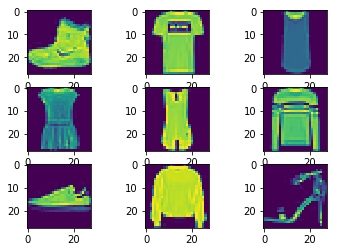

In [3]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
image_size = x_train.shape[1]

for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    imshow(x_train[i])
    imgplot = pyplot.imshow(x_train[i])

In [4]:
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
print y_train.shape
print y_test.shape

(60000,)
(10000,)


Normalize inputs to change their range from [0, 255] to [0, 1].

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

Convert the input matrix from grayscale (image_size, image_size) to single channel (image_size, image_size, 1)

In [7]:
x_train_ = np.reshape(x_train, (len(x_train), image_size, image_size, 1))
print "Reshaped train to", x_train_.shape

x_test_ = np.reshape(x_test, (len(x_test), image_size, image_size, 1))
print "Reshaped test to", x_test_.shape

Reshaped train to (60000, 28, 28, 1)
Reshaped test to (10000, 28, 28, 1)


In [8]:
input_shape = x_train_.shape[1:]
print input_shape

(28, 28, 1)


## Implementing a discriminator based on a DCNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose
from keras.optimizers import SGD, rmsprop, Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [10]:
discriminator = Sequential()
# stage 1
print "Creating net with input", x_train.shape[1:]
discriminator.add(Conv2D(32, (3, 3), input_shape=x_train_.shape[1:], activation='relu', padding='same'))
discriminator.add(Dropout(0.6))
# stage 2
discriminator.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.4))
# stage 3
discriminator.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.25))
# stage 4
discriminator.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Dropout(0.25))
# stage 5
discriminator.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2, 2)))
discriminator.add(Flatten())
discriminator.add(Dropout(0.25))
# stage 6
discriminator.add(Dense(1024, activation='relu'))
discriminator.add(Dropout(0.25))
# stage 7
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
# stage 8
# instead of the softmax we would use for classification we use sigmoid
#discriminator.add(Dense(num_classes, activation='softmax'))
discriminator.add(Dense(1, activation='sigmoid'))

Creating net with input (28, 28)


In [11]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [12]:
#optimizer = rmsprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss="binary_crossentropy",
                      optimizer=optimizer,
                      # optimizer = "adam",
                      metrics=["accuracy"])

## Implementing the Generator

In [13]:
generator = Sequential()
input_noise_size = 100
initial_generator_depth = 256
dim = 7
# dim is 7 as we double it progressively to 14 and then 28 over the stages
# as in https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

# stage 1 -> (dim, dim, depth)
generator.add(Dense(dim*dim*initial_generator_depth, 
                    input_dim=input_noise_size))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))
# https://github.com/keras-team/keras/issues/4534
generator.add(Reshape( (dim, dim, initial_generator_depth) ))
generator.add(Dropout(0.4))

# stage 2 -> (2dim, 2dim, depth/2)
# de-convolution: conv2dtranspose
# https://keras.io/layers/convolutional/#conv2dtranspose
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/2, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 3 -> (4dim, 4dim, depth/4)
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(initial_generator_depth/4, 
                              5, # kernel_size
                              padding="same"))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation("relu"))

# stage 4 ->
generator.add(Conv2DTranspose(1, 
                              5, # kernel_size
                              padding="same"))
generator.add(Activation("sigmoid"))

In [14]:
print generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
__________

## Implementing the GAN

In [15]:
#optimizer = rmsprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
optimizer = Adam(lr=0.0002, beta_1=0.5)

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

## Training the discriminator

### Creating fake dataset instances

In [16]:
# generate random noise (of equal size compared to real data) and use the generator to create fake images
noise_train = np.random.uniform(-1.0, 1.0, size=[x_train_.shape[0], 100])
noise_test = np.random.uniform(-1.0, 1.0, size=[x_test_.shape[0], 100])

print "noise train", noise_train.shape
print "noise test", noise_test.shape

train_images_fake = generator.predict(noise_train)
test_images_fake = generator.predict(noise_test)

print "fake train images", train_images_fake.shape
print "fake test images", test_images_fake.shape

noise train (60000, 100)
noise test (10000, 100)
fake train images (60000, 28, 28, 1)
fake test images (10000, 28, 28, 1)


In [17]:
x_test_.shape[0]

10000

In [18]:
d_train_x = np.concatenate( (x_train_, train_images_fake) )
print d_train_x.shape

d_test_x = np.concatenate( (x_test_, test_images_fake) )
print d_test_x.shape

(120000, 28, 28, 1)
(20000, 28, 28, 1)


In [19]:
# create a 2*train array initially set to 1
d_train_y = np.ones([2*x_train_.shape[0], 1])
# set the second half (fake images) to 0
d_train_y[x_train_.shape[0]:, :] = 0

In [20]:
# create a 2*test array initially set to 1
d_test_y = np.ones([2*x_test_.shape[0], 1])
# set the second half (fake images) to 0
d_test_y[x_test_.shape[0]:, :] = 0

### Train the Discriminator

In [21]:
from keras.preprocessing.image import ImageDataGenerator

def get_img_generator():
    return ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

In [22]:
seed = 1234

In [23]:
np.random.seed(seed)

epochs = 2
batch_size= 64

datagen = get_img_generator()
discriminator.fit_generator(datagen.flow(d_train_x, d_train_y, batch_size=batch_size),
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(d_test_x, d_test_y),
                    workers=6)

Epoch 1/2
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0216 - acc: 0.9907 - val_loss: 0.0036 - val_acc: 0.9990
Epoch 2/2
1875/1875 [==============================] - 49s 26ms/step - loss: 5.7037e-04 - acc: 0.9999 - val_loss: 4.6086e-04 - val_acc: 1.0000


### Assess the discriminator performance using the test data

In [24]:
scores = discriminator.evaluate(d_test_x, d_test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%


## Training the Generator

### Create a test dataset for the GA

In [25]:
np.random.seed(seed)
# get an array of random samples to be used to test the GAN at the end of the training
test_size = 16
test_noise = np.random.uniform(-1.0, 1.0, size=[test_size, 100])

### Train the GA using random input noise

  0%|          | 1/10000 [00:00<29:46,  5.60it/s]

0: [Discriminator loss: 0.761143, acc: 0.474609]
0: [GA loss: 0.786259, acc: 0.382812]
1: [Discriminator loss: 0.752612, acc: 0.490234]


  0%|          | 3/10000 [00:00<30:33,  5.45it/s]

1: [GA loss: 0.756028, acc: 0.453125]
2: [Discriminator loss: 0.713011, acc: 0.542969]
2: [GA loss: 0.737479, acc: 0.476562]


  0%|          | 4/10000 [00:00<30:11,  5.52it/s]

3: [Discriminator loss: 0.723936, acc: 0.513672]
3: [GA loss: 0.769854, acc: 0.421875]
4: [Discriminator loss: 0.756525, acc: 0.507812]


  0%|          | 6/10000 [00:01<30:12,  5.51it/s]

4: [GA loss: 0.733998, acc: 0.441406]
5: [Discriminator loss: 0.722708, acc: 0.533203]
5: [GA loss: 0.779252, acc: 0.355469]


  0%|          | 7/10000 [00:01<30:04,  5.54it/s]

6: [Discriminator loss: 0.762044, acc: 0.513672]
6: [GA loss: 0.779601, acc: 0.375000]
7: [Discriminator loss: 0.750397, acc: 0.482422]


  0%|          | 9/10000 [00:01<30:45,  5.41it/s]

7: [GA loss: 0.734688, acc: 0.484375]
8: [Discriminator loss: 0.744309, acc: 0.488281]
8: [GA loss: 0.784965, acc: 0.386719]


  0%|          | 10/10000 [00:01<31:01,  5.37it/s]

9: [Discriminator loss: 0.745866, acc: 0.507812]
9: [GA loss: 0.822036, acc: 0.316406]
10: [Discriminator loss: 0.744693, acc: 0.482422]


  0%|          | 12/10000 [00:02<29:52,  5.57it/s]

10: [GA loss: 0.766811, acc: 0.414062]
11: [Discriminator loss: 0.733150, acc: 0.517578]
11: [GA loss: 0.824082, acc: 0.308594]


  0%|          | 13/10000 [00:02<30:34,  5.44it/s]

12: [Discriminator loss: 0.727001, acc: 0.503906]
12: [GA loss: 0.778167, acc: 0.394531]
13: [Discriminator loss: 0.726667, acc: 0.531250]


  0%|          | 15/10000 [00:02<30:16,  5.50it/s]

13: [GA loss: 0.742603, acc: 0.445312]
14: [Discriminator loss: 0.760458, acc: 0.509766]
14: [GA loss: 0.801713, acc: 0.343750]


  0%|          | 16/10000 [00:02<30:00,  5.54it/s]

15: [Discriminator loss: 0.734091, acc: 0.537109]
15: [GA loss: 0.823896, acc: 0.304688]
16: [Discriminator loss: 0.730308, acc: 0.523438]


  0%|          | 18/10000 [00:03<29:45,  5.59it/s]

16: [GA loss: 0.813348, acc: 0.328125]
17: [Discriminator loss: 0.726572, acc: 0.517578]
17: [GA loss: 0.769093, acc: 0.390625]


  0%|          | 19/10000 [00:03<30:16,  5.49it/s]

18: [Discriminator loss: 0.744406, acc: 0.525391]
18: [GA loss: 0.764979, acc: 0.394531]


  0%|          | 20/10000 [00:03<31:31,  5.28it/s]

19: [Discriminator loss: 0.734546, acc: 0.513672]
19: [GA loss: 0.825362, acc: 0.324219]
20: [Discriminator loss: 0.722570, acc: 0.505859]


  0%|          | 22/10000 [00:04<31:04,  5.35it/s]

20: [GA loss: 0.794995, acc: 0.375000]
21: [Discriminator loss: 0.680166, acc: 0.568359]
21: [GA loss: 0.787832, acc: 0.375000]


  0%|          | 23/10000 [00:04<31:39,  5.25it/s]

22: [Discriminator loss: 0.707625, acc: 0.568359]
22: [GA loss: 0.803758, acc: 0.339844]
23: [Discriminator loss: 0.710840, acc: 0.562500]


  0%|          | 25/10000 [00:04<32:33,  5.11it/s]

23: [GA loss: 0.788850, acc: 0.363281]
24: [Discriminator loss: 0.698089, acc: 0.562500]
24: [GA loss: 0.808089, acc: 0.328125]


  0%|          | 26/10000 [00:04<31:30,  5.28it/s]

25: [Discriminator loss: 0.701498, acc: 0.568359]
25: [GA loss: 0.808963, acc: 0.339844]
26: [Discriminator loss: 0.705900, acc: 0.554688]


  0%|          | 28/10000 [00:05<31:12,  5.32it/s]

26: [GA loss: 0.788013, acc: 0.351562]
27: [Discriminator loss: 0.707312, acc: 0.578125]
27: [GA loss: 0.817580, acc: 0.328125]


  0%|          | 29/10000 [00:05<30:56,  5.37it/s]

28: [Discriminator loss: 0.717044, acc: 0.527344]
28: [GA loss: 0.817411, acc: 0.339844]
29: [Discriminator loss: 0.694551, acc: 0.554688]


  0%|          | 30/10000 [00:05<30:56,  5.37it/s]

29: [GA loss: 0.818136, acc: 0.332031]
30: [Discriminator loss: 0.696900, acc: 0.542969]


  0%|          | 32/10000 [00:05<30:46,  5.40it/s]

30: [GA loss: 0.811122, acc: 0.316406]
31: [Discriminator loss: 0.699791, acc: 0.564453]
31: [GA loss: 0.799144, acc: 0.343750]


  0%|          | 33/10000 [00:06<30:31,  5.44it/s]

32: [Discriminator loss: 0.708281, acc: 0.558594]
32: [GA loss: 0.810114, acc: 0.367188]
33: [Discriminator loss: 0.714598, acc: 0.544922]


  0%|          | 35/10000 [00:06<31:43,  5.23it/s]

33: [GA loss: 0.793669, acc: 0.371094]
34: [Discriminator loss: 0.742731, acc: 0.546875]
34: [GA loss: 0.811776, acc: 0.378906]


  0%|          | 36/10000 [00:06<31:59,  5.19it/s]

35: [Discriminator loss: 0.734185, acc: 0.517578]
35: [GA loss: 0.798653, acc: 0.363281]
36: [Discriminator loss: 0.720118, acc: 0.542969]


  0%|          | 38/10000 [00:07<32:51,  5.05it/s]

36: [GA loss: 0.779824, acc: 0.375000]
37: [Discriminator loss: 0.751737, acc: 0.515625]
37: [GA loss: 0.765512, acc: 0.433594]


  0%|          | 39/10000 [00:07<32:19,  5.14it/s]

38: [Discriminator loss: 0.739873, acc: 0.525391]
38: [GA loss: 0.787596, acc: 0.417969]
39: [Discriminator loss: 0.725821, acc: 0.505859]


  0%|          | 41/10000 [00:07<31:19,  5.30it/s]

39: [GA loss: 0.747472, acc: 0.457031]
40: [Discriminator loss: 0.769517, acc: 0.501953]
40: [GA loss: 0.759465, acc: 0.433594]


  0%|          | 42/10000 [00:07<31:21,  5.29it/s]

41: [Discriminator loss: 0.749209, acc: 0.521484]
41: [GA loss: 0.762926, acc: 0.378906]
42: [Discriminator loss: 0.735198, acc: 0.525391]


  0%|          | 44/10000 [00:08<31:13,  5.31it/s]

42: [GA loss: 0.734996, acc: 0.464844]
43: [Discriminator loss: 0.764767, acc: 0.498047]
43: [GA loss: 0.769237, acc: 0.394531]


  0%|          | 45/10000 [00:08<30:35,  5.42it/s]

44: [Discriminator loss: 0.754586, acc: 0.488281]
44: [GA loss: 0.797760, acc: 0.367188]
45: [Discriminator loss: 0.717720, acc: 0.527344]


  0%|          | 47/10000 [00:08<30:37,  5.42it/s]

45: [GA loss: 0.820558, acc: 0.332031]
46: [Discriminator loss: 0.693685, acc: 0.562500]
46: [GA loss: 0.773379, acc: 0.382812]


  0%|          | 48/10000 [00:08<30:00,  5.53it/s]

47: [Discriminator loss: 0.709651, acc: 0.546875]
47: [GA loss: 0.760906, acc: 0.406250]
48: [Discriminator loss: 0.733498, acc: 0.529297]


  0%|          | 50/10000 [00:09<30:00,  5.53it/s]

48: [GA loss: 0.798422, acc: 0.363281]
49: [Discriminator loss: 0.705428, acc: 0.537109]
49: [GA loss: 0.836007, acc: 0.320312]


  1%|          | 51/10000 [00:09<30:16,  5.48it/s]

50: [Discriminator loss: 0.709804, acc: 0.550781]
50: [GA loss: 0.820024, acc: 0.308594]
51: [Discriminator loss: 0.728429, acc: 0.529297]


  1%|          | 53/10000 [00:09<29:35,  5.60it/s]

51: [GA loss: 0.822961, acc: 0.324219]
52: [Discriminator loss: 0.692450, acc: 0.564453]
52: [GA loss: 0.842857, acc: 0.316406]


  1%|          | 54/10000 [00:10<30:03,  5.51it/s]

53: [Discriminator loss: 0.677528, acc: 0.578125]
53: [GA loss: 0.799108, acc: 0.355469]


  1%|          | 55/10000 [00:10<31:01,  5.34it/s]

54: [Discriminator loss: 0.724941, acc: 0.511719]
54: [GA loss: 0.809554, acc: 0.347656]
55: [Discriminator loss: 0.694793, acc: 0.582031]


  1%|          | 57/10000 [00:10<30:06,  5.50it/s]

55: [GA loss: 0.796912, acc: 0.375000]
56: [Discriminator loss: 0.692169, acc: 0.576172]
56: [GA loss: 0.789913, acc: 0.382812]


  1%|          | 58/10000 [00:10<29:48,  5.56it/s]

57: [Discriminator loss: 0.708345, acc: 0.572266]
57: [GA loss: 0.806840, acc: 0.347656]
58: [Discriminator loss: 0.699025, acc: 0.589844]


  1%|          | 60/10000 [00:11<29:40,  5.58it/s]

58: [GA loss: 0.778947, acc: 0.390625]
59: [Discriminator loss: 0.715925, acc: 0.541016]
59: [GA loss: 0.844143, acc: 0.289062]


  1%|          | 61/10000 [00:11<29:45,  5.57it/s]

60: [Discriminator loss: 0.709368, acc: 0.552734]
60: [GA loss: 0.819472, acc: 0.332031]
61: [Discriminator loss: 0.725178, acc: 0.546875]


  1%|          | 63/10000 [00:11<29:47,  5.56it/s]

61: [GA loss: 0.824105, acc: 0.324219]
62: [Discriminator loss: 0.705429, acc: 0.583984]
62: [GA loss: 0.816302, acc: 0.343750]


  1%|          | 64/10000 [00:11<31:37,  5.24it/s]

63: [Discriminator loss: 0.690483, acc: 0.574219]
63: [GA loss: 0.825488, acc: 0.378906]
64: [Discriminator loss: 0.725754, acc: 0.548828]


  1%|          | 66/10000 [00:12<30:15,  5.47it/s]

64: [GA loss: 0.784662, acc: 0.398438]
65: [Discriminator loss: 0.741492, acc: 0.513672]
65: [GA loss: 0.805952, acc: 0.394531]


  1%|          | 67/10000 [00:12<31:01,  5.34it/s]

66: [Discriminator loss: 0.728208, acc: 0.546875]
66: [GA loss: 0.841153, acc: 0.285156]
67: [Discriminator loss: 0.732445, acc: 0.568359]


  1%|          | 69/10000 [00:12<30:18,  5.46it/s]

67: [GA loss: 0.819402, acc: 0.359375]
68: [Discriminator loss: 0.717770, acc: 0.537109]
68: [GA loss: 0.822548, acc: 0.347656]


  1%|          | 70/10000 [00:12<30:37,  5.40it/s]

69: [Discriminator loss: 0.723214, acc: 0.570312]
69: [GA loss: 0.787800, acc: 0.382812]
70: [Discriminator loss: 0.728176, acc: 0.539062]


  1%|          | 72/10000 [00:13<30:22,  5.45it/s]

70: [GA loss: 0.832019, acc: 0.335938]
71: [Discriminator loss: 0.739515, acc: 0.541016]
71: [GA loss: 0.853589, acc: 0.281250]


  1%|          | 73/10000 [00:13<31:27,  5.26it/s]

72: [Discriminator loss: 0.721948, acc: 0.552734]
72: [GA loss: 0.822026, acc: 0.363281]
73: [Discriminator loss: 0.696665, acc: 0.576172]


  1%|          | 75/10000 [00:13<31:02,  5.33it/s]

73: [GA loss: 0.824487, acc: 0.312500]
74: [Discriminator loss: 0.720543, acc: 0.546875]
74: [GA loss: 0.793188, acc: 0.367188]


  1%|          | 76/10000 [00:14<30:56,  5.35it/s]

75: [Discriminator loss: 0.717033, acc: 0.548828]
75: [GA loss: 0.812775, acc: 0.343750]
76: [Discriminator loss: 0.712651, acc: 0.541016]


  1%|          | 78/10000 [00:14<30:08,  5.49it/s]

76: [GA loss: 0.810795, acc: 0.406250]
77: [Discriminator loss: 0.738325, acc: 0.533203]
77: [GA loss: 0.812492, acc: 0.347656]


  1%|          | 79/10000 [00:14<31:04,  5.32it/s]

78: [Discriminator loss: 0.731842, acc: 0.546875]
78: [GA loss: 0.809352, acc: 0.347656]
79: [Discriminator loss: 0.752336, acc: 0.509766]


  1%|          | 81/10000 [00:15<30:20,  5.45it/s]

79: [GA loss: 0.855402, acc: 0.304688]
80: [Discriminator loss: 0.747502, acc: 0.496094]
80: [GA loss: 0.825834, acc: 0.312500]


  1%|          | 82/10000 [00:15<29:51,  5.54it/s]

81: [Discriminator loss: 0.726838, acc: 0.539062]
81: [GA loss: 0.876333, acc: 0.285156]
82: [Discriminator loss: 0.755950, acc: 0.531250]


  1%|          | 84/10000 [00:15<30:32,  5.41it/s]

82: [GA loss: 0.861732, acc: 0.292969]
83: [Discriminator loss: 0.738335, acc: 0.513672]
83: [GA loss: 0.846920, acc: 0.332031]


  1%|          | 85/10000 [00:15<29:44,  5.56it/s]

84: [Discriminator loss: 0.743415, acc: 0.492188]
84: [GA loss: 0.858852, acc: 0.277344]
85: [Discriminator loss: 0.729177, acc: 0.531250]


  1%|          | 87/10000 [00:16<30:27,  5.42it/s]

85: [GA loss: 0.827777, acc: 0.324219]
86: [Discriminator loss: 0.752553, acc: 0.541016]
86: [GA loss: 0.861293, acc: 0.273438]


  1%|          | 88/10000 [00:16<30:57,  5.34it/s]

87: [Discriminator loss: 0.733764, acc: 0.519531]
87: [GA loss: 0.832742, acc: 0.281250]
88: [Discriminator loss: 0.733342, acc: 0.554688]


  1%|          | 90/10000 [00:16<30:20,  5.44it/s]

88: [GA loss: 0.846122, acc: 0.304688]
89: [Discriminator loss: 0.735365, acc: 0.517578]
89: [GA loss: 0.844099, acc: 0.289062]


  1%|          | 91/10000 [00:16<29:58,  5.51it/s]

90: [Discriminator loss: 0.710854, acc: 0.554688]
90: [GA loss: 0.819550, acc: 0.316406]
91: [Discriminator loss: 0.732768, acc: 0.521484]


  1%|          | 93/10000 [00:17<29:39,  5.57it/s]

91: [GA loss: 0.789243, acc: 0.406250]
92: [Discriminator loss: 0.717013, acc: 0.541016]
92: [GA loss: 0.811454, acc: 0.328125]


  1%|          | 94/10000 [00:17<30:45,  5.37it/s]

93: [Discriminator loss: 0.727955, acc: 0.552734]
93: [GA loss: 0.814975, acc: 0.320312]
94: [Discriminator loss: 0.731178, acc: 0.556641]


  1%|          | 96/10000 [00:17<30:26,  5.42it/s]

94: [GA loss: 0.855982, acc: 0.289062]
95: [Discriminator loss: 0.701856, acc: 0.562500]
95: [GA loss: 0.860439, acc: 0.273438]


  1%|          | 97/10000 [00:17<29:58,  5.51it/s]

96: [Discriminator loss: 0.705081, acc: 0.550781]
96: [GA loss: 0.868737, acc: 0.261719]
97: [Discriminator loss: 0.676035, acc: 0.580078]


  1%|          | 99/10000 [00:18<30:16,  5.45it/s]

97: [GA loss: 0.832136, acc: 0.300781]
98: [Discriminator loss: 0.698899, acc: 0.548828]
98: [GA loss: 0.818120, acc: 0.324219]
99: [Discriminator loss: 0.687499, acc: 0.572266]
99: [GA loss: 0.807265, acc: 0.371094]


  1%|          | 101/10000 [00:19<57:15,  2.88it/s]  

100: [Discriminator loss: 0.695228, acc: 0.558594]
100: [GA loss: 0.846640, acc: 0.308594]
101: [Discriminator loss: 0.690234, acc: 0.564453]


  1%|          | 103/10000 [00:19<43:16,  3.81it/s]

101: [GA loss: 0.837587, acc: 0.292969]
102: [Discriminator loss: 0.697102, acc: 0.560547]
102: [GA loss: 0.852317, acc: 0.289062]


  1%|          | 104/10000 [00:20<39:20,  4.19it/s]

103: [Discriminator loss: 0.692092, acc: 0.572266]
103: [GA loss: 0.867623, acc: 0.226562]
104: [Discriminator loss: 0.675349, acc: 0.572266]


  1%|          | 106/10000 [00:20<35:48,  4.60it/s]

104: [GA loss: 0.807713, acc: 0.355469]
105: [Discriminator loss: 0.687598, acc: 0.576172]
105: [GA loss: 0.828309, acc: 0.324219]


  1%|          | 107/10000 [00:20<33:51,  4.87it/s]

106: [Discriminator loss: 0.700533, acc: 0.578125]
106: [GA loss: 0.863043, acc: 0.296875]
107: [Discriminator loss: 0.696536, acc: 0.582031]


  1%|          | 109/10000 [00:20<30:44,  5.36it/s]

107: [GA loss: 0.870701, acc: 0.242188]
108: [Discriminator loss: 0.699922, acc: 0.541016]
108: [GA loss: 0.815563, acc: 0.363281]


  1%|          | 110/10000 [00:21<30:28,  5.41it/s]

109: [Discriminator loss: 0.732649, acc: 0.521484]
109: [GA loss: 0.823120, acc: 0.347656]
110: [Discriminator loss: 0.743648, acc: 0.544922]


  1%|          | 112/10000 [00:21<30:02,  5.48it/s]

110: [GA loss: 0.755896, acc: 0.410156]
111: [Discriminator loss: 0.714888, acc: 0.539062]
111: [GA loss: 0.761102, acc: 0.402344]


  1%|          | 113/10000 [00:21<29:43,  5.54it/s]

112: [Discriminator loss: 0.747627, acc: 0.513672]
112: [GA loss: 0.804303, acc: 0.332031]
113: [Discriminator loss: 0.762396, acc: 0.529297]


  1%|          | 115/10000 [00:22<29:24,  5.60it/s]

113: [GA loss: 0.790857, acc: 0.375000]
114: [Discriminator loss: 0.741747, acc: 0.513672]
114: [GA loss: 0.816085, acc: 0.308594]


  1%|          | 116/10000 [00:22<29:40,  5.55it/s]

115: [Discriminator loss: 0.744395, acc: 0.507812]
115: [GA loss: 0.787747, acc: 0.355469]
116: [Discriminator loss: 0.749365, acc: 0.492188]


  1%|          | 118/10000 [00:22<30:00,  5.49it/s]

116: [GA loss: 0.783908, acc: 0.375000]
117: [Discriminator loss: 0.757019, acc: 0.500000]
117: [GA loss: 0.780194, acc: 0.402344]


  1%|          | 119/10000 [00:22<29:59,  5.49it/s]

118: [Discriminator loss: 0.740057, acc: 0.511719]
118: [GA loss: 0.758013, acc: 0.398438]
119: [Discriminator loss: 0.730797, acc: 0.529297]


  1%|          | 121/10000 [00:23<30:10,  5.46it/s]

119: [GA loss: 0.771863, acc: 0.390625]
120: [Discriminator loss: 0.731975, acc: 0.537109]
120: [GA loss: 0.712551, acc: 0.515625]


  1%|          | 122/10000 [00:23<30:55,  5.32it/s]

121: [Discriminator loss: 0.760047, acc: 0.527344]
121: [GA loss: 0.753993, acc: 0.425781]
122: [Discriminator loss: 0.723916, acc: 0.529297]


  1%|          | 123/10000 [00:23<30:25,  5.41it/s]

122: [GA loss: 0.788344, acc: 0.375000]
123: [Discriminator loss: 0.727580, acc: 0.511719]


  1%|▏         | 125/10000 [00:23<30:11,  5.45it/s]

123: [GA loss: 0.810662, acc: 0.390625]
124: [Discriminator loss: 0.711832, acc: 0.560547]
124: [GA loss: 0.762877, acc: 0.421875]


  1%|▏         | 126/10000 [00:24<30:08,  5.46it/s]

125: [Discriminator loss: 0.715859, acc: 0.531250]
125: [GA loss: 0.781325, acc: 0.367188]
126: [Discriminator loss: 0.729326, acc: 0.544922]


  1%|▏         | 128/10000 [00:24<31:24,  5.24it/s]

126: [GA loss: 0.819609, acc: 0.269531]
127: [Discriminator loss: 0.751895, acc: 0.509766]
127: [GA loss: 0.814191, acc: 0.339844]


  1%|▏         | 129/10000 [00:24<31:22,  5.24it/s]

128: [Discriminator loss: 0.722163, acc: 0.537109]
128: [GA loss: 0.855465, acc: 0.308594]
129: [Discriminator loss: 0.738095, acc: 0.519531]


  1%|▏         | 131/10000 [00:24<31:01,  5.30it/s]

129: [GA loss: 0.801426, acc: 0.367188]
130: [Discriminator loss: 0.715050, acc: 0.531250]
130: [GA loss: 0.796696, acc: 0.359375]


  1%|▏         | 132/10000 [00:25<31:54,  5.15it/s]

131: [Discriminator loss: 0.735044, acc: 0.529297]
131: [GA loss: 0.802042, acc: 0.367188]
132: [Discriminator loss: 0.740286, acc: 0.548828]


  1%|▏         | 134/10000 [00:25<30:45,  5.35it/s]

132: [GA loss: 0.820163, acc: 0.332031]
133: [Discriminator loss: 0.716255, acc: 0.566406]
133: [GA loss: 0.827218, acc: 0.335938]


  1%|▏         | 135/10000 [00:25<30:13,  5.44it/s]

134: [Discriminator loss: 0.742176, acc: 0.539062]
134: [GA loss: 0.844576, acc: 0.269531]
135: [Discriminator loss: 0.716992, acc: 0.560547]


  1%|▏         | 137/10000 [00:26<29:54,  5.49it/s]

135: [GA loss: 0.851962, acc: 0.269531]
136: [Discriminator loss: 0.724052, acc: 0.562500]
136: [GA loss: 0.878889, acc: 0.230469]


  1%|▏         | 138/10000 [00:26<29:55,  5.49it/s]

137: [Discriminator loss: 0.723132, acc: 0.539062]
137: [GA loss: 0.856428, acc: 0.285156]
138: [Discriminator loss: 0.694496, acc: 0.566406]


  1%|▏         | 140/10000 [00:26<29:31,  5.56it/s]

138: [GA loss: 0.808485, acc: 0.339844]
139: [Discriminator loss: 0.747773, acc: 0.539062]
139: [GA loss: 0.816907, acc: 0.312500]


  1%|▏         | 141/10000 [00:26<29:28,  5.57it/s]

140: [Discriminator loss: 0.720326, acc: 0.539062]
140: [GA loss: 0.859387, acc: 0.300781]
141: [Discriminator loss: 0.692423, acc: 0.576172]


  1%|▏         | 143/10000 [00:27<29:26,  5.58it/s]

141: [GA loss: 0.866034, acc: 0.246094]
142: [Discriminator loss: 0.721516, acc: 0.533203]
142: [GA loss: 0.859969, acc: 0.253906]


  1%|▏         | 144/10000 [00:27<29:38,  5.54it/s]

143: [Discriminator loss: 0.725288, acc: 0.525391]
143: [GA loss: 0.868319, acc: 0.292969]
144: [Discriminator loss: 0.729621, acc: 0.527344]


  1%|▏         | 146/10000 [00:27<29:16,  5.61it/s]

144: [GA loss: 0.866441, acc: 0.281250]
145: [Discriminator loss: 0.728712, acc: 0.513672]
145: [GA loss: 0.863895, acc: 0.246094]


  1%|▏         | 147/10000 [00:27<29:07,  5.64it/s]

146: [Discriminator loss: 0.708894, acc: 0.546875]
146: [GA loss: 0.883560, acc: 0.253906]
147: [Discriminator loss: 0.696742, acc: 0.578125]


  1%|▏         | 149/10000 [00:28<29:20,  5.60it/s]

147: [GA loss: 0.904163, acc: 0.230469]
148: [Discriminator loss: 0.695498, acc: 0.560547]
148: [GA loss: 0.859044, acc: 0.289062]


  2%|▏         | 150/10000 [00:28<30:11,  5.44it/s]

149: [Discriminator loss: 0.711331, acc: 0.537109]
149: [GA loss: 0.825286, acc: 0.339844]
150: [Discriminator loss: 0.730814, acc: 0.558594]


  2%|▏         | 152/10000 [00:28<29:37,  5.54it/s]

150: [GA loss: 0.879009, acc: 0.242188]
151: [Discriminator loss: 0.732224, acc: 0.529297]
151: [GA loss: 0.899285, acc: 0.199219]


  2%|▏         | 153/10000 [00:28<30:22,  5.40it/s]

152: [Discriminator loss: 0.706212, acc: 0.535156]
152: [GA loss: 0.844886, acc: 0.273438]
153: [Discriminator loss: 0.701386, acc: 0.537109]


  2%|▏         | 155/10000 [00:29<30:02,  5.46it/s]

153: [GA loss: 0.792748, acc: 0.359375]
154: [Discriminator loss: 0.748387, acc: 0.509766]
154: [GA loss: 0.809280, acc: 0.378906]


  2%|▏         | 156/10000 [00:29<29:45,  5.51it/s]

155: [Discriminator loss: 0.744808, acc: 0.523438]
155: [GA loss: 0.848343, acc: 0.289062]
156: [Discriminator loss: 0.725757, acc: 0.531250]


  2%|▏         | 158/10000 [00:29<29:48,  5.50it/s]

156: [GA loss: 0.872599, acc: 0.234375]
157: [Discriminator loss: 0.734421, acc: 0.515625]
157: [GA loss: 0.870258, acc: 0.273438]


  2%|▏         | 159/10000 [00:30<29:23,  5.58it/s]

158: [Discriminator loss: 0.715020, acc: 0.517578]
158: [GA loss: 0.818169, acc: 0.332031]
159: [Discriminator loss: 0.736583, acc: 0.541016]


  2%|▏         | 161/10000 [00:30<28:55,  5.67it/s]

159: [GA loss: 0.819152, acc: 0.324219]
160: [Discriminator loss: 0.748929, acc: 0.486328]
160: [GA loss: 0.772407, acc: 0.378906]


  2%|▏         | 162/10000 [00:30<29:25,  5.57it/s]

161: [Discriminator loss: 0.745008, acc: 0.513672]
161: [GA loss: 0.787733, acc: 0.371094]
162: [Discriminator loss: 0.726937, acc: 0.500000]


  2%|▏         | 164/10000 [00:30<29:53,  5.48it/s]

162: [GA loss: 0.765752, acc: 0.429688]
163: [Discriminator loss: 0.701423, acc: 0.531250]
163: [GA loss: 0.748181, acc: 0.433594]


  2%|▏         | 165/10000 [00:31<29:32,  5.55it/s]

164: [Discriminator loss: 0.779683, acc: 0.498047]
164: [GA loss: 0.812528, acc: 0.320312]
165: [Discriminator loss: 0.750647, acc: 0.482422]


  2%|▏         | 167/10000 [00:31<30:15,  5.42it/s]

165: [GA loss: 0.801484, acc: 0.382812]
166: [Discriminator loss: 0.752243, acc: 0.507812]
166: [GA loss: 0.829807, acc: 0.320312]


  2%|▏         | 168/10000 [00:31<30:27,  5.38it/s]

167: [Discriminator loss: 0.729211, acc: 0.515625]
167: [GA loss: 0.748392, acc: 0.429688]
168: [Discriminator loss: 0.740668, acc: 0.492188]


  2%|▏         | 170/10000 [00:32<30:17,  5.41it/s]

168: [GA loss: 0.782681, acc: 0.375000]
169: [Discriminator loss: 0.752412, acc: 0.523438]
169: [GA loss: 0.768727, acc: 0.382812]


  2%|▏         | 171/10000 [00:32<30:09,  5.43it/s]

170: [Discriminator loss: 0.731852, acc: 0.490234]
170: [GA loss: 0.779861, acc: 0.402344]
171: [Discriminator loss: 0.750974, acc: 0.488281]


  2%|▏         | 173/10000 [00:32<29:49,  5.49it/s]

171: [GA loss: 0.758979, acc: 0.425781]
172: [Discriminator loss: 0.718349, acc: 0.531250]
172: [GA loss: 0.746037, acc: 0.464844]


  2%|▏         | 174/10000 [00:32<29:44,  5.51it/s]

173: [Discriminator loss: 0.742073, acc: 0.484375]
173: [GA loss: 0.749285, acc: 0.453125]
174: [Discriminator loss: 0.747135, acc: 0.525391]


  2%|▏         | 176/10000 [00:33<30:07,  5.44it/s]

174: [GA loss: 0.723664, acc: 0.507812]
175: [Discriminator loss: 0.743870, acc: 0.531250]
175: [GA loss: 0.790455, acc: 0.375000]


  2%|▏         | 177/10000 [00:33<30:49,  5.31it/s]

176: [Discriminator loss: 0.732493, acc: 0.537109]
176: [GA loss: 0.755722, acc: 0.410156]
177: [Discriminator loss: 0.746385, acc: 0.505859]


  2%|▏         | 179/10000 [00:33<29:24,  5.57it/s]

177: [GA loss: 0.789929, acc: 0.335938]
178: [Discriminator loss: 0.718284, acc: 0.533203]
178: [GA loss: 0.783615, acc: 0.371094]


  2%|▏         | 180/10000 [00:33<29:19,  5.58it/s]

179: [Discriminator loss: 0.706351, acc: 0.544922]
179: [GA loss: 0.761402, acc: 0.421875]
180: [Discriminator loss: 0.705936, acc: 0.548828]


  2%|▏         | 182/10000 [00:34<29:11,  5.61it/s]

180: [GA loss: 0.762181, acc: 0.406250]
181: [Discriminator loss: 0.721703, acc: 0.533203]
181: [GA loss: 0.770528, acc: 0.425781]


  2%|▏         | 183/10000 [00:34<29:20,  5.57it/s]

182: [Discriminator loss: 0.715982, acc: 0.548828]
182: [GA loss: 0.784511, acc: 0.382812]
183: [Discriminator loss: 0.725129, acc: 0.537109]


  2%|▏         | 185/10000 [00:34<29:15,  5.59it/s]

183: [GA loss: 0.774708, acc: 0.363281]
184: [Discriminator loss: 0.722480, acc: 0.529297]
184: [GA loss: 0.789849, acc: 0.343750]


  2%|▏         | 186/10000 [00:34<29:17,  5.59it/s]

185: [Discriminator loss: 0.737894, acc: 0.498047]
185: [GA loss: 0.799482, acc: 0.351562]
186: [Discriminator loss: 0.733869, acc: 0.531250]


  2%|▏         | 188/10000 [00:35<29:52,  5.47it/s]

186: [GA loss: 0.798264, acc: 0.378906]
187: [Discriminator loss: 0.730212, acc: 0.527344]
187: [GA loss: 0.803468, acc: 0.347656]


  2%|▏         | 189/10000 [00:35<29:42,  5.51it/s]

188: [Discriminator loss: 0.697396, acc: 0.539062]
188: [GA loss: 0.759134, acc: 0.402344]
189: [Discriminator loss: 0.743955, acc: 0.519531]


  2%|▏         | 191/10000 [00:35<29:27,  5.55it/s]

189: [GA loss: 0.790506, acc: 0.375000]
190: [Discriminator loss: 0.754476, acc: 0.505859]
190: [GA loss: 0.752893, acc: 0.410156]


  2%|▏         | 192/10000 [00:36<30:01,  5.44it/s]

191: [Discriminator loss: 0.719519, acc: 0.521484]
191: [GA loss: 0.766263, acc: 0.386719]
192: [Discriminator loss: 0.720166, acc: 0.525391]


  2%|▏         | 194/10000 [00:36<29:08,  5.61it/s]

192: [GA loss: 0.762807, acc: 0.441406]
193: [Discriminator loss: 0.734674, acc: 0.533203]
193: [GA loss: 0.735050, acc: 0.449219]


  2%|▏         | 195/10000 [00:36<30:16,  5.40it/s]

194: [Discriminator loss: 0.766376, acc: 0.507812]
194: [GA loss: 0.746546, acc: 0.445312]
195: [Discriminator loss: 0.743665, acc: 0.511719]


  2%|▏         | 197/10000 [00:36<29:53,  5.46it/s]

195: [GA loss: 0.736632, acc: 0.480469]
196: [Discriminator loss: 0.755908, acc: 0.498047]
196: [GA loss: 0.734477, acc: 0.457031]


  2%|▏         | 198/10000 [00:37<29:32,  5.53it/s]

197: [Discriminator loss: 0.729465, acc: 0.521484]
197: [GA loss: 0.737701, acc: 0.453125]
198: [Discriminator loss: 0.738527, acc: 0.507812]


  2%|▏         | 199/10000 [00:37<29:42,  5.50it/s]

198: [GA loss: 0.740748, acc: 0.453125]
199: [Discriminator loss: 0.747673, acc: 0.490234]
199: [GA loss: 0.736800, acc: 0.453125]


  2%|▏         | 201/10000 [00:38<56:09,  2.91it/s]  

200: [Discriminator loss: 0.715849, acc: 0.523438]
200: [GA loss: 0.759274, acc: 0.414062]
201: [Discriminator loss: 0.708055, acc: 0.548828]


  2%|▏         | 203/10000 [00:38<42:08,  3.87it/s]

201: [GA loss: 0.699675, acc: 0.496094]
202: [Discriminator loss: 0.737812, acc: 0.537109]
202: [GA loss: 0.708184, acc: 0.500000]


  2%|▏         | 204/10000 [00:39<38:46,  4.21it/s]

203: [Discriminator loss: 0.735475, acc: 0.492188]
203: [GA loss: 0.744065, acc: 0.453125]
204: [Discriminator loss: 0.717221, acc: 0.517578]


  2%|▏         | 206/10000 [00:39<34:26,  4.74it/s]

204: [GA loss: 0.773976, acc: 0.394531]
205: [Discriminator loss: 0.721182, acc: 0.525391]
205: [GA loss: 0.741616, acc: 0.472656]


  2%|▏         | 207/10000 [00:39<33:02,  4.94it/s]

206: [Discriminator loss: 0.721804, acc: 0.525391]
206: [GA loss: 0.718170, acc: 0.476562]
207: [Discriminator loss: 0.743394, acc: 0.519531]


  2%|▏         | 209/10000 [00:39<31:31,  5.18it/s]

207: [GA loss: 0.735413, acc: 0.457031]
208: [Discriminator loss: 0.736633, acc: 0.521484]
208: [GA loss: 0.729232, acc: 0.511719]


  2%|▏         | 210/10000 [00:40<31:08,  5.24it/s]

209: [Discriminator loss: 0.753375, acc: 0.498047]
209: [GA loss: 0.796554, acc: 0.339844]
210: [Discriminator loss: 0.750861, acc: 0.488281]


  2%|▏         | 212/10000 [00:40<29:55,  5.45it/s]

210: [GA loss: 0.770106, acc: 0.390625]
211: [Discriminator loss: 0.736564, acc: 0.529297]
211: [GA loss: 0.710277, acc: 0.484375]


  2%|▏         | 213/10000 [00:40<29:55,  5.45it/s]

212: [Discriminator loss: 0.724155, acc: 0.539062]
212: [GA loss: 0.727725, acc: 0.496094]
213: [Discriminator loss: 0.757842, acc: 0.480469]


  2%|▏         | 215/10000 [00:41<30:20,  5.38it/s]

213: [GA loss: 0.754582, acc: 0.445312]
214: [Discriminator loss: 0.747387, acc: 0.521484]
214: [GA loss: 0.770859, acc: 0.425781]


  2%|▏         | 216/10000 [00:41<30:11,  5.40it/s]

215: [Discriminator loss: 0.717590, acc: 0.554688]
215: [GA loss: 0.700774, acc: 0.515625]


  2%|▏         | 217/10000 [00:41<31:05,  5.24it/s]

216: [Discriminator loss: 0.749720, acc: 0.503906]
216: [GA loss: 0.762334, acc: 0.421875]
217: [Discriminator loss: 0.719400, acc: 0.546875]


  2%|▏         | 219/10000 [00:41<30:34,  5.33it/s]

217: [GA loss: 0.779749, acc: 0.347656]
218: [Discriminator loss: 0.720860, acc: 0.542969]
218: [GA loss: 0.751466, acc: 0.433594]


  2%|▏         | 220/10000 [00:41<30:03,  5.42it/s]

219: [Discriminator loss: 0.706617, acc: 0.570312]
219: [GA loss: 0.768245, acc: 0.390625]
220: [Discriminator loss: 0.721361, acc: 0.523438]


  2%|▏         | 222/10000 [00:42<29:32,  5.52it/s]

220: [GA loss: 0.786563, acc: 0.433594]
221: [Discriminator loss: 0.729005, acc: 0.542969]
221: [GA loss: 0.803668, acc: 0.375000]


  2%|▏         | 223/10000 [00:42<29:02,  5.61it/s]

222: [Discriminator loss: 0.729694, acc: 0.548828]
222: [GA loss: 0.841505, acc: 0.320312]
223: [Discriminator loss: 0.719762, acc: 0.509766]


  2%|▏         | 225/10000 [00:42<30:09,  5.40it/s]

223: [GA loss: 0.812882, acc: 0.359375]
224: [Discriminator loss: 0.706955, acc: 0.552734]
224: [GA loss: 0.831018, acc: 0.359375]


  2%|▏         | 226/10000 [00:43<30:04,  5.42it/s]

225: [Discriminator loss: 0.717336, acc: 0.546875]
225: [GA loss: 0.809353, acc: 0.339844]
226: [Discriminator loss: 0.715926, acc: 0.566406]


  2%|▏         | 228/10000 [00:43<30:10,  5.40it/s]

226: [GA loss: 0.819335, acc: 0.324219]
227: [Discriminator loss: 0.747550, acc: 0.503906]
227: [GA loss: 0.872640, acc: 0.261719]


  2%|▏         | 229/10000 [00:43<29:26,  5.53it/s]

228: [Discriminator loss: 0.699697, acc: 0.541016]
228: [GA loss: 0.848639, acc: 0.281250]
229: [Discriminator loss: 0.746690, acc: 0.533203]


  2%|▏         | 231/10000 [00:43<28:57,  5.62it/s]

229: [GA loss: 0.881565, acc: 0.257812]
230: [Discriminator loss: 0.722789, acc: 0.535156]
230: [GA loss: 0.878044, acc: 0.257812]


  2%|▏         | 232/10000 [00:44<28:49,  5.65it/s]

231: [Discriminator loss: 0.710658, acc: 0.544922]
231: [GA loss: 0.817337, acc: 0.328125]
232: [Discriminator loss: 0.736718, acc: 0.537109]


  2%|▏         | 234/10000 [00:44<29:23,  5.54it/s]

232: [GA loss: 0.841111, acc: 0.269531]
233: [Discriminator loss: 0.719956, acc: 0.544922]
233: [GA loss: 0.852988, acc: 0.289062]


  2%|▏         | 235/10000 [00:44<28:42,  5.67it/s]

234: [Discriminator loss: 0.728643, acc: 0.533203]
234: [GA loss: 0.847106, acc: 0.289062]
235: [Discriminator loss: 0.722195, acc: 0.521484]


  2%|▏         | 237/10000 [00:45<29:40,  5.48it/s]

235: [GA loss: 0.822581, acc: 0.281250]
236: [Discriminator loss: 0.733076, acc: 0.511719]
236: [GA loss: 0.831239, acc: 0.351562]


  2%|▏         | 238/10000 [00:45<29:26,  5.53it/s]

237: [Discriminator loss: 0.754465, acc: 0.490234]
237: [GA loss: 0.807882, acc: 0.355469]
238: [Discriminator loss: 0.732359, acc: 0.501953]


  2%|▏         | 240/10000 [00:45<29:21,  5.54it/s]

238: [GA loss: 0.786590, acc: 0.367188]
239: [Discriminator loss: 0.734428, acc: 0.515625]
239: [GA loss: 0.807655, acc: 0.375000]


  2%|▏         | 241/10000 [00:45<30:24,  5.35it/s]

240: [Discriminator loss: 0.732299, acc: 0.542969]
240: [GA loss: 0.760164, acc: 0.437500]
241: [Discriminator loss: 0.730322, acc: 0.507812]


  2%|▏         | 243/10000 [00:46<29:45,  5.47it/s]

241: [GA loss: 0.780577, acc: 0.398438]
242: [Discriminator loss: 0.757427, acc: 0.503906]
242: [GA loss: 0.807402, acc: 0.363281]


  2%|▏         | 244/10000 [00:46<29:35,  5.50it/s]

243: [Discriminator loss: 0.720077, acc: 0.515625]
243: [GA loss: 0.765289, acc: 0.398438]
244: [Discriminator loss: 0.773562, acc: 0.496094]


  2%|▏         | 246/10000 [00:46<29:17,  5.55it/s]

244: [GA loss: 0.782430, acc: 0.382812]
245: [Discriminator loss: 0.739117, acc: 0.500000]
245: [GA loss: 0.776613, acc: 0.367188]


  2%|▏         | 247/10000 [00:46<29:22,  5.53it/s]

246: [Discriminator loss: 0.716176, acc: 0.521484]
246: [GA loss: 0.757134, acc: 0.425781]
247: [Discriminator loss: 0.707833, acc: 0.544922]


  2%|▏         | 249/10000 [00:47<28:54,  5.62it/s]

247: [GA loss: 0.761585, acc: 0.402344]
248: [Discriminator loss: 0.734368, acc: 0.541016]
248: [GA loss: 0.751835, acc: 0.464844]


  2%|▎         | 250/10000 [00:47<29:33,  5.50it/s]

249: [Discriminator loss: 0.730994, acc: 0.496094]
249: [GA loss: 0.730220, acc: 0.472656]
250: [Discriminator loss: 0.745615, acc: 0.500000]


  3%|▎         | 252/10000 [00:47<29:29,  5.51it/s]

250: [GA loss: 0.746558, acc: 0.433594]
251: [Discriminator loss: 0.713778, acc: 0.566406]
251: [GA loss: 0.729161, acc: 0.460938]


  3%|▎         | 253/10000 [00:47<29:33,  5.50it/s]

252: [Discriminator loss: 0.736172, acc: 0.507812]
252: [GA loss: 0.767972, acc: 0.406250]
253: [Discriminator loss: 0.724151, acc: 0.519531]


  3%|▎         | 255/10000 [00:48<29:50,  5.44it/s]

253: [GA loss: 0.764568, acc: 0.406250]
254: [Discriminator loss: 0.736836, acc: 0.539062]
254: [GA loss: 0.769781, acc: 0.406250]


  3%|▎         | 256/10000 [00:48<30:32,  5.32it/s]

255: [Discriminator loss: 0.775285, acc: 0.486328]
255: [GA loss: 0.810969, acc: 0.355469]
256: [Discriminator loss: 0.766631, acc: 0.496094]


  3%|▎         | 258/10000 [00:48<29:15,  5.55it/s]

256: [GA loss: 0.776772, acc: 0.414062]
257: [Discriminator loss: 0.722410, acc: 0.537109]
257: [GA loss: 0.777385, acc: 0.386719]


  3%|▎         | 259/10000 [00:49<29:48,  5.45it/s]

258: [Discriminator loss: 0.734478, acc: 0.527344]
258: [GA loss: 0.743814, acc: 0.449219]
259: [Discriminator loss: 0.732547, acc: 0.539062]


  3%|▎         | 261/10000 [00:49<30:01,  5.41it/s]

259: [GA loss: 0.737881, acc: 0.468750]
260: [Discriminator loss: 0.719964, acc: 0.537109]
260: [GA loss: 0.717623, acc: 0.464844]


  3%|▎         | 262/10000 [00:49<29:51,  5.43it/s]

261: [Discriminator loss: 0.765867, acc: 0.501953]
261: [GA loss: 0.730002, acc: 0.468750]
262: [Discriminator loss: 0.765125, acc: 0.482422]


  3%|▎         | 264/10000 [00:49<30:04,  5.39it/s]

262: [GA loss: 0.765993, acc: 0.417969]
263: [Discriminator loss: 0.743492, acc: 0.496094]
263: [GA loss: 0.803743, acc: 0.359375]


  3%|▎         | 265/10000 [00:50<29:51,  5.43it/s]

264: [Discriminator loss: 0.722344, acc: 0.521484]
264: [GA loss: 0.752137, acc: 0.460938]
265: [Discriminator loss: 0.728368, acc: 0.531250]


  3%|▎         | 267/10000 [00:50<30:01,  5.40it/s]

265: [GA loss: 0.726891, acc: 0.480469]
266: [Discriminator loss: 0.733269, acc: 0.539062]
266: [GA loss: 0.733468, acc: 0.425781]


  3%|▎         | 268/10000 [00:50<30:28,  5.32it/s]

267: [Discriminator loss: 0.755102, acc: 0.480469]
267: [GA loss: 0.723280, acc: 0.488281]
268: [Discriminator loss: 0.751403, acc: 0.498047]


  3%|▎         | 270/10000 [00:51<31:25,  5.16it/s]

268: [GA loss: 0.732078, acc: 0.457031]
269: [Discriminator loss: 0.747831, acc: 0.492188]
269: [GA loss: 0.712053, acc: 0.500000]


  3%|▎         | 271/10000 [00:51<31:14,  5.19it/s]

270: [Discriminator loss: 0.723363, acc: 0.531250]
270: [GA loss: 0.733936, acc: 0.492188]
271: [Discriminator loss: 0.745526, acc: 0.494141]


  3%|▎         | 273/10000 [00:51<29:52,  5.43it/s]

271: [GA loss: 0.729110, acc: 0.476562]
272: [Discriminator loss: 0.731035, acc: 0.521484]
272: [GA loss: 0.683278, acc: 0.546875]


  3%|▎         | 274/10000 [00:51<30:21,  5.34it/s]

273: [Discriminator loss: 0.754235, acc: 0.486328]
273: [GA loss: 0.698578, acc: 0.511719]
274: [Discriminator loss: 0.750979, acc: 0.527344]


  3%|▎         | 276/10000 [00:52<29:42,  5.45it/s]

274: [GA loss: 0.719736, acc: 0.511719]
275: [Discriminator loss: 0.748456, acc: 0.525391]
275: [GA loss: 0.748516, acc: 0.437500]


  3%|▎         | 277/10000 [00:52<29:16,  5.54it/s]

276: [Discriminator loss: 0.748627, acc: 0.474609]
276: [GA loss: 0.749461, acc: 0.417969]
277: [Discriminator loss: 0.729652, acc: 0.515625]


  3%|▎         | 279/10000 [00:52<27:57,  5.80it/s]

277: [GA loss: 0.760411, acc: 0.425781]
278: [Discriminator loss: 0.741038, acc: 0.525391]
278: [GA loss: 0.706593, acc: 0.507812]


  3%|▎         | 280/10000 [00:52<27:43,  5.84it/s]

279: [Discriminator loss: 0.732099, acc: 0.515625]
279: [GA loss: 0.727738, acc: 0.453125]
280: [Discriminator loss: 0.730800, acc: 0.531250]


  3%|▎         | 282/10000 [00:53<28:29,  5.69it/s]

280: [GA loss: 0.734047, acc: 0.445312]
281: [Discriminator loss: 0.740104, acc: 0.498047]
281: [GA loss: 0.750964, acc: 0.453125]


  3%|▎         | 283/10000 [00:53<29:02,  5.58it/s]

282: [Discriminator loss: 0.728681, acc: 0.525391]
282: [GA loss: 0.759758, acc: 0.429688]
283: [Discriminator loss: 0.721834, acc: 0.527344]


  3%|▎         | 284/10000 [00:53<29:17,  5.53it/s]

283: [GA loss: 0.746418, acc: 0.441406]
284: [Discriminator loss: 0.684421, acc: 0.578125]


  3%|▎         | 286/10000 [00:54<29:42,  5.45it/s]

284: [GA loss: 0.747775, acc: 0.457031]
285: [Discriminator loss: 0.736978, acc: 0.517578]
285: [GA loss: 0.714740, acc: 0.515625]


  3%|▎         | 287/10000 [00:54<29:51,  5.42it/s]

286: [Discriminator loss: 0.756360, acc: 0.517578]
286: [GA loss: 0.740232, acc: 0.449219]
287: [Discriminator loss: 0.719461, acc: 0.546875]


  3%|▎         | 289/10000 [00:54<29:23,  5.51it/s]

287: [GA loss: 0.749874, acc: 0.453125]
288: [Discriminator loss: 0.718320, acc: 0.544922]
288: [GA loss: 0.781127, acc: 0.402344]


  3%|▎         | 290/10000 [00:54<28:39,  5.65it/s]

289: [Discriminator loss: 0.724774, acc: 0.541016]
289: [GA loss: 0.775689, acc: 0.394531]
290: [Discriminator loss: 0.704106, acc: 0.583984]


  3%|▎         | 292/10000 [00:55<28:51,  5.61it/s]

290: [GA loss: 0.765998, acc: 0.386719]
291: [Discriminator loss: 0.711147, acc: 0.541016]
291: [GA loss: 0.775973, acc: 0.390625]


  3%|▎         | 293/10000 [00:55<29:44,  5.44it/s]

292: [Discriminator loss: 0.714424, acc: 0.533203]
292: [GA loss: 0.818937, acc: 0.308594]
293: [Discriminator loss: 0.708083, acc: 0.541016]


  3%|▎         | 294/10000 [00:55<29:55,  5.41it/s]

293: [GA loss: 0.842249, acc: 0.300781]
294: [Discriminator loss: 0.742696, acc: 0.517578]


  3%|▎         | 296/10000 [00:55<30:08,  5.37it/s]

294: [GA loss: 0.779504, acc: 0.363281]
295: [Discriminator loss: 0.715644, acc: 0.550781]
295: [GA loss: 0.800538, acc: 0.355469]


  3%|▎         | 297/10000 [00:56<30:25,  5.31it/s]

296: [Discriminator loss: 0.726134, acc: 0.523438]
296: [GA loss: 0.782801, acc: 0.402344]
297: [Discriminator loss: 0.707019, acc: 0.570312]


  3%|▎         | 299/10000 [00:56<30:07,  5.37it/s]

297: [GA loss: 0.778848, acc: 0.371094]
298: [Discriminator loss: 0.714730, acc: 0.537109]
298: [GA loss: 0.770531, acc: 0.390625]
299: [Discriminator loss: 0.767116, acc: 0.515625]
299: [GA loss: 0.763228, acc: 0.363281]


  3%|▎         | 301/10000 [00:58<1:26:23,  1.87it/s]

300: [Discriminator loss: 0.693473, acc: 0.566406]
300: [GA loss: 0.738732, acc: 0.449219]
301: [Discriminator loss: 0.719160, acc: 0.556641]


  3%|▎         | 303/10000 [00:58<57:47,  2.80it/s]  

301: [GA loss: 0.754200, acc: 0.425781]
302: [Discriminator loss: 0.722544, acc: 0.523438]
302: [GA loss: 0.746794, acc: 0.429688]


  3%|▎         | 304/10000 [00:59<49:33,  3.26it/s]

303: [Discriminator loss: 0.728704, acc: 0.533203]
303: [GA loss: 0.757692, acc: 0.421875]
304: [Discriminator loss: 0.753886, acc: 0.511719]


  3%|▎         | 306/10000 [00:59<39:12,  4.12it/s]

304: [GA loss: 0.779174, acc: 0.421875]
305: [Discriminator loss: 0.752613, acc: 0.486328]
305: [GA loss: 0.749044, acc: 0.417969]


  3%|▎         | 307/10000 [00:59<35:41,  4.53it/s]

306: [Discriminator loss: 0.742207, acc: 0.511719]
306: [GA loss: 0.774442, acc: 0.410156]
307: [Discriminator loss: 0.743914, acc: 0.513672]


  3%|▎         | 309/10000 [00:59<32:17,  5.00it/s]

307: [GA loss: 0.751586, acc: 0.445312]
308: [Discriminator loss: 0.767549, acc: 0.466797]
308: [GA loss: 0.759622, acc: 0.414062]


  3%|▎         | 310/10000 [01:00<31:21,  5.15it/s]

309: [Discriminator loss: 0.739078, acc: 0.535156]
309: [GA loss: 0.763651, acc: 0.441406]
310: [Discriminator loss: 0.729645, acc: 0.498047]


  3%|▎         | 312/10000 [01:00<31:29,  5.13it/s]

310: [GA loss: 0.731734, acc: 0.476562]
311: [Discriminator loss: 0.762867, acc: 0.496094]
311: [GA loss: 0.720446, acc: 0.488281]


  3%|▎         | 313/10000 [01:00<30:22,  5.32it/s]

312: [Discriminator loss: 0.746400, acc: 0.535156]
312: [GA loss: 0.719536, acc: 0.496094]
313: [Discriminator loss: 0.776908, acc: 0.494141]


  3%|▎         | 315/10000 [01:01<30:11,  5.35it/s]

313: [GA loss: 0.759568, acc: 0.437500]
314: [Discriminator loss: 0.774578, acc: 0.478516]
314: [GA loss: 0.765155, acc: 0.402344]


  3%|▎         | 316/10000 [01:01<29:43,  5.43it/s]

315: [Discriminator loss: 0.738041, acc: 0.523438]
315: [GA loss: 0.774835, acc: 0.429688]
316: [Discriminator loss: 0.733817, acc: 0.511719]


  3%|▎         | 318/10000 [01:01<29:30,  5.47it/s]

316: [GA loss: 0.767433, acc: 0.394531]
317: [Discriminator loss: 0.741877, acc: 0.488281]
317: [GA loss: 0.729721, acc: 0.484375]


  3%|▎         | 319/10000 [01:01<29:22,  5.49it/s]

318: [Discriminator loss: 0.757043, acc: 0.501953]
318: [GA loss: 0.713592, acc: 0.519531]
319: [Discriminator loss: 0.766237, acc: 0.500000]


  3%|▎         | 321/10000 [01:02<29:02,  5.55it/s]

319: [GA loss: 0.738546, acc: 0.437500]
320: [Discriminator loss: 0.742798, acc: 0.496094]
320: [GA loss: 0.784298, acc: 0.375000]


  3%|▎         | 322/10000 [01:02<28:41,  5.62it/s]

321: [Discriminator loss: 0.749244, acc: 0.484375]
321: [GA loss: 0.787451, acc: 0.390625]
322: [Discriminator loss: 0.733326, acc: 0.515625]


  3%|▎         | 324/10000 [01:02<29:15,  5.51it/s]

322: [GA loss: 0.777141, acc: 0.410156]
323: [Discriminator loss: 0.769854, acc: 0.488281]
323: [GA loss: 0.786043, acc: 0.386719]


  3%|▎         | 325/10000 [01:02<29:12,  5.52it/s]

324: [Discriminator loss: 0.721995, acc: 0.500000]
324: [GA loss: 0.793348, acc: 0.410156]
325: [Discriminator loss: 0.737069, acc: 0.507812]


  3%|▎         | 327/10000 [01:03<29:02,  5.55it/s]

325: [GA loss: 0.799120, acc: 0.343750]
326: [Discriminator loss: 0.696066, acc: 0.542969]
326: [GA loss: 0.787727, acc: 0.394531]


  3%|▎         | 328/10000 [01:03<29:01,  5.55it/s]

327: [Discriminator loss: 0.721193, acc: 0.529297]
327: [GA loss: 0.769348, acc: 0.390625]
328: [Discriminator loss: 0.719402, acc: 0.542969]


  3%|▎         | 330/10000 [01:03<29:28,  5.47it/s]

328: [GA loss: 0.788985, acc: 0.378906]
329: [Discriminator loss: 0.737684, acc: 0.515625]
329: [GA loss: 0.814258, acc: 0.351562]


  3%|▎         | 331/10000 [01:03<29:54,  5.39it/s]

330: [Discriminator loss: 0.707874, acc: 0.539062]
330: [GA loss: 0.798019, acc: 0.367188]
331: [Discriminator loss: 0.713027, acc: 0.515625]


  3%|▎         | 333/10000 [01:04<29:32,  5.45it/s]

331: [GA loss: 0.790284, acc: 0.394531]
332: [Discriminator loss: 0.696072, acc: 0.572266]
332: [GA loss: 0.778463, acc: 0.347656]


  3%|▎         | 334/10000 [01:04<29:28,  5.46it/s]

333: [Discriminator loss: 0.731468, acc: 0.523438]
333: [GA loss: 0.788078, acc: 0.394531]
334: [Discriminator loss: 0.710377, acc: 0.554688]


  3%|▎         | 336/10000 [01:04<29:24,  5.48it/s]

334: [GA loss: 0.791782, acc: 0.382812]
335: [Discriminator loss: 0.700213, acc: 0.546875]
335: [GA loss: 0.796109, acc: 0.398438]


  3%|▎         | 337/10000 [01:05<29:18,  5.50it/s]

336: [Discriminator loss: 0.731863, acc: 0.542969]
336: [GA loss: 0.784826, acc: 0.386719]
337: [Discriminator loss: 0.729641, acc: 0.517578]


  3%|▎         | 339/10000 [01:05<29:14,  5.51it/s]

337: [GA loss: 0.723032, acc: 0.484375]
338: [Discriminator loss: 0.742127, acc: 0.498047]
338: [GA loss: 0.734230, acc: 0.476562]


  3%|▎         | 340/10000 [01:05<29:20,  5.49it/s]

339: [Discriminator loss: 0.801382, acc: 0.478516]
339: [GA loss: 0.731031, acc: 0.480469]
340: [Discriminator loss: 0.773602, acc: 0.453125]


  3%|▎         | 342/10000 [01:05<28:53,  5.57it/s]

340: [GA loss: 0.787543, acc: 0.386719]
341: [Discriminator loss: 0.780471, acc: 0.453125]
341: [GA loss: 0.770523, acc: 0.410156]


  3%|▎         | 343/10000 [01:06<29:13,  5.51it/s]

342: [Discriminator loss: 0.766560, acc: 0.490234]
342: [GA loss: 0.768106, acc: 0.394531]
343: [Discriminator loss: 0.749829, acc: 0.500000]


  3%|▎         | 345/10000 [01:06<29:03,  5.54it/s]

343: [GA loss: 0.757853, acc: 0.460938]
344: [Discriminator loss: 0.743406, acc: 0.496094]
344: [GA loss: 0.743860, acc: 0.441406]


  3%|▎         | 346/10000 [01:06<29:10,  5.51it/s]

345: [Discriminator loss: 0.696956, acc: 0.560547]
345: [GA loss: 0.744924, acc: 0.453125]
346: [Discriminator loss: 0.703558, acc: 0.541016]


  3%|▎         | 348/10000 [01:07<30:23,  5.29it/s]

346: [GA loss: 0.739888, acc: 0.460938]
347: [Discriminator loss: 0.727204, acc: 0.527344]
347: [GA loss: 0.748431, acc: 0.417969]


  3%|▎         | 349/10000 [01:07<29:59,  5.36it/s]

348: [Discriminator loss: 0.695471, acc: 0.566406]
348: [GA loss: 0.796315, acc: 0.343750]
349: [Discriminator loss: 0.689521, acc: 0.580078]


  4%|▎         | 351/10000 [01:07<30:20,  5.30it/s]

349: [GA loss: 0.767808, acc: 0.386719]
350: [Discriminator loss: 0.670362, acc: 0.607422]
350: [GA loss: 0.809659, acc: 0.316406]


  4%|▎         | 352/10000 [01:07<29:55,  5.37it/s]

351: [Discriminator loss: 0.694987, acc: 0.576172]
351: [GA loss: 0.796776, acc: 0.339844]
352: [Discriminator loss: 0.702222, acc: 0.548828]


  4%|▎         | 354/10000 [01:08<30:24,  5.29it/s]

352: [GA loss: 0.832997, acc: 0.304688]
353: [Discriminator loss: 0.700155, acc: 0.564453]
353: [GA loss: 0.816192, acc: 0.355469]


  4%|▎         | 355/10000 [01:08<30:05,  5.34it/s]

354: [Discriminator loss: 0.741553, acc: 0.529297]
354: [GA loss: 0.840275, acc: 0.285156]
355: [Discriminator loss: 0.744803, acc: 0.515625]


  4%|▎         | 357/10000 [01:08<29:06,  5.52it/s]

355: [GA loss: 0.786888, acc: 0.343750]
356: [Discriminator loss: 0.691468, acc: 0.550781]
356: [GA loss: 0.788586, acc: 0.351562]


  4%|▎         | 358/10000 [01:08<29:15,  5.49it/s]

357: [Discriminator loss: 0.705953, acc: 0.566406]
357: [GA loss: 0.760960, acc: 0.417969]
358: [Discriminator loss: 0.700489, acc: 0.560547]


  4%|▎         | 360/10000 [01:09<29:20,  5.48it/s]

358: [GA loss: 0.769186, acc: 0.394531]
359: [Discriminator loss: 0.701864, acc: 0.537109]
359: [GA loss: 0.703972, acc: 0.484375]


  4%|▎         | 361/10000 [01:09<29:43,  5.40it/s]

360: [Discriminator loss: 0.730039, acc: 0.525391]
360: [GA loss: 0.723504, acc: 0.492188]
361: [Discriminator loss: 0.734439, acc: 0.527344]


  4%|▎         | 363/10000 [01:09<29:30,  5.44it/s]

361: [GA loss: 0.742210, acc: 0.441406]
362: [Discriminator loss: 0.709115, acc: 0.550781]
362: [GA loss: 0.750464, acc: 0.460938]


  4%|▎         | 364/10000 [01:09<29:29,  5.45it/s]

363: [Discriminator loss: 0.726358, acc: 0.537109]
363: [GA loss: 0.715230, acc: 0.492188]
364: [Discriminator loss: 0.732945, acc: 0.496094]


  4%|▎         | 366/10000 [01:10<29:01,  5.53it/s]

364: [GA loss: 0.719821, acc: 0.535156]
365: [Discriminator loss: 0.729924, acc: 0.546875]
365: [GA loss: 0.700518, acc: 0.496094]


  4%|▎         | 367/10000 [01:10<29:51,  5.38it/s]

366: [Discriminator loss: 0.725812, acc: 0.521484]
366: [GA loss: 0.704738, acc: 0.480469]


  4%|▎         | 368/10000 [01:10<30:24,  5.28it/s]

367: [Discriminator loss: 0.732714, acc: 0.525391]
367: [GA loss: 0.738902, acc: 0.468750]
368: [Discriminator loss: 0.733717, acc: 0.552734]


  4%|▎         | 370/10000 [01:11<29:17,  5.48it/s]

368: [GA loss: 0.745083, acc: 0.460938]
369: [Discriminator loss: 0.755609, acc: 0.494141]
369: [GA loss: 0.736491, acc: 0.507812]


  4%|▎         | 371/10000 [01:11<29:41,  5.41it/s]

370: [Discriminator loss: 0.756765, acc: 0.501953]
370: [GA loss: 0.772841, acc: 0.394531]
371: [Discriminator loss: 0.751733, acc: 0.505859]


  4%|▎         | 373/10000 [01:11<28:56,  5.54it/s]

371: [GA loss: 0.741007, acc: 0.449219]
372: [Discriminator loss: 0.736475, acc: 0.517578]
372: [GA loss: 0.741909, acc: 0.484375]


  4%|▎         | 374/10000 [01:11<29:28,  5.44it/s]

373: [Discriminator loss: 0.751841, acc: 0.517578]
373: [GA loss: 0.752355, acc: 0.425781]
374: [Discriminator loss: 0.753241, acc: 0.494141]


  4%|▍         | 376/10000 [01:12<29:45,  5.39it/s]

374: [GA loss: 0.734464, acc: 0.496094]
375: [Discriminator loss: 0.738717, acc: 0.509766]
375: [GA loss: 0.759667, acc: 0.421875]


  4%|▍         | 377/10000 [01:12<30:13,  5.31it/s]

376: [Discriminator loss: 0.740750, acc: 0.533203]
376: [GA loss: 0.740903, acc: 0.437500]
377: [Discriminator loss: 0.769670, acc: 0.472656]


  4%|▍         | 379/10000 [01:12<30:27,  5.26it/s]

377: [GA loss: 0.737597, acc: 0.445312]
378: [Discriminator loss: 0.765145, acc: 0.496094]
378: [GA loss: 0.793982, acc: 0.375000]


  4%|▍         | 380/10000 [01:12<29:37,  5.41it/s]

379: [Discriminator loss: 0.763027, acc: 0.476562]
379: [GA loss: 0.796672, acc: 0.378906]
380: [Discriminator loss: 0.737062, acc: 0.509766]


  4%|▍         | 382/10000 [01:13<30:05,  5.33it/s]

380: [GA loss: 0.763653, acc: 0.414062]
381: [Discriminator loss: 0.726847, acc: 0.519531]
381: [GA loss: 0.743993, acc: 0.445312]


  4%|▍         | 383/10000 [01:13<30:10,  5.31it/s]

382: [Discriminator loss: 0.760993, acc: 0.496094]
382: [GA loss: 0.720307, acc: 0.476562]
383: [Discriminator loss: 0.748110, acc: 0.494141]


  4%|▍         | 385/10000 [01:13<30:29,  5.26it/s]

383: [GA loss: 0.778183, acc: 0.417969]
384: [Discriminator loss: 0.748219, acc: 0.507812]
384: [GA loss: 0.814388, acc: 0.351562]


  4%|▍         | 386/10000 [01:14<30:23,  5.27it/s]

385: [Discriminator loss: 0.732283, acc: 0.517578]
385: [GA loss: 0.779480, acc: 0.406250]
386: [Discriminator loss: 0.764795, acc: 0.505859]


  4%|▍         | 388/10000 [01:14<30:04,  5.33it/s]

386: [GA loss: 0.807446, acc: 0.355469]
387: [Discriminator loss: 0.734456, acc: 0.486328]
387: [GA loss: 0.754025, acc: 0.453125]


  4%|▍         | 389/10000 [01:14<30:17,  5.29it/s]

388: [Discriminator loss: 0.746814, acc: 0.501953]
388: [GA loss: 0.716495, acc: 0.464844]


  4%|▍         | 390/10000 [01:14<31:18,  5.12it/s]

389: [Discriminator loss: 0.753571, acc: 0.505859]
389: [GA loss: 0.782205, acc: 0.367188]
390: [Discriminator loss: 0.734024, acc: 0.517578]


  4%|▍         | 392/10000 [01:15<30:18,  5.28it/s]

390: [GA loss: 0.777613, acc: 0.386719]
391: [Discriminator loss: 0.749065, acc: 0.519531]
391: [GA loss: 0.827352, acc: 0.312500]


  4%|▍         | 393/10000 [01:15<29:15,  5.47it/s]

392: [Discriminator loss: 0.720696, acc: 0.527344]
392: [GA loss: 0.758888, acc: 0.421875]
393: [Discriminator loss: 0.739973, acc: 0.521484]


  4%|▍         | 395/10000 [01:15<30:00,  5.33it/s]

393: [GA loss: 0.800108, acc: 0.359375]
394: [Discriminator loss: 0.742907, acc: 0.525391]
394: [GA loss: 0.814148, acc: 0.359375]


  4%|▍         | 396/10000 [01:15<29:27,  5.44it/s]

395: [Discriminator loss: 0.730208, acc: 0.527344]
395: [GA loss: 0.814244, acc: 0.355469]
396: [Discriminator loss: 0.721610, acc: 0.525391]


  4%|▍         | 398/10000 [01:16<29:26,  5.44it/s]

396: [GA loss: 0.792569, acc: 0.339844]
397: [Discriminator loss: 0.724340, acc: 0.552734]
397: [GA loss: 0.775125, acc: 0.406250]


  4%|▍         | 399/10000 [01:16<29:43,  5.38it/s]

398: [Discriminator loss: 0.715238, acc: 0.523438]
398: [GA loss: 0.763788, acc: 0.414062]
399: [Discriminator loss: 0.725751, acc: 0.529297]
399: [GA loss: 0.763021, acc: 0.406250]


  4%|▍         | 401/10000 [01:17<51:35,  3.10it/s]  

400: [Discriminator loss: 0.697476, acc: 0.546875]
400: [GA loss: 0.776641, acc: 0.406250]
401: [Discriminator loss: 0.729173, acc: 0.523438]


  4%|▍         | 403/10000 [01:17<39:52,  4.01it/s]

401: [GA loss: 0.783515, acc: 0.402344]
402: [Discriminator loss: 0.710369, acc: 0.552734]
402: [GA loss: 0.777735, acc: 0.367188]


  4%|▍         | 404/10000 [01:18<36:32,  4.38it/s]

403: [Discriminator loss: 0.719498, acc: 0.554688]
403: [GA loss: 0.748568, acc: 0.441406]
404: [Discriminator loss: 0.718166, acc: 0.546875]


  4%|▍         | 406/10000 [01:18<32:15,  4.96it/s]

404: [GA loss: 0.756224, acc: 0.437500]
405: [Discriminator loss: 0.710746, acc: 0.548828]
405: [GA loss: 0.801750, acc: 0.402344]


  4%|▍         | 407/10000 [01:18<31:21,  5.10it/s]

406: [Discriminator loss: 0.691958, acc: 0.576172]
406: [GA loss: 0.791830, acc: 0.394531]
407: [Discriminator loss: 0.733219, acc: 0.542969]


  4%|▍         | 409/10000 [01:18<29:30,  5.42it/s]

407: [GA loss: 0.770445, acc: 0.386719]
408: [Discriminator loss: 0.719062, acc: 0.533203]
408: [GA loss: 0.745053, acc: 0.492188]


  4%|▍         | 410/10000 [01:19<29:29,  5.42it/s]

409: [Discriminator loss: 0.735179, acc: 0.523438]
409: [GA loss: 0.777046, acc: 0.386719]
410: [Discriminator loss: 0.711395, acc: 0.544922]


  4%|▍         | 412/10000 [01:19<28:55,  5.52it/s]

410: [GA loss: 0.744525, acc: 0.425781]
411: [Discriminator loss: 0.783383, acc: 0.500000]
411: [GA loss: 0.774655, acc: 0.382812]


  4%|▍         | 413/10000 [01:19<29:45,  5.37it/s]

412: [Discriminator loss: 0.729113, acc: 0.507812]
412: [GA loss: 0.742399, acc: 0.445312]
413: [Discriminator loss: 0.754821, acc: 0.457031]


  4%|▍         | 415/10000 [01:20<28:56,  5.52it/s]

413: [GA loss: 0.754125, acc: 0.414062]
414: [Discriminator loss: 0.748356, acc: 0.509766]
414: [GA loss: 0.729787, acc: 0.453125]


  4%|▍         | 416/10000 [01:20<29:13,  5.47it/s]

415: [Discriminator loss: 0.757054, acc: 0.488281]
415: [GA loss: 0.741445, acc: 0.472656]
416: [Discriminator loss: 0.750826, acc: 0.500000]


  4%|▍         | 418/10000 [01:20<29:31,  5.41it/s]

416: [GA loss: 0.748041, acc: 0.464844]
417: [Discriminator loss: 0.739850, acc: 0.496094]
417: [GA loss: 0.719959, acc: 0.500000]


  4%|▍         | 419/10000 [01:20<29:49,  5.35it/s]

418: [Discriminator loss: 0.733951, acc: 0.507812]
418: [GA loss: 0.718778, acc: 0.457031]
419: [Discriminator loss: 0.740713, acc: 0.517578]


  4%|▍         | 421/10000 [01:21<30:00,  5.32it/s]

419: [GA loss: 0.688192, acc: 0.523438]
420: [Discriminator loss: 0.730673, acc: 0.515625]
420: [GA loss: 0.696087, acc: 0.519531]


  4%|▍         | 422/10000 [01:21<29:47,  5.36it/s]

421: [Discriminator loss: 0.725220, acc: 0.511719]
421: [GA loss: 0.688547, acc: 0.558594]
422: [Discriminator loss: 0.729009, acc: 0.533203]


  4%|▍         | 424/10000 [01:21<29:14,  5.46it/s]

422: [GA loss: 0.715406, acc: 0.503906]
423: [Discriminator loss: 0.724083, acc: 0.521484]
423: [GA loss: 0.730278, acc: 0.464844]


  4%|▍         | 425/10000 [01:21<29:03,  5.49it/s]

424: [Discriminator loss: 0.706849, acc: 0.537109]
424: [GA loss: 0.717592, acc: 0.488281]
425: [Discriminator loss: 0.704014, acc: 0.537109]


  4%|▍         | 427/10000 [01:22<28:21,  5.63it/s]

425: [GA loss: 0.727058, acc: 0.468750]
426: [Discriminator loss: 0.718451, acc: 0.550781]
426: [GA loss: 0.765912, acc: 0.371094]


  4%|▍         | 428/10000 [01:22<28:34,  5.58it/s]

427: [Discriminator loss: 0.725691, acc: 0.503906]
427: [GA loss: 0.755248, acc: 0.414062]
428: [Discriminator loss: 0.727765, acc: 0.509766]


  4%|▍         | 430/10000 [01:22<28:38,  5.57it/s]

428: [GA loss: 0.764902, acc: 0.402344]
429: [Discriminator loss: 0.716309, acc: 0.552734]
429: [GA loss: 0.751283, acc: 0.382812]


  4%|▍         | 431/10000 [01:22<29:48,  5.35it/s]

430: [Discriminator loss: 0.707047, acc: 0.566406]
430: [GA loss: 0.715166, acc: 0.492188]
431: [Discriminator loss: 0.714617, acc: 0.521484]


  4%|▍         | 433/10000 [01:23<28:36,  5.57it/s]

431: [GA loss: 0.730567, acc: 0.468750]
432: [Discriminator loss: 0.738495, acc: 0.511719]
432: [GA loss: 0.723309, acc: 0.468750]


  4%|▍         | 434/10000 [01:23<27:47,  5.74it/s]

433: [Discriminator loss: 0.724962, acc: 0.529297]
433: [GA loss: 0.712600, acc: 0.496094]
434: [Discriminator loss: 0.730556, acc: 0.546875]


  4%|▍         | 436/10000 [01:23<26:50,  5.94it/s]

434: [GA loss: 0.710337, acc: 0.453125]
435: [Discriminator loss: 0.714955, acc: 0.564453]
435: [GA loss: 0.713069, acc: 0.492188]


  4%|▍         | 437/10000 [01:23<26:24,  6.04it/s]

436: [Discriminator loss: 0.736889, acc: 0.525391]
436: [GA loss: 0.677178, acc: 0.550781]
437: [Discriminator loss: 0.722664, acc: 0.507812]


  4%|▍         | 439/10000 [01:24<28:04,  5.67it/s]

437: [GA loss: 0.676732, acc: 0.566406]
438: [Discriminator loss: 0.725679, acc: 0.546875]
438: [GA loss: 0.677782, acc: 0.523438]


  4%|▍         | 440/10000 [01:24<28:30,  5.59it/s]

439: [Discriminator loss: 0.773303, acc: 0.492188]
439: [GA loss: 0.701622, acc: 0.542969]
440: [Discriminator loss: 0.758628, acc: 0.496094]


  4%|▍         | 442/10000 [01:24<29:08,  5.47it/s]

440: [GA loss: 0.674466, acc: 0.566406]
441: [Discriminator loss: 0.772536, acc: 0.464844]
441: [GA loss: 0.699130, acc: 0.527344]


  4%|▍         | 443/10000 [01:25<29:54,  5.32it/s]

442: [Discriminator loss: 0.785737, acc: 0.441406]
442: [GA loss: 0.714192, acc: 0.503906]
443: [Discriminator loss: 0.773757, acc: 0.466797]


  4%|▍         | 445/10000 [01:25<29:55,  5.32it/s]

443: [GA loss: 0.714177, acc: 0.515625]
444: [Discriminator loss: 0.760137, acc: 0.468750]
444: [GA loss: 0.715181, acc: 0.480469]


  4%|▍         | 446/10000 [01:25<30:23,  5.24it/s]

445: [Discriminator loss: 0.752073, acc: 0.500000]
445: [GA loss: 0.709151, acc: 0.550781]
446: [Discriminator loss: 0.785575, acc: 0.466797]


  4%|▍         | 448/10000 [01:26<30:53,  5.15it/s]

446: [GA loss: 0.712011, acc: 0.523438]
447: [Discriminator loss: 0.760583, acc: 0.472656]
447: [GA loss: 0.696565, acc: 0.531250]


  4%|▍         | 449/10000 [01:26<30:13,  5.27it/s]

448: [Discriminator loss: 0.771352, acc: 0.488281]
448: [GA loss: 0.707742, acc: 0.507812]
449: [Discriminator loss: 0.766687, acc: 0.480469]


  5%|▍         | 451/10000 [01:26<29:44,  5.35it/s]

449: [GA loss: 0.721415, acc: 0.539062]
450: [Discriminator loss: 0.783428, acc: 0.476562]
450: [GA loss: 0.730832, acc: 0.464844]


  5%|▍         | 452/10000 [01:26<29:54,  5.32it/s]

451: [Discriminator loss: 0.778900, acc: 0.460938]
451: [GA loss: 0.772581, acc: 0.445312]
452: [Discriminator loss: 0.744323, acc: 0.494141]


  5%|▍         | 454/10000 [01:27<29:09,  5.46it/s]

452: [GA loss: 0.756805, acc: 0.417969]
453: [Discriminator loss: 0.721929, acc: 0.542969]
453: [GA loss: 0.775376, acc: 0.437500]


  5%|▍         | 455/10000 [01:27<28:57,  5.49it/s]

454: [Discriminator loss: 0.733951, acc: 0.517578]
454: [GA loss: 0.752707, acc: 0.433594]
455: [Discriminator loss: 0.751327, acc: 0.496094]


  5%|▍         | 457/10000 [01:27<28:32,  5.57it/s]

455: [GA loss: 0.745430, acc: 0.464844]
456: [Discriminator loss: 0.735817, acc: 0.544922]
456: [GA loss: 0.753915, acc: 0.429688]


  5%|▍         | 458/10000 [01:27<28:28,  5.59it/s]

457: [Discriminator loss: 0.729970, acc: 0.507812]
457: [GA loss: 0.779090, acc: 0.406250]
458: [Discriminator loss: 0.735410, acc: 0.525391]


  5%|▍         | 460/10000 [01:28<29:07,  5.46it/s]

458: [GA loss: 0.821166, acc: 0.375000]
459: [Discriminator loss: 0.729581, acc: 0.533203]
459: [GA loss: 0.748873, acc: 0.429688]


  5%|▍         | 461/10000 [01:28<28:40,  5.54it/s]

460: [Discriminator loss: 0.717398, acc: 0.521484]
460: [GA loss: 0.783152, acc: 0.390625]
461: [Discriminator loss: 0.720989, acc: 0.509766]


  5%|▍         | 463/10000 [01:28<28:38,  5.55it/s]

461: [GA loss: 0.772738, acc: 0.402344]
462: [Discriminator loss: 0.726466, acc: 0.539062]
462: [GA loss: 0.771932, acc: 0.402344]


  5%|▍         | 464/10000 [01:28<28:38,  5.55it/s]

463: [Discriminator loss: 0.720403, acc: 0.556641]
463: [GA loss: 0.809053, acc: 0.351562]
464: [Discriminator loss: 0.710047, acc: 0.564453]


  5%|▍         | 466/10000 [01:29<28:58,  5.49it/s]

464: [GA loss: 0.800188, acc: 0.324219]
465: [Discriminator loss: 0.717348, acc: 0.529297]
465: [GA loss: 0.819206, acc: 0.343750]


  5%|▍         | 467/10000 [01:29<28:25,  5.59it/s]

466: [Discriminator loss: 0.703593, acc: 0.568359]
466: [GA loss: 0.774154, acc: 0.406250]
467: [Discriminator loss: 0.704206, acc: 0.566406]


  5%|▍         | 469/10000 [01:29<28:37,  5.55it/s]

467: [GA loss: 0.791677, acc: 0.390625]
468: [Discriminator loss: 0.720136, acc: 0.541016]
468: [GA loss: 0.760988, acc: 0.429688]


  5%|▍         | 470/10000 [01:30<29:28,  5.39it/s]

469: [Discriminator loss: 0.710797, acc: 0.550781]
469: [GA loss: 0.761931, acc: 0.421875]
470: [Discriminator loss: 0.720524, acc: 0.535156]


  5%|▍         | 472/10000 [01:30<30:43,  5.17it/s]

470: [GA loss: 0.787809, acc: 0.406250]
471: [Discriminator loss: 0.705794, acc: 0.580078]
471: [GA loss: 0.780155, acc: 0.414062]


  5%|▍         | 473/10000 [01:30<30:25,  5.22it/s]

472: [Discriminator loss: 0.729877, acc: 0.535156]
472: [GA loss: 0.779024, acc: 0.406250]
473: [Discriminator loss: 0.742400, acc: 0.492188]


  5%|▍         | 475/10000 [01:31<30:37,  5.18it/s]

473: [GA loss: 0.798088, acc: 0.367188]
474: [Discriminator loss: 0.731217, acc: 0.511719]
474: [GA loss: 0.754629, acc: 0.441406]


  5%|▍         | 476/10000 [01:31<29:45,  5.33it/s]

475: [Discriminator loss: 0.734409, acc: 0.492188]
475: [GA loss: 0.763914, acc: 0.410156]
476: [Discriminator loss: 0.731014, acc: 0.509766]


  5%|▍         | 477/10000 [01:31<29:47,  5.33it/s]

476: [GA loss: 0.768329, acc: 0.410156]
477: [Discriminator loss: 0.747298, acc: 0.507812]


  5%|▍         | 479/10000 [01:31<29:53,  5.31it/s]

477: [GA loss: 0.769041, acc: 0.414062]
478: [Discriminator loss: 0.740658, acc: 0.476562]
478: [GA loss: 0.746180, acc: 0.468750]


  5%|▍         | 480/10000 [01:31<29:56,  5.30it/s]

479: [Discriminator loss: 0.743990, acc: 0.505859]
479: [GA loss: 0.746829, acc: 0.441406]


  5%|▍         | 481/10000 [01:32<30:08,  5.26it/s]

480: [Discriminator loss: 0.752042, acc: 0.488281]
480: [GA loss: 0.762762, acc: 0.367188]
481: [Discriminator loss: 0.697701, acc: 0.548828]


  5%|▍         | 483/10000 [01:32<29:59,  5.29it/s]

481: [GA loss: 0.749587, acc: 0.425781]
482: [Discriminator loss: 0.735217, acc: 0.521484]
482: [GA loss: 0.760619, acc: 0.378906]


  5%|▍         | 484/10000 [01:32<29:34,  5.36it/s]

483: [Discriminator loss: 0.716343, acc: 0.542969]
483: [GA loss: 0.761717, acc: 0.406250]
484: [Discriminator loss: 0.746267, acc: 0.498047]


  5%|▍         | 486/10000 [01:33<28:58,  5.47it/s]

484: [GA loss: 0.764470, acc: 0.398438]
485: [Discriminator loss: 0.714694, acc: 0.542969]
485: [GA loss: 0.764482, acc: 0.433594]


  5%|▍         | 487/10000 [01:33<29:01,  5.46it/s]

486: [Discriminator loss: 0.730749, acc: 0.505859]
486: [GA loss: 0.804781, acc: 0.304688]
487: [Discriminator loss: 0.708524, acc: 0.517578]


  5%|▍         | 489/10000 [01:33<28:40,  5.53it/s]

487: [GA loss: 0.755774, acc: 0.394531]
488: [Discriminator loss: 0.745281, acc: 0.496094]
488: [GA loss: 0.728657, acc: 0.460938]


  5%|▍         | 490/10000 [01:33<28:49,  5.50it/s]

489: [Discriminator loss: 0.738780, acc: 0.523438]
489: [GA loss: 0.771956, acc: 0.382812]


  5%|▍         | 491/10000 [01:34<29:10,  5.43it/s]

490: [Discriminator loss: 0.713146, acc: 0.535156]
490: [GA loss: 0.733390, acc: 0.476562]
491: [Discriminator loss: 0.728981, acc: 0.511719]


  5%|▍         | 493/10000 [01:34<29:45,  5.33it/s]

491: [GA loss: 0.747062, acc: 0.417969]
492: [Discriminator loss: 0.707982, acc: 0.541016]
492: [GA loss: 0.769318, acc: 0.406250]


  5%|▍         | 494/10000 [01:34<29:25,  5.38it/s]

493: [Discriminator loss: 0.705094, acc: 0.542969]
493: [GA loss: 0.781793, acc: 0.367188]
494: [Discriminator loss: 0.730068, acc: 0.509766]


  5%|▍         | 496/10000 [01:34<29:17,  5.41it/s]

494: [GA loss: 0.779389, acc: 0.398438]
495: [Discriminator loss: 0.733798, acc: 0.515625]
495: [GA loss: 0.776289, acc: 0.425781]


  5%|▍         | 497/10000 [01:35<29:13,  5.42it/s]

496: [Discriminator loss: 0.706924, acc: 0.552734]
496: [GA loss: 0.767174, acc: 0.425781]
497: [Discriminator loss: 0.733919, acc: 0.507812]


  5%|▍         | 498/10000 [01:35<29:07,  5.44it/s]

497: [GA loss: 0.710461, acc: 0.500000]
498: [Discriminator loss: 0.729469, acc: 0.531250]


  5%|▍         | 499/10000 [01:35<30:25,  5.20it/s]

498: [GA loss: 0.705613, acc: 0.500000]
499: [Discriminator loss: 0.730643, acc: 0.529297]
499: [GA loss: 0.690076, acc: 0.554688]


  5%|▌         | 501/10000 [01:36<56:24,  2.81it/s]  

500: [Discriminator loss: 0.705586, acc: 0.539062]
500: [GA loss: 0.699563, acc: 0.507812]
501: [Discriminator loss: 0.763324, acc: 0.492188]


  5%|▌         | 503/10000 [01:37<43:05,  3.67it/s]

501: [GA loss: 0.709818, acc: 0.476562]
502: [Discriminator loss: 0.749022, acc: 0.500000]
502: [GA loss: 0.725701, acc: 0.480469]


  5%|▌         | 504/10000 [01:37<39:47,  3.98it/s]

503: [Discriminator loss: 0.741807, acc: 0.505859]
503: [GA loss: 0.725733, acc: 0.496094]


  5%|▌         | 505/10000 [01:37<37:12,  4.25it/s]

504: [Discriminator loss: 0.719463, acc: 0.542969]
504: [GA loss: 0.686323, acc: 0.531250]
505: [Discriminator loss: 0.757715, acc: 0.494141]


  5%|▌         | 507/10000 [01:37<32:21,  4.89it/s]

505: [GA loss: 0.682690, acc: 0.562500]
506: [Discriminator loss: 0.760145, acc: 0.498047]
506: [GA loss: 0.672265, acc: 0.574219]


  5%|▌         | 508/10000 [01:38<31:22,  5.04it/s]

507: [Discriminator loss: 0.747587, acc: 0.519531]
507: [GA loss: 0.699892, acc: 0.531250]
508: [Discriminator loss: 0.719940, acc: 0.529297]


  5%|▌         | 510/10000 [01:38<29:51,  5.30it/s]

508: [GA loss: 0.706391, acc: 0.539062]
509: [Discriminator loss: 0.783561, acc: 0.462891]
509: [GA loss: 0.689137, acc: 0.558594]


  5%|▌         | 511/10000 [01:38<30:03,  5.26it/s]

510: [Discriminator loss: 0.761837, acc: 0.480469]
510: [GA loss: 0.723085, acc: 0.507812]
511: [Discriminator loss: 0.770178, acc: 0.490234]


  5%|▌         | 513/10000 [01:38<29:59,  5.27it/s]

511: [GA loss: 0.673066, acc: 0.554688]
512: [Discriminator loss: 0.772843, acc: 0.484375]
512: [GA loss: 0.701047, acc: 0.488281]


  5%|▌         | 514/10000 [01:39<29:35,  5.34it/s]

513: [Discriminator loss: 0.756632, acc: 0.470703]
513: [GA loss: 0.731132, acc: 0.480469]
514: [Discriminator loss: 0.755791, acc: 0.507812]


  5%|▌         | 516/10000 [01:39<28:59,  5.45it/s]

514: [GA loss: 0.728391, acc: 0.488281]
515: [Discriminator loss: 0.750740, acc: 0.501953]
515: [GA loss: 0.699578, acc: 0.507812]


  5%|▌         | 517/10000 [01:39<28:39,  5.51it/s]

516: [Discriminator loss: 0.735281, acc: 0.529297]
516: [GA loss: 0.719445, acc: 0.492188]
517: [Discriminator loss: 0.754144, acc: 0.501953]


  5%|▌         | 519/10000 [01:40<28:24,  5.56it/s]

517: [GA loss: 0.686774, acc: 0.531250]
518: [Discriminator loss: 0.741973, acc: 0.523438]
518: [GA loss: 0.715494, acc: 0.492188]


  5%|▌         | 520/10000 [01:40<28:55,  5.46it/s]

519: [Discriminator loss: 0.756402, acc: 0.494141]
519: [GA loss: 0.689234, acc: 0.539062]
520: [Discriminator loss: 0.747864, acc: 0.515625]


  5%|▌         | 522/10000 [01:40<29:07,  5.42it/s]

520: [GA loss: 0.707934, acc: 0.507812]
521: [Discriminator loss: 0.742346, acc: 0.527344]
521: [GA loss: 0.698537, acc: 0.539062]


  5%|▌         | 523/10000 [01:40<29:08,  5.42it/s]

522: [Discriminator loss: 0.754505, acc: 0.525391]
522: [GA loss: 0.721993, acc: 0.453125]
523: [Discriminator loss: 0.748547, acc: 0.494141]


  5%|▌         | 525/10000 [01:41<30:16,  5.22it/s]

523: [GA loss: 0.722998, acc: 0.519531]
524: [Discriminator loss: 0.705827, acc: 0.550781]
524: [GA loss: 0.675342, acc: 0.585938]


  5%|▌         | 526/10000 [01:41<30:02,  5.25it/s]

525: [Discriminator loss: 0.729378, acc: 0.515625]
525: [GA loss: 0.682542, acc: 0.527344]
526: [Discriminator loss: 0.753967, acc: 0.476562]


  5%|▌         | 528/10000 [01:41<29:58,  5.27it/s]

526: [GA loss: 0.647020, acc: 0.578125]
527: [Discriminator loss: 0.762848, acc: 0.521484]
527: [GA loss: 0.694616, acc: 0.507812]


  5%|▌         | 529/10000 [01:41<29:28,  5.36it/s]

528: [Discriminator loss: 0.736912, acc: 0.550781]
528: [GA loss: 0.706702, acc: 0.519531]
529: [Discriminator loss: 0.754971, acc: 0.531250]


  5%|▌         | 531/10000 [01:42<28:43,  5.50it/s]

529: [GA loss: 0.716254, acc: 0.484375]
530: [Discriminator loss: 0.725551, acc: 0.537109]
530: [GA loss: 0.682087, acc: 0.570312]


  5%|▌         | 532/10000 [01:42<28:38,  5.51it/s]

531: [Discriminator loss: 0.745674, acc: 0.521484]
531: [GA loss: 0.713489, acc: 0.503906]
532: [Discriminator loss: 0.752806, acc: 0.519531]


  5%|▌         | 534/10000 [01:42<29:11,  5.40it/s]

532: [GA loss: 0.703824, acc: 0.519531]
533: [Discriminator loss: 0.764441, acc: 0.509766]
533: [GA loss: 0.706289, acc: 0.527344]


  5%|▌         | 535/10000 [01:42<29:16,  5.39it/s]

534: [Discriminator loss: 0.759242, acc: 0.496094]
534: [GA loss: 0.740691, acc: 0.449219]
535: [Discriminator loss: 0.730983, acc: 0.546875]


  5%|▌         | 537/10000 [01:43<28:51,  5.47it/s]

535: [GA loss: 0.773099, acc: 0.414062]
536: [Discriminator loss: 0.707284, acc: 0.525391]
536: [GA loss: 0.759096, acc: 0.441406]


  5%|▌         | 538/10000 [01:43<28:50,  5.47it/s]

537: [Discriminator loss: 0.709630, acc: 0.544922]
537: [GA loss: 0.763994, acc: 0.421875]
538: [Discriminator loss: 0.671559, acc: 0.583984]


  5%|▌         | 540/10000 [01:43<27:47,  5.67it/s]

538: [GA loss: 0.780467, acc: 0.398438]
539: [Discriminator loss: 0.674812, acc: 0.587891]
539: [GA loss: 0.773128, acc: 0.410156]


  5%|▌         | 541/10000 [01:44<28:16,  5.58it/s]

540: [Discriminator loss: 0.679066, acc: 0.570312]
540: [GA loss: 0.810593, acc: 0.320312]
541: [Discriminator loss: 0.657104, acc: 0.646484]


  5%|▌         | 543/10000 [01:44<28:07,  5.60it/s]

541: [GA loss: 0.821827, acc: 0.320312]
542: [Discriminator loss: 0.712099, acc: 0.570312]
542: [GA loss: 0.868154, acc: 0.230469]


  5%|▌         | 544/10000 [01:44<28:27,  5.54it/s]

543: [Discriminator loss: 0.680752, acc: 0.603516]
543: [GA loss: 0.814349, acc: 0.332031]
544: [Discriminator loss: 0.666757, acc: 0.609375]


  5%|▌         | 546/10000 [01:44<27:38,  5.70it/s]

544: [GA loss: 0.804196, acc: 0.324219]
545: [Discriminator loss: 0.705409, acc: 0.564453]
545: [GA loss: 0.777559, acc: 0.410156]


  5%|▌         | 547/10000 [01:45<27:50,  5.66it/s]

546: [Discriminator loss: 0.705767, acc: 0.550781]
546: [GA loss: 0.821057, acc: 0.277344]
547: [Discriminator loss: 0.687967, acc: 0.562500]


  5%|▌         | 549/10000 [01:45<28:02,  5.62it/s]

547: [GA loss: 0.804452, acc: 0.371094]
548: [Discriminator loss: 0.713250, acc: 0.531250]
548: [GA loss: 0.801700, acc: 0.375000]


  6%|▌         | 550/10000 [01:45<28:47,  5.47it/s]

549: [Discriminator loss: 0.708979, acc: 0.574219]
549: [GA loss: 0.805364, acc: 0.339844]
550: [Discriminator loss: 0.700825, acc: 0.576172]


  6%|▌         | 552/10000 [01:46<27:55,  5.64it/s]

550: [GA loss: 0.806400, acc: 0.281250]
551: [Discriminator loss: 0.696600, acc: 0.582031]
551: [GA loss: 0.807846, acc: 0.367188]


  6%|▌         | 553/10000 [01:46<28:23,  5.55it/s]

552: [Discriminator loss: 0.679412, acc: 0.564453]
552: [GA loss: 0.811090, acc: 0.332031]
553: [Discriminator loss: 0.672630, acc: 0.603516]


  6%|▌         | 555/10000 [01:46<28:45,  5.47it/s]

553: [GA loss: 0.799356, acc: 0.332031]
554: [Discriminator loss: 0.716264, acc: 0.554688]
554: [GA loss: 0.782016, acc: 0.351562]


  6%|▌         | 556/10000 [01:46<28:16,  5.57it/s]

555: [Discriminator loss: 0.721767, acc: 0.562500]
555: [GA loss: 0.842784, acc: 0.269531]
556: [Discriminator loss: 0.692015, acc: 0.582031]


  6%|▌         | 558/10000 [01:47<28:45,  5.47it/s]

556: [GA loss: 0.845962, acc: 0.257812]
557: [Discriminator loss: 0.666773, acc: 0.595703]
557: [GA loss: 0.777954, acc: 0.402344]


  6%|▌         | 559/10000 [01:47<29:02,  5.42it/s]

558: [Discriminator loss: 0.718511, acc: 0.531250]
558: [GA loss: 0.770308, acc: 0.406250]
559: [Discriminator loss: 0.688801, acc: 0.574219]


  6%|▌         | 561/10000 [01:47<28:38,  5.49it/s]

559: [GA loss: 0.790255, acc: 0.378906]
560: [Discriminator loss: 0.707942, acc: 0.583984]
560: [GA loss: 0.783909, acc: 0.359375]


  6%|▌         | 562/10000 [01:47<28:20,  5.55it/s]

561: [Discriminator loss: 0.677665, acc: 0.599609]
561: [GA loss: 0.815753, acc: 0.308594]
562: [Discriminator loss: 0.692435, acc: 0.587891]


  6%|▌         | 564/10000 [01:48<28:38,  5.49it/s]

562: [GA loss: 0.812897, acc: 0.316406]
563: [Discriminator loss: 0.698557, acc: 0.583984]
563: [GA loss: 0.809386, acc: 0.351562]


  6%|▌         | 565/10000 [01:48<28:54,  5.44it/s]

564: [Discriminator loss: 0.697216, acc: 0.568359]
564: [GA loss: 0.808642, acc: 0.328125]
565: [Discriminator loss: 0.703608, acc: 0.609375]


  6%|▌         | 567/10000 [01:48<28:29,  5.52it/s]

565: [GA loss: 0.766538, acc: 0.437500]
566: [Discriminator loss: 0.689750, acc: 0.570312]
566: [GA loss: 0.786063, acc: 0.390625]


  6%|▌         | 568/10000 [01:48<27:54,  5.63it/s]

567: [Discriminator loss: 0.704446, acc: 0.554688]
567: [GA loss: 0.738579, acc: 0.449219]
568: [Discriminator loss: 0.722939, acc: 0.574219]


  6%|▌         | 570/10000 [01:49<27:33,  5.70it/s]

568: [GA loss: 0.775741, acc: 0.402344]
569: [Discriminator loss: 0.715073, acc: 0.576172]
569: [GA loss: 0.773113, acc: 0.375000]


  6%|▌         | 571/10000 [01:49<28:01,  5.61it/s]

570: [Discriminator loss: 0.726241, acc: 0.554688]
570: [GA loss: 0.783478, acc: 0.402344]
571: [Discriminator loss: 0.692150, acc: 0.583984]


  6%|▌         | 573/10000 [01:49<27:32,  5.71it/s]

571: [GA loss: 0.745347, acc: 0.441406]
572: [Discriminator loss: 0.716239, acc: 0.544922]
572: [GA loss: 0.735014, acc: 0.460938]


  6%|▌         | 574/10000 [01:50<28:09,  5.58it/s]

573: [Discriminator loss: 0.736603, acc: 0.550781]
573: [GA loss: 0.740746, acc: 0.429688]


  6%|▌         | 575/10000 [01:50<29:25,  5.34it/s]

574: [Discriminator loss: 0.735233, acc: 0.542969]
574: [GA loss: 0.751353, acc: 0.457031]


  6%|▌         | 576/10000 [01:50<29:59,  5.24it/s]

575: [Discriminator loss: 0.734345, acc: 0.533203]
575: [GA loss: 0.769614, acc: 0.390625]
576: [Discriminator loss: 0.727048, acc: 0.539062]


  6%|▌         | 577/10000 [01:50<29:21,  5.35it/s]

576: [GA loss: 0.762188, acc: 0.414062]
577: [Discriminator loss: 0.756366, acc: 0.509766]


  6%|▌         | 579/10000 [01:50<29:11,  5.38it/s]

577: [GA loss: 0.765286, acc: 0.433594]
578: [Discriminator loss: 0.767020, acc: 0.476562]
578: [GA loss: 0.777012, acc: 0.417969]


  6%|▌         | 580/10000 [01:51<28:31,  5.50it/s]

579: [Discriminator loss: 0.745670, acc: 0.505859]
579: [GA loss: 0.750674, acc: 0.410156]
580: [Discriminator loss: 0.744329, acc: 0.507812]


  6%|▌         | 582/10000 [01:51<28:12,  5.56it/s]

580: [GA loss: 0.701495, acc: 0.507812]
581: [Discriminator loss: 0.751764, acc: 0.513672]
581: [GA loss: 0.735285, acc: 0.429688]


  6%|▌         | 583/10000 [01:51<28:02,  5.60it/s]

582: [Discriminator loss: 0.768513, acc: 0.476562]
582: [GA loss: 0.730051, acc: 0.492188]
583: [Discriminator loss: 0.761664, acc: 0.490234]


  6%|▌         | 585/10000 [01:52<28:13,  5.56it/s]

583: [GA loss: 0.735294, acc: 0.476562]
584: [Discriminator loss: 0.732178, acc: 0.492188]
584: [GA loss: 0.737296, acc: 0.398438]


  6%|▌         | 586/10000 [01:52<28:33,  5.49it/s]

585: [Discriminator loss: 0.759222, acc: 0.492188]
585: [GA loss: 0.681574, acc: 0.542969]
586: [Discriminator loss: 0.792373, acc: 0.494141]


  6%|▌         | 588/10000 [01:52<27:45,  5.65it/s]

586: [GA loss: 0.735257, acc: 0.464844]
587: [Discriminator loss: 0.737258, acc: 0.511719]
587: [GA loss: 0.732912, acc: 0.441406]


  6%|▌         | 589/10000 [01:52<28:18,  5.54it/s]

588: [Discriminator loss: 0.740339, acc: 0.486328]
588: [GA loss: 0.700803, acc: 0.496094]
589: [Discriminator loss: 0.756253, acc: 0.488281]


  6%|▌         | 591/10000 [01:53<28:03,  5.59it/s]

589: [GA loss: 0.745151, acc: 0.468750]
590: [Discriminator loss: 0.754619, acc: 0.507812]
590: [GA loss: 0.741637, acc: 0.449219]


  6%|▌         | 592/10000 [01:53<29:07,  5.39it/s]

591: [Discriminator loss: 0.743959, acc: 0.498047]
591: [GA loss: 0.740626, acc: 0.472656]
592: [Discriminator loss: 0.760799, acc: 0.474609]


  6%|▌         | 594/10000 [01:53<29:21,  5.34it/s]

592: [GA loss: 0.709638, acc: 0.468750]
593: [Discriminator loss: 0.757986, acc: 0.474609]
593: [GA loss: 0.727410, acc: 0.492188]


  6%|▌         | 595/10000 [01:53<28:44,  5.45it/s]

594: [Discriminator loss: 0.761651, acc: 0.494141]
594: [GA loss: 0.672143, acc: 0.605469]
595: [Discriminator loss: 0.752181, acc: 0.519531]


  6%|▌         | 597/10000 [01:54<28:23,  5.52it/s]

595: [GA loss: 0.715643, acc: 0.503906]
596: [Discriminator loss: 0.764933, acc: 0.503906]
596: [GA loss: 0.712767, acc: 0.500000]


  6%|▌         | 598/10000 [01:54<28:42,  5.46it/s]

597: [Discriminator loss: 0.747832, acc: 0.513672]
597: [GA loss: 0.734401, acc: 0.488281]
598: [Discriminator loss: 0.728947, acc: 0.507812]


  6%|▌         | 599/10000 [01:54<28:29,  5.50it/s]

598: [GA loss: 0.717292, acc: 0.484375]
599: [Discriminator loss: 0.770586, acc: 0.482422]
599: [GA loss: 0.702340, acc: 0.519531]


  6%|▌         | 601/10000 [01:55<53:52,  2.91it/s]  

600: [Discriminator loss: 0.759914, acc: 0.482422]
600: [GA loss: 0.740781, acc: 0.460938]
601: [Discriminator loss: 0.735298, acc: 0.507812]


  6%|▌         | 603/10000 [01:56<41:05,  3.81it/s]

601: [GA loss: 0.758026, acc: 0.433594]
602: [Discriminator loss: 0.739411, acc: 0.503906]
602: [GA loss: 0.739046, acc: 0.437500]


  6%|▌         | 604/10000 [01:56<37:11,  4.21it/s]

603: [Discriminator loss: 0.733081, acc: 0.523438]
603: [GA loss: 0.676365, acc: 0.566406]
604: [Discriminator loss: 0.746904, acc: 0.507812]


  6%|▌         | 606/10000 [01:56<32:37,  4.80it/s]

604: [GA loss: 0.712546, acc: 0.503906]
605: [Discriminator loss: 0.740139, acc: 0.492188]
605: [GA loss: 0.728184, acc: 0.457031]


  6%|▌         | 607/10000 [01:56<31:31,  4.97it/s]

606: [Discriminator loss: 0.750066, acc: 0.511719]
606: [GA loss: 0.736667, acc: 0.445312]
607: [Discriminator loss: 0.734977, acc: 0.511719]


  6%|▌         | 609/10000 [01:57<30:19,  5.16it/s]

607: [GA loss: 0.762094, acc: 0.437500]
608: [Discriminator loss: 0.734658, acc: 0.490234]
608: [GA loss: 0.742722, acc: 0.480469]


  6%|▌         | 610/10000 [01:57<30:27,  5.14it/s]

609: [Discriminator loss: 0.730723, acc: 0.523438]
609: [GA loss: 0.711930, acc: 0.507812]
610: [Discriminator loss: 0.732993, acc: 0.525391]


  6%|▌         | 612/10000 [01:57<29:08,  5.37it/s]

610: [GA loss: 0.706307, acc: 0.503906]
611: [Discriminator loss: 0.707929, acc: 0.521484]
611: [GA loss: 0.719309, acc: 0.453125]


  6%|▌         | 613/10000 [01:57<29:18,  5.34it/s]

612: [Discriminator loss: 0.724324, acc: 0.537109]
612: [GA loss: 0.720133, acc: 0.496094]
613: [Discriminator loss: 0.703099, acc: 0.544922]


  6%|▌         | 615/10000 [01:58<29:09,  5.36it/s]

613: [GA loss: 0.726240, acc: 0.480469]
614: [Discriminator loss: 0.728472, acc: 0.511719]
614: [GA loss: 0.698197, acc: 0.511719]


  6%|▌         | 616/10000 [01:58<28:38,  5.46it/s]

615: [Discriminator loss: 0.740400, acc: 0.519531]
615: [GA loss: 0.728990, acc: 0.496094]
616: [Discriminator loss: 0.726076, acc: 0.537109]


  6%|▌         | 618/10000 [01:58<28:43,  5.45it/s]

616: [GA loss: 0.697992, acc: 0.523438]
617: [Discriminator loss: 0.756734, acc: 0.490234]
617: [GA loss: 0.683245, acc: 0.566406]


  6%|▌         | 619/10000 [01:59<28:21,  5.51it/s]

618: [Discriminator loss: 0.746007, acc: 0.500000]
618: [GA loss: 0.689893, acc: 0.539062]
619: [Discriminator loss: 0.758491, acc: 0.474609]


  6%|▌         | 621/10000 [01:59<29:21,  5.32it/s]

619: [GA loss: 0.668918, acc: 0.562500]
620: [Discriminator loss: 0.729084, acc: 0.515625]
620: [GA loss: 0.701498, acc: 0.515625]


  6%|▌         | 622/10000 [01:59<29:04,  5.38it/s]

621: [Discriminator loss: 0.769541, acc: 0.474609]
621: [GA loss: 0.719032, acc: 0.492188]
622: [Discriminator loss: 0.772020, acc: 0.484375]


  6%|▌         | 624/10000 [01:59<28:44,  5.44it/s]

622: [GA loss: 0.694692, acc: 0.515625]
623: [Discriminator loss: 0.760766, acc: 0.478516]
623: [GA loss: 0.738932, acc: 0.441406]


  6%|▋         | 625/10000 [02:00<28:42,  5.44it/s]

624: [Discriminator loss: 0.767422, acc: 0.486328]
624: [GA loss: 0.736548, acc: 0.445312]
625: [Discriminator loss: 0.759530, acc: 0.492188]


  6%|▋         | 627/10000 [02:00<28:19,  5.51it/s]

625: [GA loss: 0.727091, acc: 0.472656]
626: [Discriminator loss: 0.742059, acc: 0.494141]
626: [GA loss: 0.709771, acc: 0.480469]


  6%|▋         | 628/10000 [02:00<27:54,  5.60it/s]

627: [Discriminator loss: 0.747930, acc: 0.503906]
627: [GA loss: 0.700422, acc: 0.527344]
628: [Discriminator loss: 0.751941, acc: 0.509766]


  6%|▋         | 630/10000 [02:01<28:02,  5.57it/s]

628: [GA loss: 0.706235, acc: 0.503906]
629: [Discriminator loss: 0.712856, acc: 0.525391]
629: [GA loss: 0.688921, acc: 0.531250]


  6%|▋         | 631/10000 [02:01<28:26,  5.49it/s]

630: [Discriminator loss: 0.722619, acc: 0.505859]
630: [GA loss: 0.698192, acc: 0.523438]
631: [Discriminator loss: 0.702479, acc: 0.542969]


  6%|▋         | 633/10000 [02:01<27:38,  5.65it/s]

631: [GA loss: 0.686414, acc: 0.515625]
632: [Discriminator loss: 0.724411, acc: 0.542969]
632: [GA loss: 0.668292, acc: 0.546875]


  6%|▋         | 634/10000 [02:01<27:38,  5.65it/s]

633: [Discriminator loss: 0.718683, acc: 0.541016]
633: [GA loss: 0.667378, acc: 0.578125]
634: [Discriminator loss: 0.726546, acc: 0.556641]


  6%|▋         | 636/10000 [02:02<27:50,  5.61it/s]

634: [GA loss: 0.704905, acc: 0.496094]
635: [Discriminator loss: 0.684628, acc: 0.560547]
635: [GA loss: 0.729709, acc: 0.457031]


  6%|▋         | 637/10000 [02:02<27:44,  5.62it/s]

636: [Discriminator loss: 0.701112, acc: 0.550781]
636: [GA loss: 0.752572, acc: 0.386719]
637: [Discriminator loss: 0.715339, acc: 0.533203]


  6%|▋         | 639/10000 [02:02<28:09,  5.54it/s]

637: [GA loss: 0.759929, acc: 0.382812]
638: [Discriminator loss: 0.711551, acc: 0.535156]
638: [GA loss: 0.760440, acc: 0.394531]


  6%|▋         | 640/10000 [02:02<28:11,  5.53it/s]

639: [Discriminator loss: 0.709504, acc: 0.529297]
639: [GA loss: 0.752595, acc: 0.429688]
640: [Discriminator loss: 0.753288, acc: 0.505859]


  6%|▋         | 642/10000 [02:03<27:44,  5.62it/s]

640: [GA loss: 0.758140, acc: 0.417969]
641: [Discriminator loss: 0.698562, acc: 0.544922]
641: [GA loss: 0.751829, acc: 0.425781]


  6%|▋         | 643/10000 [02:03<28:03,  5.56it/s]

642: [Discriminator loss: 0.713870, acc: 0.539062]
642: [GA loss: 0.774516, acc: 0.386719]
643: [Discriminator loss: 0.711314, acc: 0.539062]


  6%|▋         | 645/10000 [02:03<28:36,  5.45it/s]

643: [GA loss: 0.729843, acc: 0.429688]
644: [Discriminator loss: 0.739525, acc: 0.523438]
644: [GA loss: 0.722151, acc: 0.433594]


  6%|▋         | 646/10000 [02:03<28:17,  5.51it/s]

645: [Discriminator loss: 0.729987, acc: 0.552734]
645: [GA loss: 0.705500, acc: 0.488281]
646: [Discriminator loss: 0.730943, acc: 0.523438]


  6%|▋         | 648/10000 [02:04<28:38,  5.44it/s]

646: [GA loss: 0.660310, acc: 0.593750]
647: [Discriminator loss: 0.749125, acc: 0.529297]
647: [GA loss: 0.696320, acc: 0.515625]


  6%|▋         | 649/10000 [02:04<28:07,  5.54it/s]

648: [Discriminator loss: 0.741576, acc: 0.521484]
648: [GA loss: 0.711365, acc: 0.500000]
649: [Discriminator loss: 0.755781, acc: 0.494141]


  7%|▋         | 651/10000 [02:04<28:58,  5.38it/s]

649: [GA loss: 0.681057, acc: 0.531250]
650: [Discriminator loss: 0.739601, acc: 0.513672]
650: [GA loss: 0.674935, acc: 0.539062]


  7%|▋         | 652/10000 [02:05<28:59,  5.37it/s]

651: [Discriminator loss: 0.757878, acc: 0.498047]
651: [GA loss: 0.696058, acc: 0.523438]
652: [Discriminator loss: 0.749485, acc: 0.492188]


  7%|▋         | 654/10000 [02:05<29:31,  5.28it/s]

652: [GA loss: 0.692023, acc: 0.554688]
653: [Discriminator loss: 0.744050, acc: 0.505859]
653: [GA loss: 0.709371, acc: 0.500000]


  7%|▋         | 655/10000 [02:05<29:25,  5.29it/s]

654: [Discriminator loss: 0.770601, acc: 0.464844]
654: [GA loss: 0.705883, acc: 0.527344]
655: [Discriminator loss: 0.750441, acc: 0.490234]


  7%|▋         | 657/10000 [02:05<28:35,  5.45it/s]

655: [GA loss: 0.673025, acc: 0.593750]
656: [Discriminator loss: 0.755305, acc: 0.505859]
656: [GA loss: 0.703451, acc: 0.535156]


  7%|▋         | 658/10000 [02:06<28:30,  5.46it/s]

657: [Discriminator loss: 0.735858, acc: 0.521484]
657: [GA loss: 0.687276, acc: 0.531250]
658: [Discriminator loss: 0.767713, acc: 0.500000]


  7%|▋         | 660/10000 [02:06<28:36,  5.44it/s]

658: [GA loss: 0.689427, acc: 0.554688]
659: [Discriminator loss: 0.782539, acc: 0.468750]
659: [GA loss: 0.666137, acc: 0.593750]


  7%|▋         | 661/10000 [02:06<28:48,  5.40it/s]

660: [Discriminator loss: 0.749140, acc: 0.500000]
660: [GA loss: 0.694475, acc: 0.523438]
661: [Discriminator loss: 0.762338, acc: 0.464844]


  7%|▋         | 663/10000 [02:07<28:08,  5.53it/s]

661: [GA loss: 0.685687, acc: 0.539062]
662: [Discriminator loss: 0.754999, acc: 0.492188]
662: [GA loss: 0.677668, acc: 0.554688]


  7%|▋         | 664/10000 [02:07<28:17,  5.50it/s]

663: [Discriminator loss: 0.748519, acc: 0.519531]
663: [GA loss: 0.677576, acc: 0.546875]
664: [Discriminator loss: 0.759610, acc: 0.505859]


  7%|▋         | 666/10000 [02:07<27:21,  5.69it/s]

664: [GA loss: 0.694702, acc: 0.542969]
665: [Discriminator loss: 0.777382, acc: 0.462891]
665: [GA loss: 0.666421, acc: 0.542969]


  7%|▋         | 667/10000 [02:07<26:49,  5.80it/s]

666: [Discriminator loss: 0.752707, acc: 0.482422]
666: [GA loss: 0.695883, acc: 0.535156]
667: [Discriminator loss: 0.744534, acc: 0.515625]


  7%|▋         | 669/10000 [02:08<27:33,  5.64it/s]

667: [GA loss: 0.698415, acc: 0.515625]
668: [Discriminator loss: 0.763751, acc: 0.482422]
668: [GA loss: 0.716230, acc: 0.468750]


  7%|▋         | 670/10000 [02:08<28:04,  5.54it/s]

669: [Discriminator loss: 0.750502, acc: 0.523438]
669: [GA loss: 0.678965, acc: 0.546875]
670: [Discriminator loss: 0.751218, acc: 0.525391]


  7%|▋         | 672/10000 [02:08<28:23,  5.47it/s]

670: [GA loss: 0.715412, acc: 0.488281]
671: [Discriminator loss: 0.729038, acc: 0.511719]
671: [GA loss: 0.683971, acc: 0.503906]


  7%|▋         | 673/10000 [02:08<27:54,  5.57it/s]

672: [Discriminator loss: 0.747546, acc: 0.517578]
672: [GA loss: 0.677758, acc: 0.558594]
673: [Discriminator loss: 0.733848, acc: 0.531250]


  7%|▋         | 675/10000 [02:09<27:58,  5.56it/s]

673: [GA loss: 0.683380, acc: 0.566406]
674: [Discriminator loss: 0.735226, acc: 0.529297]
674: [GA loss: 0.699689, acc: 0.511719]


  7%|▋         | 676/10000 [02:09<28:23,  5.47it/s]

675: [Discriminator loss: 0.731547, acc: 0.539062]
675: [GA loss: 0.700967, acc: 0.531250]
676: [Discriminator loss: 0.744642, acc: 0.531250]


  7%|▋         | 678/10000 [02:09<28:46,  5.40it/s]

676: [GA loss: 0.754702, acc: 0.421875]
677: [Discriminator loss: 0.708792, acc: 0.548828]
677: [GA loss: 0.699543, acc: 0.554688]


  7%|▋         | 679/10000 [02:09<29:22,  5.29it/s]

678: [Discriminator loss: 0.697729, acc: 0.550781]
678: [GA loss: 0.694096, acc: 0.500000]
679: [Discriminator loss: 0.739265, acc: 0.519531]


  7%|▋         | 681/10000 [02:10<29:26,  5.28it/s]

679: [GA loss: 0.698875, acc: 0.507812]
680: [Discriminator loss: 0.715464, acc: 0.525391]
680: [GA loss: 0.696651, acc: 0.539062]


  7%|▋         | 682/10000 [02:10<29:58,  5.18it/s]

681: [Discriminator loss: 0.732056, acc: 0.552734]
681: [GA loss: 0.704560, acc: 0.503906]
682: [Discriminator loss: 0.753828, acc: 0.535156]


  7%|▋         | 684/10000 [02:10<28:56,  5.36it/s]

682: [GA loss: 0.668604, acc: 0.570312]
683: [Discriminator loss: 0.740347, acc: 0.529297]
683: [GA loss: 0.696493, acc: 0.523438]


  7%|▋         | 685/10000 [02:11<28:35,  5.43it/s]

684: [Discriminator loss: 0.744785, acc: 0.521484]
684: [GA loss: 0.706991, acc: 0.507812]
685: [Discriminator loss: 0.715756, acc: 0.511719]


  7%|▋         | 687/10000 [02:11<27:54,  5.56it/s]

685: [GA loss: 0.677412, acc: 0.546875]
686: [Discriminator loss: 0.738688, acc: 0.517578]
686: [GA loss: 0.673536, acc: 0.574219]


  7%|▋         | 688/10000 [02:11<27:38,  5.61it/s]

687: [Discriminator loss: 0.742873, acc: 0.519531]
687: [GA loss: 0.657000, acc: 0.585938]
688: [Discriminator loss: 0.747948, acc: 0.509766]


  7%|▋         | 690/10000 [02:11<27:39,  5.61it/s]

688: [GA loss: 0.678632, acc: 0.558594]
689: [Discriminator loss: 0.779298, acc: 0.474609]
689: [GA loss: 0.660474, acc: 0.597656]


  7%|▋         | 691/10000 [02:12<28:04,  5.53it/s]

690: [Discriminator loss: 0.760520, acc: 0.486328]
690: [GA loss: 0.682106, acc: 0.562500]
691: [Discriminator loss: 0.744680, acc: 0.503906]


  7%|▋         | 693/10000 [02:12<28:13,  5.50it/s]

691: [GA loss: 0.683905, acc: 0.562500]
692: [Discriminator loss: 0.757972, acc: 0.496094]
692: [GA loss: 0.710245, acc: 0.500000]


  7%|▋         | 694/10000 [02:12<28:08,  5.51it/s]

693: [Discriminator loss: 0.748655, acc: 0.501953]
693: [GA loss: 0.686763, acc: 0.558594]
694: [Discriminator loss: 0.725464, acc: 0.521484]


  7%|▋         | 696/10000 [02:13<28:07,  5.51it/s]

694: [GA loss: 0.712553, acc: 0.519531]
695: [Discriminator loss: 0.755390, acc: 0.488281]
695: [GA loss: 0.685124, acc: 0.515625]


  7%|▋         | 697/10000 [02:13<27:34,  5.62it/s]

696: [Discriminator loss: 0.715044, acc: 0.542969]
696: [GA loss: 0.688071, acc: 0.546875]
697: [Discriminator loss: 0.714914, acc: 0.511719]


  7%|▋         | 699/10000 [02:13<27:59,  5.54it/s]

697: [GA loss: 0.703303, acc: 0.511719]
698: [Discriminator loss: 0.718797, acc: 0.513672]
698: [GA loss: 0.703211, acc: 0.484375]
699: [Discriminator loss: 0.712118, acc: 0.527344]
699: [GA loss: 0.716787, acc: 0.453125]


  7%|▋         | 701/10000 [02:14<53:32,  2.89it/s]  

700: [Discriminator loss: 0.701450, acc: 0.523438]
700: [GA loss: 0.722761, acc: 0.433594]
701: [Discriminator loss: 0.713115, acc: 0.572266]


  7%|▋         | 703/10000 [02:15<40:15,  3.85it/s]

701: [GA loss: 0.729944, acc: 0.441406]
702: [Discriminator loss: 0.736380, acc: 0.550781]
702: [GA loss: 0.753421, acc: 0.433594]


  7%|▋         | 704/10000 [02:15<37:39,  4.11it/s]

703: [Discriminator loss: 0.694198, acc: 0.583984]
703: [GA loss: 0.747804, acc: 0.386719]
704: [Discriminator loss: 0.697266, acc: 0.546875]


  7%|▋         | 706/10000 [02:15<33:00,  4.69it/s]

704: [GA loss: 0.743817, acc: 0.410156]
705: [Discriminator loss: 0.732458, acc: 0.519531]
705: [GA loss: 0.764932, acc: 0.386719]


  7%|▋         | 707/10000 [02:15<31:33,  4.91it/s]

706: [Discriminator loss: 0.726073, acc: 0.535156]
706: [GA loss: 0.720131, acc: 0.460938]
707: [Discriminator loss: 0.718886, acc: 0.537109]


  7%|▋         | 709/10000 [02:16<29:36,  5.23it/s]

707: [GA loss: 0.737900, acc: 0.437500]
708: [Discriminator loss: 0.714603, acc: 0.517578]
708: [GA loss: 0.730819, acc: 0.460938]


  7%|▋         | 710/10000 [02:16<29:00,  5.34it/s]

709: [Discriminator loss: 0.732726, acc: 0.503906]
709: [GA loss: 0.701507, acc: 0.484375]
710: [Discriminator loss: 0.729116, acc: 0.515625]


  7%|▋         | 712/10000 [02:16<28:23,  5.45it/s]

710: [GA loss: 0.731156, acc: 0.414062]
711: [Discriminator loss: 0.733768, acc: 0.501953]
711: [GA loss: 0.718580, acc: 0.441406]


  7%|▋         | 713/10000 [02:16<28:29,  5.43it/s]

712: [Discriminator loss: 0.729033, acc: 0.521484]
712: [GA loss: 0.711388, acc: 0.480469]
713: [Discriminator loss: 0.723455, acc: 0.519531]


  7%|▋         | 715/10000 [02:17<28:26,  5.44it/s]

713: [GA loss: 0.705389, acc: 0.527344]
714: [Discriminator loss: 0.713310, acc: 0.531250]
714: [GA loss: 0.709560, acc: 0.503906]


  7%|▋         | 716/10000 [02:17<28:03,  5.52it/s]

715: [Discriminator loss: 0.743742, acc: 0.488281]
715: [GA loss: 0.694768, acc: 0.527344]
716: [Discriminator loss: 0.733040, acc: 0.507812]


  7%|▋         | 718/10000 [02:17<27:39,  5.59it/s]

716: [GA loss: 0.714171, acc: 0.488281]
717: [Discriminator loss: 0.721396, acc: 0.501953]
717: [GA loss: 0.711237, acc: 0.492188]


  7%|▋         | 719/10000 [02:18<28:05,  5.51it/s]

718: [Discriminator loss: 0.727374, acc: 0.539062]
718: [GA loss: 0.721554, acc: 0.496094]
719: [Discriminator loss: 0.724086, acc: 0.523438]


  7%|▋         | 721/10000 [02:18<27:15,  5.67it/s]

719: [GA loss: 0.703208, acc: 0.527344]
720: [Discriminator loss: 0.756207, acc: 0.472656]
720: [GA loss: 0.693060, acc: 0.531250]


  7%|▋         | 722/10000 [02:18<27:41,  5.58it/s]

721: [Discriminator loss: 0.739103, acc: 0.517578]
721: [GA loss: 0.678563, acc: 0.546875]
722: [Discriminator loss: 0.739282, acc: 0.507812]


  7%|▋         | 724/10000 [02:18<27:30,  5.62it/s]

722: [GA loss: 0.718431, acc: 0.507812]
723: [Discriminator loss: 0.729199, acc: 0.505859]
723: [GA loss: 0.686298, acc: 0.574219]


  7%|▋         | 725/10000 [02:19<28:04,  5.50it/s]

724: [Discriminator loss: 0.743801, acc: 0.492188]
724: [GA loss: 0.701253, acc: 0.488281]
725: [Discriminator loss: 0.753242, acc: 0.513672]


  7%|▋         | 727/10000 [02:19<28:29,  5.42it/s]

725: [GA loss: 0.715599, acc: 0.511719]
726: [Discriminator loss: 0.726061, acc: 0.533203]
726: [GA loss: 0.691520, acc: 0.531250]


  7%|▋         | 728/10000 [02:19<28:20,  5.45it/s]

727: [Discriminator loss: 0.724143, acc: 0.533203]
727: [GA loss: 0.709100, acc: 0.507812]
728: [Discriminator loss: 0.758948, acc: 0.511719]


  7%|▋         | 729/10000 [02:19<28:16,  5.46it/s]

728: [GA loss: 0.660604, acc: 0.546875]
729: [Discriminator loss: 0.757672, acc: 0.490234]


  7%|▋         | 731/10000 [02:20<29:11,  5.29it/s]

729: [GA loss: 0.692027, acc: 0.535156]
730: [Discriminator loss: 0.732161, acc: 0.503906]
730: [GA loss: 0.685150, acc: 0.546875]


  7%|▋         | 732/10000 [02:20<28:37,  5.40it/s]

731: [Discriminator loss: 0.740453, acc: 0.509766]
731: [GA loss: 0.715713, acc: 0.503906]
732: [Discriminator loss: 0.731855, acc: 0.517578]


  7%|▋         | 734/10000 [02:20<28:56,  5.34it/s]

732: [GA loss: 0.662095, acc: 0.566406]
733: [Discriminator loss: 0.769000, acc: 0.503906]
733: [GA loss: 0.664120, acc: 0.558594]


  7%|▋         | 735/10000 [02:20<28:37,  5.40it/s]

734: [Discriminator loss: 0.753513, acc: 0.503906]
734: [GA loss: 0.695908, acc: 0.523438]
735: [Discriminator loss: 0.728118, acc: 0.505859]


  7%|▋         | 737/10000 [02:21<29:16,  5.27it/s]

735: [GA loss: 0.701606, acc: 0.546875]
736: [Discriminator loss: 0.741754, acc: 0.503906]
736: [GA loss: 0.661365, acc: 0.589844]


  7%|▋         | 738/10000 [02:21<29:42,  5.20it/s]

737: [Discriminator loss: 0.746255, acc: 0.486328]
737: [GA loss: 0.668537, acc: 0.570312]
738: [Discriminator loss: 0.755875, acc: 0.492188]


  7%|▋         | 740/10000 [02:21<28:36,  5.39it/s]

738: [GA loss: 0.698194, acc: 0.496094]
739: [Discriminator loss: 0.749572, acc: 0.523438]
739: [GA loss: 0.713626, acc: 0.500000]


  7%|▋         | 741/10000 [02:22<28:57,  5.33it/s]

740: [Discriminator loss: 0.729495, acc: 0.529297]
740: [GA loss: 0.678808, acc: 0.574219]
741: [Discriminator loss: 0.754605, acc: 0.468750]


  7%|▋         | 743/10000 [02:22<28:19,  5.45it/s]

741: [GA loss: 0.690336, acc: 0.539062]
742: [Discriminator loss: 0.748955, acc: 0.503906]
742: [GA loss: 0.682346, acc: 0.527344]


  7%|▋         | 744/10000 [02:22<28:19,  5.45it/s]

743: [Discriminator loss: 0.730532, acc: 0.533203]
743: [GA loss: 0.711223, acc: 0.480469]


  7%|▋         | 745/10000 [02:22<28:56,  5.33it/s]

744: [Discriminator loss: 0.757639, acc: 0.464844]
744: [GA loss: 0.673571, acc: 0.570312]
745: [Discriminator loss: 0.724868, acc: 0.533203]


  7%|▋         | 747/10000 [02:23<28:32,  5.40it/s]

745: [GA loss: 0.720478, acc: 0.445312]
746: [Discriminator loss: 0.714833, acc: 0.539062]
746: [GA loss: 0.684843, acc: 0.585938]


  7%|▋         | 748/10000 [02:23<28:09,  5.47it/s]

747: [Discriminator loss: 0.737516, acc: 0.507812]
747: [GA loss: 0.701590, acc: 0.507812]
748: [Discriminator loss: 0.734579, acc: 0.527344]


  8%|▊         | 750/10000 [02:23<27:56,  5.52it/s]

748: [GA loss: 0.695011, acc: 0.554688]
749: [Discriminator loss: 0.737423, acc: 0.521484]
749: [GA loss: 0.689179, acc: 0.542969]


  8%|▊         | 751/10000 [02:23<28:25,  5.42it/s]

750: [Discriminator loss: 0.722452, acc: 0.515625]
750: [GA loss: 0.681251, acc: 0.558594]
751: [Discriminator loss: 0.745057, acc: 0.509766]


  8%|▊         | 753/10000 [02:24<28:22,  5.43it/s]

751: [GA loss: 0.677647, acc: 0.574219]
752: [Discriminator loss: 0.726114, acc: 0.527344]
752: [GA loss: 0.696620, acc: 0.492188]


  8%|▊         | 754/10000 [02:24<28:14,  5.46it/s]

753: [Discriminator loss: 0.722599, acc: 0.542969]
753: [GA loss: 0.681454, acc: 0.570312]
754: [Discriminator loss: 0.743180, acc: 0.503906]


  8%|▊         | 756/10000 [02:24<27:41,  5.56it/s]

754: [GA loss: 0.689901, acc: 0.515625]
755: [Discriminator loss: 0.714603, acc: 0.535156]
755: [GA loss: 0.687571, acc: 0.562500]


  8%|▊         | 757/10000 [02:25<27:38,  5.57it/s]

756: [Discriminator loss: 0.720323, acc: 0.539062]
756: [GA loss: 0.659643, acc: 0.582031]
757: [Discriminator loss: 0.751177, acc: 0.527344]


  8%|▊         | 759/10000 [02:25<27:47,  5.54it/s]

757: [GA loss: 0.655491, acc: 0.597656]
758: [Discriminator loss: 0.749369, acc: 0.492188]
758: [GA loss: 0.629343, acc: 0.632812]


  8%|▊         | 760/10000 [02:25<27:27,  5.61it/s]

759: [Discriminator loss: 0.764351, acc: 0.490234]
759: [GA loss: 0.667210, acc: 0.585938]
760: [Discriminator loss: 0.732584, acc: 0.515625]


  8%|▊         | 762/10000 [02:25<27:40,  5.56it/s]

760: [GA loss: 0.640840, acc: 0.621094]
761: [Discriminator loss: 0.762932, acc: 0.521484]
761: [GA loss: 0.668913, acc: 0.589844]


  8%|▊         | 763/10000 [02:26<28:58,  5.31it/s]

762: [Discriminator loss: 0.784634, acc: 0.482422]
762: [GA loss: 0.680016, acc: 0.578125]
763: [Discriminator loss: 0.773340, acc: 0.468750]


  8%|▊         | 765/10000 [02:26<28:51,  5.33it/s]

763: [GA loss: 0.662201, acc: 0.636719]
764: [Discriminator loss: 0.777388, acc: 0.476562]
764: [GA loss: 0.660565, acc: 0.609375]


  8%|▊         | 766/10000 [02:26<29:18,  5.25it/s]

765: [Discriminator loss: 0.765320, acc: 0.470703]
765: [GA loss: 0.670790, acc: 0.589844]
766: [Discriminator loss: 0.766415, acc: 0.460938]


  8%|▊         | 768/10000 [02:27<27:54,  5.51it/s]

766: [GA loss: 0.720569, acc: 0.507812]
767: [Discriminator loss: 0.748730, acc: 0.468750]
767: [GA loss: 0.695039, acc: 0.527344]


  8%|▊         | 769/10000 [02:27<28:20,  5.43it/s]

768: [Discriminator loss: 0.693101, acc: 0.568359]
768: [GA loss: 0.696102, acc: 0.531250]
769: [Discriminator loss: 0.690332, acc: 0.558594]


  8%|▊         | 771/10000 [02:27<28:21,  5.43it/s]

769: [GA loss: 0.699050, acc: 0.527344]
770: [Discriminator loss: 0.672313, acc: 0.595703]
770: [GA loss: 0.661623, acc: 0.597656]


  8%|▊         | 772/10000 [02:27<28:45,  5.35it/s]

771: [Discriminator loss: 0.676577, acc: 0.560547]
771: [GA loss: 0.661229, acc: 0.542969]
772: [Discriminator loss: 0.697984, acc: 0.560547]


  8%|▊         | 774/10000 [02:28<27:50,  5.52it/s]

772: [GA loss: 0.661933, acc: 0.609375]
773: [Discriminator loss: 0.656084, acc: 0.593750]
773: [GA loss: 0.666386, acc: 0.542969]


  8%|▊         | 775/10000 [02:28<27:54,  5.51it/s]

774: [Discriminator loss: 0.713853, acc: 0.558594]
774: [GA loss: 0.684550, acc: 0.531250]
775: [Discriminator loss: 0.713565, acc: 0.521484]


  8%|▊         | 777/10000 [02:28<27:29,  5.59it/s]

775: [GA loss: 0.717081, acc: 0.476562]
776: [Discriminator loss: 0.735801, acc: 0.539062]
776: [GA loss: 0.774797, acc: 0.378906]


  8%|▊         | 778/10000 [02:28<27:34,  5.57it/s]

777: [Discriminator loss: 0.733012, acc: 0.496094]
777: [GA loss: 0.790475, acc: 0.367188]
778: [Discriminator loss: 0.716418, acc: 0.521484]


  8%|▊         | 780/10000 [02:29<28:23,  5.41it/s]

778: [GA loss: 0.753723, acc: 0.429688]
779: [Discriminator loss: 0.756083, acc: 0.500000]
779: [GA loss: 0.744371, acc: 0.468750]


  8%|▊         | 781/10000 [02:29<28:15,  5.44it/s]

780: [Discriminator loss: 0.732458, acc: 0.519531]
780: [GA loss: 0.699242, acc: 0.507812]
781: [Discriminator loss: 0.746160, acc: 0.511719]


  8%|▊         | 783/10000 [02:29<28:51,  5.32it/s]

781: [GA loss: 0.712435, acc: 0.472656]
782: [Discriminator loss: 0.756970, acc: 0.513672]
782: [GA loss: 0.702668, acc: 0.527344]


  8%|▊         | 784/10000 [02:29<28:38,  5.36it/s]

783: [Discriminator loss: 0.750027, acc: 0.482422]
783: [GA loss: 0.727609, acc: 0.441406]
784: [Discriminator loss: 0.752377, acc: 0.470703]


  8%|▊         | 786/10000 [02:30<28:10,  5.45it/s]

784: [GA loss: 0.735440, acc: 0.433594]
785: [Discriminator loss: 0.753748, acc: 0.482422]
785: [GA loss: 0.690768, acc: 0.515625]


  8%|▊         | 787/10000 [02:30<28:05,  5.46it/s]

786: [Discriminator loss: 0.751124, acc: 0.484375]
786: [GA loss: 0.694519, acc: 0.496094]
787: [Discriminator loss: 0.746555, acc: 0.474609]


  8%|▊         | 789/10000 [02:30<27:28,  5.59it/s]

787: [GA loss: 0.682748, acc: 0.523438]
788: [Discriminator loss: 0.748568, acc: 0.521484]
788: [GA loss: 0.677555, acc: 0.597656]


  8%|▊         | 790/10000 [02:31<27:36,  5.56it/s]

789: [Discriminator loss: 0.768535, acc: 0.494141]
789: [GA loss: 0.698958, acc: 0.503906]
790: [Discriminator loss: 0.756557, acc: 0.484375]


  8%|▊         | 792/10000 [02:31<27:48,  5.52it/s]

790: [GA loss: 0.699662, acc: 0.496094]
791: [Discriminator loss: 0.725578, acc: 0.531250]
791: [GA loss: 0.666537, acc: 0.562500]


  8%|▊         | 793/10000 [02:31<28:06,  5.46it/s]

792: [Discriminator loss: 0.754208, acc: 0.480469]
792: [GA loss: 0.678033, acc: 0.589844]
793: [Discriminator loss: 0.728576, acc: 0.533203]


  8%|▊         | 795/10000 [02:31<28:23,  5.40it/s]

793: [GA loss: 0.709908, acc: 0.472656]
794: [Discriminator loss: 0.746774, acc: 0.501953]
794: [GA loss: 0.688999, acc: 0.546875]


  8%|▊         | 796/10000 [02:32<28:11,  5.44it/s]

795: [Discriminator loss: 0.730673, acc: 0.513672]
795: [GA loss: 0.681466, acc: 0.535156]
796: [Discriminator loss: 0.740062, acc: 0.507812]


  8%|▊         | 798/10000 [02:32<27:42,  5.53it/s]

796: [GA loss: 0.690701, acc: 0.531250]
797: [Discriminator loss: 0.729560, acc: 0.513672]
797: [GA loss: 0.692797, acc: 0.535156]


  8%|▊         | 799/10000 [02:32<27:43,  5.53it/s]

798: [Discriminator loss: 0.730382, acc: 0.560547]
798: [GA loss: 0.688820, acc: 0.527344]
799: [Discriminator loss: 0.746232, acc: 0.501953]
799: [GA loss: 0.696588, acc: 0.535156]


  8%|▊         | 801/10000 [02:34<1:06:18,  2.31it/s]

800: [Discriminator loss: 0.756472, acc: 0.468750]
800: [GA loss: 0.729024, acc: 0.492188]
801: [Discriminator loss: 0.711111, acc: 0.537109]


  8%|▊         | 803/10000 [02:34<46:22,  3.31it/s]  

801: [GA loss: 0.733792, acc: 0.476562]
802: [Discriminator loss: 0.719852, acc: 0.517578]
802: [GA loss: 0.707299, acc: 0.511719]


  8%|▊         | 804/10000 [02:34<40:32,  3.78it/s]

803: [Discriminator loss: 0.704806, acc: 0.507812]
803: [GA loss: 0.709103, acc: 0.496094]
804: [Discriminator loss: 0.726433, acc: 0.546875]


  8%|▊         | 806/10000 [02:35<34:04,  4.50it/s]

804: [GA loss: 0.698147, acc: 0.507812]
805: [Discriminator loss: 0.736636, acc: 0.529297]
805: [GA loss: 0.712673, acc: 0.515625]


  8%|▊         | 807/10000 [02:35<32:20,  4.74it/s]

806: [Discriminator loss: 0.702532, acc: 0.576172]
806: [GA loss: 0.715851, acc: 0.500000]
807: [Discriminator loss: 0.689708, acc: 0.572266]


  8%|▊         | 809/10000 [02:35<30:17,  5.06it/s]

807: [GA loss: 0.715646, acc: 0.519531]
808: [Discriminator loss: 0.727650, acc: 0.537109]
808: [GA loss: 0.724916, acc: 0.503906]


  8%|▊         | 810/10000 [02:35<29:16,  5.23it/s]

809: [Discriminator loss: 0.709127, acc: 0.533203]
809: [GA loss: 0.717882, acc: 0.527344]
810: [Discriminator loss: 0.706219, acc: 0.550781]


  8%|▊         | 812/10000 [02:36<28:33,  5.36it/s]

810: [GA loss: 0.721103, acc: 0.523438]
811: [Discriminator loss: 0.705295, acc: 0.542969]
811: [GA loss: 0.732829, acc: 0.468750]


  8%|▊         | 813/10000 [02:36<28:28,  5.38it/s]

812: [Discriminator loss: 0.704355, acc: 0.548828]
812: [GA loss: 0.690640, acc: 0.519531]
813: [Discriminator loss: 0.683890, acc: 0.574219]


  8%|▊         | 815/10000 [02:36<27:52,  5.49it/s]

813: [GA loss: 0.721820, acc: 0.460938]
814: [Discriminator loss: 0.694527, acc: 0.558594]
814: [GA loss: 0.717685, acc: 0.500000]


  8%|▊         | 816/10000 [02:36<27:41,  5.53it/s]

815: [Discriminator loss: 0.715365, acc: 0.542969]
815: [GA loss: 0.735005, acc: 0.453125]
816: [Discriminator loss: 0.677757, acc: 0.574219]


  8%|▊         | 818/10000 [02:37<27:09,  5.63it/s]

816: [GA loss: 0.727087, acc: 0.484375]
817: [Discriminator loss: 0.699475, acc: 0.542969]
817: [GA loss: 0.688485, acc: 0.566406]


  8%|▊         | 819/10000 [02:37<27:07,  5.64it/s]

818: [Discriminator loss: 0.715130, acc: 0.542969]
818: [GA loss: 0.670532, acc: 0.562500]
819: [Discriminator loss: 0.708164, acc: 0.558594]


  8%|▊         | 821/10000 [02:37<28:22,  5.39it/s]

819: [GA loss: 0.677541, acc: 0.578125]
820: [Discriminator loss: 0.741828, acc: 0.523438]
820: [GA loss: 0.715426, acc: 0.523438]


  8%|▊         | 822/10000 [02:38<28:15,  5.41it/s]

821: [Discriminator loss: 0.752218, acc: 0.544922]
821: [GA loss: 0.706339, acc: 0.515625]
822: [Discriminator loss: 0.760333, acc: 0.488281]


  8%|▊         | 824/10000 [02:38<27:33,  5.55it/s]

822: [GA loss: 0.711007, acc: 0.507812]
823: [Discriminator loss: 0.781380, acc: 0.470703]
823: [GA loss: 0.690622, acc: 0.562500]


  8%|▊         | 825/10000 [02:38<27:29,  5.56it/s]

824: [Discriminator loss: 0.764290, acc: 0.484375]
824: [GA loss: 0.690381, acc: 0.535156]
825: [Discriminator loss: 0.781732, acc: 0.453125]


  8%|▊         | 827/10000 [02:38<27:56,  5.47it/s]

825: [GA loss: 0.677679, acc: 0.562500]
826: [Discriminator loss: 0.810264, acc: 0.433594]
826: [GA loss: 0.691372, acc: 0.511719]


  8%|▊         | 828/10000 [02:39<27:47,  5.50it/s]

827: [Discriminator loss: 0.824925, acc: 0.406250]
827: [GA loss: 0.703017, acc: 0.531250]
828: [Discriminator loss: 0.781139, acc: 0.458984]


  8%|▊         | 829/10000 [02:39<28:06,  5.44it/s]

828: [GA loss: 0.710121, acc: 0.480469]
829: [Discriminator loss: 0.795759, acc: 0.421875]


  8%|▊         | 831/10000 [02:39<28:32,  5.35it/s]

829: [GA loss: 0.692529, acc: 0.535156]
830: [Discriminator loss: 0.773750, acc: 0.431641]
830: [GA loss: 0.684163, acc: 0.542969]


  8%|▊         | 832/10000 [02:39<28:22,  5.38it/s]

831: [Discriminator loss: 0.758280, acc: 0.457031]
831: [GA loss: 0.654847, acc: 0.621094]
832: [Discriminator loss: 0.748501, acc: 0.478516]


  8%|▊         | 834/10000 [02:40<27:54,  5.47it/s]

832: [GA loss: 0.681952, acc: 0.535156]
833: [Discriminator loss: 0.743624, acc: 0.484375]
833: [GA loss: 0.673625, acc: 0.574219]


  8%|▊         | 835/10000 [02:40<28:36,  5.34it/s]

834: [Discriminator loss: 0.740821, acc: 0.501953]
834: [GA loss: 0.668234, acc: 0.542969]
835: [Discriminator loss: 0.719093, acc: 0.529297]


  8%|▊         | 837/10000 [02:40<28:53,  5.29it/s]

835: [GA loss: 0.677223, acc: 0.539062]
836: [Discriminator loss: 0.686070, acc: 0.564453]
836: [GA loss: 0.666984, acc: 0.574219]


  8%|▊         | 838/10000 [02:41<28:48,  5.30it/s]

837: [Discriminator loss: 0.703148, acc: 0.558594]
837: [GA loss: 0.669109, acc: 0.558594]
838: [Discriminator loss: 0.704241, acc: 0.560547]


  8%|▊         | 840/10000 [02:41<29:20,  5.20it/s]

838: [GA loss: 0.697459, acc: 0.511719]
839: [Discriminator loss: 0.683504, acc: 0.564453]
839: [GA loss: 0.708109, acc: 0.484375]


  8%|▊         | 841/10000 [02:41<29:11,  5.23it/s]

840: [Discriminator loss: 0.695443, acc: 0.546875]
840: [GA loss: 0.697195, acc: 0.492188]


  8%|▊         | 842/10000 [02:41<29:22,  5.19it/s]

841: [Discriminator loss: 0.713015, acc: 0.554688]
841: [GA loss: 0.716719, acc: 0.460938]
842: [Discriminator loss: 0.688740, acc: 0.552734]


  8%|▊         | 844/10000 [02:42<29:00,  5.26it/s]

842: [GA loss: 0.694100, acc: 0.484375]
843: [Discriminator loss: 0.701656, acc: 0.585938]
843: [GA loss: 0.715337, acc: 0.496094]


  8%|▊         | 845/10000 [02:42<29:08,  5.24it/s]

844: [Discriminator loss: 0.714931, acc: 0.541016]
844: [GA loss: 0.710257, acc: 0.515625]
845: [Discriminator loss: 0.721728, acc: 0.542969]


  8%|▊         | 847/10000 [02:42<28:17,  5.39it/s]

845: [GA loss: 0.725713, acc: 0.433594]
846: [Discriminator loss: 0.713332, acc: 0.552734]
846: [GA loss: 0.720592, acc: 0.472656]


  8%|▊         | 848/10000 [02:42<27:41,  5.51it/s]

847: [Discriminator loss: 0.703897, acc: 0.535156]
847: [GA loss: 0.707522, acc: 0.515625]
848: [Discriminator loss: 0.749475, acc: 0.490234]


  8%|▊         | 850/10000 [02:43<27:25,  5.56it/s]

848: [GA loss: 0.711079, acc: 0.511719]
849: [Discriminator loss: 0.743901, acc: 0.507812]
849: [GA loss: 0.717163, acc: 0.500000]


  9%|▊         | 851/10000 [02:43<27:44,  5.50it/s]

850: [Discriminator loss: 0.736827, acc: 0.468750]
850: [GA loss: 0.682825, acc: 0.542969]
851: [Discriminator loss: 0.744488, acc: 0.515625]


  9%|▊         | 853/10000 [02:43<27:51,  5.47it/s]

851: [GA loss: 0.684441, acc: 0.539062]
852: [Discriminator loss: 0.766148, acc: 0.484375]
852: [GA loss: 0.693007, acc: 0.519531]


  9%|▊         | 854/10000 [02:43<27:53,  5.46it/s]

853: [Discriminator loss: 0.750470, acc: 0.476562]
853: [GA loss: 0.672614, acc: 0.574219]
854: [Discriminator loss: 0.769279, acc: 0.457031]


  9%|▊         | 856/10000 [02:44<28:30,  5.34it/s]

854: [GA loss: 0.706061, acc: 0.523438]
855: [Discriminator loss: 0.748638, acc: 0.488281]
855: [GA loss: 0.706102, acc: 0.496094]


  9%|▊         | 857/10000 [02:44<29:09,  5.23it/s]

856: [Discriminator loss: 0.750507, acc: 0.464844]
856: [GA loss: 0.669342, acc: 0.558594]
857: [Discriminator loss: 0.741342, acc: 0.486328]


  9%|▊         | 859/10000 [02:44<29:16,  5.20it/s]

857: [GA loss: 0.667998, acc: 0.562500]
858: [Discriminator loss: 0.755636, acc: 0.509766]
858: [GA loss: 0.695198, acc: 0.507812]


  9%|▊         | 860/10000 [02:45<29:18,  5.20it/s]

859: [Discriminator loss: 0.787883, acc: 0.468750]
859: [GA loss: 0.697561, acc: 0.515625]
860: [Discriminator loss: 0.760184, acc: 0.458984]


  9%|▊         | 862/10000 [02:45<28:34,  5.33it/s]

860: [GA loss: 0.676185, acc: 0.570312]
861: [Discriminator loss: 0.738614, acc: 0.500000]
861: [GA loss: 0.663306, acc: 0.566406]


  9%|▊         | 863/10000 [02:45<28:15,  5.39it/s]

862: [Discriminator loss: 0.776110, acc: 0.462891]
862: [GA loss: 0.664459, acc: 0.574219]
863: [Discriminator loss: 0.769693, acc: 0.474609]


  9%|▊         | 865/10000 [02:46<27:00,  5.64it/s]

863: [GA loss: 0.671466, acc: 0.574219]
864: [Discriminator loss: 0.760371, acc: 0.494141]
864: [GA loss: 0.672036, acc: 0.554688]


  9%|▊         | 866/10000 [02:46<27:03,  5.63it/s]

865: [Discriminator loss: 0.772216, acc: 0.476562]
865: [GA loss: 0.668263, acc: 0.582031]
866: [Discriminator loss: 0.746646, acc: 0.505859]


  9%|▊         | 868/10000 [02:46<27:51,  5.46it/s]

866: [GA loss: 0.668721, acc: 0.582031]
867: [Discriminator loss: 0.766721, acc: 0.453125]
867: [GA loss: 0.690539, acc: 0.542969]


  9%|▊         | 869/10000 [02:46<27:33,  5.52it/s]

868: [Discriminator loss: 0.757044, acc: 0.490234]
868: [GA loss: 0.674104, acc: 0.558594]
869: [Discriminator loss: 0.749753, acc: 0.492188]


  9%|▊         | 871/10000 [02:47<27:51,  5.46it/s]

869: [GA loss: 0.664142, acc: 0.582031]
870: [Discriminator loss: 0.746113, acc: 0.525391]
870: [GA loss: 0.707701, acc: 0.488281]


  9%|▊         | 872/10000 [02:47<28:42,  5.30it/s]

871: [Discriminator loss: 0.740293, acc: 0.507812]
871: [GA loss: 0.699241, acc: 0.523438]
872: [Discriminator loss: 0.760760, acc: 0.480469]


  9%|▊         | 874/10000 [02:47<27:50,  5.46it/s]

872: [GA loss: 0.703113, acc: 0.507812]
873: [Discriminator loss: 0.771588, acc: 0.462891]
873: [GA loss: 0.690212, acc: 0.527344]


  9%|▉         | 875/10000 [02:47<27:44,  5.48it/s]

874: [Discriminator loss: 0.749776, acc: 0.494141]
874: [GA loss: 0.689210, acc: 0.546875]
875: [Discriminator loss: 0.748676, acc: 0.505859]


  9%|▉         | 877/10000 [02:48<26:47,  5.68it/s]

875: [GA loss: 0.711911, acc: 0.503906]
876: [Discriminator loss: 0.744798, acc: 0.500000]
876: [GA loss: 0.674353, acc: 0.593750]


  9%|▉         | 878/10000 [02:48<27:52,  5.45it/s]

877: [Discriminator loss: 0.758541, acc: 0.482422]
877: [GA loss: 0.712507, acc: 0.507812]
878: [Discriminator loss: 0.760084, acc: 0.492188]


  9%|▉         | 880/10000 [02:48<27:03,  5.62it/s]

878: [GA loss: 0.665970, acc: 0.562500]
879: [Discriminator loss: 0.751013, acc: 0.498047]
879: [GA loss: 0.721328, acc: 0.476562]


  9%|▉         | 881/10000 [02:48<27:29,  5.53it/s]

880: [Discriminator loss: 0.728464, acc: 0.511719]
880: [GA loss: 0.686282, acc: 0.558594]
881: [Discriminator loss: 0.747639, acc: 0.498047]


  9%|▉         | 883/10000 [02:49<27:23,  5.55it/s]

881: [GA loss: 0.714119, acc: 0.492188]
882: [Discriminator loss: 0.748238, acc: 0.521484]
882: [GA loss: 0.692403, acc: 0.488281]


  9%|▉         | 884/10000 [02:49<28:24,  5.35it/s]

883: [Discriminator loss: 0.731407, acc: 0.519531]
883: [GA loss: 0.710208, acc: 0.472656]
884: [Discriminator loss: 0.738487, acc: 0.503906]


  9%|▉         | 886/10000 [02:49<28:13,  5.38it/s]

884: [GA loss: 0.695231, acc: 0.531250]
885: [Discriminator loss: 0.734219, acc: 0.531250]
885: [GA loss: 0.709243, acc: 0.507812]


  9%|▉         | 887/10000 [02:50<28:11,  5.39it/s]

886: [Discriminator loss: 0.722102, acc: 0.535156]
886: [GA loss: 0.734212, acc: 0.468750]
887: [Discriminator loss: 0.689114, acc: 0.550781]


  9%|▉         | 889/10000 [02:50<27:45,  5.47it/s]

887: [GA loss: 0.713447, acc: 0.523438]
888: [Discriminator loss: 0.718008, acc: 0.531250]
888: [GA loss: 0.681944, acc: 0.519531]


  9%|▉         | 890/10000 [02:50<29:03,  5.23it/s]

889: [Discriminator loss: 0.694963, acc: 0.544922]
889: [GA loss: 0.693852, acc: 0.519531]
890: [Discriminator loss: 0.704602, acc: 0.558594]


  9%|▉         | 892/10000 [02:51<28:39,  5.30it/s]

890: [GA loss: 0.672425, acc: 0.593750]
891: [Discriminator loss: 0.706495, acc: 0.541016]
891: [GA loss: 0.692367, acc: 0.523438]


  9%|▉         | 893/10000 [02:51<28:07,  5.40it/s]

892: [Discriminator loss: 0.706275, acc: 0.589844]
892: [GA loss: 0.717471, acc: 0.472656]
893: [Discriminator loss: 0.713087, acc: 0.554688]


  9%|▉         | 895/10000 [02:51<28:18,  5.36it/s]

893: [GA loss: 0.690700, acc: 0.542969]
894: [Discriminator loss: 0.721184, acc: 0.539062]
894: [GA loss: 0.688882, acc: 0.523438]


  9%|▉         | 896/10000 [02:51<28:12,  5.38it/s]

895: [Discriminator loss: 0.698075, acc: 0.578125]
895: [GA loss: 0.688526, acc: 0.531250]
896: [Discriminator loss: 0.708734, acc: 0.558594]


  9%|▉         | 898/10000 [02:52<28:25,  5.34it/s]

896: [GA loss: 0.671488, acc: 0.546875]
897: [Discriminator loss: 0.733127, acc: 0.529297]
897: [GA loss: 0.687491, acc: 0.519531]


  9%|▉         | 899/10000 [02:52<28:47,  5.27it/s]

898: [Discriminator loss: 0.744509, acc: 0.525391]
898: [GA loss: 0.720429, acc: 0.480469]
899: [Discriminator loss: 0.713274, acc: 0.554688]
899: [GA loss: 0.678990, acc: 0.562500]


  9%|▉         | 901/10000 [02:53<48:08,  3.15it/s]

900: [Discriminator loss: 0.741900, acc: 0.521484]
900: [GA loss: 0.684198, acc: 0.562500]
901: [Discriminator loss: 0.761930, acc: 0.513672]


  9%|▉         | 903/10000 [02:53<37:52,  4.00it/s]

901: [GA loss: 0.682994, acc: 0.535156]
902: [Discriminator loss: 0.772015, acc: 0.505859]
902: [GA loss: 0.685150, acc: 0.589844]


  9%|▉         | 904/10000 [02:53<34:26,  4.40it/s]

903: [Discriminator loss: 0.748701, acc: 0.515625]
903: [GA loss: 0.682101, acc: 0.574219]
904: [Discriminator loss: 0.773713, acc: 0.496094]


  9%|▉         | 906/10000 [02:54<30:16,  5.01it/s]

904: [GA loss: 0.667647, acc: 0.593750]
905: [Discriminator loss: 0.782926, acc: 0.474609]
905: [GA loss: 0.680565, acc: 0.527344]


  9%|▉         | 907/10000 [02:54<30:38,  4.95it/s]

906: [Discriminator loss: 0.765835, acc: 0.490234]
906: [GA loss: 0.697285, acc: 0.507812]
907: [Discriminator loss: 0.757772, acc: 0.501953]


  9%|▉         | 909/10000 [02:54<29:01,  5.22it/s]

907: [GA loss: 0.705593, acc: 0.503906]
908: [Discriminator loss: 0.764190, acc: 0.464844]
908: [GA loss: 0.665104, acc: 0.554688]


  9%|▉         | 910/10000 [02:54<28:20,  5.35it/s]

909: [Discriminator loss: 0.791074, acc: 0.466797]
909: [GA loss: 0.657380, acc: 0.617188]
910: [Discriminator loss: 0.776275, acc: 0.464844]


  9%|▉         | 912/10000 [02:55<28:23,  5.34it/s]

910: [GA loss: 0.652933, acc: 0.621094]
911: [Discriminator loss: 0.776756, acc: 0.484375]
911: [GA loss: 0.686182, acc: 0.527344]


  9%|▉         | 913/10000 [02:55<28:54,  5.24it/s]

912: [Discriminator loss: 0.769192, acc: 0.484375]
912: [GA loss: 0.647774, acc: 0.601562]
913: [Discriminator loss: 0.748087, acc: 0.488281]


  9%|▉         | 915/10000 [02:55<28:02,  5.40it/s]

913: [GA loss: 0.679752, acc: 0.542969]
914: [Discriminator loss: 0.763935, acc: 0.464844]
914: [GA loss: 0.664953, acc: 0.566406]


  9%|▉         | 916/10000 [02:56<27:44,  5.46it/s]

915: [Discriminator loss: 0.723810, acc: 0.533203]
915: [GA loss: 0.679453, acc: 0.546875]
916: [Discriminator loss: 0.745491, acc: 0.501953]


  9%|▉         | 918/10000 [02:56<28:14,  5.36it/s]

916: [GA loss: 0.666805, acc: 0.597656]
917: [Discriminator loss: 0.758069, acc: 0.482422]
917: [GA loss: 0.670820, acc: 0.578125]


  9%|▉         | 919/10000 [02:56<28:05,  5.39it/s]

918: [Discriminator loss: 0.751486, acc: 0.484375]
918: [GA loss: 0.683088, acc: 0.550781]
919: [Discriminator loss: 0.709021, acc: 0.539062]


  9%|▉         | 921/10000 [02:57<28:00,  5.40it/s]

919: [GA loss: 0.689311, acc: 0.542969]
920: [Discriminator loss: 0.727879, acc: 0.505859]
920: [GA loss: 0.692630, acc: 0.531250]


  9%|▉         | 922/10000 [02:57<27:29,  5.50it/s]

921: [Discriminator loss: 0.712253, acc: 0.511719]
921: [GA loss: 0.664087, acc: 0.617188]
922: [Discriminator loss: 0.714535, acc: 0.546875]


  9%|▉         | 924/10000 [02:57<27:13,  5.56it/s]

922: [GA loss: 0.683370, acc: 0.527344]
923: [Discriminator loss: 0.707313, acc: 0.539062]
923: [GA loss: 0.671606, acc: 0.546875]


  9%|▉         | 925/10000 [02:57<27:14,  5.55it/s]

924: [Discriminator loss: 0.712689, acc: 0.531250]
924: [GA loss: 0.673255, acc: 0.582031]
925: [Discriminator loss: 0.716863, acc: 0.501953]


  9%|▉         | 927/10000 [02:58<27:38,  5.47it/s]

925: [GA loss: 0.678056, acc: 0.527344]
926: [Discriminator loss: 0.710380, acc: 0.533203]
926: [GA loss: 0.688608, acc: 0.519531]


  9%|▉         | 928/10000 [02:58<27:41,  5.46it/s]

927: [Discriminator loss: 0.724751, acc: 0.541016]
927: [GA loss: 0.669139, acc: 0.554688]
928: [Discriminator loss: 0.718847, acc: 0.541016]


  9%|▉         | 930/10000 [02:58<27:31,  5.49it/s]

928: [GA loss: 0.692328, acc: 0.523438]
929: [Discriminator loss: 0.711608, acc: 0.546875]
929: [GA loss: 0.684962, acc: 0.535156]


  9%|▉         | 931/10000 [02:58<28:00,  5.40it/s]

930: [Discriminator loss: 0.734419, acc: 0.511719]
930: [GA loss: 0.667016, acc: 0.578125]
931: [Discriminator loss: 0.743166, acc: 0.519531]


  9%|▉         | 933/10000 [02:59<27:37,  5.47it/s]

931: [GA loss: 0.705208, acc: 0.503906]
932: [Discriminator loss: 0.745199, acc: 0.519531]
932: [GA loss: 0.673139, acc: 0.546875]


  9%|▉         | 934/10000 [02:59<27:45,  5.44it/s]

933: [Discriminator loss: 0.715342, acc: 0.539062]
933: [GA loss: 0.679015, acc: 0.539062]
934: [Discriminator loss: 0.729664, acc: 0.503906]


  9%|▉         | 936/10000 [02:59<27:33,  5.48it/s]

934: [GA loss: 0.677514, acc: 0.539062]
935: [Discriminator loss: 0.736418, acc: 0.515625]
935: [GA loss: 0.632601, acc: 0.562500]


  9%|▉         | 937/10000 [02:59<27:50,  5.43it/s]

936: [Discriminator loss: 0.737573, acc: 0.509766]
936: [GA loss: 0.668779, acc: 0.554688]
937: [Discriminator loss: 0.749535, acc: 0.505859]


  9%|▉         | 939/10000 [03:00<26:58,  5.60it/s]

937: [GA loss: 0.699433, acc: 0.492188]
938: [Discriminator loss: 0.738299, acc: 0.541016]
938: [GA loss: 0.662082, acc: 0.570312]


  9%|▉         | 940/10000 [03:00<27:20,  5.52it/s]

939: [Discriminator loss: 0.754534, acc: 0.521484]
939: [GA loss: 0.653611, acc: 0.601562]
940: [Discriminator loss: 0.756279, acc: 0.488281]


  9%|▉         | 942/10000 [03:00<28:03,  5.38it/s]

940: [GA loss: 0.649338, acc: 0.609375]
941: [Discriminator loss: 0.783467, acc: 0.484375]
941: [GA loss: 0.704342, acc: 0.507812]


  9%|▉         | 943/10000 [03:01<28:37,  5.27it/s]

942: [Discriminator loss: 0.755608, acc: 0.500000]
942: [GA loss: 0.693781, acc: 0.539062]
943: [Discriminator loss: 0.795414, acc: 0.433594]


  9%|▉         | 945/10000 [03:01<27:56,  5.40it/s]

943: [GA loss: 0.707402, acc: 0.503906]
944: [Discriminator loss: 0.767373, acc: 0.449219]
944: [GA loss: 0.719379, acc: 0.441406]


  9%|▉         | 946/10000 [03:01<28:04,  5.37it/s]

945: [Discriminator loss: 0.755655, acc: 0.472656]
945: [GA loss: 0.645391, acc: 0.625000]
946: [Discriminator loss: 0.765022, acc: 0.466797]


  9%|▉         | 948/10000 [03:01<28:36,  5.27it/s]

946: [GA loss: 0.690377, acc: 0.558594]
947: [Discriminator loss: 0.791398, acc: 0.443359]
947: [GA loss: 0.670411, acc: 0.562500]


  9%|▉         | 949/10000 [03:02<28:17,  5.33it/s]

948: [Discriminator loss: 0.763685, acc: 0.457031]
948: [GA loss: 0.643113, acc: 0.566406]
949: [Discriminator loss: 0.772476, acc: 0.474609]


 10%|▉         | 951/10000 [03:02<27:25,  5.50it/s]

949: [GA loss: 0.676305, acc: 0.515625]
950: [Discriminator loss: 0.790034, acc: 0.464844]
950: [GA loss: 0.675115, acc: 0.558594]


 10%|▉         | 952/10000 [03:02<27:19,  5.52it/s]

951: [Discriminator loss: 0.766003, acc: 0.445312]
951: [GA loss: 0.641043, acc: 0.609375]
952: [Discriminator loss: 0.787063, acc: 0.443359]


 10%|▉         | 954/10000 [03:03<28:04,  5.37it/s]

952: [GA loss: 0.661480, acc: 0.566406]
953: [Discriminator loss: 0.744368, acc: 0.476562]
953: [GA loss: 0.678097, acc: 0.574219]


 10%|▉         | 955/10000 [03:03<27:54,  5.40it/s]

954: [Discriminator loss: 0.777233, acc: 0.464844]
954: [GA loss: 0.682121, acc: 0.578125]
955: [Discriminator loss: 0.754529, acc: 0.486328]


 10%|▉         | 957/10000 [03:03<28:24,  5.31it/s]

955: [GA loss: 0.703545, acc: 0.511719]
956: [Discriminator loss: 0.760357, acc: 0.501953]
956: [GA loss: 0.693037, acc: 0.527344]


 10%|▉         | 958/10000 [03:03<28:14,  5.34it/s]

957: [Discriminator loss: 0.782442, acc: 0.443359]
957: [GA loss: 0.685643, acc: 0.550781]
958: [Discriminator loss: 0.765696, acc: 0.501953]


 10%|▉         | 960/10000 [03:04<27:09,  5.55it/s]

958: [GA loss: 0.697589, acc: 0.527344]
959: [Discriminator loss: 0.760913, acc: 0.449219]
959: [GA loss: 0.699052, acc: 0.531250]


 10%|▉         | 961/10000 [03:04<27:05,  5.56it/s]

960: [Discriminator loss: 0.743601, acc: 0.492188]
960: [GA loss: 0.695398, acc: 0.558594]
961: [Discriminator loss: 0.766109, acc: 0.480469]


 10%|▉         | 963/10000 [03:04<27:29,  5.48it/s]

961: [GA loss: 0.680291, acc: 0.546875]
962: [Discriminator loss: 0.731856, acc: 0.525391]
962: [GA loss: 0.684944, acc: 0.570312]


 10%|▉         | 964/10000 [03:04<27:18,  5.52it/s]

963: [Discriminator loss: 0.743656, acc: 0.515625]
963: [GA loss: 0.711480, acc: 0.492188]
964: [Discriminator loss: 0.752884, acc: 0.507812]


 10%|▉         | 966/10000 [03:05<26:42,  5.64it/s]

964: [GA loss: 0.692945, acc: 0.542969]
965: [Discriminator loss: 0.741272, acc: 0.507812]
965: [GA loss: 0.715721, acc: 0.484375]


 10%|▉         | 967/10000 [03:05<27:39,  5.44it/s]

966: [Discriminator loss: 0.734740, acc: 0.511719]
966: [GA loss: 0.708827, acc: 0.519531]
967: [Discriminator loss: 0.727619, acc: 0.535156]


 10%|▉         | 969/10000 [03:05<27:36,  5.45it/s]

967: [GA loss: 0.724942, acc: 0.460938]
968: [Discriminator loss: 0.700294, acc: 0.578125]
968: [GA loss: 0.709579, acc: 0.496094]


 10%|▉         | 970/10000 [03:05<27:09,  5.54it/s]

969: [Discriminator loss: 0.715500, acc: 0.521484]
969: [GA loss: 0.691208, acc: 0.539062]
970: [Discriminator loss: 0.714159, acc: 0.541016]


 10%|▉         | 972/10000 [03:06<26:59,  5.58it/s]

970: [GA loss: 0.662595, acc: 0.593750]
971: [Discriminator loss: 0.732573, acc: 0.542969]
971: [GA loss: 0.718713, acc: 0.492188]


 10%|▉         | 973/10000 [03:06<27:51,  5.40it/s]

972: [Discriminator loss: 0.695150, acc: 0.546875]
972: [GA loss: 0.731753, acc: 0.453125]
973: [Discriminator loss: 0.716210, acc: 0.537109]


 10%|▉         | 975/10000 [03:06<27:55,  5.39it/s]

973: [GA loss: 0.695058, acc: 0.550781]
974: [Discriminator loss: 0.682312, acc: 0.566406]
974: [GA loss: 0.736304, acc: 0.468750]


 10%|▉         | 976/10000 [03:07<27:52,  5.40it/s]

975: [Discriminator loss: 0.701592, acc: 0.558594]
975: [GA loss: 0.704077, acc: 0.531250]
976: [Discriminator loss: 0.712677, acc: 0.560547]


 10%|▉         | 978/10000 [03:07<27:50,  5.40it/s]

976: [GA loss: 0.737783, acc: 0.460938]
977: [Discriminator loss: 0.700872, acc: 0.552734]
977: [GA loss: 0.748214, acc: 0.457031]


 10%|▉         | 979/10000 [03:07<27:56,  5.38it/s]

978: [Discriminator loss: 0.678713, acc: 0.591797]
978: [GA loss: 0.751605, acc: 0.464844]
979: [Discriminator loss: 0.665973, acc: 0.591797]


 10%|▉         | 980/10000 [03:07<27:36,  5.45it/s]

979: [GA loss: 0.702464, acc: 0.527344]
980: [Discriminator loss: 0.676659, acc: 0.568359]


 10%|▉         | 982/10000 [03:08<28:00,  5.37it/s]

980: [GA loss: 0.700788, acc: 0.527344]
981: [Discriminator loss: 0.671246, acc: 0.585938]
981: [GA loss: 0.712191, acc: 0.503906]


 10%|▉         | 983/10000 [03:08<28:28,  5.28it/s]

982: [Discriminator loss: 0.697719, acc: 0.539062]
982: [GA loss: 0.746494, acc: 0.433594]
983: [Discriminator loss: 0.704198, acc: 0.554688]


 10%|▉         | 985/10000 [03:08<27:28,  5.47it/s]

983: [GA loss: 0.720719, acc: 0.488281]
984: [Discriminator loss: 0.666661, acc: 0.607422]
984: [GA loss: 0.737162, acc: 0.500000]


 10%|▉         | 986/10000 [03:08<27:45,  5.41it/s]

985: [Discriminator loss: 0.671976, acc: 0.599609]
985: [GA loss: 0.705153, acc: 0.511719]
986: [Discriminator loss: 0.679499, acc: 0.566406]


 10%|▉         | 988/10000 [03:09<28:01,  5.36it/s]

986: [GA loss: 0.686560, acc: 0.523438]
987: [Discriminator loss: 0.727847, acc: 0.539062]
987: [GA loss: 0.701909, acc: 0.476562]


 10%|▉         | 989/10000 [03:09<28:27,  5.28it/s]

988: [Discriminator loss: 0.752777, acc: 0.517578]
988: [GA loss: 0.711338, acc: 0.515625]
989: [Discriminator loss: 0.729881, acc: 0.523438]


 10%|▉         | 991/10000 [03:09<28:25,  5.28it/s]

989: [GA loss: 0.700413, acc: 0.511719]
990: [Discriminator loss: 0.739036, acc: 0.503906]
990: [GA loss: 0.696289, acc: 0.542969]


 10%|▉         | 992/10000 [03:10<28:30,  5.27it/s]

991: [Discriminator loss: 0.746136, acc: 0.529297]
991: [GA loss: 0.675552, acc: 0.582031]
992: [Discriminator loss: 0.778121, acc: 0.496094]


 10%|▉         | 994/10000 [03:10<27:09,  5.53it/s]

992: [GA loss: 0.640826, acc: 0.625000]
993: [Discriminator loss: 0.796082, acc: 0.472656]
993: [GA loss: 0.661144, acc: 0.585938]


 10%|▉         | 995/10000 [03:10<27:52,  5.38it/s]

994: [Discriminator loss: 0.780917, acc: 0.486328]
994: [GA loss: 0.673842, acc: 0.531250]
995: [Discriminator loss: 0.779190, acc: 0.488281]


 10%|▉         | 997/10000 [03:10<26:56,  5.57it/s]

995: [GA loss: 0.651582, acc: 0.621094]
996: [Discriminator loss: 0.794153, acc: 0.462891]
996: [GA loss: 0.677509, acc: 0.539062]


 10%|▉         | 998/10000 [03:11<27:33,  5.44it/s]

997: [Discriminator loss: 0.825080, acc: 0.433594]
997: [GA loss: 0.682833, acc: 0.558594]
998: [Discriminator loss: 0.815014, acc: 0.447266]


 10%|▉         | 999/10000 [03:11<28:09,  5.33it/s]

998: [GA loss: 0.675869, acc: 0.574219]
999: [Discriminator loss: 0.777019, acc: 0.474609]
999: [GA loss: 0.682454, acc: 0.562500]


 10%|█         | 1001/10000 [03:12<50:01,  3.00it/s]

1000: [Discriminator loss: 0.768101, acc: 0.445312]
1000: [GA loss: 0.670325, acc: 0.585938]


 10%|█         | 1002/10000 [03:12<43:48,  3.42it/s]

1001: [Discriminator loss: 0.785634, acc: 0.427734]
1001: [GA loss: 0.665168, acc: 0.566406]
1002: [Discriminator loss: 0.773888, acc: 0.486328]


 10%|█         | 1004/10000 [03:13<35:54,  4.18it/s]

1002: [GA loss: 0.622353, acc: 0.652344]
1003: [Discriminator loss: 0.770614, acc: 0.476562]
1003: [GA loss: 0.654933, acc: 0.585938]


 10%|█         | 1005/10000 [03:13<33:31,  4.47it/s]

1004: [Discriminator loss: 0.749664, acc: 0.484375]
1004: [GA loss: 0.633376, acc: 0.640625]
1005: [Discriminator loss: 0.729446, acc: 0.492188]


 10%|█         | 1007/10000 [03:13<30:09,  4.97it/s]

1005: [GA loss: 0.630007, acc: 0.640625]
1006: [Discriminator loss: 0.757493, acc: 0.496094]
1006: [GA loss: 0.651590, acc: 0.613281]


 10%|█         | 1008/10000 [03:13<30:13,  4.96it/s]

1007: [Discriminator loss: 0.707943, acc: 0.519531]
1007: [GA loss: 0.643561, acc: 0.648438]
1008: [Discriminator loss: 0.691533, acc: 0.560547]


 10%|█         | 1010/10000 [03:14<28:37,  5.23it/s]

1008: [GA loss: 0.642026, acc: 0.593750]
1009: [Discriminator loss: 0.711051, acc: 0.527344]
1009: [GA loss: 0.653995, acc: 0.617188]


 10%|█         | 1011/10000 [03:14<28:35,  5.24it/s]

1010: [Discriminator loss: 0.714326, acc: 0.531250]
1010: [GA loss: 0.678106, acc: 0.558594]


 10%|█         | 1012/10000 [03:14<28:41,  5.22it/s]

1011: [Discriminator loss: 0.682356, acc: 0.576172]
1011: [GA loss: 0.648945, acc: 0.589844]
1012: [Discriminator loss: 0.717631, acc: 0.527344]


 10%|█         | 1013/10000 [03:14<28:09,  5.32it/s]

1012: [GA loss: 0.675408, acc: 0.542969]
1013: [Discriminator loss: 0.710228, acc: 0.537109]


 10%|█         | 1015/10000 [03:15<28:26,  5.27it/s]

1013: [GA loss: 0.674493, acc: 0.566406]
1014: [Discriminator loss: 0.679872, acc: 0.558594]
1014: [GA loss: 0.666236, acc: 0.539062]


 10%|█         | 1016/10000 [03:15<28:39,  5.22it/s]

1015: [Discriminator loss: 0.702549, acc: 0.568359]
1015: [GA loss: 0.694518, acc: 0.511719]
1016: [Discriminator loss: 0.696274, acc: 0.541016]


 10%|█         | 1018/10000 [03:15<28:33,  5.24it/s]

1016: [GA loss: 0.723711, acc: 0.441406]
1017: [Discriminator loss: 0.698092, acc: 0.576172]
1017: [GA loss: 0.726213, acc: 0.433594]


 10%|█         | 1019/10000 [03:15<28:20,  5.28it/s]

1018: [Discriminator loss: 0.701405, acc: 0.568359]
1018: [GA loss: 0.750009, acc: 0.417969]


 10%|█         | 1020/10000 [03:16<28:58,  5.17it/s]

1019: [Discriminator loss: 0.703791, acc: 0.552734]
1019: [GA loss: 0.730534, acc: 0.437500]
1020: [Discriminator loss: 0.721358, acc: 0.548828]


 10%|█         | 1021/10000 [03:16<28:04,  5.33it/s]

1020: [GA loss: 0.713487, acc: 0.433594]
1021: [Discriminator loss: 0.728853, acc: 0.539062]


 10%|█         | 1023/10000 [03:16<27:56,  5.35it/s]

1021: [GA loss: 0.720344, acc: 0.476562]
1022: [Discriminator loss: 0.713003, acc: 0.542969]
1022: [GA loss: 0.674287, acc: 0.562500]


 10%|█         | 1024/10000 [03:16<28:08,  5.32it/s]

1023: [Discriminator loss: 0.732152, acc: 0.525391]
1023: [GA loss: 0.690942, acc: 0.507812]
1024: [Discriminator loss: 0.732108, acc: 0.523438]


 10%|█         | 1026/10000 [03:17<27:55,  5.36it/s]

1024: [GA loss: 0.725851, acc: 0.457031]
1025: [Discriminator loss: 0.708130, acc: 0.564453]
1025: [GA loss: 0.706693, acc: 0.531250]


 10%|█         | 1027/10000 [03:17<28:39,  5.22it/s]

1026: [Discriminator loss: 0.728105, acc: 0.519531]
1026: [GA loss: 0.713154, acc: 0.476562]


 10%|█         | 1028/10000 [03:17<28:54,  5.17it/s]

1027: [Discriminator loss: 0.734051, acc: 0.517578]
1027: [GA loss: 0.705401, acc: 0.519531]
1028: [Discriminator loss: 0.750828, acc: 0.527344]


 10%|█         | 1030/10000 [03:17<27:46,  5.38it/s]

1028: [GA loss: 0.689030, acc: 0.558594]
1029: [Discriminator loss: 0.730653, acc: 0.525391]
1029: [GA loss: 0.712022, acc: 0.457031]


 10%|█         | 1031/10000 [03:18<27:42,  5.39it/s]

1030: [Discriminator loss: 0.737446, acc: 0.531250]
1030: [GA loss: 0.699736, acc: 0.480469]
1031: [Discriminator loss: 0.740660, acc: 0.521484]


 10%|█         | 1033/10000 [03:18<27:07,  5.51it/s]

1031: [GA loss: 0.684293, acc: 0.535156]
1032: [Discriminator loss: 0.758953, acc: 0.488281]
1032: [GA loss: 0.712775, acc: 0.523438]


 10%|█         | 1034/10000 [03:18<26:57,  5.54it/s]

1033: [Discriminator loss: 0.771425, acc: 0.466797]
1033: [GA loss: 0.708113, acc: 0.500000]
1034: [Discriminator loss: 0.768112, acc: 0.468750]


 10%|█         | 1036/10000 [03:19<26:39,  5.60it/s]

1034: [GA loss: 0.711297, acc: 0.476562]
1035: [Discriminator loss: 0.763098, acc: 0.498047]
1035: [GA loss: 0.710614, acc: 0.492188]


 10%|█         | 1037/10000 [03:19<26:53,  5.55it/s]

1036: [Discriminator loss: 0.760286, acc: 0.509766]
1036: [GA loss: 0.677832, acc: 0.531250]
1037: [Discriminator loss: 0.757688, acc: 0.486328]


 10%|█         | 1039/10000 [03:19<27:38,  5.40it/s]

1037: [GA loss: 0.698315, acc: 0.500000]
1038: [Discriminator loss: 0.786601, acc: 0.484375]
1038: [GA loss: 0.696693, acc: 0.527344]


 10%|█         | 1040/10000 [03:19<28:07,  5.31it/s]

1039: [Discriminator loss: 0.780492, acc: 0.460938]
1039: [GA loss: 0.697695, acc: 0.500000]
1040: [Discriminator loss: 0.762044, acc: 0.482422]


 10%|█         | 1041/10000 [03:19<27:26,  5.44it/s]

1040: [GA loss: 0.692899, acc: 0.550781]
1041: [Discriminator loss: 0.771544, acc: 0.490234]


 10%|█         | 1043/10000 [03:20<27:34,  5.41it/s]

1041: [GA loss: 0.681403, acc: 0.539062]
1042: [Discriminator loss: 0.774565, acc: 0.451172]
1042: [GA loss: 0.684600, acc: 0.539062]


 10%|█         | 1044/10000 [03:20<27:30,  5.43it/s]

1043: [Discriminator loss: 0.789804, acc: 0.447266]
1043: [GA loss: 0.702969, acc: 0.492188]
1044: [Discriminator loss: 0.779165, acc: 0.472656]


 10%|█         | 1046/10000 [03:20<27:43,  5.38it/s]

1044: [GA loss: 0.702050, acc: 0.523438]
1045: [Discriminator loss: 0.778656, acc: 0.466797]
1045: [GA loss: 0.678536, acc: 0.582031]


 10%|█         | 1047/10000 [03:21<27:05,  5.51it/s]

1046: [Discriminator loss: 0.756496, acc: 0.500000]
1046: [GA loss: 0.697179, acc: 0.527344]
1047: [Discriminator loss: 0.753905, acc: 0.511719]


 10%|█         | 1049/10000 [03:21<27:59,  5.33it/s]

1047: [GA loss: 0.678327, acc: 0.531250]
1048: [Discriminator loss: 0.779985, acc: 0.478516]
1048: [GA loss: 0.697877, acc: 0.496094]


 10%|█         | 1050/10000 [03:21<28:25,  5.25it/s]

1049: [Discriminator loss: 0.778924, acc: 0.441406]
1049: [GA loss: 0.708881, acc: 0.511719]
1050: [Discriminator loss: 0.771537, acc: 0.431641]


 11%|█         | 1052/10000 [03:21<27:43,  5.38it/s]

1050: [GA loss: 0.693741, acc: 0.566406]
1051: [Discriminator loss: 0.750989, acc: 0.490234]
1051: [GA loss: 0.718857, acc: 0.492188]


 11%|█         | 1053/10000 [03:22<27:11,  5.49it/s]

1052: [Discriminator loss: 0.741532, acc: 0.500000]
1052: [GA loss: 0.678571, acc: 0.562500]
1053: [Discriminator loss: 0.756573, acc: 0.511719]


 11%|█         | 1055/10000 [03:22<28:24,  5.25it/s]

1053: [GA loss: 0.675748, acc: 0.570312]
1054: [Discriminator loss: 0.780598, acc: 0.441406]
1054: [GA loss: 0.720277, acc: 0.496094]


 11%|█         | 1056/10000 [03:22<28:28,  5.24it/s]

1055: [Discriminator loss: 0.728740, acc: 0.544922]
1055: [GA loss: 0.710598, acc: 0.511719]
1056: [Discriminator loss: 0.742657, acc: 0.496094]


 11%|█         | 1058/10000 [03:23<27:32,  5.41it/s]

1056: [GA loss: 0.705434, acc: 0.511719]
1057: [Discriminator loss: 0.728390, acc: 0.535156]
1057: [GA loss: 0.714938, acc: 0.519531]


 11%|█         | 1059/10000 [03:23<27:18,  5.46it/s]

1058: [Discriminator loss: 0.757012, acc: 0.523438]
1058: [GA loss: 0.693484, acc: 0.503906]
1059: [Discriminator loss: 0.749273, acc: 0.488281]


 11%|█         | 1061/10000 [03:23<27:38,  5.39it/s]

1059: [GA loss: 0.691454, acc: 0.546875]
1060: [Discriminator loss: 0.752629, acc: 0.505859]
1060: [GA loss: 0.707094, acc: 0.496094]


 11%|█         | 1062/10000 [03:23<28:30,  5.22it/s]

1061: [Discriminator loss: 0.743576, acc: 0.496094]
1061: [GA loss: 0.739247, acc: 0.460938]
1062: [Discriminator loss: 0.739944, acc: 0.505859]


 11%|█         | 1064/10000 [03:24<27:36,  5.40it/s]

1062: [GA loss: 0.738367, acc: 0.429688]
1063: [Discriminator loss: 0.742476, acc: 0.498047]
1063: [GA loss: 0.738199, acc: 0.433594]


 11%|█         | 1065/10000 [03:24<27:28,  5.42it/s]

1064: [Discriminator loss: 0.736181, acc: 0.507812]
1064: [GA loss: 0.715431, acc: 0.492188]
1065: [Discriminator loss: 0.713971, acc: 0.542969]


 11%|█         | 1067/10000 [03:24<27:13,  5.47it/s]

1065: [GA loss: 0.699087, acc: 0.507812]
1066: [Discriminator loss: 0.726433, acc: 0.535156]
1066: [GA loss: 0.727343, acc: 0.476562]


 11%|█         | 1068/10000 [03:24<27:13,  5.47it/s]

1067: [Discriminator loss: 0.743310, acc: 0.507812]
1067: [GA loss: 0.716811, acc: 0.488281]
1068: [Discriminator loss: 0.742858, acc: 0.517578]


 11%|█         | 1070/10000 [03:25<28:14,  5.27it/s]

1068: [GA loss: 0.734467, acc: 0.480469]
1069: [Discriminator loss: 0.717143, acc: 0.525391]
1069: [GA loss: 0.726878, acc: 0.457031]


 11%|█         | 1071/10000 [03:25<28:11,  5.28it/s]

1070: [Discriminator loss: 0.716259, acc: 0.558594]
1070: [GA loss: 0.732971, acc: 0.480469]
1071: [Discriminator loss: 0.707637, acc: 0.556641]


 11%|█         | 1073/10000 [03:25<27:40,  5.38it/s]

1071: [GA loss: 0.698197, acc: 0.523438]
1072: [Discriminator loss: 0.713109, acc: 0.533203]
1072: [GA loss: 0.673361, acc: 0.546875]


 11%|█         | 1074/10000 [03:26<28:14,  5.27it/s]

1073: [Discriminator loss: 0.713090, acc: 0.531250]
1073: [GA loss: 0.686376, acc: 0.570312]
1074: [Discriminator loss: 0.715682, acc: 0.537109]


 11%|█         | 1076/10000 [03:26<27:59,  5.31it/s]

1074: [GA loss: 0.680470, acc: 0.562500]
1075: [Discriminator loss: 0.729740, acc: 0.542969]
1075: [GA loss: 0.660073, acc: 0.570312]


 11%|█         | 1077/10000 [03:26<27:23,  5.43it/s]

1076: [Discriminator loss: 0.730178, acc: 0.486328]
1076: [GA loss: 0.680163, acc: 0.523438]
1077: [Discriminator loss: 0.741674, acc: 0.509766]


 11%|█         | 1079/10000 [03:27<27:02,  5.50it/s]

1077: [GA loss: 0.683133, acc: 0.562500]
1078: [Discriminator loss: 0.711751, acc: 0.546875]
1078: [GA loss: 0.665505, acc: 0.558594]


 11%|█         | 1080/10000 [03:27<26:53,  5.53it/s]

1079: [Discriminator loss: 0.743217, acc: 0.539062]
1079: [GA loss: 0.688445, acc: 0.554688]
1080: [Discriminator loss: 0.750301, acc: 0.482422]


 11%|█         | 1082/10000 [03:27<27:12,  5.46it/s]

1080: [GA loss: 0.687013, acc: 0.535156]
1081: [Discriminator loss: 0.734703, acc: 0.523438]
1081: [GA loss: 0.662431, acc: 0.562500]


 11%|█         | 1083/10000 [03:27<27:30,  5.40it/s]

1082: [Discriminator loss: 0.749461, acc: 0.527344]
1082: [GA loss: 0.652633, acc: 0.613281]
1083: [Discriminator loss: 0.749633, acc: 0.505859]


 11%|█         | 1085/10000 [03:28<27:27,  5.41it/s]

1083: [GA loss: 0.664486, acc: 0.550781]
1084: [Discriminator loss: 0.750379, acc: 0.515625]
1084: [GA loss: 0.629426, acc: 0.628906]


 11%|█         | 1086/10000 [03:28<27:30,  5.40it/s]

1085: [Discriminator loss: 0.760360, acc: 0.517578]
1085: [GA loss: 0.619225, acc: 0.664062]
1086: [Discriminator loss: 0.762387, acc: 0.498047]


 11%|█         | 1087/10000 [03:28<27:31,  5.40it/s]

1086: [GA loss: 0.642329, acc: 0.589844]
1087: [Discriminator loss: 0.768379, acc: 0.486328]


 11%|█         | 1089/10000 [03:28<28:05,  5.29it/s]

1087: [GA loss: 0.640199, acc: 0.628906]
1088: [Discriminator loss: 0.779106, acc: 0.457031]
1088: [GA loss: 0.658071, acc: 0.542969]


 11%|█         | 1090/10000 [03:29<28:05,  5.29it/s]

1089: [Discriminator loss: 0.774407, acc: 0.486328]
1089: [GA loss: 0.651454, acc: 0.617188]
1090: [Discriminator loss: 0.757544, acc: 0.476562]


 11%|█         | 1092/10000 [03:29<27:24,  5.42it/s]

1090: [GA loss: 0.661296, acc: 0.554688]
1091: [Discriminator loss: 0.779896, acc: 0.435547]
1091: [GA loss: 0.628966, acc: 0.656250]


 11%|█         | 1093/10000 [03:29<28:14,  5.26it/s]

1092: [Discriminator loss: 0.757986, acc: 0.500000]
1092: [GA loss: 0.639374, acc: 0.613281]
1093: [Discriminator loss: 0.748634, acc: 0.531250]


 11%|█         | 1095/10000 [03:30<27:38,  5.37it/s]

1093: [GA loss: 0.634622, acc: 0.632812]
1094: [Discriminator loss: 0.752616, acc: 0.484375]
1094: [GA loss: 0.625228, acc: 0.636719]


 11%|█         | 1096/10000 [03:30<28:13,  5.26it/s]

1095: [Discriminator loss: 0.773241, acc: 0.445312]
1095: [GA loss: 0.652739, acc: 0.613281]
1096: [Discriminator loss: 0.748306, acc: 0.509766]


 11%|█         | 1098/10000 [03:30<27:11,  5.46it/s]

1096: [GA loss: 0.635288, acc: 0.628906]
1097: [Discriminator loss: 0.730150, acc: 0.511719]
1097: [GA loss: 0.631658, acc: 0.648438]


 11%|█         | 1099/10000 [03:30<27:47,  5.34it/s]

1098: [Discriminator loss: 0.747629, acc: 0.476562]
1098: [GA loss: 0.617111, acc: 0.652344]
1099: [Discriminator loss: 0.733629, acc: 0.531250]
1099: [GA loss: 0.623133, acc: 0.605469]


 11%|█         | 1101/10000 [03:31<49:09,  3.02it/s]

1100: [Discriminator loss: 0.745563, acc: 0.505859]
1100: [GA loss: 0.636510, acc: 0.613281]


 11%|█         | 1102/10000 [03:31<42:47,  3.47it/s]

1101: [Discriminator loss: 0.747196, acc: 0.517578]
1101: [GA loss: 0.645151, acc: 0.601562]
1102: [Discriminator loss: 0.719032, acc: 0.548828]


 11%|█         | 1103/10000 [03:32<37:56,  3.91it/s]

1102: [GA loss: 0.676527, acc: 0.542969]
1103: [Discriminator loss: 0.706820, acc: 0.541016]


 11%|█         | 1105/10000 [03:32<32:42,  4.53it/s]

1103: [GA loss: 0.644254, acc: 0.601562]
1104: [Discriminator loss: 0.722731, acc: 0.507812]
1104: [GA loss: 0.653447, acc: 0.609375]


 11%|█         | 1106/10000 [03:32<31:07,  4.76it/s]

1105: [Discriminator loss: 0.729632, acc: 0.529297]
1105: [GA loss: 0.676366, acc: 0.546875]
1106: [Discriminator loss: 0.717426, acc: 0.523438]


 11%|█         | 1108/10000 [03:33<28:49,  5.14it/s]

1106: [GA loss: 0.655325, acc: 0.570312]
1107: [Discriminator loss: 0.728984, acc: 0.503906]
1107: [GA loss: 0.684606, acc: 0.523438]


 11%|█         | 1109/10000 [03:33<28:31,  5.19it/s]

1108: [Discriminator loss: 0.721832, acc: 0.513672]
1108: [GA loss: 0.670088, acc: 0.570312]
1109: [Discriminator loss: 0.728939, acc: 0.527344]


 11%|█         | 1111/10000 [03:33<27:41,  5.35it/s]

1109: [GA loss: 0.660995, acc: 0.570312]
1110: [Discriminator loss: 0.737882, acc: 0.515625]
1110: [GA loss: 0.663744, acc: 0.558594]


 11%|█         | 1112/10000 [03:33<27:20,  5.42it/s]

1111: [Discriminator loss: 0.726096, acc: 0.511719]
1111: [GA loss: 0.694372, acc: 0.515625]
1112: [Discriminator loss: 0.728469, acc: 0.552734]


 11%|█         | 1114/10000 [03:34<26:42,  5.55it/s]

1112: [GA loss: 0.674768, acc: 0.558594]
1113: [Discriminator loss: 0.711201, acc: 0.546875]
1113: [GA loss: 0.673028, acc: 0.585938]


 11%|█         | 1115/10000 [03:34<27:11,  5.45it/s]

1114: [Discriminator loss: 0.752225, acc: 0.511719]
1114: [GA loss: 0.682739, acc: 0.562500]
1115: [Discriminator loss: 0.732516, acc: 0.544922]


 11%|█         | 1117/10000 [03:34<27:56,  5.30it/s]

1115: [GA loss: 0.658078, acc: 0.574219]
1116: [Discriminator loss: 0.766455, acc: 0.484375]
1116: [GA loss: 0.664063, acc: 0.570312]


 11%|█         | 1118/10000 [03:34<28:15,  5.24it/s]

1117: [Discriminator loss: 0.711041, acc: 0.570312]
1117: [GA loss: 0.665679, acc: 0.589844]
1118: [Discriminator loss: 0.753332, acc: 0.466797]


 11%|█         | 1120/10000 [03:35<27:23,  5.40it/s]

1118: [GA loss: 0.670043, acc: 0.554688]
1119: [Discriminator loss: 0.733795, acc: 0.515625]
1119: [GA loss: 0.654007, acc: 0.585938]


 11%|█         | 1121/10000 [03:35<27:15,  5.43it/s]

1120: [Discriminator loss: 0.745624, acc: 0.525391]
1120: [GA loss: 0.689352, acc: 0.542969]
1121: [Discriminator loss: 0.755198, acc: 0.519531]


 11%|█         | 1123/10000 [03:35<27:02,  5.47it/s]

1121: [GA loss: 0.679037, acc: 0.566406]
1122: [Discriminator loss: 0.743108, acc: 0.505859]
1122: [GA loss: 0.657859, acc: 0.609375]


 11%|█         | 1124/10000 [03:36<26:54,  5.50it/s]

1123: [Discriminator loss: 0.758098, acc: 0.488281]
1123: [GA loss: 0.673781, acc: 0.562500]
1124: [Discriminator loss: 0.742280, acc: 0.513672]


 11%|█▏        | 1126/10000 [03:36<27:20,  5.41it/s]

1124: [GA loss: 0.682467, acc: 0.582031]
1125: [Discriminator loss: 0.762570, acc: 0.503906]
1125: [GA loss: 0.678278, acc: 0.585938]


 11%|█▏        | 1127/10000 [03:36<27:18,  5.41it/s]

1126: [Discriminator loss: 0.764498, acc: 0.478516]
1126: [GA loss: 0.651513, acc: 0.617188]
1127: [Discriminator loss: 0.752532, acc: 0.488281]


 11%|█▏        | 1129/10000 [03:36<27:21,  5.40it/s]

1127: [GA loss: 0.668337, acc: 0.578125]
1128: [Discriminator loss: 0.756061, acc: 0.478516]
1128: [GA loss: 0.671941, acc: 0.570312]


 11%|█▏        | 1130/10000 [03:37<27:16,  5.42it/s]

1129: [Discriminator loss: 0.746047, acc: 0.505859]
1129: [GA loss: 0.675636, acc: 0.558594]
1130: [Discriminator loss: 0.765801, acc: 0.476562]


 11%|█▏        | 1131/10000 [03:37<27:03,  5.46it/s]

1130: [GA loss: 0.680847, acc: 0.507812]
1131: [Discriminator loss: 0.757159, acc: 0.490234]


 11%|█▏        | 1133/10000 [03:37<27:47,  5.32it/s]

1131: [GA loss: 0.652359, acc: 0.605469]
1132: [Discriminator loss: 0.782717, acc: 0.470703]
1132: [GA loss: 0.649700, acc: 0.621094]


 11%|█▏        | 1134/10000 [03:37<27:35,  5.36it/s]

1133: [Discriminator loss: 0.769288, acc: 0.466797]
1133: [GA loss: 0.689358, acc: 0.531250]
1134: [Discriminator loss: 0.759299, acc: 0.470703]


 11%|█▏        | 1136/10000 [03:38<27:13,  5.43it/s]

1134: [GA loss: 0.659867, acc: 0.601562]
1135: [Discriminator loss: 0.791430, acc: 0.421875]
1135: [GA loss: 0.705939, acc: 0.531250]


 11%|█▏        | 1137/10000 [03:38<27:25,  5.39it/s]

1136: [Discriminator loss: 0.758536, acc: 0.468750]
1136: [GA loss: 0.687769, acc: 0.542969]
1137: [Discriminator loss: 0.753821, acc: 0.486328]


 11%|█▏        | 1139/10000 [03:38<27:00,  5.47it/s]

1137: [GA loss: 0.672763, acc: 0.566406]
1138: [Discriminator loss: 0.757930, acc: 0.505859]
1138: [GA loss: 0.656694, acc: 0.582031]


 11%|█▏        | 1140/10000 [03:39<27:42,  5.33it/s]

1139: [Discriminator loss: 0.759560, acc: 0.511719]
1139: [GA loss: 0.681224, acc: 0.542969]
1140: [Discriminator loss: 0.768102, acc: 0.462891]


 11%|█▏        | 1142/10000 [03:39<26:47,  5.51it/s]

1140: [GA loss: 0.675882, acc: 0.562500]
1141: [Discriminator loss: 0.776772, acc: 0.472656]
1141: [GA loss: 0.653123, acc: 0.601562]


 11%|█▏        | 1143/10000 [03:39<26:51,  5.49it/s]

1142: [Discriminator loss: 0.741054, acc: 0.521484]
1142: [GA loss: 0.663888, acc: 0.582031]
1143: [Discriminator loss: 0.746129, acc: 0.492188]


 11%|█▏        | 1145/10000 [03:39<27:32,  5.36it/s]

1143: [GA loss: 0.670857, acc: 0.585938]
1144: [Discriminator loss: 0.749818, acc: 0.478516]
1144: [GA loss: 0.684720, acc: 0.550781]


 11%|█▏        | 1146/10000 [03:40<27:14,  5.42it/s]

1145: [Discriminator loss: 0.752666, acc: 0.498047]
1145: [GA loss: 0.667532, acc: 0.597656]
1146: [Discriminator loss: 0.742330, acc: 0.503906]


 11%|█▏        | 1148/10000 [03:40<27:11,  5.43it/s]

1146: [GA loss: 0.677685, acc: 0.554688]
1147: [Discriminator loss: 0.744416, acc: 0.490234]
1147: [GA loss: 0.677570, acc: 0.542969]


 11%|█▏        | 1149/10000 [03:40<26:43,  5.52it/s]

1148: [Discriminator loss: 0.729119, acc: 0.527344]
1148: [GA loss: 0.656283, acc: 0.621094]
1149: [Discriminator loss: 0.749447, acc: 0.501953]


 12%|█▏        | 1151/10000 [03:41<26:51,  5.49it/s]

1149: [GA loss: 0.676770, acc: 0.574219]
1150: [Discriminator loss: 0.747925, acc: 0.527344]
1150: [GA loss: 0.701357, acc: 0.511719]


 12%|█▏        | 1152/10000 [03:41<27:00,  5.46it/s]

1151: [Discriminator loss: 0.736290, acc: 0.523438]
1151: [GA loss: 0.692283, acc: 0.527344]
1152: [Discriminator loss: 0.736306, acc: 0.531250]


 12%|█▏        | 1154/10000 [03:41<27:31,  5.36it/s]

1152: [GA loss: 0.704737, acc: 0.535156]
1153: [Discriminator loss: 0.738850, acc: 0.527344]
1153: [GA loss: 0.699098, acc: 0.496094]


 12%|█▏        | 1155/10000 [03:41<27:19,  5.40it/s]

1154: [Discriminator loss: 0.720519, acc: 0.527344]
1154: [GA loss: 0.665955, acc: 0.601562]
1155: [Discriminator loss: 0.735740, acc: 0.525391]


 12%|█▏        | 1157/10000 [03:42<26:59,  5.46it/s]

1155: [GA loss: 0.670401, acc: 0.582031]
1156: [Discriminator loss: 0.727461, acc: 0.519531]
1156: [GA loss: 0.692189, acc: 0.550781]


 12%|█▏        | 1158/10000 [03:42<27:09,  5.43it/s]

1157: [Discriminator loss: 0.704384, acc: 0.552734]
1157: [GA loss: 0.658117, acc: 0.558594]
1158: [Discriminator loss: 0.723037, acc: 0.535156]


 12%|█▏        | 1160/10000 [03:42<26:45,  5.51it/s]

1158: [GA loss: 0.635145, acc: 0.617188]
1159: [Discriminator loss: 0.717384, acc: 0.537109]
1159: [GA loss: 0.645494, acc: 0.636719]


 12%|█▏        | 1161/10000 [03:42<26:31,  5.55it/s]

1160: [Discriminator loss: 0.726542, acc: 0.533203]
1160: [GA loss: 0.650552, acc: 0.605469]
1161: [Discriminator loss: 0.718789, acc: 0.548828]


 12%|█▏        | 1163/10000 [03:43<26:45,  5.50it/s]

1161: [GA loss: 0.673937, acc: 0.585938]
1162: [Discriminator loss: 0.707892, acc: 0.562500]
1162: [GA loss: 0.675176, acc: 0.589844]


 12%|█▏        | 1164/10000 [03:43<27:13,  5.41it/s]

1163: [Discriminator loss: 0.726021, acc: 0.544922]
1163: [GA loss: 0.689763, acc: 0.546875]
1164: [Discriminator loss: 0.746861, acc: 0.511719]


 12%|█▏        | 1166/10000 [03:43<25:57,  5.67it/s]

1164: [GA loss: 0.685685, acc: 0.582031]
1165: [Discriminator loss: 0.709698, acc: 0.542969]
1165: [GA loss: 0.679258, acc: 0.558594]


 12%|█▏        | 1167/10000 [03:43<27:09,  5.42it/s]

1166: [Discriminator loss: 0.725712, acc: 0.546875]
1166: [GA loss: 0.650194, acc: 0.562500]
1167: [Discriminator loss: 0.722011, acc: 0.517578]


 12%|█▏        | 1169/10000 [03:44<26:42,  5.51it/s]

1167: [GA loss: 0.629078, acc: 0.640625]
1168: [Discriminator loss: 0.729277, acc: 0.529297]
1168: [GA loss: 0.642024, acc: 0.621094]


 12%|█▏        | 1170/10000 [03:44<26:55,  5.47it/s]

1169: [Discriminator loss: 0.733930, acc: 0.539062]
1169: [GA loss: 0.610823, acc: 0.671875]
1170: [Discriminator loss: 0.743534, acc: 0.539062]


 12%|█▏        | 1172/10000 [03:44<26:51,  5.48it/s]

1170: [GA loss: 0.606051, acc: 0.660156]
1171: [Discriminator loss: 0.784947, acc: 0.460938]
1171: [GA loss: 0.621049, acc: 0.636719]


 12%|█▏        | 1173/10000 [03:45<26:58,  5.45it/s]

1172: [Discriminator loss: 0.759124, acc: 0.517578]
1172: [GA loss: 0.610694, acc: 0.656250]
1173: [Discriminator loss: 0.780840, acc: 0.482422]


 12%|█▏        | 1175/10000 [03:45<26:25,  5.57it/s]

1173: [GA loss: 0.630367, acc: 0.628906]
1174: [Discriminator loss: 0.767150, acc: 0.453125]
1174: [GA loss: 0.625087, acc: 0.628906]


 12%|█▏        | 1176/10000 [03:45<26:44,  5.50it/s]

1175: [Discriminator loss: 0.809007, acc: 0.455078]
1175: [GA loss: 0.636838, acc: 0.617188]
1176: [Discriminator loss: 0.784740, acc: 0.466797]


 12%|█▏        | 1178/10000 [03:45<26:39,  5.52it/s]

1176: [GA loss: 0.662064, acc: 0.640625]
1177: [Discriminator loss: 0.780053, acc: 0.474609]
1177: [GA loss: 0.688876, acc: 0.542969]


 12%|█▏        | 1179/10000 [03:46<27:17,  5.39it/s]

1178: [Discriminator loss: 0.756136, acc: 0.492188]
1178: [GA loss: 0.655125, acc: 0.632812]
1179: [Discriminator loss: 0.745392, acc: 0.496094]


 12%|█▏        | 1181/10000 [03:46<27:00,  5.44it/s]

1179: [GA loss: 0.652192, acc: 0.609375]
1180: [Discriminator loss: 0.727787, acc: 0.533203]
1180: [GA loss: 0.668544, acc: 0.570312]


 12%|█▏        | 1182/10000 [03:46<26:41,  5.51it/s]

1181: [Discriminator loss: 0.697204, acc: 0.548828]
1181: [GA loss: 0.677520, acc: 0.554688]
1182: [Discriminator loss: 0.689678, acc: 0.546875]


 12%|█▏        | 1184/10000 [03:47<26:04,  5.64it/s]

1182: [GA loss: 0.633675, acc: 0.648438]
1183: [Discriminator loss: 0.706285, acc: 0.531250]
1183: [GA loss: 0.672912, acc: 0.578125]


 12%|█▏        | 1185/10000 [03:47<26:45,  5.49it/s]

1184: [Discriminator loss: 0.702884, acc: 0.539062]
1184: [GA loss: 0.678600, acc: 0.546875]
1185: [Discriminator loss: 0.709432, acc: 0.574219]


 12%|█▏        | 1187/10000 [03:47<27:33,  5.33it/s]

1185: [GA loss: 0.730268, acc: 0.425781]
1186: [Discriminator loss: 0.712859, acc: 0.580078]
1186: [GA loss: 0.718993, acc: 0.464844]


 12%|█▏        | 1188/10000 [03:47<27:04,  5.43it/s]

1187: [Discriminator loss: 0.698653, acc: 0.574219]
1187: [GA loss: 0.738787, acc: 0.402344]
1188: [Discriminator loss: 0.692792, acc: 0.570312]


 12%|█▏        | 1190/10000 [03:48<26:56,  5.45it/s]

1188: [GA loss: 0.744684, acc: 0.398438]
1189: [Discriminator loss: 0.718968, acc: 0.568359]
1189: [GA loss: 0.735653, acc: 0.457031]


 12%|█▏        | 1191/10000 [03:48<26:30,  5.54it/s]

1190: [Discriminator loss: 0.697402, acc: 0.562500]
1190: [GA loss: 0.718930, acc: 0.476562]
1191: [Discriminator loss: 0.704523, acc: 0.562500]


 12%|█▏        | 1193/10000 [03:48<26:40,  5.50it/s]

1191: [GA loss: 0.694435, acc: 0.511719]
1192: [Discriminator loss: 0.707027, acc: 0.558594]
1192: [GA loss: 0.716715, acc: 0.492188]


 12%|█▏        | 1194/10000 [03:48<26:36,  5.52it/s]

1193: [Discriminator loss: 0.701681, acc: 0.550781]
1193: [GA loss: 0.734067, acc: 0.468750]
1194: [Discriminator loss: 0.710660, acc: 0.537109]


 12%|█▏        | 1196/10000 [03:49<26:21,  5.57it/s]

1194: [GA loss: 0.722631, acc: 0.445312]
1195: [Discriminator loss: 0.709786, acc: 0.572266]
1195: [GA loss: 0.700026, acc: 0.542969]


 12%|█▏        | 1197/10000 [03:49<26:27,  5.55it/s]

1196: [Discriminator loss: 0.707512, acc: 0.541016]
1196: [GA loss: 0.686940, acc: 0.539062]
1197: [Discriminator loss: 0.730643, acc: 0.515625]


 12%|█▏        | 1199/10000 [03:49<27:23,  5.35it/s]

1197: [GA loss: 0.689402, acc: 0.523438]
1198: [Discriminator loss: 0.713166, acc: 0.533203]
1198: [GA loss: 0.681769, acc: 0.519531]
1199: [Discriminator loss: 0.710253, acc: 0.583984]
1199: [GA loss: 0.683145, acc: 0.531250]


 12%|█▏        | 1201/10000 [03:50<48:00,  3.06it/s]

1200: [Discriminator loss: 0.717694, acc: 0.554688]
1200: [GA loss: 0.679978, acc: 0.539062]
1201: [Discriminator loss: 0.712909, acc: 0.546875]


 12%|█▏        | 1203/10000 [03:51<37:55,  3.87it/s]

1201: [GA loss: 0.679095, acc: 0.535156]
1202: [Discriminator loss: 0.710207, acc: 0.544922]
1202: [GA loss: 0.666740, acc: 0.593750]


 12%|█▏        | 1204/10000 [03:51<35:13,  4.16it/s]

1203: [Discriminator loss: 0.724443, acc: 0.535156]
1203: [GA loss: 0.667340, acc: 0.562500]
1204: [Discriminator loss: 0.727718, acc: 0.544922]


 12%|█▏        | 1206/10000 [03:51<31:08,  4.71it/s]

1204: [GA loss: 0.661209, acc: 0.589844]
1205: [Discriminator loss: 0.758432, acc: 0.503906]
1205: [GA loss: 0.712883, acc: 0.492188]


 12%|█▏        | 1207/10000 [03:52<30:46,  4.76it/s]

1206: [Discriminator loss: 0.736454, acc: 0.539062]
1206: [GA loss: 0.704009, acc: 0.531250]
1207: [Discriminator loss: 0.754199, acc: 0.517578]


 12%|█▏        | 1209/10000 [03:52<28:51,  5.08it/s]

1207: [GA loss: 0.702746, acc: 0.527344]
1208: [Discriminator loss: 0.739670, acc: 0.466797]
1208: [GA loss: 0.695577, acc: 0.546875]


 12%|█▏        | 1210/10000 [03:52<28:04,  5.22it/s]

1209: [Discriminator loss: 0.730381, acc: 0.541016]
1209: [GA loss: 0.714778, acc: 0.457031]
1210: [Discriminator loss: 0.754959, acc: 0.486328]


 12%|█▏        | 1212/10000 [03:52<28:19,  5.17it/s]

1210: [GA loss: 0.711564, acc: 0.496094]
1211: [Discriminator loss: 0.730819, acc: 0.513672]
1211: [GA loss: 0.699649, acc: 0.535156]


 12%|█▏        | 1213/10000 [03:53<28:02,  5.22it/s]

1212: [Discriminator loss: 0.737341, acc: 0.498047]
1212: [GA loss: 0.670773, acc: 0.550781]
1213: [Discriminator loss: 0.739441, acc: 0.523438]


 12%|█▏        | 1215/10000 [03:53<28:32,  5.13it/s]

1213: [GA loss: 0.702902, acc: 0.519531]
1214: [Discriminator loss: 0.765613, acc: 0.492188]
1214: [GA loss: 0.693550, acc: 0.539062]


 12%|█▏        | 1216/10000 [03:53<28:29,  5.14it/s]

1215: [Discriminator loss: 0.729931, acc: 0.511719]
1215: [GA loss: 0.688105, acc: 0.566406]
1216: [Discriminator loss: 0.736636, acc: 0.511719]


 12%|█▏        | 1218/10000 [03:54<28:00,  5.23it/s]

1216: [GA loss: 0.689990, acc: 0.523438]
1217: [Discriminator loss: 0.748015, acc: 0.503906]
1217: [GA loss: 0.666865, acc: 0.574219]


 12%|█▏        | 1219/10000 [03:54<27:48,  5.26it/s]

1218: [Discriminator loss: 0.746964, acc: 0.492188]
1218: [GA loss: 0.641475, acc: 0.601562]
1219: [Discriminator loss: 0.757614, acc: 0.501953]


 12%|█▏        | 1221/10000 [03:54<27:15,  5.37it/s]

1219: [GA loss: 0.646471, acc: 0.597656]
1220: [Discriminator loss: 0.751546, acc: 0.484375]
1220: [GA loss: 0.680912, acc: 0.546875]


 12%|█▏        | 1222/10000 [03:54<27:21,  5.35it/s]

1221: [Discriminator loss: 0.760410, acc: 0.503906]
1221: [GA loss: 0.661986, acc: 0.570312]
1222: [Discriminator loss: 0.739010, acc: 0.503906]


 12%|█▏        | 1224/10000 [03:55<28:17,  5.17it/s]

1222: [GA loss: 0.662645, acc: 0.601562]
1223: [Discriminator loss: 0.753278, acc: 0.500000]
1223: [GA loss: 0.660675, acc: 0.621094]


 12%|█▏        | 1225/10000 [03:55<27:06,  5.40it/s]

1224: [Discriminator loss: 0.758005, acc: 0.480469]
1224: [GA loss: 0.669741, acc: 0.554688]
1225: [Discriminator loss: 0.760841, acc: 0.490234]


 12%|█▏        | 1227/10000 [03:55<27:12,  5.38it/s]

1225: [GA loss: 0.678494, acc: 0.582031]
1226: [Discriminator loss: 0.741501, acc: 0.523438]
1226: [GA loss: 0.655249, acc: 0.582031]


 12%|█▏        | 1228/10000 [03:55<27:08,  5.39it/s]

1227: [Discriminator loss: 0.765839, acc: 0.507812]
1227: [GA loss: 0.634873, acc: 0.656250]
1228: [Discriminator loss: 0.754045, acc: 0.492188]


 12%|█▏        | 1230/10000 [03:56<26:00,  5.62it/s]

1228: [GA loss: 0.636001, acc: 0.578125]
1229: [Discriminator loss: 0.777710, acc: 0.466797]
1229: [GA loss: 0.655818, acc: 0.558594]


 12%|█▏        | 1231/10000 [03:56<26:18,  5.56it/s]

1230: [Discriminator loss: 0.744842, acc: 0.507812]
1230: [GA loss: 0.655322, acc: 0.585938]
1231: [Discriminator loss: 0.757596, acc: 0.494141]


 12%|█▏        | 1232/10000 [03:56<26:27,  5.52it/s]

1231: [GA loss: 0.635310, acc: 0.628906]
1232: [Discriminator loss: 0.749137, acc: 0.482422]


 12%|█▏        | 1234/10000 [03:57<27:43,  5.27it/s]

1232: [GA loss: 0.679633, acc: 0.570312]
1233: [Discriminator loss: 0.762437, acc: 0.464844]
1233: [GA loss: 0.656458, acc: 0.578125]


 12%|█▏        | 1235/10000 [03:57<27:40,  5.28it/s]

1234: [Discriminator loss: 0.751189, acc: 0.501953]
1234: [GA loss: 0.652057, acc: 0.617188]
1235: [Discriminator loss: 0.754472, acc: 0.507812]


 12%|█▏        | 1237/10000 [03:57<27:45,  5.26it/s]

1235: [GA loss: 0.664587, acc: 0.601562]
1236: [Discriminator loss: 0.745374, acc: 0.474609]
1236: [GA loss: 0.666349, acc: 0.562500]


 12%|█▏        | 1238/10000 [03:57<28:03,  5.20it/s]

1237: [Discriminator loss: 0.776032, acc: 0.468750]
1237: [GA loss: 0.646746, acc: 0.640625]
1238: [Discriminator loss: 0.769113, acc: 0.458984]


 12%|█▏        | 1240/10000 [03:58<27:04,  5.39it/s]

1238: [GA loss: 0.641344, acc: 0.628906]
1239: [Discriminator loss: 0.770822, acc: 0.498047]
1239: [GA loss: 0.662337, acc: 0.597656]


 12%|█▏        | 1241/10000 [03:58<26:14,  5.56it/s]

1240: [Discriminator loss: 0.759148, acc: 0.480469]
1240: [GA loss: 0.662646, acc: 0.593750]
1241: [Discriminator loss: 0.769408, acc: 0.472656]


 12%|█▏        | 1243/10000 [03:58<25:40,  5.69it/s]

1241: [GA loss: 0.650100, acc: 0.585938]
1242: [Discriminator loss: 0.735977, acc: 0.523438]
1242: [GA loss: 0.666978, acc: 0.570312]


 12%|█▏        | 1244/10000 [03:58<25:50,  5.65it/s]

1243: [Discriminator loss: 0.762823, acc: 0.500000]
1243: [GA loss: 0.665977, acc: 0.578125]
1244: [Discriminator loss: 0.754722, acc: 0.521484]


 12%|█▏        | 1246/10000 [03:59<27:07,  5.38it/s]

1244: [GA loss: 0.702224, acc: 0.503906]
1245: [Discriminator loss: 0.730282, acc: 0.525391]
1245: [GA loss: 0.672653, acc: 0.574219]


 12%|█▏        | 1247/10000 [03:59<26:25,  5.52it/s]

1246: [Discriminator loss: 0.762015, acc: 0.464844]
1246: [GA loss: 0.700065, acc: 0.503906]
1247: [Discriminator loss: 0.746234, acc: 0.478516]


 12%|█▏        | 1249/10000 [03:59<26:44,  5.45it/s]

1247: [GA loss: 0.677646, acc: 0.542969]
1248: [Discriminator loss: 0.746413, acc: 0.498047]
1248: [GA loss: 0.656774, acc: 0.609375]


 12%|█▎        | 1250/10000 [04:00<26:54,  5.42it/s]

1249: [Discriminator loss: 0.758849, acc: 0.492188]
1249: [GA loss: 0.673601, acc: 0.554688]
1250: [Discriminator loss: 0.772116, acc: 0.476562]


 13%|█▎        | 1252/10000 [04:00<26:54,  5.42it/s]

1250: [GA loss: 0.665373, acc: 0.593750]
1251: [Discriminator loss: 0.740579, acc: 0.519531]
1251: [GA loss: 0.656830, acc: 0.605469]


 13%|█▎        | 1253/10000 [04:00<26:28,  5.50it/s]

1252: [Discriminator loss: 0.766744, acc: 0.470703]
1252: [GA loss: 0.694885, acc: 0.515625]
1253: [Discriminator loss: 0.746834, acc: 0.517578]


 13%|█▎        | 1255/10000 [04:00<26:43,  5.45it/s]

1253: [GA loss: 0.681585, acc: 0.523438]
1254: [Discriminator loss: 0.737430, acc: 0.511719]
1254: [GA loss: 0.686532, acc: 0.542969]


 13%|█▎        | 1256/10000 [04:01<25:42,  5.67it/s]

1255: [Discriminator loss: 0.727795, acc: 0.531250]
1255: [GA loss: 0.654434, acc: 0.613281]
1256: [Discriminator loss: 0.735525, acc: 0.500000]


 13%|█▎        | 1258/10000 [04:01<26:27,  5.51it/s]

1256: [GA loss: 0.677095, acc: 0.546875]
1257: [Discriminator loss: 0.732670, acc: 0.529297]
1257: [GA loss: 0.641783, acc: 0.609375]


 13%|█▎        | 1259/10000 [04:01<26:54,  5.41it/s]

1258: [Discriminator loss: 0.717552, acc: 0.535156]
1258: [GA loss: 0.658299, acc: 0.621094]
1259: [Discriminator loss: 0.756554, acc: 0.507812]


 13%|█▎        | 1261/10000 [04:02<26:17,  5.54it/s]

1259: [GA loss: 0.643017, acc: 0.648438]
1260: [Discriminator loss: 0.736866, acc: 0.521484]
1260: [GA loss: 0.678953, acc: 0.531250]


 13%|█▎        | 1262/10000 [04:02<27:10,  5.36it/s]

1261: [Discriminator loss: 0.727186, acc: 0.525391]
1261: [GA loss: 0.689892, acc: 0.527344]
1262: [Discriminator loss: 0.741473, acc: 0.513672]


 13%|█▎        | 1264/10000 [04:02<26:28,  5.50it/s]

1262: [GA loss: 0.692852, acc: 0.554688]
1263: [Discriminator loss: 0.744766, acc: 0.503906]
1263: [GA loss: 0.678604, acc: 0.531250]


 13%|█▎        | 1265/10000 [04:02<27:04,  5.38it/s]

1264: [Discriminator loss: 0.734586, acc: 0.531250]
1264: [GA loss: 0.650350, acc: 0.617188]
1265: [Discriminator loss: 0.746832, acc: 0.503906]


 13%|█▎        | 1267/10000 [04:03<26:44,  5.44it/s]

1265: [GA loss: 0.671362, acc: 0.554688]
1266: [Discriminator loss: 0.724837, acc: 0.537109]
1266: [GA loss: 0.668143, acc: 0.570312]


 13%|█▎        | 1268/10000 [04:03<26:54,  5.41it/s]

1267: [Discriminator loss: 0.717513, acc: 0.552734]
1267: [GA loss: 0.623475, acc: 0.640625]
1268: [Discriminator loss: 0.753672, acc: 0.482422]


 13%|█▎        | 1270/10000 [04:03<25:29,  5.71it/s]

1268: [GA loss: 0.619928, acc: 0.687500]
1269: [Discriminator loss: 0.749470, acc: 0.503906]
1269: [GA loss: 0.626605, acc: 0.664062]


 13%|█▎        | 1271/10000 [04:03<24:54,  5.84it/s]

1270: [Discriminator loss: 0.734285, acc: 0.525391]
1270: [GA loss: 0.624214, acc: 0.656250]
1271: [Discriminator loss: 0.732521, acc: 0.515625]


 13%|█▎        | 1273/10000 [04:04<25:33,  5.69it/s]

1271: [GA loss: 0.659224, acc: 0.585938]
1272: [Discriminator loss: 0.736614, acc: 0.507812]
1272: [GA loss: 0.637741, acc: 0.621094]


 13%|█▎        | 1274/10000 [04:04<25:06,  5.79it/s]

1273: [Discriminator loss: 0.754807, acc: 0.492188]
1273: [GA loss: 0.631660, acc: 0.621094]
1274: [Discriminator loss: 0.764639, acc: 0.494141]


 13%|█▎        | 1276/10000 [04:04<25:04,  5.80it/s]

1274: [GA loss: 0.646540, acc: 0.609375]
1275: [Discriminator loss: 0.775237, acc: 0.480469]
1275: [GA loss: 0.643100, acc: 0.628906]


 13%|█▎        | 1277/10000 [04:04<24:35,  5.91it/s]

1276: [Discriminator loss: 0.766343, acc: 0.476562]
1276: [GA loss: 0.665994, acc: 0.574219]
1277: [Discriminator loss: 0.753867, acc: 0.494141]


 13%|█▎        | 1279/10000 [04:05<26:09,  5.56it/s]

1277: [GA loss: 0.651862, acc: 0.636719]
1278: [Discriminator loss: 0.754734, acc: 0.486328]
1278: [GA loss: 0.679006, acc: 0.558594]


 13%|█▎        | 1280/10000 [04:05<25:30,  5.70it/s]

1279: [Discriminator loss: 0.769588, acc: 0.472656]
1279: [GA loss: 0.638419, acc: 0.636719]
1280: [Discriminator loss: 0.743170, acc: 0.496094]


 13%|█▎        | 1282/10000 [04:05<24:48,  5.86it/s]

1280: [GA loss: 0.621544, acc: 0.660156]
1281: [Discriminator loss: 0.762385, acc: 0.496094]
1281: [GA loss: 0.641708, acc: 0.648438]


 13%|█▎        | 1283/10000 [04:05<25:56,  5.60it/s]

1282: [Discriminator loss: 0.769128, acc: 0.494141]
1282: [GA loss: 0.648701, acc: 0.585938]
1283: [Discriminator loss: 0.743955, acc: 0.484375]


 13%|█▎        | 1285/10000 [04:06<26:33,  5.47it/s]

1283: [GA loss: 0.651520, acc: 0.617188]
1284: [Discriminator loss: 0.751540, acc: 0.472656]
1284: [GA loss: 0.654929, acc: 0.582031]


 13%|█▎        | 1286/10000 [04:06<26:36,  5.46it/s]

1285: [Discriminator loss: 0.729227, acc: 0.507812]
1285: [GA loss: 0.621298, acc: 0.660156]
1286: [Discriminator loss: 0.737425, acc: 0.500000]


 13%|█▎        | 1288/10000 [04:06<27:16,  5.32it/s]

1286: [GA loss: 0.654492, acc: 0.570312]
1287: [Discriminator loss: 0.760767, acc: 0.492188]
1287: [GA loss: 0.643871, acc: 0.597656]


 13%|█▎        | 1289/10000 [04:07<27:00,  5.38it/s]

1288: [Discriminator loss: 0.745607, acc: 0.494141]
1288: [GA loss: 0.656595, acc: 0.621094]
1289: [Discriminator loss: 0.727498, acc: 0.519531]


 13%|█▎        | 1291/10000 [04:07<26:04,  5.57it/s]

1289: [GA loss: 0.612709, acc: 0.707031]
1290: [Discriminator loss: 0.747078, acc: 0.494141]
1290: [GA loss: 0.639475, acc: 0.617188]


 13%|█▎        | 1292/10000 [04:07<26:05,  5.56it/s]

1291: [Discriminator loss: 0.745255, acc: 0.496094]
1291: [GA loss: 0.657005, acc: 0.605469]
1292: [Discriminator loss: 0.756508, acc: 0.523438]


 13%|█▎        | 1294/10000 [04:07<25:47,  5.63it/s]

1292: [GA loss: 0.622582, acc: 0.671875]
1293: [Discriminator loss: 0.737489, acc: 0.486328]
1293: [GA loss: 0.619467, acc: 0.667969]


 13%|█▎        | 1295/10000 [04:08<26:44,  5.43it/s]

1294: [Discriminator loss: 0.737438, acc: 0.513672]
1294: [GA loss: 0.654821, acc: 0.574219]


 13%|█▎        | 1296/10000 [04:08<27:00,  5.37it/s]

1295: [Discriminator loss: 0.755334, acc: 0.492188]
1295: [GA loss: 0.634400, acc: 0.636719]
1296: [Discriminator loss: 0.751111, acc: 0.515625]


 13%|█▎        | 1298/10000 [04:08<26:28,  5.48it/s]

1296: [GA loss: 0.621233, acc: 0.640625]
1297: [Discriminator loss: 0.746214, acc: 0.484375]
1297: [GA loss: 0.646200, acc: 0.609375]


 13%|█▎        | 1299/10000 [04:08<26:08,  5.55it/s]

1298: [Discriminator loss: 0.729025, acc: 0.531250]
1298: [GA loss: 0.635672, acc: 0.640625]
1299: [Discriminator loss: 0.745691, acc: 0.500000]
1299: [GA loss: 0.659374, acc: 0.593750]


 13%|█▎        | 1301/10000 [04:09<47:03,  3.08it/s]

1300: [Discriminator loss: 0.717899, acc: 0.527344]
1300: [GA loss: 0.617201, acc: 0.660156]
1301: [Discriminator loss: 0.743770, acc: 0.511719]


 13%|█▎        | 1303/10000 [04:10<36:44,  3.95it/s]

1301: [GA loss: 0.632225, acc: 0.636719]
1302: [Discriminator loss: 0.751834, acc: 0.515625]
1302: [GA loss: 0.631890, acc: 0.652344]


 13%|█▎        | 1304/10000 [04:10<34:27,  4.21it/s]

1303: [Discriminator loss: 0.749141, acc: 0.492188]
1303: [GA loss: 0.621125, acc: 0.664062]
1304: [Discriminator loss: 0.731622, acc: 0.511719]


 13%|█▎        | 1306/10000 [04:10<29:51,  4.85it/s]

1304: [GA loss: 0.627439, acc: 0.675781]
1305: [Discriminator loss: 0.743156, acc: 0.500000]
1305: [GA loss: 0.633052, acc: 0.652344]


 13%|█▎        | 1307/10000 [04:11<28:55,  5.01it/s]

1306: [Discriminator loss: 0.730422, acc: 0.503906]
1306: [GA loss: 0.633551, acc: 0.601562]
1307: [Discriminator loss: 0.759268, acc: 0.480469]


 13%|█▎        | 1309/10000 [04:11<27:46,  5.22it/s]

1307: [GA loss: 0.645437, acc: 0.566406]
1308: [Discriminator loss: 0.754360, acc: 0.527344]
1308: [GA loss: 0.626182, acc: 0.648438]


 13%|█▎        | 1310/10000 [04:11<28:32,  5.07it/s]

1309: [Discriminator loss: 0.714650, acc: 0.562500]
1309: [GA loss: 0.622039, acc: 0.632812]


 13%|█▎        | 1311/10000 [04:11<28:41,  5.05it/s]

1310: [Discriminator loss: 0.744105, acc: 0.521484]
1310: [GA loss: 0.627047, acc: 0.640625]
1311: [Discriminator loss: 0.744252, acc: 0.503906]


 13%|█▎        | 1313/10000 [04:12<27:25,  5.28it/s]

1311: [GA loss: 0.642001, acc: 0.617188]
1312: [Discriminator loss: 0.748689, acc: 0.501953]
1312: [GA loss: 0.630633, acc: 0.628906]


 13%|█▎        | 1314/10000 [04:12<27:24,  5.28it/s]

1313: [Discriminator loss: 0.722528, acc: 0.521484]
1313: [GA loss: 0.615186, acc: 0.667969]
1314: [Discriminator loss: 0.781029, acc: 0.474609]


 13%|█▎        | 1316/10000 [04:12<27:33,  5.25it/s]

1314: [GA loss: 0.655158, acc: 0.585938]
1315: [Discriminator loss: 0.750929, acc: 0.494141]
1315: [GA loss: 0.663141, acc: 0.550781]


 13%|█▎        | 1317/10000 [04:12<27:20,  5.29it/s]

1316: [Discriminator loss: 0.754861, acc: 0.519531]
1316: [GA loss: 0.642397, acc: 0.632812]
1317: [Discriminator loss: 0.755810, acc: 0.488281]


 13%|█▎        | 1319/10000 [04:13<26:46,  5.40it/s]

1317: [GA loss: 0.695546, acc: 0.542969]
1318: [Discriminator loss: 0.749176, acc: 0.496094]
1318: [GA loss: 0.639835, acc: 0.636719]


 13%|█▎        | 1320/10000 [04:13<26:21,  5.49it/s]

1319: [Discriminator loss: 0.731545, acc: 0.501953]
1319: [GA loss: 0.615037, acc: 0.644531]
1320: [Discriminator loss: 0.750585, acc: 0.509766]


 13%|█▎        | 1322/10000 [04:13<26:43,  5.41it/s]

1320: [GA loss: 0.653145, acc: 0.605469]
1321: [Discriminator loss: 0.760930, acc: 0.484375]
1321: [GA loss: 0.624370, acc: 0.683594]


 13%|█▎        | 1323/10000 [04:14<27:09,  5.33it/s]

1322: [Discriminator loss: 0.759121, acc: 0.472656]
1322: [GA loss: 0.642836, acc: 0.644531]
1323: [Discriminator loss: 0.749718, acc: 0.474609]


 13%|█▎        | 1325/10000 [04:14<26:03,  5.55it/s]

1323: [GA loss: 0.631013, acc: 0.636719]
1324: [Discriminator loss: 0.769144, acc: 0.453125]
1324: [GA loss: 0.642785, acc: 0.609375]


 13%|█▎        | 1326/10000 [04:14<26:13,  5.51it/s]

1325: [Discriminator loss: 0.768263, acc: 0.492188]
1325: [GA loss: 0.666185, acc: 0.582031]
1326: [Discriminator loss: 0.758098, acc: 0.500000]


 13%|█▎        | 1328/10000 [04:14<26:25,  5.47it/s]

1326: [GA loss: 0.644011, acc: 0.613281]
1327: [Discriminator loss: 0.749960, acc: 0.509766]
1327: [GA loss: 0.664920, acc: 0.566406]


 13%|█▎        | 1329/10000 [04:15<26:38,  5.43it/s]

1328: [Discriminator loss: 0.759910, acc: 0.482422]
1328: [GA loss: 0.618399, acc: 0.667969]
1329: [Discriminator loss: 0.768009, acc: 0.486328]


 13%|█▎        | 1331/10000 [04:15<27:22,  5.28it/s]

1329: [GA loss: 0.633793, acc: 0.621094]
1330: [Discriminator loss: 0.728410, acc: 0.529297]
1330: [GA loss: 0.649330, acc: 0.601562]


 13%|█▎        | 1332/10000 [04:15<26:50,  5.38it/s]

1331: [Discriminator loss: 0.739305, acc: 0.505859]
1331: [GA loss: 0.630791, acc: 0.644531]
1332: [Discriminator loss: 0.758910, acc: 0.486328]


 13%|█▎        | 1334/10000 [04:16<27:00,  5.35it/s]

1332: [GA loss: 0.656059, acc: 0.593750]
1333: [Discriminator loss: 0.767354, acc: 0.511719]
1333: [GA loss: 0.664903, acc: 0.570312]


 13%|█▎        | 1335/10000 [04:16<26:29,  5.45it/s]

1334: [Discriminator loss: 0.763197, acc: 0.476562]
1334: [GA loss: 0.638544, acc: 0.613281]
1335: [Discriminator loss: 0.750248, acc: 0.503906]


 13%|█▎        | 1337/10000 [04:16<25:48,  5.59it/s]

1335: [GA loss: 0.641297, acc: 0.636719]
1336: [Discriminator loss: 0.743791, acc: 0.501953]
1336: [GA loss: 0.637640, acc: 0.644531]


 13%|█▎        | 1338/10000 [04:16<25:42,  5.61it/s]

1337: [Discriminator loss: 0.729337, acc: 0.525391]
1337: [GA loss: 0.624584, acc: 0.656250]
1338: [Discriminator loss: 0.767182, acc: 0.484375]


 13%|█▎        | 1340/10000 [04:17<26:01,  5.54it/s]

1338: [GA loss: 0.611285, acc: 0.675781]
1339: [Discriminator loss: 0.720417, acc: 0.546875]
1339: [GA loss: 0.655686, acc: 0.609375]


 13%|█▎        | 1341/10000 [04:17<26:49,  5.38it/s]

1340: [Discriminator loss: 0.754352, acc: 0.509766]
1340: [GA loss: 0.641312, acc: 0.636719]
1341: [Discriminator loss: 0.761005, acc: 0.492188]


 13%|█▎        | 1343/10000 [04:17<26:11,  5.51it/s]

1341: [GA loss: 0.676649, acc: 0.562500]
1342: [Discriminator loss: 0.739104, acc: 0.515625]
1342: [GA loss: 0.641091, acc: 0.628906]


 13%|█▎        | 1344/10000 [04:17<25:52,  5.58it/s]

1343: [Discriminator loss: 0.737875, acc: 0.507812]
1343: [GA loss: 0.631722, acc: 0.625000]
1344: [Discriminator loss: 0.740599, acc: 0.535156]


 13%|█▎        | 1346/10000 [04:18<26:36,  5.42it/s]

1344: [GA loss: 0.659326, acc: 0.601562]
1345: [Discriminator loss: 0.740662, acc: 0.513672]
1345: [GA loss: 0.653283, acc: 0.613281]


 13%|█▎        | 1347/10000 [04:18<26:16,  5.49it/s]

1346: [Discriminator loss: 0.772727, acc: 0.480469]
1346: [GA loss: 0.684678, acc: 0.546875]
1347: [Discriminator loss: 0.736528, acc: 0.505859]


 13%|█▎        | 1349/10000 [04:18<26:47,  5.38it/s]

1347: [GA loss: 0.672916, acc: 0.605469]
1348: [Discriminator loss: 0.729646, acc: 0.500000]
1348: [GA loss: 0.655385, acc: 0.601562]


 14%|█▎        | 1350/10000 [04:18<26:31,  5.43it/s]

1349: [Discriminator loss: 0.737605, acc: 0.523438]
1349: [GA loss: 0.664343, acc: 0.570312]
1350: [Discriminator loss: 0.743627, acc: 0.509766]


 14%|█▎        | 1352/10000 [04:19<26:41,  5.40it/s]

1350: [GA loss: 0.653709, acc: 0.585938]
1351: [Discriminator loss: 0.748949, acc: 0.498047]
1351: [GA loss: 0.650525, acc: 0.621094]


 14%|█▎        | 1353/10000 [04:19<26:51,  5.37it/s]

1352: [Discriminator loss: 0.742587, acc: 0.462891]
1352: [GA loss: 0.651869, acc: 0.558594]
1353: [Discriminator loss: 0.743705, acc: 0.515625]


 14%|█▎        | 1355/10000 [04:19<27:07,  5.31it/s]

1353: [GA loss: 0.672911, acc: 0.542969]
1354: [Discriminator loss: 0.734129, acc: 0.509766]
1354: [GA loss: 0.651839, acc: 0.613281]


 14%|█▎        | 1356/10000 [04:20<27:04,  5.32it/s]

1355: [Discriminator loss: 0.721290, acc: 0.542969]
1355: [GA loss: 0.645651, acc: 0.648438]
1356: [Discriminator loss: 0.739944, acc: 0.496094]


 14%|█▎        | 1358/10000 [04:20<27:23,  5.26it/s]

1356: [GA loss: 0.649329, acc: 0.582031]
1357: [Discriminator loss: 0.747096, acc: 0.486328]
1357: [GA loss: 0.667467, acc: 0.554688]


 14%|█▎        | 1359/10000 [04:20<27:16,  5.28it/s]

1358: [Discriminator loss: 0.736856, acc: 0.525391]
1358: [GA loss: 0.653708, acc: 0.593750]
1359: [Discriminator loss: 0.729895, acc: 0.537109]


 14%|█▎        | 1361/10000 [04:21<26:57,  5.34it/s]

1359: [GA loss: 0.656681, acc: 0.628906]
1360: [Discriminator loss: 0.724501, acc: 0.517578]
1360: [GA loss: 0.635742, acc: 0.617188]


 14%|█▎        | 1362/10000 [04:21<27:00,  5.33it/s]

1361: [Discriminator loss: 0.734304, acc: 0.496094]
1361: [GA loss: 0.607440, acc: 0.683594]
1362: [Discriminator loss: 0.730923, acc: 0.527344]


 14%|█▎        | 1364/10000 [04:21<26:31,  5.42it/s]

1362: [GA loss: 0.611261, acc: 0.644531]
1363: [Discriminator loss: 0.735556, acc: 0.515625]
1363: [GA loss: 0.625315, acc: 0.628906]


 14%|█▎        | 1365/10000 [04:21<27:10,  5.30it/s]

1364: [Discriminator loss: 0.756526, acc: 0.513672]
1364: [GA loss: 0.590928, acc: 0.699219]
1365: [Discriminator loss: 0.774424, acc: 0.482422]


 14%|█▎        | 1367/10000 [04:22<26:17,  5.47it/s]

1365: [GA loss: 0.635596, acc: 0.621094]
1366: [Discriminator loss: 0.763469, acc: 0.486328]
1366: [GA loss: 0.644351, acc: 0.636719]


 14%|█▎        | 1368/10000 [04:22<27:05,  5.31it/s]

1367: [Discriminator loss: 0.735200, acc: 0.511719]
1367: [GA loss: 0.640771, acc: 0.585938]
1368: [Discriminator loss: 0.757271, acc: 0.476562]


 14%|█▎        | 1370/10000 [04:22<25:40,  5.60it/s]

1368: [GA loss: 0.616084, acc: 0.664062]
1369: [Discriminator loss: 0.769376, acc: 0.464844]
1369: [GA loss: 0.630209, acc: 0.660156]


 14%|█▎        | 1371/10000 [04:22<26:13,  5.49it/s]

1370: [Discriminator loss: 0.757185, acc: 0.478516]
1370: [GA loss: 0.617120, acc: 0.664062]
1371: [Discriminator loss: 0.759646, acc: 0.466797]


 14%|█▎        | 1373/10000 [04:23<26:10,  5.49it/s]

1371: [GA loss: 0.616768, acc: 0.691406]
1372: [Discriminator loss: 0.722731, acc: 0.513672]
1372: [GA loss: 0.623301, acc: 0.644531]


 14%|█▎        | 1374/10000 [04:23<25:41,  5.60it/s]

1373: [Discriminator loss: 0.742104, acc: 0.513672]
1373: [GA loss: 0.617137, acc: 0.695312]
1374: [Discriminator loss: 0.747926, acc: 0.533203]


 14%|█▍        | 1376/10000 [04:23<26:03,  5.52it/s]

1374: [GA loss: 0.603634, acc: 0.695312]
1375: [Discriminator loss: 0.733027, acc: 0.527344]
1375: [GA loss: 0.628079, acc: 0.652344]


 14%|█▍        | 1377/10000 [04:23<27:05,  5.30it/s]

1376: [Discriminator loss: 0.742042, acc: 0.507812]
1376: [GA loss: 0.631287, acc: 0.617188]
1377: [Discriminator loss: 0.751587, acc: 0.494141]


 14%|█▍        | 1379/10000 [04:24<27:26,  5.24it/s]

1377: [GA loss: 0.633732, acc: 0.656250]
1378: [Discriminator loss: 0.740208, acc: 0.513672]
1378: [GA loss: 0.638953, acc: 0.628906]


 14%|█▍        | 1380/10000 [04:24<27:09,  5.29it/s]

1379: [Discriminator loss: 0.747883, acc: 0.498047]
1379: [GA loss: 0.638681, acc: 0.613281]
1380: [Discriminator loss: 0.723646, acc: 0.537109]


 14%|█▍        | 1382/10000 [04:24<26:15,  5.47it/s]

1380: [GA loss: 0.636329, acc: 0.605469]
1381: [Discriminator loss: 0.730032, acc: 0.509766]
1381: [GA loss: 0.664414, acc: 0.613281]


 14%|█▍        | 1383/10000 [04:25<26:44,  5.37it/s]

1382: [Discriminator loss: 0.706683, acc: 0.556641]
1382: [GA loss: 0.653518, acc: 0.589844]
1383: [Discriminator loss: 0.732036, acc: 0.507812]


 14%|█▍        | 1385/10000 [04:25<26:17,  5.46it/s]

1383: [GA loss: 0.646669, acc: 0.605469]
1384: [Discriminator loss: 0.746440, acc: 0.527344]
1384: [GA loss: 0.644930, acc: 0.613281]


 14%|█▍        | 1386/10000 [04:25<26:33,  5.41it/s]

1385: [Discriminator loss: 0.738988, acc: 0.498047]
1385: [GA loss: 0.646185, acc: 0.621094]
1386: [Discriminator loss: 0.751872, acc: 0.509766]


 14%|█▍        | 1388/10000 [04:25<25:42,  5.58it/s]

1386: [GA loss: 0.652076, acc: 0.621094]
1387: [Discriminator loss: 0.718439, acc: 0.544922]
1387: [GA loss: 0.649541, acc: 0.628906]


 14%|█▍        | 1389/10000 [04:26<26:05,  5.50it/s]

1388: [Discriminator loss: 0.750185, acc: 0.509766]
1388: [GA loss: 0.646983, acc: 0.582031]
1389: [Discriminator loss: 0.733863, acc: 0.517578]


 14%|█▍        | 1391/10000 [04:26<25:50,  5.55it/s]

1389: [GA loss: 0.641668, acc: 0.593750]
1390: [Discriminator loss: 0.734382, acc: 0.529297]
1390: [GA loss: 0.618546, acc: 0.640625]


 14%|█▍        | 1392/10000 [04:26<25:49,  5.56it/s]

1391: [Discriminator loss: 0.751214, acc: 0.542969]
1391: [GA loss: 0.626020, acc: 0.628906]
1392: [Discriminator loss: 0.738976, acc: 0.535156]


 14%|█▍        | 1394/10000 [04:27<25:43,  5.57it/s]

1392: [GA loss: 0.642177, acc: 0.625000]
1393: [Discriminator loss: 0.760229, acc: 0.478516]
1393: [GA loss: 0.686252, acc: 0.562500]


 14%|█▍        | 1395/10000 [04:27<26:11,  5.48it/s]

1394: [Discriminator loss: 0.719504, acc: 0.519531]
1394: [GA loss: 0.659942, acc: 0.578125]
1395: [Discriminator loss: 0.729114, acc: 0.515625]


 14%|█▍        | 1397/10000 [04:27<25:44,  5.57it/s]

1395: [GA loss: 0.614802, acc: 0.683594]
1396: [Discriminator loss: 0.758782, acc: 0.492188]
1396: [GA loss: 0.654705, acc: 0.625000]


 14%|█▍        | 1398/10000 [04:27<25:09,  5.70it/s]

1397: [Discriminator loss: 0.753838, acc: 0.480469]
1397: [GA loss: 0.645578, acc: 0.597656]
1398: [Discriminator loss: 0.745945, acc: 0.496094]


 14%|█▍        | 1399/10000 [04:27<25:59,  5.52it/s]

1398: [GA loss: 0.627699, acc: 0.636719]
1399: [Discriminator loss: 0.727429, acc: 0.521484]
1399: [GA loss: 0.651405, acc: 0.609375]


 14%|█▍        | 1401/10000 [04:29<1:03:54,  2.24it/s]

1400: [Discriminator loss: 0.739040, acc: 0.507812]
1400: [GA loss: 0.624378, acc: 0.671875]


 14%|█▍        | 1402/10000 [04:29<52:53,  2.71it/s]  

1401: [Discriminator loss: 0.755037, acc: 0.494141]
1401: [GA loss: 0.618220, acc: 0.640625]
1402: [Discriminator loss: 0.744184, acc: 0.478516]


 14%|█▍        | 1404/10000 [04:30<38:36,  3.71it/s]

1402: [GA loss: 0.627850, acc: 0.632812]
1403: [Discriminator loss: 0.755656, acc: 0.490234]
1403: [GA loss: 0.639507, acc: 0.605469]


 14%|█▍        | 1405/10000 [04:30<34:10,  4.19it/s]

1404: [Discriminator loss: 0.746535, acc: 0.492188]
1404: [GA loss: 0.647887, acc: 0.589844]
1405: [Discriminator loss: 0.748287, acc: 0.492188]


 14%|█▍        | 1406/10000 [04:30<31:30,  4.55it/s]

1405: [GA loss: 0.627227, acc: 0.628906]
1406: [Discriminator loss: 0.760249, acc: 0.500000]


 14%|█▍        | 1408/10000 [04:30<29:24,  4.87it/s]

1406: [GA loss: 0.636658, acc: 0.640625]
1407: [Discriminator loss: 0.760569, acc: 0.496094]
1407: [GA loss: 0.625371, acc: 0.656250]


 14%|█▍        | 1409/10000 [04:31<28:33,  5.01it/s]

1408: [Discriminator loss: 0.752508, acc: 0.507812]
1408: [GA loss: 0.643470, acc: 0.597656]
1409: [Discriminator loss: 0.743916, acc: 0.511719]


 14%|█▍        | 1411/10000 [04:31<27:20,  5.23it/s]

1409: [GA loss: 0.635895, acc: 0.636719]
1410: [Discriminator loss: 0.752771, acc: 0.496094]
1410: [GA loss: 0.616185, acc: 0.683594]


 14%|█▍        | 1412/10000 [04:31<26:35,  5.38it/s]

1411: [Discriminator loss: 0.767197, acc: 0.509766]
1411: [GA loss: 0.662790, acc: 0.593750]
1412: [Discriminator loss: 0.758661, acc: 0.484375]


 14%|█▍        | 1414/10000 [04:31<25:43,  5.56it/s]

1412: [GA loss: 0.647990, acc: 0.640625]
1413: [Discriminator loss: 0.754637, acc: 0.488281]
1413: [GA loss: 0.628884, acc: 0.664062]


 14%|█▍        | 1415/10000 [04:32<25:42,  5.57it/s]

1414: [Discriminator loss: 0.743666, acc: 0.511719]
1414: [GA loss: 0.655671, acc: 0.621094]
1415: [Discriminator loss: 0.743671, acc: 0.509766]


 14%|█▍        | 1417/10000 [04:32<26:01,  5.50it/s]

1415: [GA loss: 0.635324, acc: 0.664062]
1416: [Discriminator loss: 0.742847, acc: 0.500000]
1416: [GA loss: 0.663039, acc: 0.562500]


 14%|█▍        | 1418/10000 [04:32<25:58,  5.51it/s]

1417: [Discriminator loss: 0.754294, acc: 0.474609]
1417: [GA loss: 0.625127, acc: 0.652344]
1418: [Discriminator loss: 0.766743, acc: 0.470703]


 14%|█▍        | 1420/10000 [04:33<26:52,  5.32it/s]

1418: [GA loss: 0.648339, acc: 0.605469]
1419: [Discriminator loss: 0.751303, acc: 0.468750]
1419: [GA loss: 0.630189, acc: 0.671875]


 14%|█▍        | 1421/10000 [04:33<26:22,  5.42it/s]

1420: [Discriminator loss: 0.741071, acc: 0.509766]
1420: [GA loss: 0.638233, acc: 0.613281]
1421: [Discriminator loss: 0.759434, acc: 0.468750]


 14%|█▍        | 1422/10000 [04:33<25:59,  5.50it/s]

1421: [GA loss: 0.626672, acc: 0.683594]
1422: [Discriminator loss: 0.754552, acc: 0.507812]


 14%|█▍        | 1424/10000 [04:33<26:41,  5.35it/s]

1422: [GA loss: 0.644321, acc: 0.652344]
1423: [Discriminator loss: 0.751904, acc: 0.519531]
1423: [GA loss: 0.624085, acc: 0.667969]


 14%|█▍        | 1425/10000 [04:33<26:46,  5.34it/s]

1424: [Discriminator loss: 0.762123, acc: 0.484375]
1424: [GA loss: 0.627451, acc: 0.691406]
1425: [Discriminator loss: 0.743855, acc: 0.505859]


 14%|█▍        | 1427/10000 [04:34<25:55,  5.51it/s]

1425: [GA loss: 0.638025, acc: 0.675781]
1426: [Discriminator loss: 0.772860, acc: 0.484375]
1426: [GA loss: 0.614619, acc: 0.675781]


 14%|█▍        | 1428/10000 [04:34<26:00,  5.49it/s]

1427: [Discriminator loss: 0.738252, acc: 0.490234]
1427: [GA loss: 0.632013, acc: 0.593750]
1428: [Discriminator loss: 0.748715, acc: 0.513672]


 14%|█▍        | 1430/10000 [04:34<25:50,  5.53it/s]

1428: [GA loss: 0.594174, acc: 0.710938]
1429: [Discriminator loss: 0.745543, acc: 0.498047]
1429: [GA loss: 0.623435, acc: 0.703125]


 14%|█▍        | 1431/10000 [04:35<25:31,  5.59it/s]

1430: [Discriminator loss: 0.756799, acc: 0.500000]
1430: [GA loss: 0.621878, acc: 0.648438]
1431: [Discriminator loss: 0.761727, acc: 0.505859]


 14%|█▍        | 1433/10000 [04:35<26:28,  5.39it/s]

1431: [GA loss: 0.638625, acc: 0.628906]
1432: [Discriminator loss: 0.741160, acc: 0.503906]
1432: [GA loss: 0.666350, acc: 0.554688]


 14%|█▍        | 1434/10000 [04:35<26:29,  5.39it/s]

1433: [Discriminator loss: 0.749662, acc: 0.488281]
1433: [GA loss: 0.656438, acc: 0.613281]
1434: [Discriminator loss: 0.732626, acc: 0.507812]


 14%|█▍        | 1436/10000 [04:35<26:30,  5.38it/s]

1434: [GA loss: 0.657026, acc: 0.593750]
1435: [Discriminator loss: 0.739975, acc: 0.507812]
1435: [GA loss: 0.635960, acc: 0.636719]


 14%|█▍        | 1437/10000 [04:36<26:44,  5.34it/s]

1436: [Discriminator loss: 0.744883, acc: 0.511719]
1436: [GA loss: 0.639756, acc: 0.601562]
1437: [Discriminator loss: 0.739522, acc: 0.507812]


 14%|█▍        | 1439/10000 [04:36<27:03,  5.27it/s]

1437: [GA loss: 0.636213, acc: 0.656250]
1438: [Discriminator loss: 0.733533, acc: 0.535156]
1438: [GA loss: 0.623432, acc: 0.644531]


 14%|█▍        | 1440/10000 [04:36<26:16,  5.43it/s]

1439: [Discriminator loss: 0.741887, acc: 0.523438]
1439: [GA loss: 0.624004, acc: 0.667969]
1440: [Discriminator loss: 0.745795, acc: 0.498047]


 14%|█▍        | 1442/10000 [04:37<25:15,  5.65it/s]

1440: [GA loss: 0.639933, acc: 0.640625]
1441: [Discriminator loss: 0.729209, acc: 0.500000]
1441: [GA loss: 0.648527, acc: 0.601562]


 14%|█▍        | 1443/10000 [04:37<25:15,  5.65it/s]

1442: [Discriminator loss: 0.731071, acc: 0.496094]
1442: [GA loss: 0.631148, acc: 0.652344]
1443: [Discriminator loss: 0.746099, acc: 0.505859]


 14%|█▍        | 1445/10000 [04:37<25:19,  5.63it/s]

1443: [GA loss: 0.641770, acc: 0.636719]
1444: [Discriminator loss: 0.730746, acc: 0.505859]
1444: [GA loss: 0.641437, acc: 0.605469]


 14%|█▍        | 1446/10000 [04:37<25:34,  5.57it/s]

1445: [Discriminator loss: 0.742917, acc: 0.513672]
1445: [GA loss: 0.653103, acc: 0.589844]
1446: [Discriminator loss: 0.740110, acc: 0.503906]


 14%|█▍        | 1448/10000 [04:38<26:33,  5.37it/s]

1446: [GA loss: 0.640010, acc: 0.621094]
1447: [Discriminator loss: 0.733690, acc: 0.509766]
1447: [GA loss: 0.630896, acc: 0.628906]


 14%|█▍        | 1449/10000 [04:38<26:43,  5.33it/s]

1448: [Discriminator loss: 0.716176, acc: 0.533203]
1448: [GA loss: 0.631816, acc: 0.675781]
1449: [Discriminator loss: 0.737104, acc: 0.511719]


 15%|█▍        | 1451/10000 [04:38<26:26,  5.39it/s]

1449: [GA loss: 0.650806, acc: 0.605469]
1450: [Discriminator loss: 0.746860, acc: 0.507812]
1450: [GA loss: 0.622451, acc: 0.675781]


 15%|█▍        | 1452/10000 [04:38<25:55,  5.50it/s]

1451: [Discriminator loss: 0.728763, acc: 0.517578]
1451: [GA loss: 0.597215, acc: 0.707031]
1452: [Discriminator loss: 0.729767, acc: 0.507812]


 15%|█▍        | 1454/10000 [04:39<26:09,  5.45it/s]

1452: [GA loss: 0.635379, acc: 0.640625]
1453: [Discriminator loss: 0.750427, acc: 0.462891]
1453: [GA loss: 0.613890, acc: 0.667969]


 15%|█▍        | 1455/10000 [04:39<25:46,  5.53it/s]

1454: [Discriminator loss: 0.735082, acc: 0.527344]
1454: [GA loss: 0.622899, acc: 0.664062]
1455: [Discriminator loss: 0.734555, acc: 0.533203]


 15%|█▍        | 1457/10000 [04:39<26:38,  5.35it/s]

1455: [GA loss: 0.615015, acc: 0.675781]
1456: [Discriminator loss: 0.732629, acc: 0.513672]
1456: [GA loss: 0.619552, acc: 0.644531]


 15%|█▍        | 1458/10000 [04:40<26:39,  5.34it/s]

1457: [Discriminator loss: 0.760896, acc: 0.484375]
1457: [GA loss: 0.622567, acc: 0.648438]
1458: [Discriminator loss: 0.764916, acc: 0.503906]


 15%|█▍        | 1459/10000 [04:40<26:14,  5.43it/s]

1458: [GA loss: 0.611461, acc: 0.671875]
1459: [Discriminator loss: 0.747939, acc: 0.521484]


 15%|█▍        | 1461/10000 [04:40<27:10,  5.24it/s]

1459: [GA loss: 0.638571, acc: 0.617188]
1460: [Discriminator loss: 0.736283, acc: 0.496094]
1460: [GA loss: 0.640459, acc: 0.625000]


 15%|█▍        | 1462/10000 [04:40<26:22,  5.39it/s]

1461: [Discriminator loss: 0.732011, acc: 0.501953]
1461: [GA loss: 0.651271, acc: 0.625000]
1462: [Discriminator loss: 0.730252, acc: 0.527344]


 15%|█▍        | 1464/10000 [04:41<25:37,  5.55it/s]

1462: [GA loss: 0.621394, acc: 0.656250]
1463: [Discriminator loss: 0.748260, acc: 0.490234]
1463: [GA loss: 0.606742, acc: 0.695312]


 15%|█▍        | 1465/10000 [04:41<25:57,  5.48it/s]

1464: [Discriminator loss: 0.751644, acc: 0.513672]
1464: [GA loss: 0.608721, acc: 0.691406]
1465: [Discriminator loss: 0.741429, acc: 0.515625]


 15%|█▍        | 1467/10000 [04:41<25:30,  5.57it/s]

1465: [GA loss: 0.637836, acc: 0.617188]
1466: [Discriminator loss: 0.744308, acc: 0.490234]
1466: [GA loss: 0.590402, acc: 0.726562]


 15%|█▍        | 1468/10000 [04:41<25:29,  5.58it/s]

1467: [Discriminator loss: 0.751013, acc: 0.488281]
1467: [GA loss: 0.611197, acc: 0.683594]
1468: [Discriminator loss: 0.739037, acc: 0.498047]


 15%|█▍        | 1470/10000 [04:42<25:44,  5.52it/s]

1468: [GA loss: 0.599134, acc: 0.652344]
1469: [Discriminator loss: 0.731492, acc: 0.519531]
1469: [GA loss: 0.618728, acc: 0.660156]


 15%|█▍        | 1471/10000 [04:42<26:26,  5.38it/s]

1470: [Discriminator loss: 0.744528, acc: 0.498047]
1470: [GA loss: 0.648652, acc: 0.601562]
1471: [Discriminator loss: 0.758512, acc: 0.466797]


 15%|█▍        | 1473/10000 [04:42<26:41,  5.32it/s]

1471: [GA loss: 0.630604, acc: 0.652344]
1472: [Discriminator loss: 0.761067, acc: 0.480469]
1472: [GA loss: 0.637444, acc: 0.628906]


 15%|█▍        | 1474/10000 [04:42<26:51,  5.29it/s]

1473: [Discriminator loss: 0.727353, acc: 0.509766]
1473: [GA loss: 0.648788, acc: 0.601562]
1474: [Discriminator loss: 0.739253, acc: 0.498047]


 15%|█▍        | 1476/10000 [04:43<26:37,  5.34it/s]

1474: [GA loss: 0.647662, acc: 0.640625]
1475: [Discriminator loss: 0.741389, acc: 0.496094]
1475: [GA loss: 0.630326, acc: 0.632812]


 15%|█▍        | 1477/10000 [04:43<26:26,  5.37it/s]

1476: [Discriminator loss: 0.738389, acc: 0.490234]
1476: [GA loss: 0.622058, acc: 0.636719]
1477: [Discriminator loss: 0.776184, acc: 0.496094]


 15%|█▍        | 1479/10000 [04:43<26:19,  5.40it/s]

1477: [GA loss: 0.630612, acc: 0.632812]
1478: [Discriminator loss: 0.751771, acc: 0.484375]
1478: [GA loss: 0.642261, acc: 0.632812]


 15%|█▍        | 1480/10000 [04:44<26:30,  5.36it/s]

1479: [Discriminator loss: 0.749215, acc: 0.482422]
1479: [GA loss: 0.655385, acc: 0.585938]
1480: [Discriminator loss: 0.776803, acc: 0.486328]


 15%|█▍        | 1481/10000 [04:44<25:50,  5.49it/s]

1480: [GA loss: 0.623465, acc: 0.632812]
1481: [Discriminator loss: 0.752826, acc: 0.474609]


 15%|█▍        | 1483/10000 [04:44<26:41,  5.32it/s]

1481: [GA loss: 0.623733, acc: 0.664062]
1482: [Discriminator loss: 0.752457, acc: 0.507812]
1482: [GA loss: 0.632007, acc: 0.636719]


 15%|█▍        | 1484/10000 [04:44<26:38,  5.33it/s]

1483: [Discriminator loss: 0.740907, acc: 0.519531]
1483: [GA loss: 0.655033, acc: 0.593750]
1484: [Discriminator loss: 0.737520, acc: 0.496094]


 15%|█▍        | 1486/10000 [04:45<26:20,  5.39it/s]

1484: [GA loss: 0.627068, acc: 0.656250]
1485: [Discriminator loss: 0.764346, acc: 0.472656]
1485: [GA loss: 0.625889, acc: 0.675781]


 15%|█▍        | 1487/10000 [04:45<27:11,  5.22it/s]

1486: [Discriminator loss: 0.744139, acc: 0.517578]
1486: [GA loss: 0.609530, acc: 0.718750]
1487: [Discriminator loss: 0.749834, acc: 0.480469]


 15%|█▍        | 1489/10000 [04:45<26:29,  5.35it/s]

1487: [GA loss: 0.608866, acc: 0.687500]
1488: [Discriminator loss: 0.771365, acc: 0.496094]
1488: [GA loss: 0.630366, acc: 0.652344]


 15%|█▍        | 1490/10000 [04:45<26:06,  5.43it/s]

1489: [Discriminator loss: 0.751742, acc: 0.490234]
1489: [GA loss: 0.648767, acc: 0.640625]
1490: [Discriminator loss: 0.759496, acc: 0.464844]


 15%|█▍        | 1492/10000 [04:46<25:34,  5.55it/s]

1490: [GA loss: 0.643942, acc: 0.628906]
1491: [Discriminator loss: 0.745292, acc: 0.488281]
1491: [GA loss: 0.614522, acc: 0.675781]


 15%|█▍        | 1493/10000 [04:46<26:02,  5.44it/s]

1492: [Discriminator loss: 0.758317, acc: 0.490234]
1492: [GA loss: 0.646940, acc: 0.625000]
1493: [Discriminator loss: 0.743400, acc: 0.486328]


 15%|█▍        | 1495/10000 [04:46<26:26,  5.36it/s]

1493: [GA loss: 0.628905, acc: 0.644531]
1494: [Discriminator loss: 0.769896, acc: 0.496094]
1494: [GA loss: 0.646491, acc: 0.640625]


 15%|█▍        | 1496/10000 [04:47<27:06,  5.23it/s]

1495: [Discriminator loss: 0.755109, acc: 0.490234]
1495: [GA loss: 0.613704, acc: 0.679688]
1496: [Discriminator loss: 0.739399, acc: 0.478516]


 15%|█▍        | 1498/10000 [04:47<27:20,  5.18it/s]

1496: [GA loss: 0.595234, acc: 0.687500]
1497: [Discriminator loss: 0.756184, acc: 0.500000]
1497: [GA loss: 0.618098, acc: 0.652344]


 15%|█▍        | 1499/10000 [04:47<27:53,  5.08it/s]

1498: [Discriminator loss: 0.767518, acc: 0.482422]
1498: [GA loss: 0.619255, acc: 0.660156]
1499: [Discriminator loss: 0.725354, acc: 0.511719]
1499: [GA loss: 0.630380, acc: 0.636719]


 15%|█▌        | 1501/10000 [04:48<47:28,  2.98it/s]

1500: [Discriminator loss: 0.764545, acc: 0.488281]
1500: [GA loss: 0.638409, acc: 0.613281]
1501: [Discriminator loss: 0.745701, acc: 0.484375]


 15%|█▌        | 1503/10000 [04:49<36:04,  3.93it/s]

1501: [GA loss: 0.628123, acc: 0.644531]
1502: [Discriminator loss: 0.737086, acc: 0.513672]
1502: [GA loss: 0.627092, acc: 0.671875]


 15%|█▌        | 1504/10000 [04:49<33:06,  4.28it/s]

1503: [Discriminator loss: 0.741351, acc: 0.488281]
1503: [GA loss: 0.622170, acc: 0.648438]
1504: [Discriminator loss: 0.757331, acc: 0.488281]


 15%|█▌        | 1506/10000 [04:49<28:51,  4.91it/s]

1504: [GA loss: 0.616771, acc: 0.667969]
1505: [Discriminator loss: 0.737769, acc: 0.496094]
1505: [GA loss: 0.613168, acc: 0.695312]


 15%|█▌        | 1507/10000 [04:49<28:12,  5.02it/s]

1506: [Discriminator loss: 0.746660, acc: 0.470703]
1506: [GA loss: 0.635994, acc: 0.625000]
1507: [Discriminator loss: 0.757189, acc: 0.488281]


 15%|█▌        | 1509/10000 [04:50<27:36,  5.13it/s]

1507: [GA loss: 0.623745, acc: 0.683594]
1508: [Discriminator loss: 0.735547, acc: 0.505859]
1508: [GA loss: 0.626050, acc: 0.664062]


 15%|█▌        | 1510/10000 [04:50<27:34,  5.13it/s]

1509: [Discriminator loss: 0.727386, acc: 0.527344]
1509: [GA loss: 0.614007, acc: 0.660156]
1510: [Discriminator loss: 0.765259, acc: 0.488281]


 15%|█▌        | 1512/10000 [04:50<26:48,  5.28it/s]

1510: [GA loss: 0.636890, acc: 0.601562]
1511: [Discriminator loss: 0.725902, acc: 0.519531]
1511: [GA loss: 0.628008, acc: 0.636719]


 15%|█▌        | 1513/10000 [04:50<27:26,  5.16it/s]

1512: [Discriminator loss: 0.745268, acc: 0.513672]
1512: [GA loss: 0.622755, acc: 0.660156]
1513: [Discriminator loss: 0.733558, acc: 0.507812]


 15%|█▌        | 1515/10000 [04:51<26:27,  5.34it/s]

1513: [GA loss: 0.624134, acc: 0.648438]
1514: [Discriminator loss: 0.760174, acc: 0.496094]
1514: [GA loss: 0.644616, acc: 0.652344]


 15%|█▌        | 1516/10000 [04:51<26:22,  5.36it/s]

1515: [Discriminator loss: 0.744542, acc: 0.535156]
1515: [GA loss: 0.631546, acc: 0.621094]
1516: [Discriminator loss: 0.732972, acc: 0.535156]


 15%|█▌        | 1517/10000 [04:51<26:04,  5.42it/s]

1516: [GA loss: 0.633230, acc: 0.636719]
1517: [Discriminator loss: 0.722352, acc: 0.500000]


 15%|█▌        | 1519/10000 [04:52<26:39,  5.30it/s]

1517: [GA loss: 0.634546, acc: 0.667969]
1518: [Discriminator loss: 0.740140, acc: 0.505859]
1518: [GA loss: 0.621105, acc: 0.660156]


 15%|█▌        | 1520/10000 [04:52<26:14,  5.39it/s]

1519: [Discriminator loss: 0.763349, acc: 0.478516]
1519: [GA loss: 0.589208, acc: 0.730469]
1520: [Discriminator loss: 0.763798, acc: 0.472656]


 15%|█▌        | 1522/10000 [04:52<25:35,  5.52it/s]

1520: [GA loss: 0.614303, acc: 0.648438]
1521: [Discriminator loss: 0.741603, acc: 0.500000]
1521: [GA loss: 0.621897, acc: 0.664062]


 15%|█▌        | 1523/10000 [04:52<25:47,  5.48it/s]

1522: [Discriminator loss: 0.741857, acc: 0.494141]
1522: [GA loss: 0.626955, acc: 0.625000]
1523: [Discriminator loss: 0.717909, acc: 0.511719]


 15%|█▌        | 1525/10000 [04:53<25:56,  5.45it/s]

1523: [GA loss: 0.616522, acc: 0.648438]
1524: [Discriminator loss: 0.768539, acc: 0.486328]
1524: [GA loss: 0.635638, acc: 0.640625]


 15%|█▌        | 1526/10000 [04:53<25:32,  5.53it/s]

1525: [Discriminator loss: 0.735948, acc: 0.503906]
1525: [GA loss: 0.609646, acc: 0.675781]
1526: [Discriminator loss: 0.739023, acc: 0.523438]


 15%|█▌        | 1528/10000 [04:53<25:49,  5.47it/s]

1526: [GA loss: 0.620887, acc: 0.679688]
1527: [Discriminator loss: 0.731760, acc: 0.494141]
1527: [GA loss: 0.612209, acc: 0.675781]


 15%|█▌        | 1529/10000 [04:53<26:13,  5.38it/s]

1528: [Discriminator loss: 0.732459, acc: 0.501953]
1528: [GA loss: 0.617473, acc: 0.664062]
1529: [Discriminator loss: 0.752447, acc: 0.498047]


 15%|█▌        | 1531/10000 [04:54<26:43,  5.28it/s]

1529: [GA loss: 0.637142, acc: 0.628906]
1530: [Discriminator loss: 0.737410, acc: 0.505859]
1530: [GA loss: 0.627540, acc: 0.656250]


 15%|█▌        | 1532/10000 [04:54<26:29,  5.33it/s]

1531: [Discriminator loss: 0.737670, acc: 0.515625]
1531: [GA loss: 0.632685, acc: 0.644531]
1532: [Discriminator loss: 0.748325, acc: 0.503906]


 15%|█▌        | 1534/10000 [04:54<25:15,  5.59it/s]

1532: [GA loss: 0.631085, acc: 0.648438]
1533: [Discriminator loss: 0.745338, acc: 0.503906]
1533: [GA loss: 0.637879, acc: 0.632812]


 15%|█▌        | 1535/10000 [04:54<25:10,  5.60it/s]

1534: [Discriminator loss: 0.750194, acc: 0.515625]
1534: [GA loss: 0.629507, acc: 0.628906]
1535: [Discriminator loss: 0.741212, acc: 0.505859]


 15%|█▌        | 1537/10000 [04:55<25:08,  5.61it/s]

1535: [GA loss: 0.621069, acc: 0.664062]
1536: [Discriminator loss: 0.732537, acc: 0.521484]
1536: [GA loss: 0.602919, acc: 0.691406]


 15%|█▌        | 1538/10000 [04:55<25:24,  5.55it/s]

1537: [Discriminator loss: 0.760203, acc: 0.476562]
1537: [GA loss: 0.632707, acc: 0.644531]
1538: [Discriminator loss: 0.753632, acc: 0.513672]


 15%|█▌        | 1540/10000 [04:55<25:36,  5.51it/s]

1538: [GA loss: 0.618991, acc: 0.652344]
1539: [Discriminator loss: 0.761195, acc: 0.486328]
1539: [GA loss: 0.641694, acc: 0.656250]


 15%|█▌        | 1541/10000 [04:56<26:28,  5.33it/s]

1540: [Discriminator loss: 0.751012, acc: 0.464844]
1540: [GA loss: 0.616355, acc: 0.675781]
1541: [Discriminator loss: 0.768727, acc: 0.498047]


 15%|█▌        | 1543/10000 [04:56<25:52,  5.45it/s]

1541: [GA loss: 0.612283, acc: 0.656250]
1542: [Discriminator loss: 0.747812, acc: 0.480469]
1542: [GA loss: 0.604936, acc: 0.703125]


 15%|█▌        | 1544/10000 [04:56<26:28,  5.32it/s]

1543: [Discriminator loss: 0.750568, acc: 0.498047]
1543: [GA loss: 0.619833, acc: 0.644531]
1544: [Discriminator loss: 0.741526, acc: 0.507812]


 15%|█▌        | 1546/10000 [04:57<25:56,  5.43it/s]

1544: [GA loss: 0.603527, acc: 0.699219]
1545: [Discriminator loss: 0.766743, acc: 0.484375]
1545: [GA loss: 0.622015, acc: 0.648438]


 15%|█▌        | 1547/10000 [04:57<25:41,  5.48it/s]

1546: [Discriminator loss: 0.767812, acc: 0.474609]
1546: [GA loss: 0.616555, acc: 0.671875]
1547: [Discriminator loss: 0.758614, acc: 0.501953]


 15%|█▌        | 1549/10000 [04:57<26:01,  5.41it/s]

1547: [GA loss: 0.638807, acc: 0.593750]
1548: [Discriminator loss: 0.748465, acc: 0.505859]
1548: [GA loss: 0.617897, acc: 0.695312]


 16%|█▌        | 1550/10000 [04:57<25:56,  5.43it/s]

1549: [Discriminator loss: 0.759987, acc: 0.492188]
1549: [GA loss: 0.635283, acc: 0.613281]
1550: [Discriminator loss: 0.738564, acc: 0.498047]


 16%|█▌        | 1552/10000 [04:58<25:43,  5.47it/s]

1550: [GA loss: 0.622079, acc: 0.667969]
1551: [Discriminator loss: 0.745864, acc: 0.486328]
1551: [GA loss: 0.621328, acc: 0.621094]


 16%|█▌        | 1553/10000 [04:58<27:03,  5.20it/s]

1552: [Discriminator loss: 0.729651, acc: 0.509766]
1552: [GA loss: 0.606138, acc: 0.656250]
1553: [Discriminator loss: 0.752842, acc: 0.501953]


 16%|█▌        | 1555/10000 [04:58<26:25,  5.33it/s]

1553: [GA loss: 0.607554, acc: 0.660156]
1554: [Discriminator loss: 0.756216, acc: 0.490234]
1554: [GA loss: 0.611852, acc: 0.695312]


 16%|█▌        | 1556/10000 [04:58<25:53,  5.43it/s]

1555: [Discriminator loss: 0.733914, acc: 0.515625]
1555: [GA loss: 0.616129, acc: 0.656250]
1556: [Discriminator loss: 0.744010, acc: 0.496094]


 16%|█▌        | 1558/10000 [04:59<26:25,  5.32it/s]

1556: [GA loss: 0.598052, acc: 0.710938]
1557: [Discriminator loss: 0.773139, acc: 0.492188]
1557: [GA loss: 0.620444, acc: 0.664062]


 16%|█▌        | 1559/10000 [04:59<26:22,  5.33it/s]

1558: [Discriminator loss: 0.731403, acc: 0.507812]
1558: [GA loss: 0.630369, acc: 0.640625]
1559: [Discriminator loss: 0.739633, acc: 0.501953]


 16%|█▌        | 1561/10000 [04:59<26:02,  5.40it/s]

1559: [GA loss: 0.642543, acc: 0.664062]
1560: [Discriminator loss: 0.733722, acc: 0.505859]
1560: [GA loss: 0.645259, acc: 0.566406]


 16%|█▌        | 1562/10000 [05:00<25:56,  5.42it/s]

1561: [Discriminator loss: 0.720609, acc: 0.507812]
1561: [GA loss: 0.614351, acc: 0.675781]
1562: [Discriminator loss: 0.736076, acc: 0.523438]


 16%|█▌        | 1564/10000 [05:00<25:29,  5.52it/s]

1562: [GA loss: 0.617338, acc: 0.636719]
1563: [Discriminator loss: 0.750465, acc: 0.511719]
1563: [GA loss: 0.595914, acc: 0.691406]


 16%|█▌        | 1565/10000 [05:00<25:11,  5.58it/s]

1564: [Discriminator loss: 0.737121, acc: 0.496094]
1564: [GA loss: 0.615134, acc: 0.636719]
1565: [Discriminator loss: 0.746893, acc: 0.503906]


 16%|█▌        | 1566/10000 [05:00<25:25,  5.53it/s]

1565: [GA loss: 0.620847, acc: 0.636719]
1566: [Discriminator loss: 0.738261, acc: 0.490234]


 16%|█▌        | 1568/10000 [05:01<25:53,  5.43it/s]

1566: [GA loss: 0.615822, acc: 0.671875]
1567: [Discriminator loss: 0.739024, acc: 0.494141]
1567: [GA loss: 0.648760, acc: 0.589844]


 16%|█▌        | 1569/10000 [05:01<26:12,  5.36it/s]

1568: [Discriminator loss: 0.742213, acc: 0.519531]
1568: [GA loss: 0.622499, acc: 0.660156]
1569: [Discriminator loss: 0.752417, acc: 0.492188]


 16%|█▌        | 1571/10000 [05:01<25:28,  5.52it/s]

1569: [GA loss: 0.629894, acc: 0.613281]
1570: [Discriminator loss: 0.773279, acc: 0.460938]
1570: [GA loss: 0.624430, acc: 0.652344]


 16%|█▌        | 1572/10000 [05:01<24:50,  5.66it/s]

1571: [Discriminator loss: 0.763411, acc: 0.482422]
1571: [GA loss: 0.625308, acc: 0.683594]
1572: [Discriminator loss: 0.751724, acc: 0.488281]


 16%|█▌        | 1574/10000 [05:02<25:36,  5.49it/s]

1572: [GA loss: 0.631809, acc: 0.660156]
1573: [Discriminator loss: 0.768186, acc: 0.455078]
1573: [GA loss: 0.626301, acc: 0.644531]


 16%|█▌        | 1575/10000 [05:02<25:43,  5.46it/s]

1574: [Discriminator loss: 0.727858, acc: 0.494141]
1574: [GA loss: 0.629178, acc: 0.648438]
1575: [Discriminator loss: 0.751191, acc: 0.486328]


 16%|█▌        | 1577/10000 [05:02<25:46,  5.45it/s]

1575: [GA loss: 0.620799, acc: 0.660156]
1576: [Discriminator loss: 0.728156, acc: 0.527344]
1576: [GA loss: 0.625917, acc: 0.636719]


 16%|█▌        | 1578/10000 [05:02<25:25,  5.52it/s]

1577: [Discriminator loss: 0.753433, acc: 0.472656]
1577: [GA loss: 0.622188, acc: 0.652344]
1578: [Discriminator loss: 0.758802, acc: 0.507812]


 16%|█▌        | 1580/10000 [05:03<25:40,  5.47it/s]

1578: [GA loss: 0.662396, acc: 0.558594]
1579: [Discriminator loss: 0.771299, acc: 0.488281]
1579: [GA loss: 0.668310, acc: 0.589844]


 16%|█▌        | 1581/10000 [05:03<25:19,  5.54it/s]

1580: [Discriminator loss: 0.749842, acc: 0.482422]
1580: [GA loss: 0.649508, acc: 0.640625]
1581: [Discriminator loss: 0.744292, acc: 0.486328]


 16%|█▌        | 1583/10000 [05:03<25:21,  5.53it/s]

1581: [GA loss: 0.666414, acc: 0.566406]
1582: [Discriminator loss: 0.728800, acc: 0.525391]
1582: [GA loss: 0.648628, acc: 0.593750]


 16%|█▌        | 1584/10000 [05:04<25:00,  5.61it/s]

1583: [Discriminator loss: 0.742636, acc: 0.509766]
1583: [GA loss: 0.643988, acc: 0.632812]
1584: [Discriminator loss: 0.760782, acc: 0.503906]


 16%|█▌        | 1586/10000 [05:04<25:42,  5.46it/s]

1584: [GA loss: 0.628953, acc: 0.652344]
1585: [Discriminator loss: 0.761705, acc: 0.466797]
1585: [GA loss: 0.634841, acc: 0.640625]


 16%|█▌        | 1587/10000 [05:04<26:02,  5.38it/s]

1586: [Discriminator loss: 0.748017, acc: 0.521484]
1586: [GA loss: 0.672865, acc: 0.531250]
1587: [Discriminator loss: 0.748954, acc: 0.494141]


 16%|█▌        | 1589/10000 [05:04<25:35,  5.48it/s]

1587: [GA loss: 0.673586, acc: 0.562500]
1588: [Discriminator loss: 0.742318, acc: 0.500000]
1588: [GA loss: 0.651899, acc: 0.593750]


 16%|█▌        | 1590/10000 [05:05<26:05,  5.37it/s]

1589: [Discriminator loss: 0.721271, acc: 0.533203]
1589: [GA loss: 0.642408, acc: 0.601562]
1590: [Discriminator loss: 0.728541, acc: 0.480469]


 16%|█▌        | 1592/10000 [05:05<25:48,  5.43it/s]

1590: [GA loss: 0.641502, acc: 0.613281]
1591: [Discriminator loss: 0.735853, acc: 0.531250]
1591: [GA loss: 0.633898, acc: 0.648438]


 16%|█▌        | 1593/10000 [05:05<25:56,  5.40it/s]

1592: [Discriminator loss: 0.735401, acc: 0.503906]
1592: [GA loss: 0.640085, acc: 0.648438]
1593: [Discriminator loss: 0.754438, acc: 0.519531]


 16%|█▌        | 1595/10000 [05:06<25:19,  5.53it/s]

1593: [GA loss: 0.627823, acc: 0.652344]
1594: [Discriminator loss: 0.769681, acc: 0.470703]
1594: [GA loss: 0.683283, acc: 0.527344]


 16%|█▌        | 1596/10000 [05:06<25:32,  5.48it/s]

1595: [Discriminator loss: 0.733084, acc: 0.503906]
1595: [GA loss: 0.655743, acc: 0.582031]
1596: [Discriminator loss: 0.720255, acc: 0.539062]


 16%|█▌        | 1598/10000 [05:06<25:44,  5.44it/s]

1596: [GA loss: 0.661731, acc: 0.562500]
1597: [Discriminator loss: 0.744512, acc: 0.533203]
1597: [GA loss: 0.646487, acc: 0.632812]


 16%|█▌        | 1599/10000 [05:06<26:32,  5.28it/s]

1598: [Discriminator loss: 0.729428, acc: 0.507812]
1598: [GA loss: 0.627901, acc: 0.589844]
1599: [Discriminator loss: 0.755176, acc: 0.498047]
1599: [GA loss: 0.598758, acc: 0.667969]


 16%|█▌        | 1601/10000 [05:07<46:47,  2.99it/s]

1600: [Discriminator loss: 0.725740, acc: 0.517578]
1600: [GA loss: 0.635810, acc: 0.648438]
1601: [Discriminator loss: 0.748671, acc: 0.478516]


 16%|█▌        | 1603/10000 [05:08<35:39,  3.92it/s]

1601: [GA loss: 0.630589, acc: 0.621094]
1602: [Discriminator loss: 0.732663, acc: 0.531250]
1602: [GA loss: 0.635769, acc: 0.597656]


 16%|█▌        | 1604/10000 [05:08<32:32,  4.30it/s]

1603: [Discriminator loss: 0.750269, acc: 0.519531]
1603: [GA loss: 0.620591, acc: 0.675781]
1604: [Discriminator loss: 0.747760, acc: 0.496094]


 16%|█▌        | 1606/10000 [05:08<29:02,  4.82it/s]

1604: [GA loss: 0.648268, acc: 0.582031]
1605: [Discriminator loss: 0.730075, acc: 0.501953]
1605: [GA loss: 0.636582, acc: 0.585938]


 16%|█▌        | 1607/10000 [05:08<28:36,  4.89it/s]

1606: [Discriminator loss: 0.730182, acc: 0.523438]
1606: [GA loss: 0.620362, acc: 0.656250]
1607: [Discriminator loss: 0.728062, acc: 0.529297]


 16%|█▌        | 1609/10000 [05:09<27:27,  5.09it/s]

1607: [GA loss: 0.595367, acc: 0.679688]
1608: [Discriminator loss: 0.748553, acc: 0.515625]
1608: [GA loss: 0.616971, acc: 0.640625]


 16%|█▌        | 1610/10000 [05:09<26:33,  5.26it/s]

1609: [Discriminator loss: 0.748791, acc: 0.513672]
1609: [GA loss: 0.600194, acc: 0.714844]
1610: [Discriminator loss: 0.731829, acc: 0.531250]


 16%|█▌        | 1612/10000 [05:09<26:02,  5.37it/s]

1610: [GA loss: 0.614669, acc: 0.632812]
1611: [Discriminator loss: 0.764458, acc: 0.500000]
1611: [GA loss: 0.613691, acc: 0.652344]


 16%|█▌        | 1613/10000 [05:10<26:21,  5.30it/s]

1612: [Discriminator loss: 0.752404, acc: 0.476562]
1612: [GA loss: 0.629206, acc: 0.621094]
1613: [Discriminator loss: 0.742829, acc: 0.501953]


 16%|█▌        | 1615/10000 [05:10<25:47,  5.42it/s]

1613: [GA loss: 0.625433, acc: 0.640625]
1614: [Discriminator loss: 0.767541, acc: 0.480469]
1614: [GA loss: 0.628627, acc: 0.640625]


 16%|█▌        | 1616/10000 [05:10<25:41,  5.44it/s]

1615: [Discriminator loss: 0.754137, acc: 0.501953]
1615: [GA loss: 0.623563, acc: 0.625000]
1616: [Discriminator loss: 0.727855, acc: 0.519531]


 16%|█▌        | 1618/10000 [05:10<26:01,  5.37it/s]

1616: [GA loss: 0.625353, acc: 0.644531]
1617: [Discriminator loss: 0.755112, acc: 0.482422]
1617: [GA loss: 0.616587, acc: 0.675781]


 16%|█▌        | 1619/10000 [05:11<26:18,  5.31it/s]

1618: [Discriminator loss: 0.738527, acc: 0.527344]
1618: [GA loss: 0.600491, acc: 0.710938]


 16%|█▌        | 1620/10000 [05:11<26:40,  5.24it/s]

1619: [Discriminator loss: 0.786407, acc: 0.472656]
1619: [GA loss: 0.581642, acc: 0.742188]
1620: [Discriminator loss: 0.780430, acc: 0.470703]


 16%|█▌        | 1622/10000 [05:11<25:52,  5.40it/s]

1620: [GA loss: 0.628541, acc: 0.656250]
1621: [Discriminator loss: 0.759516, acc: 0.480469]
1621: [GA loss: 0.612121, acc: 0.648438]


 16%|█▌        | 1623/10000 [05:11<25:37,  5.45it/s]

1622: [Discriminator loss: 0.742240, acc: 0.482422]
1622: [GA loss: 0.623370, acc: 0.652344]
1623: [Discriminator loss: 0.775269, acc: 0.484375]


 16%|█▋        | 1625/10000 [05:12<24:52,  5.61it/s]

1623: [GA loss: 0.620061, acc: 0.660156]
1624: [Discriminator loss: 0.743868, acc: 0.480469]
1624: [GA loss: 0.617359, acc: 0.683594]


 16%|█▋        | 1626/10000 [05:12<24:53,  5.61it/s]

1625: [Discriminator loss: 0.735424, acc: 0.501953]
1625: [GA loss: 0.614835, acc: 0.664062]
1626: [Discriminator loss: 0.761826, acc: 0.468750]


 16%|█▋        | 1628/10000 [05:12<25:35,  5.45it/s]

1626: [GA loss: 0.631437, acc: 0.617188]
1627: [Discriminator loss: 0.780637, acc: 0.476562]
1627: [GA loss: 0.613610, acc: 0.664062]


 16%|█▋        | 1629/10000 [05:13<26:12,  5.32it/s]

1628: [Discriminator loss: 0.748184, acc: 0.511719]
1628: [GA loss: 0.618587, acc: 0.628906]
1629: [Discriminator loss: 0.761856, acc: 0.466797]


 16%|█▋        | 1631/10000 [05:13<26:36,  5.24it/s]

1629: [GA loss: 0.625703, acc: 0.644531]
1630: [Discriminator loss: 0.734917, acc: 0.525391]
1630: [GA loss: 0.649344, acc: 0.601562]


 16%|█▋        | 1632/10000 [05:13<26:51,  5.19it/s]

1631: [Discriminator loss: 0.728820, acc: 0.486328]
1631: [GA loss: 0.628064, acc: 0.652344]
1632: [Discriminator loss: 0.748856, acc: 0.480469]


 16%|█▋        | 1634/10000 [05:13<25:57,  5.37it/s]

1632: [GA loss: 0.610794, acc: 0.687500]
1633: [Discriminator loss: 0.722100, acc: 0.511719]
1633: [GA loss: 0.615083, acc: 0.667969]


 16%|█▋        | 1635/10000 [05:14<25:29,  5.47it/s]

1634: [Discriminator loss: 0.716675, acc: 0.523438]
1634: [GA loss: 0.606217, acc: 0.671875]
1635: [Discriminator loss: 0.731701, acc: 0.527344]


 16%|█▋        | 1637/10000 [05:14<24:59,  5.58it/s]

1635: [GA loss: 0.597638, acc: 0.710938]
1636: [Discriminator loss: 0.750855, acc: 0.500000]
1636: [GA loss: 0.597031, acc: 0.710938]


 16%|█▋        | 1638/10000 [05:14<25:34,  5.45it/s]

1637: [Discriminator loss: 0.750535, acc: 0.507812]
1637: [GA loss: 0.613824, acc: 0.675781]
1638: [Discriminator loss: 0.741285, acc: 0.509766]


 16%|█▋        | 1640/10000 [05:15<25:02,  5.56it/s]

1638: [GA loss: 0.587915, acc: 0.703125]
1639: [Discriminator loss: 0.758796, acc: 0.513672]
1639: [GA loss: 0.612530, acc: 0.664062]


 16%|█▋        | 1641/10000 [05:15<25:00,  5.57it/s]

1640: [Discriminator loss: 0.731051, acc: 0.523438]
1640: [GA loss: 0.587983, acc: 0.722656]
1641: [Discriminator loss: 0.735803, acc: 0.513672]


 16%|█▋        | 1643/10000 [05:15<25:06,  5.55it/s]

1641: [GA loss: 0.602041, acc: 0.687500]
1642: [Discriminator loss: 0.740165, acc: 0.523438]
1642: [GA loss: 0.599312, acc: 0.644531]


 16%|█▋        | 1644/10000 [05:15<25:33,  5.45it/s]

1643: [Discriminator loss: 0.721451, acc: 0.527344]
1643: [GA loss: 0.585688, acc: 0.722656]
1644: [Discriminator loss: 0.762829, acc: 0.529297]


 16%|█▋        | 1646/10000 [05:16<24:38,  5.65it/s]

1644: [GA loss: 0.579250, acc: 0.714844]
1645: [Discriminator loss: 0.750664, acc: 0.505859]
1645: [GA loss: 0.594351, acc: 0.699219]


 16%|█▋        | 1647/10000 [05:16<24:48,  5.61it/s]

1646: [Discriminator loss: 0.739209, acc: 0.501953]
1646: [GA loss: 0.585559, acc: 0.738281]
1647: [Discriminator loss: 0.748617, acc: 0.501953]


 16%|█▋        | 1649/10000 [05:16<24:32,  5.67it/s]

1647: [GA loss: 0.599202, acc: 0.671875]
1648: [Discriminator loss: 0.740913, acc: 0.509766]
1648: [GA loss: 0.634702, acc: 0.644531]


 16%|█▋        | 1650/10000 [05:16<24:38,  5.65it/s]

1649: [Discriminator loss: 0.781531, acc: 0.486328]
1649: [GA loss: 0.618959, acc: 0.644531]
1650: [Discriminator loss: 0.751702, acc: 0.498047]


 17%|█▋        | 1652/10000 [05:17<24:22,  5.71it/s]

1650: [GA loss: 0.580014, acc: 0.699219]
1651: [Discriminator loss: 0.774421, acc: 0.484375]
1651: [GA loss: 0.613428, acc: 0.679688]


 17%|█▋        | 1653/10000 [05:17<24:12,  5.75it/s]

1652: [Discriminator loss: 0.778116, acc: 0.457031]
1652: [GA loss: 0.604062, acc: 0.695312]
1653: [Discriminator loss: 0.789260, acc: 0.443359]


 17%|█▋        | 1655/10000 [05:17<24:12,  5.75it/s]

1653: [GA loss: 0.623751, acc: 0.687500]
1654: [Discriminator loss: 0.761048, acc: 0.494141]
1654: [GA loss: 0.646088, acc: 0.593750]


 17%|█▋        | 1656/10000 [05:17<25:14,  5.51it/s]

1655: [Discriminator loss: 0.777360, acc: 0.464844]
1655: [GA loss: 0.616753, acc: 0.675781]
1656: [Discriminator loss: 0.755700, acc: 0.490234]


 17%|█▋        | 1658/10000 [05:18<25:12,  5.52it/s]

1656: [GA loss: 0.610263, acc: 0.617188]
1657: [Discriminator loss: 0.751291, acc: 0.480469]
1657: [GA loss: 0.616481, acc: 0.652344]


 17%|█▋        | 1659/10000 [05:18<25:22,  5.48it/s]

1658: [Discriminator loss: 0.772631, acc: 0.474609]
1658: [GA loss: 0.623262, acc: 0.652344]
1659: [Discriminator loss: 0.770787, acc: 0.462891]


 17%|█▋        | 1661/10000 [05:18<25:23,  5.47it/s]

1659: [GA loss: 0.628709, acc: 0.636719]
1660: [Discriminator loss: 0.767989, acc: 0.501953]
1660: [GA loss: 0.603855, acc: 0.683594]


 17%|█▋        | 1662/10000 [05:18<25:14,  5.51it/s]

1661: [Discriminator loss: 0.756531, acc: 0.447266]
1661: [GA loss: 0.620009, acc: 0.644531]
1662: [Discriminator loss: 0.759719, acc: 0.482422]


 17%|█▋        | 1664/10000 [05:19<25:09,  5.52it/s]

1662: [GA loss: 0.623002, acc: 0.625000]
1663: [Discriminator loss: 0.782288, acc: 0.488281]
1663: [GA loss: 0.607553, acc: 0.691406]


 17%|█▋        | 1665/10000 [05:19<25:02,  5.55it/s]

1664: [Discriminator loss: 0.800241, acc: 0.453125]
1664: [GA loss: 0.614255, acc: 0.656250]
1665: [Discriminator loss: 0.767661, acc: 0.468750]


 17%|█▋        | 1667/10000 [05:19<25:41,  5.41it/s]

1665: [GA loss: 0.637387, acc: 0.625000]
1666: [Discriminator loss: 0.779137, acc: 0.451172]
1666: [GA loss: 0.631266, acc: 0.652344]


 17%|█▋        | 1668/10000 [05:20<25:51,  5.37it/s]

1667: [Discriminator loss: 0.770118, acc: 0.449219]
1667: [GA loss: 0.639157, acc: 0.625000]


 17%|█▋        | 1669/10000 [05:20<26:00,  5.34it/s]

1668: [Discriminator loss: 0.779417, acc: 0.455078]
1668: [GA loss: 0.650483, acc: 0.574219]
1669: [Discriminator loss: 0.755109, acc: 0.480469]


 17%|█▋        | 1671/10000 [05:20<26:11,  5.30it/s]

1669: [GA loss: 0.632086, acc: 0.632812]
1670: [Discriminator loss: 0.776557, acc: 0.466797]
1670: [GA loss: 0.639181, acc: 0.621094]


 17%|█▋        | 1672/10000 [05:20<25:53,  5.36it/s]

1671: [Discriminator loss: 0.772004, acc: 0.460938]
1671: [GA loss: 0.630763, acc: 0.644531]
1672: [Discriminator loss: 0.750889, acc: 0.472656]


 17%|█▋        | 1674/10000 [05:21<25:09,  5.51it/s]

1672: [GA loss: 0.625575, acc: 0.636719]
1673: [Discriminator loss: 0.754966, acc: 0.470703]
1673: [GA loss: 0.643892, acc: 0.601562]


 17%|█▋        | 1675/10000 [05:21<25:50,  5.37it/s]

1674: [Discriminator loss: 0.766474, acc: 0.464844]
1674: [GA loss: 0.641273, acc: 0.609375]


 17%|█▋        | 1676/10000 [05:21<26:12,  5.29it/s]

1675: [Discriminator loss: 0.755041, acc: 0.488281]
1675: [GA loss: 0.651534, acc: 0.589844]
1676: [Discriminator loss: 0.773014, acc: 0.462891]


 17%|█▋        | 1678/10000 [05:21<24:57,  5.56it/s]

1676: [GA loss: 0.641564, acc: 0.625000]
1677: [Discriminator loss: 0.740066, acc: 0.507812]
1677: [GA loss: 0.670996, acc: 0.542969]


 17%|█▋        | 1679/10000 [05:22<24:33,  5.65it/s]

1678: [Discriminator loss: 0.725210, acc: 0.539062]
1678: [GA loss: 0.652031, acc: 0.617188]
1679: [Discriminator loss: 0.753584, acc: 0.486328]


 17%|█▋        | 1681/10000 [05:22<25:11,  5.50it/s]

1679: [GA loss: 0.654277, acc: 0.609375]
1680: [Discriminator loss: 0.739550, acc: 0.515625]
1680: [GA loss: 0.638254, acc: 0.648438]


 17%|█▋        | 1682/10000 [05:22<24:55,  5.56it/s]

1681: [Discriminator loss: 0.747992, acc: 0.500000]
1681: [GA loss: 0.659202, acc: 0.558594]
1682: [Discriminator loss: 0.748911, acc: 0.488281]


 17%|█▋        | 1684/10000 [05:23<26:16,  5.28it/s]

1682: [GA loss: 0.635950, acc: 0.589844]
1683: [Discriminator loss: 0.746879, acc: 0.498047]
1683: [GA loss: 0.667730, acc: 0.578125]


 17%|█▋        | 1685/10000 [05:23<26:06,  5.31it/s]

1684: [Discriminator loss: 0.750849, acc: 0.496094]
1684: [GA loss: 0.654912, acc: 0.636719]
1685: [Discriminator loss: 0.743835, acc: 0.505859]


 17%|█▋        | 1687/10000 [05:23<25:52,  5.35it/s]

1685: [GA loss: 0.681661, acc: 0.515625]
1686: [Discriminator loss: 0.733615, acc: 0.533203]
1686: [GA loss: 0.658539, acc: 0.562500]


 17%|█▋        | 1688/10000 [05:23<25:28,  5.44it/s]

1687: [Discriminator loss: 0.733912, acc: 0.513672]
1687: [GA loss: 0.644448, acc: 0.628906]
1688: [Discriminator loss: 0.710178, acc: 0.552734]


 17%|█▋        | 1690/10000 [05:24<25:57,  5.34it/s]

1688: [GA loss: 0.657580, acc: 0.566406]
1689: [Discriminator loss: 0.745851, acc: 0.539062]
1689: [GA loss: 0.648445, acc: 0.601562]


 17%|█▋        | 1691/10000 [05:24<26:57,  5.14it/s]

1690: [Discriminator loss: 0.745148, acc: 0.525391]
1690: [GA loss: 0.649179, acc: 0.582031]
1691: [Discriminator loss: 0.732714, acc: 0.494141]


 17%|█▋        | 1693/10000 [05:24<26:11,  5.29it/s]

1691: [GA loss: 0.649869, acc: 0.605469]
1692: [Discriminator loss: 0.720874, acc: 0.521484]
1692: [GA loss: 0.653522, acc: 0.570312]


 17%|█▋        | 1694/10000 [05:24<26:19,  5.26it/s]

1693: [Discriminator loss: 0.728181, acc: 0.513672]
1693: [GA loss: 0.676787, acc: 0.542969]
1694: [Discriminator loss: 0.756539, acc: 0.505859]


 17%|█▋        | 1696/10000 [05:25<26:30,  5.22it/s]

1694: [GA loss: 0.681631, acc: 0.535156]
1695: [Discriminator loss: 0.727592, acc: 0.521484]
1695: [GA loss: 0.690079, acc: 0.511719]


 17%|█▋        | 1697/10000 [05:25<26:28,  5.23it/s]

1696: [Discriminator loss: 0.722695, acc: 0.498047]
1696: [GA loss: 0.659431, acc: 0.609375]
1697: [Discriminator loss: 0.724189, acc: 0.529297]

 17%|█▋        | 1698/10000 [05:25<26:52,  5.15it/s]


1697: [GA loss: 0.680082, acc: 0.515625]
1698: [Discriminator loss: 0.713737, acc: 0.542969]


 17%|█▋        | 1699/10000 [05:25<26:40,  5.18it/s]

1698: [GA loss: 0.665268, acc: 0.574219]
1699: [Discriminator loss: 0.745114, acc: 0.511719]
1699: [GA loss: 0.656352, acc: 0.578125]


 17%|█▋        | 1701/10000 [05:26<45:45,  3.02it/s]

1700: [Discriminator loss: 0.728705, acc: 0.509766]
1700: [GA loss: 0.624215, acc: 0.640625]
1701: [Discriminator loss: 0.733539, acc: 0.511719]


 17%|█▋        | 1703/10000 [05:27<35:42,  3.87it/s]

1701: [GA loss: 0.657212, acc: 0.601562]
1702: [Discriminator loss: 0.714347, acc: 0.517578]
1702: [GA loss: 0.665764, acc: 0.617188]


 17%|█▋        | 1704/10000 [05:27<32:47,  4.22it/s]

1703: [Discriminator loss: 0.732816, acc: 0.521484]
1703: [GA loss: 0.650002, acc: 0.582031]
1704: [Discriminator loss: 0.699454, acc: 0.527344]


 17%|█▋        | 1706/10000 [05:27<28:39,  4.82it/s]

1704: [GA loss: 0.649971, acc: 0.617188]
1705: [Discriminator loss: 0.723709, acc: 0.542969]
1705: [GA loss: 0.656835, acc: 0.597656]


 17%|█▋        | 1707/10000 [05:28<27:46,  4.98it/s]

1706: [Discriminator loss: 0.722495, acc: 0.511719]
1706: [GA loss: 0.644084, acc: 0.570312]
1707: [Discriminator loss: 0.714905, acc: 0.537109]


 17%|█▋        | 1709/10000 [05:28<26:27,  5.22it/s]

1707: [GA loss: 0.633782, acc: 0.578125]
1708: [Discriminator loss: 0.743428, acc: 0.525391]
1708: [GA loss: 0.615666, acc: 0.667969]


 17%|█▋        | 1710/10000 [05:28<26:02,  5.30it/s]

1709: [Discriminator loss: 0.733673, acc: 0.541016]
1709: [GA loss: 0.656323, acc: 0.574219]
1710: [Discriminator loss: 0.723918, acc: 0.539062]


 17%|█▋        | 1712/10000 [05:28<25:01,  5.52it/s]

1710: [GA loss: 0.631702, acc: 0.636719]
1711: [Discriminator loss: 0.741851, acc: 0.505859]
1711: [GA loss: 0.608349, acc: 0.660156]


 17%|█▋        | 1713/10000 [05:29<25:27,  5.42it/s]

1712: [Discriminator loss: 0.720769, acc: 0.527344]
1712: [GA loss: 0.606947, acc: 0.679688]
1713: [Discriminator loss: 0.757599, acc: 0.507812]


 17%|█▋        | 1715/10000 [05:29<25:17,  5.46it/s]

1713: [GA loss: 0.621032, acc: 0.628906]
1714: [Discriminator loss: 0.755546, acc: 0.482422]
1714: [GA loss: 0.606355, acc: 0.683594]


 17%|█▋        | 1716/10000 [05:29<26:12,  5.27it/s]

1715: [Discriminator loss: 0.749082, acc: 0.509766]
1715: [GA loss: 0.628420, acc: 0.648438]
1716: [Discriminator loss: 0.741260, acc: 0.507812]


 17%|█▋        | 1718/10000 [05:30<26:37,  5.18it/s]

1716: [GA loss: 0.603017, acc: 0.664062]
1717: [Discriminator loss: 0.760025, acc: 0.484375]
1717: [GA loss: 0.609780, acc: 0.667969]


 17%|█▋        | 1719/10000 [05:30<25:58,  5.31it/s]

1718: [Discriminator loss: 0.743108, acc: 0.539062]
1718: [GA loss: 0.612182, acc: 0.687500]
1719: [Discriminator loss: 0.741235, acc: 0.496094]


 17%|█▋        | 1721/10000 [05:30<25:43,  5.36it/s]

1719: [GA loss: 0.584074, acc: 0.695312]
1720: [Discriminator loss: 0.779105, acc: 0.476562]
1720: [GA loss: 0.609884, acc: 0.667969]


 17%|█▋        | 1722/10000 [05:30<25:27,  5.42it/s]

1721: [Discriminator loss: 0.772525, acc: 0.462891]
1721: [GA loss: 0.597532, acc: 0.675781]
1722: [Discriminator loss: 0.789203, acc: 0.470703]


 17%|█▋        | 1724/10000 [05:31<24:57,  5.53it/s]

1722: [GA loss: 0.615378, acc: 0.660156]
1723: [Discriminator loss: 0.781451, acc: 0.457031]
1723: [GA loss: 0.610140, acc: 0.664062]


 17%|█▋        | 1725/10000 [05:31<25:54,  5.32it/s]

1724: [Discriminator loss: 0.766665, acc: 0.470703]
1724: [GA loss: 0.609327, acc: 0.660156]
1725: [Discriminator loss: 0.774936, acc: 0.455078]


 17%|█▋        | 1727/10000 [05:31<26:16,  5.25it/s]

1725: [GA loss: 0.625340, acc: 0.636719]
1726: [Discriminator loss: 0.750525, acc: 0.476562]
1726: [GA loss: 0.608439, acc: 0.699219]


 17%|█▋        | 1728/10000 [05:31<26:04,  5.29it/s]

1727: [Discriminator loss: 0.782446, acc: 0.466797]
1727: [GA loss: 0.621327, acc: 0.628906]
1728: [Discriminator loss: 0.783268, acc: 0.476562]


 17%|█▋        | 1729/10000 [05:32<26:01,  5.30it/s]

1728: [GA loss: 0.628431, acc: 0.636719]
1729: [Discriminator loss: 0.770397, acc: 0.460938]


 17%|█▋        | 1731/10000 [05:32<25:57,  5.31it/s]

1729: [GA loss: 0.624084, acc: 0.652344]
1730: [Discriminator loss: 0.768217, acc: 0.476562]
1730: [GA loss: 0.616927, acc: 0.687500]


 17%|█▋        | 1732/10000 [05:32<25:45,  5.35it/s]

1731: [Discriminator loss: 0.775294, acc: 0.455078]
1731: [GA loss: 0.623162, acc: 0.640625]
1732: [Discriminator loss: 0.745198, acc: 0.494141]


 17%|█▋        | 1734/10000 [05:33<26:03,  5.29it/s]

1732: [GA loss: 0.615299, acc: 0.687500]
1733: [Discriminator loss: 0.730616, acc: 0.519531]
1733: [GA loss: 0.625740, acc: 0.628906]


 17%|█▋        | 1735/10000 [05:33<26:23,  5.22it/s]

1734: [Discriminator loss: 0.740805, acc: 0.496094]
1734: [GA loss: 0.591888, acc: 0.691406]
1735: [Discriminator loss: 0.746352, acc: 0.511719]


 17%|█▋        | 1737/10000 [05:33<25:03,  5.50it/s]

1735: [GA loss: 0.590691, acc: 0.718750]
1736: [Discriminator loss: 0.749481, acc: 0.507812]
1736: [GA loss: 0.618489, acc: 0.664062]


 17%|█▋        | 1738/10000 [05:33<24:45,  5.56it/s]

1737: [Discriminator loss: 0.758075, acc: 0.515625]
1737: [GA loss: 0.625638, acc: 0.660156]
1738: [Discriminator loss: 0.726396, acc: 0.541016]


 17%|█▋        | 1739/10000 [05:33<24:35,  5.60it/s]

1738: [GA loss: 0.591010, acc: 0.714844]
1739: [Discriminator loss: 0.736450, acc: 0.517578]


 17%|█▋        | 1741/10000 [05:34<24:55,  5.52it/s]

1739: [GA loss: 0.628893, acc: 0.617188]
1740: [Discriminator loss: 0.752951, acc: 0.480469]
1740: [GA loss: 0.598175, acc: 0.679688]


 17%|█▋        | 1742/10000 [05:34<25:11,  5.46it/s]

1741: [Discriminator loss: 0.755006, acc: 0.484375]
1741: [GA loss: 0.622047, acc: 0.664062]
1742: [Discriminator loss: 0.732356, acc: 0.546875]


 17%|█▋        | 1744/10000 [05:34<25:00,  5.50it/s]

1742: [GA loss: 0.632274, acc: 0.652344]
1743: [Discriminator loss: 0.739756, acc: 0.513672]
1743: [GA loss: 0.614294, acc: 0.644531]


 17%|█▋        | 1745/10000 [05:35<25:07,  5.48it/s]

1744: [Discriminator loss: 0.723802, acc: 0.509766]
1744: [GA loss: 0.595638, acc: 0.699219]
1745: [Discriminator loss: 0.740376, acc: 0.501953]


 17%|█▋        | 1747/10000 [05:35<25:06,  5.48it/s]

1745: [GA loss: 0.575624, acc: 0.726562]
1746: [Discriminator loss: 0.752636, acc: 0.527344]
1746: [GA loss: 0.612740, acc: 0.636719]


 17%|█▋        | 1748/10000 [05:35<24:56,  5.51it/s]

1747: [Discriminator loss: 0.760127, acc: 0.509766]
1747: [GA loss: 0.638668, acc: 0.628906]
1748: [Discriminator loss: 0.750641, acc: 0.513672]


 18%|█▊        | 1750/10000 [05:36<25:34,  5.38it/s]

1748: [GA loss: 0.654843, acc: 0.589844]
1749: [Discriminator loss: 0.759119, acc: 0.468750]
1749: [GA loss: 0.598549, acc: 0.679688]


 18%|█▊        | 1751/10000 [05:36<24:52,  5.53it/s]

1750: [Discriminator loss: 0.729485, acc: 0.517578]
1750: [GA loss: 0.618178, acc: 0.652344]
1751: [Discriminator loss: 0.744919, acc: 0.511719]


 18%|█▊        | 1753/10000 [05:36<24:25,  5.63it/s]

1751: [GA loss: 0.623656, acc: 0.656250]
1752: [Discriminator loss: 0.754615, acc: 0.519531]
1752: [GA loss: 0.628208, acc: 0.644531]


 18%|█▊        | 1754/10000 [05:36<25:00,  5.50it/s]

1753: [Discriminator loss: 0.766226, acc: 0.464844]
1753: [GA loss: 0.624576, acc: 0.644531]
1754: [Discriminator loss: 0.738960, acc: 0.531250]


 18%|█▊        | 1756/10000 [05:37<24:52,  5.52it/s]

1754: [GA loss: 0.595255, acc: 0.691406]
1755: [Discriminator loss: 0.755368, acc: 0.482422]
1755: [GA loss: 0.587291, acc: 0.734375]


 18%|█▊        | 1757/10000 [05:37<24:42,  5.56it/s]

1756: [Discriminator loss: 0.752741, acc: 0.486328]
1756: [GA loss: 0.618592, acc: 0.617188]
1757: [Discriminator loss: 0.749485, acc: 0.478516]


 18%|█▊        | 1759/10000 [05:37<24:46,  5.54it/s]

1757: [GA loss: 0.606486, acc: 0.671875]
1758: [Discriminator loss: 0.765577, acc: 0.468750]
1758: [GA loss: 0.621179, acc: 0.671875]


 18%|█▊        | 1760/10000 [05:37<24:32,  5.60it/s]

1759: [Discriminator loss: 0.745107, acc: 0.482422]
1759: [GA loss: 0.638147, acc: 0.601562]
1760: [Discriminator loss: 0.734403, acc: 0.537109]


 18%|█▊        | 1762/10000 [05:38<24:26,  5.62it/s]

1760: [GA loss: 0.600343, acc: 0.671875]
1761: [Discriminator loss: 0.764744, acc: 0.476562]
1761: [GA loss: 0.606589, acc: 0.671875]


 18%|█▊        | 1763/10000 [05:38<24:58,  5.50it/s]

1762: [Discriminator loss: 0.738241, acc: 0.519531]
1762: [GA loss: 0.600330, acc: 0.679688]
1763: [Discriminator loss: 0.772173, acc: 0.476562]


 18%|█▊        | 1765/10000 [05:38<24:48,  5.53it/s]

1763: [GA loss: 0.625370, acc: 0.628906]
1764: [Discriminator loss: 0.756577, acc: 0.501953]
1764: [GA loss: 0.597019, acc: 0.703125]


 18%|█▊        | 1766/10000 [05:38<25:03,  5.48it/s]

1765: [Discriminator loss: 0.761276, acc: 0.486328]
1765: [GA loss: 0.605859, acc: 0.656250]
1766: [Discriminator loss: 0.762392, acc: 0.451172]


 18%|█▊        | 1768/10000 [05:39<25:25,  5.40it/s]

1766: [GA loss: 0.590269, acc: 0.718750]
1767: [Discriminator loss: 0.765158, acc: 0.476562]
1767: [GA loss: 0.589403, acc: 0.707031]


 18%|█▊        | 1769/10000 [05:39<25:01,  5.48it/s]

1768: [Discriminator loss: 0.774485, acc: 0.486328]
1768: [GA loss: 0.565647, acc: 0.753906]
1769: [Discriminator loss: 0.740072, acc: 0.517578]


 18%|█▊        | 1771/10000 [05:39<25:05,  5.47it/s]

1769: [GA loss: 0.621547, acc: 0.652344]
1770: [Discriminator loss: 0.767846, acc: 0.466797]
1770: [GA loss: 0.614778, acc: 0.644531]


 18%|█▊        | 1772/10000 [05:40<24:53,  5.51it/s]

1771: [Discriminator loss: 0.746150, acc: 0.525391]
1771: [GA loss: 0.607434, acc: 0.679688]
1772: [Discriminator loss: 0.755623, acc: 0.500000]


 18%|█▊        | 1774/10000 [05:40<25:38,  5.35it/s]

1772: [GA loss: 0.623876, acc: 0.632812]
1773: [Discriminator loss: 0.767693, acc: 0.496094]
1773: [GA loss: 0.595551, acc: 0.652344]


 18%|█▊        | 1775/10000 [05:40<25:22,  5.40it/s]

1774: [Discriminator loss: 0.782250, acc: 0.466797]
1774: [GA loss: 0.612782, acc: 0.648438]
1775: [Discriminator loss: 0.764517, acc: 0.496094]


 18%|█▊        | 1777/10000 [05:40<25:09,  5.45it/s]

1775: [GA loss: 0.630912, acc: 0.636719]
1776: [Discriminator loss: 0.767507, acc: 0.460938]
1776: [GA loss: 0.628644, acc: 0.636719]


 18%|█▊        | 1778/10000 [05:41<25:31,  5.37it/s]

1777: [Discriminator loss: 0.802345, acc: 0.429688]
1777: [GA loss: 0.635937, acc: 0.632812]
1778: [Discriminator loss: 0.766283, acc: 0.476562]


 18%|█▊        | 1780/10000 [05:41<25:23,  5.40it/s]

1778: [GA loss: 0.605325, acc: 0.691406]
1779: [Discriminator loss: 0.756838, acc: 0.462891]
1779: [GA loss: 0.627036, acc: 0.664062]


 18%|█▊        | 1781/10000 [05:41<25:06,  5.45it/s]

1780: [Discriminator loss: 0.759515, acc: 0.486328]
1780: [GA loss: 0.598176, acc: 0.675781]
1781: [Discriminator loss: 0.779840, acc: 0.470703]


 18%|█▊        | 1783/10000 [05:42<24:41,  5.55it/s]

1781: [GA loss: 0.616915, acc: 0.660156]
1782: [Discriminator loss: 0.790484, acc: 0.449219]
1782: [GA loss: 0.611602, acc: 0.710938]


 18%|█▊        | 1784/10000 [05:42<24:32,  5.58it/s]

1783: [Discriminator loss: 0.784351, acc: 0.462891]
1783: [GA loss: 0.626638, acc: 0.621094]
1784: [Discriminator loss: 0.777696, acc: 0.460938]


 18%|█▊        | 1786/10000 [05:42<23:57,  5.71it/s]

1784: [GA loss: 0.631271, acc: 0.652344]
1785: [Discriminator loss: 0.753254, acc: 0.486328]
1785: [GA loss: 0.628518, acc: 0.636719]


 18%|█▊        | 1787/10000 [05:42<24:11,  5.66it/s]

1786: [Discriminator loss: 0.799668, acc: 0.462891]
1786: [GA loss: 0.634107, acc: 0.644531]
1787: [Discriminator loss: 0.764363, acc: 0.501953]


 18%|█▊        | 1789/10000 [05:43<24:44,  5.53it/s]

1787: [GA loss: 0.647687, acc: 0.609375]
1788: [Discriminator loss: 0.789269, acc: 0.433594]
1788: [GA loss: 0.638556, acc: 0.625000]


 18%|█▊        | 1790/10000 [05:43<25:06,  5.45it/s]

1789: [Discriminator loss: 0.760249, acc: 0.482422]
1789: [GA loss: 0.618167, acc: 0.656250]
1790: [Discriminator loss: 0.752290, acc: 0.492188]


 18%|█▊        | 1792/10000 [05:43<24:34,  5.57it/s]

1790: [GA loss: 0.639145, acc: 0.632812]
1791: [Discriminator loss: 0.747155, acc: 0.470703]
1791: [GA loss: 0.619026, acc: 0.671875]


 18%|█▊        | 1793/10000 [05:43<24:52,  5.50it/s]

1792: [Discriminator loss: 0.733606, acc: 0.509766]
1792: [GA loss: 0.595883, acc: 0.691406]
1793: [Discriminator loss: 0.766687, acc: 0.484375]


 18%|█▊        | 1795/10000 [05:44<24:25,  5.60it/s]

1793: [GA loss: 0.583843, acc: 0.734375]
1794: [Discriminator loss: 0.776653, acc: 0.496094]
1794: [GA loss: 0.642348, acc: 0.613281]


 18%|█▊        | 1796/10000 [05:44<24:36,  5.56it/s]

1795: [Discriminator loss: 0.772749, acc: 0.507812]
1795: [GA loss: 0.665835, acc: 0.574219]
1796: [Discriminator loss: 0.757607, acc: 0.470703]


 18%|█▊        | 1798/10000 [05:44<24:15,  5.63it/s]

1796: [GA loss: 0.653208, acc: 0.617188]
1797: [Discriminator loss: 0.741269, acc: 0.505859]
1797: [GA loss: 0.663229, acc: 0.605469]


 18%|█▊        | 1799/10000 [05:44<24:54,  5.49it/s]

1798: [Discriminator loss: 0.756902, acc: 0.464844]
1798: [GA loss: 0.635437, acc: 0.589844]
1799: [Discriminator loss: 0.759737, acc: 0.455078]
1799: [GA loss: 0.657680, acc: 0.582031]


 18%|█▊        | 1801/10000 [05:45<43:23,  3.15it/s]

1800: [Discriminator loss: 0.751988, acc: 0.496094]
1800: [GA loss: 0.635160, acc: 0.656250]
1801: [Discriminator loss: 0.752251, acc: 0.505859]


 18%|█▊        | 1803/10000 [05:46<33:52,  4.03it/s]

1801: [GA loss: 0.651056, acc: 0.589844]
1802: [Discriminator loss: 0.772182, acc: 0.492188]
1802: [GA loss: 0.647005, acc: 0.609375]


 18%|█▊        | 1804/10000 [05:46<32:05,  4.26it/s]

1803: [Discriminator loss: 0.730317, acc: 0.496094]
1803: [GA loss: 0.638606, acc: 0.617188]
1804: [Discriminator loss: 0.738093, acc: 0.507812]


 18%|█▊        | 1806/10000 [05:46<27:47,  4.91it/s]

1804: [GA loss: 0.618640, acc: 0.617188]
1805: [Discriminator loss: 0.742771, acc: 0.505859]
1805: [GA loss: 0.660659, acc: 0.550781]


 18%|█▊        | 1807/10000 [05:47<28:06,  4.86it/s]

1806: [Discriminator loss: 0.728018, acc: 0.529297]
1806: [GA loss: 0.645356, acc: 0.628906]
1807: [Discriminator loss: 0.719334, acc: 0.556641]


 18%|█▊        | 1809/10000 [05:47<26:31,  5.15it/s]

1807: [GA loss: 0.637791, acc: 0.640625]
1808: [Discriminator loss: 0.738816, acc: 0.537109]
1808: [GA loss: 0.651346, acc: 0.613281]


 18%|█▊        | 1810/10000 [05:47<25:30,  5.35it/s]

1809: [Discriminator loss: 0.734696, acc: 0.488281]
1809: [GA loss: 0.638255, acc: 0.664062]
1810: [Discriminator loss: 0.720251, acc: 0.507812]


 18%|█▊        | 1812/10000 [05:47<25:03,  5.44it/s]

1810: [GA loss: 0.657817, acc: 0.609375]
1811: [Discriminator loss: 0.714136, acc: 0.513672]
1811: [GA loss: 0.643754, acc: 0.652344]


 18%|█▊        | 1813/10000 [05:48<25:19,  5.39it/s]

1812: [Discriminator loss: 0.711720, acc: 0.535156]
1812: [GA loss: 0.634272, acc: 0.609375]
1813: [Discriminator loss: 0.740375, acc: 0.527344]


 18%|█▊        | 1815/10000 [05:48<25:06,  5.43it/s]

1813: [GA loss: 0.646662, acc: 0.617188]
1814: [Discriminator loss: 0.719493, acc: 0.531250]
1814: [GA loss: 0.648733, acc: 0.613281]


 18%|█▊        | 1816/10000 [05:48<24:48,  5.50it/s]

1815: [Discriminator loss: 0.702016, acc: 0.552734]
1815: [GA loss: 0.637981, acc: 0.601562]
1816: [Discriminator loss: 0.703545, acc: 0.539062]


 18%|█▊        | 1817/10000 [05:48<24:52,  5.48it/s]

1816: [GA loss: 0.612899, acc: 0.660156]
1817: [Discriminator loss: 0.724680, acc: 0.548828]


 18%|█▊        | 1819/10000 [05:49<25:16,  5.39it/s]

1817: [GA loss: 0.620940, acc: 0.640625]
1818: [Discriminator loss: 0.747474, acc: 0.505859]
1818: [GA loss: 0.636179, acc: 0.628906]


 18%|█▊        | 1820/10000 [05:49<25:03,  5.44it/s]

1819: [Discriminator loss: 0.728270, acc: 0.531250]
1819: [GA loss: 0.627349, acc: 0.667969]


 18%|█▊        | 1821/10000 [05:49<25:40,  5.31it/s]

1820: [Discriminator loss: 0.737411, acc: 0.546875]
1820: [GA loss: 0.611161, acc: 0.675781]
1821: [Discriminator loss: 0.743563, acc: 0.501953]


 18%|█▊        | 1823/10000 [05:49<24:36,  5.54it/s]

1821: [GA loss: 0.629067, acc: 0.601562]
1822: [Discriminator loss: 0.730766, acc: 0.519531]
1822: [GA loss: 0.643270, acc: 0.613281]


 18%|█▊        | 1824/10000 [05:50<24:41,  5.52it/s]

1823: [Discriminator loss: 0.691814, acc: 0.560547]
1823: [GA loss: 0.584419, acc: 0.718750]
1824: [Discriminator loss: 0.748784, acc: 0.490234]


 18%|█▊        | 1825/10000 [05:50<24:29,  5.56it/s]

1824: [GA loss: 0.561283, acc: 0.734375]
1825: [Discriminator loss: 0.753508, acc: 0.492188]


 18%|█▊        | 1827/10000 [05:50<25:20,  5.37it/s]

1825: [GA loss: 0.563211, acc: 0.773438]
1826: [Discriminator loss: 0.771836, acc: 0.476562]
1826: [GA loss: 0.603941, acc: 0.675781]


 18%|█▊        | 1828/10000 [05:50<25:29,  5.34it/s]

1827: [Discriminator loss: 0.786412, acc: 0.480469]
1827: [GA loss: 0.598860, acc: 0.671875]
1828: [Discriminator loss: 0.774543, acc: 0.470703]


 18%|█▊        | 1830/10000 [05:51<25:05,  5.43it/s]

1828: [GA loss: 0.638430, acc: 0.597656]
1829: [Discriminator loss: 0.776604, acc: 0.466797]
1829: [GA loss: 0.626602, acc: 0.636719]


 18%|█▊        | 1831/10000 [05:51<24:49,  5.49it/s]

1830: [Discriminator loss: 0.758613, acc: 0.468750]
1830: [GA loss: 0.608869, acc: 0.656250]
1831: [Discriminator loss: 0.776521, acc: 0.480469]


 18%|█▊        | 1833/10000 [05:51<24:44,  5.50it/s]

1831: [GA loss: 0.646512, acc: 0.613281]
1832: [Discriminator loss: 0.752013, acc: 0.501953]
1832: [GA loss: 0.635455, acc: 0.625000]


 18%|█▊        | 1834/10000 [05:52<24:47,  5.49it/s]

1833: [Discriminator loss: 0.764141, acc: 0.484375]
1833: [GA loss: 0.632984, acc: 0.617188]
1834: [Discriminator loss: 0.750861, acc: 0.466797]


 18%|█▊        | 1836/10000 [05:52<24:52,  5.47it/s]

1834: [GA loss: 0.651146, acc: 0.574219]
1835: [Discriminator loss: 0.750425, acc: 0.500000]
1835: [GA loss: 0.643581, acc: 0.597656]


 18%|█▊        | 1837/10000 [05:52<25:00,  5.44it/s]

1836: [Discriminator loss: 0.704391, acc: 0.531250]
1836: [GA loss: 0.653928, acc: 0.593750]
1837: [Discriminator loss: 0.698887, acc: 0.517578]


 18%|█▊        | 1839/10000 [05:52<25:17,  5.38it/s]

1837: [GA loss: 0.642585, acc: 0.632812]
1838: [Discriminator loss: 0.696844, acc: 0.550781]
1838: [GA loss: 0.629395, acc: 0.652344]


 18%|█▊        | 1840/10000 [05:53<25:11,  5.40it/s]

1839: [Discriminator loss: 0.708536, acc: 0.519531]
1839: [GA loss: 0.644593, acc: 0.621094]
1840: [Discriminator loss: 0.673062, acc: 0.570312]


 18%|█▊        | 1842/10000 [05:53<25:02,  5.43it/s]

1840: [GA loss: 0.644941, acc: 0.605469]
1841: [Discriminator loss: 0.667746, acc: 0.583984]
1841: [GA loss: 0.653815, acc: 0.589844]


 18%|█▊        | 1843/10000 [05:53<25:19,  5.37it/s]

1842: [Discriminator loss: 0.706982, acc: 0.550781]
1842: [GA loss: 0.661177, acc: 0.566406]
1843: [Discriminator loss: 0.708294, acc: 0.566406]


 18%|█▊        | 1845/10000 [05:54<25:05,  5.42it/s]

1843: [GA loss: 0.645034, acc: 0.597656]
1844: [Discriminator loss: 0.692673, acc: 0.570312]
1844: [GA loss: 0.671155, acc: 0.531250]


 18%|█▊        | 1846/10000 [05:54<24:40,  5.51it/s]

1845: [Discriminator loss: 0.708790, acc: 0.570312]
1845: [GA loss: 0.671984, acc: 0.574219]
1846: [Discriminator loss: 0.719894, acc: 0.574219]


 18%|█▊        | 1848/10000 [05:54<24:51,  5.47it/s]

1846: [GA loss: 0.687523, acc: 0.507812]
1847: [Discriminator loss: 0.727538, acc: 0.582031]
1847: [GA loss: 0.701117, acc: 0.492188]


 18%|█▊        | 1849/10000 [05:54<25:00,  5.43it/s]

1848: [Discriminator loss: 0.695937, acc: 0.550781]
1848: [GA loss: 0.690348, acc: 0.519531]
1849: [Discriminator loss: 0.719271, acc: 0.546875]


 19%|█▊        | 1851/10000 [05:55<24:33,  5.53it/s]

1849: [GA loss: 0.700234, acc: 0.492188]
1850: [Discriminator loss: 0.719176, acc: 0.583984]
1850: [GA loss: 0.705272, acc: 0.511719]


 19%|█▊        | 1852/10000 [05:55<25:44,  5.28it/s]

1851: [Discriminator loss: 0.709467, acc: 0.576172]
1851: [GA loss: 0.703485, acc: 0.476562]
1852: [Discriminator loss: 0.721096, acc: 0.560547]


 19%|█▊        | 1854/10000 [05:55<25:06,  5.41it/s]

1852: [GA loss: 0.694664, acc: 0.503906]
1853: [Discriminator loss: 0.734140, acc: 0.550781]
1853: [GA loss: 0.705037, acc: 0.511719]


 19%|█▊        | 1855/10000 [05:55<25:45,  5.27it/s]

1854: [Discriminator loss: 0.743145, acc: 0.544922]
1854: [GA loss: 0.698497, acc: 0.500000]
1855: [Discriminator loss: 0.718682, acc: 0.552734]


 19%|█▊        | 1857/10000 [05:56<25:06,  5.41it/s]

1855: [GA loss: 0.686548, acc: 0.527344]
1856: [Discriminator loss: 0.725154, acc: 0.541016]
1856: [GA loss: 0.674945, acc: 0.558594]


 19%|█▊        | 1858/10000 [05:56<25:04,  5.41it/s]

1857: [Discriminator loss: 0.718943, acc: 0.537109]
1857: [GA loss: 0.670609, acc: 0.609375]
1858: [Discriminator loss: 0.723076, acc: 0.527344]


 19%|█▊        | 1860/10000 [05:56<24:55,  5.44it/s]

1858: [GA loss: 0.642685, acc: 0.597656]
1859: [Discriminator loss: 0.735009, acc: 0.511719]
1859: [GA loss: 0.628805, acc: 0.605469]


 19%|█▊        | 1861/10000 [05:57<25:56,  5.23it/s]

1860: [Discriminator loss: 0.732430, acc: 0.529297]
1860: [GA loss: 0.664375, acc: 0.542969]


 19%|█▊        | 1862/10000 [05:57<26:04,  5.20it/s]

1861: [Discriminator loss: 0.755552, acc: 0.509766]
1861: [GA loss: 0.649447, acc: 0.566406]
1862: [Discriminator loss: 0.721384, acc: 0.552734]


 19%|█▊        | 1864/10000 [05:57<25:13,  5.38it/s]

1862: [GA loss: 0.674051, acc: 0.566406]
1863: [Discriminator loss: 0.713053, acc: 0.527344]
1863: [GA loss: 0.631163, acc: 0.609375]


 19%|█▊        | 1865/10000 [05:57<25:20,  5.35it/s]

1864: [Discriminator loss: 0.726599, acc: 0.531250]
1864: [GA loss: 0.630839, acc: 0.617188]


 19%|█▊        | 1866/10000 [05:57<26:20,  5.15it/s]

1865: [Discriminator loss: 0.729821, acc: 0.529297]
1865: [GA loss: 0.615010, acc: 0.636719]
1866: [Discriminator loss: 0.737817, acc: 0.529297]


 19%|█▊        | 1868/10000 [05:58<25:03,  5.41it/s]

1866: [GA loss: 0.598971, acc: 0.695312]
1867: [Discriminator loss: 0.746014, acc: 0.500000]
1867: [GA loss: 0.611496, acc: 0.640625]


 19%|█▊        | 1869/10000 [05:58<24:48,  5.46it/s]

1868: [Discriminator loss: 0.745034, acc: 0.523438]
1868: [GA loss: 0.634138, acc: 0.621094]
1869: [Discriminator loss: 0.745380, acc: 0.500000]


 19%|█▊        | 1871/10000 [05:58<24:43,  5.48it/s]

1869: [GA loss: 0.634367, acc: 0.656250]
1870: [Discriminator loss: 0.760500, acc: 0.462891]
1870: [GA loss: 0.665786, acc: 0.550781]


 19%|█▊        | 1872/10000 [05:59<24:43,  5.48it/s]

1871: [Discriminator loss: 0.746554, acc: 0.507812]
1871: [GA loss: 0.611298, acc: 0.664062]
1872: [Discriminator loss: 0.746231, acc: 0.507812]


 19%|█▊        | 1874/10000 [05:59<24:27,  5.54it/s]

1872: [GA loss: 0.640313, acc: 0.589844]
1873: [Discriminator loss: 0.760286, acc: 0.525391]
1873: [GA loss: 0.633578, acc: 0.625000]


 19%|█▉        | 1875/10000 [05:59<24:13,  5.59it/s]

1874: [Discriminator loss: 0.780133, acc: 0.476562]
1874: [GA loss: 0.631632, acc: 0.656250]
1875: [Discriminator loss: 0.753543, acc: 0.478516]


 19%|█▉        | 1877/10000 [05:59<25:05,  5.39it/s]

1875: [GA loss: 0.648900, acc: 0.593750]
1876: [Discriminator loss: 0.773538, acc: 0.470703]
1876: [GA loss: 0.666297, acc: 0.578125]


 19%|█▉        | 1878/10000 [06:00<24:59,  5.42it/s]

1877: [Discriminator loss: 0.764024, acc: 0.468750]
1877: [GA loss: 0.638440, acc: 0.605469]
1878: [Discriminator loss: 0.757919, acc: 0.494141]


 19%|█▉        | 1880/10000 [06:00<25:10,  5.38it/s]

1878: [GA loss: 0.654799, acc: 0.574219]
1879: [Discriminator loss: 0.755100, acc: 0.486328]
1879: [GA loss: 0.630172, acc: 0.632812]


 19%|█▉        | 1881/10000 [06:00<25:27,  5.32it/s]

1880: [Discriminator loss: 0.758758, acc: 0.482422]
1880: [GA loss: 0.624137, acc: 0.640625]
1881: [Discriminator loss: 0.782429, acc: 0.480469]


 19%|█▉        | 1883/10000 [06:01<25:01,  5.40it/s]

1881: [GA loss: 0.641164, acc: 0.578125]
1882: [Discriminator loss: 0.762977, acc: 0.517578]
1882: [GA loss: 0.643743, acc: 0.578125]


 19%|█▉        | 1884/10000 [06:01<24:31,  5.52it/s]

1883: [Discriminator loss: 0.742712, acc: 0.509766]
1883: [GA loss: 0.612073, acc: 0.695312]
1884: [Discriminator loss: 0.785114, acc: 0.458984]


 19%|█▉        | 1886/10000 [06:01<24:38,  5.49it/s]

1884: [GA loss: 0.615142, acc: 0.636719]
1885: [Discriminator loss: 0.782754, acc: 0.482422]
1885: [GA loss: 0.629598, acc: 0.640625]


 19%|█▉        | 1887/10000 [06:01<24:34,  5.50it/s]

1886: [Discriminator loss: 0.755520, acc: 0.486328]
1886: [GA loss: 0.594729, acc: 0.695312]
1887: [Discriminator loss: 0.770894, acc: 0.490234]


 19%|█▉        | 1889/10000 [06:02<24:45,  5.46it/s]

1887: [GA loss: 0.617267, acc: 0.609375]
1888: [Discriminator loss: 0.762698, acc: 0.468750]
1888: [GA loss: 0.617634, acc: 0.671875]


 19%|█▉        | 1890/10000 [06:02<24:56,  5.42it/s]

1889: [Discriminator loss: 0.761365, acc: 0.480469]
1889: [GA loss: 0.628693, acc: 0.648438]
1890: [Discriminator loss: 0.768650, acc: 0.478516]


 19%|█▉        | 1892/10000 [06:02<24:39,  5.48it/s]

1890: [GA loss: 0.618587, acc: 0.644531]
1891: [Discriminator loss: 0.787351, acc: 0.472656]
1891: [GA loss: 0.625486, acc: 0.632812]


 19%|█▉        | 1893/10000 [06:02<24:19,  5.55it/s]

1892: [Discriminator loss: 0.765450, acc: 0.466797]
1892: [GA loss: 0.621353, acc: 0.667969]
1893: [Discriminator loss: 0.774305, acc: 0.488281]


 19%|█▉        | 1894/10000 [06:03<24:14,  5.57it/s]

1893: [GA loss: 0.627415, acc: 0.609375]
1894: [Discriminator loss: 0.762337, acc: 0.486328]


 19%|█▉        | 1896/10000 [06:03<24:38,  5.48it/s]

1894: [GA loss: 0.599593, acc: 0.691406]
1895: [Discriminator loss: 0.774744, acc: 0.470703]
1895: [GA loss: 0.609990, acc: 0.679688]


 19%|█▉        | 1897/10000 [06:03<25:00,  5.40it/s]

1896: [Discriminator loss: 0.777187, acc: 0.462891]
1896: [GA loss: 0.595120, acc: 0.703125]
1897: [Discriminator loss: 0.803756, acc: 0.445312]


 19%|█▉        | 1898/10000 [06:03<26:05,  5.17it/s]

1897: [GA loss: 0.635536, acc: 0.632812]
1898: [Discriminator loss: 0.775844, acc: 0.492188]


 19%|█▉        | 1899/10000 [06:04<26:26,  5.10it/s]

1898: [GA loss: 0.654022, acc: 0.597656]
1899: [Discriminator loss: 0.780886, acc: 0.439453]
1899: [GA loss: 0.616089, acc: 0.660156]


 19%|█▉        | 1901/10000 [06:05<44:09,  3.06it/s]

1900: [Discriminator loss: 0.773882, acc: 0.476562]
1900: [GA loss: 0.635449, acc: 0.632812]
1901: [Discriminator loss: 0.768377, acc: 0.496094]


 19%|█▉        | 1903/10000 [06:05<34:04,  3.96it/s]

1901: [GA loss: 0.612972, acc: 0.660156]
1902: [Discriminator loss: 0.759846, acc: 0.492188]
1902: [GA loss: 0.625388, acc: 0.648438]


 19%|█▉        | 1904/10000 [06:05<31:24,  4.30it/s]

1903: [Discriminator loss: 0.759786, acc: 0.490234]
1903: [GA loss: 0.603638, acc: 0.691406]
1904: [Discriminator loss: 0.780232, acc: 0.498047]


 19%|█▉        | 1906/10000 [06:05<27:27,  4.91it/s]

1904: [GA loss: 0.618621, acc: 0.652344]
1905: [Discriminator loss: 0.754697, acc: 0.482422]
1905: [GA loss: 0.594301, acc: 0.679688]


 19%|█▉        | 1907/10000 [06:06<27:06,  4.98it/s]

1906: [Discriminator loss: 0.764681, acc: 0.449219]
1906: [GA loss: 0.597987, acc: 0.703125]
1907: [Discriminator loss: 0.789513, acc: 0.455078]


 19%|█▉        | 1909/10000 [06:06<26:29,  5.09it/s]

1907: [GA loss: 0.620269, acc: 0.640625]
1908: [Discriminator loss: 0.768616, acc: 0.466797]
1908: [GA loss: 0.638565, acc: 0.605469]


 19%|█▉        | 1910/10000 [06:06<26:43,  5.04it/s]

1909: [Discriminator loss: 0.745066, acc: 0.505859]
1909: [GA loss: 0.609115, acc: 0.683594]
1910: [Discriminator loss: 0.782121, acc: 0.462891]


 19%|█▉        | 1911/10000 [06:06<26:05,  5.17it/s]

1910: [GA loss: 0.650762, acc: 0.589844]
1911: [Discriminator loss: 0.746354, acc: 0.474609]
1911: [GA loss: 0.630236, acc: 0.664062]

 19%|█▉        | 1913/10000 [06:07<26:00,  5.18it/s]


1912: [Discriminator loss: 0.771356, acc: 0.494141]
1912: [GA loss: 0.625465, acc: 0.648438]


 19%|█▉        | 1914/10000 [06:07<26:00,  5.18it/s]

1913: [Discriminator loss: 0.768034, acc: 0.492188]
1913: [GA loss: 0.612259, acc: 0.664062]
1914: [Discriminator loss: 0.767543, acc: 0.470703]


 19%|█▉        | 1916/10000 [06:07<25:56,  5.19it/s]

1914: [GA loss: 0.610851, acc: 0.671875]
1915: [Discriminator loss: 0.759569, acc: 0.486328]
1915: [GA loss: 0.656058, acc: 0.570312]


 19%|█▉        | 1917/10000 [06:08<25:55,  5.19it/s]

1916: [Discriminator loss: 0.757490, acc: 0.474609]
1916: [GA loss: 0.642740, acc: 0.605469]


 19%|█▉        | 1918/10000 [06:08<26:32,  5.07it/s]

1917: [Discriminator loss: 0.746830, acc: 0.480469]
1917: [GA loss: 0.653047, acc: 0.621094]
1918: [Discriminator loss: 0.734433, acc: 0.488281]


 19%|█▉        | 1920/10000 [06:08<25:56,  5.19it/s]

1918: [GA loss: 0.633371, acc: 0.625000]
1919: [Discriminator loss: 0.758037, acc: 0.484375]
1919: [GA loss: 0.632580, acc: 0.632812]


 19%|█▉        | 1921/10000 [06:08<25:27,  5.29it/s]

1920: [Discriminator loss: 0.774964, acc: 0.451172]
1920: [GA loss: 0.644502, acc: 0.605469]
1921: [Discriminator loss: 0.740320, acc: 0.503906]


 19%|█▉        | 1923/10000 [06:09<25:52,  5.20it/s]

1921: [GA loss: 0.624402, acc: 0.636719]
1922: [Discriminator loss: 0.756226, acc: 0.480469]
1922: [GA loss: 0.623769, acc: 0.636719]


 19%|█▉        | 1924/10000 [06:09<26:08,  5.15it/s]

1923: [Discriminator loss: 0.747644, acc: 0.500000]
1923: [GA loss: 0.630099, acc: 0.644531]
1924: [Discriminator loss: 0.764016, acc: 0.458984]


 19%|█▉        | 1926/10000 [06:09<24:43,  5.44it/s]

1924: [GA loss: 0.611467, acc: 0.671875]
1925: [Discriminator loss: 0.743924, acc: 0.496094]
1925: [GA loss: 0.648466, acc: 0.617188]


 19%|█▉        | 1927/10000 [06:09<24:18,  5.53it/s]

1926: [Discriminator loss: 0.742620, acc: 0.521484]
1926: [GA loss: 0.649006, acc: 0.621094]
1927: [Discriminator loss: 0.755332, acc: 0.492188]


 19%|█▉        | 1929/10000 [06:10<24:54,  5.40it/s]

1927: [GA loss: 0.642534, acc: 0.648438]
1928: [Discriminator loss: 0.743023, acc: 0.513672]
1928: [GA loss: 0.645930, acc: 0.609375]


 19%|█▉        | 1930/10000 [06:10<24:19,  5.53it/s]

1929: [Discriminator loss: 0.743535, acc: 0.509766]
1929: [GA loss: 0.680618, acc: 0.527344]
1930: [Discriminator loss: 0.746488, acc: 0.521484]


 19%|█▉        | 1932/10000 [06:10<24:32,  5.48it/s]

1930: [GA loss: 0.664298, acc: 0.617188]
1931: [Discriminator loss: 0.739514, acc: 0.509766]
1931: [GA loss: 0.630802, acc: 0.636719]


 19%|█▉        | 1933/10000 [06:11<24:40,  5.45it/s]

1932: [Discriminator loss: 0.734224, acc: 0.527344]
1932: [GA loss: 0.648901, acc: 0.621094]


 19%|█▉        | 1934/10000 [06:11<25:06,  5.35it/s]

1933: [Discriminator loss: 0.727669, acc: 0.519531]
1933: [GA loss: 0.632981, acc: 0.671875]
1934: [Discriminator loss: 0.747833, acc: 0.498047]


 19%|█▉        | 1935/10000 [06:11<25:03,  5.37it/s]

1934: [GA loss: 0.653852, acc: 0.609375]
1935: [Discriminator loss: 0.739626, acc: 0.521484]


 19%|█▉        | 1937/10000 [06:11<25:57,  5.18it/s]

1935: [GA loss: 0.633586, acc: 0.632812]
1936: [Discriminator loss: 0.745953, acc: 0.503906]
1936: [GA loss: 0.638789, acc: 0.625000]


 19%|█▉        | 1938/10000 [06:12<25:32,  5.26it/s]

1937: [Discriminator loss: 0.731970, acc: 0.533203]
1937: [GA loss: 0.651444, acc: 0.585938]
1938: [Discriminator loss: 0.733696, acc: 0.515625]


 19%|█▉        | 1940/10000 [06:12<24:56,  5.39it/s]

1938: [GA loss: 0.620986, acc: 0.652344]
1939: [Discriminator loss: 0.745505, acc: 0.507812]
1939: [GA loss: 0.638798, acc: 0.621094]


 19%|█▉        | 1941/10000 [06:12<24:38,  5.45it/s]

1940: [Discriminator loss: 0.719802, acc: 0.519531]
1940: [GA loss: 0.641140, acc: 0.621094]
1941: [Discriminator loss: 0.733904, acc: 0.535156]


 19%|█▉        | 1943/10000 [06:12<24:20,  5.52it/s]

1941: [GA loss: 0.649705, acc: 0.644531]
1942: [Discriminator loss: 0.743192, acc: 0.503906]
1942: [GA loss: 0.636165, acc: 0.609375]


 19%|█▉        | 1944/10000 [06:13<24:46,  5.42it/s]

1943: [Discriminator loss: 0.728675, acc: 0.501953]
1943: [GA loss: 0.632951, acc: 0.605469]
1944: [Discriminator loss: 0.734361, acc: 0.537109]


 19%|█▉        | 1946/10000 [06:13<24:14,  5.54it/s]

1944: [GA loss: 0.651417, acc: 0.585938]
1945: [Discriminator loss: 0.725835, acc: 0.541016]
1945: [GA loss: 0.611633, acc: 0.648438]


 19%|█▉        | 1947/10000 [06:13<24:57,  5.38it/s]

1946: [Discriminator loss: 0.730535, acc: 0.509766]
1946: [GA loss: 0.618772, acc: 0.632812]


 19%|█▉        | 1948/10000 [06:13<25:20,  5.30it/s]

1947: [Discriminator loss: 0.730351, acc: 0.509766]
1947: [GA loss: 0.593328, acc: 0.691406]


 19%|█▉        | 1949/10000 [06:14<26:08,  5.13it/s]

1948: [Discriminator loss: 0.729201, acc: 0.529297]
1948: [GA loss: 0.600941, acc: 0.660156]
1949: [Discriminator loss: 0.760213, acc: 0.496094]


 20%|█▉        | 1950/10000 [06:14<25:22,  5.29it/s]

1949: [GA loss: 0.612625, acc: 0.679688]
1950: [Discriminator loss: 0.793557, acc: 0.443359]


 20%|█▉        | 1952/10000 [06:14<25:09,  5.33it/s]

1950: [GA loss: 0.626506, acc: 0.617188]
1951: [Discriminator loss: 0.746848, acc: 0.486328]
1951: [GA loss: 0.627253, acc: 0.640625]


 20%|█▉        | 1953/10000 [06:14<25:15,  5.31it/s]

1952: [Discriminator loss: 0.740306, acc: 0.513672]
1952: [GA loss: 0.620039, acc: 0.660156]
1953: [Discriminator loss: 0.737661, acc: 0.537109]


 20%|█▉        | 1955/10000 [06:15<25:21,  5.29it/s]

1953: [GA loss: 0.600116, acc: 0.664062]
1954: [Discriminator loss: 0.744315, acc: 0.515625]
1954: [GA loss: 0.595106, acc: 0.703125]


 20%|█▉        | 1956/10000 [06:15<25:15,  5.31it/s]

1955: [Discriminator loss: 0.736634, acc: 0.533203]
1955: [GA loss: 0.582165, acc: 0.746094]
1956: [Discriminator loss: 0.755770, acc: 0.476562]


 20%|█▉        | 1958/10000 [06:15<24:23,  5.49it/s]

1956: [GA loss: 0.590773, acc: 0.695312]
1957: [Discriminator loss: 0.734312, acc: 0.521484]
1957: [GA loss: 0.591268, acc: 0.687500]


 20%|█▉        | 1959/10000 [06:15<24:14,  5.53it/s]

1958: [Discriminator loss: 0.760915, acc: 0.515625]
1958: [GA loss: 0.600681, acc: 0.664062]
1959: [Discriminator loss: 0.780906, acc: 0.480469]


 20%|█▉        | 1961/10000 [06:16<25:08,  5.33it/s]

1959: [GA loss: 0.592535, acc: 0.699219]
1960: [Discriminator loss: 0.768762, acc: 0.494141]
1960: [GA loss: 0.600450, acc: 0.644531]


 20%|█▉        | 1962/10000 [06:16<25:06,  5.34it/s]

1961: [Discriminator loss: 0.754180, acc: 0.478516]
1961: [GA loss: 0.614353, acc: 0.652344]
1962: [Discriminator loss: 0.740973, acc: 0.494141]


 20%|█▉        | 1964/10000 [06:16<24:56,  5.37it/s]

1962: [GA loss: 0.583019, acc: 0.699219]
1963: [Discriminator loss: 0.765742, acc: 0.494141]
1963: [GA loss: 0.603474, acc: 0.714844]


 20%|█▉        | 1965/10000 [06:17<24:41,  5.42it/s]

1964: [Discriminator loss: 0.769598, acc: 0.462891]
1964: [GA loss: 0.618187, acc: 0.597656]
1965: [Discriminator loss: 0.747504, acc: 0.515625]


 20%|█▉        | 1967/10000 [06:17<24:11,  5.53it/s]

1965: [GA loss: 0.646819, acc: 0.597656]
1966: [Discriminator loss: 0.784340, acc: 0.455078]
1966: [GA loss: 0.609666, acc: 0.652344]


 20%|█▉        | 1968/10000 [06:17<24:10,  5.54it/s]

1967: [Discriminator loss: 0.758778, acc: 0.486328]
1967: [GA loss: 0.618250, acc: 0.652344]
1968: [Discriminator loss: 0.741776, acc: 0.515625]


 20%|█▉        | 1970/10000 [06:17<24:04,  5.56it/s]

1968: [GA loss: 0.619900, acc: 0.660156]
1969: [Discriminator loss: 0.743101, acc: 0.492188]
1969: [GA loss: 0.629521, acc: 0.625000]


 20%|█▉        | 1971/10000 [06:18<24:15,  5.52it/s]

1970: [Discriminator loss: 0.737759, acc: 0.509766]
1970: [GA loss: 0.602938, acc: 0.675781]
1971: [Discriminator loss: 0.755295, acc: 0.486328]


 20%|█▉        | 1973/10000 [06:18<24:40,  5.42it/s]

1971: [GA loss: 0.598180, acc: 0.707031]
1972: [Discriminator loss: 0.741752, acc: 0.509766]
1972: [GA loss: 0.608722, acc: 0.644531]


 20%|█▉        | 1974/10000 [06:18<24:24,  5.48it/s]

1973: [Discriminator loss: 0.763323, acc: 0.480469]
1973: [GA loss: 0.617496, acc: 0.664062]
1974: [Discriminator loss: 0.724724, acc: 0.546875]


 20%|█▉        | 1976/10000 [06:19<24:13,  5.52it/s]

1974: [GA loss: 0.598101, acc: 0.671875]
1975: [Discriminator loss: 0.727775, acc: 0.525391]
1975: [GA loss: 0.610601, acc: 0.656250]


 20%|█▉        | 1977/10000 [06:19<24:34,  5.44it/s]

1976: [Discriminator loss: 0.749756, acc: 0.505859]
1976: [GA loss: 0.578397, acc: 0.726562]
1977: [Discriminator loss: 0.731994, acc: 0.541016]


 20%|█▉        | 1979/10000 [06:19<24:27,  5.46it/s]

1977: [GA loss: 0.618098, acc: 0.664062]
1978: [Discriminator loss: 0.743843, acc: 0.515625]
1978: [GA loss: 0.608558, acc: 0.679688]


 20%|█▉        | 1980/10000 [06:19<24:40,  5.42it/s]

1979: [Discriminator loss: 0.710674, acc: 0.533203]
1979: [GA loss: 0.565800, acc: 0.730469]
1980: [Discriminator loss: 0.746203, acc: 0.501953]


 20%|█▉        | 1982/10000 [06:20<24:09,  5.53it/s]

1980: [GA loss: 0.603590, acc: 0.675781]
1981: [Discriminator loss: 0.745127, acc: 0.509766]
1981: [GA loss: 0.592485, acc: 0.730469]


 20%|█▉        | 1983/10000 [06:20<24:37,  5.43it/s]

1982: [Discriminator loss: 0.745250, acc: 0.496094]
1982: [GA loss: 0.598145, acc: 0.679688]
1983: [Discriminator loss: 0.756517, acc: 0.500000]


 20%|█▉        | 1985/10000 [06:20<25:14,  5.29it/s]

1983: [GA loss: 0.609525, acc: 0.664062]
1984: [Discriminator loss: 0.760352, acc: 0.521484]
1984: [GA loss: 0.581449, acc: 0.695312]


 20%|█▉        | 1986/10000 [06:20<24:36,  5.43it/s]

1985: [Discriminator loss: 0.718938, acc: 0.513672]
1985: [GA loss: 0.634957, acc: 0.609375]
1986: [Discriminator loss: 0.727880, acc: 0.517578]


 20%|█▉        | 1988/10000 [06:21<24:17,  5.50it/s]

1986: [GA loss: 0.606622, acc: 0.707031]
1987: [Discriminator loss: 0.750901, acc: 0.494141]
1987: [GA loss: 0.605969, acc: 0.667969]


 20%|█▉        | 1989/10000 [06:21<24:35,  5.43it/s]

1988: [Discriminator loss: 0.765544, acc: 0.496094]
1988: [GA loss: 0.600618, acc: 0.707031]
1989: [Discriminator loss: 0.759514, acc: 0.498047]


 20%|█▉        | 1991/10000 [06:21<24:31,  5.44it/s]

1989: [GA loss: 0.611580, acc: 0.675781]
1990: [Discriminator loss: 0.747929, acc: 0.515625]
1990: [GA loss: 0.648260, acc: 0.605469]


 20%|█▉        | 1992/10000 [06:22<25:11,  5.30it/s]

1991: [Discriminator loss: 0.769324, acc: 0.472656]
1991: [GA loss: 0.607993, acc: 0.628906]
1992: [Discriminator loss: 0.738301, acc: 0.501953]


 20%|█▉        | 1994/10000 [06:22<25:04,  5.32it/s]

1992: [GA loss: 0.584892, acc: 0.699219]
1993: [Discriminator loss: 0.792712, acc: 0.472656]
1993: [GA loss: 0.634309, acc: 0.636719]


 20%|█▉        | 1995/10000 [06:22<24:55,  5.35it/s]

1994: [Discriminator loss: 0.758846, acc: 0.492188]
1994: [GA loss: 0.629863, acc: 0.597656]
1995: [Discriminator loss: 0.742920, acc: 0.517578]


 20%|█▉        | 1997/10000 [06:22<24:25,  5.46it/s]

1995: [GA loss: 0.619898, acc: 0.671875]
1996: [Discriminator loss: 0.763538, acc: 0.474609]
1996: [GA loss: 0.639983, acc: 0.617188]


 20%|█▉        | 1998/10000 [06:23<24:31,  5.44it/s]

1997: [Discriminator loss: 0.746594, acc: 0.501953]
1997: [GA loss: 0.646011, acc: 0.609375]
1998: [Discriminator loss: 0.739592, acc: 0.511719]


 20%|█▉        | 1999/10000 [06:23<23:56,  5.57it/s]

1998: [GA loss: 0.597262, acc: 0.714844]
1999: [Discriminator loss: 0.762663, acc: 0.494141]
1999: [GA loss: 0.624766, acc: 0.636719]


 20%|██        | 2001/10000 [06:24<42:48,  3.11it/s]

2000: [Discriminator loss: 0.752774, acc: 0.498047]
2000: [GA loss: 0.617343, acc: 0.699219]
2001: [Discriminator loss: 0.766585, acc: 0.519531]


 20%|██        | 2003/10000 [06:24<34:01,  3.92it/s]

2001: [GA loss: 0.609034, acc: 0.671875]
2002: [Discriminator loss: 0.782236, acc: 0.466797]
2002: [GA loss: 0.627829, acc: 0.636719]


 20%|██        | 2004/10000 [06:24<31:21,  4.25it/s]

2003: [Discriminator loss: 0.776206, acc: 0.484375]
2003: [GA loss: 0.653929, acc: 0.566406]
2004: [Discriminator loss: 0.750891, acc: 0.513672]


 20%|██        | 2006/10000 [06:25<27:32,  4.84it/s]

2004: [GA loss: 0.628789, acc: 0.632812]
2005: [Discriminator loss: 0.749388, acc: 0.498047]
2005: [GA loss: 0.604859, acc: 0.699219]


 20%|██        | 2007/10000 [06:25<26:46,  4.98it/s]

2006: [Discriminator loss: 0.746513, acc: 0.457031]
2006: [GA loss: 0.635123, acc: 0.628906]
2007: [Discriminator loss: 0.771157, acc: 0.457031]


 20%|██        | 2009/10000 [06:25<25:11,  5.29it/s]

2007: [GA loss: 0.641328, acc: 0.628906]
2008: [Discriminator loss: 0.765035, acc: 0.474609]
2008: [GA loss: 0.631490, acc: 0.609375]


 20%|██        | 2010/10000 [06:26<25:41,  5.18it/s]

2009: [Discriminator loss: 0.744678, acc: 0.525391]
2009: [GA loss: 0.634845, acc: 0.640625]
2010: [Discriminator loss: 0.751287, acc: 0.494141]


 20%|██        | 2012/10000 [06:26<25:21,  5.25it/s]

2010: [GA loss: 0.633760, acc: 0.613281]
2011: [Discriminator loss: 0.742930, acc: 0.507812]
2011: [GA loss: 0.634726, acc: 0.648438]


 20%|██        | 2013/10000 [06:26<25:11,  5.28it/s]

2012: [Discriminator loss: 0.746048, acc: 0.488281]
2012: [GA loss: 0.642956, acc: 0.605469]
2013: [Discriminator loss: 0.773188, acc: 0.474609]


 20%|██        | 2015/10000 [06:26<25:16,  5.26it/s]

2013: [GA loss: 0.620751, acc: 0.660156]
2014: [Discriminator loss: 0.750475, acc: 0.498047]
2014: [GA loss: 0.613239, acc: 0.667969]


 20%|██        | 2016/10000 [06:27<24:39,  5.40it/s]

2015: [Discriminator loss: 0.748564, acc: 0.496094]
2015: [GA loss: 0.641256, acc: 0.632812]


 20%|██        | 2017/10000 [06:27<25:51,  5.14it/s]

2016: [Discriminator loss: 0.751961, acc: 0.503906]
2016: [GA loss: 0.645225, acc: 0.628906]
2017: [Discriminator loss: 0.753404, acc: 0.501953]


 20%|██        | 2019/10000 [06:27<24:42,  5.38it/s]

2017: [GA loss: 0.633904, acc: 0.609375]
2018: [Discriminator loss: 0.749775, acc: 0.511719]
2018: [GA loss: 0.627102, acc: 0.640625]


 20%|██        | 2020/10000 [06:27<24:07,  5.51it/s]

2019: [Discriminator loss: 0.753350, acc: 0.496094]
2019: [GA loss: 0.620610, acc: 0.640625]
2020: [Discriminator loss: 0.748804, acc: 0.507812]


 20%|██        | 2022/10000 [06:28<24:05,  5.52it/s]

2020: [GA loss: 0.641822, acc: 0.574219]
2021: [Discriminator loss: 0.729355, acc: 0.535156]
2021: [GA loss: 0.627239, acc: 0.656250]


 20%|██        | 2023/10000 [06:28<24:48,  5.36it/s]

2022: [Discriminator loss: 0.748430, acc: 0.488281]
2022: [GA loss: 0.620493, acc: 0.632812]
2023: [Discriminator loss: 0.742141, acc: 0.509766]


 20%|██        | 2025/10000 [06:28<24:08,  5.51it/s]

2023: [GA loss: 0.604642, acc: 0.675781]
2024: [Discriminator loss: 0.748971, acc: 0.498047]
2024: [GA loss: 0.617481, acc: 0.660156]


 20%|██        | 2026/10000 [06:28<24:19,  5.46it/s]

2025: [Discriminator loss: 0.753709, acc: 0.488281]
2025: [GA loss: 0.618780, acc: 0.683594]
2026: [Discriminator loss: 0.759212, acc: 0.492188]


 20%|██        | 2028/10000 [06:29<24:38,  5.39it/s]

2026: [GA loss: 0.635745, acc: 0.621094]
2027: [Discriminator loss: 0.756740, acc: 0.490234]
2027: [GA loss: 0.631781, acc: 0.605469]


 20%|██        | 2029/10000 [06:29<24:45,  5.36it/s]

2028: [Discriminator loss: 0.737279, acc: 0.501953]
2028: [GA loss: 0.630562, acc: 0.628906]
2029: [Discriminator loss: 0.755856, acc: 0.498047]


 20%|██        | 2031/10000 [06:29<24:20,  5.46it/s]

2029: [GA loss: 0.612071, acc: 0.628906]
2030: [Discriminator loss: 0.746378, acc: 0.523438]
2030: [GA loss: 0.623251, acc: 0.644531]


 20%|██        | 2032/10000 [06:30<24:48,  5.35it/s]

2031: [Discriminator loss: 0.755520, acc: 0.484375]
2031: [GA loss: 0.632315, acc: 0.613281]
2032: [Discriminator loss: 0.736611, acc: 0.535156]


 20%|██        | 2034/10000 [06:30<24:33,  5.41it/s]

2032: [GA loss: 0.645855, acc: 0.589844]
2033: [Discriminator loss: 0.732970, acc: 0.527344]
2033: [GA loss: 0.622920, acc: 0.640625]


 20%|██        | 2035/10000 [06:30<24:52,  5.34it/s]

2034: [Discriminator loss: 0.766121, acc: 0.496094]
2034: [GA loss: 0.624219, acc: 0.652344]


 20%|██        | 2036/10000 [06:30<25:08,  5.28it/s]

2035: [Discriminator loss: 0.759606, acc: 0.468750]
2035: [GA loss: 0.669452, acc: 0.578125]
2036: [Discriminator loss: 0.733763, acc: 0.490234]


 20%|██        | 2038/10000 [06:31<24:56,  5.32it/s]

2036: [GA loss: 0.667644, acc: 0.566406]
2037: [Discriminator loss: 0.749452, acc: 0.511719]
2037: [GA loss: 0.635826, acc: 0.621094]


 20%|██        | 2039/10000 [06:31<24:15,  5.47it/s]

2038: [Discriminator loss: 0.730480, acc: 0.517578]
2038: [GA loss: 0.637455, acc: 0.609375]
2039: [Discriminator loss: 0.733717, acc: 0.531250]


 20%|██        | 2041/10000 [06:31<24:33,  5.40it/s]

2039: [GA loss: 0.625463, acc: 0.664062]
2040: [Discriminator loss: 0.734930, acc: 0.523438]
2040: [GA loss: 0.627438, acc: 0.593750]


 20%|██        | 2042/10000 [06:31<24:33,  5.40it/s]

2041: [Discriminator loss: 0.745106, acc: 0.507812]
2041: [GA loss: 0.626754, acc: 0.601562]
2042: [Discriminator loss: 0.740903, acc: 0.498047]


 20%|██        | 2044/10000 [06:32<23:17,  5.69it/s]

2042: [GA loss: 0.625853, acc: 0.625000]
2043: [Discriminator loss: 0.760236, acc: 0.501953]
2043: [GA loss: 0.621650, acc: 0.664062]


 20%|██        | 2045/10000 [06:32<23:28,  5.65it/s]

2044: [Discriminator loss: 0.732838, acc: 0.529297]
2044: [GA loss: 0.639094, acc: 0.609375]
2045: [Discriminator loss: 0.753306, acc: 0.519531]


 20%|██        | 2047/10000 [06:32<23:30,  5.64it/s]

2045: [GA loss: 0.617366, acc: 0.636719]
2046: [Discriminator loss: 0.729283, acc: 0.509766]
2046: [GA loss: 0.675913, acc: 0.558594]


 20%|██        | 2048/10000 [06:33<23:49,  5.56it/s]

2047: [Discriminator loss: 0.742772, acc: 0.527344]
2047: [GA loss: 0.662788, acc: 0.582031]
2048: [Discriminator loss: 0.774685, acc: 0.480469]


 20%|██        | 2050/10000 [06:33<24:13,  5.47it/s]

2048: [GA loss: 0.640689, acc: 0.589844]
2049: [Discriminator loss: 0.747095, acc: 0.484375]
2049: [GA loss: 0.645810, acc: 0.625000]


 21%|██        | 2051/10000 [06:33<23:56,  5.53it/s]

2050: [Discriminator loss: 0.745613, acc: 0.490234]
2050: [GA loss: 0.644894, acc: 0.609375]
2051: [Discriminator loss: 0.753500, acc: 0.494141]


 21%|██        | 2053/10000 [06:33<24:14,  5.46it/s]

2051: [GA loss: 0.660422, acc: 0.582031]
2052: [Discriminator loss: 0.751768, acc: 0.496094]
2052: [GA loss: 0.630080, acc: 0.621094]


 21%|██        | 2054/10000 [06:34<24:25,  5.42it/s]

2053: [Discriminator loss: 0.750388, acc: 0.523438]
2053: [GA loss: 0.610403, acc: 0.683594]
2054: [Discriminator loss: 0.765031, acc: 0.503906]


 21%|██        | 2056/10000 [06:34<24:14,  5.46it/s]

2054: [GA loss: 0.638323, acc: 0.632812]
2055: [Discriminator loss: 0.757012, acc: 0.511719]
2055: [GA loss: 0.637492, acc: 0.605469]


 21%|██        | 2057/10000 [06:34<23:40,  5.59it/s]

2056: [Discriminator loss: 0.750275, acc: 0.521484]
2056: [GA loss: 0.626543, acc: 0.648438]
2057: [Discriminator loss: 0.736129, acc: 0.500000]


 21%|██        | 2059/10000 [06:35<24:10,  5.47it/s]

2057: [GA loss: 0.620641, acc: 0.640625]
2058: [Discriminator loss: 0.756933, acc: 0.492188]
2058: [GA loss: 0.616426, acc: 0.652344]


 21%|██        | 2060/10000 [06:35<24:07,  5.49it/s]

2059: [Discriminator loss: 0.763104, acc: 0.480469]
2059: [GA loss: 0.639435, acc: 0.609375]
2060: [Discriminator loss: 0.776847, acc: 0.458984]


 21%|██        | 2062/10000 [06:35<23:52,  5.54it/s]

2060: [GA loss: 0.632560, acc: 0.640625]
2061: [Discriminator loss: 0.749472, acc: 0.498047]
2061: [GA loss: 0.640324, acc: 0.632812]


 21%|██        | 2063/10000 [06:35<24:06,  5.49it/s]

2062: [Discriminator loss: 0.751681, acc: 0.490234]
2062: [GA loss: 0.598954, acc: 0.714844]
2063: [Discriminator loss: 0.783571, acc: 0.468750]


 21%|██        | 2065/10000 [06:36<24:27,  5.41it/s]

2063: [GA loss: 0.617943, acc: 0.640625]
2064: [Discriminator loss: 0.780325, acc: 0.484375]
2064: [GA loss: 0.615315, acc: 0.648438]


 21%|██        | 2066/10000 [06:36<24:41,  5.36it/s]

2065: [Discriminator loss: 0.771565, acc: 0.486328]
2065: [GA loss: 0.622915, acc: 0.656250]
2066: [Discriminator loss: 0.749298, acc: 0.496094]


 21%|██        | 2068/10000 [06:36<23:36,  5.60it/s]

2066: [GA loss: 0.653546, acc: 0.613281]
2067: [Discriminator loss: 0.770375, acc: 0.451172]
2067: [GA loss: 0.609039, acc: 0.683594]


 21%|██        | 2069/10000 [06:36<23:13,  5.69it/s]

2068: [Discriminator loss: 0.746462, acc: 0.484375]
2068: [GA loss: 0.615068, acc: 0.656250]
2069: [Discriminator loss: 0.740808, acc: 0.478516]


 21%|██        | 2071/10000 [06:37<23:56,  5.52it/s]

2069: [GA loss: 0.611273, acc: 0.675781]
2070: [Discriminator loss: 0.766176, acc: 0.470703]
2070: [GA loss: 0.586434, acc: 0.683594]


 21%|██        | 2072/10000 [06:37<24:23,  5.42it/s]

2071: [Discriminator loss: 0.746560, acc: 0.492188]
2071: [GA loss: 0.616992, acc: 0.644531]
2072: [Discriminator loss: 0.778757, acc: 0.478516]


 21%|██        | 2074/10000 [06:37<23:52,  5.53it/s]

2072: [GA loss: 0.603579, acc: 0.675781]
2073: [Discriminator loss: 0.728671, acc: 0.517578]
2073: [GA loss: 0.606103, acc: 0.695312]


 21%|██        | 2075/10000 [06:37<24:53,  5.31it/s]

2074: [Discriminator loss: 0.768543, acc: 0.480469]
2074: [GA loss: 0.616435, acc: 0.687500]
2075: [Discriminator loss: 0.736670, acc: 0.494141]


 21%|██        | 2077/10000 [06:38<25:20,  5.21it/s]

2075: [GA loss: 0.588193, acc: 0.734375]
2076: [Discriminator loss: 0.726930, acc: 0.537109]
2076: [GA loss: 0.593529, acc: 0.679688]


 21%|██        | 2078/10000 [06:38<24:45,  5.33it/s]

2077: [Discriminator loss: 0.748216, acc: 0.498047]
2077: [GA loss: 0.614003, acc: 0.664062]
2078: [Discriminator loss: 0.746633, acc: 0.494141]


 21%|██        | 2079/10000 [06:38<24:41,  5.35it/s]

2078: [GA loss: 0.590561, acc: 0.691406]
2079: [Discriminator loss: 0.748473, acc: 0.486328]


 21%|██        | 2081/10000 [06:39<24:50,  5.31it/s]

2079: [GA loss: 0.601659, acc: 0.683594]
2080: [Discriminator loss: 0.745884, acc: 0.492188]
2080: [GA loss: 0.613595, acc: 0.636719]


 21%|██        | 2082/10000 [06:39<25:01,  5.27it/s]

2081: [Discriminator loss: 0.749053, acc: 0.509766]
2081: [GA loss: 0.588447, acc: 0.699219]
2082: [Discriminator loss: 0.759621, acc: 0.507812]


 21%|██        | 2084/10000 [06:39<24:44,  5.33it/s]

2082: [GA loss: 0.603004, acc: 0.699219]
2083: [Discriminator loss: 0.758791, acc: 0.478516]
2083: [GA loss: 0.623694, acc: 0.644531]


 21%|██        | 2085/10000 [06:39<24:26,  5.40it/s]

2084: [Discriminator loss: 0.722208, acc: 0.517578]
2084: [GA loss: 0.611426, acc: 0.656250]
2085: [Discriminator loss: 0.733366, acc: 0.542969]


 21%|██        | 2087/10000 [06:40<24:31,  5.38it/s]

2085: [GA loss: 0.633180, acc: 0.628906]
2086: [Discriminator loss: 0.775410, acc: 0.458984]
2086: [GA loss: 0.618410, acc: 0.664062]


 21%|██        | 2088/10000 [06:40<25:01,  5.27it/s]

2087: [Discriminator loss: 0.739240, acc: 0.513672]
2087: [GA loss: 0.632791, acc: 0.652344]
2088: [Discriminator loss: 0.754072, acc: 0.494141]


 21%|██        | 2090/10000 [06:40<24:47,  5.32it/s]

2088: [GA loss: 0.641887, acc: 0.617188]
2089: [Discriminator loss: 0.728594, acc: 0.519531]
2089: [GA loss: 0.652714, acc: 0.574219]


 21%|██        | 2091/10000 [06:41<25:32,  5.16it/s]

2090: [Discriminator loss: 0.765062, acc: 0.484375]
2090: [GA loss: 0.650156, acc: 0.609375]
2091: [Discriminator loss: 0.750470, acc: 0.509766]


 21%|██        | 2093/10000 [06:41<24:29,  5.38it/s]

2091: [GA loss: 0.629654, acc: 0.617188]
2092: [Discriminator loss: 0.756017, acc: 0.486328]
2092: [GA loss: 0.668822, acc: 0.589844]


 21%|██        | 2094/10000 [06:41<24:15,  5.43it/s]

2093: [Discriminator loss: 0.766792, acc: 0.472656]
2093: [GA loss: 0.631922, acc: 0.636719]
2094: [Discriminator loss: 0.745958, acc: 0.486328]


 21%|██        | 2096/10000 [06:41<24:57,  5.28it/s]

2094: [GA loss: 0.636079, acc: 0.640625]
2095: [Discriminator loss: 0.756985, acc: 0.486328]
2095: [GA loss: 0.629382, acc: 0.625000]


 21%|██        | 2097/10000 [06:42<25:46,  5.11it/s]

2096: [Discriminator loss: 0.749300, acc: 0.472656]
2096: [GA loss: 0.629757, acc: 0.660156]
2097: [Discriminator loss: 0.758741, acc: 0.488281]


 21%|██        | 2099/10000 [06:42<25:06,  5.24it/s]

2097: [GA loss: 0.611011, acc: 0.660156]
2098: [Discriminator loss: 0.732379, acc: 0.507812]
2098: [GA loss: 0.625592, acc: 0.660156]


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2099: [Discriminator loss: 0.743767, acc: 0.521484]
2099: [GA loss: 0.604598, acc: 0.714844]


 21%|██        | 2101/10000 [06:43<43:22,  3.04it/s]

2100: [Discriminator loss: 0.772902, acc: 0.500000]
2100: [GA loss: 0.629791, acc: 0.628906]
2101: [Discriminator loss: 0.750189, acc: 0.476562]


 21%|██        | 2103/10000 [06:43<33:29,  3.93it/s]

2101: [GA loss: 0.659924, acc: 0.574219]
2102: [Discriminator loss: 0.742932, acc: 0.486328]
2102: [GA loss: 0.666400, acc: 0.562500]


 21%|██        | 2104/10000 [06:44<29:54,  4.40it/s]

2103: [Discriminator loss: 0.764904, acc: 0.494141]
2103: [GA loss: 0.630199, acc: 0.695312]
2104: [Discriminator loss: 0.733963, acc: 0.494141]


 21%|██        | 2106/10000 [06:44<25:36,  5.14it/s]

2104: [GA loss: 0.651530, acc: 0.589844]
2105: [Discriminator loss: 0.756976, acc: 0.498047]
2105: [GA loss: 0.637520, acc: 0.628906]


 21%|██        | 2107/10000 [06:44<25:01,  5.26it/s]

2106: [Discriminator loss: 0.744236, acc: 0.519531]
2106: [GA loss: 0.659513, acc: 0.585938]
2107: [Discriminator loss: 0.750553, acc: 0.494141]


 21%|██        | 2109/10000 [06:44<23:23,  5.62it/s]

2107: [GA loss: 0.653137, acc: 0.605469]
2108: [Discriminator loss: 0.734693, acc: 0.507812]
2108: [GA loss: 0.656595, acc: 0.593750]


 21%|██        | 2110/10000 [06:45<22:49,  5.76it/s]

2109: [Discriminator loss: 0.762660, acc: 0.492188]
2109: [GA loss: 0.640878, acc: 0.632812]
2110: [Discriminator loss: 0.766420, acc: 0.458984]


 21%|██        | 2112/10000 [06:45<22:33,  5.83it/s]

2110: [GA loss: 0.635803, acc: 0.617188]
2111: [Discriminator loss: 0.741575, acc: 0.501953]
2111: [GA loss: 0.638961, acc: 0.613281]


 21%|██        | 2113/10000 [06:45<22:22,  5.87it/s]

2112: [Discriminator loss: 0.752006, acc: 0.490234]
2112: [GA loss: 0.646266, acc: 0.597656]
2113: [Discriminator loss: 0.731453, acc: 0.519531]


 21%|██        | 2115/10000 [06:45<24:08,  5.44it/s]

2113: [GA loss: 0.620613, acc: 0.628906]
2114: [Discriminator loss: 0.734982, acc: 0.500000]
2114: [GA loss: 0.620542, acc: 0.664062]


 21%|██        | 2116/10000 [06:46<23:29,  5.59it/s]

2115: [Discriminator loss: 0.747343, acc: 0.501953]
2115: [GA loss: 0.615259, acc: 0.652344]
2116: [Discriminator loss: 0.729857, acc: 0.521484]


 21%|██        | 2118/10000 [06:46<22:51,  5.75it/s]

2116: [GA loss: 0.620423, acc: 0.667969]
2117: [Discriminator loss: 0.745937, acc: 0.496094]
2117: [GA loss: 0.642985, acc: 0.585938]


 21%|██        | 2119/10000 [06:46<22:47,  5.76it/s]

2118: [Discriminator loss: 0.756031, acc: 0.484375]
2118: [GA loss: 0.628597, acc: 0.621094]
2119: [Discriminator loss: 0.744316, acc: 0.492188]


 21%|██        | 2121/10000 [06:47<23:53,  5.50it/s]

2119: [GA loss: 0.606776, acc: 0.667969]
2120: [Discriminator loss: 0.744649, acc: 0.482422]
2120: [GA loss: 0.632876, acc: 0.609375]


 21%|██        | 2122/10000 [06:47<23:10,  5.67it/s]

2121: [Discriminator loss: 0.725903, acc: 0.544922]
2121: [GA loss: 0.633836, acc: 0.652344]
2122: [Discriminator loss: 0.740799, acc: 0.490234]


 21%|██        | 2124/10000 [06:47<24:25,  5.37it/s]

2122: [GA loss: 0.622505, acc: 0.640625]
2123: [Discriminator loss: 0.737730, acc: 0.513672]
2123: [GA loss: 0.627036, acc: 0.640625]


 21%|██▏       | 2125/10000 [06:47<24:07,  5.44it/s]

2124: [Discriminator loss: 0.738910, acc: 0.527344]
2124: [GA loss: 0.610505, acc: 0.703125]
2125: [Discriminator loss: 0.733263, acc: 0.527344]


 21%|██▏       | 2127/10000 [06:48<23:46,  5.52it/s]

2125: [GA loss: 0.589281, acc: 0.750000]
2126: [Discriminator loss: 0.746119, acc: 0.500000]
2126: [GA loss: 0.585161, acc: 0.722656]


 21%|██▏       | 2128/10000 [06:48<24:10,  5.43it/s]

2127: [Discriminator loss: 0.742636, acc: 0.498047]
2127: [GA loss: 0.592485, acc: 0.714844]


 21%|██▏       | 2129/10000 [06:48<24:49,  5.28it/s]

2128: [Discriminator loss: 0.735694, acc: 0.521484]
2128: [GA loss: 0.612420, acc: 0.671875]
2129: [Discriminator loss: 0.747865, acc: 0.509766]


 21%|██▏       | 2131/10000 [06:48<23:48,  5.51it/s]

2129: [GA loss: 0.571985, acc: 0.750000]
2130: [Discriminator loss: 0.761014, acc: 0.492188]
2130: [GA loss: 0.618595, acc: 0.656250]


 21%|██▏       | 2132/10000 [06:49<23:58,  5.47it/s]

2131: [Discriminator loss: 0.742936, acc: 0.507812]
2131: [GA loss: 0.599002, acc: 0.679688]


 21%|██▏       | 2133/10000 [06:49<24:40,  5.31it/s]

2132: [Discriminator loss: 0.730955, acc: 0.525391]
2132: [GA loss: 0.585356, acc: 0.714844]
2133: [Discriminator loss: 0.724825, acc: 0.501953]


 21%|██▏       | 2135/10000 [06:49<23:39,  5.54it/s]

2133: [GA loss: 0.584929, acc: 0.710938]
2134: [Discriminator loss: 0.736993, acc: 0.517578]
2134: [GA loss: 0.594414, acc: 0.683594]


 21%|██▏       | 2136/10000 [06:49<23:25,  5.59it/s]

2135: [Discriminator loss: 0.753143, acc: 0.490234]
2135: [GA loss: 0.582528, acc: 0.730469]
2136: [Discriminator loss: 0.765151, acc: 0.498047]


 21%|██▏       | 2138/10000 [06:50<22:53,  5.73it/s]

2136: [GA loss: 0.611147, acc: 0.675781]
2137: [Discriminator loss: 0.775850, acc: 0.451172]
2137: [GA loss: 0.592831, acc: 0.687500]


 21%|██▏       | 2139/10000 [06:50<23:18,  5.62it/s]

2138: [Discriminator loss: 0.734045, acc: 0.533203]
2138: [GA loss: 0.606998, acc: 0.683594]
2139: [Discriminator loss: 0.740451, acc: 0.507812]


 21%|██▏       | 2140/10000 [06:50<23:37,  5.54it/s]

2139: [GA loss: 0.585156, acc: 0.765625]
2140: [Discriminator loss: 0.772715, acc: 0.470703]


 21%|██▏       | 2142/10000 [06:50<23:59,  5.46it/s]

2140: [GA loss: 0.601176, acc: 0.695312]
2141: [Discriminator loss: 0.755405, acc: 0.496094]
2141: [GA loss: 0.623664, acc: 0.601562]


 21%|██▏       | 2143/10000 [06:51<23:43,  5.52it/s]

2142: [Discriminator loss: 0.715939, acc: 0.531250]
2142: [GA loss: 0.602116, acc: 0.691406]
2143: [Discriminator loss: 0.749858, acc: 0.509766]


 21%|██▏       | 2145/10000 [06:51<23:33,  5.56it/s]

2143: [GA loss: 0.591583, acc: 0.671875]
2144: [Discriminator loss: 0.761874, acc: 0.496094]
2144: [GA loss: 0.608503, acc: 0.683594]


 21%|██▏       | 2146/10000 [06:51<24:06,  5.43it/s]

2145: [Discriminator loss: 0.753843, acc: 0.498047]
2145: [GA loss: 0.583760, acc: 0.699219]
2146: [Discriminator loss: 0.762279, acc: 0.466797]


 21%|██▏       | 2148/10000 [06:51<24:08,  5.42it/s]

2146: [GA loss: 0.624509, acc: 0.628906]
2147: [Discriminator loss: 0.742500, acc: 0.500000]
2147: [GA loss: 0.617564, acc: 0.671875]


 21%|██▏       | 2149/10000 [06:52<23:57,  5.46it/s]

2148: [Discriminator loss: 0.758280, acc: 0.501953]
2148: [GA loss: 0.607117, acc: 0.675781]
2149: [Discriminator loss: 0.748574, acc: 0.503906]


 22%|██▏       | 2151/10000 [06:52<24:08,  5.42it/s]

2149: [GA loss: 0.624157, acc: 0.656250]
2150: [Discriminator loss: 0.774607, acc: 0.462891]
2150: [GA loss: 0.615945, acc: 0.660156]


 22%|██▏       | 2152/10000 [06:52<23:56,  5.46it/s]

2151: [Discriminator loss: 0.747088, acc: 0.521484]
2151: [GA loss: 0.601838, acc: 0.671875]
2152: [Discriminator loss: 0.750389, acc: 0.488281]


 22%|██▏       | 2154/10000 [06:53<23:34,  5.55it/s]

2152: [GA loss: 0.618550, acc: 0.652344]
2153: [Discriminator loss: 0.763927, acc: 0.484375]
2153: [GA loss: 0.602514, acc: 0.683594]


 22%|██▏       | 2155/10000 [06:53<24:08,  5.42it/s]

2154: [Discriminator loss: 0.749166, acc: 0.486328]
2154: [GA loss: 0.594246, acc: 0.687500]
2155: [Discriminator loss: 0.727844, acc: 0.533203]


 22%|██▏       | 2157/10000 [06:53<23:34,  5.54it/s]

2155: [GA loss: 0.623847, acc: 0.628906]
2156: [Discriminator loss: 0.736017, acc: 0.515625]
2156: [GA loss: 0.608260, acc: 0.683594]


 22%|██▏       | 2158/10000 [06:53<23:46,  5.50it/s]

2157: [Discriminator loss: 0.720077, acc: 0.511719]
2157: [GA loss: 0.594090, acc: 0.699219]
2158: [Discriminator loss: 0.738068, acc: 0.525391]


 22%|██▏       | 2160/10000 [06:54<23:55,  5.46it/s]

2158: [GA loss: 0.565788, acc: 0.710938]
2159: [Discriminator loss: 0.754540, acc: 0.468750]
2159: [GA loss: 0.594965, acc: 0.687500]


 22%|██▏       | 2161/10000 [06:54<23:54,  5.46it/s]

2160: [Discriminator loss: 0.760750, acc: 0.505859]
2160: [GA loss: 0.569576, acc: 0.753906]
2161: [Discriminator loss: 0.757022, acc: 0.466797]


 22%|██▏       | 2163/10000 [06:54<24:09,  5.41it/s]

2161: [GA loss: 0.604241, acc: 0.679688]
2162: [Discriminator loss: 0.746287, acc: 0.505859]
2162: [GA loss: 0.588466, acc: 0.691406]


 22%|██▏       | 2164/10000 [06:54<23:40,  5.52it/s]

2163: [Discriminator loss: 0.736752, acc: 0.513672]
2163: [GA loss: 0.580615, acc: 0.757812]
2164: [Discriminator loss: 0.756236, acc: 0.472656]


 22%|██▏       | 2166/10000 [06:55<23:41,  5.51it/s]

2164: [GA loss: 0.615565, acc: 0.687500]
2165: [Discriminator loss: 0.747345, acc: 0.501953]
2165: [GA loss: 0.592540, acc: 0.703125]


 22%|██▏       | 2167/10000 [06:55<24:03,  5.43it/s]

2166: [Discriminator loss: 0.732461, acc: 0.535156]
2166: [GA loss: 0.581351, acc: 0.714844]
2167: [Discriminator loss: 0.760412, acc: 0.500000]


 22%|██▏       | 2169/10000 [06:55<24:13,  5.39it/s]

2167: [GA loss: 0.593360, acc: 0.691406]
2168: [Discriminator loss: 0.734870, acc: 0.527344]
2168: [GA loss: 0.595646, acc: 0.683594]


 22%|██▏       | 2170/10000 [06:56<24:59,  5.22it/s]

2169: [Discriminator loss: 0.755918, acc: 0.486328]
2169: [GA loss: 0.590364, acc: 0.734375]
2170: [Discriminator loss: 0.733208, acc: 0.529297]


 22%|██▏       | 2171/10000 [06:56<24:33,  5.31it/s]

2170: [GA loss: 0.594231, acc: 0.687500]
2171: [Discriminator loss: 0.738699, acc: 0.523438]


 22%|██▏       | 2173/10000 [06:56<25:11,  5.18it/s]

2171: [GA loss: 0.574506, acc: 0.714844]
2172: [Discriminator loss: 0.784218, acc: 0.496094]
2172: [GA loss: 0.602932, acc: 0.632812]


 22%|██▏       | 2174/10000 [06:56<24:50,  5.25it/s]

2173: [Discriminator loss: 0.754943, acc: 0.515625]
2173: [GA loss: 0.580793, acc: 0.738281]
2174: [Discriminator loss: 0.755278, acc: 0.523438]


 22%|██▏       | 2176/10000 [06:57<23:45,  5.49it/s]

2174: [GA loss: 0.584380, acc: 0.699219]
2175: [Discriminator loss: 0.784554, acc: 0.460938]
2175: [GA loss: 0.588154, acc: 0.667969]


 22%|██▏       | 2177/10000 [06:57<23:22,  5.58it/s]

2176: [Discriminator loss: 0.762007, acc: 0.501953]
2176: [GA loss: 0.621624, acc: 0.644531]
2177: [Discriminator loss: 0.772152, acc: 0.458984]


 22%|██▏       | 2179/10000 [06:57<23:18,  5.59it/s]

2177: [GA loss: 0.632181, acc: 0.621094]
2178: [Discriminator loss: 0.773801, acc: 0.470703]
2178: [GA loss: 0.626375, acc: 0.664062]


 22%|██▏       | 2180/10000 [06:57<23:45,  5.48it/s]

2179: [Discriminator loss: 0.758512, acc: 0.500000]
2179: [GA loss: 0.633864, acc: 0.609375]
2180: [Discriminator loss: 0.784851, acc: 0.466797]


 22%|██▏       | 2182/10000 [06:58<24:15,  5.37it/s]

2180: [GA loss: 0.584591, acc: 0.714844]
2181: [Discriminator loss: 0.761981, acc: 0.494141]
2181: [GA loss: 0.637458, acc: 0.636719]


 22%|██▏       | 2183/10000 [06:58<24:27,  5.33it/s]

2182: [Discriminator loss: 0.765782, acc: 0.453125]
2182: [GA loss: 0.607219, acc: 0.632812]
2183: [Discriminator loss: 0.760814, acc: 0.503906]


 22%|██▏       | 2185/10000 [06:58<25:06,  5.19it/s]

2183: [GA loss: 0.635615, acc: 0.625000]
2184: [Discriminator loss: 0.760483, acc: 0.472656]
2184: [GA loss: 0.647164, acc: 0.613281]


 22%|██▏       | 2186/10000 [06:59<24:33,  5.30it/s]

2185: [Discriminator loss: 0.773874, acc: 0.464844]
2185: [GA loss: 0.656383, acc: 0.570312]
2186: [Discriminator loss: 0.745804, acc: 0.490234]


 22%|██▏       | 2188/10000 [06:59<24:49,  5.24it/s]

2186: [GA loss: 0.611946, acc: 0.656250]
2187: [Discriminator loss: 0.772424, acc: 0.470703]
2187: [GA loss: 0.633333, acc: 0.632812]


 22%|██▏       | 2189/10000 [06:59<24:13,  5.38it/s]

2188: [Discriminator loss: 0.752445, acc: 0.472656]
2188: [GA loss: 0.629879, acc: 0.628906]
2189: [Discriminator loss: 0.775044, acc: 0.453125]


 22%|██▏       | 2191/10000 [06:59<24:16,  5.36it/s]

2189: [GA loss: 0.631018, acc: 0.613281]
2190: [Discriminator loss: 0.773294, acc: 0.474609]
2190: [GA loss: 0.627471, acc: 0.625000]


 22%|██▏       | 2192/10000 [07:00<23:55,  5.44it/s]

2191: [Discriminator loss: 0.770847, acc: 0.458984]
2191: [GA loss: 0.640781, acc: 0.617188]
2192: [Discriminator loss: 0.746212, acc: 0.480469]


 22%|██▏       | 2194/10000 [07:00<24:38,  5.28it/s]

2192: [GA loss: 0.618437, acc: 0.652344]
2193: [Discriminator loss: 0.763832, acc: 0.478516]
2193: [GA loss: 0.610306, acc: 0.667969]


 22%|██▏       | 2195/10000 [07:00<24:56,  5.21it/s]

2194: [Discriminator loss: 0.769238, acc: 0.458984]
2194: [GA loss: 0.622393, acc: 0.644531]
2195: [Discriminator loss: 0.761471, acc: 0.478516]


 22%|██▏       | 2197/10000 [07:01<24:52,  5.23it/s]

2195: [GA loss: 0.642295, acc: 0.621094]
2196: [Discriminator loss: 0.755990, acc: 0.482422]
2196: [GA loss: 0.620083, acc: 0.632812]


 22%|██▏       | 2198/10000 [07:01<24:56,  5.21it/s]

2197: [Discriminator loss: 0.769040, acc: 0.474609]
2197: [GA loss: 0.635216, acc: 0.613281]


 22%|██▏       | 2199/10000 [07:01<24:43,  5.26it/s]

2198: [Discriminator loss: 0.765343, acc: 0.466797]
2198: [GA loss: 0.621608, acc: 0.628906]
2199: [Discriminator loss: 0.747743, acc: 0.455078]
2199: [GA loss: 0.652570, acc: 0.597656]


 22%|██▏       | 2201/10000 [07:03<1:00:02,  2.17it/s]

2200: [Discriminator loss: 0.743686, acc: 0.498047]
2200: [GA loss: 0.643800, acc: 0.613281]
2201: [Discriminator loss: 0.744145, acc: 0.500000]


 22%|██▏       | 2203/10000 [07:03<40:33,  3.20it/s]  

2201: [GA loss: 0.620615, acc: 0.625000]
2202: [Discriminator loss: 0.763487, acc: 0.488281]
2202: [GA loss: 0.623662, acc: 0.648438]


 22%|██▏       | 2204/10000 [07:03<34:58,  3.72it/s]

2203: [Discriminator loss: 0.749310, acc: 0.486328]
2203: [GA loss: 0.625362, acc: 0.644531]
2204: [Discriminator loss: 0.746683, acc: 0.500000]


 22%|██▏       | 2205/10000 [07:03<31:43,  4.09it/s]

2204: [GA loss: 0.635049, acc: 0.632812]
2205: [Discriminator loss: 0.772108, acc: 0.474609]


 22%|██▏       | 2207/10000 [07:04<28:20,  4.58it/s]

2205: [GA loss: 0.634731, acc: 0.636719]
2206: [Discriminator loss: 0.744640, acc: 0.476562]
2206: [GA loss: 0.643054, acc: 0.609375]


 22%|██▏       | 2208/10000 [07:04<26:08,  4.97it/s]

2207: [Discriminator loss: 0.735026, acc: 0.492188]
2207: [GA loss: 0.637600, acc: 0.613281]
2208: [Discriminator loss: 0.758152, acc: 0.476562]


 22%|██▏       | 2210/10000 [07:04<23:50,  5.45it/s]

2208: [GA loss: 0.657255, acc: 0.566406]
2209: [Discriminator loss: 0.738039, acc: 0.501953]
2209: [GA loss: 0.641895, acc: 0.640625]


 22%|██▏       | 2211/10000 [07:04<23:15,  5.58it/s]

2210: [Discriminator loss: 0.721096, acc: 0.527344]
2210: [GA loss: 0.664418, acc: 0.546875]
2211: [Discriminator loss: 0.729119, acc: 0.511719]


 22%|██▏       | 2213/10000 [07:05<22:40,  5.72it/s]

2211: [GA loss: 0.622925, acc: 0.667969]
2212: [Discriminator loss: 0.741040, acc: 0.519531]
2212: [GA loss: 0.630650, acc: 0.675781]


 22%|██▏       | 2214/10000 [07:05<22:31,  5.76it/s]

2213: [Discriminator loss: 0.753319, acc: 0.505859]
2213: [GA loss: 0.612268, acc: 0.660156]
2214: [Discriminator loss: 0.769850, acc: 0.482422]


 22%|██▏       | 2216/10000 [07:05<22:17,  5.82it/s]

2214: [GA loss: 0.648102, acc: 0.625000]
2215: [Discriminator loss: 0.735305, acc: 0.494141]
2215: [GA loss: 0.623894, acc: 0.660156]


 22%|██▏       | 2217/10000 [07:05<22:24,  5.79it/s]

2216: [Discriminator loss: 0.726492, acc: 0.533203]
2216: [GA loss: 0.651782, acc: 0.601562]
2217: [Discriminator loss: 0.740838, acc: 0.513672]


 22%|██▏       | 2219/10000 [07:06<22:55,  5.66it/s]

2217: [GA loss: 0.636585, acc: 0.636719]
2218: [Discriminator loss: 0.748742, acc: 0.498047]
2218: [GA loss: 0.669899, acc: 0.558594]


 22%|██▏       | 2220/10000 [07:06<23:25,  5.54it/s]

2219: [Discriminator loss: 0.734369, acc: 0.494141]
2219: [GA loss: 0.637167, acc: 0.640625]
2220: [Discriminator loss: 0.725024, acc: 0.503906]


 22%|██▏       | 2222/10000 [07:06<22:57,  5.65it/s]

2220: [GA loss: 0.633154, acc: 0.664062]
2221: [Discriminator loss: 0.742939, acc: 0.484375]
2221: [GA loss: 0.640148, acc: 0.621094]


 22%|██▏       | 2223/10000 [07:07<23:52,  5.43it/s]

2222: [Discriminator loss: 0.730165, acc: 0.517578]
2222: [GA loss: 0.637056, acc: 0.593750]
2223: [Discriminator loss: 0.714291, acc: 0.546875]


 22%|██▏       | 2225/10000 [07:07<23:24,  5.53it/s]

2223: [GA loss: 0.645743, acc: 0.589844]
2224: [Discriminator loss: 0.763586, acc: 0.480469]
2224: [GA loss: 0.629393, acc: 0.636719]


 22%|██▏       | 2226/10000 [07:07<23:36,  5.49it/s]

2225: [Discriminator loss: 0.736108, acc: 0.507812]
2225: [GA loss: 0.667101, acc: 0.585938]
2226: [Discriminator loss: 0.735271, acc: 0.513672]


 22%|██▏       | 2228/10000 [07:07<24:02,  5.39it/s]

2226: [GA loss: 0.656930, acc: 0.558594]
2227: [Discriminator loss: 0.730804, acc: 0.505859]
2227: [GA loss: 0.662274, acc: 0.558594]


 22%|██▏       | 2229/10000 [07:08<24:27,  5.30it/s]

2228: [Discriminator loss: 0.722800, acc: 0.537109]
2228: [GA loss: 0.623835, acc: 0.640625]
2229: [Discriminator loss: 0.730363, acc: 0.537109]


 22%|██▏       | 2231/10000 [07:08<23:50,  5.43it/s]

2229: [GA loss: 0.666345, acc: 0.558594]
2230: [Discriminator loss: 0.724038, acc: 0.515625]
2230: [GA loss: 0.640054, acc: 0.582031]


 22%|██▏       | 2232/10000 [07:08<24:03,  5.38it/s]

2231: [Discriminator loss: 0.734863, acc: 0.507812]
2231: [GA loss: 0.639852, acc: 0.628906]
2232: [Discriminator loss: 0.734194, acc: 0.529297]


 22%|██▏       | 2234/10000 [07:09<23:43,  5.45it/s]

2232: [GA loss: 0.619218, acc: 0.644531]
2233: [Discriminator loss: 0.725984, acc: 0.523438]
2233: [GA loss: 0.626385, acc: 0.648438]


 22%|██▏       | 2235/10000 [07:09<23:27,  5.52it/s]

2234: [Discriminator loss: 0.751344, acc: 0.519531]
2234: [GA loss: 0.640174, acc: 0.628906]
2235: [Discriminator loss: 0.746693, acc: 0.513672]


 22%|██▏       | 2237/10000 [07:09<23:41,  5.46it/s]

2235: [GA loss: 0.633300, acc: 0.625000]
2236: [Discriminator loss: 0.735408, acc: 0.515625]
2236: [GA loss: 0.622598, acc: 0.664062]


 22%|██▏       | 2238/10000 [07:09<23:48,  5.43it/s]

2237: [Discriminator loss: 0.740136, acc: 0.519531]
2237: [GA loss: 0.617368, acc: 0.667969]
2238: [Discriminator loss: 0.752020, acc: 0.503906]


 22%|██▏       | 2240/10000 [07:10<23:23,  5.53it/s]

2238: [GA loss: 0.656446, acc: 0.562500]
2239: [Discriminator loss: 0.756222, acc: 0.490234]
2239: [GA loss: 0.631004, acc: 0.632812]


 22%|██▏       | 2241/10000 [07:10<23:44,  5.45it/s]

2240: [Discriminator loss: 0.727089, acc: 0.525391]
2240: [GA loss: 0.649747, acc: 0.597656]
2241: [Discriminator loss: 0.727715, acc: 0.523438]


 22%|██▏       | 2243/10000 [07:10<23:14,  5.56it/s]

2241: [GA loss: 0.654750, acc: 0.578125]
2242: [Discriminator loss: 0.723474, acc: 0.527344]
2242: [GA loss: 0.660408, acc: 0.632812]


 22%|██▏       | 2244/10000 [07:10<22:43,  5.69it/s]

2243: [Discriminator loss: 0.736677, acc: 0.498047]
2243: [GA loss: 0.619538, acc: 0.675781]
2244: [Discriminator loss: 0.725865, acc: 0.529297]


 22%|██▏       | 2246/10000 [07:11<23:30,  5.50it/s]

2244: [GA loss: 0.608829, acc: 0.660156]
2245: [Discriminator loss: 0.752028, acc: 0.488281]
2245: [GA loss: 0.619503, acc: 0.636719]


 22%|██▏       | 2247/10000 [07:11<23:19,  5.54it/s]

2246: [Discriminator loss: 0.759077, acc: 0.498047]
2246: [GA loss: 0.625126, acc: 0.656250]
2247: [Discriminator loss: 0.754532, acc: 0.492188]


 22%|██▏       | 2249/10000 [07:11<23:06,  5.59it/s]

2247: [GA loss: 0.608911, acc: 0.671875]
2248: [Discriminator loss: 0.753039, acc: 0.486328]
2248: [GA loss: 0.619851, acc: 0.652344]


 22%|██▎       | 2250/10000 [07:11<23:15,  5.55it/s]

2249: [Discriminator loss: 0.756056, acc: 0.494141]
2249: [GA loss: 0.636100, acc: 0.656250]
2250: [Discriminator loss: 0.740330, acc: 0.513672]


 23%|██▎       | 2252/10000 [07:12<23:30,  5.49it/s]

2250: [GA loss: 0.579270, acc: 0.722656]
2251: [Discriminator loss: 0.756361, acc: 0.488281]
2251: [GA loss: 0.585141, acc: 0.730469]


 23%|██▎       | 2253/10000 [07:12<23:51,  5.41it/s]

2252: [Discriminator loss: 0.768701, acc: 0.468750]
2252: [GA loss: 0.575722, acc: 0.699219]
2253: [Discriminator loss: 0.778955, acc: 0.470703]


 23%|██▎       | 2255/10000 [07:12<23:42,  5.45it/s]

2253: [GA loss: 0.606087, acc: 0.683594]
2254: [Discriminator loss: 0.743969, acc: 0.519531]
2254: [GA loss: 0.590245, acc: 0.632812]


 23%|██▎       | 2256/10000 [07:13<23:36,  5.47it/s]

2255: [Discriminator loss: 0.767139, acc: 0.515625]
2255: [GA loss: 0.590105, acc: 0.695312]
2256: [Discriminator loss: 0.770637, acc: 0.482422]


 23%|██▎       | 2258/10000 [07:13<23:37,  5.46it/s]

2256: [GA loss: 0.576949, acc: 0.703125]
2257: [Discriminator loss: 0.771176, acc: 0.484375]
2257: [GA loss: 0.573399, acc: 0.738281]


 23%|██▎       | 2259/10000 [07:13<23:41,  5.44it/s]

2258: [Discriminator loss: 0.789472, acc: 0.455078]
2258: [GA loss: 0.597062, acc: 0.687500]
2259: [Discriminator loss: 0.770066, acc: 0.449219]


 23%|██▎       | 2261/10000 [07:14<23:48,  5.42it/s]

2259: [GA loss: 0.585800, acc: 0.691406]
2260: [Discriminator loss: 0.749607, acc: 0.480469]
2260: [GA loss: 0.590474, acc: 0.695312]


 23%|██▎       | 2262/10000 [07:14<23:46,  5.43it/s]

2261: [Discriminator loss: 0.774144, acc: 0.474609]
2261: [GA loss: 0.593774, acc: 0.699219]


 23%|██▎       | 2263/10000 [07:14<24:04,  5.36it/s]

2262: [Discriminator loss: 0.767269, acc: 0.488281]
2262: [GA loss: 0.612481, acc: 0.636719]
2263: [Discriminator loss: 0.766603, acc: 0.498047]


 23%|██▎       | 2265/10000 [07:14<23:42,  5.44it/s]

2263: [GA loss: 0.583727, acc: 0.718750]
2264: [Discriminator loss: 0.738997, acc: 0.505859]
2264: [GA loss: 0.602312, acc: 0.687500]


 23%|██▎       | 2266/10000 [07:14<24:08,  5.34it/s]

2265: [Discriminator loss: 0.734472, acc: 0.523438]
2265: [GA loss: 0.628450, acc: 0.648438]
2266: [Discriminator loss: 0.757854, acc: 0.482422]


 23%|██▎       | 2268/10000 [07:15<23:44,  5.43it/s]

2266: [GA loss: 0.599699, acc: 0.707031]
2267: [Discriminator loss: 0.746217, acc: 0.505859]
2267: [GA loss: 0.586136, acc: 0.710938]


 23%|██▎       | 2269/10000 [07:15<23:25,  5.50it/s]

2268: [Discriminator loss: 0.733879, acc: 0.476562]
2268: [GA loss: 0.582915, acc: 0.707031]
2269: [Discriminator loss: 0.729259, acc: 0.529297]


 23%|██▎       | 2271/10000 [07:15<24:04,  5.35it/s]

2269: [GA loss: 0.614580, acc: 0.664062]
2270: [Discriminator loss: 0.725761, acc: 0.503906]
2270: [GA loss: 0.600469, acc: 0.691406]


 23%|██▎       | 2272/10000 [07:16<23:23,  5.51it/s]

2271: [Discriminator loss: 0.730421, acc: 0.515625]
2271: [GA loss: 0.589021, acc: 0.691406]
2272: [Discriminator loss: 0.724772, acc: 0.513672]


 23%|██▎       | 2274/10000 [07:16<23:30,  5.48it/s]

2272: [GA loss: 0.565664, acc: 0.718750]
2273: [Discriminator loss: 0.748724, acc: 0.513672]
2273: [GA loss: 0.558415, acc: 0.722656]


 23%|██▎       | 2275/10000 [07:16<23:37,  5.45it/s]

2274: [Discriminator loss: 0.751964, acc: 0.511719]
2274: [GA loss: 0.573823, acc: 0.726562]
2275: [Discriminator loss: 0.748720, acc: 0.525391]


 23%|██▎       | 2277/10000 [07:16<23:04,  5.58it/s]

2275: [GA loss: 0.574340, acc: 0.738281]
2276: [Discriminator loss: 0.771123, acc: 0.494141]
2276: [GA loss: 0.597586, acc: 0.683594]


 23%|██▎       | 2278/10000 [07:17<22:44,  5.66it/s]

2277: [Discriminator loss: 0.747751, acc: 0.486328]
2277: [GA loss: 0.605351, acc: 0.664062]
2278: [Discriminator loss: 0.768611, acc: 0.511719]


 23%|██▎       | 2280/10000 [07:17<23:11,  5.55it/s]

2278: [GA loss: 0.639448, acc: 0.632812]
2279: [Discriminator loss: 0.765938, acc: 0.505859]
2279: [GA loss: 0.643152, acc: 0.554688]


 23%|██▎       | 2281/10000 [07:17<23:04,  5.57it/s]

2280: [Discriminator loss: 0.758034, acc: 0.509766]
2280: [GA loss: 0.611595, acc: 0.671875]
2281: [Discriminator loss: 0.744934, acc: 0.507812]


 23%|██▎       | 2283/10000 [07:17<22:41,  5.67it/s]

2281: [GA loss: 0.615366, acc: 0.660156]
2282: [Discriminator loss: 0.751292, acc: 0.505859]
2282: [GA loss: 0.617871, acc: 0.640625]


 23%|██▎       | 2284/10000 [07:18<22:43,  5.66it/s]

2283: [Discriminator loss: 0.736811, acc: 0.517578]
2283: [GA loss: 0.619436, acc: 0.640625]
2284: [Discriminator loss: 0.779883, acc: 0.458984]


 23%|██▎       | 2286/10000 [07:18<22:56,  5.60it/s]

2284: [GA loss: 0.620780, acc: 0.644531]
2285: [Discriminator loss: 0.784160, acc: 0.476562]
2285: [GA loss: 0.652303, acc: 0.621094]


 23%|██▎       | 2287/10000 [07:18<23:23,  5.50it/s]

2286: [Discriminator loss: 0.783573, acc: 0.490234]
2286: [GA loss: 0.636192, acc: 0.617188]
2287: [Discriminator loss: 0.789850, acc: 0.445312]


 23%|██▎       | 2288/10000 [07:18<23:17,  5.52it/s]

2287: [GA loss: 0.626862, acc: 0.679688]
2288: [Discriminator loss: 0.773097, acc: 0.455078]


 23%|██▎       | 2290/10000 [07:19<24:21,  5.27it/s]

2288: [GA loss: 0.644208, acc: 0.582031]
2289: [Discriminator loss: 0.763606, acc: 0.470703]
2289: [GA loss: 0.640131, acc: 0.617188]


 23%|██▎       | 2291/10000 [07:19<24:54,  5.16it/s]

2290: [Discriminator loss: 0.767500, acc: 0.447266]
2290: [GA loss: 0.642356, acc: 0.609375]
2291: [Discriminator loss: 0.759157, acc: 0.488281]


 23%|██▎       | 2293/10000 [07:19<24:38,  5.21it/s]

2291: [GA loss: 0.660397, acc: 0.621094]
2292: [Discriminator loss: 0.772503, acc: 0.449219]
2292: [GA loss: 0.643851, acc: 0.617188]


 23%|██▎       | 2294/10000 [07:20<24:20,  5.27it/s]

2293: [Discriminator loss: 0.760466, acc: 0.494141]
2293: [GA loss: 0.621018, acc: 0.640625]
2294: [Discriminator loss: 0.778789, acc: 0.447266]


 23%|██▎       | 2296/10000 [07:20<22:55,  5.60it/s]

2294: [GA loss: 0.628275, acc: 0.609375]
2295: [Discriminator loss: 0.762075, acc: 0.480469]
2295: [GA loss: 0.659828, acc: 0.582031]


 23%|██▎       | 2297/10000 [07:20<23:32,  5.45it/s]

2296: [Discriminator loss: 0.773282, acc: 0.474609]
2296: [GA loss: 0.636863, acc: 0.601562]
2297: [Discriminator loss: 0.765014, acc: 0.478516]


 23%|██▎       | 2299/10000 [07:20<23:48,  5.39it/s]

2297: [GA loss: 0.639060, acc: 0.613281]
2298: [Discriminator loss: 0.738785, acc: 0.505859]
2298: [GA loss: 0.633476, acc: 0.617188]
2299: [Discriminator loss: 0.756324, acc: 0.474609]
2299: [GA loss: 0.620896, acc: 0.636719]


 23%|██▎       | 2301/10000 [07:22<42:27,  3.02it/s]

2300: [Discriminator loss: 0.780946, acc: 0.451172]
2300: [GA loss: 0.633851, acc: 0.601562]
2301: [Discriminator loss: 0.760829, acc: 0.478516]


 23%|██▎       | 2303/10000 [07:22<32:33,  3.94it/s]

2301: [GA loss: 0.617515, acc: 0.625000]
2302: [Discriminator loss: 0.784713, acc: 0.476562]
2302: [GA loss: 0.594359, acc: 0.695312]


 23%|██▎       | 2304/10000 [07:22<30:28,  4.21it/s]

2303: [Discriminator loss: 0.742363, acc: 0.492188]
2303: [GA loss: 0.639204, acc: 0.628906]
2304: [Discriminator loss: 0.762946, acc: 0.470703]


 23%|██▎       | 2306/10000 [07:22<27:01,  4.75it/s]

2304: [GA loss: 0.653686, acc: 0.578125]
2305: [Discriminator loss: 0.750317, acc: 0.488281]
2305: [GA loss: 0.638297, acc: 0.632812]


 23%|██▎       | 2307/10000 [07:23<25:56,  4.94it/s]

2306: [Discriminator loss: 0.752520, acc: 0.507812]
2306: [GA loss: 0.631176, acc: 0.613281]
2307: [Discriminator loss: 0.768430, acc: 0.486328]


 23%|██▎       | 2309/10000 [07:23<24:33,  5.22it/s]

2307: [GA loss: 0.626349, acc: 0.660156]
2308: [Discriminator loss: 0.755783, acc: 0.500000]
2308: [GA loss: 0.633192, acc: 0.605469]


 23%|██▎       | 2310/10000 [07:23<24:16,  5.28it/s]

2309: [Discriminator loss: 0.744266, acc: 0.505859]
2309: [GA loss: 0.624408, acc: 0.671875]
2310: [Discriminator loss: 0.752676, acc: 0.484375]


 23%|██▎       | 2312/10000 [07:24<24:10,  5.30it/s]

2310: [GA loss: 0.637831, acc: 0.601562]
2311: [Discriminator loss: 0.771215, acc: 0.484375]
2311: [GA loss: 0.643901, acc: 0.597656]


 23%|██▎       | 2313/10000 [07:24<23:39,  5.41it/s]

2312: [Discriminator loss: 0.736063, acc: 0.511719]
2312: [GA loss: 0.616468, acc: 0.671875]
2313: [Discriminator loss: 0.745843, acc: 0.498047]


 23%|██▎       | 2315/10000 [07:24<22:47,  5.62it/s]

2313: [GA loss: 0.618348, acc: 0.656250]
2314: [Discriminator loss: 0.751193, acc: 0.505859]
2314: [GA loss: 0.639280, acc: 0.621094]


 23%|██▎       | 2316/10000 [07:24<22:39,  5.65it/s]

2315: [Discriminator loss: 0.768250, acc: 0.484375]
2315: [GA loss: 0.609001, acc: 0.656250]
2316: [Discriminator loss: 0.753186, acc: 0.500000]


 23%|██▎       | 2318/10000 [07:25<23:32,  5.44it/s]

2316: [GA loss: 0.619965, acc: 0.640625]
2317: [Discriminator loss: 0.753005, acc: 0.498047]
2317: [GA loss: 0.642796, acc: 0.605469]


 23%|██▎       | 2319/10000 [07:25<23:53,  5.36it/s]

2318: [Discriminator loss: 0.770242, acc: 0.513672]
2318: [GA loss: 0.632725, acc: 0.609375]
2319: [Discriminator loss: 0.744379, acc: 0.509766]


 23%|██▎       | 2321/10000 [07:25<23:20,  5.48it/s]

2319: [GA loss: 0.632245, acc: 0.636719]
2320: [Discriminator loss: 0.753811, acc: 0.486328]
2320: [GA loss: 0.625378, acc: 0.644531]


 23%|██▎       | 2322/10000 [07:25<23:30,  5.44it/s]

2321: [Discriminator loss: 0.753275, acc: 0.505859]
2321: [GA loss: 0.639642, acc: 0.621094]
2322: [Discriminator loss: 0.738411, acc: 0.494141]


 23%|██▎       | 2324/10000 [07:26<23:18,  5.49it/s]

2322: [GA loss: 0.632434, acc: 0.625000]
2323: [Discriminator loss: 0.758518, acc: 0.498047]
2323: [GA loss: 0.612497, acc: 0.683594]


 23%|██▎       | 2325/10000 [07:26<24:05,  5.31it/s]

2324: [Discriminator loss: 0.763776, acc: 0.486328]
2324: [GA loss: 0.620856, acc: 0.632812]
2325: [Discriminator loss: 0.773571, acc: 0.480469]


 23%|██▎       | 2327/10000 [07:26<23:16,  5.49it/s]

2325: [GA loss: 0.642132, acc: 0.585938]
2326: [Discriminator loss: 0.767429, acc: 0.457031]
2326: [GA loss: 0.644930, acc: 0.582031]


 23%|██▎       | 2328/10000 [07:26<23:25,  5.46it/s]

2327: [Discriminator loss: 0.719420, acc: 0.525391]
2327: [GA loss: 0.636391, acc: 0.625000]
2328: [Discriminator loss: 0.764611, acc: 0.457031]


 23%|██▎       | 2330/10000 [07:27<23:38,  5.41it/s]

2328: [GA loss: 0.647454, acc: 0.582031]
2329: [Discriminator loss: 0.739912, acc: 0.525391]
2329: [GA loss: 0.624962, acc: 0.671875]


 23%|██▎       | 2331/10000 [07:27<22:59,  5.56it/s]

2330: [Discriminator loss: 0.749945, acc: 0.486328]
2330: [GA loss: 0.627873, acc: 0.632812]
2331: [Discriminator loss: 0.764839, acc: 0.509766]


 23%|██▎       | 2333/10000 [07:27<23:22,  5.47it/s]

2331: [GA loss: 0.644138, acc: 0.609375]
2332: [Discriminator loss: 0.767336, acc: 0.519531]
2332: [GA loss: 0.639186, acc: 0.617188]


 23%|██▎       | 2334/10000 [07:28<23:45,  5.38it/s]

2333: [Discriminator loss: 0.730588, acc: 0.525391]
2333: [GA loss: 0.638796, acc: 0.625000]
2334: [Discriminator loss: 0.749700, acc: 0.521484]


 23%|██▎       | 2336/10000 [07:28<23:51,  5.35it/s]

2334: [GA loss: 0.651783, acc: 0.601562]
2335: [Discriminator loss: 0.749668, acc: 0.482422]
2335: [GA loss: 0.638071, acc: 0.613281]


 23%|██▎       | 2337/10000 [07:28<23:43,  5.38it/s]

2336: [Discriminator loss: 0.755437, acc: 0.474609]
2336: [GA loss: 0.626465, acc: 0.625000]
2337: [Discriminator loss: 0.736806, acc: 0.494141]


 23%|██▎       | 2339/10000 [07:29<23:11,  5.50it/s]

2337: [GA loss: 0.624009, acc: 0.617188]
2338: [Discriminator loss: 0.732228, acc: 0.533203]
2338: [GA loss: 0.617308, acc: 0.648438]


 23%|██▎       | 2340/10000 [07:29<23:14,  5.49it/s]

2339: [Discriminator loss: 0.733407, acc: 0.517578]
2339: [GA loss: 0.640224, acc: 0.593750]
2340: [Discriminator loss: 0.736589, acc: 0.509766]


 23%|██▎       | 2342/10000 [07:29<23:29,  5.43it/s]

2340: [GA loss: 0.624673, acc: 0.632812]
2341: [Discriminator loss: 0.751412, acc: 0.509766]
2341: [GA loss: 0.617937, acc: 0.656250]


 23%|██▎       | 2343/10000 [07:29<23:26,  5.45it/s]

2342: [Discriminator loss: 0.733247, acc: 0.494141]
2342: [GA loss: 0.619646, acc: 0.664062]
2343: [Discriminator loss: 0.731605, acc: 0.488281]


 23%|██▎       | 2345/10000 [07:30<23:18,  5.47it/s]

2343: [GA loss: 0.643896, acc: 0.597656]
2344: [Discriminator loss: 0.761552, acc: 0.480469]
2344: [GA loss: 0.619059, acc: 0.621094]


 23%|██▎       | 2346/10000 [07:30<23:51,  5.35it/s]

2345: [Discriminator loss: 0.739272, acc: 0.517578]
2345: [GA loss: 0.605414, acc: 0.671875]
2346: [Discriminator loss: 0.766242, acc: 0.478516]


 23%|██▎       | 2348/10000 [07:30<23:03,  5.53it/s]

2346: [GA loss: 0.605038, acc: 0.664062]
2347: [Discriminator loss: 0.746372, acc: 0.492188]
2347: [GA loss: 0.597043, acc: 0.714844]


 23%|██▎       | 2349/10000 [07:30<24:23,  5.23it/s]

2348: [Discriminator loss: 0.764573, acc: 0.490234]
2348: [GA loss: 0.588087, acc: 0.722656]


 24%|██▎       | 2350/10000 [07:31<24:22,  5.23it/s]

2349: [Discriminator loss: 0.758017, acc: 0.503906]
2349: [GA loss: 0.587733, acc: 0.695312]
2350: [Discriminator loss: 0.767777, acc: 0.466797]


 24%|██▎       | 2352/10000 [07:31<23:22,  5.45it/s]

2350: [GA loss: 0.584620, acc: 0.718750]
2351: [Discriminator loss: 0.741673, acc: 0.492188]
2351: [GA loss: 0.606521, acc: 0.691406]


 24%|██▎       | 2353/10000 [07:31<24:02,  5.30it/s]

2352: [Discriminator loss: 0.765679, acc: 0.482422]
2352: [GA loss: 0.574739, acc: 0.710938]
2353: [Discriminator loss: 0.747157, acc: 0.503906]


 24%|██▎       | 2355/10000 [07:31<23:43,  5.37it/s]

2353: [GA loss: 0.597483, acc: 0.664062]
2354: [Discriminator loss: 0.755993, acc: 0.482422]
2354: [GA loss: 0.594983, acc: 0.656250]


 24%|██▎       | 2356/10000 [07:32<23:28,  5.43it/s]

2355: [Discriminator loss: 0.761530, acc: 0.476562]
2355: [GA loss: 0.577711, acc: 0.714844]
2356: [Discriminator loss: 0.733534, acc: 0.541016]


 24%|██▎       | 2358/10000 [07:32<23:27,  5.43it/s]

2356: [GA loss: 0.605227, acc: 0.683594]
2357: [Discriminator loss: 0.740944, acc: 0.500000]
2357: [GA loss: 0.615648, acc: 0.660156]


 24%|██▎       | 2359/10000 [07:32<23:05,  5.51it/s]

2358: [Discriminator loss: 0.746190, acc: 0.486328]
2358: [GA loss: 0.612983, acc: 0.648438]
2359: [Discriminator loss: 0.739853, acc: 0.498047]


 24%|██▎       | 2361/10000 [07:33<23:52,  5.33it/s]

2359: [GA loss: 0.600726, acc: 0.679688]
2360: [Discriminator loss: 0.716343, acc: 0.537109]
2360: [GA loss: 0.608831, acc: 0.671875]


 24%|██▎       | 2362/10000 [07:33<23:46,  5.35it/s]

2361: [Discriminator loss: 0.715151, acc: 0.537109]
2361: [GA loss: 0.608040, acc: 0.671875]
2362: [Discriminator loss: 0.747971, acc: 0.515625]


 24%|██▎       | 2364/10000 [07:33<23:07,  5.50it/s]

2362: [GA loss: 0.598083, acc: 0.683594]
2363: [Discriminator loss: 0.718529, acc: 0.537109]
2363: [GA loss: 0.580798, acc: 0.699219]


 24%|██▎       | 2365/10000 [07:33<22:34,  5.64it/s]

2364: [Discriminator loss: 0.715765, acc: 0.548828]
2364: [GA loss: 0.597489, acc: 0.683594]
2365: [Discriminator loss: 0.710531, acc: 0.544922]


 24%|██▎       | 2367/10000 [07:34<23:06,  5.51it/s]

2365: [GA loss: 0.592876, acc: 0.699219]
2366: [Discriminator loss: 0.705062, acc: 0.544922]
2366: [GA loss: 0.556050, acc: 0.765625]


 24%|██▎       | 2368/10000 [07:34<22:40,  5.61it/s]

2367: [Discriminator loss: 0.752963, acc: 0.507812]
2367: [GA loss: 0.590271, acc: 0.699219]
2368: [Discriminator loss: 0.729176, acc: 0.521484]


 24%|██▎       | 2370/10000 [07:34<22:22,  5.68it/s]

2368: [GA loss: 0.541523, acc: 0.773438]
2369: [Discriminator loss: 0.734768, acc: 0.529297]
2369: [GA loss: 0.595419, acc: 0.710938]


 24%|██▎       | 2371/10000 [07:34<22:27,  5.66it/s]

2370: [Discriminator loss: 0.756059, acc: 0.498047]
2370: [GA loss: 0.597786, acc: 0.683594]
2371: [Discriminator loss: 0.766464, acc: 0.505859]


 24%|██▎       | 2373/10000 [07:35<22:22,  5.68it/s]

2371: [GA loss: 0.601928, acc: 0.691406]
2372: [Discriminator loss: 0.756020, acc: 0.503906]
2372: [GA loss: 0.604736, acc: 0.648438]


 24%|██▎       | 2374/10000 [07:35<22:53,  5.55it/s]

2373: [Discriminator loss: 0.793594, acc: 0.476562]
2373: [GA loss: 0.622326, acc: 0.632812]
2374: [Discriminator loss: 0.740966, acc: 0.505859]


 24%|██▍       | 2376/10000 [07:35<22:30,  5.65it/s]

2374: [GA loss: 0.649406, acc: 0.601562]
2375: [Discriminator loss: 0.758278, acc: 0.480469]
2375: [GA loss: 0.633623, acc: 0.601562]


 24%|██▍       | 2377/10000 [07:35<22:36,  5.62it/s]

2376: [Discriminator loss: 0.758056, acc: 0.500000]
2376: [GA loss: 0.622141, acc: 0.683594]
2377: [Discriminator loss: 0.762293, acc: 0.472656]


 24%|██▍       | 2379/10000 [07:36<23:09,  5.49it/s]

2377: [GA loss: 0.596496, acc: 0.664062]
2378: [Discriminator loss: 0.769540, acc: 0.496094]
2378: [GA loss: 0.640193, acc: 0.589844]


 24%|██▍       | 2380/10000 [07:36<23:04,  5.50it/s]

2379: [Discriminator loss: 0.791887, acc: 0.437500]
2379: [GA loss: 0.619534, acc: 0.644531]
2380: [Discriminator loss: 0.758301, acc: 0.476562]


 24%|██▍       | 2382/10000 [07:36<23:23,  5.43it/s]

2380: [GA loss: 0.634978, acc: 0.628906]
2381: [Discriminator loss: 0.758215, acc: 0.470703]
2381: [GA loss: 0.664136, acc: 0.562500]


 24%|██▍       | 2383/10000 [07:37<23:28,  5.41it/s]

2382: [Discriminator loss: 0.767502, acc: 0.474609]
2382: [GA loss: 0.633041, acc: 0.628906]
2383: [Discriminator loss: 0.767369, acc: 0.476562]


 24%|██▍       | 2385/10000 [07:37<23:15,  5.46it/s]

2383: [GA loss: 0.619447, acc: 0.628906]
2384: [Discriminator loss: 0.777218, acc: 0.447266]
2384: [GA loss: 0.627769, acc: 0.644531]


 24%|██▍       | 2386/10000 [07:37<23:44,  5.35it/s]

2385: [Discriminator loss: 0.755463, acc: 0.501953]
2385: [GA loss: 0.630275, acc: 0.628906]
2386: [Discriminator loss: 0.747883, acc: 0.509766]


 24%|██▍       | 2388/10000 [07:37<22:53,  5.54it/s]

2386: [GA loss: 0.606881, acc: 0.671875]
2387: [Discriminator loss: 0.776054, acc: 0.468750]
2387: [GA loss: 0.655813, acc: 0.562500]


 24%|██▍       | 2389/10000 [07:38<22:39,  5.60it/s]

2388: [Discriminator loss: 0.782719, acc: 0.443359]
2388: [GA loss: 0.628956, acc: 0.652344]
2389: [Discriminator loss: 0.795658, acc: 0.458984]


 24%|██▍       | 2391/10000 [07:38<23:01,  5.51it/s]

2389: [GA loss: 0.634712, acc: 0.636719]
2390: [Discriminator loss: 0.762533, acc: 0.478516]
2390: [GA loss: 0.650445, acc: 0.593750]


 24%|██▍       | 2392/10000 [07:38<23:22,  5.43it/s]

2391: [Discriminator loss: 0.803956, acc: 0.470703]
2391: [GA loss: 0.655609, acc: 0.550781]
2392: [Discriminator loss: 0.738648, acc: 0.503906]


 24%|██▍       | 2394/10000 [07:39<23:39,  5.36it/s]

2392: [GA loss: 0.672995, acc: 0.523438]
2393: [Discriminator loss: 0.740413, acc: 0.484375]
2393: [GA loss: 0.650211, acc: 0.574219]


 24%|██▍       | 2395/10000 [07:39<23:22,  5.42it/s]

2394: [Discriminator loss: 0.747628, acc: 0.498047]
2394: [GA loss: 0.638402, acc: 0.628906]
2395: [Discriminator loss: 0.763501, acc: 0.490234]


 24%|██▍       | 2397/10000 [07:39<23:35,  5.37it/s]

2395: [GA loss: 0.626273, acc: 0.667969]
2396: [Discriminator loss: 0.752912, acc: 0.539062]
2396: [GA loss: 0.636793, acc: 0.652344]


 24%|██▍       | 2398/10000 [07:39<23:46,  5.33it/s]

2397: [Discriminator loss: 0.771896, acc: 0.468750]
2397: [GA loss: 0.642372, acc: 0.636719]
2398: [Discriminator loss: 0.752440, acc: 0.460938]


 24%|██▍       | 2399/10000 [07:40<24:32,  5.16it/s]

2398: [GA loss: 0.623154, acc: 0.640625]
2399: [Discriminator loss: 0.773769, acc: 0.451172]
2399: [GA loss: 0.612269, acc: 0.675781]


 24%|██▍       | 2401/10000 [07:41<40:44,  3.11it/s]

2400: [Discriminator loss: 0.763188, acc: 0.468750]
2400: [GA loss: 0.632502, acc: 0.609375]
2401: [Discriminator loss: 0.776331, acc: 0.480469]


 24%|██▍       | 2403/10000 [07:41<32:05,  3.95it/s]

2401: [GA loss: 0.633846, acc: 0.644531]
2402: [Discriminator loss: 0.755156, acc: 0.500000]
2402: [GA loss: 0.646510, acc: 0.605469]


 24%|██▍       | 2404/10000 [07:41<30:27,  4.16it/s]

2403: [Discriminator loss: 0.776269, acc: 0.445312]
2403: [GA loss: 0.660645, acc: 0.578125]
2404: [Discriminator loss: 0.759470, acc: 0.507812]


 24%|██▍       | 2406/10000 [07:41<26:59,  4.69it/s]

2404: [GA loss: 0.651973, acc: 0.593750]
2405: [Discriminator loss: 0.734385, acc: 0.500000]
2405: [GA loss: 0.647169, acc: 0.628906]


 24%|██▍       | 2407/10000 [07:42<26:08,  4.84it/s]

2406: [Discriminator loss: 0.764220, acc: 0.478516]
2406: [GA loss: 0.607149, acc: 0.683594]
2407: [Discriminator loss: 0.744014, acc: 0.496094]


 24%|██▍       | 2409/10000 [07:42<24:31,  5.16it/s]

2407: [GA loss: 0.617283, acc: 0.648438]
2408: [Discriminator loss: 0.754833, acc: 0.482422]
2408: [GA loss: 0.636547, acc: 0.617188]


 24%|██▍       | 2410/10000 [07:42<24:27,  5.17it/s]

2409: [Discriminator loss: 0.744121, acc: 0.507812]
2409: [GA loss: 0.620350, acc: 0.675781]
2410: [Discriminator loss: 0.748757, acc: 0.496094]


 24%|██▍       | 2412/10000 [07:43<23:59,  5.27it/s]

2410: [GA loss: 0.608165, acc: 0.652344]
2411: [Discriminator loss: 0.743595, acc: 0.511719]
2411: [GA loss: 0.637041, acc: 0.601562]


 24%|██▍       | 2413/10000 [07:43<24:07,  5.24it/s]

2412: [Discriminator loss: 0.752570, acc: 0.494141]
2412: [GA loss: 0.629983, acc: 0.652344]
2413: [Discriminator loss: 0.735700, acc: 0.511719]


 24%|██▍       | 2415/10000 [07:43<23:32,  5.37it/s]

2413: [GA loss: 0.630078, acc: 0.617188]
2414: [Discriminator loss: 0.747234, acc: 0.492188]
2414: [GA loss: 0.622243, acc: 0.656250]


 24%|██▍       | 2416/10000 [07:43<23:05,  5.47it/s]

2415: [Discriminator loss: 0.732040, acc: 0.498047]
2415: [GA loss: 0.601314, acc: 0.699219]
2416: [Discriminator loss: 0.760104, acc: 0.474609]


 24%|██▍       | 2418/10000 [07:44<22:44,  5.56it/s]

2416: [GA loss: 0.627228, acc: 0.664062]
2417: [Discriminator loss: 0.743232, acc: 0.492188]
2417: [GA loss: 0.630457, acc: 0.644531]


 24%|██▍       | 2419/10000 [07:44<23:18,  5.42it/s]

2418: [Discriminator loss: 0.744331, acc: 0.486328]
2418: [GA loss: 0.626427, acc: 0.664062]


 24%|██▍       | 2420/10000 [07:44<24:04,  5.25it/s]

2419: [Discriminator loss: 0.725313, acc: 0.521484]
2419: [GA loss: 0.613525, acc: 0.683594]
2420: [Discriminator loss: 0.746964, acc: 0.509766]


 24%|██▍       | 2422/10000 [07:44<24:07,  5.24it/s]

2420: [GA loss: 0.623928, acc: 0.625000]
2421: [Discriminator loss: 0.749767, acc: 0.486328]
2421: [GA loss: 0.618250, acc: 0.660156]


 24%|██▍       | 2423/10000 [07:45<23:39,  5.34it/s]

2422: [Discriminator loss: 0.734400, acc: 0.541016]
2422: [GA loss: 0.601296, acc: 0.667969]
2423: [Discriminator loss: 0.712258, acc: 0.546875]


 24%|██▍       | 2425/10000 [07:45<23:06,  5.46it/s]

2423: [GA loss: 0.624209, acc: 0.625000]
2424: [Discriminator loss: 0.735343, acc: 0.535156]
2424: [GA loss: 0.634850, acc: 0.609375]


 24%|██▍       | 2426/10000 [07:45<23:03,  5.47it/s]

2425: [Discriminator loss: 0.756017, acc: 0.498047]
2425: [GA loss: 0.614627, acc: 0.656250]
2426: [Discriminator loss: 0.740179, acc: 0.531250]


 24%|██▍       | 2428/10000 [07:46<23:46,  5.31it/s]

2426: [GA loss: 0.624885, acc: 0.640625]
2427: [Discriminator loss: 0.736693, acc: 0.521484]
2427: [GA loss: 0.615263, acc: 0.648438]


 24%|██▍       | 2429/10000 [07:46<23:23,  5.39it/s]

2428: [Discriminator loss: 0.754193, acc: 0.498047]
2428: [GA loss: 0.616582, acc: 0.679688]
2429: [Discriminator loss: 0.747948, acc: 0.521484]


 24%|██▍       | 2431/10000 [07:46<23:21,  5.40it/s]

2429: [GA loss: 0.638299, acc: 0.636719]
2430: [Discriminator loss: 0.741168, acc: 0.517578]
2430: [GA loss: 0.610681, acc: 0.675781]


 24%|██▍       | 2432/10000 [07:46<23:23,  5.39it/s]

2431: [Discriminator loss: 0.751906, acc: 0.517578]
2431: [GA loss: 0.650360, acc: 0.589844]
2432: [Discriminator loss: 0.762484, acc: 0.486328]


 24%|██▍       | 2434/10000 [07:47<23:06,  5.46it/s]

2432: [GA loss: 0.630621, acc: 0.644531]
2433: [Discriminator loss: 0.736967, acc: 0.542969]
2433: [GA loss: 0.645173, acc: 0.617188]


 24%|██▍       | 2435/10000 [07:47<23:38,  5.33it/s]

2434: [Discriminator loss: 0.740529, acc: 0.490234]
2434: [GA loss: 0.621175, acc: 0.667969]
2435: [Discriminator loss: 0.759398, acc: 0.468750]


 24%|██▍       | 2437/10000 [07:47<23:40,  5.32it/s]

2435: [GA loss: 0.618159, acc: 0.640625]
2436: [Discriminator loss: 0.754787, acc: 0.505859]
2436: [GA loss: 0.648504, acc: 0.609375]


 24%|██▍       | 2438/10000 [07:47<23:20,  5.40it/s]

2437: [Discriminator loss: 0.765370, acc: 0.501953]
2437: [GA loss: 0.622918, acc: 0.648438]
2438: [Discriminator loss: 0.747896, acc: 0.490234]


 24%|██▍       | 2440/10000 [07:48<23:33,  5.35it/s]

2438: [GA loss: 0.613840, acc: 0.687500]
2439: [Discriminator loss: 0.759895, acc: 0.484375]
2439: [GA loss: 0.582869, acc: 0.722656]


 24%|██▍       | 2441/10000 [07:48<23:30,  5.36it/s]

2440: [Discriminator loss: 0.727203, acc: 0.521484]
2440: [GA loss: 0.639054, acc: 0.628906]
2441: [Discriminator loss: 0.747278, acc: 0.496094]


 24%|██▍       | 2443/10000 [07:48<22:58,  5.48it/s]

2441: [GA loss: 0.622932, acc: 0.628906]
2442: [Discriminator loss: 0.753821, acc: 0.494141]
2442: [GA loss: 0.597076, acc: 0.714844]


 24%|██▍       | 2444/10000 [07:49<22:55,  5.49it/s]

2443: [Discriminator loss: 0.736425, acc: 0.498047]
2443: [GA loss: 0.588993, acc: 0.710938]
2444: [Discriminator loss: 0.762254, acc: 0.484375]


 24%|██▍       | 2446/10000 [07:49<22:31,  5.59it/s]

2444: [GA loss: 0.600749, acc: 0.691406]
2445: [Discriminator loss: 0.751998, acc: 0.486328]
2445: [GA loss: 0.593098, acc: 0.726562]


 24%|██▍       | 2447/10000 [07:49<23:09,  5.44it/s]

2446: [Discriminator loss: 0.753756, acc: 0.494141]
2446: [GA loss: 0.604593, acc: 0.683594]
2447: [Discriminator loss: 0.730024, acc: 0.531250]


 24%|██▍       | 2449/10000 [07:49<22:51,  5.51it/s]

2447: [GA loss: 0.602802, acc: 0.683594]
2448: [Discriminator loss: 0.758811, acc: 0.472656]
2448: [GA loss: 0.613616, acc: 0.667969]


 24%|██▍       | 2450/10000 [07:50<23:49,  5.28it/s]

2449: [Discriminator loss: 0.766997, acc: 0.505859]
2449: [GA loss: 0.603574, acc: 0.714844]
2450: [Discriminator loss: 0.749154, acc: 0.511719]


 25%|██▍       | 2452/10000 [07:50<23:58,  5.25it/s]

2450: [GA loss: 0.597323, acc: 0.667969]
2451: [Discriminator loss: 0.726542, acc: 0.515625]
2451: [GA loss: 0.606949, acc: 0.667969]


 25%|██▍       | 2453/10000 [07:50<23:30,  5.35it/s]

2452: [Discriminator loss: 0.766951, acc: 0.464844]
2452: [GA loss: 0.600433, acc: 0.683594]
2453: [Discriminator loss: 0.738738, acc: 0.515625]


 25%|██▍       | 2455/10000 [07:51<23:41,  5.31it/s]

2453: [GA loss: 0.573575, acc: 0.707031]
2454: [Discriminator loss: 0.784403, acc: 0.460938]
2454: [GA loss: 0.616262, acc: 0.671875]


 25%|██▍       | 2456/10000 [07:51<23:40,  5.31it/s]

2455: [Discriminator loss: 0.750108, acc: 0.496094]
2455: [GA loss: 0.623850, acc: 0.640625]
2456: [Discriminator loss: 0.758659, acc: 0.474609]


 25%|██▍       | 2458/10000 [07:51<23:26,  5.36it/s]

2456: [GA loss: 0.605832, acc: 0.699219]
2457: [Discriminator loss: 0.746116, acc: 0.470703]
2457: [GA loss: 0.585302, acc: 0.730469]


 25%|██▍       | 2459/10000 [07:51<23:47,  5.28it/s]

2458: [Discriminator loss: 0.750220, acc: 0.513672]
2458: [GA loss: 0.590965, acc: 0.691406]
2459: [Discriminator loss: 0.751139, acc: 0.496094]


 25%|██▍       | 2460/10000 [07:52<23:58,  5.24it/s]

2459: [GA loss: 0.599261, acc: 0.671875]
2460: [Discriminator loss: 0.741528, acc: 0.525391]


 25%|██▍       | 2462/10000 [07:52<23:34,  5.33it/s]

2460: [GA loss: 0.603549, acc: 0.679688]
2461: [Discriminator loss: 0.764106, acc: 0.503906]
2461: [GA loss: 0.588569, acc: 0.695312]


 25%|██▍       | 2463/10000 [07:52<24:19,  5.16it/s]

2462: [Discriminator loss: 0.752695, acc: 0.486328]
2462: [GA loss: 0.595372, acc: 0.695312]
2463: [Discriminator loss: 0.771797, acc: 0.474609]


 25%|██▍       | 2465/10000 [07:53<24:08,  5.20it/s]

2463: [GA loss: 0.592383, acc: 0.710938]
2464: [Discriminator loss: 0.750718, acc: 0.490234]
2464: [GA loss: 0.588449, acc: 0.695312]


 25%|██▍       | 2466/10000 [07:53<23:46,  5.28it/s]

2465: [Discriminator loss: 0.753383, acc: 0.503906]
2465: [GA loss: 0.606594, acc: 0.683594]
2466: [Discriminator loss: 0.745429, acc: 0.492188]


 25%|██▍       | 2468/10000 [07:53<23:28,  5.35it/s]

2466: [GA loss: 0.589145, acc: 0.718750]
2467: [Discriminator loss: 0.753842, acc: 0.503906]
2467: [GA loss: 0.610228, acc: 0.652344]


 25%|██▍       | 2469/10000 [07:53<23:41,  5.30it/s]

2468: [Discriminator loss: 0.737714, acc: 0.505859]
2468: [GA loss: 0.614751, acc: 0.640625]
2469: [Discriminator loss: 0.767132, acc: 0.480469]


 25%|██▍       | 2471/10000 [07:54<22:52,  5.49it/s]

2469: [GA loss: 0.592301, acc: 0.707031]
2470: [Discriminator loss: 0.747410, acc: 0.482422]
2470: [GA loss: 0.581321, acc: 0.730469]


 25%|██▍       | 2472/10000 [07:54<23:27,  5.35it/s]

2471: [Discriminator loss: 0.793364, acc: 0.476562]
2471: [GA loss: 0.630354, acc: 0.644531]
2472: [Discriminator loss: 0.723836, acc: 0.519531]


 25%|██▍       | 2474/10000 [07:54<23:18,  5.38it/s]

2472: [GA loss: 0.611533, acc: 0.679688]
2473: [Discriminator loss: 0.750582, acc: 0.501953]
2473: [GA loss: 0.627544, acc: 0.652344]


 25%|██▍       | 2475/10000 [07:54<22:56,  5.47it/s]

2474: [Discriminator loss: 0.740956, acc: 0.521484]
2474: [GA loss: 0.610710, acc: 0.648438]
2475: [Discriminator loss: 0.760124, acc: 0.470703]


 25%|██▍       | 2477/10000 [07:55<23:23,  5.36it/s]

2475: [GA loss: 0.597176, acc: 0.683594]
2476: [Discriminator loss: 0.748921, acc: 0.507812]
2476: [GA loss: 0.609848, acc: 0.656250]


 25%|██▍       | 2478/10000 [07:55<23:04,  5.43it/s]

2477: [Discriminator loss: 0.749700, acc: 0.501953]
2477: [GA loss: 0.629687, acc: 0.656250]
2478: [Discriminator loss: 0.743000, acc: 0.533203]


 25%|██▍       | 2480/10000 [07:55<22:32,  5.56it/s]

2478: [GA loss: 0.598041, acc: 0.699219]
2479: [Discriminator loss: 0.775082, acc: 0.470703]
2479: [GA loss: 0.585839, acc: 0.722656]


 25%|██▍       | 2481/10000 [07:55<23:02,  5.44it/s]

2480: [Discriminator loss: 0.743847, acc: 0.501953]
2480: [GA loss: 0.590683, acc: 0.714844]
2481: [Discriminator loss: 0.737562, acc: 0.529297]


 25%|██▍       | 2483/10000 [07:56<22:32,  5.56it/s]

2481: [GA loss: 0.620037, acc: 0.656250]
2482: [Discriminator loss: 0.760350, acc: 0.509766]
2482: [GA loss: 0.592307, acc: 0.718750]


 25%|██▍       | 2484/10000 [07:56<22:52,  5.48it/s]

2483: [Discriminator loss: 0.745408, acc: 0.505859]
2483: [GA loss: 0.625332, acc: 0.632812]
2484: [Discriminator loss: 0.745981, acc: 0.513672]


 25%|██▍       | 2486/10000 [07:56<22:31,  5.56it/s]

2484: [GA loss: 0.612516, acc: 0.667969]
2485: [Discriminator loss: 0.711879, acc: 0.537109]
2485: [GA loss: 0.601676, acc: 0.656250]


 25%|██▍       | 2487/10000 [07:57<23:06,  5.42it/s]

2486: [Discriminator loss: 0.752202, acc: 0.474609]
2486: [GA loss: 0.567090, acc: 0.750000]
2487: [Discriminator loss: 0.757755, acc: 0.501953]


 25%|██▍       | 2489/10000 [07:57<22:27,  5.57it/s]

2487: [GA loss: 0.595410, acc: 0.699219]
2488: [Discriminator loss: 0.764689, acc: 0.531250]
2488: [GA loss: 0.606273, acc: 0.667969]


 25%|██▍       | 2490/10000 [07:57<22:53,  5.47it/s]

2489: [Discriminator loss: 0.772198, acc: 0.458984]
2489: [GA loss: 0.598217, acc: 0.699219]
2490: [Discriminator loss: 0.751786, acc: 0.513672]


 25%|██▍       | 2492/10000 [07:57<22:46,  5.50it/s]

2490: [GA loss: 0.614578, acc: 0.652344]
2491: [Discriminator loss: 0.770358, acc: 0.470703]
2491: [GA loss: 0.594342, acc: 0.707031]


 25%|██▍       | 2493/10000 [07:58<22:46,  5.49it/s]

2492: [Discriminator loss: 0.731807, acc: 0.515625]
2492: [GA loss: 0.603947, acc: 0.683594]
2493: [Discriminator loss: 0.771491, acc: 0.468750]


 25%|██▍       | 2495/10000 [07:58<22:44,  5.50it/s]

2493: [GA loss: 0.614807, acc: 0.632812]
2494: [Discriminator loss: 0.769487, acc: 0.474609]
2494: [GA loss: 0.637918, acc: 0.648438]


 25%|██▍       | 2496/10000 [07:58<23:11,  5.39it/s]

2495: [Discriminator loss: 0.739250, acc: 0.500000]
2495: [GA loss: 0.623700, acc: 0.660156]
2496: [Discriminator loss: 0.740282, acc: 0.470703]


 25%|██▍       | 2497/10000 [07:58<23:36,  5.30it/s]

2496: [GA loss: 0.612121, acc: 0.664062]
2497: [Discriminator loss: 0.754234, acc: 0.505859]


 25%|██▍       | 2499/10000 [07:59<24:04,  5.19it/s]

2497: [GA loss: 0.626273, acc: 0.652344]
2498: [Discriminator loss: 0.767775, acc: 0.480469]
2498: [GA loss: 0.592981, acc: 0.710938]
2499: [Discriminator loss: 0.760524, acc: 0.492188]
2499: [GA loss: 0.594247, acc: 0.722656]


 25%|██▌       | 2501/10000 [08:00<41:24,  3.02it/s]

2500: [Discriminator loss: 0.758764, acc: 0.486328]
2500: [GA loss: 0.626329, acc: 0.644531]
2501: [Discriminator loss: 0.764259, acc: 0.445312]


 25%|██▌       | 2503/10000 [08:00<31:09,  4.01it/s]

2501: [GA loss: 0.644952, acc: 0.597656]
2502: [Discriminator loss: 0.773838, acc: 0.494141]
2502: [GA loss: 0.624466, acc: 0.656250]


 25%|██▌       | 2504/10000 [08:00<28:07,  4.44it/s]

2503: [Discriminator loss: 0.734692, acc: 0.500000]
2503: [GA loss: 0.632096, acc: 0.613281]
2504: [Discriminator loss: 0.760594, acc: 0.486328]


 25%|██▌       | 2506/10000 [08:01<26:08,  4.78it/s]

2504: [GA loss: 0.628098, acc: 0.628906]
2505: [Discriminator loss: 0.758474, acc: 0.488281]
2505: [GA loss: 0.646337, acc: 0.585938]


 25%|██▌       | 2507/10000 [08:01<25:27,  4.90it/s]

2506: [Discriminator loss: 0.744094, acc: 0.470703]
2506: [GA loss: 0.616519, acc: 0.675781]
2507: [Discriminator loss: 0.760535, acc: 0.462891]


 25%|██▌       | 2509/10000 [08:01<23:42,  5.27it/s]

2507: [GA loss: 0.599025, acc: 0.699219]
2508: [Discriminator loss: 0.745531, acc: 0.525391]
2508: [GA loss: 0.626770, acc: 0.648438]


 25%|██▌       | 2510/10000 [08:01<23:43,  5.26it/s]

2509: [Discriminator loss: 0.754483, acc: 0.511719]
2509: [GA loss: 0.628607, acc: 0.632812]
2510: [Discriminator loss: 0.749615, acc: 0.458984]


 25%|██▌       | 2512/10000 [08:02<23:27,  5.32it/s]

2510: [GA loss: 0.634628, acc: 0.621094]
2511: [Discriminator loss: 0.755672, acc: 0.501953]
2511: [GA loss: 0.631999, acc: 0.640625]


 25%|██▌       | 2513/10000 [08:02<23:55,  5.22it/s]

2512: [Discriminator loss: 0.748804, acc: 0.498047]
2512: [GA loss: 0.620964, acc: 0.648438]
2513: [Discriminator loss: 0.740636, acc: 0.525391]


 25%|██▌       | 2515/10000 [08:02<23:59,  5.20it/s]

2513: [GA loss: 0.622855, acc: 0.656250]
2514: [Discriminator loss: 0.770555, acc: 0.494141]
2514: [GA loss: 0.622185, acc: 0.648438]


 25%|██▌       | 2516/10000 [08:03<23:36,  5.29it/s]

2515: [Discriminator loss: 0.754535, acc: 0.501953]
2515: [GA loss: 0.643837, acc: 0.605469]
2516: [Discriminator loss: 0.765966, acc: 0.476562]


 25%|██▌       | 2518/10000 [08:03<22:52,  5.45it/s]

2516: [GA loss: 0.605557, acc: 0.671875]
2517: [Discriminator loss: 0.762729, acc: 0.472656]
2517: [GA loss: 0.628385, acc: 0.628906]


 25%|██▌       | 2519/10000 [08:03<23:21,  5.34it/s]

2518: [Discriminator loss: 0.750289, acc: 0.496094]
2518: [GA loss: 0.665903, acc: 0.546875]
2519: [Discriminator loss: 0.724129, acc: 0.521484]


 25%|██▌       | 2521/10000 [08:04<22:54,  5.44it/s]

2519: [GA loss: 0.618075, acc: 0.660156]
2520: [Discriminator loss: 0.732982, acc: 0.496094]
2520: [GA loss: 0.620508, acc: 0.640625]


 25%|██▌       | 2522/10000 [08:04<22:43,  5.48it/s]

2521: [Discriminator loss: 0.780744, acc: 0.451172]
2521: [GA loss: 0.628518, acc: 0.660156]
2522: [Discriminator loss: 0.755437, acc: 0.511719]


 25%|██▌       | 2524/10000 [08:04<23:20,  5.34it/s]

2522: [GA loss: 0.619143, acc: 0.621094]
2523: [Discriminator loss: 0.752772, acc: 0.505859]
2523: [GA loss: 0.616176, acc: 0.632812]


 25%|██▌       | 2525/10000 [08:04<23:19,  5.34it/s]

2524: [Discriminator loss: 0.762625, acc: 0.474609]
2524: [GA loss: 0.635134, acc: 0.617188]
2525: [Discriminator loss: 0.731215, acc: 0.513672]


 25%|██▌       | 2527/10000 [08:05<22:47,  5.46it/s]

2525: [GA loss: 0.622549, acc: 0.628906]
2526: [Discriminator loss: 0.760501, acc: 0.496094]
2526: [GA loss: 0.603508, acc: 0.675781]


 25%|██▌       | 2528/10000 [08:05<23:13,  5.36it/s]

2527: [Discriminator loss: 0.757154, acc: 0.498047]
2527: [GA loss: 0.617416, acc: 0.632812]
2528: [Discriminator loss: 0.721354, acc: 0.507812]


 25%|██▌       | 2530/10000 [08:05<23:10,  5.37it/s]

2528: [GA loss: 0.627432, acc: 0.640625]
2529: [Discriminator loss: 0.740469, acc: 0.507812]
2529: [GA loss: 0.613809, acc: 0.656250]


 25%|██▌       | 2531/10000 [08:05<22:36,  5.51it/s]

2530: [Discriminator loss: 0.741582, acc: 0.511719]
2530: [GA loss: 0.628694, acc: 0.605469]
2531: [Discriminator loss: 0.751785, acc: 0.486328]


 25%|██▌       | 2533/10000 [08:06<23:09,  5.38it/s]

2531: [GA loss: 0.613904, acc: 0.652344]
2532: [Discriminator loss: 0.742079, acc: 0.492188]
2532: [GA loss: 0.621990, acc: 0.679688]


 25%|██▌       | 2534/10000 [08:06<23:01,  5.40it/s]

2533: [Discriminator loss: 0.758376, acc: 0.505859]
2533: [GA loss: 0.606507, acc: 0.714844]
2534: [Discriminator loss: 0.748894, acc: 0.507812]


 25%|██▌       | 2536/10000 [08:06<22:51,  5.44it/s]

2534: [GA loss: 0.613489, acc: 0.648438]
2535: [Discriminator loss: 0.745422, acc: 0.515625]
2535: [GA loss: 0.612185, acc: 0.671875]


 25%|██▌       | 2537/10000 [08:06<22:45,  5.47it/s]

2536: [Discriminator loss: 0.742242, acc: 0.501953]
2536: [GA loss: 0.606256, acc: 0.652344]
2537: [Discriminator loss: 0.728376, acc: 0.544922]


 25%|██▌       | 2539/10000 [08:07<22:44,  5.47it/s]

2537: [GA loss: 0.599117, acc: 0.699219]
2538: [Discriminator loss: 0.740352, acc: 0.494141]
2538: [GA loss: 0.582333, acc: 0.718750]


 25%|██▌       | 2540/10000 [08:07<22:24,  5.55it/s]

2539: [Discriminator loss: 0.765992, acc: 0.486328]
2539: [GA loss: 0.632962, acc: 0.621094]
2540: [Discriminator loss: 0.746618, acc: 0.500000]


 25%|██▌       | 2542/10000 [08:07<22:33,  5.51it/s]

2540: [GA loss: 0.632021, acc: 0.636719]
2541: [Discriminator loss: 0.763734, acc: 0.478516]
2541: [GA loss: 0.624132, acc: 0.664062]


 25%|██▌       | 2543/10000 [08:08<22:51,  5.44it/s]

2542: [Discriminator loss: 0.762477, acc: 0.482422]
2542: [GA loss: 0.623512, acc: 0.644531]


 25%|██▌       | 2544/10000 [08:08<23:17,  5.34it/s]

2543: [Discriminator loss: 0.746000, acc: 0.507812]
2543: [GA loss: 0.625426, acc: 0.644531]
2544: [Discriminator loss: 0.737241, acc: 0.523438]


 25%|██▌       | 2546/10000 [08:08<22:56,  5.42it/s]

2544: [GA loss: 0.623006, acc: 0.644531]
2545: [Discriminator loss: 0.737813, acc: 0.513672]
2545: [GA loss: 0.610677, acc: 0.656250]


 25%|██▌       | 2547/10000 [08:08<22:45,  5.46it/s]

2546: [Discriminator loss: 0.751596, acc: 0.478516]
2546: [GA loss: 0.576885, acc: 0.699219]
2547: [Discriminator loss: 0.745801, acc: 0.503906]


 25%|██▌       | 2549/10000 [08:09<22:24,  5.54it/s]

2547: [GA loss: 0.582611, acc: 0.734375]
2548: [Discriminator loss: 0.750382, acc: 0.498047]
2548: [GA loss: 0.606726, acc: 0.675781]


 26%|██▌       | 2550/10000 [08:09<23:12,  5.35it/s]

2549: [Discriminator loss: 0.737746, acc: 0.521484]
2549: [GA loss: 0.602318, acc: 0.679688]
2550: [Discriminator loss: 0.758604, acc: 0.480469]


 26%|██▌       | 2552/10000 [08:09<23:17,  5.33it/s]

2550: [GA loss: 0.613713, acc: 0.660156]
2551: [Discriminator loss: 0.726440, acc: 0.539062]
2551: [GA loss: 0.613428, acc: 0.652344]


 26%|██▌       | 2553/10000 [08:09<22:44,  5.46it/s]

2552: [Discriminator loss: 0.741996, acc: 0.513672]
2552: [GA loss: 0.606076, acc: 0.675781]
2553: [Discriminator loss: 0.751319, acc: 0.501953]


 26%|██▌       | 2555/10000 [08:10<23:10,  5.35it/s]

2553: [GA loss: 0.585850, acc: 0.730469]
2554: [Discriminator loss: 0.750838, acc: 0.509766]
2554: [GA loss: 0.591031, acc: 0.699219]


 26%|██▌       | 2556/10000 [08:10<23:04,  5.38it/s]

2555: [Discriminator loss: 0.764547, acc: 0.474609]
2555: [GA loss: 0.592003, acc: 0.671875]
2556: [Discriminator loss: 0.757809, acc: 0.484375]


 26%|██▌       | 2558/10000 [08:10<23:04,  5.38it/s]

2556: [GA loss: 0.576164, acc: 0.718750]
2557: [Discriminator loss: 0.768880, acc: 0.470703]
2557: [GA loss: 0.609713, acc: 0.667969]


 26%|██▌       | 2559/10000 [08:11<23:03,  5.38it/s]

2558: [Discriminator loss: 0.761830, acc: 0.523438]
2558: [GA loss: 0.626262, acc: 0.652344]
2559: [Discriminator loss: 0.750202, acc: 0.494141]


 26%|██▌       | 2561/10000 [08:11<23:08,  5.36it/s]

2559: [GA loss: 0.602272, acc: 0.667969]
2560: [Discriminator loss: 0.754876, acc: 0.478516]
2560: [GA loss: 0.622880, acc: 0.667969]


 26%|██▌       | 2562/10000 [08:11<23:21,  5.31it/s]

2561: [Discriminator loss: 0.751777, acc: 0.492188]
2561: [GA loss: 0.619949, acc: 0.671875]
2562: [Discriminator loss: 0.774903, acc: 0.474609]


 26%|██▌       | 2564/10000 [08:11<22:50,  5.43it/s]

2562: [GA loss: 0.624599, acc: 0.664062]
2563: [Discriminator loss: 0.733843, acc: 0.529297]
2563: [GA loss: 0.618221, acc: 0.648438]


 26%|██▌       | 2565/10000 [08:12<22:39,  5.47it/s]

2564: [Discriminator loss: 0.753263, acc: 0.511719]
2564: [GA loss: 0.599876, acc: 0.699219]
2565: [Discriminator loss: 0.749895, acc: 0.498047]


 26%|██▌       | 2567/10000 [08:12<23:14,  5.33it/s]

2565: [GA loss: 0.620393, acc: 0.644531]
2566: [Discriminator loss: 0.748381, acc: 0.484375]
2566: [GA loss: 0.605621, acc: 0.679688]


 26%|██▌       | 2568/10000 [08:12<23:44,  5.22it/s]

2567: [Discriminator loss: 0.751121, acc: 0.498047]
2567: [GA loss: 0.615730, acc: 0.656250]
2568: [Discriminator loss: 0.762653, acc: 0.517578]


 26%|██▌       | 2570/10000 [08:13<23:13,  5.33it/s]

2568: [GA loss: 0.617752, acc: 0.644531]
2569: [Discriminator loss: 0.741428, acc: 0.505859]
2569: [GA loss: 0.583160, acc: 0.710938]


 26%|██▌       | 2571/10000 [08:13<22:50,  5.42it/s]

2570: [Discriminator loss: 0.755657, acc: 0.472656]
2570: [GA loss: 0.597287, acc: 0.695312]
2571: [Discriminator loss: 0.757929, acc: 0.501953]


 26%|██▌       | 2573/10000 [08:13<22:44,  5.44it/s]

2571: [GA loss: 0.619950, acc: 0.652344]
2572: [Discriminator loss: 0.721148, acc: 0.527344]
2572: [GA loss: 0.600698, acc: 0.691406]


 26%|██▌       | 2574/10000 [08:13<22:17,  5.55it/s]

2573: [Discriminator loss: 0.752707, acc: 0.525391]
2573: [GA loss: 0.587220, acc: 0.734375]
2574: [Discriminator loss: 0.741322, acc: 0.541016]


 26%|██▌       | 2576/10000 [08:14<21:58,  5.63it/s]

2574: [GA loss: 0.591334, acc: 0.695312]
2575: [Discriminator loss: 0.743904, acc: 0.521484]
2575: [GA loss: 0.606072, acc: 0.679688]


 26%|██▌       | 2577/10000 [08:14<21:42,  5.70it/s]

2576: [Discriminator loss: 0.758093, acc: 0.494141]
2576: [GA loss: 0.602009, acc: 0.699219]
2577: [Discriminator loss: 0.768178, acc: 0.494141]


 26%|██▌       | 2579/10000 [08:14<22:00,  5.62it/s]

2577: [GA loss: 0.608313, acc: 0.683594]
2578: [Discriminator loss: 0.747941, acc: 0.515625]
2578: [GA loss: 0.594007, acc: 0.703125]


 26%|██▌       | 2580/10000 [08:14<21:55,  5.64it/s]

2579: [Discriminator loss: 0.737660, acc: 0.500000]
2579: [GA loss: 0.601145, acc: 0.691406]
2580: [Discriminator loss: 0.764751, acc: 0.488281]


 26%|██▌       | 2582/10000 [08:15<21:45,  5.68it/s]

2580: [GA loss: 0.586890, acc: 0.726562]
2581: [Discriminator loss: 0.758987, acc: 0.494141]
2581: [GA loss: 0.602175, acc: 0.718750]


 26%|██▌       | 2583/10000 [08:15<22:12,  5.56it/s]

2582: [Discriminator loss: 0.760066, acc: 0.494141]
2582: [GA loss: 0.603212, acc: 0.671875]
2583: [Discriminator loss: 0.724581, acc: 0.519531]


 26%|██▌       | 2585/10000 [08:15<22:09,  5.58it/s]

2583: [GA loss: 0.618712, acc: 0.652344]
2584: [Discriminator loss: 0.762402, acc: 0.474609]
2584: [GA loss: 0.594863, acc: 0.730469]


 26%|██▌       | 2586/10000 [08:15<21:55,  5.63it/s]

2585: [Discriminator loss: 0.773228, acc: 0.500000]
2585: [GA loss: 0.590449, acc: 0.718750]
2586: [Discriminator loss: 0.744458, acc: 0.521484]


 26%|██▌       | 2588/10000 [08:16<22:33,  5.48it/s]

2586: [GA loss: 0.608503, acc: 0.652344]
2587: [Discriminator loss: 0.750970, acc: 0.458984]
2587: [GA loss: 0.596820, acc: 0.683594]


 26%|██▌       | 2589/10000 [08:16<22:44,  5.43it/s]

2588: [Discriminator loss: 0.784305, acc: 0.470703]
2588: [GA loss: 0.588498, acc: 0.714844]
2589: [Discriminator loss: 0.739669, acc: 0.525391]


 26%|██▌       | 2591/10000 [08:16<22:09,  5.57it/s]

2589: [GA loss: 0.592255, acc: 0.707031]
2590: [Discriminator loss: 0.760290, acc: 0.496094]
2590: [GA loss: 0.611692, acc: 0.667969]


 26%|██▌       | 2592/10000 [08:17<22:17,  5.54it/s]

2591: [Discriminator loss: 0.762485, acc: 0.496094]
2591: [GA loss: 0.586220, acc: 0.722656]
2592: [Discriminator loss: 0.774628, acc: 0.488281]


 26%|██▌       | 2594/10000 [08:17<22:01,  5.61it/s]

2592: [GA loss: 0.615610, acc: 0.648438]
2593: [Discriminator loss: 0.751418, acc: 0.529297]
2593: [GA loss: 0.592144, acc: 0.714844]


 26%|██▌       | 2595/10000 [08:17<22:24,  5.51it/s]

2594: [Discriminator loss: 0.759861, acc: 0.490234]
2594: [GA loss: 0.611071, acc: 0.652344]
2595: [Discriminator loss: 0.755335, acc: 0.498047]


 26%|██▌       | 2597/10000 [08:17<22:21,  5.52it/s]

2595: [GA loss: 0.601026, acc: 0.679688]
2596: [Discriminator loss: 0.753486, acc: 0.513672]
2596: [GA loss: 0.597404, acc: 0.691406]


 26%|██▌       | 2598/10000 [08:18<22:19,  5.53it/s]

2597: [Discriminator loss: 0.759502, acc: 0.505859]
2597: [GA loss: 0.628358, acc: 0.667969]
2598: [Discriminator loss: 0.774675, acc: 0.468750]


 26%|██▌       | 2599/10000 [08:18<22:38,  5.45it/s]

2598: [GA loss: 0.600291, acc: 0.687500]
2599: [Discriminator loss: 0.772686, acc: 0.476562]
2599: [GA loss: 0.604058, acc: 0.667969]


 26%|██▌       | 2601/10000 [08:19<42:38,  2.89it/s]

2600: [Discriminator loss: 0.751689, acc: 0.490234]
2600: [GA loss: 0.600139, acc: 0.683594]
2601: [Discriminator loss: 0.771387, acc: 0.486328]


 26%|██▌       | 2602/10000 [08:19<36:34,  3.37it/s]

2601: [GA loss: 0.597328, acc: 0.703125]
2602: [Discriminator loss: 0.743812, acc: 0.521484]


 26%|██▌       | 2604/10000 [08:20<29:56,  4.12it/s]

2602: [GA loss: 0.595963, acc: 0.707031]
2603: [Discriminator loss: 0.758912, acc: 0.476562]
2603: [GA loss: 0.615578, acc: 0.667969]


 26%|██▌       | 2605/10000 [08:20<28:07,  4.38it/s]

2604: [Discriminator loss: 0.771801, acc: 0.457031]
2604: [GA loss: 0.597406, acc: 0.707031]
2605: [Discriminator loss: 0.758809, acc: 0.488281]


 26%|██▌       | 2607/10000 [08:20<24:56,  4.94it/s]

2605: [GA loss: 0.633482, acc: 0.628906]
2606: [Discriminator loss: 0.759579, acc: 0.460938]
2606: [GA loss: 0.611614, acc: 0.687500]


 26%|██▌       | 2608/10000 [08:20<23:56,  5.14it/s]

2607: [Discriminator loss: 0.759888, acc: 0.488281]
2607: [GA loss: 0.619963, acc: 0.644531]
2608: [Discriminator loss: 0.752756, acc: 0.507812]


 26%|██▌       | 2610/10000 [08:21<23:09,  5.32it/s]

2608: [GA loss: 0.626643, acc: 0.636719]
2609: [Discriminator loss: 0.732161, acc: 0.521484]
2609: [GA loss: 0.594840, acc: 0.726562]


 26%|██▌       | 2611/10000 [08:21<22:42,  5.42it/s]

2610: [Discriminator loss: 0.741339, acc: 0.525391]
2610: [GA loss: 0.603093, acc: 0.660156]
2611: [Discriminator loss: 0.769954, acc: 0.488281]


 26%|██▌       | 2613/10000 [08:21<23:12,  5.30it/s]

2611: [GA loss: 0.603361, acc: 0.675781]
2612: [Discriminator loss: 0.794470, acc: 0.458984]
2612: [GA loss: 0.606299, acc: 0.667969]


 26%|██▌       | 2614/10000 [08:21<22:56,  5.37it/s]

2613: [Discriminator loss: 0.758937, acc: 0.505859]
2613: [GA loss: 0.602206, acc: 0.648438]
2614: [Discriminator loss: 0.741844, acc: 0.537109]


 26%|██▌       | 2616/10000 [08:22<22:30,  5.47it/s]

2614: [GA loss: 0.606872, acc: 0.667969]
2615: [Discriminator loss: 0.767624, acc: 0.474609]
2615: [GA loss: 0.612255, acc: 0.652344]


 26%|██▌       | 2617/10000 [08:22<22:30,  5.47it/s]

2616: [Discriminator loss: 0.747371, acc: 0.476562]
2616: [GA loss: 0.654100, acc: 0.578125]
2617: [Discriminator loss: 0.759746, acc: 0.490234]


 26%|██▌       | 2619/10000 [08:22<22:53,  5.37it/s]

2617: [GA loss: 0.618751, acc: 0.671875]
2618: [Discriminator loss: 0.754104, acc: 0.511719]
2618: [GA loss: 0.605616, acc: 0.675781]


 26%|██▌       | 2620/10000 [08:22<23:05,  5.33it/s]

2619: [Discriminator loss: 0.755149, acc: 0.482422]
2619: [GA loss: 0.624525, acc: 0.617188]


 26%|██▌       | 2621/10000 [08:23<23:30,  5.23it/s]

2620: [Discriminator loss: 0.755103, acc: 0.496094]
2620: [GA loss: 0.619983, acc: 0.675781]
2621: [Discriminator loss: 0.749214, acc: 0.501953]


 26%|██▌       | 2623/10000 [08:23<22:59,  5.35it/s]

2621: [GA loss: 0.623808, acc: 0.648438]
2622: [Discriminator loss: 0.771586, acc: 0.476562]
2622: [GA loss: 0.638960, acc: 0.605469]


 26%|██▌       | 2624/10000 [08:23<23:22,  5.26it/s]

2623: [Discriminator loss: 0.761532, acc: 0.488281]
2623: [GA loss: 0.651605, acc: 0.574219]
2624: [Discriminator loss: 0.766572, acc: 0.460938]


 26%|██▋       | 2626/10000 [08:24<22:43,  5.41it/s]

2624: [GA loss: 0.634697, acc: 0.605469]
2625: [Discriminator loss: 0.757045, acc: 0.482422]
2625: [GA loss: 0.636585, acc: 0.640625]


 26%|██▋       | 2627/10000 [08:24<23:03,  5.33it/s]

2626: [Discriminator loss: 0.750819, acc: 0.488281]
2626: [GA loss: 0.641032, acc: 0.605469]


 26%|██▋       | 2628/10000 [08:24<23:25,  5.25it/s]

2627: [Discriminator loss: 0.734238, acc: 0.511719]
2627: [GA loss: 0.627898, acc: 0.621094]
2628: [Discriminator loss: 0.755046, acc: 0.484375]


 26%|██▋       | 2630/10000 [08:24<23:06,  5.32it/s]

2628: [GA loss: 0.617381, acc: 0.644531]
2629: [Discriminator loss: 0.766658, acc: 0.466797]
2629: [GA loss: 0.610117, acc: 0.679688]


 26%|██▋       | 2631/10000 [08:25<23:05,  5.32it/s]

2630: [Discriminator loss: 0.735214, acc: 0.552734]
2630: [GA loss: 0.621186, acc: 0.675781]
2631: [Discriminator loss: 0.763491, acc: 0.490234]


 26%|██▋       | 2633/10000 [08:25<22:39,  5.42it/s]

2631: [GA loss: 0.630353, acc: 0.609375]
2632: [Discriminator loss: 0.748920, acc: 0.492188]
2632: [GA loss: 0.658322, acc: 0.597656]


 26%|██▋       | 2634/10000 [08:25<22:33,  5.44it/s]

2633: [Discriminator loss: 0.732974, acc: 0.542969]
2633: [GA loss: 0.621176, acc: 0.644531]
2634: [Discriminator loss: 0.738277, acc: 0.472656]


 26%|██▋       | 2636/10000 [08:25<22:08,  5.54it/s]

2634: [GA loss: 0.627947, acc: 0.648438]
2635: [Discriminator loss: 0.746486, acc: 0.517578]
2635: [GA loss: 0.616086, acc: 0.683594]


 26%|██▋       | 2637/10000 [08:26<22:06,  5.55it/s]

2636: [Discriminator loss: 0.744557, acc: 0.492188]
2636: [GA loss: 0.597704, acc: 0.703125]
2637: [Discriminator loss: 0.756525, acc: 0.480469]


 26%|██▋       | 2639/10000 [08:26<22:25,  5.47it/s]

2637: [GA loss: 0.629172, acc: 0.652344]
2638: [Discriminator loss: 0.731877, acc: 0.541016]
2638: [GA loss: 0.626337, acc: 0.636719]


 26%|██▋       | 2640/10000 [08:26<23:20,  5.25it/s]

2639: [Discriminator loss: 0.746728, acc: 0.505859]
2639: [GA loss: 0.623771, acc: 0.652344]
2640: [Discriminator loss: 0.749400, acc: 0.484375]


 26%|██▋       | 2642/10000 [08:27<23:26,  5.23it/s]

2640: [GA loss: 0.616943, acc: 0.644531]
2641: [Discriminator loss: 0.725761, acc: 0.525391]
2641: [GA loss: 0.623944, acc: 0.667969]


 26%|██▋       | 2643/10000 [08:27<23:15,  5.27it/s]

2642: [Discriminator loss: 0.727792, acc: 0.500000]
2642: [GA loss: 0.613869, acc: 0.664062]
2643: [Discriminator loss: 0.759870, acc: 0.521484]


 26%|██▋       | 2645/10000 [08:27<22:54,  5.35it/s]

2643: [GA loss: 0.617350, acc: 0.660156]
2644: [Discriminator loss: 0.746504, acc: 0.517578]
2644: [GA loss: 0.615331, acc: 0.628906]


 26%|██▋       | 2646/10000 [08:27<23:06,  5.31it/s]

2645: [Discriminator loss: 0.759688, acc: 0.488281]
2645: [GA loss: 0.626288, acc: 0.621094]
2646: [Discriminator loss: 0.741889, acc: 0.490234]


 26%|██▋       | 2648/10000 [08:28<22:46,  5.38it/s]

2646: [GA loss: 0.641918, acc: 0.593750]
2647: [Discriminator loss: 0.746010, acc: 0.472656]
2647: [GA loss: 0.609051, acc: 0.699219]


 26%|██▋       | 2649/10000 [08:28<22:52,  5.36it/s]

2648: [Discriminator loss: 0.747022, acc: 0.498047]
2648: [GA loss: 0.620083, acc: 0.625000]
2649: [Discriminator loss: 0.731425, acc: 0.519531]


 27%|██▋       | 2651/10000 [08:28<22:11,  5.52it/s]

2649: [GA loss: 0.649998, acc: 0.605469]
2650: [Discriminator loss: 0.755905, acc: 0.494141]
2650: [GA loss: 0.598936, acc: 0.675781]


 27%|██▋       | 2652/10000 [08:28<21:59,  5.57it/s]

2651: [Discriminator loss: 0.725780, acc: 0.550781]
2651: [GA loss: 0.602244, acc: 0.675781]
2652: [Discriminator loss: 0.743571, acc: 0.501953]


 27%|██▋       | 2654/10000 [08:29<22:23,  5.47it/s]

2652: [GA loss: 0.613906, acc: 0.625000]
2653: [Discriminator loss: 0.744593, acc: 0.511719]
2653: [GA loss: 0.614346, acc: 0.625000]


 27%|██▋       | 2655/10000 [08:29<21:58,  5.57it/s]

2654: [Discriminator loss: 0.706773, acc: 0.574219]
2654: [GA loss: 0.611460, acc: 0.667969]
2655: [Discriminator loss: 0.741786, acc: 0.515625]


 27%|██▋       | 2657/10000 [08:29<21:54,  5.59it/s]

2655: [GA loss: 0.570120, acc: 0.781250]
2656: [Discriminator loss: 0.757535, acc: 0.503906]
2656: [GA loss: 0.617700, acc: 0.664062]


 27%|██▋       | 2658/10000 [08:29<22:01,  5.56it/s]

2657: [Discriminator loss: 0.777984, acc: 0.466797]
2657: [GA loss: 0.588729, acc: 0.722656]
2658: [Discriminator loss: 0.760406, acc: 0.460938]


 27%|██▋       | 2660/10000 [08:30<21:50,  5.60it/s]

2658: [GA loss: 0.603739, acc: 0.667969]
2659: [Discriminator loss: 0.751208, acc: 0.490234]
2659: [GA loss: 0.603842, acc: 0.667969]


 27%|██▋       | 2661/10000 [08:30<21:56,  5.57it/s]

2660: [Discriminator loss: 0.751176, acc: 0.492188]
2660: [GA loss: 0.592379, acc: 0.679688]
2661: [Discriminator loss: 0.751391, acc: 0.503906]


 27%|██▋       | 2663/10000 [08:30<21:48,  5.61it/s]

2661: [GA loss: 0.567211, acc: 0.750000]
2662: [Discriminator loss: 0.748276, acc: 0.500000]
2662: [GA loss: 0.586561, acc: 0.730469]


 27%|██▋       | 2664/10000 [08:31<21:56,  5.57it/s]

2663: [Discriminator loss: 0.750696, acc: 0.509766]
2663: [GA loss: 0.579981, acc: 0.746094]


 27%|██▋       | 2665/10000 [08:31<22:44,  5.38it/s]

2664: [Discriminator loss: 0.760273, acc: 0.505859]
2664: [GA loss: 0.579228, acc: 0.726562]
2665: [Discriminator loss: 0.770706, acc: 0.480469]


 27%|██▋       | 2667/10000 [08:31<23:27,  5.21it/s]

2665: [GA loss: 0.578819, acc: 0.703125]
2666: [Discriminator loss: 0.760561, acc: 0.496094]
2666: [GA loss: 0.558078, acc: 0.750000]


 27%|██▋       | 2668/10000 [08:31<23:18,  5.24it/s]

2667: [Discriminator loss: 0.794086, acc: 0.460938]
2667: [GA loss: 0.590155, acc: 0.683594]
2668: [Discriminator loss: 0.776474, acc: 0.478516]


 27%|██▋       | 2669/10000 [08:32<22:39,  5.39it/s]

2668: [GA loss: 0.568891, acc: 0.753906]
2669: [Discriminator loss: 0.781103, acc: 0.464844]


 27%|██▋       | 2671/10000 [08:32<22:56,  5.32it/s]

2669: [GA loss: 0.586185, acc: 0.695312]
2670: [Discriminator loss: 0.771145, acc: 0.509766]
2670: [GA loss: 0.579346, acc: 0.726562]


 27%|██▋       | 2672/10000 [08:32<23:35,  5.18it/s]

2671: [Discriminator loss: 0.798246, acc: 0.447266]
2671: [GA loss: 0.574108, acc: 0.722656]
2672: [Discriminator loss: 0.772247, acc: 0.466797]


 27%|██▋       | 2674/10000 [08:32<23:13,  5.26it/s]

2672: [GA loss: 0.572994, acc: 0.750000]
2673: [Discriminator loss: 0.770331, acc: 0.447266]
2673: [GA loss: 0.582119, acc: 0.722656]


 27%|██▋       | 2675/10000 [08:33<23:18,  5.24it/s]

2674: [Discriminator loss: 0.749907, acc: 0.470703]
2674: [GA loss: 0.592464, acc: 0.718750]
2675: [Discriminator loss: 0.778190, acc: 0.460938]


 27%|██▋       | 2677/10000 [08:33<23:19,  5.23it/s]

2675: [GA loss: 0.608134, acc: 0.679688]
2676: [Discriminator loss: 0.754846, acc: 0.501953]
2676: [GA loss: 0.590784, acc: 0.695312]


 27%|██▋       | 2678/10000 [08:33<23:01,  5.30it/s]

2677: [Discriminator loss: 0.767058, acc: 0.484375]
2677: [GA loss: 0.588438, acc: 0.710938]
2678: [Discriminator loss: 0.747696, acc: 0.490234]


 27%|██▋       | 2680/10000 [08:34<23:15,  5.24it/s]

2678: [GA loss: 0.618119, acc: 0.667969]
2679: [Discriminator loss: 0.730715, acc: 0.517578]
2679: [GA loss: 0.600981, acc: 0.695312]


 27%|██▋       | 2681/10000 [08:34<22:50,  5.34it/s]

2680: [Discriminator loss: 0.724427, acc: 0.521484]
2680: [GA loss: 0.607239, acc: 0.687500]
2681: [Discriminator loss: 0.709897, acc: 0.523438]


 27%|██▋       | 2683/10000 [08:34<22:22,  5.45it/s]

2681: [GA loss: 0.628802, acc: 0.656250]
2682: [Discriminator loss: 0.716654, acc: 0.525391]
2682: [GA loss: 0.642981, acc: 0.621094]


 27%|██▋       | 2684/10000 [08:34<22:02,  5.53it/s]

2683: [Discriminator loss: 0.716455, acc: 0.533203]
2683: [GA loss: 0.582122, acc: 0.722656]
2684: [Discriminator loss: 0.716742, acc: 0.503906]


 27%|██▋       | 2686/10000 [08:35<22:27,  5.43it/s]

2684: [GA loss: 0.612231, acc: 0.636719]
2685: [Discriminator loss: 0.713018, acc: 0.556641]
2685: [GA loss: 0.612299, acc: 0.671875]


 27%|██▋       | 2687/10000 [08:35<22:25,  5.43it/s]

2686: [Discriminator loss: 0.707646, acc: 0.546875]
2686: [GA loss: 0.612644, acc: 0.640625]
2687: [Discriminator loss: 0.726165, acc: 0.544922]


 27%|██▋       | 2689/10000 [08:35<22:27,  5.43it/s]

2687: [GA loss: 0.627090, acc: 0.652344]
2688: [Discriminator loss: 0.696059, acc: 0.552734]
2688: [GA loss: 0.639861, acc: 0.589844]


 27%|██▋       | 2690/10000 [08:35<22:27,  5.42it/s]

2689: [Discriminator loss: 0.707991, acc: 0.527344]
2689: [GA loss: 0.615823, acc: 0.656250]
2690: [Discriminator loss: 0.703010, acc: 0.564453]


 27%|██▋       | 2692/10000 [08:36<22:19,  5.46it/s]

2690: [GA loss: 0.616249, acc: 0.664062]
2691: [Discriminator loss: 0.722013, acc: 0.533203]
2691: [GA loss: 0.650517, acc: 0.593750]


 27%|██▋       | 2693/10000 [08:36<22:15,  5.47it/s]

2692: [Discriminator loss: 0.736863, acc: 0.523438]
2692: [GA loss: 0.649510, acc: 0.585938]
2693: [Discriminator loss: 0.714555, acc: 0.544922]


 27%|██▋       | 2695/10000 [08:36<21:47,  5.59it/s]

2693: [GA loss: 0.667629, acc: 0.535156]
2694: [Discriminator loss: 0.731728, acc: 0.558594]
2694: [GA loss: 0.684074, acc: 0.519531]


 27%|██▋       | 2696/10000 [08:37<21:13,  5.73it/s]

2695: [Discriminator loss: 0.735780, acc: 0.527344]
2695: [GA loss: 0.664053, acc: 0.597656]
2696: [Discriminator loss: 0.710717, acc: 0.544922]


 27%|██▋       | 2698/10000 [08:37<21:55,  5.55it/s]

2696: [GA loss: 0.680995, acc: 0.496094]
2697: [Discriminator loss: 0.694761, acc: 0.585938]
2697: [GA loss: 0.684406, acc: 0.515625]


 27%|██▋       | 2699/10000 [08:37<21:58,  5.54it/s]

2698: [Discriminator loss: 0.739718, acc: 0.517578]
2698: [GA loss: 0.649262, acc: 0.601562]
2699: [Discriminator loss: 0.731440, acc: 0.527344]
2699: [GA loss: 0.645744, acc: 0.578125]


 27%|██▋       | 2701/10000 [08:38<41:52,  2.91it/s]

2700: [Discriminator loss: 0.733821, acc: 0.525391]
2700: [GA loss: 0.650903, acc: 0.601562]
2701: [Discriminator loss: 0.726222, acc: 0.527344]


 27%|██▋       | 2703/10000 [08:39<32:00,  3.80it/s]

2701: [GA loss: 0.670660, acc: 0.527344]
2702: [Discriminator loss: 0.731411, acc: 0.515625]
2702: [GA loss: 0.631207, acc: 0.656250]


 27%|██▋       | 2704/10000 [08:39<29:05,  4.18it/s]

2703: [Discriminator loss: 0.729121, acc: 0.533203]
2703: [GA loss: 0.664754, acc: 0.550781]
2704: [Discriminator loss: 0.754919, acc: 0.513672]


 27%|██▋       | 2706/10000 [08:39<25:59,  4.68it/s]

2704: [GA loss: 0.647530, acc: 0.613281]
2705: [Discriminator loss: 0.725263, acc: 0.527344]
2705: [GA loss: 0.666456, acc: 0.570312]


 27%|██▋       | 2707/10000 [08:39<25:21,  4.79it/s]

2706: [Discriminator loss: 0.710754, acc: 0.542969]
2706: [GA loss: 0.649580, acc: 0.605469]
2707: [Discriminator loss: 0.764773, acc: 0.505859]


 27%|██▋       | 2709/10000 [08:40<23:30,  5.17it/s]

2707: [GA loss: 0.660288, acc: 0.531250]
2708: [Discriminator loss: 0.739658, acc: 0.501953]
2708: [GA loss: 0.654412, acc: 0.578125]


 27%|██▋       | 2710/10000 [08:40<23:25,  5.19it/s]

2709: [Discriminator loss: 0.738435, acc: 0.511719]
2709: [GA loss: 0.658587, acc: 0.570312]
2710: [Discriminator loss: 0.743166, acc: 0.507812]


 27%|██▋       | 2712/10000 [08:40<22:39,  5.36it/s]

2710: [GA loss: 0.626161, acc: 0.648438]
2711: [Discriminator loss: 0.719333, acc: 0.542969]
2711: [GA loss: 0.640526, acc: 0.589844]


 27%|██▋       | 2713/10000 [08:40<22:32,  5.39it/s]

2712: [Discriminator loss: 0.720006, acc: 0.531250]
2712: [GA loss: 0.649420, acc: 0.562500]
2713: [Discriminator loss: 0.720797, acc: 0.494141]


 27%|██▋       | 2715/10000 [08:41<22:51,  5.31it/s]

2713: [GA loss: 0.625371, acc: 0.621094]
2714: [Discriminator loss: 0.737740, acc: 0.519531]
2714: [GA loss: 0.618764, acc: 0.640625]


 27%|██▋       | 2716/10000 [08:41<22:57,  5.29it/s]

2715: [Discriminator loss: 0.746396, acc: 0.527344]
2715: [GA loss: 0.639436, acc: 0.609375]
2716: [Discriminator loss: 0.757715, acc: 0.468750]


 27%|██▋       | 2718/10000 [08:41<22:35,  5.37it/s]

2716: [GA loss: 0.609577, acc: 0.671875]
2717: [Discriminator loss: 0.728594, acc: 0.525391]
2717: [GA loss: 0.610153, acc: 0.679688]


 27%|██▋       | 2719/10000 [08:42<22:09,  5.48it/s]

2718: [Discriminator loss: 0.743714, acc: 0.507812]
2718: [GA loss: 0.626700, acc: 0.660156]
2719: [Discriminator loss: 0.744935, acc: 0.515625]


 27%|██▋       | 2721/10000 [08:42<21:28,  5.65it/s]

2719: [GA loss: 0.597820, acc: 0.683594]
2720: [Discriminator loss: 0.733979, acc: 0.496094]
2720: [GA loss: 0.610596, acc: 0.679688]


 27%|██▋       | 2722/10000 [08:42<21:21,  5.68it/s]

2721: [Discriminator loss: 0.739652, acc: 0.523438]
2721: [GA loss: 0.638716, acc: 0.609375]
2722: [Discriminator loss: 0.718075, acc: 0.535156]


 27%|██▋       | 2724/10000 [08:42<22:01,  5.50it/s]

2722: [GA loss: 0.615995, acc: 0.648438]
2723: [Discriminator loss: 0.729615, acc: 0.539062]
2723: [GA loss: 0.608086, acc: 0.691406]


 27%|██▋       | 2725/10000 [08:43<21:57,  5.52it/s]

2724: [Discriminator loss: 0.741847, acc: 0.515625]
2724: [GA loss: 0.568227, acc: 0.761719]
2725: [Discriminator loss: 0.758101, acc: 0.513672]


 27%|██▋       | 2727/10000 [08:43<21:38,  5.60it/s]

2725: [GA loss: 0.596086, acc: 0.710938]
2726: [Discriminator loss: 0.734047, acc: 0.521484]
2726: [GA loss: 0.585761, acc: 0.730469]


 27%|██▋       | 2728/10000 [08:43<21:43,  5.58it/s]

2727: [Discriminator loss: 0.747879, acc: 0.513672]
2727: [GA loss: 0.604992, acc: 0.667969]
2728: [Discriminator loss: 0.737064, acc: 0.537109]


 27%|██▋       | 2730/10000 [08:44<22:18,  5.43it/s]

2728: [GA loss: 0.605453, acc: 0.675781]
2729: [Discriminator loss: 0.746530, acc: 0.537109]
2729: [GA loss: 0.617768, acc: 0.636719]


 27%|██▋       | 2731/10000 [08:44<22:20,  5.42it/s]

2730: [Discriminator loss: 0.752486, acc: 0.515625]
2730: [GA loss: 0.615734, acc: 0.625000]
2731: [Discriminator loss: 0.755127, acc: 0.498047]


 27%|██▋       | 2733/10000 [08:44<22:26,  5.40it/s]

2731: [GA loss: 0.606259, acc: 0.648438]
2732: [Discriminator loss: 0.750274, acc: 0.531250]
2732: [GA loss: 0.631607, acc: 0.632812]


 27%|██▋       | 2734/10000 [08:44<22:56,  5.28it/s]

2733: [Discriminator loss: 0.737632, acc: 0.517578]
2733: [GA loss: 0.575026, acc: 0.750000]
2734: [Discriminator loss: 0.753666, acc: 0.519531]


 27%|██▋       | 2736/10000 [08:45<22:50,  5.30it/s]

2734: [GA loss: 0.596171, acc: 0.687500]
2735: [Discriminator loss: 0.753896, acc: 0.517578]
2735: [GA loss: 0.606038, acc: 0.687500]


 27%|██▋       | 2737/10000 [08:45<22:53,  5.29it/s]

2736: [Discriminator loss: 0.762579, acc: 0.470703]
2736: [GA loss: 0.623284, acc: 0.628906]
2737: [Discriminator loss: 0.753414, acc: 0.509766]


 27%|██▋       | 2739/10000 [08:45<23:19,  5.19it/s]

2737: [GA loss: 0.597067, acc: 0.675781]
2738: [Discriminator loss: 0.761174, acc: 0.513672]
2738: [GA loss: 0.616660, acc: 0.660156]


 27%|██▋       | 2740/10000 [08:45<23:03,  5.25it/s]

2739: [Discriminator loss: 0.766582, acc: 0.505859]
2739: [GA loss: 0.626073, acc: 0.628906]
2740: [Discriminator loss: 0.740924, acc: 0.501953]


 27%|██▋       | 2741/10000 [08:46<22:54,  5.28it/s]

2740: [GA loss: 0.622060, acc: 0.628906]
2741: [Discriminator loss: 0.751695, acc: 0.505859]


 27%|██▋       | 2743/10000 [08:46<23:08,  5.23it/s]

2741: [GA loss: 0.600181, acc: 0.703125]
2742: [Discriminator loss: 0.775204, acc: 0.476562]
2742: [GA loss: 0.615024, acc: 0.648438]


 27%|██▋       | 2744/10000 [08:46<22:38,  5.34it/s]

2743: [Discriminator loss: 0.755841, acc: 0.496094]
2743: [GA loss: 0.601682, acc: 0.691406]
2744: [Discriminator loss: 0.754938, acc: 0.521484]


 27%|██▋       | 2746/10000 [08:47<23:02,  5.25it/s]

2744: [GA loss: 0.627317, acc: 0.617188]
2745: [Discriminator loss: 0.775002, acc: 0.470703]
2745: [GA loss: 0.597770, acc: 0.652344]


 27%|██▋       | 2747/10000 [08:47<23:04,  5.24it/s]

2746: [Discriminator loss: 0.787526, acc: 0.464844]
2746: [GA loss: 0.623909, acc: 0.648438]
2747: [Discriminator loss: 0.759506, acc: 0.480469]


 27%|██▋       | 2749/10000 [08:47<22:56,  5.27it/s]

2747: [GA loss: 0.631787, acc: 0.605469]
2748: [Discriminator loss: 0.770201, acc: 0.505859]
2748: [GA loss: 0.624590, acc: 0.644531]


 28%|██▊       | 2750/10000 [08:47<22:41,  5.32it/s]

2749: [Discriminator loss: 0.756798, acc: 0.486328]
2749: [GA loss: 0.630289, acc: 0.628906]
2750: [Discriminator loss: 0.758538, acc: 0.458984]


 28%|██▊       | 2752/10000 [08:48<22:55,  5.27it/s]

2750: [GA loss: 0.620312, acc: 0.648438]
2751: [Discriminator loss: 0.777948, acc: 0.457031]
2751: [GA loss: 0.644193, acc: 0.613281]


 28%|██▊       | 2753/10000 [08:48<22:22,  5.40it/s]

2752: [Discriminator loss: 0.774168, acc: 0.457031]
2752: [GA loss: 0.620448, acc: 0.640625]
2753: [Discriminator loss: 0.758499, acc: 0.500000]


 28%|██▊       | 2755/10000 [08:48<22:55,  5.27it/s]

2753: [GA loss: 0.629296, acc: 0.644531]
2754: [Discriminator loss: 0.771739, acc: 0.466797]
2754: [GA loss: 0.635319, acc: 0.601562]


 28%|██▊       | 2756/10000 [08:48<23:33,  5.13it/s]

2755: [Discriminator loss: 0.752702, acc: 0.474609]
2755: [GA loss: 0.636558, acc: 0.648438]
2756: [Discriminator loss: 0.750732, acc: 0.498047]


 28%|██▊       | 2758/10000 [08:49<23:32,  5.13it/s]

2756: [GA loss: 0.618808, acc: 0.667969]
2757: [Discriminator loss: 0.798386, acc: 0.468750]
2757: [GA loss: 0.628935, acc: 0.675781]


 28%|██▊       | 2759/10000 [08:49<22:30,  5.36it/s]

2758: [Discriminator loss: 0.768878, acc: 0.470703]
2758: [GA loss: 0.619559, acc: 0.648438]
2759: [Discriminator loss: 0.747802, acc: 0.488281]


 28%|██▊       | 2761/10000 [08:49<21:54,  5.51it/s]

2759: [GA loss: 0.623887, acc: 0.660156]
2760: [Discriminator loss: 0.774300, acc: 0.484375]
2760: [GA loss: 0.632026, acc: 0.617188]


 28%|██▊       | 2762/10000 [08:50<21:51,  5.52it/s]

2761: [Discriminator loss: 0.767193, acc: 0.470703]
2761: [GA loss: 0.634353, acc: 0.601562]
2762: [Discriminator loss: 0.765550, acc: 0.474609]


 28%|██▊       | 2764/10000 [08:50<21:54,  5.50it/s]

2762: [GA loss: 0.624931, acc: 0.621094]
2763: [Discriminator loss: 0.753167, acc: 0.478516]
2763: [GA loss: 0.630270, acc: 0.601562]


 28%|██▊       | 2765/10000 [08:50<21:45,  5.54it/s]

2764: [Discriminator loss: 0.751958, acc: 0.501953]
2764: [GA loss: 0.640701, acc: 0.601562]
2765: [Discriminator loss: 0.742994, acc: 0.515625]


 28%|██▊       | 2767/10000 [08:50<21:51,  5.52it/s]

2765: [GA loss: 0.643190, acc: 0.621094]
2766: [Discriminator loss: 0.759767, acc: 0.500000]
2766: [GA loss: 0.669389, acc: 0.531250]


 28%|██▊       | 2768/10000 [08:51<21:45,  5.54it/s]

2767: [Discriminator loss: 0.774840, acc: 0.472656]
2767: [GA loss: 0.643619, acc: 0.636719]
2768: [Discriminator loss: 0.759987, acc: 0.484375]


 28%|██▊       | 2770/10000 [08:51<20:56,  5.75it/s]

2768: [GA loss: 0.668803, acc: 0.570312]
2769: [Discriminator loss: 0.759932, acc: 0.464844]
2769: [GA loss: 0.644142, acc: 0.601562]


 28%|██▊       | 2771/10000 [08:51<21:38,  5.57it/s]

2770: [Discriminator loss: 0.741875, acc: 0.496094]
2770: [GA loss: 0.648334, acc: 0.593750]
2771: [Discriminator loss: 0.758602, acc: 0.500000]


 28%|██▊       | 2773/10000 [08:52<21:50,  5.52it/s]

2771: [GA loss: 0.628572, acc: 0.625000]
2772: [Discriminator loss: 0.749233, acc: 0.500000]
2772: [GA loss: 0.664464, acc: 0.597656]


 28%|██▊       | 2774/10000 [08:52<21:35,  5.58it/s]

2773: [Discriminator loss: 0.744237, acc: 0.492188]
2773: [GA loss: 0.673629, acc: 0.562500]
2774: [Discriminator loss: 0.750539, acc: 0.505859]


 28%|██▊       | 2776/10000 [08:52<21:39,  5.56it/s]

2774: [GA loss: 0.631343, acc: 0.636719]
2775: [Discriminator loss: 0.735734, acc: 0.507812]
2775: [GA loss: 0.642436, acc: 0.593750]


 28%|██▊       | 2777/10000 [08:52<21:58,  5.48it/s]

2776: [Discriminator loss: 0.769592, acc: 0.453125]
2776: [GA loss: 0.654317, acc: 0.585938]
2777: [Discriminator loss: 0.745560, acc: 0.515625]


 28%|██▊       | 2779/10000 [08:53<21:45,  5.53it/s]

2777: [GA loss: 0.628821, acc: 0.675781]
2778: [Discriminator loss: 0.727554, acc: 0.513672]
2778: [GA loss: 0.642562, acc: 0.593750]


 28%|██▊       | 2780/10000 [08:53<21:56,  5.48it/s]

2779: [Discriminator loss: 0.711069, acc: 0.523438]
2779: [GA loss: 0.624999, acc: 0.656250]
2780: [Discriminator loss: 0.738279, acc: 0.492188]


 28%|██▊       | 2781/10000 [08:53<21:59,  5.47it/s]

2780: [GA loss: 0.630111, acc: 0.632812]
2781: [Discriminator loss: 0.767812, acc: 0.515625]


 28%|██▊       | 2783/10000 [08:53<22:23,  5.37it/s]

2781: [GA loss: 0.631274, acc: 0.613281]
2782: [Discriminator loss: 0.738309, acc: 0.525391]
2782: [GA loss: 0.619475, acc: 0.636719]


 28%|██▊       | 2784/10000 [08:54<22:18,  5.39it/s]

2783: [Discriminator loss: 0.743966, acc: 0.484375]
2783: [GA loss: 0.639453, acc: 0.617188]
2784: [Discriminator loss: 0.751140, acc: 0.509766]


 28%|██▊       | 2786/10000 [08:54<21:54,  5.49it/s]

2784: [GA loss: 0.650959, acc: 0.609375]
2785: [Discriminator loss: 0.731501, acc: 0.486328]
2785: [GA loss: 0.629160, acc: 0.640625]


 28%|██▊       | 2787/10000 [08:54<21:30,  5.59it/s]

2786: [Discriminator loss: 0.740598, acc: 0.521484]
2786: [GA loss: 0.627524, acc: 0.660156]
2787: [Discriminator loss: 0.733934, acc: 0.484375]


 28%|██▊       | 2789/10000 [08:54<21:35,  5.56it/s]

2787: [GA loss: 0.609842, acc: 0.703125]
2788: [Discriminator loss: 0.744942, acc: 0.513672]
2788: [GA loss: 0.628838, acc: 0.656250]


 28%|██▊       | 2790/10000 [08:55<21:38,  5.55it/s]

2789: [Discriminator loss: 0.733213, acc: 0.521484]
2789: [GA loss: 0.612136, acc: 0.679688]
2790: [Discriminator loss: 0.737185, acc: 0.527344]


 28%|██▊       | 2792/10000 [08:55<21:20,  5.63it/s]

2790: [GA loss: 0.620135, acc: 0.660156]
2791: [Discriminator loss: 0.752229, acc: 0.484375]
2791: [GA loss: 0.643979, acc: 0.597656]


 28%|██▊       | 2793/10000 [08:55<21:58,  5.46it/s]

2792: [Discriminator loss: 0.765383, acc: 0.482422]
2792: [GA loss: 0.623751, acc: 0.660156]
2793: [Discriminator loss: 0.724657, acc: 0.521484]


 28%|██▊       | 2795/10000 [08:56<22:18,  5.38it/s]

2793: [GA loss: 0.613501, acc: 0.664062]
2794: [Discriminator loss: 0.744497, acc: 0.486328]
2794: [GA loss: 0.615440, acc: 0.679688]


 28%|██▊       | 2796/10000 [08:56<22:07,  5.43it/s]

2795: [Discriminator loss: 0.753573, acc: 0.498047]
2795: [GA loss: 0.619195, acc: 0.699219]
2796: [Discriminator loss: 0.750897, acc: 0.500000]


 28%|██▊       | 2798/10000 [08:56<21:45,  5.52it/s]

2796: [GA loss: 0.591808, acc: 0.722656]
2797: [Discriminator loss: 0.760787, acc: 0.482422]
2797: [GA loss: 0.622458, acc: 0.644531]


 28%|██▊       | 2799/10000 [08:56<21:37,  5.55it/s]

2798: [Discriminator loss: 0.758147, acc: 0.500000]
2798: [GA loss: 0.589190, acc: 0.707031]
2799: [Discriminator loss: 0.748248, acc: 0.505859]
2799: [GA loss: 0.593560, acc: 0.707031]


 28%|██▊       | 2801/10000 [08:57<41:34,  2.89it/s]

2800: [Discriminator loss: 0.768003, acc: 0.507812]
2800: [GA loss: 0.591293, acc: 0.718750]
2801: [Discriminator loss: 0.753587, acc: 0.521484]


 28%|██▊       | 2803/10000 [08:58<31:29,  3.81it/s]

2801: [GA loss: 0.573426, acc: 0.738281]
2802: [Discriminator loss: 0.762502, acc: 0.488281]
2802: [GA loss: 0.601345, acc: 0.675781]


 28%|██▊       | 2804/10000 [08:58<29:23,  4.08it/s]

2803: [Discriminator loss: 0.774667, acc: 0.486328]
2803: [GA loss: 0.578352, acc: 0.742188]
2804: [Discriminator loss: 0.724437, acc: 0.523438]


 28%|██▊       | 2806/10000 [08:58<25:35,  4.68it/s]

2804: [GA loss: 0.592568, acc: 0.718750]
2805: [Discriminator loss: 0.768465, acc: 0.509766]
2805: [GA loss: 0.584155, acc: 0.722656]


 28%|██▊       | 2807/10000 [08:59<25:24,  4.72it/s]

2806: [Discriminator loss: 0.767431, acc: 0.472656]
2806: [GA loss: 0.590137, acc: 0.726562]
2807: [Discriminator loss: 0.765622, acc: 0.472656]


 28%|██▊       | 2809/10000 [08:59<23:31,  5.10it/s]

2807: [GA loss: 0.620140, acc: 0.679688]
2808: [Discriminator loss: 0.750362, acc: 0.501953]
2808: [GA loss: 0.590827, acc: 0.730469]


 28%|██▊       | 2810/10000 [08:59<23:06,  5.19it/s]

2809: [Discriminator loss: 0.755749, acc: 0.496094]
2809: [GA loss: 0.584343, acc: 0.734375]
2810: [Discriminator loss: 0.745704, acc: 0.488281]


 28%|██▊       | 2812/10000 [09:00<22:31,  5.32it/s]

2810: [GA loss: 0.573476, acc: 0.707031]
2811: [Discriminator loss: 0.758809, acc: 0.490234]
2811: [GA loss: 0.580903, acc: 0.714844]


 28%|██▊       | 2813/10000 [09:00<22:20,  5.36it/s]

2812: [Discriminator loss: 0.737806, acc: 0.505859]
2812: [GA loss: 0.565984, acc: 0.718750]
2813: [Discriminator loss: 0.747180, acc: 0.490234]


 28%|██▊       | 2815/10000 [09:00<21:35,  5.54it/s]

2813: [GA loss: 0.584086, acc: 0.746094]
2814: [Discriminator loss: 0.772994, acc: 0.470703]
2814: [GA loss: 0.580493, acc: 0.738281]


 28%|██▊       | 2816/10000 [09:00<21:59,  5.45it/s]

2815: [Discriminator loss: 0.742529, acc: 0.494141]
2815: [GA loss: 0.599771, acc: 0.726562]
2816: [Discriminator loss: 0.740031, acc: 0.500000]


 28%|██▊       | 2818/10000 [09:01<22:18,  5.37it/s]

2816: [GA loss: 0.593897, acc: 0.695312]
2817: [Discriminator loss: 0.756489, acc: 0.478516]
2817: [GA loss: 0.588628, acc: 0.703125]


 28%|██▊       | 2819/10000 [09:01<23:19,  5.13it/s]

2818: [Discriminator loss: 0.763885, acc: 0.484375]
2818: [GA loss: 0.572414, acc: 0.726562]


 28%|██▊       | 2820/10000 [09:01<23:06,  5.18it/s]

2819: [Discriminator loss: 0.745419, acc: 0.490234]
2819: [GA loss: 0.581918, acc: 0.722656]
2820: [Discriminator loss: 0.735045, acc: 0.511719]


 28%|██▊       | 2822/10000 [09:01<22:07,  5.41it/s]

2820: [GA loss: 0.594924, acc: 0.703125]
2821: [Discriminator loss: 0.755704, acc: 0.466797]
2821: [GA loss: 0.573492, acc: 0.722656]


 28%|██▊       | 2823/10000 [09:02<22:11,  5.39it/s]

2822: [Discriminator loss: 0.766156, acc: 0.468750]
2822: [GA loss: 0.567093, acc: 0.750000]
2823: [Discriminator loss: 0.751406, acc: 0.490234]


 28%|██▊       | 2825/10000 [09:02<21:22,  5.60it/s]

2823: [GA loss: 0.572752, acc: 0.734375]
2824: [Discriminator loss: 0.744262, acc: 0.517578]
2824: [GA loss: 0.581146, acc: 0.730469]


 28%|██▊       | 2826/10000 [09:02<21:51,  5.47it/s]

2825: [Discriminator loss: 0.732311, acc: 0.515625]
2825: [GA loss: 0.581609, acc: 0.746094]
2826: [Discriminator loss: 0.728178, acc: 0.507812]


 28%|██▊       | 2828/10000 [09:02<22:00,  5.43it/s]

2826: [GA loss: 0.566774, acc: 0.738281]
2827: [Discriminator loss: 0.770622, acc: 0.460938]
2827: [GA loss: 0.586287, acc: 0.726562]


 28%|██▊       | 2829/10000 [09:03<22:39,  5.27it/s]

2828: [Discriminator loss: 0.759575, acc: 0.478516]
2828: [GA loss: 0.590946, acc: 0.714844]
2829: [Discriminator loss: 0.792796, acc: 0.464844]


 28%|██▊       | 2830/10000 [09:03<22:34,  5.29it/s]

2829: [GA loss: 0.585063, acc: 0.726562]
2830: [Discriminator loss: 0.737759, acc: 0.494141]


 28%|██▊       | 2832/10000 [09:03<23:16,  5.13it/s]

2830: [GA loss: 0.605484, acc: 0.652344]
2831: [Discriminator loss: 0.748714, acc: 0.498047]
2831: [GA loss: 0.595691, acc: 0.710938]


 28%|██▊       | 2833/10000 [09:03<23:05,  5.17it/s]

2832: [Discriminator loss: 0.731357, acc: 0.523438]
2832: [GA loss: 0.582586, acc: 0.746094]
2833: [Discriminator loss: 0.752086, acc: 0.486328]


 28%|██▊       | 2835/10000 [09:04<21:52,  5.46it/s]

2833: [GA loss: 0.586223, acc: 0.742188]
2834: [Discriminator loss: 0.741552, acc: 0.537109]
2834: [GA loss: 0.586919, acc: 0.695312]


 28%|██▊       | 2836/10000 [09:04<22:14,  5.37it/s]

2835: [Discriminator loss: 0.754771, acc: 0.500000]
2835: [GA loss: 0.574541, acc: 0.714844]
2836: [Discriminator loss: 0.767605, acc: 0.507812]


 28%|██▊       | 2837/10000 [09:04<22:25,  5.32it/s]

2836: [GA loss: 0.590847, acc: 0.699219]
2837: [Discriminator loss: 0.784787, acc: 0.470703]


 28%|██▊       | 2839/10000 [09:05<22:29,  5.30it/s]

2837: [GA loss: 0.605570, acc: 0.660156]
2838: [Discriminator loss: 0.753501, acc: 0.521484]
2838: [GA loss: 0.583004, acc: 0.722656]


 28%|██▊       | 2840/10000 [09:05<22:06,  5.40it/s]

2839: [Discriminator loss: 0.749385, acc: 0.507812]
2839: [GA loss: 0.572917, acc: 0.738281]


 28%|██▊       | 2841/10000 [09:05<22:27,  5.31it/s]

2840: [Discriminator loss: 0.766976, acc: 0.474609]
2840: [GA loss: 0.570911, acc: 0.718750]
2841: [Discriminator loss: 0.755495, acc: 0.498047]


 28%|██▊       | 2843/10000 [09:05<22:44,  5.24it/s]

2841: [GA loss: 0.572019, acc: 0.734375]
2842: [Discriminator loss: 0.779248, acc: 0.494141]
2842: [GA loss: 0.581378, acc: 0.738281]


 28%|██▊       | 2844/10000 [09:05<22:38,  5.27it/s]

2843: [Discriminator loss: 0.782413, acc: 0.476562]
2843: [GA loss: 0.585094, acc: 0.726562]
2844: [Discriminator loss: 0.754250, acc: 0.513672]


 28%|██▊       | 2846/10000 [09:06<22:14,  5.36it/s]

2844: [GA loss: 0.589816, acc: 0.703125]
2845: [Discriminator loss: 0.761005, acc: 0.480469]
2845: [GA loss: 0.603318, acc: 0.699219]


 28%|██▊       | 2847/10000 [09:06<22:09,  5.38it/s]

2846: [Discriminator loss: 0.753953, acc: 0.517578]
2846: [GA loss: 0.631159, acc: 0.636719]
2847: [Discriminator loss: 0.757371, acc: 0.490234]


 28%|██▊       | 2849/10000 [09:06<22:17,  5.35it/s]

2847: [GA loss: 0.599231, acc: 0.675781]
2848: [Discriminator loss: 0.753023, acc: 0.484375]
2848: [GA loss: 0.609548, acc: 0.656250]


 28%|██▊       | 2850/10000 [09:07<22:16,  5.35it/s]

2849: [Discriminator loss: 0.769162, acc: 0.490234]
2849: [GA loss: 0.596237, acc: 0.675781]
2850: [Discriminator loss: 0.759744, acc: 0.478516]


 29%|██▊       | 2852/10000 [09:07<22:24,  5.32it/s]

2850: [GA loss: 0.576387, acc: 0.738281]
2851: [Discriminator loss: 0.770650, acc: 0.470703]
2851: [GA loss: 0.625883, acc: 0.648438]


 29%|██▊       | 2853/10000 [09:07<23:07,  5.15it/s]

2852: [Discriminator loss: 0.778789, acc: 0.482422]
2852: [GA loss: 0.603746, acc: 0.667969]


 29%|██▊       | 2854/10000 [09:07<23:37,  5.04it/s]

2853: [Discriminator loss: 0.787383, acc: 0.458984]
2853: [GA loss: 0.638576, acc: 0.589844]
2854: [Discriminator loss: 0.758294, acc: 0.472656]


 29%|██▊       | 2856/10000 [09:08<22:56,  5.19it/s]

2854: [GA loss: 0.625953, acc: 0.632812]
2855: [Discriminator loss: 0.773682, acc: 0.474609]
2855: [GA loss: 0.624304, acc: 0.675781]


 29%|██▊       | 2857/10000 [09:08<22:38,  5.26it/s]

2856: [Discriminator loss: 0.772059, acc: 0.474609]
2856: [GA loss: 0.629099, acc: 0.640625]
2857: [Discriminator loss: 0.767548, acc: 0.490234]


 29%|██▊       | 2859/10000 [09:08<22:51,  5.21it/s]

2857: [GA loss: 0.625589, acc: 0.652344]
2858: [Discriminator loss: 0.744001, acc: 0.523438]
2858: [GA loss: 0.610370, acc: 0.667969]


 29%|██▊       | 2860/10000 [09:09<22:59,  5.18it/s]

2859: [Discriminator loss: 0.754352, acc: 0.494141]
2859: [GA loss: 0.645388, acc: 0.609375]
2860: [Discriminator loss: 0.754644, acc: 0.500000]


 29%|██▊       | 2861/10000 [09:09<23:02,  5.17it/s]

2860: [GA loss: 0.576007, acc: 0.738281]
2861: [Discriminator loss: 0.737613, acc: 0.503906]


 29%|██▊       | 2863/10000 [09:09<22:43,  5.23it/s]

2861: [GA loss: 0.579403, acc: 0.707031]
2862: [Discriminator loss: 0.773286, acc: 0.453125]
2862: [GA loss: 0.611284, acc: 0.699219]


 29%|██▊       | 2864/10000 [09:09<22:23,  5.31it/s]

2863: [Discriminator loss: 0.755913, acc: 0.498047]
2863: [GA loss: 0.596969, acc: 0.703125]
2864: [Discriminator loss: 0.751306, acc: 0.509766]


 29%|██▊       | 2866/10000 [09:10<22:03,  5.39it/s]

2864: [GA loss: 0.624797, acc: 0.621094]
2865: [Discriminator loss: 0.763503, acc: 0.484375]
2865: [GA loss: 0.620151, acc: 0.675781]


 29%|██▊       | 2867/10000 [09:10<21:57,  5.41it/s]

2866: [Discriminator loss: 0.748335, acc: 0.468750]
2866: [GA loss: 0.595603, acc: 0.691406]
2867: [Discriminator loss: 0.791683, acc: 0.488281]


 29%|██▊       | 2869/10000 [09:10<22:36,  5.26it/s]

2867: [GA loss: 0.627111, acc: 0.656250]
2868: [Discriminator loss: 0.759256, acc: 0.466797]
2868: [GA loss: 0.597553, acc: 0.699219]


 29%|██▊       | 2870/10000 [09:10<22:08,  5.37it/s]

2869: [Discriminator loss: 0.752720, acc: 0.505859]
2869: [GA loss: 0.616141, acc: 0.667969]
2870: [Discriminator loss: 0.744639, acc: 0.496094]


 29%|██▊       | 2872/10000 [09:11<21:40,  5.48it/s]

2870: [GA loss: 0.627496, acc: 0.652344]
2871: [Discriminator loss: 0.762166, acc: 0.486328]
2871: [GA loss: 0.605965, acc: 0.679688]


 29%|██▊       | 2873/10000 [09:11<21:34,  5.50it/s]

2872: [Discriminator loss: 0.761871, acc: 0.511719]
2872: [GA loss: 0.619146, acc: 0.656250]
2873: [Discriminator loss: 0.775743, acc: 0.480469]


 29%|██▉       | 2875/10000 [09:11<22:00,  5.40it/s]

2873: [GA loss: 0.641106, acc: 0.621094]
2874: [Discriminator loss: 0.745408, acc: 0.500000]
2874: [GA loss: 0.595189, acc: 0.687500]


 29%|██▉       | 2876/10000 [09:12<21:54,  5.42it/s]

2875: [Discriminator loss: 0.748630, acc: 0.486328]
2875: [GA loss: 0.621564, acc: 0.699219]
2876: [Discriminator loss: 0.749790, acc: 0.515625]


 29%|██▉       | 2878/10000 [09:12<21:33,  5.51it/s]

2876: [GA loss: 0.606471, acc: 0.656250]
2877: [Discriminator loss: 0.756311, acc: 0.486328]
2877: [GA loss: 0.624785, acc: 0.652344]


 29%|██▉       | 2879/10000 [09:12<21:37,  5.49it/s]

2878: [Discriminator loss: 0.745721, acc: 0.500000]
2878: [GA loss: 0.642165, acc: 0.613281]
2879: [Discriminator loss: 0.755455, acc: 0.500000]


 29%|██▉       | 2881/10000 [09:12<21:44,  5.46it/s]

2879: [GA loss: 0.630795, acc: 0.632812]
2880: [Discriminator loss: 0.751082, acc: 0.480469]
2880: [GA loss: 0.617565, acc: 0.660156]


 29%|██▉       | 2882/10000 [09:13<21:28,  5.53it/s]

2881: [Discriminator loss: 0.745565, acc: 0.500000]
2881: [GA loss: 0.616158, acc: 0.671875]
2882: [Discriminator loss: 0.751126, acc: 0.492188]


 29%|██▉       | 2884/10000 [09:13<21:34,  5.50it/s]

2882: [GA loss: 0.621521, acc: 0.683594]
2883: [Discriminator loss: 0.739561, acc: 0.498047]
2883: [GA loss: 0.608552, acc: 0.679688]


 29%|██▉       | 2885/10000 [09:13<22:05,  5.37it/s]

2884: [Discriminator loss: 0.743864, acc: 0.498047]
2884: [GA loss: 0.619292, acc: 0.652344]
2885: [Discriminator loss: 0.743079, acc: 0.511719]


 29%|██▉       | 2887/10000 [09:14<22:04,  5.37it/s]

2885: [GA loss: 0.630799, acc: 0.609375]
2886: [Discriminator loss: 0.754726, acc: 0.500000]
2886: [GA loss: 0.609867, acc: 0.664062]


 29%|██▉       | 2888/10000 [09:14<21:40,  5.47it/s]

2887: [Discriminator loss: 0.747483, acc: 0.505859]
2887: [GA loss: 0.619663, acc: 0.687500]
2888: [Discriminator loss: 0.757136, acc: 0.488281]


 29%|██▉       | 2890/10000 [09:14<21:30,  5.51it/s]

2888: [GA loss: 0.601389, acc: 0.703125]
2889: [Discriminator loss: 0.734852, acc: 0.531250]
2889: [GA loss: 0.624476, acc: 0.687500]


 29%|██▉       | 2891/10000 [09:14<21:09,  5.60it/s]

2890: [Discriminator loss: 0.740437, acc: 0.488281]
2890: [GA loss: 0.620325, acc: 0.652344]
2891: [Discriminator loss: 0.756791, acc: 0.484375]


 29%|██▉       | 2893/10000 [09:15<21:44,  5.45it/s]

2891: [GA loss: 0.610572, acc: 0.679688]
2892: [Discriminator loss: 0.749380, acc: 0.509766]
2892: [GA loss: 0.616124, acc: 0.679688]


 29%|██▉       | 2894/10000 [09:15<22:02,  5.37it/s]

2893: [Discriminator loss: 0.753613, acc: 0.472656]
2893: [GA loss: 0.604227, acc: 0.664062]
2894: [Discriminator loss: 0.743245, acc: 0.492188]


 29%|██▉       | 2896/10000 [09:15<21:40,  5.46it/s]

2894: [GA loss: 0.602753, acc: 0.734375]
2895: [Discriminator loss: 0.744744, acc: 0.488281]
2895: [GA loss: 0.601835, acc: 0.710938]


 29%|██▉       | 2897/10000 [09:15<21:31,  5.50it/s]

2896: [Discriminator loss: 0.749217, acc: 0.541016]
2896: [GA loss: 0.615626, acc: 0.691406]
2897: [Discriminator loss: 0.725316, acc: 0.515625]


 29%|██▉       | 2899/10000 [09:16<21:23,  5.53it/s]

2897: [GA loss: 0.594675, acc: 0.695312]
2898: [Discriminator loss: 0.743613, acc: 0.496094]
2898: [GA loss: 0.577236, acc: 0.722656]
2899: [Discriminator loss: 0.753637, acc: 0.500000]
2899: [GA loss: 0.589017, acc: 0.718750]


 29%|██▉       | 2901/10000 [09:17<37:41,  3.14it/s]

2900: [Discriminator loss: 0.746846, acc: 0.517578]
2900: [GA loss: 0.599798, acc: 0.675781]
2901: [Discriminator loss: 0.739293, acc: 0.523438]


 29%|██▉       | 2903/10000 [09:17<29:09,  4.06it/s]

2901: [GA loss: 0.582689, acc: 0.746094]
2902: [Discriminator loss: 0.765378, acc: 0.507812]
2902: [GA loss: 0.600509, acc: 0.687500]


 29%|██▉       | 2904/10000 [09:17<26:37,  4.44it/s]

2903: [Discriminator loss: 0.767188, acc: 0.500000]
2903: [GA loss: 0.583434, acc: 0.722656]
2904: [Discriminator loss: 0.743115, acc: 0.500000]


 29%|██▉       | 2906/10000 [09:18<23:41,  4.99it/s]

2904: [GA loss: 0.594382, acc: 0.695312]
2905: [Discriminator loss: 0.762984, acc: 0.464844]
2905: [GA loss: 0.592299, acc: 0.703125]


 29%|██▉       | 2907/10000 [09:18<23:32,  5.02it/s]

2906: [Discriminator loss: 0.766823, acc: 0.488281]
2906: [GA loss: 0.606108, acc: 0.671875]
2907: [Discriminator loss: 0.741851, acc: 0.500000]


 29%|██▉       | 2909/10000 [09:18<22:16,  5.31it/s]

2907: [GA loss: 0.601538, acc: 0.718750]
2908: [Discriminator loss: 0.744487, acc: 0.517578]
2908: [GA loss: 0.586869, acc: 0.718750]


 29%|██▉       | 2910/10000 [09:18<21:50,  5.41it/s]

2909: [Discriminator loss: 0.752844, acc: 0.503906]
2909: [GA loss: 0.603982, acc: 0.703125]
2910: [Discriminator loss: 0.752363, acc: 0.496094]


 29%|██▉       | 2912/10000 [09:19<21:14,  5.56it/s]

2910: [GA loss: 0.625608, acc: 0.652344]
2911: [Discriminator loss: 0.731180, acc: 0.519531]
2911: [GA loss: 0.593372, acc: 0.734375]


 29%|██▉       | 2913/10000 [09:19<21:19,  5.54it/s]

2912: [Discriminator loss: 0.773119, acc: 0.496094]
2912: [GA loss: 0.591150, acc: 0.710938]
2913: [Discriminator loss: 0.739840, acc: 0.513672]


 29%|██▉       | 2915/10000 [09:19<21:09,  5.58it/s]

2913: [GA loss: 0.594797, acc: 0.660156]
2914: [Discriminator loss: 0.737537, acc: 0.480469]
2914: [GA loss: 0.570107, acc: 0.742188]


 29%|██▉       | 2916/10000 [09:19<21:05,  5.60it/s]

2915: [Discriminator loss: 0.729228, acc: 0.513672]
2915: [GA loss: 0.599135, acc: 0.707031]
2916: [Discriminator loss: 0.784732, acc: 0.468750]


 29%|██▉       | 2918/10000 [09:20<21:43,  5.43it/s]

2916: [GA loss: 0.602310, acc: 0.671875]
2917: [Discriminator loss: 0.726573, acc: 0.511719]
2917: [GA loss: 0.578705, acc: 0.730469]


 29%|██▉       | 2919/10000 [09:20<21:13,  5.56it/s]

2918: [Discriminator loss: 0.752976, acc: 0.500000]
2918: [GA loss: 0.579626, acc: 0.730469]
2919: [Discriminator loss: 0.766319, acc: 0.480469]


 29%|██▉       | 2921/10000 [09:20<21:37,  5.46it/s]

2919: [GA loss: 0.585382, acc: 0.707031]
2920: [Discriminator loss: 0.768620, acc: 0.457031]
2920: [GA loss: 0.579393, acc: 0.750000]


 29%|██▉       | 2922/10000 [09:21<21:37,  5.46it/s]

2921: [Discriminator loss: 0.728846, acc: 0.521484]
2921: [GA loss: 0.600885, acc: 0.679688]
2922: [Discriminator loss: 0.754493, acc: 0.484375]


 29%|██▉       | 2924/10000 [09:21<21:14,  5.55it/s]

2922: [GA loss: 0.613908, acc: 0.695312]
2923: [Discriminator loss: 0.741353, acc: 0.517578]
2923: [GA loss: 0.579014, acc: 0.714844]


 29%|██▉       | 2925/10000 [09:21<21:25,  5.50it/s]

2924: [Discriminator loss: 0.759563, acc: 0.486328]
2924: [GA loss: 0.577242, acc: 0.757812]
2925: [Discriminator loss: 0.729283, acc: 0.484375]


 29%|██▉       | 2927/10000 [09:21<21:09,  5.57it/s]

2925: [GA loss: 0.590940, acc: 0.710938]
2926: [Discriminator loss: 0.744917, acc: 0.486328]
2926: [GA loss: 0.576046, acc: 0.734375]


 29%|██▉       | 2928/10000 [09:22<21:41,  5.44it/s]

2927: [Discriminator loss: 0.731614, acc: 0.539062]
2927: [GA loss: 0.570129, acc: 0.742188]
2928: [Discriminator loss: 0.741098, acc: 0.496094]


 29%|██▉       | 2930/10000 [09:22<21:39,  5.44it/s]

2928: [GA loss: 0.585384, acc: 0.730469]
2929: [Discriminator loss: 0.736980, acc: 0.515625]
2929: [GA loss: 0.570765, acc: 0.730469]


 29%|██▉       | 2931/10000 [09:22<21:10,  5.56it/s]

2930: [Discriminator loss: 0.787086, acc: 0.458984]
2930: [GA loss: 0.611688, acc: 0.656250]
2931: [Discriminator loss: 0.770674, acc: 0.464844]


 29%|██▉       | 2933/10000 [09:22<21:21,  5.51it/s]

2931: [GA loss: 0.594471, acc: 0.703125]
2932: [Discriminator loss: 0.753645, acc: 0.496094]
2932: [GA loss: 0.596621, acc: 0.710938]


 29%|██▉       | 2934/10000 [09:23<21:36,  5.45it/s]

2933: [Discriminator loss: 0.744373, acc: 0.509766]
2933: [GA loss: 0.598972, acc: 0.695312]
2934: [Discriminator loss: 0.745965, acc: 0.505859]


 29%|██▉       | 2936/10000 [09:23<21:42,  5.42it/s]

2934: [GA loss: 0.598671, acc: 0.664062]
2935: [Discriminator loss: 0.744160, acc: 0.505859]
2935: [GA loss: 0.582481, acc: 0.730469]


 29%|██▉       | 2937/10000 [09:23<21:07,  5.57it/s]

2936: [Discriminator loss: 0.742523, acc: 0.482422]
2936: [GA loss: 0.596871, acc: 0.730469]
2937: [Discriminator loss: 0.749017, acc: 0.501953]


 29%|██▉       | 2939/10000 [09:24<20:33,  5.73it/s]

2937: [GA loss: 0.578007, acc: 0.695312]
2938: [Discriminator loss: 0.740782, acc: 0.507812]
2938: [GA loss: 0.596296, acc: 0.703125]


 29%|██▉       | 2940/10000 [09:24<20:14,  5.81it/s]

2939: [Discriminator loss: 0.756155, acc: 0.492188]
2939: [GA loss: 0.596896, acc: 0.742188]
2940: [Discriminator loss: 0.723698, acc: 0.541016]


 29%|██▉       | 2941/10000 [09:24<20:09,  5.84it/s]

2940: [GA loss: 0.579607, acc: 0.738281]
2941: [Discriminator loss: 0.756112, acc: 0.503906]


 29%|██▉       | 2943/10000 [09:24<21:48,  5.39it/s]

2941: [GA loss: 0.575463, acc: 0.722656]
2942: [Discriminator loss: 0.748791, acc: 0.500000]
2942: [GA loss: 0.589219, acc: 0.726562]


 29%|██▉       | 2944/10000 [09:24<21:01,  5.59it/s]

2943: [Discriminator loss: 0.735468, acc: 0.494141]
2943: [GA loss: 0.582205, acc: 0.730469]
2944: [Discriminator loss: 0.742025, acc: 0.492188]


 29%|██▉       | 2946/10000 [09:25<20:06,  5.85it/s]

2944: [GA loss: 0.564701, acc: 0.781250]
2945: [Discriminator loss: 0.736984, acc: 0.521484]
2945: [GA loss: 0.571241, acc: 0.738281]


 29%|██▉       | 2947/10000 [09:25<20:35,  5.71it/s]

2946: [Discriminator loss: 0.733999, acc: 0.550781]
2946: [GA loss: 0.599454, acc: 0.710938]
2947: [Discriminator loss: 0.761048, acc: 0.472656]


 29%|██▉       | 2949/10000 [09:25<21:17,  5.52it/s]

2947: [GA loss: 0.585750, acc: 0.703125]
2948: [Discriminator loss: 0.756151, acc: 0.496094]
2948: [GA loss: 0.590834, acc: 0.710938]


 30%|██▉       | 2950/10000 [09:26<20:43,  5.67it/s]

2949: [Discriminator loss: 0.750118, acc: 0.486328]
2949: [GA loss: 0.577330, acc: 0.734375]
2950: [Discriminator loss: 0.757438, acc: 0.500000]


 30%|██▉       | 2952/10000 [09:26<20:04,  5.85it/s]

2950: [GA loss: 0.580421, acc: 0.761719]
2951: [Discriminator loss: 0.776435, acc: 0.478516]
2951: [GA loss: 0.583375, acc: 0.714844]


 30%|██▉       | 2953/10000 [09:26<20:11,  5.82it/s]

2952: [Discriminator loss: 0.764808, acc: 0.480469]
2952: [GA loss: 0.590934, acc: 0.691406]
2953: [Discriminator loss: 0.756484, acc: 0.462891]


 30%|██▉       | 2954/10000 [09:26<19:54,  5.90it/s]

2953: [GA loss: 0.609063, acc: 0.675781]
2954: [Discriminator loss: 0.749523, acc: 0.482422]


 30%|██▉       | 2956/10000 [09:27<22:02,  5.33it/s]

2954: [GA loss: 0.607049, acc: 0.679688]
2955: [Discriminator loss: 0.767829, acc: 0.468750]
2955: [GA loss: 0.594337, acc: 0.699219]


 30%|██▉       | 2957/10000 [09:27<21:12,  5.54it/s]

2956: [Discriminator loss: 0.755553, acc: 0.496094]
2956: [GA loss: 0.605021, acc: 0.664062]
2957: [Discriminator loss: 0.762372, acc: 0.470703]


 30%|██▉       | 2959/10000 [09:27<20:25,  5.74it/s]

2957: [GA loss: 0.604079, acc: 0.667969]
2958: [Discriminator loss: 0.768561, acc: 0.484375]
2958: [GA loss: 0.587344, acc: 0.714844]


 30%|██▉       | 2960/10000 [09:27<20:04,  5.84it/s]

2959: [Discriminator loss: 0.782861, acc: 0.441406]
2959: [GA loss: 0.603060, acc: 0.679688]
2960: [Discriminator loss: 0.750796, acc: 0.505859]


 30%|██▉       | 2962/10000 [09:28<19:37,  5.98it/s]

2960: [GA loss: 0.605820, acc: 0.691406]
2961: [Discriminator loss: 0.755884, acc: 0.496094]
2961: [GA loss: 0.653294, acc: 0.574219]


 30%|██▉       | 2963/10000 [09:28<19:28,  6.02it/s]

2962: [Discriminator loss: 0.742089, acc: 0.488281]
2962: [GA loss: 0.608801, acc: 0.660156]
2963: [Discriminator loss: 0.774148, acc: 0.466797]


 30%|██▉       | 2965/10000 [09:28<19:54,  5.89it/s]

2963: [GA loss: 0.593357, acc: 0.710938]
2964: [Discriminator loss: 0.765940, acc: 0.494141]
2964: [GA loss: 0.587675, acc: 0.738281]


 30%|██▉       | 2966/10000 [09:28<20:40,  5.67it/s]

2965: [Discriminator loss: 0.749501, acc: 0.505859]
2965: [GA loss: 0.604939, acc: 0.695312]
2966: [Discriminator loss: 0.737726, acc: 0.509766]


 30%|██▉       | 2968/10000 [09:29<20:38,  5.68it/s]

2966: [GA loss: 0.594046, acc: 0.703125]
2967: [Discriminator loss: 0.778207, acc: 0.464844]
2967: [GA loss: 0.602463, acc: 0.691406]


 30%|██▉       | 2969/10000 [09:29<20:38,  5.68it/s]

2968: [Discriminator loss: 0.760384, acc: 0.462891]
2968: [GA loss: 0.574859, acc: 0.718750]
2969: [Discriminator loss: 0.765998, acc: 0.513672]


 30%|██▉       | 2971/10000 [09:29<20:53,  5.61it/s]

2969: [GA loss: 0.600953, acc: 0.699219]
2970: [Discriminator loss: 0.737460, acc: 0.515625]
2970: [GA loss: 0.602005, acc: 0.683594]


 30%|██▉       | 2972/10000 [09:29<20:51,  5.61it/s]

2971: [Discriminator loss: 0.760126, acc: 0.519531]
2971: [GA loss: 0.593908, acc: 0.730469]
2972: [Discriminator loss: 0.753036, acc: 0.500000]


 30%|██▉       | 2974/10000 [09:30<21:32,  5.44it/s]

2972: [GA loss: 0.595264, acc: 0.695312]
2973: [Discriminator loss: 0.753524, acc: 0.486328]
2973: [GA loss: 0.598116, acc: 0.710938]


 30%|██▉       | 2975/10000 [09:30<21:28,  5.45it/s]

2974: [Discriminator loss: 0.765077, acc: 0.457031]
2974: [GA loss: 0.605383, acc: 0.699219]
2975: [Discriminator loss: 0.745496, acc: 0.505859]


 30%|██▉       | 2977/10000 [09:30<22:03,  5.31it/s]

2975: [GA loss: 0.593077, acc: 0.699219]
2976: [Discriminator loss: 0.758150, acc: 0.476562]
2976: [GA loss: 0.617250, acc: 0.687500]


 30%|██▉       | 2978/10000 [09:31<22:21,  5.24it/s]

2977: [Discriminator loss: 0.784696, acc: 0.464844]
2977: [GA loss: 0.616746, acc: 0.683594]
2978: [Discriminator loss: 0.775356, acc: 0.480469]


 30%|██▉       | 2980/10000 [09:31<21:35,  5.42it/s]

2978: [GA loss: 0.613649, acc: 0.671875]
2979: [Discriminator loss: 0.735002, acc: 0.503906]
2979: [GA loss: 0.609509, acc: 0.699219]


 30%|██▉       | 2981/10000 [09:31<21:18,  5.49it/s]

2980: [Discriminator loss: 0.755680, acc: 0.490234]
2980: [GA loss: 0.601082, acc: 0.679688]
2981: [Discriminator loss: 0.772685, acc: 0.484375]


 30%|██▉       | 2983/10000 [09:31<21:42,  5.39it/s]

2981: [GA loss: 0.571153, acc: 0.734375]
2982: [Discriminator loss: 0.782686, acc: 0.468750]
2982: [GA loss: 0.626973, acc: 0.640625]


 30%|██▉       | 2984/10000 [09:32<21:50,  5.35it/s]

2983: [Discriminator loss: 0.733987, acc: 0.488281]
2983: [GA loss: 0.626953, acc: 0.656250]
2984: [Discriminator loss: 0.744159, acc: 0.484375]


 30%|██▉       | 2986/10000 [09:32<21:26,  5.45it/s]

2984: [GA loss: 0.595586, acc: 0.687500]
2985: [Discriminator loss: 0.751114, acc: 0.494141]
2985: [GA loss: 0.582115, acc: 0.734375]


 30%|██▉       | 2987/10000 [09:32<21:15,  5.50it/s]

2986: [Discriminator loss: 0.760374, acc: 0.462891]
2986: [GA loss: 0.619178, acc: 0.675781]
2987: [Discriminator loss: 0.751405, acc: 0.505859]


 30%|██▉       | 2989/10000 [09:33<21:24,  5.46it/s]

2987: [GA loss: 0.595126, acc: 0.699219]
2988: [Discriminator loss: 0.753711, acc: 0.464844]
2988: [GA loss: 0.629241, acc: 0.632812]


 30%|██▉       | 2990/10000 [09:33<21:50,  5.35it/s]

2989: [Discriminator loss: 0.729401, acc: 0.500000]
2989: [GA loss: 0.609359, acc: 0.691406]


 30%|██▉       | 2991/10000 [09:33<22:03,  5.29it/s]

2990: [Discriminator loss: 0.752842, acc: 0.482422]
2990: [GA loss: 0.611163, acc: 0.707031]
2991: [Discriminator loss: 0.725531, acc: 0.521484]


 30%|██▉       | 2993/10000 [09:33<21:01,  5.56it/s]

2991: [GA loss: 0.622114, acc: 0.667969]
2992: [Discriminator loss: 0.745598, acc: 0.492188]
2992: [GA loss: 0.601704, acc: 0.703125]


 30%|██▉       | 2994/10000 [09:33<20:31,  5.69it/s]

2993: [Discriminator loss: 0.741212, acc: 0.494141]
2993: [GA loss: 0.623504, acc: 0.687500]
2994: [Discriminator loss: 0.746937, acc: 0.478516]


 30%|██▉       | 2996/10000 [09:34<20:52,  5.59it/s]

2994: [GA loss: 0.616301, acc: 0.675781]
2995: [Discriminator loss: 0.764144, acc: 0.472656]
2995: [GA loss: 0.595905, acc: 0.699219]


 30%|██▉       | 2997/10000 [09:34<20:56,  5.58it/s]

2996: [Discriminator loss: 0.735397, acc: 0.496094]
2996: [GA loss: 0.605660, acc: 0.699219]
2997: [Discriminator loss: 0.742672, acc: 0.533203]


 30%|██▉       | 2999/10000 [09:34<21:38,  5.39it/s]

2997: [GA loss: 0.601721, acc: 0.691406]
2998: [Discriminator loss: 0.749357, acc: 0.472656]
2998: [GA loss: 0.592906, acc: 0.734375]
2999: [Discriminator loss: 0.754823, acc: 0.490234]
2999: [GA loss: 0.619236, acc: 0.656250]


 30%|███       | 3001/10000 [09:36<40:25,  2.89it/s]

3000: [Discriminator loss: 0.739596, acc: 0.515625]
3000: [GA loss: 0.591817, acc: 0.703125]
3001: [Discriminator loss: 0.756460, acc: 0.490234]


 30%|███       | 3003/10000 [09:36<30:53,  3.78it/s]

3001: [GA loss: 0.622730, acc: 0.664062]
3002: [Discriminator loss: 0.746702, acc: 0.492188]
3002: [GA loss: 0.594145, acc: 0.722656]


 30%|███       | 3004/10000 [09:36<27:34,  4.23it/s]

3003: [Discriminator loss: 0.775109, acc: 0.468750]
3003: [GA loss: 0.614439, acc: 0.671875]
3004: [Discriminator loss: 0.738212, acc: 0.523438]


 30%|███       | 3006/10000 [09:36<24:24,  4.77it/s]

3004: [GA loss: 0.618316, acc: 0.648438]
3005: [Discriminator loss: 0.738051, acc: 0.511719]
3005: [GA loss: 0.619010, acc: 0.667969]


 30%|███       | 3007/10000 [09:37<23:14,  5.01it/s]

3006: [Discriminator loss: 0.755790, acc: 0.503906]
3006: [GA loss: 0.623224, acc: 0.679688]
3007: [Discriminator loss: 0.746210, acc: 0.500000]


 30%|███       | 3008/10000 [09:37<22:53,  5.09it/s]

3007: [GA loss: 0.596620, acc: 0.718750]
3008: [Discriminator loss: 0.743004, acc: 0.474609]


 30%|███       | 3010/10000 [09:37<22:35,  5.16it/s]

3008: [GA loss: 0.596622, acc: 0.699219]
3009: [Discriminator loss: 0.756244, acc: 0.496094]
3009: [GA loss: 0.599621, acc: 0.691406]


 30%|███       | 3011/10000 [09:37<22:53,  5.09it/s]

3010: [Discriminator loss: 0.766608, acc: 0.484375]
3010: [GA loss: 0.613645, acc: 0.660156]
3011: [Discriminator loss: 0.760967, acc: 0.486328]


 30%|███       | 3013/10000 [09:38<21:48,  5.34it/s]

3011: [GA loss: 0.584055, acc: 0.761719]
3012: [Discriminator loss: 0.754998, acc: 0.503906]
3012: [GA loss: 0.604102, acc: 0.703125]


 30%|███       | 3014/10000 [09:38<21:33,  5.40it/s]

3013: [Discriminator loss: 0.754487, acc: 0.474609]
3013: [GA loss: 0.612991, acc: 0.679688]
3014: [Discriminator loss: 0.751046, acc: 0.507812]


 30%|███       | 3016/10000 [09:38<22:10,  5.25it/s]

3014: [GA loss: 0.595775, acc: 0.691406]
3015: [Discriminator loss: 0.748621, acc: 0.484375]
3015: [GA loss: 0.597140, acc: 0.683594]


 30%|███       | 3017/10000 [09:39<22:53,  5.08it/s]

3016: [Discriminator loss: 0.731116, acc: 0.521484]
3016: [GA loss: 0.574819, acc: 0.746094]
3017: [Discriminator loss: 0.736684, acc: 0.509766]


 30%|███       | 3019/10000 [09:39<21:33,  5.40it/s]

3017: [GA loss: 0.589964, acc: 0.734375]
3018: [Discriminator loss: 0.756956, acc: 0.466797]
3018: [GA loss: 0.597570, acc: 0.718750]


 30%|███       | 3020/10000 [09:39<21:59,  5.29it/s]

3019: [Discriminator loss: 0.750193, acc: 0.505859]
3019: [GA loss: 0.599242, acc: 0.695312]
3020: [Discriminator loss: 0.776381, acc: 0.488281]


 30%|███       | 3022/10000 [09:39<21:27,  5.42it/s]

3020: [GA loss: 0.587433, acc: 0.718750]
3021: [Discriminator loss: 0.739836, acc: 0.484375]
3021: [GA loss: 0.582862, acc: 0.738281]


 30%|███       | 3023/10000 [09:40<21:53,  5.31it/s]

3022: [Discriminator loss: 0.740869, acc: 0.492188]
3022: [GA loss: 0.581627, acc: 0.726562]
3023: [Discriminator loss: 0.752753, acc: 0.488281]


 30%|███       | 3025/10000 [09:40<21:43,  5.35it/s]

3023: [GA loss: 0.558509, acc: 0.769531]
3024: [Discriminator loss: 0.757443, acc: 0.519531]
3024: [GA loss: 0.593667, acc: 0.695312]


 30%|███       | 3026/10000 [09:40<21:50,  5.32it/s]

3025: [Discriminator loss: 0.749465, acc: 0.533203]
3025: [GA loss: 0.588121, acc: 0.738281]
3026: [Discriminator loss: 0.737044, acc: 0.501953]


 30%|███       | 3028/10000 [09:41<22:00,  5.28it/s]

3026: [GA loss: 0.611205, acc: 0.683594]
3027: [Discriminator loss: 0.741762, acc: 0.503906]
3027: [GA loss: 0.587286, acc: 0.722656]


 30%|███       | 3029/10000 [09:41<21:51,  5.31it/s]

3028: [Discriminator loss: 0.757553, acc: 0.498047]
3028: [GA loss: 0.585792, acc: 0.726562]
3029: [Discriminator loss: 0.742333, acc: 0.492188]


 30%|███       | 3031/10000 [09:41<21:23,  5.43it/s]

3029: [GA loss: 0.568835, acc: 0.753906]
3030: [Discriminator loss: 0.724731, acc: 0.500000]
3030: [GA loss: 0.588301, acc: 0.730469]


 30%|███       | 3032/10000 [09:41<22:06,  5.25it/s]

3031: [Discriminator loss: 0.759602, acc: 0.500000]
3031: [GA loss: 0.607096, acc: 0.667969]
3032: [Discriminator loss: 0.742628, acc: 0.507812]


 30%|███       | 3034/10000 [09:42<21:19,  5.45it/s]

3032: [GA loss: 0.569744, acc: 0.769531]
3033: [Discriminator loss: 0.743792, acc: 0.490234]
3033: [GA loss: 0.597182, acc: 0.722656]


 30%|███       | 3035/10000 [09:42<21:16,  5.46it/s]

3034: [Discriminator loss: 0.755842, acc: 0.490234]
3034: [GA loss: 0.596455, acc: 0.707031]
3035: [Discriminator loss: 0.741070, acc: 0.521484]


 30%|███       | 3037/10000 [09:42<20:54,  5.55it/s]

3035: [GA loss: 0.581994, acc: 0.730469]
3036: [Discriminator loss: 0.759361, acc: 0.500000]
3036: [GA loss: 0.565564, acc: 0.777344]


 30%|███       | 3038/10000 [09:42<21:00,  5.52it/s]

3037: [Discriminator loss: 0.774895, acc: 0.464844]
3037: [GA loss: 0.590006, acc: 0.699219]
3038: [Discriminator loss: 0.749022, acc: 0.470703]


 30%|███       | 3040/10000 [09:43<21:27,  5.40it/s]

3038: [GA loss: 0.609599, acc: 0.691406]
3039: [Discriminator loss: 0.775874, acc: 0.472656]
3039: [GA loss: 0.590451, acc: 0.691406]


 30%|███       | 3041/10000 [09:43<21:12,  5.47it/s]

3040: [Discriminator loss: 0.723157, acc: 0.533203]
3040: [GA loss: 0.596173, acc: 0.703125]
3041: [Discriminator loss: 0.757093, acc: 0.496094]


 30%|███       | 3043/10000 [09:43<21:05,  5.50it/s]

3041: [GA loss: 0.582297, acc: 0.734375]
3042: [Discriminator loss: 0.737184, acc: 0.513672]
3042: [GA loss: 0.567205, acc: 0.773438]


 30%|███       | 3044/10000 [09:43<21:28,  5.40it/s]

3043: [Discriminator loss: 0.749259, acc: 0.498047]
3043: [GA loss: 0.586698, acc: 0.730469]
3044: [Discriminator loss: 0.754798, acc: 0.492188]


 30%|███       | 3046/10000 [09:44<21:22,  5.42it/s]

3044: [GA loss: 0.583226, acc: 0.746094]
3045: [Discriminator loss: 0.758544, acc: 0.486328]
3045: [GA loss: 0.571544, acc: 0.750000]


 30%|███       | 3047/10000 [09:44<21:46,  5.32it/s]

3046: [Discriminator loss: 0.756575, acc: 0.494141]
3046: [GA loss: 0.584391, acc: 0.714844]
3047: [Discriminator loss: 0.745300, acc: 0.505859]


 30%|███       | 3049/10000 [09:44<21:41,  5.34it/s]

3047: [GA loss: 0.589345, acc: 0.753906]
3048: [Discriminator loss: 0.720454, acc: 0.527344]
3048: [GA loss: 0.562710, acc: 0.765625]


 30%|███       | 3050/10000 [09:45<21:24,  5.41it/s]

3049: [Discriminator loss: 0.736973, acc: 0.498047]
3049: [GA loss: 0.590395, acc: 0.710938]
3050: [Discriminator loss: 0.752675, acc: 0.490234]


 31%|███       | 3052/10000 [09:45<21:18,  5.43it/s]

3050: [GA loss: 0.593468, acc: 0.699219]
3051: [Discriminator loss: 0.736980, acc: 0.500000]
3051: [GA loss: 0.585233, acc: 0.742188]


 31%|███       | 3053/10000 [09:45<21:32,  5.37it/s]

3052: [Discriminator loss: 0.748396, acc: 0.500000]
3052: [GA loss: 0.604668, acc: 0.679688]
3053: [Discriminator loss: 0.754463, acc: 0.478516]


 31%|███       | 3055/10000 [09:46<21:36,  5.36it/s]

3053: [GA loss: 0.604333, acc: 0.699219]
3054: [Discriminator loss: 0.739776, acc: 0.550781]
3054: [GA loss: 0.582682, acc: 0.722656]


 31%|███       | 3056/10000 [09:46<21:43,  5.33it/s]

3055: [Discriminator loss: 0.735322, acc: 0.500000]
3055: [GA loss: 0.585115, acc: 0.738281]
3056: [Discriminator loss: 0.763217, acc: 0.472656]


 31%|███       | 3058/10000 [09:46<21:35,  5.36it/s]

3056: [GA loss: 0.570887, acc: 0.730469]
3057: [Discriminator loss: 0.766261, acc: 0.458984]
3057: [GA loss: 0.572106, acc: 0.765625]


 31%|███       | 3059/10000 [09:46<21:05,  5.48it/s]

3058: [Discriminator loss: 0.735349, acc: 0.523438]
3058: [GA loss: 0.593165, acc: 0.714844]
3059: [Discriminator loss: 0.744389, acc: 0.505859]


 31%|███       | 3061/10000 [09:47<21:07,  5.48it/s]

3059: [GA loss: 0.592219, acc: 0.699219]
3060: [Discriminator loss: 0.746861, acc: 0.501953]
3060: [GA loss: 0.585373, acc: 0.746094]


 31%|███       | 3062/10000 [09:47<21:32,  5.37it/s]

3061: [Discriminator loss: 0.755723, acc: 0.458984]
3061: [GA loss: 0.588195, acc: 0.738281]
3062: [Discriminator loss: 0.761324, acc: 0.474609]


 31%|███       | 3064/10000 [09:47<21:09,  5.46it/s]

3062: [GA loss: 0.583438, acc: 0.730469]
3063: [Discriminator loss: 0.763440, acc: 0.486328]
3063: [GA loss: 0.594054, acc: 0.730469]


 31%|███       | 3065/10000 [09:47<21:08,  5.47it/s]

3064: [Discriminator loss: 0.749236, acc: 0.476562]
3064: [GA loss: 0.596056, acc: 0.718750]
3065: [Discriminator loss: 0.743838, acc: 0.503906]


 31%|███       | 3067/10000 [09:48<21:27,  5.38it/s]

3065: [GA loss: 0.592029, acc: 0.687500]
3066: [Discriminator loss: 0.733164, acc: 0.511719]
3066: [GA loss: 0.578821, acc: 0.738281]


 31%|███       | 3068/10000 [09:48<21:01,  5.49it/s]

3067: [Discriminator loss: 0.756702, acc: 0.511719]
3067: [GA loss: 0.579388, acc: 0.742188]
3068: [Discriminator loss: 0.763549, acc: 0.484375]


 31%|███       | 3070/10000 [09:48<20:43,  5.57it/s]

3068: [GA loss: 0.594688, acc: 0.703125]
3069: [Discriminator loss: 0.748492, acc: 0.488281]
3069: [GA loss: 0.592301, acc: 0.730469]


 31%|███       | 3071/10000 [09:48<20:40,  5.58it/s]

3070: [Discriminator loss: 0.770386, acc: 0.492188]
3070: [GA loss: 0.586152, acc: 0.734375]
3071: [Discriminator loss: 0.760274, acc: 0.496094]


 31%|███       | 3073/10000 [09:49<21:01,  5.49it/s]

3071: [GA loss: 0.580009, acc: 0.722656]
3072: [Discriminator loss: 0.760796, acc: 0.476562]
3072: [GA loss: 0.590515, acc: 0.714844]


 31%|███       | 3074/10000 [09:49<20:18,  5.68it/s]

3073: [Discriminator loss: 0.757308, acc: 0.472656]
3073: [GA loss: 0.583660, acc: 0.742188]
3074: [Discriminator loss: 0.737029, acc: 0.503906]


 31%|███       | 3076/10000 [09:49<20:51,  5.53it/s]

3074: [GA loss: 0.595768, acc: 0.699219]
3075: [Discriminator loss: 0.756076, acc: 0.474609]
3075: [GA loss: 0.598302, acc: 0.679688]


 31%|███       | 3077/10000 [09:50<20:50,  5.54it/s]

3076: [Discriminator loss: 0.743732, acc: 0.488281]
3076: [GA loss: 0.585502, acc: 0.750000]
3077: [Discriminator loss: 0.754573, acc: 0.498047]


 31%|███       | 3079/10000 [09:50<21:19,  5.41it/s]

3077: [GA loss: 0.583023, acc: 0.750000]
3078: [Discriminator loss: 0.747502, acc: 0.501953]
3078: [GA loss: 0.589814, acc: 0.703125]


 31%|███       | 3080/10000 [09:50<21:22,  5.40it/s]

3079: [Discriminator loss: 0.753246, acc: 0.490234]
3079: [GA loss: 0.579863, acc: 0.750000]
3080: [Discriminator loss: 0.745541, acc: 0.488281]


 31%|███       | 3082/10000 [09:50<20:51,  5.53it/s]

3080: [GA loss: 0.608099, acc: 0.726562]
3081: [Discriminator loss: 0.751605, acc: 0.484375]
3081: [GA loss: 0.580207, acc: 0.738281]


 31%|███       | 3083/10000 [09:51<20:43,  5.56it/s]

3082: [Discriminator loss: 0.755271, acc: 0.494141]
3082: [GA loss: 0.584453, acc: 0.722656]
3083: [Discriminator loss: 0.774995, acc: 0.474609]


 31%|███       | 3085/10000 [09:51<20:17,  5.68it/s]

3083: [GA loss: 0.586826, acc: 0.710938]
3084: [Discriminator loss: 0.762645, acc: 0.486328]
3084: [GA loss: 0.607844, acc: 0.687500]


 31%|███       | 3086/10000 [09:51<20:58,  5.49it/s]

3085: [Discriminator loss: 0.778720, acc: 0.453125]
3085: [GA loss: 0.605197, acc: 0.691406]
3086: [Discriminator loss: 0.758324, acc: 0.476562]


 31%|███       | 3088/10000 [09:52<20:36,  5.59it/s]

3086: [GA loss: 0.594521, acc: 0.714844]
3087: [Discriminator loss: 0.749471, acc: 0.486328]
3087: [GA loss: 0.592386, acc: 0.714844]


 31%|███       | 3089/10000 [09:52<20:45,  5.55it/s]

3088: [Discriminator loss: 0.760315, acc: 0.460938]
3088: [GA loss: 0.593279, acc: 0.722656]
3089: [Discriminator loss: 0.754345, acc: 0.501953]


 31%|███       | 3090/10000 [09:52<21:08,  5.45it/s]

3089: [GA loss: 0.597066, acc: 0.699219]
3090: [Discriminator loss: 0.743163, acc: 0.498047]


 31%|███       | 3092/10000 [09:52<21:42,  5.30it/s]

3090: [GA loss: 0.601336, acc: 0.707031]
3091: [Discriminator loss: 0.759549, acc: 0.474609]
3091: [GA loss: 0.615687, acc: 0.679688]


 31%|███       | 3093/10000 [09:52<21:13,  5.42it/s]

3092: [Discriminator loss: 0.751524, acc: 0.496094]
3092: [GA loss: 0.593607, acc: 0.734375]
3093: [Discriminator loss: 0.773571, acc: 0.472656]


 31%|███       | 3095/10000 [09:53<21:33,  5.34it/s]

3093: [GA loss: 0.619893, acc: 0.675781]
3094: [Discriminator loss: 0.753633, acc: 0.490234]
3094: [GA loss: 0.613744, acc: 0.671875]


 31%|███       | 3096/10000 [09:53<21:52,  5.26it/s]

3095: [Discriminator loss: 0.739306, acc: 0.484375]
3095: [GA loss: 0.613125, acc: 0.679688]
3096: [Discriminator loss: 0.746168, acc: 0.482422]


 31%|███       | 3098/10000 [09:53<21:12,  5.42it/s]

3096: [GA loss: 0.616368, acc: 0.667969]
3097: [Discriminator loss: 0.747371, acc: 0.503906]
3097: [GA loss: 0.606963, acc: 0.671875]


 31%|███       | 3099/10000 [09:54<21:01,  5.47it/s]

3098: [Discriminator loss: 0.760942, acc: 0.482422]
3098: [GA loss: 0.611404, acc: 0.656250]
3099: [Discriminator loss: 0.752148, acc: 0.470703]
3099: [GA loss: 0.587068, acc: 0.730469]


 31%|███       | 3101/10000 [09:55<35:52,  3.21it/s]

3100: [Discriminator loss: 0.757693, acc: 0.482422]
3100: [GA loss: 0.613204, acc: 0.695312]
3101: [Discriminator loss: 0.747270, acc: 0.478516]


 31%|███       | 3103/10000 [09:55<28:39,  4.01it/s]

3101: [GA loss: 0.593891, acc: 0.718750]
3102: [Discriminator loss: 0.739524, acc: 0.501953]
3102: [GA loss: 0.604058, acc: 0.675781]


 31%|███       | 3104/10000 [09:55<26:37,  4.32it/s]

3103: [Discriminator loss: 0.765707, acc: 0.486328]
3103: [GA loss: 0.618212, acc: 0.675781]
3104: [Discriminator loss: 0.749427, acc: 0.464844]


 31%|███       | 3106/10000 [09:55<23:45,  4.84it/s]

3104: [GA loss: 0.604474, acc: 0.664062]
3105: [Discriminator loss: 0.735825, acc: 0.492188]
3105: [GA loss: 0.611957, acc: 0.679688]


 31%|███       | 3107/10000 [09:56<23:32,  4.88it/s]

3106: [Discriminator loss: 0.741030, acc: 0.476562]
3106: [GA loss: 0.590528, acc: 0.730469]
3107: [Discriminator loss: 0.741600, acc: 0.513672]


 31%|███       | 3109/10000 [09:56<21:43,  5.29it/s]

3107: [GA loss: 0.633388, acc: 0.652344]
3108: [Discriminator loss: 0.743097, acc: 0.505859]
3108: [GA loss: 0.622588, acc: 0.664062]


 31%|███       | 3110/10000 [09:56<21:50,  5.26it/s]

3109: [Discriminator loss: 0.768042, acc: 0.486328]
3109: [GA loss: 0.608735, acc: 0.695312]
3110: [Discriminator loss: 0.740087, acc: 0.488281]


 31%|███       | 3112/10000 [09:57<21:50,  5.26it/s]

3110: [GA loss: 0.602069, acc: 0.652344]
3111: [Discriminator loss: 0.738727, acc: 0.507812]
3111: [GA loss: 0.610467, acc: 0.687500]


 31%|███       | 3113/10000 [09:57<21:35,  5.32it/s]

3112: [Discriminator loss: 0.729116, acc: 0.492188]
3112: [GA loss: 0.605320, acc: 0.703125]
3113: [Discriminator loss: 0.745713, acc: 0.498047]


 31%|███       | 3115/10000 [09:57<21:18,  5.38it/s]

3113: [GA loss: 0.611082, acc: 0.675781]
3114: [Discriminator loss: 0.732370, acc: 0.515625]
3114: [GA loss: 0.597835, acc: 0.703125]


 31%|███       | 3116/10000 [09:57<21:13,  5.41it/s]

3115: [Discriminator loss: 0.745797, acc: 0.503906]
3115: [GA loss: 0.602270, acc: 0.714844]
3116: [Discriminator loss: 0.746826, acc: 0.507812]


 31%|███       | 3118/10000 [09:58<20:59,  5.46it/s]

3116: [GA loss: 0.582942, acc: 0.734375]
3117: [Discriminator loss: 0.725668, acc: 0.527344]
3117: [GA loss: 0.607363, acc: 0.707031]


 31%|███       | 3119/10000 [09:58<20:40,  5.55it/s]

3118: [Discriminator loss: 0.735567, acc: 0.509766]
3118: [GA loss: 0.586932, acc: 0.703125]
3119: [Discriminator loss: 0.758727, acc: 0.488281]


 31%|███       | 3121/10000 [09:58<20:30,  5.59it/s]

3119: [GA loss: 0.574854, acc: 0.750000]
3120: [Discriminator loss: 0.762976, acc: 0.484375]
3120: [GA loss: 0.592004, acc: 0.730469]


 31%|███       | 3122/10000 [09:58<21:11,  5.41it/s]

3121: [Discriminator loss: 0.728387, acc: 0.527344]
3121: [GA loss: 0.604571, acc: 0.710938]
3122: [Discriminator loss: 0.744489, acc: 0.521484]


 31%|███       | 3123/10000 [09:59<21:46,  5.26it/s]

3122: [GA loss: 0.591235, acc: 0.726562]
3123: [Discriminator loss: 0.748898, acc: 0.503906]


 31%|███▏      | 3125/10000 [09:59<22:00,  5.21it/s]

3123: [GA loss: 0.607347, acc: 0.703125]
3124: [Discriminator loss: 0.741680, acc: 0.498047]
3124: [GA loss: 0.573610, acc: 0.757812]


 31%|███▏      | 3126/10000 [09:59<21:36,  5.30it/s]

3125: [Discriminator loss: 0.749450, acc: 0.480469]
3125: [GA loss: 0.618226, acc: 0.699219]
3126: [Discriminator loss: 0.720556, acc: 0.535156]


 31%|███▏      | 3128/10000 [10:00<21:40,  5.29it/s]

3126: [GA loss: 0.584682, acc: 0.710938]
3127: [Discriminator loss: 0.762854, acc: 0.480469]
3127: [GA loss: 0.586928, acc: 0.734375]


 31%|███▏      | 3129/10000 [10:00<21:06,  5.43it/s]

3128: [Discriminator loss: 0.738504, acc: 0.519531]
3128: [GA loss: 0.585306, acc: 0.730469]
3129: [Discriminator loss: 0.737609, acc: 0.509766]


 31%|███▏      | 3131/10000 [10:00<21:22,  5.36it/s]

3129: [GA loss: 0.581159, acc: 0.730469]
3130: [Discriminator loss: 0.751739, acc: 0.472656]
3130: [GA loss: 0.568000, acc: 0.765625]


 31%|███▏      | 3132/10000 [10:00<21:07,  5.42it/s]

3131: [Discriminator loss: 0.768132, acc: 0.490234]
3131: [GA loss: 0.549988, acc: 0.781250]
3132: [Discriminator loss: 0.740432, acc: 0.515625]


 31%|███▏      | 3134/10000 [10:01<20:52,  5.48it/s]

3132: [GA loss: 0.589512, acc: 0.707031]
3133: [Discriminator loss: 0.746013, acc: 0.498047]
3133: [GA loss: 0.581444, acc: 0.742188]


 31%|███▏      | 3135/10000 [10:01<21:14,  5.39it/s]

3134: [Discriminator loss: 0.757749, acc: 0.505859]
3134: [GA loss: 0.591120, acc: 0.703125]
3135: [Discriminator loss: 0.764852, acc: 0.462891]


 31%|███▏      | 3137/10000 [10:01<21:16,  5.38it/s]

3135: [GA loss: 0.581808, acc: 0.718750]
3136: [Discriminator loss: 0.736339, acc: 0.505859]
3136: [GA loss: 0.574795, acc: 0.734375]


 31%|███▏      | 3138/10000 [10:01<21:14,  5.39it/s]

3137: [Discriminator loss: 0.766749, acc: 0.484375]
3137: [GA loss: 0.559760, acc: 0.757812]


 31%|███▏      | 3139/10000 [10:02<22:11,  5.15it/s]

3138: [Discriminator loss: 0.747038, acc: 0.511719]
3138: [GA loss: 0.577371, acc: 0.722656]
3139: [Discriminator loss: 0.739581, acc: 0.482422]


 31%|███▏      | 3141/10000 [10:02<21:30,  5.31it/s]

3139: [GA loss: 0.571565, acc: 0.753906]
3140: [Discriminator loss: 0.757938, acc: 0.457031]
3140: [GA loss: 0.566713, acc: 0.769531]


 31%|███▏      | 3142/10000 [10:02<21:34,  5.30it/s]

3141: [Discriminator loss: 0.753620, acc: 0.488281]
3141: [GA loss: 0.569971, acc: 0.750000]
3142: [Discriminator loss: 0.765008, acc: 0.457031]


 31%|███▏      | 3144/10000 [10:03<21:59,  5.20it/s]

3142: [GA loss: 0.585870, acc: 0.734375]
3143: [Discriminator loss: 0.743151, acc: 0.496094]
3143: [GA loss: 0.578551, acc: 0.750000]


 31%|███▏      | 3145/10000 [10:03<21:56,  5.21it/s]

3144: [Discriminator loss: 0.761900, acc: 0.496094]
3144: [GA loss: 0.592094, acc: 0.683594]
3145: [Discriminator loss: 0.759724, acc: 0.482422]


 31%|███▏      | 3147/10000 [10:03<21:44,  5.25it/s]

3145: [GA loss: 0.576381, acc: 0.753906]
3146: [Discriminator loss: 0.750347, acc: 0.494141]
3146: [GA loss: 0.582275, acc: 0.730469]


 31%|███▏      | 3148/10000 [10:03<22:04,  5.17it/s]

3147: [Discriminator loss: 0.759618, acc: 0.490234]
3147: [GA loss: 0.604582, acc: 0.718750]
3148: [Discriminator loss: 0.751084, acc: 0.503906]


 32%|███▏      | 3150/10000 [10:04<22:01,  5.19it/s]

3148: [GA loss: 0.604518, acc: 0.710938]
3149: [Discriminator loss: 0.753080, acc: 0.513672]
3149: [GA loss: 0.584425, acc: 0.726562]


 32%|███▏      | 3151/10000 [10:04<21:29,  5.31it/s]

3150: [Discriminator loss: 0.741541, acc: 0.515625]
3150: [GA loss: 0.576921, acc: 0.765625]
3151: [Discriminator loss: 0.740002, acc: 0.492188]


 32%|███▏      | 3153/10000 [10:04<21:23,  5.33it/s]

3151: [GA loss: 0.588837, acc: 0.695312]
3152: [Discriminator loss: 0.738597, acc: 0.515625]
3152: [GA loss: 0.583841, acc: 0.714844]


 32%|███▏      | 3154/10000 [10:04<21:30,  5.31it/s]

3153: [Discriminator loss: 0.734904, acc: 0.501953]
3153: [GA loss: 0.588776, acc: 0.714844]
3154: [Discriminator loss: 0.743625, acc: 0.503906]


 32%|███▏      | 3156/10000 [10:05<21:24,  5.33it/s]

3154: [GA loss: 0.589610, acc: 0.738281]
3155: [Discriminator loss: 0.732392, acc: 0.511719]
3155: [GA loss: 0.595814, acc: 0.746094]


 32%|███▏      | 3157/10000 [10:05<21:16,  5.36it/s]

3156: [Discriminator loss: 0.734704, acc: 0.505859]
3156: [GA loss: 0.573489, acc: 0.726562]
3157: [Discriminator loss: 0.760657, acc: 0.488281]


 32%|███▏      | 3159/10000 [10:05<21:02,  5.42it/s]

3157: [GA loss: 0.601409, acc: 0.710938]
3158: [Discriminator loss: 0.742436, acc: 0.496094]
3158: [GA loss: 0.602515, acc: 0.691406]


 32%|███▏      | 3160/10000 [10:06<20:42,  5.51it/s]

3159: [Discriminator loss: 0.743650, acc: 0.503906]
3159: [GA loss: 0.556773, acc: 0.777344]
3160: [Discriminator loss: 0.754092, acc: 0.490234]


 32%|███▏      | 3162/10000 [10:06<20:35,  5.53it/s]

3160: [GA loss: 0.572895, acc: 0.746094]
3161: [Discriminator loss: 0.740830, acc: 0.494141]
3161: [GA loss: 0.572797, acc: 0.769531]


 32%|███▏      | 3163/10000 [10:06<20:45,  5.49it/s]

3162: [Discriminator loss: 0.731804, acc: 0.480469]
3162: [GA loss: 0.574382, acc: 0.765625]
3163: [Discriminator loss: 0.740443, acc: 0.511719]


 32%|███▏      | 3165/10000 [10:06<20:39,  5.51it/s]

3163: [GA loss: 0.555902, acc: 0.785156]
3164: [Discriminator loss: 0.736129, acc: 0.511719]
3164: [GA loss: 0.572198, acc: 0.750000]


 32%|███▏      | 3166/10000 [10:07<20:41,  5.51it/s]

3165: [Discriminator loss: 0.764269, acc: 0.484375]
3165: [GA loss: 0.572785, acc: 0.742188]
3166: [Discriminator loss: 0.758945, acc: 0.478516]


 32%|███▏      | 3168/10000 [10:07<20:18,  5.61it/s]

3166: [GA loss: 0.579853, acc: 0.734375]
3167: [Discriminator loss: 0.749860, acc: 0.494141]
3167: [GA loss: 0.583672, acc: 0.750000]


 32%|███▏      | 3169/10000 [10:07<20:28,  5.56it/s]

3168: [Discriminator loss: 0.736252, acc: 0.507812]
3168: [GA loss: 0.581038, acc: 0.730469]
3169: [Discriminator loss: 0.748084, acc: 0.478516]


 32%|███▏      | 3171/10000 [10:08<20:51,  5.45it/s]

3169: [GA loss: 0.561984, acc: 0.777344]
3170: [Discriminator loss: 0.769305, acc: 0.492188]
3170: [GA loss: 0.581701, acc: 0.753906]


 32%|███▏      | 3172/10000 [10:08<20:42,  5.50it/s]

3171: [Discriminator loss: 0.765121, acc: 0.482422]
3171: [GA loss: 0.581621, acc: 0.746094]
3172: [Discriminator loss: 0.759995, acc: 0.488281]


 32%|███▏      | 3174/10000 [10:08<20:22,  5.58it/s]

3172: [GA loss: 0.575387, acc: 0.769531]
3173: [Discriminator loss: 0.748227, acc: 0.505859]
3173: [GA loss: 0.572716, acc: 0.761719]


 32%|███▏      | 3175/10000 [10:08<21:14,  5.35it/s]

3174: [Discriminator loss: 0.744029, acc: 0.482422]
3174: [GA loss: 0.564454, acc: 0.738281]
3175: [Discriminator loss: 0.787826, acc: 0.455078]


 32%|███▏      | 3177/10000 [10:09<21:43,  5.24it/s]

3175: [GA loss: 0.567463, acc: 0.742188]
3176: [Discriminator loss: 0.760437, acc: 0.488281]
3176: [GA loss: 0.598562, acc: 0.722656]


 32%|███▏      | 3178/10000 [10:09<21:37,  5.26it/s]

3177: [Discriminator loss: 0.760676, acc: 0.492188]
3177: [GA loss: 0.588127, acc: 0.734375]
3178: [Discriminator loss: 0.762166, acc: 0.474609]


 32%|███▏      | 3180/10000 [10:09<21:42,  5.24it/s]

3178: [GA loss: 0.582707, acc: 0.726562]
3179: [Discriminator loss: 0.742693, acc: 0.482422]
3179: [GA loss: 0.583973, acc: 0.707031]


 32%|███▏      | 3181/10000 [10:09<20:44,  5.48it/s]

3180: [Discriminator loss: 0.749470, acc: 0.509766]
3180: [GA loss: 0.614239, acc: 0.695312]
3181: [Discriminator loss: 0.766558, acc: 0.462891]


 32%|███▏      | 3183/10000 [10:10<20:48,  5.46it/s]

3181: [GA loss: 0.618841, acc: 0.667969]
3182: [Discriminator loss: 0.755574, acc: 0.490234]
3182: [GA loss: 0.591876, acc: 0.691406]


 32%|███▏      | 3184/10000 [10:10<21:34,  5.26it/s]

3183: [Discriminator loss: 0.747127, acc: 0.505859]
3183: [GA loss: 0.606249, acc: 0.699219]
3184: [Discriminator loss: 0.754440, acc: 0.482422]


 32%|███▏      | 3186/10000 [10:10<21:23,  5.31it/s]

3184: [GA loss: 0.590108, acc: 0.726562]
3185: [Discriminator loss: 0.734871, acc: 0.490234]
3185: [GA loss: 0.594725, acc: 0.746094]


 32%|███▏      | 3187/10000 [10:11<21:44,  5.22it/s]

3186: [Discriminator loss: 0.749327, acc: 0.488281]
3186: [GA loss: 0.603818, acc: 0.687500]
3187: [Discriminator loss: 0.746925, acc: 0.470703]


 32%|███▏      | 3188/10000 [10:11<21:17,  5.33it/s]

3187: [GA loss: 0.570729, acc: 0.753906]
3188: [Discriminator loss: 0.752466, acc: 0.494141]


 32%|███▏      | 3190/10000 [10:11<21:35,  5.26it/s]

3188: [GA loss: 0.585202, acc: 0.714844]
3189: [Discriminator loss: 0.761299, acc: 0.488281]
3189: [GA loss: 0.587631, acc: 0.726562]


 32%|███▏      | 3191/10000 [10:11<21:51,  5.19it/s]

3190: [Discriminator loss: 0.752610, acc: 0.453125]
3190: [GA loss: 0.605787, acc: 0.691406]


 32%|███▏      | 3192/10000 [10:12<22:10,  5.12it/s]

3191: [Discriminator loss: 0.745946, acc: 0.507812]
3191: [GA loss: 0.613787, acc: 0.667969]
3192: [Discriminator loss: 0.760507, acc: 0.486328]


 32%|███▏      | 3194/10000 [10:12<21:07,  5.37it/s]

3192: [GA loss: 0.606556, acc: 0.710938]
3193: [Discriminator loss: 0.757590, acc: 0.501953]
3193: [GA loss: 0.567612, acc: 0.734375]


 32%|███▏      | 3195/10000 [10:12<21:24,  5.30it/s]

3194: [Discriminator loss: 0.757724, acc: 0.462891]
3194: [GA loss: 0.604343, acc: 0.699219]
3195: [Discriminator loss: 0.751643, acc: 0.486328]


 32%|███▏      | 3197/10000 [10:12<20:47,  5.45it/s]

3195: [GA loss: 0.592394, acc: 0.742188]
3196: [Discriminator loss: 0.764788, acc: 0.480469]
3196: [GA loss: 0.595783, acc: 0.710938]


 32%|███▏      | 3198/10000 [10:13<21:04,  5.38it/s]

3197: [Discriminator loss: 0.750291, acc: 0.482422]
3197: [GA loss: 0.598803, acc: 0.761719]
3198: [Discriminator loss: 0.738038, acc: 0.513672]


 32%|███▏      | 3199/10000 [10:13<21:00,  5.39it/s]

3198: [GA loss: 0.608380, acc: 0.699219]
3199: [Discriminator loss: 0.764036, acc: 0.466797]
3199: [GA loss: 0.609988, acc: 0.699219]


 32%|███▏      | 3201/10000 [10:15<59:26,  1.91it/s]  

3200: [Discriminator loss: 0.754567, acc: 0.478516]
3200: [GA loss: 0.619644, acc: 0.667969]
3201: [Discriminator loss: 0.743816, acc: 0.482422]


 32%|███▏      | 3203/10000 [10:15<39:54,  2.84it/s]

3201: [GA loss: 0.608514, acc: 0.687500]
3202: [Discriminator loss: 0.744601, acc: 0.486328]
3202: [GA loss: 0.615952, acc: 0.679688]


 32%|███▏      | 3204/10000 [10:15<33:51,  3.35it/s]

3203: [Discriminator loss: 0.731131, acc: 0.513672]
3203: [GA loss: 0.616496, acc: 0.679688]
3204: [Discriminator loss: 0.757703, acc: 0.488281]


 32%|███▏      | 3206/10000 [10:16<27:14,  4.16it/s]

3204: [GA loss: 0.613938, acc: 0.695312]
3205: [Discriminator loss: 0.728689, acc: 0.492188]
3205: [GA loss: 0.585507, acc: 0.714844]


 32%|███▏      | 3207/10000 [10:16<25:45,  4.40it/s]

3206: [Discriminator loss: 0.741727, acc: 0.480469]
3206: [GA loss: 0.597663, acc: 0.707031]


 32%|███▏      | 3208/10000 [10:16<24:55,  4.54it/s]

3207: [Discriminator loss: 0.758231, acc: 0.509766]
3207: [GA loss: 0.600530, acc: 0.703125]
3208: [Discriminator loss: 0.743379, acc: 0.509766]


 32%|███▏      | 3210/10000 [10:17<23:01,  4.91it/s]

3208: [GA loss: 0.606236, acc: 0.691406]
3209: [Discriminator loss: 0.757124, acc: 0.478516]
3209: [GA loss: 0.612347, acc: 0.675781]


 32%|███▏      | 3211/10000 [10:17<22:27,  5.04it/s]

3210: [Discriminator loss: 0.747078, acc: 0.500000]
3210: [GA loss: 0.623890, acc: 0.636719]
3211: [Discriminator loss: 0.724880, acc: 0.515625]


 32%|███▏      | 3213/10000 [10:17<21:04,  5.37it/s]

3211: [GA loss: 0.613152, acc: 0.683594]
3212: [Discriminator loss: 0.746048, acc: 0.482422]
3212: [GA loss: 0.627048, acc: 0.656250]


 32%|███▏      | 3214/10000 [10:17<20:33,  5.50it/s]

3213: [Discriminator loss: 0.726065, acc: 0.519531]
3213: [GA loss: 0.626287, acc: 0.640625]
3214: [Discriminator loss: 0.738621, acc: 0.492188]


 32%|███▏      | 3216/10000 [10:18<20:24,  5.54it/s]

3214: [GA loss: 0.609562, acc: 0.675781]
3215: [Discriminator loss: 0.743686, acc: 0.515625]
3215: [GA loss: 0.594202, acc: 0.730469]


 32%|███▏      | 3217/10000 [10:18<21:03,  5.37it/s]

3216: [Discriminator loss: 0.762697, acc: 0.470703]
3216: [GA loss: 0.622777, acc: 0.664062]
3217: [Discriminator loss: 0.742332, acc: 0.498047]


 32%|███▏      | 3219/10000 [10:18<20:36,  5.48it/s]

3217: [GA loss: 0.620471, acc: 0.667969]
3218: [Discriminator loss: 0.745995, acc: 0.511719]
3218: [GA loss: 0.616186, acc: 0.644531]


 32%|███▏      | 3220/10000 [10:18<20:33,  5.50it/s]

3219: [Discriminator loss: 0.729949, acc: 0.509766]
3219: [GA loss: 0.608499, acc: 0.699219]
3220: [Discriminator loss: 0.736795, acc: 0.507812]


 32%|███▏      | 3222/10000 [10:19<20:44,  5.45it/s]

3220: [GA loss: 0.608842, acc: 0.683594]
3221: [Discriminator loss: 0.734362, acc: 0.511719]
3221: [GA loss: 0.613071, acc: 0.675781]


 32%|███▏      | 3223/10000 [10:19<20:11,  5.60it/s]

3222: [Discriminator loss: 0.749246, acc: 0.484375]
3222: [GA loss: 0.622301, acc: 0.664062]
3223: [Discriminator loss: 0.734869, acc: 0.498047]


 32%|███▏      | 3225/10000 [10:19<20:11,  5.59it/s]

3223: [GA loss: 0.628127, acc: 0.640625]
3224: [Discriminator loss: 0.723058, acc: 0.525391]
3224: [GA loss: 0.611881, acc: 0.683594]


 32%|███▏      | 3226/10000 [10:19<20:06,  5.61it/s]

3225: [Discriminator loss: 0.749984, acc: 0.478516]
3225: [GA loss: 0.619564, acc: 0.667969]
3226: [Discriminator loss: 0.760109, acc: 0.468750]


 32%|███▏      | 3228/10000 [10:20<20:27,  5.52it/s]

3226: [GA loss: 0.616012, acc: 0.691406]
3227: [Discriminator loss: 0.740085, acc: 0.476562]
3227: [GA loss: 0.614614, acc: 0.675781]


 32%|███▏      | 3229/10000 [10:20<21:13,  5.32it/s]

3228: [Discriminator loss: 0.736304, acc: 0.500000]
3228: [GA loss: 0.605529, acc: 0.691406]
3229: [Discriminator loss: 0.741372, acc: 0.498047]


 32%|███▏      | 3231/10000 [10:20<21:03,  5.36it/s]

3229: [GA loss: 0.579467, acc: 0.722656]
3230: [Discriminator loss: 0.752357, acc: 0.500000]
3230: [GA loss: 0.595159, acc: 0.703125]


 32%|███▏      | 3232/10000 [10:21<21:57,  5.14it/s]

3231: [Discriminator loss: 0.744158, acc: 0.474609]
3231: [GA loss: 0.616059, acc: 0.667969]


 32%|███▏      | 3233/10000 [10:21<21:36,  5.22it/s]

3232: [Discriminator loss: 0.726585, acc: 0.498047]
3232: [GA loss: 0.602517, acc: 0.699219]
3233: [Discriminator loss: 0.742468, acc: 0.501953]


 32%|███▏      | 3235/10000 [10:21<21:15,  5.30it/s]

3233: [GA loss: 0.604375, acc: 0.695312]
3234: [Discriminator loss: 0.741616, acc: 0.494141]
3234: [GA loss: 0.587093, acc: 0.750000]


 32%|███▏      | 3236/10000 [10:21<21:48,  5.17it/s]

3235: [Discriminator loss: 0.724051, acc: 0.515625]
3235: [GA loss: 0.589368, acc: 0.707031]
3236: [Discriminator loss: 0.738307, acc: 0.501953]


 32%|███▏      | 3238/10000 [10:22<21:10,  5.32it/s]

3236: [GA loss: 0.591761, acc: 0.695312]
3237: [Discriminator loss: 0.759857, acc: 0.490234]
3237: [GA loss: 0.593265, acc: 0.703125]


 32%|███▏      | 3239/10000 [10:22<20:52,  5.40it/s]

3238: [Discriminator loss: 0.748085, acc: 0.511719]
3238: [GA loss: 0.590003, acc: 0.703125]
3239: [Discriminator loss: 0.751307, acc: 0.503906]


 32%|███▏      | 3241/10000 [10:22<20:32,  5.49it/s]

3239: [GA loss: 0.550838, acc: 0.796875]
3240: [Discriminator loss: 0.743660, acc: 0.496094]
3240: [GA loss: 0.564412, acc: 0.789062]


 32%|███▏      | 3242/10000 [10:22<20:45,  5.43it/s]

3241: [Discriminator loss: 0.772886, acc: 0.462891]
3241: [GA loss: 0.586062, acc: 0.714844]
3242: [Discriminator loss: 0.751446, acc: 0.472656]


 32%|███▏      | 3244/10000 [10:23<20:40,  5.44it/s]

3242: [GA loss: 0.593280, acc: 0.699219]
3243: [Discriminator loss: 0.759997, acc: 0.511719]
3243: [GA loss: 0.573584, acc: 0.765625]


 32%|███▏      | 3245/10000 [10:23<21:12,  5.31it/s]

3244: [Discriminator loss: 0.750301, acc: 0.500000]
3244: [GA loss: 0.590624, acc: 0.699219]
3245: [Discriminator loss: 0.754235, acc: 0.466797]


 32%|███▏      | 3247/10000 [10:23<21:21,  5.27it/s]

3245: [GA loss: 0.570410, acc: 0.738281]
3246: [Discriminator loss: 0.776507, acc: 0.458984]
3246: [GA loss: 0.574320, acc: 0.742188]


 32%|███▏      | 3248/10000 [10:24<21:08,  5.32it/s]

3247: [Discriminator loss: 0.753435, acc: 0.484375]
3247: [GA loss: 0.583150, acc: 0.714844]
3248: [Discriminator loss: 0.770225, acc: 0.484375]


 32%|███▎      | 3250/10000 [10:24<20:36,  5.46it/s]

3248: [GA loss: 0.591835, acc: 0.699219]
3249: [Discriminator loss: 0.747898, acc: 0.501953]
3249: [GA loss: 0.590601, acc: 0.714844]


 33%|███▎      | 3251/10000 [10:24<20:49,  5.40it/s]

3250: [Discriminator loss: 0.751349, acc: 0.484375]
3250: [GA loss: 0.583845, acc: 0.753906]
3251: [Discriminator loss: 0.740790, acc: 0.501953]


 33%|███▎      | 3253/10000 [10:24<20:52,  5.39it/s]

3251: [GA loss: 0.569132, acc: 0.746094]
3252: [Discriminator loss: 0.745997, acc: 0.501953]
3252: [GA loss: 0.592950, acc: 0.718750]


 33%|███▎      | 3254/10000 [10:25<20:52,  5.39it/s]

3253: [Discriminator loss: 0.743935, acc: 0.484375]
3253: [GA loss: 0.556336, acc: 0.742188]
3254: [Discriminator loss: 0.763472, acc: 0.490234]


 33%|███▎      | 3256/10000 [10:25<21:35,  5.21it/s]

3254: [GA loss: 0.570829, acc: 0.773438]
3255: [Discriminator loss: 0.725955, acc: 0.529297]
3255: [GA loss: 0.570959, acc: 0.753906]


 33%|███▎      | 3257/10000 [10:25<21:08,  5.31it/s]

3256: [Discriminator loss: 0.741754, acc: 0.533203]
3256: [GA loss: 0.577164, acc: 0.753906]
3257: [Discriminator loss: 0.743120, acc: 0.498047]


 33%|███▎      | 3259/10000 [10:26<20:42,  5.43it/s]

3257: [GA loss: 0.577211, acc: 0.769531]
3258: [Discriminator loss: 0.733627, acc: 0.505859]
3258: [GA loss: 0.561067, acc: 0.753906]


 33%|███▎      | 3260/10000 [10:26<20:44,  5.42it/s]

3259: [Discriminator loss: 0.761467, acc: 0.505859]
3259: [GA loss: 0.571679, acc: 0.761719]
3260: [Discriminator loss: 0.761691, acc: 0.490234]


 33%|███▎      | 3262/10000 [10:26<20:32,  5.47it/s]

3260: [GA loss: 0.589034, acc: 0.730469]
3261: [Discriminator loss: 0.732216, acc: 0.523438]
3261: [GA loss: 0.565537, acc: 0.773438]


 33%|███▎      | 3263/10000 [10:26<20:12,  5.56it/s]

3262: [Discriminator loss: 0.723874, acc: 0.527344]
3262: [GA loss: 0.574054, acc: 0.738281]
3263: [Discriminator loss: 0.747597, acc: 0.507812]


 33%|███▎      | 3265/10000 [10:27<20:26,  5.49it/s]

3263: [GA loss: 0.577934, acc: 0.750000]
3264: [Discriminator loss: 0.745061, acc: 0.519531]
3264: [GA loss: 0.587328, acc: 0.730469]


 33%|███▎      | 3266/10000 [10:27<20:45,  5.40it/s]

3265: [Discriminator loss: 0.751016, acc: 0.480469]
3265: [GA loss: 0.579138, acc: 0.746094]
3266: [Discriminator loss: 0.730171, acc: 0.509766]


 33%|███▎      | 3268/10000 [10:27<20:22,  5.51it/s]

3266: [GA loss: 0.577867, acc: 0.753906]
3267: [Discriminator loss: 0.765670, acc: 0.498047]
3267: [GA loss: 0.566406, acc: 0.789062]


 33%|███▎      | 3269/10000 [10:27<20:27,  5.48it/s]

3268: [Discriminator loss: 0.748825, acc: 0.505859]
3268: [GA loss: 0.590364, acc: 0.718750]
3269: [Discriminator loss: 0.748749, acc: 0.472656]


 33%|███▎      | 3271/10000 [10:28<20:00,  5.61it/s]

3269: [GA loss: 0.596080, acc: 0.718750]
3270: [Discriminator loss: 0.730605, acc: 0.509766]
3270: [GA loss: 0.588878, acc: 0.722656]


 33%|███▎      | 3272/10000 [10:28<20:23,  5.50it/s]

3271: [Discriminator loss: 0.735571, acc: 0.507812]
3271: [GA loss: 0.580659, acc: 0.746094]
3272: [Discriminator loss: 0.739269, acc: 0.527344]


 33%|███▎      | 3274/10000 [10:28<20:44,  5.40it/s]

3272: [GA loss: 0.580106, acc: 0.769531]
3273: [Discriminator loss: 0.732244, acc: 0.513672]
3273: [GA loss: 0.575966, acc: 0.753906]


 33%|███▎      | 3275/10000 [10:29<20:30,  5.47it/s]

3274: [Discriminator loss: 0.740678, acc: 0.511719]
3274: [GA loss: 0.580261, acc: 0.742188]
3275: [Discriminator loss: 0.751912, acc: 0.478516]


 33%|███▎      | 3276/10000 [10:29<20:21,  5.50it/s]

3275: [GA loss: 0.584962, acc: 0.699219]
3276: [Discriminator loss: 0.748371, acc: 0.509766]


 33%|███▎      | 3278/10000 [10:29<20:48,  5.39it/s]

3276: [GA loss: 0.573801, acc: 0.792969]
3277: [Discriminator loss: 0.749618, acc: 0.517578]
3277: [GA loss: 0.568565, acc: 0.753906]


 33%|███▎      | 3279/10000 [10:29<20:39,  5.42it/s]

3278: [Discriminator loss: 0.755529, acc: 0.503906]
3278: [GA loss: 0.563996, acc: 0.769531]
3279: [Discriminator loss: 0.780619, acc: 0.468750]


 33%|███▎      | 3281/10000 [10:30<20:26,  5.48it/s]

3279: [GA loss: 0.589687, acc: 0.730469]
3280: [Discriminator loss: 0.745820, acc: 0.521484]
3280: [GA loss: 0.601925, acc: 0.695312]


 33%|███▎      | 3282/10000 [10:30<20:29,  5.46it/s]

3281: [Discriminator loss: 0.757525, acc: 0.484375]
3281: [GA loss: 0.573680, acc: 0.785156]
3282: [Discriminator loss: 0.743980, acc: 0.492188]


 33%|███▎      | 3284/10000 [10:30<20:16,  5.52it/s]

3282: [GA loss: 0.574484, acc: 0.730469]
3283: [Discriminator loss: 0.737106, acc: 0.503906]
3283: [GA loss: 0.588485, acc: 0.730469]


 33%|███▎      | 3285/10000 [10:30<20:21,  5.50it/s]

3284: [Discriminator loss: 0.750992, acc: 0.511719]
3284: [GA loss: 0.558821, acc: 0.781250]
3285: [Discriminator loss: 0.751522, acc: 0.494141]


 33%|███▎      | 3286/10000 [10:31<20:02,  5.58it/s]

3285: [GA loss: 0.575022, acc: 0.746094]
3286: [Discriminator loss: 0.755569, acc: 0.472656]


 33%|███▎      | 3288/10000 [10:31<20:20,  5.50it/s]

3286: [GA loss: 0.579541, acc: 0.742188]
3287: [Discriminator loss: 0.764375, acc: 0.460938]
3287: [GA loss: 0.564950, acc: 0.761719]


 33%|███▎      | 3289/10000 [10:31<20:50,  5.37it/s]

3288: [Discriminator loss: 0.757236, acc: 0.501953]
3288: [GA loss: 0.580070, acc: 0.738281]
3289: [Discriminator loss: 0.749576, acc: 0.498047]


 33%|███▎      | 3291/10000 [10:31<20:16,  5.52it/s]

3289: [GA loss: 0.561861, acc: 0.796875]
3290: [Discriminator loss: 0.740951, acc: 0.468750]
3290: [GA loss: 0.594215, acc: 0.750000]


 33%|███▎      | 3292/10000 [10:32<20:33,  5.44it/s]

3291: [Discriminator loss: 0.747952, acc: 0.500000]
3291: [GA loss: 0.577388, acc: 0.738281]
3292: [Discriminator loss: 0.760554, acc: 0.457031]


 33%|███▎      | 3294/10000 [10:32<20:06,  5.56it/s]

3292: [GA loss: 0.573425, acc: 0.738281]
3293: [Discriminator loss: 0.760723, acc: 0.500000]
3293: [GA loss: 0.593991, acc: 0.753906]


 33%|███▎      | 3295/10000 [10:32<20:43,  5.39it/s]

3294: [Discriminator loss: 0.764639, acc: 0.476562]
3294: [GA loss: 0.594945, acc: 0.707031]
3295: [Discriminator loss: 0.768787, acc: 0.443359]


 33%|███▎      | 3297/10000 [10:33<20:29,  5.45it/s]

3295: [GA loss: 0.591600, acc: 0.695312]
3296: [Discriminator loss: 0.736050, acc: 0.492188]
3296: [GA loss: 0.607420, acc: 0.675781]


 33%|███▎      | 3298/10000 [10:33<20:54,  5.34it/s]

3297: [Discriminator loss: 0.741138, acc: 0.498047]
3297: [GA loss: 0.592883, acc: 0.718750]
3298: [Discriminator loss: 0.747694, acc: 0.474609]


 33%|███▎      | 3299/10000 [10:33<20:54,  5.34it/s]

3298: [GA loss: 0.580133, acc: 0.734375]
3299: [Discriminator loss: 0.786095, acc: 0.460938]
3299: [GA loss: 0.588928, acc: 0.726562]


 33%|███▎      | 3301/10000 [10:34<35:52,  3.11it/s]

3300: [Discriminator loss: 0.759745, acc: 0.500000]
3300: [GA loss: 0.588736, acc: 0.718750]
3301: [Discriminator loss: 0.753487, acc: 0.484375]


 33%|███▎      | 3303/10000 [10:34<27:56,  3.99it/s]

3301: [GA loss: 0.611098, acc: 0.687500]
3302: [Discriminator loss: 0.757722, acc: 0.468750]
3302: [GA loss: 0.593383, acc: 0.703125]


 33%|███▎      | 3304/10000 [10:34<25:21,  4.40it/s]

3303: [Discriminator loss: 0.771514, acc: 0.462891]
3303: [GA loss: 0.592797, acc: 0.742188]
3304: [Discriminator loss: 0.769560, acc: 0.457031]


 33%|███▎      | 3306/10000 [10:35<22:54,  4.87it/s]

3304: [GA loss: 0.600461, acc: 0.714844]
3305: [Discriminator loss: 0.753931, acc: 0.494141]
3305: [GA loss: 0.613104, acc: 0.675781]


 33%|███▎      | 3307/10000 [10:35<21:58,  5.07it/s]

3306: [Discriminator loss: 0.753804, acc: 0.501953]
3306: [GA loss: 0.603797, acc: 0.683594]
3307: [Discriminator loss: 0.758950, acc: 0.486328]


 33%|███▎      | 3309/10000 [10:35<21:11,  5.26it/s]

3307: [GA loss: 0.618488, acc: 0.640625]
3308: [Discriminator loss: 0.760106, acc: 0.513672]
3308: [GA loss: 0.611515, acc: 0.703125]


 33%|███▎      | 3310/10000 [10:36<21:29,  5.19it/s]

3309: [Discriminator loss: 0.742356, acc: 0.501953]
3309: [GA loss: 0.618098, acc: 0.660156]
3310: [Discriminator loss: 0.746016, acc: 0.501953]


 33%|███▎      | 3312/10000 [10:36<20:41,  5.39it/s]

3310: [GA loss: 0.598657, acc: 0.710938]
3311: [Discriminator loss: 0.760172, acc: 0.474609]
3311: [GA loss: 0.606584, acc: 0.710938]


 33%|███▎      | 3313/10000 [10:36<20:17,  5.49it/s]

3312: [Discriminator loss: 0.763403, acc: 0.501953]
3312: [GA loss: 0.615149, acc: 0.683594]
3313: [Discriminator loss: 0.766736, acc: 0.451172]


 33%|███▎      | 3315/10000 [10:36<19:50,  5.61it/s]

3313: [GA loss: 0.599966, acc: 0.710938]
3314: [Discriminator loss: 0.763871, acc: 0.478516]
3314: [GA loss: 0.608689, acc: 0.667969]


 33%|███▎      | 3316/10000 [10:37<19:46,  5.63it/s]

3315: [Discriminator loss: 0.755163, acc: 0.490234]
3315: [GA loss: 0.605491, acc: 0.722656]
3316: [Discriminator loss: 0.756660, acc: 0.476562]


 33%|███▎      | 3318/10000 [10:37<20:07,  5.53it/s]

3316: [GA loss: 0.602121, acc: 0.714844]
3317: [Discriminator loss: 0.742110, acc: 0.501953]
3317: [GA loss: 0.631133, acc: 0.640625]


 33%|███▎      | 3319/10000 [10:37<20:14,  5.50it/s]

3318: [Discriminator loss: 0.762223, acc: 0.482422]
3318: [GA loss: 0.606723, acc: 0.695312]
3319: [Discriminator loss: 0.748690, acc: 0.496094]


 33%|███▎      | 3321/10000 [10:38<20:01,  5.56it/s]

3319: [GA loss: 0.619922, acc: 0.656250]
3320: [Discriminator loss: 0.742969, acc: 0.492188]
3320: [GA loss: 0.603076, acc: 0.718750]


 33%|███▎      | 3322/10000 [10:38<20:07,  5.53it/s]

3321: [Discriminator loss: 0.742592, acc: 0.492188]
3321: [GA loss: 0.628705, acc: 0.640625]
3322: [Discriminator loss: 0.742001, acc: 0.486328]


 33%|███▎      | 3324/10000 [10:38<20:31,  5.42it/s]

3322: [GA loss: 0.613070, acc: 0.671875]
3323: [Discriminator loss: 0.751755, acc: 0.472656]
3323: [GA loss: 0.627385, acc: 0.675781]


 33%|███▎      | 3325/10000 [10:38<20:34,  5.41it/s]

3324: [Discriminator loss: 0.758224, acc: 0.486328]
3324: [GA loss: 0.623303, acc: 0.679688]
3325: [Discriminator loss: 0.755602, acc: 0.480469]


 33%|███▎      | 3327/10000 [10:39<20:35,  5.40it/s]

3325: [GA loss: 0.603056, acc: 0.683594]
3326: [Discriminator loss: 0.737936, acc: 0.529297]
3326: [GA loss: 0.622948, acc: 0.648438]


 33%|███▎      | 3328/10000 [10:39<21:01,  5.29it/s]

3327: [Discriminator loss: 0.738588, acc: 0.501953]
3327: [GA loss: 0.613125, acc: 0.687500]
3328: [Discriminator loss: 0.757796, acc: 0.478516]


 33%|███▎      | 3330/10000 [10:39<21:14,  5.24it/s]

3328: [GA loss: 0.633889, acc: 0.625000]
3329: [Discriminator loss: 0.750023, acc: 0.521484]
3329: [GA loss: 0.632383, acc: 0.652344]


 33%|███▎      | 3331/10000 [10:39<20:44,  5.36it/s]

3330: [Discriminator loss: 0.748447, acc: 0.488281]
3330: [GA loss: 0.599681, acc: 0.675781]
3331: [Discriminator loss: 0.741271, acc: 0.515625]


 33%|███▎      | 3333/10000 [10:40<20:20,  5.46it/s]

3331: [GA loss: 0.596595, acc: 0.699219]
3332: [Discriminator loss: 0.748661, acc: 0.505859]
3332: [GA loss: 0.608720, acc: 0.691406]


 33%|███▎      | 3334/10000 [10:40<20:37,  5.39it/s]

3333: [Discriminator loss: 0.735044, acc: 0.507812]
3333: [GA loss: 0.607245, acc: 0.687500]


 33%|███▎      | 3335/10000 [10:40<21:20,  5.20it/s]

3334: [Discriminator loss: 0.747484, acc: 0.503906]
3334: [GA loss: 0.630448, acc: 0.679688]
3335: [Discriminator loss: 0.729305, acc: 0.490234]


 33%|███▎      | 3337/10000 [10:41<20:51,  5.32it/s]

3335: [GA loss: 0.609750, acc: 0.664062]
3336: [Discriminator loss: 0.721354, acc: 0.501953]
3336: [GA loss: 0.627075, acc: 0.625000]


 33%|███▎      | 3338/10000 [10:41<20:36,  5.39it/s]

3337: [Discriminator loss: 0.761708, acc: 0.492188]
3337: [GA loss: 0.636527, acc: 0.632812]
3338: [Discriminator loss: 0.735362, acc: 0.509766]


 33%|███▎      | 3340/10000 [10:41<20:09,  5.51it/s]

3338: [GA loss: 0.624069, acc: 0.664062]
3339: [Discriminator loss: 0.732809, acc: 0.511719]
3339: [GA loss: 0.621156, acc: 0.652344]


 33%|███▎      | 3341/10000 [10:41<20:09,  5.50it/s]

3340: [Discriminator loss: 0.737933, acc: 0.517578]
3340: [GA loss: 0.610825, acc: 0.714844]
3341: [Discriminator loss: 0.738570, acc: 0.496094]


 33%|███▎      | 3343/10000 [10:42<20:14,  5.48it/s]

3341: [GA loss: 0.624075, acc: 0.671875]
3342: [Discriminator loss: 0.715236, acc: 0.550781]
3342: [GA loss: 0.604031, acc: 0.699219]


 33%|███▎      | 3344/10000 [10:42<19:54,  5.57it/s]

3343: [Discriminator loss: 0.721585, acc: 0.515625]
3343: [GA loss: 0.609018, acc: 0.710938]
3344: [Discriminator loss: 0.724904, acc: 0.521484]


 33%|███▎      | 3346/10000 [10:42<20:00,  5.54it/s]

3344: [GA loss: 0.589320, acc: 0.730469]
3345: [Discriminator loss: 0.747629, acc: 0.496094]
3345: [GA loss: 0.611449, acc: 0.679688]


 33%|███▎      | 3347/10000 [10:42<20:05,  5.52it/s]

3346: [Discriminator loss: 0.730564, acc: 0.535156]
3346: [GA loss: 0.582373, acc: 0.726562]


 33%|███▎      | 3348/10000 [10:43<21:13,  5.22it/s]

3347: [Discriminator loss: 0.743557, acc: 0.480469]
3347: [GA loss: 0.609874, acc: 0.687500]
3348: [Discriminator loss: 0.747284, acc: 0.480469]


 34%|███▎      | 3350/10000 [10:43<20:39,  5.37it/s]

3348: [GA loss: 0.598263, acc: 0.691406]
3349: [Discriminator loss: 0.722982, acc: 0.511719]
3349: [GA loss: 0.616654, acc: 0.695312]


 34%|███▎      | 3351/10000 [10:43<20:43,  5.35it/s]

3350: [Discriminator loss: 0.729697, acc: 0.492188]
3350: [GA loss: 0.612375, acc: 0.648438]
3351: [Discriminator loss: 0.732753, acc: 0.511719]


 34%|███▎      | 3353/10000 [10:43<20:08,  5.50it/s]

3351: [GA loss: 0.567564, acc: 0.781250]
3352: [Discriminator loss: 0.734535, acc: 0.501953]
3352: [GA loss: 0.598238, acc: 0.683594]


 34%|███▎      | 3354/10000 [10:44<20:09,  5.50it/s]

3353: [Discriminator loss: 0.746321, acc: 0.503906]
3353: [GA loss: 0.574492, acc: 0.765625]
3354: [Discriminator loss: 0.735509, acc: 0.537109]


 34%|███▎      | 3356/10000 [10:44<19:36,  5.65it/s]

3354: [GA loss: 0.563565, acc: 0.773438]
3355: [Discriminator loss: 0.749968, acc: 0.496094]
3355: [GA loss: 0.569660, acc: 0.753906]


 34%|███▎      | 3357/10000 [10:44<19:21,  5.72it/s]

3356: [Discriminator loss: 0.736416, acc: 0.474609]
3356: [GA loss: 0.587122, acc: 0.718750]
3357: [Discriminator loss: 0.747990, acc: 0.480469]


 34%|███▎      | 3359/10000 [10:45<20:27,  5.41it/s]

3357: [GA loss: 0.578445, acc: 0.773438]
3358: [Discriminator loss: 0.757671, acc: 0.490234]
3358: [GA loss: 0.589758, acc: 0.742188]


 34%|███▎      | 3360/10000 [10:45<20:44,  5.34it/s]

3359: [Discriminator loss: 0.738674, acc: 0.517578]
3359: [GA loss: 0.600602, acc: 0.722656]
3360: [Discriminator loss: 0.752733, acc: 0.500000]


 34%|███▎      | 3362/10000 [10:45<21:08,  5.23it/s]

3360: [GA loss: 0.599921, acc: 0.714844]
3361: [Discriminator loss: 0.752902, acc: 0.496094]
3361: [GA loss: 0.572042, acc: 0.777344]


 34%|███▎      | 3363/10000 [10:45<20:42,  5.34it/s]

3362: [Discriminator loss: 0.747663, acc: 0.488281]
3362: [GA loss: 0.590546, acc: 0.734375]
3363: [Discriminator loss: 0.756925, acc: 0.472656]


 34%|███▎      | 3365/10000 [10:46<20:40,  5.35it/s]

3363: [GA loss: 0.574277, acc: 0.753906]
3364: [Discriminator loss: 0.754255, acc: 0.476562]
3364: [GA loss: 0.581653, acc: 0.742188]


 34%|███▎      | 3366/10000 [10:46<20:29,  5.40it/s]

3365: [Discriminator loss: 0.777388, acc: 0.460938]
3365: [GA loss: 0.584665, acc: 0.750000]
3366: [Discriminator loss: 0.747277, acc: 0.490234]


 34%|███▎      | 3368/10000 [10:46<20:47,  5.32it/s]

3366: [GA loss: 0.563405, acc: 0.773438]
3367: [Discriminator loss: 0.763005, acc: 0.472656]
3367: [GA loss: 0.565268, acc: 0.742188]


 34%|███▎      | 3369/10000 [10:46<20:24,  5.42it/s]

3368: [Discriminator loss: 0.737220, acc: 0.503906]
3368: [GA loss: 0.579872, acc: 0.750000]
3369: [Discriminator loss: 0.757575, acc: 0.482422]


 34%|███▎      | 3371/10000 [10:47<20:18,  5.44it/s]

3369: [GA loss: 0.562684, acc: 0.812500]
3370: [Discriminator loss: 0.743255, acc: 0.511719]
3370: [GA loss: 0.577212, acc: 0.796875]


 34%|███▎      | 3372/10000 [10:47<20:01,  5.52it/s]

3371: [Discriminator loss: 0.765521, acc: 0.453125]
3371: [GA loss: 0.563114, acc: 0.785156]
3372: [Discriminator loss: 0.769184, acc: 0.474609]


 34%|███▎      | 3374/10000 [10:47<20:17,  5.44it/s]

3372: [GA loss: 0.575725, acc: 0.742188]
3373: [Discriminator loss: 0.748020, acc: 0.494141]
3373: [GA loss: 0.572949, acc: 0.750000]


 34%|███▍      | 3375/10000 [10:48<20:20,  5.43it/s]

3374: [Discriminator loss: 0.752640, acc: 0.478516]
3374: [GA loss: 0.574819, acc: 0.750000]
3375: [Discriminator loss: 0.733949, acc: 0.513672]


 34%|███▍      | 3377/10000 [10:48<19:43,  5.60it/s]

3375: [GA loss: 0.547638, acc: 0.812500]
3376: [Discriminator loss: 0.758035, acc: 0.472656]
3376: [GA loss: 0.575281, acc: 0.753906]


 34%|███▍      | 3378/10000 [10:48<19:57,  5.53it/s]

3377: [Discriminator loss: 0.744136, acc: 0.498047]
3377: [GA loss: 0.575027, acc: 0.765625]
3378: [Discriminator loss: 0.725045, acc: 0.503906]


 34%|███▍      | 3380/10000 [10:48<20:44,  5.32it/s]

3378: [GA loss: 0.558262, acc: 0.789062]
3379: [Discriminator loss: 0.738426, acc: 0.500000]
3379: [GA loss: 0.586512, acc: 0.738281]


 34%|███▍      | 3381/10000 [10:49<21:40,  5.09it/s]

3380: [Discriminator loss: 0.737697, acc: 0.507812]
3380: [GA loss: 0.570263, acc: 0.792969]
3381: [Discriminator loss: 0.722486, acc: 0.498047]


 34%|███▍      | 3382/10000 [10:49<21:38,  5.09it/s]

3381: [GA loss: 0.574472, acc: 0.753906]
3382: [Discriminator loss: 0.753508, acc: 0.494141]


 34%|███▍      | 3384/10000 [10:49<21:18,  5.18it/s]

3382: [GA loss: 0.553158, acc: 0.792969]
3383: [Discriminator loss: 0.743781, acc: 0.505859]
3383: [GA loss: 0.570708, acc: 0.746094]


 34%|███▍      | 3385/10000 [10:49<20:41,  5.33it/s]

3384: [Discriminator loss: 0.741012, acc: 0.509766]
3384: [GA loss: 0.564734, acc: 0.761719]
3385: [Discriminator loss: 0.727606, acc: 0.515625]


 34%|███▍      | 3387/10000 [10:50<20:46,  5.31it/s]

3385: [GA loss: 0.559545, acc: 0.796875]
3386: [Discriminator loss: 0.752729, acc: 0.500000]
3386: [GA loss: 0.572555, acc: 0.804688]


 34%|███▍      | 3388/10000 [10:50<21:29,  5.13it/s]

3387: [Discriminator loss: 0.748187, acc: 0.515625]
3387: [GA loss: 0.576702, acc: 0.750000]
3388: [Discriminator loss: 0.754263, acc: 0.470703]


 34%|███▍      | 3390/10000 [10:50<20:35,  5.35it/s]

3388: [GA loss: 0.587870, acc: 0.726562]
3389: [Discriminator loss: 0.737124, acc: 0.492188]
3389: [GA loss: 0.573753, acc: 0.785156]


 34%|███▍      | 3391/10000 [10:51<21:22,  5.15it/s]

3390: [Discriminator loss: 0.744175, acc: 0.498047]
3390: [GA loss: 0.581974, acc: 0.765625]


 34%|███▍      | 3392/10000 [10:51<21:30,  5.12it/s]

3391: [Discriminator loss: 0.750486, acc: 0.478516]
3391: [GA loss: 0.570058, acc: 0.781250]
3392: [Discriminator loss: 0.744031, acc: 0.458984]


 34%|███▍      | 3394/10000 [10:51<20:34,  5.35it/s]

3392: [GA loss: 0.558683, acc: 0.769531]
3393: [Discriminator loss: 0.748243, acc: 0.507812]
3393: [GA loss: 0.571742, acc: 0.761719]


 34%|███▍      | 3395/10000 [10:51<20:35,  5.35it/s]

3394: [Discriminator loss: 0.747584, acc: 0.484375]
3394: [GA loss: 0.576807, acc: 0.742188]
3395: [Discriminator loss: 0.747296, acc: 0.498047]


 34%|███▍      | 3397/10000 [10:52<20:29,  5.37it/s]

3395: [GA loss: 0.589220, acc: 0.722656]
3396: [Discriminator loss: 0.729260, acc: 0.509766]
3396: [GA loss: 0.571379, acc: 0.789062]


 34%|███▍      | 3398/10000 [10:52<20:20,  5.41it/s]

3397: [Discriminator loss: 0.742202, acc: 0.484375]
3397: [GA loss: 0.578249, acc: 0.789062]
3398: [Discriminator loss: 0.745668, acc: 0.500000]


 34%|███▍      | 3399/10000 [10:52<20:18,  5.42it/s]

3398: [GA loss: 0.553293, acc: 0.785156]
3399: [Discriminator loss: 0.762854, acc: 0.490234]
3399: [GA loss: 0.582258, acc: 0.707031]


 34%|███▍      | 3401/10000 [10:53<35:47,  3.07it/s]

3400: [Discriminator loss: 0.755503, acc: 0.466797]
3400: [GA loss: 0.562091, acc: 0.773438]
3401: [Discriminator loss: 0.735622, acc: 0.496094]


 34%|███▍      | 3403/10000 [10:53<27:36,  3.98it/s]

3401: [GA loss: 0.589921, acc: 0.734375]
3402: [Discriminator loss: 0.751345, acc: 0.480469]
3402: [GA loss: 0.576489, acc: 0.765625]


 34%|███▍      | 3404/10000 [10:54<25:15,  4.35it/s]

3403: [Discriminator loss: 0.779866, acc: 0.466797]
3403: [GA loss: 0.596950, acc: 0.730469]
3404: [Discriminator loss: 0.771552, acc: 0.474609]


 34%|███▍      | 3406/10000 [10:54<23:00,  4.77it/s]

3404: [GA loss: 0.577345, acc: 0.753906]
3405: [Discriminator loss: 0.751058, acc: 0.478516]
3405: [GA loss: 0.576856, acc: 0.769531]


 34%|███▍      | 3407/10000 [10:54<21:59,  5.00it/s]

3406: [Discriminator loss: 0.766064, acc: 0.466797]
3406: [GA loss: 0.611863, acc: 0.687500]
3407: [Discriminator loss: 0.749776, acc: 0.492188]


 34%|███▍      | 3409/10000 [10:55<21:07,  5.20it/s]

3407: [GA loss: 0.573530, acc: 0.792969]
3408: [Discriminator loss: 0.732591, acc: 0.501953]
3408: [GA loss: 0.586055, acc: 0.742188]


 34%|███▍      | 3410/10000 [10:55<20:39,  5.32it/s]

3409: [Discriminator loss: 0.757948, acc: 0.486328]
3409: [GA loss: 0.578347, acc: 0.753906]
3410: [Discriminator loss: 0.751817, acc: 0.460938]


 34%|███▍      | 3412/10000 [10:55<20:32,  5.35it/s]

3410: [GA loss: 0.592809, acc: 0.734375]
3411: [Discriminator loss: 0.761510, acc: 0.460938]
3411: [GA loss: 0.593767, acc: 0.726562]


 34%|███▍      | 3413/10000 [10:55<20:37,  5.32it/s]

3412: [Discriminator loss: 0.772140, acc: 0.455078]
3412: [GA loss: 0.586230, acc: 0.777344]
3413: [Discriminator loss: 0.735996, acc: 0.500000]


 34%|███▍      | 3415/10000 [10:56<20:45,  5.29it/s]

3413: [GA loss: 0.587092, acc: 0.742188]
3414: [Discriminator loss: 0.751519, acc: 0.451172]
3414: [GA loss: 0.554191, acc: 0.800781]


 34%|███▍      | 3416/10000 [10:56<20:50,  5.27it/s]

3415: [Discriminator loss: 0.773728, acc: 0.449219]
3415: [GA loss: 0.570078, acc: 0.757812]
3416: [Discriminator loss: 0.767249, acc: 0.476562]


 34%|███▍      | 3418/10000 [10:56<20:13,  5.43it/s]

3416: [GA loss: 0.596783, acc: 0.730469]
3417: [Discriminator loss: 0.748927, acc: 0.472656]
3417: [GA loss: 0.568205, acc: 0.777344]


 34%|███▍      | 3419/10000 [10:56<20:07,  5.45it/s]

3418: [Discriminator loss: 0.770512, acc: 0.435547]
3418: [GA loss: 0.602612, acc: 0.679688]
3419: [Discriminator loss: 0.743522, acc: 0.462891]


 34%|███▍      | 3421/10000 [10:57<20:47,  5.28it/s]

3419: [GA loss: 0.582220, acc: 0.730469]
3420: [Discriminator loss: 0.759738, acc: 0.431641]
3420: [GA loss: 0.576218, acc: 0.734375]


 34%|███▍      | 3422/10000 [10:57<20:25,  5.37it/s]

3421: [Discriminator loss: 0.757418, acc: 0.474609]
3421: [GA loss: 0.588575, acc: 0.742188]
3422: [Discriminator loss: 0.756653, acc: 0.470703]


 34%|███▍      | 3423/10000 [10:57<20:31,  5.34it/s]

3422: [GA loss: 0.592395, acc: 0.738281]
3423: [Discriminator loss: 0.750634, acc: 0.484375]


 34%|███▍      | 3425/10000 [10:58<20:30,  5.34it/s]

3423: [GA loss: 0.561146, acc: 0.773438]
3424: [Discriminator loss: 0.756794, acc: 0.453125]
3424: [GA loss: 0.579116, acc: 0.750000]


 34%|███▍      | 3426/10000 [10:58<20:45,  5.28it/s]

3425: [Discriminator loss: 0.775169, acc: 0.470703]
3425: [GA loss: 0.571323, acc: 0.761719]
3426: [Discriminator loss: 0.762434, acc: 0.466797]


 34%|███▍      | 3428/10000 [10:58<20:09,  5.44it/s]

3426: [GA loss: 0.600702, acc: 0.703125]
3427: [Discriminator loss: 0.745374, acc: 0.505859]
3427: [GA loss: 0.586054, acc: 0.734375]


 34%|███▍      | 3429/10000 [10:58<20:12,  5.42it/s]

3428: [Discriminator loss: 0.744499, acc: 0.494141]
3428: [GA loss: 0.577926, acc: 0.742188]


 34%|███▍      | 3430/10000 [10:59<20:15,  5.41it/s]

3429: [Discriminator loss: 0.769073, acc: 0.458984]
3429: [GA loss: 0.595868, acc: 0.707031]
3430: [Discriminator loss: 0.756574, acc: 0.484375]


 34%|███▍      | 3432/10000 [10:59<20:16,  5.40it/s]

3430: [GA loss: 0.579120, acc: 0.769531]
3431: [Discriminator loss: 0.730771, acc: 0.501953]
3431: [GA loss: 0.588220, acc: 0.722656]


 34%|███▍      | 3433/10000 [10:59<20:14,  5.41it/s]

3432: [Discriminator loss: 0.760377, acc: 0.472656]
3432: [GA loss: 0.591931, acc: 0.703125]
3433: [Discriminator loss: 0.754243, acc: 0.486328]


 34%|███▍      | 3435/10000 [10:59<20:05,  5.45it/s]

3433: [GA loss: 0.597025, acc: 0.691406]
3434: [Discriminator loss: 0.764171, acc: 0.466797]
3434: [GA loss: 0.596702, acc: 0.691406]


 34%|███▍      | 3436/10000 [11:00<19:47,  5.53it/s]

3435: [Discriminator loss: 0.751507, acc: 0.490234]
3435: [GA loss: 0.615837, acc: 0.667969]
3436: [Discriminator loss: 0.748786, acc: 0.470703]


 34%|███▍      | 3438/10000 [11:00<20:05,  5.44it/s]

3436: [GA loss: 0.588057, acc: 0.734375]
3437: [Discriminator loss: 0.749035, acc: 0.486328]
3437: [GA loss: 0.580002, acc: 0.777344]


 34%|███▍      | 3439/10000 [11:00<20:10,  5.42it/s]

3438: [Discriminator loss: 0.746948, acc: 0.494141]
3438: [GA loss: 0.581174, acc: 0.742188]
3439: [Discriminator loss: 0.744088, acc: 0.496094]


 34%|███▍      | 3441/10000 [11:01<21:01,  5.20it/s]

3439: [GA loss: 0.607396, acc: 0.675781]
3440: [Discriminator loss: 0.770488, acc: 0.466797]
3440: [GA loss: 0.593168, acc: 0.738281]


 34%|███▍      | 3442/10000 [11:01<20:32,  5.32it/s]

3441: [Discriminator loss: 0.770323, acc: 0.472656]
3441: [GA loss: 0.611212, acc: 0.660156]
3442: [Discriminator loss: 0.743818, acc: 0.476562]


 34%|███▍      | 3444/10000 [11:01<21:04,  5.18it/s]

3442: [GA loss: 0.602281, acc: 0.683594]
3443: [Discriminator loss: 0.732361, acc: 0.490234]
3443: [GA loss: 0.611630, acc: 0.691406]


 34%|███▍      | 3445/10000 [11:01<21:23,  5.11it/s]

3444: [Discriminator loss: 0.748054, acc: 0.494141]
3444: [GA loss: 0.626832, acc: 0.636719]
3445: [Discriminator loss: 0.735592, acc: 0.496094]


 34%|███▍      | 3447/10000 [11:02<19:48,  5.51it/s]

3445: [GA loss: 0.604210, acc: 0.734375]
3446: [Discriminator loss: 0.750572, acc: 0.482422]
3446: [GA loss: 0.603653, acc: 0.687500]


 34%|███▍      | 3448/10000 [11:02<19:46,  5.52it/s]

3447: [Discriminator loss: 0.739097, acc: 0.494141]
3447: [GA loss: 0.612647, acc: 0.660156]
3448: [Discriminator loss: 0.747632, acc: 0.478516]


 34%|███▍      | 3450/10000 [11:02<19:30,  5.60it/s]

3448: [GA loss: 0.620224, acc: 0.664062]
3449: [Discriminator loss: 0.734859, acc: 0.501953]
3449: [GA loss: 0.593395, acc: 0.714844]


 35%|███▍      | 3451/10000 [11:02<19:42,  5.54it/s]

3450: [Discriminator loss: 0.748438, acc: 0.509766]
3450: [GA loss: 0.600045, acc: 0.718750]
3451: [Discriminator loss: 0.727872, acc: 0.513672]


 35%|███▍      | 3453/10000 [11:03<19:25,  5.62it/s]

3451: [GA loss: 0.614417, acc: 0.687500]
3452: [Discriminator loss: 0.738739, acc: 0.480469]
3452: [GA loss: 0.587813, acc: 0.738281]


 35%|███▍      | 3454/10000 [11:03<19:36,  5.56it/s]

3453: [Discriminator loss: 0.733792, acc: 0.511719]
3453: [GA loss: 0.613219, acc: 0.687500]
3454: [Discriminator loss: 0.746287, acc: 0.486328]


 35%|███▍      | 3456/10000 [11:03<20:29,  5.32it/s]

3454: [GA loss: 0.601569, acc: 0.718750]
3455: [Discriminator loss: 0.732786, acc: 0.525391]
3455: [GA loss: 0.598266, acc: 0.710938]


 35%|███▍      | 3457/10000 [11:04<20:28,  5.33it/s]

3456: [Discriminator loss: 0.757472, acc: 0.488281]
3456: [GA loss: 0.628936, acc: 0.667969]
3457: [Discriminator loss: 0.736932, acc: 0.525391]


 35%|███▍      | 3459/10000 [11:04<20:11,  5.40it/s]

3457: [GA loss: 0.615903, acc: 0.671875]
3458: [Discriminator loss: 0.748739, acc: 0.498047]
3458: [GA loss: 0.635592, acc: 0.671875]


 35%|███▍      | 3460/10000 [11:04<20:09,  5.41it/s]

3459: [Discriminator loss: 0.730806, acc: 0.503906]
3459: [GA loss: 0.626677, acc: 0.675781]
3460: [Discriminator loss: 0.723730, acc: 0.513672]


 35%|███▍      | 3462/10000 [11:04<20:17,  5.37it/s]

3460: [GA loss: 0.632880, acc: 0.621094]
3461: [Discriminator loss: 0.735907, acc: 0.507812]
3461: [GA loss: 0.609487, acc: 0.710938]


 35%|███▍      | 3463/10000 [11:05<20:18,  5.36it/s]

3462: [Discriminator loss: 0.711861, acc: 0.529297]
3462: [GA loss: 0.621416, acc: 0.675781]
3463: [Discriminator loss: 0.736379, acc: 0.535156]


 35%|███▍      | 3465/10000 [11:05<19:54,  5.47it/s]

3463: [GA loss: 0.614256, acc: 0.675781]
3464: [Discriminator loss: 0.737201, acc: 0.488281]
3464: [GA loss: 0.627542, acc: 0.644531]


 35%|███▍      | 3466/10000 [11:05<20:05,  5.42it/s]

3465: [Discriminator loss: 0.728337, acc: 0.517578]
3465: [GA loss: 0.623624, acc: 0.648438]
3466: [Discriminator loss: 0.713803, acc: 0.537109]


 35%|███▍      | 3467/10000 [11:05<19:59,  5.45it/s]

3466: [GA loss: 0.604322, acc: 0.664062]
3467: [Discriminator loss: 0.738610, acc: 0.503906]


 35%|███▍      | 3469/10000 [11:06<20:39,  5.27it/s]

3467: [GA loss: 0.618767, acc: 0.648438]
3468: [Discriminator loss: 0.738779, acc: 0.498047]
3468: [GA loss: 0.626619, acc: 0.644531]


 35%|███▍      | 3470/10000 [11:06<20:48,  5.23it/s]

3469: [Discriminator loss: 0.737321, acc: 0.480469]
3469: [GA loss: 0.604413, acc: 0.707031]
3470: [Discriminator loss: 0.723780, acc: 0.503906]


 35%|███▍      | 3472/10000 [11:06<20:44,  5.25it/s]

3470: [GA loss: 0.616543, acc: 0.699219]
3471: [Discriminator loss: 0.740888, acc: 0.517578]
3471: [GA loss: 0.611235, acc: 0.671875]


 35%|███▍      | 3473/10000 [11:07<20:47,  5.23it/s]

3472: [Discriminator loss: 0.708501, acc: 0.539062]
3472: [GA loss: 0.619990, acc: 0.679688]


 35%|███▍      | 3474/10000 [11:07<21:06,  5.15it/s]

3473: [Discriminator loss: 0.734445, acc: 0.501953]
3473: [GA loss: 0.596525, acc: 0.687500]
3474: [Discriminator loss: 0.720867, acc: 0.490234]


 35%|███▍      | 3476/10000 [11:07<20:30,  5.30it/s]

3474: [GA loss: 0.608233, acc: 0.691406]
3475: [Discriminator loss: 0.733298, acc: 0.519531]
3475: [GA loss: 0.603722, acc: 0.710938]


 35%|███▍      | 3477/10000 [11:07<20:27,  5.32it/s]

3476: [Discriminator loss: 0.723343, acc: 0.517578]
3476: [GA loss: 0.601724, acc: 0.707031]
3477: [Discriminator loss: 0.729327, acc: 0.535156]


 35%|███▍      | 3479/10000 [11:08<19:51,  5.47it/s]

3477: [GA loss: 0.603474, acc: 0.664062]
3478: [Discriminator loss: 0.713693, acc: 0.542969]
3478: [GA loss: 0.595424, acc: 0.710938]


 35%|███▍      | 3480/10000 [11:08<19:51,  5.47it/s]

3479: [Discriminator loss: 0.731266, acc: 0.523438]
3479: [GA loss: 0.604481, acc: 0.656250]
3480: [Discriminator loss: 0.746346, acc: 0.496094]


 35%|███▍      | 3482/10000 [11:08<19:53,  5.46it/s]

3480: [GA loss: 0.597532, acc: 0.695312]
3481: [Discriminator loss: 0.742496, acc: 0.505859]
3481: [GA loss: 0.573277, acc: 0.765625]


 35%|███▍      | 3483/10000 [11:08<19:44,  5.50it/s]

3482: [Discriminator loss: 0.726525, acc: 0.509766]
3482: [GA loss: 0.576686, acc: 0.773438]
3483: [Discriminator loss: 0.717922, acc: 0.535156]


 35%|███▍      | 3485/10000 [11:09<19:32,  5.55it/s]

3483: [GA loss: 0.564321, acc: 0.765625]
3484: [Discriminator loss: 0.759135, acc: 0.492188]
3484: [GA loss: 0.580823, acc: 0.722656]


 35%|███▍      | 3486/10000 [11:09<19:27,  5.58it/s]

3485: [Discriminator loss: 0.749115, acc: 0.488281]
3485: [GA loss: 0.599628, acc: 0.710938]
3486: [Discriminator loss: 0.772470, acc: 0.484375]


 35%|███▍      | 3488/10000 [11:09<19:54,  5.45it/s]

3486: [GA loss: 0.588283, acc: 0.710938]
3487: [Discriminator loss: 0.752194, acc: 0.478516]
3487: [GA loss: 0.590627, acc: 0.734375]


 35%|███▍      | 3489/10000 [11:09<19:47,  5.48it/s]

3488: [Discriminator loss: 0.746274, acc: 0.492188]
3488: [GA loss: 0.592688, acc: 0.730469]
3489: [Discriminator loss: 0.772218, acc: 0.480469]


 35%|███▍      | 3491/10000 [11:10<19:48,  5.48it/s]

3489: [GA loss: 0.574583, acc: 0.750000]
3490: [Discriminator loss: 0.753400, acc: 0.482422]
3490: [GA loss: 0.576144, acc: 0.742188]


 35%|███▍      | 3492/10000 [11:10<20:01,  5.42it/s]

3491: [Discriminator loss: 0.752356, acc: 0.474609]
3491: [GA loss: 0.575812, acc: 0.714844]
3492: [Discriminator loss: 0.764430, acc: 0.488281]


 35%|███▍      | 3494/10000 [11:10<19:42,  5.50it/s]

3492: [GA loss: 0.573632, acc: 0.753906]
3493: [Discriminator loss: 0.751742, acc: 0.496094]
3493: [GA loss: 0.578686, acc: 0.746094]


 35%|███▍      | 3495/10000 [11:11<19:32,  5.55it/s]

3494: [Discriminator loss: 0.765863, acc: 0.484375]
3494: [GA loss: 0.570919, acc: 0.726562]
3495: [Discriminator loss: 0.752405, acc: 0.488281]


 35%|███▍      | 3497/10000 [11:11<19:46,  5.48it/s]

3495: [GA loss: 0.567230, acc: 0.734375]
3496: [Discriminator loss: 0.752654, acc: 0.474609]
3496: [GA loss: 0.571184, acc: 0.777344]


 35%|███▍      | 3498/10000 [11:11<19:40,  5.51it/s]

3497: [Discriminator loss: 0.742915, acc: 0.503906]
3497: [GA loss: 0.564150, acc: 0.792969]
3498: [Discriminator loss: 0.756026, acc: 0.476562]


 35%|███▍      | 3499/10000 [11:11<19:47,  5.47it/s]

3498: [GA loss: 0.561383, acc: 0.777344]
3499: [Discriminator loss: 0.752293, acc: 0.500000]
3499: [GA loss: 0.557363, acc: 0.777344]


 35%|███▌      | 3501/10000 [11:12<34:47,  3.11it/s]

3500: [Discriminator loss: 0.732150, acc: 0.525391]
3500: [GA loss: 0.570021, acc: 0.773438]
3501: [Discriminator loss: 0.749093, acc: 0.476562]


 35%|███▌      | 3503/10000 [11:13<27:10,  3.98it/s]

3501: [GA loss: 0.555893, acc: 0.781250]
3502: [Discriminator loss: 0.767536, acc: 0.484375]
3502: [GA loss: 0.575913, acc: 0.734375]


 35%|███▌      | 3504/10000 [11:13<24:27,  4.43it/s]

3503: [Discriminator loss: 0.745744, acc: 0.521484]
3503: [GA loss: 0.568981, acc: 0.804688]
3504: [Discriminator loss: 0.736498, acc: 0.498047]


 35%|███▌      | 3506/10000 [11:13<22:18,  4.85it/s]

3504: [GA loss: 0.582834, acc: 0.761719]
3505: [Discriminator loss: 0.752848, acc: 0.474609]
3505: [GA loss: 0.575273, acc: 0.769531]


 35%|███▌      | 3507/10000 [11:13<21:19,  5.07it/s]

3506: [Discriminator loss: 0.758701, acc: 0.457031]
3506: [GA loss: 0.584573, acc: 0.761719]
3507: [Discriminator loss: 0.726797, acc: 0.507812]


 35%|███▌      | 3509/10000 [11:14<20:27,  5.29it/s]

3507: [GA loss: 0.575297, acc: 0.765625]
3508: [Discriminator loss: 0.735053, acc: 0.494141]
3508: [GA loss: 0.588063, acc: 0.761719]


 35%|███▌      | 3510/10000 [11:14<20:27,  5.29it/s]

3509: [Discriminator loss: 0.753807, acc: 0.490234]
3509: [GA loss: 0.580204, acc: 0.750000]
3510: [Discriminator loss: 0.735815, acc: 0.496094]


 35%|███▌      | 3512/10000 [11:14<19:46,  5.47it/s]

3510: [GA loss: 0.586279, acc: 0.726562]
3511: [Discriminator loss: 0.741968, acc: 0.490234]
3511: [GA loss: 0.586948, acc: 0.750000]


 35%|███▌      | 3513/10000 [11:14<19:26,  5.56it/s]

3512: [Discriminator loss: 0.705632, acc: 0.542969]
3512: [GA loss: 0.574690, acc: 0.742188]
3513: [Discriminator loss: 0.744355, acc: 0.498047]


 35%|███▌      | 3515/10000 [11:15<20:00,  5.40it/s]

3513: [GA loss: 0.568689, acc: 0.753906]
3514: [Discriminator loss: 0.721138, acc: 0.494141]
3514: [GA loss: 0.570405, acc: 0.757812]


 35%|███▌      | 3516/10000 [11:15<19:55,  5.42it/s]

3515: [Discriminator loss: 0.731504, acc: 0.501953]
3515: [GA loss: 0.576973, acc: 0.750000]
3516: [Discriminator loss: 0.758022, acc: 0.494141]


 35%|███▌      | 3518/10000 [11:15<20:26,  5.28it/s]

3516: [GA loss: 0.590212, acc: 0.730469]
3517: [Discriminator loss: 0.740447, acc: 0.505859]
3517: [GA loss: 0.567273, acc: 0.796875]


 35%|███▌      | 3519/10000 [11:16<20:01,  5.39it/s]

3518: [Discriminator loss: 0.745347, acc: 0.468750]
3518: [GA loss: 0.578644, acc: 0.765625]
3519: [Discriminator loss: 0.737018, acc: 0.505859]


 35%|███▌      | 3521/10000 [11:16<20:13,  5.34it/s]

3519: [GA loss: 0.577286, acc: 0.734375]
3520: [Discriminator loss: 0.747654, acc: 0.507812]
3520: [GA loss: 0.557409, acc: 0.812500]


 35%|███▌      | 3522/10000 [11:16<19:50,  5.44it/s]

3521: [Discriminator loss: 0.720503, acc: 0.525391]
3521: [GA loss: 0.553909, acc: 0.832031]
3522: [Discriminator loss: 0.750857, acc: 0.482422]


 35%|███▌      | 3524/10000 [11:17<20:04,  5.38it/s]

3522: [GA loss: 0.568143, acc: 0.769531]
3523: [Discriminator loss: 0.743460, acc: 0.509766]
3523: [GA loss: 0.565552, acc: 0.777344]


 35%|███▌      | 3525/10000 [11:17<20:05,  5.37it/s]

3524: [Discriminator loss: 0.739439, acc: 0.517578]
3524: [GA loss: 0.582534, acc: 0.722656]
3525: [Discriminator loss: 0.734267, acc: 0.509766]


 35%|███▌      | 3527/10000 [11:17<20:15,  5.32it/s]

3525: [GA loss: 0.568324, acc: 0.757812]
3526: [Discriminator loss: 0.739139, acc: 0.494141]
3526: [GA loss: 0.577883, acc: 0.765625]


 35%|███▌      | 3528/10000 [11:17<20:11,  5.34it/s]

3527: [Discriminator loss: 0.726374, acc: 0.496094]
3527: [GA loss: 0.572315, acc: 0.777344]
3528: [Discriminator loss: 0.742577, acc: 0.482422]


 35%|███▌      | 3530/10000 [11:18<20:04,  5.37it/s]

3528: [GA loss: 0.559466, acc: 0.792969]
3529: [Discriminator loss: 0.734386, acc: 0.513672]
3529: [GA loss: 0.569403, acc: 0.761719]


 35%|███▌      | 3531/10000 [11:18<20:02,  5.38it/s]

3530: [Discriminator loss: 0.748869, acc: 0.488281]
3530: [GA loss: 0.566954, acc: 0.781250]


 35%|███▌      | 3532/10000 [11:18<20:23,  5.29it/s]

3531: [Discriminator loss: 0.734576, acc: 0.503906]
3531: [GA loss: 0.562588, acc: 0.796875]
3532: [Discriminator loss: 0.756047, acc: 0.494141]


 35%|███▌      | 3534/10000 [11:18<20:00,  5.38it/s]

3532: [GA loss: 0.553755, acc: 0.824219]
3533: [Discriminator loss: 0.727736, acc: 0.515625]
3533: [GA loss: 0.562288, acc: 0.777344]


 35%|███▌      | 3535/10000 [11:19<19:54,  5.41it/s]

3534: [Discriminator loss: 0.733212, acc: 0.498047]
3534: [GA loss: 0.557442, acc: 0.816406]
3535: [Discriminator loss: 0.770312, acc: 0.472656]


 35%|███▌      | 3537/10000 [11:19<19:56,  5.40it/s]

3535: [GA loss: 0.576829, acc: 0.750000]
3536: [Discriminator loss: 0.734255, acc: 0.515625]
3536: [GA loss: 0.577413, acc: 0.765625]


 35%|███▌      | 3538/10000 [11:19<20:09,  5.34it/s]

3537: [Discriminator loss: 0.746877, acc: 0.496094]
3537: [GA loss: 0.550329, acc: 0.804688]
3538: [Discriminator loss: 0.737045, acc: 0.498047]


 35%|███▌      | 3540/10000 [11:19<19:17,  5.58it/s]

3538: [GA loss: 0.558038, acc: 0.808594]
3539: [Discriminator loss: 0.755908, acc: 0.486328]
3539: [GA loss: 0.555229, acc: 0.792969]


 35%|███▌      | 3541/10000 [11:20<19:32,  5.51it/s]

3540: [Discriminator loss: 0.762108, acc: 0.476562]
3540: [GA loss: 0.553802, acc: 0.816406]
3541: [Discriminator loss: 0.746989, acc: 0.505859]


 35%|███▌      | 3543/10000 [11:20<20:03,  5.37it/s]

3541: [GA loss: 0.572177, acc: 0.757812]
3542: [Discriminator loss: 0.753382, acc: 0.472656]
3542: [GA loss: 0.564919, acc: 0.773438]


 35%|███▌      | 3544/10000 [11:20<19:48,  5.43it/s]

3543: [Discriminator loss: 0.764138, acc: 0.441406]
3543: [GA loss: 0.589629, acc: 0.750000]
3544: [Discriminator loss: 0.768342, acc: 0.466797]


 35%|███▌      | 3546/10000 [11:21<19:20,  5.56it/s]

3544: [GA loss: 0.592251, acc: 0.730469]
3545: [Discriminator loss: 0.759166, acc: 0.480469]
3545: [GA loss: 0.591570, acc: 0.734375]


 35%|███▌      | 3547/10000 [11:21<19:31,  5.51it/s]

3546: [Discriminator loss: 0.750053, acc: 0.472656]
3546: [GA loss: 0.590122, acc: 0.730469]
3547: [Discriminator loss: 0.756502, acc: 0.480469]


 35%|███▌      | 3549/10000 [11:21<19:32,  5.50it/s]

3547: [GA loss: 0.569485, acc: 0.781250]
3548: [Discriminator loss: 0.747264, acc: 0.484375]
3548: [GA loss: 0.560090, acc: 0.777344]


 36%|███▌      | 3550/10000 [11:21<19:43,  5.45it/s]

3549: [Discriminator loss: 0.747652, acc: 0.484375]
3549: [GA loss: 0.565438, acc: 0.757812]
3550: [Discriminator loss: 0.746039, acc: 0.482422]


 36%|███▌      | 3552/10000 [11:22<19:46,  5.43it/s]

3550: [GA loss: 0.575607, acc: 0.761719]
3551: [Discriminator loss: 0.759372, acc: 0.462891]
3551: [GA loss: 0.558449, acc: 0.816406]


 36%|███▌      | 3553/10000 [11:22<19:30,  5.51it/s]

3552: [Discriminator loss: 0.765666, acc: 0.441406]
3552: [GA loss: 0.578959, acc: 0.769531]
3553: [Discriminator loss: 0.754619, acc: 0.470703]


 36%|███▌      | 3555/10000 [11:22<19:50,  5.41it/s]

3553: [GA loss: 0.590102, acc: 0.679688]
3554: [Discriminator loss: 0.763398, acc: 0.451172]
3554: [GA loss: 0.595007, acc: 0.750000]


 36%|███▌      | 3556/10000 [11:22<20:06,  5.34it/s]

3555: [Discriminator loss: 0.764812, acc: 0.460938]
3555: [GA loss: 0.577644, acc: 0.769531]
3556: [Discriminator loss: 0.755334, acc: 0.484375]


 36%|███▌      | 3558/10000 [11:23<19:57,  5.38it/s]

3556: [GA loss: 0.567016, acc: 0.796875]
3557: [Discriminator loss: 0.757756, acc: 0.458984]
3557: [GA loss: 0.571330, acc: 0.765625]


 36%|███▌      | 3559/10000 [11:23<19:59,  5.37it/s]

3558: [Discriminator loss: 0.753529, acc: 0.494141]
3558: [GA loss: 0.596262, acc: 0.746094]


 36%|███▌      | 3560/10000 [11:23<20:18,  5.29it/s]

3559: [Discriminator loss: 0.747957, acc: 0.492188]
3559: [GA loss: 0.571522, acc: 0.738281]
3560: [Discriminator loss: 0.747516, acc: 0.488281]


 36%|███▌      | 3562/10000 [11:24<19:31,  5.49it/s]

3560: [GA loss: 0.562507, acc: 0.781250]
3561: [Discriminator loss: 0.763449, acc: 0.464844]
3561: [GA loss: 0.581836, acc: 0.746094]


 36%|███▌      | 3563/10000 [11:24<19:43,  5.44it/s]

3562: [Discriminator loss: 0.761577, acc: 0.458984]
3562: [GA loss: 0.591608, acc: 0.738281]
3563: [Discriminator loss: 0.748499, acc: 0.492188]


 36%|███▌      | 3565/10000 [11:24<19:21,  5.54it/s]

3563: [GA loss: 0.581797, acc: 0.761719]
3564: [Discriminator loss: 0.758485, acc: 0.480469]
3564: [GA loss: 0.602819, acc: 0.691406]


 36%|███▌      | 3566/10000 [11:24<19:21,  5.54it/s]

3565: [Discriminator loss: 0.763530, acc: 0.464844]
3565: [GA loss: 0.578143, acc: 0.750000]
3566: [Discriminator loss: 0.771915, acc: 0.453125]


 36%|███▌      | 3568/10000 [11:25<18:54,  5.67it/s]

3566: [GA loss: 0.587629, acc: 0.757812]
3567: [Discriminator loss: 0.763968, acc: 0.468750]
3567: [GA loss: 0.604035, acc: 0.734375]


 36%|███▌      | 3569/10000 [11:25<19:15,  5.56it/s]

3568: [Discriminator loss: 0.758478, acc: 0.457031]
3568: [GA loss: 0.608773, acc: 0.730469]
3569: [Discriminator loss: 0.729105, acc: 0.490234]


 36%|███▌      | 3571/10000 [11:25<19:47,  5.41it/s]

3569: [GA loss: 0.620995, acc: 0.683594]
3570: [Discriminator loss: 0.757967, acc: 0.468750]
3570: [GA loss: 0.593628, acc: 0.726562]


 36%|███▌      | 3572/10000 [11:25<19:43,  5.43it/s]

3571: [Discriminator loss: 0.732549, acc: 0.498047]
3571: [GA loss: 0.614711, acc: 0.699219]
3572: [Discriminator loss: 0.741463, acc: 0.500000]


 36%|███▌      | 3574/10000 [11:26<19:45,  5.42it/s]

3572: [GA loss: 0.594261, acc: 0.734375]
3573: [Discriminator loss: 0.759982, acc: 0.466797]
3573: [GA loss: 0.583998, acc: 0.730469]


 36%|███▌      | 3575/10000 [11:26<19:53,  5.38it/s]

3574: [Discriminator loss: 0.751118, acc: 0.488281]
3574: [GA loss: 0.575814, acc: 0.769531]
3575: [Discriminator loss: 0.739681, acc: 0.503906]


 36%|███▌      | 3577/10000 [11:26<19:25,  5.51it/s]

3575: [GA loss: 0.606974, acc: 0.687500]
3576: [Discriminator loss: 0.716337, acc: 0.513672]
3576: [GA loss: 0.599263, acc: 0.757812]


 36%|███▌      | 3578/10000 [11:26<19:36,  5.46it/s]

3577: [Discriminator loss: 0.723506, acc: 0.544922]
3577: [GA loss: 0.602474, acc: 0.734375]
3578: [Discriminator loss: 0.743928, acc: 0.507812]


 36%|███▌      | 3580/10000 [11:27<19:48,  5.40it/s]

3578: [GA loss: 0.589140, acc: 0.726562]
3579: [Discriminator loss: 0.747736, acc: 0.509766]
3579: [GA loss: 0.600478, acc: 0.726562]


 36%|███▌      | 3581/10000 [11:27<20:33,  5.21it/s]

3580: [Discriminator loss: 0.725518, acc: 0.513672]
3580: [GA loss: 0.600246, acc: 0.710938]
3581: [Discriminator loss: 0.755068, acc: 0.478516]


 36%|███▌      | 3583/10000 [11:27<19:18,  5.54it/s]

3581: [GA loss: 0.618914, acc: 0.667969]
3582: [Discriminator loss: 0.748289, acc: 0.474609]
3582: [GA loss: 0.626941, acc: 0.656250]


 36%|███▌      | 3584/10000 [11:28<19:56,  5.36it/s]

3583: [Discriminator loss: 0.748612, acc: 0.482422]
3583: [GA loss: 0.607334, acc: 0.695312]


 36%|███▌      | 3585/10000 [11:28<19:55,  5.37it/s]

3584: [Discriminator loss: 0.742494, acc: 0.464844]
3584: [GA loss: 0.611151, acc: 0.722656]
3585: [Discriminator loss: 0.723000, acc: 0.498047]


 36%|███▌      | 3587/10000 [11:28<19:40,  5.43it/s]

3585: [GA loss: 0.617302, acc: 0.699219]
3586: [Discriminator loss: 0.754860, acc: 0.484375]
3586: [GA loss: 0.620480, acc: 0.707031]


 36%|███▌      | 3588/10000 [11:28<19:30,  5.48it/s]

3587: [Discriminator loss: 0.752486, acc: 0.492188]
3587: [GA loss: 0.619037, acc: 0.667969]
3588: [Discriminator loss: 0.736666, acc: 0.515625]


 36%|███▌      | 3590/10000 [11:29<19:00,  5.62it/s]

3588: [GA loss: 0.622657, acc: 0.683594]
3589: [Discriminator loss: 0.737590, acc: 0.501953]
3589: [GA loss: 0.627301, acc: 0.710938]


 36%|███▌      | 3591/10000 [11:29<19:04,  5.60it/s]

3590: [Discriminator loss: 0.722294, acc: 0.523438]
3590: [GA loss: 0.642180, acc: 0.621094]
3591: [Discriminator loss: 0.734307, acc: 0.509766]


 36%|███▌      | 3593/10000 [11:29<19:26,  5.49it/s]

3591: [GA loss: 0.623290, acc: 0.660156]
3592: [Discriminator loss: 0.744317, acc: 0.490234]
3592: [GA loss: 0.643845, acc: 0.632812]


 36%|███▌      | 3594/10000 [11:29<19:07,  5.58it/s]

3593: [Discriminator loss: 0.720769, acc: 0.523438]
3593: [GA loss: 0.611881, acc: 0.710938]
3594: [Discriminator loss: 0.726283, acc: 0.478516]


 36%|███▌      | 3596/10000 [11:30<19:00,  5.61it/s]

3594: [GA loss: 0.608230, acc: 0.687500]
3595: [Discriminator loss: 0.727077, acc: 0.513672]
3595: [GA loss: 0.622019, acc: 0.707031]


 36%|███▌      | 3597/10000 [11:30<18:52,  5.65it/s]

3596: [Discriminator loss: 0.736518, acc: 0.507812]
3596: [GA loss: 0.608117, acc: 0.714844]
3597: [Discriminator loss: 0.722597, acc: 0.537109]


 36%|███▌      | 3599/10000 [11:30<19:06,  5.58it/s]

3597: [GA loss: 0.612081, acc: 0.695312]
3598: [Discriminator loss: 0.717449, acc: 0.537109]
3598: [GA loss: 0.621162, acc: 0.644531]
3599: [Discriminator loss: 0.734851, acc: 0.498047]
3599: [GA loss: 0.616792, acc: 0.679688]


 36%|███▌      | 3601/10000 [11:31<35:10,  3.03it/s]

3600: [Discriminator loss: 0.727484, acc: 0.523438]
3600: [GA loss: 0.606706, acc: 0.699219]
3601: [Discriminator loss: 0.707215, acc: 0.519531]


 36%|███▌      | 3603/10000 [11:32<26:47,  3.98it/s]

3601: [GA loss: 0.607130, acc: 0.691406]
3602: [Discriminator loss: 0.717276, acc: 0.517578]
3602: [GA loss: 0.629774, acc: 0.656250]


 36%|███▌      | 3604/10000 [11:32<24:23,  4.37it/s]

3603: [Discriminator loss: 0.713477, acc: 0.517578]
3603: [GA loss: 0.608750, acc: 0.691406]
3604: [Discriminator loss: 0.735515, acc: 0.503906]


 36%|███▌      | 3606/10000 [11:32<21:16,  5.01it/s]

3604: [GA loss: 0.604270, acc: 0.707031]
3605: [Discriminator loss: 0.725852, acc: 0.521484]
3605: [GA loss: 0.615106, acc: 0.660156]


 36%|███▌      | 3607/10000 [11:32<20:49,  5.12it/s]

3606: [Discriminator loss: 0.722949, acc: 0.503906]
3606: [GA loss: 0.603920, acc: 0.683594]
3607: [Discriminator loss: 0.724043, acc: 0.519531]


 36%|███▌      | 3609/10000 [11:33<20:20,  5.24it/s]

3607: [GA loss: 0.607656, acc: 0.718750]
3608: [Discriminator loss: 0.719411, acc: 0.511719]
3608: [GA loss: 0.610707, acc: 0.722656]


 36%|███▌      | 3610/10000 [11:33<20:15,  5.26it/s]

3609: [Discriminator loss: 0.736283, acc: 0.509766]
3609: [GA loss: 0.593141, acc: 0.753906]
3610: [Discriminator loss: 0.719027, acc: 0.500000]


 36%|███▌      | 3611/10000 [11:33<19:41,  5.41it/s]

3610: [GA loss: 0.598358, acc: 0.730469]
3611: [Discriminator loss: 0.728629, acc: 0.496094]


 36%|███▌      | 3613/10000 [11:34<20:06,  5.30it/s]

3611: [GA loss: 0.599401, acc: 0.687500]
3612: [Discriminator loss: 0.707133, acc: 0.542969]
3612: [GA loss: 0.590821, acc: 0.726562]


 36%|███▌      | 3614/10000 [11:34<19:39,  5.41it/s]

3613: [Discriminator loss: 0.734639, acc: 0.500000]
3613: [GA loss: 0.582359, acc: 0.730469]
3614: [Discriminator loss: 0.722294, acc: 0.494141]


 36%|███▌      | 3616/10000 [11:34<19:34,  5.44it/s]

3614: [GA loss: 0.589384, acc: 0.707031]
3615: [Discriminator loss: 0.708636, acc: 0.548828]
3615: [GA loss: 0.588656, acc: 0.742188]


 36%|███▌      | 3617/10000 [11:34<19:30,  5.45it/s]

3616: [Discriminator loss: 0.721982, acc: 0.533203]
3616: [GA loss: 0.596577, acc: 0.695312]
3617: [Discriminator loss: 0.714978, acc: 0.519531]


 36%|███▌      | 3619/10000 [11:35<19:05,  5.57it/s]

3617: [GA loss: 0.574999, acc: 0.761719]
3618: [Discriminator loss: 0.720409, acc: 0.527344]
3618: [GA loss: 0.560545, acc: 0.800781]


 36%|███▌      | 3620/10000 [11:35<19:54,  5.34it/s]

3619: [Discriminator loss: 0.733903, acc: 0.496094]
3619: [GA loss: 0.556794, acc: 0.796875]
3620: [Discriminator loss: 0.752874, acc: 0.468750]


 36%|███▌      | 3622/10000 [11:35<19:23,  5.48it/s]

3620: [GA loss: 0.584666, acc: 0.722656]
3621: [Discriminator loss: 0.731412, acc: 0.539062]
3621: [GA loss: 0.563501, acc: 0.765625]


 36%|███▌      | 3623/10000 [11:35<19:09,  5.55it/s]

3622: [Discriminator loss: 0.755346, acc: 0.492188]
3622: [GA loss: 0.585695, acc: 0.722656]
3623: [Discriminator loss: 0.735701, acc: 0.500000]


 36%|███▌      | 3624/10000 [11:36<19:04,  5.57it/s]

3623: [GA loss: 0.568409, acc: 0.742188]
3624: [Discriminator loss: 0.731783, acc: 0.490234]


 36%|███▋      | 3626/10000 [11:36<19:41,  5.40it/s]

3624: [GA loss: 0.570605, acc: 0.738281]
3625: [Discriminator loss: 0.741091, acc: 0.490234]
3625: [GA loss: 0.584100, acc: 0.714844]


 36%|███▋      | 3627/10000 [11:36<19:14,  5.52it/s]

3626: [Discriminator loss: 0.765337, acc: 0.464844]
3626: [GA loss: 0.579641, acc: 0.765625]
3627: [Discriminator loss: 0.762746, acc: 0.490234]


 36%|███▋      | 3629/10000 [11:36<19:07,  5.55it/s]

3627: [GA loss: 0.569423, acc: 0.777344]
3628: [Discriminator loss: 0.775536, acc: 0.515625]
3628: [GA loss: 0.572915, acc: 0.769531]


 36%|███▋      | 3630/10000 [11:37<19:00,  5.58it/s]

3629: [Discriminator loss: 0.748376, acc: 0.488281]
3629: [GA loss: 0.579151, acc: 0.734375]
3630: [Discriminator loss: 0.772772, acc: 0.480469]


 36%|███▋      | 3632/10000 [11:37<19:54,  5.33it/s]

3630: [GA loss: 0.584084, acc: 0.726562]
3631: [Discriminator loss: 0.753601, acc: 0.472656]
3631: [GA loss: 0.567891, acc: 0.765625]


 36%|███▋      | 3633/10000 [11:37<19:45,  5.37it/s]

3632: [Discriminator loss: 0.769470, acc: 0.480469]
3632: [GA loss: 0.558760, acc: 0.781250]
3633: [Discriminator loss: 0.751380, acc: 0.462891]


 36%|███▋      | 3635/10000 [11:38<19:29,  5.44it/s]

3633: [GA loss: 0.578299, acc: 0.750000]
3634: [Discriminator loss: 0.772827, acc: 0.472656]
3634: [GA loss: 0.596340, acc: 0.750000]


 36%|███▋      | 3636/10000 [11:38<19:16,  5.50it/s]

3635: [Discriminator loss: 0.741611, acc: 0.492188]
3635: [GA loss: 0.586616, acc: 0.734375]
3636: [Discriminator loss: 0.751654, acc: 0.509766]


 36%|███▋      | 3638/10000 [11:38<19:03,  5.56it/s]

3636: [GA loss: 0.574022, acc: 0.757812]
3637: [Discriminator loss: 0.753080, acc: 0.498047]
3637: [GA loss: 0.570552, acc: 0.796875]


 36%|███▋      | 3639/10000 [11:38<19:02,  5.57it/s]

3638: [Discriminator loss: 0.740340, acc: 0.507812]
3638: [GA loss: 0.584960, acc: 0.761719]
3639: [Discriminator loss: 0.738434, acc: 0.482422]


 36%|███▋      | 3641/10000 [11:39<19:25,  5.46it/s]

3639: [GA loss: 0.571614, acc: 0.785156]
3640: [Discriminator loss: 0.736839, acc: 0.490234]
3640: [GA loss: 0.578527, acc: 0.769531]


 36%|███▋      | 3642/10000 [11:39<19:23,  5.47it/s]

3641: [Discriminator loss: 0.732852, acc: 0.503906]
3641: [GA loss: 0.566357, acc: 0.796875]


 36%|███▋      | 3643/10000 [11:39<20:02,  5.29it/s]

3642: [Discriminator loss: 0.747354, acc: 0.500000]
3642: [GA loss: 0.577744, acc: 0.777344]
3643: [Discriminator loss: 0.735335, acc: 0.480469]


 36%|███▋      | 3645/10000 [11:39<19:18,  5.48it/s]

3643: [GA loss: 0.564645, acc: 0.773438]
3644: [Discriminator loss: 0.720672, acc: 0.533203]
3644: [GA loss: 0.578421, acc: 0.761719]


 36%|███▋      | 3646/10000 [11:40<19:16,  5.49it/s]

3645: [Discriminator loss: 0.732056, acc: 0.515625]
3645: [GA loss: 0.575810, acc: 0.785156]
3646: [Discriminator loss: 0.719572, acc: 0.507812]


 36%|███▋      | 3648/10000 [11:40<18:54,  5.60it/s]

3646: [GA loss: 0.566527, acc: 0.789062]
3647: [Discriminator loss: 0.733619, acc: 0.509766]
3647: [GA loss: 0.581993, acc: 0.753906]


 36%|███▋      | 3649/10000 [11:40<19:14,  5.50it/s]

3648: [Discriminator loss: 0.716234, acc: 0.521484]
3648: [GA loss: 0.582443, acc: 0.769531]
3649: [Discriminator loss: 0.732127, acc: 0.505859]


 37%|███▋      | 3651/10000 [11:40<19:32,  5.41it/s]

3649: [GA loss: 0.576100, acc: 0.777344]
3650: [Discriminator loss: 0.729835, acc: 0.515625]
3650: [GA loss: 0.580408, acc: 0.804688]


 37%|███▋      | 3652/10000 [11:41<19:36,  5.39it/s]

3651: [Discriminator loss: 0.740768, acc: 0.513672]
3651: [GA loss: 0.578496, acc: 0.761719]
3652: [Discriminator loss: 0.740766, acc: 0.513672]


 37%|███▋      | 3654/10000 [11:41<19:49,  5.33it/s]

3652: [GA loss: 0.588300, acc: 0.789062]
3653: [Discriminator loss: 0.724759, acc: 0.523438]
3653: [GA loss: 0.583559, acc: 0.761719]


 37%|███▋      | 3655/10000 [11:41<19:59,  5.29it/s]

3654: [Discriminator loss: 0.739622, acc: 0.503906]
3654: [GA loss: 0.582817, acc: 0.765625]
3655: [Discriminator loss: 0.733440, acc: 0.509766]


 37%|███▋      | 3657/10000 [11:42<19:13,  5.50it/s]

3655: [GA loss: 0.574296, acc: 0.804688]
3656: [Discriminator loss: 0.744134, acc: 0.472656]
3656: [GA loss: 0.574073, acc: 0.777344]


 37%|███▋      | 3658/10000 [11:42<19:39,  5.38it/s]

3657: [Discriminator loss: 0.756864, acc: 0.488281]
3657: [GA loss: 0.567749, acc: 0.832031]
3658: [Discriminator loss: 0.729167, acc: 0.521484]


 37%|███▋      | 3660/10000 [11:42<19:23,  5.45it/s]

3658: [GA loss: 0.585223, acc: 0.757812]
3659: [Discriminator loss: 0.723063, acc: 0.539062]
3659: [GA loss: 0.575517, acc: 0.800781]


 37%|███▋      | 3661/10000 [11:42<19:10,  5.51it/s]

3660: [Discriminator loss: 0.753019, acc: 0.496094]
3660: [GA loss: 0.582290, acc: 0.750000]
3661: [Discriminator loss: 0.736063, acc: 0.505859]


 37%|███▋      | 3663/10000 [11:43<19:19,  5.46it/s]

3661: [GA loss: 0.589987, acc: 0.746094]
3662: [Discriminator loss: 0.734337, acc: 0.492188]
3662: [GA loss: 0.580141, acc: 0.789062]


 37%|███▋      | 3664/10000 [11:43<19:12,  5.50it/s]

3663: [Discriminator loss: 0.738464, acc: 0.486328]
3663: [GA loss: 0.581446, acc: 0.757812]
3664: [Discriminator loss: 0.734524, acc: 0.513672]


 37%|███▋      | 3666/10000 [11:43<19:10,  5.51it/s]

3664: [GA loss: 0.568325, acc: 0.820312]
3665: [Discriminator loss: 0.728321, acc: 0.496094]
3665: [GA loss: 0.559516, acc: 0.867188]


 37%|███▋      | 3667/10000 [11:43<19:30,  5.41it/s]

3666: [Discriminator loss: 0.752095, acc: 0.500000]
3666: [GA loss: 0.573178, acc: 0.808594]
3667: [Discriminator loss: 0.719413, acc: 0.525391]


 37%|███▋      | 3669/10000 [11:44<18:59,  5.56it/s]

3667: [GA loss: 0.568661, acc: 0.824219]
3668: [Discriminator loss: 0.746040, acc: 0.498047]
3668: [GA loss: 0.572336, acc: 0.753906]


 37%|███▋      | 3670/10000 [11:44<19:04,  5.53it/s]

3669: [Discriminator loss: 0.754612, acc: 0.496094]
3669: [GA loss: 0.566974, acc: 0.781250]
3670: [Discriminator loss: 0.748259, acc: 0.466797]


 37%|███▋      | 3672/10000 [11:44<18:56,  5.57it/s]

3670: [GA loss: 0.568709, acc: 0.812500]
3671: [Discriminator loss: 0.751313, acc: 0.498047]
3671: [GA loss: 0.579897, acc: 0.796875]


 37%|███▋      | 3673/10000 [11:44<18:54,  5.58it/s]

3672: [Discriminator loss: 0.735080, acc: 0.501953]
3672: [GA loss: 0.586040, acc: 0.757812]
3673: [Discriminator loss: 0.733985, acc: 0.503906]


 37%|███▋      | 3675/10000 [11:45<19:21,  5.45it/s]

3673: [GA loss: 0.580601, acc: 0.789062]
3674: [Discriminator loss: 0.757998, acc: 0.500000]
3674: [GA loss: 0.553971, acc: 0.828125]


 37%|███▋      | 3676/10000 [11:45<19:40,  5.36it/s]

3675: [Discriminator loss: 0.740963, acc: 0.488281]
3675: [GA loss: 0.576501, acc: 0.792969]
3676: [Discriminator loss: 0.743365, acc: 0.496094]


 37%|███▋      | 3678/10000 [11:45<19:37,  5.37it/s]

3676: [GA loss: 0.557305, acc: 0.835938]
3677: [Discriminator loss: 0.740770, acc: 0.494141]
3677: [GA loss: 0.576297, acc: 0.769531]


 37%|███▋      | 3679/10000 [11:46<19:37,  5.37it/s]

3678: [Discriminator loss: 0.746320, acc: 0.484375]
3678: [GA loss: 0.572085, acc: 0.792969]
3679: [Discriminator loss: 0.738726, acc: 0.509766]


 37%|███▋      | 3681/10000 [11:46<18:59,  5.55it/s]

3679: [GA loss: 0.556917, acc: 0.816406]
3680: [Discriminator loss: 0.741580, acc: 0.505859]
3680: [GA loss: 0.566502, acc: 0.785156]


 37%|███▋      | 3682/10000 [11:46<19:32,  5.39it/s]

3681: [Discriminator loss: 0.758230, acc: 0.449219]
3681: [GA loss: 0.564257, acc: 0.796875]


 37%|███▋      | 3683/10000 [11:46<19:55,  5.28it/s]

3682: [Discriminator loss: 0.749585, acc: 0.478516]
3682: [GA loss: 0.564680, acc: 0.792969]
3683: [Discriminator loss: 0.750271, acc: 0.478516]


 37%|███▋      | 3685/10000 [11:47<19:30,  5.40it/s]

3683: [GA loss: 0.564405, acc: 0.789062]
3684: [Discriminator loss: 0.762390, acc: 0.474609]
3684: [GA loss: 0.564352, acc: 0.804688]


 37%|███▋      | 3686/10000 [11:47<19:41,  5.35it/s]

3685: [Discriminator loss: 0.733023, acc: 0.511719]
3685: [GA loss: 0.560264, acc: 0.804688]
3686: [Discriminator loss: 0.729430, acc: 0.525391]


 37%|███▋      | 3688/10000 [11:47<19:51,  5.30it/s]

3686: [GA loss: 0.540938, acc: 0.832031]
3687: [Discriminator loss: 0.755889, acc: 0.457031]
3687: [GA loss: 0.556091, acc: 0.832031]


 37%|███▋      | 3689/10000 [11:47<19:43,  5.33it/s]

3688: [Discriminator loss: 0.741635, acc: 0.486328]
3688: [GA loss: 0.551578, acc: 0.828125]
3689: [Discriminator loss: 0.746786, acc: 0.490234]


 37%|███▋      | 3690/10000 [11:48<19:30,  5.39it/s]

3689: [GA loss: 0.567852, acc: 0.789062]
3690: [Discriminator loss: 0.756853, acc: 0.466797]


 37%|███▋      | 3692/10000 [11:48<19:34,  5.37it/s]

3690: [GA loss: 0.550751, acc: 0.812500]
3691: [Discriminator loss: 0.760430, acc: 0.478516]
3691: [GA loss: 0.573513, acc: 0.777344]


 37%|███▋      | 3693/10000 [11:48<20:03,  5.24it/s]

3692: [Discriminator loss: 0.746334, acc: 0.480469]
3692: [GA loss: 0.589349, acc: 0.750000]
3693: [Discriminator loss: 0.752796, acc: 0.462891]


 37%|███▋      | 3695/10000 [11:49<20:07,  5.22it/s]

3693: [GA loss: 0.585871, acc: 0.769531]
3694: [Discriminator loss: 0.747346, acc: 0.476562]
3694: [GA loss: 0.588790, acc: 0.769531]


 37%|███▋      | 3696/10000 [11:49<19:50,  5.29it/s]

3695: [Discriminator loss: 0.748679, acc: 0.494141]
3695: [GA loss: 0.567325, acc: 0.789062]
3696: [Discriminator loss: 0.746159, acc: 0.480469]


 37%|███▋      | 3698/10000 [11:49<19:48,  5.30it/s]

3696: [GA loss: 0.579536, acc: 0.781250]
3697: [Discriminator loss: 0.778171, acc: 0.427734]
3697: [GA loss: 0.587632, acc: 0.757812]


 37%|███▋      | 3699/10000 [11:49<19:45,  5.31it/s]

3698: [Discriminator loss: 0.750056, acc: 0.457031]
3698: [GA loss: 0.603527, acc: 0.687500]
3699: [Discriminator loss: 0.761934, acc: 0.460938]
3699: [GA loss: 0.591207, acc: 0.738281]


 37%|███▋      | 3701/10000 [11:50<33:59,  3.09it/s]

3700: [Discriminator loss: 0.758714, acc: 0.474609]
3700: [GA loss: 0.591388, acc: 0.746094]
3701: [Discriminator loss: 0.737861, acc: 0.486328]


 37%|███▋      | 3703/10000 [11:51<26:17,  3.99it/s]

3701: [GA loss: 0.586737, acc: 0.750000]
3702: [Discriminator loss: 0.760389, acc: 0.460938]
3702: [GA loss: 0.613329, acc: 0.738281]


 37%|███▋      | 3704/10000 [11:51<24:09,  4.34it/s]

3703: [Discriminator loss: 0.758945, acc: 0.458984]
3703: [GA loss: 0.604026, acc: 0.707031]
3704: [Discriminator loss: 0.738018, acc: 0.476562]


 37%|███▋      | 3706/10000 [11:51<21:46,  4.82it/s]

3704: [GA loss: 0.596229, acc: 0.738281]
3705: [Discriminator loss: 0.759825, acc: 0.449219]
3705: [GA loss: 0.590430, acc: 0.738281]


 37%|███▋      | 3707/10000 [11:51<20:26,  5.13it/s]

3706: [Discriminator loss: 0.751554, acc: 0.484375]
3706: [GA loss: 0.599932, acc: 0.738281]
3707: [Discriminator loss: 0.736260, acc: 0.466797]


 37%|███▋      | 3709/10000 [11:52<20:13,  5.18it/s]

3707: [GA loss: 0.583686, acc: 0.785156]
3708: [Discriminator loss: 0.748549, acc: 0.460938]
3708: [GA loss: 0.587674, acc: 0.742188]


 37%|███▋      | 3710/10000 [11:52<20:17,  5.16it/s]

3709: [Discriminator loss: 0.741500, acc: 0.480469]
3709: [GA loss: 0.579815, acc: 0.781250]
3710: [Discriminator loss: 0.753816, acc: 0.490234]


 37%|███▋      | 3712/10000 [11:52<19:14,  5.45it/s]

3710: [GA loss: 0.605210, acc: 0.714844]
3711: [Discriminator loss: 0.738285, acc: 0.509766]
3711: [GA loss: 0.582825, acc: 0.781250]


 37%|███▋      | 3713/10000 [11:53<19:11,  5.46it/s]

3712: [Discriminator loss: 0.737872, acc: 0.460938]
3712: [GA loss: 0.567801, acc: 0.789062]
3713: [Discriminator loss: 0.732637, acc: 0.503906]


 37%|███▋      | 3715/10000 [11:53<19:51,  5.27it/s]

3713: [GA loss: 0.588737, acc: 0.750000]
3714: [Discriminator loss: 0.764865, acc: 0.445312]
3714: [GA loss: 0.599080, acc: 0.730469]


 37%|███▋      | 3716/10000 [11:53<19:42,  5.31it/s]

3715: [Discriminator loss: 0.719821, acc: 0.513672]
3715: [GA loss: 0.580233, acc: 0.792969]
3716: [Discriminator loss: 0.762546, acc: 0.470703]


 37%|███▋      | 3718/10000 [11:54<19:08,  5.47it/s]

3716: [GA loss: 0.586627, acc: 0.789062]
3717: [Discriminator loss: 0.736661, acc: 0.515625]
3717: [GA loss: 0.594953, acc: 0.738281]


 37%|███▋      | 3719/10000 [11:54<18:50,  5.56it/s]

3718: [Discriminator loss: 0.749675, acc: 0.494141]
3718: [GA loss: 0.591649, acc: 0.765625]
3719: [Discriminator loss: 0.747003, acc: 0.492188]


 37%|███▋      | 3721/10000 [11:54<19:36,  5.34it/s]

3719: [GA loss: 0.606705, acc: 0.722656]
3720: [Discriminator loss: 0.734028, acc: 0.486328]
3720: [GA loss: 0.615049, acc: 0.722656]


 37%|███▋      | 3722/10000 [11:54<19:26,  5.38it/s]

3721: [Discriminator loss: 0.723806, acc: 0.500000]
3721: [GA loss: 0.620436, acc: 0.691406]


 37%|███▋      | 3723/10000 [11:54<19:47,  5.29it/s]

3722: [Discriminator loss: 0.728472, acc: 0.515625]
3722: [GA loss: 0.619167, acc: 0.699219]
3723: [Discriminator loss: 0.756524, acc: 0.500000]


 37%|███▋      | 3725/10000 [11:55<19:26,  5.38it/s]

3723: [GA loss: 0.603086, acc: 0.738281]
3724: [Discriminator loss: 0.728870, acc: 0.517578]
3724: [GA loss: 0.617501, acc: 0.687500]


 37%|███▋      | 3726/10000 [11:55<19:32,  5.35it/s]

3725: [Discriminator loss: 0.742074, acc: 0.470703]
3725: [GA loss: 0.629464, acc: 0.667969]
3726: [Discriminator loss: 0.728912, acc: 0.501953]


 37%|███▋      | 3728/10000 [11:55<19:26,  5.38it/s]

3726: [GA loss: 0.608271, acc: 0.726562]
3727: [Discriminator loss: 0.725333, acc: 0.503906]
3727: [GA loss: 0.623094, acc: 0.699219]


 37%|███▋      | 3729/10000 [11:56<19:19,  5.41it/s]

3728: [Discriminator loss: 0.724859, acc: 0.507812]
3728: [GA loss: 0.605644, acc: 0.734375]
3729: [Discriminator loss: 0.731592, acc: 0.503906]


 37%|███▋      | 3731/10000 [11:56<18:58,  5.50it/s]

3729: [GA loss: 0.616904, acc: 0.718750]
3730: [Discriminator loss: 0.735258, acc: 0.503906]
3730: [GA loss: 0.604327, acc: 0.726562]


 37%|███▋      | 3732/10000 [11:56<19:04,  5.48it/s]

3731: [Discriminator loss: 0.736659, acc: 0.490234]
3731: [GA loss: 0.611163, acc: 0.703125]
3732: [Discriminator loss: 0.733908, acc: 0.507812]


 37%|███▋      | 3733/10000 [11:56<19:07,  5.46it/s]

3732: [GA loss: 0.601356, acc: 0.722656]
3733: [Discriminator loss: 0.720463, acc: 0.492188]


 37%|███▋      | 3735/10000 [11:57<19:44,  5.29it/s]

3733: [GA loss: 0.580963, acc: 0.757812]
3734: [Discriminator loss: 0.722769, acc: 0.505859]
3734: [GA loss: 0.604007, acc: 0.710938]


 37%|███▋      | 3736/10000 [11:57<18:56,  5.51it/s]

3735: [Discriminator loss: 0.723595, acc: 0.519531]
3735: [GA loss: 0.593700, acc: 0.750000]
3736: [Discriminator loss: 0.715406, acc: 0.507812]


 37%|███▋      | 3738/10000 [11:57<19:08,  5.45it/s]

3736: [GA loss: 0.608204, acc: 0.746094]
3737: [Discriminator loss: 0.735531, acc: 0.515625]
3737: [GA loss: 0.613992, acc: 0.679688]


 37%|███▋      | 3739/10000 [11:57<19:20,  5.40it/s]

3738: [Discriminator loss: 0.717979, acc: 0.527344]
3738: [GA loss: 0.621623, acc: 0.667969]
3739: [Discriminator loss: 0.738924, acc: 0.498047]


 37%|███▋      | 3741/10000 [11:58<19:39,  5.30it/s]

3739: [GA loss: 0.585040, acc: 0.781250]
3740: [Discriminator loss: 0.730094, acc: 0.517578]
3740: [GA loss: 0.600559, acc: 0.714844]


 37%|███▋      | 3742/10000 [11:58<20:05,  5.19it/s]

3741: [Discriminator loss: 0.721220, acc: 0.519531]
3741: [GA loss: 0.607354, acc: 0.718750]
3742: [Discriminator loss: 0.714455, acc: 0.509766]


 37%|███▋      | 3744/10000 [11:58<19:08,  5.45it/s]

3742: [GA loss: 0.585402, acc: 0.792969]
3743: [Discriminator loss: 0.723651, acc: 0.515625]
3743: [GA loss: 0.603776, acc: 0.714844]


 37%|███▋      | 3745/10000 [11:59<19:23,  5.38it/s]

3744: [Discriminator loss: 0.698490, acc: 0.556641]
3744: [GA loss: 0.603371, acc: 0.707031]
3745: [Discriminator loss: 0.723317, acc: 0.511719]


 37%|███▋      | 3747/10000 [11:59<19:24,  5.37it/s]

3745: [GA loss: 0.584529, acc: 0.773438]
3746: [Discriminator loss: 0.718267, acc: 0.507812]
3746: [GA loss: 0.596134, acc: 0.707031]


 37%|███▋      | 3748/10000 [11:59<18:57,  5.50it/s]

3747: [Discriminator loss: 0.719641, acc: 0.509766]
3747: [GA loss: 0.593032, acc: 0.773438]
3748: [Discriminator loss: 0.722216, acc: 0.513672]


 38%|███▊      | 3750/10000 [11:59<19:40,  5.29it/s]

3748: [GA loss: 0.593439, acc: 0.722656]
3749: [Discriminator loss: 0.717911, acc: 0.521484]
3749: [GA loss: 0.599201, acc: 0.730469]


 38%|███▊      | 3751/10000 [12:00<19:53,  5.24it/s]

3750: [Discriminator loss: 0.731347, acc: 0.488281]
3750: [GA loss: 0.603003, acc: 0.722656]
3751: [Discriminator loss: 0.724113, acc: 0.529297]


 38%|███▊      | 3753/10000 [12:00<19:49,  5.25it/s]

3751: [GA loss: 0.602084, acc: 0.699219]
3752: [Discriminator loss: 0.705117, acc: 0.498047]
3752: [GA loss: 0.585120, acc: 0.753906]


 38%|███▊      | 3754/10000 [12:00<20:21,  5.11it/s]

3753: [Discriminator loss: 0.721321, acc: 0.531250]
3753: [GA loss: 0.576612, acc: 0.761719]
3754: [Discriminator loss: 0.724741, acc: 0.521484]


 38%|███▊      | 3756/10000 [12:01<20:13,  5.14it/s]

3754: [GA loss: 0.584026, acc: 0.781250]
3755: [Discriminator loss: 0.725545, acc: 0.515625]
3755: [GA loss: 0.576111, acc: 0.769531]


 38%|███▊      | 3757/10000 [12:01<20:22,  5.11it/s]

3756: [Discriminator loss: 0.723684, acc: 0.511719]
3756: [GA loss: 0.593831, acc: 0.691406]
3757: [Discriminator loss: 0.710791, acc: 0.525391]


 38%|███▊      | 3759/10000 [12:01<20:42,  5.02it/s]

3757: [GA loss: 0.577542, acc: 0.750000]
3758: [Discriminator loss: 0.727010, acc: 0.513672]
3758: [GA loss: 0.592282, acc: 0.695312]


 38%|███▊      | 3760/10000 [12:01<20:28,  5.08it/s]

3759: [Discriminator loss: 0.732273, acc: 0.556641]
3759: [GA loss: 0.574818, acc: 0.750000]
3760: [Discriminator loss: 0.747960, acc: 0.507812]


 38%|███▊      | 3762/10000 [12:02<19:52,  5.23it/s]

3760: [GA loss: 0.581715, acc: 0.726562]
3761: [Discriminator loss: 0.757407, acc: 0.500000]
3761: [GA loss: 0.578744, acc: 0.746094]


 38%|███▊      | 3763/10000 [12:02<20:06,  5.17it/s]

3762: [Discriminator loss: 0.746830, acc: 0.507812]
3762: [GA loss: 0.580126, acc: 0.730469]
3763: [Discriminator loss: 0.760392, acc: 0.488281]


 38%|███▊      | 3765/10000 [12:02<18:57,  5.48it/s]

3763: [GA loss: 0.563203, acc: 0.796875]
3764: [Discriminator loss: 0.751445, acc: 0.486328]
3764: [GA loss: 0.570393, acc: 0.781250]


 38%|███▊      | 3766/10000 [12:03<19:28,  5.33it/s]

3765: [Discriminator loss: 0.749988, acc: 0.486328]
3765: [GA loss: 0.553244, acc: 0.785156]
3766: [Discriminator loss: 0.768439, acc: 0.468750]


 38%|███▊      | 3767/10000 [12:03<19:11,  5.41it/s]

3766: [GA loss: 0.548554, acc: 0.808594]
3767: [Discriminator loss: 0.769329, acc: 0.449219]


 38%|███▊      | 3769/10000 [12:03<19:07,  5.43it/s]

3767: [GA loss: 0.551640, acc: 0.816406]
3768: [Discriminator loss: 0.769298, acc: 0.458984]
3768: [GA loss: 0.558964, acc: 0.796875]


 38%|███▊      | 3770/10000 [12:03<19:23,  5.35it/s]

3769: [Discriminator loss: 0.778135, acc: 0.468750]
3769: [GA loss: 0.593263, acc: 0.730469]


 38%|███▊      | 3771/10000 [12:03<19:42,  5.27it/s]

3770: [Discriminator loss: 0.773956, acc: 0.439453]
3770: [GA loss: 0.568459, acc: 0.789062]
3771: [Discriminator loss: 0.761150, acc: 0.455078]


 38%|███▊      | 3772/10000 [12:04<20:13,  5.13it/s]

3771: [GA loss: 0.589413, acc: 0.750000]
3772: [Discriminator loss: 0.763223, acc: 0.451172]


 38%|███▊      | 3774/10000 [12:04<19:54,  5.21it/s]

3772: [GA loss: 0.565718, acc: 0.816406]
3773: [Discriminator loss: 0.770091, acc: 0.462891]
3773: [GA loss: 0.574259, acc: 0.796875]


 38%|███▊      | 3775/10000 [12:04<19:59,  5.19it/s]

3774: [Discriminator loss: 0.755005, acc: 0.488281]
3774: [GA loss: 0.578274, acc: 0.769531]
3775: [Discriminator loss: 0.743975, acc: 0.490234]


 38%|███▊      | 3777/10000 [12:05<18:32,  5.60it/s]

3775: [GA loss: 0.570421, acc: 0.816406]
3776: [Discriminator loss: 0.746493, acc: 0.458984]
3776: [GA loss: 0.553378, acc: 0.855469]


 38%|███▊      | 3778/10000 [12:05<18:06,  5.72it/s]

3777: [Discriminator loss: 0.739363, acc: 0.476562]
3777: [GA loss: 0.576382, acc: 0.777344]
3778: [Discriminator loss: 0.752903, acc: 0.509766]


 38%|███▊      | 3780/10000 [12:05<18:07,  5.72it/s]

3778: [GA loss: 0.568384, acc: 0.808594]
3779: [Discriminator loss: 0.728323, acc: 0.507812]
3779: [GA loss: 0.573410, acc: 0.785156]


 38%|███▊      | 3781/10000 [12:05<17:47,  5.82it/s]

3780: [Discriminator loss: 0.730309, acc: 0.507812]
3780: [GA loss: 0.573459, acc: 0.804688]
3781: [Discriminator loss: 0.733814, acc: 0.492188]


 38%|███▊      | 3783/10000 [12:06<17:29,  5.92it/s]

3781: [GA loss: 0.576919, acc: 0.812500]
3782: [Discriminator loss: 0.719381, acc: 0.498047]
3782: [GA loss: 0.585851, acc: 0.765625]


 38%|███▊      | 3784/10000 [12:06<17:27,  5.94it/s]

3783: [Discriminator loss: 0.714362, acc: 0.511719]
3783: [GA loss: 0.572853, acc: 0.812500]
3784: [Discriminator loss: 0.710758, acc: 0.531250]


 38%|███▊      | 3786/10000 [12:06<17:16,  6.00it/s]

3784: [GA loss: 0.567347, acc: 0.832031]
3785: [Discriminator loss: 0.712212, acc: 0.513672]
3785: [GA loss: 0.567064, acc: 0.820312]


 38%|███▊      | 3787/10000 [12:06<17:15,  6.00it/s]

3786: [Discriminator loss: 0.700912, acc: 0.507812]
3786: [GA loss: 0.571301, acc: 0.820312]
3787: [Discriminator loss: 0.711816, acc: 0.535156]


 38%|███▊      | 3789/10000 [12:07<17:20,  5.97it/s]

3787: [GA loss: 0.578384, acc: 0.812500]
3788: [Discriminator loss: 0.710678, acc: 0.521484]
3788: [GA loss: 0.573762, acc: 0.789062]


 38%|███▊      | 3790/10000 [12:07<17:07,  6.04it/s]

3789: [Discriminator loss: 0.709632, acc: 0.525391]
3789: [GA loss: 0.575713, acc: 0.804688]
3790: [Discriminator loss: 0.714094, acc: 0.519531]


 38%|███▊      | 3792/10000 [12:07<17:51,  5.79it/s]

3790: [GA loss: 0.560071, acc: 0.824219]
3791: [Discriminator loss: 0.712973, acc: 0.533203]
3791: [GA loss: 0.561589, acc: 0.812500]


 38%|███▊      | 3793/10000 [12:07<18:32,  5.58it/s]

3792: [Discriminator loss: 0.757918, acc: 0.523438]
3792: [GA loss: 0.593946, acc: 0.734375]
3793: [Discriminator loss: 0.714624, acc: 0.515625]


 38%|███▊      | 3795/10000 [12:08<17:23,  5.95it/s]

3793: [GA loss: 0.604286, acc: 0.703125]
3794: [Discriminator loss: 0.730064, acc: 0.517578]
3794: [GA loss: 0.605247, acc: 0.714844]


 38%|███▊      | 3796/10000 [12:08<17:14,  6.00it/s]

3795: [Discriminator loss: 0.747210, acc: 0.515625]
3795: [GA loss: 0.601139, acc: 0.753906]
3796: [Discriminator loss: 0.736707, acc: 0.509766]


 38%|███▊      | 3798/10000 [12:08<17:24,  5.94it/s]

3796: [GA loss: 0.631679, acc: 0.664062]
3797: [Discriminator loss: 0.734805, acc: 0.507812]
3797: [GA loss: 0.610374, acc: 0.718750]


 38%|███▊      | 3799/10000 [12:08<17:37,  5.87it/s]

3798: [Discriminator loss: 0.734304, acc: 0.523438]
3798: [GA loss: 0.620036, acc: 0.726562]
3799: [Discriminator loss: 0.737011, acc: 0.484375]
3799: [GA loss: 0.627479, acc: 0.667969]


 38%|███▊      | 3801/10000 [12:09<33:10,  3.11it/s]

3800: [Discriminator loss: 0.724335, acc: 0.507812]
3800: [GA loss: 0.628327, acc: 0.667969]


 38%|███▊      | 3802/10000 [12:10<29:40,  3.48it/s]

3801: [Discriminator loss: 0.727406, acc: 0.507812]
3801: [GA loss: 0.600505, acc: 0.746094]
3802: [Discriminator loss: 0.734482, acc: 0.507812]


 38%|███▊      | 3804/10000 [12:10<23:44,  4.35it/s]

3802: [GA loss: 0.597946, acc: 0.753906]
3803: [Discriminator loss: 0.740496, acc: 0.505859]
3803: [GA loss: 0.597123, acc: 0.781250]


 38%|███▊      | 3805/10000 [12:10<22:02,  4.69it/s]

3804: [Discriminator loss: 0.702234, acc: 0.501953]
3804: [GA loss: 0.588239, acc: 0.761719]
3805: [Discriminator loss: 0.761125, acc: 0.490234]


 38%|███▊      | 3807/10000 [12:10<20:44,  4.98it/s]

3805: [GA loss: 0.600331, acc: 0.753906]
3806: [Discriminator loss: 0.733063, acc: 0.500000]
3806: [GA loss: 0.591733, acc: 0.785156]


 38%|███▊      | 3808/10000 [12:11<20:16,  5.09it/s]

3807: [Discriminator loss: 0.739293, acc: 0.492188]
3807: [GA loss: 0.594780, acc: 0.738281]


 38%|███▊      | 3809/10000 [12:11<20:26,  5.05it/s]

3808: [Discriminator loss: 0.727640, acc: 0.486328]
3808: [GA loss: 0.590909, acc: 0.773438]
3809: [Discriminator loss: 0.751817, acc: 0.500000]


 38%|███▊      | 3811/10000 [12:11<19:51,  5.19it/s]

3809: [GA loss: 0.561589, acc: 0.835938]
3810: [Discriminator loss: 0.737695, acc: 0.505859]
3810: [GA loss: 0.571909, acc: 0.796875]


 38%|███▊      | 3812/10000 [12:11<19:14,  5.36it/s]

3811: [Discriminator loss: 0.733927, acc: 0.503906]
3811: [GA loss: 0.572713, acc: 0.796875]
3812: [Discriminator loss: 0.728077, acc: 0.517578]


 38%|███▊      | 3814/10000 [12:12<19:01,  5.42it/s]

3812: [GA loss: 0.573148, acc: 0.808594]
3813: [Discriminator loss: 0.751889, acc: 0.503906]
3813: [GA loss: 0.566156, acc: 0.828125]


 38%|███▊      | 3815/10000 [12:12<18:49,  5.48it/s]

3814: [Discriminator loss: 0.754427, acc: 0.496094]
3814: [GA loss: 0.566773, acc: 0.777344]
3815: [Discriminator loss: 0.741281, acc: 0.490234]


 38%|███▊      | 3817/10000 [12:12<18:41,  5.51it/s]

3815: [GA loss: 0.561977, acc: 0.812500]
3816: [Discriminator loss: 0.746735, acc: 0.476562]
3816: [GA loss: 0.567278, acc: 0.804688]


 38%|███▊      | 3818/10000 [12:12<18:55,  5.45it/s]

3817: [Discriminator loss: 0.742012, acc: 0.498047]
3817: [GA loss: 0.550452, acc: 0.820312]
3818: [Discriminator loss: 0.742484, acc: 0.501953]


 38%|███▊      | 3820/10000 [12:13<18:45,  5.49it/s]

3818: [GA loss: 0.546742, acc: 0.832031]
3819: [Discriminator loss: 0.751356, acc: 0.511719]
3819: [GA loss: 0.546290, acc: 0.808594]


 38%|███▊      | 3821/10000 [12:13<18:22,  5.60it/s]

3820: [Discriminator loss: 0.760747, acc: 0.480469]
3820: [GA loss: 0.563918, acc: 0.812500]
3821: [Discriminator loss: 0.757367, acc: 0.503906]


 38%|███▊      | 3823/10000 [12:13<18:37,  5.53it/s]

3821: [GA loss: 0.572070, acc: 0.828125]
3822: [Discriminator loss: 0.760335, acc: 0.490234]
3822: [GA loss: 0.570342, acc: 0.792969]


 38%|███▊      | 3824/10000 [12:14<19:29,  5.28it/s]

3823: [Discriminator loss: 0.751135, acc: 0.453125]
3823: [GA loss: 0.573723, acc: 0.769531]


 38%|███▊      | 3825/10000 [12:14<19:39,  5.23it/s]

3824: [Discriminator loss: 0.750705, acc: 0.474609]
3824: [GA loss: 0.573246, acc: 0.765625]
3825: [Discriminator loss: 0.739380, acc: 0.503906]


 38%|███▊      | 3827/10000 [12:14<18:57,  5.43it/s]

3825: [GA loss: 0.572730, acc: 0.796875]
3826: [Discriminator loss: 0.764840, acc: 0.472656]
3826: [GA loss: 0.587742, acc: 0.769531]


 38%|███▊      | 3828/10000 [12:14<18:53,  5.45it/s]

3827: [Discriminator loss: 0.746074, acc: 0.490234]
3827: [GA loss: 0.577328, acc: 0.812500]
3828: [Discriminator loss: 0.747488, acc: 0.478516]


 38%|███▊      | 3830/10000 [12:15<18:41,  5.50it/s]

3828: [GA loss: 0.559575, acc: 0.824219]
3829: [Discriminator loss: 0.751249, acc: 0.458984]
3829: [GA loss: 0.580854, acc: 0.777344]


 38%|███▊      | 3831/10000 [12:15<18:37,  5.52it/s]

3830: [Discriminator loss: 0.770743, acc: 0.464844]
3830: [GA loss: 0.581870, acc: 0.789062]
3831: [Discriminator loss: 0.758392, acc: 0.480469]


 38%|███▊      | 3833/10000 [12:15<18:46,  5.48it/s]

3831: [GA loss: 0.596833, acc: 0.753906]
3832: [Discriminator loss: 0.738102, acc: 0.509766]
3832: [GA loss: 0.579826, acc: 0.750000]


 38%|███▊      | 3834/10000 [12:15<18:19,  5.61it/s]

3833: [Discriminator loss: 0.745685, acc: 0.470703]
3833: [GA loss: 0.583483, acc: 0.761719]
3834: [Discriminator loss: 0.749681, acc: 0.494141]


 38%|███▊      | 3836/10000 [12:16<18:09,  5.66it/s]

3834: [GA loss: 0.560977, acc: 0.839844]
3835: [Discriminator loss: 0.754826, acc: 0.478516]
3835: [GA loss: 0.560911, acc: 0.804688]


 38%|███▊      | 3837/10000 [12:16<18:31,  5.54it/s]

3836: [Discriminator loss: 0.771431, acc: 0.457031]
3836: [GA loss: 0.573879, acc: 0.816406]
3837: [Discriminator loss: 0.758151, acc: 0.494141]


 38%|███▊      | 3839/10000 [12:16<18:40,  5.50it/s]

3837: [GA loss: 0.582795, acc: 0.785156]
3838: [Discriminator loss: 0.766979, acc: 0.478516]
3838: [GA loss: 0.568631, acc: 0.828125]


 38%|███▊      | 3840/10000 [12:16<18:30,  5.55it/s]

3839: [Discriminator loss: 0.778280, acc: 0.433594]
3839: [GA loss: 0.601139, acc: 0.753906]
3840: [Discriminator loss: 0.741071, acc: 0.498047]


 38%|███▊      | 3842/10000 [12:17<18:27,  5.56it/s]

3840: [GA loss: 0.587478, acc: 0.789062]
3841: [Discriminator loss: 0.754835, acc: 0.472656]
3841: [GA loss: 0.595441, acc: 0.742188]


 38%|███▊      | 3843/10000 [12:17<18:42,  5.49it/s]

3842: [Discriminator loss: 0.769758, acc: 0.457031]
3842: [GA loss: 0.601658, acc: 0.738281]
3843: [Discriminator loss: 0.747269, acc: 0.474609]


 38%|███▊      | 3845/10000 [12:17<18:52,  5.43it/s]

3843: [GA loss: 0.580328, acc: 0.785156]
3844: [Discriminator loss: 0.766766, acc: 0.445312]
3844: [GA loss: 0.599843, acc: 0.742188]


 38%|███▊      | 3846/10000 [12:18<19:11,  5.34it/s]

3845: [Discriminator loss: 0.747286, acc: 0.455078]
3845: [GA loss: 0.597229, acc: 0.761719]
3846: [Discriminator loss: 0.757400, acc: 0.441406]


 38%|███▊      | 3848/10000 [12:18<18:48,  5.45it/s]

3846: [GA loss: 0.597639, acc: 0.761719]
3847: [Discriminator loss: 0.758311, acc: 0.453125]
3847: [GA loss: 0.592972, acc: 0.726562]


 38%|███▊      | 3849/10000 [12:18<18:31,  5.54it/s]

3848: [Discriminator loss: 0.756247, acc: 0.468750]
3848: [GA loss: 0.596684, acc: 0.777344]
3849: [Discriminator loss: 0.746102, acc: 0.466797]


 39%|███▊      | 3851/10000 [12:19<19:17,  5.31it/s]

3849: [GA loss: 0.597415, acc: 0.746094]
3850: [Discriminator loss: 0.768322, acc: 0.443359]
3850: [GA loss: 0.602944, acc: 0.707031]


 39%|███▊      | 3852/10000 [12:19<19:15,  5.32it/s]

3851: [Discriminator loss: 0.764779, acc: 0.472656]
3851: [GA loss: 0.598722, acc: 0.722656]
3852: [Discriminator loss: 0.748351, acc: 0.458984]


 39%|███▊      | 3854/10000 [12:19<18:44,  5.47it/s]

3852: [GA loss: 0.602520, acc: 0.703125]
3853: [Discriminator loss: 0.765487, acc: 0.447266]
3853: [GA loss: 0.613549, acc: 0.664062]


 39%|███▊      | 3855/10000 [12:19<18:58,  5.40it/s]

3854: [Discriminator loss: 0.742339, acc: 0.470703]
3854: [GA loss: 0.618136, acc: 0.738281]
3855: [Discriminator loss: 0.741942, acc: 0.460938]


 39%|███▊      | 3857/10000 [12:20<18:14,  5.61it/s]

3855: [GA loss: 0.597795, acc: 0.773438]
3856: [Discriminator loss: 0.742725, acc: 0.449219]
3856: [GA loss: 0.606813, acc: 0.742188]


 39%|███▊      | 3858/10000 [12:20<18:01,  5.68it/s]

3857: [Discriminator loss: 0.734212, acc: 0.501953]
3857: [GA loss: 0.607804, acc: 0.730469]
3858: [Discriminator loss: 0.754289, acc: 0.462891]


 39%|███▊      | 3860/10000 [12:20<18:31,  5.52it/s]

3858: [GA loss: 0.604299, acc: 0.734375]
3859: [Discriminator loss: 0.760862, acc: 0.482422]
3859: [GA loss: 0.606007, acc: 0.750000]


 39%|███▊      | 3861/10000 [12:20<18:38,  5.49it/s]

3860: [Discriminator loss: 0.741054, acc: 0.484375]
3860: [GA loss: 0.600903, acc: 0.722656]
3861: [Discriminator loss: 0.751168, acc: 0.484375]


 39%|███▊      | 3863/10000 [12:21<18:24,  5.56it/s]

3861: [GA loss: 0.622080, acc: 0.703125]
3862: [Discriminator loss: 0.739154, acc: 0.482422]
3862: [GA loss: 0.603520, acc: 0.730469]


 39%|███▊      | 3864/10000 [12:21<18:21,  5.57it/s]

3863: [Discriminator loss: 0.733513, acc: 0.480469]
3863: [GA loss: 0.605287, acc: 0.695312]
3864: [Discriminator loss: 0.749335, acc: 0.474609]


 39%|███▊      | 3866/10000 [12:21<18:04,  5.65it/s]

3864: [GA loss: 0.606062, acc: 0.757812]
3865: [Discriminator loss: 0.729134, acc: 0.492188]
3865: [GA loss: 0.612115, acc: 0.726562]


 39%|███▊      | 3867/10000 [12:21<18:04,  5.65it/s]

3866: [Discriminator loss: 0.754823, acc: 0.476562]
3866: [GA loss: 0.613074, acc: 0.726562]
3867: [Discriminator loss: 0.751856, acc: 0.505859]


 39%|███▊      | 3869/10000 [12:22<18:13,  5.61it/s]

3867: [GA loss: 0.606761, acc: 0.734375]
3868: [Discriminator loss: 0.726380, acc: 0.515625]
3868: [GA loss: 0.602769, acc: 0.742188]


 39%|███▊      | 3870/10000 [12:22<18:27,  5.54it/s]

3869: [Discriminator loss: 0.718649, acc: 0.509766]
3869: [GA loss: 0.600428, acc: 0.738281]
3870: [Discriminator loss: 0.740675, acc: 0.496094]


 39%|███▊      | 3872/10000 [12:22<18:44,  5.45it/s]

3870: [GA loss: 0.607137, acc: 0.722656]
3871: [Discriminator loss: 0.724909, acc: 0.525391]
3871: [GA loss: 0.632637, acc: 0.667969]


 39%|███▊      | 3873/10000 [12:22<18:53,  5.41it/s]

3872: [Discriminator loss: 0.725975, acc: 0.496094]
3872: [GA loss: 0.603356, acc: 0.753906]
3873: [Discriminator loss: 0.711202, acc: 0.500000]


 39%|███▉      | 3875/10000 [12:23<19:04,  5.35it/s]

3873: [GA loss: 0.606295, acc: 0.710938]
3874: [Discriminator loss: 0.728802, acc: 0.503906]
3874: [GA loss: 0.588762, acc: 0.746094]


 39%|███▉      | 3876/10000 [12:23<18:44,  5.45it/s]

3875: [Discriminator loss: 0.740942, acc: 0.503906]
3875: [GA loss: 0.628642, acc: 0.636719]
3876: [Discriminator loss: 0.714010, acc: 0.531250]


 39%|███▉      | 3878/10000 [12:23<18:42,  5.45it/s]

3876: [GA loss: 0.620435, acc: 0.691406]
3877: [Discriminator loss: 0.720399, acc: 0.513672]
3877: [GA loss: 0.610334, acc: 0.718750]


 39%|███▉      | 3879/10000 [12:24<18:55,  5.39it/s]

3878: [Discriminator loss: 0.708186, acc: 0.527344]
3878: [GA loss: 0.614029, acc: 0.742188]


 39%|███▉      | 3880/10000 [12:24<19:23,  5.26it/s]

3879: [Discriminator loss: 0.717827, acc: 0.513672]
3879: [GA loss: 0.605275, acc: 0.707031]
3880: [Discriminator loss: 0.721886, acc: 0.511719]


 39%|███▉      | 3882/10000 [12:24<18:34,  5.49it/s]

3880: [GA loss: 0.610490, acc: 0.726562]
3881: [Discriminator loss: 0.714509, acc: 0.533203]
3881: [GA loss: 0.621268, acc: 0.683594]


 39%|███▉      | 3883/10000 [12:24<18:20,  5.56it/s]

3882: [Discriminator loss: 0.716342, acc: 0.533203]
3882: [GA loss: 0.639894, acc: 0.664062]
3883: [Discriminator loss: 0.709090, acc: 0.511719]


 39%|███▉      | 3885/10000 [12:25<18:44,  5.44it/s]

3883: [GA loss: 0.614832, acc: 0.714844]
3884: [Discriminator loss: 0.710888, acc: 0.548828]
3884: [GA loss: 0.623450, acc: 0.675781]


 39%|███▉      | 3886/10000 [12:25<18:29,  5.51it/s]

3885: [Discriminator loss: 0.700426, acc: 0.535156]
3885: [GA loss: 0.600251, acc: 0.730469]
3886: [Discriminator loss: 0.707847, acc: 0.523438]


 39%|███▉      | 3888/10000 [12:25<18:30,  5.51it/s]

3886: [GA loss: 0.612785, acc: 0.699219]
3887: [Discriminator loss: 0.712166, acc: 0.519531]
3887: [GA loss: 0.620075, acc: 0.710938]


 39%|███▉      | 3889/10000 [12:25<18:34,  5.48it/s]

3888: [Discriminator loss: 0.699181, acc: 0.544922]
3888: [GA loss: 0.619502, acc: 0.699219]
3889: [Discriminator loss: 0.722586, acc: 0.519531]


 39%|███▉      | 3891/10000 [12:26<18:25,  5.53it/s]

3889: [GA loss: 0.627475, acc: 0.660156]
3890: [Discriminator loss: 0.707243, acc: 0.539062]
3890: [GA loss: 0.620554, acc: 0.671875]


 39%|███▉      | 3892/10000 [12:26<19:13,  5.29it/s]

3891: [Discriminator loss: 0.710491, acc: 0.527344]
3891: [GA loss: 0.606712, acc: 0.695312]
3892: [Discriminator loss: 0.720106, acc: 0.509766]


 39%|███▉      | 3894/10000 [12:26<19:07,  5.32it/s]

3892: [GA loss: 0.642581, acc: 0.613281]
3893: [Discriminator loss: 0.709117, acc: 0.527344]
3893: [GA loss: 0.616995, acc: 0.667969]


 39%|███▉      | 3895/10000 [12:27<18:43,  5.43it/s]

3894: [Discriminator loss: 0.692584, acc: 0.527344]
3894: [GA loss: 0.603793, acc: 0.726562]
3895: [Discriminator loss: 0.709217, acc: 0.542969]


 39%|███▉      | 3897/10000 [12:27<18:58,  5.36it/s]

3895: [GA loss: 0.607507, acc: 0.687500]
3896: [Discriminator loss: 0.723989, acc: 0.527344]
3896: [GA loss: 0.611431, acc: 0.699219]


 39%|███▉      | 3898/10000 [12:27<18:41,  5.44it/s]

3897: [Discriminator loss: 0.713089, acc: 0.525391]
3897: [GA loss: 0.612388, acc: 0.648438]
3898: [Discriminator loss: 0.711928, acc: 0.537109]


 39%|███▉      | 3899/10000 [12:27<19:03,  5.33it/s]

3898: [GA loss: 0.616293, acc: 0.656250]
3899: [Discriminator loss: 0.726305, acc: 0.498047]
3899: [GA loss: 0.586321, acc: 0.746094]


 39%|███▉      | 3901/10000 [12:28<33:21,  3.05it/s]

3900: [Discriminator loss: 0.734845, acc: 0.519531]
3900: [GA loss: 0.610984, acc: 0.695312]
3901: [Discriminator loss: 0.727762, acc: 0.505859]


 39%|███▉      | 3903/10000 [12:29<26:02,  3.90it/s]

3901: [GA loss: 0.575104, acc: 0.750000]
3902: [Discriminator loss: 0.735543, acc: 0.501953]
3902: [GA loss: 0.604265, acc: 0.687500]


 39%|███▉      | 3904/10000 [12:29<23:53,  4.25it/s]

3903: [Discriminator loss: 0.737929, acc: 0.507812]
3903: [GA loss: 0.585268, acc: 0.734375]
3904: [Discriminator loss: 0.737084, acc: 0.498047]


 39%|███▉      | 3906/10000 [12:29<21:36,  4.70it/s]

3904: [GA loss: 0.583217, acc: 0.714844]
3905: [Discriminator loss: 0.759165, acc: 0.474609]
3905: [GA loss: 0.582060, acc: 0.738281]


 39%|███▉      | 3907/10000 [12:30<21:14,  4.78it/s]

3906: [Discriminator loss: 0.757510, acc: 0.498047]
3906: [GA loss: 0.581452, acc: 0.734375]
3907: [Discriminator loss: 0.761005, acc: 0.466797]


 39%|███▉      | 3909/10000 [12:30<19:44,  5.14it/s]

3907: [GA loss: 0.585950, acc: 0.742188]
3908: [Discriminator loss: 0.743580, acc: 0.484375]
3908: [GA loss: 0.590546, acc: 0.750000]


 39%|███▉      | 3910/10000 [12:30<19:10,  5.29it/s]

3909: [Discriminator loss: 0.761172, acc: 0.466797]
3909: [GA loss: 0.589678, acc: 0.722656]
3910: [Discriminator loss: 0.774517, acc: 0.464844]


 39%|███▉      | 3912/10000 [12:30<18:21,  5.53it/s]

3910: [GA loss: 0.589298, acc: 0.765625]
3911: [Discriminator loss: 0.755865, acc: 0.466797]
3911: [GA loss: 0.593968, acc: 0.726562]


 39%|███▉      | 3913/10000 [12:31<18:37,  5.45it/s]

3912: [Discriminator loss: 0.743259, acc: 0.498047]
3912: [GA loss: 0.592284, acc: 0.781250]
3913: [Discriminator loss: 0.740975, acc: 0.498047]


 39%|███▉      | 3915/10000 [12:31<18:56,  5.35it/s]

3913: [GA loss: 0.596828, acc: 0.718750]
3914: [Discriminator loss: 0.743763, acc: 0.498047]
3914: [GA loss: 0.599370, acc: 0.742188]


 39%|███▉      | 3916/10000 [12:31<18:57,  5.35it/s]

3915: [Discriminator loss: 0.714290, acc: 0.517578]
3915: [GA loss: 0.611461, acc: 0.726562]
3916: [Discriminator loss: 0.719224, acc: 0.503906]


 39%|███▉      | 3918/10000 [12:32<18:50,  5.38it/s]

3916: [GA loss: 0.588734, acc: 0.757812]
3917: [Discriminator loss: 0.741981, acc: 0.507812]
3917: [GA loss: 0.581070, acc: 0.769531]


 39%|███▉      | 3919/10000 [12:32<18:49,  5.38it/s]

3918: [Discriminator loss: 0.730878, acc: 0.527344]
3918: [GA loss: 0.592729, acc: 0.738281]
3919: [Discriminator loss: 0.708162, acc: 0.507812]


 39%|███▉      | 3921/10000 [12:32<18:57,  5.35it/s]

3919: [GA loss: 0.579366, acc: 0.804688]
3920: [Discriminator loss: 0.734084, acc: 0.490234]
3920: [GA loss: 0.573972, acc: 0.792969]


 39%|███▉      | 3922/10000 [12:32<19:30,  5.19it/s]

3921: [Discriminator loss: 0.726806, acc: 0.517578]
3921: [GA loss: 0.547555, acc: 0.851562]
3922: [Discriminator loss: 0.729374, acc: 0.521484]


 39%|███▉      | 3924/10000 [12:33<19:30,  5.19it/s]

3922: [GA loss: 0.563990, acc: 0.812500]
3923: [Discriminator loss: 0.727831, acc: 0.517578]
3923: [GA loss: 0.555840, acc: 0.824219]


 39%|███▉      | 3925/10000 [12:33<19:50,  5.10it/s]

3924: [Discriminator loss: 0.731884, acc: 0.513672]
3924: [GA loss: 0.557717, acc: 0.808594]
3925: [Discriminator loss: 0.734991, acc: 0.486328]


 39%|███▉      | 3927/10000 [12:33<19:07,  5.29it/s]

3925: [GA loss: 0.554401, acc: 0.828125]
3926: [Discriminator loss: 0.744924, acc: 0.507812]
3926: [GA loss: 0.563827, acc: 0.812500]


 39%|███▉      | 3928/10000 [12:33<18:50,  5.37it/s]

3927: [Discriminator loss: 0.738795, acc: 0.525391]
3927: [GA loss: 0.562863, acc: 0.777344]
3928: [Discriminator loss: 0.760535, acc: 0.498047]


 39%|███▉      | 3930/10000 [12:34<18:40,  5.42it/s]

3928: [GA loss: 0.577320, acc: 0.777344]
3929: [Discriminator loss: 0.738318, acc: 0.486328]
3929: [GA loss: 0.582131, acc: 0.761719]


 39%|███▉      | 3931/10000 [12:34<18:30,  5.46it/s]

3930: [Discriminator loss: 0.738934, acc: 0.488281]
3930: [GA loss: 0.577029, acc: 0.789062]
3931: [Discriminator loss: 0.738507, acc: 0.505859]


 39%|███▉      | 3933/10000 [12:34<17:59,  5.62it/s]

3931: [GA loss: 0.577576, acc: 0.757812]
3932: [Discriminator loss: 0.752600, acc: 0.466797]
3932: [GA loss: 0.577156, acc: 0.796875]


 39%|███▉      | 3934/10000 [12:34<18:18,  5.52it/s]

3933: [Discriminator loss: 0.744950, acc: 0.478516]
3933: [GA loss: 0.607855, acc: 0.707031]


 39%|███▉      | 3935/10000 [12:35<18:54,  5.35it/s]

3934: [Discriminator loss: 0.745232, acc: 0.501953]
3934: [GA loss: 0.581437, acc: 0.765625]
3935: [Discriminator loss: 0.756333, acc: 0.466797]


 39%|███▉      | 3937/10000 [12:35<18:55,  5.34it/s]

3935: [GA loss: 0.603608, acc: 0.773438]
3936: [Discriminator loss: 0.757069, acc: 0.474609]
3936: [GA loss: 0.600953, acc: 0.734375]


 39%|███▉      | 3938/10000 [12:35<19:09,  5.27it/s]

3937: [Discriminator loss: 0.758036, acc: 0.472656]
3937: [GA loss: 0.617933, acc: 0.710938]
3938: [Discriminator loss: 0.748392, acc: 0.470703]


 39%|███▉      | 3940/10000 [12:36<18:21,  5.50it/s]

3938: [GA loss: 0.593807, acc: 0.742188]
3939: [Discriminator loss: 0.737541, acc: 0.480469]
3939: [GA loss: 0.611963, acc: 0.722656]


 39%|███▉      | 3941/10000 [12:36<19:05,  5.29it/s]

3940: [Discriminator loss: 0.755555, acc: 0.472656]
3940: [GA loss: 0.599167, acc: 0.769531]
3941: [Discriminator loss: 0.739264, acc: 0.482422]


 39%|███▉      | 3942/10000 [12:36<18:50,  5.36it/s]

3941: [GA loss: 0.604505, acc: 0.761719]
3942: [Discriminator loss: 0.755381, acc: 0.472656]


 39%|███▉      | 3944/10000 [12:36<19:01,  5.31it/s]

3942: [GA loss: 0.606064, acc: 0.718750]
3943: [Discriminator loss: 0.740338, acc: 0.496094]
3943: [GA loss: 0.584387, acc: 0.785156]


 39%|███▉      | 3945/10000 [12:37<18:39,  5.41it/s]

3944: [Discriminator loss: 0.739391, acc: 0.492188]
3944: [GA loss: 0.586215, acc: 0.765625]
3945: [Discriminator loss: 0.742519, acc: 0.490234]


 39%|███▉      | 3947/10000 [12:37<19:09,  5.27it/s]

3945: [GA loss: 0.566750, acc: 0.800781]
3946: [Discriminator loss: 0.760278, acc: 0.501953]
3946: [GA loss: 0.590344, acc: 0.742188]


 39%|███▉      | 3948/10000 [12:37<19:18,  5.22it/s]

3947: [Discriminator loss: 0.733805, acc: 0.511719]
3947: [GA loss: 0.593134, acc: 0.765625]
3948: [Discriminator loss: 0.736209, acc: 0.494141]


 40%|███▉      | 3950/10000 [12:38<19:03,  5.29it/s]

3948: [GA loss: 0.585813, acc: 0.753906]
3949: [Discriminator loss: 0.741832, acc: 0.501953]
3949: [GA loss: 0.592592, acc: 0.750000]


 40%|███▉      | 3951/10000 [12:38<18:45,  5.37it/s]

3950: [Discriminator loss: 0.737376, acc: 0.490234]
3950: [GA loss: 0.580333, acc: 0.816406]
3951: [Discriminator loss: 0.730311, acc: 0.480469]


 40%|███▉      | 3953/10000 [12:38<18:26,  5.47it/s]

3951: [GA loss: 0.585809, acc: 0.792969]
3952: [Discriminator loss: 0.746553, acc: 0.474609]
3952: [GA loss: 0.584834, acc: 0.750000]


 40%|███▉      | 3954/10000 [12:38<18:35,  5.42it/s]

3953: [Discriminator loss: 0.753796, acc: 0.466797]
3953: [GA loss: 0.585719, acc: 0.742188]
3954: [Discriminator loss: 0.744518, acc: 0.494141]


 40%|███▉      | 3956/10000 [12:39<18:34,  5.42it/s]

3954: [GA loss: 0.593551, acc: 0.765625]
3955: [Discriminator loss: 0.746874, acc: 0.490234]
3955: [GA loss: 0.590716, acc: 0.742188]


 40%|███▉      | 3957/10000 [12:39<18:13,  5.53it/s]

3956: [Discriminator loss: 0.731423, acc: 0.490234]
3956: [GA loss: 0.587784, acc: 0.781250]
3957: [Discriminator loss: 0.739308, acc: 0.505859]


 40%|███▉      | 3959/10000 [12:39<18:43,  5.38it/s]

3957: [GA loss: 0.573438, acc: 0.816406]
3958: [Discriminator loss: 0.728889, acc: 0.501953]
3958: [GA loss: 0.587563, acc: 0.769531]


 40%|███▉      | 3960/10000 [12:39<17:55,  5.61it/s]

3959: [Discriminator loss: 0.735768, acc: 0.486328]
3959: [GA loss: 0.581991, acc: 0.773438]
3960: [Discriminator loss: 0.745383, acc: 0.500000]


 40%|███▉      | 3962/10000 [12:40<18:23,  5.47it/s]

3960: [GA loss: 0.600804, acc: 0.738281]
3961: [Discriminator loss: 0.736989, acc: 0.511719]
3961: [GA loss: 0.592096, acc: 0.750000]


 40%|███▉      | 3963/10000 [12:40<18:20,  5.49it/s]

3962: [Discriminator loss: 0.744839, acc: 0.501953]
3962: [GA loss: 0.595248, acc: 0.761719]


 40%|███▉      | 3965/10000 [12:40<18:34,  5.41it/s]

3963: [Discriminator loss: 0.741748, acc: 0.472656]
3963: [GA loss: 0.596592, acc: 0.734375]
3964: [Discriminator loss: 0.731485, acc: 0.486328]
3964: [GA loss: 0.586780, acc: 0.777344]


 40%|███▉      | 3966/10000 [12:40<18:28,  5.44it/s]

3965: [Discriminator loss: 0.736739, acc: 0.488281]
3965: [GA loss: 0.580444, acc: 0.789062]
3966: [Discriminator loss: 0.745507, acc: 0.470703]


 40%|███▉      | 3968/10000 [12:41<18:34,  5.41it/s]

3966: [GA loss: 0.583397, acc: 0.792969]
3967: [Discriminator loss: 0.737376, acc: 0.494141]
3967: [GA loss: 0.579069, acc: 0.804688]


 40%|███▉      | 3969/10000 [12:41<18:34,  5.41it/s]

3968: [Discriminator loss: 0.744115, acc: 0.511719]
3968: [GA loss: 0.603502, acc: 0.746094]
3969: [Discriminator loss: 0.729104, acc: 0.482422]


 40%|███▉      | 3971/10000 [12:41<18:04,  5.56it/s]

3969: [GA loss: 0.591526, acc: 0.757812]
3970: [Discriminator loss: 0.730181, acc: 0.494141]
3970: [GA loss: 0.580277, acc: 0.789062]


 40%|███▉      | 3972/10000 [12:42<18:29,  5.43it/s]

3971: [Discriminator loss: 0.741964, acc: 0.494141]
3971: [GA loss: 0.570801, acc: 0.777344]
3972: [Discriminator loss: 0.729740, acc: 0.513672]


 40%|███▉      | 3974/10000 [12:42<18:11,  5.52it/s]

3972: [GA loss: 0.574899, acc: 0.804688]
3973: [Discriminator loss: 0.723122, acc: 0.519531]
3973: [GA loss: 0.582993, acc: 0.796875]


 40%|███▉      | 3975/10000 [12:42<18:16,  5.49it/s]

3974: [Discriminator loss: 0.734121, acc: 0.496094]
3974: [GA loss: 0.581643, acc: 0.789062]
3975: [Discriminator loss: 0.740656, acc: 0.498047]


 40%|███▉      | 3977/10000 [12:42<18:31,  5.42it/s]

3975: [GA loss: 0.579819, acc: 0.761719]
3976: [Discriminator loss: 0.748367, acc: 0.484375]
3976: [GA loss: 0.571066, acc: 0.820312]


 40%|███▉      | 3978/10000 [12:43<18:31,  5.42it/s]

3977: [Discriminator loss: 0.734500, acc: 0.500000]
3977: [GA loss: 0.581723, acc: 0.808594]
3978: [Discriminator loss: 0.749674, acc: 0.480469]


 40%|███▉      | 3980/10000 [12:43<18:22,  5.46it/s]

3978: [GA loss: 0.589478, acc: 0.742188]
3979: [Discriminator loss: 0.749139, acc: 0.480469]
3979: [GA loss: 0.606469, acc: 0.703125]


 40%|███▉      | 3981/10000 [12:43<18:13,  5.50it/s]

3980: [Discriminator loss: 0.740357, acc: 0.494141]
3980: [GA loss: 0.598443, acc: 0.714844]
3981: [Discriminator loss: 0.734108, acc: 0.496094]


 40%|███▉      | 3983/10000 [12:44<18:03,  5.55it/s]

3981: [GA loss: 0.596984, acc: 0.765625]
3982: [Discriminator loss: 0.727759, acc: 0.517578]
3982: [GA loss: 0.601149, acc: 0.714844]


 40%|███▉      | 3984/10000 [12:44<18:34,  5.40it/s]

3983: [Discriminator loss: 0.723114, acc: 0.517578]
3983: [GA loss: 0.591017, acc: 0.789062]
3984: [Discriminator loss: 0.728594, acc: 0.505859]


 40%|███▉      | 3986/10000 [12:44<18:36,  5.39it/s]

3984: [GA loss: 0.581968, acc: 0.773438]
3985: [Discriminator loss: 0.735571, acc: 0.488281]
3985: [GA loss: 0.588513, acc: 0.796875]


 40%|███▉      | 3987/10000 [12:44<18:36,  5.38it/s]

3986: [Discriminator loss: 0.722543, acc: 0.509766]
3986: [GA loss: 0.567291, acc: 0.785156]
3987: [Discriminator loss: 0.744075, acc: 0.501953]


 40%|███▉      | 3989/10000 [12:45<18:36,  5.38it/s]

3987: [GA loss: 0.579695, acc: 0.789062]
3988: [Discriminator loss: 0.721891, acc: 0.519531]
3988: [GA loss: 0.602363, acc: 0.730469]


 40%|███▉      | 3990/10000 [12:45<18:17,  5.48it/s]

3989: [Discriminator loss: 0.738891, acc: 0.501953]
3989: [GA loss: 0.572290, acc: 0.800781]
3990: [Discriminator loss: 0.714742, acc: 0.498047]


 40%|███▉      | 3992/10000 [12:45<19:00,  5.27it/s]

3990: [GA loss: 0.582691, acc: 0.773438]
3991: [Discriminator loss: 0.739986, acc: 0.494141]
3991: [GA loss: 0.596956, acc: 0.730469]


 40%|███▉      | 3993/10000 [12:45<19:13,  5.21it/s]

3992: [Discriminator loss: 0.742164, acc: 0.476562]
3992: [GA loss: 0.570948, acc: 0.789062]
3993: [Discriminator loss: 0.734555, acc: 0.511719]


 40%|███▉      | 3995/10000 [12:46<18:39,  5.36it/s]

3993: [GA loss: 0.564324, acc: 0.785156]
3994: [Discriminator loss: 0.740675, acc: 0.513672]
3994: [GA loss: 0.595904, acc: 0.730469]


 40%|███▉      | 3996/10000 [12:46<19:03,  5.25it/s]

3995: [Discriminator loss: 0.727250, acc: 0.517578]
3995: [GA loss: 0.588193, acc: 0.757812]
3996: [Discriminator loss: 0.749524, acc: 0.490234]


 40%|███▉      | 3998/10000 [12:46<18:54,  5.29it/s]

3996: [GA loss: 0.604462, acc: 0.703125]
3997: [Discriminator loss: 0.740731, acc: 0.478516]
3997: [GA loss: 0.586961, acc: 0.769531]


 40%|███▉      | 3999/10000 [12:47<18:46,  5.33it/s]

3998: [Discriminator loss: 0.742254, acc: 0.482422]
3998: [GA loss: 0.605897, acc: 0.726562]
3999: [Discriminator loss: 0.742903, acc: 0.478516]
3999: [GA loss: 0.585819, acc: 0.753906]


 40%|████      | 4001/10000 [12:48<32:25,  3.08it/s]

4000: [Discriminator loss: 0.762825, acc: 0.455078]
4000: [GA loss: 0.587515, acc: 0.789062]
4001: [Discriminator loss: 0.740580, acc: 0.505859]


 40%|████      | 4003/10000 [12:48<24:58,  4.00it/s]

4001: [GA loss: 0.617530, acc: 0.687500]
4002: [Discriminator loss: 0.741267, acc: 0.490234]
4002: [GA loss: 0.600541, acc: 0.718750]


 40%|████      | 4004/10000 [12:48<23:16,  4.29it/s]

4003: [Discriminator loss: 0.726478, acc: 0.498047]
4003: [GA loss: 0.611548, acc: 0.695312]
4004: [Discriminator loss: 0.747264, acc: 0.462891]


 40%|████      | 4006/10000 [12:48<20:08,  4.96it/s]

4004: [GA loss: 0.583779, acc: 0.730469]
4005: [Discriminator loss: 0.734346, acc: 0.490234]
4005: [GA loss: 0.584135, acc: 0.765625]


 40%|████      | 4007/10000 [12:49<19:57,  5.00it/s]

4006: [Discriminator loss: 0.760852, acc: 0.472656]
4006: [GA loss: 0.589030, acc: 0.746094]
4007: [Discriminator loss: 0.740473, acc: 0.488281]


 40%|████      | 4009/10000 [12:49<19:09,  5.21it/s]

4007: [GA loss: 0.577681, acc: 0.796875]
4008: [Discriminator loss: 0.750046, acc: 0.474609]
4008: [GA loss: 0.583708, acc: 0.800781]


 40%|████      | 4010/10000 [12:49<18:56,  5.27it/s]

4009: [Discriminator loss: 0.729336, acc: 0.500000]
4009: [GA loss: 0.565067, acc: 0.800781]
4010: [Discriminator loss: 0.738511, acc: 0.505859]


 40%|████      | 4012/10000 [12:50<18:41,  5.34it/s]

4010: [GA loss: 0.571874, acc: 0.828125]
4011: [Discriminator loss: 0.751734, acc: 0.476562]
4011: [GA loss: 0.562520, acc: 0.785156]


 40%|████      | 4013/10000 [12:50<18:27,  5.41it/s]

4012: [Discriminator loss: 0.743725, acc: 0.494141]
4012: [GA loss: 0.573529, acc: 0.769531]
4013: [Discriminator loss: 0.758907, acc: 0.488281]


 40%|████      | 4015/10000 [12:50<17:46,  5.61it/s]

4013: [GA loss: 0.575670, acc: 0.804688]
4014: [Discriminator loss: 0.748040, acc: 0.498047]
4014: [GA loss: 0.580923, acc: 0.804688]


 40%|████      | 4016/10000 [12:50<18:14,  5.47it/s]

4015: [Discriminator loss: 0.727123, acc: 0.490234]
4015: [GA loss: 0.590620, acc: 0.765625]
4016: [Discriminator loss: 0.754490, acc: 0.468750]


 40%|████      | 4018/10000 [12:51<18:55,  5.27it/s]

4016: [GA loss: 0.578876, acc: 0.757812]
4017: [Discriminator loss: 0.749731, acc: 0.488281]
4017: [GA loss: 0.585469, acc: 0.765625]


 40%|████      | 4019/10000 [12:51<18:50,  5.29it/s]

4018: [Discriminator loss: 0.739195, acc: 0.476562]
4018: [GA loss: 0.579453, acc: 0.796875]
4019: [Discriminator loss: 0.725856, acc: 0.519531]


 40%|████      | 4021/10000 [12:51<18:22,  5.42it/s]

4019: [GA loss: 0.582979, acc: 0.785156]
4020: [Discriminator loss: 0.742200, acc: 0.505859]
4020: [GA loss: 0.581397, acc: 0.753906]


 40%|████      | 4022/10000 [12:51<17:48,  5.59it/s]

4021: [Discriminator loss: 0.745001, acc: 0.490234]
4021: [GA loss: 0.565111, acc: 0.812500]
4022: [Discriminator loss: 0.755896, acc: 0.478516]


 40%|████      | 4024/10000 [12:52<17:45,  5.61it/s]

4022: [GA loss: 0.586278, acc: 0.750000]
4023: [Discriminator loss: 0.724072, acc: 0.501953]
4023: [GA loss: 0.570437, acc: 0.812500]


 40%|████      | 4025/10000 [12:52<18:06,  5.50it/s]

4024: [Discriminator loss: 0.751425, acc: 0.496094]
4024: [GA loss: 0.575850, acc: 0.789062]
4025: [Discriminator loss: 0.755973, acc: 0.470703]


 40%|████      | 4027/10000 [12:52<18:16,  5.45it/s]

4025: [GA loss: 0.591024, acc: 0.746094]
4026: [Discriminator loss: 0.739208, acc: 0.519531]
4026: [GA loss: 0.596442, acc: 0.753906]


 40%|████      | 4028/10000 [12:53<18:01,  5.52it/s]

4027: [Discriminator loss: 0.731794, acc: 0.498047]
4027: [GA loss: 0.569035, acc: 0.832031]
4028: [Discriminator loss: 0.749151, acc: 0.474609]


 40%|████      | 4030/10000 [12:53<17:55,  5.55it/s]

4028: [GA loss: 0.569391, acc: 0.824219]
4029: [Discriminator loss: 0.733145, acc: 0.515625]
4029: [GA loss: 0.585171, acc: 0.800781]


 40%|████      | 4031/10000 [12:53<18:11,  5.47it/s]

4030: [Discriminator loss: 0.731173, acc: 0.486328]
4030: [GA loss: 0.572422, acc: 0.769531]
4031: [Discriminator loss: 0.742044, acc: 0.490234]


 40%|████      | 4033/10000 [12:53<18:05,  5.50it/s]

4031: [GA loss: 0.576658, acc: 0.738281]
4032: [Discriminator loss: 0.738029, acc: 0.498047]
4032: [GA loss: 0.563074, acc: 0.843750]


 40%|████      | 4034/10000 [12:54<18:20,  5.42it/s]

4033: [Discriminator loss: 0.749008, acc: 0.488281]
4033: [GA loss: 0.572997, acc: 0.781250]
4034: [Discriminator loss: 0.751253, acc: 0.488281]


 40%|████      | 4036/10000 [12:54<18:24,  5.40it/s]

4034: [GA loss: 0.556961, acc: 0.800781]
4035: [Discriminator loss: 0.755130, acc: 0.511719]
4035: [GA loss: 0.573045, acc: 0.789062]


 40%|████      | 4037/10000 [12:54<18:29,  5.37it/s]

4036: [Discriminator loss: 0.742953, acc: 0.521484]
4036: [GA loss: 0.581556, acc: 0.757812]
4037: [Discriminator loss: 0.740347, acc: 0.472656]


 40%|████      | 4039/10000 [12:55<18:33,  5.35it/s]

4037: [GA loss: 0.579753, acc: 0.796875]
4038: [Discriminator loss: 0.747667, acc: 0.496094]
4038: [GA loss: 0.575907, acc: 0.800781]


 40%|████      | 4040/10000 [12:55<18:38,  5.33it/s]

4039: [Discriminator loss: 0.782156, acc: 0.484375]
4039: [GA loss: 0.592257, acc: 0.777344]
4040: [Discriminator loss: 0.759262, acc: 0.472656]


 40%|████      | 4042/10000 [12:55<19:06,  5.19it/s]

4040: [GA loss: 0.578918, acc: 0.808594]
4041: [Discriminator loss: 0.736599, acc: 0.501953]
4041: [GA loss: 0.582424, acc: 0.792969]


 40%|████      | 4043/10000 [12:55<18:29,  5.37it/s]

4042: [Discriminator loss: 0.744736, acc: 0.498047]
4042: [GA loss: 0.592433, acc: 0.757812]
4043: [Discriminator loss: 0.749518, acc: 0.472656]


 40%|████      | 4045/10000 [12:56<18:43,  5.30it/s]

4043: [GA loss: 0.606662, acc: 0.707031]
4044: [Discriminator loss: 0.733765, acc: 0.513672]
4044: [GA loss: 0.587810, acc: 0.753906]


 40%|████      | 4046/10000 [12:56<18:11,  5.45it/s]

4045: [Discriminator loss: 0.738840, acc: 0.466797]
4045: [GA loss: 0.588831, acc: 0.742188]
4046: [Discriminator loss: 0.755583, acc: 0.458984]


 40%|████      | 4048/10000 [12:56<18:06,  5.48it/s]

4046: [GA loss: 0.582862, acc: 0.769531]
4047: [Discriminator loss: 0.756590, acc: 0.470703]
4047: [GA loss: 0.581699, acc: 0.785156]


 40%|████      | 4049/10000 [12:56<17:58,  5.52it/s]

4048: [Discriminator loss: 0.724065, acc: 0.492188]
4048: [GA loss: 0.603134, acc: 0.730469]
4049: [Discriminator loss: 0.742187, acc: 0.488281]


 41%|████      | 4051/10000 [12:57<18:02,  5.50it/s]

4049: [GA loss: 0.584979, acc: 0.750000]
4050: [Discriminator loss: 0.759625, acc: 0.468750]
4050: [GA loss: 0.605999, acc: 0.730469]


 41%|████      | 4052/10000 [12:57<17:31,  5.66it/s]

4051: [Discriminator loss: 0.750023, acc: 0.457031]
4051: [GA loss: 0.600433, acc: 0.746094]
4052: [Discriminator loss: 0.740848, acc: 0.490234]


 41%|████      | 4054/10000 [12:57<17:40,  5.61it/s]

4052: [GA loss: 0.592725, acc: 0.781250]
4053: [Discriminator loss: 0.742379, acc: 0.490234]
4053: [GA loss: 0.582610, acc: 0.785156]


 41%|████      | 4055/10000 [12:57<17:57,  5.52it/s]

4054: [Discriminator loss: 0.747880, acc: 0.484375]
4054: [GA loss: 0.604373, acc: 0.746094]
4055: [Discriminator loss: 0.748495, acc: 0.490234]


 41%|████      | 4057/10000 [12:58<18:29,  5.35it/s]

4055: [GA loss: 0.596053, acc: 0.761719]
4056: [Discriminator loss: 0.747078, acc: 0.476562]
4056: [GA loss: 0.595179, acc: 0.738281]


 41%|████      | 4058/10000 [12:58<18:26,  5.37it/s]

4057: [Discriminator loss: 0.730146, acc: 0.496094]
4057: [GA loss: 0.604114, acc: 0.750000]
4058: [Discriminator loss: 0.749338, acc: 0.486328]


 41%|████      | 4060/10000 [12:58<18:14,  5.43it/s]

4058: [GA loss: 0.600958, acc: 0.746094]
4059: [Discriminator loss: 0.747361, acc: 0.453125]
4059: [GA loss: 0.597516, acc: 0.765625]


 41%|████      | 4061/10000 [12:59<17:59,  5.50it/s]

4060: [Discriminator loss: 0.745877, acc: 0.470703]
4060: [GA loss: 0.626048, acc: 0.683594]
4061: [Discriminator loss: 0.725535, acc: 0.490234]


 41%|████      | 4063/10000 [12:59<18:17,  5.41it/s]

4061: [GA loss: 0.582489, acc: 0.796875]
4062: [Discriminator loss: 0.749177, acc: 0.501953]
4062: [GA loss: 0.593305, acc: 0.753906]


 41%|████      | 4064/10000 [12:59<18:01,  5.49it/s]

4063: [Discriminator loss: 0.741364, acc: 0.492188]
4063: [GA loss: 0.599620, acc: 0.718750]
4064: [Discriminator loss: 0.733189, acc: 0.515625]


 41%|████      | 4065/10000 [12:59<17:58,  5.50it/s]

4064: [GA loss: 0.594356, acc: 0.761719]
4065: [Discriminator loss: 0.749183, acc: 0.486328]


 41%|████      | 4067/10000 [13:00<18:35,  5.32it/s]

4065: [GA loss: 0.620931, acc: 0.714844]
4066: [Discriminator loss: 0.744393, acc: 0.498047]
4066: [GA loss: 0.606850, acc: 0.718750]


 41%|████      | 4068/10000 [13:00<18:17,  5.40it/s]

4067: [Discriminator loss: 0.745916, acc: 0.488281]
4067: [GA loss: 0.610752, acc: 0.691406]
4068: [Discriminator loss: 0.749081, acc: 0.462891]


 41%|████      | 4070/10000 [13:00<18:03,  5.47it/s]

4068: [GA loss: 0.606224, acc: 0.777344]
4069: [Discriminator loss: 0.744336, acc: 0.500000]
4069: [GA loss: 0.616924, acc: 0.699219]


 41%|████      | 4071/10000 [13:00<18:19,  5.39it/s]

4070: [Discriminator loss: 0.726468, acc: 0.496094]
4070: [GA loss: 0.606213, acc: 0.730469]
4071: [Discriminator loss: 0.743032, acc: 0.472656]


 41%|████      | 4073/10000 [13:01<18:36,  5.31it/s]

4071: [GA loss: 0.608505, acc: 0.730469]
4072: [Discriminator loss: 0.732630, acc: 0.503906]
4072: [GA loss: 0.592941, acc: 0.781250]


 41%|████      | 4074/10000 [13:01<18:57,  5.21it/s]

4073: [Discriminator loss: 0.746022, acc: 0.472656]
4073: [GA loss: 0.583447, acc: 0.789062]
4074: [Discriminator loss: 0.747602, acc: 0.494141]


 41%|████      | 4076/10000 [13:01<18:41,  5.28it/s]

4074: [GA loss: 0.612135, acc: 0.714844]
4075: [Discriminator loss: 0.739050, acc: 0.505859]
4075: [GA loss: 0.596656, acc: 0.753906]


 41%|████      | 4077/10000 [13:02<18:20,  5.38it/s]

4076: [Discriminator loss: 0.741026, acc: 0.507812]
4076: [GA loss: 0.613613, acc: 0.730469]
4077: [Discriminator loss: 0.727755, acc: 0.494141]


 41%|████      | 4079/10000 [13:02<18:17,  5.40it/s]

4077: [GA loss: 0.584598, acc: 0.765625]
4078: [Discriminator loss: 0.744457, acc: 0.523438]
4078: [GA loss: 0.603334, acc: 0.718750]


 41%|████      | 4080/10000 [13:02<17:39,  5.59it/s]

4079: [Discriminator loss: 0.733608, acc: 0.503906]
4079: [GA loss: 0.606006, acc: 0.726562]
4080: [Discriminator loss: 0.724290, acc: 0.496094]


 41%|████      | 4082/10000 [13:02<17:40,  5.58it/s]

4080: [GA loss: 0.608422, acc: 0.683594]
4081: [Discriminator loss: 0.732377, acc: 0.515625]
4081: [GA loss: 0.583716, acc: 0.765625]


 41%|████      | 4083/10000 [13:03<17:39,  5.58it/s]

4082: [Discriminator loss: 0.731022, acc: 0.496094]
4082: [GA loss: 0.568841, acc: 0.785156]
4083: [Discriminator loss: 0.731507, acc: 0.505859]


 41%|████      | 4085/10000 [13:03<17:29,  5.63it/s]

4083: [GA loss: 0.591790, acc: 0.792969]
4084: [Discriminator loss: 0.739989, acc: 0.484375]
4084: [GA loss: 0.601771, acc: 0.738281]


 41%|████      | 4086/10000 [13:03<17:38,  5.59it/s]

4085: [Discriminator loss: 0.728446, acc: 0.505859]
4085: [GA loss: 0.594622, acc: 0.738281]
4086: [Discriminator loss: 0.732447, acc: 0.511719]


 41%|████      | 4088/10000 [13:04<18:14,  5.40it/s]

4086: [GA loss: 0.576303, acc: 0.781250]
4087: [Discriminator loss: 0.746625, acc: 0.500000]
4087: [GA loss: 0.584545, acc: 0.753906]


 41%|████      | 4089/10000 [13:04<18:23,  5.36it/s]

4088: [Discriminator loss: 0.733265, acc: 0.492188]
4088: [GA loss: 0.579452, acc: 0.781250]
4089: [Discriminator loss: 0.745307, acc: 0.500000]


 41%|████      | 4091/10000 [13:04<19:09,  5.14it/s]

4089: [GA loss: 0.590951, acc: 0.742188]
4090: [Discriminator loss: 0.727742, acc: 0.511719]
4090: [GA loss: 0.599741, acc: 0.750000]


 41%|████      | 4092/10000 [13:04<18:48,  5.23it/s]

4091: [Discriminator loss: 0.764167, acc: 0.478516]
4091: [GA loss: 0.604639, acc: 0.695312]
4092: [Discriminator loss: 0.751758, acc: 0.480469]


 41%|████      | 4094/10000 [13:05<18:25,  5.34it/s]

4092: [GA loss: 0.582972, acc: 0.800781]
4093: [Discriminator loss: 0.742647, acc: 0.482422]
4093: [GA loss: 0.594286, acc: 0.722656]


 41%|████      | 4095/10000 [13:05<18:39,  5.28it/s]

4094: [Discriminator loss: 0.730412, acc: 0.496094]
4094: [GA loss: 0.603050, acc: 0.761719]
4095: [Discriminator loss: 0.749333, acc: 0.480469]


 41%|████      | 4097/10000 [13:05<18:10,  5.41it/s]

4095: [GA loss: 0.599833, acc: 0.750000]
4096: [Discriminator loss: 0.747823, acc: 0.494141]
4096: [GA loss: 0.605719, acc: 0.718750]


 41%|████      | 4098/10000 [13:05<18:02,  5.45it/s]

4097: [Discriminator loss: 0.742174, acc: 0.482422]
4097: [GA loss: 0.601815, acc: 0.722656]
4098: [Discriminator loss: 0.738350, acc: 0.496094]


 41%|████      | 4099/10000 [13:06<17:49,  5.52it/s]

4098: [GA loss: 0.590943, acc: 0.777344]
4099: [Discriminator loss: 0.727785, acc: 0.503906]
4099: [GA loss: 0.585691, acc: 0.785156]


 41%|████      | 4101/10000 [13:07<34:04,  2.89it/s]

4100: [Discriminator loss: 0.740359, acc: 0.496094]
4100: [GA loss: 0.584168, acc: 0.773438]
4101: [Discriminator loss: 0.732335, acc: 0.498047]


 41%|████      | 4103/10000 [13:07<26:00,  3.78it/s]

4101: [GA loss: 0.574881, acc: 0.781250]
4102: [Discriminator loss: 0.754763, acc: 0.492188]
4102: [GA loss: 0.577932, acc: 0.808594]


 41%|████      | 4104/10000 [13:07<23:26,  4.19it/s]

4103: [Discriminator loss: 0.742295, acc: 0.511719]
4103: [GA loss: 0.575851, acc: 0.792969]
4104: [Discriminator loss: 0.736590, acc: 0.484375]


 41%|████      | 4106/10000 [13:08<21:08,  4.65it/s]

4104: [GA loss: 0.575849, acc: 0.816406]
4105: [Discriminator loss: 0.739892, acc: 0.517578]
4105: [GA loss: 0.591431, acc: 0.761719]


 41%|████      | 4107/10000 [13:08<20:26,  4.81it/s]

4106: [Discriminator loss: 0.745950, acc: 0.496094]
4106: [GA loss: 0.589464, acc: 0.812500]


 41%|████      | 4108/10000 [13:08<20:03,  4.90it/s]

4107: [Discriminator loss: 0.757078, acc: 0.476562]
4107: [GA loss: 0.575195, acc: 0.789062]
4108: [Discriminator loss: 0.732171, acc: 0.513672]


 41%|████      | 4110/10000 [13:08<18:40,  5.26it/s]

4108: [GA loss: 0.562852, acc: 0.820312]
4109: [Discriminator loss: 0.752699, acc: 0.482422]
4109: [GA loss: 0.585649, acc: 0.769531]


 41%|████      | 4111/10000 [13:09<18:26,  5.32it/s]

4110: [Discriminator loss: 0.743321, acc: 0.488281]
4110: [GA loss: 0.569294, acc: 0.835938]
4111: [Discriminator loss: 0.757999, acc: 0.484375]


 41%|████      | 4113/10000 [13:09<18:33,  5.29it/s]

4111: [GA loss: 0.595511, acc: 0.765625]
4112: [Discriminator loss: 0.753241, acc: 0.482422]
4112: [GA loss: 0.590572, acc: 0.726562]


 41%|████      | 4114/10000 [13:09<18:21,  5.34it/s]

4113: [Discriminator loss: 0.746915, acc: 0.486328]
4113: [GA loss: 0.591893, acc: 0.769531]
4114: [Discriminator loss: 0.725300, acc: 0.503906]


 41%|████      | 4116/10000 [13:10<17:57,  5.46it/s]

4114: [GA loss: 0.592945, acc: 0.750000]
4115: [Discriminator loss: 0.754169, acc: 0.478516]
4115: [GA loss: 0.582498, acc: 0.796875]


 41%|████      | 4117/10000 [13:10<18:09,  5.40it/s]

4116: [Discriminator loss: 0.746870, acc: 0.501953]
4116: [GA loss: 0.569219, acc: 0.820312]
4117: [Discriminator loss: 0.741429, acc: 0.507812]


 41%|████      | 4119/10000 [13:10<17:54,  5.47it/s]

4117: [GA loss: 0.573673, acc: 0.804688]
4118: [Discriminator loss: 0.745573, acc: 0.466797]
4118: [GA loss: 0.566141, acc: 0.808594]


 41%|████      | 4120/10000 [13:10<17:51,  5.49it/s]

4119: [Discriminator loss: 0.734145, acc: 0.486328]
4119: [GA loss: 0.584539, acc: 0.781250]
4120: [Discriminator loss: 0.732313, acc: 0.503906]


 41%|████      | 4122/10000 [13:11<17:17,  5.67it/s]

4120: [GA loss: 0.568982, acc: 0.816406]
4121: [Discriminator loss: 0.744119, acc: 0.474609]
4121: [GA loss: 0.553456, acc: 0.820312]


 41%|████      | 4123/10000 [13:11<17:29,  5.60it/s]

4122: [Discriminator loss: 0.728527, acc: 0.523438]
4122: [GA loss: 0.538920, acc: 0.851562]
4123: [Discriminator loss: 0.737785, acc: 0.478516]


 41%|████▏     | 4125/10000 [13:11<17:53,  5.47it/s]

4123: [GA loss: 0.576928, acc: 0.789062]
4124: [Discriminator loss: 0.744227, acc: 0.490234]
4124: [GA loss: 0.556179, acc: 0.835938]


 41%|████▏     | 4126/10000 [13:11<17:43,  5.52it/s]

4125: [Discriminator loss: 0.749787, acc: 0.492188]
4125: [GA loss: 0.572428, acc: 0.773438]
4126: [Discriminator loss: 0.772110, acc: 0.478516]


 41%|████▏     | 4128/10000 [13:12<18:13,  5.37it/s]

4126: [GA loss: 0.579998, acc: 0.800781]
4127: [Discriminator loss: 0.747929, acc: 0.460938]
4127: [GA loss: 0.585098, acc: 0.773438]


 41%|████▏     | 4129/10000 [13:12<17:47,  5.50it/s]

4128: [Discriminator loss: 0.740676, acc: 0.472656]
4128: [GA loss: 0.589973, acc: 0.777344]
4129: [Discriminator loss: 0.730311, acc: 0.513672]


 41%|████▏     | 4131/10000 [13:12<17:26,  5.61it/s]

4129: [GA loss: 0.573715, acc: 0.828125]
4130: [Discriminator loss: 0.725302, acc: 0.500000]
4130: [GA loss: 0.581573, acc: 0.773438]


 41%|████▏     | 4132/10000 [13:12<17:29,  5.59it/s]

4131: [Discriminator loss: 0.738614, acc: 0.500000]
4131: [GA loss: 0.573420, acc: 0.800781]
4132: [Discriminator loss: 0.739320, acc: 0.501953]


 41%|████▏     | 4134/10000 [13:13<17:41,  5.53it/s]

4132: [GA loss: 0.567859, acc: 0.808594]
4133: [Discriminator loss: 0.758067, acc: 0.501953]
4133: [GA loss: 0.575048, acc: 0.804688]


 41%|████▏     | 4135/10000 [13:13<18:07,  5.40it/s]

4134: [Discriminator loss: 0.753278, acc: 0.484375]
4134: [GA loss: 0.572547, acc: 0.800781]
4135: [Discriminator loss: 0.747469, acc: 0.490234]


 41%|████▏     | 4137/10000 [13:13<17:37,  5.54it/s]

4135: [GA loss: 0.576652, acc: 0.777344]
4136: [Discriminator loss: 0.733743, acc: 0.511719]
4136: [GA loss: 0.584204, acc: 0.796875]


 41%|████▏     | 4138/10000 [13:14<17:56,  5.45it/s]

4137: [Discriminator loss: 0.742327, acc: 0.490234]
4137: [GA loss: 0.574675, acc: 0.808594]
4138: [Discriminator loss: 0.746305, acc: 0.486328]


 41%|████▏     | 4140/10000 [13:14<17:35,  5.55it/s]

4138: [GA loss: 0.585923, acc: 0.781250]
4139: [Discriminator loss: 0.744420, acc: 0.488281]
4139: [GA loss: 0.587898, acc: 0.730469]


 41%|████▏     | 4141/10000 [13:14<17:34,  5.55it/s]

4140: [Discriminator loss: 0.752764, acc: 0.476562]
4140: [GA loss: 0.579974, acc: 0.777344]
4141: [Discriminator loss: 0.740007, acc: 0.511719]


 41%|████▏     | 4143/10000 [13:14<17:47,  5.48it/s]

4141: [GA loss: 0.568559, acc: 0.789062]
4142: [Discriminator loss: 0.743855, acc: 0.488281]
4142: [GA loss: 0.572311, acc: 0.824219]


 41%|████▏     | 4144/10000 [13:15<17:52,  5.46it/s]

4143: [Discriminator loss: 0.751495, acc: 0.507812]
4143: [GA loss: 0.564586, acc: 0.781250]
4144: [Discriminator loss: 0.769198, acc: 0.457031]


 41%|████▏     | 4146/10000 [13:15<17:52,  5.46it/s]

4144: [GA loss: 0.571719, acc: 0.777344]
4145: [Discriminator loss: 0.757628, acc: 0.484375]
4145: [GA loss: 0.586006, acc: 0.785156]


 41%|████▏     | 4147/10000 [13:15<17:44,  5.50it/s]

4146: [Discriminator loss: 0.759701, acc: 0.496094]
4146: [GA loss: 0.596650, acc: 0.773438]
4147: [Discriminator loss: 0.738327, acc: 0.525391]


 41%|████▏     | 4149/10000 [13:16<18:40,  5.22it/s]

4147: [GA loss: 0.605008, acc: 0.734375]
4148: [Discriminator loss: 0.738345, acc: 0.515625]
4148: [GA loss: 0.593149, acc: 0.773438]


 42%|████▏     | 4150/10000 [13:16<18:36,  5.24it/s]

4149: [Discriminator loss: 0.758579, acc: 0.458984]
4149: [GA loss: 0.581143, acc: 0.789062]
4150: [Discriminator loss: 0.727891, acc: 0.509766]


 42%|████▏     | 4152/10000 [13:16<18:24,  5.30it/s]

4150: [GA loss: 0.583481, acc: 0.781250]
4151: [Discriminator loss: 0.754243, acc: 0.490234]
4151: [GA loss: 0.583696, acc: 0.796875]


 42%|████▏     | 4153/10000 [13:16<18:27,  5.28it/s]

4152: [Discriminator loss: 0.751103, acc: 0.466797]
4152: [GA loss: 0.588025, acc: 0.777344]
4153: [Discriminator loss: 0.764940, acc: 0.511719]


 42%|████▏     | 4155/10000 [13:17<18:02,  5.40it/s]

4153: [GA loss: 0.584864, acc: 0.781250]
4154: [Discriminator loss: 0.743399, acc: 0.498047]
4154: [GA loss: 0.573007, acc: 0.820312]


 42%|████▏     | 4156/10000 [13:17<18:05,  5.39it/s]

4155: [Discriminator loss: 0.747272, acc: 0.482422]
4155: [GA loss: 0.586190, acc: 0.781250]
4156: [Discriminator loss: 0.740722, acc: 0.488281]


 42%|████▏     | 4158/10000 [13:17<17:27,  5.58it/s]

4156: [GA loss: 0.587859, acc: 0.769531]
4157: [Discriminator loss: 0.740991, acc: 0.494141]
4157: [GA loss: 0.593514, acc: 0.734375]


 42%|████▏     | 4159/10000 [13:17<17:18,  5.63it/s]

4158: [Discriminator loss: 0.737476, acc: 0.500000]
4158: [GA loss: 0.581692, acc: 0.781250]
4159: [Discriminator loss: 0.738365, acc: 0.478516]


 42%|████▏     | 4161/10000 [13:18<17:14,  5.64it/s]

4159: [GA loss: 0.572134, acc: 0.804688]
4160: [Discriminator loss: 0.737751, acc: 0.521484]
4160: [GA loss: 0.581688, acc: 0.800781]


 42%|████▏     | 4162/10000 [13:18<17:29,  5.56it/s]

4161: [Discriminator loss: 0.762015, acc: 0.472656]
4161: [GA loss: 0.576022, acc: 0.792969]
4162: [Discriminator loss: 0.733279, acc: 0.501953]


 42%|████▏     | 4164/10000 [13:18<17:09,  5.67it/s]

4162: [GA loss: 0.595341, acc: 0.761719]
4163: [Discriminator loss: 0.742944, acc: 0.462891]
4163: [GA loss: 0.582140, acc: 0.761719]


 42%|████▏     | 4165/10000 [13:18<17:11,  5.65it/s]

4164: [Discriminator loss: 0.750632, acc: 0.480469]
4164: [GA loss: 0.582602, acc: 0.804688]
4165: [Discriminator loss: 0.731854, acc: 0.498047]


 42%|████▏     | 4167/10000 [13:19<17:36,  5.52it/s]

4165: [GA loss: 0.592809, acc: 0.773438]
4166: [Discriminator loss: 0.748811, acc: 0.494141]
4166: [GA loss: 0.585996, acc: 0.777344]


 42%|████▏     | 4168/10000 [13:19<17:51,  5.44it/s]

4167: [Discriminator loss: 0.736118, acc: 0.496094]
4167: [GA loss: 0.592039, acc: 0.714844]
4168: [Discriminator loss: 0.743702, acc: 0.474609]


 42%|████▏     | 4170/10000 [13:19<17:41,  5.49it/s]

4168: [GA loss: 0.581759, acc: 0.769531]
4169: [Discriminator loss: 0.732368, acc: 0.492188]
4169: [GA loss: 0.604239, acc: 0.734375]


 42%|████▏     | 4171/10000 [13:20<17:27,  5.57it/s]

4170: [Discriminator loss: 0.727446, acc: 0.501953]
4170: [GA loss: 0.578317, acc: 0.789062]
4171: [Discriminator loss: 0.727228, acc: 0.511719]


 42%|████▏     | 4173/10000 [13:20<17:09,  5.66it/s]

4171: [GA loss: 0.582623, acc: 0.785156]
4172: [Discriminator loss: 0.739019, acc: 0.492188]
4172: [GA loss: 0.586147, acc: 0.746094]


 42%|████▏     | 4174/10000 [13:20<17:04,  5.68it/s]

4173: [Discriminator loss: 0.744118, acc: 0.494141]
4173: [GA loss: 0.602233, acc: 0.750000]
4174: [Discriminator loss: 0.736671, acc: 0.496094]


 42%|████▏     | 4176/10000 [13:20<17:32,  5.53it/s]

4174: [GA loss: 0.587622, acc: 0.746094]
4175: [Discriminator loss: 0.750208, acc: 0.480469]
4175: [GA loss: 0.591281, acc: 0.738281]


 42%|████▏     | 4177/10000 [13:21<17:37,  5.50it/s]

4176: [Discriminator loss: 0.740708, acc: 0.509766]
4176: [GA loss: 0.595610, acc: 0.738281]
4177: [Discriminator loss: 0.744382, acc: 0.509766]


 42%|████▏     | 4179/10000 [13:21<17:54,  5.42it/s]

4177: [GA loss: 0.611354, acc: 0.761719]
4178: [Discriminator loss: 0.720458, acc: 0.500000]
4178: [GA loss: 0.620297, acc: 0.699219]


 42%|████▏     | 4180/10000 [13:21<17:59,  5.39it/s]

4179: [Discriminator loss: 0.736935, acc: 0.498047]
4179: [GA loss: 0.597157, acc: 0.746094]
4180: [Discriminator loss: 0.721286, acc: 0.523438]


 42%|████▏     | 4182/10000 [13:22<17:34,  5.52it/s]

4180: [GA loss: 0.590876, acc: 0.750000]
4181: [Discriminator loss: 0.740670, acc: 0.484375]
4181: [GA loss: 0.594095, acc: 0.750000]


 42%|████▏     | 4183/10000 [13:22<17:11,  5.64it/s]

4182: [Discriminator loss: 0.742547, acc: 0.515625]
4182: [GA loss: 0.597331, acc: 0.722656]
4183: [Discriminator loss: 0.740217, acc: 0.513672]


 42%|████▏     | 4185/10000 [13:22<17:38,  5.49it/s]

4183: [GA loss: 0.590089, acc: 0.753906]
4184: [Discriminator loss: 0.719548, acc: 0.503906]
4184: [GA loss: 0.595026, acc: 0.730469]


 42%|████▏     | 4186/10000 [13:22<17:42,  5.47it/s]

4185: [Discriminator loss: 0.739432, acc: 0.509766]
4185: [GA loss: 0.595207, acc: 0.753906]
4186: [Discriminator loss: 0.760912, acc: 0.462891]


 42%|████▏     | 4188/10000 [13:23<17:41,  5.47it/s]

4186: [GA loss: 0.579769, acc: 0.789062]
4187: [Discriminator loss: 0.733443, acc: 0.498047]
4187: [GA loss: 0.589366, acc: 0.753906]


 42%|████▏     | 4189/10000 [13:23<17:50,  5.43it/s]

4188: [Discriminator loss: 0.736791, acc: 0.507812]
4188: [GA loss: 0.592987, acc: 0.730469]
4189: [Discriminator loss: 0.737904, acc: 0.482422]


 42%|████▏     | 4191/10000 [13:23<17:19,  5.59it/s]

4189: [GA loss: 0.573790, acc: 0.808594]
4190: [Discriminator loss: 0.742132, acc: 0.486328]
4190: [GA loss: 0.596457, acc: 0.777344]


 42%|████▏     | 4192/10000 [13:23<17:15,  5.61it/s]

4191: [Discriminator loss: 0.756100, acc: 0.492188]
4191: [GA loss: 0.594819, acc: 0.761719]
4192: [Discriminator loss: 0.742204, acc: 0.466797]


 42%|████▏     | 4194/10000 [13:24<17:56,  5.39it/s]

4192: [GA loss: 0.608893, acc: 0.718750]
4193: [Discriminator loss: 0.749053, acc: 0.488281]
4193: [GA loss: 0.602978, acc: 0.714844]


 42%|████▏     | 4195/10000 [13:24<17:39,  5.48it/s]

4194: [Discriminator loss: 0.743307, acc: 0.480469]
4194: [GA loss: 0.612276, acc: 0.679688]
4195: [Discriminator loss: 0.732293, acc: 0.492188]


 42%|████▏     | 4197/10000 [13:24<17:56,  5.39it/s]

4195: [GA loss: 0.580654, acc: 0.808594]
4196: [Discriminator loss: 0.741089, acc: 0.494141]
4196: [GA loss: 0.596709, acc: 0.750000]


 42%|████▏     | 4198/10000 [13:25<18:05,  5.34it/s]

4197: [Discriminator loss: 0.740063, acc: 0.486328]
4197: [GA loss: 0.567960, acc: 0.812500]
4198: [Discriminator loss: 0.732282, acc: 0.494141]


 42%|████▏     | 4199/10000 [13:25<18:28,  5.23it/s]

4198: [GA loss: 0.587868, acc: 0.753906]
4199: [Discriminator loss: 0.750565, acc: 0.486328]
4199: [GA loss: 0.576090, acc: 0.796875]


 42%|████▏     | 4201/10000 [13:26<33:35,  2.88it/s]

4200: [Discriminator loss: 0.759844, acc: 0.501953]
4200: [GA loss: 0.588329, acc: 0.765625]
4201: [Discriminator loss: 0.748592, acc: 0.488281]


 42%|████▏     | 4203/10000 [13:26<25:02,  3.86it/s]

4201: [GA loss: 0.588951, acc: 0.742188]
4202: [Discriminator loss: 0.724177, acc: 0.503906]
4202: [GA loss: 0.583621, acc: 0.769531]


 42%|████▏     | 4204/10000 [13:26<22:39,  4.26it/s]

4203: [Discriminator loss: 0.743629, acc: 0.490234]
4203: [GA loss: 0.574337, acc: 0.816406]
4204: [Discriminator loss: 0.732194, acc: 0.500000]


 42%|████▏     | 4205/10000 [13:27<21:25,  4.51it/s]

4204: [GA loss: 0.599751, acc: 0.738281]
4205: [Discriminator loss: 0.761948, acc: 0.498047]


 42%|████▏     | 4207/10000 [13:27<19:46,  4.88it/s]

4205: [GA loss: 0.593805, acc: 0.742188]
4206: [Discriminator loss: 0.730545, acc: 0.482422]
4206: [GA loss: 0.583720, acc: 0.734375]


 42%|████▏     | 4208/10000 [13:27<19:33,  4.93it/s]

4207: [Discriminator loss: 0.748080, acc: 0.513672]
4207: [GA loss: 0.577890, acc: 0.789062]
4208: [Discriminator loss: 0.731084, acc: 0.500000]


 42%|████▏     | 4210/10000 [13:27<18:10,  5.31it/s]

4208: [GA loss: 0.576751, acc: 0.792969]
4209: [Discriminator loss: 0.737087, acc: 0.490234]
4209: [GA loss: 0.563076, acc: 0.812500]


 42%|████▏     | 4211/10000 [13:28<18:09,  5.32it/s]

4210: [Discriminator loss: 0.747010, acc: 0.492188]
4210: [GA loss: 0.591954, acc: 0.730469]
4211: [Discriminator loss: 0.728721, acc: 0.500000]


 42%|████▏     | 4213/10000 [13:28<18:21,  5.25it/s]

4211: [GA loss: 0.564616, acc: 0.804688]
4212: [Discriminator loss: 0.746605, acc: 0.480469]
4212: [GA loss: 0.562613, acc: 0.812500]


 42%|████▏     | 4214/10000 [13:28<18:16,  5.28it/s]

4213: [Discriminator loss: 0.748058, acc: 0.488281]
4213: [GA loss: 0.588314, acc: 0.726562]
4214: [Discriminator loss: 0.742981, acc: 0.488281]


 42%|████▏     | 4216/10000 [13:29<17:44,  5.44it/s]

4214: [GA loss: 0.582332, acc: 0.792969]
4215: [Discriminator loss: 0.738658, acc: 0.492188]
4215: [GA loss: 0.576717, acc: 0.777344]


 42%|████▏     | 4217/10000 [13:29<17:46,  5.42it/s]

4216: [Discriminator loss: 0.748748, acc: 0.480469]
4216: [GA loss: 0.575405, acc: 0.777344]
4217: [Discriminator loss: 0.735347, acc: 0.498047]


 42%|████▏     | 4219/10000 [13:29<18:19,  5.26it/s]

4217: [GA loss: 0.587945, acc: 0.765625]
4218: [Discriminator loss: 0.748072, acc: 0.445312]
4218: [GA loss: 0.577880, acc: 0.781250]


 42%|████▏     | 4220/10000 [13:29<18:17,  5.27it/s]

4219: [Discriminator loss: 0.747070, acc: 0.490234]
4219: [GA loss: 0.584651, acc: 0.746094]
4220: [Discriminator loss: 0.740993, acc: 0.505859]


 42%|████▏     | 4222/10000 [13:30<18:16,  5.27it/s]

4220: [GA loss: 0.584040, acc: 0.757812]
4221: [Discriminator loss: 0.744857, acc: 0.498047]
4221: [GA loss: 0.572686, acc: 0.820312]


 42%|████▏     | 4223/10000 [13:30<18:47,  5.12it/s]

4222: [Discriminator loss: 0.735116, acc: 0.501953]
4222: [GA loss: 0.575282, acc: 0.785156]


 42%|████▏     | 4224/10000 [13:30<19:03,  5.05it/s]

4223: [Discriminator loss: 0.742023, acc: 0.484375]
4223: [GA loss: 0.585950, acc: 0.769531]
4224: [Discriminator loss: 0.750898, acc: 0.496094]


 42%|████▏     | 4226/10000 [13:31<18:46,  5.12it/s]

4224: [GA loss: 0.594654, acc: 0.742188]
4225: [Discriminator loss: 0.739235, acc: 0.503906]
4225: [GA loss: 0.590185, acc: 0.753906]


 42%|████▏     | 4227/10000 [13:31<18:25,  5.22it/s]

4226: [Discriminator loss: 0.734251, acc: 0.500000]
4226: [GA loss: 0.591359, acc: 0.738281]
4227: [Discriminator loss: 0.752012, acc: 0.455078]


 42%|████▏     | 4229/10000 [13:31<17:39,  5.45it/s]

4227: [GA loss: 0.570356, acc: 0.796875]
4228: [Discriminator loss: 0.722301, acc: 0.501953]
4228: [GA loss: 0.575376, acc: 0.796875]


 42%|████▏     | 4230/10000 [13:31<17:54,  5.37it/s]

4229: [Discriminator loss: 0.744678, acc: 0.501953]
4229: [GA loss: 0.584211, acc: 0.773438]
4230: [Discriminator loss: 0.748196, acc: 0.513672]


 42%|████▏     | 4232/10000 [13:32<17:27,  5.51it/s]

4230: [GA loss: 0.569386, acc: 0.785156]
4231: [Discriminator loss: 0.751732, acc: 0.501953]
4231: [GA loss: 0.579996, acc: 0.781250]


 42%|████▏     | 4233/10000 [13:32<17:50,  5.39it/s]

4232: [Discriminator loss: 0.743287, acc: 0.503906]
4232: [GA loss: 0.595537, acc: 0.742188]


 42%|████▏     | 4234/10000 [13:32<18:27,  5.20it/s]

4233: [Discriminator loss: 0.763639, acc: 0.455078]
4233: [GA loss: 0.579899, acc: 0.781250]
4234: [Discriminator loss: 0.747053, acc: 0.503906]


 42%|████▏     | 4236/10000 [13:32<17:36,  5.46it/s]

4234: [GA loss: 0.589062, acc: 0.761719]
4235: [Discriminator loss: 0.739479, acc: 0.480469]
4235: [GA loss: 0.592347, acc: 0.781250]


 42%|████▏     | 4237/10000 [13:33<17:20,  5.54it/s]

4236: [Discriminator loss: 0.745086, acc: 0.494141]
4236: [GA loss: 0.573236, acc: 0.800781]
4237: [Discriminator loss: 0.722333, acc: 0.511719]


 42%|████▏     | 4239/10000 [13:33<17:23,  5.52it/s]

4237: [GA loss: 0.581408, acc: 0.761719]
4238: [Discriminator loss: 0.756024, acc: 0.466797]
4238: [GA loss: 0.595827, acc: 0.738281]


 42%|████▏     | 4240/10000 [13:33<17:20,  5.54it/s]

4239: [Discriminator loss: 0.749833, acc: 0.505859]
4239: [GA loss: 0.568699, acc: 0.796875]
4240: [Discriminator loss: 0.751830, acc: 0.480469]


 42%|████▏     | 4242/10000 [13:33<17:03,  5.63it/s]

4240: [GA loss: 0.568762, acc: 0.808594]
4241: [Discriminator loss: 0.734996, acc: 0.515625]
4241: [GA loss: 0.583408, acc: 0.789062]


 42%|████▏     | 4243/10000 [13:34<17:11,  5.58it/s]

4242: [Discriminator loss: 0.765295, acc: 0.505859]
4242: [GA loss: 0.593874, acc: 0.753906]
4243: [Discriminator loss: 0.726289, acc: 0.517578]


 42%|████▏     | 4245/10000 [13:34<18:09,  5.28it/s]

4243: [GA loss: 0.579068, acc: 0.785156]
4244: [Discriminator loss: 0.730325, acc: 0.500000]
4244: [GA loss: 0.582755, acc: 0.765625]


 42%|████▏     | 4246/10000 [13:34<17:52,  5.37it/s]

4245: [Discriminator loss: 0.753114, acc: 0.480469]
4245: [GA loss: 0.583290, acc: 0.765625]
4246: [Discriminator loss: 0.725310, acc: 0.490234]


 42%|████▏     | 4248/10000 [13:35<17:52,  5.36it/s]

4246: [GA loss: 0.562171, acc: 0.832031]
4247: [Discriminator loss: 0.744334, acc: 0.498047]
4247: [GA loss: 0.560571, acc: 0.839844]


 42%|████▏     | 4249/10000 [13:35<17:18,  5.54it/s]

4248: [Discriminator loss: 0.743281, acc: 0.464844]
4248: [GA loss: 0.580665, acc: 0.761719]
4249: [Discriminator loss: 0.744902, acc: 0.488281]


 43%|████▎     | 4251/10000 [13:35<17:42,  5.41it/s]

4249: [GA loss: 0.562150, acc: 0.808594]
4250: [Discriminator loss: 0.744153, acc: 0.484375]
4250: [GA loss: 0.582732, acc: 0.769531]


 43%|████▎     | 4252/10000 [13:35<17:32,  5.46it/s]

4251: [Discriminator loss: 0.742453, acc: 0.490234]
4251: [GA loss: 0.568216, acc: 0.824219]
4252: [Discriminator loss: 0.748830, acc: 0.492188]


 43%|████▎     | 4254/10000 [13:36<17:27,  5.48it/s]

4252: [GA loss: 0.582088, acc: 0.757812]
4253: [Discriminator loss: 0.740275, acc: 0.511719]
4253: [GA loss: 0.574710, acc: 0.792969]


 43%|████▎     | 4255/10000 [13:36<17:41,  5.41it/s]

4254: [Discriminator loss: 0.753092, acc: 0.486328]
4254: [GA loss: 0.580551, acc: 0.796875]
4255: [Discriminator loss: 0.733182, acc: 0.496094]


 43%|████▎     | 4257/10000 [13:36<17:43,  5.40it/s]

4255: [GA loss: 0.570040, acc: 0.792969]
4256: [Discriminator loss: 0.751705, acc: 0.492188]
4256: [GA loss: 0.597049, acc: 0.734375]


 43%|████▎     | 4258/10000 [13:36<17:45,  5.39it/s]

4257: [Discriminator loss: 0.745852, acc: 0.500000]
4257: [GA loss: 0.597040, acc: 0.750000]
4258: [Discriminator loss: 0.745650, acc: 0.488281]


 43%|████▎     | 4260/10000 [13:37<17:39,  5.42it/s]

4258: [GA loss: 0.600671, acc: 0.726562]
4259: [Discriminator loss: 0.740810, acc: 0.503906]
4259: [GA loss: 0.593681, acc: 0.761719]


 43%|████▎     | 4261/10000 [13:37<17:43,  5.40it/s]

4260: [Discriminator loss: 0.747872, acc: 0.513672]
4260: [GA loss: 0.608367, acc: 0.738281]
4261: [Discriminator loss: 0.757790, acc: 0.466797]


 43%|████▎     | 4262/10000 [13:37<17:20,  5.51it/s]

4261: [GA loss: 0.597559, acc: 0.753906]
4262: [Discriminator loss: 0.741502, acc: 0.482422]


 43%|████▎     | 4264/10000 [13:38<17:36,  5.43it/s]

4262: [GA loss: 0.593776, acc: 0.765625]
4263: [Discriminator loss: 0.725831, acc: 0.523438]
4263: [GA loss: 0.581924, acc: 0.769531]


 43%|████▎     | 4265/10000 [13:38<17:27,  5.47it/s]

4264: [Discriminator loss: 0.746078, acc: 0.492188]
4264: [GA loss: 0.573623, acc: 0.808594]
4265: [Discriminator loss: 0.738533, acc: 0.515625]


 43%|████▎     | 4267/10000 [13:38<17:42,  5.40it/s]

4265: [GA loss: 0.587168, acc: 0.734375]
4266: [Discriminator loss: 0.750665, acc: 0.500000]
4266: [GA loss: 0.573504, acc: 0.796875]


 43%|████▎     | 4268/10000 [13:38<17:53,  5.34it/s]

4267: [Discriminator loss: 0.750162, acc: 0.474609]
4267: [GA loss: 0.576864, acc: 0.796875]
4268: [Discriminator loss: 0.746930, acc: 0.478516]


 43%|████▎     | 4270/10000 [13:39<17:30,  5.45it/s]

4268: [GA loss: 0.579328, acc: 0.804688]
4269: [Discriminator loss: 0.753154, acc: 0.490234]
4269: [GA loss: 0.582999, acc: 0.796875]


 43%|████▎     | 4271/10000 [13:39<17:22,  5.50it/s]

4270: [Discriminator loss: 0.755288, acc: 0.482422]
4270: [GA loss: 0.598561, acc: 0.757812]
4271: [Discriminator loss: 0.745624, acc: 0.503906]


 43%|████▎     | 4273/10000 [13:39<17:41,  5.39it/s]

4271: [GA loss: 0.593756, acc: 0.781250]
4272: [Discriminator loss: 0.736592, acc: 0.501953]
4272: [GA loss: 0.582662, acc: 0.785156]


 43%|████▎     | 4274/10000 [13:39<18:01,  5.29it/s]

4273: [Discriminator loss: 0.751280, acc: 0.486328]
4273: [GA loss: 0.582923, acc: 0.769531]
4274: [Discriminator loss: 0.736290, acc: 0.490234]


 43%|████▎     | 4276/10000 [13:40<18:10,  5.25it/s]

4274: [GA loss: 0.601725, acc: 0.757812]
4275: [Discriminator loss: 0.731048, acc: 0.500000]
4275: [GA loss: 0.586696, acc: 0.796875]


 43%|████▎     | 4277/10000 [13:40<17:41,  5.39it/s]

4276: [Discriminator loss: 0.744301, acc: 0.490234]
4276: [GA loss: 0.593733, acc: 0.742188]
4277: [Discriminator loss: 0.735770, acc: 0.525391]


 43%|████▎     | 4279/10000 [13:40<17:32,  5.44it/s]

4277: [GA loss: 0.576961, acc: 0.808594]
4278: [Discriminator loss: 0.758834, acc: 0.468750]
4278: [GA loss: 0.587885, acc: 0.773438]


 43%|████▎     | 4280/10000 [13:40<17:40,  5.39it/s]

4279: [Discriminator loss: 0.731693, acc: 0.496094]
4279: [GA loss: 0.588516, acc: 0.757812]
4280: [Discriminator loss: 0.738946, acc: 0.480469]


 43%|████▎     | 4282/10000 [13:41<17:44,  5.37it/s]

4280: [GA loss: 0.589537, acc: 0.785156]
4281: [Discriminator loss: 0.733605, acc: 0.501953]
4281: [GA loss: 0.581547, acc: 0.742188]


 43%|████▎     | 4283/10000 [13:41<17:28,  5.45it/s]

4282: [Discriminator loss: 0.743715, acc: 0.507812]
4282: [GA loss: 0.597243, acc: 0.726562]
4283: [Discriminator loss: 0.732618, acc: 0.501953]


 43%|████▎     | 4285/10000 [13:41<17:39,  5.39it/s]

4283: [GA loss: 0.575110, acc: 0.828125]
4284: [Discriminator loss: 0.743932, acc: 0.503906]
4284: [GA loss: 0.596140, acc: 0.722656]


 43%|████▎     | 4286/10000 [13:42<17:30,  5.44it/s]

4285: [Discriminator loss: 0.731332, acc: 0.470703]
4285: [GA loss: 0.565840, acc: 0.796875]
4286: [Discriminator loss: 0.725955, acc: 0.507812]


 43%|████▎     | 4288/10000 [13:42<17:31,  5.43it/s]

4286: [GA loss: 0.584889, acc: 0.785156]
4287: [Discriminator loss: 0.739030, acc: 0.515625]
4287: [GA loss: 0.575092, acc: 0.800781]


 43%|████▎     | 4289/10000 [13:42<17:26,  5.46it/s]

4288: [Discriminator loss: 0.740969, acc: 0.509766]
4288: [GA loss: 0.564076, acc: 0.835938]
4289: [Discriminator loss: 0.727207, acc: 0.503906]


 43%|████▎     | 4291/10000 [13:43<17:44,  5.36it/s]

4289: [GA loss: 0.590047, acc: 0.765625]
4290: [Discriminator loss: 0.740787, acc: 0.498047]
4290: [GA loss: 0.573267, acc: 0.812500]


 43%|████▎     | 4292/10000 [13:43<17:59,  5.29it/s]

4291: [Discriminator loss: 0.747766, acc: 0.490234]
4291: [GA loss: 0.567989, acc: 0.781250]
4292: [Discriminator loss: 0.728489, acc: 0.515625]


 43%|████▎     | 4294/10000 [13:43<17:18,  5.50it/s]

4292: [GA loss: 0.584789, acc: 0.742188]
4293: [Discriminator loss: 0.758385, acc: 0.486328]
4293: [GA loss: 0.592432, acc: 0.765625]


 43%|████▎     | 4295/10000 [13:43<17:17,  5.50it/s]

4294: [Discriminator loss: 0.739144, acc: 0.509766]
4294: [GA loss: 0.588371, acc: 0.773438]
4295: [Discriminator loss: 0.746332, acc: 0.490234]


 43%|████▎     | 4297/10000 [13:44<16:52,  5.63it/s]

4295: [GA loss: 0.587907, acc: 0.789062]
4296: [Discriminator loss: 0.736103, acc: 0.503906]
4296: [GA loss: 0.596539, acc: 0.750000]


 43%|████▎     | 4298/10000 [13:44<17:37,  5.39it/s]

4297: [Discriminator loss: 0.724725, acc: 0.523438]
4297: [GA loss: 0.572970, acc: 0.792969]
4298: [Discriminator loss: 0.739202, acc: 0.501953]


 43%|████▎     | 4299/10000 [13:44<17:26,  5.45it/s]

4298: [GA loss: 0.561854, acc: 0.855469]
4299: [Discriminator loss: 0.750618, acc: 0.498047]
4299: [GA loss: 0.595683, acc: 0.761719]


 43%|████▎     | 4301/10000 [13:45<31:00,  3.06it/s]

4300: [Discriminator loss: 0.738004, acc: 0.501953]
4300: [GA loss: 0.569023, acc: 0.820312]
4301: [Discriminator loss: 0.752095, acc: 0.488281]


 43%|████▎     | 4303/10000 [13:45<24:07,  3.94it/s]

4301: [GA loss: 0.566619, acc: 0.792969]
4302: [Discriminator loss: 0.736478, acc: 0.515625]
4302: [GA loss: 0.580092, acc: 0.789062]


 43%|████▎     | 4304/10000 [13:46<21:45,  4.36it/s]

4303: [Discriminator loss: 0.737793, acc: 0.509766]
4303: [GA loss: 0.567270, acc: 0.820312]
4304: [Discriminator loss: 0.746586, acc: 0.490234]


 43%|████▎     | 4306/10000 [13:46<19:35,  4.84it/s]

4304: [GA loss: 0.571549, acc: 0.824219]
4305: [Discriminator loss: 0.752150, acc: 0.482422]
4305: [GA loss: 0.570267, acc: 0.812500]


 43%|████▎     | 4307/10000 [13:46<18:54,  5.02it/s]

4306: [Discriminator loss: 0.742700, acc: 0.509766]
4306: [GA loss: 0.585175, acc: 0.750000]
4307: [Discriminator loss: 0.762519, acc: 0.480469]


 43%|████▎     | 4309/10000 [13:46<17:53,  5.30it/s]

4307: [GA loss: 0.567970, acc: 0.820312]
4308: [Discriminator loss: 0.739570, acc: 0.498047]
4308: [GA loss: 0.589109, acc: 0.777344]


 43%|████▎     | 4310/10000 [13:47<17:56,  5.28it/s]

4309: [Discriminator loss: 0.720243, acc: 0.490234]
4309: [GA loss: 0.578363, acc: 0.777344]
4310: [Discriminator loss: 0.748475, acc: 0.478516]


 43%|████▎     | 4312/10000 [13:47<17:49,  5.32it/s]

4310: [GA loss: 0.572855, acc: 0.789062]
4311: [Discriminator loss: 0.737994, acc: 0.505859]
4311: [GA loss: 0.562591, acc: 0.832031]


 43%|████▎     | 4313/10000 [13:47<18:09,  5.22it/s]

4312: [Discriminator loss: 0.730430, acc: 0.509766]
4312: [GA loss: 0.571210, acc: 0.796875]
4313: [Discriminator loss: 0.746833, acc: 0.488281]


 43%|████▎     | 4315/10000 [13:48<17:36,  5.38it/s]

4313: [GA loss: 0.563604, acc: 0.820312]
4314: [Discriminator loss: 0.752893, acc: 0.468750]
4314: [GA loss: 0.571049, acc: 0.796875]


 43%|████▎     | 4316/10000 [13:48<17:45,  5.33it/s]

4315: [Discriminator loss: 0.745776, acc: 0.496094]
4315: [GA loss: 0.579092, acc: 0.800781]
4316: [Discriminator loss: 0.769276, acc: 0.478516]


 43%|████▎     | 4318/10000 [13:48<17:36,  5.38it/s]

4316: [GA loss: 0.580028, acc: 0.796875]
4317: [Discriminator loss: 0.718587, acc: 0.525391]
4317: [GA loss: 0.569756, acc: 0.781250]


 43%|████▎     | 4319/10000 [13:48<17:09,  5.52it/s]

4318: [Discriminator loss: 0.735003, acc: 0.496094]
4318: [GA loss: 0.560893, acc: 0.832031]
4319: [Discriminator loss: 0.744604, acc: 0.500000]


 43%|████▎     | 4320/10000 [13:49<17:15,  5.49it/s]

4319: [GA loss: 0.570885, acc: 0.796875]
4320: [Discriminator loss: 0.749585, acc: 0.486328]


 43%|████▎     | 4322/10000 [13:49<17:30,  5.40it/s]

4320: [GA loss: 0.594486, acc: 0.730469]
4321: [Discriminator loss: 0.736372, acc: 0.492188]
4321: [GA loss: 0.565867, acc: 0.796875]


 43%|████▎     | 4323/10000 [13:49<17:52,  5.30it/s]

4322: [Discriminator loss: 0.742289, acc: 0.490234]
4322: [GA loss: 0.578603, acc: 0.796875]
4323: [Discriminator loss: 0.734609, acc: 0.509766]


 43%|████▎     | 4325/10000 [13:49<17:03,  5.54it/s]

4323: [GA loss: 0.567668, acc: 0.785156]
4324: [Discriminator loss: 0.748368, acc: 0.468750]
4324: [GA loss: 0.585499, acc: 0.792969]


 43%|████▎     | 4326/10000 [13:50<16:46,  5.64it/s]

4325: [Discriminator loss: 0.734906, acc: 0.490234]
4325: [GA loss: 0.573035, acc: 0.796875]
4326: [Discriminator loss: 0.725766, acc: 0.501953]


 43%|████▎     | 4328/10000 [13:50<17:16,  5.47it/s]

4326: [GA loss: 0.584955, acc: 0.757812]
4327: [Discriminator loss: 0.746253, acc: 0.515625]
4327: [GA loss: 0.572835, acc: 0.800781]


 43%|████▎     | 4329/10000 [13:50<17:52,  5.29it/s]

4328: [Discriminator loss: 0.738962, acc: 0.523438]
4328: [GA loss: 0.568110, acc: 0.796875]
4329: [Discriminator loss: 0.744531, acc: 0.500000]


 43%|████▎     | 4331/10000 [13:51<17:15,  5.47it/s]

4329: [GA loss: 0.594829, acc: 0.730469]
4330: [Discriminator loss: 0.746020, acc: 0.478516]
4330: [GA loss: 0.583475, acc: 0.789062]


 43%|████▎     | 4332/10000 [13:51<17:20,  5.45it/s]

4331: [Discriminator loss: 0.742003, acc: 0.498047]
4331: [GA loss: 0.580335, acc: 0.800781]
4332: [Discriminator loss: 0.754577, acc: 0.486328]


 43%|████▎     | 4334/10000 [13:51<17:06,  5.52it/s]

4332: [GA loss: 0.583522, acc: 0.785156]
4333: [Discriminator loss: 0.734708, acc: 0.500000]
4333: [GA loss: 0.603648, acc: 0.769531]


 43%|████▎     | 4335/10000 [13:51<16:58,  5.56it/s]

4334: [Discriminator loss: 0.715429, acc: 0.505859]
4334: [GA loss: 0.587351, acc: 0.781250]
4335: [Discriminator loss: 0.736420, acc: 0.486328]


 43%|████▎     | 4337/10000 [13:52<17:27,  5.41it/s]

4335: [GA loss: 0.581209, acc: 0.773438]
4336: [Discriminator loss: 0.754872, acc: 0.482422]
4336: [GA loss: 0.596558, acc: 0.742188]


 43%|████▎     | 4338/10000 [13:52<17:05,  5.52it/s]

4337: [Discriminator loss: 0.723376, acc: 0.515625]
4337: [GA loss: 0.567814, acc: 0.804688]
4338: [Discriminator loss: 0.749967, acc: 0.498047]


 43%|████▎     | 4340/10000 [13:52<17:05,  5.52it/s]

4338: [GA loss: 0.574367, acc: 0.757812]
4339: [Discriminator loss: 0.741468, acc: 0.490234]
4339: [GA loss: 0.573019, acc: 0.832031]


 43%|████▎     | 4341/10000 [13:52<16:56,  5.56it/s]

4340: [Discriminator loss: 0.728848, acc: 0.515625]
4340: [GA loss: 0.580515, acc: 0.765625]
4341: [Discriminator loss: 0.749545, acc: 0.488281]


 43%|████▎     | 4343/10000 [13:53<17:30,  5.39it/s]

4341: [GA loss: 0.597678, acc: 0.738281]
4342: [Discriminator loss: 0.733016, acc: 0.507812]
4342: [GA loss: 0.590398, acc: 0.769531]


 43%|████▎     | 4344/10000 [13:53<17:14,  5.47it/s]

4343: [Discriminator loss: 0.735250, acc: 0.482422]
4343: [GA loss: 0.594780, acc: 0.753906]
4344: [Discriminator loss: 0.738026, acc: 0.494141]


 43%|████▎     | 4346/10000 [13:53<17:21,  5.43it/s]

4344: [GA loss: 0.581210, acc: 0.792969]
4345: [Discriminator loss: 0.753021, acc: 0.492188]
4345: [GA loss: 0.572878, acc: 0.824219]


 43%|████▎     | 4347/10000 [13:53<17:05,  5.51it/s]

4346: [Discriminator loss: 0.752680, acc: 0.482422]
4346: [GA loss: 0.586811, acc: 0.769531]
4347: [Discriminator loss: 0.735226, acc: 0.505859]


 43%|████▎     | 4349/10000 [13:54<17:24,  5.41it/s]

4347: [GA loss: 0.578597, acc: 0.742188]
4348: [Discriminator loss: 0.741787, acc: 0.490234]
4348: [GA loss: 0.597593, acc: 0.773438]


 44%|████▎     | 4350/10000 [13:54<16:51,  5.59it/s]

4349: [Discriminator loss: 0.746795, acc: 0.503906]
4349: [GA loss: 0.567945, acc: 0.800781]
4350: [Discriminator loss: 0.759897, acc: 0.470703]


 44%|████▎     | 4352/10000 [13:54<17:19,  5.43it/s]

4350: [GA loss: 0.592427, acc: 0.773438]
4351: [Discriminator loss: 0.734927, acc: 0.519531]
4351: [GA loss: 0.592646, acc: 0.753906]


 44%|████▎     | 4353/10000 [13:55<17:15,  5.45it/s]

4352: [Discriminator loss: 0.754541, acc: 0.482422]
4352: [GA loss: 0.600720, acc: 0.765625]
4353: [Discriminator loss: 0.742131, acc: 0.494141]


 44%|████▎     | 4355/10000 [13:55<17:28,  5.38it/s]

4353: [GA loss: 0.581554, acc: 0.792969]
4354: [Discriminator loss: 0.740241, acc: 0.517578]
4354: [GA loss: 0.570856, acc: 0.800781]


 44%|████▎     | 4356/10000 [13:55<17:31,  5.37it/s]

4355: [Discriminator loss: 0.741907, acc: 0.488281]
4355: [GA loss: 0.576078, acc: 0.789062]
4356: [Discriminator loss: 0.753573, acc: 0.474609]


 44%|████▎     | 4358/10000 [13:56<17:32,  5.36it/s]

4356: [GA loss: 0.579675, acc: 0.796875]
4357: [Discriminator loss: 0.733837, acc: 0.511719]
4357: [GA loss: 0.575934, acc: 0.773438]


 44%|████▎     | 4359/10000 [13:56<17:15,  5.45it/s]

4358: [Discriminator loss: 0.742150, acc: 0.496094]
4358: [GA loss: 0.583600, acc: 0.773438]
4359: [Discriminator loss: 0.749606, acc: 0.472656]


 44%|████▎     | 4361/10000 [13:56<17:26,  5.39it/s]

4359: [GA loss: 0.590710, acc: 0.781250]
4360: [Discriminator loss: 0.733813, acc: 0.529297]
4360: [GA loss: 0.580886, acc: 0.777344]


 44%|████▎     | 4362/10000 [13:56<17:09,  5.48it/s]

4361: [Discriminator loss: 0.725540, acc: 0.500000]
4361: [GA loss: 0.575292, acc: 0.808594]
4362: [Discriminator loss: 0.746267, acc: 0.488281]


 44%|████▎     | 4364/10000 [13:57<17:21,  5.41it/s]

4362: [GA loss: 0.582715, acc: 0.753906]
4363: [Discriminator loss: 0.749670, acc: 0.480469]
4363: [GA loss: 0.577186, acc: 0.808594]


 44%|████▎     | 4365/10000 [13:57<17:18,  5.42it/s]

4364: [Discriminator loss: 0.727702, acc: 0.507812]
4364: [GA loss: 0.572322, acc: 0.800781]
4365: [Discriminator loss: 0.737278, acc: 0.488281]


 44%|████▎     | 4367/10000 [13:57<16:59,  5.52it/s]

4365: [GA loss: 0.582165, acc: 0.761719]
4366: [Discriminator loss: 0.731031, acc: 0.515625]
4366: [GA loss: 0.562222, acc: 0.816406]


 44%|████▎     | 4368/10000 [13:57<17:44,  5.29it/s]

4367: [Discriminator loss: 0.734513, acc: 0.507812]
4367: [GA loss: 0.569647, acc: 0.812500]


 44%|████▎     | 4369/10000 [13:58<17:56,  5.23it/s]

4368: [Discriminator loss: 0.762660, acc: 0.486328]
4368: [GA loss: 0.570330, acc: 0.785156]
4369: [Discriminator loss: 0.726965, acc: 0.511719]


 44%|████▎     | 4371/10000 [13:58<17:13,  5.45it/s]

4369: [GA loss: 0.569781, acc: 0.800781]
4370: [Discriminator loss: 0.751207, acc: 0.472656]
4370: [GA loss: 0.571871, acc: 0.800781]


 44%|████▎     | 4372/10000 [13:58<17:08,  5.47it/s]

4371: [Discriminator loss: 0.761834, acc: 0.486328]
4371: [GA loss: 0.567696, acc: 0.812500]
4372: [Discriminator loss: 0.741374, acc: 0.505859]


 44%|████▎     | 4374/10000 [13:58<16:50,  5.57it/s]

4372: [GA loss: 0.575465, acc: 0.792969]
4373: [Discriminator loss: 0.741874, acc: 0.517578]
4373: [GA loss: 0.560334, acc: 0.800781]


 44%|████▍     | 4375/10000 [13:59<16:51,  5.56it/s]

4374: [Discriminator loss: 0.758946, acc: 0.474609]
4374: [GA loss: 0.588040, acc: 0.757812]
4375: [Discriminator loss: 0.744800, acc: 0.472656]


 44%|████▍     | 4377/10000 [13:59<17:14,  5.44it/s]

4375: [GA loss: 0.580533, acc: 0.792969]
4376: [Discriminator loss: 0.752617, acc: 0.470703]
4376: [GA loss: 0.578821, acc: 0.789062]


 44%|████▍     | 4378/10000 [13:59<16:58,  5.52it/s]

4377: [Discriminator loss: 0.757697, acc: 0.505859]
4377: [GA loss: 0.581300, acc: 0.781250]
4378: [Discriminator loss: 0.759463, acc: 0.476562]


 44%|████▍     | 4380/10000 [14:00<17:30,  5.35it/s]

4378: [GA loss: 0.585953, acc: 0.789062]
4379: [Discriminator loss: 0.723028, acc: 0.521484]
4379: [GA loss: 0.575854, acc: 0.796875]


 44%|████▍     | 4381/10000 [14:00<17:41,  5.29it/s]

4380: [Discriminator loss: 0.746722, acc: 0.496094]
4380: [GA loss: 0.588544, acc: 0.789062]
4381: [Discriminator loss: 0.741789, acc: 0.500000]


 44%|████▍     | 4383/10000 [14:00<17:27,  5.36it/s]

4381: [GA loss: 0.577958, acc: 0.816406]
4382: [Discriminator loss: 0.745906, acc: 0.476562]
4382: [GA loss: 0.572552, acc: 0.796875]


 44%|████▍     | 4384/10000 [14:00<17:35,  5.32it/s]

4383: [Discriminator loss: 0.753204, acc: 0.501953]
4383: [GA loss: 0.563082, acc: 0.796875]
4384: [Discriminator loss: 0.749690, acc: 0.476562]


 44%|████▍     | 4386/10000 [14:01<17:38,  5.30it/s]

4384: [GA loss: 0.571694, acc: 0.816406]
4385: [Discriminator loss: 0.729876, acc: 0.519531]
4385: [GA loss: 0.564860, acc: 0.792969]


 44%|████▍     | 4387/10000 [14:01<17:30,  5.34it/s]

4386: [Discriminator loss: 0.737286, acc: 0.539062]
4386: [GA loss: 0.567139, acc: 0.812500]
4387: [Discriminator loss: 0.739586, acc: 0.505859]


 44%|████▍     | 4389/10000 [14:01<17:36,  5.31it/s]

4387: [GA loss: 0.568269, acc: 0.808594]
4388: [Discriminator loss: 0.735428, acc: 0.490234]
4388: [GA loss: 0.555285, acc: 0.832031]


 44%|████▍     | 4390/10000 [14:01<17:15,  5.42it/s]

4389: [Discriminator loss: 0.739361, acc: 0.529297]
4389: [GA loss: 0.554970, acc: 0.812500]
4390: [Discriminator loss: 0.737565, acc: 0.527344]


 44%|████▍     | 4392/10000 [14:02<17:05,  5.47it/s]

4390: [GA loss: 0.572617, acc: 0.789062]
4391: [Discriminator loss: 0.741419, acc: 0.488281]
4391: [GA loss: 0.573784, acc: 0.812500]


 44%|████▍     | 4393/10000 [14:02<17:31,  5.33it/s]

4392: [Discriminator loss: 0.738812, acc: 0.498047]
4392: [GA loss: 0.563744, acc: 0.820312]
4393: [Discriminator loss: 0.736941, acc: 0.496094]


 44%|████▍     | 4395/10000 [14:02<16:47,  5.56it/s]

4393: [GA loss: 0.592750, acc: 0.765625]
4394: [Discriminator loss: 0.733437, acc: 0.496094]
4394: [GA loss: 0.570734, acc: 0.773438]


 44%|████▍     | 4396/10000 [14:03<16:55,  5.52it/s]

4395: [Discriminator loss: 0.757644, acc: 0.486328]
4395: [GA loss: 0.573177, acc: 0.800781]
4396: [Discriminator loss: 0.745661, acc: 0.486328]


 44%|████▍     | 4397/10000 [14:03<16:47,  5.56it/s]

4396: [GA loss: 0.579973, acc: 0.796875]
4397: [Discriminator loss: 0.736180, acc: 0.498047]


 44%|████▍     | 4399/10000 [14:03<17:21,  5.38it/s]

4397: [GA loss: 0.587225, acc: 0.781250]
4398: [Discriminator loss: 0.739996, acc: 0.500000]
4398: [GA loss: 0.566798, acc: 0.820312]
4399: [Discriminator loss: 0.738768, acc: 0.503906]
4399: [GA loss: 0.571889, acc: 0.832031]


 44%|████▍     | 4401/10000 [14:05<54:31,  1.71it/s]  

4400: [Discriminator loss: 0.753941, acc: 0.476562]
4400: [GA loss: 0.587943, acc: 0.765625]
4401: [Discriminator loss: 0.741370, acc: 0.503906]


 44%|████▍     | 4403/10000 [14:06<36:00,  2.59it/s]

4401: [GA loss: 0.584523, acc: 0.785156]
4402: [Discriminator loss: 0.737261, acc: 0.507812]
4402: [GA loss: 0.578535, acc: 0.773438]


 44%|████▍     | 4404/10000 [14:06<30:40,  3.04it/s]

4403: [Discriminator loss: 0.737305, acc: 0.496094]
4403: [GA loss: 0.583956, acc: 0.785156]


 44%|████▍     | 4405/10000 [14:06<26:46,  3.48it/s]

4404: [Discriminator loss: 0.751003, acc: 0.476562]
4404: [GA loss: 0.556074, acc: 0.843750]
4405: [Discriminator loss: 0.759344, acc: 0.484375]


 44%|████▍     | 4406/10000 [14:06<23:50,  3.91it/s]

4405: [GA loss: 0.582385, acc: 0.765625]
4406: [Discriminator loss: 0.744047, acc: 0.492188]


 44%|████▍     | 4408/10000 [14:07<20:48,  4.48it/s]

4406: [GA loss: 0.582551, acc: 0.785156]
4407: [Discriminator loss: 0.757469, acc: 0.476562]
4407: [GA loss: 0.602285, acc: 0.738281]


 44%|████▍     | 4409/10000 [14:07<19:42,  4.73it/s]

4408: [Discriminator loss: 0.747891, acc: 0.482422]
4408: [GA loss: 0.601109, acc: 0.742188]
4409: [Discriminator loss: 0.732474, acc: 0.478516]


 44%|████▍     | 4411/10000 [14:07<18:48,  4.95it/s]

4409: [GA loss: 0.577872, acc: 0.832031]
4410: [Discriminator loss: 0.743029, acc: 0.488281]
4410: [GA loss: 0.595502, acc: 0.757812]


 44%|████▍     | 4412/10000 [14:07<18:34,  5.01it/s]

4411: [Discriminator loss: 0.737147, acc: 0.500000]
4411: [GA loss: 0.592138, acc: 0.753906]
4412: [Discriminator loss: 0.743073, acc: 0.490234]


 44%|████▍     | 4414/10000 [14:08<17:29,  5.32it/s]

4412: [GA loss: 0.600673, acc: 0.734375]
4413: [Discriminator loss: 0.753758, acc: 0.486328]
4413: [GA loss: 0.573084, acc: 0.820312]


 44%|████▍     | 4415/10000 [14:08<17:16,  5.39it/s]

4414: [Discriminator loss: 0.745569, acc: 0.492188]
4414: [GA loss: 0.583097, acc: 0.781250]
4415: [Discriminator loss: 0.738778, acc: 0.501953]


 44%|████▍     | 4417/10000 [14:08<17:15,  5.39it/s]

4415: [GA loss: 0.577036, acc: 0.765625]
4416: [Discriminator loss: 0.745138, acc: 0.498047]
4416: [GA loss: 0.601030, acc: 0.746094]


 44%|████▍     | 4418/10000 [14:09<17:29,  5.32it/s]

4417: [Discriminator loss: 0.734019, acc: 0.498047]
4417: [GA loss: 0.588655, acc: 0.769531]
4418: [Discriminator loss: 0.757147, acc: 0.468750]


 44%|████▍     | 4420/10000 [14:09<17:08,  5.43it/s]

4418: [GA loss: 0.597304, acc: 0.726562]
4419: [Discriminator loss: 0.740388, acc: 0.474609]
4419: [GA loss: 0.586485, acc: 0.777344]


 44%|████▍     | 4421/10000 [14:09<17:35,  5.29it/s]

4420: [Discriminator loss: 0.735520, acc: 0.480469]
4420: [GA loss: 0.581656, acc: 0.769531]
4421: [Discriminator loss: 0.731811, acc: 0.501953]


 44%|████▍     | 4423/10000 [14:10<17:24,  5.34it/s]

4421: [GA loss: 0.579251, acc: 0.808594]
4422: [Discriminator loss: 0.743671, acc: 0.490234]
4422: [GA loss: 0.568400, acc: 0.816406]


 44%|████▍     | 4424/10000 [14:10<17:06,  5.43it/s]

4423: [Discriminator loss: 0.729406, acc: 0.515625]
4423: [GA loss: 0.560970, acc: 0.828125]
4424: [Discriminator loss: 0.735958, acc: 0.505859]


 44%|████▍     | 4426/10000 [14:10<16:57,  5.48it/s]

4424: [GA loss: 0.592364, acc: 0.777344]
4425: [Discriminator loss: 0.737209, acc: 0.496094]
4425: [GA loss: 0.583750, acc: 0.769531]


 44%|████▍     | 4427/10000 [14:10<16:39,  5.57it/s]

4426: [Discriminator loss: 0.719772, acc: 0.529297]
4426: [GA loss: 0.583010, acc: 0.777344]
4427: [Discriminator loss: 0.749198, acc: 0.482422]


 44%|████▍     | 4429/10000 [14:11<16:45,  5.54it/s]

4427: [GA loss: 0.580085, acc: 0.824219]
4428: [Discriminator loss: 0.726854, acc: 0.496094]
4428: [GA loss: 0.571243, acc: 0.804688]


 44%|████▍     | 4430/10000 [14:11<16:41,  5.56it/s]

4429: [Discriminator loss: 0.725789, acc: 0.511719]
4429: [GA loss: 0.575721, acc: 0.835938]
4430: [Discriminator loss: 0.733081, acc: 0.513672]


 44%|████▍     | 4432/10000 [14:11<17:38,  5.26it/s]

4430: [GA loss: 0.569454, acc: 0.828125]
4431: [Discriminator loss: 0.731424, acc: 0.511719]
4431: [GA loss: 0.553787, acc: 0.843750]


 44%|████▍     | 4433/10000 [14:11<17:34,  5.28it/s]

4432: [Discriminator loss: 0.722940, acc: 0.509766]
4432: [GA loss: 0.556597, acc: 0.812500]
4433: [Discriminator loss: 0.752711, acc: 0.498047]


 44%|████▍     | 4435/10000 [14:12<16:44,  5.54it/s]

4433: [GA loss: 0.565108, acc: 0.832031]
4434: [Discriminator loss: 0.741412, acc: 0.478516]
4434: [GA loss: 0.563646, acc: 0.808594]


 44%|████▍     | 4436/10000 [14:12<17:03,  5.44it/s]

4435: [Discriminator loss: 0.750311, acc: 0.498047]
4435: [GA loss: 0.563909, acc: 0.820312]
4436: [Discriminator loss: 0.740366, acc: 0.486328]


 44%|████▍     | 4438/10000 [14:12<17:05,  5.42it/s]

4436: [GA loss: 0.575559, acc: 0.769531]
4437: [Discriminator loss: 0.751673, acc: 0.496094]
4437: [GA loss: 0.570963, acc: 0.789062]


 44%|████▍     | 4439/10000 [14:12<16:57,  5.46it/s]

4438: [Discriminator loss: 0.744252, acc: 0.486328]
4438: [GA loss: 0.568510, acc: 0.792969]
4439: [Discriminator loss: 0.743002, acc: 0.511719]


 44%|████▍     | 4441/10000 [14:13<16:44,  5.53it/s]

4439: [GA loss: 0.570421, acc: 0.816406]
4440: [Discriminator loss: 0.723216, acc: 0.519531]
4440: [GA loss: 0.591704, acc: 0.757812]


 44%|████▍     | 4442/10000 [14:13<17:02,  5.44it/s]

4441: [Discriminator loss: 0.727735, acc: 0.515625]
4441: [GA loss: 0.575120, acc: 0.820312]
4442: [Discriminator loss: 0.747546, acc: 0.509766]


 44%|████▍     | 4444/10000 [14:13<17:26,  5.31it/s]

4442: [GA loss: 0.577004, acc: 0.820312]
4443: [Discriminator loss: 0.723125, acc: 0.509766]
4443: [GA loss: 0.560610, acc: 0.800781]


 44%|████▍     | 4445/10000 [14:14<17:13,  5.37it/s]

4444: [Discriminator loss: 0.742092, acc: 0.492188]
4444: [GA loss: 0.557035, acc: 0.839844]
4445: [Discriminator loss: 0.727274, acc: 0.519531]


 44%|████▍     | 4447/10000 [14:14<16:57,  5.46it/s]

4445: [GA loss: 0.581722, acc: 0.785156]
4446: [Discriminator loss: 0.750675, acc: 0.519531]
4446: [GA loss: 0.578363, acc: 0.789062]


 44%|████▍     | 4448/10000 [14:14<17:16,  5.36it/s]

4447: [Discriminator loss: 0.754398, acc: 0.490234]
4447: [GA loss: 0.574965, acc: 0.804688]
4448: [Discriminator loss: 0.755198, acc: 0.470703]


 44%|████▍     | 4450/10000 [14:14<17:01,  5.43it/s]

4448: [GA loss: 0.581590, acc: 0.761719]
4449: [Discriminator loss: 0.741367, acc: 0.500000]
4449: [GA loss: 0.563281, acc: 0.804688]


 45%|████▍     | 4451/10000 [14:15<16:35,  5.58it/s]

4450: [Discriminator loss: 0.742792, acc: 0.492188]
4450: [GA loss: 0.586407, acc: 0.777344]
4451: [Discriminator loss: 0.746532, acc: 0.482422]


 45%|████▍     | 4453/10000 [14:15<16:50,  5.49it/s]

4451: [GA loss: 0.582884, acc: 0.820312]
4452: [Discriminator loss: 0.736526, acc: 0.474609]
4452: [GA loss: 0.580664, acc: 0.800781]


 45%|████▍     | 4454/10000 [14:15<16:53,  5.47it/s]

4453: [Discriminator loss: 0.769400, acc: 0.492188]
4453: [GA loss: 0.572918, acc: 0.781250]
4454: [Discriminator loss: 0.747680, acc: 0.478516]


 45%|████▍     | 4456/10000 [14:16<16:56,  5.45it/s]

4454: [GA loss: 0.587773, acc: 0.773438]
4455: [Discriminator loss: 0.727177, acc: 0.486328]
4455: [GA loss: 0.551436, acc: 0.843750]


 45%|████▍     | 4457/10000 [14:16<16:37,  5.56it/s]

4456: [Discriminator loss: 0.748201, acc: 0.472656]
4456: [GA loss: 0.566646, acc: 0.757812]
4457: [Discriminator loss: 0.742303, acc: 0.478516]


 45%|████▍     | 4459/10000 [14:16<16:44,  5.52it/s]

4457: [GA loss: 0.590923, acc: 0.726562]
4458: [Discriminator loss: 0.733596, acc: 0.494141]
4458: [GA loss: 0.573791, acc: 0.824219]


 45%|████▍     | 4460/10000 [14:16<16:36,  5.56it/s]

4459: [Discriminator loss: 0.735459, acc: 0.523438]
4459: [GA loss: 0.554908, acc: 0.835938]
4460: [Discriminator loss: 0.744519, acc: 0.500000]


 45%|████▍     | 4462/10000 [14:17<16:57,  5.44it/s]

4460: [GA loss: 0.556776, acc: 0.828125]
4461: [Discriminator loss: 0.728241, acc: 0.511719]
4461: [GA loss: 0.561910, acc: 0.824219]


 45%|████▍     | 4463/10000 [14:17<16:47,  5.50it/s]

4462: [Discriminator loss: 0.745171, acc: 0.482422]
4462: [GA loss: 0.556727, acc: 0.832031]
4463: [Discriminator loss: 0.759836, acc: 0.498047]


 45%|████▍     | 4465/10000 [14:17<16:35,  5.56it/s]

4463: [GA loss: 0.582754, acc: 0.750000]
4464: [Discriminator loss: 0.748626, acc: 0.490234]
4464: [GA loss: 0.570387, acc: 0.808594]


 45%|████▍     | 4466/10000 [14:17<16:36,  5.56it/s]

4465: [Discriminator loss: 0.743085, acc: 0.507812]
4465: [GA loss: 0.587642, acc: 0.773438]
4466: [Discriminator loss: 0.745161, acc: 0.511719]


 45%|████▍     | 4468/10000 [14:18<16:18,  5.65it/s]

4466: [GA loss: 0.582232, acc: 0.773438]
4467: [Discriminator loss: 0.736432, acc: 0.496094]
4467: [GA loss: 0.585773, acc: 0.750000]


 45%|████▍     | 4469/10000 [14:18<16:13,  5.68it/s]

4468: [Discriminator loss: 0.747909, acc: 0.494141]
4468: [GA loss: 0.585852, acc: 0.777344]
4469: [Discriminator loss: 0.750244, acc: 0.482422]


 45%|████▍     | 4471/10000 [14:18<16:54,  5.45it/s]

4469: [GA loss: 0.602405, acc: 0.687500]
4470: [Discriminator loss: 0.745829, acc: 0.484375]
4470: [GA loss: 0.584718, acc: 0.757812]


 45%|████▍     | 4472/10000 [14:18<16:42,  5.51it/s]

4471: [Discriminator loss: 0.745180, acc: 0.488281]
4471: [GA loss: 0.579633, acc: 0.789062]
4472: [Discriminator loss: 0.753724, acc: 0.476562]


 45%|████▍     | 4474/10000 [14:19<16:45,  5.50it/s]

4472: [GA loss: 0.579989, acc: 0.773438]
4473: [Discriminator loss: 0.745871, acc: 0.458984]
4473: [GA loss: 0.568304, acc: 0.812500]


 45%|████▍     | 4475/10000 [14:19<16:53,  5.45it/s]

4474: [Discriminator loss: 0.744689, acc: 0.503906]
4474: [GA loss: 0.597692, acc: 0.714844]
4475: [Discriminator loss: 0.748144, acc: 0.486328]


 45%|████▍     | 4477/10000 [14:19<16:57,  5.43it/s]

4475: [GA loss: 0.590381, acc: 0.757812]
4476: [Discriminator loss: 0.745521, acc: 0.492188]
4476: [GA loss: 0.580119, acc: 0.761719]


 45%|████▍     | 4478/10000 [14:20<17:36,  5.23it/s]

4477: [Discriminator loss: 0.741383, acc: 0.490234]
4477: [GA loss: 0.580462, acc: 0.781250]
4478: [Discriminator loss: 0.748095, acc: 0.492188]


 45%|████▍     | 4480/10000 [14:20<17:28,  5.27it/s]

4478: [GA loss: 0.571025, acc: 0.812500]
4479: [Discriminator loss: 0.752088, acc: 0.476562]
4479: [GA loss: 0.570760, acc: 0.820312]


 45%|████▍     | 4481/10000 [14:20<17:42,  5.19it/s]

4480: [Discriminator loss: 0.750006, acc: 0.482422]
4480: [GA loss: 0.578845, acc: 0.765625]


 45%|████▍     | 4482/10000 [14:20<17:55,  5.13it/s]

4481: [Discriminator loss: 0.728918, acc: 0.478516]
4481: [GA loss: 0.565784, acc: 0.804688]
4482: [Discriminator loss: 0.753157, acc: 0.484375]


 45%|████▍     | 4484/10000 [14:21<17:31,  5.24it/s]

4482: [GA loss: 0.588482, acc: 0.761719]
4483: [Discriminator loss: 0.742430, acc: 0.476562]
4483: [GA loss: 0.581360, acc: 0.796875]


 45%|████▍     | 4485/10000 [14:21<17:17,  5.31it/s]

4484: [Discriminator loss: 0.734286, acc: 0.517578]
4484: [GA loss: 0.573761, acc: 0.769531]
4485: [Discriminator loss: 0.739276, acc: 0.496094]


 45%|████▍     | 4487/10000 [14:21<17:25,  5.27it/s]

4485: [GA loss: 0.577753, acc: 0.753906]
4486: [Discriminator loss: 0.752543, acc: 0.494141]
4486: [GA loss: 0.580654, acc: 0.746094]


 45%|████▍     | 4488/10000 [14:21<17:30,  5.25it/s]

4487: [Discriminator loss: 0.738918, acc: 0.482422]
4487: [GA loss: 0.578556, acc: 0.789062]
4488: [Discriminator loss: 0.743099, acc: 0.488281]


 45%|████▍     | 4490/10000 [14:22<16:51,  5.45it/s]

4488: [GA loss: 0.589132, acc: 0.773438]
4489: [Discriminator loss: 0.745868, acc: 0.505859]
4489: [GA loss: 0.590537, acc: 0.753906]


 45%|████▍     | 4491/10000 [14:22<16:50,  5.45it/s]

4490: [Discriminator loss: 0.738301, acc: 0.476562]
4490: [GA loss: 0.583728, acc: 0.804688]
4491: [Discriminator loss: 0.743327, acc: 0.484375]


 45%|████▍     | 4493/10000 [14:22<17:13,  5.33it/s]

4491: [GA loss: 0.566830, acc: 0.808594]
4492: [Discriminator loss: 0.742446, acc: 0.500000]
4492: [GA loss: 0.583206, acc: 0.781250]


 45%|████▍     | 4494/10000 [14:23<17:10,  5.34it/s]

4493: [Discriminator loss: 0.732558, acc: 0.476562]
4493: [GA loss: 0.584279, acc: 0.746094]
4494: [Discriminator loss: 0.734266, acc: 0.517578]


 45%|████▍     | 4496/10000 [14:23<16:45,  5.48it/s]

4494: [GA loss: 0.600069, acc: 0.730469]
4495: [Discriminator loss: 0.742492, acc: 0.509766]
4495: [GA loss: 0.602265, acc: 0.718750]


 45%|████▍     | 4497/10000 [14:23<16:59,  5.40it/s]

4496: [Discriminator loss: 0.744069, acc: 0.492188]
4496: [GA loss: 0.582053, acc: 0.785156]
4497: [Discriminator loss: 0.739230, acc: 0.509766]


 45%|████▍     | 4499/10000 [14:23<16:40,  5.50it/s]

4497: [GA loss: 0.596667, acc: 0.773438]
4498: [Discriminator loss: 0.724517, acc: 0.517578]
4498: [GA loss: 0.591360, acc: 0.753906]
4499: [Discriminator loss: 0.735824, acc: 0.498047]
4499: [GA loss: 0.592257, acc: 0.761719]


 45%|████▌     | 4501/10000 [14:25<29:18,  3.13it/s]

4500: [Discriminator loss: 0.721811, acc: 0.496094]
4500: [GA loss: 0.583612, acc: 0.761719]
4501: [Discriminator loss: 0.743207, acc: 0.472656]


 45%|████▌     | 4503/10000 [14:25<22:53,  4.00it/s]

4501: [GA loss: 0.595063, acc: 0.773438]
4502: [Discriminator loss: 0.743329, acc: 0.505859]
4502: [GA loss: 0.569616, acc: 0.804688]


 45%|████▌     | 4504/10000 [14:25<20:56,  4.37it/s]

4503: [Discriminator loss: 0.743866, acc: 0.496094]
4503: [GA loss: 0.583125, acc: 0.769531]
4504: [Discriminator loss: 0.745574, acc: 0.490234]


 45%|████▌     | 4506/10000 [14:25<18:21,  4.99it/s]

4504: [GA loss: 0.589911, acc: 0.781250]
4505: [Discriminator loss: 0.732124, acc: 0.474609]
4505: [GA loss: 0.584101, acc: 0.761719]


 45%|████▌     | 4507/10000 [14:26<17:30,  5.23it/s]

4506: [Discriminator loss: 0.749460, acc: 0.472656]
4506: [GA loss: 0.594391, acc: 0.742188]
4507: [Discriminator loss: 0.719293, acc: 0.511719]


 45%|████▌     | 4509/10000 [14:26<16:50,  5.43it/s]

4507: [GA loss: 0.578922, acc: 0.777344]
4508: [Discriminator loss: 0.732161, acc: 0.519531]
4508: [GA loss: 0.580705, acc: 0.808594]


 45%|████▌     | 4510/10000 [14:26<16:46,  5.45it/s]

4509: [Discriminator loss: 0.732565, acc: 0.488281]
4509: [GA loss: 0.592317, acc: 0.765625]
4510: [Discriminator loss: 0.727171, acc: 0.496094]


 45%|████▌     | 4512/10000 [14:26<17:13,  5.31it/s]

4510: [GA loss: 0.574224, acc: 0.746094]
4511: [Discriminator loss: 0.732023, acc: 0.511719]
4511: [GA loss: 0.571352, acc: 0.777344]


 45%|████▌     | 4513/10000 [14:27<17:42,  5.17it/s]

4512: [Discriminator loss: 0.720899, acc: 0.507812]
4512: [GA loss: 0.557245, acc: 0.808594]
4513: [Discriminator loss: 0.727768, acc: 0.498047]


 45%|████▌     | 4515/10000 [14:27<17:33,  5.21it/s]

4513: [GA loss: 0.580398, acc: 0.796875]
4514: [Discriminator loss: 0.745171, acc: 0.498047]
4514: [GA loss: 0.557913, acc: 0.796875]


 45%|████▌     | 4516/10000 [14:27<17:37,  5.18it/s]

4515: [Discriminator loss: 0.749687, acc: 0.488281]
4515: [GA loss: 0.566729, acc: 0.800781]
4516: [Discriminator loss: 0.756463, acc: 0.511719]


 45%|████▌     | 4518/10000 [14:28<17:34,  5.20it/s]

4516: [GA loss: 0.594902, acc: 0.726562]
4517: [Discriminator loss: 0.744140, acc: 0.492188]
4517: [GA loss: 0.569879, acc: 0.816406]


 45%|████▌     | 4519/10000 [14:28<17:14,  5.30it/s]

4518: [Discriminator loss: 0.736021, acc: 0.509766]
4518: [GA loss: 0.586691, acc: 0.769531]
4519: [Discriminator loss: 0.742087, acc: 0.480469]


 45%|████▌     | 4521/10000 [14:28<17:11,  5.31it/s]

4519: [GA loss: 0.568415, acc: 0.800781]
4520: [Discriminator loss: 0.751709, acc: 0.505859]
4520: [GA loss: 0.593216, acc: 0.750000]


 45%|████▌     | 4522/10000 [14:28<16:58,  5.38it/s]

4521: [Discriminator loss: 0.746771, acc: 0.498047]
4521: [GA loss: 0.587611, acc: 0.785156]
4522: [Discriminator loss: 0.733771, acc: 0.527344]


 45%|████▌     | 4524/10000 [14:29<16:52,  5.41it/s]

4522: [GA loss: 0.585451, acc: 0.781250]
4523: [Discriminator loss: 0.752475, acc: 0.519531]
4523: [GA loss: 0.588306, acc: 0.769531]


 45%|████▌     | 4525/10000 [14:29<17:03,  5.35it/s]

4524: [Discriminator loss: 0.747517, acc: 0.500000]
4524: [GA loss: 0.583325, acc: 0.800781]
4525: [Discriminator loss: 0.737062, acc: 0.507812]


 45%|████▌     | 4527/10000 [14:29<16:53,  5.40it/s]

4525: [GA loss: 0.576031, acc: 0.789062]
4526: [Discriminator loss: 0.740364, acc: 0.511719]
4526: [GA loss: 0.586074, acc: 0.761719]


 45%|████▌     | 4528/10000 [14:30<16:49,  5.42it/s]

4527: [Discriminator loss: 0.732389, acc: 0.517578]
4527: [GA loss: 0.562104, acc: 0.847656]
4528: [Discriminator loss: 0.749477, acc: 0.500000]


 45%|████▌     | 4530/10000 [14:30<16:52,  5.40it/s]

4528: [GA loss: 0.587387, acc: 0.738281]
4529: [Discriminator loss: 0.740608, acc: 0.494141]
4529: [GA loss: 0.577921, acc: 0.796875]


 45%|████▌     | 4531/10000 [14:30<16:51,  5.41it/s]

4530: [Discriminator loss: 0.743537, acc: 0.490234]
4530: [GA loss: 0.576983, acc: 0.792969]
4531: [Discriminator loss: 0.720953, acc: 0.517578]


 45%|████▌     | 4533/10000 [14:30<16:18,  5.59it/s]

4531: [GA loss: 0.588082, acc: 0.769531]
4532: [Discriminator loss: 0.729497, acc: 0.503906]
4532: [GA loss: 0.583930, acc: 0.789062]


 45%|████▌     | 4534/10000 [14:31<16:43,  5.45it/s]

4533: [Discriminator loss: 0.754082, acc: 0.476562]
4533: [GA loss: 0.584105, acc: 0.750000]
4534: [Discriminator loss: 0.736836, acc: 0.509766]


 45%|████▌     | 4536/10000 [14:31<16:42,  5.45it/s]

4534: [GA loss: 0.589902, acc: 0.765625]
4535: [Discriminator loss: 0.729105, acc: 0.517578]
4535: [GA loss: 0.571335, acc: 0.804688]


 45%|████▌     | 4537/10000 [14:31<16:43,  5.44it/s]

4536: [Discriminator loss: 0.747779, acc: 0.490234]
4536: [GA loss: 0.560019, acc: 0.835938]
4537: [Discriminator loss: 0.733334, acc: 0.503906]


 45%|████▌     | 4539/10000 [14:32<16:37,  5.47it/s]

4537: [GA loss: 0.557397, acc: 0.816406]
4538: [Discriminator loss: 0.733630, acc: 0.494141]
4538: [GA loss: 0.571336, acc: 0.839844]


 45%|████▌     | 4540/10000 [14:32<17:08,  5.31it/s]

4539: [Discriminator loss: 0.738820, acc: 0.511719]
4539: [GA loss: 0.562731, acc: 0.812500]
4540: [Discriminator loss: 0.746578, acc: 0.500000]


 45%|████▌     | 4542/10000 [14:32<17:00,  5.35it/s]

4540: [GA loss: 0.562102, acc: 0.820312]
4541: [Discriminator loss: 0.755077, acc: 0.490234]
4541: [GA loss: 0.576179, acc: 0.781250]


 45%|████▌     | 4543/10000 [14:32<17:17,  5.26it/s]

4542: [Discriminator loss: 0.757569, acc: 0.509766]
4542: [GA loss: 0.570342, acc: 0.796875]
4543: [Discriminator loss: 0.757229, acc: 0.484375]


 45%|████▌     | 4545/10000 [14:33<16:43,  5.44it/s]

4543: [GA loss: 0.579900, acc: 0.750000]
4544: [Discriminator loss: 0.729680, acc: 0.500000]
4544: [GA loss: 0.581917, acc: 0.761719]


 45%|████▌     | 4546/10000 [14:33<16:41,  5.45it/s]

4545: [Discriminator loss: 0.756492, acc: 0.488281]
4545: [GA loss: 0.574039, acc: 0.785156]
4546: [Discriminator loss: 0.741349, acc: 0.503906]


 45%|████▌     | 4548/10000 [14:33<16:59,  5.35it/s]

4546: [GA loss: 0.574848, acc: 0.789062]
4547: [Discriminator loss: 0.739950, acc: 0.474609]
4547: [GA loss: 0.584403, acc: 0.792969]


 45%|████▌     | 4549/10000 [14:33<16:48,  5.41it/s]

4548: [Discriminator loss: 0.738029, acc: 0.519531]
4548: [GA loss: 0.567500, acc: 0.824219]
4549: [Discriminator loss: 0.740044, acc: 0.511719]


 46%|████▌     | 4550/10000 [14:34<16:51,  5.39it/s]

4549: [GA loss: 0.569954, acc: 0.812500]
4550: [Discriminator loss: 0.755662, acc: 0.511719]


 46%|████▌     | 4552/10000 [14:34<17:07,  5.30it/s]

4550: [GA loss: 0.564544, acc: 0.812500]
4551: [Discriminator loss: 0.745608, acc: 0.486328]
4551: [GA loss: 0.575310, acc: 0.777344]


 46%|████▌     | 4553/10000 [14:34<16:47,  5.41it/s]

4552: [Discriminator loss: 0.756465, acc: 0.472656]
4552: [GA loss: 0.579665, acc: 0.761719]
4553: [Discriminator loss: 0.732774, acc: 0.492188]


 46%|████▌     | 4555/10000 [14:35<16:34,  5.48it/s]

4553: [GA loss: 0.563607, acc: 0.820312]
4554: [Discriminator loss: 0.755312, acc: 0.496094]
4554: [GA loss: 0.588789, acc: 0.777344]


 46%|████▌     | 4556/10000 [14:35<16:47,  5.40it/s]

4555: [Discriminator loss: 0.753568, acc: 0.476562]
4555: [GA loss: 0.570239, acc: 0.781250]
4556: [Discriminator loss: 0.747454, acc: 0.464844]


 46%|████▌     | 4558/10000 [14:35<16:36,  5.46it/s]

4556: [GA loss: 0.596531, acc: 0.753906]
4557: [Discriminator loss: 0.755797, acc: 0.507812]
4557: [GA loss: 0.581527, acc: 0.796875]


 46%|████▌     | 4559/10000 [14:35<16:51,  5.38it/s]

4558: [Discriminator loss: 0.724028, acc: 0.492188]
4558: [GA loss: 0.580268, acc: 0.792969]
4559: [Discriminator loss: 0.732415, acc: 0.494141]


 46%|████▌     | 4561/10000 [14:36<16:57,  5.35it/s]

4559: [GA loss: 0.572836, acc: 0.804688]
4560: [Discriminator loss: 0.751137, acc: 0.484375]
4560: [GA loss: 0.570936, acc: 0.781250]


 46%|████▌     | 4562/10000 [14:36<17:26,  5.20it/s]

4561: [Discriminator loss: 0.728446, acc: 0.500000]
4561: [GA loss: 0.570391, acc: 0.820312]
4562: [Discriminator loss: 0.750975, acc: 0.482422]


 46%|████▌     | 4564/10000 [14:36<16:58,  5.34it/s]

4562: [GA loss: 0.569669, acc: 0.800781]
4563: [Discriminator loss: 0.736437, acc: 0.500000]
4563: [GA loss: 0.572116, acc: 0.785156]


 46%|████▌     | 4565/10000 [14:36<16:39,  5.44it/s]

4564: [Discriminator loss: 0.739995, acc: 0.500000]
4564: [GA loss: 0.577505, acc: 0.757812]
4565: [Discriminator loss: 0.728166, acc: 0.519531]


 46%|████▌     | 4567/10000 [14:37<16:25,  5.51it/s]

4565: [GA loss: 0.574278, acc: 0.800781]
4566: [Discriminator loss: 0.754079, acc: 0.474609]
4566: [GA loss: 0.578240, acc: 0.785156]


 46%|████▌     | 4568/10000 [14:37<16:51,  5.37it/s]

4567: [Discriminator loss: 0.749128, acc: 0.476562]
4567: [GA loss: 0.577765, acc: 0.765625]
4568: [Discriminator loss: 0.740886, acc: 0.500000]


 46%|████▌     | 4570/10000 [14:37<16:43,  5.41it/s]

4568: [GA loss: 0.579620, acc: 0.816406]
4569: [Discriminator loss: 0.728542, acc: 0.511719]
4569: [GA loss: 0.575842, acc: 0.804688]


 46%|████▌     | 4571/10000 [14:37<17:11,  5.26it/s]

4570: [Discriminator loss: 0.738590, acc: 0.498047]
4570: [GA loss: 0.572164, acc: 0.828125]


 46%|████▌     | 4572/10000 [14:38<17:45,  5.09it/s]

4571: [Discriminator loss: 0.734881, acc: 0.486328]
4571: [GA loss: 0.564705, acc: 0.843750]
4572: [Discriminator loss: 0.734952, acc: 0.503906]


 46%|████▌     | 4574/10000 [14:38<17:09,  5.27it/s]

4572: [GA loss: 0.590711, acc: 0.738281]
4573: [Discriminator loss: 0.748534, acc: 0.478516]
4573: [GA loss: 0.552298, acc: 0.832031]


 46%|████▌     | 4575/10000 [14:38<17:07,  5.28it/s]

4574: [Discriminator loss: 0.729234, acc: 0.501953]
4574: [GA loss: 0.577166, acc: 0.777344]
4575: [Discriminator loss: 0.734539, acc: 0.511719]


 46%|████▌     | 4577/10000 [14:39<16:32,  5.46it/s]

4575: [GA loss: 0.567763, acc: 0.792969]
4576: [Discriminator loss: 0.737736, acc: 0.492188]
4576: [GA loss: 0.567918, acc: 0.824219]


 46%|████▌     | 4578/10000 [14:39<16:33,  5.46it/s]

4577: [Discriminator loss: 0.733999, acc: 0.509766]
4577: [GA loss: 0.569238, acc: 0.828125]
4578: [Discriminator loss: 0.729019, acc: 0.509766]


 46%|████▌     | 4580/10000 [14:39<17:01,  5.30it/s]

4578: [GA loss: 0.541903, acc: 0.867188]
4579: [Discriminator loss: 0.761011, acc: 0.488281]
4579: [GA loss: 0.559256, acc: 0.800781]


 46%|████▌     | 4581/10000 [14:39<16:34,  5.45it/s]

4580: [Discriminator loss: 0.757544, acc: 0.503906]
4580: [GA loss: 0.589667, acc: 0.804688]
4581: [Discriminator loss: 0.742116, acc: 0.509766]


 46%|████▌     | 4583/10000 [14:40<16:23,  5.51it/s]

4581: [GA loss: 0.579897, acc: 0.753906]
4582: [Discriminator loss: 0.732077, acc: 0.505859]
4582: [GA loss: 0.569857, acc: 0.800781]


 46%|████▌     | 4584/10000 [14:40<16:57,  5.32it/s]

4583: [Discriminator loss: 0.736131, acc: 0.525391]
4583: [GA loss: 0.590246, acc: 0.746094]
4584: [Discriminator loss: 0.737356, acc: 0.511719]


 46%|████▌     | 4586/10000 [14:40<17:17,  5.22it/s]

4584: [GA loss: 0.585020, acc: 0.757812]
4585: [Discriminator loss: 0.750345, acc: 0.501953]
4585: [GA loss: 0.572858, acc: 0.777344]


 46%|████▌     | 4587/10000 [14:40<17:06,  5.27it/s]

4586: [Discriminator loss: 0.733559, acc: 0.503906]
4586: [GA loss: 0.577177, acc: 0.792969]


 46%|████▌     | 4588/10000 [14:41<17:34,  5.13it/s]

4587: [Discriminator loss: 0.745418, acc: 0.488281]
4587: [GA loss: 0.573028, acc: 0.804688]
4588: [Discriminator loss: 0.734706, acc: 0.511719]


 46%|████▌     | 4590/10000 [14:41<16:41,  5.40it/s]

4588: [GA loss: 0.563448, acc: 0.800781]
4589: [Discriminator loss: 0.742712, acc: 0.494141]
4589: [GA loss: 0.576717, acc: 0.789062]


 46%|████▌     | 4591/10000 [14:41<16:54,  5.33it/s]

4590: [Discriminator loss: 0.743601, acc: 0.498047]
4590: [GA loss: 0.609075, acc: 0.707031]
4591: [Discriminator loss: 0.742882, acc: 0.490234]


 46%|████▌     | 4593/10000 [14:42<16:51,  5.35it/s]

4591: [GA loss: 0.609830, acc: 0.703125]
4592: [Discriminator loss: 0.735799, acc: 0.501953]
4592: [GA loss: 0.556495, acc: 0.828125]


 46%|████▌     | 4594/10000 [14:42<17:08,  5.26it/s]

4593: [Discriminator loss: 0.749703, acc: 0.505859]
4593: [GA loss: 0.575787, acc: 0.765625]
4594: [Discriminator loss: 0.717532, acc: 0.503906]


 46%|████▌     | 4596/10000 [14:42<16:37,  5.42it/s]

4594: [GA loss: 0.587545, acc: 0.750000]
4595: [Discriminator loss: 0.735614, acc: 0.498047]
4595: [GA loss: 0.580565, acc: 0.777344]


 46%|████▌     | 4597/10000 [14:42<16:43,  5.38it/s]

4596: [Discriminator loss: 0.748040, acc: 0.478516]
4596: [GA loss: 0.570006, acc: 0.785156]
4597: [Discriminator loss: 0.736393, acc: 0.505859]


 46%|████▌     | 4599/10000 [14:43<16:21,  5.50it/s]

4597: [GA loss: 0.573163, acc: 0.804688]
4598: [Discriminator loss: 0.739620, acc: 0.490234]
4598: [GA loss: 0.573989, acc: 0.789062]
4599: [Discriminator loss: 0.761318, acc: 0.466797]
4599: [GA loss: 0.567675, acc: 0.800781]


 46%|████▌     | 4601/10000 [14:44<29:36,  3.04it/s]

4600: [Discriminator loss: 0.742861, acc: 0.505859]
4600: [GA loss: 0.575094, acc: 0.792969]
4601: [Discriminator loss: 0.739365, acc: 0.488281]


 46%|████▌     | 4603/10000 [14:44<22:25,  4.01it/s]

4601: [GA loss: 0.587923, acc: 0.769531]
4602: [Discriminator loss: 0.729314, acc: 0.509766]
4602: [GA loss: 0.586868, acc: 0.804688]


 46%|████▌     | 4604/10000 [14:44<20:06,  4.47it/s]

4603: [Discriminator loss: 0.735932, acc: 0.507812]
4603: [GA loss: 0.558571, acc: 0.824219]
4604: [Discriminator loss: 0.747466, acc: 0.482422]


 46%|████▌     | 4606/10000 [14:45<17:14,  5.22it/s]

4604: [GA loss: 0.586805, acc: 0.753906]
4605: [Discriminator loss: 0.738965, acc: 0.490234]
4605: [GA loss: 0.570041, acc: 0.800781]


 46%|████▌     | 4607/10000 [14:45<16:30,  5.44it/s]

4606: [Discriminator loss: 0.740772, acc: 0.486328]
4606: [GA loss: 0.566334, acc: 0.804688]
4607: [Discriminator loss: 0.749423, acc: 0.488281]


 46%|████▌     | 4609/10000 [14:45<15:46,  5.69it/s]

4607: [GA loss: 0.574603, acc: 0.812500]
4608: [Discriminator loss: 0.736881, acc: 0.503906]
4608: [GA loss: 0.581494, acc: 0.773438]


 46%|████▌     | 4610/10000 [14:45<15:55,  5.64it/s]

4609: [Discriminator loss: 0.755146, acc: 0.480469]
4609: [GA loss: 0.580085, acc: 0.769531]


 46%|████▌     | 4611/10000 [14:46<17:00,  5.28it/s]

4610: [Discriminator loss: 0.729671, acc: 0.501953]
4610: [GA loss: 0.567976, acc: 0.769531]
4611: [Discriminator loss: 0.741047, acc: 0.519531]


 46%|████▌     | 4613/10000 [14:46<16:19,  5.50it/s]

4611: [GA loss: 0.567110, acc: 0.816406]
4612: [Discriminator loss: 0.745624, acc: 0.500000]
4612: [GA loss: 0.575919, acc: 0.804688]


 46%|████▌     | 4614/10000 [14:46<15:45,  5.70it/s]

4613: [Discriminator loss: 0.743076, acc: 0.507812]
4613: [GA loss: 0.583479, acc: 0.800781]
4614: [Discriminator loss: 0.737285, acc: 0.480469]


 46%|████▌     | 4616/10000 [14:46<15:21,  5.84it/s]

4614: [GA loss: 0.578590, acc: 0.765625]
4615: [Discriminator loss: 0.733125, acc: 0.498047]
4615: [GA loss: 0.573840, acc: 0.785156]


 46%|████▌     | 4617/10000 [14:47<15:08,  5.93it/s]

4616: [Discriminator loss: 0.744520, acc: 0.492188]
4616: [GA loss: 0.566710, acc: 0.828125]
4617: [Discriminator loss: 0.733527, acc: 0.486328]


 46%|████▌     | 4619/10000 [14:47<15:05,  5.94it/s]

4617: [GA loss: 0.563008, acc: 0.828125]
4618: [Discriminator loss: 0.749505, acc: 0.482422]
4618: [GA loss: 0.568528, acc: 0.796875]


 46%|████▌     | 4620/10000 [14:47<15:10,  5.91it/s]

4619: [Discriminator loss: 0.729502, acc: 0.507812]
4619: [GA loss: 0.552628, acc: 0.835938]
4620: [Discriminator loss: 0.739295, acc: 0.505859]


 46%|████▌     | 4622/10000 [14:47<15:11,  5.90it/s]

4620: [GA loss: 0.551628, acc: 0.867188]
4621: [Discriminator loss: 0.746783, acc: 0.484375]
4621: [GA loss: 0.557237, acc: 0.839844]


 46%|████▌     | 4623/10000 [14:48<15:17,  5.86it/s]

4622: [Discriminator loss: 0.748880, acc: 0.515625]
4622: [GA loss: 0.559998, acc: 0.835938]
4623: [Discriminator loss: 0.724057, acc: 0.509766]


 46%|████▋     | 4625/10000 [14:48<15:13,  5.88it/s]

4623: [GA loss: 0.578118, acc: 0.757812]
4624: [Discriminator loss: 0.729428, acc: 0.531250]
4624: [GA loss: 0.574337, acc: 0.789062]


 46%|████▋     | 4626/10000 [14:48<15:04,  5.94it/s]

4625: [Discriminator loss: 0.734512, acc: 0.480469]
4625: [GA loss: 0.565723, acc: 0.828125]
4626: [Discriminator loss: 0.757070, acc: 0.482422]


 46%|████▋     | 4628/10000 [14:48<15:02,  5.95it/s]

4626: [GA loss: 0.573162, acc: 0.796875]
4627: [Discriminator loss: 0.752653, acc: 0.480469]
4627: [GA loss: 0.579018, acc: 0.765625]


 46%|████▋     | 4629/10000 [14:49<15:02,  5.95it/s]

4628: [Discriminator loss: 0.741733, acc: 0.490234]
4628: [GA loss: 0.565309, acc: 0.820312]
4629: [Discriminator loss: 0.754686, acc: 0.509766]


 46%|████▋     | 4631/10000 [14:49<14:54,  6.00it/s]

4629: [GA loss: 0.565501, acc: 0.816406]
4630: [Discriminator loss: 0.751154, acc: 0.478516]
4630: [GA loss: 0.571426, acc: 0.789062]


 46%|████▋     | 4632/10000 [14:49<14:42,  6.08it/s]

4631: [Discriminator loss: 0.732523, acc: 0.486328]
4631: [GA loss: 0.560487, acc: 0.832031]
4632: [Discriminator loss: 0.738044, acc: 0.484375]


 46%|████▋     | 4634/10000 [14:49<14:47,  6.04it/s]

4632: [GA loss: 0.563312, acc: 0.804688]
4633: [Discriminator loss: 0.745014, acc: 0.517578]
4633: [GA loss: 0.572452, acc: 0.769531]


 46%|████▋     | 4635/10000 [14:50<14:51,  6.02it/s]

4634: [Discriminator loss: 0.738029, acc: 0.484375]
4634: [GA loss: 0.564132, acc: 0.816406]
4635: [Discriminator loss: 0.734473, acc: 0.505859]


 46%|████▋     | 4637/10000 [14:50<15:12,  5.87it/s]

4635: [GA loss: 0.570044, acc: 0.816406]
4636: [Discriminator loss: 0.759884, acc: 0.488281]
4636: [GA loss: 0.564586, acc: 0.804688]


 46%|████▋     | 4638/10000 [14:50<15:13,  5.87it/s]

4637: [Discriminator loss: 0.757919, acc: 0.455078]
4637: [GA loss: 0.578912, acc: 0.812500]
4638: [Discriminator loss: 0.742393, acc: 0.492188]


 46%|████▋     | 4640/10000 [14:50<15:01,  5.94it/s]

4638: [GA loss: 0.584862, acc: 0.742188]
4639: [Discriminator loss: 0.737142, acc: 0.486328]
4639: [GA loss: 0.572772, acc: 0.781250]


 46%|████▋     | 4641/10000 [14:51<16:18,  5.48it/s]

4640: [Discriminator loss: 0.747915, acc: 0.486328]
4640: [GA loss: 0.571717, acc: 0.789062]


 46%|████▋     | 4642/10000 [14:51<16:43,  5.34it/s]

4641: [Discriminator loss: 0.741254, acc: 0.490234]
4641: [GA loss: 0.562542, acc: 0.824219]
4642: [Discriminator loss: 0.753809, acc: 0.478516]


 46%|████▋     | 4644/10000 [14:51<16:08,  5.53it/s]

4642: [GA loss: 0.568712, acc: 0.792969]
4643: [Discriminator loss: 0.734011, acc: 0.511719]
4643: [GA loss: 0.576473, acc: 0.800781]


 46%|████▋     | 4645/10000 [14:51<16:02,  5.56it/s]

4644: [Discriminator loss: 0.756538, acc: 0.496094]
4644: [GA loss: 0.558857, acc: 0.812500]
4645: [Discriminator loss: 0.742521, acc: 0.503906]


 46%|████▋     | 4646/10000 [14:52<16:14,  5.49it/s]

4645: [GA loss: 0.563752, acc: 0.812500]
4646: [Discriminator loss: 0.754928, acc: 0.490234]


 46%|████▋     | 4648/10000 [14:52<16:48,  5.31it/s]

4646: [GA loss: 0.577432, acc: 0.804688]
4647: [Discriminator loss: 0.766465, acc: 0.478516]
4647: [GA loss: 0.577385, acc: 0.820312]


 46%|████▋     | 4649/10000 [14:52<16:23,  5.44it/s]

4648: [Discriminator loss: 0.731709, acc: 0.490234]
4648: [GA loss: 0.589424, acc: 0.789062]
4649: [Discriminator loss: 0.739731, acc: 0.496094]


 47%|████▋     | 4651/10000 [14:52<16:06,  5.54it/s]

4649: [GA loss: 0.578913, acc: 0.765625]
4650: [Discriminator loss: 0.741336, acc: 0.498047]
4650: [GA loss: 0.567677, acc: 0.820312]


 47%|████▋     | 4652/10000 [14:53<16:17,  5.47it/s]

4651: [Discriminator loss: 0.750017, acc: 0.486328]
4651: [GA loss: 0.574790, acc: 0.789062]
4652: [Discriminator loss: 0.741079, acc: 0.484375]


 47%|████▋     | 4654/10000 [14:53<16:12,  5.50it/s]

4652: [GA loss: 0.565168, acc: 0.824219]
4653: [Discriminator loss: 0.716974, acc: 0.511719]
4653: [GA loss: 0.575259, acc: 0.785156]


 47%|████▋     | 4655/10000 [14:53<16:12,  5.50it/s]

4654: [Discriminator loss: 0.738901, acc: 0.484375]
4654: [GA loss: 0.563487, acc: 0.824219]
4655: [Discriminator loss: 0.756728, acc: 0.484375]


 47%|████▋     | 4657/10000 [14:54<16:20,  5.45it/s]

4655: [GA loss: 0.581751, acc: 0.781250]
4656: [Discriminator loss: 0.742608, acc: 0.494141]
4656: [GA loss: 0.572299, acc: 0.816406]


 47%|████▋     | 4658/10000 [14:54<16:30,  5.40it/s]

4657: [Discriminator loss: 0.723261, acc: 0.500000]
4657: [GA loss: 0.568602, acc: 0.820312]
4658: [Discriminator loss: 0.730719, acc: 0.517578]


 47%|████▋     | 4660/10000 [14:54<16:08,  5.52it/s]

4658: [GA loss: 0.552153, acc: 0.851562]
4659: [Discriminator loss: 0.728918, acc: 0.503906]
4659: [GA loss: 0.555569, acc: 0.843750]


 47%|████▋     | 4661/10000 [14:54<16:39,  5.34it/s]

4660: [Discriminator loss: 0.736723, acc: 0.503906]
4660: [GA loss: 0.547105, acc: 0.855469]


 47%|████▋     | 4662/10000 [14:54<16:41,  5.33it/s]

4661: [Discriminator loss: 0.714631, acc: 0.527344]
4661: [GA loss: 0.546835, acc: 0.875000]
4662: [Discriminator loss: 0.757906, acc: 0.490234]


 47%|████▋     | 4664/10000 [14:55<16:11,  5.49it/s]

4662: [GA loss: 0.558472, acc: 0.800781]
4663: [Discriminator loss: 0.739857, acc: 0.494141]
4663: [GA loss: 0.560821, acc: 0.800781]


 47%|████▋     | 4665/10000 [14:55<16:26,  5.41it/s]

4664: [Discriminator loss: 0.750544, acc: 0.509766]
4664: [GA loss: 0.555167, acc: 0.812500]
4665: [Discriminator loss: 0.745205, acc: 0.482422]


 47%|████▋     | 4667/10000 [14:55<16:36,  5.35it/s]

4665: [GA loss: 0.570545, acc: 0.789062]
4666: [Discriminator loss: 0.746061, acc: 0.490234]
4666: [GA loss: 0.564452, acc: 0.832031]


 47%|████▋     | 4668/10000 [14:56<16:35,  5.35it/s]

4667: [Discriminator loss: 0.725420, acc: 0.500000]
4667: [GA loss: 0.582391, acc: 0.785156]
4668: [Discriminator loss: 0.740629, acc: 0.472656]


 47%|████▋     | 4670/10000 [14:56<16:48,  5.28it/s]

4668: [GA loss: 0.587067, acc: 0.792969]
4669: [Discriminator loss: 0.734445, acc: 0.501953]
4669: [GA loss: 0.573717, acc: 0.804688]


 47%|████▋     | 4671/10000 [14:56<16:38,  5.33it/s]

4670: [Discriminator loss: 0.746180, acc: 0.470703]
4670: [GA loss: 0.571739, acc: 0.808594]
4671: [Discriminator loss: 0.748510, acc: 0.486328]


 47%|████▋     | 4673/10000 [14:57<16:22,  5.42it/s]

4671: [GA loss: 0.561739, acc: 0.800781]
4672: [Discriminator loss: 0.743839, acc: 0.509766]
4672: [GA loss: 0.576535, acc: 0.757812]


 47%|████▋     | 4674/10000 [14:57<16:17,  5.45it/s]

4673: [Discriminator loss: 0.730151, acc: 0.484375]
4673: [GA loss: 0.557550, acc: 0.839844]
4674: [Discriminator loss: 0.738048, acc: 0.527344]


 47%|████▋     | 4676/10000 [14:57<16:15,  5.46it/s]

4674: [GA loss: 0.562219, acc: 0.816406]
4675: [Discriminator loss: 0.753424, acc: 0.476562]
4675: [GA loss: 0.560127, acc: 0.824219]


 47%|████▋     | 4677/10000 [14:57<16:15,  5.46it/s]

4676: [Discriminator loss: 0.739427, acc: 0.503906]
4676: [GA loss: 0.573258, acc: 0.792969]
4677: [Discriminator loss: 0.742024, acc: 0.482422]


 47%|████▋     | 4679/10000 [14:58<16:34,  5.35it/s]

4677: [GA loss: 0.572672, acc: 0.828125]
4678: [Discriminator loss: 0.749417, acc: 0.484375]
4678: [GA loss: 0.582748, acc: 0.765625]


 47%|████▋     | 4680/10000 [14:58<16:43,  5.30it/s]

4679: [Discriminator loss: 0.741992, acc: 0.505859]
4679: [GA loss: 0.562542, acc: 0.812500]


 47%|████▋     | 4681/10000 [14:58<16:57,  5.23it/s]

4680: [Discriminator loss: 0.731979, acc: 0.486328]
4680: [GA loss: 0.561594, acc: 0.828125]
4681: [Discriminator loss: 0.744709, acc: 0.501953]


 47%|████▋     | 4683/10000 [14:58<16:36,  5.34it/s]

4681: [GA loss: 0.578852, acc: 0.824219]
4682: [Discriminator loss: 0.732823, acc: 0.511719]
4682: [GA loss: 0.554464, acc: 0.796875]


 47%|████▋     | 4684/10000 [14:59<16:37,  5.33it/s]

4683: [Discriminator loss: 0.753099, acc: 0.500000]
4683: [GA loss: 0.576052, acc: 0.777344]
4684: [Discriminator loss: 0.733598, acc: 0.511719]


 47%|████▋     | 4686/10000 [14:59<16:56,  5.23it/s]

4684: [GA loss: 0.571163, acc: 0.820312]
4685: [Discriminator loss: 0.748715, acc: 0.466797]
4685: [GA loss: 0.561656, acc: 0.832031]


 47%|████▋     | 4687/10000 [14:59<16:58,  5.22it/s]

4686: [Discriminator loss: 0.734596, acc: 0.509766]
4686: [GA loss: 0.578447, acc: 0.777344]
4687: [Discriminator loss: 0.717841, acc: 0.525391]


 47%|████▋     | 4689/10000 [15:00<16:38,  5.32it/s]

4687: [GA loss: 0.567642, acc: 0.804688]
4688: [Discriminator loss: 0.748783, acc: 0.490234]
4688: [GA loss: 0.566929, acc: 0.816406]


 47%|████▋     | 4690/10000 [15:00<16:33,  5.35it/s]

4689: [Discriminator loss: 0.732836, acc: 0.509766]
4689: [GA loss: 0.572666, acc: 0.804688]
4690: [Discriminator loss: 0.741389, acc: 0.470703]


 47%|████▋     | 4692/10000 [15:00<15:55,  5.56it/s]

4690: [GA loss: 0.554321, acc: 0.832031]
4691: [Discriminator loss: 0.754394, acc: 0.488281]
4691: [GA loss: 0.561128, acc: 0.824219]


 47%|████▋     | 4693/10000 [15:00<16:05,  5.50it/s]

4692: [Discriminator loss: 0.738179, acc: 0.511719]
4692: [GA loss: 0.542927, acc: 0.847656]
4693: [Discriminator loss: 0.747262, acc: 0.501953]


 47%|████▋     | 4695/10000 [15:01<16:02,  5.51it/s]

4693: [GA loss: 0.553207, acc: 0.828125]
4694: [Discriminator loss: 0.758021, acc: 0.466797]
4694: [GA loss: 0.561165, acc: 0.800781]


 47%|████▋     | 4696/10000 [15:01<16:28,  5.37it/s]

4695: [Discriminator loss: 0.740721, acc: 0.480469]
4695: [GA loss: 0.564864, acc: 0.835938]
4696: [Discriminator loss: 0.770434, acc: 0.490234]


 47%|████▋     | 4698/10000 [15:01<16:42,  5.29it/s]

4696: [GA loss: 0.570959, acc: 0.792969]
4697: [Discriminator loss: 0.744977, acc: 0.484375]
4697: [GA loss: 0.570563, acc: 0.800781]


 47%|████▋     | 4699/10000 [15:01<16:21,  5.40it/s]

4698: [Discriminator loss: 0.729785, acc: 0.507812]
4698: [GA loss: 0.563473, acc: 0.812500]
4699: [Discriminator loss: 0.730079, acc: 0.496094]
4699: [GA loss: 0.562015, acc: 0.800781]


 47%|████▋     | 4701/10000 [15:02<28:59,  3.05it/s]

4700: [Discriminator loss: 0.739303, acc: 0.523438]
4700: [GA loss: 0.565477, acc: 0.804688]
4701: [Discriminator loss: 0.735672, acc: 0.505859]


 47%|████▋     | 4703/10000 [15:03<22:38,  3.90it/s]

4701: [GA loss: 0.563930, acc: 0.835938]
4702: [Discriminator loss: 0.748966, acc: 0.480469]
4702: [GA loss: 0.559222, acc: 0.820312]


 47%|████▋     | 4704/10000 [15:03<21:07,  4.18it/s]

4703: [Discriminator loss: 0.748511, acc: 0.503906]
4703: [GA loss: 0.554833, acc: 0.843750]
4704: [Discriminator loss: 0.747458, acc: 0.482422]


 47%|████▋     | 4706/10000 [15:03<18:48,  4.69it/s]

4704: [GA loss: 0.590243, acc: 0.761719]
4705: [Discriminator loss: 0.733342, acc: 0.503906]
4705: [GA loss: 0.560569, acc: 0.816406]


 47%|████▋     | 4707/10000 [15:04<18:02,  4.89it/s]

4706: [Discriminator loss: 0.759298, acc: 0.488281]
4706: [GA loss: 0.576769, acc: 0.804688]
4707: [Discriminator loss: 0.755239, acc: 0.507812]


 47%|████▋     | 4709/10000 [15:04<17:24,  5.07it/s]

4707: [GA loss: 0.569697, acc: 0.789062]
4708: [Discriminator loss: 0.727093, acc: 0.498047]
4708: [GA loss: 0.563970, acc: 0.820312]


 47%|████▋     | 4710/10000 [15:04<17:40,  4.99it/s]

4709: [Discriminator loss: 0.755220, acc: 0.484375]
4709: [GA loss: 0.568705, acc: 0.828125]
4710: [Discriminator loss: 0.751249, acc: 0.474609]


 47%|████▋     | 4712/10000 [15:04<16:42,  5.27it/s]

4710: [GA loss: 0.575329, acc: 0.785156]
4711: [Discriminator loss: 0.736990, acc: 0.500000]
4711: [GA loss: 0.581005, acc: 0.765625]


 47%|████▋     | 4713/10000 [15:05<16:36,  5.31it/s]

4712: [Discriminator loss: 0.743581, acc: 0.492188]
4712: [GA loss: 0.577288, acc: 0.761719]
4713: [Discriminator loss: 0.733896, acc: 0.503906]


 47%|████▋     | 4714/10000 [15:05<16:22,  5.38it/s]

4713: [GA loss: 0.582898, acc: 0.785156]
4714: [Discriminator loss: 0.722368, acc: 0.517578]


 47%|████▋     | 4716/10000 [15:05<16:51,  5.22it/s]

4714: [GA loss: 0.560511, acc: 0.800781]
4715: [Discriminator loss: 0.747493, acc: 0.486328]
4715: [GA loss: 0.554302, acc: 0.816406]


 47%|████▋     | 4717/10000 [15:05<16:57,  5.19it/s]

4716: [Discriminator loss: 0.740030, acc: 0.505859]
4716: [GA loss: 0.561279, acc: 0.808594]
4717: [Discriminator loss: 0.764768, acc: 0.494141]


 47%|████▋     | 4719/10000 [15:06<16:13,  5.43it/s]

4717: [GA loss: 0.561476, acc: 0.796875]
4718: [Discriminator loss: 0.752979, acc: 0.494141]
4718: [GA loss: 0.590847, acc: 0.726562]


 47%|████▋     | 4720/10000 [15:06<16:15,  5.41it/s]

4719: [Discriminator loss: 0.761138, acc: 0.496094]
4719: [GA loss: 0.582169, acc: 0.777344]
4720: [Discriminator loss: 0.752374, acc: 0.470703]


 47%|████▋     | 4722/10000 [15:06<16:18,  5.39it/s]

4720: [GA loss: 0.577543, acc: 0.781250]
4721: [Discriminator loss: 0.738184, acc: 0.498047]
4721: [GA loss: 0.567351, acc: 0.781250]


 47%|████▋     | 4723/10000 [15:07<16:24,  5.36it/s]

4722: [Discriminator loss: 0.730247, acc: 0.513672]
4722: [GA loss: 0.570348, acc: 0.781250]
4723: [Discriminator loss: 0.736352, acc: 0.505859]


 47%|████▋     | 4725/10000 [15:07<16:15,  5.41it/s]

4723: [GA loss: 0.574465, acc: 0.785156]
4724: [Discriminator loss: 0.737821, acc: 0.492188]
4724: [GA loss: 0.588547, acc: 0.742188]


 47%|████▋     | 4726/10000 [15:07<16:38,  5.28it/s]

4725: [Discriminator loss: 0.744732, acc: 0.474609]
4725: [GA loss: 0.570377, acc: 0.800781]
4726: [Discriminator loss: 0.745144, acc: 0.480469]


 47%|████▋     | 4728/10000 [15:07<15:50,  5.55it/s]

4726: [GA loss: 0.558127, acc: 0.824219]
4727: [Discriminator loss: 0.722923, acc: 0.513672]
4727: [GA loss: 0.572565, acc: 0.777344]


 47%|████▋     | 4729/10000 [15:08<16:23,  5.36it/s]

4728: [Discriminator loss: 0.746873, acc: 0.505859]
4728: [GA loss: 0.579500, acc: 0.781250]
4729: [Discriminator loss: 0.751181, acc: 0.494141]


 47%|████▋     | 4731/10000 [15:08<16:04,  5.46it/s]

4729: [GA loss: 0.565926, acc: 0.796875]
4730: [Discriminator loss: 0.745293, acc: 0.478516]
4730: [GA loss: 0.583584, acc: 0.746094]


 47%|████▋     | 4732/10000 [15:08<15:42,  5.59it/s]

4731: [Discriminator loss: 0.731104, acc: 0.490234]
4731: [GA loss: 0.564511, acc: 0.816406]
4732: [Discriminator loss: 0.748389, acc: 0.480469]


 47%|████▋     | 4734/10000 [15:09<15:42,  5.59it/s]

4732: [GA loss: 0.556242, acc: 0.820312]
4733: [Discriminator loss: 0.739238, acc: 0.509766]
4733: [GA loss: 0.573026, acc: 0.804688]


 47%|████▋     | 4735/10000 [15:09<15:58,  5.49it/s]

4734: [Discriminator loss: 0.729693, acc: 0.505859]
4734: [GA loss: 0.571105, acc: 0.808594]
4735: [Discriminator loss: 0.741027, acc: 0.505859]


 47%|████▋     | 4737/10000 [15:09<15:46,  5.56it/s]

4735: [GA loss: 0.576704, acc: 0.808594]
4736: [Discriminator loss: 0.737305, acc: 0.492188]
4736: [GA loss: 0.561255, acc: 0.828125]


 47%|████▋     | 4738/10000 [15:09<15:49,  5.54it/s]

4737: [Discriminator loss: 0.741540, acc: 0.521484]
4737: [GA loss: 0.567719, acc: 0.789062]
4738: [Discriminator loss: 0.746763, acc: 0.484375]


 47%|████▋     | 4740/10000 [15:10<15:54,  5.51it/s]

4738: [GA loss: 0.543295, acc: 0.855469]
4739: [Discriminator loss: 0.738254, acc: 0.500000]
4739: [GA loss: 0.563273, acc: 0.808594]


 47%|████▋     | 4741/10000 [15:10<15:37,  5.61it/s]

4740: [Discriminator loss: 0.760229, acc: 0.474609]
4740: [GA loss: 0.560671, acc: 0.812500]
4741: [Discriminator loss: 0.759604, acc: 0.480469]


 47%|████▋     | 4743/10000 [15:10<16:10,  5.42it/s]

4741: [GA loss: 0.568103, acc: 0.804688]
4742: [Discriminator loss: 0.736803, acc: 0.511719]
4742: [GA loss: 0.578932, acc: 0.761719]


 47%|████▋     | 4744/10000 [15:10<16:02,  5.46it/s]

4743: [Discriminator loss: 0.737157, acc: 0.490234]
4743: [GA loss: 0.581675, acc: 0.765625]
4744: [Discriminator loss: 0.739891, acc: 0.496094]


 47%|████▋     | 4746/10000 [15:11<16:09,  5.42it/s]

4744: [GA loss: 0.590721, acc: 0.761719]
4745: [Discriminator loss: 0.737963, acc: 0.517578]
4745: [GA loss: 0.558429, acc: 0.835938]


 47%|████▋     | 4747/10000 [15:11<16:37,  5.26it/s]

4746: [Discriminator loss: 0.750367, acc: 0.488281]
4746: [GA loss: 0.569550, acc: 0.804688]


 47%|████▋     | 4748/10000 [15:11<16:58,  5.16it/s]

4747: [Discriminator loss: 0.743147, acc: 0.484375]
4747: [GA loss: 0.580736, acc: 0.781250]
4748: [Discriminator loss: 0.742654, acc: 0.513672]


 48%|████▊     | 4750/10000 [15:11<15:58,  5.48it/s]

4748: [GA loss: 0.573654, acc: 0.765625]
4749: [Discriminator loss: 0.723779, acc: 0.515625]
4749: [GA loss: 0.557296, acc: 0.812500]


 48%|████▊     | 4751/10000 [15:12<16:24,  5.33it/s]

4750: [Discriminator loss: 0.723423, acc: 0.513672]
4750: [GA loss: 0.563528, acc: 0.835938]
4751: [Discriminator loss: 0.745265, acc: 0.492188]


 48%|████▊     | 4753/10000 [15:12<16:03,  5.45it/s]

4751: [GA loss: 0.584729, acc: 0.796875]
4752: [Discriminator loss: 0.727504, acc: 0.498047]
4752: [GA loss: 0.561228, acc: 0.804688]


 48%|████▊     | 4754/10000 [15:12<15:39,  5.58it/s]

4753: [Discriminator loss: 0.746022, acc: 0.478516]
4753: [GA loss: 0.552312, acc: 0.843750]
4754: [Discriminator loss: 0.746501, acc: 0.509766]


 48%|████▊     | 4756/10000 [15:13<15:42,  5.57it/s]

4754: [GA loss: 0.553711, acc: 0.839844]
4755: [Discriminator loss: 0.759604, acc: 0.482422]
4755: [GA loss: 0.566482, acc: 0.808594]


 48%|████▊     | 4757/10000 [15:13<15:54,  5.49it/s]

4756: [Discriminator loss: 0.722551, acc: 0.509766]
4756: [GA loss: 0.571962, acc: 0.828125]
4757: [Discriminator loss: 0.728621, acc: 0.503906]


 48%|████▊     | 4759/10000 [15:13<15:25,  5.66it/s]

4757: [GA loss: 0.557286, acc: 0.804688]
4758: [Discriminator loss: 0.744188, acc: 0.468750]
4758: [GA loss: 0.555028, acc: 0.828125]


 48%|████▊     | 4760/10000 [15:13<16:04,  5.43it/s]

4759: [Discriminator loss: 0.743126, acc: 0.501953]
4759: [GA loss: 0.569574, acc: 0.808594]
4760: [Discriminator loss: 0.754027, acc: 0.500000]


 48%|████▊     | 4762/10000 [15:14<15:59,  5.46it/s]

4760: [GA loss: 0.566239, acc: 0.812500]
4761: [Discriminator loss: 0.745667, acc: 0.492188]
4761: [GA loss: 0.584050, acc: 0.789062]


 48%|████▊     | 4763/10000 [15:14<16:09,  5.40it/s]

4762: [Discriminator loss: 0.717980, acc: 0.503906]
4762: [GA loss: 0.570401, acc: 0.804688]
4763: [Discriminator loss: 0.732057, acc: 0.492188]


 48%|████▊     | 4765/10000 [15:14<16:23,  5.32it/s]

4763: [GA loss: 0.554176, acc: 0.804688]
4764: [Discriminator loss: 0.749289, acc: 0.484375]
4764: [GA loss: 0.553476, acc: 0.835938]


 48%|████▊     | 4766/10000 [15:14<16:45,  5.21it/s]

4765: [Discriminator loss: 0.743171, acc: 0.513672]
4765: [GA loss: 0.558539, acc: 0.828125]
4766: [Discriminator loss: 0.742100, acc: 0.486328]


 48%|████▊     | 4768/10000 [15:15<16:17,  5.35it/s]

4766: [GA loss: 0.557259, acc: 0.832031]
4767: [Discriminator loss: 0.743478, acc: 0.503906]
4767: [GA loss: 0.559968, acc: 0.812500]


 48%|████▊     | 4769/10000 [15:15<16:16,  5.36it/s]

4768: [Discriminator loss: 0.734249, acc: 0.490234]
4768: [GA loss: 0.566562, acc: 0.812500]
4769: [Discriminator loss: 0.743230, acc: 0.496094]


 48%|████▊     | 4771/10000 [15:15<16:16,  5.35it/s]

4769: [GA loss: 0.583565, acc: 0.769531]
4770: [Discriminator loss: 0.744030, acc: 0.476562]
4770: [GA loss: 0.536411, acc: 0.878906]


 48%|████▊     | 4772/10000 [15:16<16:06,  5.41it/s]

4771: [Discriminator loss: 0.745733, acc: 0.472656]
4771: [GA loss: 0.562625, acc: 0.824219]
4772: [Discriminator loss: 0.745281, acc: 0.507812]


 48%|████▊     | 4774/10000 [15:16<15:28,  5.63it/s]

4772: [GA loss: 0.565391, acc: 0.828125]
4773: [Discriminator loss: 0.760113, acc: 0.472656]
4773: [GA loss: 0.548895, acc: 0.835938]


 48%|████▊     | 4775/10000 [15:16<15:45,  5.53it/s]

4774: [Discriminator loss: 0.756903, acc: 0.468750]
4774: [GA loss: 0.564164, acc: 0.804688]
4775: [Discriminator loss: 0.746406, acc: 0.480469]


 48%|████▊     | 4777/10000 [15:16<15:32,  5.60it/s]

4775: [GA loss: 0.568002, acc: 0.824219]
4776: [Discriminator loss: 0.730705, acc: 0.494141]
4776: [GA loss: 0.580601, acc: 0.777344]


 48%|████▊     | 4778/10000 [15:17<15:54,  5.47it/s]

4777: [Discriminator loss: 0.727729, acc: 0.517578]
4777: [GA loss: 0.576431, acc: 0.824219]
4778: [Discriminator loss: 0.730004, acc: 0.486328]


 48%|████▊     | 4780/10000 [15:17<16:05,  5.40it/s]

4778: [GA loss: 0.569715, acc: 0.800781]
4779: [Discriminator loss: 0.736355, acc: 0.507812]
4779: [GA loss: 0.568474, acc: 0.828125]


 48%|████▊     | 4781/10000 [15:17<15:50,  5.49it/s]

4780: [Discriminator loss: 0.728482, acc: 0.505859]
4780: [GA loss: 0.568103, acc: 0.796875]
4781: [Discriminator loss: 0.739424, acc: 0.503906]


 48%|████▊     | 4783/10000 [15:18<15:48,  5.50it/s]

4781: [GA loss: 0.549150, acc: 0.839844]
4782: [Discriminator loss: 0.746846, acc: 0.498047]
4782: [GA loss: 0.557450, acc: 0.820312]


 48%|████▊     | 4784/10000 [15:18<16:18,  5.33it/s]

4783: [Discriminator loss: 0.742012, acc: 0.482422]
4783: [GA loss: 0.574052, acc: 0.796875]
4784: [Discriminator loss: 0.733242, acc: 0.519531]


 48%|████▊     | 4785/10000 [15:18<16:08,  5.38it/s]

4784: [GA loss: 0.574170, acc: 0.781250]
4785: [Discriminator loss: 0.765054, acc: 0.486328]


 48%|████▊     | 4787/10000 [15:18<16:28,  5.27it/s]

4785: [GA loss: 0.555159, acc: 0.820312]
4786: [Discriminator loss: 0.743864, acc: 0.478516]
4786: [GA loss: 0.570856, acc: 0.808594]


 48%|████▊     | 4788/10000 [15:18<16:15,  5.35it/s]

4787: [Discriminator loss: 0.741504, acc: 0.482422]
4787: [GA loss: 0.568475, acc: 0.785156]
4788: [Discriminator loss: 0.724976, acc: 0.498047]


 48%|████▊     | 4790/10000 [15:19<16:15,  5.34it/s]

4788: [GA loss: 0.578112, acc: 0.769531]
4789: [Discriminator loss: 0.735085, acc: 0.505859]
4789: [GA loss: 0.574415, acc: 0.781250]


 48%|████▊     | 4791/10000 [15:19<15:57,  5.44it/s]

4790: [Discriminator loss: 0.732418, acc: 0.517578]
4790: [GA loss: 0.562672, acc: 0.828125]
4791: [Discriminator loss: 0.746281, acc: 0.484375]


 48%|████▊     | 4793/10000 [15:19<16:16,  5.33it/s]

4791: [GA loss: 0.559479, acc: 0.824219]
4792: [Discriminator loss: 0.746581, acc: 0.480469]
4792: [GA loss: 0.563365, acc: 0.804688]


 48%|████▊     | 4794/10000 [15:20<16:04,  5.40it/s]

4793: [Discriminator loss: 0.744375, acc: 0.468750]
4793: [GA loss: 0.552664, acc: 0.851562]
4794: [Discriminator loss: 0.755894, acc: 0.496094]


 48%|████▊     | 4796/10000 [15:20<16:00,  5.42it/s]

4794: [GA loss: 0.577953, acc: 0.765625]
4795: [Discriminator loss: 0.736865, acc: 0.525391]
4795: [GA loss: 0.575609, acc: 0.800781]


 48%|████▊     | 4797/10000 [15:20<16:00,  5.41it/s]

4796: [Discriminator loss: 0.740274, acc: 0.509766]
4796: [GA loss: 0.552497, acc: 0.835938]
4797: [Discriminator loss: 0.757104, acc: 0.480469]


 48%|████▊     | 4799/10000 [15:21<15:52,  5.46it/s]

4797: [GA loss: 0.554180, acc: 0.808594]
4798: [Discriminator loss: 0.738695, acc: 0.488281]
4798: [GA loss: 0.565209, acc: 0.800781]
4799: [Discriminator loss: 0.734829, acc: 0.509766]
4799: [GA loss: 0.551600, acc: 0.804688]


 48%|████▊     | 4801/10000 [15:22<27:54,  3.11it/s]

4800: [Discriminator loss: 0.766143, acc: 0.511719]
4800: [GA loss: 0.555795, acc: 0.824219]
4801: [Discriminator loss: 0.754560, acc: 0.505859]


 48%|████▊     | 4803/10000 [15:22<21:40,  3.99it/s]

4801: [GA loss: 0.580242, acc: 0.785156]
4802: [Discriminator loss: 0.728656, acc: 0.515625]
4802: [GA loss: 0.565527, acc: 0.808594]


 48%|████▊     | 4804/10000 [15:22<20:00,  4.33it/s]

4803: [Discriminator loss: 0.746984, acc: 0.496094]
4803: [GA loss: 0.585288, acc: 0.746094]
4804: [Discriminator loss: 0.739350, acc: 0.496094]


 48%|████▊     | 4806/10000 [15:23<18:17,  4.73it/s]

4804: [GA loss: 0.596865, acc: 0.746094]
4805: [Discriminator loss: 0.730067, acc: 0.503906]
4805: [GA loss: 0.595533, acc: 0.746094]


 48%|████▊     | 4807/10000 [15:23<17:24,  4.97it/s]

4806: [Discriminator loss: 0.732705, acc: 0.478516]
4806: [GA loss: 0.575353, acc: 0.792969]
4807: [Discriminator loss: 0.737678, acc: 0.486328]


 48%|████▊     | 4809/10000 [15:23<16:44,  5.17it/s]

4807: [GA loss: 0.575938, acc: 0.808594]
4808: [Discriminator loss: 0.750758, acc: 0.482422]
4808: [GA loss: 0.565616, acc: 0.796875]


 48%|████▊     | 4810/10000 [15:23<16:30,  5.24it/s]

4809: [Discriminator loss: 0.753492, acc: 0.472656]
4809: [GA loss: 0.579207, acc: 0.773438]
4810: [Discriminator loss: 0.748872, acc: 0.503906]


 48%|████▊     | 4812/10000 [15:24<16:05,  5.37it/s]

4810: [GA loss: 0.584424, acc: 0.777344]
4811: [Discriminator loss: 0.740206, acc: 0.513672]
4811: [GA loss: 0.579454, acc: 0.789062]


 48%|████▊     | 4813/10000 [15:24<16:32,  5.23it/s]

4812: [Discriminator loss: 0.748882, acc: 0.503906]
4812: [GA loss: 0.584482, acc: 0.777344]
4813: [Discriminator loss: 0.740390, acc: 0.492188]


 48%|████▊     | 4815/10000 [15:24<16:04,  5.38it/s]

4813: [GA loss: 0.584574, acc: 0.796875]
4814: [Discriminator loss: 0.737268, acc: 0.484375]
4814: [GA loss: 0.565302, acc: 0.835938]


 48%|████▊     | 4816/10000 [15:24<16:13,  5.33it/s]

4815: [Discriminator loss: 0.722187, acc: 0.498047]
4815: [GA loss: 0.563135, acc: 0.804688]
4816: [Discriminator loss: 0.746629, acc: 0.480469]


 48%|████▊     | 4818/10000 [15:25<15:54,  5.43it/s]

4816: [GA loss: 0.567954, acc: 0.800781]
4817: [Discriminator loss: 0.757141, acc: 0.486328]
4817: [GA loss: 0.555177, acc: 0.824219]


 48%|████▊     | 4819/10000 [15:25<15:59,  5.40it/s]

4818: [Discriminator loss: 0.742815, acc: 0.496094]
4818: [GA loss: 0.564723, acc: 0.808594]
4819: [Discriminator loss: 0.749085, acc: 0.470703]


 48%|████▊     | 4821/10000 [15:25<16:05,  5.36it/s]

4819: [GA loss: 0.573317, acc: 0.785156]
4820: [Discriminator loss: 0.751057, acc: 0.486328]
4820: [GA loss: 0.573885, acc: 0.812500]


 48%|████▊     | 4822/10000 [15:25<16:23,  5.26it/s]

4821: [Discriminator loss: 0.742698, acc: 0.476562]
4821: [GA loss: 0.584513, acc: 0.781250]


 48%|████▊     | 4823/10000 [15:26<16:34,  5.20it/s]

4822: [Discriminator loss: 0.723570, acc: 0.509766]
4822: [GA loss: 0.572340, acc: 0.808594]
4823: [Discriminator loss: 0.743018, acc: 0.509766]


 48%|████▊     | 4825/10000 [15:26<16:27,  5.24it/s]

4823: [GA loss: 0.558816, acc: 0.851562]
4824: [Discriminator loss: 0.733490, acc: 0.511719]
4824: [GA loss: 0.551110, acc: 0.828125]


 48%|████▊     | 4826/10000 [15:26<16:18,  5.29it/s]

4825: [Discriminator loss: 0.748098, acc: 0.490234]
4825: [GA loss: 0.563355, acc: 0.808594]
4826: [Discriminator loss: 0.740764, acc: 0.496094]


 48%|████▊     | 4828/10000 [15:27<16:10,  5.33it/s]

4826: [GA loss: 0.564473, acc: 0.820312]
4827: [Discriminator loss: 0.732594, acc: 0.503906]
4827: [GA loss: 0.570378, acc: 0.808594]


 48%|████▊     | 4829/10000 [15:27<15:45,  5.47it/s]

4828: [Discriminator loss: 0.756753, acc: 0.498047]
4828: [GA loss: 0.571211, acc: 0.789062]
4829: [Discriminator loss: 0.729680, acc: 0.527344]


 48%|████▊     | 4830/10000 [15:27<15:54,  5.42it/s]

4829: [GA loss: 0.558087, acc: 0.796875]
4830: [Discriminator loss: 0.739266, acc: 0.496094]


 48%|████▊     | 4832/10000 [15:27<16:01,  5.37it/s]

4830: [GA loss: 0.563159, acc: 0.812500]
4831: [Discriminator loss: 0.742125, acc: 0.484375]
4831: [GA loss: 0.561289, acc: 0.820312]


 48%|████▊     | 4833/10000 [15:28<16:06,  5.34it/s]

4832: [Discriminator loss: 0.743216, acc: 0.507812]
4832: [GA loss: 0.570586, acc: 0.765625]
4833: [Discriminator loss: 0.761667, acc: 0.478516]


 48%|████▊     | 4835/10000 [15:28<16:01,  5.37it/s]

4833: [GA loss: 0.570611, acc: 0.808594]
4834: [Discriminator loss: 0.745152, acc: 0.496094]
4834: [GA loss: 0.561584, acc: 0.808594]


 48%|████▊     | 4836/10000 [15:28<16:14,  5.30it/s]

4835: [Discriminator loss: 0.732613, acc: 0.509766]
4835: [GA loss: 0.559741, acc: 0.820312]
4836: [Discriminator loss: 0.741250, acc: 0.494141]


 48%|████▊     | 4838/10000 [15:28<16:09,  5.33it/s]

4836: [GA loss: 0.564019, acc: 0.824219]
4837: [Discriminator loss: 0.736175, acc: 0.488281]
4837: [GA loss: 0.560365, acc: 0.812500]


 48%|████▊     | 4839/10000 [15:29<15:34,  5.52it/s]

4838: [Discriminator loss: 0.734869, acc: 0.496094]
4838: [GA loss: 0.569960, acc: 0.820312]
4839: [Discriminator loss: 0.732556, acc: 0.517578]


 48%|████▊     | 4841/10000 [15:29<15:46,  5.45it/s]

4839: [GA loss: 0.571105, acc: 0.808594]
4840: [Discriminator loss: 0.746733, acc: 0.490234]
4840: [GA loss: 0.549830, acc: 0.843750]


 48%|████▊     | 4842/10000 [15:29<15:49,  5.43it/s]

4841: [Discriminator loss: 0.736144, acc: 0.490234]
4841: [GA loss: 0.562374, acc: 0.812500]
4842: [Discriminator loss: 0.743757, acc: 0.509766]


 48%|████▊     | 4844/10000 [15:30<16:31,  5.20it/s]

4842: [GA loss: 0.568621, acc: 0.781250]
4843: [Discriminator loss: 0.739165, acc: 0.494141]
4843: [GA loss: 0.541582, acc: 0.820312]


 48%|████▊     | 4845/10000 [15:30<16:28,  5.22it/s]

4844: [Discriminator loss: 0.757505, acc: 0.480469]
4844: [GA loss: 0.545325, acc: 0.867188]
4845: [Discriminator loss: 0.739316, acc: 0.517578]


 48%|████▊     | 4847/10000 [15:30<16:00,  5.36it/s]

4845: [GA loss: 0.560476, acc: 0.816406]
4846: [Discriminator loss: 0.730867, acc: 0.503906]
4846: [GA loss: 0.549002, acc: 0.851562]


 48%|████▊     | 4848/10000 [15:30<15:43,  5.46it/s]

4847: [Discriminator loss: 0.749241, acc: 0.496094]
4847: [GA loss: 0.556945, acc: 0.816406]
4848: [Discriminator loss: 0.741793, acc: 0.501953]


 48%|████▊     | 4850/10000 [15:31<15:59,  5.37it/s]

4848: [GA loss: 0.549685, acc: 0.835938]
4849: [Discriminator loss: 0.735116, acc: 0.503906]
4849: [GA loss: 0.548117, acc: 0.820312]


 49%|████▊     | 4851/10000 [15:31<15:26,  5.56it/s]

4850: [Discriminator loss: 0.749567, acc: 0.494141]
4850: [GA loss: 0.553920, acc: 0.839844]
4851: [Discriminator loss: 0.745032, acc: 0.490234]


 49%|████▊     | 4853/10000 [15:31<15:52,  5.41it/s]

4851: [GA loss: 0.550851, acc: 0.851562]
4852: [Discriminator loss: 0.733708, acc: 0.517578]
4852: [GA loss: 0.563193, acc: 0.796875]


 49%|████▊     | 4854/10000 [15:31<16:09,  5.31it/s]

4853: [Discriminator loss: 0.734277, acc: 0.503906]
4853: [GA loss: 0.568355, acc: 0.769531]


 49%|████▊     | 4855/10000 [15:32<16:45,  5.12it/s]

4854: [Discriminator loss: 0.756192, acc: 0.472656]
4854: [GA loss: 0.567156, acc: 0.816406]


 49%|████▊     | 4856/10000 [15:32<17:07,  5.01it/s]

4855: [Discriminator loss: 0.745634, acc: 0.523438]
4855: [GA loss: 0.566950, acc: 0.851562]
4856: [Discriminator loss: 0.747657, acc: 0.486328]


 49%|████▊     | 4858/10000 [15:32<16:07,  5.31it/s]

4856: [GA loss: 0.560958, acc: 0.789062]
4857: [Discriminator loss: 0.729994, acc: 0.509766]
4857: [GA loss: 0.573517, acc: 0.812500]


 49%|████▊     | 4859/10000 [15:32<16:09,  5.30it/s]

4858: [Discriminator loss: 0.770157, acc: 0.492188]
4858: [GA loss: 0.566710, acc: 0.781250]
4859: [Discriminator loss: 0.739308, acc: 0.503906]


 49%|████▊     | 4861/10000 [15:33<15:53,  5.39it/s]

4859: [GA loss: 0.557851, acc: 0.843750]
4860: [Discriminator loss: 0.754012, acc: 0.494141]
4860: [GA loss: 0.568425, acc: 0.796875]


 49%|████▊     | 4862/10000 [15:33<16:21,  5.23it/s]

4861: [Discriminator loss: 0.743498, acc: 0.494141]
4861: [GA loss: 0.575771, acc: 0.843750]
4862: [Discriminator loss: 0.749032, acc: 0.472656]


 49%|████▊     | 4864/10000 [15:33<16:01,  5.34it/s]

4862: [GA loss: 0.565977, acc: 0.828125]
4863: [Discriminator loss: 0.734759, acc: 0.500000]
4863: [GA loss: 0.569435, acc: 0.796875]


 49%|████▊     | 4865/10000 [15:34<16:14,  5.27it/s]

4864: [Discriminator loss: 0.742164, acc: 0.503906]
4864: [GA loss: 0.567884, acc: 0.796875]
4865: [Discriminator loss: 0.730792, acc: 0.496094]


 49%|████▊     | 4867/10000 [15:34<16:15,  5.26it/s]

4865: [GA loss: 0.568673, acc: 0.808594]
4866: [Discriminator loss: 0.742652, acc: 0.494141]
4866: [GA loss: 0.561966, acc: 0.835938]


 49%|████▊     | 4868/10000 [15:34<15:30,  5.52it/s]

4867: [Discriminator loss: 0.751778, acc: 0.500000]
4867: [GA loss: 0.577072, acc: 0.761719]
4868: [Discriminator loss: 0.739754, acc: 0.507812]


 49%|████▊     | 4870/10000 [15:34<15:45,  5.43it/s]

4868: [GA loss: 0.584233, acc: 0.750000]
4869: [Discriminator loss: 0.729910, acc: 0.501953]
4869: [GA loss: 0.586791, acc: 0.761719]


 49%|████▊     | 4871/10000 [15:35<15:45,  5.43it/s]

4870: [Discriminator loss: 0.741282, acc: 0.519531]
4870: [GA loss: 0.582034, acc: 0.781250]
4871: [Discriminator loss: 0.740546, acc: 0.490234]


 49%|████▊     | 4873/10000 [15:35<15:34,  5.49it/s]

4871: [GA loss: 0.574766, acc: 0.800781]
4872: [Discriminator loss: 0.725913, acc: 0.488281]
4872: [GA loss: 0.557261, acc: 0.828125]


 49%|████▊     | 4874/10000 [15:35<15:44,  5.43it/s]

4873: [Discriminator loss: 0.738445, acc: 0.498047]
4873: [GA loss: 0.575108, acc: 0.753906]
4874: [Discriminator loss: 0.729397, acc: 0.535156]


 49%|████▉     | 4876/10000 [15:36<15:18,  5.58it/s]

4874: [GA loss: 0.573527, acc: 0.769531]
4875: [Discriminator loss: 0.739425, acc: 0.517578]
4875: [GA loss: 0.572899, acc: 0.800781]


 49%|████▉     | 4877/10000 [15:36<15:55,  5.36it/s]

4876: [Discriminator loss: 0.743934, acc: 0.474609]
4876: [GA loss: 0.564005, acc: 0.824219]
4877: [Discriminator loss: 0.738241, acc: 0.501953]


 49%|████▉     | 4879/10000 [15:36<15:47,  5.40it/s]

4877: [GA loss: 0.565145, acc: 0.816406]
4878: [Discriminator loss: 0.736734, acc: 0.501953]
4878: [GA loss: 0.570842, acc: 0.789062]


 49%|████▉     | 4880/10000 [15:36<15:48,  5.40it/s]

4879: [Discriminator loss: 0.751537, acc: 0.486328]
4879: [GA loss: 0.578833, acc: 0.785156]
4880: [Discriminator loss: 0.739273, acc: 0.515625]


 49%|████▉     | 4882/10000 [15:37<15:49,  5.39it/s]

4880: [GA loss: 0.574830, acc: 0.789062]
4881: [Discriminator loss: 0.750426, acc: 0.486328]
4881: [GA loss: 0.581558, acc: 0.757812]


 49%|████▉     | 4883/10000 [15:37<15:31,  5.49it/s]

4882: [Discriminator loss: 0.737651, acc: 0.505859]
4882: [GA loss: 0.572732, acc: 0.812500]
4883: [Discriminator loss: 0.750255, acc: 0.480469]


 49%|████▉     | 4885/10000 [15:37<15:29,  5.50it/s]

4883: [GA loss: 0.573815, acc: 0.796875]
4884: [Discriminator loss: 0.750765, acc: 0.498047]
4884: [GA loss: 0.578615, acc: 0.765625]


 49%|████▉     | 4886/10000 [15:37<15:31,  5.49it/s]

4885: [Discriminator loss: 0.732825, acc: 0.488281]
4885: [GA loss: 0.582922, acc: 0.773438]
4886: [Discriminator loss: 0.751920, acc: 0.480469]


 49%|████▉     | 4888/10000 [15:38<15:23,  5.54it/s]

4886: [GA loss: 0.573084, acc: 0.796875]
4887: [Discriminator loss: 0.757512, acc: 0.474609]
4887: [GA loss: 0.583830, acc: 0.792969]


 49%|████▉     | 4889/10000 [15:38<15:30,  5.49it/s]

4888: [Discriminator loss: 0.751270, acc: 0.482422]
4888: [GA loss: 0.573837, acc: 0.820312]
4889: [Discriminator loss: 0.742509, acc: 0.496094]


 49%|████▉     | 4891/10000 [15:38<15:47,  5.39it/s]

4889: [GA loss: 0.588995, acc: 0.742188]
4890: [Discriminator loss: 0.737969, acc: 0.490234]
4890: [GA loss: 0.573137, acc: 0.832031]


 49%|████▉     | 4892/10000 [15:39<16:27,  5.17it/s]

4891: [Discriminator loss: 0.747754, acc: 0.500000]
4891: [GA loss: 0.570129, acc: 0.781250]
4892: [Discriminator loss: 0.742460, acc: 0.500000]


 49%|████▉     | 4894/10000 [15:39<15:54,  5.35it/s]

4892: [GA loss: 0.564073, acc: 0.855469]
4893: [Discriminator loss: 0.746026, acc: 0.486328]
4893: [GA loss: 0.573283, acc: 0.812500]


 49%|████▉     | 4895/10000 [15:39<15:45,  5.40it/s]

4894: [Discriminator loss: 0.716783, acc: 0.513672]
4894: [GA loss: 0.558763, acc: 0.828125]
4895: [Discriminator loss: 0.746095, acc: 0.496094]


 49%|████▉     | 4897/10000 [15:39<15:34,  5.46it/s]

4895: [GA loss: 0.553309, acc: 0.832031]
4896: [Discriminator loss: 0.756583, acc: 0.492188]
4896: [GA loss: 0.573732, acc: 0.796875]


 49%|████▉     | 4898/10000 [15:40<16:02,  5.30it/s]

4897: [Discriminator loss: 0.753660, acc: 0.498047]
4897: [GA loss: 0.561893, acc: 0.824219]
4898: [Discriminator loss: 0.750778, acc: 0.484375]


 49%|████▉     | 4899/10000 [15:40<15:54,  5.34it/s]

4898: [GA loss: 0.573585, acc: 0.792969]
4899: [Discriminator loss: 0.734015, acc: 0.496094]
4899: [GA loss: 0.567435, acc: 0.808594]


 49%|████▉     | 4901/10000 [15:41<27:22,  3.11it/s]

4900: [Discriminator loss: 0.748456, acc: 0.492188]
4900: [GA loss: 0.581836, acc: 0.765625]
4901: [Discriminator loss: 0.732335, acc: 0.515625]


 49%|████▉     | 4903/10000 [15:41<21:40,  3.92it/s]

4901: [GA loss: 0.571360, acc: 0.777344]
4902: [Discriminator loss: 0.735734, acc: 0.521484]
4902: [GA loss: 0.559326, acc: 0.843750]


 49%|████▉     | 4904/10000 [15:41<19:43,  4.31it/s]

4903: [Discriminator loss: 0.725291, acc: 0.492188]
4903: [GA loss: 0.576222, acc: 0.781250]
4904: [Discriminator loss: 0.739559, acc: 0.505859]


 49%|████▉     | 4906/10000 [15:42<17:58,  4.72it/s]

4904: [GA loss: 0.557077, acc: 0.828125]
4905: [Discriminator loss: 0.742764, acc: 0.482422]
4905: [GA loss: 0.562625, acc: 0.792969]


 49%|████▉     | 4907/10000 [15:42<17:04,  4.97it/s]

4906: [Discriminator loss: 0.737147, acc: 0.498047]
4906: [GA loss: 0.570177, acc: 0.781250]
4907: [Discriminator loss: 0.754738, acc: 0.482422]


 49%|████▉     | 4909/10000 [15:42<16:09,  5.25it/s]

4907: [GA loss: 0.560002, acc: 0.824219]
4908: [Discriminator loss: 0.746059, acc: 0.482422]
4908: [GA loss: 0.557942, acc: 0.824219]


 49%|████▉     | 4910/10000 [15:43<16:13,  5.23it/s]

4909: [Discriminator loss: 0.727257, acc: 0.503906]
4909: [GA loss: 0.565694, acc: 0.800781]
4910: [Discriminator loss: 0.745681, acc: 0.490234]


 49%|████▉     | 4912/10000 [15:43<16:15,  5.21it/s]

4910: [GA loss: 0.543500, acc: 0.867188]
4911: [Discriminator loss: 0.726885, acc: 0.507812]
4911: [GA loss: 0.541797, acc: 0.824219]


 49%|████▉     | 4913/10000 [15:43<16:02,  5.28it/s]

4912: [Discriminator loss: 0.736215, acc: 0.496094]
4912: [GA loss: 0.559995, acc: 0.847656]
4913: [Discriminator loss: 0.734142, acc: 0.486328]


 49%|████▉     | 4915/10000 [15:43<15:42,  5.40it/s]

4913: [GA loss: 0.571406, acc: 0.781250]
4914: [Discriminator loss: 0.738147, acc: 0.509766]
4914: [GA loss: 0.578826, acc: 0.765625]


 49%|████▉     | 4916/10000 [15:44<16:04,  5.27it/s]

4915: [Discriminator loss: 0.738118, acc: 0.494141]
4915: [GA loss: 0.567399, acc: 0.804688]
4916: [Discriminator loss: 0.740606, acc: 0.492188]


 49%|████▉     | 4918/10000 [15:44<15:25,  5.49it/s]

4916: [GA loss: 0.573157, acc: 0.800781]
4917: [Discriminator loss: 0.742424, acc: 0.523438]
4917: [GA loss: 0.562118, acc: 0.812500]


 49%|████▉     | 4919/10000 [15:44<15:35,  5.43it/s]

4918: [Discriminator loss: 0.737693, acc: 0.482422]
4918: [GA loss: 0.547930, acc: 0.843750]
4919: [Discriminator loss: 0.746393, acc: 0.490234]


 49%|████▉     | 4921/10000 [15:45<15:17,  5.54it/s]

4919: [GA loss: 0.560151, acc: 0.808594]
4920: [Discriminator loss: 0.749619, acc: 0.503906]
4920: [GA loss: 0.572664, acc: 0.808594]


 49%|████▉     | 4922/10000 [15:45<15:15,  5.55it/s]

4921: [Discriminator loss: 0.727527, acc: 0.500000]
4921: [GA loss: 0.552344, acc: 0.839844]
4922: [Discriminator loss: 0.758467, acc: 0.482422]


 49%|████▉     | 4924/10000 [15:45<15:26,  5.48it/s]

4922: [GA loss: 0.563951, acc: 0.820312]
4923: [Discriminator loss: 0.747944, acc: 0.478516]
4923: [GA loss: 0.586534, acc: 0.781250]


 49%|████▉     | 4925/10000 [15:45<15:47,  5.36it/s]

4924: [Discriminator loss: 0.731434, acc: 0.480469]
4924: [GA loss: 0.582229, acc: 0.792969]
4925: [Discriminator loss: 0.744494, acc: 0.480469]


 49%|████▉     | 4927/10000 [15:46<15:18,  5.53it/s]

4925: [GA loss: 0.577018, acc: 0.816406]
4926: [Discriminator loss: 0.745539, acc: 0.488281]
4926: [GA loss: 0.556442, acc: 0.828125]


 49%|████▉     | 4928/10000 [15:46<15:28,  5.46it/s]

4927: [Discriminator loss: 0.749683, acc: 0.501953]
4927: [GA loss: 0.577006, acc: 0.800781]
4928: [Discriminator loss: 0.739028, acc: 0.505859]


 49%|████▉     | 4930/10000 [15:46<15:34,  5.42it/s]

4928: [GA loss: 0.574188, acc: 0.781250]
4929: [Discriminator loss: 0.740546, acc: 0.470703]
4929: [GA loss: 0.551518, acc: 0.828125]


 49%|████▉     | 4931/10000 [15:46<15:28,  5.46it/s]

4930: [Discriminator loss: 0.732260, acc: 0.500000]
4930: [GA loss: 0.569673, acc: 0.828125]
4931: [Discriminator loss: 0.744775, acc: 0.480469]


 49%|████▉     | 4933/10000 [15:47<15:20,  5.51it/s]

4931: [GA loss: 0.547515, acc: 0.859375]
4932: [Discriminator loss: 0.744015, acc: 0.472656]
4932: [GA loss: 0.560204, acc: 0.820312]


 49%|████▉     | 4934/10000 [15:47<15:17,  5.52it/s]

4933: [Discriminator loss: 0.760647, acc: 0.484375]
4933: [GA loss: 0.546207, acc: 0.828125]


 49%|████▉     | 4935/10000 [15:47<15:36,  5.41it/s]

4934: [Discriminator loss: 0.722597, acc: 0.507812]
4934: [GA loss: 0.561904, acc: 0.839844]
4935: [Discriminator loss: 0.755887, acc: 0.488281]


 49%|████▉     | 4937/10000 [15:47<15:33,  5.43it/s]

4935: [GA loss: 0.560254, acc: 0.789062]
4936: [Discriminator loss: 0.745700, acc: 0.501953]
4936: [GA loss: 0.554522, acc: 0.843750]


 49%|████▉     | 4938/10000 [15:48<15:39,  5.39it/s]

4937: [Discriminator loss: 0.741809, acc: 0.494141]
4937: [GA loss: 0.566475, acc: 0.792969]
4938: [Discriminator loss: 0.731326, acc: 0.492188]


 49%|████▉     | 4940/10000 [15:48<15:30,  5.44it/s]

4938: [GA loss: 0.556063, acc: 0.832031]
4939: [Discriminator loss: 0.739172, acc: 0.494141]
4939: [GA loss: 0.552534, acc: 0.835938]


 49%|████▉     | 4941/10000 [15:48<15:32,  5.43it/s]

4940: [Discriminator loss: 0.735331, acc: 0.498047]
4940: [GA loss: 0.554758, acc: 0.808594]
4941: [Discriminator loss: 0.735936, acc: 0.492188]


 49%|████▉     | 4943/10000 [15:49<15:21,  5.49it/s]

4941: [GA loss: 0.555021, acc: 0.828125]
4942: [Discriminator loss: 0.743440, acc: 0.505859]
4942: [GA loss: 0.548514, acc: 0.835938]


 49%|████▉     | 4944/10000 [15:49<15:17,  5.51it/s]

4943: [Discriminator loss: 0.733692, acc: 0.484375]
4943: [GA loss: 0.561386, acc: 0.796875]
4944: [Discriminator loss: 0.737851, acc: 0.498047]


 49%|████▉     | 4946/10000 [15:49<15:18,  5.50it/s]

4944: [GA loss: 0.556009, acc: 0.835938]
4945: [Discriminator loss: 0.741353, acc: 0.488281]
4945: [GA loss: 0.559862, acc: 0.843750]


 49%|████▉     | 4947/10000 [15:49<15:21,  5.49it/s]

4946: [Discriminator loss: 0.746145, acc: 0.501953]
4946: [GA loss: 0.548652, acc: 0.828125]
4947: [Discriminator loss: 0.759328, acc: 0.476562]


 49%|████▉     | 4949/10000 [15:50<14:53,  5.65it/s]

4947: [GA loss: 0.566298, acc: 0.800781]
4948: [Discriminator loss: 0.742101, acc: 0.478516]
4948: [GA loss: 0.574580, acc: 0.820312]


 50%|████▉     | 4950/10000 [15:50<15:04,  5.59it/s]

4949: [Discriminator loss: 0.733359, acc: 0.503906]
4949: [GA loss: 0.576498, acc: 0.781250]
4950: [Discriminator loss: 0.732495, acc: 0.511719]


 50%|████▉     | 4952/10000 [15:50<15:30,  5.43it/s]

4950: [GA loss: 0.588459, acc: 0.750000]
4951: [Discriminator loss: 0.740252, acc: 0.490234]
4951: [GA loss: 0.573127, acc: 0.812500]


 50%|████▉     | 4953/10000 [15:50<15:20,  5.48it/s]

4952: [Discriminator loss: 0.748361, acc: 0.492188]
4952: [GA loss: 0.571730, acc: 0.796875]
4953: [Discriminator loss: 0.736541, acc: 0.503906]


 50%|████▉     | 4955/10000 [15:51<15:40,  5.36it/s]

4953: [GA loss: 0.566951, acc: 0.824219]
4954: [Discriminator loss: 0.751124, acc: 0.464844]
4954: [GA loss: 0.566065, acc: 0.785156]


 50%|████▉     | 4956/10000 [15:51<15:34,  5.40it/s]

4955: [Discriminator loss: 0.747849, acc: 0.492188]
4955: [GA loss: 0.567569, acc: 0.804688]
4956: [Discriminator loss: 0.726746, acc: 0.509766]


 50%|████▉     | 4958/10000 [15:51<15:12,  5.53it/s]

4956: [GA loss: 0.577468, acc: 0.804688]
4957: [Discriminator loss: 0.721269, acc: 0.505859]
4957: [GA loss: 0.578836, acc: 0.777344]


 50%|████▉     | 4959/10000 [15:51<15:14,  5.51it/s]

4958: [Discriminator loss: 0.758308, acc: 0.486328]
4958: [GA loss: 0.576410, acc: 0.753906]
4959: [Discriminator loss: 0.745824, acc: 0.509766]


 50%|████▉     | 4961/10000 [15:52<15:18,  5.48it/s]

4959: [GA loss: 0.570000, acc: 0.824219]
4960: [Discriminator loss: 0.736571, acc: 0.500000]
4960: [GA loss: 0.565108, acc: 0.812500]


 50%|████▉     | 4962/10000 [15:52<15:10,  5.53it/s]

4961: [Discriminator loss: 0.740309, acc: 0.503906]
4961: [GA loss: 0.546002, acc: 0.828125]
4962: [Discriminator loss: 0.764160, acc: 0.458984]


 50%|████▉     | 4964/10000 [15:52<15:04,  5.57it/s]

4962: [GA loss: 0.562495, acc: 0.835938]
4963: [Discriminator loss: 0.746909, acc: 0.498047]
4963: [GA loss: 0.576726, acc: 0.792969]


 50%|████▉     | 4965/10000 [15:53<14:55,  5.62it/s]

4964: [Discriminator loss: 0.743508, acc: 0.490234]
4964: [GA loss: 0.573822, acc: 0.804688]
4965: [Discriminator loss: 0.744159, acc: 0.494141]


 50%|████▉     | 4967/10000 [15:53<15:10,  5.53it/s]

4965: [GA loss: 0.564894, acc: 0.812500]
4966: [Discriminator loss: 0.746837, acc: 0.488281]
4966: [GA loss: 0.563138, acc: 0.824219]


 50%|████▉     | 4968/10000 [15:53<15:24,  5.44it/s]

4967: [Discriminator loss: 0.741993, acc: 0.501953]
4967: [GA loss: 0.570497, acc: 0.792969]
4968: [Discriminator loss: 0.746278, acc: 0.494141]


 50%|████▉     | 4970/10000 [15:53<15:25,  5.44it/s]

4968: [GA loss: 0.566069, acc: 0.816406]
4969: [Discriminator loss: 0.745548, acc: 0.501953]
4969: [GA loss: 0.563192, acc: 0.800781]


 50%|████▉     | 4971/10000 [15:54<15:46,  5.31it/s]

4970: [Discriminator loss: 0.750375, acc: 0.478516]
4970: [GA loss: 0.553815, acc: 0.871094]
4971: [Discriminator loss: 0.751376, acc: 0.458984]


 50%|████▉     | 4973/10000 [15:54<15:22,  5.45it/s]

4971: [GA loss: 0.571370, acc: 0.792969]
4972: [Discriminator loss: 0.751123, acc: 0.515625]
4972: [GA loss: 0.573282, acc: 0.785156]


 50%|████▉     | 4974/10000 [15:54<15:44,  5.32it/s]

4973: [Discriminator loss: 0.747413, acc: 0.490234]
4973: [GA loss: 0.567061, acc: 0.800781]
4974: [Discriminator loss: 0.738787, acc: 0.523438]


 50%|████▉     | 4976/10000 [15:55<15:54,  5.26it/s]

4974: [GA loss: 0.578228, acc: 0.769531]
4975: [Discriminator loss: 0.745340, acc: 0.498047]
4975: [GA loss: 0.580048, acc: 0.777344]


 50%|████▉     | 4977/10000 [15:55<15:36,  5.36it/s]

4976: [Discriminator loss: 0.746395, acc: 0.515625]
4976: [GA loss: 0.581286, acc: 0.730469]
4977: [Discriminator loss: 0.733889, acc: 0.496094]


 50%|████▉     | 4979/10000 [15:55<15:15,  5.48it/s]

4977: [GA loss: 0.570696, acc: 0.832031]
4978: [Discriminator loss: 0.727226, acc: 0.509766]
4978: [GA loss: 0.568108, acc: 0.804688]


 50%|████▉     | 4980/10000 [15:55<15:09,  5.52it/s]

4979: [Discriminator loss: 0.742635, acc: 0.488281]
4979: [GA loss: 0.579710, acc: 0.796875]
4980: [Discriminator loss: 0.767554, acc: 0.484375]


 50%|████▉     | 4982/10000 [15:56<15:21,  5.45it/s]

4980: [GA loss: 0.555423, acc: 0.839844]
4981: [Discriminator loss: 0.741263, acc: 0.503906]
4981: [GA loss: 0.579206, acc: 0.796875]


 50%|████▉     | 4983/10000 [15:56<15:18,  5.46it/s]

4982: [Discriminator loss: 0.735870, acc: 0.492188]
4982: [GA loss: 0.569447, acc: 0.808594]
4983: [Discriminator loss: 0.749857, acc: 0.492188]


 50%|████▉     | 4985/10000 [15:56<15:30,  5.39it/s]

4983: [GA loss: 0.557338, acc: 0.839844]
4984: [Discriminator loss: 0.741557, acc: 0.501953]
4984: [GA loss: 0.576783, acc: 0.804688]


 50%|████▉     | 4986/10000 [15:56<15:30,  5.39it/s]

4985: [Discriminator loss: 0.738125, acc: 0.509766]
4985: [GA loss: 0.550696, acc: 0.824219]
4986: [Discriminator loss: 0.743477, acc: 0.515625]


 50%|████▉     | 4988/10000 [15:57<16:07,  5.18it/s]

4986: [GA loss: 0.571626, acc: 0.792969]
4987: [Discriminator loss: 0.750118, acc: 0.494141]
4987: [GA loss: 0.567457, acc: 0.824219]


 50%|████▉     | 4989/10000 [15:57<15:54,  5.25it/s]

4988: [Discriminator loss: 0.750372, acc: 0.480469]
4988: [GA loss: 0.568916, acc: 0.816406]
4989: [Discriminator loss: 0.769827, acc: 0.480469]


 50%|████▉     | 4991/10000 [15:57<16:12,  5.15it/s]

4989: [GA loss: 0.552046, acc: 0.843750]
4990: [Discriminator loss: 0.734541, acc: 0.486328]
4990: [GA loss: 0.559431, acc: 0.820312]


 50%|████▉     | 4992/10000 [15:58<16:08,  5.17it/s]

4991: [Discriminator loss: 0.735475, acc: 0.494141]
4991: [GA loss: 0.566828, acc: 0.820312]
4992: [Discriminator loss: 0.761987, acc: 0.482422]


 50%|████▉     | 4994/10000 [15:58<15:23,  5.42it/s]

4992: [GA loss: 0.573846, acc: 0.765625]
4993: [Discriminator loss: 0.727057, acc: 0.503906]
4993: [GA loss: 0.575079, acc: 0.769531]


 50%|████▉     | 4995/10000 [15:58<15:04,  5.54it/s]

4994: [Discriminator loss: 0.745035, acc: 0.490234]
4994: [GA loss: 0.559172, acc: 0.832031]
4995: [Discriminator loss: 0.720277, acc: 0.509766]


 50%|████▉     | 4997/10000 [15:59<14:57,  5.58it/s]

4995: [GA loss: 0.567139, acc: 0.808594]
4996: [Discriminator loss: 0.724118, acc: 0.517578]
4996: [GA loss: 0.571675, acc: 0.824219]


 50%|████▉     | 4998/10000 [15:59<14:50,  5.62it/s]

4997: [Discriminator loss: 0.747577, acc: 0.480469]
4997: [GA loss: 0.561907, acc: 0.804688]
4998: [Discriminator loss: 0.745510, acc: 0.484375]


 50%|████▉     | 4999/10000 [15:59<15:05,  5.52it/s]

4998: [GA loss: 0.554175, acc: 0.839844]
4999: [Discriminator loss: 0.751434, acc: 0.492188]
4999: [GA loss: 0.550072, acc: 0.828125]


 50%|█████     | 5001/10000 [16:00<28:36,  2.91it/s]

5000: [Discriminator loss: 0.737236, acc: 0.492188]
5000: [GA loss: 0.557203, acc: 0.835938]
5001: [Discriminator loss: 0.753438, acc: 0.490234]


 50%|█████     | 5003/10000 [16:00<21:32,  3.87it/s]

5001: [GA loss: 0.571284, acc: 0.828125]
5002: [Discriminator loss: 0.749129, acc: 0.501953]
5002: [GA loss: 0.574518, acc: 0.812500]


 50%|█████     | 5004/10000 [16:01<19:52,  4.19it/s]

5003: [Discriminator loss: 0.729398, acc: 0.511719]
5003: [GA loss: 0.566513, acc: 0.824219]
5004: [Discriminator loss: 0.731404, acc: 0.505859]


 50%|█████     | 5006/10000 [16:01<17:27,  4.77it/s]

5004: [GA loss: 0.555881, acc: 0.835938]
5005: [Discriminator loss: 0.752529, acc: 0.490234]
5005: [GA loss: 0.572049, acc: 0.789062]


 50%|█████     | 5007/10000 [16:01<16:54,  4.92it/s]

5006: [Discriminator loss: 0.743489, acc: 0.484375]
5006: [GA loss: 0.555448, acc: 0.808594]
5007: [Discriminator loss: 0.757498, acc: 0.511719]


 50%|█████     | 5009/10000 [16:01<16:14,  5.12it/s]

5007: [GA loss: 0.563782, acc: 0.824219]
5008: [Discriminator loss: 0.743402, acc: 0.513672]
5008: [GA loss: 0.551097, acc: 0.835938]


 50%|█████     | 5010/10000 [16:02<15:56,  5.22it/s]

5009: [Discriminator loss: 0.735332, acc: 0.511719]
5009: [GA loss: 0.558124, acc: 0.800781]
5010: [Discriminator loss: 0.744037, acc: 0.511719]


 50%|█████     | 5012/10000 [16:02<15:13,  5.46it/s]

5010: [GA loss: 0.557130, acc: 0.832031]
5011: [Discriminator loss: 0.742257, acc: 0.496094]
5011: [GA loss: 0.566373, acc: 0.808594]


 50%|█████     | 5013/10000 [16:02<15:12,  5.46it/s]

5012: [Discriminator loss: 0.740130, acc: 0.486328]
5012: [GA loss: 0.550339, acc: 0.835938]
5013: [Discriminator loss: 0.740994, acc: 0.507812]


 50%|█████     | 5015/10000 [16:03<15:14,  5.45it/s]

5013: [GA loss: 0.564859, acc: 0.796875]
5014: [Discriminator loss: 0.739766, acc: 0.511719]
5014: [GA loss: 0.546355, acc: 0.851562]


 50%|█████     | 5016/10000 [16:03<15:34,  5.34it/s]

5015: [Discriminator loss: 0.742587, acc: 0.496094]
5015: [GA loss: 0.555407, acc: 0.835938]
5016: [Discriminator loss: 0.743293, acc: 0.498047]


 50%|█████     | 5018/10000 [16:03<15:20,  5.41it/s]

5016: [GA loss: 0.566138, acc: 0.847656]
5017: [Discriminator loss: 0.732039, acc: 0.507812]
5017: [GA loss: 0.554650, acc: 0.835938]


 50%|█████     | 5019/10000 [16:03<15:09,  5.48it/s]

5018: [Discriminator loss: 0.731848, acc: 0.505859]
5018: [GA loss: 0.553180, acc: 0.859375]
5019: [Discriminator loss: 0.742341, acc: 0.488281]


 50%|█████     | 5021/10000 [16:04<15:03,  5.51it/s]

5019: [GA loss: 0.547359, acc: 0.828125]
5020: [Discriminator loss: 0.757099, acc: 0.486328]
5020: [GA loss: 0.564747, acc: 0.800781]


 50%|█████     | 5022/10000 [16:04<15:06,  5.49it/s]

5021: [Discriminator loss: 0.749945, acc: 0.478516]
5021: [GA loss: 0.571981, acc: 0.808594]
5022: [Discriminator loss: 0.741950, acc: 0.498047]


 50%|█████     | 5024/10000 [16:04<14:19,  5.79it/s]

5022: [GA loss: 0.564997, acc: 0.832031]
5023: [Discriminator loss: 0.733765, acc: 0.482422]
5023: [GA loss: 0.549053, acc: 0.843750]


 50%|█████     | 5025/10000 [16:04<14:42,  5.64it/s]

5024: [Discriminator loss: 0.747991, acc: 0.500000]
5024: [GA loss: 0.591747, acc: 0.746094]
5025: [Discriminator loss: 0.743706, acc: 0.478516]


 50%|█████     | 5027/10000 [16:05<14:34,  5.69it/s]

5025: [GA loss: 0.565189, acc: 0.820312]
5026: [Discriminator loss: 0.750625, acc: 0.480469]
5026: [GA loss: 0.549086, acc: 0.855469]


 50%|█████     | 5028/10000 [16:05<14:33,  5.69it/s]

5027: [Discriminator loss: 0.743989, acc: 0.503906]
5027: [GA loss: 0.567810, acc: 0.800781]
5028: [Discriminator loss: 0.728952, acc: 0.496094]


 50%|█████     | 5030/10000 [16:05<15:15,  5.43it/s]

5028: [GA loss: 0.558806, acc: 0.847656]
5029: [Discriminator loss: 0.741461, acc: 0.486328]
5029: [GA loss: 0.561173, acc: 0.824219]


 50%|█████     | 5031/10000 [16:05<15:23,  5.38it/s]

5030: [Discriminator loss: 0.744123, acc: 0.486328]
5030: [GA loss: 0.576411, acc: 0.781250]
5031: [Discriminator loss: 0.735667, acc: 0.492188]


 50%|█████     | 5033/10000 [16:06<14:59,  5.52it/s]

5031: [GA loss: 0.557766, acc: 0.808594]
5032: [Discriminator loss: 0.749288, acc: 0.490234]
5032: [GA loss: 0.572822, acc: 0.800781]


 50%|█████     | 5034/10000 [16:06<15:12,  5.44it/s]

5033: [Discriminator loss: 0.740212, acc: 0.503906]
5033: [GA loss: 0.575137, acc: 0.804688]
5034: [Discriminator loss: 0.737431, acc: 0.509766]


 50%|█████     | 5036/10000 [16:06<15:20,  5.39it/s]

5034: [GA loss: 0.563856, acc: 0.824219]
5035: [Discriminator loss: 0.748026, acc: 0.498047]
5035: [GA loss: 0.574457, acc: 0.804688]


 50%|█████     | 5037/10000 [16:07<15:29,  5.34it/s]

5036: [Discriminator loss: 0.750780, acc: 0.478516]
5036: [GA loss: 0.574293, acc: 0.824219]
5037: [Discriminator loss: 0.735118, acc: 0.513672]


 50%|█████     | 5039/10000 [16:07<15:20,  5.39it/s]

5037: [GA loss: 0.581713, acc: 0.789062]
5038: [Discriminator loss: 0.736659, acc: 0.496094]
5038: [GA loss: 0.584920, acc: 0.777344]


 50%|█████     | 5040/10000 [16:07<15:38,  5.28it/s]

5039: [Discriminator loss: 0.753117, acc: 0.472656]
5039: [GA loss: 0.569529, acc: 0.808594]
5040: [Discriminator loss: 0.729638, acc: 0.509766]


 50%|█████     | 5042/10000 [16:08<15:41,  5.27it/s]

5040: [GA loss: 0.574384, acc: 0.812500]
5041: [Discriminator loss: 0.731548, acc: 0.507812]
5041: [GA loss: 0.566089, acc: 0.808594]


 50%|█████     | 5043/10000 [16:08<15:38,  5.28it/s]

5042: [Discriminator loss: 0.757384, acc: 0.445312]
5042: [GA loss: 0.569408, acc: 0.796875]
5043: [Discriminator loss: 0.730948, acc: 0.515625]


 50%|█████     | 5045/10000 [16:08<15:38,  5.28it/s]

5043: [GA loss: 0.565848, acc: 0.828125]
5044: [Discriminator loss: 0.748444, acc: 0.500000]
5044: [GA loss: 0.570468, acc: 0.832031]


 50%|█████     | 5046/10000 [16:08<15:28,  5.33it/s]

5045: [Discriminator loss: 0.738740, acc: 0.517578]
5045: [GA loss: 0.561134, acc: 0.832031]
5046: [Discriminator loss: 0.745503, acc: 0.492188]


 50%|█████     | 5048/10000 [16:09<14:58,  5.51it/s]

5046: [GA loss: 0.555676, acc: 0.824219]
5047: [Discriminator loss: 0.734901, acc: 0.500000]
5047: [GA loss: 0.559530, acc: 0.832031]


 50%|█████     | 5049/10000 [16:09<15:17,  5.39it/s]

5048: [Discriminator loss: 0.741904, acc: 0.476562]
5048: [GA loss: 0.549720, acc: 0.839844]
5049: [Discriminator loss: 0.757935, acc: 0.490234]


 51%|█████     | 5051/10000 [16:09<15:07,  5.45it/s]

5049: [GA loss: 0.559584, acc: 0.824219]
5050: [Discriminator loss: 0.744728, acc: 0.500000]
5050: [GA loss: 0.577243, acc: 0.808594]


 51%|█████     | 5052/10000 [16:09<15:02,  5.48it/s]

5051: [Discriminator loss: 0.732290, acc: 0.511719]
5051: [GA loss: 0.564889, acc: 0.812500]
5052: [Discriminator loss: 0.751751, acc: 0.486328]


 51%|█████     | 5054/10000 [16:10<15:17,  5.39it/s]

5052: [GA loss: 0.559868, acc: 0.824219]
5053: [Discriminator loss: 0.746979, acc: 0.472656]
5053: [GA loss: 0.560380, acc: 0.839844]


 51%|█████     | 5055/10000 [16:10<15:47,  5.22it/s]

5054: [Discriminator loss: 0.745894, acc: 0.515625]
5054: [GA loss: 0.556283, acc: 0.832031]
5055: [Discriminator loss: 0.763780, acc: 0.486328]


 51%|█████     | 5057/10000 [16:10<15:21,  5.37it/s]

5055: [GA loss: 0.562073, acc: 0.835938]
5056: [Discriminator loss: 0.755570, acc: 0.476562]
5056: [GA loss: 0.582431, acc: 0.753906]


 51%|█████     | 5058/10000 [16:10<15:07,  5.45it/s]

5057: [Discriminator loss: 0.721512, acc: 0.503906]
5057: [GA loss: 0.558438, acc: 0.828125]
5058: [Discriminator loss: 0.730676, acc: 0.496094]


 51%|█████     | 5060/10000 [16:11<15:32,  5.30it/s]

5058: [GA loss: 0.558568, acc: 0.828125]
5059: [Discriminator loss: 0.742896, acc: 0.515625]
5059: [GA loss: 0.560986, acc: 0.789062]


 51%|█████     | 5061/10000 [16:11<15:30,  5.31it/s]

5060: [Discriminator loss: 0.752078, acc: 0.480469]
5060: [GA loss: 0.556132, acc: 0.820312]
5061: [Discriminator loss: 0.744743, acc: 0.501953]


 51%|█████     | 5062/10000 [16:11<15:14,  5.40it/s]

5061: [GA loss: 0.577478, acc: 0.785156]
5062: [Discriminator loss: 0.749770, acc: 0.500000]


 51%|█████     | 5064/10000 [16:12<15:19,  5.37it/s]

5062: [GA loss: 0.562824, acc: 0.816406]
5063: [Discriminator loss: 0.737321, acc: 0.484375]
5063: [GA loss: 0.575123, acc: 0.781250]


 51%|█████     | 5065/10000 [16:12<15:38,  5.26it/s]

5064: [Discriminator loss: 0.750132, acc: 0.482422]
5064: [GA loss: 0.560117, acc: 0.804688]
5065: [Discriminator loss: 0.749138, acc: 0.492188]


 51%|█████     | 5067/10000 [16:12<15:27,  5.32it/s]

5065: [GA loss: 0.574821, acc: 0.800781]
5066: [Discriminator loss: 0.734508, acc: 0.486328]
5066: [GA loss: 0.567968, acc: 0.832031]


 51%|█████     | 5068/10000 [16:12<15:02,  5.46it/s]

5067: [Discriminator loss: 0.740414, acc: 0.496094]
5067: [GA loss: 0.571346, acc: 0.800781]
5068: [Discriminator loss: 0.739476, acc: 0.498047]


 51%|█████     | 5070/10000 [16:13<14:51,  5.53it/s]

5068: [GA loss: 0.562107, acc: 0.816406]
5069: [Discriminator loss: 0.731442, acc: 0.503906]
5069: [GA loss: 0.573231, acc: 0.804688]


 51%|█████     | 5071/10000 [16:13<15:08,  5.42it/s]

5070: [Discriminator loss: 0.738769, acc: 0.480469]
5070: [GA loss: 0.558508, acc: 0.820312]
5071: [Discriminator loss: 0.738208, acc: 0.513672]


 51%|█████     | 5073/10000 [16:13<14:51,  5.53it/s]

5071: [GA loss: 0.567213, acc: 0.808594]
5072: [Discriminator loss: 0.748182, acc: 0.486328]
5072: [GA loss: 0.550535, acc: 0.835938]


 51%|█████     | 5074/10000 [16:13<14:56,  5.50it/s]

5073: [Discriminator loss: 0.738867, acc: 0.501953]
5073: [GA loss: 0.550266, acc: 0.843750]
5074: [Discriminator loss: 0.743428, acc: 0.505859]


 51%|█████     | 5076/10000 [16:14<14:41,  5.59it/s]

5074: [GA loss: 0.543903, acc: 0.871094]
5075: [Discriminator loss: 0.750992, acc: 0.488281]
5075: [GA loss: 0.543737, acc: 0.859375]


 51%|█████     | 5077/10000 [16:14<14:56,  5.49it/s]

5076: [Discriminator loss: 0.749049, acc: 0.486328]
5076: [GA loss: 0.562606, acc: 0.847656]
5077: [Discriminator loss: 0.745464, acc: 0.501953]


 51%|█████     | 5079/10000 [16:14<15:05,  5.44it/s]

5077: [GA loss: 0.571944, acc: 0.812500]
5078: [Discriminator loss: 0.742779, acc: 0.488281]
5078: [GA loss: 0.570222, acc: 0.820312]


 51%|█████     | 5080/10000 [16:15<15:03,  5.45it/s]

5079: [Discriminator loss: 0.739772, acc: 0.523438]
5079: [GA loss: 0.560009, acc: 0.804688]
5080: [Discriminator loss: 0.736640, acc: 0.478516]


 51%|█████     | 5082/10000 [16:15<15:17,  5.36it/s]

5080: [GA loss: 0.577621, acc: 0.781250]
5081: [Discriminator loss: 0.741779, acc: 0.480469]
5081: [GA loss: 0.564843, acc: 0.789062]


 51%|█████     | 5083/10000 [16:15<15:09,  5.40it/s]

5082: [Discriminator loss: 0.730630, acc: 0.500000]
5082: [GA loss: 0.576493, acc: 0.792969]
5083: [Discriminator loss: 0.743430, acc: 0.490234]


 51%|█████     | 5085/10000 [16:15<15:09,  5.40it/s]

5083: [GA loss: 0.559355, acc: 0.812500]
5084: [Discriminator loss: 0.742703, acc: 0.513672]
5084: [GA loss: 0.552861, acc: 0.855469]


 51%|█████     | 5086/10000 [16:16<14:50,  5.52it/s]

5085: [Discriminator loss: 0.749972, acc: 0.494141]
5085: [GA loss: 0.581980, acc: 0.796875]
5086: [Discriminator loss: 0.740883, acc: 0.486328]


 51%|█████     | 5088/10000 [16:16<14:45,  5.55it/s]

5086: [GA loss: 0.548714, acc: 0.855469]
5087: [Discriminator loss: 0.734135, acc: 0.501953]
5087: [GA loss: 0.576083, acc: 0.792969]


 51%|█████     | 5089/10000 [16:16<14:43,  5.56it/s]

5088: [Discriminator loss: 0.732058, acc: 0.501953]
5088: [GA loss: 0.561199, acc: 0.863281]
5089: [Discriminator loss: 0.743198, acc: 0.490234]


 51%|█████     | 5091/10000 [16:17<14:49,  5.52it/s]

5089: [GA loss: 0.560842, acc: 0.812500]
5090: [Discriminator loss: 0.742589, acc: 0.511719]
5090: [GA loss: 0.551237, acc: 0.824219]


 51%|█████     | 5092/10000 [16:17<14:44,  5.55it/s]

5091: [Discriminator loss: 0.754120, acc: 0.482422]
5091: [GA loss: 0.544393, acc: 0.855469]
5092: [Discriminator loss: 0.725022, acc: 0.515625]


 51%|█████     | 5094/10000 [16:17<14:44,  5.55it/s]

5092: [GA loss: 0.569243, acc: 0.765625]
5093: [Discriminator loss: 0.747415, acc: 0.488281]
5093: [GA loss: 0.555427, acc: 0.843750]


 51%|█████     | 5095/10000 [16:17<14:48,  5.52it/s]

5094: [Discriminator loss: 0.741481, acc: 0.507812]
5094: [GA loss: 0.548543, acc: 0.820312]
5095: [Discriminator loss: 0.732164, acc: 0.503906]


 51%|█████     | 5097/10000 [16:18<14:52,  5.49it/s]

5095: [GA loss: 0.556193, acc: 0.832031]
5096: [Discriminator loss: 0.740805, acc: 0.519531]
5096: [GA loss: 0.564640, acc: 0.832031]


 51%|█████     | 5098/10000 [16:18<15:03,  5.42it/s]

5097: [Discriminator loss: 0.739485, acc: 0.492188]
5097: [GA loss: 0.579406, acc: 0.769531]
5098: [Discriminator loss: 0.743007, acc: 0.480469]


 51%|█████     | 5099/10000 [16:18<14:47,  5.52it/s]

5098: [GA loss: 0.578363, acc: 0.785156]
5099: [Discriminator loss: 0.747840, acc: 0.480469]
5099: [GA loss: 0.571449, acc: 0.824219]


 51%|█████     | 5101/10000 [16:19<28:16,  2.89it/s]

5100: [Discriminator loss: 0.735549, acc: 0.490234]
5100: [GA loss: 0.568960, acc: 0.828125]
5101: [Discriminator loss: 0.748024, acc: 0.501953]


 51%|█████     | 5102/10000 [16:19<24:32,  3.33it/s]

5101: [GA loss: 0.575101, acc: 0.792969]
5102: [Discriminator loss: 0.738632, acc: 0.494141]


 51%|█████     | 5104/10000 [16:20<19:57,  4.09it/s]

5102: [GA loss: 0.565460, acc: 0.828125]
5103: [Discriminator loss: 0.741409, acc: 0.498047]
5103: [GA loss: 0.569704, acc: 0.804688]


 51%|█████     | 5105/10000 [16:20<18:28,  4.42it/s]

5104: [Discriminator loss: 0.733858, acc: 0.507812]
5104: [GA loss: 0.566352, acc: 0.804688]
5105: [Discriminator loss: 0.759765, acc: 0.496094]


 51%|█████     | 5107/10000 [16:20<17:03,  4.78it/s]

5105: [GA loss: 0.575477, acc: 0.781250]
5106: [Discriminator loss: 0.749486, acc: 0.507812]
5106: [GA loss: 0.575897, acc: 0.789062]


 51%|█████     | 5108/10000 [16:20<16:24,  4.97it/s]

5107: [Discriminator loss: 0.735966, acc: 0.501953]
5107: [GA loss: 0.570637, acc: 0.812500]
5108: [Discriminator loss: 0.735281, acc: 0.503906]


 51%|█████     | 5110/10000 [16:21<15:42,  5.19it/s]

5108: [GA loss: 0.579105, acc: 0.773438]
5109: [Discriminator loss: 0.736397, acc: 0.511719]
5109: [GA loss: 0.547019, acc: 0.820312]


 51%|█████     | 5111/10000 [16:21<15:25,  5.28it/s]

5110: [Discriminator loss: 0.733136, acc: 0.509766]
5110: [GA loss: 0.575201, acc: 0.820312]
5111: [Discriminator loss: 0.752382, acc: 0.470703]


 51%|█████     | 5113/10000 [16:21<15:16,  5.33it/s]

5111: [GA loss: 0.569857, acc: 0.792969]
5112: [Discriminator loss: 0.741925, acc: 0.503906]
5112: [GA loss: 0.565696, acc: 0.816406]


 51%|█████     | 5114/10000 [16:22<15:17,  5.32it/s]

5113: [Discriminator loss: 0.747895, acc: 0.490234]
5113: [GA loss: 0.541906, acc: 0.839844]
5114: [Discriminator loss: 0.745381, acc: 0.470703]


 51%|█████     | 5116/10000 [16:22<15:24,  5.28it/s]

5114: [GA loss: 0.561011, acc: 0.820312]
5115: [Discriminator loss: 0.748819, acc: 0.476562]
5115: [GA loss: 0.570742, acc: 0.804688]


 51%|█████     | 5117/10000 [16:22<15:16,  5.33it/s]

5116: [Discriminator loss: 0.736536, acc: 0.484375]
5116: [GA loss: 0.548787, acc: 0.832031]
5117: [Discriminator loss: 0.734875, acc: 0.511719]


 51%|█████     | 5119/10000 [16:23<15:03,  5.40it/s]

5117: [GA loss: 0.560655, acc: 0.843750]
5118: [Discriminator loss: 0.744977, acc: 0.490234]
5118: [GA loss: 0.558477, acc: 0.824219]


 51%|█████     | 5120/10000 [16:23<15:04,  5.40it/s]

5119: [Discriminator loss: 0.749675, acc: 0.500000]
5119: [GA loss: 0.557423, acc: 0.804688]
5120: [Discriminator loss: 0.742286, acc: 0.517578]


 51%|█████     | 5122/10000 [16:23<14:35,  5.57it/s]

5120: [GA loss: 0.546571, acc: 0.832031]
5121: [Discriminator loss: 0.742269, acc: 0.488281]
5121: [GA loss: 0.570992, acc: 0.781250]


 51%|█████     | 5123/10000 [16:23<14:49,  5.48it/s]

5122: [Discriminator loss: 0.728809, acc: 0.533203]
5122: [GA loss: 0.557940, acc: 0.816406]
5123: [Discriminator loss: 0.761874, acc: 0.505859]


 51%|█████▏    | 5125/10000 [16:24<15:14,  5.33it/s]

5123: [GA loss: 0.573329, acc: 0.835938]
5124: [Discriminator loss: 0.752559, acc: 0.474609]
5124: [GA loss: 0.585873, acc: 0.769531]


 51%|█████▏    | 5126/10000 [16:24<15:22,  5.28it/s]

5125: [Discriminator loss: 0.742710, acc: 0.511719]
5125: [GA loss: 0.578854, acc: 0.781250]
5126: [Discriminator loss: 0.719894, acc: 0.503906]


 51%|█████▏    | 5128/10000 [16:24<15:27,  5.25it/s]

5126: [GA loss: 0.566015, acc: 0.808594]
5127: [Discriminator loss: 0.750705, acc: 0.488281]
5127: [GA loss: 0.574191, acc: 0.804688]


 51%|█████▏    | 5129/10000 [16:24<15:24,  5.27it/s]

5128: [Discriminator loss: 0.745308, acc: 0.490234]
5128: [GA loss: 0.573387, acc: 0.781250]
5129: [Discriminator loss: 0.760498, acc: 0.492188]


 51%|█████▏    | 5131/10000 [16:25<15:21,  5.28it/s]

5129: [GA loss: 0.585833, acc: 0.800781]
5130: [Discriminator loss: 0.733579, acc: 0.501953]
5130: [GA loss: 0.566525, acc: 0.816406]


 51%|█████▏    | 5132/10000 [16:25<15:06,  5.37it/s]

5131: [Discriminator loss: 0.737325, acc: 0.513672]
5131: [GA loss: 0.550610, acc: 0.843750]
5132: [Discriminator loss: 0.737996, acc: 0.511719]


 51%|█████▏    | 5134/10000 [16:25<14:31,  5.58it/s]

5132: [GA loss: 0.566842, acc: 0.800781]
5133: [Discriminator loss: 0.742711, acc: 0.486328]
5133: [GA loss: 0.564589, acc: 0.804688]


 51%|█████▏    | 5135/10000 [16:26<15:06,  5.36it/s]

5134: [Discriminator loss: 0.733523, acc: 0.521484]
5134: [GA loss: 0.558063, acc: 0.820312]
5135: [Discriminator loss: 0.722882, acc: 0.531250]


 51%|█████▏    | 5137/10000 [16:26<15:27,  5.24it/s]

5135: [GA loss: 0.554126, acc: 0.812500]
5136: [Discriminator loss: 0.746007, acc: 0.498047]
5136: [GA loss: 0.583748, acc: 0.746094]


 51%|█████▏    | 5138/10000 [16:26<15:15,  5.31it/s]

5137: [Discriminator loss: 0.753526, acc: 0.484375]
5137: [GA loss: 0.559389, acc: 0.789062]
5138: [Discriminator loss: 0.759013, acc: 0.492188]


 51%|█████▏    | 5140/10000 [16:26<15:29,  5.23it/s]

5138: [GA loss: 0.552406, acc: 0.871094]
5139: [Discriminator loss: 0.738387, acc: 0.492188]
5139: [GA loss: 0.579579, acc: 0.796875]


 51%|█████▏    | 5141/10000 [16:27<15:04,  5.37it/s]

5140: [Discriminator loss: 0.752325, acc: 0.482422]
5140: [GA loss: 0.554135, acc: 0.843750]
5141: [Discriminator loss: 0.753703, acc: 0.460938]


 51%|█████▏    | 5143/10000 [16:27<15:03,  5.37it/s]

5141: [GA loss: 0.571192, acc: 0.820312]
5142: [Discriminator loss: 0.736047, acc: 0.496094]
5142: [GA loss: 0.591227, acc: 0.734375]


 51%|█████▏    | 5144/10000 [16:27<15:11,  5.33it/s]

5143: [Discriminator loss: 0.747576, acc: 0.470703]
5143: [GA loss: 0.574040, acc: 0.773438]
5144: [Discriminator loss: 0.740813, acc: 0.500000]


 51%|█████▏    | 5146/10000 [16:28<14:23,  5.62it/s]

5144: [GA loss: 0.563022, acc: 0.785156]
5145: [Discriminator loss: 0.727660, acc: 0.498047]
5145: [GA loss: 0.553108, acc: 0.812500]


 51%|█████▏    | 5147/10000 [16:28<14:51,  5.44it/s]

5146: [Discriminator loss: 0.751077, acc: 0.494141]
5146: [GA loss: 0.559852, acc: 0.816406]
5147: [Discriminator loss: 0.752895, acc: 0.484375]


 51%|█████▏    | 5149/10000 [16:28<15:25,  5.24it/s]

5147: [GA loss: 0.556904, acc: 0.800781]
5148: [Discriminator loss: 0.748666, acc: 0.480469]
5148: [GA loss: 0.550913, acc: 0.855469]


 52%|█████▏    | 5150/10000 [16:28<14:59,  5.39it/s]

5149: [Discriminator loss: 0.731470, acc: 0.519531]
5149: [GA loss: 0.569672, acc: 0.796875]
5150: [Discriminator loss: 0.744052, acc: 0.486328]


 52%|█████▏    | 5152/10000 [16:29<15:01,  5.38it/s]

5150: [GA loss: 0.558609, acc: 0.789062]
5151: [Discriminator loss: 0.761823, acc: 0.486328]
5151: [GA loss: 0.553616, acc: 0.843750]


 52%|█████▏    | 5153/10000 [16:29<14:47,  5.46it/s]

5152: [Discriminator loss: 0.754159, acc: 0.476562]
5152: [GA loss: 0.571230, acc: 0.824219]
5153: [Discriminator loss: 0.735688, acc: 0.513672]


 52%|█████▏    | 5155/10000 [16:29<14:52,  5.43it/s]

5153: [GA loss: 0.575195, acc: 0.808594]
5154: [Discriminator loss: 0.742432, acc: 0.496094]
5154: [GA loss: 0.577317, acc: 0.757812]


 52%|█████▏    | 5156/10000 [16:29<14:50,  5.44it/s]

5155: [Discriminator loss: 0.723297, acc: 0.521484]
5155: [GA loss: 0.583017, acc: 0.761719]
5156: [Discriminator loss: 0.743915, acc: 0.480469]


 52%|█████▏    | 5158/10000 [16:30<14:59,  5.38it/s]

5156: [GA loss: 0.572455, acc: 0.800781]
5157: [Discriminator loss: 0.755103, acc: 0.484375]
5157: [GA loss: 0.573036, acc: 0.773438]


 52%|█████▏    | 5159/10000 [16:30<15:04,  5.35it/s]

5158: [Discriminator loss: 0.743990, acc: 0.503906]
5158: [GA loss: 0.561577, acc: 0.804688]
5159: [Discriminator loss: 0.731720, acc: 0.488281]


 52%|█████▏    | 5161/10000 [16:30<15:09,  5.32it/s]

5159: [GA loss: 0.554200, acc: 0.804688]
5160: [Discriminator loss: 0.756408, acc: 0.500000]
5160: [GA loss: 0.548480, acc: 0.859375]


 52%|█████▏    | 5162/10000 [16:31<14:52,  5.42it/s]

5161: [Discriminator loss: 0.746494, acc: 0.488281]
5161: [GA loss: 0.566053, acc: 0.812500]
5162: [Discriminator loss: 0.736158, acc: 0.509766]


 52%|█████▏    | 5164/10000 [16:31<14:58,  5.38it/s]

5162: [GA loss: 0.570970, acc: 0.808594]
5163: [Discriminator loss: 0.748368, acc: 0.476562]
5163: [GA loss: 0.571235, acc: 0.757812]


 52%|█████▏    | 5165/10000 [16:31<14:55,  5.40it/s]

5164: [Discriminator loss: 0.738406, acc: 0.500000]
5164: [GA loss: 0.579463, acc: 0.800781]
5165: [Discriminator loss: 0.728891, acc: 0.507812]


 52%|█████▏    | 5167/10000 [16:32<15:31,  5.19it/s]

5165: [GA loss: 0.572128, acc: 0.820312]
5166: [Discriminator loss: 0.722669, acc: 0.521484]
5166: [GA loss: 0.577757, acc: 0.761719]


 52%|█████▏    | 5168/10000 [16:32<15:21,  5.24it/s]

5167: [Discriminator loss: 0.751191, acc: 0.503906]
5167: [GA loss: 0.575425, acc: 0.789062]
5168: [Discriminator loss: 0.751613, acc: 0.496094]


 52%|█████▏    | 5170/10000 [16:32<15:29,  5.20it/s]

5168: [GA loss: 0.559971, acc: 0.835938]
5169: [Discriminator loss: 0.744663, acc: 0.492188]
5169: [GA loss: 0.559562, acc: 0.816406]


 52%|█████▏    | 5171/10000 [16:32<15:20,  5.24it/s]

5170: [Discriminator loss: 0.732360, acc: 0.488281]
5170: [GA loss: 0.546003, acc: 0.820312]
5171: [Discriminator loss: 0.757455, acc: 0.498047]


 52%|█████▏    | 5173/10000 [16:33<14:35,  5.52it/s]

5171: [GA loss: 0.562534, acc: 0.785156]
5172: [Discriminator loss: 0.740130, acc: 0.501953]
5172: [GA loss: 0.566268, acc: 0.796875]


 52%|█████▏    | 5174/10000 [16:33<14:36,  5.50it/s]

5173: [Discriminator loss: 0.747546, acc: 0.492188]
5173: [GA loss: 0.560896, acc: 0.820312]
5174: [Discriminator loss: 0.736293, acc: 0.509766]


 52%|█████▏    | 5176/10000 [16:33<14:53,  5.40it/s]

5174: [GA loss: 0.552176, acc: 0.828125]
5175: [Discriminator loss: 0.733362, acc: 0.488281]
5175: [GA loss: 0.551366, acc: 0.824219]


 52%|█████▏    | 5177/10000 [16:33<14:48,  5.43it/s]

5176: [Discriminator loss: 0.739148, acc: 0.492188]
5176: [GA loss: 0.551870, acc: 0.832031]
5177: [Discriminator loss: 0.756017, acc: 0.496094]


 52%|█████▏    | 5179/10000 [16:34<14:40,  5.47it/s]

5177: [GA loss: 0.562253, acc: 0.812500]
5178: [Discriminator loss: 0.748037, acc: 0.494141]
5178: [GA loss: 0.548123, acc: 0.847656]


 52%|█████▏    | 5180/10000 [16:34<15:09,  5.30it/s]

5179: [Discriminator loss: 0.741778, acc: 0.494141]
5179: [GA loss: 0.557577, acc: 0.808594]
5180: [Discriminator loss: 0.736715, acc: 0.478516]


 52%|█████▏    | 5182/10000 [16:34<14:56,  5.38it/s]

5180: [GA loss: 0.575416, acc: 0.796875]
5181: [Discriminator loss: 0.748879, acc: 0.521484]
5181: [GA loss: 0.560851, acc: 0.828125]


 52%|█████▏    | 5183/10000 [16:34<14:51,  5.40it/s]

5182: [Discriminator loss: 0.744224, acc: 0.498047]
5182: [GA loss: 0.569493, acc: 0.792969]
5183: [Discriminator loss: 0.746083, acc: 0.501953]


 52%|█████▏    | 5185/10000 [16:35<14:51,  5.40it/s]

5183: [GA loss: 0.562636, acc: 0.804688]
5184: [Discriminator loss: 0.738050, acc: 0.511719]
5184: [GA loss: 0.558982, acc: 0.804688]


 52%|█████▏    | 5186/10000 [16:35<14:41,  5.46it/s]

5185: [Discriminator loss: 0.742186, acc: 0.498047]
5185: [GA loss: 0.548816, acc: 0.835938]
5186: [Discriminator loss: 0.746261, acc: 0.480469]


 52%|█████▏    | 5188/10000 [16:35<14:37,  5.49it/s]

5186: [GA loss: 0.552692, acc: 0.843750]
5187: [Discriminator loss: 0.738091, acc: 0.503906]
5187: [GA loss: 0.559348, acc: 0.824219]


 52%|█████▏    | 5189/10000 [16:36<15:06,  5.31it/s]

5188: [Discriminator loss: 0.744686, acc: 0.478516]
5188: [GA loss: 0.558611, acc: 0.832031]
5189: [Discriminator loss: 0.741358, acc: 0.484375]


 52%|█████▏    | 5191/10000 [16:36<14:50,  5.40it/s]

5189: [GA loss: 0.569730, acc: 0.781250]
5190: [Discriminator loss: 0.744885, acc: 0.492188]
5190: [GA loss: 0.547652, acc: 0.828125]


 52%|█████▏    | 5192/10000 [16:36<14:58,  5.35it/s]

5191: [Discriminator loss: 0.750632, acc: 0.496094]
5191: [GA loss: 0.564697, acc: 0.800781]
5192: [Discriminator loss: 0.738643, acc: 0.501953]


 52%|█████▏    | 5194/10000 [16:36<14:27,  5.54it/s]

5192: [GA loss: 0.573456, acc: 0.789062]
5193: [Discriminator loss: 0.748114, acc: 0.488281]
5193: [GA loss: 0.561928, acc: 0.839844]


 52%|█████▏    | 5195/10000 [16:37<14:38,  5.47it/s]

5194: [Discriminator loss: 0.743487, acc: 0.466797]
5194: [GA loss: 0.569417, acc: 0.792969]
5195: [Discriminator loss: 0.724725, acc: 0.521484]


 52%|█████▏    | 5197/10000 [16:37<14:45,  5.42it/s]

5195: [GA loss: 0.549163, acc: 0.812500]
5196: [Discriminator loss: 0.735732, acc: 0.501953]
5196: [GA loss: 0.553066, acc: 0.832031]


 52%|█████▏    | 5198/10000 [16:37<14:46,  5.42it/s]

5197: [Discriminator loss: 0.756760, acc: 0.470703]
5197: [GA loss: 0.547810, acc: 0.843750]
5198: [Discriminator loss: 0.754230, acc: 0.496094]


 52%|█████▏    | 5199/10000 [16:37<14:59,  5.34it/s]

5198: [GA loss: 0.544945, acc: 0.820312]
5199: [Discriminator loss: 0.756341, acc: 0.513672]
5199: [GA loss: 0.566539, acc: 0.812500]


 52%|█████▏    | 5201/10000 [16:38<26:17,  3.04it/s]

5200: [Discriminator loss: 0.746516, acc: 0.509766]
5200: [GA loss: 0.561482, acc: 0.800781]
5201: [Discriminator loss: 0.744903, acc: 0.496094]


 52%|█████▏    | 5203/10000 [16:39<20:11,  3.96it/s]

5201: [GA loss: 0.562733, acc: 0.816406]
5202: [Discriminator loss: 0.774165, acc: 0.482422]
5202: [GA loss: 0.574335, acc: 0.808594]


 52%|█████▏    | 5204/10000 [16:39<18:43,  4.27it/s]

5203: [Discriminator loss: 0.738027, acc: 0.498047]
5203: [GA loss: 0.575737, acc: 0.816406]
5204: [Discriminator loss: 0.754637, acc: 0.484375]


 52%|█████▏    | 5206/10000 [16:39<16:33,  4.82it/s]

5204: [GA loss: 0.577302, acc: 0.800781]
5205: [Discriminator loss: 0.749373, acc: 0.478516]
5205: [GA loss: 0.582774, acc: 0.796875]


 52%|█████▏    | 5207/10000 [16:40<15:44,  5.08it/s]

5206: [Discriminator loss: 0.746361, acc: 0.482422]
5206: [GA loss: 0.558371, acc: 0.843750]
5207: [Discriminator loss: 0.728476, acc: 0.509766]


 52%|█████▏    | 5209/10000 [16:40<15:13,  5.25it/s]

5207: [GA loss: 0.572099, acc: 0.796875]
5208: [Discriminator loss: 0.733833, acc: 0.484375]
5208: [GA loss: 0.571758, acc: 0.800781]


 52%|█████▏    | 5210/10000 [16:40<15:13,  5.25it/s]

5209: [Discriminator loss: 0.747967, acc: 0.482422]
5209: [GA loss: 0.576863, acc: 0.773438]
5210: [Discriminator loss: 0.738299, acc: 0.484375]


 52%|█████▏    | 5212/10000 [16:41<15:13,  5.24it/s]

5210: [GA loss: 0.563896, acc: 0.800781]
5211: [Discriminator loss: 0.756673, acc: 0.494141]
5211: [GA loss: 0.569864, acc: 0.816406]


 52%|█████▏    | 5213/10000 [16:41<15:22,  5.19it/s]

5212: [Discriminator loss: 0.754344, acc: 0.474609]
5212: [GA loss: 0.564671, acc: 0.777344]
5213: [Discriminator loss: 0.737636, acc: 0.496094]


 52%|█████▏    | 5215/10000 [16:41<14:58,  5.33it/s]

5213: [GA loss: 0.560508, acc: 0.832031]
5214: [Discriminator loss: 0.751981, acc: 0.466797]
5214: [GA loss: 0.568903, acc: 0.839844]


 52%|█████▏    | 5216/10000 [16:41<14:59,  5.32it/s]

5215: [Discriminator loss: 0.742280, acc: 0.501953]
5215: [GA loss: 0.577713, acc: 0.789062]
5216: [Discriminator loss: 0.732234, acc: 0.486328]


 52%|█████▏    | 5218/10000 [16:42<14:42,  5.42it/s]

5216: [GA loss: 0.575446, acc: 0.792969]
5217: [Discriminator loss: 0.738507, acc: 0.501953]
5217: [GA loss: 0.550464, acc: 0.800781]


 52%|█████▏    | 5219/10000 [16:42<15:04,  5.29it/s]

5218: [Discriminator loss: 0.765148, acc: 0.503906]
5218: [GA loss: 0.575693, acc: 0.800781]
5219: [Discriminator loss: 0.725417, acc: 0.519531]


 52%|█████▏    | 5221/10000 [16:42<14:28,  5.51it/s]

5219: [GA loss: 0.561939, acc: 0.839844]
5220: [Discriminator loss: 0.732105, acc: 0.513672]
5220: [GA loss: 0.547811, acc: 0.847656]


 52%|█████▏    | 5222/10000 [16:42<14:31,  5.48it/s]

5221: [Discriminator loss: 0.726481, acc: 0.500000]
5221: [GA loss: 0.550120, acc: 0.878906]
5222: [Discriminator loss: 0.740675, acc: 0.501953]


 52%|█████▏    | 5224/10000 [16:43<14:45,  5.39it/s]

5222: [GA loss: 0.544352, acc: 0.832031]
5223: [Discriminator loss: 0.760473, acc: 0.490234]
5223: [GA loss: 0.558769, acc: 0.796875]


 52%|█████▏    | 5225/10000 [16:43<15:03,  5.28it/s]

5224: [Discriminator loss: 0.759155, acc: 0.500000]
5224: [GA loss: 0.560879, acc: 0.832031]
5225: [Discriminator loss: 0.745817, acc: 0.509766]


 52%|█████▏    | 5227/10000 [16:43<14:54,  5.34it/s]

5225: [GA loss: 0.572420, acc: 0.832031]
5226: [Discriminator loss: 0.743714, acc: 0.498047]
5226: [GA loss: 0.564820, acc: 0.839844]


 52%|█████▏    | 5228/10000 [16:43<14:49,  5.36it/s]

5227: [Discriminator loss: 0.761050, acc: 0.488281]
5227: [GA loss: 0.575468, acc: 0.785156]
5228: [Discriminator loss: 0.738290, acc: 0.507812]


 52%|█████▏    | 5230/10000 [16:44<14:24,  5.51it/s]

5228: [GA loss: 0.566071, acc: 0.832031]
5229: [Discriminator loss: 0.751167, acc: 0.488281]
5229: [GA loss: 0.570429, acc: 0.800781]


 52%|█████▏    | 5231/10000 [16:44<14:33,  5.46it/s]

5230: [Discriminator loss: 0.735460, acc: 0.500000]
5230: [GA loss: 0.572289, acc: 0.792969]
5231: [Discriminator loss: 0.741837, acc: 0.470703]


 52%|█████▏    | 5233/10000 [16:44<14:29,  5.48it/s]

5231: [GA loss: 0.584008, acc: 0.789062]
5232: [Discriminator loss: 0.739125, acc: 0.515625]
5232: [GA loss: 0.570325, acc: 0.789062]


 52%|█████▏    | 5234/10000 [16:45<14:43,  5.40it/s]

5233: [Discriminator loss: 0.744583, acc: 0.488281]
5233: [GA loss: 0.560014, acc: 0.796875]
5234: [Discriminator loss: 0.735333, acc: 0.515625]


 52%|█████▏    | 5236/10000 [16:45<15:11,  5.22it/s]

5234: [GA loss: 0.559695, acc: 0.773438]
5235: [Discriminator loss: 0.752796, acc: 0.492188]
5235: [GA loss: 0.560046, acc: 0.824219]


 52%|█████▏    | 5237/10000 [16:45<15:04,  5.27it/s]

5236: [Discriminator loss: 0.741594, acc: 0.488281]
5236: [GA loss: 0.568011, acc: 0.808594]
5237: [Discriminator loss: 0.745921, acc: 0.498047]


 52%|█████▏    | 5239/10000 [16:46<14:41,  5.40it/s]

5237: [GA loss: 0.534169, acc: 0.851562]
5238: [Discriminator loss: 0.747989, acc: 0.498047]
5238: [GA loss: 0.537790, acc: 0.867188]


 52%|█████▏    | 5240/10000 [16:46<14:42,  5.40it/s]

5239: [Discriminator loss: 0.746518, acc: 0.517578]
5239: [GA loss: 0.576570, acc: 0.792969]
5240: [Discriminator loss: 0.738797, acc: 0.488281]


 52%|█████▏    | 5242/10000 [16:46<14:28,  5.48it/s]

5240: [GA loss: 0.569822, acc: 0.769531]
5241: [Discriminator loss: 0.747133, acc: 0.484375]
5241: [GA loss: 0.561881, acc: 0.808594]


 52%|█████▏    | 5243/10000 [16:46<14:42,  5.39it/s]

5242: [Discriminator loss: 0.739892, acc: 0.505859]
5242: [GA loss: 0.556694, acc: 0.824219]
5243: [Discriminator loss: 0.743901, acc: 0.484375]


 52%|█████▏    | 5244/10000 [16:46<14:41,  5.39it/s]

5243: [GA loss: 0.567267, acc: 0.812500]
5244: [Discriminator loss: 0.745330, acc: 0.484375]


 52%|█████▏    | 5246/10000 [16:47<14:54,  5.31it/s]

5244: [GA loss: 0.543680, acc: 0.843750]
5245: [Discriminator loss: 0.733621, acc: 0.521484]
5245: [GA loss: 0.557393, acc: 0.839844]


 52%|█████▏    | 5247/10000 [16:47<15:19,  5.17it/s]

5246: [Discriminator loss: 0.743596, acc: 0.511719]
5246: [GA loss: 0.559566, acc: 0.843750]
5247: [Discriminator loss: 0.748531, acc: 0.507812]


 52%|█████▏    | 5248/10000 [16:47<15:05,  5.25it/s]

5247: [GA loss: 0.560552, acc: 0.828125]
5248: [Discriminator loss: 0.732930, acc: 0.515625]


 52%|█████▎    | 5250/10000 [16:48<14:55,  5.30it/s]

5248: [GA loss: 0.562704, acc: 0.824219]
5249: [Discriminator loss: 0.752624, acc: 0.464844]
5249: [GA loss: 0.549148, acc: 0.847656]


 53%|█████▎    | 5251/10000 [16:48<14:44,  5.37it/s]

5250: [Discriminator loss: 0.749777, acc: 0.494141]
5250: [GA loss: 0.557378, acc: 0.785156]
5251: [Discriminator loss: 0.733832, acc: 0.511719]


 53%|█████▎    | 5253/10000 [16:48<14:49,  5.34it/s]

5251: [GA loss: 0.556762, acc: 0.828125]
5252: [Discriminator loss: 0.748778, acc: 0.501953]
5252: [GA loss: 0.554620, acc: 0.835938]


 53%|█████▎    | 5254/10000 [16:48<14:49,  5.34it/s]

5253: [Discriminator loss: 0.755098, acc: 0.484375]
5253: [GA loss: 0.535479, acc: 0.851562]
5254: [Discriminator loss: 0.742850, acc: 0.523438]


 53%|█████▎    | 5256/10000 [16:49<14:58,  5.28it/s]

5254: [GA loss: 0.559563, acc: 0.812500]
5255: [Discriminator loss: 0.748824, acc: 0.498047]
5255: [GA loss: 0.571496, acc: 0.812500]


 53%|█████▎    | 5257/10000 [16:49<14:53,  5.31it/s]

5256: [Discriminator loss: 0.752462, acc: 0.501953]
5256: [GA loss: 0.571618, acc: 0.792969]
5257: [Discriminator loss: 0.756612, acc: 0.484375]


 53%|█████▎    | 5259/10000 [16:49<15:00,  5.27it/s]

5257: [GA loss: 0.583726, acc: 0.746094]
5258: [Discriminator loss: 0.738910, acc: 0.511719]
5258: [GA loss: 0.576425, acc: 0.789062]


 53%|█████▎    | 5260/10000 [16:49<14:54,  5.30it/s]

5259: [Discriminator loss: 0.757533, acc: 0.480469]
5259: [GA loss: 0.561278, acc: 0.804688]
5260: [Discriminator loss: 0.750607, acc: 0.486328]


 53%|█████▎    | 5262/10000 [16:50<14:43,  5.36it/s]

5260: [GA loss: 0.568673, acc: 0.792969]
5261: [Discriminator loss: 0.748383, acc: 0.482422]
5261: [GA loss: 0.582788, acc: 0.789062]


 53%|█████▎    | 5263/10000 [16:50<14:25,  5.47it/s]

5262: [Discriminator loss: 0.731590, acc: 0.519531]
5262: [GA loss: 0.568717, acc: 0.816406]
5263: [Discriminator loss: 0.760007, acc: 0.460938]


 53%|█████▎    | 5265/10000 [16:50<14:10,  5.56it/s]

5263: [GA loss: 0.576885, acc: 0.785156]
5264: [Discriminator loss: 0.744061, acc: 0.486328]
5264: [GA loss: 0.566693, acc: 0.792969]


 53%|█████▎    | 5266/10000 [16:51<14:15,  5.53it/s]

5265: [Discriminator loss: 0.751280, acc: 0.476562]
5265: [GA loss: 0.557482, acc: 0.808594]
5266: [Discriminator loss: 0.747619, acc: 0.490234]


 53%|█████▎    | 5268/10000 [16:51<14:09,  5.57it/s]

5266: [GA loss: 0.566178, acc: 0.832031]
5267: [Discriminator loss: 0.742450, acc: 0.482422]
5267: [GA loss: 0.583255, acc: 0.773438]


 53%|█████▎    | 5269/10000 [16:51<14:31,  5.43it/s]

5268: [Discriminator loss: 0.747566, acc: 0.486328]
5268: [GA loss: 0.556785, acc: 0.820312]
5269: [Discriminator loss: 0.745147, acc: 0.511719]


 53%|█████▎    | 5271/10000 [16:51<14:25,  5.46it/s]

5269: [GA loss: 0.549325, acc: 0.835938]
5270: [Discriminator loss: 0.764200, acc: 0.486328]
5270: [GA loss: 0.571962, acc: 0.824219]


 53%|█████▎    | 5272/10000 [16:52<14:50,  5.31it/s]

5271: [Discriminator loss: 0.760188, acc: 0.482422]
5271: [GA loss: 0.566852, acc: 0.796875]


 53%|█████▎    | 5273/10000 [16:52<14:53,  5.29it/s]

5272: [Discriminator loss: 0.732746, acc: 0.505859]
5272: [GA loss: 0.568576, acc: 0.812500]
5273: [Discriminator loss: 0.749324, acc: 0.507812]


 53%|█████▎    | 5275/10000 [16:52<14:33,  5.41it/s]

5273: [GA loss: 0.551407, acc: 0.832031]
5274: [Discriminator loss: 0.761730, acc: 0.486328]
5274: [GA loss: 0.561029, acc: 0.804688]


 53%|█████▎    | 5276/10000 [16:52<14:28,  5.44it/s]

5275: [Discriminator loss: 0.752481, acc: 0.488281]
5275: [GA loss: 0.562532, acc: 0.820312]
5276: [Discriminator loss: 0.739784, acc: 0.498047]


 53%|█████▎    | 5278/10000 [16:53<14:15,  5.52it/s]

5276: [GA loss: 0.560792, acc: 0.828125]
5277: [Discriminator loss: 0.746359, acc: 0.492188]
5277: [GA loss: 0.558394, acc: 0.824219]


 53%|█████▎    | 5279/10000 [16:53<14:08,  5.56it/s]

5278: [Discriminator loss: 0.749713, acc: 0.486328]
5278: [GA loss: 0.571193, acc: 0.777344]
5279: [Discriminator loss: 0.734338, acc: 0.500000]


 53%|█████▎    | 5281/10000 [16:53<14:24,  5.46it/s]

5279: [GA loss: 0.547126, acc: 0.851562]
5280: [Discriminator loss: 0.745837, acc: 0.505859]
5280: [GA loss: 0.552558, acc: 0.824219]


 53%|█████▎    | 5282/10000 [16:54<14:23,  5.46it/s]

5281: [Discriminator loss: 0.742564, acc: 0.515625]
5281: [GA loss: 0.570496, acc: 0.769531]
5282: [Discriminator loss: 0.740535, acc: 0.468750]


 53%|█████▎    | 5284/10000 [16:54<14:33,  5.40it/s]

5282: [GA loss: 0.555046, acc: 0.808594]
5283: [Discriminator loss: 0.748080, acc: 0.484375]
5283: [GA loss: 0.538988, acc: 0.863281]


 53%|█████▎    | 5285/10000 [16:54<14:37,  5.37it/s]

5284: [Discriminator loss: 0.753371, acc: 0.490234]
5284: [GA loss: 0.542779, acc: 0.851562]


 53%|█████▎    | 5286/10000 [16:54<14:49,  5.30it/s]

5285: [Discriminator loss: 0.744750, acc: 0.470703]
5285: [GA loss: 0.565990, acc: 0.796875]
5286: [Discriminator loss: 0.744706, acc: 0.484375]


 53%|█████▎    | 5288/10000 [16:55<14:40,  5.35it/s]

5286: [GA loss: 0.558769, acc: 0.824219]
5287: [Discriminator loss: 0.728143, acc: 0.527344]
5287: [GA loss: 0.561176, acc: 0.804688]


 53%|█████▎    | 5289/10000 [16:55<14:40,  5.35it/s]

5288: [Discriminator loss: 0.751945, acc: 0.482422]
5288: [GA loss: 0.552799, acc: 0.855469]
5289: [Discriminator loss: 0.745443, acc: 0.494141]


 53%|█████▎    | 5291/10000 [16:55<14:26,  5.44it/s]

5289: [GA loss: 0.552455, acc: 0.851562]
5290: [Discriminator loss: 0.750362, acc: 0.478516]
5290: [GA loss: 0.560171, acc: 0.824219]


 53%|█████▎    | 5292/10000 [16:55<15:01,  5.22it/s]

5291: [Discriminator loss: 0.757508, acc: 0.488281]
5291: [GA loss: 0.538995, acc: 0.902344]
5292: [Discriminator loss: 0.732805, acc: 0.500000]


 53%|█████▎    | 5294/10000 [16:56<14:32,  5.40it/s]

5292: [GA loss: 0.550242, acc: 0.843750]
5293: [Discriminator loss: 0.752707, acc: 0.474609]
5293: [GA loss: 0.541058, acc: 0.828125]


 53%|█████▎    | 5295/10000 [16:56<14:10,  5.54it/s]

5294: [Discriminator loss: 0.753784, acc: 0.507812]
5294: [GA loss: 0.551819, acc: 0.832031]
5295: [Discriminator loss: 0.752098, acc: 0.503906]


 53%|█████▎    | 5297/10000 [16:56<14:25,  5.43it/s]

5295: [GA loss: 0.557235, acc: 0.832031]
5296: [Discriminator loss: 0.747357, acc: 0.480469]
5296: [GA loss: 0.567563, acc: 0.800781]


 53%|█████▎    | 5298/10000 [16:57<14:42,  5.33it/s]

5297: [Discriminator loss: 0.756367, acc: 0.490234]
5297: [GA loss: 0.540420, acc: 0.863281]
5298: [Discriminator loss: 0.758890, acc: 0.482422]


 53%|█████▎    | 5299/10000 [16:57<14:33,  5.38it/s]

5298: [GA loss: 0.563527, acc: 0.785156]
5299: [Discriminator loss: 0.738692, acc: 0.492188]
5299: [GA loss: 0.542784, acc: 0.851562]


 53%|█████▎    | 5301/10000 [16:58<25:01,  3.13it/s]

5300: [Discriminator loss: 0.744307, acc: 0.496094]
5300: [GA loss: 0.545211, acc: 0.839844]
5301: [Discriminator loss: 0.751834, acc: 0.523438]


 53%|█████▎    | 5303/10000 [16:58<19:33,  4.00it/s]

5301: [GA loss: 0.551207, acc: 0.839844]
5302: [Discriminator loss: 0.757064, acc: 0.498047]
5302: [GA loss: 0.551510, acc: 0.816406]


 53%|█████▎    | 5304/10000 [16:58<18:00,  4.35it/s]

5303: [Discriminator loss: 0.741472, acc: 0.476562]
5303: [GA loss: 0.563292, acc: 0.804688]
5304: [Discriminator loss: 0.739250, acc: 0.490234]


 53%|█████▎    | 5306/10000 [16:59<16:04,  4.87it/s]

5304: [GA loss: 0.543945, acc: 0.832031]
5305: [Discriminator loss: 0.736742, acc: 0.517578]
5305: [GA loss: 0.564051, acc: 0.839844]


 53%|█████▎    | 5307/10000 [16:59<15:30,  5.05it/s]

5306: [Discriminator loss: 0.747967, acc: 0.476562]
5306: [GA loss: 0.546937, acc: 0.855469]


 53%|█████▎    | 5308/10000 [16:59<15:36,  5.01it/s]

5307: [Discriminator loss: 0.739792, acc: 0.509766]
5307: [GA loss: 0.550070, acc: 0.832031]
5308: [Discriminator loss: 0.748135, acc: 0.501953]


 53%|█████▎    | 5310/10000 [16:59<14:52,  5.25it/s]

5308: [GA loss: 0.565215, acc: 0.796875]
5309: [Discriminator loss: 0.732631, acc: 0.490234]
5309: [GA loss: 0.544051, acc: 0.835938]


 53%|█████▎    | 5311/10000 [17:00<14:50,  5.26it/s]

5310: [Discriminator loss: 0.748900, acc: 0.498047]
5310: [GA loss: 0.549852, acc: 0.824219]
5311: [Discriminator loss: 0.751877, acc: 0.490234]


 53%|█████▎    | 5313/10000 [17:00<14:43,  5.31it/s]

5311: [GA loss: 0.561152, acc: 0.832031]
5312: [Discriminator loss: 0.742343, acc: 0.511719]
5312: [GA loss: 0.546457, acc: 0.843750]


 53%|█████▎    | 5314/10000 [17:00<14:18,  5.46it/s]

5313: [Discriminator loss: 0.734105, acc: 0.503906]
5313: [GA loss: 0.561395, acc: 0.808594]
5314: [Discriminator loss: 0.741312, acc: 0.498047]


 53%|█████▎    | 5316/10000 [17:00<14:11,  5.50it/s]

5314: [GA loss: 0.546237, acc: 0.851562]
5315: [Discriminator loss: 0.744806, acc: 0.484375]
5315: [GA loss: 0.553275, acc: 0.824219]


 53%|█████▎    | 5317/10000 [17:01<14:08,  5.52it/s]

5316: [Discriminator loss: 0.738631, acc: 0.498047]
5316: [GA loss: 0.559778, acc: 0.808594]
5317: [Discriminator loss: 0.742363, acc: 0.490234]


 53%|█████▎    | 5319/10000 [17:01<14:44,  5.29it/s]

5317: [GA loss: 0.565552, acc: 0.812500]
5318: [Discriminator loss: 0.760457, acc: 0.486328]
5318: [GA loss: 0.555352, acc: 0.820312]


 53%|█████▎    | 5320/10000 [17:01<14:39,  5.32it/s]

5319: [Discriminator loss: 0.745026, acc: 0.501953]
5319: [GA loss: 0.562143, acc: 0.816406]
5320: [Discriminator loss: 0.739762, acc: 0.507812]


 53%|█████▎    | 5322/10000 [17:02<14:14,  5.47it/s]

5320: [GA loss: 0.544973, acc: 0.816406]
5321: [Discriminator loss: 0.742793, acc: 0.501953]
5321: [GA loss: 0.551169, acc: 0.855469]


 53%|█████▎    | 5323/10000 [17:02<14:36,  5.33it/s]

5322: [Discriminator loss: 0.753000, acc: 0.490234]
5322: [GA loss: 0.549917, acc: 0.867188]
5323: [Discriminator loss: 0.751494, acc: 0.494141]


 53%|█████▎    | 5324/10000 [17:02<14:27,  5.39it/s]

5323: [GA loss: 0.558056, acc: 0.828125]
5324: [Discriminator loss: 0.749545, acc: 0.492188]


 53%|█████▎    | 5326/10000 [17:02<14:32,  5.36it/s]

5324: [GA loss: 0.549666, acc: 0.843750]
5325: [Discriminator loss: 0.745775, acc: 0.486328]
5325: [GA loss: 0.562948, acc: 0.828125]


 53%|█████▎    | 5327/10000 [17:03<14:40,  5.31it/s]

5326: [Discriminator loss: 0.728952, acc: 0.501953]
5326: [GA loss: 0.561013, acc: 0.851562]
5327: [Discriminator loss: 0.749880, acc: 0.501953]


 53%|█████▎    | 5329/10000 [17:03<14:38,  5.32it/s]

5327: [GA loss: 0.560068, acc: 0.824219]
5328: [Discriminator loss: 0.737862, acc: 0.494141]
5328: [GA loss: 0.545906, acc: 0.832031]


 53%|█████▎    | 5330/10000 [17:03<14:29,  5.37it/s]

5329: [Discriminator loss: 0.742523, acc: 0.482422]
5329: [GA loss: 0.566790, acc: 0.792969]
5330: [Discriminator loss: 0.749253, acc: 0.478516]


 53%|█████▎    | 5332/10000 [17:03<14:40,  5.30it/s]

5330: [GA loss: 0.545063, acc: 0.839844]
5331: [Discriminator loss: 0.728045, acc: 0.515625]
5331: [GA loss: 0.551788, acc: 0.812500]


 53%|█████▎    | 5333/10000 [17:04<14:29,  5.37it/s]

5332: [Discriminator loss: 0.749938, acc: 0.474609]
5332: [GA loss: 0.543823, acc: 0.863281]
5333: [Discriminator loss: 0.752659, acc: 0.498047]


 53%|█████▎    | 5335/10000 [17:04<14:17,  5.44it/s]

5333: [GA loss: 0.554118, acc: 0.828125]
5334: [Discriminator loss: 0.741864, acc: 0.509766]
5334: [GA loss: 0.540601, acc: 0.882812]


 53%|█████▎    | 5336/10000 [17:04<14:46,  5.26it/s]

5335: [Discriminator loss: 0.756985, acc: 0.486328]
5335: [GA loss: 0.555278, acc: 0.828125]
5336: [Discriminator loss: 0.742948, acc: 0.511719]


 53%|█████▎    | 5338/10000 [17:05<14:09,  5.49it/s]

5336: [GA loss: 0.554182, acc: 0.816406]
5337: [Discriminator loss: 0.745810, acc: 0.492188]
5337: [GA loss: 0.564800, acc: 0.789062]


 53%|█████▎    | 5339/10000 [17:05<14:31,  5.35it/s]

5338: [Discriminator loss: 0.742712, acc: 0.492188]
5338: [GA loss: 0.546208, acc: 0.871094]
5339: [Discriminator loss: 0.734744, acc: 0.509766]


 53%|█████▎    | 5341/10000 [17:05<14:15,  5.45it/s]

5339: [GA loss: 0.560046, acc: 0.816406]
5340: [Discriminator loss: 0.746982, acc: 0.509766]
5340: [GA loss: 0.549389, acc: 0.835938]


 53%|█████▎    | 5342/10000 [17:05<14:41,  5.28it/s]

5341: [Discriminator loss: 0.733199, acc: 0.492188]
5341: [GA loss: 0.551264, acc: 0.839844]
5342: [Discriminator loss: 0.741635, acc: 0.496094]


 53%|█████▎    | 5344/10000 [17:06<14:24,  5.39it/s]

5342: [GA loss: 0.544938, acc: 0.832031]
5343: [Discriminator loss: 0.753695, acc: 0.505859]
5343: [GA loss: 0.551288, acc: 0.843750]


 53%|█████▎    | 5345/10000 [17:06<14:10,  5.47it/s]

5344: [Discriminator loss: 0.761439, acc: 0.480469]
5344: [GA loss: 0.540378, acc: 0.875000]
5345: [Discriminator loss: 0.742790, acc: 0.507812]


 53%|█████▎    | 5347/10000 [17:06<14:24,  5.38it/s]

5345: [GA loss: 0.549202, acc: 0.832031]
5346: [Discriminator loss: 0.744342, acc: 0.505859]
5346: [GA loss: 0.565095, acc: 0.828125]


 53%|█████▎    | 5348/10000 [17:06<14:20,  5.41it/s]

5347: [Discriminator loss: 0.733534, acc: 0.507812]
5347: [GA loss: 0.559901, acc: 0.789062]
5348: [Discriminator loss: 0.741051, acc: 0.505859]


 53%|█████▎    | 5349/10000 [17:07<14:18,  5.42it/s]

5348: [GA loss: 0.548562, acc: 0.839844]
5349: [Discriminator loss: 0.734075, acc: 0.507812]


 54%|█████▎    | 5351/10000 [17:07<14:41,  5.27it/s]

5349: [GA loss: 0.550645, acc: 0.839844]
5350: [Discriminator loss: 0.750996, acc: 0.488281]
5350: [GA loss: 0.562215, acc: 0.800781]


 54%|█████▎    | 5352/10000 [17:07<14:23,  5.38it/s]

5351: [Discriminator loss: 0.738913, acc: 0.496094]
5351: [GA loss: 0.546221, acc: 0.843750]
5352: [Discriminator loss: 0.737374, acc: 0.492188]


 54%|█████▎    | 5354/10000 [17:08<14:09,  5.47it/s]

5352: [GA loss: 0.552672, acc: 0.832031]
5353: [Discriminator loss: 0.756300, acc: 0.494141]
5353: [GA loss: 0.528279, acc: 0.867188]


 54%|█████▎    | 5355/10000 [17:08<14:16,  5.42it/s]

5354: [Discriminator loss: 0.750905, acc: 0.490234]
5354: [GA loss: 0.542362, acc: 0.851562]
5355: [Discriminator loss: 0.760086, acc: 0.490234]


 54%|█████▎    | 5357/10000 [17:08<14:11,  5.45it/s]

5355: [GA loss: 0.561351, acc: 0.835938]
5356: [Discriminator loss: 0.746950, acc: 0.480469]
5356: [GA loss: 0.568675, acc: 0.785156]


 54%|█████▎    | 5358/10000 [17:08<15:08,  5.11it/s]

5357: [Discriminator loss: 0.745571, acc: 0.492188]
5357: [GA loss: 0.566120, acc: 0.812500]
5358: [Discriminator loss: 0.753837, acc: 0.480469]


 54%|█████▎    | 5360/10000 [17:09<14:27,  5.35it/s]

5358: [GA loss: 0.558992, acc: 0.839844]
5359: [Discriminator loss: 0.740726, acc: 0.498047]
5359: [GA loss: 0.571882, acc: 0.785156]


 54%|█████▎    | 5361/10000 [17:09<14:15,  5.43it/s]

5360: [Discriminator loss: 0.730599, acc: 0.509766]
5360: [GA loss: 0.564575, acc: 0.828125]
5361: [Discriminator loss: 0.743258, acc: 0.494141]


 54%|█████▎    | 5363/10000 [17:09<14:05,  5.49it/s]

5361: [GA loss: 0.558645, acc: 0.828125]
5362: [Discriminator loss: 0.743466, acc: 0.503906]
5362: [GA loss: 0.555361, acc: 0.812500]


 54%|█████▎    | 5364/10000 [17:09<13:51,  5.58it/s]

5363: [Discriminator loss: 0.734788, acc: 0.517578]
5363: [GA loss: 0.540258, acc: 0.863281]
5364: [Discriminator loss: 0.737027, acc: 0.500000]


 54%|█████▎    | 5366/10000 [17:10<13:50,  5.58it/s]

5364: [GA loss: 0.522221, acc: 0.867188]
5365: [Discriminator loss: 0.739057, acc: 0.498047]
5365: [GA loss: 0.545530, acc: 0.800781]


 54%|█████▎    | 5367/10000 [17:10<13:59,  5.52it/s]

5366: [Discriminator loss: 0.748709, acc: 0.494141]
5366: [GA loss: 0.551067, acc: 0.839844]
5367: [Discriminator loss: 0.714653, acc: 0.519531]


 54%|█████▎    | 5369/10000 [17:10<13:51,  5.57it/s]

5367: [GA loss: 0.536375, acc: 0.871094]
5368: [Discriminator loss: 0.749130, acc: 0.486328]
5368: [GA loss: 0.530826, acc: 0.878906]


 54%|█████▎    | 5370/10000 [17:10<14:05,  5.47it/s]

5369: [Discriminator loss: 0.763658, acc: 0.484375]
5369: [GA loss: 0.561011, acc: 0.808594]
5370: [Discriminator loss: 0.759534, acc: 0.503906]


 54%|█████▎    | 5372/10000 [17:11<14:13,  5.42it/s]

5370: [GA loss: 0.565861, acc: 0.820312]
5371: [Discriminator loss: 0.731343, acc: 0.505859]
5371: [GA loss: 0.529453, acc: 0.843750]


 54%|█████▎    | 5373/10000 [17:11<14:03,  5.48it/s]

5372: [Discriminator loss: 0.726260, acc: 0.507812]
5372: [GA loss: 0.569503, acc: 0.792969]
5373: [Discriminator loss: 0.750122, acc: 0.492188]


 54%|█████▍    | 5375/10000 [17:11<13:58,  5.51it/s]

5373: [GA loss: 0.552018, acc: 0.835938]
5374: [Discriminator loss: 0.747182, acc: 0.486328]
5374: [GA loss: 0.557037, acc: 0.851562]


 54%|█████▍    | 5376/10000 [17:12<13:45,  5.60it/s]

5375: [Discriminator loss: 0.739647, acc: 0.498047]
5375: [GA loss: 0.561408, acc: 0.812500]
5376: [Discriminator loss: 0.736353, acc: 0.501953]


 54%|█████▍    | 5378/10000 [17:12<14:03,  5.48it/s]

5376: [GA loss: 0.554686, acc: 0.820312]
5377: [Discriminator loss: 0.746459, acc: 0.490234]
5377: [GA loss: 0.563019, acc: 0.816406]


 54%|█████▍    | 5379/10000 [17:12<14:02,  5.48it/s]

5378: [Discriminator loss: 0.748647, acc: 0.496094]
5378: [GA loss: 0.551709, acc: 0.855469]
5379: [Discriminator loss: 0.740217, acc: 0.490234]


 54%|█████▍    | 5381/10000 [17:12<13:54,  5.53it/s]

5379: [GA loss: 0.576270, acc: 0.792969]
5380: [Discriminator loss: 0.740566, acc: 0.478516]
5380: [GA loss: 0.550771, acc: 0.835938]


 54%|█████▍    | 5382/10000 [17:13<13:51,  5.55it/s]

5381: [Discriminator loss: 0.744118, acc: 0.490234]
5381: [GA loss: 0.544506, acc: 0.843750]
5382: [Discriminator loss: 0.750239, acc: 0.486328]


 54%|█████▍    | 5384/10000 [17:13<13:45,  5.59it/s]

5382: [GA loss: 0.560907, acc: 0.828125]
5383: [Discriminator loss: 0.759462, acc: 0.484375]
5383: [GA loss: 0.555444, acc: 0.816406]


 54%|█████▍    | 5385/10000 [17:13<13:49,  5.57it/s]

5384: [Discriminator loss: 0.732961, acc: 0.515625]
5384: [GA loss: 0.556496, acc: 0.812500]
5385: [Discriminator loss: 0.748383, acc: 0.484375]


 54%|█████▍    | 5387/10000 [17:14<14:00,  5.49it/s]

5385: [GA loss: 0.564228, acc: 0.843750]
5386: [Discriminator loss: 0.743712, acc: 0.517578]
5386: [GA loss: 0.557345, acc: 0.832031]


 54%|█████▍    | 5388/10000 [17:14<13:49,  5.56it/s]

5387: [Discriminator loss: 0.729892, acc: 0.501953]
5387: [GA loss: 0.575525, acc: 0.796875]
5388: [Discriminator loss: 0.770272, acc: 0.500000]


 54%|█████▍    | 5390/10000 [17:14<13:54,  5.53it/s]

5388: [GA loss: 0.555180, acc: 0.847656]
5389: [Discriminator loss: 0.747696, acc: 0.478516]
5389: [GA loss: 0.566053, acc: 0.832031]


 54%|█████▍    | 5391/10000 [17:14<13:52,  5.54it/s]

5390: [Discriminator loss: 0.740717, acc: 0.496094]
5390: [GA loss: 0.555440, acc: 0.839844]
5391: [Discriminator loss: 0.744415, acc: 0.505859]


 54%|█████▍    | 5393/10000 [17:15<13:43,  5.59it/s]

5391: [GA loss: 0.557848, acc: 0.832031]
5392: [Discriminator loss: 0.739447, acc: 0.498047]
5392: [GA loss: 0.552998, acc: 0.843750]


 54%|█████▍    | 5394/10000 [17:15<13:51,  5.54it/s]

5393: [Discriminator loss: 0.752316, acc: 0.478516]
5393: [GA loss: 0.539192, acc: 0.890625]
5394: [Discriminator loss: 0.748129, acc: 0.490234]


 54%|█████▍    | 5396/10000 [17:15<13:42,  5.60it/s]

5394: [GA loss: 0.546265, acc: 0.835938]
5395: [Discriminator loss: 0.753354, acc: 0.490234]
5395: [GA loss: 0.539265, acc: 0.835938]


 54%|█████▍    | 5397/10000 [17:15<13:57,  5.50it/s]

5396: [Discriminator loss: 0.731381, acc: 0.476562]
5396: [GA loss: 0.524831, acc: 0.878906]
5397: [Discriminator loss: 0.752038, acc: 0.496094]


 54%|█████▍    | 5399/10000 [17:16<13:52,  5.53it/s]

5397: [GA loss: 0.559566, acc: 0.804688]
5398: [Discriminator loss: 0.755926, acc: 0.474609]
5398: [GA loss: 0.543067, acc: 0.851562]
5399: [Discriminator loss: 0.749549, acc: 0.494141]
5399: [GA loss: 0.546779, acc: 0.882812]


 54%|█████▍    | 5401/10000 [17:17<24:25,  3.14it/s]

5400: [Discriminator loss: 0.743878, acc: 0.480469]
5400: [GA loss: 0.547349, acc: 0.871094]
5401: [Discriminator loss: 0.738913, acc: 0.501953]


 54%|█████▍    | 5403/10000 [17:17<18:54,  4.05it/s]

5401: [GA loss: 0.557579, acc: 0.839844]
5402: [Discriminator loss: 0.762468, acc: 0.482422]
5402: [GA loss: 0.552379, acc: 0.847656]


 54%|█████▍    | 5404/10000 [17:17<17:40,  4.33it/s]

5403: [Discriminator loss: 0.748102, acc: 0.505859]
5403: [GA loss: 0.557090, acc: 0.816406]
5404: [Discriminator loss: 0.748050, acc: 0.500000]


 54%|█████▍    | 5406/10000 [17:18<15:51,  4.83it/s]

5404: [GA loss: 0.561913, acc: 0.816406]
5405: [Discriminator loss: 0.732101, acc: 0.498047]
5405: [GA loss: 0.555931, acc: 0.867188]


 54%|█████▍    | 5407/10000 [17:18<15:23,  4.97it/s]

5406: [Discriminator loss: 0.738566, acc: 0.492188]
5406: [GA loss: 0.566949, acc: 0.839844]
5407: [Discriminator loss: 0.744777, acc: 0.494141]


 54%|█████▍    | 5409/10000 [17:18<14:07,  5.42it/s]

5407: [GA loss: 0.566688, acc: 0.812500]
5408: [Discriminator loss: 0.733478, acc: 0.519531]
5408: [GA loss: 0.553917, acc: 0.855469]


 54%|█████▍    | 5410/10000 [17:18<14:08,  5.41it/s]

5409: [Discriminator loss: 0.739528, acc: 0.500000]
5409: [GA loss: 0.536554, acc: 0.875000]
5410: [Discriminator loss: 0.756943, acc: 0.474609]


 54%|█████▍    | 5411/10000 [17:19<13:57,  5.48it/s]

5410: [GA loss: 0.537061, acc: 0.847656]
5411: [Discriminator loss: 0.747713, acc: 0.503906]


 54%|█████▍    | 5413/10000 [17:19<14:31,  5.26it/s]

5411: [GA loss: 0.557629, acc: 0.843750]
5412: [Discriminator loss: 0.744545, acc: 0.498047]
5412: [GA loss: 0.549467, acc: 0.835938]


 54%|█████▍    | 5414/10000 [17:19<14:27,  5.29it/s]

5413: [Discriminator loss: 0.746560, acc: 0.523438]
5413: [GA loss: 0.537081, acc: 0.882812]
5414: [Discriminator loss: 0.742902, acc: 0.490234]


 54%|█████▍    | 5416/10000 [17:19<14:05,  5.42it/s]

5414: [GA loss: 0.570941, acc: 0.796875]
5415: [Discriminator loss: 0.753604, acc: 0.492188]
5415: [GA loss: 0.563184, acc: 0.847656]


 54%|█████▍    | 5417/10000 [17:20<14:01,  5.45it/s]

5416: [Discriminator loss: 0.751602, acc: 0.480469]
5416: [GA loss: 0.567582, acc: 0.828125]
5417: [Discriminator loss: 0.742780, acc: 0.507812]


 54%|█████▍    | 5419/10000 [17:20<13:55,  5.48it/s]

5417: [GA loss: 0.552009, acc: 0.855469]
5418: [Discriminator loss: 0.743683, acc: 0.482422]
5418: [GA loss: 0.561380, acc: 0.828125]


 54%|█████▍    | 5420/10000 [17:20<14:18,  5.34it/s]

5419: [Discriminator loss: 0.730548, acc: 0.511719]
5419: [GA loss: 0.555358, acc: 0.839844]
5420: [Discriminator loss: 0.739780, acc: 0.496094]


 54%|█████▍    | 5421/10000 [17:20<14:03,  5.43it/s]

5420: [GA loss: 0.566978, acc: 0.792969]
5421: [Discriminator loss: 0.747546, acc: 0.490234]


 54%|█████▍    | 5423/10000 [17:21<14:04,  5.42it/s]

5421: [GA loss: 0.547230, acc: 0.867188]
5422: [Discriminator loss: 0.754349, acc: 0.496094]
5422: [GA loss: 0.540619, acc: 0.894531]


 54%|█████▍    | 5424/10000 [17:21<14:08,  5.39it/s]

5423: [Discriminator loss: 0.740884, acc: 0.500000]
5423: [GA loss: 0.563052, acc: 0.812500]
5424: [Discriminator loss: 0.743994, acc: 0.505859]


 54%|█████▍    | 5426/10000 [17:21<14:10,  5.38it/s]

5424: [GA loss: 0.555003, acc: 0.828125]
5425: [Discriminator loss: 0.748055, acc: 0.503906]
5425: [GA loss: 0.565209, acc: 0.832031]


 54%|█████▍    | 5427/10000 [17:22<13:54,  5.48it/s]

5426: [Discriminator loss: 0.734149, acc: 0.505859]
5426: [GA loss: 0.548779, acc: 0.851562]
5427: [Discriminator loss: 0.728542, acc: 0.501953]


 54%|█████▍    | 5429/10000 [17:22<13:56,  5.47it/s]

5427: [GA loss: 0.556352, acc: 0.824219]
5428: [Discriminator loss: 0.745787, acc: 0.492188]
5428: [GA loss: 0.546214, acc: 0.851562]


 54%|█████▍    | 5430/10000 [17:22<13:46,  5.53it/s]

5429: [Discriminator loss: 0.738562, acc: 0.500000]
5429: [GA loss: 0.533153, acc: 0.867188]
5430: [Discriminator loss: 0.736716, acc: 0.505859]


 54%|█████▍    | 5431/10000 [17:22<13:44,  5.54it/s]

5430: [GA loss: 0.525491, acc: 0.902344]
5431: [Discriminator loss: 0.741513, acc: 0.500000]


 54%|█████▍    | 5433/10000 [17:23<14:17,  5.33it/s]

5431: [GA loss: 0.535753, acc: 0.882812]
5432: [Discriminator loss: 0.745350, acc: 0.494141]
5432: [GA loss: 0.542222, acc: 0.878906]


 54%|█████▍    | 5434/10000 [17:23<13:51,  5.49it/s]

5433: [Discriminator loss: 0.742786, acc: 0.505859]
5433: [GA loss: 0.550212, acc: 0.839844]
5434: [Discriminator loss: 0.747176, acc: 0.500000]


 54%|█████▍    | 5436/10000 [17:23<13:29,  5.64it/s]

5434: [GA loss: 0.548497, acc: 0.851562]
5435: [Discriminator loss: 0.736155, acc: 0.488281]
5435: [GA loss: 0.553930, acc: 0.835938]


 54%|█████▍    | 5437/10000 [17:23<13:33,  5.61it/s]

5436: [Discriminator loss: 0.752051, acc: 0.496094]
5436: [GA loss: 0.540319, acc: 0.878906]
5437: [Discriminator loss: 0.741586, acc: 0.515625]


 54%|█████▍    | 5439/10000 [17:24<13:46,  5.52it/s]

5437: [GA loss: 0.536161, acc: 0.878906]
5438: [Discriminator loss: 0.737463, acc: 0.509766]
5438: [GA loss: 0.572045, acc: 0.796875]


 54%|█████▍    | 5440/10000 [17:24<13:34,  5.60it/s]

5439: [Discriminator loss: 0.745248, acc: 0.496094]
5439: [GA loss: 0.550734, acc: 0.867188]
5440: [Discriminator loss: 0.746506, acc: 0.490234]


 54%|█████▍    | 5442/10000 [17:24<13:23,  5.67it/s]

5440: [GA loss: 0.546989, acc: 0.855469]
5441: [Discriminator loss: 0.734362, acc: 0.488281]
5441: [GA loss: 0.559117, acc: 0.851562]


 54%|█████▍    | 5443/10000 [17:24<12:58,  5.85it/s]

5442: [Discriminator loss: 0.750019, acc: 0.503906]
5442: [GA loss: 0.560727, acc: 0.804688]
5443: [Discriminator loss: 0.765086, acc: 0.492188]


 54%|█████▍    | 5445/10000 [17:25<12:37,  6.02it/s]

5443: [GA loss: 0.543674, acc: 0.886719]
5444: [Discriminator loss: 0.753926, acc: 0.496094]
5444: [GA loss: 0.571058, acc: 0.796875]


 54%|█████▍    | 5446/10000 [17:25<12:28,  6.09it/s]

5445: [Discriminator loss: 0.729393, acc: 0.523438]
5445: [GA loss: 0.582983, acc: 0.800781]
5446: [Discriminator loss: 0.721099, acc: 0.517578]


 54%|█████▍    | 5448/10000 [17:25<12:30,  6.07it/s]

5446: [GA loss: 0.571695, acc: 0.808594]
5447: [Discriminator loss: 0.739599, acc: 0.500000]
5447: [GA loss: 0.556151, acc: 0.804688]


 54%|█████▍    | 5449/10000 [17:25<12:33,  6.04it/s]

5448: [Discriminator loss: 0.742627, acc: 0.486328]
5448: [GA loss: 0.547454, acc: 0.839844]
5449: [Discriminator loss: 0.736301, acc: 0.517578]


 55%|█████▍    | 5451/10000 [17:26<12:33,  6.04it/s]

5449: [GA loss: 0.559926, acc: 0.835938]
5450: [Discriminator loss: 0.738843, acc: 0.494141]
5450: [GA loss: 0.561318, acc: 0.804688]


 55%|█████▍    | 5452/10000 [17:26<12:31,  6.05it/s]

5451: [Discriminator loss: 0.729810, acc: 0.511719]
5451: [GA loss: 0.565367, acc: 0.832031]
5452: [Discriminator loss: 0.741882, acc: 0.505859]


 55%|█████▍    | 5453/10000 [17:26<12:56,  5.86it/s]

5452: [GA loss: 0.559581, acc: 0.851562]
5453: [Discriminator loss: 0.754842, acc: 0.490234]


 55%|█████▍    | 5455/10000 [17:26<14:06,  5.37it/s]

5453: [GA loss: 0.560089, acc: 0.820312]
5454: [Discriminator loss: 0.735471, acc: 0.517578]
5454: [GA loss: 0.549633, acc: 0.863281]


 55%|█████▍    | 5456/10000 [17:27<13:43,  5.52it/s]

5455: [Discriminator loss: 0.750540, acc: 0.503906]
5455: [GA loss: 0.565826, acc: 0.785156]
5456: [Discriminator loss: 0.755769, acc: 0.501953]


 55%|█████▍    | 5458/10000 [17:27<13:21,  5.67it/s]

5456: [GA loss: 0.561657, acc: 0.863281]
5457: [Discriminator loss: 0.737293, acc: 0.494141]
5457: [GA loss: 0.562008, acc: 0.816406]


 55%|█████▍    | 5459/10000 [17:27<13:14,  5.71it/s]

5458: [Discriminator loss: 0.732416, acc: 0.503906]
5458: [GA loss: 0.556095, acc: 0.820312]
5459: [Discriminator loss: 0.739809, acc: 0.498047]


 55%|█████▍    | 5461/10000 [17:27<13:00,  5.81it/s]

5459: [GA loss: 0.567151, acc: 0.843750]
5460: [Discriminator loss: 0.761859, acc: 0.482422]
5460: [GA loss: 0.544627, acc: 0.859375]


 55%|█████▍    | 5462/10000 [17:28<13:00,  5.82it/s]

5461: [Discriminator loss: 0.746502, acc: 0.503906]
5461: [GA loss: 0.567568, acc: 0.824219]
5462: [Discriminator loss: 0.755314, acc: 0.496094]


 55%|█████▍    | 5464/10000 [17:28<13:00,  5.81it/s]

5462: [GA loss: 0.559038, acc: 0.839844]
5463: [Discriminator loss: 0.728472, acc: 0.500000]
5463: [GA loss: 0.576537, acc: 0.753906]


 55%|█████▍    | 5465/10000 [17:28<13:04,  5.78it/s]

5464: [Discriminator loss: 0.745186, acc: 0.494141]
5464: [GA loss: 0.552552, acc: 0.847656]
5465: [Discriminator loss: 0.724253, acc: 0.505859]


 55%|█████▍    | 5466/10000 [17:28<13:05,  5.77it/s]

5465: [GA loss: 0.560848, acc: 0.832031]
5466: [Discriminator loss: 0.748906, acc: 0.498047]


 55%|█████▍    | 5468/10000 [17:29<13:32,  5.58it/s]

5466: [GA loss: 0.543343, acc: 0.847656]
5467: [Discriminator loss: 0.745413, acc: 0.494141]
5467: [GA loss: 0.565239, acc: 0.808594]


 55%|█████▍    | 5469/10000 [17:29<13:05,  5.77it/s]

5468: [Discriminator loss: 0.741713, acc: 0.505859]
5468: [GA loss: 0.558204, acc: 0.824219]
5469: [Discriminator loss: 0.726035, acc: 0.523438]


 55%|█████▍    | 5471/10000 [17:29<13:07,  5.75it/s]

5469: [GA loss: 0.556816, acc: 0.851562]
5470: [Discriminator loss: 0.737462, acc: 0.507812]
5470: [GA loss: 0.548151, acc: 0.863281]


 55%|█████▍    | 5472/10000 [17:29<13:02,  5.79it/s]

5471: [Discriminator loss: 0.727992, acc: 0.507812]
5471: [GA loss: 0.549190, acc: 0.839844]
5472: [Discriminator loss: 0.753163, acc: 0.492188]


 55%|█████▍    | 5474/10000 [17:30<12:51,  5.86it/s]

5472: [GA loss: 0.548803, acc: 0.832031]
5473: [Discriminator loss: 0.753808, acc: 0.494141]
5473: [GA loss: 0.542310, acc: 0.859375]


 55%|█████▍    | 5475/10000 [17:30<13:33,  5.56it/s]

5474: [Discriminator loss: 0.730138, acc: 0.505859]
5474: [GA loss: 0.546702, acc: 0.847656]
5475: [Discriminator loss: 0.747192, acc: 0.498047]


 55%|█████▍    | 5477/10000 [17:30<13:12,  5.70it/s]

5475: [GA loss: 0.548681, acc: 0.863281]
5476: [Discriminator loss: 0.750931, acc: 0.515625]
5476: [GA loss: 0.545526, acc: 0.851562]


 55%|█████▍    | 5478/10000 [17:30<13:05,  5.76it/s]

5477: [Discriminator loss: 0.748964, acc: 0.472656]
5477: [GA loss: 0.561023, acc: 0.812500]
5478: [Discriminator loss: 0.750108, acc: 0.490234]


 55%|█████▍    | 5479/10000 [17:31<13:16,  5.68it/s]

5478: [GA loss: 0.559670, acc: 0.828125]
5479: [Discriminator loss: 0.747134, acc: 0.482422]


 55%|█████▍    | 5481/10000 [17:31<14:04,  5.35it/s]

5479: [GA loss: 0.559819, acc: 0.851562]
5480: [Discriminator loss: 0.742804, acc: 0.482422]
5480: [GA loss: 0.539109, acc: 0.859375]


 55%|█████▍    | 5482/10000 [17:31<13:33,  5.56it/s]

5481: [Discriminator loss: 0.726581, acc: 0.523438]
5481: [GA loss: 0.549042, acc: 0.882812]
5482: [Discriminator loss: 0.726127, acc: 0.501953]


 55%|█████▍    | 5484/10000 [17:32<13:09,  5.72it/s]

5482: [GA loss: 0.553123, acc: 0.816406]
5483: [Discriminator loss: 0.741663, acc: 0.496094]
5483: [GA loss: 0.554855, acc: 0.835938]


 55%|█████▍    | 5485/10000 [17:32<13:05,  5.75it/s]

5484: [Discriminator loss: 0.726520, acc: 0.511719]
5484: [GA loss: 0.558093, acc: 0.863281]
5485: [Discriminator loss: 0.751418, acc: 0.501953]


 55%|█████▍    | 5487/10000 [17:32<12:54,  5.82it/s]

5485: [GA loss: 0.557628, acc: 0.824219]
5486: [Discriminator loss: 0.751387, acc: 0.496094]
5486: [GA loss: 0.551006, acc: 0.839844]


 55%|█████▍    | 5488/10000 [17:32<13:09,  5.72it/s]

5487: [Discriminator loss: 0.749675, acc: 0.488281]
5487: [GA loss: 0.554325, acc: 0.835938]
5488: [Discriminator loss: 0.742428, acc: 0.500000]


 55%|█████▍    | 5489/10000 [17:32<13:14,  5.68it/s]

5488: [GA loss: 0.562563, acc: 0.824219]
5489: [Discriminator loss: 0.752027, acc: 0.507812]


 55%|█████▍    | 5490/10000 [17:33<13:51,  5.42it/s]

5489: [GA loss: 0.544243, acc: 0.839844]
5490: [Discriminator loss: 0.749613, acc: 0.490234]


 55%|█████▍    | 5492/10000 [17:33<13:50,  5.43it/s]

5490: [GA loss: 0.558763, acc: 0.851562]
5491: [Discriminator loss: 0.734969, acc: 0.484375]
5491: [GA loss: 0.546536, acc: 0.863281]


 55%|█████▍    | 5493/10000 [17:33<13:40,  5.49it/s]

5492: [Discriminator loss: 0.741142, acc: 0.496094]
5492: [GA loss: 0.545794, acc: 0.851562]
5493: [Discriminator loss: 0.758697, acc: 0.500000]


 55%|█████▍    | 5495/10000 [17:34<13:32,  5.54it/s]

5493: [GA loss: 0.569960, acc: 0.789062]
5494: [Discriminator loss: 0.757326, acc: 0.478516]
5494: [GA loss: 0.561706, acc: 0.851562]


 55%|█████▍    | 5496/10000 [17:34<13:26,  5.58it/s]

5495: [Discriminator loss: 0.740756, acc: 0.482422]
5495: [GA loss: 0.562805, acc: 0.796875]
5496: [Discriminator loss: 0.732920, acc: 0.496094]


 55%|█████▍    | 5498/10000 [17:34<13:38,  5.50it/s]

5496: [GA loss: 0.558591, acc: 0.851562]
5497: [Discriminator loss: 0.743274, acc: 0.519531]
5497: [GA loss: 0.564452, acc: 0.820312]


 55%|█████▍    | 5499/10000 [17:34<14:10,  5.29it/s]

5498: [Discriminator loss: 0.744203, acc: 0.494141]
5498: [GA loss: 0.551671, acc: 0.828125]
5499: [Discriminator loss: 0.740199, acc: 0.500000]
5499: [GA loss: 0.545375, acc: 0.859375]


 55%|█████▌    | 5501/10000 [17:35<24:09,  3.10it/s]

5500: [Discriminator loss: 0.761217, acc: 0.492188]
5500: [GA loss: 0.560661, acc: 0.832031]
5501: [Discriminator loss: 0.743031, acc: 0.498047]


 55%|█████▌    | 5503/10000 [17:36<18:37,  4.03it/s]

5501: [GA loss: 0.561191, acc: 0.828125]
5502: [Discriminator loss: 0.745635, acc: 0.507812]
5502: [GA loss: 0.558443, acc: 0.843750]


 55%|█████▌    | 5504/10000 [17:36<17:23,  4.31it/s]

5503: [Discriminator loss: 0.751690, acc: 0.513672]
5503: [GA loss: 0.568893, acc: 0.824219]
5504: [Discriminator loss: 0.743542, acc: 0.505859]


 55%|█████▌    | 5506/10000 [17:36<15:17,  4.90it/s]

5504: [GA loss: 0.556664, acc: 0.835938]
5505: [Discriminator loss: 0.746261, acc: 0.505859]
5505: [GA loss: 0.567079, acc: 0.808594]


 55%|█████▌    | 5507/10000 [17:36<14:51,  5.04it/s]

5506: [Discriminator loss: 0.744354, acc: 0.503906]
5506: [GA loss: 0.557021, acc: 0.843750]
5507: [Discriminator loss: 0.737973, acc: 0.511719]


 55%|█████▌    | 5509/10000 [17:37<14:05,  5.31it/s]

5507: [GA loss: 0.566065, acc: 0.792969]
5508: [Discriminator loss: 0.743861, acc: 0.488281]
5508: [GA loss: 0.560100, acc: 0.816406]


 55%|█████▌    | 5510/10000 [17:37<13:46,  5.43it/s]

5509: [Discriminator loss: 0.740064, acc: 0.472656]
5509: [GA loss: 0.560757, acc: 0.808594]
5510: [Discriminator loss: 0.744774, acc: 0.490234]


 55%|█████▌    | 5512/10000 [17:37<13:52,  5.39it/s]

5510: [GA loss: 0.558242, acc: 0.835938]
5511: [Discriminator loss: 0.751424, acc: 0.486328]
5511: [GA loss: 0.557037, acc: 0.871094]


 55%|█████▌    | 5513/10000 [17:37<13:55,  5.37it/s]

5512: [Discriminator loss: 0.755238, acc: 0.484375]
5512: [GA loss: 0.575983, acc: 0.777344]
5513: [Discriminator loss: 0.740050, acc: 0.466797]


 55%|█████▌    | 5515/10000 [17:38<13:45,  5.43it/s]

5513: [GA loss: 0.556170, acc: 0.843750]
5514: [Discriminator loss: 0.751059, acc: 0.478516]
5514: [GA loss: 0.555610, acc: 0.820312]


 55%|█████▌    | 5516/10000 [17:38<13:51,  5.39it/s]

5515: [Discriminator loss: 0.744580, acc: 0.484375]
5515: [GA loss: 0.549358, acc: 0.835938]
5516: [Discriminator loss: 0.735775, acc: 0.494141]


 55%|█████▌    | 5518/10000 [17:38<13:28,  5.54it/s]

5516: [GA loss: 0.559626, acc: 0.816406]
5517: [Discriminator loss: 0.752619, acc: 0.486328]
5517: [GA loss: 0.540799, acc: 0.882812]


 55%|█████▌    | 5519/10000 [17:39<13:38,  5.48it/s]

5518: [Discriminator loss: 0.748091, acc: 0.482422]
5518: [GA loss: 0.544562, acc: 0.863281]
5519: [Discriminator loss: 0.736331, acc: 0.498047]


 55%|█████▌    | 5521/10000 [17:39<13:22,  5.58it/s]

5519: [GA loss: 0.560525, acc: 0.816406]
5520: [Discriminator loss: 0.751128, acc: 0.486328]
5520: [GA loss: 0.550250, acc: 0.859375]


 55%|█████▌    | 5522/10000 [17:39<13:27,  5.54it/s]

5521: [Discriminator loss: 0.744359, acc: 0.509766]
5521: [GA loss: 0.563843, acc: 0.843750]
5522: [Discriminator loss: 0.739145, acc: 0.488281]


 55%|█████▌    | 5524/10000 [17:39<13:18,  5.61it/s]

5522: [GA loss: 0.545168, acc: 0.835938]
5523: [Discriminator loss: 0.751198, acc: 0.501953]
5523: [GA loss: 0.543986, acc: 0.851562]


 55%|█████▌    | 5525/10000 [17:40<13:37,  5.47it/s]

5524: [Discriminator loss: 0.761297, acc: 0.482422]
5524: [GA loss: 0.553189, acc: 0.832031]
5525: [Discriminator loss: 0.746854, acc: 0.486328]


 55%|█████▌    | 5527/10000 [17:40<13:31,  5.51it/s]

5525: [GA loss: 0.557347, acc: 0.859375]
5526: [Discriminator loss: 0.759258, acc: 0.486328]
5526: [GA loss: 0.554792, acc: 0.843750]


 55%|█████▌    | 5528/10000 [17:40<14:04,  5.29it/s]

5527: [Discriminator loss: 0.761379, acc: 0.480469]
5527: [GA loss: 0.558235, acc: 0.804688]
5528: [Discriminator loss: 0.752034, acc: 0.482422]


 55%|█████▌    | 5530/10000 [17:41<13:49,  5.39it/s]

5528: [GA loss: 0.570249, acc: 0.773438]
5529: [Discriminator loss: 0.747784, acc: 0.482422]
5529: [GA loss: 0.571076, acc: 0.804688]


 55%|█████▌    | 5531/10000 [17:41<13:44,  5.42it/s]

5530: [Discriminator loss: 0.737546, acc: 0.501953]
5530: [GA loss: 0.565525, acc: 0.800781]
5531: [Discriminator loss: 0.745577, acc: 0.476562]


 55%|█████▌    | 5533/10000 [17:41<13:36,  5.47it/s]

5531: [GA loss: 0.569446, acc: 0.843750]
5532: [Discriminator loss: 0.731008, acc: 0.511719]
5532: [GA loss: 0.561562, acc: 0.796875]


 55%|█████▌    | 5534/10000 [17:41<13:50,  5.38it/s]

5533: [Discriminator loss: 0.743028, acc: 0.492188]
5533: [GA loss: 0.557224, acc: 0.839844]
5534: [Discriminator loss: 0.744619, acc: 0.503906]


 55%|█████▌    | 5536/10000 [17:42<13:30,  5.51it/s]

5534: [GA loss: 0.550858, acc: 0.851562]
5535: [Discriminator loss: 0.746444, acc: 0.488281]
5535: [GA loss: 0.578343, acc: 0.746094]


 55%|█████▌    | 5537/10000 [17:42<13:24,  5.55it/s]

5536: [Discriminator loss: 0.765152, acc: 0.480469]
5536: [GA loss: 0.561155, acc: 0.843750]
5537: [Discriminator loss: 0.750881, acc: 0.474609]


 55%|█████▌    | 5539/10000 [17:42<13:42,  5.43it/s]

5537: [GA loss: 0.576012, acc: 0.785156]
5538: [Discriminator loss: 0.736989, acc: 0.519531]
5538: [GA loss: 0.564456, acc: 0.832031]


 55%|█████▌    | 5540/10000 [17:42<13:50,  5.37it/s]

5539: [Discriminator loss: 0.741828, acc: 0.501953]
5539: [GA loss: 0.561080, acc: 0.828125]
5540: [Discriminator loss: 0.736656, acc: 0.503906]


 55%|█████▌    | 5542/10000 [17:43<13:33,  5.48it/s]

5540: [GA loss: 0.551081, acc: 0.855469]
5541: [Discriminator loss: 0.750651, acc: 0.482422]
5541: [GA loss: 0.551638, acc: 0.871094]


 55%|█████▌    | 5543/10000 [17:43<13:55,  5.34it/s]

5542: [Discriminator loss: 0.737161, acc: 0.503906]
5542: [GA loss: 0.551692, acc: 0.878906]
5543: [Discriminator loss: 0.758314, acc: 0.476562]


 55%|█████▌    | 5545/10000 [17:43<13:39,  5.44it/s]

5543: [GA loss: 0.558705, acc: 0.828125]
5544: [Discriminator loss: 0.749614, acc: 0.501953]
5544: [GA loss: 0.551632, acc: 0.878906]


 55%|█████▌    | 5546/10000 [17:44<13:36,  5.46it/s]

5545: [Discriminator loss: 0.742209, acc: 0.525391]
5545: [GA loss: 0.561635, acc: 0.847656]
5546: [Discriminator loss: 0.729794, acc: 0.519531]


 55%|█████▌    | 5548/10000 [17:44<13:25,  5.53it/s]

5546: [GA loss: 0.556775, acc: 0.828125]
5547: [Discriminator loss: 0.737180, acc: 0.494141]
5547: [GA loss: 0.544625, acc: 0.835938]


 55%|█████▌    | 5549/10000 [17:44<13:19,  5.57it/s]

5548: [Discriminator loss: 0.737575, acc: 0.492188]
5548: [GA loss: 0.554040, acc: 0.812500]
5549: [Discriminator loss: 0.751472, acc: 0.488281]


 56%|█████▌    | 5551/10000 [17:44<13:40,  5.42it/s]

5549: [GA loss: 0.560413, acc: 0.851562]
5550: [Discriminator loss: 0.751568, acc: 0.500000]
5550: [GA loss: 0.563447, acc: 0.824219]


 56%|█████▌    | 5552/10000 [17:45<13:45,  5.39it/s]

5551: [Discriminator loss: 0.732279, acc: 0.505859]
5551: [GA loss: 0.554513, acc: 0.832031]
5552: [Discriminator loss: 0.737860, acc: 0.494141]


 56%|█████▌    | 5554/10000 [17:45<13:49,  5.36it/s]

5552: [GA loss: 0.561817, acc: 0.816406]
5553: [Discriminator loss: 0.753578, acc: 0.515625]
5553: [GA loss: 0.557501, acc: 0.847656]


 56%|█████▌    | 5555/10000 [17:45<13:41,  5.41it/s]

5554: [Discriminator loss: 0.751116, acc: 0.521484]
5554: [GA loss: 0.565414, acc: 0.855469]
5555: [Discriminator loss: 0.734760, acc: 0.513672]


 56%|█████▌    | 5557/10000 [17:46<13:13,  5.60it/s]

5555: [GA loss: 0.569677, acc: 0.792969]
5556: [Discriminator loss: 0.733247, acc: 0.492188]
5556: [GA loss: 0.553160, acc: 0.828125]


 56%|█████▌    | 5558/10000 [17:46<13:05,  5.66it/s]

5557: [Discriminator loss: 0.751450, acc: 0.496094]
5557: [GA loss: 0.548719, acc: 0.855469]
5558: [Discriminator loss: 0.736119, acc: 0.525391]


 56%|█████▌    | 5560/10000 [17:46<13:20,  5.54it/s]

5558: [GA loss: 0.555245, acc: 0.828125]
5559: [Discriminator loss: 0.736755, acc: 0.507812]
5559: [GA loss: 0.555560, acc: 0.847656]


 56%|█████▌    | 5561/10000 [17:46<13:26,  5.50it/s]

5560: [Discriminator loss: 0.742469, acc: 0.492188]
5560: [GA loss: 0.556815, acc: 0.847656]
5561: [Discriminator loss: 0.745109, acc: 0.513672]


 56%|█████▌    | 5563/10000 [17:47<13:35,  5.44it/s]

5561: [GA loss: 0.543655, acc: 0.828125]
5562: [Discriminator loss: 0.746756, acc: 0.505859]
5562: [GA loss: 0.540928, acc: 0.886719]


 56%|█████▌    | 5564/10000 [17:47<13:36,  5.44it/s]

5563: [Discriminator loss: 0.746321, acc: 0.492188]
5563: [GA loss: 0.558430, acc: 0.835938]
5564: [Discriminator loss: 0.739706, acc: 0.507812]


 56%|█████▌    | 5566/10000 [17:47<13:29,  5.47it/s]

5564: [GA loss: 0.548448, acc: 0.851562]
5565: [Discriminator loss: 0.736381, acc: 0.517578]
5565: [GA loss: 0.554769, acc: 0.835938]


 56%|█████▌    | 5567/10000 [17:47<13:25,  5.50it/s]

5566: [Discriminator loss: 0.762631, acc: 0.494141]
5566: [GA loss: 0.529282, acc: 0.859375]
5567: [Discriminator loss: 0.749129, acc: 0.492188]


 56%|█████▌    | 5569/10000 [17:48<13:09,  5.61it/s]

5567: [GA loss: 0.550392, acc: 0.859375]
5568: [Discriminator loss: 0.735510, acc: 0.505859]
5568: [GA loss: 0.547898, acc: 0.859375]


 56%|█████▌    | 5570/10000 [17:48<13:03,  5.66it/s]

5569: [Discriminator loss: 0.739958, acc: 0.505859]
5569: [GA loss: 0.530846, acc: 0.886719]
5570: [Discriminator loss: 0.761312, acc: 0.492188]


 56%|█████▌    | 5572/10000 [17:48<13:14,  5.57it/s]

5570: [GA loss: 0.535169, acc: 0.859375]
5571: [Discriminator loss: 0.754553, acc: 0.496094]
5571: [GA loss: 0.561205, acc: 0.832031]


 56%|█████▌    | 5573/10000 [17:48<13:15,  5.56it/s]

5572: [Discriminator loss: 0.752071, acc: 0.494141]
5572: [GA loss: 0.559031, acc: 0.839844]
5573: [Discriminator loss: 0.745492, acc: 0.511719]


 56%|█████▌    | 5575/10000 [17:49<13:05,  5.63it/s]

5573: [GA loss: 0.543155, acc: 0.863281]
5574: [Discriminator loss: 0.749182, acc: 0.480469]
5574: [GA loss: 0.547891, acc: 0.855469]


 56%|█████▌    | 5576/10000 [17:49<13:15,  5.56it/s]

5575: [Discriminator loss: 0.731150, acc: 0.501953]
5575: [GA loss: 0.561681, acc: 0.832031]
5576: [Discriminator loss: 0.742327, acc: 0.507812]


 56%|█████▌    | 5578/10000 [17:49<13:30,  5.45it/s]

5576: [GA loss: 0.552483, acc: 0.832031]
5577: [Discriminator loss: 0.744720, acc: 0.490234]
5577: [GA loss: 0.541219, acc: 0.851562]


 56%|█████▌    | 5579/10000 [17:49<13:33,  5.43it/s]

5578: [Discriminator loss: 0.762832, acc: 0.494141]
5578: [GA loss: 0.559663, acc: 0.839844]
5579: [Discriminator loss: 0.745341, acc: 0.513672]


 56%|█████▌    | 5581/10000 [17:50<13:29,  5.46it/s]

5579: [GA loss: 0.566831, acc: 0.824219]
5580: [Discriminator loss: 0.745076, acc: 0.503906]
5580: [GA loss: 0.561899, acc: 0.824219]


 56%|█████▌    | 5582/10000 [17:50<14:12,  5.18it/s]

5581: [Discriminator loss: 0.743375, acc: 0.511719]
5581: [GA loss: 0.560627, acc: 0.855469]
5582: [Discriminator loss: 0.732773, acc: 0.513672]


 56%|█████▌    | 5584/10000 [17:50<13:31,  5.44it/s]

5582: [GA loss: 0.549551, acc: 0.843750]
5583: [Discriminator loss: 0.754468, acc: 0.501953]
5583: [GA loss: 0.566910, acc: 0.824219]


 56%|█████▌    | 5585/10000 [17:51<13:26,  5.48it/s]

5584: [Discriminator loss: 0.744358, acc: 0.500000]
5584: [GA loss: 0.548169, acc: 0.824219]
5585: [Discriminator loss: 0.733724, acc: 0.511719]


 56%|█████▌    | 5587/10000 [17:51<13:28,  5.46it/s]

5585: [GA loss: 0.560833, acc: 0.796875]
5586: [Discriminator loss: 0.737585, acc: 0.501953]
5586: [GA loss: 0.555833, acc: 0.820312]


 56%|█████▌    | 5588/10000 [17:51<13:42,  5.36it/s]

5587: [Discriminator loss: 0.749603, acc: 0.484375]
5587: [GA loss: 0.568174, acc: 0.792969]
5588: [Discriminator loss: 0.764543, acc: 0.480469]


 56%|█████▌    | 5590/10000 [17:52<13:45,  5.34it/s]

5588: [GA loss: 0.552042, acc: 0.875000]
5589: [Discriminator loss: 0.754515, acc: 0.486328]
5589: [GA loss: 0.571406, acc: 0.808594]


 56%|█████▌    | 5591/10000 [17:52<13:45,  5.34it/s]

5590: [Discriminator loss: 0.747029, acc: 0.498047]
5590: [GA loss: 0.559155, acc: 0.847656]
5591: [Discriminator loss: 0.734506, acc: 0.494141]


 56%|█████▌    | 5593/10000 [17:52<13:52,  5.29it/s]

5591: [GA loss: 0.556246, acc: 0.832031]
5592: [Discriminator loss: 0.750990, acc: 0.494141]
5592: [GA loss: 0.550338, acc: 0.835938]


 56%|█████▌    | 5594/10000 [17:52<13:58,  5.25it/s]

5593: [Discriminator loss: 0.743146, acc: 0.492188]
5593: [GA loss: 0.545720, acc: 0.875000]
5594: [Discriminator loss: 0.740530, acc: 0.494141]


 56%|█████▌    | 5596/10000 [17:53<13:36,  5.39it/s]

5594: [GA loss: 0.548213, acc: 0.832031]
5595: [Discriminator loss: 0.743378, acc: 0.501953]
5595: [GA loss: 0.555457, acc: 0.867188]


 56%|█████▌    | 5597/10000 [17:53<13:20,  5.50it/s]

5596: [Discriminator loss: 0.750625, acc: 0.496094]
5596: [GA loss: 0.548192, acc: 0.835938]
5597: [Discriminator loss: 0.750428, acc: 0.501953]


 56%|█████▌    | 5599/10000 [17:53<13:38,  5.38it/s]

5597: [GA loss: 0.556611, acc: 0.832031]
5598: [Discriminator loss: 0.750092, acc: 0.509766]
5598: [GA loss: 0.575835, acc: 0.800781]
5599: [Discriminator loss: 0.729625, acc: 0.494141]
5599: [GA loss: 0.577224, acc: 0.789062]


 56%|█████▌    | 5601/10000 [17:54<23:34,  3.11it/s]

5600: [Discriminator loss: 0.733969, acc: 0.490234]
5600: [GA loss: 0.561020, acc: 0.843750]
5601: [Discriminator loss: 0.746281, acc: 0.490234]


 56%|█████▌    | 5603/10000 [17:55<18:17,  4.01it/s]

5601: [GA loss: 0.577276, acc: 0.804688]
5602: [Discriminator loss: 0.741265, acc: 0.513672]
5602: [GA loss: 0.557817, acc: 0.835938]


 56%|█████▌    | 5604/10000 [17:55<16:46,  4.37it/s]

5603: [Discriminator loss: 0.762525, acc: 0.490234]
5603: [GA loss: 0.584893, acc: 0.800781]
5604: [Discriminator loss: 0.733917, acc: 0.505859]


 56%|█████▌    | 5606/10000 [17:55<15:11,  4.82it/s]

5604: [GA loss: 0.580321, acc: 0.800781]
5605: [Discriminator loss: 0.726851, acc: 0.509766]
5605: [GA loss: 0.562048, acc: 0.816406]


 56%|█████▌    | 5607/10000 [17:55<14:42,  4.98it/s]

5606: [Discriminator loss: 0.754318, acc: 0.494141]
5606: [GA loss: 0.554552, acc: 0.835938]
5607: [Discriminator loss: 0.759575, acc: 0.470703]


 56%|█████▌    | 5609/10000 [17:56<14:03,  5.21it/s]

5607: [GA loss: 0.542311, acc: 0.832031]
5608: [Discriminator loss: 0.758735, acc: 0.488281]
5608: [GA loss: 0.575335, acc: 0.804688]


 56%|█████▌    | 5610/10000 [17:56<13:57,  5.24it/s]

5609: [Discriminator loss: 0.764213, acc: 0.494141]
5609: [GA loss: 0.557429, acc: 0.851562]
5610: [Discriminator loss: 0.730598, acc: 0.498047]


 56%|█████▌    | 5612/10000 [17:56<13:30,  5.41it/s]

5610: [GA loss: 0.561295, acc: 0.804688]
5611: [Discriminator loss: 0.743061, acc: 0.492188]
5611: [GA loss: 0.572418, acc: 0.824219]


 56%|█████▌    | 5613/10000 [17:56<13:33,  5.39it/s]

5612: [Discriminator loss: 0.753339, acc: 0.494141]
5612: [GA loss: 0.580694, acc: 0.765625]
5613: [Discriminator loss: 0.739862, acc: 0.500000]


 56%|█████▌    | 5615/10000 [17:57<13:31,  5.40it/s]

5613: [GA loss: 0.580691, acc: 0.785156]
5614: [Discriminator loss: 0.737692, acc: 0.476562]
5614: [GA loss: 0.579786, acc: 0.757812]


 56%|█████▌    | 5616/10000 [17:57<13:23,  5.45it/s]

5615: [Discriminator loss: 0.736809, acc: 0.490234]
5615: [GA loss: 0.567098, acc: 0.808594]
5616: [Discriminator loss: 0.740850, acc: 0.503906]


 56%|█████▌    | 5617/10000 [17:57<13:34,  5.38it/s]

5616: [GA loss: 0.562676, acc: 0.800781]
5617: [Discriminator loss: 0.744176, acc: 0.494141]


 56%|█████▌    | 5619/10000 [17:58<13:34,  5.38it/s]

5617: [GA loss: 0.549427, acc: 0.835938]
5618: [Discriminator loss: 0.748342, acc: 0.496094]
5618: [GA loss: 0.554187, acc: 0.828125]


 56%|█████▌    | 5620/10000 [17:58<13:32,  5.39it/s]

5619: [Discriminator loss: 0.725564, acc: 0.496094]
5619: [GA loss: 0.556171, acc: 0.843750]
5620: [Discriminator loss: 0.746470, acc: 0.500000]


 56%|█████▌    | 5622/10000 [17:58<13:15,  5.51it/s]

5620: [GA loss: 0.554248, acc: 0.824219]
5621: [Discriminator loss: 0.758588, acc: 0.484375]
5621: [GA loss: 0.558793, acc: 0.808594]


 56%|█████▌    | 5623/10000 [17:58<13:15,  5.50it/s]

5622: [Discriminator loss: 0.735600, acc: 0.500000]
5622: [GA loss: 0.552659, acc: 0.851562]
5623: [Discriminator loss: 0.749470, acc: 0.476562]


 56%|█████▋    | 5625/10000 [17:59<13:21,  5.46it/s]

5623: [GA loss: 0.561396, acc: 0.804688]
5624: [Discriminator loss: 0.732800, acc: 0.500000]
5624: [GA loss: 0.561763, acc: 0.820312]


 56%|█████▋    | 5626/10000 [17:59<13:26,  5.43it/s]

5625: [Discriminator loss: 0.727760, acc: 0.509766]
5625: [GA loss: 0.568109, acc: 0.800781]
5626: [Discriminator loss: 0.750913, acc: 0.492188]


 56%|█████▋    | 5628/10000 [17:59<13:42,  5.31it/s]

5626: [GA loss: 0.542899, acc: 0.835938]
5627: [Discriminator loss: 0.762708, acc: 0.492188]
5627: [GA loss: 0.547556, acc: 0.828125]


 56%|█████▋    | 5629/10000 [17:59<13:34,  5.37it/s]

5628: [Discriminator loss: 0.762590, acc: 0.498047]
5628: [GA loss: 0.573009, acc: 0.808594]
5629: [Discriminator loss: 0.750101, acc: 0.505859]


 56%|█████▋    | 5631/10000 [18:00<13:18,  5.47it/s]

5629: [GA loss: 0.564298, acc: 0.792969]
5630: [Discriminator loss: 0.745626, acc: 0.505859]
5630: [GA loss: 0.572851, acc: 0.796875]


 56%|█████▋    | 5632/10000 [18:00<13:01,  5.59it/s]

5631: [Discriminator loss: 0.743665, acc: 0.503906]
5631: [GA loss: 0.585402, acc: 0.769531]
5632: [Discriminator loss: 0.743516, acc: 0.490234]


 56%|█████▋    | 5634/10000 [18:00<13:18,  5.47it/s]

5632: [GA loss: 0.587485, acc: 0.765625]
5633: [Discriminator loss: 0.759075, acc: 0.507812]
5633: [GA loss: 0.566169, acc: 0.835938]


 56%|█████▋    | 5635/10000 [18:00<13:22,  5.44it/s]

5634: [Discriminator loss: 0.753072, acc: 0.474609]
5634: [GA loss: 0.568994, acc: 0.800781]
5635: [Discriminator loss: 0.742754, acc: 0.486328]


 56%|█████▋    | 5637/10000 [18:01<13:09,  5.53it/s]

5635: [GA loss: 0.575460, acc: 0.828125]
5636: [Discriminator loss: 0.746270, acc: 0.494141]
5636: [GA loss: 0.583231, acc: 0.800781]


 56%|█████▋    | 5638/10000 [18:01<13:20,  5.45it/s]

5637: [Discriminator loss: 0.748920, acc: 0.511719]
5637: [GA loss: 0.553202, acc: 0.820312]
5638: [Discriminator loss: 0.750946, acc: 0.466797]


 56%|█████▋    | 5640/10000 [18:01<13:05,  5.55it/s]

5638: [GA loss: 0.546187, acc: 0.839844]
5639: [Discriminator loss: 0.737718, acc: 0.498047]
5639: [GA loss: 0.552737, acc: 0.824219]


 56%|█████▋    | 5641/10000 [18:02<13:16,  5.47it/s]

5640: [Discriminator loss: 0.752522, acc: 0.500000]
5640: [GA loss: 0.554896, acc: 0.820312]
5641: [Discriminator loss: 0.747643, acc: 0.494141]


 56%|█████▋    | 5643/10000 [18:02<13:27,  5.39it/s]

5641: [GA loss: 0.555465, acc: 0.851562]
5642: [Discriminator loss: 0.769899, acc: 0.480469]
5642: [GA loss: 0.550068, acc: 0.871094]


 56%|█████▋    | 5644/10000 [18:02<13:17,  5.46it/s]

5643: [Discriminator loss: 0.761129, acc: 0.486328]
5643: [GA loss: 0.570245, acc: 0.820312]
5644: [Discriminator loss: 0.755585, acc: 0.505859]


 56%|█████▋    | 5646/10000 [18:02<13:10,  5.51it/s]

5644: [GA loss: 0.559330, acc: 0.835938]
5645: [Discriminator loss: 0.741523, acc: 0.513672]
5645: [GA loss: 0.584633, acc: 0.804688]


 56%|█████▋    | 5647/10000 [18:03<13:09,  5.51it/s]

5646: [Discriminator loss: 0.750206, acc: 0.501953]
5646: [GA loss: 0.601089, acc: 0.750000]
5647: [Discriminator loss: 0.746891, acc: 0.478516]


 56%|█████▋    | 5648/10000 [18:03<13:10,  5.51it/s]

5647: [GA loss: 0.570380, acc: 0.792969]
5648: [Discriminator loss: 0.719539, acc: 0.525391]


 56%|█████▋    | 5650/10000 [18:03<13:33,  5.35it/s]

5648: [GA loss: 0.579711, acc: 0.765625]
5649: [Discriminator loss: 0.743007, acc: 0.488281]
5649: [GA loss: 0.562109, acc: 0.832031]


 57%|█████▋    | 5651/10000 [18:03<13:55,  5.20it/s]

5650: [Discriminator loss: 0.748824, acc: 0.488281]
5650: [GA loss: 0.554482, acc: 0.832031]
5651: [Discriminator loss: 0.755200, acc: 0.501953]


 57%|█████▋    | 5653/10000 [18:04<13:53,  5.22it/s]

5651: [GA loss: 0.563653, acc: 0.789062]
5652: [Discriminator loss: 0.757243, acc: 0.501953]
5652: [GA loss: 0.564469, acc: 0.792969]


 57%|█████▋    | 5654/10000 [18:04<13:40,  5.30it/s]

5653: [Discriminator loss: 0.744047, acc: 0.505859]
5653: [GA loss: 0.566991, acc: 0.761719]
5654: [Discriminator loss: 0.736240, acc: 0.507812]


 57%|█████▋    | 5656/10000 [18:04<13:25,  5.39it/s]

5654: [GA loss: 0.556158, acc: 0.824219]
5655: [Discriminator loss: 0.758667, acc: 0.486328]
5655: [GA loss: 0.563961, acc: 0.828125]


 57%|█████▋    | 5657/10000 [18:05<13:32,  5.35it/s]

5656: [Discriminator loss: 0.752790, acc: 0.486328]
5656: [GA loss: 0.548674, acc: 0.832031]
5657: [Discriminator loss: 0.746499, acc: 0.492188]


 57%|█████▋    | 5659/10000 [18:05<13:28,  5.37it/s]

5657: [GA loss: 0.559839, acc: 0.820312]
5658: [Discriminator loss: 0.740081, acc: 0.501953]
5658: [GA loss: 0.565235, acc: 0.804688]


 57%|█████▋    | 5660/10000 [18:05<13:36,  5.31it/s]

5659: [Discriminator loss: 0.749544, acc: 0.505859]
5659: [GA loss: 0.555963, acc: 0.835938]
5660: [Discriminator loss: 0.755993, acc: 0.501953]


 57%|█████▋    | 5662/10000 [18:05<13:12,  5.48it/s]

5660: [GA loss: 0.568787, acc: 0.816406]
5661: [Discriminator loss: 0.769070, acc: 0.503906]
5661: [GA loss: 0.576074, acc: 0.804688]


 57%|█████▋    | 5663/10000 [18:06<13:08,  5.50it/s]

5662: [Discriminator loss: 0.756062, acc: 0.498047]
5662: [GA loss: 0.586055, acc: 0.777344]
5663: [Discriminator loss: 0.741859, acc: 0.496094]


 57%|█████▋    | 5665/10000 [18:06<13:25,  5.38it/s]

5663: [GA loss: 0.583951, acc: 0.781250]
5664: [Discriminator loss: 0.739697, acc: 0.480469]
5664: [GA loss: 0.565932, acc: 0.792969]


 57%|█████▋    | 5666/10000 [18:06<13:06,  5.51it/s]

5665: [Discriminator loss: 0.737360, acc: 0.496094]
5665: [GA loss: 0.555221, acc: 0.863281]
5666: [Discriminator loss: 0.736608, acc: 0.501953]


 57%|█████▋    | 5668/10000 [18:07<13:22,  5.40it/s]

5666: [GA loss: 0.584596, acc: 0.769531]
5667: [Discriminator loss: 0.752707, acc: 0.500000]
5667: [GA loss: 0.563781, acc: 0.816406]


 57%|█████▋    | 5669/10000 [18:07<13:42,  5.27it/s]

5668: [Discriminator loss: 0.757639, acc: 0.505859]
5668: [GA loss: 0.560376, acc: 0.789062]


 57%|█████▋    | 5670/10000 [18:07<13:46,  5.24it/s]

5669: [Discriminator loss: 0.758281, acc: 0.492188]
5669: [GA loss: 0.562352, acc: 0.792969]
5670: [Discriminator loss: 0.730559, acc: 0.515625]


 57%|█████▋    | 5672/10000 [18:07<13:38,  5.29it/s]

5670: [GA loss: 0.557400, acc: 0.824219]
5671: [Discriminator loss: 0.754996, acc: 0.486328]
5671: [GA loss: 0.563392, acc: 0.839844]


 57%|█████▋    | 5673/10000 [18:08<13:26,  5.37it/s]

5672: [Discriminator loss: 0.751532, acc: 0.494141]
5672: [GA loss: 0.581319, acc: 0.789062]
5673: [Discriminator loss: 0.749708, acc: 0.494141]


 57%|█████▋    | 5675/10000 [18:08<13:12,  5.46it/s]

5673: [GA loss: 0.584779, acc: 0.781250]
5674: [Discriminator loss: 0.754216, acc: 0.496094]
5674: [GA loss: 0.567516, acc: 0.796875]


 57%|█████▋    | 5676/10000 [18:08<13:10,  5.47it/s]

5675: [Discriminator loss: 0.745616, acc: 0.503906]
5675: [GA loss: 0.568723, acc: 0.796875]
5676: [Discriminator loss: 0.755919, acc: 0.492188]


 57%|█████▋    | 5678/10000 [18:08<13:23,  5.38it/s]

5676: [GA loss: 0.574788, acc: 0.808594]
5677: [Discriminator loss: 0.748174, acc: 0.480469]
5677: [GA loss: 0.572491, acc: 0.785156]


 57%|█████▋    | 5679/10000 [18:09<13:15,  5.43it/s]

5678: [Discriminator loss: 0.743890, acc: 0.509766]
5678: [GA loss: 0.571294, acc: 0.796875]
5679: [Discriminator loss: 0.738941, acc: 0.517578]


 57%|█████▋    | 5680/10000 [18:09<13:13,  5.45it/s]

5679: [GA loss: 0.583819, acc: 0.785156]
5680: [Discriminator loss: 0.749235, acc: 0.494141]


 57%|█████▋    | 5682/10000 [18:09<13:29,  5.33it/s]

5680: [GA loss: 0.562965, acc: 0.835938]
5681: [Discriminator loss: 0.757654, acc: 0.509766]
5681: [GA loss: 0.581105, acc: 0.769531]


 57%|█████▋    | 5683/10000 [18:09<13:22,  5.38it/s]

5682: [Discriminator loss: 0.759952, acc: 0.513672]
5682: [GA loss: 0.586536, acc: 0.773438]
5683: [Discriminator loss: 0.750873, acc: 0.500000]


 57%|█████▋    | 5685/10000 [18:10<13:07,  5.48it/s]

5683: [GA loss: 0.587042, acc: 0.792969]
5684: [Discriminator loss: 0.743238, acc: 0.492188]
5684: [GA loss: 0.595349, acc: 0.765625]


 57%|█████▋    | 5686/10000 [18:10<13:11,  5.45it/s]

5685: [Discriminator loss: 0.758272, acc: 0.474609]
5685: [GA loss: 0.590612, acc: 0.785156]
5686: [Discriminator loss: 0.740063, acc: 0.500000]


 57%|█████▋    | 5688/10000 [18:10<13:09,  5.46it/s]

5686: [GA loss: 0.581637, acc: 0.761719]
5687: [Discriminator loss: 0.759716, acc: 0.500000]
5687: [GA loss: 0.576251, acc: 0.785156]


 57%|█████▋    | 5689/10000 [18:10<13:28,  5.33it/s]

5688: [Discriminator loss: 0.760646, acc: 0.484375]
5688: [GA loss: 0.575491, acc: 0.816406]
5689: [Discriminator loss: 0.737271, acc: 0.517578]


 57%|█████▋    | 5691/10000 [18:11<13:19,  5.39it/s]

5689: [GA loss: 0.574537, acc: 0.789062]
5690: [Discriminator loss: 0.728974, acc: 0.507812]
5690: [GA loss: 0.557584, acc: 0.835938]


 57%|█████▋    | 5692/10000 [18:11<13:30,  5.31it/s]

5691: [Discriminator loss: 0.757872, acc: 0.472656]
5691: [GA loss: 0.570913, acc: 0.804688]
5692: [Discriminator loss: 0.748745, acc: 0.494141]


 57%|█████▋    | 5694/10000 [18:11<13:18,  5.40it/s]

5692: [GA loss: 0.571881, acc: 0.808594]
5693: [Discriminator loss: 0.764118, acc: 0.484375]
5693: [GA loss: 0.580231, acc: 0.828125]


 57%|█████▋    | 5695/10000 [18:12<13:16,  5.40it/s]

5694: [Discriminator loss: 0.736098, acc: 0.507812]
5694: [GA loss: 0.580162, acc: 0.761719]
5695: [Discriminator loss: 0.747380, acc: 0.488281]


 57%|█████▋    | 5697/10000 [18:12<12:54,  5.56it/s]

5695: [GA loss: 0.577211, acc: 0.769531]
5696: [Discriminator loss: 0.743658, acc: 0.500000]
5696: [GA loss: 0.572658, acc: 0.800781]


 57%|█████▋    | 5698/10000 [18:12<13:10,  5.44it/s]

5697: [Discriminator loss: 0.752911, acc: 0.470703]
5697: [GA loss: 0.562306, acc: 0.835938]
5698: [Discriminator loss: 0.749490, acc: 0.498047]


 57%|█████▋    | 5699/10000 [18:12<13:03,  5.49it/s]

5698: [GA loss: 0.555113, acc: 0.820312]
5699: [Discriminator loss: 0.750466, acc: 0.507812]
5699: [GA loss: 0.566171, acc: 0.812500]


 57%|█████▋    | 5701/10000 [18:13<23:25,  3.06it/s]

5700: [Discriminator loss: 0.744548, acc: 0.513672]
5700: [GA loss: 0.588006, acc: 0.757812]


 57%|█████▋    | 5702/10000 [18:14<20:36,  3.48it/s]

5701: [Discriminator loss: 0.733892, acc: 0.494141]
5701: [GA loss: 0.555756, acc: 0.855469]
5702: [Discriminator loss: 0.742341, acc: 0.476562]


 57%|█████▋    | 5704/10000 [18:14<16:40,  4.29it/s]

5702: [GA loss: 0.570077, acc: 0.812500]
5703: [Discriminator loss: 0.772057, acc: 0.482422]
5703: [GA loss: 0.575599, acc: 0.796875]


 57%|█████▋    | 5705/10000 [18:14<15:22,  4.66it/s]

5704: [Discriminator loss: 0.760521, acc: 0.480469]
5704: [GA loss: 0.576702, acc: 0.824219]
5705: [Discriminator loss: 0.755147, acc: 0.507812]


 57%|█████▋    | 5707/10000 [18:14<14:01,  5.10it/s]

5705: [GA loss: 0.583798, acc: 0.750000]
5706: [Discriminator loss: 0.740447, acc: 0.492188]
5706: [GA loss: 0.563226, acc: 0.804688]


 57%|█████▋    | 5708/10000 [18:15<13:45,  5.20it/s]

5707: [Discriminator loss: 0.727494, acc: 0.505859]
5707: [GA loss: 0.589877, acc: 0.750000]
5708: [Discriminator loss: 0.754889, acc: 0.494141]


 57%|█████▋    | 5710/10000 [18:15<13:11,  5.42it/s]

5708: [GA loss: 0.555706, acc: 0.863281]
5709: [Discriminator loss: 0.740555, acc: 0.501953]
5709: [GA loss: 0.560896, acc: 0.824219]


 57%|█████▋    | 5711/10000 [18:15<13:18,  5.37it/s]

5710: [Discriminator loss: 0.750760, acc: 0.503906]
5710: [GA loss: 0.570913, acc: 0.773438]
5711: [Discriminator loss: 0.738950, acc: 0.498047]


 57%|█████▋    | 5713/10000 [18:16<13:10,  5.42it/s]

5711: [GA loss: 0.564550, acc: 0.812500]
5712: [Discriminator loss: 0.741172, acc: 0.490234]
5712: [GA loss: 0.551066, acc: 0.843750]


 57%|█████▋    | 5714/10000 [18:16<13:04,  5.47it/s]

5713: [Discriminator loss: 0.753241, acc: 0.482422]
5713: [GA loss: 0.558771, acc: 0.855469]
5714: [Discriminator loss: 0.754186, acc: 0.501953]


 57%|█████▋    | 5716/10000 [18:16<12:48,  5.57it/s]

5714: [GA loss: 0.565873, acc: 0.839844]
5715: [Discriminator loss: 0.761292, acc: 0.496094]
5715: [GA loss: 0.581859, acc: 0.781250]


 57%|█████▋    | 5717/10000 [18:16<12:47,  5.58it/s]

5716: [Discriminator loss: 0.761504, acc: 0.496094]
5716: [GA loss: 0.589671, acc: 0.816406]
5717: [Discriminator loss: 0.755010, acc: 0.492188]


 57%|█████▋    | 5719/10000 [18:17<13:14,  5.39it/s]

5717: [GA loss: 0.602537, acc: 0.714844]
5718: [Discriminator loss: 0.748277, acc: 0.492188]
5718: [GA loss: 0.590581, acc: 0.765625]


 57%|█████▋    | 5720/10000 [18:17<13:24,  5.32it/s]

5719: [Discriminator loss: 0.737356, acc: 0.525391]
5719: [GA loss: 0.575084, acc: 0.832031]
5720: [Discriminator loss: 0.740730, acc: 0.503906]


 57%|█████▋    | 5722/10000 [18:17<12:53,  5.53it/s]

5720: [GA loss: 0.579923, acc: 0.789062]
5721: [Discriminator loss: 0.757996, acc: 0.503906]
5721: [GA loss: 0.555284, acc: 0.835938]


 57%|█████▋    | 5723/10000 [18:17<13:04,  5.45it/s]

5722: [Discriminator loss: 0.762098, acc: 0.490234]
5722: [GA loss: 0.574273, acc: 0.792969]
5723: [Discriminator loss: 0.754571, acc: 0.513672]


 57%|█████▋    | 5725/10000 [18:18<12:46,  5.58it/s]

5723: [GA loss: 0.585394, acc: 0.785156]
5724: [Discriminator loss: 0.735974, acc: 0.492188]
5724: [GA loss: 0.582199, acc: 0.769531]


 57%|█████▋    | 5726/10000 [18:18<12:52,  5.54it/s]

5725: [Discriminator loss: 0.754636, acc: 0.498047]
5725: [GA loss: 0.583369, acc: 0.785156]
5726: [Discriminator loss: 0.749356, acc: 0.486328]


 57%|█████▋    | 5728/10000 [18:18<12:56,  5.50it/s]

5726: [GA loss: 0.595184, acc: 0.757812]
5727: [Discriminator loss: 0.751123, acc: 0.482422]
5727: [GA loss: 0.580665, acc: 0.777344]


 57%|█████▋    | 5729/10000 [18:18<13:06,  5.43it/s]

5728: [Discriminator loss: 0.747048, acc: 0.480469]
5728: [GA loss: 0.580225, acc: 0.781250]
5729: [Discriminator loss: 0.737680, acc: 0.511719]


 57%|█████▋    | 5731/10000 [18:19<13:28,  5.28it/s]

5729: [GA loss: 0.572735, acc: 0.769531]
5730: [Discriminator loss: 0.747202, acc: 0.503906]
5730: [GA loss: 0.592585, acc: 0.757812]


 57%|█████▋    | 5732/10000 [18:19<13:17,  5.35it/s]

5731: [Discriminator loss: 0.749948, acc: 0.496094]
5731: [GA loss: 0.584099, acc: 0.804688]
5732: [Discriminator loss: 0.768719, acc: 0.476562]


 57%|█████▋    | 5734/10000 [18:19<12:49,  5.54it/s]

5732: [GA loss: 0.598788, acc: 0.761719]
5733: [Discriminator loss: 0.737310, acc: 0.505859]
5733: [GA loss: 0.588753, acc: 0.753906]


 57%|█████▋    | 5735/10000 [18:20<13:04,  5.44it/s]

5734: [Discriminator loss: 0.740340, acc: 0.507812]
5734: [GA loss: 0.589076, acc: 0.750000]
5735: [Discriminator loss: 0.742004, acc: 0.478516]


 57%|█████▋    | 5737/10000 [18:20<13:32,  5.24it/s]

5735: [GA loss: 0.578438, acc: 0.750000]
5736: [Discriminator loss: 0.738961, acc: 0.498047]
5736: [GA loss: 0.552581, acc: 0.812500]


 57%|█████▋    | 5738/10000 [18:20<13:25,  5.29it/s]

5737: [Discriminator loss: 0.749642, acc: 0.500000]
5737: [GA loss: 0.575113, acc: 0.796875]
5738: [Discriminator loss: 0.745621, acc: 0.505859]


 57%|█████▋    | 5740/10000 [18:21<13:05,  5.43it/s]

5738: [GA loss: 0.576400, acc: 0.781250]
5739: [Discriminator loss: 0.741101, acc: 0.500000]
5739: [GA loss: 0.567454, acc: 0.808594]


 57%|█████▋    | 5741/10000 [18:21<12:48,  5.54it/s]

5740: [Discriminator loss: 0.756753, acc: 0.486328]
5740: [GA loss: 0.582349, acc: 0.761719]
5741: [Discriminator loss: 0.760306, acc: 0.503906]


 57%|█████▋    | 5743/10000 [18:21<13:11,  5.38it/s]

5741: [GA loss: 0.583276, acc: 0.769531]
5742: [Discriminator loss: 0.769417, acc: 0.476562]
5742: [GA loss: 0.591988, acc: 0.738281]


 57%|█████▋    | 5744/10000 [18:21<13:05,  5.42it/s]

5743: [Discriminator loss: 0.734255, acc: 0.513672]
5743: [GA loss: 0.585549, acc: 0.761719]
5744: [Discriminator loss: 0.731467, acc: 0.498047]


 57%|█████▋    | 5746/10000 [18:22<13:24,  5.29it/s]

5744: [GA loss: 0.584930, acc: 0.761719]
5745: [Discriminator loss: 0.763104, acc: 0.494141]
5745: [GA loss: 0.587123, acc: 0.773438]


 57%|█████▋    | 5747/10000 [18:22<13:21,  5.31it/s]

5746: [Discriminator loss: 0.733867, acc: 0.480469]
5746: [GA loss: 0.580817, acc: 0.777344]
5747: [Discriminator loss: 0.755865, acc: 0.492188]


 57%|█████▋    | 5749/10000 [18:22<13:16,  5.33it/s]

5747: [GA loss: 0.572372, acc: 0.800781]
5748: [Discriminator loss: 0.738146, acc: 0.509766]
5748: [GA loss: 0.581193, acc: 0.777344]


 57%|█████▊    | 5750/10000 [18:22<13:19,  5.32it/s]

5749: [Discriminator loss: 0.758346, acc: 0.490234]
5749: [GA loss: 0.562049, acc: 0.835938]
5750: [Discriminator loss: 0.733403, acc: 0.486328]


 58%|█████▊    | 5752/10000 [18:23<13:23,  5.29it/s]

5750: [GA loss: 0.564565, acc: 0.839844]
5751: [Discriminator loss: 0.746909, acc: 0.509766]
5751: [GA loss: 0.577585, acc: 0.796875]


 58%|█████▊    | 5753/10000 [18:23<13:01,  5.44it/s]

5752: [Discriminator loss: 0.754659, acc: 0.484375]
5752: [GA loss: 0.574799, acc: 0.792969]
5753: [Discriminator loss: 0.749215, acc: 0.488281]


 58%|█████▊    | 5755/10000 [18:23<12:51,  5.50it/s]

5753: [GA loss: 0.567244, acc: 0.800781]
5754: [Discriminator loss: 0.749759, acc: 0.507812]
5754: [GA loss: 0.557719, acc: 0.828125]


 58%|█████▊    | 5756/10000 [18:24<12:55,  5.48it/s]

5755: [Discriminator loss: 0.745801, acc: 0.494141]
5755: [GA loss: 0.561637, acc: 0.832031]
5756: [Discriminator loss: 0.751745, acc: 0.515625]


 58%|█████▊    | 5758/10000 [18:24<12:55,  5.47it/s]

5756: [GA loss: 0.579037, acc: 0.777344]
5757: [Discriminator loss: 0.740682, acc: 0.501953]
5757: [GA loss: 0.577835, acc: 0.800781]


 58%|█████▊    | 5759/10000 [18:24<12:59,  5.44it/s]

5758: [Discriminator loss: 0.759076, acc: 0.488281]
5758: [GA loss: 0.580694, acc: 0.800781]
5759: [Discriminator loss: 0.748209, acc: 0.500000]


 58%|█████▊    | 5761/10000 [18:24<13:01,  5.42it/s]

5759: [GA loss: 0.581417, acc: 0.781250]
5760: [Discriminator loss: 0.741935, acc: 0.498047]
5760: [GA loss: 0.581194, acc: 0.796875]


 58%|█████▊    | 5762/10000 [18:25<12:49,  5.51it/s]

5761: [Discriminator loss: 0.730623, acc: 0.505859]
5761: [GA loss: 0.559681, acc: 0.843750]
5762: [Discriminator loss: 0.733168, acc: 0.523438]


 58%|█████▊    | 5764/10000 [18:25<13:15,  5.33it/s]

5762: [GA loss: 0.560505, acc: 0.816406]
5763: [Discriminator loss: 0.757193, acc: 0.496094]
5763: [GA loss: 0.567981, acc: 0.824219]


 58%|█████▊    | 5765/10000 [18:25<13:01,  5.42it/s]

5764: [Discriminator loss: 0.751964, acc: 0.501953]
5764: [GA loss: 0.574752, acc: 0.781250]
5765: [Discriminator loss: 0.747814, acc: 0.501953]


 58%|█████▊    | 5767/10000 [18:26<12:48,  5.51it/s]

5765: [GA loss: 0.566317, acc: 0.824219]
5766: [Discriminator loss: 0.730140, acc: 0.519531]
5766: [GA loss: 0.546067, acc: 0.855469]


 58%|█████▊    | 5768/10000 [18:26<13:01,  5.41it/s]

5767: [Discriminator loss: 0.748091, acc: 0.500000]
5767: [GA loss: 0.566019, acc: 0.812500]
5768: [Discriminator loss: 0.751221, acc: 0.513672]


 58%|█████▊    | 5770/10000 [18:26<13:04,  5.39it/s]

5768: [GA loss: 0.570481, acc: 0.808594]
5769: [Discriminator loss: 0.740439, acc: 0.488281]
5769: [GA loss: 0.574156, acc: 0.785156]


 58%|█████▊    | 5771/10000 [18:26<12:52,  5.47it/s]

5770: [Discriminator loss: 0.745536, acc: 0.503906]
5770: [GA loss: 0.584512, acc: 0.781250]
5771: [Discriminator loss: 0.742853, acc: 0.500000]


 58%|█████▊    | 5773/10000 [18:27<12:59,  5.43it/s]

5771: [GA loss: 0.568889, acc: 0.781250]
5772: [Discriminator loss: 0.734290, acc: 0.486328]
5772: [GA loss: 0.559120, acc: 0.792969]


 58%|█████▊    | 5774/10000 [18:27<12:53,  5.46it/s]

5773: [Discriminator loss: 0.755640, acc: 0.488281]
5773: [GA loss: 0.577397, acc: 0.789062]
5774: [Discriminator loss: 0.734191, acc: 0.517578]


 58%|█████▊    | 5776/10000 [18:27<12:41,  5.55it/s]

5774: [GA loss: 0.560469, acc: 0.812500]
5775: [Discriminator loss: 0.746554, acc: 0.484375]
5775: [GA loss: 0.563802, acc: 0.828125]


 58%|█████▊    | 5777/10000 [18:27<12:33,  5.60it/s]

5776: [Discriminator loss: 0.766522, acc: 0.494141]
5776: [GA loss: 0.569665, acc: 0.812500]
5777: [Discriminator loss: 0.756829, acc: 0.507812]


 58%|█████▊    | 5779/10000 [18:28<12:42,  5.54it/s]

5777: [GA loss: 0.590577, acc: 0.785156]
5778: [Discriminator loss: 0.744098, acc: 0.494141]
5778: [GA loss: 0.554370, acc: 0.832031]


 58%|█████▊    | 5780/10000 [18:28<12:35,  5.59it/s]

5779: [Discriminator loss: 0.742948, acc: 0.505859]
5779: [GA loss: 0.579348, acc: 0.781250]
5780: [Discriminator loss: 0.764276, acc: 0.460938]


 58%|█████▊    | 5782/10000 [18:28<12:58,  5.42it/s]

5780: [GA loss: 0.566748, acc: 0.835938]
5781: [Discriminator loss: 0.753658, acc: 0.505859]
5781: [GA loss: 0.568962, acc: 0.792969]


 58%|█████▊    | 5783/10000 [18:28<12:56,  5.43it/s]

5782: [Discriminator loss: 0.746986, acc: 0.494141]
5782: [GA loss: 0.584186, acc: 0.785156]
5783: [Discriminator loss: 0.747704, acc: 0.482422]


 58%|█████▊    | 5784/10000 [18:29<12:46,  5.50it/s]

5783: [GA loss: 0.579263, acc: 0.796875]
5784: [Discriminator loss: 0.733258, acc: 0.498047]


 58%|█████▊    | 5786/10000 [18:29<12:48,  5.49it/s]

5784: [GA loss: 0.557073, acc: 0.851562]
5785: [Discriminator loss: 0.738032, acc: 0.486328]
5785: [GA loss: 0.578511, acc: 0.753906]


 58%|█████▊    | 5787/10000 [18:29<12:38,  5.55it/s]

5786: [Discriminator loss: 0.749744, acc: 0.492188]
5786: [GA loss: 0.572532, acc: 0.808594]
5787: [Discriminator loss: 0.736447, acc: 0.517578]


 58%|█████▊    | 5789/10000 [18:30<12:25,  5.65it/s]

5787: [GA loss: 0.570248, acc: 0.820312]
5788: [Discriminator loss: 0.745498, acc: 0.486328]
5788: [GA loss: 0.569060, acc: 0.773438]


 58%|█████▊    | 5790/10000 [18:30<12:20,  5.68it/s]

5789: [Discriminator loss: 0.757844, acc: 0.490234]
5789: [GA loss: 0.560953, acc: 0.812500]
5790: [Discriminator loss: 0.750577, acc: 0.503906]


 58%|█████▊    | 5792/10000 [18:30<12:37,  5.55it/s]

5790: [GA loss: 0.580633, acc: 0.777344]
5791: [Discriminator loss: 0.754658, acc: 0.482422]
5791: [GA loss: 0.580936, acc: 0.777344]


 58%|█████▊    | 5793/10000 [18:30<12:49,  5.47it/s]

5792: [Discriminator loss: 0.753251, acc: 0.492188]
5792: [GA loss: 0.585067, acc: 0.761719]
5793: [Discriminator loss: 0.750613, acc: 0.505859]


 58%|█████▊    | 5795/10000 [18:31<12:51,  5.45it/s]

5793: [GA loss: 0.596566, acc: 0.769531]
5794: [Discriminator loss: 0.763485, acc: 0.486328]
5794: [GA loss: 0.588982, acc: 0.742188]


 58%|█████▊    | 5796/10000 [18:31<12:46,  5.49it/s]

5795: [Discriminator loss: 0.746118, acc: 0.505859]
5795: [GA loss: 0.563174, acc: 0.832031]
5796: [Discriminator loss: 0.737861, acc: 0.498047]


 58%|█████▊    | 5798/10000 [18:31<12:36,  5.56it/s]

5796: [GA loss: 0.573757, acc: 0.769531]
5797: [Discriminator loss: 0.740555, acc: 0.500000]
5797: [GA loss: 0.570932, acc: 0.812500]


 58%|█████▊    | 5799/10000 [18:31<12:33,  5.57it/s]

5798: [Discriminator loss: 0.744514, acc: 0.498047]
5798: [GA loss: 0.576122, acc: 0.785156]
5799: [Discriminator loss: 0.774252, acc: 0.470703]
5799: [GA loss: 0.592749, acc: 0.742188]


 58%|█████▊    | 5801/10000 [18:32<23:39,  2.96it/s]

5800: [Discriminator loss: 0.747430, acc: 0.488281]
5800: [GA loss: 0.584107, acc: 0.773438]
5801: [Discriminator loss: 0.727631, acc: 0.501953]


 58%|█████▊    | 5803/10000 [18:33<18:03,  3.87it/s]

5801: [GA loss: 0.571897, acc: 0.800781]
5802: [Discriminator loss: 0.753484, acc: 0.482422]
5802: [GA loss: 0.572236, acc: 0.816406]


 58%|█████▊    | 5804/10000 [18:33<16:32,  4.23it/s]

5803: [Discriminator loss: 0.750594, acc: 0.484375]
5803: [GA loss: 0.557007, acc: 0.804688]
5804: [Discriminator loss: 0.758788, acc: 0.492188]


 58%|█████▊    | 5806/10000 [18:33<14:35,  4.79it/s]

5804: [GA loss: 0.593132, acc: 0.750000]
5805: [Discriminator loss: 0.745736, acc: 0.521484]
5805: [GA loss: 0.573115, acc: 0.800781]


 58%|█████▊    | 5807/10000 [18:34<14:01,  4.98it/s]

5806: [Discriminator loss: 0.725344, acc: 0.503906]
5806: [GA loss: 0.570166, acc: 0.816406]
5807: [Discriminator loss: 0.752461, acc: 0.478516]


 58%|█████▊    | 5809/10000 [18:34<13:21,  5.23it/s]

5807: [GA loss: 0.563725, acc: 0.839844]
5808: [Discriminator loss: 0.751475, acc: 0.494141]
5808: [GA loss: 0.563098, acc: 0.824219]


 58%|█████▊    | 5810/10000 [18:34<13:20,  5.24it/s]

5809: [Discriminator loss: 0.734072, acc: 0.476562]
5809: [GA loss: 0.564902, acc: 0.824219]
5810: [Discriminator loss: 0.755735, acc: 0.496094]


 58%|█████▊    | 5812/10000 [18:34<13:10,  5.30it/s]

5810: [GA loss: 0.581442, acc: 0.750000]
5811: [Discriminator loss: 0.760429, acc: 0.500000]
5811: [GA loss: 0.576960, acc: 0.765625]


 58%|█████▊    | 5813/10000 [18:35<13:16,  5.26it/s]

5812: [Discriminator loss: 0.757649, acc: 0.490234]
5812: [GA loss: 0.588691, acc: 0.777344]
5813: [Discriminator loss: 0.745906, acc: 0.484375]


 58%|█████▊    | 5815/10000 [18:35<12:57,  5.38it/s]

5813: [GA loss: 0.581802, acc: 0.769531]
5814: [Discriminator loss: 0.751210, acc: 0.498047]
5814: [GA loss: 0.575324, acc: 0.757812]


 58%|█████▊    | 5816/10000 [18:35<13:16,  5.25it/s]

5815: [Discriminator loss: 0.733125, acc: 0.503906]
5815: [GA loss: 0.575692, acc: 0.792969]


 58%|█████▊    | 5817/10000 [18:35<13:26,  5.19it/s]

5816: [Discriminator loss: 0.741675, acc: 0.500000]
5816: [GA loss: 0.579623, acc: 0.796875]
5817: [Discriminator loss: 0.742338, acc: 0.513672]


 58%|█████▊    | 5819/10000 [18:36<13:19,  5.23it/s]

5817: [GA loss: 0.585682, acc: 0.738281]
5818: [Discriminator loss: 0.755528, acc: 0.509766]
5818: [GA loss: 0.581019, acc: 0.769531]


 58%|█████▊    | 5820/10000 [18:36<13:15,  5.25it/s]

5819: [Discriminator loss: 0.771459, acc: 0.503906]
5819: [GA loss: 0.606851, acc: 0.734375]
5820: [Discriminator loss: 0.752181, acc: 0.501953]


 58%|█████▊    | 5822/10000 [18:36<12:35,  5.53it/s]

5820: [GA loss: 0.581720, acc: 0.753906]
5821: [Discriminator loss: 0.762878, acc: 0.494141]
5821: [GA loss: 0.584508, acc: 0.800781]


 58%|█████▊    | 5823/10000 [18:37<12:22,  5.63it/s]

5822: [Discriminator loss: 0.724229, acc: 0.486328]
5822: [GA loss: 0.558033, acc: 0.804688]
5823: [Discriminator loss: 0.743991, acc: 0.501953]


 58%|█████▊    | 5825/10000 [18:37<12:50,  5.42it/s]

5823: [GA loss: 0.581136, acc: 0.765625]
5824: [Discriminator loss: 0.741763, acc: 0.488281]
5824: [GA loss: 0.560607, acc: 0.847656]


 58%|█████▊    | 5826/10000 [18:37<12:40,  5.49it/s]

5825: [Discriminator loss: 0.743056, acc: 0.498047]
5825: [GA loss: 0.563612, acc: 0.789062]
5826: [Discriminator loss: 0.742997, acc: 0.509766]


 58%|█████▊    | 5828/10000 [18:37<12:28,  5.57it/s]

5826: [GA loss: 0.567487, acc: 0.765625]
5827: [Discriminator loss: 0.758171, acc: 0.503906]
5827: [GA loss: 0.563440, acc: 0.816406]


 58%|█████▊    | 5829/10000 [18:38<12:30,  5.56it/s]

5828: [Discriminator loss: 0.749551, acc: 0.513672]
5828: [GA loss: 0.568435, acc: 0.792969]
5829: [Discriminator loss: 0.740766, acc: 0.531250]


 58%|█████▊    | 5831/10000 [18:38<12:28,  5.57it/s]

5829: [GA loss: 0.564533, acc: 0.785156]
5830: [Discriminator loss: 0.754412, acc: 0.492188]
5830: [GA loss: 0.556405, acc: 0.804688]


 58%|█████▊    | 5832/10000 [18:38<12:56,  5.37it/s]

5831: [Discriminator loss: 0.754439, acc: 0.484375]
5831: [GA loss: 0.564752, acc: 0.808594]
5832: [Discriminator loss: 0.769741, acc: 0.500000]


 58%|█████▊    | 5834/10000 [18:39<12:41,  5.47it/s]

5832: [GA loss: 0.582889, acc: 0.785156]
5833: [Discriminator loss: 0.742438, acc: 0.525391]
5833: [GA loss: 0.571692, acc: 0.800781]


 58%|█████▊    | 5835/10000 [18:39<12:36,  5.51it/s]

5834: [Discriminator loss: 0.743953, acc: 0.515625]
5834: [GA loss: 0.572541, acc: 0.839844]
5835: [Discriminator loss: 0.749399, acc: 0.488281]


 58%|█████▊    | 5837/10000 [18:39<12:34,  5.52it/s]

5835: [GA loss: 0.574570, acc: 0.757812]
5836: [Discriminator loss: 0.754388, acc: 0.482422]
5836: [GA loss: 0.590736, acc: 0.765625]


 58%|█████▊    | 5838/10000 [18:39<12:23,  5.60it/s]

5837: [Discriminator loss: 0.734146, acc: 0.519531]
5837: [GA loss: 0.589700, acc: 0.777344]
5838: [Discriminator loss: 0.753122, acc: 0.496094]


 58%|█████▊    | 5840/10000 [18:40<12:20,  5.62it/s]

5838: [GA loss: 0.576593, acc: 0.777344]
5839: [Discriminator loss: 0.743934, acc: 0.501953]
5839: [GA loss: 0.567952, acc: 0.800781]


 58%|█████▊    | 5841/10000 [18:40<12:23,  5.59it/s]

5840: [Discriminator loss: 0.757051, acc: 0.494141]
5840: [GA loss: 0.558556, acc: 0.820312]


 58%|█████▊    | 5842/10000 [18:40<12:44,  5.44it/s]

5841: [Discriminator loss: 0.750542, acc: 0.482422]
5841: [GA loss: 0.567924, acc: 0.792969]
5842: [Discriminator loss: 0.748909, acc: 0.486328]


 58%|█████▊    | 5844/10000 [18:40<12:49,  5.40it/s]

5842: [GA loss: 0.573032, acc: 0.777344]
5843: [Discriminator loss: 0.749700, acc: 0.496094]
5843: [GA loss: 0.575037, acc: 0.777344]


 58%|█████▊    | 5845/10000 [18:41<12:57,  5.34it/s]

5844: [Discriminator loss: 0.774614, acc: 0.484375]
5844: [GA loss: 0.587849, acc: 0.765625]
5845: [Discriminator loss: 0.726869, acc: 0.507812]


 58%|█████▊    | 5847/10000 [18:41<12:43,  5.44it/s]

5845: [GA loss: 0.580028, acc: 0.777344]
5846: [Discriminator loss: 0.755788, acc: 0.492188]
5846: [GA loss: 0.576497, acc: 0.785156]


 58%|█████▊    | 5848/10000 [18:41<12:24,  5.58it/s]

5847: [Discriminator loss: 0.745297, acc: 0.476562]
5847: [GA loss: 0.587438, acc: 0.777344]
5848: [Discriminator loss: 0.747284, acc: 0.498047]


 58%|█████▊    | 5850/10000 [18:41<12:44,  5.43it/s]

5848: [GA loss: 0.580523, acc: 0.800781]
5849: [Discriminator loss: 0.752886, acc: 0.474609]
5849: [GA loss: 0.571946, acc: 0.824219]


 59%|█████▊    | 5851/10000 [18:42<12:46,  5.41it/s]

5850: [Discriminator loss: 0.735099, acc: 0.500000]
5850: [GA loss: 0.591748, acc: 0.750000]
5851: [Discriminator loss: 0.759920, acc: 0.500000]


 59%|█████▊    | 5853/10000 [18:42<12:49,  5.39it/s]

5851: [GA loss: 0.583638, acc: 0.765625]
5852: [Discriminator loss: 0.756104, acc: 0.462891]
5852: [GA loss: 0.577120, acc: 0.777344]


 59%|█████▊    | 5854/10000 [18:42<13:03,  5.29it/s]

5853: [Discriminator loss: 0.747201, acc: 0.482422]
5853: [GA loss: 0.591636, acc: 0.777344]
5854: [Discriminator loss: 0.738025, acc: 0.513672]


 59%|█████▊    | 5856/10000 [18:43<13:00,  5.31it/s]

5854: [GA loss: 0.590154, acc: 0.750000]
5855: [Discriminator loss: 0.738350, acc: 0.476562]
5855: [GA loss: 0.563651, acc: 0.832031]


 59%|█████▊    | 5857/10000 [18:43<12:46,  5.41it/s]

5856: [Discriminator loss: 0.743148, acc: 0.484375]
5856: [GA loss: 0.577901, acc: 0.804688]
5857: [Discriminator loss: 0.746900, acc: 0.490234]


 59%|█████▊    | 5859/10000 [18:43<12:33,  5.50it/s]

5857: [GA loss: 0.576952, acc: 0.781250]
5858: [Discriminator loss: 0.748561, acc: 0.486328]
5858: [GA loss: 0.580701, acc: 0.792969]


 59%|█████▊    | 5860/10000 [18:43<12:29,  5.52it/s]

5859: [Discriminator loss: 0.740408, acc: 0.492188]
5859: [GA loss: 0.568151, acc: 0.828125]
5860: [Discriminator loss: 0.755612, acc: 0.498047]


 59%|█████▊    | 5862/10000 [18:44<12:21,  5.58it/s]

5860: [GA loss: 0.562099, acc: 0.820312]
5861: [Discriminator loss: 0.746199, acc: 0.500000]
5861: [GA loss: 0.590542, acc: 0.781250]


 59%|█████▊    | 5863/10000 [18:44<12:25,  5.55it/s]

5862: [Discriminator loss: 0.754960, acc: 0.482422]
5862: [GA loss: 0.560013, acc: 0.832031]
5863: [Discriminator loss: 0.745514, acc: 0.503906]


 59%|█████▊    | 5865/10000 [18:44<12:23,  5.56it/s]

5863: [GA loss: 0.573981, acc: 0.773438]
5864: [Discriminator loss: 0.744486, acc: 0.500000]
5864: [GA loss: 0.565291, acc: 0.828125]


 59%|█████▊    | 5866/10000 [18:44<12:37,  5.45it/s]

5865: [Discriminator loss: 0.752153, acc: 0.519531]
5865: [GA loss: 0.593115, acc: 0.734375]
5866: [Discriminator loss: 0.752740, acc: 0.509766]


 59%|█████▊    | 5868/10000 [18:45<12:28,  5.52it/s]

5866: [GA loss: 0.572860, acc: 0.785156]
5867: [Discriminator loss: 0.746515, acc: 0.484375]
5867: [GA loss: 0.581350, acc: 0.777344]


 59%|█████▊    | 5869/10000 [18:45<12:23,  5.55it/s]

5868: [Discriminator loss: 0.738283, acc: 0.507812]
5868: [GA loss: 0.586332, acc: 0.769531]
5869: [Discriminator loss: 0.747366, acc: 0.498047]


 59%|█████▊    | 5870/10000 [18:45<12:22,  5.56it/s]

5869: [GA loss: 0.570412, acc: 0.792969]
5870: [Discriminator loss: 0.742336, acc: 0.494141]


 59%|█████▊    | 5872/10000 [18:46<12:37,  5.45it/s]

5870: [GA loss: 0.581150, acc: 0.800781]
5871: [Discriminator loss: 0.763759, acc: 0.480469]
5871: [GA loss: 0.567824, acc: 0.816406]


 59%|█████▊    | 5873/10000 [18:46<12:53,  5.33it/s]

5872: [Discriminator loss: 0.755530, acc: 0.492188]
5872: [GA loss: 0.558241, acc: 0.781250]
5873: [Discriminator loss: 0.754899, acc: 0.490234]


 59%|█████▉    | 5875/10000 [18:46<12:48,  5.36it/s]

5873: [GA loss: 0.574511, acc: 0.800781]
5874: [Discriminator loss: 0.755490, acc: 0.480469]
5874: [GA loss: 0.576366, acc: 0.773438]


 59%|█████▉    | 5876/10000 [18:46<12:44,  5.40it/s]

5875: [Discriminator loss: 0.756104, acc: 0.496094]
5875: [GA loss: 0.581447, acc: 0.792969]
5876: [Discriminator loss: 0.767337, acc: 0.484375]


 59%|█████▉    | 5878/10000 [18:47<12:51,  5.34it/s]

5876: [GA loss: 0.605221, acc: 0.726562]
5877: [Discriminator loss: 0.740289, acc: 0.507812]
5877: [GA loss: 0.608271, acc: 0.718750]


 59%|█████▉    | 5879/10000 [18:47<13:01,  5.28it/s]

5878: [Discriminator loss: 0.733926, acc: 0.521484]
5878: [GA loss: 0.575506, acc: 0.785156]
5879: [Discriminator loss: 0.742537, acc: 0.482422]


 59%|█████▉    | 5881/10000 [18:47<12:26,  5.52it/s]

5879: [GA loss: 0.580923, acc: 0.789062]
5880: [Discriminator loss: 0.754265, acc: 0.484375]
5880: [GA loss: 0.562599, acc: 0.816406]


 59%|█████▉    | 5882/10000 [18:47<12:22,  5.55it/s]

5881: [Discriminator loss: 0.748445, acc: 0.496094]
5881: [GA loss: 0.564607, acc: 0.835938]
5882: [Discriminator loss: 0.743770, acc: 0.492188]


 59%|█████▉    | 5884/10000 [18:48<12:39,  5.42it/s]

5882: [GA loss: 0.568888, acc: 0.792969]
5883: [Discriminator loss: 0.736985, acc: 0.492188]
5883: [GA loss: 0.566028, acc: 0.820312]


 59%|█████▉    | 5885/10000 [18:48<12:32,  5.47it/s]

5884: [Discriminator loss: 0.773050, acc: 0.496094]
5884: [GA loss: 0.569866, acc: 0.804688]
5885: [Discriminator loss: 0.736478, acc: 0.505859]


 59%|█████▉    | 5887/10000 [18:48<12:26,  5.51it/s]

5885: [GA loss: 0.559061, acc: 0.835938]
5886: [Discriminator loss: 0.771094, acc: 0.476562]
5886: [GA loss: 0.578981, acc: 0.765625]


 59%|█████▉    | 5888/10000 [18:48<12:32,  5.46it/s]

5887: [Discriminator loss: 0.741389, acc: 0.496094]
5887: [GA loss: 0.578942, acc: 0.757812]
5888: [Discriminator loss: 0.744890, acc: 0.476562]


 59%|█████▉    | 5890/10000 [18:49<12:29,  5.49it/s]

5888: [GA loss: 0.596274, acc: 0.757812]
5889: [Discriminator loss: 0.748562, acc: 0.488281]
5889: [GA loss: 0.584085, acc: 0.761719]


 59%|█████▉    | 5891/10000 [18:49<12:33,  5.45it/s]

5890: [Discriminator loss: 0.756641, acc: 0.476562]
5890: [GA loss: 0.586119, acc: 0.785156]
5891: [Discriminator loss: 0.739065, acc: 0.511719]


 59%|█████▉    | 5892/10000 [18:49<12:36,  5.43it/s]

5891: [GA loss: 0.586177, acc: 0.785156]
5892: [Discriminator loss: 0.730275, acc: 0.527344]


 59%|█████▉    | 5894/10000 [18:50<12:28,  5.48it/s]

5892: [GA loss: 0.575449, acc: 0.796875]
5893: [Discriminator loss: 0.749542, acc: 0.513672]
5893: [GA loss: 0.561410, acc: 0.832031]


 59%|█████▉    | 5895/10000 [18:50<12:48,  5.34it/s]

5894: [Discriminator loss: 0.732932, acc: 0.511719]
5894: [GA loss: 0.559185, acc: 0.804688]
5895: [Discriminator loss: 0.753131, acc: 0.503906]


 59%|█████▉    | 5897/10000 [18:50<12:13,  5.59it/s]

5895: [GA loss: 0.572565, acc: 0.800781]
5896: [Discriminator loss: 0.750739, acc: 0.511719]
5896: [GA loss: 0.571073, acc: 0.832031]


 59%|█████▉    | 5898/10000 [18:50<12:22,  5.52it/s]

5897: [Discriminator loss: 0.760987, acc: 0.486328]
5897: [GA loss: 0.570492, acc: 0.828125]
5898: [Discriminator loss: 0.748998, acc: 0.492188]


 59%|█████▉    | 5899/10000 [18:50<12:20,  5.54it/s]

5898: [GA loss: 0.589744, acc: 0.738281]
5899: [Discriminator loss: 0.748942, acc: 0.488281]
5899: [GA loss: 0.585414, acc: 0.761719]


 59%|█████▉    | 5901/10000 [18:51<22:04,  3.09it/s]

5900: [Discriminator loss: 0.735371, acc: 0.498047]
5900: [GA loss: 0.584385, acc: 0.777344]
5901: [Discriminator loss: 0.757447, acc: 0.480469]


 59%|█████▉    | 5903/10000 [18:52<17:23,  3.93it/s]

5901: [GA loss: 0.574870, acc: 0.789062]
5902: [Discriminator loss: 0.740236, acc: 0.517578]
5902: [GA loss: 0.577728, acc: 0.808594]


 59%|█████▉    | 5904/10000 [18:52<16:05,  4.24it/s]

5903: [Discriminator loss: 0.758094, acc: 0.480469]
5903: [GA loss: 0.597915, acc: 0.781250]
5904: [Discriminator loss: 0.744458, acc: 0.490234]


 59%|█████▉    | 5906/10000 [18:52<14:03,  4.85it/s]

5904: [GA loss: 0.594485, acc: 0.777344]
5905: [Discriminator loss: 0.737637, acc: 0.498047]
5905: [GA loss: 0.577528, acc: 0.792969]


 59%|█████▉    | 5907/10000 [18:53<13:33,  5.03it/s]

5906: [Discriminator loss: 0.737518, acc: 0.501953]
5906: [GA loss: 0.577524, acc: 0.816406]
5907: [Discriminator loss: 0.756115, acc: 0.476562]


 59%|█████▉    | 5909/10000 [18:53<13:03,  5.22it/s]

5907: [GA loss: 0.577988, acc: 0.781250]
5908: [Discriminator loss: 0.748328, acc: 0.492188]
5908: [GA loss: 0.565388, acc: 0.839844]


 59%|█████▉    | 5910/10000 [18:53<13:06,  5.20it/s]

5909: [Discriminator loss: 0.759709, acc: 0.500000]
5909: [GA loss: 0.582052, acc: 0.773438]
5910: [Discriminator loss: 0.739624, acc: 0.482422]


 59%|█████▉    | 5912/10000 [18:54<12:45,  5.34it/s]

5910: [GA loss: 0.598108, acc: 0.753906]
5911: [Discriminator loss: 0.728701, acc: 0.533203]
5911: [GA loss: 0.576578, acc: 0.796875]


 59%|█████▉    | 5913/10000 [18:54<12:54,  5.28it/s]

5912: [Discriminator loss: 0.755177, acc: 0.500000]
5912: [GA loss: 0.554435, acc: 0.812500]
5913: [Discriminator loss: 0.741789, acc: 0.529297]


 59%|█████▉    | 5915/10000 [18:54<13:01,  5.23it/s]

5913: [GA loss: 0.576559, acc: 0.804688]
5914: [Discriminator loss: 0.751885, acc: 0.490234]
5914: [GA loss: 0.577962, acc: 0.781250]


 59%|█████▉    | 5916/10000 [18:54<12:55,  5.27it/s]

5915: [Discriminator loss: 0.755636, acc: 0.488281]
5915: [GA loss: 0.577610, acc: 0.792969]
5916: [Discriminator loss: 0.747700, acc: 0.496094]


 59%|█████▉    | 5918/10000 [18:55<12:40,  5.37it/s]

5916: [GA loss: 0.580784, acc: 0.792969]
5917: [Discriminator loss: 0.729327, acc: 0.513672]
5917: [GA loss: 0.551277, acc: 0.855469]


 59%|█████▉    | 5919/10000 [18:55<12:36,  5.39it/s]

5918: [Discriminator loss: 0.731776, acc: 0.509766]
5918: [GA loss: 0.545637, acc: 0.867188]
5919: [Discriminator loss: 0.753775, acc: 0.500000]


 59%|█████▉    | 5921/10000 [18:55<12:44,  5.34it/s]

5919: [GA loss: 0.568081, acc: 0.820312]
5920: [Discriminator loss: 0.761908, acc: 0.488281]
5920: [GA loss: 0.581915, acc: 0.804688]


 59%|█████▉    | 5922/10000 [18:55<13:06,  5.18it/s]

5921: [Discriminator loss: 0.749243, acc: 0.509766]
5921: [GA loss: 0.565054, acc: 0.820312]
5922: [Discriminator loss: 0.764714, acc: 0.496094]


 59%|█████▉    | 5924/10000 [18:56<12:41,  5.35it/s]

5922: [GA loss: 0.581776, acc: 0.792969]
5923: [Discriminator loss: 0.763256, acc: 0.513672]
5923: [GA loss: 0.601068, acc: 0.718750]


 59%|█████▉    | 5925/10000 [18:56<12:46,  5.32it/s]

5924: [Discriminator loss: 0.741844, acc: 0.503906]
5924: [GA loss: 0.603102, acc: 0.734375]


 59%|█████▉    | 5926/10000 [18:56<12:52,  5.27it/s]

5925: [Discriminator loss: 0.736375, acc: 0.492188]
5925: [GA loss: 0.573942, acc: 0.792969]
5926: [Discriminator loss: 0.735711, acc: 0.503906]


 59%|█████▉    | 5927/10000 [18:56<12:43,  5.34it/s]

5926: [GA loss: 0.580223, acc: 0.808594]
5927: [Discriminator loss: 0.740095, acc: 0.525391]


 59%|█████▉    | 5929/10000 [18:57<12:54,  5.25it/s]

5927: [GA loss: 0.575221, acc: 0.792969]
5928: [Discriminator loss: 0.749208, acc: 0.492188]
5928: [GA loss: 0.565425, acc: 0.824219]


 59%|█████▉    | 5930/10000 [18:57<12:46,  5.31it/s]

5929: [Discriminator loss: 0.745671, acc: 0.496094]
5929: [GA loss: 0.559505, acc: 0.816406]
5930: [Discriminator loss: 0.757699, acc: 0.492188]


 59%|█████▉    | 5932/10000 [18:57<12:51,  5.27it/s]

5930: [GA loss: 0.575509, acc: 0.816406]
5931: [Discriminator loss: 0.749621, acc: 0.494141]
5931: [GA loss: 0.596480, acc: 0.773438]


 59%|█████▉    | 5933/10000 [18:58<12:44,  5.32it/s]

5932: [Discriminator loss: 0.732862, acc: 0.496094]
5932: [GA loss: 0.576221, acc: 0.820312]
5933: [Discriminator loss: 0.748539, acc: 0.509766]


 59%|█████▉    | 5935/10000 [18:58<12:31,  5.41it/s]

5933: [GA loss: 0.579377, acc: 0.796875]
5934: [Discriminator loss: 0.735757, acc: 0.533203]
5934: [GA loss: 0.576959, acc: 0.785156]


 59%|█████▉    | 5936/10000 [18:58<12:19,  5.49it/s]

5935: [Discriminator loss: 0.747375, acc: 0.507812]
5935: [GA loss: 0.568354, acc: 0.800781]
5936: [Discriminator loss: 0.757235, acc: 0.486328]


 59%|█████▉    | 5938/10000 [18:58<12:18,  5.50it/s]

5936: [GA loss: 0.568600, acc: 0.796875]
5937: [Discriminator loss: 0.748163, acc: 0.482422]
5937: [GA loss: 0.581526, acc: 0.765625]


 59%|█████▉    | 5939/10000 [18:59<12:27,  5.44it/s]

5938: [Discriminator loss: 0.750528, acc: 0.500000]
5938: [GA loss: 0.588731, acc: 0.742188]
5939: [Discriminator loss: 0.760789, acc: 0.490234]


 59%|█████▉    | 5941/10000 [18:59<12:23,  5.46it/s]

5939: [GA loss: 0.577983, acc: 0.792969]
5940: [Discriminator loss: 0.733229, acc: 0.511719]
5940: [GA loss: 0.566582, acc: 0.820312]


 59%|█████▉    | 5942/10000 [18:59<12:14,  5.53it/s]

5941: [Discriminator loss: 0.772502, acc: 0.490234]
5941: [GA loss: 0.577736, acc: 0.800781]
5942: [Discriminator loss: 0.747389, acc: 0.492188]


 59%|█████▉    | 5944/10000 [18:59<11:52,  5.69it/s]

5942: [GA loss: 0.570782, acc: 0.796875]
5943: [Discriminator loss: 0.733416, acc: 0.494141]
5943: [GA loss: 0.577543, acc: 0.796875]


 59%|█████▉    | 5945/10000 [19:00<11:51,  5.70it/s]

5944: [Discriminator loss: 0.753549, acc: 0.484375]
5944: [GA loss: 0.563176, acc: 0.835938]
5945: [Discriminator loss: 0.751364, acc: 0.478516]


 59%|█████▉    | 5947/10000 [19:00<12:24,  5.44it/s]

5945: [GA loss: 0.571630, acc: 0.824219]
5946: [Discriminator loss: 0.744577, acc: 0.490234]
5946: [GA loss: 0.578076, acc: 0.808594]


 59%|█████▉    | 5948/10000 [19:00<12:22,  5.46it/s]

5947: [Discriminator loss: 0.761494, acc: 0.484375]
5947: [GA loss: 0.556003, acc: 0.843750]
5948: [Discriminator loss: 0.724113, acc: 0.503906]


 60%|█████▉    | 5950/10000 [19:01<12:28,  5.41it/s]

5948: [GA loss: 0.571994, acc: 0.812500]
5949: [Discriminator loss: 0.747938, acc: 0.501953]
5949: [GA loss: 0.557397, acc: 0.820312]


 60%|█████▉    | 5951/10000 [19:01<12:23,  5.45it/s]

5950: [Discriminator loss: 0.748195, acc: 0.492188]
5950: [GA loss: 0.550821, acc: 0.835938]
5951: [Discriminator loss: 0.755418, acc: 0.474609]


 60%|█████▉    | 5953/10000 [19:01<11:49,  5.71it/s]

5951: [GA loss: 0.569431, acc: 0.824219]
5952: [Discriminator loss: 0.772654, acc: 0.496094]
5952: [GA loss: 0.570196, acc: 0.820312]


 60%|█████▉    | 5954/10000 [19:01<12:00,  5.61it/s]

5953: [Discriminator loss: 0.751306, acc: 0.490234]
5953: [GA loss: 0.592296, acc: 0.769531]
5954: [Discriminator loss: 0.767243, acc: 0.480469]


 60%|█████▉    | 5956/10000 [19:02<12:17,  5.49it/s]

5954: [GA loss: 0.579828, acc: 0.808594]
5955: [Discriminator loss: 0.741619, acc: 0.480469]
5955: [GA loss: 0.584193, acc: 0.816406]


 60%|█████▉    | 5957/10000 [19:02<12:16,  5.49it/s]

5956: [Discriminator loss: 0.735747, acc: 0.498047]
5956: [GA loss: 0.602323, acc: 0.742188]
5957: [Discriminator loss: 0.732096, acc: 0.501953]


 60%|█████▉    | 5959/10000 [19:02<12:09,  5.54it/s]

5957: [GA loss: 0.598047, acc: 0.742188]
5958: [Discriminator loss: 0.744344, acc: 0.517578]
5958: [GA loss: 0.568266, acc: 0.800781]


 60%|█████▉    | 5960/10000 [19:02<12:18,  5.47it/s]

5959: [Discriminator loss: 0.752147, acc: 0.486328]
5959: [GA loss: 0.577420, acc: 0.777344]
5960: [Discriminator loss: 0.740640, acc: 0.533203]


 60%|█████▉    | 5962/10000 [19:03<12:11,  5.52it/s]

5960: [GA loss: 0.579542, acc: 0.761719]
5961: [Discriminator loss: 0.755888, acc: 0.498047]
5961: [GA loss: 0.596057, acc: 0.722656]


 60%|█████▉    | 5963/10000 [19:03<12:16,  5.48it/s]

5962: [Discriminator loss: 0.743757, acc: 0.492188]
5962: [GA loss: 0.581225, acc: 0.781250]
5963: [Discriminator loss: 0.744272, acc: 0.490234]


 60%|█████▉    | 5965/10000 [19:03<12:21,  5.44it/s]

5963: [GA loss: 0.587643, acc: 0.769531]
5964: [Discriminator loss: 0.744697, acc: 0.492188]
5964: [GA loss: 0.583278, acc: 0.785156]


 60%|█████▉    | 5966/10000 [19:03<12:10,  5.52it/s]

5965: [Discriminator loss: 0.736211, acc: 0.509766]
5965: [GA loss: 0.569969, acc: 0.750000]
5966: [Discriminator loss: 0.743374, acc: 0.505859]


 60%|█████▉    | 5968/10000 [19:04<12:24,  5.42it/s]

5966: [GA loss: 0.569662, acc: 0.789062]
5967: [Discriminator loss: 0.731528, acc: 0.488281]
5967: [GA loss: 0.569441, acc: 0.792969]


 60%|█████▉    | 5969/10000 [19:04<12:21,  5.44it/s]

5968: [Discriminator loss: 0.737001, acc: 0.509766]
5968: [GA loss: 0.567995, acc: 0.808594]
5969: [Discriminator loss: 0.741729, acc: 0.501953]


 60%|█████▉    | 5971/10000 [19:04<11:56,  5.63it/s]

5969: [GA loss: 0.571262, acc: 0.824219]
5970: [Discriminator loss: 0.748397, acc: 0.496094]
5970: [GA loss: 0.579271, acc: 0.820312]


 60%|█████▉    | 5972/10000 [19:05<12:04,  5.56it/s]

5971: [Discriminator loss: 0.730418, acc: 0.503906]
5971: [GA loss: 0.566641, acc: 0.828125]
5972: [Discriminator loss: 0.755811, acc: 0.492188]


 60%|█████▉    | 5974/10000 [19:05<11:57,  5.61it/s]

5972: [GA loss: 0.568797, acc: 0.812500]
5973: [Discriminator loss: 0.752155, acc: 0.503906]
5973: [GA loss: 0.576976, acc: 0.792969]


 60%|█████▉    | 5975/10000 [19:05<11:55,  5.63it/s]

5974: [Discriminator loss: 0.742960, acc: 0.503906]
5974: [GA loss: 0.560387, acc: 0.832031]
5975: [Discriminator loss: 0.726889, acc: 0.519531]


 60%|█████▉    | 5977/10000 [19:05<11:49,  5.67it/s]

5975: [GA loss: 0.574581, acc: 0.800781]
5976: [Discriminator loss: 0.750845, acc: 0.507812]
5976: [GA loss: 0.549719, acc: 0.847656]


 60%|█████▉    | 5978/10000 [19:06<11:50,  5.66it/s]

5977: [Discriminator loss: 0.739123, acc: 0.496094]
5977: [GA loss: 0.547688, acc: 0.847656]
5978: [Discriminator loss: 0.746340, acc: 0.503906]


 60%|█████▉    | 5980/10000 [19:06<11:54,  5.62it/s]

5978: [GA loss: 0.539969, acc: 0.859375]
5979: [Discriminator loss: 0.737248, acc: 0.505859]
5979: [GA loss: 0.545879, acc: 0.847656]


 60%|█████▉    | 5981/10000 [19:06<11:55,  5.61it/s]

5980: [Discriminator loss: 0.736770, acc: 0.505859]
5980: [GA loss: 0.553236, acc: 0.843750]
5981: [Discriminator loss: 0.742907, acc: 0.501953]


 60%|█████▉    | 5983/10000 [19:07<11:42,  5.72it/s]

5981: [GA loss: 0.549758, acc: 0.832031]
5982: [Discriminator loss: 0.733485, acc: 0.501953]
5982: [GA loss: 0.545131, acc: 0.855469]


 60%|█████▉    | 5984/10000 [19:07<12:03,  5.55it/s]

5983: [Discriminator loss: 0.759348, acc: 0.490234]
5983: [GA loss: 0.552249, acc: 0.812500]
5984: [Discriminator loss: 0.749839, acc: 0.498047]


 60%|█████▉    | 5986/10000 [19:07<12:13,  5.47it/s]

5984: [GA loss: 0.548066, acc: 0.847656]
5985: [Discriminator loss: 0.758390, acc: 0.500000]
5985: [GA loss: 0.567876, acc: 0.804688]


 60%|█████▉    | 5987/10000 [19:07<12:27,  5.37it/s]

5986: [Discriminator loss: 0.755777, acc: 0.484375]
5986: [GA loss: 0.555924, acc: 0.847656]
5987: [Discriminator loss: 0.751735, acc: 0.496094]


 60%|█████▉    | 5989/10000 [19:08<12:20,  5.41it/s]

5987: [GA loss: 0.568081, acc: 0.812500]
5988: [Discriminator loss: 0.746990, acc: 0.486328]
5988: [GA loss: 0.574708, acc: 0.792969]


 60%|█████▉    | 5990/10000 [19:08<12:25,  5.38it/s]

5989: [Discriminator loss: 0.743257, acc: 0.501953]
5989: [GA loss: 0.580815, acc: 0.750000]
5990: [Discriminator loss: 0.756185, acc: 0.496094]


 60%|█████▉    | 5992/10000 [19:08<12:18,  5.43it/s]

5990: [GA loss: 0.571545, acc: 0.832031]
5991: [Discriminator loss: 0.743133, acc: 0.500000]
5991: [GA loss: 0.548270, acc: 0.828125]


 60%|█████▉    | 5993/10000 [19:08<12:22,  5.40it/s]

5992: [Discriminator loss: 0.748242, acc: 0.515625]
5992: [GA loss: 0.570086, acc: 0.820312]
5993: [Discriminator loss: 0.750356, acc: 0.480469]


 60%|█████▉    | 5995/10000 [19:09<12:00,  5.56it/s]

5993: [GA loss: 0.571489, acc: 0.843750]
5994: [Discriminator loss: 0.745888, acc: 0.503906]
5994: [GA loss: 0.568956, acc: 0.792969]


 60%|█████▉    | 5996/10000 [19:09<12:12,  5.46it/s]

5995: [Discriminator loss: 0.742983, acc: 0.500000]
5995: [GA loss: 0.593170, acc: 0.769531]
5996: [Discriminator loss: 0.761339, acc: 0.492188]


 60%|█████▉    | 5998/10000 [19:09<12:21,  5.40it/s]

5996: [GA loss: 0.564651, acc: 0.820312]
5997: [Discriminator loss: 0.756777, acc: 0.500000]
5997: [GA loss: 0.566316, acc: 0.789062]


 60%|█████▉    | 5999/10000 [19:09<12:19,  5.41it/s]

5998: [Discriminator loss: 0.764074, acc: 0.488281]
5998: [GA loss: 0.576053, acc: 0.796875]
5999: [Discriminator loss: 0.749037, acc: 0.500000]
5999: [GA loss: 0.577464, acc: 0.816406]


 60%|██████    | 6001/10000 [19:12<45:46,  1.46it/s]  

6000: [Discriminator loss: 0.751386, acc: 0.482422]
6000: [GA loss: 0.578768, acc: 0.773438]
6001: [Discriminator loss: 0.740479, acc: 0.500000]


 60%|██████    | 6003/10000 [19:13<28:42,  2.32it/s]

6001: [GA loss: 0.577360, acc: 0.785156]
6002: [Discriminator loss: 0.743648, acc: 0.488281]
6002: [GA loss: 0.582019, acc: 0.769531]


 60%|██████    | 6004/10000 [19:13<23:47,  2.80it/s]

6003: [Discriminator loss: 0.748261, acc: 0.494141]
6003: [GA loss: 0.571646, acc: 0.777344]
6004: [Discriminator loss: 0.752195, acc: 0.488281]


 60%|██████    | 6006/10000 [19:13<17:47,  3.74it/s]

6004: [GA loss: 0.590570, acc: 0.777344]
6005: [Discriminator loss: 0.736133, acc: 0.507812]
6005: [GA loss: 0.590845, acc: 0.761719]


 60%|██████    | 6007/10000 [19:13<15:55,  4.18it/s]

6006: [Discriminator loss: 0.748956, acc: 0.468750]
6006: [GA loss: 0.576194, acc: 0.804688]
6007: [Discriminator loss: 0.733549, acc: 0.480469]


 60%|██████    | 6009/10000 [19:14<13:45,  4.84it/s]

6007: [GA loss: 0.602571, acc: 0.734375]
6008: [Discriminator loss: 0.745328, acc: 0.496094]
6008: [GA loss: 0.610939, acc: 0.707031]


 60%|██████    | 6010/10000 [19:14<13:08,  5.06it/s]

6009: [Discriminator loss: 0.745999, acc: 0.478516]
6009: [GA loss: 0.595417, acc: 0.785156]
6010: [Discriminator loss: 0.736505, acc: 0.509766]


 60%|██████    | 6012/10000 [19:14<13:02,  5.10it/s]

6010: [GA loss: 0.574172, acc: 0.816406]
6011: [Discriminator loss: 0.760127, acc: 0.480469]
6011: [GA loss: 0.596425, acc: 0.769531]


 60%|██████    | 6013/10000 [19:14<12:55,  5.14it/s]

6012: [Discriminator loss: 0.756447, acc: 0.492188]
6012: [GA loss: 0.596107, acc: 0.761719]
6013: [Discriminator loss: 0.735807, acc: 0.519531]


 60%|██████    | 6015/10000 [19:15<12:28,  5.33it/s]

6013: [GA loss: 0.587790, acc: 0.796875]
6014: [Discriminator loss: 0.749188, acc: 0.488281]
6014: [GA loss: 0.573113, acc: 0.777344]


 60%|██████    | 6016/10000 [19:15<12:25,  5.34it/s]

6015: [Discriminator loss: 0.742020, acc: 0.503906]
6015: [GA loss: 0.583668, acc: 0.781250]
6016: [Discriminator loss: 0.732007, acc: 0.498047]


 60%|██████    | 6018/10000 [19:15<12:18,  5.39it/s]

6016: [GA loss: 0.583854, acc: 0.761719]
6017: [Discriminator loss: 0.746437, acc: 0.480469]
6017: [GA loss: 0.597735, acc: 0.765625]


 60%|██████    | 6019/10000 [19:16<12:17,  5.40it/s]

6018: [Discriminator loss: 0.740015, acc: 0.505859]
6018: [GA loss: 0.591520, acc: 0.761719]
6019: [Discriminator loss: 0.740961, acc: 0.509766]


 60%|██████    | 6021/10000 [19:16<12:12,  5.43it/s]

6019: [GA loss: 0.584715, acc: 0.781250]
6020: [Discriminator loss: 0.728055, acc: 0.500000]
6020: [GA loss: 0.596259, acc: 0.738281]


 60%|██████    | 6022/10000 [19:16<12:10,  5.45it/s]

6021: [Discriminator loss: 0.742199, acc: 0.501953]
6021: [GA loss: 0.590244, acc: 0.761719]
6022: [Discriminator loss: 0.756090, acc: 0.494141]


 60%|██████    | 6024/10000 [19:16<12:19,  5.38it/s]

6022: [GA loss: 0.581224, acc: 0.781250]
6023: [Discriminator loss: 0.748096, acc: 0.490234]
6023: [GA loss: 0.597735, acc: 0.750000]


 60%|██████    | 6025/10000 [19:17<12:08,  5.46it/s]

6024: [Discriminator loss: 0.739003, acc: 0.490234]
6024: [GA loss: 0.583541, acc: 0.781250]
6025: [Discriminator loss: 0.745761, acc: 0.503906]


 60%|██████    | 6027/10000 [19:17<11:54,  5.56it/s]

6025: [GA loss: 0.577453, acc: 0.773438]
6026: [Discriminator loss: 0.752157, acc: 0.494141]
6026: [GA loss: 0.603194, acc: 0.734375]


 60%|██████    | 6028/10000 [19:17<11:41,  5.66it/s]

6027: [Discriminator loss: 0.738870, acc: 0.517578]
6027: [GA loss: 0.585994, acc: 0.761719]
6028: [Discriminator loss: 0.732839, acc: 0.511719]


 60%|██████    | 6030/10000 [19:18<11:36,  5.70it/s]

6028: [GA loss: 0.568599, acc: 0.804688]
6029: [Discriminator loss: 0.753577, acc: 0.507812]
6029: [GA loss: 0.574917, acc: 0.785156]


 60%|██████    | 6031/10000 [19:18<11:37,  5.69it/s]

6030: [Discriminator loss: 0.748018, acc: 0.496094]
6030: [GA loss: 0.570679, acc: 0.808594]
6031: [Discriminator loss: 0.725207, acc: 0.501953]


 60%|██████    | 6033/10000 [19:18<11:37,  5.68it/s]

6031: [GA loss: 0.569812, acc: 0.824219]
6032: [Discriminator loss: 0.744988, acc: 0.498047]
6032: [GA loss: 0.552274, acc: 0.839844]


 60%|██████    | 6034/10000 [19:18<11:43,  5.63it/s]

6033: [Discriminator loss: 0.742416, acc: 0.503906]
6033: [GA loss: 0.573273, acc: 0.800781]
6034: [Discriminator loss: 0.747084, acc: 0.488281]


 60%|██████    | 6036/10000 [19:19<11:41,  5.65it/s]

6034: [GA loss: 0.574671, acc: 0.769531]
6035: [Discriminator loss: 0.735597, acc: 0.507812]
6035: [GA loss: 0.579988, acc: 0.785156]


 60%|██████    | 6037/10000 [19:19<11:59,  5.51it/s]

6036: [Discriminator loss: 0.749492, acc: 0.490234]
6036: [GA loss: 0.573835, acc: 0.812500]
6037: [Discriminator loss: 0.756541, acc: 0.480469]


 60%|██████    | 6039/10000 [19:19<12:07,  5.45it/s]

6037: [GA loss: 0.562454, acc: 0.824219]
6038: [Discriminator loss: 0.747950, acc: 0.505859]
6038: [GA loss: 0.573363, acc: 0.843750]


 60%|██████    | 6040/10000 [19:19<12:18,  5.36it/s]

6039: [Discriminator loss: 0.752717, acc: 0.501953]
6039: [GA loss: 0.572505, acc: 0.800781]
6040: [Discriminator loss: 0.744280, acc: 0.509766]


 60%|██████    | 6042/10000 [19:20<11:59,  5.50it/s]

6040: [GA loss: 0.567157, acc: 0.820312]
6041: [Discriminator loss: 0.773554, acc: 0.492188]
6041: [GA loss: 0.570493, acc: 0.792969]


 60%|██████    | 6043/10000 [19:20<12:01,  5.49it/s]

6042: [Discriminator loss: 0.750676, acc: 0.474609]
6042: [GA loss: 0.566233, acc: 0.824219]
6043: [Discriminator loss: 0.746488, acc: 0.480469]


 60%|██████    | 6045/10000 [19:20<12:18,  5.36it/s]

6043: [GA loss: 0.560427, acc: 0.808594]
6044: [Discriminator loss: 0.745733, acc: 0.494141]
6044: [GA loss: 0.568259, acc: 0.824219]


 60%|██████    | 6046/10000 [19:20<12:15,  5.37it/s]

6045: [Discriminator loss: 0.746428, acc: 0.490234]
6045: [GA loss: 0.550719, acc: 0.863281]
6046: [Discriminator loss: 0.754177, acc: 0.515625]


 60%|██████    | 6048/10000 [19:21<12:08,  5.43it/s]

6046: [GA loss: 0.558804, acc: 0.832031]
6047: [Discriminator loss: 0.745458, acc: 0.507812]
6047: [GA loss: 0.577407, acc: 0.781250]


 60%|██████    | 6049/10000 [19:21<12:13,  5.38it/s]

6048: [Discriminator loss: 0.732687, acc: 0.503906]
6048: [GA loss: 0.543494, acc: 0.863281]
6049: [Discriminator loss: 0.738922, acc: 0.498047]


 61%|██████    | 6051/10000 [19:21<12:13,  5.39it/s]

6049: [GA loss: 0.568763, acc: 0.843750]
6050: [Discriminator loss: 0.735637, acc: 0.507812]
6050: [GA loss: 0.558917, acc: 0.847656]


 61%|██████    | 6052/10000 [19:22<12:09,  5.42it/s]

6051: [Discriminator loss: 0.742273, acc: 0.525391]
6051: [GA loss: 0.576364, acc: 0.800781]
6052: [Discriminator loss: 0.750473, acc: 0.503906]


 61%|██████    | 6054/10000 [19:22<12:04,  5.44it/s]

6052: [GA loss: 0.563208, acc: 0.855469]
6053: [Discriminator loss: 0.730950, acc: 0.513672]
6053: [GA loss: 0.560929, acc: 0.832031]


 61%|██████    | 6055/10000 [19:22<12:05,  5.43it/s]

6054: [Discriminator loss: 0.718473, acc: 0.513672]
6054: [GA loss: 0.552300, acc: 0.843750]


 61%|██████    | 6056/10000 [19:22<12:17,  5.35it/s]

6055: [Discriminator loss: 0.750774, acc: 0.509766]
6055: [GA loss: 0.565429, acc: 0.789062]
6056: [Discriminator loss: 0.728962, acc: 0.519531]


 61%|██████    | 6058/10000 [19:23<11:58,  5.49it/s]

6056: [GA loss: 0.553250, acc: 0.835938]
6057: [Discriminator loss: 0.743457, acc: 0.503906]
6057: [GA loss: 0.558524, acc: 0.824219]


 61%|██████    | 6059/10000 [19:23<12:20,  5.32it/s]

6058: [Discriminator loss: 0.743140, acc: 0.509766]
6058: [GA loss: 0.573341, acc: 0.773438]
6059: [Discriminator loss: 0.721036, acc: 0.507812]


 61%|██████    | 6061/10000 [19:23<11:53,  5.52it/s]

6059: [GA loss: 0.580927, acc: 0.781250]
6060: [Discriminator loss: 0.746162, acc: 0.509766]
6060: [GA loss: 0.587813, acc: 0.769531]


 61%|██████    | 6062/10000 [19:23<12:06,  5.42it/s]

6061: [Discriminator loss: 0.761058, acc: 0.515625]
6061: [GA loss: 0.599823, acc: 0.722656]
6062: [Discriminator loss: 0.724443, acc: 0.531250]


 61%|██████    | 6064/10000 [19:24<11:49,  5.54it/s]

6062: [GA loss: 0.607736, acc: 0.742188]
6063: [Discriminator loss: 0.743534, acc: 0.521484]
6063: [GA loss: 0.608077, acc: 0.753906]


 61%|██████    | 6065/10000 [19:24<12:15,  5.35it/s]

6064: [Discriminator loss: 0.718132, acc: 0.527344]
6064: [GA loss: 0.602264, acc: 0.738281]
6065: [Discriminator loss: 0.736195, acc: 0.513672]


 61%|██████    | 6067/10000 [19:24<12:06,  5.42it/s]

6065: [GA loss: 0.603372, acc: 0.734375]
6066: [Discriminator loss: 0.735703, acc: 0.515625]
6066: [GA loss: 0.601435, acc: 0.753906]


 61%|██████    | 6068/10000 [19:25<12:10,  5.38it/s]

6067: [Discriminator loss: 0.719468, acc: 0.505859]
6067: [GA loss: 0.601295, acc: 0.761719]
6068: [Discriminator loss: 0.719649, acc: 0.517578]


 61%|██████    | 6070/10000 [19:25<12:05,  5.41it/s]

6068: [GA loss: 0.590248, acc: 0.789062]
6069: [Discriminator loss: 0.763308, acc: 0.492188]
6069: [GA loss: 0.608168, acc: 0.714844]


 61%|██████    | 6071/10000 [19:25<12:09,  5.38it/s]

6070: [Discriminator loss: 0.721796, acc: 0.527344]
6070: [GA loss: 0.598275, acc: 0.753906]
6071: [Discriminator loss: 0.717825, acc: 0.531250]


 61%|██████    | 6073/10000 [19:25<12:06,  5.40it/s]

6071: [GA loss: 0.593841, acc: 0.820312]
6072: [Discriminator loss: 0.727786, acc: 0.500000]
6072: [GA loss: 0.602589, acc: 0.730469]


 61%|██████    | 6074/10000 [19:26<12:31,  5.23it/s]

6073: [Discriminator loss: 0.730290, acc: 0.500000]
6073: [GA loss: 0.602369, acc: 0.742188]
6074: [Discriminator loss: 0.726001, acc: 0.517578]


 61%|██████    | 6076/10000 [19:26<12:11,  5.37it/s]

6074: [GA loss: 0.593557, acc: 0.753906]
6075: [Discriminator loss: 0.733119, acc: 0.503906]
6075: [GA loss: 0.609133, acc: 0.703125]


 61%|██████    | 6077/10000 [19:26<12:14,  5.34it/s]

6076: [Discriminator loss: 0.712949, acc: 0.519531]
6076: [GA loss: 0.611689, acc: 0.742188]
6077: [Discriminator loss: 0.720725, acc: 0.527344]


 61%|██████    | 6079/10000 [19:27<12:16,  5.32it/s]

6077: [GA loss: 0.607180, acc: 0.742188]
6078: [Discriminator loss: 0.702433, acc: 0.527344]
6078: [GA loss: 0.586602, acc: 0.765625]


 61%|██████    | 6080/10000 [19:27<12:18,  5.31it/s]

6079: [Discriminator loss: 0.741957, acc: 0.507812]
6079: [GA loss: 0.596046, acc: 0.757812]
6080: [Discriminator loss: 0.757362, acc: 0.507812]


 61%|██████    | 6082/10000 [19:27<11:54,  5.49it/s]

6080: [GA loss: 0.607583, acc: 0.742188]
6081: [Discriminator loss: 0.740109, acc: 0.511719]
6081: [GA loss: 0.611420, acc: 0.714844]


 61%|██████    | 6083/10000 [19:27<11:44,  5.56it/s]

6082: [Discriminator loss: 0.723647, acc: 0.503906]
6082: [GA loss: 0.612252, acc: 0.730469]
6083: [Discriminator loss: 0.744343, acc: 0.505859]


 61%|██████    | 6085/10000 [19:28<11:49,  5.52it/s]

6083: [GA loss: 0.601293, acc: 0.714844]
6084: [Discriminator loss: 0.742473, acc: 0.480469]
6084: [GA loss: 0.589217, acc: 0.742188]


 61%|██████    | 6086/10000 [19:28<11:50,  5.51it/s]

6085: [Discriminator loss: 0.755558, acc: 0.488281]
6085: [GA loss: 0.584699, acc: 0.769531]
6086: [Discriminator loss: 0.723018, acc: 0.542969]


 61%|██████    | 6088/10000 [19:28<11:42,  5.57it/s]

6086: [GA loss: 0.574531, acc: 0.761719]
6087: [Discriminator loss: 0.752147, acc: 0.494141]
6087: [GA loss: 0.588173, acc: 0.742188]


 61%|██████    | 6089/10000 [19:28<11:52,  5.49it/s]

6088: [Discriminator loss: 0.748913, acc: 0.496094]
6088: [GA loss: 0.576267, acc: 0.765625]
6089: [Discriminator loss: 0.734860, acc: 0.515625]


 61%|██████    | 6091/10000 [19:29<11:50,  5.50it/s]

6089: [GA loss: 0.571822, acc: 0.781250]
6090: [Discriminator loss: 0.743082, acc: 0.490234]
6090: [GA loss: 0.575489, acc: 0.765625]


 61%|██████    | 6092/10000 [19:29<12:29,  5.21it/s]

6091: [Discriminator loss: 0.743752, acc: 0.494141]
6091: [GA loss: 0.590112, acc: 0.765625]
6092: [Discriminator loss: 0.744291, acc: 0.515625]


 61%|██████    | 6094/10000 [19:29<12:02,  5.41it/s]

6092: [GA loss: 0.569008, acc: 0.792969]
6093: [Discriminator loss: 0.758984, acc: 0.484375]
6093: [GA loss: 0.592265, acc: 0.738281]


 61%|██████    | 6095/10000 [19:29<11:52,  5.48it/s]

6094: [Discriminator loss: 0.763197, acc: 0.494141]
6094: [GA loss: 0.598140, acc: 0.738281]
6095: [Discriminator loss: 0.736300, acc: 0.507812]


 61%|██████    | 6097/10000 [19:30<11:47,  5.52it/s]

6095: [GA loss: 0.585397, acc: 0.765625]
6096: [Discriminator loss: 0.726515, acc: 0.517578]
6096: [GA loss: 0.563307, acc: 0.816406]


 61%|██████    | 6098/10000 [19:30<11:44,  5.54it/s]

6097: [Discriminator loss: 0.766080, acc: 0.492188]
6097: [GA loss: 0.567390, acc: 0.777344]
6098: [Discriminator loss: 0.768244, acc: 0.492188]


 61%|██████    | 6099/10000 [19:30<11:49,  5.50it/s]

6098: [GA loss: 0.572638, acc: 0.789062]
6099: [Discriminator loss: 0.758496, acc: 0.507812]
6099: [GA loss: 0.604511, acc: 0.746094]


 61%|██████    | 6101/10000 [19:31<20:42,  3.14it/s]

6100: [Discriminator loss: 0.763031, acc: 0.468750]
6100: [GA loss: 0.608572, acc: 0.679688]
6101: [Discriminator loss: 0.729950, acc: 0.513672]


 61%|██████    | 6103/10000 [19:32<15:57,  4.07it/s]

6101: [GA loss: 0.606222, acc: 0.730469]
6102: [Discriminator loss: 0.742067, acc: 0.500000]
6102: [GA loss: 0.596241, acc: 0.769531]


 61%|██████    | 6104/10000 [19:32<14:37,  4.44it/s]

6103: [Discriminator loss: 0.755830, acc: 0.476562]
6103: [GA loss: 0.608419, acc: 0.738281]


 61%|██████    | 6105/10000 [19:32<14:09,  4.59it/s]

6104: [Discriminator loss: 0.733953, acc: 0.513672]
6104: [GA loss: 0.608147, acc: 0.742188]
6105: [Discriminator loss: 0.743012, acc: 0.501953]


 61%|██████    | 6107/10000 [19:32<12:50,  5.05it/s]

6105: [GA loss: 0.605735, acc: 0.769531]
6106: [Discriminator loss: 0.744610, acc: 0.513672]
6106: [GA loss: 0.584369, acc: 0.757812]


 61%|██████    | 6108/10000 [19:32<12:31,  5.18it/s]

6107: [Discriminator loss: 0.753953, acc: 0.484375]
6107: [GA loss: 0.597814, acc: 0.734375]
6108: [Discriminator loss: 0.739767, acc: 0.503906]


 61%|██████    | 6110/10000 [19:33<12:27,  5.20it/s]

6108: [GA loss: 0.572294, acc: 0.781250]
6109: [Discriminator loss: 0.739245, acc: 0.511719]
6109: [GA loss: 0.587545, acc: 0.769531]


 61%|██████    | 6111/10000 [19:33<12:36,  5.14it/s]

6110: [Discriminator loss: 0.750017, acc: 0.511719]
6110: [GA loss: 0.587165, acc: 0.773438]
6111: [Discriminator loss: 0.760407, acc: 0.501953]


 61%|██████    | 6113/10000 [19:33<12:08,  5.34it/s]

6111: [GA loss: 0.592229, acc: 0.757812]
6112: [Discriminator loss: 0.743009, acc: 0.500000]
6112: [GA loss: 0.597230, acc: 0.750000]


 61%|██████    | 6114/10000 [19:34<12:21,  5.24it/s]

6113: [Discriminator loss: 0.744015, acc: 0.490234]
6113: [GA loss: 0.595450, acc: 0.699219]
6114: [Discriminator loss: 0.734616, acc: 0.496094]


 61%|██████    | 6116/10000 [19:34<12:05,  5.36it/s]

6114: [GA loss: 0.594588, acc: 0.757812]
6115: [Discriminator loss: 0.743633, acc: 0.492188]
6115: [GA loss: 0.589810, acc: 0.742188]


 61%|██████    | 6117/10000 [19:34<12:09,  5.32it/s]

6116: [Discriminator loss: 0.746433, acc: 0.523438]
6116: [GA loss: 0.585593, acc: 0.785156]
6117: [Discriminator loss: 0.741166, acc: 0.498047]


 61%|██████    | 6119/10000 [19:35<11:54,  5.43it/s]

6117: [GA loss: 0.571603, acc: 0.796875]
6118: [Discriminator loss: 0.765731, acc: 0.496094]
6118: [GA loss: 0.591728, acc: 0.746094]


 61%|██████    | 6120/10000 [19:35<11:37,  5.57it/s]

6119: [Discriminator loss: 0.743974, acc: 0.484375]
6119: [GA loss: 0.593374, acc: 0.753906]
6120: [Discriminator loss: 0.746205, acc: 0.490234]


 61%|██████    | 6122/10000 [19:35<11:52,  5.45it/s]

6120: [GA loss: 0.585423, acc: 0.757812]
6121: [Discriminator loss: 0.747250, acc: 0.492188]
6121: [GA loss: 0.589699, acc: 0.742188]


 61%|██████    | 6123/10000 [19:35<11:51,  5.45it/s]

6122: [Discriminator loss: 0.741169, acc: 0.486328]
6122: [GA loss: 0.593796, acc: 0.750000]
6123: [Discriminator loss: 0.759849, acc: 0.484375]


 61%|██████▏   | 6125/10000 [19:36<11:49,  5.46it/s]

6123: [GA loss: 0.602386, acc: 0.746094]
6124: [Discriminator loss: 0.759481, acc: 0.503906]
6124: [GA loss: 0.587986, acc: 0.761719]


 61%|██████▏   | 6126/10000 [19:36<11:58,  5.39it/s]

6125: [Discriminator loss: 0.756886, acc: 0.500000]
6125: [GA loss: 0.604910, acc: 0.695312]
6126: [Discriminator loss: 0.739262, acc: 0.498047]


 61%|██████▏   | 6128/10000 [19:36<11:45,  5.49it/s]

6126: [GA loss: 0.601288, acc: 0.718750]
6127: [Discriminator loss: 0.736233, acc: 0.523438]
6127: [GA loss: 0.596068, acc: 0.746094]


 61%|██████▏   | 6129/10000 [19:36<11:39,  5.53it/s]

6128: [Discriminator loss: 0.741164, acc: 0.492188]
6128: [GA loss: 0.575818, acc: 0.796875]


 61%|██████▏   | 6130/10000 [19:37<12:02,  5.36it/s]

6129: [Discriminator loss: 0.745394, acc: 0.501953]
6129: [GA loss: 0.587836, acc: 0.789062]
6130: [Discriminator loss: 0.736864, acc: 0.494141]


 61%|██████▏   | 6132/10000 [19:37<12:15,  5.26it/s]

6130: [GA loss: 0.574324, acc: 0.792969]
6131: [Discriminator loss: 0.762084, acc: 0.484375]
6131: [GA loss: 0.589433, acc: 0.773438]


 61%|██████▏   | 6133/10000 [19:37<12:10,  5.30it/s]

6132: [Discriminator loss: 0.767495, acc: 0.474609]
6132: [GA loss: 0.594946, acc: 0.765625]
6133: [Discriminator loss: 0.764247, acc: 0.482422]


 61%|██████▏   | 6135/10000 [19:38<11:57,  5.39it/s]

6133: [GA loss: 0.575461, acc: 0.808594]
6134: [Discriminator loss: 0.743535, acc: 0.513672]
6134: [GA loss: 0.600244, acc: 0.734375]


 61%|██████▏   | 6136/10000 [19:38<11:37,  5.54it/s]

6135: [Discriminator loss: 0.750278, acc: 0.490234]
6135: [GA loss: 0.593424, acc: 0.777344]
6136: [Discriminator loss: 0.770990, acc: 0.486328]


 61%|██████▏   | 6138/10000 [19:38<11:44,  5.48it/s]

6136: [GA loss: 0.600116, acc: 0.703125]
6137: [Discriminator loss: 0.731022, acc: 0.509766]
6137: [GA loss: 0.569049, acc: 0.824219]


 61%|██████▏   | 6139/10000 [19:38<11:59,  5.37it/s]

6138: [Discriminator loss: 0.765235, acc: 0.509766]
6138: [GA loss: 0.592702, acc: 0.738281]
6139: [Discriminator loss: 0.724490, acc: 0.523438]


 61%|██████▏   | 6141/10000 [19:39<11:50,  5.43it/s]

6139: [GA loss: 0.581628, acc: 0.757812]
6140: [Discriminator loss: 0.766475, acc: 0.490234]
6140: [GA loss: 0.582987, acc: 0.804688]


 61%|██████▏   | 6142/10000 [19:39<11:59,  5.36it/s]

6141: [Discriminator loss: 0.749385, acc: 0.515625]
6141: [GA loss: 0.565897, acc: 0.808594]
6142: [Discriminator loss: 0.770722, acc: 0.486328]


 61%|██████▏   | 6144/10000 [19:39<12:01,  5.34it/s]

6142: [GA loss: 0.570893, acc: 0.796875]
6143: [Discriminator loss: 0.755863, acc: 0.513672]
6143: [GA loss: 0.568025, acc: 0.812500]


 61%|██████▏   | 6145/10000 [19:39<11:51,  5.42it/s]

6144: [Discriminator loss: 0.758629, acc: 0.468750]
6144: [GA loss: 0.572994, acc: 0.777344]
6145: [Discriminator loss: 0.770546, acc: 0.492188]


 61%|██████▏   | 6147/10000 [19:40<12:06,  5.30it/s]

6145: [GA loss: 0.562856, acc: 0.808594]
6146: [Discriminator loss: 0.775919, acc: 0.484375]
6146: [GA loss: 0.606064, acc: 0.695312]


 61%|██████▏   | 6148/10000 [19:40<12:05,  5.31it/s]

6147: [Discriminator loss: 0.761808, acc: 0.466797]
6147: [GA loss: 0.588572, acc: 0.781250]
6148: [Discriminator loss: 0.742987, acc: 0.496094]


 62%|██████▏   | 6150/10000 [19:40<11:53,  5.39it/s]

6148: [GA loss: 0.606766, acc: 0.718750]
6149: [Discriminator loss: 0.745442, acc: 0.501953]
6149: [GA loss: 0.579981, acc: 0.769531]


 62%|██████▏   | 6151/10000 [19:40<11:59,  5.35it/s]

6150: [Discriminator loss: 0.762795, acc: 0.486328]
6150: [GA loss: 0.575620, acc: 0.792969]
6151: [Discriminator loss: 0.771655, acc: 0.470703]


 62%|██████▏   | 6153/10000 [19:41<12:06,  5.29it/s]

6151: [GA loss: 0.586580, acc: 0.746094]
6152: [Discriminator loss: 0.768257, acc: 0.484375]
6152: [GA loss: 0.598022, acc: 0.761719]


 62%|██████▏   | 6154/10000 [19:41<12:13,  5.24it/s]

6153: [Discriminator loss: 0.766630, acc: 0.486328]
6153: [GA loss: 0.614124, acc: 0.710938]
6154: [Discriminator loss: 0.764754, acc: 0.466797]


 62%|██████▏   | 6156/10000 [19:41<11:52,  5.39it/s]

6154: [GA loss: 0.618160, acc: 0.687500]
6155: [Discriminator loss: 0.743390, acc: 0.480469]
6155: [GA loss: 0.603181, acc: 0.722656]


 62%|██████▏   | 6157/10000 [19:42<12:01,  5.32it/s]

6156: [Discriminator loss: 0.740950, acc: 0.482422]
6156: [GA loss: 0.602445, acc: 0.714844]
6157: [Discriminator loss: 0.733075, acc: 0.509766]


 62%|██████▏   | 6159/10000 [19:42<11:47,  5.43it/s]

6157: [GA loss: 0.595860, acc: 0.753906]
6158: [Discriminator loss: 0.748495, acc: 0.490234]
6158: [GA loss: 0.588873, acc: 0.765625]


 62%|██████▏   | 6160/10000 [19:42<11:38,  5.50it/s]

6159: [Discriminator loss: 0.757855, acc: 0.480469]
6159: [GA loss: 0.595796, acc: 0.750000]
6160: [Discriminator loss: 0.738075, acc: 0.509766]


 62%|██████▏   | 6162/10000 [19:43<11:42,  5.46it/s]

6160: [GA loss: 0.591050, acc: 0.738281]
6161: [Discriminator loss: 0.747022, acc: 0.501953]
6161: [GA loss: 0.599260, acc: 0.730469]


 62%|██████▏   | 6163/10000 [19:43<11:38,  5.50it/s]

6162: [Discriminator loss: 0.751419, acc: 0.474609]
6162: [GA loss: 0.591655, acc: 0.722656]
6163: [Discriminator loss: 0.736334, acc: 0.501953]


 62%|██████▏   | 6165/10000 [19:43<12:00,  5.32it/s]

6163: [GA loss: 0.579823, acc: 0.785156]
6164: [Discriminator loss: 0.758304, acc: 0.498047]
6164: [GA loss: 0.576401, acc: 0.804688]


 62%|██████▏   | 6166/10000 [19:43<11:58,  5.34it/s]

6165: [Discriminator loss: 0.730786, acc: 0.503906]
6165: [GA loss: 0.565771, acc: 0.796875]
6166: [Discriminator loss: 0.745554, acc: 0.492188]


 62%|██████▏   | 6168/10000 [19:44<11:38,  5.49it/s]

6166: [GA loss: 0.561349, acc: 0.835938]
6167: [Discriminator loss: 0.752751, acc: 0.500000]
6167: [GA loss: 0.572783, acc: 0.800781]


 62%|██████▏   | 6169/10000 [19:44<11:37,  5.49it/s]

6168: [Discriminator loss: 0.743510, acc: 0.519531]
6168: [GA loss: 0.563076, acc: 0.835938]
6169: [Discriminator loss: 0.764191, acc: 0.482422]


 62%|██████▏   | 6171/10000 [19:44<11:57,  5.34it/s]

6169: [GA loss: 0.583258, acc: 0.777344]
6170: [Discriminator loss: 0.751079, acc: 0.492188]
6170: [GA loss: 0.558921, acc: 0.820312]


 62%|██████▏   | 6172/10000 [19:44<12:04,  5.28it/s]

6171: [Discriminator loss: 0.741006, acc: 0.482422]
6171: [GA loss: 0.587675, acc: 0.792969]
6172: [Discriminator loss: 0.737335, acc: 0.503906]


 62%|██████▏   | 6174/10000 [19:45<11:35,  5.50it/s]

6172: [GA loss: 0.565430, acc: 0.816406]
6173: [Discriminator loss: 0.756312, acc: 0.482422]
6173: [GA loss: 0.559971, acc: 0.789062]


 62%|██████▏   | 6175/10000 [19:45<11:45,  5.42it/s]

6174: [Discriminator loss: 0.759108, acc: 0.478516]
6174: [GA loss: 0.573270, acc: 0.781250]
6175: [Discriminator loss: 0.764824, acc: 0.498047]


 62%|██████▏   | 6177/10000 [19:45<11:43,  5.43it/s]

6175: [GA loss: 0.582863, acc: 0.789062]
6176: [Discriminator loss: 0.740395, acc: 0.507812]
6176: [GA loss: 0.570801, acc: 0.792969]


 62%|██████▏   | 6178/10000 [19:45<11:23,  5.59it/s]

6177: [Discriminator loss: 0.749189, acc: 0.488281]
6177: [GA loss: 0.564187, acc: 0.839844]
6178: [Discriminator loss: 0.768063, acc: 0.468750]


 62%|██████▏   | 6180/10000 [19:46<11:14,  5.66it/s]

6178: [GA loss: 0.581933, acc: 0.781250]
6179: [Discriminator loss: 0.732600, acc: 0.496094]
6179: [GA loss: 0.555670, acc: 0.824219]


 62%|██████▏   | 6181/10000 [19:46<11:19,  5.62it/s]

6180: [Discriminator loss: 0.755184, acc: 0.500000]
6180: [GA loss: 0.555138, acc: 0.820312]
6181: [Discriminator loss: 0.762449, acc: 0.490234]


 62%|██████▏   | 6183/10000 [19:46<11:45,  5.41it/s]

6181: [GA loss: 0.562489, acc: 0.816406]
6182: [Discriminator loss: 0.750038, acc: 0.490234]
6182: [GA loss: 0.588018, acc: 0.765625]


 62%|██████▏   | 6184/10000 [19:47<11:42,  5.43it/s]

6183: [Discriminator loss: 0.741071, acc: 0.486328]
6183: [GA loss: 0.580805, acc: 0.765625]
6184: [Discriminator loss: 0.730019, acc: 0.507812]


 62%|██████▏   | 6186/10000 [19:47<11:12,  5.67it/s]

6184: [GA loss: 0.564921, acc: 0.828125]
6185: [Discriminator loss: 0.748873, acc: 0.507812]
6185: [GA loss: 0.564580, acc: 0.792969]


 62%|██████▏   | 6187/10000 [19:47<11:25,  5.56it/s]

6186: [Discriminator loss: 0.755774, acc: 0.474609]
6186: [GA loss: 0.564837, acc: 0.828125]


 62%|██████▏   | 6188/10000 [19:47<11:44,  5.41it/s]

6187: [Discriminator loss: 0.768077, acc: 0.498047]
6187: [GA loss: 0.568610, acc: 0.800781]
6188: [Discriminator loss: 0.764670, acc: 0.478516]


 62%|██████▏   | 6190/10000 [19:48<11:19,  5.60it/s]

6188: [GA loss: 0.557972, acc: 0.847656]
6189: [Discriminator loss: 0.745461, acc: 0.474609]
6189: [GA loss: 0.570235, acc: 0.812500]


 62%|██████▏   | 6191/10000 [19:48<11:51,  5.35it/s]

6190: [Discriminator loss: 0.750751, acc: 0.476562]
6190: [GA loss: 0.569800, acc: 0.781250]
6191: [Discriminator loss: 0.737431, acc: 0.498047]


 62%|██████▏   | 6192/10000 [19:48<11:44,  5.40it/s]

6191: [GA loss: 0.564522, acc: 0.816406]
6192: [Discriminator loss: 0.751980, acc: 0.511719]


 62%|██████▏   | 6194/10000 [19:48<11:41,  5.43it/s]

6192: [GA loss: 0.555609, acc: 0.832031]
6193: [Discriminator loss: 0.753026, acc: 0.492188]
6193: [GA loss: 0.565217, acc: 0.808594]


 62%|██████▏   | 6195/10000 [19:49<11:52,  5.34it/s]

6194: [Discriminator loss: 0.748722, acc: 0.490234]
6194: [GA loss: 0.583178, acc: 0.800781]
6195: [Discriminator loss: 0.753299, acc: 0.480469]


 62%|██████▏   | 6197/10000 [19:49<11:27,  5.53it/s]

6195: [GA loss: 0.579757, acc: 0.765625]
6196: [Discriminator loss: 0.742532, acc: 0.517578]
6196: [GA loss: 0.571694, acc: 0.781250]


 62%|██████▏   | 6198/10000 [19:49<11:31,  5.50it/s]

6197: [Discriminator loss: 0.736628, acc: 0.513672]
6197: [GA loss: 0.569502, acc: 0.796875]
6198: [Discriminator loss: 0.750646, acc: 0.488281]


 62%|██████▏   | 6199/10000 [19:49<11:22,  5.57it/s]

6198: [GA loss: 0.572485, acc: 0.828125]
6199: [Discriminator loss: 0.744650, acc: 0.501953]
6199: [GA loss: 0.555531, acc: 0.832031]


 62%|██████▏   | 6201/10000 [19:50<21:45,  2.91it/s]

6200: [Discriminator loss: 0.745341, acc: 0.498047]
6200: [GA loss: 0.559830, acc: 0.839844]
6201: [Discriminator loss: 0.738771, acc: 0.527344]


 62%|██████▏   | 6203/10000 [19:51<16:25,  3.85it/s]

6201: [GA loss: 0.549399, acc: 0.843750]
6202: [Discriminator loss: 0.735477, acc: 0.496094]
6202: [GA loss: 0.549999, acc: 0.832031]


 62%|██████▏   | 6204/10000 [19:51<15:11,  4.16it/s]

6203: [Discriminator loss: 0.763258, acc: 0.486328]
6203: [GA loss: 0.561795, acc: 0.804688]
6204: [Discriminator loss: 0.754547, acc: 0.484375]


 62%|██████▏   | 6205/10000 [19:51<13:58,  4.53it/s]

6204: [GA loss: 0.575223, acc: 0.808594]
6205: [Discriminator loss: 0.742401, acc: 0.500000]


 62%|██████▏   | 6207/10000 [19:52<12:52,  4.91it/s]

6205: [GA loss: 0.573211, acc: 0.792969]
6206: [Discriminator loss: 0.748844, acc: 0.484375]
6206: [GA loss: 0.579111, acc: 0.773438]


 62%|██████▏   | 6208/10000 [19:52<12:48,  4.93it/s]

6207: [Discriminator loss: 0.744961, acc: 0.501953]
6207: [GA loss: 0.567579, acc: 0.828125]
6208: [Discriminator loss: 0.750498, acc: 0.484375]


 62%|██████▏   | 6210/10000 [19:52<12:12,  5.17it/s]

6208: [GA loss: 0.586330, acc: 0.804688]
6209: [Discriminator loss: 0.720832, acc: 0.541016]
6209: [GA loss: 0.567753, acc: 0.796875]


 62%|██████▏   | 6211/10000 [19:52<12:07,  5.21it/s]

6210: [Discriminator loss: 0.751862, acc: 0.501953]
6210: [GA loss: 0.559599, acc: 0.804688]
6211: [Discriminator loss: 0.754954, acc: 0.494141]


 62%|██████▏   | 6213/10000 [19:53<11:37,  5.43it/s]

6211: [GA loss: 0.569027, acc: 0.824219]
6212: [Discriminator loss: 0.748412, acc: 0.507812]
6212: [GA loss: 0.569318, acc: 0.792969]


 62%|██████▏   | 6214/10000 [19:53<11:45,  5.37it/s]

6213: [Discriminator loss: 0.738210, acc: 0.509766]
6213: [GA loss: 0.567076, acc: 0.796875]
6214: [Discriminator loss: 0.761846, acc: 0.519531]


 62%|██████▏   | 6216/10000 [19:53<11:30,  5.48it/s]

6214: [GA loss: 0.561961, acc: 0.824219]
6215: [Discriminator loss: 0.733781, acc: 0.527344]
6215: [GA loss: 0.560037, acc: 0.804688]


 62%|██████▏   | 6217/10000 [19:53<11:23,  5.53it/s]

6216: [Discriminator loss: 0.728621, acc: 0.513672]
6216: [GA loss: 0.557756, acc: 0.835938]
6217: [Discriminator loss: 0.743481, acc: 0.507812]


 62%|██████▏   | 6219/10000 [19:54<11:38,  5.41it/s]

6217: [GA loss: 0.566842, acc: 0.808594]
6218: [Discriminator loss: 0.754659, acc: 0.503906]
6218: [GA loss: 0.561688, acc: 0.812500]


 62%|██████▏   | 6220/10000 [19:54<11:41,  5.39it/s]

6219: [Discriminator loss: 0.744736, acc: 0.505859]
6219: [GA loss: 0.554079, acc: 0.820312]
6220: [Discriminator loss: 0.741686, acc: 0.486328]


 62%|██████▏   | 6221/10000 [19:54<11:49,  5.32it/s]

6220: [GA loss: 0.558495, acc: 0.808594]
6221: [Discriminator loss: 0.744150, acc: 0.503906]


 62%|██████▏   | 6223/10000 [19:55<12:05,  5.21it/s]

6221: [GA loss: 0.554812, acc: 0.808594]
6222: [Discriminator loss: 0.744919, acc: 0.490234]
6222: [GA loss: 0.555341, acc: 0.847656]


 62%|██████▏   | 6224/10000 [19:55<11:54,  5.28it/s]

6223: [Discriminator loss: 0.752933, acc: 0.503906]
6223: [GA loss: 0.561879, acc: 0.843750]
6224: [Discriminator loss: 0.728065, acc: 0.515625]


 62%|██████▏   | 6226/10000 [19:55<11:26,  5.50it/s]

6224: [GA loss: 0.557212, acc: 0.863281]
6225: [Discriminator loss: 0.729302, acc: 0.509766]
6225: [GA loss: 0.544392, acc: 0.859375]


 62%|██████▏   | 6227/10000 [19:55<11:48,  5.33it/s]

6226: [Discriminator loss: 0.769441, acc: 0.490234]
6226: [GA loss: 0.558750, acc: 0.816406]
6227: [Discriminator loss: 0.756358, acc: 0.500000]


 62%|██████▏   | 6229/10000 [19:56<11:39,  5.39it/s]

6227: [GA loss: 0.561599, acc: 0.835938]
6228: [Discriminator loss: 0.748051, acc: 0.496094]
6228: [GA loss: 0.563226, acc: 0.824219]


 62%|██████▏   | 6230/10000 [19:56<11:24,  5.51it/s]

6229: [Discriminator loss: 0.740431, acc: 0.492188]
6229: [GA loss: 0.563466, acc: 0.781250]
6230: [Discriminator loss: 0.751538, acc: 0.494141]


 62%|██████▏   | 6232/10000 [19:56<11:13,  5.60it/s]

6230: [GA loss: 0.556952, acc: 0.820312]
6231: [Discriminator loss: 0.772119, acc: 0.488281]
6231: [GA loss: 0.557199, acc: 0.816406]


 62%|██████▏   | 6233/10000 [19:56<11:15,  5.57it/s]

6232: [Discriminator loss: 0.751418, acc: 0.515625]
6232: [GA loss: 0.567428, acc: 0.835938]
6233: [Discriminator loss: 0.748580, acc: 0.482422]


 62%|██████▏   | 6235/10000 [19:57<11:22,  5.52it/s]

6233: [GA loss: 0.566260, acc: 0.820312]
6234: [Discriminator loss: 0.755270, acc: 0.500000]
6234: [GA loss: 0.564970, acc: 0.816406]


 62%|██████▏   | 6236/10000 [19:57<11:27,  5.48it/s]

6235: [Discriminator loss: 0.739791, acc: 0.494141]
6235: [GA loss: 0.557657, acc: 0.855469]
6236: [Discriminator loss: 0.744970, acc: 0.474609]


 62%|██████▏   | 6238/10000 [19:57<11:11,  5.60it/s]

6236: [GA loss: 0.568036, acc: 0.816406]
6237: [Discriminator loss: 0.751221, acc: 0.488281]
6237: [GA loss: 0.554379, acc: 0.812500]


 62%|██████▏   | 6239/10000 [19:57<11:27,  5.47it/s]

6238: [Discriminator loss: 0.744812, acc: 0.521484]
6238: [GA loss: 0.569448, acc: 0.777344]
6239: [Discriminator loss: 0.745358, acc: 0.513672]


 62%|██████▏   | 6241/10000 [19:58<11:21,  5.51it/s]

6239: [GA loss: 0.555469, acc: 0.824219]
6240: [Discriminator loss: 0.749032, acc: 0.476562]
6240: [GA loss: 0.552939, acc: 0.804688]


 62%|██████▏   | 6242/10000 [19:58<11:33,  5.42it/s]

6241: [Discriminator loss: 0.754767, acc: 0.505859]
6241: [GA loss: 0.541412, acc: 0.855469]
6242: [Discriminator loss: 0.756406, acc: 0.501953]


 62%|██████▏   | 6244/10000 [19:58<11:59,  5.22it/s]

6242: [GA loss: 0.587346, acc: 0.757812]
6243: [Discriminator loss: 0.748537, acc: 0.511719]
6243: [GA loss: 0.560392, acc: 0.828125]


 62%|██████▏   | 6245/10000 [19:59<11:45,  5.32it/s]

6244: [Discriminator loss: 0.773852, acc: 0.486328]
6244: [GA loss: 0.562110, acc: 0.808594]
6245: [Discriminator loss: 0.743290, acc: 0.517578]


 62%|██████▏   | 6247/10000 [19:59<11:43,  5.33it/s]

6245: [GA loss: 0.582497, acc: 0.746094]
6246: [Discriminator loss: 0.763225, acc: 0.496094]
6246: [GA loss: 0.562286, acc: 0.820312]


 62%|██████▏   | 6248/10000 [19:59<11:39,  5.36it/s]

6247: [Discriminator loss: 0.764463, acc: 0.480469]
6247: [GA loss: 0.579862, acc: 0.789062]
6248: [Discriminator loss: 0.750254, acc: 0.488281]


 62%|██████▎   | 6250/10000 [20:00<11:38,  5.37it/s]

6248: [GA loss: 0.577673, acc: 0.800781]
6249: [Discriminator loss: 0.746045, acc: 0.482422]
6249: [GA loss: 0.578229, acc: 0.804688]


 63%|██████▎   | 6251/10000 [20:00<11:49,  5.29it/s]

6250: [Discriminator loss: 0.750393, acc: 0.490234]
6250: [GA loss: 0.558085, acc: 0.816406]
6251: [Discriminator loss: 0.746862, acc: 0.503906]


 63%|██████▎   | 6253/10000 [20:00<11:32,  5.41it/s]

6251: [GA loss: 0.551951, acc: 0.859375]
6252: [Discriminator loss: 0.760824, acc: 0.466797]
6252: [GA loss: 0.566921, acc: 0.832031]


 63%|██████▎   | 6254/10000 [20:00<11:17,  5.53it/s]

6253: [Discriminator loss: 0.771612, acc: 0.486328]
6253: [GA loss: 0.567388, acc: 0.781250]
6254: [Discriminator loss: 0.760618, acc: 0.474609]


 63%|██████▎   | 6256/10000 [20:01<11:34,  5.39it/s]

6254: [GA loss: 0.581898, acc: 0.785156]
6255: [Discriminator loss: 0.748480, acc: 0.492188]
6255: [GA loss: 0.560318, acc: 0.804688]


 63%|██████▎   | 6257/10000 [20:01<11:34,  5.39it/s]

6256: [Discriminator loss: 0.754455, acc: 0.494141]
6256: [GA loss: 0.589695, acc: 0.781250]
6257: [Discriminator loss: 0.723183, acc: 0.533203]


 63%|██████▎   | 6259/10000 [20:01<11:25,  5.46it/s]

6257: [GA loss: 0.557225, acc: 0.824219]
6258: [Discriminator loss: 0.741898, acc: 0.494141]
6258: [GA loss: 0.573667, acc: 0.773438]


 63%|██████▎   | 6260/10000 [20:01<11:38,  5.36it/s]

6259: [Discriminator loss: 0.754010, acc: 0.498047]
6259: [GA loss: 0.555501, acc: 0.867188]
6260: [Discriminator loss: 0.764988, acc: 0.486328]


 63%|██████▎   | 6262/10000 [20:02<11:43,  5.31it/s]

6260: [GA loss: 0.564532, acc: 0.789062]
6261: [Discriminator loss: 0.753730, acc: 0.484375]
6261: [GA loss: 0.568968, acc: 0.820312]


 63%|██████▎   | 6263/10000 [20:02<11:29,  5.42it/s]

6262: [Discriminator loss: 0.760743, acc: 0.494141]
6262: [GA loss: 0.567915, acc: 0.808594]
6263: [Discriminator loss: 0.748761, acc: 0.500000]


 63%|██████▎   | 6265/10000 [20:02<11:19,  5.49it/s]

6263: [GA loss: 0.575702, acc: 0.816406]
6264: [Discriminator loss: 0.763316, acc: 0.457031]
6264: [GA loss: 0.571617, acc: 0.824219]


 63%|██████▎   | 6266/10000 [20:02<11:04,  5.62it/s]

6265: [Discriminator loss: 0.761591, acc: 0.488281]
6265: [GA loss: 0.571277, acc: 0.808594]
6266: [Discriminator loss: 0.744552, acc: 0.494141]


 63%|██████▎   | 6268/10000 [20:03<11:11,  5.56it/s]

6266: [GA loss: 0.567425, acc: 0.812500]
6267: [Discriminator loss: 0.738134, acc: 0.519531]
6267: [GA loss: 0.581275, acc: 0.785156]


 63%|██████▎   | 6269/10000 [20:03<11:38,  5.34it/s]

6268: [Discriminator loss: 0.726661, acc: 0.507812]
6268: [GA loss: 0.564164, acc: 0.816406]
6269: [Discriminator loss: 0.757408, acc: 0.500000]


 63%|██████▎   | 6271/10000 [20:03<11:28,  5.41it/s]

6269: [GA loss: 0.562375, acc: 0.800781]
6270: [Discriminator loss: 0.730489, acc: 0.521484]
6270: [GA loss: 0.566987, acc: 0.789062]


 63%|██████▎   | 6272/10000 [20:04<11:28,  5.42it/s]

6271: [Discriminator loss: 0.754191, acc: 0.509766]
6271: [GA loss: 0.581095, acc: 0.773438]
6272: [Discriminator loss: 0.738272, acc: 0.513672]


 63%|██████▎   | 6274/10000 [20:04<11:27,  5.42it/s]

6272: [GA loss: 0.563040, acc: 0.820312]
6273: [Discriminator loss: 0.741388, acc: 0.503906]
6273: [GA loss: 0.550627, acc: 0.839844]


 63%|██████▎   | 6275/10000 [20:04<11:44,  5.29it/s]

6274: [Discriminator loss: 0.733778, acc: 0.509766]
6274: [GA loss: 0.549180, acc: 0.863281]


 63%|██████▎   | 6276/10000 [20:04<11:59,  5.17it/s]

6275: [Discriminator loss: 0.743636, acc: 0.492188]
6275: [GA loss: 0.559371, acc: 0.847656]


 63%|██████▎   | 6277/10000 [20:05<12:00,  5.17it/s]

6276: [Discriminator loss: 0.747958, acc: 0.496094]
6276: [GA loss: 0.557844, acc: 0.828125]
6277: [Discriminator loss: 0.749292, acc: 0.507812]


 63%|██████▎   | 6279/10000 [20:05<11:20,  5.47it/s]

6277: [GA loss: 0.567663, acc: 0.824219]
6278: [Discriminator loss: 0.740826, acc: 0.509766]
6278: [GA loss: 0.547530, acc: 0.859375]


 63%|██████▎   | 6280/10000 [20:05<10:59,  5.64it/s]

6279: [Discriminator loss: 0.762795, acc: 0.490234]
6279: [GA loss: 0.551576, acc: 0.828125]
6280: [Discriminator loss: 0.760779, acc: 0.486328]


 63%|██████▎   | 6282/10000 [20:05<10:36,  5.84it/s]

6280: [GA loss: 0.541594, acc: 0.835938]
6281: [Discriminator loss: 0.741185, acc: 0.501953]
6281: [GA loss: 0.550295, acc: 0.816406]


 63%|██████▎   | 6283/10000 [20:06<10:27,  5.93it/s]

6282: [Discriminator loss: 0.756942, acc: 0.490234]
6282: [GA loss: 0.553784, acc: 0.832031]
6283: [Discriminator loss: 0.755215, acc: 0.525391]


 63%|██████▎   | 6285/10000 [20:06<10:18,  6.01it/s]

6283: [GA loss: 0.569088, acc: 0.804688]
6284: [Discriminator loss: 0.739636, acc: 0.511719]
6284: [GA loss: 0.551555, acc: 0.832031]


 63%|██████▎   | 6286/10000 [20:06<10:27,  5.92it/s]

6285: [Discriminator loss: 0.741936, acc: 0.494141]
6285: [GA loss: 0.541324, acc: 0.835938]
6286: [Discriminator loss: 0.751453, acc: 0.501953]


 63%|██████▎   | 6288/10000 [20:06<10:24,  5.94it/s]

6286: [GA loss: 0.560186, acc: 0.820312]
6287: [Discriminator loss: 0.769127, acc: 0.478516]
6287: [GA loss: 0.548376, acc: 0.855469]


 63%|██████▎   | 6289/10000 [20:07<10:24,  5.95it/s]

6288: [Discriminator loss: 0.770874, acc: 0.484375]
6288: [GA loss: 0.560955, acc: 0.828125]
6289: [Discriminator loss: 0.748146, acc: 0.511719]


 63%|██████▎   | 6291/10000 [20:07<10:44,  5.75it/s]

6289: [GA loss: 0.558584, acc: 0.820312]
6290: [Discriminator loss: 0.760155, acc: 0.488281]
6290: [GA loss: 0.569541, acc: 0.800781]


 63%|██████▎   | 6292/10000 [20:07<10:56,  5.65it/s]

6291: [Discriminator loss: 0.742249, acc: 0.496094]
6291: [GA loss: 0.553227, acc: 0.863281]
6292: [Discriminator loss: 0.749043, acc: 0.494141]


 63%|██████▎   | 6294/10000 [20:07<11:04,  5.58it/s]

6292: [GA loss: 0.552034, acc: 0.847656]
6293: [Discriminator loss: 0.747017, acc: 0.488281]
6293: [GA loss: 0.568117, acc: 0.808594]


 63%|██████▎   | 6295/10000 [20:08<10:52,  5.68it/s]

6294: [Discriminator loss: 0.754486, acc: 0.476562]
6294: [GA loss: 0.550594, acc: 0.816406]
6295: [Discriminator loss: 0.776737, acc: 0.478516]


 63%|██████▎   | 6297/10000 [20:08<10:32,  5.86it/s]

6295: [GA loss: 0.565859, acc: 0.828125]
6296: [Discriminator loss: 0.738783, acc: 0.500000]
6296: [GA loss: 0.561820, acc: 0.792969]


 63%|██████▎   | 6298/10000 [20:08<10:25,  5.92it/s]

6297: [Discriminator loss: 0.747444, acc: 0.486328]
6297: [GA loss: 0.562626, acc: 0.816406]
6298: [Discriminator loss: 0.763796, acc: 0.484375]


 63%|██████▎   | 6299/10000 [20:08<10:26,  5.91it/s]

6298: [GA loss: 0.568817, acc: 0.828125]
6299: [Discriminator loss: 0.734511, acc: 0.519531]
6299: [GA loss: 0.567096, acc: 0.816406]


 63%|██████▎   | 6301/10000 [20:10<22:52,  2.70it/s]

6300: [Discriminator loss: 0.759630, acc: 0.498047]
6300: [GA loss: 0.566192, acc: 0.820312]
6301: [Discriminator loss: 0.748978, acc: 0.488281]


 63%|██████▎   | 6303/10000 [20:10<16:29,  3.74it/s]

6301: [GA loss: 0.576845, acc: 0.792969]
6302: [Discriminator loss: 0.734839, acc: 0.515625]
6302: [GA loss: 0.570191, acc: 0.812500]


 63%|██████▎   | 6304/10000 [20:10<14:41,  4.19it/s]

6303: [Discriminator loss: 0.759332, acc: 0.500000]
6303: [GA loss: 0.570195, acc: 0.808594]
6304: [Discriminator loss: 0.762290, acc: 0.492188]


 63%|██████▎   | 6306/10000 [20:10<12:22,  4.98it/s]

6304: [GA loss: 0.564533, acc: 0.800781]
6305: [Discriminator loss: 0.753057, acc: 0.509766]
6305: [GA loss: 0.576303, acc: 0.773438]


 63%|██████▎   | 6307/10000 [20:11<11:40,  5.27it/s]

6306: [Discriminator loss: 0.749933, acc: 0.498047]
6306: [GA loss: 0.559650, acc: 0.820312]
6307: [Discriminator loss: 0.755100, acc: 0.509766]


 63%|██████▎   | 6309/10000 [20:11<10:57,  5.61it/s]

6307: [GA loss: 0.562594, acc: 0.812500]
6308: [Discriminator loss: 0.756869, acc: 0.476562]
6308: [GA loss: 0.564374, acc: 0.808594]


 63%|██████▎   | 6310/10000 [20:11<10:41,  5.75it/s]

6309: [Discriminator loss: 0.746323, acc: 0.521484]
6309: [GA loss: 0.575809, acc: 0.804688]
6310: [Discriminator loss: 0.756368, acc: 0.496094]


 63%|██████▎   | 6312/10000 [20:11<10:18,  5.96it/s]

6310: [GA loss: 0.545850, acc: 0.875000]
6311: [Discriminator loss: 0.760656, acc: 0.492188]
6311: [GA loss: 0.562257, acc: 0.812500]


 63%|██████▎   | 6313/10000 [20:12<10:33,  5.82it/s]

6312: [Discriminator loss: 0.747067, acc: 0.496094]
6312: [GA loss: 0.538234, acc: 0.871094]


 63%|██████▎   | 6314/10000 [20:12<10:58,  5.60it/s]

6313: [Discriminator loss: 0.732740, acc: 0.533203]
6313: [GA loss: 0.552943, acc: 0.871094]
6314: [Discriminator loss: 0.739637, acc: 0.521484]


 63%|██████▎   | 6316/10000 [20:12<10:37,  5.78it/s]

6314: [GA loss: 0.546201, acc: 0.828125]
6315: [Discriminator loss: 0.751053, acc: 0.490234]
6315: [GA loss: 0.560643, acc: 0.812500]


 63%|██████▎   | 6317/10000 [20:12<10:35,  5.79it/s]

6316: [Discriminator loss: 0.775375, acc: 0.484375]
6316: [GA loss: 0.568868, acc: 0.765625]
6317: [Discriminator loss: 0.739143, acc: 0.501953]


 63%|██████▎   | 6319/10000 [20:13<10:19,  5.94it/s]

6317: [GA loss: 0.566671, acc: 0.808594]
6318: [Discriminator loss: 0.762694, acc: 0.494141]
6318: [GA loss: 0.551387, acc: 0.820312]


 63%|██████▎   | 6320/10000 [20:13<10:13,  6.00it/s]

6319: [Discriminator loss: 0.726097, acc: 0.521484]
6319: [GA loss: 0.568708, acc: 0.808594]
6320: [Discriminator loss: 0.755209, acc: 0.490234]


 63%|██████▎   | 6322/10000 [20:13<10:25,  5.88it/s]

6320: [GA loss: 0.567955, acc: 0.832031]
6321: [Discriminator loss: 0.741792, acc: 0.517578]
6321: [GA loss: 0.563594, acc: 0.820312]


 63%|██████▎   | 6323/10000 [20:13<10:22,  5.91it/s]

6322: [Discriminator loss: 0.763580, acc: 0.482422]
6322: [GA loss: 0.578477, acc: 0.781250]
6323: [Discriminator loss: 0.755695, acc: 0.494141]


 63%|██████▎   | 6325/10000 [20:14<10:37,  5.76it/s]

6323: [GA loss: 0.570456, acc: 0.789062]
6324: [Discriminator loss: 0.734487, acc: 0.484375]
6324: [GA loss: 0.565265, acc: 0.796875]


 63%|██████▎   | 6326/10000 [20:14<10:41,  5.73it/s]

6325: [Discriminator loss: 0.739355, acc: 0.498047]
6325: [GA loss: 0.574713, acc: 0.773438]
6326: [Discriminator loss: 0.742445, acc: 0.500000]


 63%|██████▎   | 6328/10000 [20:14<10:54,  5.61it/s]

6326: [GA loss: 0.576191, acc: 0.769531]
6327: [Discriminator loss: 0.720385, acc: 0.519531]
6327: [GA loss: 0.548964, acc: 0.851562]


 63%|██████▎   | 6329/10000 [20:14<11:04,  5.52it/s]

6328: [Discriminator loss: 0.738232, acc: 0.484375]
6328: [GA loss: 0.564194, acc: 0.781250]
6329: [Discriminator loss: 0.742812, acc: 0.509766]


 63%|██████▎   | 6331/10000 [20:15<10:59,  5.56it/s]

6329: [GA loss: 0.554634, acc: 0.835938]
6330: [Discriminator loss: 0.765333, acc: 0.498047]
6330: [GA loss: 0.556442, acc: 0.851562]


 63%|██████▎   | 6332/10000 [20:15<10:58,  5.57it/s]

6331: [Discriminator loss: 0.752222, acc: 0.492188]
6331: [GA loss: 0.555157, acc: 0.785156]
6332: [Discriminator loss: 0.741405, acc: 0.509766]


 63%|██████▎   | 6334/10000 [20:15<10:55,  5.59it/s]

6332: [GA loss: 0.555699, acc: 0.847656]
6333: [Discriminator loss: 0.750079, acc: 0.482422]
6333: [GA loss: 0.543455, acc: 0.824219]


 63%|██████▎   | 6335/10000 [20:15<11:08,  5.48it/s]

6334: [Discriminator loss: 0.753767, acc: 0.494141]
6334: [GA loss: 0.551704, acc: 0.832031]
6335: [Discriminator loss: 0.734138, acc: 0.513672]


 63%|██████▎   | 6337/10000 [20:16<10:57,  5.57it/s]

6335: [GA loss: 0.552572, acc: 0.828125]
6336: [Discriminator loss: 0.760918, acc: 0.490234]
6336: [GA loss: 0.560993, acc: 0.804688]


 63%|██████▎   | 6338/10000 [20:16<10:53,  5.60it/s]

6337: [Discriminator loss: 0.738219, acc: 0.507812]
6337: [GA loss: 0.562981, acc: 0.812500]
6338: [Discriminator loss: 0.743763, acc: 0.490234]


 63%|██████▎   | 6340/10000 [20:16<11:06,  5.49it/s]

6338: [GA loss: 0.572340, acc: 0.773438]
6339: [Discriminator loss: 0.752372, acc: 0.507812]
6339: [GA loss: 0.557729, acc: 0.816406]


 63%|██████▎   | 6341/10000 [20:17<11:16,  5.41it/s]

6340: [Discriminator loss: 0.750372, acc: 0.498047]
6340: [GA loss: 0.559853, acc: 0.875000]
6341: [Discriminator loss: 0.753239, acc: 0.496094]


 63%|██████▎   | 6343/10000 [20:17<11:14,  5.42it/s]

6341: [GA loss: 0.554493, acc: 0.816406]
6342: [Discriminator loss: 0.744999, acc: 0.507812]
6342: [GA loss: 0.559942, acc: 0.800781]


 63%|██████▎   | 6344/10000 [20:17<11:09,  5.46it/s]

6343: [Discriminator loss: 0.742387, acc: 0.478516]
6343: [GA loss: 0.564918, acc: 0.808594]
6344: [Discriminator loss: 0.743996, acc: 0.492188]


 63%|██████▎   | 6346/10000 [20:17<11:34,  5.26it/s]

6344: [GA loss: 0.566074, acc: 0.808594]
6345: [Discriminator loss: 0.742722, acc: 0.488281]
6345: [GA loss: 0.553710, acc: 0.851562]


 63%|██████▎   | 6347/10000 [20:18<11:21,  5.36it/s]

6346: [Discriminator loss: 0.744983, acc: 0.500000]
6346: [GA loss: 0.556194, acc: 0.796875]
6347: [Discriminator loss: 0.739168, acc: 0.503906]


 63%|██████▎   | 6349/10000 [20:18<11:32,  5.28it/s]

6347: [GA loss: 0.544406, acc: 0.867188]
6348: [Discriminator loss: 0.765210, acc: 0.488281]
6348: [GA loss: 0.556519, acc: 0.832031]


 64%|██████▎   | 6350/10000 [20:18<11:15,  5.41it/s]

6349: [Discriminator loss: 0.768919, acc: 0.486328]
6349: [GA loss: 0.583163, acc: 0.777344]
6350: [Discriminator loss: 0.757449, acc: 0.496094]


 64%|██████▎   | 6352/10000 [20:19<11:05,  5.48it/s]

6350: [GA loss: 0.555547, acc: 0.832031]
6351: [Discriminator loss: 0.735041, acc: 0.505859]
6351: [GA loss: 0.556285, acc: 0.835938]


 64%|██████▎   | 6353/10000 [20:19<11:06,  5.47it/s]

6352: [Discriminator loss: 0.744400, acc: 0.507812]
6352: [GA loss: 0.553604, acc: 0.851562]
6353: [Discriminator loss: 0.760315, acc: 0.486328]


 64%|██████▎   | 6355/10000 [20:19<11:15,  5.40it/s]

6353: [GA loss: 0.573983, acc: 0.796875]
6354: [Discriminator loss: 0.749778, acc: 0.490234]
6354: [GA loss: 0.563990, acc: 0.820312]


 64%|██████▎   | 6356/10000 [20:19<11:17,  5.38it/s]

6355: [Discriminator loss: 0.740284, acc: 0.488281]
6355: [GA loss: 0.564945, acc: 0.781250]
6356: [Discriminator loss: 0.734655, acc: 0.505859]


 64%|██████▎   | 6358/10000 [20:20<11:07,  5.46it/s]

6356: [GA loss: 0.527987, acc: 0.851562]
6357: [Discriminator loss: 0.746888, acc: 0.494141]
6357: [GA loss: 0.554398, acc: 0.820312]


 64%|██████▎   | 6359/10000 [20:20<11:18,  5.37it/s]

6358: [Discriminator loss: 0.765263, acc: 0.486328]
6358: [GA loss: 0.563775, acc: 0.800781]
6359: [Discriminator loss: 0.746610, acc: 0.505859]


 64%|██████▎   | 6361/10000 [20:20<10:51,  5.59it/s]

6359: [GA loss: 0.556694, acc: 0.851562]
6360: [Discriminator loss: 0.742091, acc: 0.498047]
6360: [GA loss: 0.551725, acc: 0.832031]


 64%|██████▎   | 6362/10000 [20:20<10:57,  5.53it/s]

6361: [Discriminator loss: 0.743426, acc: 0.515625]
6361: [GA loss: 0.562881, acc: 0.796875]


 64%|██████▎   | 6363/10000 [20:21<11:24,  5.31it/s]

6362: [Discriminator loss: 0.757072, acc: 0.466797]
6362: [GA loss: 0.556245, acc: 0.859375]


 64%|██████▎   | 6364/10000 [20:21<11:31,  5.26it/s]

6363: [Discriminator loss: 0.752077, acc: 0.509766]
6363: [GA loss: 0.575848, acc: 0.800781]
6364: [Discriminator loss: 0.754345, acc: 0.484375]


 64%|██████▎   | 6366/10000 [20:21<11:09,  5.43it/s]

6364: [GA loss: 0.564590, acc: 0.816406]
6365: [Discriminator loss: 0.762232, acc: 0.500000]
6365: [GA loss: 0.551909, acc: 0.835938]


 64%|██████▎   | 6367/10000 [20:21<11:25,  5.30it/s]

6366: [Discriminator loss: 0.748983, acc: 0.507812]
6366: [GA loss: 0.559764, acc: 0.816406]
6367: [Discriminator loss: 0.754102, acc: 0.505859]


 64%|██████▎   | 6369/10000 [20:22<11:15,  5.38it/s]

6367: [GA loss: 0.563590, acc: 0.812500]
6368: [Discriminator loss: 0.742961, acc: 0.521484]
6368: [GA loss: 0.563705, acc: 0.796875]


 64%|██████▎   | 6370/10000 [20:22<11:11,  5.40it/s]

6369: [Discriminator loss: 0.735403, acc: 0.484375]
6369: [GA loss: 0.562386, acc: 0.839844]
6370: [Discriminator loss: 0.756618, acc: 0.494141]


 64%|██████▎   | 6372/10000 [20:22<11:16,  5.36it/s]

6370: [GA loss: 0.560272, acc: 0.835938]
6371: [Discriminator loss: 0.747898, acc: 0.482422]
6371: [GA loss: 0.557584, acc: 0.832031]


 64%|██████▎   | 6373/10000 [20:22<11:29,  5.26it/s]

6372: [Discriminator loss: 0.766673, acc: 0.488281]
6372: [GA loss: 0.556993, acc: 0.839844]
6373: [Discriminator loss: 0.761286, acc: 0.484375]


 64%|██████▍   | 6375/10000 [20:23<11:14,  5.37it/s]

6373: [GA loss: 0.551433, acc: 0.847656]
6374: [Discriminator loss: 0.763138, acc: 0.488281]
6374: [GA loss: 0.557043, acc: 0.785156]


 64%|██████▍   | 6376/10000 [20:23<11:04,  5.46it/s]

6375: [Discriminator loss: 0.765359, acc: 0.488281]
6375: [GA loss: 0.567540, acc: 0.812500]
6376: [Discriminator loss: 0.747423, acc: 0.476562]


 64%|██████▍   | 6378/10000 [20:23<11:15,  5.36it/s]

6376: [GA loss: 0.570991, acc: 0.789062]
6377: [Discriminator loss: 0.733312, acc: 0.513672]
6377: [GA loss: 0.571401, acc: 0.781250]


 64%|██████▍   | 6379/10000 [20:24<10:50,  5.57it/s]

6378: [Discriminator loss: 0.739792, acc: 0.519531]
6378: [GA loss: 0.572137, acc: 0.796875]
6379: [Discriminator loss: 0.743506, acc: 0.492188]


 64%|██████▍   | 6381/10000 [20:24<10:57,  5.50it/s]

6379: [GA loss: 0.568261, acc: 0.792969]
6380: [Discriminator loss: 0.762222, acc: 0.507812]
6380: [GA loss: 0.574642, acc: 0.789062]


 64%|██████▍   | 6382/10000 [20:24<10:57,  5.50it/s]

6381: [Discriminator loss: 0.745000, acc: 0.498047]
6381: [GA loss: 0.551685, acc: 0.824219]
6382: [Discriminator loss: 0.741492, acc: 0.503906]


 64%|██████▍   | 6384/10000 [20:24<11:12,  5.38it/s]

6382: [GA loss: 0.578497, acc: 0.781250]
6383: [Discriminator loss: 0.750203, acc: 0.521484]
6383: [GA loss: 0.555408, acc: 0.843750]


 64%|██████▍   | 6385/10000 [20:25<11:21,  5.31it/s]

6384: [Discriminator loss: 0.758694, acc: 0.482422]
6384: [GA loss: 0.558380, acc: 0.824219]
6385: [Discriminator loss: 0.754387, acc: 0.509766]


 64%|██████▍   | 6387/10000 [20:25<11:15,  5.34it/s]

6385: [GA loss: 0.561211, acc: 0.804688]
6386: [Discriminator loss: 0.748875, acc: 0.513672]
6386: [GA loss: 0.552023, acc: 0.855469]


 64%|██████▍   | 6388/10000 [20:25<11:15,  5.35it/s]

6387: [Discriminator loss: 0.741167, acc: 0.490234]
6387: [GA loss: 0.555212, acc: 0.851562]
6388: [Discriminator loss: 0.754251, acc: 0.507812]


 64%|██████▍   | 6390/10000 [20:26<10:49,  5.55it/s]

6388: [GA loss: 0.556495, acc: 0.816406]
6389: [Discriminator loss: 0.748269, acc: 0.498047]
6389: [GA loss: 0.540912, acc: 0.847656]


 64%|██████▍   | 6391/10000 [20:26<10:52,  5.53it/s]

6390: [Discriminator loss: 0.761964, acc: 0.470703]
6390: [GA loss: 0.549538, acc: 0.824219]
6391: [Discriminator loss: 0.734436, acc: 0.515625]


 64%|██████▍   | 6393/10000 [20:26<11:24,  5.27it/s]

6391: [GA loss: 0.550753, acc: 0.835938]
6392: [Discriminator loss: 0.748190, acc: 0.492188]
6392: [GA loss: 0.537943, acc: 0.875000]


 64%|██████▍   | 6394/10000 [20:26<11:14,  5.34it/s]

6393: [Discriminator loss: 0.778078, acc: 0.482422]
6393: [GA loss: 0.540846, acc: 0.855469]
6394: [Discriminator loss: 0.745715, acc: 0.496094]


 64%|██████▍   | 6396/10000 [20:27<11:21,  5.29it/s]

6394: [GA loss: 0.554140, acc: 0.828125]
6395: [Discriminator loss: 0.746947, acc: 0.498047]
6395: [GA loss: 0.537708, acc: 0.867188]


 64%|██████▍   | 6397/10000 [20:27<11:28,  5.23it/s]

6396: [Discriminator loss: 0.737988, acc: 0.513672]
6396: [GA loss: 0.548895, acc: 0.855469]
6397: [Discriminator loss: 0.753977, acc: 0.482422]


 64%|██████▍   | 6399/10000 [20:27<11:23,  5.27it/s]

6397: [GA loss: 0.550855, acc: 0.851562]
6398: [Discriminator loss: 0.749013, acc: 0.494141]
6398: [GA loss: 0.534582, acc: 0.875000]
6399: [Discriminator loss: 0.746707, acc: 0.488281]
6399: [GA loss: 0.545139, acc: 0.835938]


 64%|██████▍   | 6401/10000 [20:28<19:16,  3.11it/s]

6400: [Discriminator loss: 0.743638, acc: 0.503906]
6400: [GA loss: 0.537791, acc: 0.843750]


 64%|██████▍   | 6402/10000 [20:28<16:55,  3.54it/s]

6401: [Discriminator loss: 0.744842, acc: 0.501953]
6401: [GA loss: 0.549033, acc: 0.804688]
6402: [Discriminator loss: 0.750337, acc: 0.507812]


 64%|██████▍   | 6404/10000 [20:29<14:06,  4.25it/s]

6402: [GA loss: 0.537011, acc: 0.851562]
6403: [Discriminator loss: 0.750128, acc: 0.476562]
6403: [GA loss: 0.531340, acc: 0.910156]


 64%|██████▍   | 6405/10000 [20:29<13:05,  4.58it/s]

6404: [Discriminator loss: 0.757117, acc: 0.496094]
6404: [GA loss: 0.546050, acc: 0.875000]
6405: [Discriminator loss: 0.742276, acc: 0.503906]


 64%|██████▍   | 6407/10000 [20:29<12:06,  4.94it/s]

6405: [GA loss: 0.552409, acc: 0.847656]
6406: [Discriminator loss: 0.738403, acc: 0.503906]
6406: [GA loss: 0.545536, acc: 0.878906]


 64%|██████▍   | 6408/10000 [20:30<12:03,  4.96it/s]

6407: [Discriminator loss: 0.744183, acc: 0.501953]
6407: [GA loss: 0.545515, acc: 0.843750]
6408: [Discriminator loss: 0.745397, acc: 0.484375]


 64%|██████▍   | 6410/10000 [20:30<11:19,  5.28it/s]

6408: [GA loss: 0.532478, acc: 0.875000]
6409: [Discriminator loss: 0.769348, acc: 0.488281]
6409: [GA loss: 0.556596, acc: 0.855469]


 64%|██████▍   | 6411/10000 [20:30<11:24,  5.24it/s]

6410: [Discriminator loss: 0.743533, acc: 0.478516]
6410: [GA loss: 0.556225, acc: 0.855469]
6411: [Discriminator loss: 0.748754, acc: 0.503906]


 64%|██████▍   | 6413/10000 [20:31<11:17,  5.30it/s]

6411: [GA loss: 0.565991, acc: 0.832031]
6412: [Discriminator loss: 0.750619, acc: 0.501953]
6412: [GA loss: 0.575765, acc: 0.781250]


 64%|██████▍   | 6414/10000 [20:31<11:06,  5.38it/s]

6413: [Discriminator loss: 0.756020, acc: 0.513672]
6413: [GA loss: 0.561621, acc: 0.812500]
6414: [Discriminator loss: 0.744287, acc: 0.500000]


 64%|██████▍   | 6416/10000 [20:31<11:11,  5.34it/s]

6414: [GA loss: 0.566469, acc: 0.800781]
6415: [Discriminator loss: 0.747382, acc: 0.482422]
6415: [GA loss: 0.575537, acc: 0.789062]


 64%|██████▍   | 6417/10000 [20:31<11:14,  5.31it/s]

6416: [Discriminator loss: 0.756571, acc: 0.492188]
6416: [GA loss: 0.574899, acc: 0.804688]
6417: [Discriminator loss: 0.734392, acc: 0.501953]


 64%|██████▍   | 6419/10000 [20:32<11:17,  5.28it/s]

6417: [GA loss: 0.593734, acc: 0.761719]
6418: [Discriminator loss: 0.736197, acc: 0.496094]
6418: [GA loss: 0.567915, acc: 0.835938]


 64%|██████▍   | 6420/10000 [20:32<11:05,  5.38it/s]

6419: [Discriminator loss: 0.741511, acc: 0.498047]
6419: [GA loss: 0.558955, acc: 0.875000]
6420: [Discriminator loss: 0.767611, acc: 0.490234]


 64%|██████▍   | 6422/10000 [20:32<10:49,  5.51it/s]

6420: [GA loss: 0.571576, acc: 0.800781]
6421: [Discriminator loss: 0.749902, acc: 0.503906]
6421: [GA loss: 0.563261, acc: 0.820312]


 64%|██████▍   | 6423/10000 [20:32<10:39,  5.59it/s]

6422: [Discriminator loss: 0.755529, acc: 0.496094]
6422: [GA loss: 0.554571, acc: 0.851562]
6423: [Discriminator loss: 0.736237, acc: 0.529297]


 64%|██████▍   | 6425/10000 [20:33<10:30,  5.67it/s]

6423: [GA loss: 0.558415, acc: 0.839844]
6424: [Discriminator loss: 0.740458, acc: 0.486328]
6424: [GA loss: 0.557518, acc: 0.824219]


 64%|██████▍   | 6426/10000 [20:33<11:02,  5.40it/s]

6425: [Discriminator loss: 0.758017, acc: 0.490234]
6425: [GA loss: 0.557112, acc: 0.835938]
6426: [Discriminator loss: 0.755622, acc: 0.511719]


 64%|██████▍   | 6428/10000 [20:33<10:36,  5.61it/s]

6426: [GA loss: 0.560701, acc: 0.820312]
6427: [Discriminator loss: 0.744629, acc: 0.490234]
6427: [GA loss: 0.564662, acc: 0.812500]


 64%|██████▍   | 6429/10000 [20:33<10:41,  5.56it/s]

6428: [Discriminator loss: 0.768185, acc: 0.501953]
6428: [GA loss: 0.552883, acc: 0.820312]
6429: [Discriminator loss: 0.748308, acc: 0.498047]


 64%|██████▍   | 6431/10000 [20:34<10:52,  5.47it/s]

6429: [GA loss: 0.535437, acc: 0.898438]
6430: [Discriminator loss: 0.755691, acc: 0.500000]
6430: [GA loss: 0.558845, acc: 0.835938]


 64%|██████▍   | 6432/10000 [20:34<10:54,  5.45it/s]

6431: [Discriminator loss: 0.728540, acc: 0.517578]
6431: [GA loss: 0.550650, acc: 0.828125]
6432: [Discriminator loss: 0.777446, acc: 0.466797]


 64%|██████▍   | 6434/10000 [20:34<10:42,  5.55it/s]

6432: [GA loss: 0.550193, acc: 0.855469]
6433: [Discriminator loss: 0.740711, acc: 0.484375]
6433: [GA loss: 0.560164, acc: 0.824219]


 64%|██████▍   | 6435/10000 [20:35<10:33,  5.63it/s]

6434: [Discriminator loss: 0.740697, acc: 0.484375]
6434: [GA loss: 0.549214, acc: 0.851562]
6435: [Discriminator loss: 0.744912, acc: 0.480469]


 64%|██████▍   | 6437/10000 [20:35<10:38,  5.58it/s]

6435: [GA loss: 0.533743, acc: 0.894531]
6436: [Discriminator loss: 0.739825, acc: 0.501953]
6436: [GA loss: 0.556678, acc: 0.843750]


 64%|██████▍   | 6438/10000 [20:35<10:44,  5.52it/s]

6437: [Discriminator loss: 0.748938, acc: 0.513672]
6437: [GA loss: 0.536352, acc: 0.843750]
6438: [Discriminator loss: 0.754141, acc: 0.490234]


 64%|██████▍   | 6440/10000 [20:35<10:48,  5.49it/s]

6438: [GA loss: 0.540391, acc: 0.875000]
6439: [Discriminator loss: 0.738269, acc: 0.482422]
6439: [GA loss: 0.544577, acc: 0.882812]


 64%|██████▍   | 6441/10000 [20:36<11:14,  5.28it/s]

6440: [Discriminator loss: 0.757506, acc: 0.492188]
6440: [GA loss: 0.540939, acc: 0.855469]
6441: [Discriminator loss: 0.749817, acc: 0.492188]


 64%|██████▍   | 6443/10000 [20:36<11:05,  5.35it/s]

6441: [GA loss: 0.557813, acc: 0.832031]
6442: [Discriminator loss: 0.743565, acc: 0.498047]
6442: [GA loss: 0.555176, acc: 0.839844]


 64%|██████▍   | 6444/10000 [20:36<10:55,  5.43it/s]

6443: [Discriminator loss: 0.748726, acc: 0.492188]
6443: [GA loss: 0.557575, acc: 0.828125]
6444: [Discriminator loss: 0.743093, acc: 0.501953]


 64%|██████▍   | 6446/10000 [20:37<10:41,  5.54it/s]

6444: [GA loss: 0.545124, acc: 0.863281]
6445: [Discriminator loss: 0.753469, acc: 0.492188]
6445: [GA loss: 0.549816, acc: 0.902344]


 64%|██████▍   | 6447/10000 [20:37<10:31,  5.62it/s]

6446: [Discriminator loss: 0.757977, acc: 0.498047]
6446: [GA loss: 0.549084, acc: 0.839844]
6447: [Discriminator loss: 0.753152, acc: 0.509766]


 64%|██████▍   | 6449/10000 [20:37<10:33,  5.61it/s]

6447: [GA loss: 0.563965, acc: 0.800781]
6448: [Discriminator loss: 0.755010, acc: 0.515625]
6448: [GA loss: 0.560606, acc: 0.816406]


 64%|██████▍   | 6450/10000 [20:37<10:37,  5.57it/s]

6449: [Discriminator loss: 0.738861, acc: 0.513672]
6449: [GA loss: 0.541578, acc: 0.875000]
6450: [Discriminator loss: 0.742882, acc: 0.501953]


 65%|██████▍   | 6452/10000 [20:38<10:38,  5.56it/s]

6450: [GA loss: 0.543242, acc: 0.882812]
6451: [Discriminator loss: 0.737510, acc: 0.507812]
6451: [GA loss: 0.547453, acc: 0.886719]


 65%|██████▍   | 6453/10000 [20:38<10:54,  5.42it/s]

6452: [Discriminator loss: 0.749053, acc: 0.482422]
6452: [GA loss: 0.531120, acc: 0.878906]
6453: [Discriminator loss: 0.743385, acc: 0.496094]


 65%|██████▍   | 6455/10000 [20:38<10:50,  5.45it/s]

6453: [GA loss: 0.546975, acc: 0.835938]
6454: [Discriminator loss: 0.743662, acc: 0.521484]
6454: [GA loss: 0.543517, acc: 0.851562]


 65%|██████▍   | 6456/10000 [20:38<11:02,  5.35it/s]

6455: [Discriminator loss: 0.740390, acc: 0.496094]
6455: [GA loss: 0.545017, acc: 0.832031]
6456: [Discriminator loss: 0.765988, acc: 0.492188]


 65%|██████▍   | 6458/10000 [20:39<10:32,  5.60it/s]

6456: [GA loss: 0.548892, acc: 0.855469]
6457: [Discriminator loss: 0.771956, acc: 0.500000]
6457: [GA loss: 0.547533, acc: 0.847656]


 65%|██████▍   | 6459/10000 [20:39<10:53,  5.42it/s]

6458: [Discriminator loss: 0.757716, acc: 0.490234]
6458: [GA loss: 0.542727, acc: 0.898438]
6459: [Discriminator loss: 0.746655, acc: 0.466797]


 65%|██████▍   | 6461/10000 [20:39<10:57,  5.38it/s]

6459: [GA loss: 0.568161, acc: 0.816406]
6460: [Discriminator loss: 0.746718, acc: 0.503906]
6460: [GA loss: 0.554886, acc: 0.832031]


 65%|██████▍   | 6462/10000 [20:40<11:05,  5.32it/s]

6461: [Discriminator loss: 0.760593, acc: 0.480469]
6461: [GA loss: 0.551683, acc: 0.824219]
6462: [Discriminator loss: 0.756233, acc: 0.490234]


 65%|██████▍   | 6464/10000 [20:40<11:02,  5.33it/s]

6462: [GA loss: 0.567932, acc: 0.828125]
6463: [Discriminator loss: 0.737476, acc: 0.517578]
6463: [GA loss: 0.565867, acc: 0.847656]


 65%|██████▍   | 6465/10000 [20:40<11:11,  5.26it/s]

6464: [Discriminator loss: 0.730506, acc: 0.494141]
6464: [GA loss: 0.563506, acc: 0.812500]
6465: [Discriminator loss: 0.737075, acc: 0.503906]


 65%|██████▍   | 6467/10000 [20:40<10:51,  5.42it/s]

6465: [GA loss: 0.557564, acc: 0.847656]
6466: [Discriminator loss: 0.752665, acc: 0.501953]
6466: [GA loss: 0.561007, acc: 0.812500]


 65%|██████▍   | 6468/10000 [20:41<11:13,  5.24it/s]

6467: [Discriminator loss: 0.747191, acc: 0.492188]
6467: [GA loss: 0.546153, acc: 0.906250]
6468: [Discriminator loss: 0.757861, acc: 0.505859]


 65%|██████▍   | 6470/10000 [20:41<11:12,  5.25it/s]

6468: [GA loss: 0.565579, acc: 0.800781]
6469: [Discriminator loss: 0.767707, acc: 0.480469]
6469: [GA loss: 0.560000, acc: 0.851562]


 65%|██████▍   | 6471/10000 [20:41<11:18,  5.20it/s]

6470: [Discriminator loss: 0.746488, acc: 0.509766]
6470: [GA loss: 0.554632, acc: 0.828125]
6471: [Discriminator loss: 0.743042, acc: 0.488281]


 65%|██████▍   | 6473/10000 [20:42<10:58,  5.36it/s]

6471: [GA loss: 0.564905, acc: 0.812500]
6472: [Discriminator loss: 0.751667, acc: 0.482422]
6472: [GA loss: 0.562075, acc: 0.832031]


 65%|██████▍   | 6474/10000 [20:42<11:14,  5.23it/s]

6473: [Discriminator loss: 0.745703, acc: 0.494141]
6473: [GA loss: 0.570244, acc: 0.847656]
6474: [Discriminator loss: 0.722578, acc: 0.505859]


 65%|██████▍   | 6476/10000 [20:42<11:10,  5.26it/s]

6474: [GA loss: 0.552139, acc: 0.839844]
6475: [Discriminator loss: 0.743734, acc: 0.501953]
6475: [GA loss: 0.556295, acc: 0.828125]


 65%|██████▍   | 6477/10000 [20:42<11:01,  5.32it/s]

6476: [Discriminator loss: 0.731829, acc: 0.500000]
6476: [GA loss: 0.550268, acc: 0.871094]
6477: [Discriminator loss: 0.755267, acc: 0.505859]


 65%|██████▍   | 6479/10000 [20:43<10:48,  5.43it/s]

6477: [GA loss: 0.550094, acc: 0.867188]
6478: [Discriminator loss: 0.758280, acc: 0.492188]
6478: [GA loss: 0.552641, acc: 0.847656]


 65%|██████▍   | 6480/10000 [20:43<11:02,  5.31it/s]

6479: [Discriminator loss: 0.735622, acc: 0.513672]
6479: [GA loss: 0.558116, acc: 0.820312]
6480: [Discriminator loss: 0.742094, acc: 0.507812]


 65%|██████▍   | 6482/10000 [20:43<10:52,  5.39it/s]

6480: [GA loss: 0.558488, acc: 0.851562]
6481: [Discriminator loss: 0.730538, acc: 0.517578]
6481: [GA loss: 0.551833, acc: 0.855469]


 65%|██████▍   | 6483/10000 [20:43<10:57,  5.35it/s]

6482: [Discriminator loss: 0.736902, acc: 0.523438]
6482: [GA loss: 0.560964, acc: 0.843750]
6483: [Discriminator loss: 0.749706, acc: 0.503906]


 65%|██████▍   | 6485/10000 [20:44<10:24,  5.63it/s]

6483: [GA loss: 0.550567, acc: 0.847656]
6484: [Discriminator loss: 0.734065, acc: 0.511719]
6484: [GA loss: 0.547189, acc: 0.851562]


 65%|██████▍   | 6486/10000 [20:44<10:38,  5.50it/s]

6485: [Discriminator loss: 0.741476, acc: 0.503906]
6485: [GA loss: 0.535855, acc: 0.886719]
6486: [Discriminator loss: 0.748602, acc: 0.511719]


 65%|██████▍   | 6488/10000 [20:44<10:36,  5.51it/s]

6486: [GA loss: 0.550821, acc: 0.816406]
6487: [Discriminator loss: 0.741001, acc: 0.511719]
6487: [GA loss: 0.551264, acc: 0.835938]


 65%|██████▍   | 6489/10000 [20:45<10:32,  5.55it/s]

6488: [Discriminator loss: 0.737470, acc: 0.513672]
6488: [GA loss: 0.546230, acc: 0.851562]
6489: [Discriminator loss: 0.751179, acc: 0.480469]


 65%|██████▍   | 6490/10000 [20:45<10:30,  5.56it/s]

6489: [GA loss: 0.540005, acc: 0.867188]
6490: [Discriminator loss: 0.744239, acc: 0.509766]


 65%|██████▍   | 6492/10000 [20:45<10:34,  5.53it/s]

6490: [GA loss: 0.561676, acc: 0.835938]
6491: [Discriminator loss: 0.749541, acc: 0.505859]
6491: [GA loss: 0.578237, acc: 0.753906]


 65%|██████▍   | 6493/10000 [20:45<10:39,  5.49it/s]

6492: [Discriminator loss: 0.750035, acc: 0.498047]
6492: [GA loss: 0.548740, acc: 0.855469]
6493: [Discriminator loss: 0.740175, acc: 0.503906]


 65%|██████▍   | 6495/10000 [20:46<10:53,  5.36it/s]

6493: [GA loss: 0.541083, acc: 0.902344]
6494: [Discriminator loss: 0.736357, acc: 0.494141]
6494: [GA loss: 0.527560, acc: 0.882812]


 65%|██████▍   | 6496/10000 [20:46<10:41,  5.47it/s]

6495: [Discriminator loss: 0.747432, acc: 0.501953]
6495: [GA loss: 0.542689, acc: 0.832031]
6496: [Discriminator loss: 0.747064, acc: 0.494141]


 65%|██████▍   | 6498/10000 [20:46<10:48,  5.40it/s]

6496: [GA loss: 0.530732, acc: 0.875000]
6497: [Discriminator loss: 0.746855, acc: 0.490234]
6497: [GA loss: 0.543482, acc: 0.875000]


 65%|██████▍   | 6499/10000 [20:46<10:37,  5.50it/s]

6498: [Discriminator loss: 0.737849, acc: 0.490234]
6498: [GA loss: 0.538919, acc: 0.902344]
6499: [Discriminator loss: 0.743711, acc: 0.503906]
6499: [GA loss: 0.541793, acc: 0.851562]


 65%|██████▌   | 6501/10000 [20:47<19:08,  3.05it/s]

6500: [Discriminator loss: 0.747617, acc: 0.490234]
6500: [GA loss: 0.548665, acc: 0.859375]
6501: [Discriminator loss: 0.760419, acc: 0.494141]


 65%|██████▌   | 6503/10000 [20:48<14:48,  3.94it/s]

6501: [GA loss: 0.554020, acc: 0.867188]
6502: [Discriminator loss: 0.746485, acc: 0.513672]
6502: [GA loss: 0.564100, acc: 0.808594]


 65%|██████▌   | 6504/10000 [20:48<13:38,  4.27it/s]

6503: [Discriminator loss: 0.748202, acc: 0.500000]
6503: [GA loss: 0.549173, acc: 0.855469]
6504: [Discriminator loss: 0.754556, acc: 0.507812]


 65%|██████▌   | 6506/10000 [20:48<12:03,  4.83it/s]

6504: [GA loss: 0.540826, acc: 0.875000]
6505: [Discriminator loss: 0.740395, acc: 0.503906]
6505: [GA loss: 0.555306, acc: 0.855469]


 65%|██████▌   | 6507/10000 [20:48<11:34,  5.03it/s]

6506: [Discriminator loss: 0.740726, acc: 0.505859]
6506: [GA loss: 0.541527, acc: 0.851562]
6507: [Discriminator loss: 0.753380, acc: 0.505859]


 65%|██████▌   | 6509/10000 [20:49<11:13,  5.18it/s]

6507: [GA loss: 0.544315, acc: 0.875000]
6508: [Discriminator loss: 0.742178, acc: 0.488281]
6508: [GA loss: 0.554656, acc: 0.859375]


 65%|██████▌   | 6510/10000 [20:49<10:55,  5.32it/s]

6509: [Discriminator loss: 0.747932, acc: 0.515625]
6509: [GA loss: 0.538278, acc: 0.855469]
6510: [Discriminator loss: 0.744773, acc: 0.498047]


 65%|██████▌   | 6512/10000 [20:49<10:49,  5.37it/s]

6510: [GA loss: 0.544387, acc: 0.839844]
6511: [Discriminator loss: 0.751805, acc: 0.496094]
6511: [GA loss: 0.527894, acc: 0.890625]


 65%|██████▌   | 6513/10000 [20:50<10:37,  5.47it/s]

6512: [Discriminator loss: 0.744107, acc: 0.503906]
6512: [GA loss: 0.529816, acc: 0.902344]
6513: [Discriminator loss: 0.753147, acc: 0.482422]


 65%|██████▌   | 6515/10000 [20:50<10:37,  5.47it/s]

6513: [GA loss: 0.542096, acc: 0.855469]
6514: [Discriminator loss: 0.739402, acc: 0.507812]
6514: [GA loss: 0.542328, acc: 0.878906]


 65%|██████▌   | 6516/10000 [20:50<10:30,  5.53it/s]

6515: [Discriminator loss: 0.750421, acc: 0.492188]
6515: [GA loss: 0.548658, acc: 0.863281]
6516: [Discriminator loss: 0.734350, acc: 0.488281]


 65%|██████▌   | 6518/10000 [20:50<10:14,  5.67it/s]

6516: [GA loss: 0.549914, acc: 0.847656]
6517: [Discriminator loss: 0.756186, acc: 0.509766]
6517: [GA loss: 0.533989, acc: 0.886719]


 65%|██████▌   | 6519/10000 [20:51<10:23,  5.58it/s]

6518: [Discriminator loss: 0.763844, acc: 0.496094]
6518: [GA loss: 0.556282, acc: 0.843750]
6519: [Discriminator loss: 0.738239, acc: 0.496094]


 65%|██████▌   | 6521/10000 [20:51<10:08,  5.72it/s]

6519: [GA loss: 0.550616, acc: 0.859375]
6520: [Discriminator loss: 0.737929, acc: 0.494141]
6520: [GA loss: 0.553845, acc: 0.832031]


 65%|██████▌   | 6522/10000 [20:51<10:25,  5.56it/s]

6521: [Discriminator loss: 0.764229, acc: 0.486328]
6521: [GA loss: 0.554629, acc: 0.859375]
6522: [Discriminator loss: 0.757035, acc: 0.496094]


 65%|██████▌   | 6524/10000 [20:52<10:43,  5.41it/s]

6522: [GA loss: 0.551391, acc: 0.824219]
6523: [Discriminator loss: 0.733595, acc: 0.505859]
6523: [GA loss: 0.561868, acc: 0.851562]


 65%|██████▌   | 6525/10000 [20:52<10:40,  5.43it/s]

6524: [Discriminator loss: 0.745885, acc: 0.482422]
6524: [GA loss: 0.551515, acc: 0.894531]
6525: [Discriminator loss: 0.756877, acc: 0.511719]


 65%|██████▌   | 6527/10000 [20:52<11:00,  5.26it/s]

6525: [GA loss: 0.546907, acc: 0.839844]
6526: [Discriminator loss: 0.741764, acc: 0.500000]
6526: [GA loss: 0.534375, acc: 0.882812]


 65%|██████▌   | 6528/10000 [20:52<10:46,  5.37it/s]

6527: [Discriminator loss: 0.748319, acc: 0.496094]
6527: [GA loss: 0.555680, acc: 0.839844]
6528: [Discriminator loss: 0.747929, acc: 0.517578]


 65%|██████▌   | 6530/10000 [20:53<10:27,  5.53it/s]

6528: [GA loss: 0.552023, acc: 0.839844]
6529: [Discriminator loss: 0.749348, acc: 0.490234]
6529: [GA loss: 0.549025, acc: 0.859375]


 65%|██████▌   | 6531/10000 [20:53<10:38,  5.43it/s]

6530: [Discriminator loss: 0.753807, acc: 0.501953]
6530: [GA loss: 0.543105, acc: 0.863281]
6531: [Discriminator loss: 0.760274, acc: 0.507812]


 65%|██████▌   | 6533/10000 [20:53<10:53,  5.31it/s]

6531: [GA loss: 0.563993, acc: 0.839844]
6532: [Discriminator loss: 0.746688, acc: 0.498047]
6532: [GA loss: 0.550121, acc: 0.859375]


 65%|██████▌   | 6534/10000 [20:53<10:45,  5.37it/s]

6533: [Discriminator loss: 0.748734, acc: 0.505859]
6533: [GA loss: 0.540134, acc: 0.890625]
6534: [Discriminator loss: 0.747059, acc: 0.509766]


 65%|██████▌   | 6536/10000 [20:54<10:38,  5.42it/s]

6534: [GA loss: 0.545439, acc: 0.863281]
6535: [Discriminator loss: 0.749269, acc: 0.501953]
6535: [GA loss: 0.554041, acc: 0.828125]


 65%|██████▌   | 6537/10000 [20:54<10:40,  5.41it/s]

6536: [Discriminator loss: 0.743705, acc: 0.501953]
6536: [GA loss: 0.578157, acc: 0.816406]
6537: [Discriminator loss: 0.751661, acc: 0.503906]


 65%|██████▌   | 6538/10000 [20:54<10:40,  5.41it/s]

6537: [GA loss: 0.555409, acc: 0.832031]
6538: [Discriminator loss: 0.742274, acc: 0.486328]


 65%|██████▌   | 6540/10000 [20:55<10:56,  5.27it/s]

6538: [GA loss: 0.578000, acc: 0.800781]
6539: [Discriminator loss: 0.750871, acc: 0.515625]
6539: [GA loss: 0.578553, acc: 0.757812]


 65%|██████▌   | 6541/10000 [20:55<10:58,  5.25it/s]

6540: [Discriminator loss: 0.762769, acc: 0.498047]
6540: [GA loss: 0.546266, acc: 0.882812]
6541: [Discriminator loss: 0.735221, acc: 0.500000]


 65%|██████▌   | 6543/10000 [20:55<10:46,  5.34it/s]

6541: [GA loss: 0.564718, acc: 0.832031]
6542: [Discriminator loss: 0.739485, acc: 0.492188]
6542: [GA loss: 0.568504, acc: 0.800781]


 65%|██████▌   | 6544/10000 [20:55<10:45,  5.36it/s]

6543: [Discriminator loss: 0.749796, acc: 0.476562]
6543: [GA loss: 0.560910, acc: 0.832031]
6544: [Discriminator loss: 0.729685, acc: 0.511719]


 65%|██████▌   | 6546/10000 [20:56<10:18,  5.58it/s]

6544: [GA loss: 0.545768, acc: 0.851562]
6545: [Discriminator loss: 0.730786, acc: 0.500000]
6545: [GA loss: 0.560778, acc: 0.792969]


 65%|██████▌   | 6547/10000 [20:56<10:26,  5.51it/s]

6546: [Discriminator loss: 0.755924, acc: 0.490234]
6546: [GA loss: 0.559074, acc: 0.804688]
6547: [Discriminator loss: 0.739223, acc: 0.501953]


 65%|██████▌   | 6548/10000 [20:56<10:40,  5.39it/s]

6547: [GA loss: 0.540772, acc: 0.843750]
6548: [Discriminator loss: 0.743924, acc: 0.498047]


 66%|██████▌   | 6550/10000 [20:56<10:37,  5.42it/s]

6548: [GA loss: 0.549618, acc: 0.839844]
6549: [Discriminator loss: 0.734988, acc: 0.515625]
6549: [GA loss: 0.540401, acc: 0.859375]


 66%|██████▌   | 6551/10000 [20:57<10:37,  5.41it/s]

6550: [Discriminator loss: 0.766924, acc: 0.488281]
6550: [GA loss: 0.554581, acc: 0.832031]
6551: [Discriminator loss: 0.763297, acc: 0.484375]


 66%|██████▌   | 6553/10000 [20:57<10:47,  5.32it/s]

6551: [GA loss: 0.547215, acc: 0.875000]
6552: [Discriminator loss: 0.748164, acc: 0.490234]
6552: [GA loss: 0.554041, acc: 0.859375]


 66%|██████▌   | 6554/10000 [20:57<11:05,  5.18it/s]

6553: [Discriminator loss: 0.744628, acc: 0.492188]
6553: [GA loss: 0.542538, acc: 0.859375]
6554: [Discriminator loss: 0.757385, acc: 0.509766]


 66%|██████▌   | 6555/10000 [20:57<10:50,  5.30it/s]

6554: [GA loss: 0.558649, acc: 0.839844]
6555: [Discriminator loss: 0.754795, acc: 0.478516]


 66%|██████▌   | 6557/10000 [20:58<10:50,  5.29it/s]

6555: [GA loss: 0.543740, acc: 0.882812]
6556: [Discriminator loss: 0.755173, acc: 0.501953]
6556: [GA loss: 0.538368, acc: 0.890625]


 66%|██████▌   | 6558/10000 [20:58<11:06,  5.16it/s]

6557: [Discriminator loss: 0.742170, acc: 0.500000]
6557: [GA loss: 0.557614, acc: 0.859375]
6558: [Discriminator loss: 0.741304, acc: 0.501953]


 66%|██████▌   | 6560/10000 [20:58<10:35,  5.41it/s]

6558: [GA loss: 0.530705, acc: 0.863281]
6559: [Discriminator loss: 0.751770, acc: 0.482422]
6559: [GA loss: 0.536970, acc: 0.875000]


 66%|██████▌   | 6561/10000 [20:58<10:31,  5.45it/s]

6560: [Discriminator loss: 0.751498, acc: 0.484375]
6560: [GA loss: 0.556059, acc: 0.867188]
6561: [Discriminator loss: 0.754796, acc: 0.500000]


 66%|██████▌   | 6563/10000 [20:59<10:32,  5.43it/s]

6561: [GA loss: 0.551082, acc: 0.828125]
6562: [Discriminator loss: 0.749884, acc: 0.505859]
6562: [GA loss: 0.538572, acc: 0.863281]


 66%|██████▌   | 6564/10000 [20:59<10:38,  5.38it/s]

6563: [Discriminator loss: 0.743949, acc: 0.494141]
6563: [GA loss: 0.558009, acc: 0.855469]
6564: [Discriminator loss: 0.733578, acc: 0.511719]


 66%|██████▌   | 6566/10000 [20:59<10:29,  5.46it/s]

6564: [GA loss: 0.531942, acc: 0.882812]
6565: [Discriminator loss: 0.744874, acc: 0.525391]
6565: [GA loss: 0.539961, acc: 0.886719]


 66%|██████▌   | 6567/10000 [21:00<10:25,  5.49it/s]

6566: [Discriminator loss: 0.758544, acc: 0.498047]
6566: [GA loss: 0.553078, acc: 0.847656]
6567: [Discriminator loss: 0.735703, acc: 0.492188]


 66%|██████▌   | 6569/10000 [21:00<10:19,  5.54it/s]

6567: [GA loss: 0.545321, acc: 0.843750]
6568: [Discriminator loss: 0.747555, acc: 0.501953]
6568: [GA loss: 0.545175, acc: 0.847656]


 66%|██████▌   | 6570/10000 [21:00<10:22,  5.51it/s]

6569: [Discriminator loss: 0.734285, acc: 0.535156]
6569: [GA loss: 0.545434, acc: 0.882812]
6570: [Discriminator loss: 0.747496, acc: 0.501953]


 66%|██████▌   | 6572/10000 [21:00<10:31,  5.43it/s]

6570: [GA loss: 0.538138, acc: 0.875000]
6571: [Discriminator loss: 0.746840, acc: 0.505859]
6571: [GA loss: 0.530389, acc: 0.867188]


 66%|██████▌   | 6573/10000 [21:01<10:31,  5.43it/s]

6572: [Discriminator loss: 0.757977, acc: 0.501953]
6572: [GA loss: 0.538426, acc: 0.855469]
6573: [Discriminator loss: 0.754157, acc: 0.507812]


 66%|██████▌   | 6575/10000 [21:01<10:21,  5.51it/s]

6573: [GA loss: 0.550110, acc: 0.828125]
6574: [Discriminator loss: 0.739170, acc: 0.503906]
6574: [GA loss: 0.540026, acc: 0.847656]


 66%|██████▌   | 6576/10000 [21:01<10:27,  5.46it/s]

6575: [Discriminator loss: 0.747486, acc: 0.492188]
6575: [GA loss: 0.544993, acc: 0.859375]
6576: [Discriminator loss: 0.752268, acc: 0.507812]


 66%|██████▌   | 6578/10000 [21:02<10:16,  5.55it/s]

6576: [GA loss: 0.539735, acc: 0.882812]
6577: [Discriminator loss: 0.737142, acc: 0.507812]
6577: [GA loss: 0.538983, acc: 0.867188]


 66%|██████▌   | 6579/10000 [21:02<10:30,  5.43it/s]

6578: [Discriminator loss: 0.740913, acc: 0.498047]
6578: [GA loss: 0.540061, acc: 0.859375]
6579: [Discriminator loss: 0.754119, acc: 0.482422]


 66%|██████▌   | 6581/10000 [21:02<10:39,  5.35it/s]

6579: [GA loss: 0.530020, acc: 0.910156]
6580: [Discriminator loss: 0.730177, acc: 0.527344]
6580: [GA loss: 0.529841, acc: 0.882812]


 66%|██████▌   | 6582/10000 [21:02<10:24,  5.47it/s]

6581: [Discriminator loss: 0.759566, acc: 0.503906]
6581: [GA loss: 0.528811, acc: 0.875000]
6582: [Discriminator loss: 0.748867, acc: 0.507812]


 66%|██████▌   | 6584/10000 [21:03<10:24,  5.47it/s]

6582: [GA loss: 0.541804, acc: 0.828125]
6583: [Discriminator loss: 0.741669, acc: 0.503906]
6583: [GA loss: 0.548423, acc: 0.832031]


 66%|██████▌   | 6585/10000 [21:03<10:22,  5.49it/s]

6584: [Discriminator loss: 0.736467, acc: 0.486328]
6584: [GA loss: 0.544540, acc: 0.847656]
6585: [Discriminator loss: 0.748660, acc: 0.496094]


 66%|██████▌   | 6587/10000 [21:03<10:39,  5.33it/s]

6585: [GA loss: 0.530959, acc: 0.875000]
6586: [Discriminator loss: 0.748138, acc: 0.494141]
6586: [GA loss: 0.539220, acc: 0.886719]


 66%|██████▌   | 6588/10000 [21:03<10:26,  5.45it/s]

6587: [Discriminator loss: 0.773424, acc: 0.482422]
6587: [GA loss: 0.557216, acc: 0.871094]
6588: [Discriminator loss: 0.756182, acc: 0.503906]


 66%|██████▌   | 6590/10000 [21:04<10:23,  5.47it/s]

6588: [GA loss: 0.545036, acc: 0.867188]
6589: [Discriminator loss: 0.751405, acc: 0.486328]
6589: [GA loss: 0.545519, acc: 0.855469]


 66%|██████▌   | 6591/10000 [21:04<10:20,  5.49it/s]

6590: [Discriminator loss: 0.754840, acc: 0.513672]
6590: [GA loss: 0.556197, acc: 0.816406]
6591: [Discriminator loss: 0.732769, acc: 0.521484]


 66%|██████▌   | 6593/10000 [21:04<10:11,  5.57it/s]

6591: [GA loss: 0.573211, acc: 0.824219]
6592: [Discriminator loss: 0.743242, acc: 0.494141]
6592: [GA loss: 0.556150, acc: 0.820312]


 66%|██████▌   | 6594/10000 [21:05<10:24,  5.45it/s]

6593: [Discriminator loss: 0.736595, acc: 0.505859]
6593: [GA loss: 0.554771, acc: 0.832031]


 66%|██████▌   | 6595/10000 [21:05<10:43,  5.29it/s]

6594: [Discriminator loss: 0.738368, acc: 0.507812]
6594: [GA loss: 0.550162, acc: 0.832031]
6595: [Discriminator loss: 0.756955, acc: 0.478516]


 66%|██████▌   | 6596/10000 [21:05<10:25,  5.44it/s]

6595: [GA loss: 0.548584, acc: 0.847656]
6596: [Discriminator loss: 0.753294, acc: 0.501953]


 66%|██████▌   | 6598/10000 [21:05<10:58,  5.17it/s]

6596: [GA loss: 0.543106, acc: 0.855469]
6597: [Discriminator loss: 0.746111, acc: 0.480469]
6597: [GA loss: 0.557172, acc: 0.839844]


 66%|██████▌   | 6599/10000 [21:06<10:57,  5.17it/s]

6598: [Discriminator loss: 0.749926, acc: 0.488281]
6598: [GA loss: 0.558055, acc: 0.839844]
6599: [Discriminator loss: 0.748150, acc: 0.519531]
6599: [GA loss: 0.547087, acc: 0.839844]


 66%|██████▌   | 6601/10000 [21:07<20:17,  2.79it/s]

6600: [Discriminator loss: 0.729624, acc: 0.494141]
6600: [GA loss: 0.552132, acc: 0.851562]
6601: [Discriminator loss: 0.755363, acc: 0.500000]


 66%|██████▌   | 6603/10000 [21:07<14:51,  3.81it/s]

6601: [GA loss: 0.545356, acc: 0.847656]
6602: [Discriminator loss: 0.750437, acc: 0.472656]
6602: [GA loss: 0.577797, acc: 0.757812]


 66%|██████▌   | 6604/10000 [21:07<13:38,  4.15it/s]

6603: [Discriminator loss: 0.758240, acc: 0.509766]
6603: [GA loss: 0.562125, acc: 0.839844]
6604: [Discriminator loss: 0.749214, acc: 0.482422]


 66%|██████▌   | 6606/10000 [21:08<12:01,  4.71it/s]

6604: [GA loss: 0.555406, acc: 0.824219]
6605: [Discriminator loss: 0.760820, acc: 0.492188]
6605: [GA loss: 0.556778, acc: 0.835938]


 66%|██████▌   | 6607/10000 [21:08<11:28,  4.93it/s]

6606: [Discriminator loss: 0.751209, acc: 0.498047]
6606: [GA loss: 0.565818, acc: 0.812500]
6607: [Discriminator loss: 0.755137, acc: 0.496094]


 66%|██████▌   | 6609/10000 [21:08<11:10,  5.06it/s]

6607: [GA loss: 0.563506, acc: 0.828125]
6608: [Discriminator loss: 0.759366, acc: 0.486328]
6608: [GA loss: 0.541690, acc: 0.855469]


 66%|██████▌   | 6610/10000 [21:08<10:52,  5.19it/s]

6609: [Discriminator loss: 0.727461, acc: 0.533203]
6609: [GA loss: 0.559758, acc: 0.863281]
6610: [Discriminator loss: 0.740178, acc: 0.505859]


 66%|██████▌   | 6612/10000 [21:09<10:39,  5.30it/s]

6610: [GA loss: 0.553270, acc: 0.859375]
6611: [Discriminator loss: 0.737481, acc: 0.507812]
6611: [GA loss: 0.551794, acc: 0.824219]


 66%|██████▌   | 6613/10000 [21:09<10:48,  5.22it/s]

6612: [Discriminator loss: 0.738131, acc: 0.523438]
6612: [GA loss: 0.546473, acc: 0.835938]
6613: [Discriminator loss: 0.736174, acc: 0.501953]


 66%|██████▌   | 6615/10000 [21:09<10:52,  5.19it/s]

6613: [GA loss: 0.531656, acc: 0.882812]
6614: [Discriminator loss: 0.751652, acc: 0.484375]
6614: [GA loss: 0.551928, acc: 0.863281]


 66%|██████▌   | 6616/10000 [21:09<10:47,  5.22it/s]

6615: [Discriminator loss: 0.751336, acc: 0.472656]
6615: [GA loss: 0.532350, acc: 0.859375]
6616: [Discriminator loss: 0.755448, acc: 0.503906]


 66%|██████▌   | 6618/10000 [21:10<10:54,  5.17it/s]

6616: [GA loss: 0.558602, acc: 0.828125]
6617: [Discriminator loss: 0.747804, acc: 0.486328]
6617: [GA loss: 0.548191, acc: 0.832031]


 66%|██████▌   | 6619/10000 [21:10<10:44,  5.24it/s]

6618: [Discriminator loss: 0.753675, acc: 0.496094]
6618: [GA loss: 0.563938, acc: 0.824219]
6619: [Discriminator loss: 0.746340, acc: 0.496094]


 66%|██████▌   | 6621/10000 [21:10<10:16,  5.48it/s]

6619: [GA loss: 0.564655, acc: 0.832031]
6620: [Discriminator loss: 0.763737, acc: 0.500000]
6620: [GA loss: 0.556188, acc: 0.843750]


 66%|██████▌   | 6622/10000 [21:11<10:16,  5.48it/s]

6621: [Discriminator loss: 0.746911, acc: 0.482422]
6621: [GA loss: 0.557372, acc: 0.855469]
6622: [Discriminator loss: 0.733334, acc: 0.503906]


 66%|██████▌   | 6624/10000 [21:11<10:18,  5.46it/s]

6622: [GA loss: 0.558474, acc: 0.828125]
6623: [Discriminator loss: 0.748443, acc: 0.525391]
6623: [GA loss: 0.546227, acc: 0.859375]


 66%|██████▋   | 6625/10000 [21:11<10:27,  5.38it/s]

6624: [Discriminator loss: 0.756183, acc: 0.496094]
6624: [GA loss: 0.545993, acc: 0.859375]
6625: [Discriminator loss: 0.750967, acc: 0.498047]


 66%|██████▋   | 6627/10000 [21:12<10:28,  5.37it/s]

6625: [GA loss: 0.555710, acc: 0.835938]
6626: [Discriminator loss: 0.745822, acc: 0.517578]
6626: [GA loss: 0.558896, acc: 0.843750]


 66%|██████▋   | 6628/10000 [21:12<10:26,  5.39it/s]

6627: [Discriminator loss: 0.739462, acc: 0.513672]
6627: [GA loss: 0.562616, acc: 0.828125]
6628: [Discriminator loss: 0.742738, acc: 0.500000]


 66%|██████▋   | 6630/10000 [21:12<10:15,  5.48it/s]

6628: [GA loss: 0.557217, acc: 0.816406]
6629: [Discriminator loss: 0.750909, acc: 0.472656]
6629: [GA loss: 0.555980, acc: 0.812500]


 66%|██████▋   | 6631/10000 [21:12<10:09,  5.53it/s]

6630: [Discriminator loss: 0.752030, acc: 0.482422]
6630: [GA loss: 0.543496, acc: 0.882812]
6631: [Discriminator loss: 0.740375, acc: 0.507812]


 66%|██████▋   | 6633/10000 [21:13<10:16,  5.46it/s]

6631: [GA loss: 0.559069, acc: 0.820312]
6632: [Discriminator loss: 0.739980, acc: 0.507812]
6632: [GA loss: 0.549242, acc: 0.882812]


 66%|██████▋   | 6634/10000 [21:13<10:24,  5.39it/s]

6633: [Discriminator loss: 0.745098, acc: 0.501953]
6633: [GA loss: 0.544977, acc: 0.835938]
6634: [Discriminator loss: 0.744738, acc: 0.490234]


 66%|██████▋   | 6636/10000 [21:13<09:58,  5.62it/s]

6634: [GA loss: 0.530939, acc: 0.917969]
6635: [Discriminator loss: 0.761454, acc: 0.484375]
6635: [GA loss: 0.544478, acc: 0.851562]


 66%|██████▋   | 6637/10000 [21:13<10:09,  5.51it/s]

6636: [Discriminator loss: 0.743573, acc: 0.496094]
6636: [GA loss: 0.544859, acc: 0.839844]
6637: [Discriminator loss: 0.766567, acc: 0.511719]


 66%|██████▋   | 6639/10000 [21:14<10:21,  5.41it/s]

6637: [GA loss: 0.549356, acc: 0.859375]
6638: [Discriminator loss: 0.750225, acc: 0.507812]
6638: [GA loss: 0.549294, acc: 0.847656]


 66%|██████▋   | 6640/10000 [21:14<10:25,  5.37it/s]

6639: [Discriminator loss: 0.769517, acc: 0.488281]
6639: [GA loss: 0.558625, acc: 0.820312]
6640: [Discriminator loss: 0.734557, acc: 0.509766]


 66%|██████▋   | 6642/10000 [21:14<10:17,  5.44it/s]

6640: [GA loss: 0.556648, acc: 0.855469]
6641: [Discriminator loss: 0.739186, acc: 0.498047]
6641: [GA loss: 0.563021, acc: 0.835938]


 66%|██████▋   | 6643/10000 [21:14<10:06,  5.53it/s]

6642: [Discriminator loss: 0.756096, acc: 0.480469]
6642: [GA loss: 0.551695, acc: 0.843750]
6643: [Discriminator loss: 0.752914, acc: 0.496094]


 66%|██████▋   | 6645/10000 [21:15<10:00,  5.59it/s]

6643: [GA loss: 0.552214, acc: 0.835938]
6644: [Discriminator loss: 0.745980, acc: 0.500000]
6644: [GA loss: 0.548740, acc: 0.859375]


 66%|██████▋   | 6646/10000 [21:15<10:03,  5.56it/s]

6645: [Discriminator loss: 0.750229, acc: 0.509766]
6645: [GA loss: 0.559413, acc: 0.804688]
6646: [Discriminator loss: 0.761556, acc: 0.496094]


 66%|██████▋   | 6648/10000 [21:15<10:10,  5.49it/s]

6646: [GA loss: 0.558540, acc: 0.843750]
6647: [Discriminator loss: 0.740077, acc: 0.503906]
6647: [GA loss: 0.560754, acc: 0.855469]


 66%|██████▋   | 6649/10000 [21:16<10:15,  5.44it/s]

6648: [Discriminator loss: 0.748097, acc: 0.498047]
6648: [GA loss: 0.547860, acc: 0.875000]
6649: [Discriminator loss: 0.753612, acc: 0.513672]


 66%|██████▋   | 6650/10000 [21:16<10:12,  5.47it/s]

6649: [GA loss: 0.564874, acc: 0.820312]
6650: [Discriminator loss: 0.740525, acc: 0.500000]


 67%|██████▋   | 6652/10000 [21:16<10:22,  5.37it/s]

6650: [GA loss: 0.562137, acc: 0.824219]
6651: [Discriminator loss: 0.741472, acc: 0.513672]
6651: [GA loss: 0.539708, acc: 0.875000]


 67%|██████▋   | 6653/10000 [21:16<10:11,  5.48it/s]

6652: [Discriminator loss: 0.754506, acc: 0.501953]
6652: [GA loss: 0.542792, acc: 0.867188]
6653: [Discriminator loss: 0.738615, acc: 0.500000]


 67%|██████▋   | 6655/10000 [21:17<10:13,  5.45it/s]

6653: [GA loss: 0.550488, acc: 0.851562]
6654: [Discriminator loss: 0.755786, acc: 0.488281]
6654: [GA loss: 0.544776, acc: 0.863281]


 67%|██████▋   | 6656/10000 [21:17<10:24,  5.35it/s]

6655: [Discriminator loss: 0.757633, acc: 0.486328]
6655: [GA loss: 0.545311, acc: 0.843750]
6656: [Discriminator loss: 0.729205, acc: 0.507812]


 67%|██████▋   | 6658/10000 [21:17<10:05,  5.52it/s]

6656: [GA loss: 0.550873, acc: 0.835938]
6657: [Discriminator loss: 0.746903, acc: 0.503906]
6657: [GA loss: 0.558254, acc: 0.832031]


 67%|██████▋   | 6659/10000 [21:17<10:10,  5.47it/s]

6658: [Discriminator loss: 0.736565, acc: 0.509766]
6658: [GA loss: 0.529667, acc: 0.867188]
6659: [Discriminator loss: 0.753043, acc: 0.490234]


 67%|██████▋   | 6661/10000 [21:18<10:05,  5.51it/s]

6659: [GA loss: 0.540537, acc: 0.875000]
6660: [Discriminator loss: 0.747765, acc: 0.501953]
6660: [GA loss: 0.549324, acc: 0.855469]


 67%|██████▋   | 6662/10000 [21:18<10:22,  5.37it/s]

6661: [Discriminator loss: 0.731963, acc: 0.503906]
6661: [GA loss: 0.549237, acc: 0.835938]
6662: [Discriminator loss: 0.755364, acc: 0.486328]


 67%|██████▋   | 6664/10000 [21:18<10:11,  5.46it/s]

6662: [GA loss: 0.537539, acc: 0.875000]
6663: [Discriminator loss: 0.731727, acc: 0.490234]
6663: [GA loss: 0.537005, acc: 0.871094]


 67%|██████▋   | 6665/10000 [21:18<10:17,  5.40it/s]

6664: [Discriminator loss: 0.747349, acc: 0.496094]
6664: [GA loss: 0.556651, acc: 0.835938]
6665: [Discriminator loss: 0.746287, acc: 0.509766]


 67%|██████▋   | 6667/10000 [21:19<10:39,  5.21it/s]

6665: [GA loss: 0.547022, acc: 0.875000]
6666: [Discriminator loss: 0.751650, acc: 0.490234]
6666: [GA loss: 0.536134, acc: 0.855469]


 67%|██████▋   | 6668/10000 [21:19<10:55,  5.09it/s]

6667: [Discriminator loss: 0.761257, acc: 0.492188]
6667: [GA loss: 0.550978, acc: 0.867188]
6668: [Discriminator loss: 0.750336, acc: 0.501953]


 67%|██████▋   | 6670/10000 [21:19<10:48,  5.13it/s]

6668: [GA loss: 0.545215, acc: 0.843750]
6669: [Discriminator loss: 0.761953, acc: 0.488281]
6669: [GA loss: 0.547854, acc: 0.851562]


 67%|██████▋   | 6671/10000 [21:20<10:31,  5.28it/s]

6670: [Discriminator loss: 0.753131, acc: 0.496094]
6670: [GA loss: 0.544578, acc: 0.863281]
6671: [Discriminator loss: 0.731631, acc: 0.513672]


 67%|██████▋   | 6673/10000 [21:20<10:22,  5.34it/s]

6671: [GA loss: 0.534563, acc: 0.867188]
6672: [Discriminator loss: 0.743269, acc: 0.515625]
6672: [GA loss: 0.557757, acc: 0.859375]


 67%|██████▋   | 6674/10000 [21:20<10:21,  5.35it/s]

6673: [Discriminator loss: 0.751281, acc: 0.498047]
6673: [GA loss: 0.541134, acc: 0.882812]
6674: [Discriminator loss: 0.753868, acc: 0.484375]


 67%|██████▋   | 6676/10000 [21:21<10:12,  5.43it/s]

6674: [GA loss: 0.541902, acc: 0.835938]
6675: [Discriminator loss: 0.757195, acc: 0.482422]
6675: [GA loss: 0.564137, acc: 0.812500]


 67%|██████▋   | 6677/10000 [21:21<10:26,  5.30it/s]

6676: [Discriminator loss: 0.757200, acc: 0.492188]
6676: [GA loss: 0.560949, acc: 0.820312]
6677: [Discriminator loss: 0.755382, acc: 0.500000]


 67%|██████▋   | 6679/10000 [21:21<10:18,  5.37it/s]

6677: [GA loss: 0.546434, acc: 0.855469]
6678: [Discriminator loss: 0.749764, acc: 0.503906]
6678: [GA loss: 0.544677, acc: 0.855469]


 67%|██████▋   | 6680/10000 [21:21<10:05,  5.48it/s]

6679: [Discriminator loss: 0.754378, acc: 0.507812]
6679: [GA loss: 0.556231, acc: 0.808594]
6680: [Discriminator loss: 0.758431, acc: 0.488281]


 67%|██████▋   | 6682/10000 [21:22<10:15,  5.39it/s]

6680: [GA loss: 0.553135, acc: 0.855469]
6681: [Discriminator loss: 0.742601, acc: 0.507812]
6681: [GA loss: 0.524107, acc: 0.890625]


 67%|██████▋   | 6683/10000 [21:22<10:02,  5.50it/s]

6682: [Discriminator loss: 0.742003, acc: 0.500000]
6682: [GA loss: 0.537240, acc: 0.882812]
6683: [Discriminator loss: 0.743605, acc: 0.505859]


 67%|██████▋   | 6685/10000 [21:22<10:06,  5.47it/s]

6683: [GA loss: 0.535734, acc: 0.871094]
6684: [Discriminator loss: 0.763701, acc: 0.490234]
6684: [GA loss: 0.542135, acc: 0.859375]


 67%|██████▋   | 6686/10000 [21:22<10:04,  5.48it/s]

6685: [Discriminator loss: 0.754454, acc: 0.494141]
6685: [GA loss: 0.546753, acc: 0.828125]
6686: [Discriminator loss: 0.770821, acc: 0.482422]


 67%|██████▋   | 6688/10000 [21:23<10:10,  5.43it/s]

6686: [GA loss: 0.568829, acc: 0.785156]
6687: [Discriminator loss: 0.738858, acc: 0.500000]
6687: [GA loss: 0.560883, acc: 0.820312]


 67%|██████▋   | 6689/10000 [21:23<09:55,  5.56it/s]

6688: [Discriminator loss: 0.760025, acc: 0.513672]
6688: [GA loss: 0.584111, acc: 0.761719]
6689: [Discriminator loss: 0.754117, acc: 0.494141]


 67%|██████▋   | 6691/10000 [21:23<10:04,  5.48it/s]

6689: [GA loss: 0.575778, acc: 0.816406]
6690: [Discriminator loss: 0.728485, acc: 0.525391]
6690: [GA loss: 0.586793, acc: 0.761719]


 67%|██████▋   | 6692/10000 [21:24<10:13,  5.40it/s]

6691: [Discriminator loss: 0.740295, acc: 0.494141]
6691: [GA loss: 0.562247, acc: 0.816406]
6692: [Discriminator loss: 0.745926, acc: 0.494141]


 67%|██████▋   | 6694/10000 [21:24<10:07,  5.44it/s]

6692: [GA loss: 0.579781, acc: 0.804688]
6693: [Discriminator loss: 0.745190, acc: 0.494141]
6693: [GA loss: 0.578336, acc: 0.800781]


 67%|██████▋   | 6695/10000 [21:24<10:18,  5.35it/s]

6694: [Discriminator loss: 0.746392, acc: 0.498047]
6694: [GA loss: 0.568586, acc: 0.796875]
6695: [Discriminator loss: 0.757174, acc: 0.501953]


 67%|██████▋   | 6697/10000 [21:24<10:18,  5.34it/s]

6695: [GA loss: 0.558736, acc: 0.812500]
6696: [Discriminator loss: 0.739611, acc: 0.500000]
6696: [GA loss: 0.561128, acc: 0.816406]


 67%|██████▋   | 6698/10000 [21:25<10:16,  5.35it/s]

6697: [Discriminator loss: 0.749172, acc: 0.500000]
6697: [GA loss: 0.556370, acc: 0.851562]
6698: [Discriminator loss: 0.750989, acc: 0.492188]


 67%|██████▋   | 6699/10000 [21:25<10:29,  5.24it/s]

6698: [GA loss: 0.560079, acc: 0.781250]
6699: [Discriminator loss: 0.750997, acc: 0.509766]
6699: [GA loss: 0.562506, acc: 0.843750]


 67%|██████▋   | 6701/10000 [21:26<19:02,  2.89it/s]

6700: [Discriminator loss: 0.746599, acc: 0.513672]
6700: [GA loss: 0.560887, acc: 0.824219]
6701: [Discriminator loss: 0.745774, acc: 0.496094]


 67%|██████▋   | 6703/10000 [21:26<14:31,  3.78it/s]

6701: [GA loss: 0.554710, acc: 0.839844]
6702: [Discriminator loss: 0.738175, acc: 0.476562]
6702: [GA loss: 0.555116, acc: 0.828125]


 67%|██████▋   | 6704/10000 [21:27<13:08,  4.18it/s]

6703: [Discriminator loss: 0.741331, acc: 0.501953]
6703: [GA loss: 0.549500, acc: 0.863281]
6704: [Discriminator loss: 0.741383, acc: 0.515625]


 67%|██████▋   | 6706/10000 [21:27<11:35,  4.74it/s]

6704: [GA loss: 0.548609, acc: 0.859375]
6705: [Discriminator loss: 0.747659, acc: 0.505859]
6705: [GA loss: 0.560225, acc: 0.785156]


 67%|██████▋   | 6707/10000 [21:27<11:11,  4.90it/s]

6706: [Discriminator loss: 0.748353, acc: 0.486328]
6706: [GA loss: 0.549717, acc: 0.835938]
6707: [Discriminator loss: 0.731369, acc: 0.515625]


 67%|██████▋   | 6709/10000 [21:27<10:46,  5.09it/s]

6707: [GA loss: 0.560808, acc: 0.851562]
6708: [Discriminator loss: 0.718823, acc: 0.503906]
6708: [GA loss: 0.554437, acc: 0.816406]


 67%|██████▋   | 6710/10000 [21:28<10:43,  5.11it/s]

6709: [Discriminator loss: 0.748294, acc: 0.501953]
6709: [GA loss: 0.525896, acc: 0.867188]
6710: [Discriminator loss: 0.725503, acc: 0.517578]


 67%|██████▋   | 6712/10000 [21:28<10:30,  5.22it/s]

6710: [GA loss: 0.557506, acc: 0.828125]
6711: [Discriminator loss: 0.763123, acc: 0.486328]
6711: [GA loss: 0.543854, acc: 0.839844]


 67%|██████▋   | 6713/10000 [21:28<10:28,  5.23it/s]

6712: [Discriminator loss: 0.727371, acc: 0.513672]
6712: [GA loss: 0.538353, acc: 0.863281]
6713: [Discriminator loss: 0.762823, acc: 0.484375]


 67%|██████▋   | 6715/10000 [21:29<10:04,  5.43it/s]

6713: [GA loss: 0.553997, acc: 0.828125]
6714: [Discriminator loss: 0.751969, acc: 0.478516]
6714: [GA loss: 0.549324, acc: 0.847656]


 67%|██████▋   | 6716/10000 [21:29<10:07,  5.40it/s]

6715: [Discriminator loss: 0.757168, acc: 0.492188]
6715: [GA loss: 0.546424, acc: 0.855469]
6716: [Discriminator loss: 0.739097, acc: 0.509766]


 67%|██████▋   | 6718/10000 [21:29<10:05,  5.42it/s]

6716: [GA loss: 0.559445, acc: 0.859375]
6717: [Discriminator loss: 0.773415, acc: 0.486328]
6717: [GA loss: 0.568166, acc: 0.812500]


 67%|██████▋   | 6719/10000 [21:29<10:17,  5.32it/s]

6718: [Discriminator loss: 0.737305, acc: 0.486328]
6718: [GA loss: 0.557001, acc: 0.832031]
6719: [Discriminator loss: 0.745391, acc: 0.492188]


 67%|██████▋   | 6721/10000 [21:30<09:51,  5.55it/s]

6719: [GA loss: 0.538330, acc: 0.855469]
6720: [Discriminator loss: 0.733156, acc: 0.509766]
6720: [GA loss: 0.543947, acc: 0.851562]


 67%|██████▋   | 6722/10000 [21:30<09:49,  5.56it/s]

6721: [Discriminator loss: 0.747826, acc: 0.513672]
6721: [GA loss: 0.551308, acc: 0.843750]
6722: [Discriminator loss: 0.748599, acc: 0.519531]


 67%|██████▋   | 6724/10000 [21:30<09:58,  5.48it/s]

6722: [GA loss: 0.540380, acc: 0.867188]
6723: [Discriminator loss: 0.751227, acc: 0.494141]
6723: [GA loss: 0.546451, acc: 0.875000]


 67%|██████▋   | 6725/10000 [21:30<10:11,  5.35it/s]

6724: [Discriminator loss: 0.733765, acc: 0.509766]
6724: [GA loss: 0.524651, acc: 0.890625]
6725: [Discriminator loss: 0.759402, acc: 0.500000]


 67%|██████▋   | 6727/10000 [21:31<10:09,  5.37it/s]

6725: [GA loss: 0.548241, acc: 0.867188]
6726: [Discriminator loss: 0.740112, acc: 0.517578]
6726: [GA loss: 0.542972, acc: 0.878906]


 67%|██████▋   | 6728/10000 [21:31<10:13,  5.33it/s]

6727: [Discriminator loss: 0.747215, acc: 0.511719]
6727: [GA loss: 0.563730, acc: 0.812500]
6728: [Discriminator loss: 0.741466, acc: 0.490234]


 67%|██████▋   | 6730/10000 [21:31<10:13,  5.33it/s]

6728: [GA loss: 0.547298, acc: 0.832031]
6729: [Discriminator loss: 0.751600, acc: 0.501953]
6729: [GA loss: 0.543475, acc: 0.851562]


 67%|██████▋   | 6731/10000 [21:32<10:03,  5.42it/s]

6730: [Discriminator loss: 0.767308, acc: 0.500000]
6730: [GA loss: 0.556319, acc: 0.835938]
6731: [Discriminator loss: 0.752229, acc: 0.490234]


 67%|██████▋   | 6733/10000 [21:32<10:03,  5.41it/s]

6731: [GA loss: 0.556075, acc: 0.812500]
6732: [Discriminator loss: 0.729694, acc: 0.517578]
6732: [GA loss: 0.557826, acc: 0.820312]


 67%|██████▋   | 6734/10000 [21:32<10:05,  5.39it/s]

6733: [Discriminator loss: 0.740628, acc: 0.498047]
6733: [GA loss: 0.546657, acc: 0.851562]
6734: [Discriminator loss: 0.753112, acc: 0.492188]


 67%|██████▋   | 6736/10000 [21:32<09:49,  5.54it/s]

6734: [GA loss: 0.542054, acc: 0.851562]
6735: [Discriminator loss: 0.720707, acc: 0.494141]
6735: [GA loss: 0.543763, acc: 0.832031]


 67%|██████▋   | 6737/10000 [21:33<10:13,  5.31it/s]

6736: [Discriminator loss: 0.769409, acc: 0.462891]
6736: [GA loss: 0.542170, acc: 0.832031]
6737: [Discriminator loss: 0.746758, acc: 0.496094]


 67%|██████▋   | 6739/10000 [21:33<10:21,  5.25it/s]

6737: [GA loss: 0.538943, acc: 0.894531]
6738: [Discriminator loss: 0.736414, acc: 0.498047]
6738: [GA loss: 0.531262, acc: 0.894531]


 67%|██████▋   | 6740/10000 [21:33<10:14,  5.30it/s]

6739: [Discriminator loss: 0.755576, acc: 0.505859]
6739: [GA loss: 0.559235, acc: 0.820312]
6740: [Discriminator loss: 0.742056, acc: 0.490234]


 67%|██████▋   | 6742/10000 [21:34<10:03,  5.40it/s]

6740: [GA loss: 0.554798, acc: 0.812500]
6741: [Discriminator loss: 0.743398, acc: 0.498047]
6741: [GA loss: 0.552449, acc: 0.847656]


 67%|██████▋   | 6743/10000 [21:34<10:21,  5.24it/s]

6742: [Discriminator loss: 0.741514, acc: 0.490234]
6742: [GA loss: 0.537902, acc: 0.878906]
6743: [Discriminator loss: 0.740865, acc: 0.521484]


 67%|██████▋   | 6745/10000 [21:34<10:21,  5.24it/s]

6743: [GA loss: 0.534267, acc: 0.867188]
6744: [Discriminator loss: 0.749655, acc: 0.505859]
6744: [GA loss: 0.535034, acc: 0.882812]


 67%|██████▋   | 6746/10000 [21:34<10:27,  5.19it/s]

6745: [Discriminator loss: 0.767202, acc: 0.486328]
6745: [GA loss: 0.536806, acc: 0.890625]
6746: [Discriminator loss: 0.733604, acc: 0.503906]


 67%|██████▋   | 6748/10000 [21:35<10:36,  5.11it/s]

6746: [GA loss: 0.529278, acc: 0.871094]
6747: [Discriminator loss: 0.742238, acc: 0.527344]
6747: [GA loss: 0.540284, acc: 0.816406]


 67%|██████▋   | 6749/10000 [21:35<10:40,  5.08it/s]

6748: [Discriminator loss: 0.758185, acc: 0.511719]
6748: [GA loss: 0.542671, acc: 0.843750]


 68%|██████▊   | 6750/10000 [21:35<10:42,  5.06it/s]

6749: [Discriminator loss: 0.761876, acc: 0.498047]
6749: [GA loss: 0.550656, acc: 0.828125]
6750: [Discriminator loss: 0.762424, acc: 0.500000]


 68%|██████▊   | 6751/10000 [21:35<10:30,  5.15it/s]

6750: [GA loss: 0.563136, acc: 0.820312]
6751: [Discriminator loss: 0.767785, acc: 0.496094]


 68%|██████▊   | 6753/10000 [21:36<10:29,  5.16it/s]

6751: [GA loss: 0.560440, acc: 0.855469]
6752: [Discriminator loss: 0.753643, acc: 0.492188]
6752: [GA loss: 0.545989, acc: 0.875000]


 68%|██████▊   | 6754/10000 [21:36<10:33,  5.12it/s]

6753: [Discriminator loss: 0.765142, acc: 0.492188]
6753: [GA loss: 0.557489, acc: 0.835938]
6754: [Discriminator loss: 0.758969, acc: 0.492188]


 68%|██████▊   | 6756/10000 [21:36<10:03,  5.38it/s]

6754: [GA loss: 0.558831, acc: 0.820312]
6755: [Discriminator loss: 0.744569, acc: 0.503906]
6755: [GA loss: 0.544537, acc: 0.824219]


 68%|██████▊   | 6757/10000 [21:36<10:11,  5.30it/s]

6756: [Discriminator loss: 0.745123, acc: 0.484375]
6756: [GA loss: 0.547385, acc: 0.835938]
6757: [Discriminator loss: 0.754939, acc: 0.488281]


 68%|██████▊   | 6759/10000 [21:37<09:55,  5.44it/s]

6757: [GA loss: 0.561501, acc: 0.785156]
6758: [Discriminator loss: 0.748988, acc: 0.494141]
6758: [GA loss: 0.557993, acc: 0.851562]


 68%|██████▊   | 6760/10000 [21:37<09:48,  5.50it/s]

6759: [Discriminator loss: 0.759946, acc: 0.513672]
6759: [GA loss: 0.556001, acc: 0.835938]
6760: [Discriminator loss: 0.772205, acc: 0.490234]


 68%|██████▊   | 6762/10000 [21:37<09:39,  5.58it/s]

6760: [GA loss: 0.547047, acc: 0.832031]
6761: [Discriminator loss: 0.770088, acc: 0.466797]
6761: [GA loss: 0.546169, acc: 0.839844]


 68%|██████▊   | 6763/10000 [21:38<10:00,  5.39it/s]

6762: [Discriminator loss: 0.737532, acc: 0.500000]
6762: [GA loss: 0.550900, acc: 0.863281]
6763: [Discriminator loss: 0.769976, acc: 0.490234]


 68%|██████▊   | 6765/10000 [21:38<09:45,  5.53it/s]

6763: [GA loss: 0.566940, acc: 0.820312]
6764: [Discriminator loss: 0.759341, acc: 0.496094]
6764: [GA loss: 0.551511, acc: 0.839844]


 68%|██████▊   | 6766/10000 [21:38<09:51,  5.47it/s]

6765: [Discriminator loss: 0.761508, acc: 0.478516]
6765: [GA loss: 0.574441, acc: 0.785156]
6766: [Discriminator loss: 0.753315, acc: 0.490234]


 68%|██████▊   | 6768/10000 [21:38<09:32,  5.65it/s]

6766: [GA loss: 0.568663, acc: 0.812500]
6767: [Discriminator loss: 0.733650, acc: 0.494141]
6767: [GA loss: 0.565558, acc: 0.804688]


 68%|██████▊   | 6769/10000 [21:39<09:38,  5.58it/s]

6768: [Discriminator loss: 0.741915, acc: 0.500000]
6768: [GA loss: 0.568061, acc: 0.804688]
6769: [Discriminator loss: 0.764257, acc: 0.480469]


 68%|██████▊   | 6771/10000 [21:39<09:52,  5.45it/s]

6769: [GA loss: 0.567838, acc: 0.773438]
6770: [Discriminator loss: 0.744684, acc: 0.492188]
6770: [GA loss: 0.570380, acc: 0.789062]


 68%|██████▊   | 6772/10000 [21:39<10:12,  5.27it/s]

6771: [Discriminator loss: 0.764418, acc: 0.496094]
6771: [GA loss: 0.553018, acc: 0.812500]
6772: [Discriminator loss: 0.760670, acc: 0.519531]


 68%|██████▊   | 6774/10000 [21:40<09:50,  5.46it/s]

6772: [GA loss: 0.561189, acc: 0.808594]
6773: [Discriminator loss: 0.740058, acc: 0.509766]
6773: [GA loss: 0.555170, acc: 0.855469]


 68%|██████▊   | 6775/10000 [21:40<09:48,  5.48it/s]

6774: [Discriminator loss: 0.761046, acc: 0.500000]
6774: [GA loss: 0.571915, acc: 0.812500]
6775: [Discriminator loss: 0.774400, acc: 0.480469]


 68%|██████▊   | 6777/10000 [21:40<09:43,  5.52it/s]

6775: [GA loss: 0.574978, acc: 0.792969]
6776: [Discriminator loss: 0.737743, acc: 0.513672]
6776: [GA loss: 0.565347, acc: 0.804688]


 68%|██████▊   | 6778/10000 [21:40<09:45,  5.50it/s]

6777: [Discriminator loss: 0.747965, acc: 0.537109]
6777: [GA loss: 0.578268, acc: 0.785156]


 68%|██████▊   | 6779/10000 [21:41<10:03,  5.34it/s]

6778: [Discriminator loss: 0.739382, acc: 0.503906]
6778: [GA loss: 0.558899, acc: 0.832031]
6779: [Discriminator loss: 0.738347, acc: 0.498047]


 68%|██████▊   | 6781/10000 [21:41<09:56,  5.39it/s]

6779: [GA loss: 0.572134, acc: 0.785156]
6780: [Discriminator loss: 0.747650, acc: 0.507812]
6780: [GA loss: 0.574378, acc: 0.773438]


 68%|██████▊   | 6782/10000 [21:41<09:56,  5.39it/s]

6781: [Discriminator loss: 0.745475, acc: 0.496094]
6781: [GA loss: 0.574235, acc: 0.792969]
6782: [Discriminator loss: 0.751268, acc: 0.500000]


 68%|██████▊   | 6783/10000 [21:41<10:16,  5.22it/s]

6782: [GA loss: 0.579086, acc: 0.789062]
6783: [Discriminator loss: 0.742600, acc: 0.501953]


 68%|██████▊   | 6785/10000 [21:42<10:18,  5.20it/s]

6783: [GA loss: 0.572891, acc: 0.820312]
6784: [Discriminator loss: 0.738246, acc: 0.501953]
6784: [GA loss: 0.572504, acc: 0.785156]


 68%|██████▊   | 6786/10000 [21:42<10:07,  5.29it/s]

6785: [Discriminator loss: 0.759282, acc: 0.500000]
6785: [GA loss: 0.561723, acc: 0.792969]
6786: [Discriminator loss: 0.747519, acc: 0.496094]


 68%|██████▊   | 6788/10000 [21:42<10:14,  5.23it/s]

6786: [GA loss: 0.575258, acc: 0.800781]
6787: [Discriminator loss: 0.744705, acc: 0.501953]
6787: [GA loss: 0.566115, acc: 0.808594]


 68%|██████▊   | 6789/10000 [21:42<10:07,  5.29it/s]

6788: [Discriminator loss: 0.738425, acc: 0.507812]
6788: [GA loss: 0.566585, acc: 0.816406]
6789: [Discriminator loss: 0.752415, acc: 0.470703]


 68%|██████▊   | 6791/10000 [21:43<10:01,  5.33it/s]

6789: [GA loss: 0.559279, acc: 0.835938]
6790: [Discriminator loss: 0.761950, acc: 0.503906]
6790: [GA loss: 0.566187, acc: 0.812500]


 68%|██████▊   | 6792/10000 [21:43<10:00,  5.34it/s]

6791: [Discriminator loss: 0.759975, acc: 0.507812]
6791: [GA loss: 0.568345, acc: 0.800781]
6792: [Discriminator loss: 0.750403, acc: 0.490234]


 68%|██████▊   | 6794/10000 [21:43<09:54,  5.40it/s]

6792: [GA loss: 0.569804, acc: 0.804688]
6793: [Discriminator loss: 0.740606, acc: 0.496094]
6793: [GA loss: 0.568523, acc: 0.820312]


 68%|██████▊   | 6795/10000 [21:44<10:02,  5.32it/s]

6794: [Discriminator loss: 0.749763, acc: 0.500000]
6794: [GA loss: 0.578445, acc: 0.800781]
6795: [Discriminator loss: 0.741636, acc: 0.494141]


 68%|██████▊   | 6797/10000 [21:44<09:44,  5.48it/s]

6795: [GA loss: 0.579154, acc: 0.781250]
6796: [Discriminator loss: 0.741625, acc: 0.496094]
6796: [GA loss: 0.557559, acc: 0.832031]


 68%|██████▊   | 6798/10000 [21:44<10:03,  5.31it/s]

6797: [Discriminator loss: 0.741537, acc: 0.470703]
6797: [GA loss: 0.558448, acc: 0.843750]
6798: [Discriminator loss: 0.756215, acc: 0.500000]


 68%|██████▊   | 6799/10000 [21:44<10:04,  5.29it/s]

6798: [GA loss: 0.543662, acc: 0.875000]
6799: [Discriminator loss: 0.747293, acc: 0.509766]
6799: [GA loss: 0.556502, acc: 0.832031]


 68%|██████▊   | 6801/10000 [21:45<17:22,  3.07it/s]

6800: [Discriminator loss: 0.723736, acc: 0.517578]
6800: [GA loss: 0.572178, acc: 0.820312]
6801: [Discriminator loss: 0.756580, acc: 0.505859]


 68%|██████▊   | 6803/10000 [21:46<13:14,  4.02it/s]

6801: [GA loss: 0.537577, acc: 0.867188]
6802: [Discriminator loss: 0.751897, acc: 0.484375]
6802: [GA loss: 0.542036, acc: 0.855469]


 68%|██████▊   | 6804/10000 [21:46<12:04,  4.41it/s]

6803: [Discriminator loss: 0.731742, acc: 0.501953]
6803: [GA loss: 0.563042, acc: 0.800781]
6804: [Discriminator loss: 0.732862, acc: 0.494141]


 68%|██████▊   | 6806/10000 [21:46<11:12,  4.75it/s]

6804: [GA loss: 0.548575, acc: 0.847656]
6805: [Discriminator loss: 0.759997, acc: 0.480469]
6805: [GA loss: 0.547392, acc: 0.828125]


 68%|██████▊   | 6807/10000 [21:46<10:43,  4.96it/s]

6806: [Discriminator loss: 0.750217, acc: 0.507812]
6806: [GA loss: 0.544555, acc: 0.816406]
6807: [Discriminator loss: 0.754591, acc: 0.494141]


 68%|██████▊   | 6809/10000 [21:47<10:08,  5.25it/s]

6807: [GA loss: 0.542735, acc: 0.851562]
6808: [Discriminator loss: 0.752353, acc: 0.490234]
6808: [GA loss: 0.552686, acc: 0.812500]


 68%|██████▊   | 6810/10000 [21:47<10:05,  5.27it/s]

6809: [Discriminator loss: 0.750117, acc: 0.501953]
6809: [GA loss: 0.542563, acc: 0.820312]
6810: [Discriminator loss: 0.752625, acc: 0.484375]


 68%|██████▊   | 6812/10000 [21:47<09:50,  5.40it/s]

6810: [GA loss: 0.542948, acc: 0.843750]
6811: [Discriminator loss: 0.748639, acc: 0.503906]
6811: [GA loss: 0.540165, acc: 0.867188]


 68%|██████▊   | 6813/10000 [21:47<09:49,  5.41it/s]

6812: [Discriminator loss: 0.747675, acc: 0.484375]
6812: [GA loss: 0.549926, acc: 0.824219]
6813: [Discriminator loss: 0.746399, acc: 0.503906]


 68%|██████▊   | 6815/10000 [21:48<10:03,  5.28it/s]

6813: [GA loss: 0.537583, acc: 0.855469]
6814: [Discriminator loss: 0.751490, acc: 0.509766]
6814: [GA loss: 0.538275, acc: 0.898438]


 68%|██████▊   | 6816/10000 [21:48<10:10,  5.22it/s]

6815: [Discriminator loss: 0.756881, acc: 0.496094]
6815: [GA loss: 0.541079, acc: 0.812500]
6816: [Discriminator loss: 0.758838, acc: 0.509766]


 68%|██████▊   | 6818/10000 [21:48<09:46,  5.43it/s]

6816: [GA loss: 0.543839, acc: 0.871094]
6817: [Discriminator loss: 0.746386, acc: 0.494141]
6817: [GA loss: 0.553695, acc: 0.843750]


 68%|██████▊   | 6819/10000 [21:49<09:43,  5.45it/s]

6818: [Discriminator loss: 0.741767, acc: 0.513672]
6818: [GA loss: 0.536528, acc: 0.871094]
6819: [Discriminator loss: 0.753778, acc: 0.492188]


 68%|██████▊   | 6820/10000 [21:49<09:33,  5.54it/s]

6819: [GA loss: 0.554717, acc: 0.828125]
6820: [Discriminator loss: 0.758042, acc: 0.486328]


 68%|██████▊   | 6822/10000 [21:49<09:41,  5.47it/s]

6820: [GA loss: 0.563515, acc: 0.812500]
6821: [Discriminator loss: 0.744524, acc: 0.494141]
6821: [GA loss: 0.526682, acc: 0.863281]


 68%|██████▊   | 6823/10000 [21:49<10:13,  5.18it/s]

6822: [Discriminator loss: 0.753981, acc: 0.496094]
6822: [GA loss: 0.552440, acc: 0.847656]
6823: [Discriminator loss: 0.757607, acc: 0.496094]


 68%|██████▊   | 6825/10000 [21:50<09:53,  5.35it/s]

6823: [GA loss: 0.544667, acc: 0.871094]
6824: [Discriminator loss: 0.764326, acc: 0.490234]
6824: [GA loss: 0.552752, acc: 0.800781]


 68%|██████▊   | 6826/10000 [21:50<10:00,  5.29it/s]

6825: [Discriminator loss: 0.756568, acc: 0.492188]
6825: [GA loss: 0.551991, acc: 0.828125]
6826: [Discriminator loss: 0.759545, acc: 0.488281]


 68%|██████▊   | 6828/10000 [21:50<09:37,  5.49it/s]

6826: [GA loss: 0.541895, acc: 0.859375]
6827: [Discriminator loss: 0.740329, acc: 0.507812]
6827: [GA loss: 0.547212, acc: 0.832031]


 68%|██████▊   | 6829/10000 [21:50<09:28,  5.58it/s]

6828: [Discriminator loss: 0.751890, acc: 0.513672]
6828: [GA loss: 0.550186, acc: 0.839844]
6829: [Discriminator loss: 0.756696, acc: 0.498047]


 68%|██████▊   | 6831/10000 [21:51<09:32,  5.54it/s]

6829: [GA loss: 0.555614, acc: 0.867188]
6830: [Discriminator loss: 0.735416, acc: 0.490234]
6830: [GA loss: 0.562385, acc: 0.812500]


 68%|██████▊   | 6832/10000 [21:51<09:49,  5.37it/s]

6831: [Discriminator loss: 0.745791, acc: 0.494141]
6831: [GA loss: 0.541197, acc: 0.851562]
6832: [Discriminator loss: 0.754927, acc: 0.494141]


 68%|██████▊   | 6834/10000 [21:51<09:47,  5.39it/s]

6832: [GA loss: 0.533672, acc: 0.878906]
6833: [Discriminator loss: 0.742161, acc: 0.488281]
6833: [GA loss: 0.543181, acc: 0.855469]


 68%|██████▊   | 6835/10000 [21:52<09:42,  5.44it/s]

6834: [Discriminator loss: 0.748417, acc: 0.494141]
6834: [GA loss: 0.544086, acc: 0.855469]
6835: [Discriminator loss: 0.756530, acc: 0.505859]


 68%|██████▊   | 6837/10000 [21:52<09:32,  5.52it/s]

6835: [GA loss: 0.543503, acc: 0.882812]
6836: [Discriminator loss: 0.753613, acc: 0.486328]
6836: [GA loss: 0.551802, acc: 0.824219]


 68%|██████▊   | 6838/10000 [21:52<09:28,  5.56it/s]

6837: [Discriminator loss: 0.750602, acc: 0.498047]
6837: [GA loss: 0.539464, acc: 0.851562]
6838: [Discriminator loss: 0.744724, acc: 0.500000]


 68%|██████▊   | 6840/10000 [21:52<09:35,  5.49it/s]

6838: [GA loss: 0.561363, acc: 0.789062]
6839: [Discriminator loss: 0.758274, acc: 0.503906]
6839: [GA loss: 0.548956, acc: 0.832031]


 68%|██████▊   | 6841/10000 [21:53<09:30,  5.54it/s]

6840: [Discriminator loss: 0.756450, acc: 0.511719]
6840: [GA loss: 0.557632, acc: 0.843750]
6841: [Discriminator loss: 0.747767, acc: 0.490234]


 68%|██████▊   | 6843/10000 [21:53<09:28,  5.56it/s]

6841: [GA loss: 0.542848, acc: 0.847656]
6842: [Discriminator loss: 0.754789, acc: 0.488281]
6842: [GA loss: 0.542475, acc: 0.843750]


 68%|██████▊   | 6844/10000 [21:53<09:20,  5.63it/s]

6843: [Discriminator loss: 0.760835, acc: 0.474609]
6843: [GA loss: 0.559603, acc: 0.816406]
6844: [Discriminator loss: 0.764281, acc: 0.500000]


 68%|██████▊   | 6846/10000 [21:54<09:19,  5.63it/s]

6844: [GA loss: 0.558708, acc: 0.824219]
6845: [Discriminator loss: 0.754744, acc: 0.492188]
6845: [GA loss: 0.553341, acc: 0.816406]


 68%|██████▊   | 6847/10000 [21:54<09:30,  5.53it/s]

6846: [Discriminator loss: 0.753028, acc: 0.494141]
6846: [GA loss: 0.546585, acc: 0.863281]
6847: [Discriminator loss: 0.752671, acc: 0.494141]


 68%|██████▊   | 6849/10000 [21:54<09:27,  5.55it/s]

6847: [GA loss: 0.561952, acc: 0.832031]
6848: [Discriminator loss: 0.728366, acc: 0.494141]
6848: [GA loss: 0.558092, acc: 0.835938]


 68%|██████▊   | 6850/10000 [21:54<09:26,  5.56it/s]

6849: [Discriminator loss: 0.756502, acc: 0.500000]
6849: [GA loss: 0.551983, acc: 0.812500]
6850: [Discriminator loss: 0.748346, acc: 0.501953]


 69%|██████▊   | 6852/10000 [21:55<09:36,  5.46it/s]

6850: [GA loss: 0.533425, acc: 0.867188]
6851: [Discriminator loss: 0.750812, acc: 0.505859]
6851: [GA loss: 0.552423, acc: 0.839844]


 69%|██████▊   | 6853/10000 [21:55<09:47,  5.36it/s]

6852: [Discriminator loss: 0.769712, acc: 0.482422]
6852: [GA loss: 0.559644, acc: 0.832031]
6853: [Discriminator loss: 0.756097, acc: 0.498047]


 69%|██████▊   | 6855/10000 [21:55<09:29,  5.53it/s]

6853: [GA loss: 0.572411, acc: 0.808594]
6854: [Discriminator loss: 0.757339, acc: 0.500000]
6854: [GA loss: 0.563597, acc: 0.859375]


 69%|██████▊   | 6856/10000 [21:55<09:25,  5.56it/s]

6855: [Discriminator loss: 0.750681, acc: 0.507812]
6855: [GA loss: 0.561316, acc: 0.820312]
6856: [Discriminator loss: 0.758640, acc: 0.492188]


 69%|██████▊   | 6858/10000 [21:56<09:40,  5.41it/s]

6856: [GA loss: 0.581597, acc: 0.796875]
6857: [Discriminator loss: 0.753469, acc: 0.496094]
6857: [GA loss: 0.565848, acc: 0.816406]


 69%|██████▊   | 6859/10000 [21:56<09:36,  5.45it/s]

6858: [Discriminator loss: 0.760215, acc: 0.496094]
6858: [GA loss: 0.567283, acc: 0.847656]
6859: [Discriminator loss: 0.763745, acc: 0.505859]


 69%|██████▊   | 6861/10000 [21:56<09:06,  5.74it/s]

6859: [GA loss: 0.574342, acc: 0.781250]
6860: [Discriminator loss: 0.747620, acc: 0.492188]
6860: [GA loss: 0.580189, acc: 0.789062]


 69%|██████▊   | 6862/10000 [21:56<09:18,  5.62it/s]

6861: [Discriminator loss: 0.745333, acc: 0.533203]
6861: [GA loss: 0.579705, acc: 0.785156]
6862: [Discriminator loss: 0.721966, acc: 0.529297]


 69%|██████▊   | 6864/10000 [21:57<09:26,  5.53it/s]

6862: [GA loss: 0.542951, acc: 0.859375]
6863: [Discriminator loss: 0.745137, acc: 0.509766]
6863: [GA loss: 0.547505, acc: 0.855469]


 69%|██████▊   | 6865/10000 [21:57<09:38,  5.42it/s]

6864: [Discriminator loss: 0.756486, acc: 0.476562]
6864: [GA loss: 0.549063, acc: 0.816406]
6865: [Discriminator loss: 0.762853, acc: 0.492188]


 69%|██████▊   | 6867/10000 [21:57<09:38,  5.42it/s]

6865: [GA loss: 0.563854, acc: 0.812500]
6866: [Discriminator loss: 0.743291, acc: 0.529297]
6866: [GA loss: 0.559525, acc: 0.828125]


 69%|██████▊   | 6868/10000 [21:58<09:44,  5.35it/s]

6867: [Discriminator loss: 0.753990, acc: 0.492188]
6867: [GA loss: 0.563708, acc: 0.816406]
6868: [Discriminator loss: 0.746266, acc: 0.505859]


 69%|██████▊   | 6870/10000 [21:58<09:49,  5.31it/s]

6868: [GA loss: 0.571425, acc: 0.835938]
6869: [Discriminator loss: 0.756965, acc: 0.466797]
6869: [GA loss: 0.569333, acc: 0.804688]


 69%|██████▊   | 6871/10000 [21:58<09:48,  5.32it/s]

6870: [Discriminator loss: 0.743612, acc: 0.503906]
6870: [GA loss: 0.569065, acc: 0.820312]
6871: [Discriminator loss: 0.747888, acc: 0.486328]


 69%|██████▊   | 6873/10000 [21:59<09:46,  5.33it/s]

6871: [GA loss: 0.555587, acc: 0.824219]
6872: [Discriminator loss: 0.757332, acc: 0.488281]
6872: [GA loss: 0.554587, acc: 0.843750]


 69%|██████▊   | 6874/10000 [21:59<09:34,  5.44it/s]

6873: [Discriminator loss: 0.753180, acc: 0.476562]
6873: [GA loss: 0.553006, acc: 0.835938]
6874: [Discriminator loss: 0.749215, acc: 0.523438]


 69%|██████▉   | 6876/10000 [21:59<09:25,  5.52it/s]

6874: [GA loss: 0.567754, acc: 0.816406]
6875: [Discriminator loss: 0.766106, acc: 0.458984]
6875: [GA loss: 0.558386, acc: 0.832031]


 69%|██████▉   | 6877/10000 [21:59<09:21,  5.56it/s]

6876: [Discriminator loss: 0.756883, acc: 0.501953]
6876: [GA loss: 0.557906, acc: 0.808594]
6877: [Discriminator loss: 0.758685, acc: 0.488281]


 69%|██████▉   | 6879/10000 [22:00<09:30,  5.47it/s]

6877: [GA loss: 0.563563, acc: 0.800781]
6878: [Discriminator loss: 0.755526, acc: 0.486328]
6878: [GA loss: 0.565701, acc: 0.800781]


 69%|██████▉   | 6880/10000 [22:00<09:32,  5.45it/s]

6879: [Discriminator loss: 0.747329, acc: 0.511719]
6879: [GA loss: 0.560478, acc: 0.808594]
6880: [Discriminator loss: 0.748253, acc: 0.494141]


 69%|██████▉   | 6882/10000 [22:00<09:38,  5.39it/s]

6880: [GA loss: 0.545784, acc: 0.863281]
6881: [Discriminator loss: 0.761631, acc: 0.492188]
6881: [GA loss: 0.542238, acc: 0.859375]


 69%|██████▉   | 6883/10000 [22:00<09:35,  5.41it/s]

6882: [Discriminator loss: 0.754012, acc: 0.496094]
6882: [GA loss: 0.566050, acc: 0.824219]
6883: [Discriminator loss: 0.755142, acc: 0.476562]


 69%|██████▉   | 6885/10000 [22:01<09:19,  5.56it/s]

6883: [GA loss: 0.564793, acc: 0.800781]
6884: [Discriminator loss: 0.745699, acc: 0.498047]
6884: [GA loss: 0.552268, acc: 0.812500]


 69%|██████▉   | 6886/10000 [22:01<09:19,  5.56it/s]

6885: [Discriminator loss: 0.754493, acc: 0.490234]
6885: [GA loss: 0.527500, acc: 0.875000]
6886: [Discriminator loss: 0.749014, acc: 0.496094]


 69%|██████▉   | 6888/10000 [22:01<09:45,  5.31it/s]

6886: [GA loss: 0.540800, acc: 0.839844]
6887: [Discriminator loss: 0.748243, acc: 0.490234]
6887: [GA loss: 0.562074, acc: 0.820312]


 69%|██████▉   | 6889/10000 [22:01<09:39,  5.36it/s]

6888: [Discriminator loss: 0.758399, acc: 0.503906]
6888: [GA loss: 0.543281, acc: 0.828125]
6889: [Discriminator loss: 0.776306, acc: 0.490234]


 69%|██████▉   | 6891/10000 [22:02<09:41,  5.35it/s]

6889: [GA loss: 0.555086, acc: 0.835938]
6890: [Discriminator loss: 0.748615, acc: 0.496094]
6890: [GA loss: 0.542225, acc: 0.843750]


 69%|██████▉   | 6892/10000 [22:02<09:44,  5.32it/s]

6891: [Discriminator loss: 0.745369, acc: 0.500000]
6891: [GA loss: 0.555364, acc: 0.828125]
6892: [Discriminator loss: 0.736888, acc: 0.478516]


 69%|██████▉   | 6894/10000 [22:02<09:23,  5.51it/s]

6892: [GA loss: 0.541742, acc: 0.843750]
6893: [Discriminator loss: 0.750184, acc: 0.490234]
6893: [GA loss: 0.548615, acc: 0.851562]


 69%|██████▉   | 6895/10000 [22:03<09:34,  5.40it/s]

6894: [Discriminator loss: 0.759916, acc: 0.494141]
6894: [GA loss: 0.544875, acc: 0.851562]


 69%|██████▉   | 6896/10000 [22:03<09:42,  5.33it/s]

6895: [Discriminator loss: 0.768134, acc: 0.505859]
6895: [GA loss: 0.535268, acc: 0.871094]
6896: [Discriminator loss: 0.773549, acc: 0.494141]


 69%|██████▉   | 6898/10000 [22:03<09:37,  5.37it/s]

6896: [GA loss: 0.547031, acc: 0.843750]
6897: [Discriminator loss: 0.763138, acc: 0.496094]
6897: [GA loss: 0.558910, acc: 0.824219]


 69%|██████▉   | 6899/10000 [22:03<09:54,  5.22it/s]

6898: [Discriminator loss: 0.745589, acc: 0.494141]
6898: [GA loss: 0.571654, acc: 0.808594]
6899: [Discriminator loss: 0.746088, acc: 0.500000]
6899: [GA loss: 0.559857, acc: 0.808594]


 69%|██████▉   | 6901/10000 [22:04<18:12,  2.84it/s]

6900: [Discriminator loss: 0.753745, acc: 0.492188]
6900: [GA loss: 0.558791, acc: 0.835938]
6901: [Discriminator loss: 0.747009, acc: 0.503906]


 69%|██████▉   | 6903/10000 [22:05<13:55,  3.70it/s]

6901: [GA loss: 0.564546, acc: 0.800781]
6902: [Discriminator loss: 0.763757, acc: 0.462891]
6902: [GA loss: 0.565163, acc: 0.800781]


 69%|██████▉   | 6904/10000 [22:05<12:30,  4.13it/s]

6903: [Discriminator loss: 0.767508, acc: 0.500000]
6903: [GA loss: 0.552981, acc: 0.812500]
6904: [Discriminator loss: 0.754081, acc: 0.488281]


 69%|██████▉   | 6906/10000 [22:05<10:52,  4.74it/s]

6904: [GA loss: 0.566951, acc: 0.812500]
6905: [Discriminator loss: 0.758424, acc: 0.486328]
6905: [GA loss: 0.570383, acc: 0.789062]


 69%|██████▉   | 6907/10000 [22:06<10:35,  4.87it/s]

6906: [Discriminator loss: 0.746584, acc: 0.476562]
6906: [GA loss: 0.562366, acc: 0.828125]


 69%|██████▉   | 6908/10000 [22:06<10:37,  4.85it/s]

6907: [Discriminator loss: 0.758892, acc: 0.480469]
6907: [GA loss: 0.550110, acc: 0.824219]
6908: [Discriminator loss: 0.744508, acc: 0.513672]


 69%|██████▉   | 6910/10000 [22:06<10:06,  5.10it/s]

6908: [GA loss: 0.562150, acc: 0.828125]
6909: [Discriminator loss: 0.736882, acc: 0.505859]
6909: [GA loss: 0.549485, acc: 0.828125]


 69%|██████▉   | 6911/10000 [22:06<09:42,  5.31it/s]

6910: [Discriminator loss: 0.772882, acc: 0.492188]
6910: [GA loss: 0.552596, acc: 0.820312]
6911: [Discriminator loss: 0.733917, acc: 0.501953]


 69%|██████▉   | 6913/10000 [22:07<09:33,  5.38it/s]

6911: [GA loss: 0.548862, acc: 0.847656]
6912: [Discriminator loss: 0.735412, acc: 0.519531]
6912: [GA loss: 0.550415, acc: 0.855469]


 69%|██████▉   | 6914/10000 [22:07<09:34,  5.37it/s]

6913: [Discriminator loss: 0.760514, acc: 0.492188]
6913: [GA loss: 0.526696, acc: 0.871094]
6914: [Discriminator loss: 0.758407, acc: 0.507812]


 69%|██████▉   | 6916/10000 [22:07<09:31,  5.40it/s]

6914: [GA loss: 0.558568, acc: 0.796875]
6915: [Discriminator loss: 0.752801, acc: 0.505859]
6915: [GA loss: 0.561851, acc: 0.781250]


 69%|██████▉   | 6917/10000 [22:07<09:27,  5.43it/s]

6916: [Discriminator loss: 0.744724, acc: 0.492188]
6916: [GA loss: 0.570055, acc: 0.808594]
6917: [Discriminator loss: 0.770558, acc: 0.476562]


 69%|██████▉   | 6919/10000 [22:08<09:13,  5.57it/s]

6917: [GA loss: 0.551945, acc: 0.835938]
6918: [Discriminator loss: 0.750398, acc: 0.513672]
6918: [GA loss: 0.569030, acc: 0.789062]


 69%|██████▉   | 6920/10000 [22:08<09:33,  5.37it/s]

6919: [Discriminator loss: 0.744580, acc: 0.490234]
6919: [GA loss: 0.565823, acc: 0.792969]
6920: [Discriminator loss: 0.751902, acc: 0.492188]


 69%|██████▉   | 6922/10000 [22:08<09:27,  5.42it/s]

6920: [GA loss: 0.553908, acc: 0.828125]
6921: [Discriminator loss: 0.757694, acc: 0.474609]
6921: [GA loss: 0.561750, acc: 0.824219]


 69%|██████▉   | 6923/10000 [22:09<09:28,  5.42it/s]

6922: [Discriminator loss: 0.743528, acc: 0.500000]
6922: [GA loss: 0.543111, acc: 0.824219]
6923: [Discriminator loss: 0.775390, acc: 0.476562]


 69%|██████▉   | 6925/10000 [22:09<09:22,  5.47it/s]

6923: [GA loss: 0.546071, acc: 0.820312]
6924: [Discriminator loss: 0.747124, acc: 0.509766]
6924: [GA loss: 0.555286, acc: 0.804688]


 69%|██████▉   | 6926/10000 [22:09<09:31,  5.38it/s]

6925: [Discriminator loss: 0.741563, acc: 0.501953]
6925: [GA loss: 0.559198, acc: 0.847656]
6926: [Discriminator loss: 0.746887, acc: 0.501953]


 69%|██████▉   | 6928/10000 [22:09<09:27,  5.41it/s]

6926: [GA loss: 0.541997, acc: 0.898438]
6927: [Discriminator loss: 0.748613, acc: 0.511719]
6927: [GA loss: 0.537746, acc: 0.839844]


 69%|██████▉   | 6929/10000 [22:10<09:18,  5.50it/s]

6928: [Discriminator loss: 0.757005, acc: 0.490234]
6928: [GA loss: 0.547451, acc: 0.835938]
6929: [Discriminator loss: 0.755523, acc: 0.507812]


 69%|██████▉   | 6931/10000 [22:10<09:40,  5.29it/s]

6929: [GA loss: 0.555848, acc: 0.847656]
6930: [Discriminator loss: 0.749240, acc: 0.505859]
6930: [GA loss: 0.537240, acc: 0.824219]


 69%|██████▉   | 6932/10000 [22:10<09:24,  5.43it/s]

6931: [Discriminator loss: 0.747799, acc: 0.498047]
6931: [GA loss: 0.558119, acc: 0.843750]
6932: [Discriminator loss: 0.752421, acc: 0.496094]


 69%|██████▉   | 6934/10000 [22:11<09:26,  5.41it/s]

6932: [GA loss: 0.539173, acc: 0.843750]
6933: [Discriminator loss: 0.739858, acc: 0.509766]
6933: [GA loss: 0.535341, acc: 0.843750]


 69%|██████▉   | 6935/10000 [22:11<09:19,  5.48it/s]

6934: [Discriminator loss: 0.751476, acc: 0.505859]
6934: [GA loss: 0.553128, acc: 0.816406]
6935: [Discriminator loss: 0.755412, acc: 0.498047]


 69%|██████▉   | 6936/10000 [22:11<09:19,  5.48it/s]

6935: [GA loss: 0.544305, acc: 0.847656]
6936: [Discriminator loss: 0.748886, acc: 0.494141]


 69%|██████▉   | 6938/10000 [22:11<09:16,  5.50it/s]

6936: [GA loss: 0.548382, acc: 0.839844]
6937: [Discriminator loss: 0.725262, acc: 0.523438]
6937: [GA loss: 0.532948, acc: 0.863281]


 69%|██████▉   | 6939/10000 [22:11<09:17,  5.49it/s]

6938: [Discriminator loss: 0.757901, acc: 0.513672]
6938: [GA loss: 0.523591, acc: 0.867188]
6939: [Discriminator loss: 0.759418, acc: 0.501953]


 69%|██████▉   | 6941/10000 [22:12<09:16,  5.50it/s]

6939: [GA loss: 0.549235, acc: 0.851562]
6940: [Discriminator loss: 0.741413, acc: 0.494141]
6940: [GA loss: 0.550363, acc: 0.851562]


 69%|██████▉   | 6942/10000 [22:12<09:35,  5.32it/s]

6941: [Discriminator loss: 0.761998, acc: 0.496094]
6941: [GA loss: 0.553754, acc: 0.824219]
6942: [Discriminator loss: 0.743924, acc: 0.507812]


 69%|██████▉   | 6944/10000 [22:12<09:02,  5.63it/s]

6942: [GA loss: 0.557579, acc: 0.835938]
6943: [Discriminator loss: 0.742601, acc: 0.505859]
6943: [GA loss: 0.542241, acc: 0.859375]


 69%|██████▉   | 6945/10000 [22:13<09:03,  5.62it/s]

6944: [Discriminator loss: 0.764234, acc: 0.488281]
6944: [GA loss: 0.532811, acc: 0.886719]
6945: [Discriminator loss: 0.751447, acc: 0.490234]


 69%|██████▉   | 6947/10000 [22:13<08:56,  5.69it/s]

6945: [GA loss: 0.547627, acc: 0.839844]
6946: [Discriminator loss: 0.736150, acc: 0.515625]
6946: [GA loss: 0.548817, acc: 0.851562]


 69%|██████▉   | 6948/10000 [22:13<09:13,  5.51it/s]

6947: [Discriminator loss: 0.755924, acc: 0.486328]
6947: [GA loss: 0.552533, acc: 0.835938]
6948: [Discriminator loss: 0.770685, acc: 0.494141]


 70%|██████▉   | 6950/10000 [22:13<09:18,  5.46it/s]

6948: [GA loss: 0.547418, acc: 0.808594]
6949: [Discriminator loss: 0.751722, acc: 0.488281]
6949: [GA loss: 0.551899, acc: 0.839844]


 70%|██████▉   | 6951/10000 [22:14<09:15,  5.49it/s]

6950: [Discriminator loss: 0.760238, acc: 0.509766]
6950: [GA loss: 0.554766, acc: 0.800781]
6951: [Discriminator loss: 0.729868, acc: 0.515625]


 70%|██████▉   | 6953/10000 [22:14<09:24,  5.40it/s]

6951: [GA loss: 0.553245, acc: 0.808594]
6952: [Discriminator loss: 0.753449, acc: 0.480469]
6952: [GA loss: 0.565781, acc: 0.789062]


 70%|██████▉   | 6954/10000 [22:14<09:31,  5.33it/s]

6953: [Discriminator loss: 0.743053, acc: 0.513672]
6953: [GA loss: 0.542513, acc: 0.843750]
6954: [Discriminator loss: 0.759824, acc: 0.496094]


 70%|██████▉   | 6956/10000 [22:15<09:10,  5.53it/s]

6954: [GA loss: 0.541379, acc: 0.843750]
6955: [Discriminator loss: 0.758686, acc: 0.494141]
6955: [GA loss: 0.557659, acc: 0.816406]


 70%|██████▉   | 6957/10000 [22:15<09:07,  5.55it/s]

6956: [Discriminator loss: 0.767806, acc: 0.490234]
6956: [GA loss: 0.567106, acc: 0.800781]
6957: [Discriminator loss: 0.762200, acc: 0.476562]


 70%|██████▉   | 6959/10000 [22:15<09:14,  5.49it/s]

6957: [GA loss: 0.564672, acc: 0.816406]
6958: [Discriminator loss: 0.751209, acc: 0.498047]
6958: [GA loss: 0.559658, acc: 0.804688]


 70%|██████▉   | 6960/10000 [22:15<09:15,  5.47it/s]

6959: [Discriminator loss: 0.739868, acc: 0.496094]
6959: [GA loss: 0.553713, acc: 0.824219]
6960: [Discriminator loss: 0.754433, acc: 0.472656]


 70%|██████▉   | 6962/10000 [22:16<09:18,  5.44it/s]

6960: [GA loss: 0.541795, acc: 0.839844]
6961: [Discriminator loss: 0.748570, acc: 0.498047]
6961: [GA loss: 0.542813, acc: 0.855469]


 70%|██████▉   | 6963/10000 [22:16<09:06,  5.56it/s]

6962: [Discriminator loss: 0.756332, acc: 0.519531]
6962: [GA loss: 0.531678, acc: 0.859375]
6963: [Discriminator loss: 0.751955, acc: 0.509766]


 70%|██████▉   | 6965/10000 [22:16<09:03,  5.59it/s]

6963: [GA loss: 0.527255, acc: 0.863281]
6964: [Discriminator loss: 0.760932, acc: 0.490234]
6964: [GA loss: 0.524598, acc: 0.886719]


 70%|██████▉   | 6966/10000 [22:16<08:59,  5.62it/s]

6965: [Discriminator loss: 0.761651, acc: 0.490234]
6965: [GA loss: 0.537571, acc: 0.808594]
6966: [Discriminator loss: 0.762253, acc: 0.486328]


 70%|██████▉   | 6967/10000 [22:17<08:52,  5.70it/s]

6966: [GA loss: 0.544762, acc: 0.847656]
6967: [Discriminator loss: 0.748565, acc: 0.498047]


 70%|██████▉   | 6969/10000 [22:17<09:23,  5.38it/s]

6967: [GA loss: 0.539028, acc: 0.828125]
6968: [Discriminator loss: 0.748939, acc: 0.501953]
6968: [GA loss: 0.540932, acc: 0.828125]


 70%|██████▉   | 6970/10000 [22:17<09:16,  5.44it/s]

6969: [Discriminator loss: 0.761001, acc: 0.503906]
6969: [GA loss: 0.540665, acc: 0.855469]
6970: [Discriminator loss: 0.761158, acc: 0.505859]


 70%|██████▉   | 6972/10000 [22:17<09:11,  5.49it/s]

6970: [GA loss: 0.533756, acc: 0.851562]
6971: [Discriminator loss: 0.752172, acc: 0.500000]
6971: [GA loss: 0.561172, acc: 0.835938]


 70%|██████▉   | 6973/10000 [22:18<09:17,  5.43it/s]

6972: [Discriminator loss: 0.754475, acc: 0.513672]
6972: [GA loss: 0.560651, acc: 0.824219]
6973: [Discriminator loss: 0.753969, acc: 0.507812]


 70%|██████▉   | 6975/10000 [22:18<09:03,  5.57it/s]

6973: [GA loss: 0.522261, acc: 0.890625]
6974: [Discriminator loss: 0.755101, acc: 0.523438]
6974: [GA loss: 0.560236, acc: 0.828125]


 70%|██████▉   | 6976/10000 [22:18<09:23,  5.36it/s]

6975: [Discriminator loss: 0.763857, acc: 0.484375]
6975: [GA loss: 0.549174, acc: 0.886719]


 70%|██████▉   | 6977/10000 [22:18<09:33,  5.27it/s]

6976: [Discriminator loss: 0.764834, acc: 0.503906]
6976: [GA loss: 0.568964, acc: 0.804688]
6977: [Discriminator loss: 0.749354, acc: 0.482422]


 70%|██████▉   | 6979/10000 [22:19<09:12,  5.47it/s]

6977: [GA loss: 0.562618, acc: 0.804688]
6978: [Discriminator loss: 0.739878, acc: 0.500000]
6978: [GA loss: 0.554556, acc: 0.832031]


 70%|██████▉   | 6980/10000 [22:19<09:20,  5.39it/s]

6979: [Discriminator loss: 0.752069, acc: 0.501953]
6979: [GA loss: 0.559708, acc: 0.800781]
6980: [Discriminator loss: 0.758567, acc: 0.468750]


 70%|██████▉   | 6982/10000 [22:19<09:21,  5.37it/s]

6980: [GA loss: 0.557439, acc: 0.816406]
6981: [Discriminator loss: 0.760349, acc: 0.482422]
6981: [GA loss: 0.557099, acc: 0.851562]


 70%|██████▉   | 6983/10000 [22:20<09:19,  5.39it/s]

6982: [Discriminator loss: 0.743496, acc: 0.519531]
6982: [GA loss: 0.556335, acc: 0.824219]
6983: [Discriminator loss: 0.745046, acc: 0.494141]


 70%|██████▉   | 6985/10000 [22:20<09:26,  5.32it/s]

6983: [GA loss: 0.547293, acc: 0.820312]
6984: [Discriminator loss: 0.751210, acc: 0.494141]
6984: [GA loss: 0.545863, acc: 0.832031]


 70%|██████▉   | 6986/10000 [22:20<09:22,  5.36it/s]

6985: [Discriminator loss: 0.761550, acc: 0.492188]
6985: [GA loss: 0.549302, acc: 0.855469]
6986: [Discriminator loss: 0.740168, acc: 0.511719]


 70%|██████▉   | 6988/10000 [22:20<09:16,  5.41it/s]

6986: [GA loss: 0.539070, acc: 0.886719]
6987: [Discriminator loss: 0.750104, acc: 0.505859]
6987: [GA loss: 0.568501, acc: 0.808594]


 70%|██████▉   | 6989/10000 [22:21<09:24,  5.33it/s]

6988: [Discriminator loss: 0.737560, acc: 0.500000]
6988: [GA loss: 0.561272, acc: 0.812500]


 70%|██████▉   | 6990/10000 [22:21<09:28,  5.30it/s]

6989: [Discriminator loss: 0.760959, acc: 0.496094]
6989: [GA loss: 0.552607, acc: 0.835938]
6990: [Discriminator loss: 0.754297, acc: 0.500000]


 70%|██████▉   | 6992/10000 [22:21<09:09,  5.47it/s]

6990: [GA loss: 0.546099, acc: 0.847656]
6991: [Discriminator loss: 0.753768, acc: 0.496094]
6991: [GA loss: 0.567716, acc: 0.785156]


 70%|██████▉   | 6993/10000 [22:21<09:29,  5.28it/s]

6992: [Discriminator loss: 0.750247, acc: 0.486328]
6992: [GA loss: 0.564018, acc: 0.777344]


 70%|██████▉   | 6994/10000 [22:22<09:36,  5.21it/s]

6993: [Discriminator loss: 0.737750, acc: 0.494141]
6993: [GA loss: 0.567143, acc: 0.804688]
6994: [Discriminator loss: 0.739125, acc: 0.501953]


 70%|██████▉   | 6996/10000 [22:22<09:18,  5.38it/s]

6994: [GA loss: 0.552851, acc: 0.832031]
6995: [Discriminator loss: 0.734456, acc: 0.519531]
6995: [GA loss: 0.551374, acc: 0.812500]


 70%|██████▉   | 6997/10000 [22:22<09:30,  5.26it/s]

6996: [Discriminator loss: 0.753334, acc: 0.500000]
6996: [GA loss: 0.546100, acc: 0.835938]
6997: [Discriminator loss: 0.747236, acc: 0.496094]


 70%|██████▉   | 6999/10000 [22:23<09:25,  5.31it/s]

6997: [GA loss: 0.554921, acc: 0.789062]
6998: [Discriminator loss: 0.748283, acc: 0.486328]
6998: [GA loss: 0.546549, acc: 0.839844]
6999: [Discriminator loss: 0.753550, acc: 0.484375]
6999: [GA loss: 0.545685, acc: 0.851562]


 70%|███████   | 7001/10000 [22:24<17:37,  2.84it/s]

7000: [Discriminator loss: 0.749995, acc: 0.498047]
7000: [GA loss: 0.547117, acc: 0.875000]


 70%|███████   | 7002/10000 [22:24<15:16,  3.27it/s]

7001: [Discriminator loss: 0.765493, acc: 0.484375]
7001: [GA loss: 0.548822, acc: 0.832031]
7002: [Discriminator loss: 0.753640, acc: 0.500000]


 70%|███████   | 7004/10000 [22:24<12:28,  4.01it/s]

7002: [GA loss: 0.557577, acc: 0.820312]
7003: [Discriminator loss: 0.750125, acc: 0.490234]
7003: [GA loss: 0.547347, acc: 0.835938]


 70%|███████   | 7005/10000 [22:24<11:26,  4.36it/s]

7004: [Discriminator loss: 0.749984, acc: 0.486328]
7004: [GA loss: 0.539882, acc: 0.855469]
7005: [Discriminator loss: 0.752751, acc: 0.488281]


 70%|███████   | 7006/10000 [22:25<10:47,  4.62it/s]

7005: [GA loss: 0.558880, acc: 0.832031]
7006: [Discriminator loss: 0.751718, acc: 0.498047]


 70%|███████   | 7008/10000 [22:25<10:04,  4.95it/s]

7006: [GA loss: 0.521073, acc: 0.867188]
7007: [Discriminator loss: 0.753442, acc: 0.500000]
7007: [GA loss: 0.550771, acc: 0.839844]


 70%|███████   | 7009/10000 [22:25<09:50,  5.07it/s]

7008: [Discriminator loss: 0.739509, acc: 0.500000]
7008: [GA loss: 0.531945, acc: 0.820312]
7009: [Discriminator loss: 0.753241, acc: 0.490234]


 70%|███████   | 7011/10000 [22:26<09:24,  5.30it/s]

7009: [GA loss: 0.534379, acc: 0.882812]
7010: [Discriminator loss: 0.762260, acc: 0.480469]
7010: [GA loss: 0.560246, acc: 0.824219]


 70%|███████   | 7012/10000 [22:26<09:12,  5.40it/s]

7011: [Discriminator loss: 0.743494, acc: 0.498047]
7011: [GA loss: 0.554511, acc: 0.816406]
7012: [Discriminator loss: 0.743940, acc: 0.500000]


 70%|███████   | 7013/10000 [22:26<09:05,  5.47it/s]

7012: [GA loss: 0.568479, acc: 0.781250]
7013: [Discriminator loss: 0.749411, acc: 0.501953]


 70%|███████   | 7015/10000 [22:26<09:02,  5.50it/s]

7013: [GA loss: 0.550303, acc: 0.832031]
7014: [Discriminator loss: 0.758103, acc: 0.494141]
7014: [GA loss: 0.539510, acc: 0.859375]


 70%|███████   | 7016/10000 [22:26<09:11,  5.41it/s]

7015: [Discriminator loss: 0.723057, acc: 0.537109]
7015: [GA loss: 0.541529, acc: 0.859375]
7016: [Discriminator loss: 0.739532, acc: 0.501953]


 70%|███████   | 7018/10000 [22:27<09:04,  5.48it/s]

7016: [GA loss: 0.545102, acc: 0.851562]
7017: [Discriminator loss: 0.758328, acc: 0.498047]
7017: [GA loss: 0.535082, acc: 0.886719]


 70%|███████   | 7019/10000 [22:27<09:07,  5.44it/s]

7018: [Discriminator loss: 0.735953, acc: 0.496094]
7018: [GA loss: 0.541969, acc: 0.875000]
7019: [Discriminator loss: 0.734199, acc: 0.500000]


 70%|███████   | 7021/10000 [22:27<09:13,  5.38it/s]

7019: [GA loss: 0.526725, acc: 0.847656]
7020: [Discriminator loss: 0.763122, acc: 0.447266]
7020: [GA loss: 0.536930, acc: 0.843750]


 70%|███████   | 7022/10000 [22:28<09:12,  5.39it/s]

7021: [Discriminator loss: 0.764871, acc: 0.490234]
7021: [GA loss: 0.558302, acc: 0.847656]
7022: [Discriminator loss: 0.746480, acc: 0.496094]


 70%|███████   | 7024/10000 [22:28<09:10,  5.41it/s]

7022: [GA loss: 0.528156, acc: 0.863281]
7023: [Discriminator loss: 0.752602, acc: 0.509766]
7023: [GA loss: 0.553935, acc: 0.824219]


 70%|███████   | 7025/10000 [22:28<09:13,  5.38it/s]

7024: [Discriminator loss: 0.746945, acc: 0.513672]
7024: [GA loss: 0.542077, acc: 0.882812]
7025: [Discriminator loss: 0.758226, acc: 0.500000]


 70%|███████   | 7027/10000 [22:29<09:19,  5.31it/s]

7025: [GA loss: 0.537756, acc: 0.847656]
7026: [Discriminator loss: 0.749873, acc: 0.521484]
7026: [GA loss: 0.546614, acc: 0.824219]


 70%|███████   | 7028/10000 [22:29<09:24,  5.26it/s]

7027: [Discriminator loss: 0.779870, acc: 0.466797]
7027: [GA loss: 0.540171, acc: 0.824219]
7028: [Discriminator loss: 0.749271, acc: 0.503906]


 70%|███████   | 7030/10000 [22:29<09:17,  5.33it/s]

7028: [GA loss: 0.551408, acc: 0.863281]
7029: [Discriminator loss: 0.756802, acc: 0.480469]
7029: [GA loss: 0.537115, acc: 0.835938]


 70%|███████   | 7031/10000 [22:29<09:12,  5.37it/s]

7030: [Discriminator loss: 0.740319, acc: 0.521484]
7030: [GA loss: 0.544065, acc: 0.820312]
7031: [Discriminator loss: 0.736471, acc: 0.496094]


 70%|███████   | 7033/10000 [22:30<09:14,  5.35it/s]

7031: [GA loss: 0.540679, acc: 0.839844]
7032: [Discriminator loss: 0.748694, acc: 0.498047]
7032: [GA loss: 0.541405, acc: 0.851562]


 70%|███████   | 7034/10000 [22:30<09:18,  5.31it/s]

7033: [Discriminator loss: 0.759729, acc: 0.521484]
7033: [GA loss: 0.554860, acc: 0.824219]
7034: [Discriminator loss: 0.771070, acc: 0.474609]


 70%|███████   | 7036/10000 [22:30<09:15,  5.34it/s]

7034: [GA loss: 0.544127, acc: 0.843750]
7035: [Discriminator loss: 0.767041, acc: 0.488281]
7035: [GA loss: 0.544629, acc: 0.851562]


 70%|███████   | 7037/10000 [22:30<09:13,  5.35it/s]

7036: [Discriminator loss: 0.745436, acc: 0.507812]
7036: [GA loss: 0.546045, acc: 0.835938]
7037: [Discriminator loss: 0.760216, acc: 0.509766]


 70%|███████   | 7039/10000 [22:31<09:20,  5.28it/s]

7037: [GA loss: 0.556156, acc: 0.839844]
7038: [Discriminator loss: 0.767913, acc: 0.501953]
7038: [GA loss: 0.551485, acc: 0.812500]


 70%|███████   | 7040/10000 [22:31<09:19,  5.29it/s]

7039: [Discriminator loss: 0.758287, acc: 0.494141]
7039: [GA loss: 0.544566, acc: 0.839844]
7040: [Discriminator loss: 0.735509, acc: 0.501953]


 70%|███████   | 7042/10000 [22:31<09:25,  5.23it/s]

7040: [GA loss: 0.546945, acc: 0.847656]
7041: [Discriminator loss: 0.746885, acc: 0.501953]
7041: [GA loss: 0.555251, acc: 0.847656]


 70%|███████   | 7043/10000 [22:32<09:20,  5.28it/s]

7042: [Discriminator loss: 0.758092, acc: 0.488281]
7042: [GA loss: 0.554413, acc: 0.843750]
7043: [Discriminator loss: 0.755928, acc: 0.503906]


 70%|███████   | 7045/10000 [22:32<09:09,  5.38it/s]

7043: [GA loss: 0.537704, acc: 0.847656]
7044: [Discriminator loss: 0.761570, acc: 0.505859]
7044: [GA loss: 0.551061, acc: 0.843750]


 70%|███████   | 7046/10000 [22:32<09:14,  5.33it/s]

7045: [Discriminator loss: 0.749071, acc: 0.503906]
7045: [GA loss: 0.547866, acc: 0.839844]
7046: [Discriminator loss: 0.764314, acc: 0.490234]


 70%|███████   | 7048/10000 [22:32<08:58,  5.49it/s]

7046: [GA loss: 0.553921, acc: 0.855469]
7047: [Discriminator loss: 0.751032, acc: 0.494141]
7047: [GA loss: 0.551081, acc: 0.832031]


 70%|███████   | 7049/10000 [22:33<09:11,  5.35it/s]

7048: [Discriminator loss: 0.750532, acc: 0.513672]
7048: [GA loss: 0.560828, acc: 0.800781]
7049: [Discriminator loss: 0.753672, acc: 0.503906]


 70%|███████   | 7050/10000 [22:33<09:09,  5.37it/s]

7049: [GA loss: 0.572089, acc: 0.785156]
7050: [Discriminator loss: 0.760081, acc: 0.503906]


 71%|███████   | 7052/10000 [22:33<09:26,  5.21it/s]

7050: [GA loss: 0.570770, acc: 0.792969]
7051: [Discriminator loss: 0.734997, acc: 0.500000]
7051: [GA loss: 0.559618, acc: 0.808594]


 71%|███████   | 7053/10000 [22:33<09:18,  5.28it/s]

7052: [Discriminator loss: 0.743731, acc: 0.492188]
7052: [GA loss: 0.549954, acc: 0.859375]
7053: [Discriminator loss: 0.765986, acc: 0.496094]


 71%|███████   | 7055/10000 [22:34<08:56,  5.49it/s]

7053: [GA loss: 0.556772, acc: 0.812500]
7054: [Discriminator loss: 0.737989, acc: 0.490234]
7054: [GA loss: 0.547415, acc: 0.859375]


 71%|███████   | 7056/10000 [22:34<08:49,  5.56it/s]

7055: [Discriminator loss: 0.748002, acc: 0.500000]
7055: [GA loss: 0.548856, acc: 0.828125]
7056: [Discriminator loss: 0.756058, acc: 0.496094]


 71%|███████   | 7058/10000 [22:34<08:53,  5.52it/s]

7056: [GA loss: 0.553388, acc: 0.816406]
7057: [Discriminator loss: 0.738761, acc: 0.527344]
7057: [GA loss: 0.551105, acc: 0.808594]


 71%|███████   | 7059/10000 [22:34<08:58,  5.46it/s]

7058: [Discriminator loss: 0.741158, acc: 0.500000]
7058: [GA loss: 0.541711, acc: 0.832031]
7059: [Discriminator loss: 0.766461, acc: 0.509766]


 71%|███████   | 7061/10000 [22:35<08:56,  5.48it/s]

7059: [GA loss: 0.558289, acc: 0.828125]
7060: [Discriminator loss: 0.758821, acc: 0.501953]
7060: [GA loss: 0.536599, acc: 0.839844]


 71%|███████   | 7062/10000 [22:35<09:19,  5.25it/s]

7061: [Discriminator loss: 0.754598, acc: 0.500000]
7061: [GA loss: 0.557678, acc: 0.828125]
7062: [Discriminator loss: 0.758172, acc: 0.492188]


 71%|███████   | 7064/10000 [22:35<08:55,  5.48it/s]

7062: [GA loss: 0.548146, acc: 0.867188]
7063: [Discriminator loss: 0.746555, acc: 0.494141]
7063: [GA loss: 0.557547, acc: 0.843750]


 71%|███████   | 7065/10000 [22:36<09:00,  5.43it/s]

7064: [Discriminator loss: 0.756668, acc: 0.503906]
7064: [GA loss: 0.554746, acc: 0.820312]
7065: [Discriminator loss: 0.753122, acc: 0.498047]


 71%|███████   | 7067/10000 [22:36<09:00,  5.42it/s]

7065: [GA loss: 0.539575, acc: 0.855469]
7066: [Discriminator loss: 0.754457, acc: 0.478516]
7066: [GA loss: 0.574690, acc: 0.808594]


 71%|███████   | 7068/10000 [22:36<09:00,  5.42it/s]

7067: [Discriminator loss: 0.742065, acc: 0.527344]
7067: [GA loss: 0.561729, acc: 0.812500]
7068: [Discriminator loss: 0.749933, acc: 0.500000]


 71%|███████   | 7070/10000 [22:37<08:56,  5.46it/s]

7068: [GA loss: 0.557711, acc: 0.839844]
7069: [Discriminator loss: 0.757858, acc: 0.488281]
7069: [GA loss: 0.563627, acc: 0.816406]


 71%|███████   | 7071/10000 [22:37<08:55,  5.47it/s]

7070: [Discriminator loss: 0.761052, acc: 0.482422]
7070: [GA loss: 0.566196, acc: 0.765625]
7071: [Discriminator loss: 0.745443, acc: 0.500000]


 71%|███████   | 7073/10000 [22:37<08:58,  5.44it/s]

7071: [GA loss: 0.551462, acc: 0.816406]
7072: [Discriminator loss: 0.746588, acc: 0.494141]
7072: [GA loss: 0.552238, acc: 0.847656]


 71%|███████   | 7074/10000 [22:37<08:52,  5.50it/s]

7073: [Discriminator loss: 0.752258, acc: 0.500000]
7073: [GA loss: 0.549224, acc: 0.835938]
7074: [Discriminator loss: 0.755453, acc: 0.498047]


 71%|███████   | 7076/10000 [22:38<08:52,  5.49it/s]

7074: [GA loss: 0.543492, acc: 0.816406]
7075: [Discriminator loss: 0.750163, acc: 0.505859]
7075: [GA loss: 0.541858, acc: 0.843750]


 71%|███████   | 7077/10000 [22:38<09:11,  5.30it/s]

7076: [Discriminator loss: 0.738531, acc: 0.503906]
7076: [GA loss: 0.556523, acc: 0.804688]
7077: [Discriminator loss: 0.760178, acc: 0.500000]


 71%|███████   | 7079/10000 [22:38<08:56,  5.45it/s]

7077: [GA loss: 0.540070, acc: 0.886719]
7078: [Discriminator loss: 0.740953, acc: 0.531250]
7078: [GA loss: 0.554142, acc: 0.835938]


 71%|███████   | 7080/10000 [22:38<08:56,  5.44it/s]

7079: [Discriminator loss: 0.755671, acc: 0.486328]
7079: [GA loss: 0.542478, acc: 0.886719]
7080: [Discriminator loss: 0.754943, acc: 0.476562]


 71%|███████   | 7082/10000 [22:39<08:58,  5.42it/s]

7080: [GA loss: 0.545919, acc: 0.835938]
7081: [Discriminator loss: 0.757708, acc: 0.500000]
7081: [GA loss: 0.539137, acc: 0.824219]


 71%|███████   | 7083/10000 [22:39<08:48,  5.52it/s]

7082: [Discriminator loss: 0.767946, acc: 0.488281]
7082: [GA loss: 0.539369, acc: 0.863281]
7083: [Discriminator loss: 0.754406, acc: 0.496094]


 71%|███████   | 7085/10000 [22:39<08:48,  5.52it/s]

7083: [GA loss: 0.557887, acc: 0.804688]
7084: [Discriminator loss: 0.773013, acc: 0.494141]
7084: [GA loss: 0.550613, acc: 0.812500]


 71%|███████   | 7086/10000 [22:39<08:54,  5.45it/s]

7085: [Discriminator loss: 0.743405, acc: 0.498047]
7085: [GA loss: 0.550490, acc: 0.824219]
7086: [Discriminator loss: 0.760585, acc: 0.488281]


 71%|███████   | 7088/10000 [22:40<08:47,  5.52it/s]

7086: [GA loss: 0.568154, acc: 0.800781]
7087: [Discriminator loss: 0.756781, acc: 0.513672]
7087: [GA loss: 0.556565, acc: 0.828125]


 71%|███████   | 7089/10000 [22:40<09:00,  5.39it/s]

7088: [Discriminator loss: 0.746713, acc: 0.509766]
7088: [GA loss: 0.579751, acc: 0.785156]
7089: [Discriminator loss: 0.753979, acc: 0.496094]


 71%|███████   | 7091/10000 [22:40<08:50,  5.48it/s]

7089: [GA loss: 0.543300, acc: 0.847656]
7090: [Discriminator loss: 0.739957, acc: 0.509766]
7090: [GA loss: 0.558936, acc: 0.800781]


 71%|███████   | 7092/10000 [22:41<08:46,  5.52it/s]

7091: [Discriminator loss: 0.757211, acc: 0.476562]
7091: [GA loss: 0.566434, acc: 0.820312]
7092: [Discriminator loss: 0.729788, acc: 0.521484]


 71%|███████   | 7094/10000 [22:41<08:50,  5.48it/s]

7092: [GA loss: 0.534908, acc: 0.867188]
7093: [Discriminator loss: 0.747255, acc: 0.511719]
7093: [GA loss: 0.549376, acc: 0.855469]


 71%|███████   | 7095/10000 [22:41<08:50,  5.48it/s]

7094: [Discriminator loss: 0.748885, acc: 0.509766]
7094: [GA loss: 0.538921, acc: 0.851562]
7095: [Discriminator loss: 0.741181, acc: 0.507812]


 71%|███████   | 7096/10000 [22:41<08:48,  5.50it/s]

7095: [GA loss: 0.557725, acc: 0.832031]
7096: [Discriminator loss: 0.764920, acc: 0.498047]


 71%|███████   | 7098/10000 [22:42<08:53,  5.44it/s]

7096: [GA loss: 0.537180, acc: 0.867188]
7097: [Discriminator loss: 0.766093, acc: 0.488281]
7097: [GA loss: 0.552010, acc: 0.855469]


 71%|███████   | 7099/10000 [22:42<08:55,  5.41it/s]

7098: [Discriminator loss: 0.734428, acc: 0.507812]
7098: [GA loss: 0.562695, acc: 0.796875]
7099: [Discriminator loss: 0.773212, acc: 0.468750]
7099: [GA loss: 0.537597, acc: 0.843750]


 71%|███████   | 7101/10000 [22:43<15:56,  3.03it/s]

7100: [Discriminator loss: 0.751266, acc: 0.513672]
7100: [GA loss: 0.556633, acc: 0.812500]
7101: [Discriminator loss: 0.738207, acc: 0.521484]


 71%|███████   | 7103/10000 [22:43<12:27,  3.88it/s]

7101: [GA loss: 0.567659, acc: 0.808594]
7102: [Discriminator loss: 0.756537, acc: 0.503906]
7102: [GA loss: 0.572501, acc: 0.761719]


 71%|███████   | 7104/10000 [22:43<11:19,  4.26it/s]

7103: [Discriminator loss: 0.760821, acc: 0.476562]
7103: [GA loss: 0.560587, acc: 0.828125]
7104: [Discriminator loss: 0.761695, acc: 0.486328]


 71%|███████   | 7106/10000 [22:44<09:48,  4.92it/s]

7104: [GA loss: 0.548937, acc: 0.839844]
7105: [Discriminator loss: 0.746526, acc: 0.486328]
7105: [GA loss: 0.540498, acc: 0.816406]


 71%|███████   | 7107/10000 [22:44<09:30,  5.07it/s]

7106: [Discriminator loss: 0.762742, acc: 0.476562]
7106: [GA loss: 0.549569, acc: 0.839844]
7107: [Discriminator loss: 0.752360, acc: 0.505859]


 71%|███████   | 7109/10000 [22:44<08:53,  5.41it/s]

7107: [GA loss: 0.555030, acc: 0.824219]
7108: [Discriminator loss: 0.726756, acc: 0.529297]
7108: [GA loss: 0.545132, acc: 0.847656]


 71%|███████   | 7110/10000 [22:45<08:48,  5.47it/s]

7109: [Discriminator loss: 0.761903, acc: 0.503906]
7109: [GA loss: 0.553902, acc: 0.832031]
7110: [Discriminator loss: 0.755259, acc: 0.488281]


 71%|███████   | 7112/10000 [22:45<08:21,  5.76it/s]

7110: [GA loss: 0.544684, acc: 0.832031]
7111: [Discriminator loss: 0.737951, acc: 0.498047]
7111: [GA loss: 0.552025, acc: 0.808594]


 71%|███████   | 7113/10000 [22:45<08:14,  5.84it/s]

7112: [Discriminator loss: 0.764443, acc: 0.501953]
7112: [GA loss: 0.544500, acc: 0.863281]
7113: [Discriminator loss: 0.765062, acc: 0.486328]


 71%|███████   | 7115/10000 [22:45<08:01,  5.99it/s]

7113: [GA loss: 0.549685, acc: 0.820312]
7114: [Discriminator loss: 0.757102, acc: 0.507812]
7114: [GA loss: 0.529269, acc: 0.867188]


 71%|███████   | 7116/10000 [22:45<07:57,  6.03it/s]

7115: [Discriminator loss: 0.745828, acc: 0.517578]
7115: [GA loss: 0.545070, acc: 0.812500]


 71%|███████   | 7117/10000 [22:46<08:42,  5.52it/s]

7116: [Discriminator loss: 0.750884, acc: 0.523438]
7116: [GA loss: 0.540061, acc: 0.847656]


 71%|███████   | 7118/10000 [22:46<08:59,  5.34it/s]

7117: [Discriminator loss: 0.763684, acc: 0.488281]
7117: [GA loss: 0.539816, acc: 0.824219]
7118: [Discriminator loss: 0.764135, acc: 0.478516]


 71%|███████   | 7120/10000 [22:46<08:36,  5.58it/s]

7118: [GA loss: 0.539612, acc: 0.851562]
7119: [Discriminator loss: 0.741334, acc: 0.500000]
7119: [GA loss: 0.550667, acc: 0.832031]


 71%|███████   | 7121/10000 [22:46<08:18,  5.77it/s]

7120: [Discriminator loss: 0.745469, acc: 0.498047]
7120: [GA loss: 0.553731, acc: 0.824219]
7121: [Discriminator loss: 0.765676, acc: 0.492188]


 71%|███████   | 7123/10000 [22:47<08:00,  5.99it/s]

7121: [GA loss: 0.552481, acc: 0.796875]
7122: [Discriminator loss: 0.762028, acc: 0.505859]
7122: [GA loss: 0.548138, acc: 0.855469]


 71%|███████   | 7124/10000 [22:47<07:58,  6.01it/s]

7123: [Discriminator loss: 0.759297, acc: 0.478516]
7123: [GA loss: 0.543453, acc: 0.855469]
7124: [Discriminator loss: 0.765574, acc: 0.482422]


 71%|███████▏  | 7126/10000 [22:47<07:54,  6.06it/s]

7124: [GA loss: 0.570208, acc: 0.796875]
7125: [Discriminator loss: 0.731611, acc: 0.527344]
7125: [GA loss: 0.566555, acc: 0.804688]


 71%|███████▏  | 7127/10000 [22:47<07:48,  6.13it/s]

7126: [Discriminator loss: 0.760196, acc: 0.500000]
7126: [GA loss: 0.548582, acc: 0.875000]
7127: [Discriminator loss: 0.754256, acc: 0.492188]


 71%|███████▏  | 7129/10000 [22:48<08:13,  5.81it/s]

7127: [GA loss: 0.573581, acc: 0.800781]
7128: [Discriminator loss: 0.748669, acc: 0.490234]
7128: [GA loss: 0.547759, acc: 0.859375]


 71%|███████▏  | 7130/10000 [22:48<08:40,  5.51it/s]

7129: [Discriminator loss: 0.748475, acc: 0.513672]
7129: [GA loss: 0.544562, acc: 0.843750]
7130: [Discriminator loss: 0.760121, acc: 0.488281]


 71%|███████▏  | 7132/10000 [22:48<08:49,  5.42it/s]

7130: [GA loss: 0.546881, acc: 0.820312]
7131: [Discriminator loss: 0.760449, acc: 0.496094]
7131: [GA loss: 0.534616, acc: 0.867188]


 71%|███████▏  | 7133/10000 [22:49<09:21,  5.11it/s]

7132: [Discriminator loss: 0.759159, acc: 0.519531]
7132: [GA loss: 0.560201, acc: 0.796875]
7133: [Discriminator loss: 0.740942, acc: 0.523438]


 71%|███████▏  | 7135/10000 [22:49<08:28,  5.64it/s]

7133: [GA loss: 0.548395, acc: 0.832031]
7134: [Discriminator loss: 0.752611, acc: 0.494141]
7134: [GA loss: 0.553245, acc: 0.835938]


 71%|███████▏  | 7136/10000 [22:49<08:14,  5.79it/s]

7135: [Discriminator loss: 0.742895, acc: 0.505859]
7135: [GA loss: 0.546835, acc: 0.871094]
7136: [Discriminator loss: 0.767911, acc: 0.484375]


 71%|███████▏  | 7138/10000 [22:49<08:09,  5.84it/s]

7136: [GA loss: 0.553611, acc: 0.812500]
7137: [Discriminator loss: 0.752017, acc: 0.507812]
7137: [GA loss: 0.549805, acc: 0.816406]


 71%|███████▏  | 7139/10000 [22:50<08:24,  5.68it/s]

7138: [Discriminator loss: 0.751228, acc: 0.500000]
7138: [GA loss: 0.567340, acc: 0.835938]
7139: [Discriminator loss: 0.749335, acc: 0.496094]


 71%|███████▏  | 7141/10000 [22:50<08:21,  5.70it/s]

7139: [GA loss: 0.549510, acc: 0.847656]
7140: [Discriminator loss: 0.743509, acc: 0.507812]
7140: [GA loss: 0.556018, acc: 0.812500]


 71%|███████▏  | 7142/10000 [22:50<08:15,  5.77it/s]

7141: [Discriminator loss: 0.747175, acc: 0.500000]
7141: [GA loss: 0.558494, acc: 0.816406]
7142: [Discriminator loss: 0.753855, acc: 0.490234]


 71%|███████▏  | 7144/10000 [22:50<08:11,  5.81it/s]

7142: [GA loss: 0.539693, acc: 0.863281]
7143: [Discriminator loss: 0.746430, acc: 0.505859]
7143: [GA loss: 0.539341, acc: 0.859375]


 71%|███████▏  | 7145/10000 [22:51<08:05,  5.88it/s]

7144: [Discriminator loss: 0.763268, acc: 0.480469]
7144: [GA loss: 0.560889, acc: 0.789062]
7145: [Discriminator loss: 0.744083, acc: 0.503906]


 71%|███████▏  | 7147/10000 [22:51<08:27,  5.62it/s]

7145: [GA loss: 0.556684, acc: 0.808594]
7146: [Discriminator loss: 0.749629, acc: 0.500000]
7146: [GA loss: 0.531772, acc: 0.863281]


 71%|███████▏  | 7148/10000 [22:51<08:17,  5.74it/s]

7147: [Discriminator loss: 0.765500, acc: 0.486328]
7147: [GA loss: 0.547470, acc: 0.839844]
7148: [Discriminator loss: 0.759413, acc: 0.494141]


 72%|███████▏  | 7150/10000 [22:51<08:07,  5.84it/s]

7148: [GA loss: 0.574370, acc: 0.781250]
7149: [Discriminator loss: 0.753073, acc: 0.498047]
7149: [GA loss: 0.543562, acc: 0.839844]


 72%|███████▏  | 7151/10000 [22:52<07:57,  5.97it/s]

7150: [Discriminator loss: 0.765167, acc: 0.492188]
7150: [GA loss: 0.559021, acc: 0.820312]
7151: [Discriminator loss: 0.744366, acc: 0.498047]


 72%|███████▏  | 7153/10000 [22:52<07:50,  6.05it/s]

7151: [GA loss: 0.561437, acc: 0.781250]
7152: [Discriminator loss: 0.726970, acc: 0.503906]
7152: [GA loss: 0.544988, acc: 0.812500]


 72%|███████▏  | 7154/10000 [22:52<07:49,  6.06it/s]

7153: [Discriminator loss: 0.748628, acc: 0.515625]
7153: [GA loss: 0.546219, acc: 0.863281]
7154: [Discriminator loss: 0.758582, acc: 0.480469]


 72%|███████▏  | 7156/10000 [22:52<07:48,  6.07it/s]

7154: [GA loss: 0.554211, acc: 0.812500]
7155: [Discriminator loss: 0.755840, acc: 0.496094]
7155: [GA loss: 0.555590, acc: 0.812500]


 72%|███████▏  | 7157/10000 [22:53<07:47,  6.08it/s]

7156: [Discriminator loss: 0.757956, acc: 0.496094]
7156: [GA loss: 0.557847, acc: 0.785156]
7157: [Discriminator loss: 0.755364, acc: 0.488281]


 72%|███████▏  | 7158/10000 [22:53<08:04,  5.86it/s]

7157: [GA loss: 0.545625, acc: 0.835938]
7158: [Discriminator loss: 0.754714, acc: 0.478516]


 72%|███████▏  | 7160/10000 [22:53<08:18,  5.70it/s]

7158: [GA loss: 0.531422, acc: 0.847656]
7159: [Discriminator loss: 0.745506, acc: 0.500000]
7159: [GA loss: 0.566532, acc: 0.785156]


 72%|███████▏  | 7161/10000 [22:53<08:09,  5.80it/s]

7160: [Discriminator loss: 0.744172, acc: 0.527344]
7160: [GA loss: 0.548954, acc: 0.847656]
7161: [Discriminator loss: 0.750653, acc: 0.507812]


 72%|███████▏  | 7163/10000 [22:54<07:57,  5.94it/s]

7161: [GA loss: 0.549648, acc: 0.859375]
7162: [Discriminator loss: 0.753046, acc: 0.505859]
7162: [GA loss: 0.543901, acc: 0.808594]


 72%|███████▏  | 7164/10000 [22:54<07:54,  5.98it/s]

7163: [Discriminator loss: 0.758704, acc: 0.501953]
7163: [GA loss: 0.547565, acc: 0.820312]
7164: [Discriminator loss: 0.743702, acc: 0.498047]


 72%|███████▏  | 7166/10000 [22:54<07:55,  5.96it/s]

7164: [GA loss: 0.560980, acc: 0.804688]
7165: [Discriminator loss: 0.752287, acc: 0.500000]
7165: [GA loss: 0.556261, acc: 0.824219]


 72%|███████▏  | 7167/10000 [22:54<07:55,  5.96it/s]

7166: [Discriminator loss: 0.737818, acc: 0.503906]
7166: [GA loss: 0.561892, acc: 0.812500]
7167: [Discriminator loss: 0.772713, acc: 0.470703]


 72%|███████▏  | 7169/10000 [22:55<07:53,  5.98it/s]

7167: [GA loss: 0.550093, acc: 0.816406]
7168: [Discriminator loss: 0.743033, acc: 0.501953]
7168: [GA loss: 0.545354, acc: 0.867188]


 72%|███████▏  | 7170/10000 [22:55<08:09,  5.78it/s]

7169: [Discriminator loss: 0.754541, acc: 0.488281]
7169: [GA loss: 0.531315, acc: 0.867188]
7170: [Discriminator loss: 0.755690, acc: 0.494141]


 72%|███████▏  | 7172/10000 [22:55<08:35,  5.49it/s]

7170: [GA loss: 0.545439, acc: 0.835938]
7171: [Discriminator loss: 0.762748, acc: 0.498047]
7171: [GA loss: 0.555397, acc: 0.824219]


 72%|███████▏  | 7173/10000 [22:55<09:30,  4.95it/s]

7172: [Discriminator loss: 0.750540, acc: 0.515625]
7172: [GA loss: 0.552392, acc: 0.804688]
7173: [Discriminator loss: 0.771668, acc: 0.501953]


 72%|███████▏  | 7175/10000 [22:56<09:00,  5.22it/s]

7173: [GA loss: 0.551143, acc: 0.828125]
7174: [Discriminator loss: 0.741094, acc: 0.503906]
7174: [GA loss: 0.570503, acc: 0.808594]


 72%|███████▏  | 7176/10000 [22:56<08:56,  5.26it/s]

7175: [Discriminator loss: 0.737544, acc: 0.511719]
7175: [GA loss: 0.574756, acc: 0.796875]
7176: [Discriminator loss: 0.758533, acc: 0.501953]


 72%|███████▏  | 7178/10000 [22:56<08:43,  5.39it/s]

7176: [GA loss: 0.546419, acc: 0.828125]
7177: [Discriminator loss: 0.762615, acc: 0.500000]
7177: [GA loss: 0.538697, acc: 0.835938]


 72%|███████▏  | 7179/10000 [22:57<08:56,  5.26it/s]

7178: [Discriminator loss: 0.744429, acc: 0.515625]
7178: [GA loss: 0.568663, acc: 0.785156]
7179: [Discriminator loss: 0.750494, acc: 0.500000]


 72%|███████▏  | 7181/10000 [22:57<08:56,  5.26it/s]

7179: [GA loss: 0.539768, acc: 0.839844]
7180: [Discriminator loss: 0.746427, acc: 0.484375]
7180: [GA loss: 0.569380, acc: 0.746094]


 72%|███████▏  | 7182/10000 [22:57<09:04,  5.18it/s]

7181: [Discriminator loss: 0.752001, acc: 0.492188]
7181: [GA loss: 0.554906, acc: 0.808594]
7182: [Discriminator loss: 0.757479, acc: 0.505859]


 72%|███████▏  | 7184/10000 [22:58<08:48,  5.33it/s]

7182: [GA loss: 0.568561, acc: 0.765625]
7183: [Discriminator loss: 0.738099, acc: 0.513672]
7183: [GA loss: 0.544718, acc: 0.867188]


 72%|███████▏  | 7185/10000 [22:58<08:38,  5.43it/s]

7184: [Discriminator loss: 0.745361, acc: 0.517578]
7184: [GA loss: 0.560715, acc: 0.812500]
7185: [Discriminator loss: 0.762437, acc: 0.460938]


 72%|███████▏  | 7187/10000 [22:58<08:46,  5.34it/s]

7185: [GA loss: 0.557402, acc: 0.816406]
7186: [Discriminator loss: 0.755118, acc: 0.484375]
7186: [GA loss: 0.538239, acc: 0.839844]


 72%|███████▏  | 7188/10000 [22:58<08:39,  5.41it/s]

7187: [Discriminator loss: 0.764231, acc: 0.478516]
7187: [GA loss: 0.556745, acc: 0.812500]
7188: [Discriminator loss: 0.753172, acc: 0.511719]


 72%|███████▏  | 7189/10000 [22:58<08:33,  5.48it/s]

7188: [GA loss: 0.565372, acc: 0.824219]
7189: [Discriminator loss: 0.749281, acc: 0.492188]


 72%|███████▏  | 7191/10000 [22:59<08:42,  5.38it/s]

7189: [GA loss: 0.544528, acc: 0.843750]
7190: [Discriminator loss: 0.734827, acc: 0.511719]
7190: [GA loss: 0.550793, acc: 0.820312]


 72%|███████▏  | 7192/10000 [22:59<08:42,  5.37it/s]

7191: [Discriminator loss: 0.752416, acc: 0.492188]
7191: [GA loss: 0.538184, acc: 0.824219]
7192: [Discriminator loss: 0.749372, acc: 0.494141]


 72%|███████▏  | 7194/10000 [22:59<08:37,  5.42it/s]

7192: [GA loss: 0.539264, acc: 0.863281]
7193: [Discriminator loss: 0.739413, acc: 0.505859]
7193: [GA loss: 0.554600, acc: 0.832031]


 72%|███████▏  | 7195/10000 [23:00<08:44,  5.35it/s]

7194: [Discriminator loss: 0.755571, acc: 0.488281]
7194: [GA loss: 0.556006, acc: 0.765625]


 72%|███████▏  | 7196/10000 [23:00<08:56,  5.23it/s]

7195: [Discriminator loss: 0.767679, acc: 0.496094]
7195: [GA loss: 0.542352, acc: 0.832031]
7196: [Discriminator loss: 0.764462, acc: 0.486328]


 72%|███████▏  | 7198/10000 [23:00<08:52,  5.26it/s]

7196: [GA loss: 0.549149, acc: 0.796875]
7197: [Discriminator loss: 0.744703, acc: 0.498047]
7197: [GA loss: 0.544983, acc: 0.835938]


 72%|███████▏  | 7199/10000 [23:00<09:08,  5.11it/s]

7198: [Discriminator loss: 0.743829, acc: 0.511719]
7198: [GA loss: 0.541789, acc: 0.878906]
7199: [Discriminator loss: 0.746976, acc: 0.488281]
7199: [GA loss: 0.555212, acc: 0.820312]


 72%|███████▏  | 7201/10000 [23:02<16:58,  2.75it/s]

7200: [Discriminator loss: 0.749577, acc: 0.515625]
7200: [GA loss: 0.557952, acc: 0.812500]
7201: [Discriminator loss: 0.743135, acc: 0.525391]


 72%|███████▏  | 7202/10000 [23:02<14:45,  3.16it/s]

7201: [GA loss: 0.548722, acc: 0.820312]
7202: [Discriminator loss: 0.766355, acc: 0.496094]


 72%|███████▏  | 7204/10000 [23:02<11:50,  3.93it/s]

7202: [GA loss: 0.553142, acc: 0.820312]
7203: [Discriminator loss: 0.735328, acc: 0.513672]
7203: [GA loss: 0.545046, acc: 0.824219]


 72%|███████▏  | 7205/10000 [23:02<11:05,  4.20it/s]

7204: [Discriminator loss: 0.761748, acc: 0.503906]
7204: [GA loss: 0.549890, acc: 0.820312]
7205: [Discriminator loss: 0.762461, acc: 0.494141]


 72%|███████▏  | 7207/10000 [23:03<09:49,  4.74it/s]

7205: [GA loss: 0.551221, acc: 0.816406]
7206: [Discriminator loss: 0.755109, acc: 0.509766]
7206: [GA loss: 0.558531, acc: 0.812500]


 72%|███████▏  | 7208/10000 [23:03<09:17,  5.01it/s]

7207: [Discriminator loss: 0.754083, acc: 0.513672]
7207: [GA loss: 0.550093, acc: 0.816406]
7208: [Discriminator loss: 0.761832, acc: 0.474609]


 72%|███████▏  | 7210/10000 [23:03<09:05,  5.11it/s]

7208: [GA loss: 0.565706, acc: 0.792969]
7209: [Discriminator loss: 0.753895, acc: 0.515625]
7209: [GA loss: 0.544646, acc: 0.843750]


 72%|███████▏  | 7211/10000 [23:03<08:56,  5.20it/s]

7210: [Discriminator loss: 0.749956, acc: 0.492188]
7210: [GA loss: 0.554584, acc: 0.832031]


 72%|███████▏  | 7212/10000 [23:04<09:03,  5.13it/s]

7211: [Discriminator loss: 0.752471, acc: 0.486328]
7211: [GA loss: 0.542742, acc: 0.851562]
7212: [Discriminator loss: 0.752563, acc: 0.500000]


 72%|███████▏  | 7214/10000 [23:04<08:43,  5.32it/s]

7212: [GA loss: 0.551982, acc: 0.851562]
7213: [Discriminator loss: 0.753922, acc: 0.476562]
7213: [GA loss: 0.532447, acc: 0.828125]


 72%|███████▏  | 7215/10000 [23:04<08:37,  5.38it/s]

7214: [Discriminator loss: 0.764120, acc: 0.478516]
7214: [GA loss: 0.561549, acc: 0.796875]
7215: [Discriminator loss: 0.732115, acc: 0.521484]


 72%|███████▏  | 7217/10000 [23:05<08:09,  5.69it/s]

7215: [GA loss: 0.557513, acc: 0.812500]
7216: [Discriminator loss: 0.760799, acc: 0.501953]
7216: [GA loss: 0.555848, acc: 0.863281]


 72%|███████▏  | 7218/10000 [23:05<08:31,  5.43it/s]

7217: [Discriminator loss: 0.739287, acc: 0.501953]
7217: [GA loss: 0.555166, acc: 0.796875]
7218: [Discriminator loss: 0.762984, acc: 0.492188]


 72%|███████▏  | 7220/10000 [23:05<08:27,  5.48it/s]

7218: [GA loss: 0.565386, acc: 0.804688]
7219: [Discriminator loss: 0.764176, acc: 0.486328]
7219: [GA loss: 0.561993, acc: 0.804688]


 72%|███████▏  | 7221/10000 [23:05<08:35,  5.39it/s]

7220: [Discriminator loss: 0.760739, acc: 0.484375]
7220: [GA loss: 0.552469, acc: 0.812500]
7221: [Discriminator loss: 0.752077, acc: 0.492188]


 72%|███████▏  | 7223/10000 [23:06<08:29,  5.45it/s]

7221: [GA loss: 0.561531, acc: 0.785156]
7222: [Discriminator loss: 0.734763, acc: 0.511719]
7222: [GA loss: 0.562196, acc: 0.765625]


 72%|███████▏  | 7224/10000 [23:06<08:23,  5.51it/s]

7223: [Discriminator loss: 0.748577, acc: 0.500000]
7223: [GA loss: 0.551280, acc: 0.808594]
7224: [Discriminator loss: 0.745881, acc: 0.513672]


 72%|███████▏  | 7226/10000 [23:06<08:42,  5.31it/s]

7224: [GA loss: 0.559967, acc: 0.835938]
7225: [Discriminator loss: 0.751488, acc: 0.503906]
7225: [GA loss: 0.554066, acc: 0.828125]


 72%|███████▏  | 7227/10000 [23:06<08:49,  5.24it/s]

7226: [Discriminator loss: 0.760164, acc: 0.503906]
7226: [GA loss: 0.542271, acc: 0.820312]
7227: [Discriminator loss: 0.760818, acc: 0.496094]


 72%|███████▏  | 7229/10000 [23:07<08:29,  5.44it/s]

7227: [GA loss: 0.553848, acc: 0.812500]
7228: [Discriminator loss: 0.760797, acc: 0.474609]
7228: [GA loss: 0.552727, acc: 0.781250]


 72%|███████▏  | 7230/10000 [23:07<08:22,  5.52it/s]

7229: [Discriminator loss: 0.751669, acc: 0.500000]
7229: [GA loss: 0.544441, acc: 0.851562]
7230: [Discriminator loss: 0.757453, acc: 0.501953]


 72%|███████▏  | 7232/10000 [23:07<08:32,  5.40it/s]

7230: [GA loss: 0.556383, acc: 0.816406]
7231: [Discriminator loss: 0.742729, acc: 0.503906]
7231: [GA loss: 0.579163, acc: 0.792969]


 72%|███████▏  | 7233/10000 [23:07<08:23,  5.50it/s]

7232: [Discriminator loss: 0.754997, acc: 0.511719]
7232: [GA loss: 0.550951, acc: 0.824219]
7233: [Discriminator loss: 0.761830, acc: 0.472656]


 72%|███████▏  | 7235/10000 [23:08<08:16,  5.57it/s]

7233: [GA loss: 0.564092, acc: 0.828125]
7234: [Discriminator loss: 0.742650, acc: 0.500000]
7234: [GA loss: 0.555324, acc: 0.832031]


 72%|███████▏  | 7236/10000 [23:08<08:25,  5.46it/s]

7235: [Discriminator loss: 0.756236, acc: 0.478516]
7235: [GA loss: 0.569528, acc: 0.808594]
7236: [Discriminator loss: 0.753478, acc: 0.503906]


 72%|███████▏  | 7238/10000 [23:08<08:18,  5.54it/s]

7236: [GA loss: 0.553862, acc: 0.839844]
7237: [Discriminator loss: 0.748561, acc: 0.488281]
7237: [GA loss: 0.544368, acc: 0.820312]


 72%|███████▏  | 7239/10000 [23:09<08:27,  5.44it/s]

7238: [Discriminator loss: 0.741743, acc: 0.498047]
7238: [GA loss: 0.552733, acc: 0.816406]
7239: [Discriminator loss: 0.757698, acc: 0.507812]


 72%|███████▏  | 7241/10000 [23:09<08:23,  5.48it/s]

7239: [GA loss: 0.547896, acc: 0.812500]
7240: [Discriminator loss: 0.756670, acc: 0.494141]
7240: [GA loss: 0.538476, acc: 0.847656]


 72%|███████▏  | 7242/10000 [23:09<08:28,  5.43it/s]

7241: [Discriminator loss: 0.786260, acc: 0.478516]
7241: [GA loss: 0.567275, acc: 0.757812]
7242: [Discriminator loss: 0.764189, acc: 0.496094]


 72%|███████▏  | 7244/10000 [23:10<08:45,  5.25it/s]

7242: [GA loss: 0.552078, acc: 0.832031]
7243: [Discriminator loss: 0.749987, acc: 0.478516]
7243: [GA loss: 0.558265, acc: 0.824219]


 72%|███████▏  | 7245/10000 [23:10<08:46,  5.23it/s]

7244: [Discriminator loss: 0.729758, acc: 0.525391]
7244: [GA loss: 0.550658, acc: 0.804688]
7245: [Discriminator loss: 0.760920, acc: 0.480469]


 72%|███████▏  | 7247/10000 [23:10<08:32,  5.37it/s]

7245: [GA loss: 0.552276, acc: 0.824219]
7246: [Discriminator loss: 0.767047, acc: 0.496094]
7246: [GA loss: 0.547704, acc: 0.851562]


 72%|███████▏  | 7248/10000 [23:10<08:30,  5.39it/s]

7247: [Discriminator loss: 0.754850, acc: 0.515625]
7247: [GA loss: 0.553872, acc: 0.820312]
7248: [Discriminator loss: 0.746453, acc: 0.498047]


 72%|███████▎  | 7250/10000 [23:11<08:25,  5.44it/s]

7248: [GA loss: 0.567147, acc: 0.785156]
7249: [Discriminator loss: 0.758606, acc: 0.505859]
7249: [GA loss: 0.536414, acc: 0.875000]


 73%|███████▎  | 7251/10000 [23:11<08:31,  5.38it/s]

7250: [Discriminator loss: 0.757629, acc: 0.503906]
7250: [GA loss: 0.561983, acc: 0.789062]
7251: [Discriminator loss: 0.751179, acc: 0.509766]


 73%|███████▎  | 7253/10000 [23:11<08:19,  5.50it/s]

7251: [GA loss: 0.574091, acc: 0.789062]
7252: [Discriminator loss: 0.761934, acc: 0.496094]
7252: [GA loss: 0.549933, acc: 0.832031]


 73%|███████▎  | 7254/10000 [23:11<08:07,  5.63it/s]

7253: [Discriminator loss: 0.745724, acc: 0.498047]
7253: [GA loss: 0.563118, acc: 0.804688]
7254: [Discriminator loss: 0.741252, acc: 0.498047]


 73%|███████▎  | 7256/10000 [23:12<08:17,  5.52it/s]

7254: [GA loss: 0.548029, acc: 0.851562]
7255: [Discriminator loss: 0.759388, acc: 0.468750]
7255: [GA loss: 0.560709, acc: 0.804688]


 73%|███████▎  | 7257/10000 [23:12<08:20,  5.48it/s]

7256: [Discriminator loss: 0.764812, acc: 0.505859]
7256: [GA loss: 0.562422, acc: 0.773438]
7257: [Discriminator loss: 0.768605, acc: 0.490234]


 73%|███████▎  | 7259/10000 [23:12<08:05,  5.64it/s]

7257: [GA loss: 0.557126, acc: 0.789062]
7258: [Discriminator loss: 0.753261, acc: 0.464844]
7258: [GA loss: 0.561627, acc: 0.800781]


 73%|███████▎  | 7260/10000 [23:12<08:11,  5.57it/s]

7259: [Discriminator loss: 0.746940, acc: 0.496094]
7259: [GA loss: 0.557416, acc: 0.808594]


 73%|███████▎  | 7261/10000 [23:13<08:29,  5.38it/s]

7260: [Discriminator loss: 0.757725, acc: 0.490234]
7260: [GA loss: 0.534596, acc: 0.867188]
7261: [Discriminator loss: 0.748134, acc: 0.488281]


 73%|███████▎  | 7263/10000 [23:13<08:34,  5.32it/s]

7261: [GA loss: 0.532199, acc: 0.847656]
7262: [Discriminator loss: 0.742923, acc: 0.494141]
7262: [GA loss: 0.525593, acc: 0.875000]


 73%|███████▎  | 7264/10000 [23:13<08:25,  5.41it/s]

7263: [Discriminator loss: 0.771160, acc: 0.480469]
7263: [GA loss: 0.545053, acc: 0.851562]
7264: [Discriminator loss: 0.764962, acc: 0.496094]


 73%|███████▎  | 7266/10000 [23:14<08:21,  5.45it/s]

7264: [GA loss: 0.531027, acc: 0.859375]
7265: [Discriminator loss: 0.749019, acc: 0.492188]
7265: [GA loss: 0.546987, acc: 0.812500]


 73%|███████▎  | 7267/10000 [23:14<08:25,  5.41it/s]

7266: [Discriminator loss: 0.766178, acc: 0.466797]
7266: [GA loss: 0.554199, acc: 0.777344]
7267: [Discriminator loss: 0.762054, acc: 0.496094]


 73%|███████▎  | 7269/10000 [23:14<08:06,  5.62it/s]

7267: [GA loss: 0.557788, acc: 0.816406]
7268: [Discriminator loss: 0.738121, acc: 0.505859]
7268: [GA loss: 0.535809, acc: 0.839844]


 73%|███████▎  | 7270/10000 [23:14<08:09,  5.58it/s]

7269: [Discriminator loss: 0.747224, acc: 0.505859]
7269: [GA loss: 0.538022, acc: 0.867188]
7270: [Discriminator loss: 0.756953, acc: 0.498047]


 73%|███████▎  | 7272/10000 [23:15<08:15,  5.50it/s]

7270: [GA loss: 0.554649, acc: 0.820312]
7271: [Discriminator loss: 0.755850, acc: 0.494141]
7271: [GA loss: 0.527768, acc: 0.839844]


 73%|███████▎  | 7273/10000 [23:15<08:06,  5.60it/s]

7272: [Discriminator loss: 0.751964, acc: 0.505859]
7272: [GA loss: 0.523681, acc: 0.855469]
7273: [Discriminator loss: 0.774564, acc: 0.490234]


 73%|███████▎  | 7275/10000 [23:15<08:01,  5.66it/s]

7273: [GA loss: 0.551085, acc: 0.800781]
7274: [Discriminator loss: 0.756085, acc: 0.500000]
7274: [GA loss: 0.542743, acc: 0.851562]


 73%|███████▎  | 7276/10000 [23:15<08:00,  5.67it/s]

7275: [Discriminator loss: 0.744089, acc: 0.498047]
7275: [GA loss: 0.566916, acc: 0.792969]
7276: [Discriminator loss: 0.754103, acc: 0.492188]


 73%|███████▎  | 7278/10000 [23:16<07:55,  5.72it/s]

7276: [GA loss: 0.551759, acc: 0.804688]
7277: [Discriminator loss: 0.755368, acc: 0.494141]
7277: [GA loss: 0.568165, acc: 0.808594]


 73%|███████▎  | 7279/10000 [23:16<07:58,  5.69it/s]

7278: [Discriminator loss: 0.752463, acc: 0.511719]
7278: [GA loss: 0.546704, acc: 0.863281]
7279: [Discriminator loss: 0.753454, acc: 0.507812]


 73%|███████▎  | 7281/10000 [23:16<08:18,  5.46it/s]

7279: [GA loss: 0.566146, acc: 0.828125]
7280: [Discriminator loss: 0.751540, acc: 0.501953]
7280: [GA loss: 0.555891, acc: 0.808594]


 73%|███████▎  | 7282/10000 [23:16<08:19,  5.44it/s]

7281: [Discriminator loss: 0.743250, acc: 0.501953]
7281: [GA loss: 0.525252, acc: 0.882812]
7282: [Discriminator loss: 0.768764, acc: 0.494141]


 73%|███████▎  | 7284/10000 [23:17<08:23,  5.39it/s]

7282: [GA loss: 0.549247, acc: 0.863281]
7283: [Discriminator loss: 0.752666, acc: 0.490234]
7283: [GA loss: 0.554085, acc: 0.816406]


 73%|███████▎  | 7285/10000 [23:17<08:39,  5.23it/s]

7284: [Discriminator loss: 0.769398, acc: 0.492188]
7284: [GA loss: 0.563837, acc: 0.812500]
7285: [Discriminator loss: 0.750879, acc: 0.492188]


 73%|███████▎  | 7287/10000 [23:17<08:30,  5.31it/s]

7285: [GA loss: 0.541155, acc: 0.832031]
7286: [Discriminator loss: 0.746612, acc: 0.500000]
7286: [GA loss: 0.544455, acc: 0.863281]


 73%|███████▎  | 7288/10000 [23:18<08:18,  5.44it/s]

7287: [Discriminator loss: 0.757331, acc: 0.500000]
7287: [GA loss: 0.530672, acc: 0.871094]
7288: [Discriminator loss: 0.756211, acc: 0.490234]


 73%|███████▎  | 7290/10000 [23:18<08:03,  5.61it/s]

7288: [GA loss: 0.554630, acc: 0.812500]
7289: [Discriminator loss: 0.762769, acc: 0.496094]
7289: [GA loss: 0.557318, acc: 0.828125]


 73%|███████▎  | 7291/10000 [23:18<07:55,  5.69it/s]

7290: [Discriminator loss: 0.751065, acc: 0.507812]
7290: [GA loss: 0.538060, acc: 0.816406]
7291: [Discriminator loss: 0.757102, acc: 0.507812]


 73%|███████▎  | 7293/10000 [23:18<08:01,  5.63it/s]

7291: [GA loss: 0.544054, acc: 0.843750]
7292: [Discriminator loss: 0.754416, acc: 0.486328]
7292: [GA loss: 0.555910, acc: 0.828125]


 73%|███████▎  | 7294/10000 [23:19<08:04,  5.58it/s]

7293: [Discriminator loss: 0.748649, acc: 0.509766]
7293: [GA loss: 0.555448, acc: 0.820312]
7294: [Discriminator loss: 0.746388, acc: 0.509766]


 73%|███████▎  | 7296/10000 [23:19<08:16,  5.45it/s]

7294: [GA loss: 0.559950, acc: 0.812500]
7295: [Discriminator loss: 0.739536, acc: 0.498047]
7295: [GA loss: 0.557714, acc: 0.816406]


 73%|███████▎  | 7297/10000 [23:19<08:13,  5.48it/s]

7296: [Discriminator loss: 0.753984, acc: 0.494141]
7296: [GA loss: 0.552516, acc: 0.835938]
7297: [Discriminator loss: 0.753443, acc: 0.482422]


 73%|███████▎  | 7299/10000 [23:20<08:02,  5.60it/s]

7297: [GA loss: 0.564009, acc: 0.792969]
7298: [Discriminator loss: 0.746800, acc: 0.505859]
7298: [GA loss: 0.549826, acc: 0.855469]
7299: [Discriminator loss: 0.759421, acc: 0.511719]
7299: [GA loss: 0.543634, acc: 0.816406]


 73%|███████▎  | 7301/10000 [23:21<14:41,  3.06it/s]

7300: [Discriminator loss: 0.753303, acc: 0.490234]
7300: [GA loss: 0.536090, acc: 0.859375]
7301: [Discriminator loss: 0.753736, acc: 0.509766]


 73%|███████▎  | 7303/10000 [23:21<11:08,  4.04it/s]

7301: [GA loss: 0.541716, acc: 0.812500]
7302: [Discriminator loss: 0.764004, acc: 0.480469]
7302: [GA loss: 0.544968, acc: 0.832031]


 73%|███████▎  | 7304/10000 [23:21<10:25,  4.31it/s]

7303: [Discriminator loss: 0.748418, acc: 0.498047]
7303: [GA loss: 0.540245, acc: 0.855469]
7304: [Discriminator loss: 0.758413, acc: 0.482422]


 73%|███████▎  | 7306/10000 [23:21<09:24,  4.77it/s]

7304: [GA loss: 0.564221, acc: 0.796875]
7305: [Discriminator loss: 0.758782, acc: 0.503906]
7305: [GA loss: 0.555008, acc: 0.808594]


 73%|███████▎  | 7307/10000 [23:22<08:59,  4.99it/s]

7306: [Discriminator loss: 0.737867, acc: 0.505859]
7306: [GA loss: 0.559165, acc: 0.789062]
7307: [Discriminator loss: 0.743036, acc: 0.513672]


 73%|███████▎  | 7309/10000 [23:22<08:40,  5.17it/s]

7307: [GA loss: 0.567780, acc: 0.800781]
7308: [Discriminator loss: 0.745791, acc: 0.492188]
7308: [GA loss: 0.544573, acc: 0.824219]


 73%|███████▎  | 7310/10000 [23:22<08:22,  5.35it/s]

7309: [Discriminator loss: 0.746980, acc: 0.531250]
7309: [GA loss: 0.536319, acc: 0.855469]
7310: [Discriminator loss: 0.775222, acc: 0.498047]


 73%|███████▎  | 7312/10000 [23:23<08:22,  5.35it/s]

7310: [GA loss: 0.543890, acc: 0.835938]
7311: [Discriminator loss: 0.755234, acc: 0.496094]
7311: [GA loss: 0.535032, acc: 0.832031]


 73%|███████▎  | 7313/10000 [23:23<08:31,  5.25it/s]

7312: [Discriminator loss: 0.741208, acc: 0.501953]
7312: [GA loss: 0.554065, acc: 0.851562]
7313: [Discriminator loss: 0.746263, acc: 0.482422]


 73%|███████▎  | 7315/10000 [23:23<08:29,  5.27it/s]

7313: [GA loss: 0.547815, acc: 0.812500]
7314: [Discriminator loss: 0.746866, acc: 0.498047]
7314: [GA loss: 0.548541, acc: 0.832031]


 73%|███████▎  | 7316/10000 [23:23<08:11,  5.46it/s]

7315: [Discriminator loss: 0.738363, acc: 0.509766]
7315: [GA loss: 0.540379, acc: 0.835938]
7316: [Discriminator loss: 0.762427, acc: 0.480469]


 73%|███████▎  | 7318/10000 [23:24<08:13,  5.43it/s]

7316: [GA loss: 0.538962, acc: 0.859375]
7317: [Discriminator loss: 0.764439, acc: 0.490234]
7317: [GA loss: 0.547446, acc: 0.835938]


 73%|███████▎  | 7319/10000 [23:24<08:20,  5.35it/s]

7318: [Discriminator loss: 0.742957, acc: 0.501953]
7318: [GA loss: 0.543945, acc: 0.804688]
7319: [Discriminator loss: 0.758995, acc: 0.519531]


 73%|███████▎  | 7321/10000 [23:24<08:27,  5.28it/s]

7319: [GA loss: 0.570243, acc: 0.773438]
7320: [Discriminator loss: 0.756852, acc: 0.503906]
7320: [GA loss: 0.543036, acc: 0.828125]


 73%|███████▎  | 7322/10000 [23:24<08:20,  5.35it/s]

7321: [Discriminator loss: 0.754905, acc: 0.470703]
7321: [GA loss: 0.548239, acc: 0.843750]
7322: [Discriminator loss: 0.757238, acc: 0.529297]


 73%|███████▎  | 7324/10000 [23:25<08:21,  5.34it/s]

7322: [GA loss: 0.554585, acc: 0.816406]
7323: [Discriminator loss: 0.739175, acc: 0.511719]
7323: [GA loss: 0.563382, acc: 0.792969]


 73%|███████▎  | 7325/10000 [23:25<08:19,  5.36it/s]

7324: [Discriminator loss: 0.736378, acc: 0.494141]
7324: [GA loss: 0.543852, acc: 0.828125]
7325: [Discriminator loss: 0.752709, acc: 0.476562]


 73%|███████▎  | 7327/10000 [23:25<08:27,  5.27it/s]

7325: [GA loss: 0.547402, acc: 0.816406]
7326: [Discriminator loss: 0.762258, acc: 0.503906]
7326: [GA loss: 0.553970, acc: 0.804688]


 73%|███████▎  | 7328/10000 [23:26<08:10,  5.44it/s]

7327: [Discriminator loss: 0.757225, acc: 0.488281]
7327: [GA loss: 0.541130, acc: 0.878906]
7328: [Discriminator loss: 0.790391, acc: 0.474609]


 73%|███████▎  | 7330/10000 [23:26<08:22,  5.32it/s]

7328: [GA loss: 0.533438, acc: 0.839844]
7329: [Discriminator loss: 0.743948, acc: 0.498047]
7329: [GA loss: 0.550038, acc: 0.839844]


 73%|███████▎  | 7331/10000 [23:26<08:31,  5.22it/s]

7330: [Discriminator loss: 0.756406, acc: 0.500000]
7330: [GA loss: 0.541639, acc: 0.851562]
7331: [Discriminator loss: 0.749117, acc: 0.482422]


 73%|███████▎  | 7333/10000 [23:27<08:09,  5.44it/s]

7331: [GA loss: 0.560986, acc: 0.808594]
7332: [Discriminator loss: 0.767625, acc: 0.509766]
7332: [GA loss: 0.574598, acc: 0.765625]


 73%|███████▎  | 7334/10000 [23:27<08:07,  5.46it/s]

7333: [Discriminator loss: 0.752951, acc: 0.494141]
7333: [GA loss: 0.556600, acc: 0.820312]
7334: [Discriminator loss: 0.732311, acc: 0.519531]


 73%|███████▎  | 7336/10000 [23:27<08:13,  5.40it/s]

7334: [GA loss: 0.559649, acc: 0.789062]
7335: [Discriminator loss: 0.753126, acc: 0.503906]
7335: [GA loss: 0.551707, acc: 0.820312]


 73%|███████▎  | 7337/10000 [23:27<08:05,  5.49it/s]

7336: [Discriminator loss: 0.757188, acc: 0.500000]
7336: [GA loss: 0.560788, acc: 0.792969]
7337: [Discriminator loss: 0.733986, acc: 0.503906]


 73%|███████▎  | 7339/10000 [23:28<08:08,  5.45it/s]

7337: [GA loss: 0.551881, acc: 0.843750]
7338: [Discriminator loss: 0.758410, acc: 0.466797]
7338: [GA loss: 0.570894, acc: 0.781250]


 73%|███████▎  | 7340/10000 [23:28<08:05,  5.48it/s]

7339: [Discriminator loss: 0.741118, acc: 0.513672]
7339: [GA loss: 0.574133, acc: 0.769531]
7340: [Discriminator loss: 0.749257, acc: 0.505859]


 73%|███████▎  | 7342/10000 [23:28<08:07,  5.45it/s]

7340: [GA loss: 0.551423, acc: 0.835938]
7341: [Discriminator loss: 0.757890, acc: 0.488281]
7341: [GA loss: 0.542346, acc: 0.820312]


 73%|███████▎  | 7343/10000 [23:28<08:03,  5.49it/s]

7342: [Discriminator loss: 0.742071, acc: 0.509766]
7342: [GA loss: 0.535900, acc: 0.859375]
7343: [Discriminator loss: 0.753845, acc: 0.500000]


 73%|███████▎  | 7345/10000 [23:29<08:17,  5.34it/s]

7343: [GA loss: 0.539051, acc: 0.859375]
7344: [Discriminator loss: 0.744614, acc: 0.507812]
7344: [GA loss: 0.569180, acc: 0.804688]


 73%|███████▎  | 7346/10000 [23:29<08:13,  5.38it/s]

7345: [Discriminator loss: 0.760581, acc: 0.490234]
7345: [GA loss: 0.543856, acc: 0.847656]
7346: [Discriminator loss: 0.755478, acc: 0.486328]


 73%|███████▎  | 7348/10000 [23:29<08:07,  5.44it/s]

7346: [GA loss: 0.539969, acc: 0.847656]
7347: [Discriminator loss: 0.727516, acc: 0.511719]
7347: [GA loss: 0.552704, acc: 0.804688]


 73%|███████▎  | 7349/10000 [23:29<07:59,  5.53it/s]

7348: [Discriminator loss: 0.755809, acc: 0.482422]
7348: [GA loss: 0.565302, acc: 0.789062]
7349: [Discriminator loss: 0.749633, acc: 0.509766]


 74%|███████▎  | 7351/10000 [23:30<08:12,  5.38it/s]

7349: [GA loss: 0.543253, acc: 0.824219]
7350: [Discriminator loss: 0.768304, acc: 0.468750]
7350: [GA loss: 0.552213, acc: 0.851562]


 74%|███████▎  | 7352/10000 [23:30<08:07,  5.44it/s]

7351: [Discriminator loss: 0.750979, acc: 0.492188]
7351: [GA loss: 0.548886, acc: 0.832031]


 74%|███████▎  | 7353/10000 [23:30<08:25,  5.24it/s]

7352: [Discriminator loss: 0.741036, acc: 0.496094]
7352: [GA loss: 0.556476, acc: 0.816406]
7353: [Discriminator loss: 0.731312, acc: 0.505859]


 74%|███████▎  | 7354/10000 [23:30<08:36,  5.12it/s]

7353: [GA loss: 0.540941, acc: 0.855469]
7354: [Discriminator loss: 0.760216, acc: 0.466797]


 74%|███████▎  | 7356/10000 [23:31<08:39,  5.09it/s]

7354: [GA loss: 0.543110, acc: 0.808594]
7355: [Discriminator loss: 0.744601, acc: 0.509766]
7355: [GA loss: 0.541425, acc: 0.859375]


 74%|███████▎  | 7357/10000 [23:31<08:30,  5.18it/s]

7356: [Discriminator loss: 0.758803, acc: 0.498047]
7356: [GA loss: 0.541493, acc: 0.832031]
7357: [Discriminator loss: 0.760957, acc: 0.480469]


 74%|███████▎  | 7359/10000 [23:31<08:05,  5.44it/s]

7357: [GA loss: 0.547418, acc: 0.832031]
7358: [Discriminator loss: 0.766384, acc: 0.501953]
7358: [GA loss: 0.549657, acc: 0.839844]


 74%|███████▎  | 7360/10000 [23:32<08:06,  5.42it/s]

7359: [Discriminator loss: 0.776471, acc: 0.482422]
7359: [GA loss: 0.548985, acc: 0.835938]
7360: [Discriminator loss: 0.754151, acc: 0.492188]


 74%|███████▎  | 7362/10000 [23:32<07:58,  5.51it/s]

7360: [GA loss: 0.553463, acc: 0.824219]
7361: [Discriminator loss: 0.760036, acc: 0.488281]
7361: [GA loss: 0.568845, acc: 0.800781]


 74%|███████▎  | 7363/10000 [23:32<07:58,  5.51it/s]

7362: [Discriminator loss: 0.752157, acc: 0.494141]
7362: [GA loss: 0.564750, acc: 0.785156]
7363: [Discriminator loss: 0.745918, acc: 0.498047]


 74%|███████▎  | 7365/10000 [23:32<08:12,  5.35it/s]

7363: [GA loss: 0.547031, acc: 0.867188]
7364: [Discriminator loss: 0.752291, acc: 0.476562]
7364: [GA loss: 0.536940, acc: 0.871094]


 74%|███████▎  | 7366/10000 [23:33<08:12,  5.35it/s]

7365: [Discriminator loss: 0.755345, acc: 0.503906]
7365: [GA loss: 0.541489, acc: 0.820312]
7366: [Discriminator loss: 0.750558, acc: 0.511719]


 74%|███████▎  | 7368/10000 [23:33<08:08,  5.38it/s]

7366: [GA loss: 0.534440, acc: 0.859375]
7367: [Discriminator loss: 0.761276, acc: 0.476562]
7367: [GA loss: 0.551009, acc: 0.820312]


 74%|███████▎  | 7369/10000 [23:33<08:04,  5.43it/s]

7368: [Discriminator loss: 0.736036, acc: 0.509766]
7368: [GA loss: 0.534958, acc: 0.847656]
7369: [Discriminator loss: 0.787910, acc: 0.492188]


 74%|███████▎  | 7371/10000 [23:34<08:13,  5.33it/s]

7369: [GA loss: 0.559450, acc: 0.816406]
7370: [Discriminator loss: 0.748512, acc: 0.511719]
7370: [GA loss: 0.538476, acc: 0.839844]


 74%|███████▎  | 7372/10000 [23:34<08:04,  5.42it/s]

7371: [Discriminator loss: 0.767069, acc: 0.500000]
7371: [GA loss: 0.557357, acc: 0.777344]
7372: [Discriminator loss: 0.754132, acc: 0.509766]


 74%|███████▎  | 7374/10000 [23:34<07:43,  5.66it/s]

7372: [GA loss: 0.545284, acc: 0.828125]
7373: [Discriminator loss: 0.761251, acc: 0.488281]
7373: [GA loss: 0.555210, acc: 0.824219]


 74%|███████▍  | 7375/10000 [23:34<07:56,  5.51it/s]

7374: [Discriminator loss: 0.755136, acc: 0.503906]
7374: [GA loss: 0.527311, acc: 0.859375]
7375: [Discriminator loss: 0.748990, acc: 0.507812]


 74%|███████▍  | 7377/10000 [23:35<07:53,  5.53it/s]

7375: [GA loss: 0.552186, acc: 0.824219]
7376: [Discriminator loss: 0.748456, acc: 0.500000]
7376: [GA loss: 0.547201, acc: 0.832031]


 74%|███████▍  | 7378/10000 [23:35<07:53,  5.54it/s]

7377: [Discriminator loss: 0.771950, acc: 0.474609]
7377: [GA loss: 0.541406, acc: 0.828125]
7378: [Discriminator loss: 0.753349, acc: 0.480469]


 74%|███████▍  | 7380/10000 [23:35<08:00,  5.45it/s]

7378: [GA loss: 0.535367, acc: 0.843750]
7379: [Discriminator loss: 0.790086, acc: 0.476562]
7379: [GA loss: 0.553058, acc: 0.824219]


 74%|███████▍  | 7381/10000 [23:35<07:57,  5.49it/s]

7380: [Discriminator loss: 0.753289, acc: 0.480469]
7380: [GA loss: 0.559451, acc: 0.789062]
7381: [Discriminator loss: 0.765475, acc: 0.496094]


 74%|███████▍  | 7383/10000 [23:36<08:01,  5.44it/s]

7381: [GA loss: 0.547813, acc: 0.824219]
7382: [Discriminator loss: 0.757660, acc: 0.478516]
7382: [GA loss: 0.565666, acc: 0.777344]


 74%|███████▍  | 7384/10000 [23:36<08:07,  5.37it/s]

7383: [Discriminator loss: 0.755723, acc: 0.488281]
7383: [GA loss: 0.564594, acc: 0.804688]
7384: [Discriminator loss: 0.746921, acc: 0.486328]


 74%|███████▍  | 7386/10000 [23:36<07:53,  5.52it/s]

7384: [GA loss: 0.558081, acc: 0.792969]
7385: [Discriminator loss: 0.745684, acc: 0.505859]
7385: [GA loss: 0.550583, acc: 0.835938]


 74%|███████▍  | 7387/10000 [23:36<07:50,  5.55it/s]

7386: [Discriminator loss: 0.754304, acc: 0.505859]
7386: [GA loss: 0.545133, acc: 0.824219]
7387: [Discriminator loss: 0.739890, acc: 0.478516]


 74%|███████▍  | 7389/10000 [23:37<07:52,  5.53it/s]

7387: [GA loss: 0.559613, acc: 0.816406]
7388: [Discriminator loss: 0.761594, acc: 0.498047]
7388: [GA loss: 0.535577, acc: 0.863281]


 74%|███████▍  | 7390/10000 [23:37<07:52,  5.53it/s]

7389: [Discriminator loss: 0.766666, acc: 0.498047]
7389: [GA loss: 0.561138, acc: 0.773438]
7390: [Discriminator loss: 0.744352, acc: 0.511719]


 74%|███████▍  | 7392/10000 [23:37<07:52,  5.52it/s]

7390: [GA loss: 0.545467, acc: 0.812500]
7391: [Discriminator loss: 0.758196, acc: 0.505859]
7391: [GA loss: 0.544689, acc: 0.828125]


 74%|███████▍  | 7393/10000 [23:38<07:55,  5.48it/s]

7392: [Discriminator loss: 0.755627, acc: 0.507812]
7392: [GA loss: 0.561522, acc: 0.796875]
7393: [Discriminator loss: 0.737846, acc: 0.503906]


 74%|███████▍  | 7395/10000 [23:38<08:04,  5.38it/s]

7393: [GA loss: 0.570606, acc: 0.781250]
7394: [Discriminator loss: 0.747588, acc: 0.519531]
7394: [GA loss: 0.555721, acc: 0.804688]


 74%|███████▍  | 7396/10000 [23:38<07:57,  5.45it/s]

7395: [Discriminator loss: 0.743903, acc: 0.488281]
7395: [GA loss: 0.565386, acc: 0.773438]
7396: [Discriminator loss: 0.741197, acc: 0.500000]


 74%|███████▍  | 7398/10000 [23:38<08:05,  5.36it/s]

7396: [GA loss: 0.563042, acc: 0.804688]
7397: [Discriminator loss: 0.752664, acc: 0.492188]
7397: [GA loss: 0.562271, acc: 0.820312]


 74%|███████▍  | 7399/10000 [23:39<08:11,  5.29it/s]

7398: [Discriminator loss: 0.746662, acc: 0.507812]
7398: [GA loss: 0.542957, acc: 0.789062]
7399: [Discriminator loss: 0.730277, acc: 0.517578]
7399: [GA loss: 0.554627, acc: 0.820312]


 74%|███████▍  | 7401/10000 [23:40<14:24,  3.01it/s]

7400: [Discriminator loss: 0.746048, acc: 0.498047]
7400: [GA loss: 0.549400, acc: 0.839844]
7401: [Discriminator loss: 0.756281, acc: 0.513672]


 74%|███████▍  | 7403/10000 [23:40<10:52,  3.98it/s]

7401: [GA loss: 0.546165, acc: 0.855469]
7402: [Discriminator loss: 0.748986, acc: 0.498047]
7402: [GA loss: 0.543405, acc: 0.808594]


 74%|███████▍  | 7404/10000 [23:40<09:57,  4.34it/s]

7403: [Discriminator loss: 0.754073, acc: 0.496094]
7403: [GA loss: 0.581780, acc: 0.761719]
7404: [Discriminator loss: 0.760471, acc: 0.470703]


 74%|███████▍  | 7406/10000 [23:41<08:45,  4.94it/s]

7404: [GA loss: 0.572886, acc: 0.757812]
7405: [Discriminator loss: 0.757326, acc: 0.494141]
7405: [GA loss: 0.561095, acc: 0.792969]


 74%|███████▍  | 7407/10000 [23:41<08:28,  5.10it/s]

7406: [Discriminator loss: 0.749346, acc: 0.498047]
7406: [GA loss: 0.573044, acc: 0.765625]
7407: [Discriminator loss: 0.743994, acc: 0.480469]


 74%|███████▍  | 7409/10000 [23:41<08:18,  5.20it/s]

7407: [GA loss: 0.561544, acc: 0.796875]
7408: [Discriminator loss: 0.738777, acc: 0.517578]
7408: [GA loss: 0.581665, acc: 0.777344]


 74%|███████▍  | 7410/10000 [23:41<08:07,  5.31it/s]

7409: [Discriminator loss: 0.768186, acc: 0.458984]
7409: [GA loss: 0.575224, acc: 0.777344]
7410: [Discriminator loss: 0.739760, acc: 0.492188]


 74%|███████▍  | 7412/10000 [23:42<08:06,  5.32it/s]

7410: [GA loss: 0.548564, acc: 0.851562]
7411: [Discriminator loss: 0.742582, acc: 0.511719]
7411: [GA loss: 0.558251, acc: 0.808594]


 74%|███████▍  | 7413/10000 [23:42<08:00,  5.38it/s]

7412: [Discriminator loss: 0.740471, acc: 0.503906]
7412: [GA loss: 0.542681, acc: 0.824219]
7413: [Discriminator loss: 0.750352, acc: 0.496094]


 74%|███████▍  | 7415/10000 [23:42<07:50,  5.49it/s]

7413: [GA loss: 0.533871, acc: 0.855469]
7414: [Discriminator loss: 0.747965, acc: 0.519531]
7414: [GA loss: 0.540070, acc: 0.824219]


 74%|███████▍  | 7416/10000 [23:42<07:59,  5.39it/s]

7415: [Discriminator loss: 0.771296, acc: 0.488281]
7415: [GA loss: 0.556780, acc: 0.828125]
7416: [Discriminator loss: 0.748743, acc: 0.482422]


 74%|███████▍  | 7418/10000 [23:43<07:56,  5.42it/s]

7416: [GA loss: 0.552653, acc: 0.816406]
7417: [Discriminator loss: 0.751438, acc: 0.509766]
7417: [GA loss: 0.557577, acc: 0.800781]


 74%|███████▍  | 7419/10000 [23:43<07:50,  5.49it/s]

7418: [Discriminator loss: 0.744433, acc: 0.500000]
7418: [GA loss: 0.527122, acc: 0.843750]
7419: [Discriminator loss: 0.750633, acc: 0.500000]


 74%|███████▍  | 7421/10000 [23:43<07:52,  5.46it/s]

7419: [GA loss: 0.527324, acc: 0.859375]
7420: [Discriminator loss: 0.774348, acc: 0.486328]
7420: [GA loss: 0.538770, acc: 0.855469]


 74%|███████▍  | 7422/10000 [23:44<07:40,  5.60it/s]

7421: [Discriminator loss: 0.770889, acc: 0.478516]
7421: [GA loss: 0.539448, acc: 0.871094]
7422: [Discriminator loss: 0.762160, acc: 0.486328]


 74%|███████▍  | 7424/10000 [23:44<08:03,  5.33it/s]

7422: [GA loss: 0.546121, acc: 0.839844]
7423: [Discriminator loss: 0.771048, acc: 0.474609]
7423: [GA loss: 0.552452, acc: 0.808594]


 74%|███████▍  | 7425/10000 [23:44<08:03,  5.32it/s]

7424: [Discriminator loss: 0.749091, acc: 0.488281]
7424: [GA loss: 0.548544, acc: 0.851562]
7425: [Discriminator loss: 0.748579, acc: 0.498047]


 74%|███████▍  | 7427/10000 [23:45<08:03,  5.32it/s]

7425: [GA loss: 0.546863, acc: 0.835938]
7426: [Discriminator loss: 0.735457, acc: 0.507812]
7426: [GA loss: 0.584624, acc: 0.765625]


 74%|███████▍  | 7428/10000 [23:45<07:59,  5.37it/s]

7427: [Discriminator loss: 0.741490, acc: 0.494141]
7427: [GA loss: 0.592140, acc: 0.765625]
7428: [Discriminator loss: 0.721337, acc: 0.500000]


 74%|███████▍  | 7430/10000 [23:45<07:59,  5.36it/s]

7428: [GA loss: 0.593625, acc: 0.777344]
7429: [Discriminator loss: 0.722183, acc: 0.517578]
7429: [GA loss: 0.555285, acc: 0.835938]


 74%|███████▍  | 7431/10000 [23:45<07:49,  5.47it/s]

7430: [Discriminator loss: 0.724275, acc: 0.525391]
7430: [GA loss: 0.564647, acc: 0.785156]
7431: [Discriminator loss: 0.732436, acc: 0.513672]


 74%|███████▍  | 7433/10000 [23:46<08:05,  5.29it/s]

7431: [GA loss: 0.562539, acc: 0.820312]
7432: [Discriminator loss: 0.769816, acc: 0.494141]
7432: [GA loss: 0.565193, acc: 0.812500]


 74%|███████▍  | 7434/10000 [23:46<07:59,  5.35it/s]

7433: [Discriminator loss: 0.752811, acc: 0.515625]
7433: [GA loss: 0.559816, acc: 0.808594]
7434: [Discriminator loss: 0.774634, acc: 0.509766]


 74%|███████▍  | 7436/10000 [23:46<07:47,  5.48it/s]

7434: [GA loss: 0.578489, acc: 0.750000]
7435: [Discriminator loss: 0.760185, acc: 0.480469]
7435: [GA loss: 0.582674, acc: 0.730469]


 74%|███████▍  | 7437/10000 [23:46<07:50,  5.44it/s]

7436: [Discriminator loss: 0.773819, acc: 0.494141]
7436: [GA loss: 0.584332, acc: 0.734375]
7437: [Discriminator loss: 0.736715, acc: 0.498047]


 74%|███████▍  | 7439/10000 [23:47<07:35,  5.62it/s]

7437: [GA loss: 0.583098, acc: 0.769531]
7438: [Discriminator loss: 0.740783, acc: 0.511719]
7438: [GA loss: 0.573749, acc: 0.804688]


 74%|███████▍  | 7440/10000 [23:47<07:31,  5.67it/s]

7439: [Discriminator loss: 0.774316, acc: 0.498047]
7439: [GA loss: 0.568586, acc: 0.765625]
7440: [Discriminator loss: 0.743996, acc: 0.496094]


 74%|███████▍  | 7442/10000 [23:47<07:38,  5.57it/s]

7440: [GA loss: 0.560285, acc: 0.800781]
7441: [Discriminator loss: 0.731508, acc: 0.507812]
7441: [GA loss: 0.575923, acc: 0.800781]


 74%|███████▍  | 7443/10000 [23:47<07:34,  5.63it/s]

7442: [Discriminator loss: 0.752740, acc: 0.513672]
7442: [GA loss: 0.597407, acc: 0.753906]
7443: [Discriminator loss: 0.756607, acc: 0.464844]


 74%|███████▍  | 7445/10000 [23:48<07:42,  5.53it/s]

7443: [GA loss: 0.571817, acc: 0.792969]
7444: [Discriminator loss: 0.745529, acc: 0.513672]
7444: [GA loss: 0.553121, acc: 0.828125]


 74%|███████▍  | 7446/10000 [23:48<07:54,  5.38it/s]

7445: [Discriminator loss: 0.740737, acc: 0.505859]
7445: [GA loss: 0.574858, acc: 0.792969]
7446: [Discriminator loss: 0.743001, acc: 0.513672]


 74%|███████▍  | 7448/10000 [23:48<07:45,  5.48it/s]

7446: [GA loss: 0.567090, acc: 0.800781]
7447: [Discriminator loss: 0.757075, acc: 0.529297]
7447: [GA loss: 0.548383, acc: 0.824219]


 74%|███████▍  | 7449/10000 [23:49<07:46,  5.47it/s]

7448: [Discriminator loss: 0.746072, acc: 0.488281]
7448: [GA loss: 0.562982, acc: 0.808594]
7449: [Discriminator loss: 0.749564, acc: 0.505859]


 75%|███████▍  | 7451/10000 [23:49<07:37,  5.57it/s]

7449: [GA loss: 0.576366, acc: 0.769531]
7450: [Discriminator loss: 0.730961, acc: 0.519531]
7450: [GA loss: 0.559212, acc: 0.792969]


 75%|███████▍  | 7452/10000 [23:49<07:51,  5.40it/s]

7451: [Discriminator loss: 0.726122, acc: 0.519531]
7451: [GA loss: 0.559697, acc: 0.796875]
7452: [Discriminator loss: 0.751279, acc: 0.509766]


 75%|███████▍  | 7454/10000 [23:49<07:47,  5.44it/s]

7452: [GA loss: 0.564941, acc: 0.796875]
7453: [Discriminator loss: 0.735897, acc: 0.505859]
7453: [GA loss: 0.553040, acc: 0.812500]


 75%|███████▍  | 7455/10000 [23:50<07:51,  5.40it/s]

7454: [Discriminator loss: 0.740389, acc: 0.511719]
7454: [GA loss: 0.559189, acc: 0.824219]
7455: [Discriminator loss: 0.747034, acc: 0.496094]


 75%|███████▍  | 7457/10000 [23:50<07:41,  5.51it/s]

7455: [GA loss: 0.559234, acc: 0.835938]
7456: [Discriminator loss: 0.753530, acc: 0.492188]
7456: [GA loss: 0.565705, acc: 0.804688]


 75%|███████▍  | 7458/10000 [23:50<07:44,  5.47it/s]

7457: [Discriminator loss: 0.727226, acc: 0.531250]
7457: [GA loss: 0.549026, acc: 0.824219]
7458: [Discriminator loss: 0.766765, acc: 0.496094]


 75%|███████▍  | 7460/10000 [23:51<07:46,  5.45it/s]

7458: [GA loss: 0.560605, acc: 0.812500]
7459: [Discriminator loss: 0.735787, acc: 0.494141]
7459: [GA loss: 0.576238, acc: 0.781250]


 75%|███████▍  | 7461/10000 [23:51<07:43,  5.48it/s]

7460: [Discriminator loss: 0.745955, acc: 0.505859]
7460: [GA loss: 0.576815, acc: 0.757812]
7461: [Discriminator loss: 0.738821, acc: 0.525391]


 75%|███████▍  | 7463/10000 [23:51<07:41,  5.49it/s]

7461: [GA loss: 0.559331, acc: 0.835938]
7462: [Discriminator loss: 0.750035, acc: 0.511719]
7462: [GA loss: 0.609337, acc: 0.683594]


 75%|███████▍  | 7464/10000 [23:51<07:45,  5.45it/s]

7463: [Discriminator loss: 0.751605, acc: 0.498047]
7463: [GA loss: 0.579866, acc: 0.785156]
7464: [Discriminator loss: 0.734475, acc: 0.490234]


 75%|███████▍  | 7466/10000 [23:52<07:40,  5.50it/s]

7464: [GA loss: 0.585221, acc: 0.769531]
7465: [Discriminator loss: 0.747118, acc: 0.490234]
7465: [GA loss: 0.574814, acc: 0.769531]


 75%|███████▍  | 7467/10000 [23:52<07:34,  5.58it/s]

7466: [Discriminator loss: 0.751817, acc: 0.503906]
7466: [GA loss: 0.580077, acc: 0.785156]
7467: [Discriminator loss: 0.758585, acc: 0.490234]


 75%|███████▍  | 7469/10000 [23:52<07:30,  5.62it/s]

7467: [GA loss: 0.561299, acc: 0.808594]
7468: [Discriminator loss: 0.757483, acc: 0.509766]
7468: [GA loss: 0.585303, acc: 0.761719]


 75%|███████▍  | 7470/10000 [23:52<07:45,  5.44it/s]

7469: [Discriminator loss: 0.742444, acc: 0.505859]
7469: [GA loss: 0.581545, acc: 0.765625]
7470: [Discriminator loss: 0.729661, acc: 0.513672]


 75%|███████▍  | 7472/10000 [23:53<07:45,  5.43it/s]

7470: [GA loss: 0.543983, acc: 0.824219]
7471: [Discriminator loss: 0.744426, acc: 0.500000]
7471: [GA loss: 0.577108, acc: 0.781250]


 75%|███████▍  | 7473/10000 [23:53<07:54,  5.33it/s]

7472: [Discriminator loss: 0.754632, acc: 0.500000]
7472: [GA loss: 0.568825, acc: 0.785156]
7473: [Discriminator loss: 0.758213, acc: 0.490234]


 75%|███████▍  | 7475/10000 [23:53<07:52,  5.35it/s]

7473: [GA loss: 0.573172, acc: 0.792969]
7474: [Discriminator loss: 0.752716, acc: 0.505859]
7474: [GA loss: 0.545397, acc: 0.835938]


 75%|███████▍  | 7476/10000 [23:53<07:51,  5.36it/s]

7475: [Discriminator loss: 0.755786, acc: 0.482422]
7475: [GA loss: 0.553475, acc: 0.820312]
7476: [Discriminator loss: 0.773881, acc: 0.500000]


 75%|███████▍  | 7477/10000 [23:54<07:49,  5.37it/s]

7476: [GA loss: 0.561133, acc: 0.761719]
7477: [Discriminator loss: 0.772003, acc: 0.490234]
7477: [GA loss: 0.546675, acc: 0.855469]


 75%|███████▍  | 7479/10000 [23:54<07:55,  5.31it/s]

7478: [Discriminator loss: 0.767507, acc: 0.472656]
7478: [GA loss: 0.563518, acc: 0.820312]
7479: [Discriminator loss: 0.761123, acc: 0.484375]


 75%|███████▍  | 7481/10000 [23:54<07:39,  5.48it/s]

7479: [GA loss: 0.557650, acc: 0.796875]
7480: [Discriminator loss: 0.757536, acc: 0.484375]
7480: [GA loss: 0.567830, acc: 0.808594]


 75%|███████▍  | 7482/10000 [23:55<07:33,  5.56it/s]

7481: [Discriminator loss: 0.758653, acc: 0.488281]
7481: [GA loss: 0.580389, acc: 0.800781]
7482: [Discriminator loss: 0.747333, acc: 0.505859]


 75%|███████▍  | 7484/10000 [23:55<07:35,  5.53it/s]

7482: [GA loss: 0.567900, acc: 0.773438]
7483: [Discriminator loss: 0.755540, acc: 0.496094]
7483: [GA loss: 0.571354, acc: 0.800781]


 75%|███████▍  | 7485/10000 [23:55<07:29,  5.60it/s]

7484: [Discriminator loss: 0.756580, acc: 0.484375]
7484: [GA loss: 0.550977, acc: 0.808594]
7485: [Discriminator loss: 0.758632, acc: 0.496094]


 75%|███████▍  | 7487/10000 [23:55<07:32,  5.56it/s]

7485: [GA loss: 0.554715, acc: 0.796875]
7486: [Discriminator loss: 0.752771, acc: 0.501953]
7486: [GA loss: 0.561858, acc: 0.808594]


 75%|███████▍  | 7488/10000 [23:56<07:29,  5.59it/s]

7487: [Discriminator loss: 0.748981, acc: 0.498047]
7487: [GA loss: 0.557553, acc: 0.812500]
7488: [Discriminator loss: 0.750283, acc: 0.503906]


 75%|███████▍  | 7490/10000 [23:56<07:38,  5.48it/s]

7488: [GA loss: 0.558821, acc: 0.812500]
7489: [Discriminator loss: 0.768055, acc: 0.488281]
7489: [GA loss: 0.545105, acc: 0.824219]


 75%|███████▍  | 7491/10000 [23:56<07:36,  5.49it/s]

7490: [Discriminator loss: 0.764133, acc: 0.488281]
7490: [GA loss: 0.533941, acc: 0.824219]
7491: [Discriminator loss: 0.761720, acc: 0.494141]


 75%|███████▍  | 7493/10000 [23:57<07:33,  5.53it/s]

7491: [GA loss: 0.573575, acc: 0.761719]
7492: [Discriminator loss: 0.750565, acc: 0.503906]
7492: [GA loss: 0.542275, acc: 0.820312]


 75%|███████▍  | 7494/10000 [23:57<07:31,  5.55it/s]

7493: [Discriminator loss: 0.756481, acc: 0.482422]
7493: [GA loss: 0.540812, acc: 0.847656]
7494: [Discriminator loss: 0.756050, acc: 0.501953]


 75%|███████▍  | 7496/10000 [23:57<07:27,  5.59it/s]

7494: [GA loss: 0.557448, acc: 0.863281]
7495: [Discriminator loss: 0.785994, acc: 0.468750]
7495: [GA loss: 0.563597, acc: 0.804688]


 75%|███████▍  | 7497/10000 [23:57<07:43,  5.40it/s]

7496: [Discriminator loss: 0.754511, acc: 0.484375]
7496: [GA loss: 0.547954, acc: 0.835938]
7497: [Discriminator loss: 0.749241, acc: 0.500000]


 75%|███████▍  | 7499/10000 [23:58<07:40,  5.43it/s]

7497: [GA loss: 0.546010, acc: 0.820312]
7498: [Discriminator loss: 0.757621, acc: 0.503906]
7498: [GA loss: 0.550729, acc: 0.792969]
7499: [Discriminator loss: 0.757462, acc: 0.503906]
7499: [GA loss: 0.561530, acc: 0.792969]


 75%|███████▌  | 7501/10000 [23:59<14:21,  2.90it/s]

7500: [Discriminator loss: 0.757613, acc: 0.474609]
7500: [GA loss: 0.548356, acc: 0.832031]
7501: [Discriminator loss: 0.767566, acc: 0.490234]


 75%|███████▌  | 7503/10000 [23:59<11:03,  3.76it/s]

7501: [GA loss: 0.537360, acc: 0.847656]
7502: [Discriminator loss: 0.762459, acc: 0.500000]
7502: [GA loss: 0.554978, acc: 0.839844]


 75%|███████▌  | 7504/10000 [23:59<09:54,  4.20it/s]

7503: [Discriminator loss: 0.763363, acc: 0.484375]
7503: [GA loss: 0.556101, acc: 0.804688]
7504: [Discriminator loss: 0.752065, acc: 0.503906]


 75%|███████▌  | 7506/10000 [24:00<08:48,  4.72it/s]

7504: [GA loss: 0.549207, acc: 0.824219]
7505: [Discriminator loss: 0.764947, acc: 0.511719]
7505: [GA loss: 0.544003, acc: 0.839844]


 75%|███████▌  | 7507/10000 [24:00<08:37,  4.82it/s]

7506: [Discriminator loss: 0.738753, acc: 0.507812]
7506: [GA loss: 0.540909, acc: 0.835938]
7507: [Discriminator loss: 0.750166, acc: 0.498047]


 75%|███████▌  | 7509/10000 [24:00<08:16,  5.02it/s]

7507: [GA loss: 0.544523, acc: 0.828125]
7508: [Discriminator loss: 0.766284, acc: 0.509766]
7508: [GA loss: 0.552506, acc: 0.808594]


 75%|███████▌  | 7510/10000 [24:00<08:08,  5.10it/s]

7509: [Discriminator loss: 0.743565, acc: 0.511719]
7509: [GA loss: 0.551981, acc: 0.828125]
7510: [Discriminator loss: 0.748351, acc: 0.519531]


 75%|███████▌  | 7512/10000 [24:01<07:39,  5.42it/s]

7510: [GA loss: 0.530946, acc: 0.867188]
7511: [Discriminator loss: 0.763815, acc: 0.496094]
7511: [GA loss: 0.533901, acc: 0.886719]


 75%|███████▌  | 7513/10000 [24:01<07:33,  5.48it/s]

7512: [Discriminator loss: 0.768377, acc: 0.492188]
7512: [GA loss: 0.524354, acc: 0.867188]
7513: [Discriminator loss: 0.762314, acc: 0.484375]


 75%|███████▌  | 7515/10000 [24:01<07:36,  5.44it/s]

7513: [GA loss: 0.542843, acc: 0.828125]
7514: [Discriminator loss: 0.755688, acc: 0.500000]
7514: [GA loss: 0.540948, acc: 0.843750]


 75%|███████▌  | 7516/10000 [24:02<07:31,  5.50it/s]

7515: [Discriminator loss: 0.741108, acc: 0.498047]
7515: [GA loss: 0.558556, acc: 0.804688]
7516: [Discriminator loss: 0.765170, acc: 0.486328]


 75%|███████▌  | 7518/10000 [24:02<07:46,  5.32it/s]

7516: [GA loss: 0.548344, acc: 0.789062]
7517: [Discriminator loss: 0.745393, acc: 0.525391]
7517: [GA loss: 0.548043, acc: 0.832031]


 75%|███████▌  | 7519/10000 [24:02<07:50,  5.27it/s]

7518: [Discriminator loss: 0.749266, acc: 0.490234]
7518: [GA loss: 0.543343, acc: 0.808594]


 75%|███████▌  | 7520/10000 [24:02<07:56,  5.21it/s]

7519: [Discriminator loss: 0.763286, acc: 0.503906]
7519: [GA loss: 0.533996, acc: 0.839844]
7520: [Discriminator loss: 0.756268, acc: 0.513672]


 75%|███████▌  | 7522/10000 [24:03<07:43,  5.35it/s]

7520: [GA loss: 0.552139, acc: 0.804688]
7521: [Discriminator loss: 0.770857, acc: 0.498047]
7521: [GA loss: 0.546643, acc: 0.800781]


 75%|███████▌  | 7523/10000 [24:03<07:34,  5.45it/s]

7522: [Discriminator loss: 0.764934, acc: 0.505859]
7522: [GA loss: 0.553656, acc: 0.832031]
7523: [Discriminator loss: 0.754270, acc: 0.498047]


 75%|███████▌  | 7525/10000 [24:03<07:30,  5.49it/s]

7523: [GA loss: 0.550296, acc: 0.824219]
7524: [Discriminator loss: 0.751169, acc: 0.513672]
7524: [GA loss: 0.568813, acc: 0.800781]


 75%|███████▌  | 7526/10000 [24:03<07:29,  5.50it/s]

7525: [Discriminator loss: 0.738308, acc: 0.515625]
7525: [GA loss: 0.558243, acc: 0.820312]
7526: [Discriminator loss: 0.746435, acc: 0.490234]


 75%|███████▌  | 7528/10000 [24:04<07:20,  5.61it/s]

7526: [GA loss: 0.554303, acc: 0.812500]
7527: [Discriminator loss: 0.750793, acc: 0.484375]
7527: [GA loss: 0.535973, acc: 0.875000]


 75%|███████▌  | 7529/10000 [24:04<07:20,  5.60it/s]

7528: [Discriminator loss: 0.752839, acc: 0.490234]
7528: [GA loss: 0.548945, acc: 0.828125]
7529: [Discriminator loss: 0.755728, acc: 0.496094]


 75%|███████▌  | 7531/10000 [24:04<07:34,  5.43it/s]

7529: [GA loss: 0.549507, acc: 0.777344]
7530: [Discriminator loss: 0.754210, acc: 0.498047]
7530: [GA loss: 0.549557, acc: 0.808594]


 75%|███████▌  | 7532/10000 [24:05<07:32,  5.46it/s]

7531: [Discriminator loss: 0.738744, acc: 0.513672]
7531: [GA loss: 0.556642, acc: 0.765625]
7532: [Discriminator loss: 0.747992, acc: 0.511719]


 75%|███████▌  | 7534/10000 [24:05<07:16,  5.65it/s]

7532: [GA loss: 0.562119, acc: 0.796875]
7533: [Discriminator loss: 0.751018, acc: 0.511719]
7533: [GA loss: 0.543733, acc: 0.816406]


 75%|███████▌  | 7535/10000 [24:05<07:29,  5.48it/s]

7534: [Discriminator loss: 0.761873, acc: 0.470703]
7534: [GA loss: 0.550096, acc: 0.804688]
7535: [Discriminator loss: 0.766942, acc: 0.513672]


 75%|███████▌  | 7537/10000 [24:05<07:27,  5.50it/s]

7535: [GA loss: 0.556219, acc: 0.839844]
7536: [Discriminator loss: 0.727479, acc: 0.537109]
7536: [GA loss: 0.575183, acc: 0.750000]


 75%|███████▌  | 7538/10000 [24:06<07:26,  5.52it/s]

7537: [Discriminator loss: 0.772831, acc: 0.480469]
7537: [GA loss: 0.574790, acc: 0.816406]
7538: [Discriminator loss: 0.738996, acc: 0.484375]


 75%|███████▌  | 7540/10000 [24:06<07:38,  5.36it/s]

7538: [GA loss: 0.552679, acc: 0.800781]
7539: [Discriminator loss: 0.761966, acc: 0.484375]
7539: [GA loss: 0.552009, acc: 0.808594]


 75%|███████▌  | 7541/10000 [24:06<07:31,  5.45it/s]

7540: [Discriminator loss: 0.774595, acc: 0.478516]
7540: [GA loss: 0.546137, acc: 0.812500]
7541: [Discriminator loss: 0.763489, acc: 0.490234]


 75%|███████▌  | 7543/10000 [24:07<07:37,  5.37it/s]

7541: [GA loss: 0.564767, acc: 0.765625]
7542: [Discriminator loss: 0.767169, acc: 0.492188]
7542: [GA loss: 0.571569, acc: 0.781250]


 75%|███████▌  | 7544/10000 [24:07<07:46,  5.27it/s]

7543: [Discriminator loss: 0.740774, acc: 0.509766]
7543: [GA loss: 0.563625, acc: 0.781250]
7544: [Discriminator loss: 0.753582, acc: 0.498047]


 75%|███████▌  | 7546/10000 [24:07<07:35,  5.39it/s]

7544: [GA loss: 0.550620, acc: 0.832031]
7545: [Discriminator loss: 0.753915, acc: 0.494141]
7545: [GA loss: 0.562259, acc: 0.781250]


 75%|███████▌  | 7547/10000 [24:07<07:28,  5.46it/s]

7546: [Discriminator loss: 0.749747, acc: 0.500000]
7546: [GA loss: 0.544042, acc: 0.855469]
7547: [Discriminator loss: 0.763271, acc: 0.490234]


 75%|███████▌  | 7549/10000 [24:08<07:10,  5.69it/s]

7547: [GA loss: 0.544875, acc: 0.867188]
7548: [Discriminator loss: 0.744174, acc: 0.505859]
7548: [GA loss: 0.527148, acc: 0.839844]


 76%|███████▌  | 7550/10000 [24:08<07:11,  5.67it/s]

7549: [Discriminator loss: 0.741535, acc: 0.500000]
7549: [GA loss: 0.530193, acc: 0.871094]
7550: [Discriminator loss: 0.751097, acc: 0.535156]


 76%|███████▌  | 7552/10000 [24:08<07:20,  5.56it/s]

7550: [GA loss: 0.542778, acc: 0.824219]
7551: [Discriminator loss: 0.766054, acc: 0.484375]
7551: [GA loss: 0.534093, acc: 0.835938]


 76%|███████▌  | 7553/10000 [24:08<07:28,  5.45it/s]

7552: [Discriminator loss: 0.759738, acc: 0.492188]
7552: [GA loss: 0.537491, acc: 0.843750]
7553: [Discriminator loss: 0.765220, acc: 0.496094]


 76%|███████▌  | 7555/10000 [24:09<07:38,  5.34it/s]

7553: [GA loss: 0.527295, acc: 0.843750]
7554: [Discriminator loss: 0.759292, acc: 0.488281]
7554: [GA loss: 0.527931, acc: 0.843750]


 76%|███████▌  | 7556/10000 [24:09<07:52,  5.17it/s]

7555: [Discriminator loss: 0.751702, acc: 0.484375]
7555: [GA loss: 0.527468, acc: 0.875000]


 76%|███████▌  | 7557/10000 [24:09<07:55,  5.14it/s]

7556: [Discriminator loss: 0.762752, acc: 0.496094]
7556: [GA loss: 0.526149, acc: 0.863281]
7557: [Discriminator loss: 0.744487, acc: 0.507812]


 76%|███████▌  | 7559/10000 [24:09<07:34,  5.37it/s]

7557: [GA loss: 0.528676, acc: 0.855469]
7558: [Discriminator loss: 0.764161, acc: 0.498047]
7558: [GA loss: 0.530029, acc: 0.855469]


 76%|███████▌  | 7560/10000 [24:10<07:32,  5.40it/s]

7559: [Discriminator loss: 0.768339, acc: 0.488281]
7559: [GA loss: 0.548596, acc: 0.816406]
7560: [Discriminator loss: 0.757711, acc: 0.498047]


 76%|███████▌  | 7562/10000 [24:10<07:24,  5.49it/s]

7560: [GA loss: 0.541418, acc: 0.847656]
7561: [Discriminator loss: 0.766754, acc: 0.492188]
7561: [GA loss: 0.536929, acc: 0.839844]


 76%|███████▌  | 7563/10000 [24:10<07:31,  5.40it/s]

7562: [Discriminator loss: 0.752187, acc: 0.500000]
7562: [GA loss: 0.550403, acc: 0.824219]
7563: [Discriminator loss: 0.755214, acc: 0.482422]


 76%|███████▌  | 7565/10000 [24:11<07:28,  5.43it/s]

7563: [GA loss: 0.547840, acc: 0.804688]
7564: [Discriminator loss: 0.751767, acc: 0.492188]
7564: [GA loss: 0.537415, acc: 0.820312]


 76%|███████▌  | 7566/10000 [24:11<07:37,  5.32it/s]

7565: [Discriminator loss: 0.771424, acc: 0.500000]
7565: [GA loss: 0.547549, acc: 0.835938]
7566: [Discriminator loss: 0.765899, acc: 0.484375]


 76%|███████▌  | 7568/10000 [24:11<07:39,  5.29it/s]

7566: [GA loss: 0.544476, acc: 0.832031]
7567: [Discriminator loss: 0.769303, acc: 0.500000]
7567: [GA loss: 0.549916, acc: 0.796875]


 76%|███████▌  | 7569/10000 [24:11<07:36,  5.33it/s]

7568: [Discriminator loss: 0.745514, acc: 0.505859]
7568: [GA loss: 0.558930, acc: 0.828125]
7569: [Discriminator loss: 0.759221, acc: 0.490234]


 76%|███████▌  | 7571/10000 [24:12<07:40,  5.27it/s]

7569: [GA loss: 0.569617, acc: 0.800781]
7570: [Discriminator loss: 0.746846, acc: 0.509766]
7570: [GA loss: 0.550423, acc: 0.789062]


 76%|███████▌  | 7572/10000 [24:12<07:33,  5.36it/s]

7571: [Discriminator loss: 0.748886, acc: 0.494141]
7571: [GA loss: 0.541772, acc: 0.832031]
7572: [Discriminator loss: 0.751958, acc: 0.490234]


 76%|███████▌  | 7574/10000 [24:12<07:15,  5.57it/s]

7572: [GA loss: 0.545743, acc: 0.828125]
7573: [Discriminator loss: 0.743762, acc: 0.511719]
7573: [GA loss: 0.547178, acc: 0.812500]


 76%|███████▌  | 7575/10000 [24:12<07:15,  5.57it/s]

7574: [Discriminator loss: 0.757047, acc: 0.496094]
7574: [GA loss: 0.547057, acc: 0.832031]
7575: [Discriminator loss: 0.766119, acc: 0.470703]


 76%|███████▌  | 7577/10000 [24:13<07:20,  5.51it/s]

7575: [GA loss: 0.547652, acc: 0.843750]
7576: [Discriminator loss: 0.763442, acc: 0.500000]
7576: [GA loss: 0.565894, acc: 0.816406]


 76%|███████▌  | 7578/10000 [24:13<07:28,  5.40it/s]

7577: [Discriminator loss: 0.747062, acc: 0.501953]
7577: [GA loss: 0.553421, acc: 0.808594]
7578: [Discriminator loss: 0.750692, acc: 0.527344]


 76%|███████▌  | 7580/10000 [24:13<07:24,  5.44it/s]

7578: [GA loss: 0.548759, acc: 0.808594]
7579: [Discriminator loss: 0.743781, acc: 0.503906]
7579: [GA loss: 0.558683, acc: 0.781250]


 76%|███████▌  | 7581/10000 [24:14<07:31,  5.35it/s]

7580: [Discriminator loss: 0.750720, acc: 0.503906]
7580: [GA loss: 0.568816, acc: 0.820312]
7581: [Discriminator loss: 0.769933, acc: 0.480469]


 76%|███████▌  | 7583/10000 [24:14<07:28,  5.39it/s]

7581: [GA loss: 0.586429, acc: 0.730469]
7582: [Discriminator loss: 0.749694, acc: 0.500000]
7582: [GA loss: 0.573740, acc: 0.777344]


 76%|███████▌  | 7584/10000 [24:14<07:31,  5.35it/s]

7583: [Discriminator loss: 0.744320, acc: 0.478516]
7583: [GA loss: 0.582824, acc: 0.781250]
7584: [Discriminator loss: 0.730233, acc: 0.503906]


 76%|███████▌  | 7586/10000 [24:14<07:32,  5.33it/s]

7584: [GA loss: 0.580439, acc: 0.773438]
7585: [Discriminator loss: 0.760368, acc: 0.488281]
7585: [GA loss: 0.576933, acc: 0.789062]


 76%|███████▌  | 7587/10000 [24:15<07:23,  5.44it/s]

7586: [Discriminator loss: 0.740199, acc: 0.501953]
7586: [GA loss: 0.567772, acc: 0.800781]
7587: [Discriminator loss: 0.760009, acc: 0.486328]


 76%|███████▌  | 7589/10000 [24:15<07:16,  5.53it/s]

7587: [GA loss: 0.567386, acc: 0.812500]
7588: [Discriminator loss: 0.752388, acc: 0.519531]
7588: [GA loss: 0.562532, acc: 0.804688]


 76%|███████▌  | 7590/10000 [24:15<07:12,  5.58it/s]

7589: [Discriminator loss: 0.765565, acc: 0.496094]
7589: [GA loss: 0.574796, acc: 0.781250]
7590: [Discriminator loss: 0.753159, acc: 0.490234]


 76%|███████▌  | 7592/10000 [24:16<06:56,  5.78it/s]

7590: [GA loss: 0.556414, acc: 0.832031]
7591: [Discriminator loss: 0.748228, acc: 0.507812]
7591: [GA loss: 0.561622, acc: 0.796875]


 76%|███████▌  | 7593/10000 [24:16<07:06,  5.64it/s]

7592: [Discriminator loss: 0.749090, acc: 0.507812]
7592: [GA loss: 0.551524, acc: 0.816406]
7593: [Discriminator loss: 0.754038, acc: 0.503906]


 76%|███████▌  | 7595/10000 [24:16<07:18,  5.49it/s]

7593: [GA loss: 0.539052, acc: 0.867188]
7594: [Discriminator loss: 0.756538, acc: 0.507812]
7594: [GA loss: 0.541203, acc: 0.859375]


 76%|███████▌  | 7596/10000 [24:16<07:10,  5.58it/s]

7595: [Discriminator loss: 0.758657, acc: 0.496094]
7595: [GA loss: 0.544648, acc: 0.824219]
7596: [Discriminator loss: 0.744147, acc: 0.507812]


 76%|███████▌  | 7598/10000 [24:17<07:10,  5.58it/s]

7596: [GA loss: 0.543640, acc: 0.835938]
7597: [Discriminator loss: 0.752541, acc: 0.505859]
7597: [GA loss: 0.538944, acc: 0.847656]


 76%|███████▌  | 7599/10000 [24:17<07:05,  5.64it/s]

7598: [Discriminator loss: 0.746062, acc: 0.494141]
7598: [GA loss: 0.534756, acc: 0.843750]
7599: [Discriminator loss: 0.768006, acc: 0.494141]
7599: [GA loss: 0.548044, acc: 0.828125]


 76%|███████▌  | 7601/10000 [24:18<13:42,  2.92it/s]

7600: [Discriminator loss: 0.758634, acc: 0.500000]
7600: [GA loss: 0.525009, acc: 0.878906]
7601: [Discriminator loss: 0.746583, acc: 0.509766]


 76%|███████▌  | 7603/10000 [24:18<10:21,  3.86it/s]

7601: [GA loss: 0.529388, acc: 0.875000]
7602: [Discriminator loss: 0.754248, acc: 0.513672]
7602: [GA loss: 0.528156, acc: 0.871094]


 76%|███████▌  | 7604/10000 [24:18<09:23,  4.25it/s]

7603: [Discriminator loss: 0.765696, acc: 0.513672]
7603: [GA loss: 0.540426, acc: 0.804688]
7604: [Discriminator loss: 0.747563, acc: 0.513672]


 76%|███████▌  | 7606/10000 [24:19<08:21,  4.78it/s]

7604: [GA loss: 0.560073, acc: 0.828125]
7605: [Discriminator loss: 0.755318, acc: 0.501953]
7605: [GA loss: 0.543610, acc: 0.839844]


 76%|███████▌  | 7607/10000 [24:19<07:55,  5.04it/s]

7606: [Discriminator loss: 0.760683, acc: 0.494141]
7606: [GA loss: 0.547948, acc: 0.824219]
7607: [Discriminator loss: 0.754784, acc: 0.505859]


 76%|███████▌  | 7609/10000 [24:19<07:42,  5.17it/s]

7607: [GA loss: 0.543488, acc: 0.847656]
7608: [Discriminator loss: 0.756864, acc: 0.505859]
7608: [GA loss: 0.538446, acc: 0.843750]


 76%|███████▌  | 7610/10000 [24:20<07:33,  5.27it/s]

7609: [Discriminator loss: 0.771259, acc: 0.484375]
7609: [GA loss: 0.541210, acc: 0.820312]
7610: [Discriminator loss: 0.764202, acc: 0.486328]


 76%|███████▌  | 7612/10000 [24:20<07:35,  5.25it/s]

7610: [GA loss: 0.560541, acc: 0.808594]
7611: [Discriminator loss: 0.752094, acc: 0.498047]
7611: [GA loss: 0.550042, acc: 0.812500]


 76%|███████▌  | 7613/10000 [24:20<07:27,  5.33it/s]

7612: [Discriminator loss: 0.763881, acc: 0.511719]
7612: [GA loss: 0.557674, acc: 0.812500]
7613: [Discriminator loss: 0.761041, acc: 0.494141]


 76%|███████▌  | 7615/10000 [24:21<07:23,  5.38it/s]

7613: [GA loss: 0.565653, acc: 0.832031]
7614: [Discriminator loss: 0.754458, acc: 0.509766]
7614: [GA loss: 0.547687, acc: 0.820312]


 76%|███████▌  | 7616/10000 [24:21<07:20,  5.41it/s]

7615: [Discriminator loss: 0.769522, acc: 0.478516]
7615: [GA loss: 0.558534, acc: 0.824219]
7616: [Discriminator loss: 0.751864, acc: 0.519531]


 76%|███████▌  | 7618/10000 [24:21<07:21,  5.40it/s]

7616: [GA loss: 0.564638, acc: 0.738281]
7617: [Discriminator loss: 0.764134, acc: 0.484375]
7617: [GA loss: 0.550929, acc: 0.808594]


 76%|███████▌  | 7619/10000 [24:21<07:09,  5.54it/s]

7618: [Discriminator loss: 0.757130, acc: 0.511719]
7618: [GA loss: 0.551388, acc: 0.800781]
7619: [Discriminator loss: 0.759488, acc: 0.488281]


 76%|███████▌  | 7620/10000 [24:21<07:09,  5.54it/s]

7619: [GA loss: 0.558673, acc: 0.816406]
7620: [Discriminator loss: 0.758858, acc: 0.476562]


 76%|███████▌  | 7622/10000 [24:22<07:31,  5.27it/s]

7620: [GA loss: 0.560780, acc: 0.800781]
7621: [Discriminator loss: 0.758967, acc: 0.505859]
7621: [GA loss: 0.549114, acc: 0.832031]


 76%|███████▌  | 7623/10000 [24:22<07:21,  5.38it/s]

7622: [Discriminator loss: 0.764017, acc: 0.500000]
7622: [GA loss: 0.554954, acc: 0.777344]
7623: [Discriminator loss: 0.751651, acc: 0.501953]


 76%|███████▋  | 7625/10000 [24:22<07:28,  5.30it/s]

7623: [GA loss: 0.549428, acc: 0.812500]
7624: [Discriminator loss: 0.768770, acc: 0.486328]
7624: [GA loss: 0.550123, acc: 0.808594]


 76%|███████▋  | 7626/10000 [24:23<07:25,  5.33it/s]

7625: [Discriminator loss: 0.752362, acc: 0.480469]
7625: [GA loss: 0.571176, acc: 0.785156]
7626: [Discriminator loss: 0.753219, acc: 0.498047]


 76%|███████▋  | 7628/10000 [24:23<07:14,  5.45it/s]

7626: [GA loss: 0.540098, acc: 0.812500]
7627: [Discriminator loss: 0.734701, acc: 0.511719]
7627: [GA loss: 0.549132, acc: 0.839844]


 76%|███████▋  | 7629/10000 [24:23<07:29,  5.27it/s]

7628: [Discriminator loss: 0.771251, acc: 0.484375]
7628: [GA loss: 0.532862, acc: 0.878906]
7629: [Discriminator loss: 0.755903, acc: 0.505859]


 76%|███████▋  | 7631/10000 [24:23<07:21,  5.37it/s]

7629: [GA loss: 0.553833, acc: 0.785156]
7630: [Discriminator loss: 0.757974, acc: 0.511719]
7630: [GA loss: 0.563982, acc: 0.820312]


 76%|███████▋  | 7632/10000 [24:24<07:23,  5.35it/s]

7631: [Discriminator loss: 0.769674, acc: 0.474609]
7631: [GA loss: 0.553575, acc: 0.796875]
7632: [Discriminator loss: 0.746565, acc: 0.515625]


 76%|███████▋  | 7634/10000 [24:24<07:19,  5.39it/s]

7632: [GA loss: 0.559619, acc: 0.828125]
7633: [Discriminator loss: 0.754843, acc: 0.494141]
7633: [GA loss: 0.570669, acc: 0.792969]


 76%|███████▋  | 7635/10000 [24:24<07:21,  5.36it/s]

7634: [Discriminator loss: 0.740489, acc: 0.501953]
7634: [GA loss: 0.552485, acc: 0.808594]
7635: [Discriminator loss: 0.751328, acc: 0.503906]


 76%|███████▋  | 7637/10000 [24:25<07:12,  5.46it/s]

7635: [GA loss: 0.554918, acc: 0.847656]
7636: [Discriminator loss: 0.749213, acc: 0.500000]
7636: [GA loss: 0.553583, acc: 0.816406]


 76%|███████▋  | 7638/10000 [24:25<07:21,  5.36it/s]

7637: [Discriminator loss: 0.748352, acc: 0.513672]
7637: [GA loss: 0.540150, acc: 0.820312]
7638: [Discriminator loss: 0.753546, acc: 0.498047]


 76%|███████▋  | 7640/10000 [24:25<07:23,  5.32it/s]

7638: [GA loss: 0.552301, acc: 0.839844]
7639: [Discriminator loss: 0.757733, acc: 0.476562]
7639: [GA loss: 0.558486, acc: 0.796875]


 76%|███████▋  | 7641/10000 [24:25<07:20,  5.35it/s]

7640: [Discriminator loss: 0.742858, acc: 0.492188]
7640: [GA loss: 0.561406, acc: 0.800781]
7641: [Discriminator loss: 0.734214, acc: 0.537109]


 76%|███████▋  | 7643/10000 [24:26<07:11,  5.46it/s]

7641: [GA loss: 0.554913, acc: 0.800781]
7642: [Discriminator loss: 0.744306, acc: 0.501953]
7642: [GA loss: 0.541866, acc: 0.867188]


 76%|███████▋  | 7644/10000 [24:26<07:04,  5.55it/s]

7643: [Discriminator loss: 0.774407, acc: 0.482422]
7643: [GA loss: 0.531689, acc: 0.820312]
7644: [Discriminator loss: 0.747000, acc: 0.492188]


 76%|███████▋  | 7646/10000 [24:26<07:07,  5.51it/s]

7644: [GA loss: 0.543223, acc: 0.867188]
7645: [Discriminator loss: 0.751015, acc: 0.496094]
7645: [GA loss: 0.541018, acc: 0.835938]


 76%|███████▋  | 7647/10000 [24:26<07:26,  5.27it/s]

7646: [Discriminator loss: 0.736509, acc: 0.513672]
7646: [GA loss: 0.543568, acc: 0.792969]


 76%|███████▋  | 7648/10000 [24:27<07:32,  5.20it/s]

7647: [Discriminator loss: 0.751955, acc: 0.482422]
7647: [GA loss: 0.544971, acc: 0.804688]
7648: [Discriminator loss: 0.758627, acc: 0.484375]


 76%|███████▋  | 7650/10000 [24:27<07:37,  5.14it/s]

7648: [GA loss: 0.529675, acc: 0.863281]
7649: [Discriminator loss: 0.746112, acc: 0.527344]
7649: [GA loss: 0.539062, acc: 0.843750]


 77%|███████▋  | 7651/10000 [24:27<07:45,  5.05it/s]

7650: [Discriminator loss: 0.753426, acc: 0.503906]
7650: [GA loss: 0.533633, acc: 0.859375]


 77%|███████▋  | 7652/10000 [24:27<07:52,  4.97it/s]

7651: [Discriminator loss: 0.772435, acc: 0.470703]
7651: [GA loss: 0.538520, acc: 0.812500]
7652: [Discriminator loss: 0.754389, acc: 0.486328]


 77%|███████▋  | 7654/10000 [24:28<07:42,  5.07it/s]

7652: [GA loss: 0.549905, acc: 0.785156]
7653: [Discriminator loss: 0.747256, acc: 0.478516]
7653: [GA loss: 0.569992, acc: 0.789062]


 77%|███████▋  | 7655/10000 [24:28<07:33,  5.17it/s]

7654: [Discriminator loss: 0.770939, acc: 0.480469]
7654: [GA loss: 0.546772, acc: 0.839844]
7655: [Discriminator loss: 0.741272, acc: 0.501953]


 77%|███████▋  | 7657/10000 [24:28<07:19,  5.33it/s]

7655: [GA loss: 0.553869, acc: 0.816406]
7656: [Discriminator loss: 0.752199, acc: 0.496094]
7656: [GA loss: 0.546762, acc: 0.812500]


 77%|███████▋  | 7658/10000 [24:29<07:28,  5.22it/s]

7657: [Discriminator loss: 0.749037, acc: 0.490234]
7657: [GA loss: 0.534936, acc: 0.839844]
7658: [Discriminator loss: 0.756245, acc: 0.496094]


 77%|███████▋  | 7660/10000 [24:29<07:25,  5.26it/s]

7658: [GA loss: 0.539197, acc: 0.843750]
7659: [Discriminator loss: 0.755708, acc: 0.507812]
7659: [GA loss: 0.542973, acc: 0.843750]


 77%|███████▋  | 7661/10000 [24:29<07:25,  5.25it/s]

7660: [Discriminator loss: 0.748178, acc: 0.507812]
7660: [GA loss: 0.551849, acc: 0.769531]
7661: [Discriminator loss: 0.743144, acc: 0.505859]


 77%|███████▋  | 7663/10000 [24:30<07:07,  5.47it/s]

7661: [GA loss: 0.540019, acc: 0.824219]
7662: [Discriminator loss: 0.769070, acc: 0.476562]
7662: [GA loss: 0.548960, acc: 0.812500]


 77%|███████▋  | 7664/10000 [24:30<07:05,  5.49it/s]

7663: [Discriminator loss: 0.759032, acc: 0.509766]
7663: [GA loss: 0.550015, acc: 0.812500]
7664: [Discriminator loss: 0.758122, acc: 0.466797]


 77%|███████▋  | 7666/10000 [24:30<06:57,  5.59it/s]

7664: [GA loss: 0.527630, acc: 0.855469]
7665: [Discriminator loss: 0.758934, acc: 0.511719]
7665: [GA loss: 0.540141, acc: 0.824219]


 77%|███████▋  | 7667/10000 [24:30<06:58,  5.57it/s]

7666: [Discriminator loss: 0.771201, acc: 0.496094]
7666: [GA loss: 0.542980, acc: 0.820312]
7667: [Discriminator loss: 0.750326, acc: 0.500000]


 77%|███████▋  | 7669/10000 [24:31<06:58,  5.58it/s]

7667: [GA loss: 0.552499, acc: 0.816406]
7668: [Discriminator loss: 0.756404, acc: 0.515625]
7668: [GA loss: 0.546941, acc: 0.796875]


 77%|███████▋  | 7670/10000 [24:31<06:54,  5.63it/s]

7669: [Discriminator loss: 0.765453, acc: 0.498047]
7669: [GA loss: 0.554400, acc: 0.820312]
7670: [Discriminator loss: 0.756204, acc: 0.486328]


 77%|███████▋  | 7672/10000 [24:31<06:55,  5.61it/s]

7670: [GA loss: 0.561335, acc: 0.832031]
7671: [Discriminator loss: 0.781141, acc: 0.474609]
7671: [GA loss: 0.557985, acc: 0.816406]


 77%|███████▋  | 7673/10000 [24:31<06:48,  5.70it/s]

7672: [Discriminator loss: 0.735256, acc: 0.507812]
7672: [GA loss: 0.542965, acc: 0.832031]
7673: [Discriminator loss: 0.753047, acc: 0.517578]


 77%|███████▋  | 7675/10000 [24:32<06:52,  5.63it/s]

7673: [GA loss: 0.546802, acc: 0.839844]
7674: [Discriminator loss: 0.759426, acc: 0.488281]
7674: [GA loss: 0.555344, acc: 0.816406]


 77%|███████▋  | 7676/10000 [24:32<06:59,  5.54it/s]

7675: [Discriminator loss: 0.759233, acc: 0.494141]
7675: [GA loss: 0.547392, acc: 0.832031]
7676: [Discriminator loss: 0.759589, acc: 0.482422]


 77%|███████▋  | 7678/10000 [24:32<07:05,  5.45it/s]

7676: [GA loss: 0.544257, acc: 0.828125]
7677: [Discriminator loss: 0.748061, acc: 0.513672]
7677: [GA loss: 0.530102, acc: 0.843750]


 77%|███████▋  | 7679/10000 [24:32<07:13,  5.36it/s]

7678: [Discriminator loss: 0.774285, acc: 0.492188]
7678: [GA loss: 0.552649, acc: 0.816406]
7679: [Discriminator loss: 0.754368, acc: 0.500000]


 77%|███████▋  | 7681/10000 [24:33<07:00,  5.51it/s]

7679: [GA loss: 0.566259, acc: 0.792969]
7680: [Discriminator loss: 0.758206, acc: 0.509766]
7680: [GA loss: 0.547169, acc: 0.828125]


 77%|███████▋  | 7682/10000 [24:33<06:57,  5.55it/s]

7681: [Discriminator loss: 0.753269, acc: 0.500000]
7681: [GA loss: 0.549205, acc: 0.847656]
7682: [Discriminator loss: 0.750582, acc: 0.501953]


 77%|███████▋  | 7684/10000 [24:33<07:13,  5.34it/s]

7682: [GA loss: 0.551844, acc: 0.816406]
7683: [Discriminator loss: 0.751275, acc: 0.490234]
7683: [GA loss: 0.541975, acc: 0.828125]


 77%|███████▋  | 7685/10000 [24:33<07:06,  5.42it/s]

7684: [Discriminator loss: 0.744204, acc: 0.500000]
7684: [GA loss: 0.546484, acc: 0.816406]
7685: [Discriminator loss: 0.758648, acc: 0.496094]


 77%|███████▋  | 7687/10000 [24:34<07:03,  5.46it/s]

7685: [GA loss: 0.541450, acc: 0.832031]
7686: [Discriminator loss: 0.765063, acc: 0.486328]
7686: [GA loss: 0.556336, acc: 0.804688]


 77%|███████▋  | 7688/10000 [24:34<07:05,  5.43it/s]

7687: [Discriminator loss: 0.740840, acc: 0.513672]
7687: [GA loss: 0.550536, acc: 0.839844]
7688: [Discriminator loss: 0.749429, acc: 0.492188]


 77%|███████▋  | 7690/10000 [24:34<07:03,  5.46it/s]

7688: [GA loss: 0.558299, acc: 0.804688]
7689: [Discriminator loss: 0.738349, acc: 0.519531]
7689: [GA loss: 0.552369, acc: 0.835938]


 77%|███████▋  | 7691/10000 [24:35<06:53,  5.58it/s]

7690: [Discriminator loss: 0.754338, acc: 0.505859]
7690: [GA loss: 0.533189, acc: 0.839844]
7691: [Discriminator loss: 0.745159, acc: 0.501953]


 77%|███████▋  | 7693/10000 [24:35<06:57,  5.52it/s]

7691: [GA loss: 0.533336, acc: 0.847656]
7692: [Discriminator loss: 0.755045, acc: 0.513672]
7692: [GA loss: 0.540979, acc: 0.839844]


 77%|███████▋  | 7694/10000 [24:35<07:11,  5.34it/s]

7693: [Discriminator loss: 0.742025, acc: 0.488281]
7693: [GA loss: 0.552254, acc: 0.792969]
7694: [Discriminator loss: 0.761882, acc: 0.490234]


 77%|███████▋  | 7696/10000 [24:36<07:17,  5.27it/s]

7694: [GA loss: 0.535759, acc: 0.832031]
7695: [Discriminator loss: 0.770631, acc: 0.503906]
7695: [GA loss: 0.539930, acc: 0.843750]


 77%|███████▋  | 7697/10000 [24:36<07:20,  5.22it/s]

7696: [Discriminator loss: 0.765554, acc: 0.478516]
7696: [GA loss: 0.523873, acc: 0.851562]
7697: [Discriminator loss: 0.754407, acc: 0.488281]


 77%|███████▋  | 7699/10000 [24:36<07:17,  5.26it/s]

7697: [GA loss: 0.550594, acc: 0.812500]
7698: [Discriminator loss: 0.764226, acc: 0.500000]
7698: [GA loss: 0.534737, acc: 0.855469]
7699: [Discriminator loss: 0.762710, acc: 0.505859]
7699: [GA loss: 0.535840, acc: 0.843750]


 77%|███████▋  | 7701/10000 [24:37<12:37,  3.04it/s]

7700: [Discriminator loss: 0.758613, acc: 0.509766]
7700: [GA loss: 0.556972, acc: 0.816406]
7701: [Discriminator loss: 0.770735, acc: 0.500000]


 77%|███████▋  | 7702/10000 [24:37<10:55,  3.51it/s]

7701: [GA loss: 0.537683, acc: 0.835938]
7702: [Discriminator loss: 0.755805, acc: 0.464844]


 77%|███████▋  | 7704/10000 [24:38<08:56,  4.28it/s]

7702: [GA loss: 0.564211, acc: 0.839844]
7703: [Discriminator loss: 0.777831, acc: 0.474609]
7703: [GA loss: 0.544761, acc: 0.812500]


 77%|███████▋  | 7705/10000 [24:38<08:27,  4.52it/s]

7704: [Discriminator loss: 0.753276, acc: 0.501953]
7704: [GA loss: 0.531936, acc: 0.835938]
7705: [Discriminator loss: 0.762794, acc: 0.484375]


 77%|███████▋  | 7707/10000 [24:38<07:42,  4.96it/s]

7705: [GA loss: 0.547209, acc: 0.828125]
7706: [Discriminator loss: 0.749005, acc: 0.490234]
7706: [GA loss: 0.545405, acc: 0.871094]


 77%|███████▋  | 7708/10000 [24:38<07:31,  5.07it/s]

7707: [Discriminator loss: 0.754087, acc: 0.503906]
7707: [GA loss: 0.544318, acc: 0.855469]
7708: [Discriminator loss: 0.742755, acc: 0.513672]


 77%|███████▋  | 7710/10000 [24:39<07:38,  4.99it/s]

7708: [GA loss: 0.553528, acc: 0.824219]
7709: [Discriminator loss: 0.757775, acc: 0.488281]
7709: [GA loss: 0.533895, acc: 0.832031]


 77%|███████▋  | 7711/10000 [24:39<07:21,  5.19it/s]

7710: [Discriminator loss: 0.761270, acc: 0.488281]
7710: [GA loss: 0.551932, acc: 0.824219]
7711: [Discriminator loss: 0.762650, acc: 0.494141]


 77%|███████▋  | 7713/10000 [24:39<07:11,  5.30it/s]

7711: [GA loss: 0.523451, acc: 0.859375]
7712: [Discriminator loss: 0.741608, acc: 0.517578]
7712: [GA loss: 0.548442, acc: 0.828125]


 77%|███████▋  | 7714/10000 [24:40<07:17,  5.23it/s]

7713: [Discriminator loss: 0.754962, acc: 0.490234]
7713: [GA loss: 0.541865, acc: 0.828125]
7714: [Discriminator loss: 0.760473, acc: 0.488281]


 77%|███████▋  | 7716/10000 [24:40<07:08,  5.33it/s]

7714: [GA loss: 0.536532, acc: 0.863281]
7715: [Discriminator loss: 0.762582, acc: 0.494141]
7715: [GA loss: 0.564818, acc: 0.828125]


 77%|███████▋  | 7717/10000 [24:40<07:02,  5.41it/s]

7716: [Discriminator loss: 0.775831, acc: 0.484375]
7716: [GA loss: 0.548124, acc: 0.812500]
7717: [Discriminator loss: 0.748886, acc: 0.494141]


 77%|███████▋  | 7719/10000 [24:41<06:53,  5.52it/s]

7717: [GA loss: 0.544492, acc: 0.828125]
7718: [Discriminator loss: 0.759675, acc: 0.500000]
7718: [GA loss: 0.559876, acc: 0.804688]


 77%|███████▋  | 7720/10000 [24:41<07:14,  5.25it/s]

7719: [Discriminator loss: 0.753888, acc: 0.519531]
7719: [GA loss: 0.541573, acc: 0.824219]
7720: [Discriminator loss: 0.742997, acc: 0.492188]


 77%|███████▋  | 7722/10000 [24:41<07:03,  5.38it/s]

7720: [GA loss: 0.561063, acc: 0.785156]
7721: [Discriminator loss: 0.757764, acc: 0.498047]
7721: [GA loss: 0.563253, acc: 0.792969]


 77%|███████▋  | 7723/10000 [24:41<07:10,  5.28it/s]

7722: [Discriminator loss: 0.755618, acc: 0.492188]
7722: [GA loss: 0.559950, acc: 0.789062]
7723: [Discriminator loss: 0.745800, acc: 0.492188]


 77%|███████▋  | 7725/10000 [24:42<06:57,  5.45it/s]

7723: [GA loss: 0.551510, acc: 0.812500]
7724: [Discriminator loss: 0.746383, acc: 0.505859]
7724: [GA loss: 0.528038, acc: 0.835938]


 77%|███████▋  | 7726/10000 [24:42<06:53,  5.51it/s]

7725: [Discriminator loss: 0.757487, acc: 0.513672]
7725: [GA loss: 0.560688, acc: 0.804688]
7726: [Discriminator loss: 0.766715, acc: 0.470703]


 77%|███████▋  | 7728/10000 [24:42<06:55,  5.47it/s]

7726: [GA loss: 0.545175, acc: 0.808594]
7727: [Discriminator loss: 0.761429, acc: 0.503906]
7727: [GA loss: 0.529081, acc: 0.871094]


 77%|███████▋  | 7729/10000 [24:42<06:58,  5.42it/s]

7728: [Discriminator loss: 0.745425, acc: 0.494141]
7728: [GA loss: 0.548702, acc: 0.843750]
7729: [Discriminator loss: 0.761246, acc: 0.509766]


 77%|███████▋  | 7730/10000 [24:43<07:06,  5.32it/s]

7729: [GA loss: 0.543097, acc: 0.816406]
7730: [Discriminator loss: 0.750007, acc: 0.519531]


 77%|███████▋  | 7732/10000 [24:43<07:01,  5.38it/s]

7730: [GA loss: 0.568094, acc: 0.761719]
7731: [Discriminator loss: 0.765535, acc: 0.486328]
7731: [GA loss: 0.568209, acc: 0.789062]


 77%|███████▋  | 7733/10000 [24:43<07:06,  5.32it/s]

7732: [Discriminator loss: 0.763474, acc: 0.494141]
7732: [GA loss: 0.549581, acc: 0.859375]
7733: [Discriminator loss: 0.738851, acc: 0.505859]


 77%|███████▋  | 7735/10000 [24:44<07:01,  5.38it/s]

7733: [GA loss: 0.545988, acc: 0.808594]
7734: [Discriminator loss: 0.758759, acc: 0.490234]
7734: [GA loss: 0.552206, acc: 0.800781]


 77%|███████▋  | 7736/10000 [24:44<06:57,  5.43it/s]

7735: [Discriminator loss: 0.748767, acc: 0.507812]
7735: [GA loss: 0.561442, acc: 0.785156]
7736: [Discriminator loss: 0.750507, acc: 0.488281]


 77%|███████▋  | 7738/10000 [24:44<06:42,  5.62it/s]

7736: [GA loss: 0.545514, acc: 0.824219]
7737: [Discriminator loss: 0.754638, acc: 0.474609]
7737: [GA loss: 0.550328, acc: 0.804688]


 77%|███████▋  | 7739/10000 [24:44<06:52,  5.48it/s]

7738: [Discriminator loss: 0.768153, acc: 0.494141]
7738: [GA loss: 0.561429, acc: 0.816406]


 77%|███████▋  | 7740/10000 [24:44<06:56,  5.42it/s]

7739: [Discriminator loss: 0.749012, acc: 0.478516]
7739: [GA loss: 0.565691, acc: 0.796875]
7740: [Discriminator loss: 0.747119, acc: 0.511719]


 77%|███████▋  | 7742/10000 [24:45<06:57,  5.41it/s]

7740: [GA loss: 0.543467, acc: 0.832031]
7741: [Discriminator loss: 0.757151, acc: 0.500000]
7741: [GA loss: 0.567917, acc: 0.796875]


 77%|███████▋  | 7743/10000 [24:45<06:56,  5.42it/s]

7742: [Discriminator loss: 0.748926, acc: 0.490234]
7742: [GA loss: 0.562498, acc: 0.808594]
7743: [Discriminator loss: 0.751450, acc: 0.498047]


 77%|███████▋  | 7745/10000 [24:45<06:59,  5.38it/s]

7743: [GA loss: 0.558062, acc: 0.792969]
7744: [Discriminator loss: 0.758214, acc: 0.482422]
7744: [GA loss: 0.538939, acc: 0.855469]


 77%|███████▋  | 7746/10000 [24:46<06:55,  5.43it/s]

7745: [Discriminator loss: 0.743928, acc: 0.501953]
7745: [GA loss: 0.519500, acc: 0.894531]
7746: [Discriminator loss: 0.757825, acc: 0.503906]


 77%|███████▋  | 7748/10000 [24:46<06:52,  5.46it/s]

7746: [GA loss: 0.540772, acc: 0.800781]
7747: [Discriminator loss: 0.774043, acc: 0.503906]
7747: [GA loss: 0.541764, acc: 0.792969]


 77%|███████▋  | 7749/10000 [24:46<06:52,  5.45it/s]

7748: [Discriminator loss: 0.762083, acc: 0.513672]
7748: [GA loss: 0.547490, acc: 0.816406]
7749: [Discriminator loss: 0.761848, acc: 0.503906]


 78%|███████▊  | 7751/10000 [24:46<06:47,  5.52it/s]

7749: [GA loss: 0.528190, acc: 0.863281]
7750: [Discriminator loss: 0.760302, acc: 0.488281]
7750: [GA loss: 0.562525, acc: 0.800781]


 78%|███████▊  | 7752/10000 [24:47<06:50,  5.47it/s]

7751: [Discriminator loss: 0.761167, acc: 0.488281]
7751: [GA loss: 0.557770, acc: 0.800781]
7752: [Discriminator loss: 0.750063, acc: 0.505859]


 78%|███████▊  | 7754/10000 [24:47<06:53,  5.43it/s]

7752: [GA loss: 0.544745, acc: 0.792969]
7753: [Discriminator loss: 0.763589, acc: 0.480469]
7753: [GA loss: 0.543080, acc: 0.839844]


 78%|███████▊  | 7755/10000 [24:47<06:52,  5.45it/s]

7754: [Discriminator loss: 0.741715, acc: 0.505859]
7754: [GA loss: 0.559940, acc: 0.816406]
7755: [Discriminator loss: 0.749613, acc: 0.496094]


 78%|███████▊  | 7757/10000 [24:48<06:53,  5.42it/s]

7755: [GA loss: 0.569943, acc: 0.761719]
7756: [Discriminator loss: 0.740839, acc: 0.515625]
7756: [GA loss: 0.552403, acc: 0.804688]


 78%|███████▊  | 7758/10000 [24:48<06:52,  5.43it/s]

7757: [Discriminator loss: 0.780939, acc: 0.470703]
7757: [GA loss: 0.529248, acc: 0.855469]
7758: [Discriminator loss: 0.756843, acc: 0.480469]


 78%|███████▊  | 7760/10000 [24:48<06:51,  5.44it/s]

7758: [GA loss: 0.534619, acc: 0.847656]
7759: [Discriminator loss: 0.745502, acc: 0.498047]
7759: [GA loss: 0.536168, acc: 0.835938]


 78%|███████▊  | 7761/10000 [24:48<06:53,  5.42it/s]

7760: [Discriminator loss: 0.752761, acc: 0.488281]
7760: [GA loss: 0.522591, acc: 0.871094]
7761: [Discriminator loss: 0.759920, acc: 0.523438]


 78%|███████▊  | 7763/10000 [24:49<06:49,  5.46it/s]

7761: [GA loss: 0.555610, acc: 0.789062]
7762: [Discriminator loss: 0.771119, acc: 0.490234]
7762: [GA loss: 0.553408, acc: 0.832031]


 78%|███████▊  | 7764/10000 [24:49<06:48,  5.47it/s]

7763: [Discriminator loss: 0.762682, acc: 0.498047]
7763: [GA loss: 0.549909, acc: 0.812500]
7764: [Discriminator loss: 0.746994, acc: 0.515625]


 78%|███████▊  | 7766/10000 [24:49<06:49,  5.45it/s]

7764: [GA loss: 0.543226, acc: 0.843750]
7765: [Discriminator loss: 0.749973, acc: 0.513672]
7765: [GA loss: 0.541640, acc: 0.835938]


 78%|███████▊  | 7767/10000 [24:49<06:53,  5.40it/s]

7766: [Discriminator loss: 0.768039, acc: 0.505859]
7766: [GA loss: 0.540816, acc: 0.832031]
7767: [Discriminator loss: 0.766825, acc: 0.494141]


 78%|███████▊  | 7769/10000 [24:50<07:06,  5.23it/s]

7767: [GA loss: 0.554974, acc: 0.785156]
7768: [Discriminator loss: 0.764382, acc: 0.480469]
7768: [GA loss: 0.567236, acc: 0.804688]


 78%|███████▊  | 7770/10000 [24:50<07:03,  5.26it/s]

7769: [Discriminator loss: 0.759406, acc: 0.511719]
7769: [GA loss: 0.554801, acc: 0.808594]
7770: [Discriminator loss: 0.764949, acc: 0.500000]


 78%|███████▊  | 7772/10000 [24:50<06:55,  5.36it/s]

7770: [GA loss: 0.577968, acc: 0.769531]
7771: [Discriminator loss: 0.760083, acc: 0.494141]
7771: [GA loss: 0.580586, acc: 0.738281]


 78%|███████▊  | 7773/10000 [24:51<06:54,  5.37it/s]

7772: [Discriminator loss: 0.746813, acc: 0.488281]
7772: [GA loss: 0.569925, acc: 0.820312]
7773: [Discriminator loss: 0.731550, acc: 0.503906]


 78%|███████▊  | 7775/10000 [24:51<06:36,  5.61it/s]

7773: [GA loss: 0.564583, acc: 0.781250]
7774: [Discriminator loss: 0.760001, acc: 0.492188]
7774: [GA loss: 0.559311, acc: 0.792969]


 78%|███████▊  | 7776/10000 [24:51<06:41,  5.55it/s]

7775: [Discriminator loss: 0.751883, acc: 0.517578]
7775: [GA loss: 0.522976, acc: 0.882812]
7776: [Discriminator loss: 0.750355, acc: 0.507812]


 78%|███████▊  | 7778/10000 [24:51<06:49,  5.43it/s]

7776: [GA loss: 0.544288, acc: 0.835938]
7777: [Discriminator loss: 0.762859, acc: 0.488281]
7777: [GA loss: 0.552975, acc: 0.796875]


 78%|███████▊  | 7779/10000 [24:52<06:48,  5.43it/s]

7778: [Discriminator loss: 0.768514, acc: 0.478516]
7778: [GA loss: 0.562014, acc: 0.820312]
7779: [Discriminator loss: 0.769988, acc: 0.505859]


 78%|███████▊  | 7781/10000 [24:52<06:48,  5.43it/s]

7779: [GA loss: 0.539584, acc: 0.839844]
7780: [Discriminator loss: 0.763069, acc: 0.507812]
7780: [GA loss: 0.565791, acc: 0.785156]


 78%|███████▊  | 7782/10000 [24:52<06:47,  5.44it/s]

7781: [Discriminator loss: 0.767230, acc: 0.500000]
7781: [GA loss: 0.553795, acc: 0.804688]
7782: [Discriminator loss: 0.761585, acc: 0.507812]


 78%|███████▊  | 7783/10000 [24:52<07:06,  5.20it/s]

7782: [GA loss: 0.551527, acc: 0.824219]
7783: [Discriminator loss: 0.760588, acc: 0.482422]


 78%|███████▊  | 7785/10000 [24:53<07:10,  5.15it/s]

7783: [GA loss: 0.564064, acc: 0.820312]
7784: [Discriminator loss: 0.751521, acc: 0.503906]
7784: [GA loss: 0.555297, acc: 0.808594]


 78%|███████▊  | 7786/10000 [24:53<07:01,  5.25it/s]

7785: [Discriminator loss: 0.747531, acc: 0.496094]
7785: [GA loss: 0.549206, acc: 0.828125]
7786: [Discriminator loss: 0.734655, acc: 0.501953]


 78%|███████▊  | 7788/10000 [24:53<06:37,  5.57it/s]

7786: [GA loss: 0.561435, acc: 0.816406]
7787: [Discriminator loss: 0.748474, acc: 0.507812]
7787: [GA loss: 0.544916, acc: 0.855469]


 78%|███████▊  | 7789/10000 [24:53<06:44,  5.47it/s]

7788: [Discriminator loss: 0.764134, acc: 0.498047]
7788: [GA loss: 0.525991, acc: 0.835938]
7789: [Discriminator loss: 0.751018, acc: 0.486328]


 78%|███████▊  | 7791/10000 [24:54<06:52,  5.35it/s]

7789: [GA loss: 0.527020, acc: 0.843750]
7790: [Discriminator loss: 0.759458, acc: 0.482422]
7790: [GA loss: 0.528547, acc: 0.851562]


 78%|███████▊  | 7792/10000 [24:54<06:48,  5.41it/s]

7791: [Discriminator loss: 0.754164, acc: 0.515625]
7791: [GA loss: 0.537857, acc: 0.820312]
7792: [Discriminator loss: 0.753740, acc: 0.517578]


 78%|███████▊  | 7794/10000 [24:54<07:00,  5.24it/s]

7792: [GA loss: 0.535945, acc: 0.843750]
7793: [Discriminator loss: 0.755898, acc: 0.511719]
7793: [GA loss: 0.542401, acc: 0.843750]


 78%|███████▊  | 7795/10000 [24:55<06:59,  5.26it/s]

7794: [Discriminator loss: 0.745601, acc: 0.501953]
7794: [GA loss: 0.539556, acc: 0.812500]
7795: [Discriminator loss: 0.769540, acc: 0.464844]


 78%|███████▊  | 7797/10000 [24:55<06:54,  5.32it/s]

7795: [GA loss: 0.524292, acc: 0.855469]
7796: [Discriminator loss: 0.766711, acc: 0.498047]
7796: [GA loss: 0.540199, acc: 0.816406]


 78%|███████▊  | 7798/10000 [24:55<07:05,  5.18it/s]

7797: [Discriminator loss: 0.772872, acc: 0.486328]
7797: [GA loss: 0.523264, acc: 0.871094]
7798: [Discriminator loss: 0.773865, acc: 0.492188]


 78%|███████▊  | 7799/10000 [24:55<06:58,  5.26it/s]

7798: [GA loss: 0.547126, acc: 0.855469]
7799: [Discriminator loss: 0.760377, acc: 0.500000]
7799: [GA loss: 0.545831, acc: 0.804688]


 78%|███████▊  | 7801/10000 [24:58<27:54,  1.31it/s]

7800: [Discriminator loss: 0.755299, acc: 0.498047]
7800: [GA loss: 0.548233, acc: 0.835938]
7801: [Discriminator loss: 0.762774, acc: 0.490234]


 78%|███████▊  | 7803/10000 [24:59<16:57,  2.16it/s]

7801: [GA loss: 0.546556, acc: 0.824219]
7802: [Discriminator loss: 0.748509, acc: 0.529297]
7802: [GA loss: 0.527560, acc: 0.847656]


 78%|███████▊  | 7804/10000 [24:59<13:48,  2.65it/s]

7803: [Discriminator loss: 0.750861, acc: 0.501953]
7803: [GA loss: 0.541857, acc: 0.843750]
7804: [Discriminator loss: 0.749496, acc: 0.507812]


 78%|███████▊  | 7806/10000 [24:59<10:05,  3.63it/s]

7804: [GA loss: 0.537279, acc: 0.824219]
7805: [Discriminator loss: 0.765357, acc: 0.496094]
7805: [GA loss: 0.542035, acc: 0.812500]


 78%|███████▊  | 7807/10000 [25:00<09:07,  4.01it/s]

7806: [Discriminator loss: 0.756286, acc: 0.492188]
7806: [GA loss: 0.528488, acc: 0.863281]
7807: [Discriminator loss: 0.750884, acc: 0.511719]


 78%|███████▊  | 7809/10000 [25:00<07:46,  4.69it/s]

7807: [GA loss: 0.516441, acc: 0.906250]
7808: [Discriminator loss: 0.757824, acc: 0.482422]
7808: [GA loss: 0.542511, acc: 0.828125]


 78%|███████▊  | 7810/10000 [25:00<07:26,  4.90it/s]

7809: [Discriminator loss: 0.762496, acc: 0.494141]
7809: [GA loss: 0.531737, acc: 0.851562]
7810: [Discriminator loss: 0.769335, acc: 0.496094]


 78%|███████▊  | 7812/10000 [25:00<07:07,  5.11it/s]

7810: [GA loss: 0.538205, acc: 0.832031]
7811: [Discriminator loss: 0.750972, acc: 0.476562]
7811: [GA loss: 0.551129, acc: 0.804688]


 78%|███████▊  | 7813/10000 [25:01<06:53,  5.29it/s]

7812: [Discriminator loss: 0.768118, acc: 0.478516]
7812: [GA loss: 0.544277, acc: 0.835938]
7813: [Discriminator loss: 0.746766, acc: 0.496094]


 78%|███████▊  | 7815/10000 [25:01<06:47,  5.36it/s]

7813: [GA loss: 0.538768, acc: 0.839844]
7814: [Discriminator loss: 0.760716, acc: 0.507812]
7814: [GA loss: 0.549628, acc: 0.859375]


 78%|███████▊  | 7816/10000 [25:01<06:45,  5.39it/s]

7815: [Discriminator loss: 0.749643, acc: 0.503906]
7815: [GA loss: 0.555129, acc: 0.800781]
7816: [Discriminator loss: 0.750213, acc: 0.507812]


 78%|███████▊  | 7818/10000 [25:02<06:36,  5.50it/s]

7816: [GA loss: 0.551158, acc: 0.835938]
7817: [Discriminator loss: 0.750751, acc: 0.490234]
7817: [GA loss: 0.539751, acc: 0.835938]


 78%|███████▊  | 7819/10000 [25:02<06:29,  5.60it/s]

7818: [Discriminator loss: 0.733315, acc: 0.517578]
7818: [GA loss: 0.535121, acc: 0.863281]
7819: [Discriminator loss: 0.739988, acc: 0.515625]


 78%|███████▊  | 7821/10000 [25:02<06:33,  5.53it/s]

7819: [GA loss: 0.535505, acc: 0.835938]
7820: [Discriminator loss: 0.772466, acc: 0.505859]
7820: [GA loss: 0.543501, acc: 0.832031]


 78%|███████▊  | 7822/10000 [25:02<06:40,  5.44it/s]

7821: [Discriminator loss: 0.754649, acc: 0.523438]
7821: [GA loss: 0.544222, acc: 0.847656]


 78%|███████▊  | 7823/10000 [25:02<06:58,  5.21it/s]

7822: [Discriminator loss: 0.763223, acc: 0.498047]
7822: [GA loss: 0.530144, acc: 0.906250]
7823: [Discriminator loss: 0.765592, acc: 0.501953]


 78%|███████▊  | 7825/10000 [25:03<06:37,  5.48it/s]

7823: [GA loss: 0.545436, acc: 0.808594]
7824: [Discriminator loss: 0.755298, acc: 0.503906]
7824: [GA loss: 0.542466, acc: 0.839844]


 78%|███████▊  | 7826/10000 [25:03<06:41,  5.42it/s]

7825: [Discriminator loss: 0.750065, acc: 0.494141]
7825: [GA loss: 0.549889, acc: 0.828125]
7826: [Discriminator loss: 0.751093, acc: 0.500000]


 78%|███████▊  | 7828/10000 [25:03<06:41,  5.42it/s]

7826: [GA loss: 0.552307, acc: 0.820312]
7827: [Discriminator loss: 0.750860, acc: 0.480469]
7827: [GA loss: 0.557850, acc: 0.816406]


 78%|███████▊  | 7829/10000 [25:04<06:44,  5.36it/s]

7828: [Discriminator loss: 0.749486, acc: 0.484375]
7828: [GA loss: 0.528577, acc: 0.835938]
7829: [Discriminator loss: 0.763806, acc: 0.521484]


 78%|███████▊  | 7831/10000 [25:04<06:36,  5.46it/s]

7829: [GA loss: 0.553711, acc: 0.812500]
7830: [Discriminator loss: 0.740253, acc: 0.519531]
7830: [GA loss: 0.555135, acc: 0.804688]


 78%|███████▊  | 7832/10000 [25:04<06:44,  5.36it/s]

7831: [Discriminator loss: 0.763942, acc: 0.509766]
7831: [GA loss: 0.529752, acc: 0.851562]
7832: [Discriminator loss: 0.753069, acc: 0.515625]


 78%|███████▊  | 7834/10000 [25:05<06:39,  5.42it/s]

7832: [GA loss: 0.536650, acc: 0.824219]
7833: [Discriminator loss: 0.748033, acc: 0.494141]
7833: [GA loss: 0.545978, acc: 0.835938]


 78%|███████▊  | 7835/10000 [25:05<06:46,  5.33it/s]

7834: [Discriminator loss: 0.762002, acc: 0.486328]
7834: [GA loss: 0.532253, acc: 0.871094]
7835: [Discriminator loss: 0.751556, acc: 0.500000]


 78%|███████▊  | 7837/10000 [25:05<06:38,  5.43it/s]

7835: [GA loss: 0.546343, acc: 0.804688]
7836: [Discriminator loss: 0.754113, acc: 0.515625]
7836: [GA loss: 0.552213, acc: 0.828125]


 78%|███████▊  | 7838/10000 [25:05<06:47,  5.31it/s]

7837: [Discriminator loss: 0.757124, acc: 0.498047]
7837: [GA loss: 0.521571, acc: 0.855469]
7838: [Discriminator loss: 0.753509, acc: 0.496094]


 78%|███████▊  | 7840/10000 [25:06<06:34,  5.48it/s]

7838: [GA loss: 0.540850, acc: 0.839844]
7839: [Discriminator loss: 0.753208, acc: 0.513672]
7839: [GA loss: 0.522190, acc: 0.875000]


 78%|███████▊  | 7841/10000 [25:06<06:33,  5.48it/s]

7840: [Discriminator loss: 0.768798, acc: 0.490234]
7840: [GA loss: 0.526192, acc: 0.847656]
7841: [Discriminator loss: 0.754505, acc: 0.476562]


 78%|███████▊  | 7843/10000 [25:06<06:32,  5.50it/s]

7841: [GA loss: 0.557614, acc: 0.796875]
7842: [Discriminator loss: 0.755783, acc: 0.490234]
7842: [GA loss: 0.534070, acc: 0.800781]


 78%|███████▊  | 7844/10000 [25:06<06:37,  5.43it/s]

7843: [Discriminator loss: 0.769189, acc: 0.482422]
7843: [GA loss: 0.523312, acc: 0.871094]
7844: [Discriminator loss: 0.764991, acc: 0.503906]


 78%|███████▊  | 7846/10000 [25:07<06:24,  5.61it/s]

7844: [GA loss: 0.568222, acc: 0.765625]
7845: [Discriminator loss: 0.763541, acc: 0.492188]
7845: [GA loss: 0.556459, acc: 0.812500]


 78%|███████▊  | 7847/10000 [25:07<06:33,  5.47it/s]

7846: [Discriminator loss: 0.750505, acc: 0.500000]
7846: [GA loss: 0.567265, acc: 0.804688]
7847: [Discriminator loss: 0.770228, acc: 0.484375]


 78%|███████▊  | 7849/10000 [25:07<06:44,  5.31it/s]

7847: [GA loss: 0.547934, acc: 0.824219]
7848: [Discriminator loss: 0.773270, acc: 0.494141]
7848: [GA loss: 0.570132, acc: 0.789062]


 78%|███████▊  | 7850/10000 [25:07<06:49,  5.25it/s]

7849: [Discriminator loss: 0.756917, acc: 0.490234]
7849: [GA loss: 0.547505, acc: 0.828125]
7850: [Discriminator loss: 0.743405, acc: 0.486328]


 79%|███████▊  | 7852/10000 [25:08<06:43,  5.32it/s]

7850: [GA loss: 0.545757, acc: 0.824219]
7851: [Discriminator loss: 0.741266, acc: 0.503906]
7851: [GA loss: 0.535948, acc: 0.828125]


 79%|███████▊  | 7853/10000 [25:08<06:44,  5.30it/s]

7852: [Discriminator loss: 0.742827, acc: 0.503906]
7852: [GA loss: 0.545825, acc: 0.792969]
7853: [Discriminator loss: 0.769688, acc: 0.498047]


 79%|███████▊  | 7855/10000 [25:08<06:38,  5.38it/s]

7853: [GA loss: 0.552060, acc: 0.820312]
7854: [Discriminator loss: 0.750112, acc: 0.507812]
7854: [GA loss: 0.543004, acc: 0.828125]


 79%|███████▊  | 7856/10000 [25:09<06:37,  5.39it/s]

7855: [Discriminator loss: 0.750882, acc: 0.521484]
7855: [GA loss: 0.536685, acc: 0.839844]
7856: [Discriminator loss: 0.735389, acc: 0.539062]


 79%|███████▊  | 7858/10000 [25:09<06:25,  5.56it/s]

7856: [GA loss: 0.561421, acc: 0.781250]
7857: [Discriminator loss: 0.755028, acc: 0.505859]
7857: [GA loss: 0.547182, acc: 0.824219]


 79%|███████▊  | 7859/10000 [25:09<06:33,  5.44it/s]

7858: [Discriminator loss: 0.767631, acc: 0.509766]
7858: [GA loss: 0.544299, acc: 0.808594]
7859: [Discriminator loss: 0.757154, acc: 0.511719]


 79%|███████▊  | 7861/10000 [25:09<06:33,  5.44it/s]

7859: [GA loss: 0.569202, acc: 0.792969]
7860: [Discriminator loss: 0.754817, acc: 0.500000]
7860: [GA loss: 0.527483, acc: 0.894531]


 79%|███████▊  | 7862/10000 [25:10<06:35,  5.41it/s]

7861: [Discriminator loss: 0.771645, acc: 0.484375]
7861: [GA loss: 0.541871, acc: 0.859375]
7862: [Discriminator loss: 0.760478, acc: 0.494141]


 79%|███████▊  | 7864/10000 [25:10<06:33,  5.42it/s]

7862: [GA loss: 0.569513, acc: 0.777344]
7863: [Discriminator loss: 0.771127, acc: 0.496094]
7863: [GA loss: 0.554930, acc: 0.804688]


 79%|███████▊  | 7865/10000 [25:10<06:38,  5.36it/s]

7864: [Discriminator loss: 0.737920, acc: 0.503906]
7864: [GA loss: 0.569337, acc: 0.781250]


 79%|███████▊  | 7866/10000 [25:10<06:54,  5.15it/s]

7865: [Discriminator loss: 0.735271, acc: 0.505859]
7865: [GA loss: 0.540275, acc: 0.828125]
7866: [Discriminator loss: 0.758288, acc: 0.486328]


 79%|███████▊  | 7868/10000 [25:11<06:36,  5.38it/s]

7866: [GA loss: 0.549422, acc: 0.808594]
7867: [Discriminator loss: 0.753324, acc: 0.501953]
7867: [GA loss: 0.543103, acc: 0.871094]


 79%|███████▊  | 7869/10000 [25:11<06:37,  5.36it/s]

7868: [Discriminator loss: 0.756028, acc: 0.498047]
7868: [GA loss: 0.542206, acc: 0.812500]
7869: [Discriminator loss: 0.745685, acc: 0.507812]


 79%|███████▊  | 7871/10000 [25:11<06:36,  5.37it/s]

7869: [GA loss: 0.549187, acc: 0.855469]
7870: [Discriminator loss: 0.766116, acc: 0.498047]
7870: [GA loss: 0.547452, acc: 0.824219]


 79%|███████▊  | 7872/10000 [25:12<06:34,  5.39it/s]

7871: [Discriminator loss: 0.774843, acc: 0.478516]
7871: [GA loss: 0.541313, acc: 0.839844]
7872: [Discriminator loss: 0.745683, acc: 0.507812]


 79%|███████▊  | 7874/10000 [25:12<06:39,  5.32it/s]

7872: [GA loss: 0.533833, acc: 0.863281]
7873: [Discriminator loss: 0.746265, acc: 0.501953]
7873: [GA loss: 0.532807, acc: 0.851562]


 79%|███████▉  | 7875/10000 [25:12<06:37,  5.35it/s]

7874: [Discriminator loss: 0.755685, acc: 0.511719]
7874: [GA loss: 0.524285, acc: 0.863281]
7875: [Discriminator loss: 0.756517, acc: 0.486328]


 79%|███████▉  | 7877/10000 [25:12<06:38,  5.33it/s]

7875: [GA loss: 0.540785, acc: 0.824219]
7876: [Discriminator loss: 0.753630, acc: 0.505859]
7876: [GA loss: 0.527824, acc: 0.851562]


 79%|███████▉  | 7878/10000 [25:13<06:39,  5.31it/s]

7877: [Discriminator loss: 0.762743, acc: 0.500000]
7877: [GA loss: 0.548588, acc: 0.824219]
7878: [Discriminator loss: 0.763044, acc: 0.496094]


 79%|███████▉  | 7880/10000 [25:13<06:23,  5.53it/s]

7878: [GA loss: 0.537062, acc: 0.863281]
7879: [Discriminator loss: 0.765042, acc: 0.507812]
7879: [GA loss: 0.543830, acc: 0.800781]


 79%|███████▉  | 7881/10000 [25:13<06:21,  5.55it/s]

7880: [Discriminator loss: 0.760644, acc: 0.492188]
7880: [GA loss: 0.544869, acc: 0.812500]
7881: [Discriminator loss: 0.753000, acc: 0.517578]


 79%|███████▉  | 7883/10000 [25:14<06:25,  5.49it/s]

7881: [GA loss: 0.547661, acc: 0.855469]
7882: [Discriminator loss: 0.746214, acc: 0.498047]
7882: [GA loss: 0.536888, acc: 0.832031]


 79%|███████▉  | 7884/10000 [25:14<06:21,  5.54it/s]

7883: [Discriminator loss: 0.748909, acc: 0.474609]
7883: [GA loss: 0.531872, acc: 0.843750]
7884: [Discriminator loss: 0.758819, acc: 0.472656]


 79%|███████▉  | 7886/10000 [25:14<06:29,  5.43it/s]

7884: [GA loss: 0.525272, acc: 0.890625]
7885: [Discriminator loss: 0.762321, acc: 0.492188]
7885: [GA loss: 0.546155, acc: 0.843750]


 79%|███████▉  | 7887/10000 [25:14<06:24,  5.49it/s]

7886: [Discriminator loss: 0.768731, acc: 0.488281]
7886: [GA loss: 0.544794, acc: 0.796875]
7887: [Discriminator loss: 0.762374, acc: 0.503906]


 79%|███████▉  | 7889/10000 [25:15<06:26,  5.46it/s]

7887: [GA loss: 0.545778, acc: 0.812500]
7888: [Discriminator loss: 0.732817, acc: 0.501953]
7888: [GA loss: 0.522356, acc: 0.894531]


 79%|███████▉  | 7890/10000 [25:15<06:27,  5.44it/s]

7889: [Discriminator loss: 0.768375, acc: 0.464844]
7889: [GA loss: 0.533526, acc: 0.851562]
7890: [Discriminator loss: 0.761064, acc: 0.496094]


 79%|███████▉  | 7892/10000 [25:15<06:21,  5.53it/s]

7890: [GA loss: 0.539241, acc: 0.839844]
7891: [Discriminator loss: 0.768060, acc: 0.496094]
7891: [GA loss: 0.530326, acc: 0.875000]


 79%|███████▉  | 7893/10000 [25:15<06:27,  5.44it/s]

7892: [Discriminator loss: 0.756570, acc: 0.492188]
7892: [GA loss: 0.545181, acc: 0.835938]
7893: [Discriminator loss: 0.762954, acc: 0.480469]


 79%|███████▉  | 7895/10000 [25:16<06:17,  5.58it/s]

7893: [GA loss: 0.548655, acc: 0.828125]
7894: [Discriminator loss: 0.756332, acc: 0.503906]
7894: [GA loss: 0.535946, acc: 0.839844]


 79%|███████▉  | 7896/10000 [25:16<06:27,  5.43it/s]

7895: [Discriminator loss: 0.739650, acc: 0.496094]
7895: [GA loss: 0.549660, acc: 0.800781]
7896: [Discriminator loss: 0.761847, acc: 0.482422]


 79%|███████▉  | 7898/10000 [25:16<06:22,  5.49it/s]

7896: [GA loss: 0.517581, acc: 0.839844]
7897: [Discriminator loss: 0.778339, acc: 0.494141]
7897: [GA loss: 0.536632, acc: 0.843750]


 79%|███████▉  | 7899/10000 [25:16<06:17,  5.57it/s]

7898: [Discriminator loss: 0.766636, acc: 0.490234]
7898: [GA loss: 0.550058, acc: 0.808594]
7899: [Discriminator loss: 0.736150, acc: 0.509766]
7899: [GA loss: 0.564606, acc: 0.839844]


 79%|███████▉  | 7901/10000 [25:18<11:15,  3.11it/s]

7900: [Discriminator loss: 0.747295, acc: 0.486328]
7900: [GA loss: 0.556879, acc: 0.812500]
7901: [Discriminator loss: 0.762573, acc: 0.498047]


 79%|███████▉  | 7903/10000 [25:18<08:43,  4.01it/s]

7901: [GA loss: 0.531636, acc: 0.863281]
7902: [Discriminator loss: 0.751546, acc: 0.494141]
7902: [GA loss: 0.552601, acc: 0.777344]


 79%|███████▉  | 7904/10000 [25:18<07:57,  4.39it/s]

7903: [Discriminator loss: 0.748740, acc: 0.498047]
7903: [GA loss: 0.556275, acc: 0.804688]
7904: [Discriminator loss: 0.754231, acc: 0.513672]


 79%|███████▉  | 7905/10000 [25:18<07:34,  4.61it/s]

7904: [GA loss: 0.541426, acc: 0.843750]
7905: [Discriminator loss: 0.751610, acc: 0.507812]


 79%|███████▉  | 7907/10000 [25:19<07:07,  4.90it/s]

7905: [GA loss: 0.554949, acc: 0.828125]
7906: [Discriminator loss: 0.755539, acc: 0.507812]
7906: [GA loss: 0.553041, acc: 0.824219]


 79%|███████▉  | 7908/10000 [25:19<06:52,  5.08it/s]

7907: [Discriminator loss: 0.757888, acc: 0.501953]
7907: [GA loss: 0.547905, acc: 0.828125]
7908: [Discriminator loss: 0.760295, acc: 0.507812]


 79%|███████▉  | 7909/10000 [25:19<06:49,  5.10it/s]

7908: [GA loss: 0.539366, acc: 0.824219]
7909: [Discriminator loss: 0.755669, acc: 0.501953]


 79%|███████▉  | 7911/10000 [25:19<06:38,  5.24it/s]

7909: [GA loss: 0.569835, acc: 0.816406]
7910: [Discriminator loss: 0.758357, acc: 0.507812]
7910: [GA loss: 0.563267, acc: 0.796875]


 79%|███████▉  | 7912/10000 [25:20<06:40,  5.21it/s]

7911: [Discriminator loss: 0.758497, acc: 0.498047]
7911: [GA loss: 0.558731, acc: 0.800781]
7912: [Discriminator loss: 0.759718, acc: 0.501953]


 79%|███████▉  | 7914/10000 [25:20<06:38,  5.24it/s]

7912: [GA loss: 0.565046, acc: 0.828125]
7913: [Discriminator loss: 0.738350, acc: 0.507812]
7913: [GA loss: 0.553771, acc: 0.789062]


 79%|███████▉  | 7915/10000 [25:20<06:40,  5.21it/s]

7914: [Discriminator loss: 0.745168, acc: 0.498047]
7914: [GA loss: 0.545292, acc: 0.847656]
7915: [Discriminator loss: 0.732471, acc: 0.494141]


 79%|███████▉  | 7917/10000 [25:21<06:36,  5.25it/s]

7915: [GA loss: 0.541752, acc: 0.839844]
7916: [Discriminator loss: 0.753150, acc: 0.515625]
7916: [GA loss: 0.526572, acc: 0.878906]


 79%|███████▉  | 7918/10000 [25:21<06:41,  5.19it/s]

7917: [Discriminator loss: 0.740076, acc: 0.511719]
7917: [GA loss: 0.541873, acc: 0.875000]


 79%|███████▉  | 7919/10000 [25:21<06:39,  5.21it/s]

7918: [Discriminator loss: 0.774917, acc: 0.482422]
7918: [GA loss: 0.530849, acc: 0.855469]
7919: [Discriminator loss: 0.763129, acc: 0.484375]


 79%|███████▉  | 7921/10000 [25:21<06:27,  5.37it/s]

7919: [GA loss: 0.541598, acc: 0.820312]
7920: [Discriminator loss: 0.754876, acc: 0.507812]
7920: [GA loss: 0.540971, acc: 0.843750]


 79%|███████▉  | 7922/10000 [25:21<06:30,  5.32it/s]

7921: [Discriminator loss: 0.761353, acc: 0.505859]
7921: [GA loss: 0.541048, acc: 0.851562]
7922: [Discriminator loss: 0.758250, acc: 0.500000]


 79%|███████▉  | 7923/10000 [25:22<06:34,  5.26it/s]

7922: [GA loss: 0.546329, acc: 0.824219]
7923: [Discriminator loss: 0.762562, acc: 0.486328]


 79%|███████▉  | 7925/10000 [25:22<06:38,  5.21it/s]

7923: [GA loss: 0.542992, acc: 0.835938]
7924: [Discriminator loss: 0.753037, acc: 0.488281]
7924: [GA loss: 0.538809, acc: 0.835938]


 79%|███████▉  | 7926/10000 [25:22<06:36,  5.23it/s]

7925: [Discriminator loss: 0.752599, acc: 0.501953]
7925: [GA loss: 0.541342, acc: 0.832031]
7926: [Discriminator loss: 0.748322, acc: 0.517578]


 79%|███████▉  | 7928/10000 [25:23<06:14,  5.53it/s]

7926: [GA loss: 0.534223, acc: 0.832031]
7927: [Discriminator loss: 0.749121, acc: 0.494141]
7927: [GA loss: 0.533993, acc: 0.839844]


 79%|███████▉  | 7929/10000 [25:23<06:20,  5.44it/s]

7928: [Discriminator loss: 0.760014, acc: 0.484375]
7928: [GA loss: 0.532626, acc: 0.859375]
7929: [Discriminator loss: 0.761170, acc: 0.505859]


 79%|███████▉  | 7931/10000 [25:23<06:20,  5.44it/s]

7929: [GA loss: 0.556164, acc: 0.785156]
7930: [Discriminator loss: 0.749863, acc: 0.494141]
7930: [GA loss: 0.546661, acc: 0.804688]


 79%|███████▉  | 7932/10000 [25:23<06:07,  5.62it/s]

7931: [Discriminator loss: 0.764979, acc: 0.478516]
7931: [GA loss: 0.525843, acc: 0.847656]
7932: [Discriminator loss: 0.762821, acc: 0.492188]


 79%|███████▉  | 7934/10000 [25:24<06:05,  5.65it/s]

7932: [GA loss: 0.541328, acc: 0.847656]
7933: [Discriminator loss: 0.763245, acc: 0.468750]
7933: [GA loss: 0.544716, acc: 0.828125]


 79%|███████▉  | 7935/10000 [25:24<06:07,  5.62it/s]

7934: [Discriminator loss: 0.748158, acc: 0.509766]
7934: [GA loss: 0.540309, acc: 0.839844]
7935: [Discriminator loss: 0.765770, acc: 0.498047]


 79%|███████▉  | 7937/10000 [25:24<06:13,  5.52it/s]

7935: [GA loss: 0.527591, acc: 0.875000]
7936: [Discriminator loss: 0.773487, acc: 0.513672]
7936: [GA loss: 0.522380, acc: 0.843750]


 79%|███████▉  | 7938/10000 [25:24<06:10,  5.57it/s]

7937: [Discriminator loss: 0.763815, acc: 0.503906]
7937: [GA loss: 0.527153, acc: 0.855469]
7938: [Discriminator loss: 0.741896, acc: 0.507812]


 79%|███████▉  | 7940/10000 [25:25<06:16,  5.47it/s]

7938: [GA loss: 0.533378, acc: 0.855469]
7939: [Discriminator loss: 0.763455, acc: 0.500000]
7939: [GA loss: 0.537816, acc: 0.824219]


 79%|███████▉  | 7941/10000 [25:25<06:39,  5.15it/s]

7940: [Discriminator loss: 0.765489, acc: 0.515625]
7940: [GA loss: 0.515225, acc: 0.878906]
7941: [Discriminator loss: 0.756570, acc: 0.501953]


 79%|███████▉  | 7943/10000 [25:25<06:19,  5.41it/s]

7941: [GA loss: 0.537693, acc: 0.828125]
7942: [Discriminator loss: 0.763213, acc: 0.492188]
7942: [GA loss: 0.534296, acc: 0.847656]


 79%|███████▉  | 7944/10000 [25:26<06:09,  5.57it/s]

7943: [Discriminator loss: 0.760898, acc: 0.480469]
7943: [GA loss: 0.528789, acc: 0.855469]
7944: [Discriminator loss: 0.768057, acc: 0.501953]


 79%|███████▉  | 7946/10000 [25:26<05:58,  5.73it/s]

7944: [GA loss: 0.530918, acc: 0.847656]
7945: [Discriminator loss: 0.752898, acc: 0.519531]
7945: [GA loss: 0.536732, acc: 0.820312]


 79%|███████▉  | 7947/10000 [25:26<05:50,  5.86it/s]

7946: [Discriminator loss: 0.753830, acc: 0.494141]
7946: [GA loss: 0.555534, acc: 0.804688]
7947: [Discriminator loss: 0.749025, acc: 0.498047]


 79%|███████▉  | 7949/10000 [25:26<05:45,  5.93it/s]

7947: [GA loss: 0.521310, acc: 0.902344]
7948: [Discriminator loss: 0.761710, acc: 0.511719]
7948: [GA loss: 0.538892, acc: 0.839844]


 80%|███████▉  | 7950/10000 [25:27<05:45,  5.93it/s]

7949: [Discriminator loss: 0.774716, acc: 0.472656]
7949: [GA loss: 0.544159, acc: 0.828125]
7950: [Discriminator loss: 0.763962, acc: 0.480469]


 80%|███████▉  | 7952/10000 [25:27<05:44,  5.95it/s]

7950: [GA loss: 0.537676, acc: 0.839844]
7951: [Discriminator loss: 0.763374, acc: 0.496094]
7951: [GA loss: 0.563313, acc: 0.828125]


 80%|███████▉  | 7953/10000 [25:27<05:45,  5.93it/s]

7952: [Discriminator loss: 0.767303, acc: 0.503906]
7952: [GA loss: 0.561282, acc: 0.835938]
7953: [Discriminator loss: 0.746595, acc: 0.474609]


 80%|███████▉  | 7954/10000 [25:27<05:54,  5.78it/s]

7953: [GA loss: 0.543414, acc: 0.824219]
7954: [Discriminator loss: 0.760413, acc: 0.501953]


 80%|███████▉  | 7956/10000 [25:28<06:14,  5.46it/s]

7954: [GA loss: 0.561469, acc: 0.804688]
7955: [Discriminator loss: 0.752509, acc: 0.511719]
7955: [GA loss: 0.556420, acc: 0.796875]


 80%|███████▉  | 7957/10000 [25:28<06:11,  5.50it/s]

7956: [Discriminator loss: 0.747426, acc: 0.515625]
7956: [GA loss: 0.549263, acc: 0.839844]
7957: [Discriminator loss: 0.737048, acc: 0.503906]


 80%|███████▉  | 7959/10000 [25:28<05:52,  5.80it/s]

7957: [GA loss: 0.549710, acc: 0.812500]
7958: [Discriminator loss: 0.768574, acc: 0.507812]
7958: [GA loss: 0.562004, acc: 0.769531]


 80%|███████▉  | 7960/10000 [25:28<05:46,  5.89it/s]

7959: [Discriminator loss: 0.747357, acc: 0.505859]
7959: [GA loss: 0.557616, acc: 0.804688]
7960: [Discriminator loss: 0.746648, acc: 0.507812]


 80%|███████▉  | 7962/10000 [25:29<05:38,  6.03it/s]

7960: [GA loss: 0.561956, acc: 0.816406]
7961: [Discriminator loss: 0.760388, acc: 0.507812]
7961: [GA loss: 0.549815, acc: 0.828125]


 80%|███████▉  | 7963/10000 [25:29<05:36,  6.05it/s]

7962: [Discriminator loss: 0.738788, acc: 0.513672]
7962: [GA loss: 0.544267, acc: 0.828125]
7963: [Discriminator loss: 0.745711, acc: 0.523438]


 80%|███████▉  | 7965/10000 [25:29<05:36,  6.04it/s]

7963: [GA loss: 0.535439, acc: 0.847656]
7964: [Discriminator loss: 0.763152, acc: 0.525391]
7964: [GA loss: 0.554695, acc: 0.835938]


 80%|███████▉  | 7966/10000 [25:29<05:38,  6.01it/s]

7965: [Discriminator loss: 0.771812, acc: 0.498047]
7965: [GA loss: 0.568240, acc: 0.761719]
7966: [Discriminator loss: 0.774745, acc: 0.498047]


 80%|███████▉  | 7968/10000 [25:30<06:02,  5.61it/s]

7966: [GA loss: 0.543511, acc: 0.859375]
7967: [Discriminator loss: 0.765596, acc: 0.474609]
7967: [GA loss: 0.572510, acc: 0.769531]


 80%|███████▉  | 7969/10000 [25:30<05:56,  5.70it/s]

7968: [Discriminator loss: 0.749951, acc: 0.498047]
7968: [GA loss: 0.555441, acc: 0.832031]
7969: [Discriminator loss: 0.750308, acc: 0.490234]


 80%|███████▉  | 7971/10000 [25:30<05:51,  5.78it/s]

7969: [GA loss: 0.548414, acc: 0.832031]
7970: [Discriminator loss: 0.742598, acc: 0.505859]
7970: [GA loss: 0.548227, acc: 0.824219]


 80%|███████▉  | 7972/10000 [25:30<05:48,  5.82it/s]

7971: [Discriminator loss: 0.742456, acc: 0.496094]
7971: [GA loss: 0.552590, acc: 0.792969]
7972: [Discriminator loss: 0.743339, acc: 0.501953]


 80%|███████▉  | 7974/10000 [25:31<05:47,  5.84it/s]

7972: [GA loss: 0.552413, acc: 0.835938]
7973: [Discriminator loss: 0.735175, acc: 0.507812]
7973: [GA loss: 0.530627, acc: 0.875000]


 80%|███████▉  | 7975/10000 [25:31<05:45,  5.86it/s]

7974: [Discriminator loss: 0.768745, acc: 0.505859]
7974: [GA loss: 0.545279, acc: 0.792969]
7975: [Discriminator loss: 0.760311, acc: 0.496094]


 80%|███████▉  | 7977/10000 [25:31<05:41,  5.93it/s]

7975: [GA loss: 0.542379, acc: 0.867188]
7976: [Discriminator loss: 0.752430, acc: 0.488281]
7976: [GA loss: 0.537945, acc: 0.832031]


 80%|███████▉  | 7978/10000 [25:31<05:44,  5.86it/s]

7977: [Discriminator loss: 0.788035, acc: 0.468750]
7977: [GA loss: 0.555199, acc: 0.828125]
7978: [Discriminator loss: 0.741152, acc: 0.488281]


 80%|███████▉  | 7979/10000 [25:32<05:44,  5.86it/s]

7978: [GA loss: 0.548376, acc: 0.863281]
7979: [Discriminator loss: 0.769036, acc: 0.488281]


 80%|███████▉  | 7981/10000 [25:32<06:21,  5.29it/s]

7979: [GA loss: 0.540064, acc: 0.859375]
7980: [Discriminator loss: 0.757610, acc: 0.511719]
7980: [GA loss: 0.554395, acc: 0.820312]


 80%|███████▉  | 7982/10000 [25:32<06:07,  5.49it/s]

7981: [Discriminator loss: 0.768202, acc: 0.470703]
7981: [GA loss: 0.544461, acc: 0.835938]
7982: [Discriminator loss: 0.736968, acc: 0.496094]


 80%|███████▉  | 7984/10000 [25:32<05:50,  5.75it/s]

7982: [GA loss: 0.538514, acc: 0.839844]
7983: [Discriminator loss: 0.759963, acc: 0.492188]
7983: [GA loss: 0.544913, acc: 0.832031]


 80%|███████▉  | 7985/10000 [25:33<05:45,  5.83it/s]

7984: [Discriminator loss: 0.741955, acc: 0.511719]
7984: [GA loss: 0.541130, acc: 0.847656]
7985: [Discriminator loss: 0.757191, acc: 0.507812]


 80%|███████▉  | 7987/10000 [25:33<05:34,  6.02it/s]

7985: [GA loss: 0.529904, acc: 0.851562]
7986: [Discriminator loss: 0.764086, acc: 0.480469]
7986: [GA loss: 0.548699, acc: 0.820312]


 80%|███████▉  | 7988/10000 [25:33<05:32,  6.04it/s]

7987: [Discriminator loss: 0.757197, acc: 0.476562]
7987: [GA loss: 0.520194, acc: 0.843750]
7988: [Discriminator loss: 0.762904, acc: 0.513672]


 80%|███████▉  | 7990/10000 [25:33<05:32,  6.04it/s]

7988: [GA loss: 0.543565, acc: 0.863281]
7989: [Discriminator loss: 0.763052, acc: 0.496094]
7989: [GA loss: 0.545322, acc: 0.828125]


 80%|███████▉  | 7991/10000 [25:34<05:31,  6.07it/s]

7990: [Discriminator loss: 0.740869, acc: 0.492188]
7990: [GA loss: 0.526320, acc: 0.835938]
7991: [Discriminator loss: 0.763643, acc: 0.503906]


 80%|███████▉  | 7992/10000 [25:34<05:28,  6.11it/s]

7991: [GA loss: 0.520118, acc: 0.867188]
7992: [Discriminator loss: 0.744006, acc: 0.503906]


 80%|███████▉  | 7994/10000 [25:34<05:59,  5.58it/s]

7992: [GA loss: 0.526038, acc: 0.847656]
7993: [Discriminator loss: 0.758230, acc: 0.496094]
7993: [GA loss: 0.521392, acc: 0.878906]


 80%|███████▉  | 7995/10000 [25:34<05:59,  5.58it/s]

7994: [Discriminator loss: 0.760943, acc: 0.503906]
7994: [GA loss: 0.526240, acc: 0.890625]
7995: [Discriminator loss: 0.775043, acc: 0.505859]


 80%|███████▉  | 7996/10000 [25:34<05:55,  5.63it/s]

7995: [GA loss: 0.552766, acc: 0.828125]
7996: [Discriminator loss: 0.774839, acc: 0.490234]


 80%|███████▉  | 7998/10000 [25:35<06:02,  5.53it/s]

7996: [GA loss: 0.541190, acc: 0.847656]
7997: [Discriminator loss: 0.755553, acc: 0.496094]
7997: [GA loss: 0.554098, acc: 0.816406]


 80%|███████▉  | 7999/10000 [25:35<05:54,  5.64it/s]

7998: [Discriminator loss: 0.748168, acc: 0.494141]
7998: [GA loss: 0.540630, acc: 0.847656]
7999: [Discriminator loss: 0.733510, acc: 0.511719]
7999: [GA loss: 0.532027, acc: 0.851562]


 80%|████████  | 8001/10000 [25:36<10:25,  3.20it/s]

8000: [Discriminator loss: 0.757613, acc: 0.480469]
8000: [GA loss: 0.530243, acc: 0.839844]


 80%|████████  | 8002/10000 [25:36<09:22,  3.55it/s]

8001: [Discriminator loss: 0.765676, acc: 0.494141]
8001: [GA loss: 0.523087, acc: 0.871094]
8002: [Discriminator loss: 0.763578, acc: 0.511719]


 80%|████████  | 8004/10000 [25:37<07:28,  4.45it/s]

8002: [GA loss: 0.547610, acc: 0.835938]
8003: [Discriminator loss: 0.761217, acc: 0.496094]
8003: [GA loss: 0.529097, acc: 0.859375]


 80%|████████  | 8005/10000 [25:37<07:08,  4.65it/s]

8004: [Discriminator loss: 0.752520, acc: 0.513672]
8004: [GA loss: 0.537679, acc: 0.839844]
8005: [Discriminator loss: 0.763441, acc: 0.500000]


 80%|████████  | 8007/10000 [25:37<06:29,  5.11it/s]

8005: [GA loss: 0.524650, acc: 0.843750]
8006: [Discriminator loss: 0.760311, acc: 0.517578]
8006: [GA loss: 0.542210, acc: 0.843750]


 80%|████████  | 8008/10000 [25:37<06:26,  5.16it/s]

8007: [Discriminator loss: 0.753252, acc: 0.513672]
8007: [GA loss: 0.538679, acc: 0.839844]
8008: [Discriminator loss: 0.760127, acc: 0.482422]


 80%|████████  | 8010/10000 [25:38<06:24,  5.18it/s]

8008: [GA loss: 0.532856, acc: 0.847656]
8009: [Discriminator loss: 0.765373, acc: 0.517578]
8009: [GA loss: 0.549578, acc: 0.808594]


 80%|████████  | 8011/10000 [25:38<06:26,  5.15it/s]

8010: [Discriminator loss: 0.743017, acc: 0.501953]
8010: [GA loss: 0.562621, acc: 0.808594]
8011: [Discriminator loss: 0.762602, acc: 0.490234]


 80%|████████  | 8013/10000 [25:38<06:09,  5.38it/s]

8011: [GA loss: 0.560264, acc: 0.812500]
8012: [Discriminator loss: 0.743105, acc: 0.503906]
8012: [GA loss: 0.558006, acc: 0.820312]


 80%|████████  | 8014/10000 [25:38<06:09,  5.38it/s]

8013: [Discriminator loss: 0.742575, acc: 0.515625]
8013: [GA loss: 0.553930, acc: 0.816406]
8014: [Discriminator loss: 0.755230, acc: 0.503906]


 80%|████████  | 8016/10000 [25:39<06:03,  5.46it/s]

8014: [GA loss: 0.541976, acc: 0.828125]
8015: [Discriminator loss: 0.749594, acc: 0.480469]
8015: [GA loss: 0.542472, acc: 0.843750]


 80%|████████  | 8017/10000 [25:39<05:56,  5.56it/s]

8016: [Discriminator loss: 0.744023, acc: 0.511719]
8016: [GA loss: 0.538884, acc: 0.835938]
8017: [Discriminator loss: 0.767914, acc: 0.494141]


 80%|████████  | 8019/10000 [25:39<06:05,  5.42it/s]

8017: [GA loss: 0.541614, acc: 0.820312]
8018: [Discriminator loss: 0.754735, acc: 0.474609]
8018: [GA loss: 0.544564, acc: 0.816406]


 80%|████████  | 8020/10000 [25:40<05:56,  5.55it/s]

8019: [Discriminator loss: 0.760341, acc: 0.494141]
8019: [GA loss: 0.529637, acc: 0.886719]
8020: [Discriminator loss: 0.754287, acc: 0.496094]


 80%|████████  | 8022/10000 [25:40<05:51,  5.62it/s]

8020: [GA loss: 0.555712, acc: 0.828125]
8021: [Discriminator loss: 0.744281, acc: 0.488281]
8021: [GA loss: 0.542496, acc: 0.867188]


 80%|████████  | 8023/10000 [25:40<05:59,  5.50it/s]

8022: [Discriminator loss: 0.745123, acc: 0.503906]
8022: [GA loss: 0.544408, acc: 0.843750]
8023: [Discriminator loss: 0.764829, acc: 0.488281]


 80%|████████  | 8025/10000 [25:40<05:57,  5.52it/s]

8023: [GA loss: 0.546503, acc: 0.828125]
8024: [Discriminator loss: 0.763442, acc: 0.486328]
8024: [GA loss: 0.542643, acc: 0.839844]


 80%|████████  | 8026/10000 [25:41<05:55,  5.55it/s]

8025: [Discriminator loss: 0.765216, acc: 0.494141]
8025: [GA loss: 0.550507, acc: 0.808594]
8026: [Discriminator loss: 0.738636, acc: 0.505859]


 80%|████████  | 8028/10000 [25:41<05:59,  5.49it/s]

8026: [GA loss: 0.537013, acc: 0.843750]
8027: [Discriminator loss: 0.757632, acc: 0.501953]
8027: [GA loss: 0.531245, acc: 0.863281]


 80%|████████  | 8029/10000 [25:41<05:55,  5.55it/s]

8028: [Discriminator loss: 0.741214, acc: 0.511719]
8028: [GA loss: 0.538888, acc: 0.832031]
8029: [Discriminator loss: 0.748299, acc: 0.496094]


 80%|████████  | 8031/10000 [25:42<06:08,  5.35it/s]

8029: [GA loss: 0.531781, acc: 0.824219]
8030: [Discriminator loss: 0.755401, acc: 0.521484]
8030: [GA loss: 0.525211, acc: 0.851562]


 80%|████████  | 8032/10000 [25:42<06:10,  5.31it/s]

8031: [Discriminator loss: 0.750778, acc: 0.498047]
8031: [GA loss: 0.537123, acc: 0.859375]
8032: [Discriminator loss: 0.763290, acc: 0.496094]


 80%|████████  | 8034/10000 [25:42<05:51,  5.59it/s]

8032: [GA loss: 0.532564, acc: 0.871094]
8033: [Discriminator loss: 0.755920, acc: 0.515625]
8033: [GA loss: 0.552058, acc: 0.796875]


 80%|████████  | 8035/10000 [25:42<05:54,  5.54it/s]

8034: [Discriminator loss: 0.754357, acc: 0.478516]
8034: [GA loss: 0.556152, acc: 0.812500]
8035: [Discriminator loss: 0.760156, acc: 0.496094]


 80%|████████  | 8037/10000 [25:43<05:56,  5.51it/s]

8035: [GA loss: 0.538553, acc: 0.839844]
8036: [Discriminator loss: 0.766009, acc: 0.482422]
8036: [GA loss: 0.528868, acc: 0.871094]


 80%|████████  | 8038/10000 [25:43<05:55,  5.52it/s]

8037: [Discriminator loss: 0.773382, acc: 0.486328]
8037: [GA loss: 0.522820, acc: 0.867188]
8038: [Discriminator loss: 0.728459, acc: 0.505859]


 80%|████████  | 8040/10000 [25:43<05:53,  5.54it/s]

8038: [GA loss: 0.524413, acc: 0.839844]
8039: [Discriminator loss: 0.769941, acc: 0.492188]
8039: [GA loss: 0.532223, acc: 0.843750]


 80%|████████  | 8041/10000 [25:43<05:55,  5.52it/s]

8040: [Discriminator loss: 0.749048, acc: 0.505859]
8040: [GA loss: 0.537002, acc: 0.859375]
8041: [Discriminator loss: 0.748725, acc: 0.507812]


 80%|████████  | 8043/10000 [25:44<05:41,  5.73it/s]

8041: [GA loss: 0.513088, acc: 0.902344]
8042: [Discriminator loss: 0.742505, acc: 0.498047]
8042: [GA loss: 0.521449, acc: 0.855469]


 80%|████████  | 8044/10000 [25:44<05:51,  5.57it/s]

8043: [Discriminator loss: 0.763560, acc: 0.507812]
8043: [GA loss: 0.541171, acc: 0.824219]
8044: [Discriminator loss: 0.754000, acc: 0.484375]


 80%|████████  | 8046/10000 [25:44<05:44,  5.68it/s]

8044: [GA loss: 0.531716, acc: 0.859375]
8045: [Discriminator loss: 0.746211, acc: 0.501953]
8045: [GA loss: 0.520812, acc: 0.882812]


 80%|████████  | 8047/10000 [25:44<05:41,  5.72it/s]

8046: [Discriminator loss: 0.757000, acc: 0.511719]
8046: [GA loss: 0.502806, acc: 0.910156]
8047: [Discriminator loss: 0.767536, acc: 0.509766]


 80%|████████  | 8049/10000 [25:45<05:49,  5.58it/s]

8047: [GA loss: 0.539856, acc: 0.847656]
8048: [Discriminator loss: 0.757917, acc: 0.494141]
8048: [GA loss: 0.511475, acc: 0.875000]


 80%|████████  | 8050/10000 [25:45<05:54,  5.51it/s]

8049: [Discriminator loss: 0.769854, acc: 0.480469]
8049: [GA loss: 0.542528, acc: 0.812500]
8050: [Discriminator loss: 0.738316, acc: 0.498047]


 81%|████████  | 8052/10000 [25:45<06:07,  5.30it/s]

8050: [GA loss: 0.525237, acc: 0.875000]
8051: [Discriminator loss: 0.764685, acc: 0.525391]
8051: [GA loss: 0.526283, acc: 0.859375]


 81%|████████  | 8053/10000 [25:46<05:56,  5.46it/s]

8052: [Discriminator loss: 0.761101, acc: 0.492188]
8052: [GA loss: 0.534981, acc: 0.843750]
8053: [Discriminator loss: 0.757637, acc: 0.488281]


 81%|████████  | 8055/10000 [25:46<05:49,  5.56it/s]

8053: [GA loss: 0.552598, acc: 0.820312]
8054: [Discriminator loss: 0.755527, acc: 0.503906]
8054: [GA loss: 0.538556, acc: 0.843750]


 81%|████████  | 8056/10000 [25:46<05:48,  5.59it/s]

8055: [Discriminator loss: 0.744268, acc: 0.501953]
8055: [GA loss: 0.554976, acc: 0.828125]
8056: [Discriminator loss: 0.779016, acc: 0.472656]


 81%|████████  | 8058/10000 [25:46<05:53,  5.49it/s]

8056: [GA loss: 0.542587, acc: 0.851562]
8057: [Discriminator loss: 0.765739, acc: 0.484375]
8057: [GA loss: 0.556091, acc: 0.843750]


 81%|████████  | 8059/10000 [25:47<05:58,  5.41it/s]

8058: [Discriminator loss: 0.765448, acc: 0.494141]
8058: [GA loss: 0.535272, acc: 0.839844]
8059: [Discriminator loss: 0.761047, acc: 0.513672]


 81%|████████  | 8061/10000 [25:47<05:53,  5.49it/s]

8059: [GA loss: 0.547495, acc: 0.816406]
8060: [Discriminator loss: 0.753792, acc: 0.517578]
8060: [GA loss: 0.553037, acc: 0.828125]


 81%|████████  | 8062/10000 [25:47<06:01,  5.35it/s]

8061: [Discriminator loss: 0.769464, acc: 0.488281]
8061: [GA loss: 0.529043, acc: 0.839844]
8062: [Discriminator loss: 0.759415, acc: 0.488281]


 81%|████████  | 8064/10000 [25:48<05:52,  5.50it/s]

8062: [GA loss: 0.528576, acc: 0.871094]
8063: [Discriminator loss: 0.778968, acc: 0.482422]
8063: [GA loss: 0.554033, acc: 0.800781]


 81%|████████  | 8065/10000 [25:48<05:50,  5.53it/s]

8064: [Discriminator loss: 0.753089, acc: 0.486328]
8064: [GA loss: 0.532402, acc: 0.863281]
8065: [Discriminator loss: 0.753606, acc: 0.482422]


 81%|████████  | 8067/10000 [25:48<05:54,  5.45it/s]

8065: [GA loss: 0.515188, acc: 0.855469]
8066: [Discriminator loss: 0.760089, acc: 0.486328]
8066: [GA loss: 0.536633, acc: 0.851562]


 81%|████████  | 8068/10000 [25:48<05:59,  5.37it/s]

8067: [Discriminator loss: 0.765932, acc: 0.500000]
8067: [GA loss: 0.541453, acc: 0.867188]
8068: [Discriminator loss: 0.774366, acc: 0.496094]


 81%|████████  | 8070/10000 [25:49<05:58,  5.38it/s]

8068: [GA loss: 0.538216, acc: 0.808594]
8069: [Discriminator loss: 0.761903, acc: 0.507812]
8069: [GA loss: 0.545003, acc: 0.824219]


 81%|████████  | 8071/10000 [25:49<06:01,  5.34it/s]

8070: [Discriminator loss: 0.748856, acc: 0.496094]
8070: [GA loss: 0.536786, acc: 0.855469]
8071: [Discriminator loss: 0.738619, acc: 0.517578]


 81%|████████  | 8073/10000 [25:49<05:59,  5.36it/s]

8071: [GA loss: 0.547321, acc: 0.824219]
8072: [Discriminator loss: 0.764976, acc: 0.488281]
8072: [GA loss: 0.535666, acc: 0.847656]


 81%|████████  | 8074/10000 [25:49<05:49,  5.51it/s]

8073: [Discriminator loss: 0.754468, acc: 0.484375]
8073: [GA loss: 0.556540, acc: 0.820312]
8074: [Discriminator loss: 0.740889, acc: 0.507812]


 81%|████████  | 8076/10000 [25:50<05:51,  5.47it/s]

8074: [GA loss: 0.550923, acc: 0.812500]
8075: [Discriminator loss: 0.755720, acc: 0.509766]
8075: [GA loss: 0.546246, acc: 0.820312]


 81%|████████  | 8077/10000 [25:50<05:41,  5.64it/s]

8076: [Discriminator loss: 0.752771, acc: 0.511719]
8076: [GA loss: 0.553612, acc: 0.816406]
8077: [Discriminator loss: 0.729073, acc: 0.511719]


 81%|████████  | 8079/10000 [25:50<05:50,  5.48it/s]

8077: [GA loss: 0.560009, acc: 0.800781]
8078: [Discriminator loss: 0.767406, acc: 0.511719]
8078: [GA loss: 0.537071, acc: 0.851562]


 81%|████████  | 8080/10000 [25:50<06:01,  5.31it/s]

8079: [Discriminator loss: 0.764411, acc: 0.486328]
8079: [GA loss: 0.532572, acc: 0.878906]


 81%|████████  | 8081/10000 [25:51<06:06,  5.23it/s]

8080: [Discriminator loss: 0.767771, acc: 0.486328]
8080: [GA loss: 0.558381, acc: 0.781250]
8081: [Discriminator loss: 0.752485, acc: 0.496094]


 81%|████████  | 8083/10000 [25:51<06:06,  5.23it/s]

8081: [GA loss: 0.559405, acc: 0.773438]
8082: [Discriminator loss: 0.746285, acc: 0.500000]
8082: [GA loss: 0.539048, acc: 0.832031]


 81%|████████  | 8084/10000 [25:51<06:07,  5.22it/s]

8083: [Discriminator loss: 0.751325, acc: 0.498047]
8083: [GA loss: 0.549167, acc: 0.812500]
8084: [Discriminator loss: 0.758335, acc: 0.496094]


 81%|████████  | 8086/10000 [25:52<05:57,  5.35it/s]

8084: [GA loss: 0.537717, acc: 0.878906]
8085: [Discriminator loss: 0.767964, acc: 0.486328]
8085: [GA loss: 0.526853, acc: 0.878906]


 81%|████████  | 8087/10000 [25:52<06:08,  5.19it/s]

8086: [Discriminator loss: 0.750093, acc: 0.507812]
8086: [GA loss: 0.535158, acc: 0.835938]
8087: [Discriminator loss: 0.756048, acc: 0.488281]


 81%|████████  | 8089/10000 [25:52<05:59,  5.32it/s]

8087: [GA loss: 0.531973, acc: 0.843750]
8088: [Discriminator loss: 0.767925, acc: 0.519531]
8088: [GA loss: 0.534103, acc: 0.839844]


 81%|████████  | 8090/10000 [25:52<05:45,  5.52it/s]

8089: [Discriminator loss: 0.761723, acc: 0.505859]
8089: [GA loss: 0.538155, acc: 0.828125]
8090: [Discriminator loss: 0.763228, acc: 0.492188]


 81%|████████  | 8092/10000 [25:53<05:58,  5.32it/s]

8090: [GA loss: 0.535558, acc: 0.843750]
8091: [Discriminator loss: 0.748252, acc: 0.513672]
8091: [GA loss: 0.530549, acc: 0.878906]


 81%|████████  | 8093/10000 [25:53<06:04,  5.24it/s]

8092: [Discriminator loss: 0.747914, acc: 0.535156]
8092: [GA loss: 0.537533, acc: 0.851562]
8093: [Discriminator loss: 0.766772, acc: 0.480469]


 81%|████████  | 8095/10000 [25:53<05:59,  5.31it/s]

8093: [GA loss: 0.541420, acc: 0.851562]
8094: [Discriminator loss: 0.739694, acc: 0.505859]
8094: [GA loss: 0.525036, acc: 0.839844]


 81%|████████  | 8096/10000 [25:54<05:59,  5.30it/s]

8095: [Discriminator loss: 0.756523, acc: 0.494141]
8095: [GA loss: 0.534060, acc: 0.851562]
8096: [Discriminator loss: 0.733105, acc: 0.517578]


 81%|████████  | 8098/10000 [25:54<05:54,  5.37it/s]

8096: [GA loss: 0.515322, acc: 0.886719]
8097: [Discriminator loss: 0.759812, acc: 0.500000]
8097: [GA loss: 0.523329, acc: 0.851562]


 81%|████████  | 8099/10000 [25:54<05:56,  5.33it/s]

8098: [Discriminator loss: 0.758155, acc: 0.505859]
8098: [GA loss: 0.527162, acc: 0.878906]
8099: [Discriminator loss: 0.765322, acc: 0.492188]
8099: [GA loss: 0.515384, acc: 0.875000]


 81%|████████  | 8101/10000 [25:55<10:17,  3.08it/s]

8100: [Discriminator loss: 0.756355, acc: 0.474609]
8100: [GA loss: 0.535669, acc: 0.863281]
8101: [Discriminator loss: 0.739676, acc: 0.498047]


 81%|████████  | 8102/10000 [25:55<08:50,  3.58it/s]

8101: [GA loss: 0.531940, acc: 0.828125]
8102: [Discriminator loss: 0.749140, acc: 0.509766]


 81%|████████  | 8104/10000 [25:56<07:17,  4.33it/s]

8102: [GA loss: 0.524485, acc: 0.863281]
8103: [Discriminator loss: 0.769895, acc: 0.507812]
8103: [GA loss: 0.528386, acc: 0.824219]


 81%|████████  | 8105/10000 [25:56<06:58,  4.53it/s]

8104: [Discriminator loss: 0.754732, acc: 0.494141]
8104: [GA loss: 0.543752, acc: 0.859375]
8105: [Discriminator loss: 0.760444, acc: 0.501953]


 81%|████████  | 8107/10000 [25:56<06:23,  4.93it/s]

8105: [GA loss: 0.532605, acc: 0.839844]
8106: [Discriminator loss: 0.764554, acc: 0.500000]
8106: [GA loss: 0.536057, acc: 0.832031]


 81%|████████  | 8108/10000 [25:56<06:11,  5.09it/s]

8107: [Discriminator loss: 0.759335, acc: 0.494141]
8107: [GA loss: 0.546320, acc: 0.835938]
8108: [Discriminator loss: 0.759798, acc: 0.498047]


 81%|████████  | 8110/10000 [25:57<05:56,  5.30it/s]

8108: [GA loss: 0.546751, acc: 0.832031]
8109: [Discriminator loss: 0.749831, acc: 0.507812]
8109: [GA loss: 0.527777, acc: 0.859375]


 81%|████████  | 8111/10000 [25:57<05:48,  5.43it/s]

8110: [Discriminator loss: 0.756537, acc: 0.476562]
8110: [GA loss: 0.551898, acc: 0.792969]
8111: [Discriminator loss: 0.754115, acc: 0.486328]


 81%|████████  | 8112/10000 [25:57<05:43,  5.49it/s]

8111: [GA loss: 0.528780, acc: 0.878906]
8112: [Discriminator loss: 0.769713, acc: 0.492188]


 81%|████████  | 8114/10000 [25:57<05:51,  5.37it/s]

8112: [GA loss: 0.510882, acc: 0.894531]
8113: [Discriminator loss: 0.752047, acc: 0.509766]
8113: [GA loss: 0.526675, acc: 0.863281]


 81%|████████  | 8115/10000 [25:58<05:51,  5.37it/s]

8114: [Discriminator loss: 0.779872, acc: 0.486328]
8114: [GA loss: 0.551442, acc: 0.835938]
8115: [Discriminator loss: 0.773364, acc: 0.496094]


 81%|████████  | 8116/10000 [25:58<05:45,  5.45it/s]

8115: [GA loss: 0.532074, acc: 0.847656]
8116: [Discriminator loss: 0.759237, acc: 0.478516]


 81%|████████  | 8118/10000 [25:58<05:53,  5.32it/s]

8116: [GA loss: 0.535441, acc: 0.851562]
8117: [Discriminator loss: 0.738073, acc: 0.486328]
8117: [GA loss: 0.525532, acc: 0.855469]


 81%|████████  | 8119/10000 [25:58<05:54,  5.30it/s]

8118: [Discriminator loss: 0.772251, acc: 0.484375]
8118: [GA loss: 0.532915, acc: 0.847656]
8119: [Discriminator loss: 0.752666, acc: 0.505859]


 81%|████████  | 8121/10000 [25:59<05:40,  5.52it/s]

8119: [GA loss: 0.522502, acc: 0.867188]
8120: [Discriminator loss: 0.749897, acc: 0.513672]
8120: [GA loss: 0.528714, acc: 0.839844]


 81%|████████  | 8122/10000 [25:59<05:44,  5.46it/s]

8121: [Discriminator loss: 0.773058, acc: 0.501953]
8121: [GA loss: 0.527887, acc: 0.863281]
8122: [Discriminator loss: 0.761291, acc: 0.478516]


 81%|████████  | 8124/10000 [25:59<05:36,  5.57it/s]

8122: [GA loss: 0.504988, acc: 0.890625]
8123: [Discriminator loss: 0.757544, acc: 0.505859]
8123: [GA loss: 0.535176, acc: 0.828125]


 81%|████████▏ | 8125/10000 [26:00<05:46,  5.42it/s]

8124: [Discriminator loss: 0.768757, acc: 0.484375]
8124: [GA loss: 0.531262, acc: 0.855469]
8125: [Discriminator loss: 0.755864, acc: 0.496094]


 81%|████████▏ | 8127/10000 [26:00<05:42,  5.47it/s]

8125: [GA loss: 0.532716, acc: 0.859375]
8126: [Discriminator loss: 0.779356, acc: 0.482422]
8126: [GA loss: 0.540317, acc: 0.851562]


 81%|████████▏ | 8128/10000 [26:00<05:38,  5.53it/s]

8127: [Discriminator loss: 0.765860, acc: 0.503906]
8127: [GA loss: 0.528101, acc: 0.847656]
8128: [Discriminator loss: 0.756981, acc: 0.468750]


 81%|████████▏ | 8130/10000 [26:00<05:40,  5.49it/s]

8128: [GA loss: 0.530164, acc: 0.832031]
8129: [Discriminator loss: 0.733490, acc: 0.505859]
8129: [GA loss: 0.538804, acc: 0.812500]


 81%|████████▏ | 8131/10000 [26:01<05:40,  5.49it/s]

8130: [Discriminator loss: 0.760426, acc: 0.507812]
8130: [GA loss: 0.541330, acc: 0.832031]
8131: [Discriminator loss: 0.759829, acc: 0.500000]


 81%|████████▏ | 8133/10000 [26:01<05:50,  5.32it/s]

8131: [GA loss: 0.528335, acc: 0.875000]
8132: [Discriminator loss: 0.753454, acc: 0.509766]
8132: [GA loss: 0.538972, acc: 0.828125]


 81%|████████▏ | 8134/10000 [26:01<05:47,  5.36it/s]

8133: [Discriminator loss: 0.750872, acc: 0.503906]
8133: [GA loss: 0.526263, acc: 0.875000]
8134: [Discriminator loss: 0.744389, acc: 0.523438]


 81%|████████▏ | 8135/10000 [26:01<05:44,  5.42it/s]

8134: [GA loss: 0.521489, acc: 0.851562]
8135: [Discriminator loss: 0.753039, acc: 0.525391]


 81%|████████▏ | 8137/10000 [26:02<05:51,  5.30it/s]

8135: [GA loss: 0.520022, acc: 0.871094]
8136: [Discriminator loss: 0.773123, acc: 0.490234]
8136: [GA loss: 0.532100, acc: 0.859375]


 81%|████████▏ | 8138/10000 [26:02<05:45,  5.39it/s]

8137: [Discriminator loss: 0.768005, acc: 0.488281]
8137: [GA loss: 0.528758, acc: 0.878906]
8138: [Discriminator loss: 0.764777, acc: 0.523438]


 81%|████████▏ | 8140/10000 [26:02<05:45,  5.38it/s]

8138: [GA loss: 0.555312, acc: 0.816406]
8139: [Discriminator loss: 0.754937, acc: 0.488281]
8139: [GA loss: 0.522596, acc: 0.851562]


 81%|████████▏ | 8141/10000 [26:02<05:44,  5.40it/s]

8140: [Discriminator loss: 0.759069, acc: 0.511719]
8140: [GA loss: 0.549450, acc: 0.828125]
8141: [Discriminator loss: 0.762456, acc: 0.476562]


 81%|████████▏ | 8143/10000 [26:03<05:32,  5.59it/s]

8141: [GA loss: 0.532219, acc: 0.871094]
8142: [Discriminator loss: 0.760438, acc: 0.490234]
8142: [GA loss: 0.544354, acc: 0.804688]


 81%|████████▏ | 8144/10000 [26:03<05:35,  5.53it/s]

8143: [Discriminator loss: 0.735847, acc: 0.503906]
8143: [GA loss: 0.552533, acc: 0.812500]
8144: [Discriminator loss: 0.745620, acc: 0.505859]


 81%|████████▏ | 8146/10000 [26:03<05:41,  5.42it/s]

8144: [GA loss: 0.525306, acc: 0.855469]
8145: [Discriminator loss: 0.744346, acc: 0.492188]
8145: [GA loss: 0.523211, acc: 0.851562]


 81%|████████▏ | 8147/10000 [26:04<05:43,  5.40it/s]

8146: [Discriminator loss: 0.754454, acc: 0.498047]
8146: [GA loss: 0.527660, acc: 0.839844]
8147: [Discriminator loss: 0.762775, acc: 0.498047]


 81%|████████▏ | 8149/10000 [26:04<05:38,  5.47it/s]

8147: [GA loss: 0.527926, acc: 0.855469]
8148: [Discriminator loss: 0.746399, acc: 0.525391]
8148: [GA loss: 0.530171, acc: 0.847656]


 82%|████████▏ | 8150/10000 [26:04<05:43,  5.38it/s]

8149: [Discriminator loss: 0.752841, acc: 0.517578]
8149: [GA loss: 0.532002, acc: 0.839844]
8150: [Discriminator loss: 0.761920, acc: 0.511719]


 82%|████████▏ | 8152/10000 [26:04<05:37,  5.47it/s]

8150: [GA loss: 0.537063, acc: 0.855469]
8151: [Discriminator loss: 0.757125, acc: 0.496094]
8151: [GA loss: 0.519208, acc: 0.863281]


 82%|████████▏ | 8153/10000 [26:05<05:33,  5.54it/s]

8152: [Discriminator loss: 0.739202, acc: 0.486328]
8152: [GA loss: 0.546243, acc: 0.828125]
8153: [Discriminator loss: 0.757186, acc: 0.478516]


 82%|████████▏ | 8154/10000 [26:05<05:37,  5.47it/s]

8153: [GA loss: 0.546683, acc: 0.824219]
8154: [Discriminator loss: 0.763550, acc: 0.498047]


 82%|████████▏ | 8156/10000 [26:05<05:43,  5.37it/s]

8154: [GA loss: 0.521992, acc: 0.855469]
8155: [Discriminator loss: 0.750220, acc: 0.503906]
8155: [GA loss: 0.531547, acc: 0.855469]


 82%|████████▏ | 8157/10000 [26:05<05:43,  5.37it/s]

8156: [Discriminator loss: 0.757903, acc: 0.486328]
8156: [GA loss: 0.527931, acc: 0.832031]
8157: [Discriminator loss: 0.750007, acc: 0.511719]


 82%|████████▏ | 8159/10000 [26:06<05:39,  5.42it/s]

8157: [GA loss: 0.528195, acc: 0.843750]
8158: [Discriminator loss: 0.755521, acc: 0.494141]
8158: [GA loss: 0.538831, acc: 0.855469]


 82%|████████▏ | 8160/10000 [26:06<05:36,  5.46it/s]

8159: [Discriminator loss: 0.767027, acc: 0.482422]
8159: [GA loss: 0.543731, acc: 0.855469]
8160: [Discriminator loss: 0.756536, acc: 0.503906]


 82%|████████▏ | 8161/10000 [26:06<05:41,  5.39it/s]

8160: [GA loss: 0.530484, acc: 0.847656]
8161: [Discriminator loss: 0.763340, acc: 0.474609]


 82%|████████▏ | 8163/10000 [26:07<05:46,  5.31it/s]

8161: [GA loss: 0.529415, acc: 0.859375]
8162: [Discriminator loss: 0.759411, acc: 0.466797]
8162: [GA loss: 0.538357, acc: 0.828125]


 82%|████████▏ | 8164/10000 [26:07<05:42,  5.36it/s]

8163: [Discriminator loss: 0.748927, acc: 0.494141]
8163: [GA loss: 0.526160, acc: 0.839844]
8164: [Discriminator loss: 0.757325, acc: 0.507812]


 82%|████████▏ | 8166/10000 [26:07<05:40,  5.38it/s]

8164: [GA loss: 0.534999, acc: 0.863281]
8165: [Discriminator loss: 0.721059, acc: 0.535156]
8165: [GA loss: 0.530831, acc: 0.824219]


 82%|████████▏ | 8167/10000 [26:07<05:41,  5.37it/s]

8166: [Discriminator loss: 0.760672, acc: 0.486328]
8166: [GA loss: 0.528614, acc: 0.886719]
8167: [Discriminator loss: 0.733833, acc: 0.511719]


 82%|████████▏ | 8169/10000 [26:08<05:43,  5.34it/s]

8167: [GA loss: 0.516134, acc: 0.859375]
8168: [Discriminator loss: 0.783853, acc: 0.488281]
8168: [GA loss: 0.531596, acc: 0.851562]


 82%|████████▏ | 8170/10000 [26:08<05:42,  5.35it/s]

8169: [Discriminator loss: 0.780404, acc: 0.476562]
8169: [GA loss: 0.520101, acc: 0.867188]
8170: [Discriminator loss: 0.754208, acc: 0.482422]


 82%|████████▏ | 8172/10000 [26:08<05:40,  5.37it/s]

8170: [GA loss: 0.534140, acc: 0.835938]
8171: [Discriminator loss: 0.773492, acc: 0.507812]
8171: [GA loss: 0.532949, acc: 0.839844]


 82%|████████▏ | 8173/10000 [26:08<05:45,  5.29it/s]

8172: [Discriminator loss: 0.752809, acc: 0.505859]
8172: [GA loss: 0.533891, acc: 0.867188]
8173: [Discriminator loss: 0.764252, acc: 0.470703]


 82%|████████▏ | 8175/10000 [26:09<05:44,  5.29it/s]

8173: [GA loss: 0.531472, acc: 0.839844]
8174: [Discriminator loss: 0.741743, acc: 0.498047]
8174: [GA loss: 0.543469, acc: 0.835938]


 82%|████████▏ | 8176/10000 [26:09<05:43,  5.31it/s]

8175: [Discriminator loss: 0.772669, acc: 0.492188]
8175: [GA loss: 0.519867, acc: 0.871094]
8176: [Discriminator loss: 0.774815, acc: 0.509766]


 82%|████████▏ | 8178/10000 [26:09<05:37,  5.40it/s]

8176: [GA loss: 0.541787, acc: 0.859375]
8177: [Discriminator loss: 0.760707, acc: 0.498047]
8177: [GA loss: 0.520209, acc: 0.867188]


 82%|████████▏ | 8179/10000 [26:10<05:31,  5.49it/s]

8178: [Discriminator loss: 0.747362, acc: 0.503906]
8178: [GA loss: 0.537749, acc: 0.859375]
8179: [Discriminator loss: 0.748447, acc: 0.507812]


 82%|████████▏ | 8181/10000 [26:10<05:39,  5.37it/s]

8179: [GA loss: 0.534267, acc: 0.835938]
8180: [Discriminator loss: 0.746878, acc: 0.482422]
8180: [GA loss: 0.530673, acc: 0.843750]


 82%|████████▏ | 8182/10000 [26:10<05:37,  5.39it/s]

8181: [Discriminator loss: 0.767220, acc: 0.472656]
8181: [GA loss: 0.533987, acc: 0.835938]
8182: [Discriminator loss: 0.756572, acc: 0.498047]


 82%|████████▏ | 8184/10000 [26:10<05:29,  5.51it/s]

8182: [GA loss: 0.535996, acc: 0.824219]
8183: [Discriminator loss: 0.767076, acc: 0.494141]
8183: [GA loss: 0.530272, acc: 0.859375]


 82%|████████▏ | 8185/10000 [26:11<05:38,  5.37it/s]

8184: [Discriminator loss: 0.760778, acc: 0.484375]
8184: [GA loss: 0.545094, acc: 0.843750]
8185: [Discriminator loss: 0.778726, acc: 0.490234]


 82%|████████▏ | 8187/10000 [26:11<05:33,  5.44it/s]

8185: [GA loss: 0.528269, acc: 0.859375]
8186: [Discriminator loss: 0.770659, acc: 0.490234]
8186: [GA loss: 0.550644, acc: 0.808594]


 82%|████████▏ | 8188/10000 [26:11<05:35,  5.40it/s]

8187: [Discriminator loss: 0.774137, acc: 0.478516]
8187: [GA loss: 0.539796, acc: 0.828125]
8188: [Discriminator loss: 0.754042, acc: 0.488281]


 82%|████████▏ | 8190/10000 [26:12<05:32,  5.44it/s]

8188: [GA loss: 0.553511, acc: 0.832031]
8189: [Discriminator loss: 0.754434, acc: 0.490234]
8189: [GA loss: 0.552657, acc: 0.789062]


 82%|████████▏ | 8191/10000 [26:12<05:27,  5.52it/s]

8190: [Discriminator loss: 0.759979, acc: 0.486328]
8190: [GA loss: 0.548123, acc: 0.847656]
8191: [Discriminator loss: 0.742137, acc: 0.486328]


 82%|████████▏ | 8193/10000 [26:12<05:20,  5.64it/s]

8191: [GA loss: 0.540277, acc: 0.843750]
8192: [Discriminator loss: 0.758356, acc: 0.509766]
8192: [GA loss: 0.537283, acc: 0.812500]


 82%|████████▏ | 8194/10000 [26:12<05:25,  5.54it/s]

8193: [Discriminator loss: 0.773594, acc: 0.507812]
8193: [GA loss: 0.543806, acc: 0.820312]
8194: [Discriminator loss: 0.752155, acc: 0.505859]


 82%|████████▏ | 8196/10000 [26:13<05:20,  5.63it/s]

8194: [GA loss: 0.517937, acc: 0.882812]
8195: [Discriminator loss: 0.762021, acc: 0.517578]
8195: [GA loss: 0.542984, acc: 0.824219]


 82%|████████▏ | 8197/10000 [26:13<05:19,  5.64it/s]

8196: [Discriminator loss: 0.757584, acc: 0.490234]
8196: [GA loss: 0.523098, acc: 0.878906]
8197: [Discriminator loss: 0.768175, acc: 0.484375]


 82%|████████▏ | 8199/10000 [26:13<05:23,  5.57it/s]

8197: [GA loss: 0.531353, acc: 0.847656]
8198: [Discriminator loss: 0.751372, acc: 0.511719]
8198: [GA loss: 0.552302, acc: 0.796875]
8199: [Discriminator loss: 0.765857, acc: 0.490234]
8199: [GA loss: 0.549222, acc: 0.832031]


 82%|████████▏ | 8201/10000 [26:14<10:06,  2.97it/s]

8200: [Discriminator loss: 0.766419, acc: 0.476562]
8200: [GA loss: 0.546391, acc: 0.832031]
8201: [Discriminator loss: 0.744921, acc: 0.498047]


 82%|████████▏ | 8203/10000 [26:15<07:45,  3.86it/s]

8201: [GA loss: 0.538926, acc: 0.843750]
8202: [Discriminator loss: 0.772430, acc: 0.501953]
8202: [GA loss: 0.544340, acc: 0.828125]


 82%|████████▏ | 8204/10000 [26:15<07:00,  4.27it/s]

8203: [Discriminator loss: 0.763989, acc: 0.484375]
8203: [GA loss: 0.546513, acc: 0.824219]
8204: [Discriminator loss: 0.745638, acc: 0.486328]


 82%|████████▏ | 8206/10000 [26:15<06:08,  4.87it/s]

8204: [GA loss: 0.542670, acc: 0.808594]
8205: [Discriminator loss: 0.743110, acc: 0.509766]
8205: [GA loss: 0.543414, acc: 0.800781]


 82%|████████▏ | 8207/10000 [26:15<05:58,  5.01it/s]

8206: [Discriminator loss: 0.768044, acc: 0.488281]
8206: [GA loss: 0.527934, acc: 0.863281]
8207: [Discriminator loss: 0.755546, acc: 0.501953]


 82%|████████▏ | 8209/10000 [26:16<05:36,  5.32it/s]

8207: [GA loss: 0.543499, acc: 0.851562]
8208: [Discriminator loss: 0.743591, acc: 0.505859]
8208: [GA loss: 0.538705, acc: 0.855469]


 82%|████████▏ | 8210/10000 [26:16<05:29,  5.43it/s]

8209: [Discriminator loss: 0.762498, acc: 0.496094]
8209: [GA loss: 0.551099, acc: 0.804688]
8210: [Discriminator loss: 0.753830, acc: 0.507812]


 82%|████████▏ | 8212/10000 [26:16<05:24,  5.50it/s]

8210: [GA loss: 0.542765, acc: 0.847656]
8211: [Discriminator loss: 0.764624, acc: 0.494141]
8211: [GA loss: 0.557992, acc: 0.769531]


 82%|████████▏ | 8213/10000 [26:16<05:23,  5.52it/s]

8212: [Discriminator loss: 0.765771, acc: 0.509766]
8212: [GA loss: 0.535759, acc: 0.871094]
8213: [Discriminator loss: 0.749084, acc: 0.492188]


 82%|████████▏ | 8215/10000 [26:17<05:26,  5.47it/s]

8213: [GA loss: 0.551533, acc: 0.828125]
8214: [Discriminator loss: 0.757778, acc: 0.511719]
8214: [GA loss: 0.529205, acc: 0.851562]


 82%|████████▏ | 8216/10000 [26:17<05:30,  5.40it/s]

8215: [Discriminator loss: 0.746928, acc: 0.517578]
8215: [GA loss: 0.552606, acc: 0.824219]
8216: [Discriminator loss: 0.745313, acc: 0.527344]


 82%|████████▏ | 8218/10000 [26:17<05:31,  5.37it/s]

8216: [GA loss: 0.522406, acc: 0.878906]
8217: [Discriminator loss: 0.758214, acc: 0.498047]
8217: [GA loss: 0.531340, acc: 0.886719]


 82%|████████▏ | 8219/10000 [26:18<05:35,  5.31it/s]

8218: [Discriminator loss: 0.762468, acc: 0.490234]
8218: [GA loss: 0.542345, acc: 0.851562]


 82%|████████▏ | 8220/10000 [26:18<05:35,  5.31it/s]

8219: [Discriminator loss: 0.763190, acc: 0.482422]
8219: [GA loss: 0.559510, acc: 0.777344]
8220: [Discriminator loss: 0.760174, acc: 0.503906]


 82%|████████▏ | 8222/10000 [26:18<05:32,  5.35it/s]

8220: [GA loss: 0.545669, acc: 0.820312]
8221: [Discriminator loss: 0.746638, acc: 0.511719]
8221: [GA loss: 0.532305, acc: 0.847656]


 82%|████████▏ | 8223/10000 [26:18<05:31,  5.36it/s]

8222: [Discriminator loss: 0.746284, acc: 0.513672]
8222: [GA loss: 0.531592, acc: 0.882812]
8223: [Discriminator loss: 0.771181, acc: 0.492188]


 82%|████████▏ | 8225/10000 [26:19<05:24,  5.48it/s]

8223: [GA loss: 0.524023, acc: 0.882812]
8224: [Discriminator loss: 0.753800, acc: 0.498047]
8224: [GA loss: 0.548028, acc: 0.816406]


 82%|████████▏ | 8226/10000 [26:19<05:22,  5.51it/s]

8225: [Discriminator loss: 0.774496, acc: 0.498047]
8225: [GA loss: 0.534745, acc: 0.847656]
8226: [Discriminator loss: 0.743151, acc: 0.505859]


 82%|████████▏ | 8228/10000 [26:19<05:23,  5.48it/s]

8226: [GA loss: 0.536044, acc: 0.839844]
8227: [Discriminator loss: 0.755650, acc: 0.488281]
8227: [GA loss: 0.527111, acc: 0.855469]


 82%|████████▏ | 8229/10000 [26:19<05:19,  5.54it/s]

8228: [Discriminator loss: 0.760904, acc: 0.498047]
8228: [GA loss: 0.541084, acc: 0.839844]
8229: [Discriminator loss: 0.766868, acc: 0.484375]


 82%|████████▏ | 8230/10000 [26:20<05:21,  5.50it/s]

8229: [GA loss: 0.521367, acc: 0.867188]
8230: [Discriminator loss: 0.767838, acc: 0.486328]


 82%|████████▏ | 8232/10000 [26:20<05:25,  5.44it/s]

8230: [GA loss: 0.532160, acc: 0.847656]
8231: [Discriminator loss: 0.744053, acc: 0.519531]
8231: [GA loss: 0.524673, acc: 0.863281]


 82%|████████▏ | 8233/10000 [26:20<05:27,  5.40it/s]

8232: [Discriminator loss: 0.771653, acc: 0.500000]
8232: [GA loss: 0.526698, acc: 0.863281]
8233: [Discriminator loss: 0.760760, acc: 0.498047]


 82%|████████▏ | 8235/10000 [26:20<05:20,  5.51it/s]

8233: [GA loss: 0.527316, acc: 0.859375]
8234: [Discriminator loss: 0.762770, acc: 0.492188]
8234: [GA loss: 0.523641, acc: 0.890625]


 82%|████████▏ | 8236/10000 [26:21<05:16,  5.56it/s]

8235: [Discriminator loss: 0.750550, acc: 0.482422]
8235: [GA loss: 0.535715, acc: 0.863281]
8236: [Discriminator loss: 0.767993, acc: 0.503906]


 82%|████████▏ | 8238/10000 [26:21<05:18,  5.53it/s]

8236: [GA loss: 0.543295, acc: 0.808594]
8237: [Discriminator loss: 0.749027, acc: 0.521484]
8237: [GA loss: 0.515965, acc: 0.878906]


 82%|████████▏ | 8239/10000 [26:21<05:13,  5.62it/s]

8238: [Discriminator loss: 0.749562, acc: 0.500000]
8238: [GA loss: 0.528335, acc: 0.855469]
8239: [Discriminator loss: 0.768029, acc: 0.484375]


 82%|████████▏ | 8241/10000 [26:22<05:19,  5.51it/s]

8239: [GA loss: 0.527772, acc: 0.855469]
8240: [Discriminator loss: 0.766998, acc: 0.490234]
8240: [GA loss: 0.531020, acc: 0.847656]


 82%|████████▏ | 8242/10000 [26:22<05:19,  5.51it/s]

8241: [Discriminator loss: 0.765727, acc: 0.498047]
8241: [GA loss: 0.527226, acc: 0.851562]
8242: [Discriminator loss: 0.764928, acc: 0.484375]


 82%|████████▏ | 8244/10000 [26:22<05:24,  5.42it/s]

8242: [GA loss: 0.516038, acc: 0.878906]
8243: [Discriminator loss: 0.766777, acc: 0.500000]
8243: [GA loss: 0.512760, acc: 0.875000]


 82%|████████▏ | 8245/10000 [26:22<05:27,  5.36it/s]

8244: [Discriminator loss: 0.741031, acc: 0.507812]
8244: [GA loss: 0.532940, acc: 0.867188]
8245: [Discriminator loss: 0.741146, acc: 0.503906]


 82%|████████▏ | 8247/10000 [26:23<05:29,  5.32it/s]

8245: [GA loss: 0.532745, acc: 0.847656]
8246: [Discriminator loss: 0.751658, acc: 0.505859]
8246: [GA loss: 0.520176, acc: 0.875000]


 82%|████████▏ | 8248/10000 [26:23<05:21,  5.44it/s]

8247: [Discriminator loss: 0.766750, acc: 0.501953]
8247: [GA loss: 0.546704, acc: 0.839844]
8248: [Discriminator loss: 0.762208, acc: 0.478516]


 82%|████████▎ | 8250/10000 [26:23<05:26,  5.37it/s]

8248: [GA loss: 0.539816, acc: 0.855469]
8249: [Discriminator loss: 0.748480, acc: 0.492188]
8249: [GA loss: 0.532007, acc: 0.835938]


 83%|████████▎ | 8251/10000 [26:23<05:32,  5.26it/s]

8250: [Discriminator loss: 0.748588, acc: 0.505859]
8250: [GA loss: 0.526059, acc: 0.855469]
8251: [Discriminator loss: 0.754866, acc: 0.505859]


 83%|████████▎ | 8253/10000 [26:24<05:21,  5.44it/s]

8251: [GA loss: 0.530585, acc: 0.851562]
8252: [Discriminator loss: 0.768658, acc: 0.501953]
8252: [GA loss: 0.535076, acc: 0.816406]


 83%|████████▎ | 8254/10000 [26:24<05:19,  5.47it/s]

8253: [Discriminator loss: 0.757641, acc: 0.515625]
8253: [GA loss: 0.518861, acc: 0.871094]
8254: [Discriminator loss: 0.762428, acc: 0.494141]


 83%|████████▎ | 8256/10000 [26:24<05:19,  5.46it/s]

8254: [GA loss: 0.531448, acc: 0.863281]
8255: [Discriminator loss: 0.752478, acc: 0.492188]
8255: [GA loss: 0.539199, acc: 0.812500]


 83%|████████▎ | 8257/10000 [26:25<05:23,  5.39it/s]

8256: [Discriminator loss: 0.756434, acc: 0.496094]
8256: [GA loss: 0.537727, acc: 0.855469]
8257: [Discriminator loss: 0.752679, acc: 0.517578]


 83%|████████▎ | 8258/10000 [26:25<05:26,  5.34it/s]

8257: [GA loss: 0.540389, acc: 0.847656]
8258: [Discriminator loss: 0.764515, acc: 0.500000]


 83%|████████▎ | 8260/10000 [26:25<05:31,  5.24it/s]

8258: [GA loss: 0.539581, acc: 0.859375]
8259: [Discriminator loss: 0.754056, acc: 0.507812]
8259: [GA loss: 0.549108, acc: 0.804688]


 83%|████████▎ | 8261/10000 [26:25<05:34,  5.20it/s]

8260: [Discriminator loss: 0.751062, acc: 0.515625]
8260: [GA loss: 0.541631, acc: 0.843750]
8261: [Discriminator loss: 0.768387, acc: 0.482422]


 83%|████████▎ | 8263/10000 [26:26<05:24,  5.35it/s]

8261: [GA loss: 0.537439, acc: 0.863281]
8262: [Discriminator loss: 0.756582, acc: 0.496094]
8262: [GA loss: 0.524679, acc: 0.835938]


 83%|████████▎ | 8264/10000 [26:26<05:19,  5.44it/s]

8263: [Discriminator loss: 0.758947, acc: 0.500000]
8263: [GA loss: 0.550716, acc: 0.855469]
8264: [Discriminator loss: 0.762782, acc: 0.517578]


 83%|████████▎ | 8266/10000 [26:26<05:26,  5.32it/s]

8264: [GA loss: 0.535702, acc: 0.859375]
8265: [Discriminator loss: 0.759338, acc: 0.507812]
8265: [GA loss: 0.531363, acc: 0.863281]


 83%|████████▎ | 8267/10000 [26:26<05:18,  5.45it/s]

8266: [Discriminator loss: 0.763564, acc: 0.527344]
8266: [GA loss: 0.525756, acc: 0.847656]
8267: [Discriminator loss: 0.750081, acc: 0.486328]


 83%|████████▎ | 8269/10000 [26:27<05:14,  5.51it/s]

8267: [GA loss: 0.524333, acc: 0.855469]
8268: [Discriminator loss: 0.770981, acc: 0.482422]
8268: [GA loss: 0.536551, acc: 0.835938]


 83%|████████▎ | 8270/10000 [26:27<05:14,  5.51it/s]

8269: [Discriminator loss: 0.742559, acc: 0.505859]
8269: [GA loss: 0.536678, acc: 0.839844]
8270: [Discriminator loss: 0.760696, acc: 0.503906]


 83%|████████▎ | 8272/10000 [26:27<05:09,  5.58it/s]

8270: [GA loss: 0.527499, acc: 0.867188]
8271: [Discriminator loss: 0.763673, acc: 0.480469]
8271: [GA loss: 0.531190, acc: 0.878906]


 83%|████████▎ | 8273/10000 [26:28<05:08,  5.60it/s]

8272: [Discriminator loss: 0.738437, acc: 0.505859]
8272: [GA loss: 0.536273, acc: 0.839844]
8273: [Discriminator loss: 0.767767, acc: 0.488281]


 83%|████████▎ | 8275/10000 [26:28<05:10,  5.56it/s]

8273: [GA loss: 0.524496, acc: 0.835938]
8274: [Discriminator loss: 0.751151, acc: 0.503906]
8274: [GA loss: 0.535639, acc: 0.843750]


 83%|████████▎ | 8276/10000 [26:28<05:17,  5.42it/s]

8275: [Discriminator loss: 0.757024, acc: 0.519531]
8275: [GA loss: 0.543036, acc: 0.824219]
8276: [Discriminator loss: 0.758607, acc: 0.486328]


 83%|████████▎ | 8278/10000 [26:28<05:16,  5.44it/s]

8276: [GA loss: 0.541876, acc: 0.832031]
8277: [Discriminator loss: 0.750687, acc: 0.501953]
8277: [GA loss: 0.528427, acc: 0.851562]


 83%|████████▎ | 8279/10000 [26:29<05:09,  5.56it/s]

8278: [Discriminator loss: 0.762404, acc: 0.484375]
8278: [GA loss: 0.544819, acc: 0.832031]
8279: [Discriminator loss: 0.759455, acc: 0.500000]


 83%|████████▎ | 8281/10000 [26:29<05:15,  5.46it/s]

8279: [GA loss: 0.533851, acc: 0.839844]
8280: [Discriminator loss: 0.748532, acc: 0.511719]
8280: [GA loss: 0.524003, acc: 0.859375]


 83%|████████▎ | 8282/10000 [26:29<05:28,  5.23it/s]

8281: [Discriminator loss: 0.763683, acc: 0.494141]
8281: [GA loss: 0.538740, acc: 0.835938]
8282: [Discriminator loss: 0.749644, acc: 0.515625]


 83%|████████▎ | 8284/10000 [26:30<05:24,  5.29it/s]

8282: [GA loss: 0.539567, acc: 0.855469]
8283: [Discriminator loss: 0.766835, acc: 0.490234]
8283: [GA loss: 0.525219, acc: 0.875000]


 83%|████████▎ | 8285/10000 [26:30<05:23,  5.30it/s]

8284: [Discriminator loss: 0.757060, acc: 0.519531]
8284: [GA loss: 0.535226, acc: 0.859375]
8285: [Discriminator loss: 0.744881, acc: 0.507812]


 83%|████████▎ | 8287/10000 [26:30<05:23,  5.30it/s]

8285: [GA loss: 0.535211, acc: 0.851562]
8286: [Discriminator loss: 0.736474, acc: 0.486328]
8286: [GA loss: 0.545830, acc: 0.871094]


 83%|████████▎ | 8288/10000 [26:30<05:23,  5.29it/s]

8287: [Discriminator loss: 0.754995, acc: 0.511719]
8287: [GA loss: 0.532501, acc: 0.851562]
8288: [Discriminator loss: 0.769557, acc: 0.482422]


 83%|████████▎ | 8290/10000 [26:31<05:18,  5.38it/s]

8288: [GA loss: 0.535118, acc: 0.835938]
8289: [Discriminator loss: 0.740290, acc: 0.513672]
8289: [GA loss: 0.520785, acc: 0.890625]


 83%|████████▎ | 8291/10000 [26:31<05:13,  5.45it/s]

8290: [Discriminator loss: 0.761095, acc: 0.509766]
8290: [GA loss: 0.530146, acc: 0.863281]
8291: [Discriminator loss: 0.740133, acc: 0.519531]


 83%|████████▎ | 8293/10000 [26:31<04:58,  5.72it/s]

8291: [GA loss: 0.525117, acc: 0.863281]
8292: [Discriminator loss: 0.762008, acc: 0.482422]
8292: [GA loss: 0.513738, acc: 0.886719]


 83%|████████▎ | 8294/10000 [26:31<05:01,  5.66it/s]

8293: [Discriminator loss: 0.747308, acc: 0.474609]
8293: [GA loss: 0.531567, acc: 0.843750]
8294: [Discriminator loss: 0.753061, acc: 0.517578]


 83%|████████▎ | 8296/10000 [26:32<05:05,  5.58it/s]

8294: [GA loss: 0.520545, acc: 0.882812]
8295: [Discriminator loss: 0.752854, acc: 0.517578]
8295: [GA loss: 0.533867, acc: 0.800781]


 83%|████████▎ | 8297/10000 [26:32<05:09,  5.50it/s]

8296: [Discriminator loss: 0.752374, acc: 0.484375]
8296: [GA loss: 0.511626, acc: 0.902344]
8297: [Discriminator loss: 0.754631, acc: 0.519531]


 83%|████████▎ | 8299/10000 [26:32<05:09,  5.50it/s]

8297: [GA loss: 0.541577, acc: 0.792969]
8298: [Discriminator loss: 0.744504, acc: 0.486328]
8298: [GA loss: 0.529611, acc: 0.875000]
8299: [Discriminator loss: 0.779053, acc: 0.476562]
8299: [GA loss: 0.526214, acc: 0.855469]


 83%|████████▎ | 8301/10000 [26:33<09:48,  2.88it/s]

8300: [Discriminator loss: 0.762751, acc: 0.496094]
8300: [GA loss: 0.520232, acc: 0.871094]
8301: [Discriminator loss: 0.752981, acc: 0.525391]


 83%|████████▎ | 8303/10000 [26:34<07:26,  3.80it/s]

8301: [GA loss: 0.545132, acc: 0.820312]
8302: [Discriminator loss: 0.757141, acc: 0.505859]
8302: [GA loss: 0.534800, acc: 0.816406]


 83%|████████▎ | 8304/10000 [26:34<06:52,  4.11it/s]

8303: [Discriminator loss: 0.748688, acc: 0.503906]
8303: [GA loss: 0.537356, acc: 0.855469]
8304: [Discriminator loss: 0.746922, acc: 0.500000]


 83%|████████▎ | 8306/10000 [26:34<06:12,  4.55it/s]

8304: [GA loss: 0.535742, acc: 0.847656]
8305: [Discriminator loss: 0.752281, acc: 0.484375]
8305: [GA loss: 0.532625, acc: 0.851562]


 83%|████████▎ | 8307/10000 [26:35<05:49,  4.84it/s]

8306: [Discriminator loss: 0.755758, acc: 0.511719]
8306: [GA loss: 0.540698, acc: 0.847656]
8307: [Discriminator loss: 0.755770, acc: 0.494141]


 83%|████████▎ | 8309/10000 [26:35<05:39,  4.98it/s]

8307: [GA loss: 0.532485, acc: 0.835938]
8308: [Discriminator loss: 0.756748, acc: 0.496094]
8308: [GA loss: 0.521236, acc: 0.894531]


 83%|████████▎ | 8310/10000 [26:35<05:28,  5.14it/s]

8309: [Discriminator loss: 0.749655, acc: 0.496094]
8309: [GA loss: 0.518427, acc: 0.890625]
8310: [Discriminator loss: 0.760975, acc: 0.492188]


 83%|████████▎ | 8312/10000 [26:35<05:13,  5.39it/s]

8310: [GA loss: 0.526948, acc: 0.863281]
8311: [Discriminator loss: 0.761354, acc: 0.486328]
8311: [GA loss: 0.511167, acc: 0.875000]


 83%|████████▎ | 8313/10000 [26:36<05:14,  5.36it/s]

8312: [Discriminator loss: 0.750592, acc: 0.519531]
8312: [GA loss: 0.522729, acc: 0.898438]
8313: [Discriminator loss: 0.774252, acc: 0.507812]


 83%|████████▎ | 8315/10000 [26:36<05:08,  5.47it/s]

8313: [GA loss: 0.539917, acc: 0.832031]
8314: [Discriminator loss: 0.759218, acc: 0.492188]
8314: [GA loss: 0.535442, acc: 0.859375]


 83%|████████▎ | 8316/10000 [26:36<04:58,  5.64it/s]

8315: [Discriminator loss: 0.747145, acc: 0.511719]
8315: [GA loss: 0.513054, acc: 0.871094]
8316: [Discriminator loss: 0.758479, acc: 0.496094]


 83%|████████▎ | 8318/10000 [26:37<05:10,  5.42it/s]

8316: [GA loss: 0.533785, acc: 0.820312]
8317: [Discriminator loss: 0.768154, acc: 0.494141]
8317: [GA loss: 0.532890, acc: 0.859375]


 83%|████████▎ | 8319/10000 [26:37<05:05,  5.49it/s]

8318: [Discriminator loss: 0.759860, acc: 0.517578]
8318: [GA loss: 0.519717, acc: 0.847656]
8319: [Discriminator loss: 0.752908, acc: 0.505859]


 83%|████████▎ | 8321/10000 [26:37<05:05,  5.49it/s]

8319: [GA loss: 0.520101, acc: 0.871094]
8320: [Discriminator loss: 0.768868, acc: 0.484375]
8320: [GA loss: 0.537094, acc: 0.839844]


 83%|████████▎ | 8322/10000 [26:37<05:06,  5.48it/s]

8321: [Discriminator loss: 0.751257, acc: 0.486328]
8321: [GA loss: 0.519322, acc: 0.878906]
8322: [Discriminator loss: 0.759647, acc: 0.490234]


 83%|████████▎ | 8324/10000 [26:38<05:02,  5.53it/s]

8322: [GA loss: 0.531137, acc: 0.839844]
8323: [Discriminator loss: 0.755035, acc: 0.500000]
8323: [GA loss: 0.545752, acc: 0.816406]


 83%|████████▎ | 8325/10000 [26:38<05:13,  5.34it/s]

8324: [Discriminator loss: 0.762370, acc: 0.505859]
8324: [GA loss: 0.531399, acc: 0.867188]
8325: [Discriminator loss: 0.758720, acc: 0.509766]


 83%|████████▎ | 8327/10000 [26:38<05:07,  5.43it/s]

8325: [GA loss: 0.521731, acc: 0.878906]
8326: [Discriminator loss: 0.763027, acc: 0.500000]
8326: [GA loss: 0.526681, acc: 0.859375]


 83%|████████▎ | 8328/10000 [26:38<05:08,  5.42it/s]

8327: [Discriminator loss: 0.760143, acc: 0.507812]
8327: [GA loss: 0.527190, acc: 0.878906]
8328: [Discriminator loss: 0.772856, acc: 0.480469]


 83%|████████▎ | 8330/10000 [26:39<05:02,  5.52it/s]

8328: [GA loss: 0.538203, acc: 0.851562]
8329: [Discriminator loss: 0.764040, acc: 0.488281]
8329: [GA loss: 0.534001, acc: 0.839844]


 83%|████████▎ | 8331/10000 [26:39<05:02,  5.51it/s]

8330: [Discriminator loss: 0.765412, acc: 0.496094]
8330: [GA loss: 0.536920, acc: 0.859375]
8331: [Discriminator loss: 0.774176, acc: 0.500000]


 83%|████████▎ | 8333/10000 [26:39<05:01,  5.53it/s]

8331: [GA loss: 0.543677, acc: 0.835938]
8332: [Discriminator loss: 0.741204, acc: 0.494141]
8332: [GA loss: 0.539578, acc: 0.824219]


 83%|████████▎ | 8334/10000 [26:40<05:07,  5.41it/s]

8333: [Discriminator loss: 0.748278, acc: 0.486328]
8333: [GA loss: 0.530029, acc: 0.882812]
8334: [Discriminator loss: 0.759162, acc: 0.478516]


 83%|████████▎ | 8336/10000 [26:40<04:57,  5.59it/s]

8334: [GA loss: 0.525335, acc: 0.855469]
8335: [Discriminator loss: 0.745627, acc: 0.511719]
8335: [GA loss: 0.533174, acc: 0.808594]


 83%|████████▎ | 8337/10000 [26:40<05:00,  5.54it/s]

8336: [Discriminator loss: 0.754271, acc: 0.501953]
8336: [GA loss: 0.516654, acc: 0.867188]
8337: [Discriminator loss: 0.767569, acc: 0.515625]


 83%|████████▎ | 8339/10000 [26:40<05:03,  5.47it/s]

8337: [GA loss: 0.532518, acc: 0.875000]
8338: [Discriminator loss: 0.756061, acc: 0.486328]
8338: [GA loss: 0.508550, acc: 0.863281]


 83%|████████▎ | 8340/10000 [26:41<05:02,  5.48it/s]

8339: [Discriminator loss: 0.736578, acc: 0.496094]
8339: [GA loss: 0.522504, acc: 0.835938]
8340: [Discriminator loss: 0.777847, acc: 0.503906]


 83%|████████▎ | 8342/10000 [26:41<05:10,  5.34it/s]

8340: [GA loss: 0.508558, acc: 0.878906]
8341: [Discriminator loss: 0.746287, acc: 0.511719]
8341: [GA loss: 0.525345, acc: 0.886719]


 83%|████████▎ | 8343/10000 [26:41<05:14,  5.27it/s]

8342: [Discriminator loss: 0.747571, acc: 0.494141]
8342: [GA loss: 0.544263, acc: 0.820312]
8343: [Discriminator loss: 0.755875, acc: 0.494141]


 83%|████████▎ | 8344/10000 [26:41<05:23,  5.13it/s]

8343: [GA loss: 0.537411, acc: 0.808594]
8344: [Discriminator loss: 0.736697, acc: 0.525391]


 83%|████████▎ | 8346/10000 [26:42<05:28,  5.03it/s]

8344: [GA loss: 0.541115, acc: 0.832031]
8345: [Discriminator loss: 0.762614, acc: 0.490234]
8345: [GA loss: 0.536523, acc: 0.847656]


 83%|████████▎ | 8347/10000 [26:42<05:25,  5.07it/s]

8346: [Discriminator loss: 0.768046, acc: 0.486328]
8346: [GA loss: 0.546429, acc: 0.820312]
8347: [Discriminator loss: 0.747293, acc: 0.482422]


 83%|████████▎ | 8349/10000 [26:42<05:15,  5.24it/s]

8347: [GA loss: 0.526416, acc: 0.859375]
8348: [Discriminator loss: 0.760117, acc: 0.488281]
8348: [GA loss: 0.530006, acc: 0.835938]


 84%|████████▎ | 8350/10000 [26:43<05:13,  5.26it/s]

8349: [Discriminator loss: 0.745244, acc: 0.509766]
8349: [GA loss: 0.535115, acc: 0.867188]
8350: [Discriminator loss: 0.756662, acc: 0.476562]


 84%|████████▎ | 8352/10000 [26:43<05:07,  5.35it/s]

8350: [GA loss: 0.534670, acc: 0.832031]
8351: [Discriminator loss: 0.761428, acc: 0.509766]
8351: [GA loss: 0.527831, acc: 0.886719]


 84%|████████▎ | 8353/10000 [26:43<05:06,  5.38it/s]

8352: [Discriminator loss: 0.760520, acc: 0.498047]
8352: [GA loss: 0.525015, acc: 0.886719]
8353: [Discriminator loss: 0.746851, acc: 0.507812]


 84%|████████▎ | 8355/10000 [26:43<05:05,  5.39it/s]

8353: [GA loss: 0.520185, acc: 0.847656]
8354: [Discriminator loss: 0.745875, acc: 0.511719]
8354: [GA loss: 0.516883, acc: 0.867188]


 84%|████████▎ | 8356/10000 [26:44<05:04,  5.40it/s]

8355: [Discriminator loss: 0.758351, acc: 0.492188]
8355: [GA loss: 0.520638, acc: 0.828125]
8356: [Discriminator loss: 0.763263, acc: 0.509766]


 84%|████████▎ | 8358/10000 [26:44<04:50,  5.64it/s]

8356: [GA loss: 0.517278, acc: 0.878906]
8357: [Discriminator loss: 0.764754, acc: 0.492188]
8357: [GA loss: 0.533322, acc: 0.839844]


 84%|████████▎ | 8359/10000 [26:44<04:55,  5.55it/s]

8358: [Discriminator loss: 0.757630, acc: 0.501953]
8358: [GA loss: 0.521162, acc: 0.851562]
8359: [Discriminator loss: 0.749666, acc: 0.503906]


 84%|████████▎ | 8361/10000 [26:45<04:54,  5.56it/s]

8359: [GA loss: 0.525127, acc: 0.871094]
8360: [Discriminator loss: 0.761257, acc: 0.478516]
8360: [GA loss: 0.532258, acc: 0.855469]


 84%|████████▎ | 8362/10000 [26:45<04:56,  5.53it/s]

8361: [Discriminator loss: 0.753662, acc: 0.492188]
8361: [GA loss: 0.542203, acc: 0.816406]
8362: [Discriminator loss: 0.755774, acc: 0.490234]


 84%|████████▎ | 8364/10000 [26:45<04:57,  5.50it/s]

8362: [GA loss: 0.520235, acc: 0.890625]
8363: [Discriminator loss: 0.742323, acc: 0.494141]
8363: [GA loss: 0.529572, acc: 0.863281]


 84%|████████▎ | 8365/10000 [26:45<04:54,  5.55it/s]

8364: [Discriminator loss: 0.759733, acc: 0.511719]
8364: [GA loss: 0.526929, acc: 0.882812]
8365: [Discriminator loss: 0.746720, acc: 0.492188]


 84%|████████▎ | 8367/10000 [26:46<04:51,  5.60it/s]

8365: [GA loss: 0.530148, acc: 0.886719]
8366: [Discriminator loss: 0.766224, acc: 0.498047]
8366: [GA loss: 0.541761, acc: 0.839844]


 84%|████████▎ | 8368/10000 [26:46<04:59,  5.46it/s]

8367: [Discriminator loss: 0.755930, acc: 0.503906]
8367: [GA loss: 0.510615, acc: 0.882812]
8368: [Discriminator loss: 0.751244, acc: 0.507812]


 84%|████████▎ | 8370/10000 [26:46<05:05,  5.34it/s]

8368: [GA loss: 0.519755, acc: 0.843750]
8369: [Discriminator loss: 0.775531, acc: 0.486328]
8369: [GA loss: 0.526024, acc: 0.867188]


 84%|████████▎ | 8371/10000 [26:46<05:14,  5.18it/s]

8370: [Discriminator loss: 0.751717, acc: 0.507812]
8370: [GA loss: 0.530399, acc: 0.867188]
8371: [Discriminator loss: 0.739689, acc: 0.539062]


 84%|████████▎ | 8373/10000 [26:47<05:10,  5.23it/s]

8371: [GA loss: 0.518695, acc: 0.867188]
8372: [Discriminator loss: 0.755289, acc: 0.509766]
8372: [GA loss: 0.521116, acc: 0.863281]


 84%|████████▎ | 8374/10000 [26:47<05:04,  5.33it/s]

8373: [Discriminator loss: 0.768101, acc: 0.492188]
8373: [GA loss: 0.516017, acc: 0.851562]
8374: [Discriminator loss: 0.751521, acc: 0.501953]


 84%|████████▍ | 8376/10000 [26:47<05:00,  5.40it/s]

8374: [GA loss: 0.524760, acc: 0.855469]
8375: [Discriminator loss: 0.750854, acc: 0.513672]
8375: [GA loss: 0.533256, acc: 0.843750]


 84%|████████▍ | 8377/10000 [26:48<05:03,  5.35it/s]

8376: [Discriminator loss: 0.753846, acc: 0.511719]
8376: [GA loss: 0.519263, acc: 0.843750]
8377: [Discriminator loss: 0.763985, acc: 0.474609]


 84%|████████▍ | 8378/10000 [26:48<05:09,  5.24it/s]

8377: [GA loss: 0.531154, acc: 0.828125]
8378: [Discriminator loss: 0.759980, acc: 0.501953]


 84%|████████▍ | 8380/10000 [26:48<05:07,  5.26it/s]

8378: [GA loss: 0.537768, acc: 0.839844]
8379: [Discriminator loss: 0.753165, acc: 0.496094]
8379: [GA loss: 0.529474, acc: 0.859375]


 84%|████████▍ | 8381/10000 [26:48<05:09,  5.23it/s]

8380: [Discriminator loss: 0.755159, acc: 0.500000]
8380: [GA loss: 0.516615, acc: 0.871094]
8381: [Discriminator loss: 0.746249, acc: 0.509766]


 84%|████████▍ | 8383/10000 [26:49<04:56,  5.45it/s]

8381: [GA loss: 0.533798, acc: 0.843750]
8382: [Discriminator loss: 0.758676, acc: 0.490234]
8382: [GA loss: 0.527419, acc: 0.890625]


 84%|████████▍ | 8384/10000 [26:49<04:49,  5.58it/s]

8383: [Discriminator loss: 0.754699, acc: 0.488281]
8383: [GA loss: 0.529829, acc: 0.800781]
8384: [Discriminator loss: 0.767510, acc: 0.498047]


 84%|████████▍ | 8386/10000 [26:49<04:50,  5.56it/s]

8384: [GA loss: 0.524360, acc: 0.910156]
8385: [Discriminator loss: 0.741961, acc: 0.509766]
8385: [GA loss: 0.516354, acc: 0.863281]


 84%|████████▍ | 8387/10000 [26:49<04:49,  5.57it/s]

8386: [Discriminator loss: 0.751017, acc: 0.501953]
8386: [GA loss: 0.513805, acc: 0.886719]
8387: [Discriminator loss: 0.760936, acc: 0.496094]


 84%|████████▍ | 8389/10000 [26:50<04:53,  5.48it/s]

8387: [GA loss: 0.527255, acc: 0.828125]
8388: [Discriminator loss: 0.787280, acc: 0.492188]
8388: [GA loss: 0.530584, acc: 0.828125]


 84%|████████▍ | 8390/10000 [26:50<04:52,  5.51it/s]

8389: [Discriminator loss: 0.767798, acc: 0.498047]
8389: [GA loss: 0.538328, acc: 0.804688]


 84%|████████▍ | 8391/10000 [26:50<05:02,  5.32it/s]

8390: [Discriminator loss: 0.753396, acc: 0.519531]
8390: [GA loss: 0.533286, acc: 0.847656]
8391: [Discriminator loss: 0.751635, acc: 0.501953]


 84%|████████▍ | 8393/10000 [26:50<04:56,  5.42it/s]

8391: [GA loss: 0.520203, acc: 0.871094]
8392: [Discriminator loss: 0.755951, acc: 0.501953]
8392: [GA loss: 0.530081, acc: 0.875000]


 84%|████████▍ | 8394/10000 [26:51<04:59,  5.37it/s]

8393: [Discriminator loss: 0.739750, acc: 0.513672]
8393: [GA loss: 0.526142, acc: 0.835938]
8394: [Discriminator loss: 0.743745, acc: 0.494141]


 84%|████████▍ | 8396/10000 [26:51<05:00,  5.34it/s]

8394: [GA loss: 0.537465, acc: 0.839844]
8395: [Discriminator loss: 0.777077, acc: 0.494141]
8395: [GA loss: 0.518342, acc: 0.851562]


 84%|████████▍ | 8397/10000 [26:51<04:55,  5.42it/s]

8396: [Discriminator loss: 0.754815, acc: 0.515625]
8396: [GA loss: 0.517395, acc: 0.871094]
8397: [Discriminator loss: 0.758636, acc: 0.503906]


 84%|████████▍ | 8398/10000 [26:51<04:55,  5.43it/s]

8397: [GA loss: 0.518128, acc: 0.871094]
8398: [Discriminator loss: 0.747434, acc: 0.525391]


 84%|████████▍ | 8399/10000 [26:52<05:03,  5.27it/s]

8398: [GA loss: 0.530070, acc: 0.855469]
8399: [Discriminator loss: 0.745938, acc: 0.486328]
8399: [GA loss: 0.511000, acc: 0.855469]


 84%|████████▍ | 8401/10000 [26:53<09:19,  2.86it/s]

8400: [Discriminator loss: 0.754812, acc: 0.513672]
8400: [GA loss: 0.515778, acc: 0.878906]
8401: [Discriminator loss: 0.771252, acc: 0.500000]


 84%|████████▍ | 8403/10000 [26:53<06:57,  3.82it/s]

8401: [GA loss: 0.535430, acc: 0.855469]
8402: [Discriminator loss: 0.763268, acc: 0.503906]
8402: [GA loss: 0.523915, acc: 0.886719]


 84%|████████▍ | 8404/10000 [26:53<06:18,  4.22it/s]

8403: [Discriminator loss: 0.749449, acc: 0.505859]
8403: [GA loss: 0.532639, acc: 0.851562]
8404: [Discriminator loss: 0.767948, acc: 0.480469]


 84%|████████▍ | 8406/10000 [26:54<05:28,  4.85it/s]

8404: [GA loss: 0.526942, acc: 0.855469]
8405: [Discriminator loss: 0.758451, acc: 0.509766]
8405: [GA loss: 0.528711, acc: 0.871094]


 84%|████████▍ | 8407/10000 [26:54<05:22,  4.94it/s]

8406: [Discriminator loss: 0.744080, acc: 0.496094]
8406: [GA loss: 0.538624, acc: 0.851562]
8407: [Discriminator loss: 0.740145, acc: 0.505859]


 84%|████████▍ | 8409/10000 [26:54<05:08,  5.15it/s]

8407: [GA loss: 0.522076, acc: 0.863281]
8408: [Discriminator loss: 0.768266, acc: 0.486328]
8408: [GA loss: 0.521717, acc: 0.886719]


 84%|████████▍ | 8410/10000 [26:54<05:07,  5.17it/s]

8409: [Discriminator loss: 0.769480, acc: 0.492188]
8409: [GA loss: 0.524290, acc: 0.871094]
8410: [Discriminator loss: 0.764562, acc: 0.494141]


 84%|████████▍ | 8412/10000 [26:55<04:56,  5.36it/s]

8410: [GA loss: 0.536149, acc: 0.875000]
8411: [Discriminator loss: 0.753674, acc: 0.507812]
8411: [GA loss: 0.555474, acc: 0.800781]


 84%|████████▍ | 8413/10000 [26:55<04:51,  5.44it/s]

8412: [Discriminator loss: 0.760781, acc: 0.517578]
8412: [GA loss: 0.533300, acc: 0.847656]
8413: [Discriminator loss: 0.766897, acc: 0.478516]


 84%|████████▍ | 8415/10000 [26:55<04:52,  5.42it/s]

8413: [GA loss: 0.536617, acc: 0.828125]
8414: [Discriminator loss: 0.753377, acc: 0.494141]
8414: [GA loss: 0.541247, acc: 0.847656]


 84%|████████▍ | 8416/10000 [26:55<04:48,  5.48it/s]

8415: [Discriminator loss: 0.763257, acc: 0.480469]
8415: [GA loss: 0.533886, acc: 0.835938]
8416: [Discriminator loss: 0.745475, acc: 0.500000]


 84%|████████▍ | 8418/10000 [26:56<04:54,  5.37it/s]

8416: [GA loss: 0.509147, acc: 0.871094]
8417: [Discriminator loss: 0.756139, acc: 0.503906]
8417: [GA loss: 0.540206, acc: 0.859375]


 84%|████████▍ | 8419/10000 [26:56<04:47,  5.50it/s]

8418: [Discriminator loss: 0.772298, acc: 0.500000]
8418: [GA loss: 0.554163, acc: 0.839844]
8419: [Discriminator loss: 0.756074, acc: 0.500000]


 84%|████████▍ | 8421/10000 [26:56<04:48,  5.48it/s]

8419: [GA loss: 0.523071, acc: 0.875000]
8420: [Discriminator loss: 0.754100, acc: 0.488281]
8420: [GA loss: 0.518754, acc: 0.863281]


 84%|████████▍ | 8422/10000 [26:57<04:45,  5.52it/s]

8421: [Discriminator loss: 0.750119, acc: 0.490234]
8421: [GA loss: 0.546355, acc: 0.832031]
8422: [Discriminator loss: 0.770610, acc: 0.494141]


 84%|████████▍ | 8424/10000 [26:57<04:43,  5.56it/s]

8422: [GA loss: 0.532009, acc: 0.839844]
8423: [Discriminator loss: 0.762915, acc: 0.492188]
8423: [GA loss: 0.538010, acc: 0.832031]


 84%|████████▍ | 8425/10000 [26:57<04:47,  5.47it/s]

8424: [Discriminator loss: 0.755712, acc: 0.501953]
8424: [GA loss: 0.535656, acc: 0.847656]
8425: [Discriminator loss: 0.745990, acc: 0.503906]


 84%|████████▍ | 8427/10000 [26:57<04:50,  5.41it/s]

8425: [GA loss: 0.520364, acc: 0.878906]
8426: [Discriminator loss: 0.753268, acc: 0.494141]
8426: [GA loss: 0.539457, acc: 0.832031]


 84%|████████▍ | 8428/10000 [26:58<04:43,  5.55it/s]

8427: [Discriminator loss: 0.749236, acc: 0.523438]
8427: [GA loss: 0.519174, acc: 0.863281]
8428: [Discriminator loss: 0.778814, acc: 0.488281]


 84%|████████▍ | 8430/10000 [26:58<04:45,  5.51it/s]

8428: [GA loss: 0.537264, acc: 0.824219]
8429: [Discriminator loss: 0.765176, acc: 0.492188]
8429: [GA loss: 0.530278, acc: 0.835938]


 84%|████████▍ | 8431/10000 [26:58<04:47,  5.47it/s]

8430: [Discriminator loss: 0.734353, acc: 0.533203]
8430: [GA loss: 0.543486, acc: 0.824219]
8431: [Discriminator loss: 0.758915, acc: 0.490234]


 84%|████████▍ | 8433/10000 [26:59<04:50,  5.39it/s]

8431: [GA loss: 0.532477, acc: 0.847656]
8432: [Discriminator loss: 0.763621, acc: 0.494141]
8432: [GA loss: 0.540876, acc: 0.835938]


 84%|████████▍ | 8434/10000 [26:59<04:49,  5.41it/s]

8433: [Discriminator loss: 0.752708, acc: 0.501953]
8433: [GA loss: 0.534481, acc: 0.832031]
8434: [Discriminator loss: 0.764425, acc: 0.478516]


 84%|████████▍ | 8436/10000 [26:59<04:45,  5.47it/s]

8434: [GA loss: 0.528142, acc: 0.875000]
8435: [Discriminator loss: 0.759688, acc: 0.505859]
8435: [GA loss: 0.531522, acc: 0.847656]


 84%|████████▍ | 8437/10000 [26:59<04:47,  5.44it/s]

8436: [Discriminator loss: 0.771225, acc: 0.482422]
8436: [GA loss: 0.525365, acc: 0.843750]


 84%|████████▍ | 8438/10000 [27:00<04:51,  5.35it/s]

8437: [Discriminator loss: 0.751341, acc: 0.501953]
8437: [GA loss: 0.523170, acc: 0.871094]
8438: [Discriminator loss: 0.755353, acc: 0.515625]


 84%|████████▍ | 8440/10000 [27:00<04:49,  5.38it/s]

8438: [GA loss: 0.546381, acc: 0.808594]
8439: [Discriminator loss: 0.755306, acc: 0.494141]
8439: [GA loss: 0.540608, acc: 0.843750]


 84%|████████▍ | 8441/10000 [27:00<04:48,  5.40it/s]

8440: [Discriminator loss: 0.754025, acc: 0.507812]
8440: [GA loss: 0.541869, acc: 0.843750]
8441: [Discriminator loss: 0.771290, acc: 0.482422]


 84%|████████▍ | 8443/10000 [27:00<04:43,  5.49it/s]

8441: [GA loss: 0.523875, acc: 0.863281]
8442: [Discriminator loss: 0.787811, acc: 0.498047]
8442: [GA loss: 0.507896, acc: 0.886719]


 84%|████████▍ | 8444/10000 [27:01<04:45,  5.45it/s]

8443: [Discriminator loss: 0.775209, acc: 0.490234]
8443: [GA loss: 0.521662, acc: 0.867188]
8444: [Discriminator loss: 0.763341, acc: 0.492188]


 84%|████████▍ | 8446/10000 [27:01<04:43,  5.48it/s]

8444: [GA loss: 0.535311, acc: 0.839844]
8445: [Discriminator loss: 0.753533, acc: 0.505859]
8445: [GA loss: 0.523298, acc: 0.843750]


 84%|████████▍ | 8447/10000 [27:01<04:56,  5.25it/s]

8446: [Discriminator loss: 0.744746, acc: 0.521484]
8446: [GA loss: 0.538150, acc: 0.843750]


 84%|████████▍ | 8448/10000 [27:01<04:57,  5.22it/s]

8447: [Discriminator loss: 0.762352, acc: 0.476562]
8447: [GA loss: 0.521493, acc: 0.871094]
8448: [Discriminator loss: 0.768737, acc: 0.505859]


 84%|████████▍ | 8450/10000 [27:02<04:49,  5.35it/s]

8448: [GA loss: 0.531838, acc: 0.847656]
8449: [Discriminator loss: 0.766526, acc: 0.498047]
8449: [GA loss: 0.530295, acc: 0.855469]


 85%|████████▍ | 8451/10000 [27:02<04:55,  5.24it/s]

8450: [Discriminator loss: 0.762334, acc: 0.464844]
8450: [GA loss: 0.530733, acc: 0.847656]
8451: [Discriminator loss: 0.760788, acc: 0.511719]


 85%|████████▍ | 8453/10000 [27:02<04:53,  5.28it/s]

8451: [GA loss: 0.526603, acc: 0.867188]
8452: [Discriminator loss: 0.748659, acc: 0.509766]
8452: [GA loss: 0.520070, acc: 0.851562]


 85%|████████▍ | 8454/10000 [27:02<04:46,  5.39it/s]

8453: [Discriminator loss: 0.766731, acc: 0.505859]
8453: [GA loss: 0.532272, acc: 0.863281]
8454: [Discriminator loss: 0.757287, acc: 0.517578]


 85%|████████▍ | 8456/10000 [27:03<04:49,  5.33it/s]

8454: [GA loss: 0.517524, acc: 0.859375]
8455: [Discriminator loss: 0.761876, acc: 0.490234]
8455: [GA loss: 0.531620, acc: 0.832031]


 85%|████████▍ | 8457/10000 [27:03<04:38,  5.54it/s]

8456: [Discriminator loss: 0.769551, acc: 0.480469]
8456: [GA loss: 0.542349, acc: 0.808594]
8457: [Discriminator loss: 0.755850, acc: 0.503906]


 85%|████████▍ | 8459/10000 [27:03<04:45,  5.40it/s]

8457: [GA loss: 0.547863, acc: 0.796875]
8458: [Discriminator loss: 0.770849, acc: 0.482422]
8458: [GA loss: 0.507174, acc: 0.875000]


 85%|████████▍ | 8460/10000 [27:04<04:47,  5.35it/s]

8459: [Discriminator loss: 0.753445, acc: 0.484375]
8459: [GA loss: 0.546837, acc: 0.835938]
8460: [Discriminator loss: 0.748808, acc: 0.505859]


 85%|████████▍ | 8462/10000 [27:04<04:43,  5.42it/s]

8460: [GA loss: 0.533067, acc: 0.867188]
8461: [Discriminator loss: 0.759956, acc: 0.500000]
8461: [GA loss: 0.519346, acc: 0.855469]


 85%|████████▍ | 8463/10000 [27:04<04:53,  5.23it/s]

8462: [Discriminator loss: 0.762167, acc: 0.482422]
8462: [GA loss: 0.534808, acc: 0.859375]


 85%|████████▍ | 8464/10000 [27:04<04:54,  5.21it/s]

8463: [Discriminator loss: 0.761872, acc: 0.494141]
8463: [GA loss: 0.525828, acc: 0.855469]
8464: [Discriminator loss: 0.767444, acc: 0.500000]


 85%|████████▍ | 8466/10000 [27:05<04:41,  5.45it/s]

8464: [GA loss: 0.535945, acc: 0.890625]
8465: [Discriminator loss: 0.748520, acc: 0.507812]
8465: [GA loss: 0.533870, acc: 0.832031]


 85%|████████▍ | 8467/10000 [27:05<04:41,  5.45it/s]

8466: [Discriminator loss: 0.759783, acc: 0.490234]
8466: [GA loss: 0.539892, acc: 0.839844]
8467: [Discriminator loss: 0.753491, acc: 0.494141]


 85%|████████▍ | 8469/10000 [27:05<04:32,  5.62it/s]

8467: [GA loss: 0.533980, acc: 0.882812]
8468: [Discriminator loss: 0.745912, acc: 0.513672]
8468: [GA loss: 0.545699, acc: 0.824219]


 85%|████████▍ | 8470/10000 [27:05<04:33,  5.59it/s]

8469: [Discriminator loss: 0.765919, acc: 0.509766]
8469: [GA loss: 0.525339, acc: 0.875000]
8470: [Discriminator loss: 0.755272, acc: 0.501953]


 85%|████████▍ | 8472/10000 [27:06<04:44,  5.36it/s]

8470: [GA loss: 0.528722, acc: 0.894531]
8471: [Discriminator loss: 0.775535, acc: 0.486328]
8471: [GA loss: 0.536212, acc: 0.839844]


 85%|████████▍ | 8473/10000 [27:06<04:39,  5.47it/s]

8472: [Discriminator loss: 0.758646, acc: 0.500000]
8472: [GA loss: 0.528208, acc: 0.839844]
8473: [Discriminator loss: 0.762122, acc: 0.503906]


 85%|████████▍ | 8475/10000 [27:06<04:35,  5.54it/s]

8473: [GA loss: 0.536209, acc: 0.847656]
8474: [Discriminator loss: 0.753337, acc: 0.488281]
8474: [GA loss: 0.520765, acc: 0.878906]


 85%|████████▍ | 8476/10000 [27:07<04:36,  5.51it/s]

8475: [Discriminator loss: 0.739038, acc: 0.511719]
8475: [GA loss: 0.522112, acc: 0.871094]
8476: [Discriminator loss: 0.762261, acc: 0.492188]


 85%|████████▍ | 8478/10000 [27:07<04:39,  5.45it/s]

8476: [GA loss: 0.530862, acc: 0.871094]
8477: [Discriminator loss: 0.767315, acc: 0.505859]
8477: [GA loss: 0.513186, acc: 0.886719]


 85%|████████▍ | 8479/10000 [27:07<04:30,  5.62it/s]

8478: [Discriminator loss: 0.748983, acc: 0.494141]
8478: [GA loss: 0.545196, acc: 0.828125]
8479: [Discriminator loss: 0.755437, acc: 0.498047]


 85%|████████▍ | 8481/10000 [27:07<04:41,  5.40it/s]

8479: [GA loss: 0.517634, acc: 0.875000]
8480: [Discriminator loss: 0.760849, acc: 0.496094]
8480: [GA loss: 0.513719, acc: 0.890625]


 85%|████████▍ | 8482/10000 [27:08<04:41,  5.39it/s]

8481: [Discriminator loss: 0.760903, acc: 0.517578]
8481: [GA loss: 0.527862, acc: 0.886719]
8482: [Discriminator loss: 0.743358, acc: 0.500000]


 85%|████████▍ | 8484/10000 [27:08<04:46,  5.29it/s]

8482: [GA loss: 0.527314, acc: 0.871094]
8483: [Discriminator loss: 0.771780, acc: 0.474609]
8483: [GA loss: 0.525476, acc: 0.867188]


 85%|████████▍ | 8485/10000 [27:08<04:47,  5.27it/s]

8484: [Discriminator loss: 0.755117, acc: 0.496094]
8484: [GA loss: 0.546989, acc: 0.820312]
8485: [Discriminator loss: 0.748377, acc: 0.513672]


 85%|████████▍ | 8487/10000 [27:09<04:45,  5.30it/s]

8485: [GA loss: 0.521852, acc: 0.863281]
8486: [Discriminator loss: 0.758705, acc: 0.492188]
8486: [GA loss: 0.524624, acc: 0.855469]


 85%|████████▍ | 8488/10000 [27:09<04:44,  5.31it/s]

8487: [Discriminator loss: 0.753793, acc: 0.492188]
8487: [GA loss: 0.528535, acc: 0.835938]


 85%|████████▍ | 8489/10000 [27:09<04:46,  5.27it/s]

8488: [Discriminator loss: 0.781082, acc: 0.492188]
8488: [GA loss: 0.536836, acc: 0.843750]
8489: [Discriminator loss: 0.747149, acc: 0.507812]


 85%|████████▍ | 8491/10000 [27:09<04:37,  5.43it/s]

8489: [GA loss: 0.532108, acc: 0.843750]
8490: [Discriminator loss: 0.746654, acc: 0.503906]
8490: [GA loss: 0.522629, acc: 0.855469]


 85%|████████▍ | 8492/10000 [27:10<04:35,  5.47it/s]

8491: [Discriminator loss: 0.767059, acc: 0.496094]
8491: [GA loss: 0.526571, acc: 0.843750]
8492: [Discriminator loss: 0.763249, acc: 0.490234]


 85%|████████▍ | 8494/10000 [27:10<04:33,  5.50it/s]

8492: [GA loss: 0.535034, acc: 0.875000]
8493: [Discriminator loss: 0.772416, acc: 0.490234]
8493: [GA loss: 0.532154, acc: 0.863281]


 85%|████████▍ | 8495/10000 [27:10<04:27,  5.62it/s]

8494: [Discriminator loss: 0.766132, acc: 0.509766]
8494: [GA loss: 0.527133, acc: 0.878906]
8495: [Discriminator loss: 0.760025, acc: 0.492188]


 85%|████████▍ | 8497/10000 [27:10<04:31,  5.54it/s]

8495: [GA loss: 0.531081, acc: 0.843750]
8496: [Discriminator loss: 0.743702, acc: 0.501953]
8496: [GA loss: 0.534863, acc: 0.855469]


 85%|████████▍ | 8498/10000 [27:11<04:37,  5.41it/s]

8497: [Discriminator loss: 0.747019, acc: 0.525391]
8497: [GA loss: 0.529517, acc: 0.859375]
8498: [Discriminator loss: 0.774731, acc: 0.488281]


 85%|████████▍ | 8499/10000 [27:11<04:34,  5.47it/s]

8498: [GA loss: 0.529824, acc: 0.863281]
8499: [Discriminator loss: 0.764535, acc: 0.492188]
8499: [GA loss: 0.524668, acc: 0.882812]


 85%|████████▌ | 8501/10000 [27:12<08:32,  2.93it/s]

8500: [Discriminator loss: 0.762186, acc: 0.494141]
8500: [GA loss: 0.527541, acc: 0.871094]
8501: [Discriminator loss: 0.776788, acc: 0.494141]


 85%|████████▌ | 8503/10000 [27:12<06:37,  3.76it/s]

8501: [GA loss: 0.541840, acc: 0.835938]
8502: [Discriminator loss: 0.755323, acc: 0.501953]
8502: [GA loss: 0.532733, acc: 0.847656]


 85%|████████▌ | 8504/10000 [27:12<06:04,  4.10it/s]

8503: [Discriminator loss: 0.765008, acc: 0.509766]
8503: [GA loss: 0.531034, acc: 0.859375]
8504: [Discriminator loss: 0.742969, acc: 0.507812]


 85%|████████▌ | 8506/10000 [27:13<05:14,  4.75it/s]

8504: [GA loss: 0.532435, acc: 0.820312]
8505: [Discriminator loss: 0.742483, acc: 0.519531]
8505: [GA loss: 0.544905, acc: 0.835938]


 85%|████████▌ | 8507/10000 [27:13<05:03,  4.92it/s]

8506: [Discriminator loss: 0.759072, acc: 0.490234]
8506: [GA loss: 0.525217, acc: 0.859375]
8507: [Discriminator loss: 0.752063, acc: 0.500000]


 85%|████████▌ | 8509/10000 [27:13<04:56,  5.03it/s]

8507: [GA loss: 0.550423, acc: 0.843750]
8508: [Discriminator loss: 0.741794, acc: 0.525391]
8508: [GA loss: 0.522081, acc: 0.871094]


 85%|████████▌ | 8510/10000 [27:14<05:03,  4.91it/s]

8509: [Discriminator loss: 0.743945, acc: 0.494141]
8509: [GA loss: 0.525612, acc: 0.855469]
8510: [Discriminator loss: 0.781636, acc: 0.500000]


 85%|████████▌ | 8512/10000 [27:14<04:41,  5.29it/s]

8510: [GA loss: 0.540979, acc: 0.835938]
8511: [Discriminator loss: 0.744059, acc: 0.511719]
8511: [GA loss: 0.520728, acc: 0.859375]


 85%|████████▌ | 8513/10000 [27:14<04:39,  5.31it/s]

8512: [Discriminator loss: 0.770439, acc: 0.500000]
8512: [GA loss: 0.523176, acc: 0.863281]
8513: [Discriminator loss: 0.744601, acc: 0.501953]


 85%|████████▌ | 8515/10000 [27:15<04:39,  5.31it/s]

8513: [GA loss: 0.534084, acc: 0.843750]
8514: [Discriminator loss: 0.749497, acc: 0.501953]
8514: [GA loss: 0.534611, acc: 0.828125]


 85%|████████▌ | 8516/10000 [27:15<04:34,  5.41it/s]

8515: [Discriminator loss: 0.752850, acc: 0.505859]
8515: [GA loss: 0.521176, acc: 0.867188]
8516: [Discriminator loss: 0.738119, acc: 0.498047]


 85%|████████▌ | 8518/10000 [27:15<04:36,  5.36it/s]

8516: [GA loss: 0.521691, acc: 0.863281]
8517: [Discriminator loss: 0.776914, acc: 0.490234]
8517: [GA loss: 0.516280, acc: 0.898438]


 85%|████████▌ | 8519/10000 [27:15<04:32,  5.44it/s]

8518: [Discriminator loss: 0.783128, acc: 0.476562]
8518: [GA loss: 0.518154, acc: 0.835938]
8519: [Discriminator loss: 0.763700, acc: 0.519531]


 85%|████████▌ | 8521/10000 [27:16<04:32,  5.43it/s]

8519: [GA loss: 0.515820, acc: 0.878906]
8520: [Discriminator loss: 0.760645, acc: 0.515625]
8520: [GA loss: 0.533086, acc: 0.855469]


 85%|████████▌ | 8522/10000 [27:16<04:34,  5.39it/s]

8521: [Discriminator loss: 0.736818, acc: 0.492188]
8521: [GA loss: 0.525443, acc: 0.875000]
8522: [Discriminator loss: 0.748312, acc: 0.503906]


 85%|████████▌ | 8524/10000 [27:16<04:27,  5.51it/s]

8522: [GA loss: 0.525420, acc: 0.855469]
8523: [Discriminator loss: 0.765345, acc: 0.501953]
8523: [GA loss: 0.538049, acc: 0.820312]


 85%|████████▌ | 8525/10000 [27:16<04:18,  5.72it/s]

8524: [Discriminator loss: 0.746251, acc: 0.490234]
8524: [GA loss: 0.523801, acc: 0.863281]
8525: [Discriminator loss: 0.760039, acc: 0.509766]


 85%|████████▌ | 8527/10000 [27:17<04:21,  5.64it/s]

8525: [GA loss: 0.508668, acc: 0.890625]
8526: [Discriminator loss: 0.736724, acc: 0.513672]
8526: [GA loss: 0.532012, acc: 0.859375]


 85%|████████▌ | 8528/10000 [27:17<04:27,  5.50it/s]

8527: [Discriminator loss: 0.744204, acc: 0.517578]
8527: [GA loss: 0.523105, acc: 0.824219]
8528: [Discriminator loss: 0.755599, acc: 0.500000]


 85%|████████▌ | 8530/10000 [27:17<04:23,  5.59it/s]

8528: [GA loss: 0.515177, acc: 0.902344]
8529: [Discriminator loss: 0.763115, acc: 0.498047]
8529: [GA loss: 0.535962, acc: 0.847656]


 85%|████████▌ | 8531/10000 [27:17<04:29,  5.45it/s]

8530: [Discriminator loss: 0.750998, acc: 0.476562]
8530: [GA loss: 0.532048, acc: 0.828125]
8531: [Discriminator loss: 0.754741, acc: 0.505859]


 85%|████████▌ | 8533/10000 [27:18<04:26,  5.51it/s]

8531: [GA loss: 0.522471, acc: 0.843750]
8532: [Discriminator loss: 0.724154, acc: 0.521484]
8532: [GA loss: 0.537350, acc: 0.859375]


 85%|████████▌ | 8534/10000 [27:18<04:28,  5.47it/s]

8533: [Discriminator loss: 0.758001, acc: 0.492188]
8533: [GA loss: 0.522885, acc: 0.859375]
8534: [Discriminator loss: 0.755052, acc: 0.488281]


 85%|████████▌ | 8536/10000 [27:18<04:18,  5.67it/s]

8534: [GA loss: 0.523163, acc: 0.882812]
8535: [Discriminator loss: 0.775860, acc: 0.503906]
8535: [GA loss: 0.541341, acc: 0.835938]


 85%|████████▌ | 8537/10000 [27:19<04:21,  5.60it/s]

8536: [Discriminator loss: 0.754727, acc: 0.496094]
8536: [GA loss: 0.509455, acc: 0.902344]
8537: [Discriminator loss: 0.752228, acc: 0.503906]


 85%|████████▌ | 8539/10000 [27:19<04:27,  5.46it/s]

8537: [GA loss: 0.521934, acc: 0.878906]
8538: [Discriminator loss: 0.767357, acc: 0.488281]
8538: [GA loss: 0.521606, acc: 0.867188]


 85%|████████▌ | 8540/10000 [27:19<04:32,  5.36it/s]

8539: [Discriminator loss: 0.759969, acc: 0.496094]
8539: [GA loss: 0.541040, acc: 0.828125]


 85%|████████▌ | 8541/10000 [27:19<04:37,  5.25it/s]

8540: [Discriminator loss: 0.764715, acc: 0.482422]
8540: [GA loss: 0.522906, acc: 0.859375]
8541: [Discriminator loss: 0.749043, acc: 0.500000]


 85%|████████▌ | 8543/10000 [27:20<04:40,  5.20it/s]

8541: [GA loss: 0.546105, acc: 0.851562]
8542: [Discriminator loss: 0.755589, acc: 0.496094]
8542: [GA loss: 0.534351, acc: 0.820312]


 85%|████████▌ | 8544/10000 [27:20<04:44,  5.13it/s]

8543: [Discriminator loss: 0.760200, acc: 0.496094]
8543: [GA loss: 0.519310, acc: 0.867188]
8544: [Discriminator loss: 0.755003, acc: 0.484375]


 85%|████████▌ | 8546/10000 [27:20<04:27,  5.43it/s]

8544: [GA loss: 0.539015, acc: 0.839844]
8545: [Discriminator loss: 0.752436, acc: 0.492188]
8545: [GA loss: 0.533948, acc: 0.859375]


 85%|████████▌ | 8547/10000 [27:20<04:25,  5.48it/s]

8546: [Discriminator loss: 0.752466, acc: 0.488281]
8546: [GA loss: 0.505977, acc: 0.886719]
8547: [Discriminator loss: 0.754706, acc: 0.488281]


 85%|████████▌ | 8549/10000 [27:21<04:21,  5.55it/s]

8547: [GA loss: 0.532811, acc: 0.863281]
8548: [Discriminator loss: 0.770623, acc: 0.496094]
8548: [GA loss: 0.543865, acc: 0.820312]


 86%|████████▌ | 8550/10000 [27:21<04:25,  5.47it/s]

8549: [Discriminator loss: 0.760618, acc: 0.517578]
8549: [GA loss: 0.524803, acc: 0.875000]
8550: [Discriminator loss: 0.746579, acc: 0.498047]


 86%|████████▌ | 8552/10000 [27:21<04:21,  5.53it/s]

8550: [GA loss: 0.541147, acc: 0.835938]
8551: [Discriminator loss: 0.748793, acc: 0.513672]
8551: [GA loss: 0.534559, acc: 0.851562]


 86%|████████▌ | 8553/10000 [27:21<04:24,  5.47it/s]

8552: [Discriminator loss: 0.751686, acc: 0.500000]
8552: [GA loss: 0.519434, acc: 0.871094]
8553: [Discriminator loss: 0.759326, acc: 0.492188]


 86%|████████▌ | 8555/10000 [27:22<04:22,  5.51it/s]

8553: [GA loss: 0.541267, acc: 0.859375]
8554: [Discriminator loss: 0.781066, acc: 0.498047]
8554: [GA loss: 0.529272, acc: 0.867188]


 86%|████████▌ | 8556/10000 [27:22<04:18,  5.59it/s]

8555: [Discriminator loss: 0.749034, acc: 0.507812]
8555: [GA loss: 0.544524, acc: 0.828125]
8556: [Discriminator loss: 0.745525, acc: 0.490234]


 86%|████████▌ | 8558/10000 [27:22<04:21,  5.51it/s]

8556: [GA loss: 0.512731, acc: 0.894531]
8557: [Discriminator loss: 0.761978, acc: 0.490234]
8557: [GA loss: 0.540106, acc: 0.839844]


 86%|████████▌ | 8559/10000 [27:23<04:24,  5.46it/s]

8558: [Discriminator loss: 0.759825, acc: 0.488281]
8558: [GA loss: 0.520789, acc: 0.871094]
8559: [Discriminator loss: 0.746974, acc: 0.488281]


 86%|████████▌ | 8561/10000 [27:23<04:19,  5.55it/s]

8559: [GA loss: 0.515778, acc: 0.886719]
8560: [Discriminator loss: 0.749696, acc: 0.513672]
8560: [GA loss: 0.515821, acc: 0.851562]


 86%|████████▌ | 8562/10000 [27:23<04:23,  5.46it/s]

8561: [Discriminator loss: 0.761215, acc: 0.484375]
8561: [GA loss: 0.511895, acc: 0.882812]
8562: [Discriminator loss: 0.740275, acc: 0.500000]


 86%|████████▌ | 8564/10000 [27:23<04:26,  5.38it/s]

8562: [GA loss: 0.521519, acc: 0.859375]
8563: [Discriminator loss: 0.760768, acc: 0.496094]
8563: [GA loss: 0.532976, acc: 0.863281]


 86%|████████▌ | 8565/10000 [27:24<04:25,  5.41it/s]

8564: [Discriminator loss: 0.754187, acc: 0.494141]
8564: [GA loss: 0.529543, acc: 0.871094]
8565: [Discriminator loss: 0.750357, acc: 0.503906]


 86%|████████▌ | 8567/10000 [27:24<04:30,  5.29it/s]

8565: [GA loss: 0.520375, acc: 0.859375]
8566: [Discriminator loss: 0.743873, acc: 0.515625]
8566: [GA loss: 0.535409, acc: 0.843750]


 86%|████████▌ | 8568/10000 [27:24<04:31,  5.27it/s]

8567: [Discriminator loss: 0.769053, acc: 0.503906]
8567: [GA loss: 0.512115, acc: 0.898438]
8568: [Discriminator loss: 0.746335, acc: 0.496094]


 86%|████████▌ | 8570/10000 [27:25<04:23,  5.43it/s]

8568: [GA loss: 0.511669, acc: 0.875000]
8569: [Discriminator loss: 0.769805, acc: 0.490234]
8569: [GA loss: 0.530321, acc: 0.847656]


 86%|████████▌ | 8571/10000 [27:25<04:23,  5.43it/s]

8570: [Discriminator loss: 0.751245, acc: 0.503906]
8570: [GA loss: 0.527904, acc: 0.859375]
8571: [Discriminator loss: 0.746779, acc: 0.496094]


 86%|████████▌ | 8573/10000 [27:25<04:15,  5.60it/s]

8571: [GA loss: 0.550543, acc: 0.812500]
8572: [Discriminator loss: 0.764525, acc: 0.496094]
8572: [GA loss: 0.540746, acc: 0.859375]


 86%|████████▌ | 8574/10000 [27:25<04:15,  5.58it/s]

8573: [Discriminator loss: 0.760758, acc: 0.490234]
8573: [GA loss: 0.528694, acc: 0.835938]
8574: [Discriminator loss: 0.747251, acc: 0.498047]


 86%|████████▌ | 8576/10000 [27:26<04:20,  5.47it/s]

8574: [GA loss: 0.539929, acc: 0.835938]
8575: [Discriminator loss: 0.748783, acc: 0.500000]
8575: [GA loss: 0.535150, acc: 0.855469]


 86%|████████▌ | 8577/10000 [27:26<04:18,  5.51it/s]

8576: [Discriminator loss: 0.764991, acc: 0.509766]
8576: [GA loss: 0.533232, acc: 0.828125]
8577: [Discriminator loss: 0.753751, acc: 0.484375]


 86%|████████▌ | 8579/10000 [27:26<04:14,  5.59it/s]

8577: [GA loss: 0.516643, acc: 0.890625]
8578: [Discriminator loss: 0.753388, acc: 0.509766]
8578: [GA loss: 0.524988, acc: 0.851562]


 86%|████████▌ | 8580/10000 [27:26<04:14,  5.58it/s]

8579: [Discriminator loss: 0.748899, acc: 0.494141]
8579: [GA loss: 0.518437, acc: 0.871094]
8580: [Discriminator loss: 0.768341, acc: 0.478516]


 86%|████████▌ | 8582/10000 [27:27<04:16,  5.54it/s]

8580: [GA loss: 0.527569, acc: 0.863281]
8581: [Discriminator loss: 0.750922, acc: 0.511719]
8581: [GA loss: 0.530724, acc: 0.843750]


 86%|████████▌ | 8583/10000 [27:27<04:10,  5.65it/s]

8582: [Discriminator loss: 0.772181, acc: 0.507812]
8582: [GA loss: 0.534520, acc: 0.863281]
8583: [Discriminator loss: 0.753148, acc: 0.513672]


 86%|████████▌ | 8585/10000 [27:27<04:15,  5.53it/s]

8583: [GA loss: 0.525166, acc: 0.886719]
8584: [Discriminator loss: 0.753944, acc: 0.496094]
8584: [GA loss: 0.531964, acc: 0.859375]


 86%|████████▌ | 8586/10000 [27:27<04:18,  5.47it/s]

8585: [Discriminator loss: 0.750750, acc: 0.507812]
8585: [GA loss: 0.545805, acc: 0.835938]
8586: [Discriminator loss: 0.742256, acc: 0.525391]


 86%|████████▌ | 8588/10000 [27:28<04:22,  5.37it/s]

8586: [GA loss: 0.522879, acc: 0.851562]
8587: [Discriminator loss: 0.744589, acc: 0.513672]
8587: [GA loss: 0.532313, acc: 0.863281]


 86%|████████▌ | 8589/10000 [27:28<04:21,  5.39it/s]

8588: [Discriminator loss: 0.739985, acc: 0.505859]
8588: [GA loss: 0.540708, acc: 0.832031]
8589: [Discriminator loss: 0.765331, acc: 0.490234]


 86%|████████▌ | 8591/10000 [27:28<04:24,  5.33it/s]

8589: [GA loss: 0.540848, acc: 0.847656]
8590: [Discriminator loss: 0.736823, acc: 0.494141]
8590: [GA loss: 0.519190, acc: 0.859375]


 86%|████████▌ | 8592/10000 [27:29<04:22,  5.36it/s]

8591: [Discriminator loss: 0.756185, acc: 0.501953]
8591: [GA loss: 0.529871, acc: 0.859375]
8592: [Discriminator loss: 0.742830, acc: 0.511719]


 86%|████████▌ | 8594/10000 [27:29<04:20,  5.40it/s]

8592: [GA loss: 0.513823, acc: 0.878906]
8593: [Discriminator loss: 0.755661, acc: 0.484375]
8593: [GA loss: 0.526992, acc: 0.863281]


 86%|████████▌ | 8595/10000 [27:29<04:18,  5.44it/s]

8594: [Discriminator loss: 0.759352, acc: 0.498047]
8594: [GA loss: 0.517557, acc: 0.847656]
8595: [Discriminator loss: 0.746580, acc: 0.494141]


 86%|████████▌ | 8597/10000 [27:30<04:08,  5.64it/s]

8595: [GA loss: 0.536474, acc: 0.855469]
8596: [Discriminator loss: 0.764160, acc: 0.482422]
8596: [GA loss: 0.527682, acc: 0.839844]


 86%|████████▌ | 8598/10000 [27:30<04:08,  5.63it/s]

8597: [Discriminator loss: 0.767177, acc: 0.505859]
8597: [GA loss: 0.520122, acc: 0.878906]
8598: [Discriminator loss: 0.764487, acc: 0.511719]


 86%|████████▌ | 8599/10000 [27:30<04:12,  5.54it/s]

8598: [GA loss: 0.529760, acc: 0.839844]
8599: [Discriminator loss: 0.746081, acc: 0.492188]
8599: [GA loss: 0.520576, acc: 0.855469]


 86%|████████▌ | 8601/10000 [27:31<07:40,  3.04it/s]

8600: [Discriminator loss: 0.747330, acc: 0.488281]
8600: [GA loss: 0.548234, acc: 0.824219]
8601: [Discriminator loss: 0.744461, acc: 0.500000]


 86%|████████▌ | 8603/10000 [27:31<05:53,  3.95it/s]

8601: [GA loss: 0.518220, acc: 0.871094]
8602: [Discriminator loss: 0.745883, acc: 0.509766]
8602: [GA loss: 0.511237, acc: 0.882812]


 86%|████████▌ | 8604/10000 [27:31<05:26,  4.28it/s]

8603: [Discriminator loss: 0.754181, acc: 0.521484]
8603: [GA loss: 0.509784, acc: 0.890625]
8604: [Discriminator loss: 0.748586, acc: 0.517578]


 86%|████████▌ | 8606/10000 [27:32<04:44,  4.89it/s]

8604: [GA loss: 0.506086, acc: 0.886719]
8605: [Discriminator loss: 0.762230, acc: 0.498047]
8605: [GA loss: 0.513148, acc: 0.875000]


 86%|████████▌ | 8607/10000 [27:32<04:38,  5.00it/s]

8606: [Discriminator loss: 0.775343, acc: 0.482422]
8606: [GA loss: 0.509774, acc: 0.882812]
8607: [Discriminator loss: 0.762835, acc: 0.486328]


 86%|████████▌ | 8609/10000 [27:32<04:32,  5.10it/s]

8607: [GA loss: 0.541276, acc: 0.824219]
8608: [Discriminator loss: 0.768752, acc: 0.505859]
8608: [GA loss: 0.520323, acc: 0.851562]


 86%|████████▌ | 8610/10000 [27:33<04:31,  5.12it/s]

8609: [Discriminator loss: 0.773455, acc: 0.490234]
8609: [GA loss: 0.532335, acc: 0.871094]


 86%|████████▌ | 8611/10000 [27:33<04:33,  5.07it/s]

8610: [Discriminator loss: 0.757415, acc: 0.500000]
8610: [GA loss: 0.541844, acc: 0.871094]
8611: [Discriminator loss: 0.756952, acc: 0.488281]


 86%|████████▌ | 8612/10000 [27:33<04:29,  5.15it/s]

8611: [GA loss: 0.543196, acc: 0.808594]
8612: [Discriminator loss: 0.755199, acc: 0.498047]


 86%|████████▌ | 8614/10000 [27:33<04:25,  5.22it/s]

8612: [GA loss: 0.542677, acc: 0.835938]
8613: [Discriminator loss: 0.748937, acc: 0.505859]
8613: [GA loss: 0.536318, acc: 0.875000]


 86%|████████▌ | 8615/10000 [27:34<04:16,  5.39it/s]

8614: [Discriminator loss: 0.760956, acc: 0.494141]
8614: [GA loss: 0.550814, acc: 0.832031]
8615: [Discriminator loss: 0.748528, acc: 0.505859]


 86%|████████▌ | 8617/10000 [27:34<04:13,  5.47it/s]

8615: [GA loss: 0.537730, acc: 0.843750]
8616: [Discriminator loss: 0.763773, acc: 0.509766]
8616: [GA loss: 0.533830, acc: 0.859375]


 86%|████████▌ | 8618/10000 [27:34<04:15,  5.42it/s]

8617: [Discriminator loss: 0.781303, acc: 0.486328]
8617: [GA loss: 0.536296, acc: 0.828125]
8618: [Discriminator loss: 0.750753, acc: 0.505859]


 86%|████████▌ | 8620/10000 [27:34<04:10,  5.51it/s]

8618: [GA loss: 0.526392, acc: 0.878906]
8619: [Discriminator loss: 0.770826, acc: 0.488281]
8619: [GA loss: 0.527498, acc: 0.851562]


 86%|████████▌ | 8621/10000 [27:35<04:07,  5.58it/s]

8620: [Discriminator loss: 0.763234, acc: 0.470703]
8620: [GA loss: 0.543693, acc: 0.828125]
8621: [Discriminator loss: 0.735697, acc: 0.509766]


 86%|████████▌ | 8623/10000 [27:35<04:09,  5.53it/s]

8621: [GA loss: 0.518779, acc: 0.871094]
8622: [Discriminator loss: 0.754490, acc: 0.511719]
8622: [GA loss: 0.534654, acc: 0.867188]


 86%|████████▌ | 8624/10000 [27:35<04:09,  5.51it/s]

8623: [Discriminator loss: 0.761253, acc: 0.503906]
8623: [GA loss: 0.530909, acc: 0.847656]
8624: [Discriminator loss: 0.756755, acc: 0.501953]


 86%|████████▋ | 8626/10000 [27:36<04:13,  5.42it/s]

8624: [GA loss: 0.538288, acc: 0.847656]
8625: [Discriminator loss: 0.763171, acc: 0.498047]
8625: [GA loss: 0.538930, acc: 0.859375]


 86%|████████▋ | 8627/10000 [27:36<04:12,  5.44it/s]

8626: [Discriminator loss: 0.773366, acc: 0.490234]
8626: [GA loss: 0.537203, acc: 0.839844]
8627: [Discriminator loss: 0.758571, acc: 0.500000]


 86%|████████▋ | 8629/10000 [27:36<04:09,  5.49it/s]

8627: [GA loss: 0.545482, acc: 0.839844]
8628: [Discriminator loss: 0.751978, acc: 0.498047]
8628: [GA loss: 0.517876, acc: 0.843750]


 86%|████████▋ | 8630/10000 [27:36<04:04,  5.60it/s]

8629: [Discriminator loss: 0.748971, acc: 0.529297]
8629: [GA loss: 0.532836, acc: 0.847656]
8630: [Discriminator loss: 0.756023, acc: 0.486328]


 86%|████████▋ | 8632/10000 [27:37<04:13,  5.39it/s]

8630: [GA loss: 0.525774, acc: 0.832031]
8631: [Discriminator loss: 0.764430, acc: 0.494141]
8631: [GA loss: 0.531483, acc: 0.863281]


 86%|████████▋ | 8633/10000 [27:37<04:12,  5.41it/s]

8632: [Discriminator loss: 0.747279, acc: 0.482422]
8632: [GA loss: 0.529741, acc: 0.871094]
8633: [Discriminator loss: 0.775694, acc: 0.478516]


 86%|████████▋ | 8635/10000 [27:37<04:12,  5.41it/s]

8633: [GA loss: 0.530455, acc: 0.832031]
8634: [Discriminator loss: 0.762278, acc: 0.505859]
8634: [GA loss: 0.511672, acc: 0.882812]


 86%|████████▋ | 8636/10000 [27:37<04:19,  5.26it/s]

8635: [Discriminator loss: 0.757292, acc: 0.494141]
8635: [GA loss: 0.546383, acc: 0.828125]
8636: [Discriminator loss: 0.740802, acc: 0.509766]


 86%|████████▋ | 8637/10000 [27:38<04:21,  5.22it/s]

8636: [GA loss: 0.519025, acc: 0.882812]
8637: [Discriminator loss: 0.757037, acc: 0.537109]


 86%|████████▋ | 8639/10000 [27:38<04:18,  5.27it/s]

8637: [GA loss: 0.514202, acc: 0.851562]
8638: [Discriminator loss: 0.753579, acc: 0.509766]
8638: [GA loss: 0.530084, acc: 0.843750]


 86%|████████▋ | 8640/10000 [27:38<04:19,  5.24it/s]

8639: [Discriminator loss: 0.744512, acc: 0.484375]
8639: [GA loss: 0.518095, acc: 0.863281]
8640: [Discriminator loss: 0.756719, acc: 0.505859]


 86%|████████▋ | 8642/10000 [27:39<04:16,  5.29it/s]

8640: [GA loss: 0.526984, acc: 0.855469]
8641: [Discriminator loss: 0.726530, acc: 0.513672]
8641: [GA loss: 0.528286, acc: 0.867188]


 86%|████████▋ | 8643/10000 [27:39<04:19,  5.22it/s]

8642: [Discriminator loss: 0.758404, acc: 0.500000]
8642: [GA loss: 0.522875, acc: 0.867188]
8643: [Discriminator loss: 0.763982, acc: 0.490234]


 86%|████████▋ | 8645/10000 [27:39<04:10,  5.40it/s]

8643: [GA loss: 0.538291, acc: 0.882812]
8644: [Discriminator loss: 0.757774, acc: 0.494141]
8644: [GA loss: 0.523929, acc: 0.890625]


 86%|████████▋ | 8646/10000 [27:39<04:11,  5.37it/s]

8645: [Discriminator loss: 0.769802, acc: 0.488281]
8645: [GA loss: 0.526461, acc: 0.871094]
8646: [Discriminator loss: 0.765064, acc: 0.488281]


 86%|████████▋ | 8648/10000 [27:40<04:06,  5.49it/s]

8646: [GA loss: 0.534520, acc: 0.859375]
8647: [Discriminator loss: 0.768136, acc: 0.501953]
8647: [GA loss: 0.531430, acc: 0.839844]


 86%|████████▋ | 8649/10000 [27:40<04:06,  5.49it/s]

8648: [Discriminator loss: 0.739509, acc: 0.511719]
8648: [GA loss: 0.515821, acc: 0.867188]
8649: [Discriminator loss: 0.750126, acc: 0.503906]


 87%|████████▋ | 8651/10000 [27:40<04:04,  5.53it/s]

8649: [GA loss: 0.547667, acc: 0.828125]
8650: [Discriminator loss: 0.747486, acc: 0.501953]
8650: [GA loss: 0.528245, acc: 0.855469]


 87%|████████▋ | 8652/10000 [27:40<04:05,  5.48it/s]

8651: [Discriminator loss: 0.742809, acc: 0.498047]
8651: [GA loss: 0.531039, acc: 0.855469]
8652: [Discriminator loss: 0.771290, acc: 0.494141]


 87%|████████▋ | 8654/10000 [27:41<04:03,  5.53it/s]

8652: [GA loss: 0.550070, acc: 0.839844]
8653: [Discriminator loss: 0.750211, acc: 0.498047]
8653: [GA loss: 0.524934, acc: 0.843750]


 87%|████████▋ | 8655/10000 [27:41<04:01,  5.58it/s]

8654: [Discriminator loss: 0.755127, acc: 0.511719]
8654: [GA loss: 0.527017, acc: 0.878906]
8655: [Discriminator loss: 0.758924, acc: 0.496094]


 87%|████████▋ | 8657/10000 [27:41<04:08,  5.40it/s]

8655: [GA loss: 0.516639, acc: 0.851562]
8656: [Discriminator loss: 0.769483, acc: 0.488281]
8656: [GA loss: 0.531115, acc: 0.855469]


 87%|████████▋ | 8658/10000 [27:41<04:07,  5.43it/s]

8657: [Discriminator loss: 0.760120, acc: 0.501953]
8657: [GA loss: 0.524796, acc: 0.855469]
8658: [Discriminator loss: 0.774223, acc: 0.476562]


 87%|████████▋ | 8660/10000 [27:42<04:09,  5.38it/s]

8658: [GA loss: 0.543537, acc: 0.820312]
8659: [Discriminator loss: 0.765421, acc: 0.500000]
8659: [GA loss: 0.536361, acc: 0.808594]


 87%|████████▋ | 8661/10000 [27:42<04:05,  5.46it/s]

8660: [Discriminator loss: 0.752780, acc: 0.494141]
8660: [GA loss: 0.527041, acc: 0.847656]
8661: [Discriminator loss: 0.752380, acc: 0.492188]


 87%|████████▋ | 8663/10000 [27:42<04:07,  5.41it/s]

8661: [GA loss: 0.528651, acc: 0.847656]
8662: [Discriminator loss: 0.762848, acc: 0.494141]
8662: [GA loss: 0.534314, acc: 0.851562]


 87%|████████▋ | 8664/10000 [27:43<04:07,  5.39it/s]

8663: [Discriminator loss: 0.752392, acc: 0.488281]
8663: [GA loss: 0.514732, acc: 0.890625]
8664: [Discriminator loss: 0.763922, acc: 0.507812]


 87%|████████▋ | 8666/10000 [27:43<04:12,  5.28it/s]

8664: [GA loss: 0.507845, acc: 0.875000]
8665: [Discriminator loss: 0.764923, acc: 0.505859]
8665: [GA loss: 0.538345, acc: 0.839844]


 87%|████████▋ | 8667/10000 [27:43<04:08,  5.36it/s]

8666: [Discriminator loss: 0.759523, acc: 0.515625]
8666: [GA loss: 0.545608, acc: 0.835938]
8667: [Discriminator loss: 0.741551, acc: 0.523438]


 87%|████████▋ | 8669/10000 [27:44<04:05,  5.43it/s]

8667: [GA loss: 0.536432, acc: 0.839844]
8668: [Discriminator loss: 0.757320, acc: 0.503906]
8668: [GA loss: 0.529762, acc: 0.875000]


 87%|████████▋ | 8670/10000 [27:44<04:02,  5.48it/s]

8669: [Discriminator loss: 0.757882, acc: 0.490234]
8669: [GA loss: 0.538137, acc: 0.835938]
8670: [Discriminator loss: 0.760583, acc: 0.505859]


 87%|████████▋ | 8672/10000 [27:44<03:58,  5.58it/s]

8670: [GA loss: 0.541079, acc: 0.851562]
8671: [Discriminator loss: 0.763137, acc: 0.498047]
8671: [GA loss: 0.536401, acc: 0.839844]


 87%|████████▋ | 8673/10000 [27:44<03:56,  5.60it/s]

8672: [Discriminator loss: 0.752621, acc: 0.507812]
8672: [GA loss: 0.523827, acc: 0.875000]
8673: [Discriminator loss: 0.751747, acc: 0.511719]


 87%|████████▋ | 8675/10000 [27:45<04:08,  5.34it/s]

8673: [GA loss: 0.525418, acc: 0.855469]
8674: [Discriminator loss: 0.757398, acc: 0.490234]
8674: [GA loss: 0.516027, acc: 0.875000]


 87%|████████▋ | 8676/10000 [27:45<04:00,  5.51it/s]

8675: [Discriminator loss: 0.757567, acc: 0.511719]
8675: [GA loss: 0.539467, acc: 0.835938]
8676: [Discriminator loss: 0.745796, acc: 0.507812]


 87%|████████▋ | 8678/10000 [27:45<04:04,  5.40it/s]

8676: [GA loss: 0.532305, acc: 0.847656]
8677: [Discriminator loss: 0.744468, acc: 0.521484]
8677: [GA loss: 0.527158, acc: 0.847656]


 87%|████████▋ | 8679/10000 [27:45<03:57,  5.57it/s]

8678: [Discriminator loss: 0.764785, acc: 0.496094]
8678: [GA loss: 0.525245, acc: 0.859375]
8679: [Discriminator loss: 0.764495, acc: 0.486328]


 87%|████████▋ | 8681/10000 [27:46<04:01,  5.47it/s]

8679: [GA loss: 0.528945, acc: 0.859375]
8680: [Discriminator loss: 0.762793, acc: 0.505859]
8680: [GA loss: 0.527274, acc: 0.835938]


 87%|████████▋ | 8682/10000 [27:46<04:02,  5.43it/s]

8681: [Discriminator loss: 0.756659, acc: 0.496094]
8681: [GA loss: 0.525725, acc: 0.859375]
8682: [Discriminator loss: 0.763486, acc: 0.490234]


 87%|████████▋ | 8684/10000 [27:46<03:59,  5.49it/s]

8682: [GA loss: 0.522066, acc: 0.863281]
8683: [Discriminator loss: 0.758136, acc: 0.476562]
8683: [GA loss: 0.515221, acc: 0.851562]


 87%|████████▋ | 8685/10000 [27:46<03:57,  5.55it/s]

8684: [Discriminator loss: 0.752990, acc: 0.507812]
8684: [GA loss: 0.528949, acc: 0.812500]
8685: [Discriminator loss: 0.738373, acc: 0.509766]


 87%|████████▋ | 8687/10000 [27:47<03:57,  5.53it/s]

8685: [GA loss: 0.523311, acc: 0.875000]
8686: [Discriminator loss: 0.773107, acc: 0.480469]
8686: [GA loss: 0.534626, acc: 0.824219]


 87%|████████▋ | 8688/10000 [27:47<03:58,  5.51it/s]

8687: [Discriminator loss: 0.763768, acc: 0.490234]
8687: [GA loss: 0.537348, acc: 0.859375]
8688: [Discriminator loss: 0.763044, acc: 0.490234]


 87%|████████▋ | 8690/10000 [27:47<03:54,  5.59it/s]

8688: [GA loss: 0.538941, acc: 0.871094]
8689: [Discriminator loss: 0.746993, acc: 0.503906]
8689: [GA loss: 0.544719, acc: 0.824219]


 87%|████████▋ | 8691/10000 [27:48<03:55,  5.57it/s]

8690: [Discriminator loss: 0.751352, acc: 0.498047]
8690: [GA loss: 0.532370, acc: 0.859375]
8691: [Discriminator loss: 0.745225, acc: 0.505859]


 87%|████████▋ | 8693/10000 [27:48<04:00,  5.44it/s]

8691: [GA loss: 0.523687, acc: 0.851562]
8692: [Discriminator loss: 0.754765, acc: 0.509766]
8692: [GA loss: 0.539262, acc: 0.824219]


 87%|████████▋ | 8694/10000 [27:48<04:00,  5.43it/s]

8693: [Discriminator loss: 0.748322, acc: 0.515625]
8693: [GA loss: 0.533341, acc: 0.820312]
8694: [Discriminator loss: 0.766094, acc: 0.490234]


 87%|████████▋ | 8696/10000 [27:48<04:00,  5.43it/s]

8694: [GA loss: 0.528280, acc: 0.855469]
8695: [Discriminator loss: 0.761389, acc: 0.500000]
8695: [GA loss: 0.530126, acc: 0.839844]


 87%|████████▋ | 8697/10000 [27:49<03:58,  5.47it/s]

8696: [Discriminator loss: 0.763279, acc: 0.480469]
8696: [GA loss: 0.558215, acc: 0.769531]
8697: [Discriminator loss: 0.754016, acc: 0.505859]


 87%|████████▋ | 8699/10000 [27:49<04:02,  5.36it/s]

8697: [GA loss: 0.553632, acc: 0.773438]
8698: [Discriminator loss: 0.770504, acc: 0.455078]
8698: [GA loss: 0.539171, acc: 0.816406]
8699: [Discriminator loss: 0.748321, acc: 0.513672]
8699: [GA loss: 0.524530, acc: 0.867188]


 87%|████████▋ | 8701/10000 [27:50<07:11,  3.01it/s]

8700: [Discriminator loss: 0.759917, acc: 0.505859]
8700: [GA loss: 0.554523, acc: 0.777344]
8701: [Discriminator loss: 0.757523, acc: 0.505859]


 87%|████████▋ | 8703/10000 [27:50<05:30,  3.92it/s]

8701: [GA loss: 0.543483, acc: 0.812500]
8702: [Discriminator loss: 0.758022, acc: 0.509766]
8702: [GA loss: 0.542265, acc: 0.839844]


 87%|████████▋ | 8704/10000 [27:51<05:08,  4.20it/s]

8703: [Discriminator loss: 0.736594, acc: 0.525391]
8703: [GA loss: 0.523679, acc: 0.871094]
8704: [Discriminator loss: 0.755738, acc: 0.501953]


 87%|████████▋ | 8706/10000 [27:51<04:33,  4.74it/s]

8704: [GA loss: 0.521267, acc: 0.863281]
8705: [Discriminator loss: 0.771618, acc: 0.480469]
8705: [GA loss: 0.509906, acc: 0.871094]


 87%|████████▋ | 8707/10000 [27:51<04:28,  4.82it/s]

8706: [Discriminator loss: 0.764437, acc: 0.488281]
8706: [GA loss: 0.523798, acc: 0.863281]
8707: [Discriminator loss: 0.761171, acc: 0.505859]


 87%|████████▋ | 8709/10000 [27:52<04:12,  5.11it/s]

8707: [GA loss: 0.527011, acc: 0.839844]
8708: [Discriminator loss: 0.743619, acc: 0.490234]
8708: [GA loss: 0.519648, acc: 0.824219]


 87%|████████▋ | 8710/10000 [27:52<04:07,  5.21it/s]

8709: [Discriminator loss: 0.769896, acc: 0.501953]
8709: [GA loss: 0.523301, acc: 0.851562]
8710: [Discriminator loss: 0.766764, acc: 0.496094]


 87%|████████▋ | 8712/10000 [27:52<03:55,  5.47it/s]

8710: [GA loss: 0.507720, acc: 0.878906]
8711: [Discriminator loss: 0.775855, acc: 0.513672]
8711: [GA loss: 0.516610, acc: 0.863281]


 87%|████████▋ | 8713/10000 [27:52<03:50,  5.59it/s]

8712: [Discriminator loss: 0.750397, acc: 0.494141]
8712: [GA loss: 0.523194, acc: 0.859375]
8713: [Discriminator loss: 0.762206, acc: 0.498047]


 87%|████████▋ | 8714/10000 [27:52<03:54,  5.49it/s]

8713: [GA loss: 0.526478, acc: 0.855469]
8714: [Discriminator loss: 0.766319, acc: 0.492188]


 87%|████████▋ | 8716/10000 [27:53<03:58,  5.38it/s]

8714: [GA loss: 0.538661, acc: 0.847656]
8715: [Discriminator loss: 0.764770, acc: 0.492188]
8715: [GA loss: 0.533085, acc: 0.859375]


 87%|████████▋ | 8717/10000 [27:53<04:01,  5.30it/s]

8716: [Discriminator loss: 0.752679, acc: 0.501953]
8716: [GA loss: 0.530316, acc: 0.828125]
8717: [Discriminator loss: 0.760122, acc: 0.531250]


 87%|████████▋ | 8719/10000 [27:53<03:58,  5.37it/s]

8717: [GA loss: 0.542968, acc: 0.816406]
8718: [Discriminator loss: 0.773293, acc: 0.474609]
8718: [GA loss: 0.534880, acc: 0.847656]


 87%|████████▋ | 8720/10000 [27:54<04:01,  5.31it/s]

8719: [Discriminator loss: 0.741916, acc: 0.500000]
8719: [GA loss: 0.526856, acc: 0.863281]
8720: [Discriminator loss: 0.789625, acc: 0.482422]


 87%|████████▋ | 8722/10000 [27:54<03:54,  5.44it/s]

8720: [GA loss: 0.522895, acc: 0.906250]
8721: [Discriminator loss: 0.760739, acc: 0.492188]
8721: [GA loss: 0.517071, acc: 0.898438]


 87%|████████▋ | 8723/10000 [27:54<04:02,  5.26it/s]

8722: [Discriminator loss: 0.767781, acc: 0.490234]
8722: [GA loss: 0.549070, acc: 0.824219]
8723: [Discriminator loss: 0.764198, acc: 0.505859]


 87%|████████▋ | 8725/10000 [27:55<03:52,  5.48it/s]

8723: [GA loss: 0.544972, acc: 0.820312]
8724: [Discriminator loss: 0.752479, acc: 0.501953]
8724: [GA loss: 0.526406, acc: 0.882812]


 87%|████████▋ | 8726/10000 [27:55<03:58,  5.35it/s]

8725: [Discriminator loss: 0.751553, acc: 0.515625]
8725: [GA loss: 0.542717, acc: 0.843750]
8726: [Discriminator loss: 0.755537, acc: 0.486328]


 87%|████████▋ | 8728/10000 [27:55<03:54,  5.42it/s]

8726: [GA loss: 0.521865, acc: 0.871094]
8727: [Discriminator loss: 0.752395, acc: 0.513672]
8727: [GA loss: 0.518517, acc: 0.847656]


 87%|████████▋ | 8729/10000 [27:55<04:01,  5.26it/s]

8728: [Discriminator loss: 0.769785, acc: 0.490234]
8728: [GA loss: 0.530121, acc: 0.863281]
8729: [Discriminator loss: 0.757541, acc: 0.478516]


 87%|████████▋ | 8731/10000 [27:56<03:55,  5.40it/s]

8729: [GA loss: 0.526801, acc: 0.824219]
8730: [Discriminator loss: 0.741333, acc: 0.521484]
8730: [GA loss: 0.522149, acc: 0.863281]


 87%|████████▋ | 8732/10000 [27:56<03:53,  5.43it/s]

8731: [Discriminator loss: 0.750094, acc: 0.503906]
8731: [GA loss: 0.513931, acc: 0.906250]
8732: [Discriminator loss: 0.765538, acc: 0.507812]


 87%|████████▋ | 8734/10000 [27:56<03:52,  5.43it/s]

8732: [GA loss: 0.516633, acc: 0.835938]
8733: [Discriminator loss: 0.774908, acc: 0.486328]
8733: [GA loss: 0.538546, acc: 0.867188]


 87%|████████▋ | 8735/10000 [27:56<03:51,  5.46it/s]

8734: [Discriminator loss: 0.749296, acc: 0.509766]
8734: [GA loss: 0.523881, acc: 0.855469]
8735: [Discriminator loss: 0.755006, acc: 0.492188]


 87%|████████▋ | 8737/10000 [27:57<03:46,  5.57it/s]

8735: [GA loss: 0.516938, acc: 0.863281]
8736: [Discriminator loss: 0.778403, acc: 0.484375]
8736: [GA loss: 0.527774, acc: 0.804688]


 87%|████████▋ | 8738/10000 [27:57<03:46,  5.57it/s]

8737: [Discriminator loss: 0.757428, acc: 0.492188]
8737: [GA loss: 0.546929, acc: 0.804688]
8738: [Discriminator loss: 0.751074, acc: 0.500000]


 87%|████████▋ | 8740/10000 [27:57<03:49,  5.48it/s]

8738: [GA loss: 0.533168, acc: 0.835938]
8739: [Discriminator loss: 0.741125, acc: 0.507812]
8739: [GA loss: 0.526751, acc: 0.832031]


 87%|████████▋ | 8741/10000 [27:57<03:55,  5.34it/s]

8740: [Discriminator loss: 0.741300, acc: 0.519531]
8740: [GA loss: 0.527947, acc: 0.859375]
8741: [Discriminator loss: 0.773094, acc: 0.482422]


 87%|████████▋ | 8743/10000 [27:58<03:55,  5.34it/s]

8741: [GA loss: 0.506431, acc: 0.875000]
8742: [Discriminator loss: 0.761384, acc: 0.507812]
8742: [GA loss: 0.542388, acc: 0.816406]


 87%|████████▋ | 8744/10000 [27:58<03:50,  5.44it/s]

8743: [Discriminator loss: 0.759282, acc: 0.500000]
8743: [GA loss: 0.536822, acc: 0.832031]
8744: [Discriminator loss: 0.760661, acc: 0.505859]


 87%|████████▋ | 8746/10000 [27:58<03:55,  5.32it/s]

8744: [GA loss: 0.523629, acc: 0.859375]
8745: [Discriminator loss: 0.760273, acc: 0.503906]
8745: [GA loss: 0.546202, acc: 0.792969]


 87%|████████▋ | 8747/10000 [27:59<03:53,  5.36it/s]

8746: [Discriminator loss: 0.754205, acc: 0.494141]
8746: [GA loss: 0.552357, acc: 0.808594]
8747: [Discriminator loss: 0.755804, acc: 0.496094]


 87%|████████▋ | 8749/10000 [27:59<03:46,  5.51it/s]

8747: [GA loss: 0.526232, acc: 0.863281]
8748: [Discriminator loss: 0.755231, acc: 0.539062]
8748: [GA loss: 0.517591, acc: 0.863281]


 88%|████████▊ | 8750/10000 [27:59<03:43,  5.60it/s]

8749: [Discriminator loss: 0.765808, acc: 0.494141]
8749: [GA loss: 0.549492, acc: 0.820312]
8750: [Discriminator loss: 0.774462, acc: 0.507812]


 88%|████████▊ | 8752/10000 [27:59<03:46,  5.51it/s]

8750: [GA loss: 0.543421, acc: 0.816406]
8751: [Discriminator loss: 0.760197, acc: 0.494141]
8751: [GA loss: 0.524278, acc: 0.871094]


 88%|████████▊ | 8753/10000 [28:00<03:47,  5.49it/s]

8752: [Discriminator loss: 0.745797, acc: 0.505859]
8752: [GA loss: 0.538424, acc: 0.832031]
8753: [Discriminator loss: 0.752615, acc: 0.500000]


 88%|████████▊ | 8755/10000 [28:00<03:46,  5.50it/s]

8753: [GA loss: 0.541995, acc: 0.839844]
8754: [Discriminator loss: 0.774346, acc: 0.492188]
8754: [GA loss: 0.526355, acc: 0.824219]


 88%|████████▊ | 8756/10000 [28:00<03:50,  5.40it/s]

8755: [Discriminator loss: 0.738393, acc: 0.505859]
8755: [GA loss: 0.519822, acc: 0.875000]
8756: [Discriminator loss: 0.754307, acc: 0.498047]


 88%|████████▊ | 8758/10000 [28:01<03:50,  5.38it/s]

8756: [GA loss: 0.528012, acc: 0.843750]
8757: [Discriminator loss: 0.747997, acc: 0.501953]
8757: [GA loss: 0.523528, acc: 0.843750]


 88%|████████▊ | 8759/10000 [28:01<03:49,  5.40it/s]

8758: [Discriminator loss: 0.754116, acc: 0.494141]
8758: [GA loss: 0.517308, acc: 0.882812]
8759: [Discriminator loss: 0.765003, acc: 0.505859]


 88%|████████▊ | 8761/10000 [28:01<03:43,  5.53it/s]

8759: [GA loss: 0.527982, acc: 0.890625]
8760: [Discriminator loss: 0.766091, acc: 0.478516]
8760: [GA loss: 0.533025, acc: 0.847656]


 88%|████████▊ | 8762/10000 [28:01<03:43,  5.55it/s]

8761: [Discriminator loss: 0.759156, acc: 0.507812]
8761: [GA loss: 0.531888, acc: 0.855469]
8762: [Discriminator loss: 0.773047, acc: 0.498047]


 88%|████████▊ | 8764/10000 [28:02<03:43,  5.52it/s]

8762: [GA loss: 0.537238, acc: 0.847656]
8763: [Discriminator loss: 0.761499, acc: 0.484375]
8763: [GA loss: 0.538347, acc: 0.804688]


 88%|████████▊ | 8765/10000 [28:02<03:40,  5.61it/s]

8764: [Discriminator loss: 0.753163, acc: 0.501953]
8764: [GA loss: 0.523310, acc: 0.847656]
8765: [Discriminator loss: 0.748794, acc: 0.496094]


 88%|████████▊ | 8767/10000 [28:02<03:40,  5.59it/s]

8765: [GA loss: 0.535020, acc: 0.839844]
8766: [Discriminator loss: 0.772729, acc: 0.484375]
8766: [GA loss: 0.521839, acc: 0.851562]


 88%|████████▊ | 8768/10000 [28:02<03:43,  5.51it/s]

8767: [Discriminator loss: 0.768653, acc: 0.490234]
8767: [GA loss: 0.523582, acc: 0.859375]
8768: [Discriminator loss: 0.762539, acc: 0.500000]


 88%|████████▊ | 8770/10000 [28:03<03:42,  5.52it/s]

8768: [GA loss: 0.526587, acc: 0.886719]
8769: [Discriminator loss: 0.756827, acc: 0.515625]
8769: [GA loss: 0.539284, acc: 0.835938]


 88%|████████▊ | 8771/10000 [28:03<03:43,  5.49it/s]

8770: [Discriminator loss: 0.764164, acc: 0.498047]
8770: [GA loss: 0.535326, acc: 0.820312]
8771: [Discriminator loss: 0.741053, acc: 0.498047]


 88%|████████▊ | 8773/10000 [28:03<03:44,  5.47it/s]

8771: [GA loss: 0.512628, acc: 0.851562]
8772: [Discriminator loss: 0.767444, acc: 0.488281]
8772: [GA loss: 0.518681, acc: 0.855469]


 88%|████████▊ | 8774/10000 [28:03<03:41,  5.53it/s]

8773: [Discriminator loss: 0.735167, acc: 0.525391]
8773: [GA loss: 0.505081, acc: 0.878906]
8774: [Discriminator loss: 0.756170, acc: 0.500000]


 88%|████████▊ | 8776/10000 [28:04<03:47,  5.37it/s]

8774: [GA loss: 0.525027, acc: 0.835938]
8775: [Discriminator loss: 0.759517, acc: 0.507812]
8775: [GA loss: 0.525325, acc: 0.851562]


 88%|████████▊ | 8777/10000 [28:04<03:55,  5.20it/s]

8776: [Discriminator loss: 0.750421, acc: 0.505859]
8776: [GA loss: 0.514775, acc: 0.894531]
8777: [Discriminator loss: 0.770602, acc: 0.486328]


 88%|████████▊ | 8779/10000 [28:04<03:45,  5.41it/s]

8777: [GA loss: 0.540652, acc: 0.808594]
8778: [Discriminator loss: 0.777424, acc: 0.490234]
8778: [GA loss: 0.528528, acc: 0.847656]


 88%|████████▊ | 8780/10000 [28:05<03:43,  5.47it/s]

8779: [Discriminator loss: 0.738877, acc: 0.517578]
8779: [GA loss: 0.512015, acc: 0.859375]
8780: [Discriminator loss: 0.778352, acc: 0.482422]


 88%|████████▊ | 8781/10000 [28:05<03:37,  5.61it/s]

8780: [GA loss: 0.532095, acc: 0.851562]
8781: [Discriminator loss: 0.774747, acc: 0.494141]


 88%|████████▊ | 8783/10000 [28:05<03:47,  5.35it/s]

8781: [GA loss: 0.514568, acc: 0.863281]
8782: [Discriminator loss: 0.757368, acc: 0.494141]
8782: [GA loss: 0.546046, acc: 0.824219]


 88%|████████▊ | 8784/10000 [28:05<03:43,  5.44it/s]

8783: [Discriminator loss: 0.761168, acc: 0.484375]
8783: [GA loss: 0.540291, acc: 0.839844]


 88%|████████▊ | 8785/10000 [28:06<03:49,  5.29it/s]

8784: [Discriminator loss: 0.756351, acc: 0.484375]
8784: [GA loss: 0.523907, acc: 0.882812]
8785: [Discriminator loss: 0.760942, acc: 0.492188]


 88%|████████▊ | 8787/10000 [28:06<03:45,  5.38it/s]

8785: [GA loss: 0.525580, acc: 0.863281]
8786: [Discriminator loss: 0.790307, acc: 0.478516]
8786: [GA loss: 0.540124, acc: 0.843750]


 88%|████████▊ | 8788/10000 [28:06<03:41,  5.47it/s]

8787: [Discriminator loss: 0.757131, acc: 0.509766]
8787: [GA loss: 0.524752, acc: 0.890625]
8788: [Discriminator loss: 0.754628, acc: 0.501953]


 88%|████████▊ | 8790/10000 [28:06<03:31,  5.72it/s]

8788: [GA loss: 0.524329, acc: 0.851562]
8789: [Discriminator loss: 0.739904, acc: 0.511719]
8789: [GA loss: 0.520982, acc: 0.843750]


 88%|████████▊ | 8791/10000 [28:07<03:36,  5.58it/s]

8790: [Discriminator loss: 0.779162, acc: 0.488281]
8790: [GA loss: 0.534319, acc: 0.816406]
8791: [Discriminator loss: 0.757802, acc: 0.492188]


 88%|████████▊ | 8793/10000 [28:07<03:34,  5.62it/s]

8791: [GA loss: 0.533200, acc: 0.859375]
8792: [Discriminator loss: 0.777645, acc: 0.503906]
8792: [GA loss: 0.539623, acc: 0.828125]


 88%|████████▊ | 8794/10000 [28:07<03:32,  5.68it/s]

8793: [Discriminator loss: 0.762231, acc: 0.492188]
8793: [GA loss: 0.529663, acc: 0.816406]
8794: [Discriminator loss: 0.763156, acc: 0.486328]


 88%|████████▊ | 8796/10000 [28:07<03:24,  5.87it/s]

8794: [GA loss: 0.544909, acc: 0.820312]
8795: [Discriminator loss: 0.749364, acc: 0.488281]
8795: [GA loss: 0.529229, acc: 0.828125]


 88%|████████▊ | 8797/10000 [28:08<03:24,  5.89it/s]

8796: [Discriminator loss: 0.755698, acc: 0.505859]
8796: [GA loss: 0.536750, acc: 0.847656]
8797: [Discriminator loss: 0.762198, acc: 0.484375]


 88%|████████▊ | 8799/10000 [28:08<03:21,  5.95it/s]

8797: [GA loss: 0.520311, acc: 0.843750]
8798: [Discriminator loss: 0.771380, acc: 0.486328]
8798: [GA loss: 0.532498, acc: 0.863281]
8799: [Discriminator loss: 0.765718, acc: 0.509766]
8799: [GA loss: 0.542915, acc: 0.804688]


 88%|████████▊ | 8801/10000 [28:09<06:29,  3.07it/s]

8800: [Discriminator loss: 0.766507, acc: 0.501953]
8800: [GA loss: 0.517713, acc: 0.855469]
8801: [Discriminator loss: 0.754622, acc: 0.500000]


 88%|████████▊ | 8803/10000 [28:09<04:51,  4.10it/s]

8801: [GA loss: 0.523747, acc: 0.820312]
8802: [Discriminator loss: 0.757535, acc: 0.496094]
8802: [GA loss: 0.521065, acc: 0.855469]


 88%|████████▊ | 8804/10000 [28:10<04:22,  4.56it/s]

8803: [Discriminator loss: 0.761707, acc: 0.492188]
8803: [GA loss: 0.533587, acc: 0.843750]
8804: [Discriminator loss: 0.760881, acc: 0.480469]


 88%|████████▊ | 8806/10000 [28:10<03:47,  5.24it/s]

8804: [GA loss: 0.537843, acc: 0.839844]
8805: [Discriminator loss: 0.753659, acc: 0.509766]
8805: [GA loss: 0.543344, acc: 0.828125]


 88%|████████▊ | 8807/10000 [28:10<03:39,  5.43it/s]

8806: [Discriminator loss: 0.761528, acc: 0.492188]
8806: [GA loss: 0.528231, acc: 0.859375]
8807: [Discriminator loss: 0.764044, acc: 0.476562]


 88%|████████▊ | 8809/10000 [28:10<03:43,  5.33it/s]

8807: [GA loss: 0.515878, acc: 0.886719]
8808: [Discriminator loss: 0.765646, acc: 0.488281]
8808: [GA loss: 0.522221, acc: 0.855469]


 88%|████████▊ | 8810/10000 [28:11<03:32,  5.59it/s]

8809: [Discriminator loss: 0.772879, acc: 0.503906]
8809: [GA loss: 0.532913, acc: 0.847656]
8810: [Discriminator loss: 0.762413, acc: 0.501953]


 88%|████████▊ | 8812/10000 [28:11<03:30,  5.65it/s]

8810: [GA loss: 0.523437, acc: 0.839844]
8811: [Discriminator loss: 0.759728, acc: 0.501953]
8811: [GA loss: 0.538705, acc: 0.843750]


 88%|████████▊ | 8813/10000 [28:11<03:28,  5.70it/s]

8812: [Discriminator loss: 0.742686, acc: 0.513672]
8812: [GA loss: 0.526805, acc: 0.878906]
8813: [Discriminator loss: 0.763340, acc: 0.494141]


 88%|████████▊ | 8815/10000 [28:11<03:24,  5.79it/s]

8813: [GA loss: 0.520266, acc: 0.855469]
8814: [Discriminator loss: 0.762636, acc: 0.498047]
8814: [GA loss: 0.521202, acc: 0.859375]


 88%|████████▊ | 8816/10000 [28:12<03:23,  5.82it/s]

8815: [Discriminator loss: 0.741674, acc: 0.541016]
8815: [GA loss: 0.520769, acc: 0.847656]
8816: [Discriminator loss: 0.755351, acc: 0.509766]


 88%|████████▊ | 8818/10000 [28:12<03:22,  5.84it/s]

8816: [GA loss: 0.520069, acc: 0.871094]
8817: [Discriminator loss: 0.755575, acc: 0.488281]
8817: [GA loss: 0.516035, acc: 0.875000]


 88%|████████▊ | 8819/10000 [28:12<03:20,  5.90it/s]

8818: [Discriminator loss: 0.769911, acc: 0.484375]
8818: [GA loss: 0.521966, acc: 0.820312]
8819: [Discriminator loss: 0.750015, acc: 0.501953]


 88%|████████▊ | 8820/10000 [28:12<03:18,  5.95it/s]

8819: [GA loss: 0.541792, acc: 0.867188]
8820: [Discriminator loss: 0.743705, acc: 0.500000]


 88%|████████▊ | 8821/10000 [28:13<03:29,  5.62it/s]

8820: [GA loss: 0.497841, acc: 0.882812]
8821: [Discriminator loss: 0.780564, acc: 0.494141]


 88%|████████▊ | 8823/10000 [28:13<03:33,  5.52it/s]

8821: [GA loss: 0.515456, acc: 0.898438]
8822: [Discriminator loss: 0.762088, acc: 0.480469]
8822: [GA loss: 0.534329, acc: 0.871094]


 88%|████████▊ | 8824/10000 [28:13<03:28,  5.64it/s]

8823: [Discriminator loss: 0.782729, acc: 0.492188]
8823: [GA loss: 0.542013, acc: 0.843750]
8824: [Discriminator loss: 0.736139, acc: 0.511719]


 88%|████████▊ | 8826/10000 [28:13<03:21,  5.82it/s]

8824: [GA loss: 0.544498, acc: 0.824219]
8825: [Discriminator loss: 0.757560, acc: 0.515625]
8825: [GA loss: 0.532296, acc: 0.855469]


 88%|████████▊ | 8827/10000 [28:14<03:27,  5.64it/s]

8826: [Discriminator loss: 0.754917, acc: 0.496094]
8826: [GA loss: 0.515550, acc: 0.843750]
8827: [Discriminator loss: 0.764963, acc: 0.492188]


 88%|████████▊ | 8829/10000 [28:14<03:29,  5.59it/s]

8827: [GA loss: 0.532657, acc: 0.847656]
8828: [Discriminator loss: 0.777839, acc: 0.464844]
8828: [GA loss: 0.529551, acc: 0.867188]


 88%|████████▊ | 8830/10000 [28:14<03:27,  5.64it/s]

8829: [Discriminator loss: 0.767728, acc: 0.478516]
8829: [GA loss: 0.550304, acc: 0.796875]
8830: [Discriminator loss: 0.775818, acc: 0.486328]


 88%|████████▊ | 8832/10000 [28:14<03:22,  5.77it/s]

8830: [GA loss: 0.521737, acc: 0.871094]
8831: [Discriminator loss: 0.744432, acc: 0.478516]
8831: [GA loss: 0.531632, acc: 0.867188]


 88%|████████▊ | 8833/10000 [28:15<03:20,  5.81it/s]

8832: [Discriminator loss: 0.767919, acc: 0.507812]
8832: [GA loss: 0.530614, acc: 0.839844]
8833: [Discriminator loss: 0.740154, acc: 0.507812]


 88%|████████▊ | 8835/10000 [28:15<03:19,  5.84it/s]

8833: [GA loss: 0.504697, acc: 0.894531]
8834: [Discriminator loss: 0.765105, acc: 0.492188]
8834: [GA loss: 0.530594, acc: 0.867188]


 88%|████████▊ | 8836/10000 [28:15<03:31,  5.50it/s]

8835: [Discriminator loss: 0.758111, acc: 0.507812]
8835: [GA loss: 0.515779, acc: 0.882812]


 88%|████████▊ | 8837/10000 [28:15<03:40,  5.27it/s]

8836: [Discriminator loss: 0.794793, acc: 0.498047]
8836: [GA loss: 0.540279, acc: 0.835938]
8837: [Discriminator loss: 0.739953, acc: 0.509766]


 88%|████████▊ | 8839/10000 [28:16<03:24,  5.67it/s]

8837: [GA loss: 0.535012, acc: 0.843750]
8838: [Discriminator loss: 0.765196, acc: 0.496094]
8838: [GA loss: 0.518569, acc: 0.859375]


 88%|████████▊ | 8840/10000 [28:16<03:25,  5.64it/s]

8839: [Discriminator loss: 0.764433, acc: 0.490234]
8839: [GA loss: 0.545135, acc: 0.808594]
8840: [Discriminator loss: 0.745203, acc: 0.501953]


 88%|████████▊ | 8842/10000 [28:16<03:21,  5.75it/s]

8840: [GA loss: 0.531346, acc: 0.859375]
8841: [Discriminator loss: 0.766921, acc: 0.476562]
8841: [GA loss: 0.538190, acc: 0.863281]


 88%|████████▊ | 8843/10000 [28:16<03:16,  5.88it/s]

8842: [Discriminator loss: 0.761256, acc: 0.507812]
8842: [GA loss: 0.529658, acc: 0.882812]
8843: [Discriminator loss: 0.746507, acc: 0.490234]


 88%|████████▊ | 8845/10000 [28:17<03:11,  6.03it/s]

8843: [GA loss: 0.525507, acc: 0.867188]
8844: [Discriminator loss: 0.763726, acc: 0.500000]
8844: [GA loss: 0.534737, acc: 0.832031]


 88%|████████▊ | 8846/10000 [28:17<03:09,  6.07it/s]

8845: [Discriminator loss: 0.745753, acc: 0.509766]
8845: [GA loss: 0.543422, acc: 0.824219]
8846: [Discriminator loss: 0.772118, acc: 0.470703]


 88%|████████▊ | 8848/10000 [28:17<03:08,  6.10it/s]

8846: [GA loss: 0.543776, acc: 0.855469]
8847: [Discriminator loss: 0.733678, acc: 0.507812]
8847: [GA loss: 0.529462, acc: 0.851562]


 88%|████████▊ | 8849/10000 [28:17<03:08,  6.10it/s]

8848: [Discriminator loss: 0.761621, acc: 0.509766]
8848: [GA loss: 0.522562, acc: 0.867188]
8849: [Discriminator loss: 0.748037, acc: 0.501953]


 89%|████████▊ | 8851/10000 [28:18<03:26,  5.56it/s]

8849: [GA loss: 0.517329, acc: 0.871094]
8850: [Discriminator loss: 0.764562, acc: 0.488281]
8850: [GA loss: 0.515705, acc: 0.855469]


 89%|████████▊ | 8852/10000 [28:18<03:21,  5.70it/s]

8851: [Discriminator loss: 0.769089, acc: 0.500000]
8851: [GA loss: 0.522320, acc: 0.863281]
8852: [Discriminator loss: 0.762162, acc: 0.494141]


 89%|████████▊ | 8854/10000 [28:18<03:15,  5.87it/s]

8852: [GA loss: 0.522535, acc: 0.863281]
8853: [Discriminator loss: 0.774056, acc: 0.484375]
8853: [GA loss: 0.525395, acc: 0.847656]


 89%|████████▊ | 8855/10000 [28:18<03:11,  5.97it/s]

8854: [Discriminator loss: 0.764369, acc: 0.458984]
8854: [GA loss: 0.537297, acc: 0.851562]
8855: [Discriminator loss: 0.762564, acc: 0.488281]


 89%|████████▊ | 8857/10000 [28:19<03:08,  6.08it/s]

8855: [GA loss: 0.519217, acc: 0.871094]
8856: [Discriminator loss: 0.744390, acc: 0.496094]
8856: [GA loss: 0.512726, acc: 0.878906]


 89%|████████▊ | 8858/10000 [28:19<03:09,  6.03it/s]

8857: [Discriminator loss: 0.757071, acc: 0.494141]
8857: [GA loss: 0.533556, acc: 0.863281]
8858: [Discriminator loss: 0.746118, acc: 0.488281]


 89%|████████▊ | 8860/10000 [28:19<03:14,  5.87it/s]

8858: [GA loss: 0.507490, acc: 0.886719]
8859: [Discriminator loss: 0.767941, acc: 0.498047]
8859: [GA loss: 0.523337, acc: 0.847656]


 89%|████████▊ | 8861/10000 [28:19<03:15,  5.84it/s]

8860: [Discriminator loss: 0.773149, acc: 0.513672]
8860: [GA loss: 0.518488, acc: 0.859375]
8861: [Discriminator loss: 0.781798, acc: 0.470703]


 89%|████████▊ | 8863/10000 [28:20<03:17,  5.75it/s]

8861: [GA loss: 0.519767, acc: 0.871094]
8862: [Discriminator loss: 0.758840, acc: 0.501953]
8862: [GA loss: 0.498926, acc: 0.890625]


 89%|████████▊ | 8864/10000 [28:20<03:20,  5.67it/s]

8863: [Discriminator loss: 0.776462, acc: 0.498047]
8863: [GA loss: 0.529614, acc: 0.824219]
8864: [Discriminator loss: 0.760747, acc: 0.490234]


 89%|████████▊ | 8866/10000 [28:20<03:25,  5.52it/s]

8864: [GA loss: 0.543227, acc: 0.820312]
8865: [Discriminator loss: 0.757349, acc: 0.498047]
8865: [GA loss: 0.527231, acc: 0.863281]


 89%|████████▊ | 8867/10000 [28:21<03:24,  5.54it/s]

8866: [Discriminator loss: 0.774561, acc: 0.484375]
8866: [GA loss: 0.536193, acc: 0.832031]
8867: [Discriminator loss: 0.745253, acc: 0.501953]


 89%|████████▊ | 8869/10000 [28:21<03:28,  5.43it/s]

8867: [GA loss: 0.525922, acc: 0.843750]
8868: [Discriminator loss: 0.782116, acc: 0.486328]
8868: [GA loss: 0.535778, acc: 0.843750]


 89%|████████▊ | 8870/10000 [28:21<03:33,  5.28it/s]

8869: [Discriminator loss: 0.769168, acc: 0.500000]
8869: [GA loss: 0.548796, acc: 0.808594]
8870: [Discriminator loss: 0.764949, acc: 0.501953]


 89%|████████▊ | 8872/10000 [28:21<03:27,  5.43it/s]

8870: [GA loss: 0.530794, acc: 0.816406]
8871: [Discriminator loss: 0.761499, acc: 0.509766]
8871: [GA loss: 0.532783, acc: 0.851562]


 89%|████████▊ | 8873/10000 [28:22<03:27,  5.42it/s]

8872: [Discriminator loss: 0.767692, acc: 0.492188]
8872: [GA loss: 0.543811, acc: 0.839844]
8873: [Discriminator loss: 0.752842, acc: 0.486328]


 89%|████████▉ | 8875/10000 [28:22<03:27,  5.41it/s]

8873: [GA loss: 0.537812, acc: 0.828125]
8874: [Discriminator loss: 0.755340, acc: 0.496094]
8874: [GA loss: 0.533798, acc: 0.843750]


 89%|████████▉ | 8876/10000 [28:22<03:28,  5.38it/s]

8875: [Discriminator loss: 0.740920, acc: 0.511719]
8875: [GA loss: 0.543341, acc: 0.847656]
8876: [Discriminator loss: 0.767225, acc: 0.486328]


 89%|████████▉ | 8878/10000 [28:23<03:30,  5.33it/s]

8876: [GA loss: 0.529509, acc: 0.863281]
8877: [Discriminator loss: 0.754835, acc: 0.492188]
8877: [GA loss: 0.533767, acc: 0.867188]


 89%|████████▉ | 8879/10000 [28:23<03:28,  5.38it/s]

8878: [Discriminator loss: 0.756376, acc: 0.521484]
8878: [GA loss: 0.543275, acc: 0.839844]
8879: [Discriminator loss: 0.759320, acc: 0.511719]


 89%|████████▉ | 8881/10000 [28:23<03:29,  5.35it/s]

8879: [GA loss: 0.525925, acc: 0.835938]
8880: [Discriminator loss: 0.757392, acc: 0.500000]
8880: [GA loss: 0.536827, acc: 0.835938]


 89%|████████▉ | 8882/10000 [28:23<03:29,  5.34it/s]

8881: [Discriminator loss: 0.747552, acc: 0.494141]
8881: [GA loss: 0.518685, acc: 0.851562]
8882: [Discriminator loss: 0.744377, acc: 0.513672]


 89%|████████▉ | 8884/10000 [28:24<03:22,  5.52it/s]

8882: [GA loss: 0.541101, acc: 0.824219]
8883: [Discriminator loss: 0.762266, acc: 0.507812]
8883: [GA loss: 0.509237, acc: 0.878906]


 89%|████████▉ | 8885/10000 [28:24<03:23,  5.49it/s]

8884: [Discriminator loss: 0.748513, acc: 0.503906]
8884: [GA loss: 0.535331, acc: 0.812500]
8885: [Discriminator loss: 0.742483, acc: 0.496094]


 89%|████████▉ | 8887/10000 [28:24<03:22,  5.49it/s]

8885: [GA loss: 0.521013, acc: 0.851562]
8886: [Discriminator loss: 0.758530, acc: 0.498047]
8886: [GA loss: 0.530362, acc: 0.855469]


 89%|████████▉ | 8888/10000 [28:24<03:21,  5.52it/s]

8887: [Discriminator loss: 0.764014, acc: 0.505859]
8887: [GA loss: 0.520261, acc: 0.835938]
8888: [Discriminator loss: 0.761189, acc: 0.484375]


 89%|████████▉ | 8890/10000 [28:25<03:22,  5.48it/s]

8888: [GA loss: 0.522287, acc: 0.855469]
8889: [Discriminator loss: 0.757234, acc: 0.513672]
8889: [GA loss: 0.542104, acc: 0.851562]


 89%|████████▉ | 8891/10000 [28:25<03:18,  5.59it/s]

8890: [Discriminator loss: 0.736644, acc: 0.511719]
8890: [GA loss: 0.526245, acc: 0.890625]
8891: [Discriminator loss: 0.759612, acc: 0.501953]


 89%|████████▉ | 8893/10000 [28:25<03:23,  5.44it/s]

8891: [GA loss: 0.521414, acc: 0.863281]
8892: [Discriminator loss: 0.741195, acc: 0.500000]
8892: [GA loss: 0.539184, acc: 0.855469]


 89%|████████▉ | 8894/10000 [28:25<03:24,  5.40it/s]

8893: [Discriminator loss: 0.744269, acc: 0.513672]
8893: [GA loss: 0.514515, acc: 0.867188]
8894: [Discriminator loss: 0.762380, acc: 0.498047]


 89%|████████▉ | 8896/10000 [28:26<03:20,  5.50it/s]

8894: [GA loss: 0.533224, acc: 0.835938]
8895: [Discriminator loss: 0.750809, acc: 0.521484]
8895: [GA loss: 0.522605, acc: 0.847656]


 89%|████████▉ | 8897/10000 [28:26<03:23,  5.43it/s]

8896: [Discriminator loss: 0.757669, acc: 0.496094]
8896: [GA loss: 0.522307, acc: 0.851562]
8897: [Discriminator loss: 0.760948, acc: 0.505859]


 89%|████████▉ | 8899/10000 [28:26<03:22,  5.45it/s]

8897: [GA loss: 0.511541, acc: 0.902344]
8898: [Discriminator loss: 0.767419, acc: 0.507812]
8898: [GA loss: 0.518796, acc: 0.867188]
8899: [Discriminator loss: 0.771083, acc: 0.486328]
8899: [GA loss: 0.527148, acc: 0.812500]


 89%|████████▉ | 8901/10000 [28:27<05:53,  3.11it/s]

8900: [Discriminator loss: 0.762247, acc: 0.494141]
8900: [GA loss: 0.527568, acc: 0.871094]
8901: [Discriminator loss: 0.742913, acc: 0.501953]


 89%|████████▉ | 8903/10000 [28:28<04:30,  4.05it/s]

8901: [GA loss: 0.517957, acc: 0.871094]
8902: [Discriminator loss: 0.763775, acc: 0.501953]
8902: [GA loss: 0.521406, acc: 0.886719]


 89%|████████▉ | 8904/10000 [28:28<04:10,  4.37it/s]

8903: [Discriminator loss: 0.754668, acc: 0.496094]
8903: [GA loss: 0.548651, acc: 0.835938]
8904: [Discriminator loss: 0.750599, acc: 0.525391]


 89%|████████▉ | 8905/10000 [28:28<03:56,  4.64it/s]

8904: [GA loss: 0.518275, acc: 0.882812]
8905: [Discriminator loss: 0.765022, acc: 0.519531]


 89%|████████▉ | 8907/10000 [28:29<03:41,  4.94it/s]

8905: [GA loss: 0.519617, acc: 0.863281]
8906: [Discriminator loss: 0.745955, acc: 0.511719]
8906: [GA loss: 0.513603, acc: 0.843750]


 89%|████████▉ | 8908/10000 [28:29<03:42,  4.90it/s]

8907: [Discriminator loss: 0.744089, acc: 0.486328]
8907: [GA loss: 0.514826, acc: 0.839844]
8908: [Discriminator loss: 0.756197, acc: 0.505859]


 89%|████████▉ | 8910/10000 [28:29<03:26,  5.29it/s]

8908: [GA loss: 0.512938, acc: 0.882812]
8909: [Discriminator loss: 0.766140, acc: 0.494141]
8909: [GA loss: 0.511283, acc: 0.894531]


 89%|████████▉ | 8911/10000 [28:29<03:23,  5.34it/s]

8910: [Discriminator loss: 0.774288, acc: 0.501953]
8910: [GA loss: 0.495027, acc: 0.886719]
8911: [Discriminator loss: 0.737506, acc: 0.513672]


 89%|████████▉ | 8913/10000 [28:30<03:24,  5.30it/s]

8911: [GA loss: 0.508193, acc: 0.890625]
8912: [Discriminator loss: 0.781406, acc: 0.488281]
8912: [GA loss: 0.504859, acc: 0.859375]


 89%|████████▉ | 8914/10000 [28:30<03:19,  5.44it/s]

8913: [Discriminator loss: 0.764445, acc: 0.498047]
8913: [GA loss: 0.532031, acc: 0.832031]
8914: [Discriminator loss: 0.755693, acc: 0.503906]


 89%|████████▉ | 8916/10000 [28:30<03:16,  5.52it/s]

8914: [GA loss: 0.523780, acc: 0.871094]
8915: [Discriminator loss: 0.750156, acc: 0.507812]
8915: [GA loss: 0.529582, acc: 0.839844]


 89%|████████▉ | 8917/10000 [28:30<03:16,  5.53it/s]

8916: [Discriminator loss: 0.761878, acc: 0.490234]
8916: [GA loss: 0.528859, acc: 0.820312]
8917: [Discriminator loss: 0.750516, acc: 0.505859]


 89%|████████▉ | 8919/10000 [28:31<03:20,  5.39it/s]

8917: [GA loss: 0.510170, acc: 0.855469]
8918: [Discriminator loss: 0.753537, acc: 0.496094]
8918: [GA loss: 0.528071, acc: 0.863281]


 89%|████████▉ | 8920/10000 [28:31<03:18,  5.45it/s]

8919: [Discriminator loss: 0.770945, acc: 0.513672]
8919: [GA loss: 0.523338, acc: 0.824219]
8920: [Discriminator loss: 0.766279, acc: 0.511719]


 89%|████████▉ | 8922/10000 [28:31<03:21,  5.36it/s]

8920: [GA loss: 0.525201, acc: 0.808594]
8921: [Discriminator loss: 0.755877, acc: 0.507812]
8921: [GA loss: 0.527989, acc: 0.851562]


 89%|████████▉ | 8923/10000 [28:32<03:22,  5.31it/s]

8922: [Discriminator loss: 0.748154, acc: 0.507812]
8922: [GA loss: 0.521334, acc: 0.855469]
8923: [Discriminator loss: 0.759900, acc: 0.509766]


 89%|████████▉ | 8925/10000 [28:32<03:20,  5.37it/s]

8923: [GA loss: 0.530160, acc: 0.851562]
8924: [Discriminator loss: 0.761484, acc: 0.494141]
8924: [GA loss: 0.536340, acc: 0.824219]


 89%|████████▉ | 8926/10000 [28:32<03:27,  5.19it/s]

8925: [Discriminator loss: 0.772447, acc: 0.482422]
8925: [GA loss: 0.525814, acc: 0.843750]
8926: [Discriminator loss: 0.768594, acc: 0.496094]


 89%|████████▉ | 8928/10000 [28:32<03:23,  5.27it/s]

8926: [GA loss: 0.527412, acc: 0.875000]
8927: [Discriminator loss: 0.741783, acc: 0.507812]
8927: [GA loss: 0.525537, acc: 0.839844]


 89%|████████▉ | 8929/10000 [28:33<03:24,  5.25it/s]

8928: [Discriminator loss: 0.767127, acc: 0.484375]
8928: [GA loss: 0.522934, acc: 0.871094]
8929: [Discriminator loss: 0.772055, acc: 0.501953]


 89%|████████▉ | 8931/10000 [28:33<03:19,  5.35it/s]

8929: [GA loss: 0.521153, acc: 0.867188]
8930: [Discriminator loss: 0.761344, acc: 0.503906]
8930: [GA loss: 0.529249, acc: 0.855469]


 89%|████████▉ | 8932/10000 [28:33<03:23,  5.25it/s]

8931: [Discriminator loss: 0.768980, acc: 0.492188]
8931: [GA loss: 0.528105, acc: 0.851562]
8932: [Discriminator loss: 0.780449, acc: 0.486328]


 89%|████████▉ | 8934/10000 [28:34<03:20,  5.32it/s]

8932: [GA loss: 0.527533, acc: 0.851562]
8933: [Discriminator loss: 0.756494, acc: 0.503906]
8933: [GA loss: 0.545873, acc: 0.820312]


 89%|████████▉ | 8935/10000 [28:34<03:17,  5.40it/s]

8934: [Discriminator loss: 0.748116, acc: 0.494141]
8934: [GA loss: 0.533433, acc: 0.816406]
8935: [Discriminator loss: 0.761917, acc: 0.496094]


 89%|████████▉ | 8937/10000 [28:34<03:18,  5.34it/s]

8935: [GA loss: 0.539696, acc: 0.851562]
8936: [Discriminator loss: 0.753987, acc: 0.505859]
8936: [GA loss: 0.546225, acc: 0.828125]


 89%|████████▉ | 8938/10000 [28:34<03:15,  5.42it/s]

8937: [Discriminator loss: 0.764002, acc: 0.492188]
8937: [GA loss: 0.518380, acc: 0.855469]
8938: [Discriminator loss: 0.753398, acc: 0.490234]


 89%|████████▉ | 8940/10000 [28:35<03:16,  5.40it/s]

8938: [GA loss: 0.537411, acc: 0.828125]
8939: [Discriminator loss: 0.766033, acc: 0.517578]
8939: [GA loss: 0.533115, acc: 0.828125]


 89%|████████▉ | 8941/10000 [28:35<03:18,  5.33it/s]

8940: [Discriminator loss: 0.772954, acc: 0.498047]
8940: [GA loss: 0.543928, acc: 0.800781]
8941: [Discriminator loss: 0.755096, acc: 0.492188]


 89%|████████▉ | 8943/10000 [28:35<03:13,  5.47it/s]

8941: [GA loss: 0.527496, acc: 0.867188]
8942: [Discriminator loss: 0.776458, acc: 0.482422]
8942: [GA loss: 0.544954, acc: 0.839844]


 89%|████████▉ | 8944/10000 [28:35<03:14,  5.44it/s]

8943: [Discriminator loss: 0.750081, acc: 0.498047]
8943: [GA loss: 0.533520, acc: 0.832031]
8944: [Discriminator loss: 0.754318, acc: 0.513672]


 89%|████████▉ | 8946/10000 [28:36<03:14,  5.43it/s]

8944: [GA loss: 0.516069, acc: 0.859375]
8945: [Discriminator loss: 0.763347, acc: 0.501953]
8945: [GA loss: 0.516068, acc: 0.882812]


 89%|████████▉ | 8947/10000 [28:36<03:11,  5.51it/s]

8946: [Discriminator loss: 0.779436, acc: 0.480469]
8946: [GA loss: 0.521663, acc: 0.863281]
8947: [Discriminator loss: 0.769297, acc: 0.494141]


 89%|████████▉ | 8949/10000 [28:36<03:09,  5.54it/s]

8947: [GA loss: 0.528119, acc: 0.851562]
8948: [Discriminator loss: 0.772509, acc: 0.494141]
8948: [GA loss: 0.536869, acc: 0.863281]


 90%|████████▉ | 8950/10000 [28:37<03:08,  5.56it/s]

8949: [Discriminator loss: 0.748575, acc: 0.488281]
8949: [GA loss: 0.546052, acc: 0.824219]
8950: [Discriminator loss: 0.758628, acc: 0.501953]


 90%|████████▉ | 8952/10000 [28:37<03:07,  5.60it/s]

8950: [GA loss: 0.537628, acc: 0.863281]
8951: [Discriminator loss: 0.738942, acc: 0.525391]
8951: [GA loss: 0.515638, acc: 0.843750]


 90%|████████▉ | 8953/10000 [28:37<03:08,  5.54it/s]

8952: [Discriminator loss: 0.753897, acc: 0.507812]
8952: [GA loss: 0.531982, acc: 0.824219]
8953: [Discriminator loss: 0.762490, acc: 0.494141]


 90%|████████▉ | 8955/10000 [28:37<03:06,  5.59it/s]

8953: [GA loss: 0.526101, acc: 0.843750]
8954: [Discriminator loss: 0.757625, acc: 0.488281]
8954: [GA loss: 0.534247, acc: 0.863281]


 90%|████████▉ | 8956/10000 [28:38<03:08,  5.53it/s]

8955: [Discriminator loss: 0.742469, acc: 0.507812]
8955: [GA loss: 0.521108, acc: 0.855469]
8956: [Discriminator loss: 0.754810, acc: 0.505859]


 90%|████████▉ | 8958/10000 [28:38<03:10,  5.47it/s]

8956: [GA loss: 0.526936, acc: 0.851562]
8957: [Discriminator loss: 0.740724, acc: 0.505859]
8957: [GA loss: 0.527995, acc: 0.867188]


 90%|████████▉ | 8959/10000 [28:38<03:12,  5.40it/s]

8958: [Discriminator loss: 0.753314, acc: 0.496094]
8958: [GA loss: 0.520182, acc: 0.851562]
8959: [Discriminator loss: 0.769686, acc: 0.492188]


 90%|████████▉ | 8961/10000 [28:39<03:11,  5.43it/s]

8959: [GA loss: 0.539118, acc: 0.832031]
8960: [Discriminator loss: 0.771942, acc: 0.498047]
8960: [GA loss: 0.534107, acc: 0.835938]


 90%|████████▉ | 8962/10000 [28:39<03:12,  5.38it/s]

8961: [Discriminator loss: 0.778083, acc: 0.486328]
8961: [GA loss: 0.517423, acc: 0.855469]
8962: [Discriminator loss: 0.771535, acc: 0.488281]


 90%|████████▉ | 8964/10000 [28:39<03:07,  5.54it/s]

8962: [GA loss: 0.551144, acc: 0.808594]
8963: [Discriminator loss: 0.767881, acc: 0.500000]
8963: [GA loss: 0.539344, acc: 0.828125]


 90%|████████▉ | 8965/10000 [28:39<03:08,  5.48it/s]

8964: [Discriminator loss: 0.759075, acc: 0.509766]
8964: [GA loss: 0.533443, acc: 0.855469]
8965: [Discriminator loss: 0.756745, acc: 0.496094]


 90%|████████▉ | 8967/10000 [28:40<03:04,  5.60it/s]

8965: [GA loss: 0.556406, acc: 0.832031]
8966: [Discriminator loss: 0.748583, acc: 0.505859]
8966: [GA loss: 0.539550, acc: 0.855469]


 90%|████████▉ | 8968/10000 [28:40<03:03,  5.62it/s]

8967: [Discriminator loss: 0.761128, acc: 0.498047]
8967: [GA loss: 0.535126, acc: 0.812500]
8968: [Discriminator loss: 0.759308, acc: 0.496094]


 90%|████████▉ | 8970/10000 [28:40<03:04,  5.60it/s]

8968: [GA loss: 0.526124, acc: 0.828125]
8969: [Discriminator loss: 0.758012, acc: 0.494141]
8969: [GA loss: 0.525690, acc: 0.863281]


 90%|████████▉ | 8971/10000 [28:40<03:05,  5.55it/s]

8970: [Discriminator loss: 0.755742, acc: 0.507812]
8970: [GA loss: 0.535514, acc: 0.820312]
8971: [Discriminator loss: 0.747406, acc: 0.517578]


 90%|████████▉ | 8973/10000 [28:41<03:10,  5.38it/s]

8971: [GA loss: 0.527387, acc: 0.828125]
8972: [Discriminator loss: 0.773015, acc: 0.498047]
8972: [GA loss: 0.527791, acc: 0.851562]


 90%|████████▉ | 8974/10000 [28:41<03:09,  5.41it/s]

8973: [Discriminator loss: 0.765175, acc: 0.509766]
8973: [GA loss: 0.532887, acc: 0.843750]
8974: [Discriminator loss: 0.769084, acc: 0.505859]


 90%|████████▉ | 8976/10000 [28:41<03:04,  5.56it/s]

8974: [GA loss: 0.525233, acc: 0.843750]
8975: [Discriminator loss: 0.765709, acc: 0.519531]
8975: [GA loss: 0.522496, acc: 0.871094]


 90%|████████▉ | 8977/10000 [28:41<03:01,  5.63it/s]

8976: [Discriminator loss: 0.753291, acc: 0.505859]
8976: [GA loss: 0.538992, acc: 0.843750]
8977: [Discriminator loss: 0.761805, acc: 0.496094]


 90%|████████▉ | 8979/10000 [28:42<03:06,  5.48it/s]

8977: [GA loss: 0.528630, acc: 0.843750]
8978: [Discriminator loss: 0.775770, acc: 0.490234]
8978: [GA loss: 0.531735, acc: 0.792969]


 90%|████████▉ | 8980/10000 [28:42<03:05,  5.49it/s]

8979: [Discriminator loss: 0.774800, acc: 0.498047]
8979: [GA loss: 0.519632, acc: 0.851562]
8980: [Discriminator loss: 0.758551, acc: 0.517578]


 90%|████████▉ | 8982/10000 [28:42<03:10,  5.35it/s]

8980: [GA loss: 0.547058, acc: 0.820312]
8981: [Discriminator loss: 0.777060, acc: 0.505859]
8981: [GA loss: 0.520177, acc: 0.843750]


 90%|████████▉ | 8983/10000 [28:43<03:04,  5.50it/s]

8982: [Discriminator loss: 0.746447, acc: 0.511719]
8982: [GA loss: 0.568971, acc: 0.781250]
8983: [Discriminator loss: 0.760505, acc: 0.498047]


 90%|████████▉ | 8985/10000 [28:43<03:03,  5.52it/s]

8983: [GA loss: 0.532675, acc: 0.832031]
8984: [Discriminator loss: 0.753251, acc: 0.484375]
8984: [GA loss: 0.524473, acc: 0.867188]


 90%|████████▉ | 8986/10000 [28:43<03:07,  5.40it/s]

8985: [Discriminator loss: 0.753211, acc: 0.500000]
8985: [GA loss: 0.550106, acc: 0.820312]
8986: [Discriminator loss: 0.766760, acc: 0.486328]


 90%|████████▉ | 8988/10000 [28:43<03:03,  5.51it/s]

8986: [GA loss: 0.521135, acc: 0.847656]
8987: [Discriminator loss: 0.771964, acc: 0.492188]
8987: [GA loss: 0.534760, acc: 0.824219]


 90%|████████▉ | 8989/10000 [28:44<03:00,  5.61it/s]

8988: [Discriminator loss: 0.757820, acc: 0.488281]
8988: [GA loss: 0.541906, acc: 0.800781]
8989: [Discriminator loss: 0.767529, acc: 0.482422]


 90%|████████▉ | 8991/10000 [28:44<03:02,  5.53it/s]

8989: [GA loss: 0.524670, acc: 0.851562]
8990: [Discriminator loss: 0.777788, acc: 0.482422]
8990: [GA loss: 0.516819, acc: 0.882812]


 90%|████████▉ | 8992/10000 [28:44<03:03,  5.49it/s]

8991: [Discriminator loss: 0.756930, acc: 0.507812]
8991: [GA loss: 0.535258, acc: 0.835938]
8992: [Discriminator loss: 0.747576, acc: 0.500000]


 90%|████████▉ | 8994/10000 [28:45<03:11,  5.24it/s]

8992: [GA loss: 0.551868, acc: 0.800781]
8993: [Discriminator loss: 0.765820, acc: 0.498047]
8993: [GA loss: 0.530573, acc: 0.863281]


 90%|████████▉ | 8995/10000 [28:45<03:10,  5.28it/s]

8994: [Discriminator loss: 0.757671, acc: 0.494141]
8994: [GA loss: 0.527283, acc: 0.843750]
8995: [Discriminator loss: 0.746324, acc: 0.500000]


 90%|████████▉ | 8996/10000 [28:45<03:03,  5.47it/s]

8995: [GA loss: 0.518314, acc: 0.855469]
8996: [Discriminator loss: 0.774401, acc: 0.476562]
8996: [GA loss: 0.519057, acc: 0.835938]


 90%|████████▉ | 8998/10000 [28:45<03:06,  5.37it/s]

8997: [Discriminator loss: 0.774854, acc: 0.498047]
8997: [GA loss: 0.515632, acc: 0.851562]
8998: [Discriminator loss: 0.750164, acc: 0.511719]


 90%|████████▉ | 8999/10000 [28:45<03:05,  5.38it/s]

8998: [GA loss: 0.533242, acc: 0.839844]
8999: [Discriminator loss: 0.766253, acc: 0.501953]
8999: [GA loss: 0.527620, acc: 0.871094]


 90%|█████████ | 9001/10000 [28:46<05:22,  3.10it/s]

9000: [Discriminator loss: 0.762697, acc: 0.488281]
9000: [GA loss: 0.530540, acc: 0.828125]
9001: [Discriminator loss: 0.769784, acc: 0.472656]


 90%|█████████ | 9003/10000 [28:47<04:05,  4.06it/s]

9001: [GA loss: 0.541973, acc: 0.820312]
9002: [Discriminator loss: 0.759036, acc: 0.470703]
9002: [GA loss: 0.543037, acc: 0.828125]


 90%|█████████ | 9004/10000 [28:47<03:47,  4.37it/s]

9003: [Discriminator loss: 0.736730, acc: 0.513672]
9003: [GA loss: 0.535639, acc: 0.820312]
9004: [Discriminator loss: 0.752199, acc: 0.484375]


 90%|█████████ | 9006/10000 [28:47<03:22,  4.91it/s]

9004: [GA loss: 0.526380, acc: 0.839844]
9005: [Discriminator loss: 0.759568, acc: 0.500000]
9005: [GA loss: 0.539245, acc: 0.859375]


 90%|█████████ | 9007/10000 [28:48<03:14,  5.11it/s]

9006: [Discriminator loss: 0.767546, acc: 0.482422]
9006: [GA loss: 0.533492, acc: 0.832031]
9007: [Discriminator loss: 0.768079, acc: 0.511719]


 90%|█████████ | 9009/10000 [28:48<03:07,  5.28it/s]

9007: [GA loss: 0.548452, acc: 0.800781]
9008: [Discriminator loss: 0.750856, acc: 0.511719]
9008: [GA loss: 0.524653, acc: 0.851562]


 90%|█████████ | 9010/10000 [28:48<03:10,  5.20it/s]

9009: [Discriminator loss: 0.757389, acc: 0.503906]
9009: [GA loss: 0.530740, acc: 0.824219]
9010: [Discriminator loss: 0.764455, acc: 0.503906]


 90%|█████████ | 9012/10000 [28:49<03:06,  5.29it/s]

9010: [GA loss: 0.527865, acc: 0.828125]
9011: [Discriminator loss: 0.744574, acc: 0.501953]
9011: [GA loss: 0.506496, acc: 0.886719]


 90%|█████████ | 9013/10000 [28:49<03:01,  5.44it/s]

9012: [Discriminator loss: 0.759588, acc: 0.488281]
9012: [GA loss: 0.537460, acc: 0.816406]
9013: [Discriminator loss: 0.768477, acc: 0.515625]


 90%|█████████ | 9015/10000 [28:49<03:04,  5.33it/s]

9013: [GA loss: 0.523454, acc: 0.855469]
9014: [Discriminator loss: 0.750343, acc: 0.500000]
9014: [GA loss: 0.550302, acc: 0.804688]


 90%|█████████ | 9016/10000 [28:49<03:03,  5.37it/s]

9015: [Discriminator loss: 0.773914, acc: 0.503906]
9015: [GA loss: 0.533566, acc: 0.847656]
9016: [Discriminator loss: 0.758007, acc: 0.496094]


 90%|█████████ | 9018/10000 [28:50<02:55,  5.60it/s]

9016: [GA loss: 0.521789, acc: 0.851562]
9017: [Discriminator loss: 0.764782, acc: 0.498047]
9017: [GA loss: 0.530650, acc: 0.855469]


 90%|█████████ | 9019/10000 [28:50<02:57,  5.54it/s]

9018: [Discriminator loss: 0.760814, acc: 0.498047]
9018: [GA loss: 0.526840, acc: 0.824219]
9019: [Discriminator loss: 0.764016, acc: 0.492188]


 90%|█████████ | 9021/10000 [28:50<03:00,  5.43it/s]

9019: [GA loss: 0.523654, acc: 0.875000]
9020: [Discriminator loss: 0.757235, acc: 0.505859]
9020: [GA loss: 0.525660, acc: 0.855469]


 90%|█████████ | 9022/10000 [28:50<02:59,  5.45it/s]

9021: [Discriminator loss: 0.745975, acc: 0.527344]
9021: [GA loss: 0.520587, acc: 0.882812]
9022: [Discriminator loss: 0.766510, acc: 0.498047]


 90%|█████████ | 9024/10000 [28:51<02:56,  5.53it/s]

9022: [GA loss: 0.530293, acc: 0.812500]
9023: [Discriminator loss: 0.763770, acc: 0.523438]
9023: [GA loss: 0.536649, acc: 0.847656]


 90%|█████████ | 9025/10000 [28:51<02:57,  5.48it/s]

9024: [Discriminator loss: 0.761090, acc: 0.494141]
9024: [GA loss: 0.521922, acc: 0.882812]
9025: [Discriminator loss: 0.755863, acc: 0.492188]


 90%|█████████ | 9027/10000 [28:51<02:56,  5.50it/s]

9025: [GA loss: 0.539549, acc: 0.816406]
9026: [Discriminator loss: 0.755417, acc: 0.519531]
9026: [GA loss: 0.535050, acc: 0.820312]


 90%|█████████ | 9028/10000 [28:51<02:55,  5.55it/s]

9027: [Discriminator loss: 0.762200, acc: 0.494141]
9027: [GA loss: 0.552588, acc: 0.792969]
9028: [Discriminator loss: 0.770728, acc: 0.507812]


 90%|█████████ | 9030/10000 [28:52<02:53,  5.59it/s]

9028: [GA loss: 0.527464, acc: 0.859375]
9029: [Discriminator loss: 0.765585, acc: 0.507812]
9029: [GA loss: 0.529255, acc: 0.839844]


 90%|█████████ | 9031/10000 [28:52<02:59,  5.41it/s]

9030: [Discriminator loss: 0.746883, acc: 0.505859]
9030: [GA loss: 0.532000, acc: 0.812500]
9031: [Discriminator loss: 0.755957, acc: 0.482422]


 90%|█████████ | 9033/10000 [28:52<02:56,  5.48it/s]

9031: [GA loss: 0.520611, acc: 0.851562]
9032: [Discriminator loss: 0.769599, acc: 0.494141]
9032: [GA loss: 0.528219, acc: 0.839844]


 90%|█████████ | 9034/10000 [28:53<02:56,  5.46it/s]

9033: [Discriminator loss: 0.757657, acc: 0.507812]
9033: [GA loss: 0.531484, acc: 0.843750]
9034: [Discriminator loss: 0.761398, acc: 0.523438]


 90%|█████████ | 9036/10000 [28:53<03:04,  5.24it/s]

9034: [GA loss: 0.516593, acc: 0.835938]
9035: [Discriminator loss: 0.768641, acc: 0.500000]
9035: [GA loss: 0.544152, acc: 0.820312]


 90%|█████████ | 9037/10000 [28:53<03:05,  5.18it/s]

9036: [Discriminator loss: 0.742642, acc: 0.480469]
9036: [GA loss: 0.523678, acc: 0.839844]
9037: [Discriminator loss: 0.756211, acc: 0.480469]


 90%|█████████ | 9039/10000 [28:53<03:00,  5.32it/s]

9037: [GA loss: 0.533369, acc: 0.839844]
9038: [Discriminator loss: 0.771228, acc: 0.484375]
9038: [GA loss: 0.520849, acc: 0.843750]


 90%|█████████ | 9040/10000 [28:54<02:58,  5.39it/s]

9039: [Discriminator loss: 0.751523, acc: 0.515625]
9039: [GA loss: 0.527281, acc: 0.847656]
9040: [Discriminator loss: 0.772554, acc: 0.519531]


 90%|█████████ | 9042/10000 [28:54<02:56,  5.44it/s]

9040: [GA loss: 0.498301, acc: 0.914062]
9041: [Discriminator loss: 0.760584, acc: 0.494141]
9041: [GA loss: 0.527888, acc: 0.835938]


 90%|█████████ | 9043/10000 [28:54<02:51,  5.57it/s]

9042: [Discriminator loss: 0.748363, acc: 0.513672]
9042: [GA loss: 0.532004, acc: 0.835938]
9043: [Discriminator loss: 0.768083, acc: 0.525391]


 90%|█████████ | 9045/10000 [28:55<02:52,  5.54it/s]

9043: [GA loss: 0.525823, acc: 0.820312]
9044: [Discriminator loss: 0.755898, acc: 0.505859]
9044: [GA loss: 0.534333, acc: 0.828125]


 90%|█████████ | 9046/10000 [28:55<02:52,  5.52it/s]

9045: [Discriminator loss: 0.746913, acc: 0.515625]
9045: [GA loss: 0.517812, acc: 0.859375]
9046: [Discriminator loss: 0.748782, acc: 0.496094]


 90%|█████████ | 9048/10000 [28:55<02:57,  5.36it/s]

9046: [GA loss: 0.535544, acc: 0.843750]
9047: [Discriminator loss: 0.780620, acc: 0.490234]
9047: [GA loss: 0.537782, acc: 0.785156]


 90%|█████████ | 9049/10000 [28:55<02:54,  5.44it/s]

9048: [Discriminator loss: 0.767621, acc: 0.500000]
9048: [GA loss: 0.539536, acc: 0.808594]
9049: [Discriminator loss: 0.751773, acc: 0.496094]


 91%|█████████ | 9051/10000 [28:56<02:59,  5.27it/s]

9049: [GA loss: 0.526972, acc: 0.851562]
9050: [Discriminator loss: 0.778299, acc: 0.496094]
9050: [GA loss: 0.511509, acc: 0.886719]


 91%|█████████ | 9052/10000 [28:56<02:59,  5.30it/s]

9051: [Discriminator loss: 0.755311, acc: 0.498047]
9051: [GA loss: 0.511173, acc: 0.890625]
9052: [Discriminator loss: 0.760987, acc: 0.501953]


 91%|█████████ | 9054/10000 [28:56<02:55,  5.40it/s]

9052: [GA loss: 0.552680, acc: 0.808594]
9053: [Discriminator loss: 0.754520, acc: 0.501953]
9053: [GA loss: 0.535716, acc: 0.777344]


 91%|█████████ | 9055/10000 [28:56<02:56,  5.36it/s]

9054: [Discriminator loss: 0.747845, acc: 0.513672]
9054: [GA loss: 0.497323, acc: 0.894531]
9055: [Discriminator loss: 0.769496, acc: 0.490234]


 91%|█████████ | 9057/10000 [28:57<02:54,  5.41it/s]

9055: [GA loss: 0.511873, acc: 0.847656]
9056: [Discriminator loss: 0.774046, acc: 0.496094]
9056: [GA loss: 0.534785, acc: 0.851562]


 91%|█████████ | 9058/10000 [28:57<02:55,  5.36it/s]

9057: [Discriminator loss: 0.751970, acc: 0.513672]
9057: [GA loss: 0.534855, acc: 0.835938]
9058: [Discriminator loss: 0.761374, acc: 0.500000]


 91%|█████████ | 9060/10000 [28:57<02:52,  5.46it/s]

9058: [GA loss: 0.526626, acc: 0.863281]
9059: [Discriminator loss: 0.759696, acc: 0.496094]
9059: [GA loss: 0.538502, acc: 0.835938]


 91%|█████████ | 9061/10000 [28:58<02:55,  5.36it/s]

9060: [Discriminator loss: 0.766910, acc: 0.501953]
9060: [GA loss: 0.532800, acc: 0.839844]


 91%|█████████ | 9062/10000 [28:58<02:56,  5.32it/s]

9061: [Discriminator loss: 0.763340, acc: 0.494141]
9061: [GA loss: 0.536306, acc: 0.828125]
9062: [Discriminator loss: 0.772985, acc: 0.486328]


 91%|█████████ | 9064/10000 [28:58<02:56,  5.30it/s]

9062: [GA loss: 0.525891, acc: 0.843750]
9063: [Discriminator loss: 0.755187, acc: 0.500000]
9063: [GA loss: 0.515313, acc: 0.867188]


 91%|█████████ | 9065/10000 [28:58<02:54,  5.36it/s]

9064: [Discriminator loss: 0.762292, acc: 0.488281]
9064: [GA loss: 0.521614, acc: 0.886719]
9065: [Discriminator loss: 0.750903, acc: 0.501953]


 91%|█████████ | 9067/10000 [28:59<02:50,  5.49it/s]

9065: [GA loss: 0.516097, acc: 0.847656]
9066: [Discriminator loss: 0.759969, acc: 0.480469]
9066: [GA loss: 0.547369, acc: 0.816406]


 91%|█████████ | 9068/10000 [28:59<02:48,  5.54it/s]

9067: [Discriminator loss: 0.746528, acc: 0.503906]
9067: [GA loss: 0.533342, acc: 0.816406]
9068: [Discriminator loss: 0.770522, acc: 0.517578]


 91%|█████████ | 9070/10000 [28:59<02:49,  5.47it/s]

9068: [GA loss: 0.510692, acc: 0.882812]
9069: [Discriminator loss: 0.753021, acc: 0.490234]
9069: [GA loss: 0.519244, acc: 0.863281]


 91%|█████████ | 9071/10000 [28:59<02:50,  5.45it/s]

9070: [Discriminator loss: 0.763769, acc: 0.482422]
9070: [GA loss: 0.523073, acc: 0.851562]
9071: [Discriminator loss: 0.748130, acc: 0.531250]


 91%|█████████ | 9073/10000 [29:00<02:53,  5.33it/s]

9071: [GA loss: 0.516762, acc: 0.890625]
9072: [Discriminator loss: 0.774044, acc: 0.488281]
9072: [GA loss: 0.525077, acc: 0.828125]


 91%|█████████ | 9074/10000 [29:00<02:49,  5.46it/s]

9073: [Discriminator loss: 0.762857, acc: 0.494141]
9073: [GA loss: 0.528572, acc: 0.847656]
9074: [Discriminator loss: 0.758056, acc: 0.498047]


 91%|█████████ | 9076/10000 [29:00<02:51,  5.39it/s]

9074: [GA loss: 0.528314, acc: 0.855469]
9075: [Discriminator loss: 0.756251, acc: 0.492188]
9075: [GA loss: 0.544232, acc: 0.824219]


 91%|█████████ | 9077/10000 [29:00<02:49,  5.46it/s]

9076: [Discriminator loss: 0.763435, acc: 0.513672]
9076: [GA loss: 0.534074, acc: 0.824219]
9077: [Discriminator loss: 0.763035, acc: 0.488281]


 91%|█████████ | 9079/10000 [29:01<02:40,  5.73it/s]

9077: [GA loss: 0.510357, acc: 0.851562]
9078: [Discriminator loss: 0.762327, acc: 0.505859]
9078: [GA loss: 0.515450, acc: 0.882812]


 91%|█████████ | 9080/10000 [29:01<02:46,  5.52it/s]

9079: [Discriminator loss: 0.758718, acc: 0.498047]
9079: [GA loss: 0.534823, acc: 0.847656]
9080: [Discriminator loss: 0.772149, acc: 0.496094]


 91%|█████████ | 9082/10000 [29:01<02:50,  5.39it/s]

9080: [GA loss: 0.543181, acc: 0.812500]
9081: [Discriminator loss: 0.761382, acc: 0.519531]
9081: [GA loss: 0.523606, acc: 0.835938]


 91%|█████████ | 9083/10000 [29:02<02:52,  5.30it/s]

9082: [Discriminator loss: 0.769896, acc: 0.488281]
9082: [GA loss: 0.526385, acc: 0.808594]
9083: [Discriminator loss: 0.749529, acc: 0.498047]


 91%|█████████ | 9085/10000 [29:02<02:47,  5.45it/s]

9083: [GA loss: 0.543308, acc: 0.800781]
9084: [Discriminator loss: 0.746669, acc: 0.498047]
9084: [GA loss: 0.520941, acc: 0.886719]


 91%|█████████ | 9086/10000 [29:02<02:46,  5.49it/s]

9085: [Discriminator loss: 0.774561, acc: 0.478516]
9085: [GA loss: 0.525726, acc: 0.824219]
9086: [Discriminator loss: 0.767065, acc: 0.505859]


 91%|█████████ | 9088/10000 [29:02<02:43,  5.58it/s]

9086: [GA loss: 0.513886, acc: 0.847656]
9087: [Discriminator loss: 0.750921, acc: 0.507812]
9087: [GA loss: 0.533223, acc: 0.855469]


 91%|█████████ | 9089/10000 [29:03<02:42,  5.61it/s]

9088: [Discriminator loss: 0.755544, acc: 0.503906]
9088: [GA loss: 0.522856, acc: 0.859375]
9089: [Discriminator loss: 0.769120, acc: 0.494141]


 91%|█████████ | 9091/10000 [29:03<02:43,  5.56it/s]

9089: [GA loss: 0.527865, acc: 0.843750]
9090: [Discriminator loss: 0.754152, acc: 0.486328]
9090: [GA loss: 0.524904, acc: 0.871094]


 91%|█████████ | 9092/10000 [29:03<02:42,  5.59it/s]

9091: [Discriminator loss: 0.756473, acc: 0.507812]
9091: [GA loss: 0.520519, acc: 0.855469]
9092: [Discriminator loss: 0.776500, acc: 0.478516]


 91%|█████████ | 9094/10000 [29:04<02:44,  5.51it/s]

9092: [GA loss: 0.532583, acc: 0.839844]
9093: [Discriminator loss: 0.759862, acc: 0.500000]
9093: [GA loss: 0.513787, acc: 0.867188]


 91%|█████████ | 9095/10000 [29:04<02:47,  5.41it/s]

9094: [Discriminator loss: 0.747164, acc: 0.494141]
9094: [GA loss: 0.512875, acc: 0.898438]
9095: [Discriminator loss: 0.766042, acc: 0.494141]


 91%|█████████ | 9097/10000 [29:04<02:44,  5.49it/s]

9095: [GA loss: 0.520708, acc: 0.851562]
9096: [Discriminator loss: 0.754812, acc: 0.507812]
9096: [GA loss: 0.524539, acc: 0.847656]


 91%|█████████ | 9098/10000 [29:04<02:46,  5.41it/s]

9097: [Discriminator loss: 0.766236, acc: 0.498047]
9097: [GA loss: 0.526838, acc: 0.871094]
9098: [Discriminator loss: 0.770623, acc: 0.490234]


 91%|█████████ | 9099/10000 [29:04<02:45,  5.45it/s]

9098: [GA loss: 0.515578, acc: 0.851562]
9099: [Discriminator loss: 0.764173, acc: 0.494141]
9099: [GA loss: 0.543507, acc: 0.816406]


 91%|█████████ | 9101/10000 [29:06<05:07,  2.93it/s]

9100: [Discriminator loss: 0.750590, acc: 0.492188]
9100: [GA loss: 0.518396, acc: 0.820312]
9101: [Discriminator loss: 0.774363, acc: 0.484375]


 91%|█████████ | 9103/10000 [29:06<03:55,  3.82it/s]

9101: [GA loss: 0.526230, acc: 0.851562]
9102: [Discriminator loss: 0.755195, acc: 0.494141]
9102: [GA loss: 0.529332, acc: 0.847656]


 91%|█████████ | 9104/10000 [29:06<03:32,  4.22it/s]

9103: [Discriminator loss: 0.767048, acc: 0.500000]
9103: [GA loss: 0.529499, acc: 0.839844]
9104: [Discriminator loss: 0.767024, acc: 0.488281]


 91%|█████████ | 9106/10000 [29:07<03:05,  4.81it/s]

9104: [GA loss: 0.518431, acc: 0.832031]
9105: [Discriminator loss: 0.774886, acc: 0.513672]
9105: [GA loss: 0.517229, acc: 0.843750]


 91%|█████████ | 9107/10000 [29:07<03:01,  4.91it/s]

9106: [Discriminator loss: 0.766437, acc: 0.500000]
9106: [GA loss: 0.533216, acc: 0.859375]
9107: [Discriminator loss: 0.759739, acc: 0.500000]


 91%|█████████ | 9109/10000 [29:07<02:53,  5.13it/s]

9107: [GA loss: 0.519811, acc: 0.855469]
9108: [Discriminator loss: 0.778360, acc: 0.498047]
9108: [GA loss: 0.532802, acc: 0.808594]


 91%|█████████ | 9110/10000 [29:07<02:48,  5.29it/s]

9109: [Discriminator loss: 0.766605, acc: 0.501953]
9109: [GA loss: 0.528235, acc: 0.824219]
9110: [Discriminator loss: 0.761512, acc: 0.488281]


 91%|█████████ | 9112/10000 [29:08<02:41,  5.49it/s]

9110: [GA loss: 0.517212, acc: 0.847656]
9111: [Discriminator loss: 0.754257, acc: 0.498047]
9111: [GA loss: 0.516269, acc: 0.878906]


 91%|█████████ | 9113/10000 [29:08<02:39,  5.56it/s]

9112: [Discriminator loss: 0.754663, acc: 0.484375]
9112: [GA loss: 0.516530, acc: 0.859375]
9113: [Discriminator loss: 0.769999, acc: 0.492188]


 91%|█████████ | 9115/10000 [29:08<02:41,  5.49it/s]

9113: [GA loss: 0.510830, acc: 0.871094]
9114: [Discriminator loss: 0.759246, acc: 0.494141]
9114: [GA loss: 0.519567, acc: 0.855469]


 91%|█████████ | 9116/10000 [29:08<02:41,  5.48it/s]

9115: [Discriminator loss: 0.771770, acc: 0.509766]
9115: [GA loss: 0.509732, acc: 0.871094]
9116: [Discriminator loss: 0.766825, acc: 0.496094]


 91%|█████████ | 9118/10000 [29:09<02:35,  5.66it/s]

9116: [GA loss: 0.519555, acc: 0.855469]
9117: [Discriminator loss: 0.767511, acc: 0.486328]
9117: [GA loss: 0.516478, acc: 0.890625]


 91%|█████████ | 9119/10000 [29:09<02:35,  5.65it/s]

9118: [Discriminator loss: 0.795274, acc: 0.484375]
9118: [GA loss: 0.526671, acc: 0.851562]
9119: [Discriminator loss: 0.766696, acc: 0.500000]


 91%|█████████ | 9121/10000 [29:09<02:35,  5.66it/s]

9119: [GA loss: 0.516368, acc: 0.863281]
9120: [Discriminator loss: 0.760548, acc: 0.501953]
9120: [GA loss: 0.523348, acc: 0.859375]


 91%|█████████ | 9122/10000 [29:09<02:35,  5.65it/s]

9121: [Discriminator loss: 0.766624, acc: 0.501953]
9121: [GA loss: 0.536124, acc: 0.828125]
9122: [Discriminator loss: 0.768260, acc: 0.517578]


 91%|█████████ | 9124/10000 [29:10<02:37,  5.54it/s]

9122: [GA loss: 0.544160, acc: 0.792969]
9123: [Discriminator loss: 0.757514, acc: 0.490234]
9123: [GA loss: 0.539327, acc: 0.789062]


 91%|█████████▏| 9125/10000 [29:10<02:38,  5.51it/s]

9124: [Discriminator loss: 0.762766, acc: 0.500000]
9124: [GA loss: 0.531040, acc: 0.851562]
9125: [Discriminator loss: 0.768226, acc: 0.484375]


 91%|█████████▏| 9127/10000 [29:10<02:43,  5.35it/s]

9125: [GA loss: 0.535119, acc: 0.816406]
9126: [Discriminator loss: 0.768295, acc: 0.494141]
9126: [GA loss: 0.514470, acc: 0.878906]


 91%|█████████▏| 9128/10000 [29:11<02:47,  5.22it/s]

9127: [Discriminator loss: 0.760941, acc: 0.486328]
9127: [GA loss: 0.557267, acc: 0.773438]


 91%|█████████▏| 9129/10000 [29:11<02:48,  5.16it/s]

9128: [Discriminator loss: 0.769185, acc: 0.494141]
9128: [GA loss: 0.538444, acc: 0.796875]
9129: [Discriminator loss: 0.751146, acc: 0.509766]


 91%|█████████▏| 9131/10000 [29:11<02:41,  5.38it/s]

9129: [GA loss: 0.543071, acc: 0.843750]
9130: [Discriminator loss: 0.763549, acc: 0.494141]
9130: [GA loss: 0.556073, acc: 0.808594]


 91%|█████████▏| 9132/10000 [29:11<02:39,  5.43it/s]

9131: [Discriminator loss: 0.749104, acc: 0.498047]
9131: [GA loss: 0.549956, acc: 0.835938]
9132: [Discriminator loss: 0.759339, acc: 0.496094]


 91%|█████████▏| 9134/10000 [29:12<02:46,  5.21it/s]

9132: [GA loss: 0.527170, acc: 0.847656]
9133: [Discriminator loss: 0.765561, acc: 0.482422]
9133: [GA loss: 0.533428, acc: 0.851562]


 91%|█████████▏| 9135/10000 [29:12<02:47,  5.17it/s]

9134: [Discriminator loss: 0.776132, acc: 0.480469]
9134: [GA loss: 0.541492, acc: 0.835938]
9135: [Discriminator loss: 0.754741, acc: 0.521484]


 91%|█████████▏| 9137/10000 [29:12<02:36,  5.51it/s]

9135: [GA loss: 0.527885, acc: 0.847656]
9136: [Discriminator loss: 0.767296, acc: 0.486328]
9136: [GA loss: 0.519887, acc: 0.871094]


 91%|█████████▏| 9138/10000 [29:12<02:36,  5.50it/s]

9137: [Discriminator loss: 0.771913, acc: 0.482422]
9137: [GA loss: 0.517203, acc: 0.851562]
9138: [Discriminator loss: 0.777501, acc: 0.486328]


 91%|█████████▏| 9140/10000 [29:13<02:33,  5.60it/s]

9138: [GA loss: 0.536048, acc: 0.843750]
9139: [Discriminator loss: 0.749955, acc: 0.511719]
9139: [GA loss: 0.542083, acc: 0.820312]


 91%|█████████▏| 9141/10000 [29:13<02:34,  5.55it/s]

9140: [Discriminator loss: 0.759458, acc: 0.500000]
9140: [GA loss: 0.547175, acc: 0.812500]
9141: [Discriminator loss: 0.770956, acc: 0.501953]


 91%|█████████▏| 9143/10000 [29:13<02:35,  5.51it/s]

9141: [GA loss: 0.534147, acc: 0.859375]
9142: [Discriminator loss: 0.754898, acc: 0.498047]
9142: [GA loss: 0.523343, acc: 0.863281]


 91%|█████████▏| 9144/10000 [29:13<02:37,  5.44it/s]

9143: [Discriminator loss: 0.752638, acc: 0.496094]
9143: [GA loss: 0.532840, acc: 0.839844]
9144: [Discriminator loss: 0.748513, acc: 0.501953]


 91%|█████████▏| 9146/10000 [29:14<02:32,  5.60it/s]

9144: [GA loss: 0.522793, acc: 0.847656]
9145: [Discriminator loss: 0.757017, acc: 0.501953]
9145: [GA loss: 0.517177, acc: 0.875000]


 91%|█████████▏| 9147/10000 [29:14<02:32,  5.60it/s]

9146: [Discriminator loss: 0.762903, acc: 0.507812]
9146: [GA loss: 0.520213, acc: 0.855469]
9147: [Discriminator loss: 0.744899, acc: 0.517578]


 91%|█████████▏| 9149/10000 [29:14<02:34,  5.52it/s]

9147: [GA loss: 0.536943, acc: 0.839844]
9148: [Discriminator loss: 0.764782, acc: 0.507812]
9148: [GA loss: 0.520157, acc: 0.871094]


 92%|█████████▏| 9150/10000 [29:15<02:33,  5.53it/s]

9149: [Discriminator loss: 0.752574, acc: 0.513672]
9149: [GA loss: 0.526489, acc: 0.847656]
9150: [Discriminator loss: 0.759780, acc: 0.503906]


 92%|█████████▏| 9152/10000 [29:15<02:32,  5.54it/s]

9150: [GA loss: 0.518606, acc: 0.859375]
9151: [Discriminator loss: 0.761779, acc: 0.494141]
9151: [GA loss: 0.519497, acc: 0.871094]


 92%|█████████▏| 9153/10000 [29:15<02:32,  5.55it/s]

9152: [Discriminator loss: 0.764629, acc: 0.488281]
9152: [GA loss: 0.506801, acc: 0.875000]
9153: [Discriminator loss: 0.769181, acc: 0.472656]


 92%|█████████▏| 9155/10000 [29:15<02:31,  5.57it/s]

9153: [GA loss: 0.530688, acc: 0.847656]
9154: [Discriminator loss: 0.750991, acc: 0.500000]
9154: [GA loss: 0.516765, acc: 0.851562]


 92%|█████████▏| 9156/10000 [29:16<02:33,  5.48it/s]

9155: [Discriminator loss: 0.767410, acc: 0.498047]
9155: [GA loss: 0.518439, acc: 0.867188]
9156: [Discriminator loss: 0.766259, acc: 0.507812]


 92%|█████████▏| 9158/10000 [29:16<02:33,  5.50it/s]

9156: [GA loss: 0.537564, acc: 0.824219]
9157: [Discriminator loss: 0.766757, acc: 0.488281]
9157: [GA loss: 0.533318, acc: 0.843750]


 92%|█████████▏| 9159/10000 [29:16<02:32,  5.50it/s]

9158: [Discriminator loss: 0.761844, acc: 0.501953]
9158: [GA loss: 0.520646, acc: 0.863281]
9159: [Discriminator loss: 0.758079, acc: 0.496094]


 92%|█████████▏| 9161/10000 [29:17<02:30,  5.57it/s]

9159: [GA loss: 0.540523, acc: 0.792969]
9160: [Discriminator loss: 0.748982, acc: 0.505859]
9160: [GA loss: 0.508858, acc: 0.855469]


 92%|█████████▏| 9162/10000 [29:17<02:32,  5.51it/s]

9161: [Discriminator loss: 0.755364, acc: 0.507812]
9161: [GA loss: 0.512293, acc: 0.886719]
9162: [Discriminator loss: 0.769946, acc: 0.498047]


 92%|█████████▏| 9164/10000 [29:17<02:30,  5.55it/s]

9162: [GA loss: 0.520016, acc: 0.867188]
9163: [Discriminator loss: 0.745464, acc: 0.515625]
9163: [GA loss: 0.526018, acc: 0.855469]


 92%|█████████▏| 9165/10000 [29:17<02:31,  5.51it/s]

9164: [Discriminator loss: 0.772216, acc: 0.484375]
9164: [GA loss: 0.524456, acc: 0.871094]
9165: [Discriminator loss: 0.763320, acc: 0.492188]


 92%|█████████▏| 9167/10000 [29:18<02:28,  5.59it/s]

9165: [GA loss: 0.513937, acc: 0.871094]
9166: [Discriminator loss: 0.769008, acc: 0.500000]
9166: [GA loss: 0.526058, acc: 0.867188]


 92%|█████████▏| 9168/10000 [29:18<02:27,  5.63it/s]

9167: [Discriminator loss: 0.762396, acc: 0.498047]
9167: [GA loss: 0.523490, acc: 0.855469]
9168: [Discriminator loss: 0.769913, acc: 0.496094]


 92%|█████████▏| 9170/10000 [29:18<02:33,  5.40it/s]

9168: [GA loss: 0.541282, acc: 0.804688]
9169: [Discriminator loss: 0.735911, acc: 0.531250]
9169: [GA loss: 0.513230, acc: 0.882812]


 92%|█████████▏| 9171/10000 [29:18<02:32,  5.45it/s]

9170: [Discriminator loss: 0.769042, acc: 0.515625]
9170: [GA loss: 0.521680, acc: 0.871094]
9171: [Discriminator loss: 0.777424, acc: 0.490234]


 92%|█████████▏| 9173/10000 [29:19<02:35,  5.33it/s]

9171: [GA loss: 0.522783, acc: 0.804688]
9172: [Discriminator loss: 0.771605, acc: 0.494141]
9172: [GA loss: 0.532232, acc: 0.851562]


 92%|█████████▏| 9174/10000 [29:19<02:30,  5.49it/s]

9173: [Discriminator loss: 0.771773, acc: 0.480469]
9173: [GA loss: 0.530824, acc: 0.843750]
9174: [Discriminator loss: 0.744374, acc: 0.507812]


 92%|█████████▏| 9176/10000 [29:19<02:33,  5.38it/s]

9174: [GA loss: 0.526647, acc: 0.855469]
9175: [Discriminator loss: 0.779467, acc: 0.488281]
9175: [GA loss: 0.529690, acc: 0.839844]


 92%|█████████▏| 9177/10000 [29:19<02:30,  5.45it/s]

9176: [Discriminator loss: 0.753251, acc: 0.505859]
9176: [GA loss: 0.542712, acc: 0.820312]
9177: [Discriminator loss: 0.753188, acc: 0.519531]


 92%|█████████▏| 9179/10000 [29:20<02:28,  5.54it/s]

9177: [GA loss: 0.533512, acc: 0.847656]
9178: [Discriminator loss: 0.763308, acc: 0.486328]
9178: [GA loss: 0.519239, acc: 0.843750]


 92%|█████████▏| 9180/10000 [29:20<02:26,  5.59it/s]

9179: [Discriminator loss: 0.753920, acc: 0.488281]
9179: [GA loss: 0.514754, acc: 0.875000]
9180: [Discriminator loss: 0.776260, acc: 0.482422]


 92%|█████████▏| 9182/10000 [29:20<02:27,  5.56it/s]

9180: [GA loss: 0.512092, acc: 0.851562]
9181: [Discriminator loss: 0.752285, acc: 0.486328]
9181: [GA loss: 0.516312, acc: 0.867188]


 92%|█████████▏| 9183/10000 [29:21<02:28,  5.52it/s]

9182: [Discriminator loss: 0.771526, acc: 0.501953]
9182: [GA loss: 0.526413, acc: 0.871094]
9183: [Discriminator loss: 0.744853, acc: 0.509766]


 92%|█████████▏| 9185/10000 [29:21<02:27,  5.54it/s]

9183: [GA loss: 0.513386, acc: 0.863281]
9184: [Discriminator loss: 0.764855, acc: 0.511719]
9184: [GA loss: 0.508451, acc: 0.898438]


 92%|█████████▏| 9186/10000 [29:21<02:25,  5.60it/s]

9185: [Discriminator loss: 0.770638, acc: 0.492188]
9185: [GA loss: 0.540442, acc: 0.816406]
9186: [Discriminator loss: 0.754896, acc: 0.500000]


 92%|█████████▏| 9188/10000 [29:21<02:25,  5.56it/s]

9186: [GA loss: 0.497510, acc: 0.875000]
9187: [Discriminator loss: 0.766714, acc: 0.484375]
9187: [GA loss: 0.504924, acc: 0.894531]


 92%|█████████▏| 9189/10000 [29:22<02:33,  5.30it/s]

9188: [Discriminator loss: 0.778288, acc: 0.507812]
9188: [GA loss: 0.535520, acc: 0.812500]
9189: [Discriminator loss: 0.757267, acc: 0.507812]


 92%|█████████▏| 9191/10000 [29:22<02:28,  5.46it/s]

9189: [GA loss: 0.532509, acc: 0.843750]
9190: [Discriminator loss: 0.778798, acc: 0.480469]
9190: [GA loss: 0.533296, acc: 0.828125]


 92%|█████████▏| 9192/10000 [29:22<02:28,  5.44it/s]

9191: [Discriminator loss: 0.774286, acc: 0.488281]
9191: [GA loss: 0.553357, acc: 0.816406]
9192: [Discriminator loss: 0.755316, acc: 0.494141]


 92%|█████████▏| 9194/10000 [29:23<02:31,  5.32it/s]

9192: [GA loss: 0.536755, acc: 0.851562]
9193: [Discriminator loss: 0.769745, acc: 0.503906]
9193: [GA loss: 0.544055, acc: 0.820312]


 92%|█████████▏| 9195/10000 [29:23<02:29,  5.39it/s]

9194: [Discriminator loss: 0.767925, acc: 0.484375]
9194: [GA loss: 0.529143, acc: 0.847656]
9195: [Discriminator loss: 0.754686, acc: 0.511719]


 92%|█████████▏| 9197/10000 [29:23<02:29,  5.36it/s]

9195: [GA loss: 0.549768, acc: 0.828125]
9196: [Discriminator loss: 0.755947, acc: 0.505859]
9196: [GA loss: 0.545650, acc: 0.812500]


 92%|█████████▏| 9198/10000 [29:23<02:28,  5.40it/s]

9197: [Discriminator loss: 0.753052, acc: 0.509766]
9197: [GA loss: 0.533187, acc: 0.835938]
9198: [Discriminator loss: 0.761542, acc: 0.496094]


 92%|█████████▏| 9199/10000 [29:24<02:27,  5.42it/s]

9198: [GA loss: 0.502960, acc: 0.871094]
9199: [Discriminator loss: 0.780285, acc: 0.480469]
9199: [GA loss: 0.519466, acc: 0.886719]


 92%|█████████▏| 9201/10000 [29:25<04:15,  3.12it/s]

9200: [Discriminator loss: 0.777620, acc: 0.498047]
9200: [GA loss: 0.547210, acc: 0.820312]
9201: [Discriminator loss: 0.778493, acc: 0.498047]


 92%|█████████▏| 9203/10000 [29:25<03:22,  3.94it/s]

9201: [GA loss: 0.543356, acc: 0.835938]
9202: [Discriminator loss: 0.756528, acc: 0.492188]
9202: [GA loss: 0.565569, acc: 0.792969]


 92%|█████████▏| 9204/10000 [29:25<03:05,  4.29it/s]

9203: [Discriminator loss: 0.746074, acc: 0.488281]
9203: [GA loss: 0.527449, acc: 0.835938]
9204: [Discriminator loss: 0.746446, acc: 0.505859]


 92%|█████████▏| 9206/10000 [29:25<02:44,  4.83it/s]

9204: [GA loss: 0.541262, acc: 0.792969]
9205: [Discriminator loss: 0.755481, acc: 0.511719]
9205: [GA loss: 0.538200, acc: 0.820312]


 92%|█████████▏| 9207/10000 [29:26<02:39,  4.96it/s]

9206: [Discriminator loss: 0.750611, acc: 0.503906]
9206: [GA loss: 0.543453, acc: 0.816406]
9207: [Discriminator loss: 0.753413, acc: 0.498047]


 92%|█████████▏| 9209/10000 [29:26<02:33,  5.17it/s]

9207: [GA loss: 0.526786, acc: 0.867188]
9208: [Discriminator loss: 0.759012, acc: 0.503906]
9208: [GA loss: 0.539292, acc: 0.820312]


 92%|█████████▏| 9210/10000 [29:26<02:25,  5.42it/s]

9209: [Discriminator loss: 0.743923, acc: 0.517578]
9209: [GA loss: 0.523168, acc: 0.871094]
9210: [Discriminator loss: 0.759006, acc: 0.498047]


 92%|█████████▏| 9211/10000 [29:26<02:25,  5.43it/s]

9210: [GA loss: 0.508090, acc: 0.867188]
9211: [Discriminator loss: 0.764684, acc: 0.500000]


 92%|█████████▏| 9213/10000 [29:27<02:30,  5.25it/s]

9211: [GA loss: 0.524437, acc: 0.859375]
9212: [Discriminator loss: 0.756747, acc: 0.501953]
9212: [GA loss: 0.513554, acc: 0.851562]


 92%|█████████▏| 9214/10000 [29:27<02:26,  5.35it/s]

9213: [Discriminator loss: 0.764919, acc: 0.484375]
9213: [GA loss: 0.546891, acc: 0.796875]
9214: [Discriminator loss: 0.772017, acc: 0.494141]


 92%|█████████▏| 9216/10000 [29:27<02:20,  5.60it/s]

9214: [GA loss: 0.514137, acc: 0.851562]
9215: [Discriminator loss: 0.759744, acc: 0.503906]
9215: [GA loss: 0.541332, acc: 0.839844]


 92%|█████████▏| 9217/10000 [29:27<02:20,  5.57it/s]

9216: [Discriminator loss: 0.762198, acc: 0.480469]
9216: [GA loss: 0.537073, acc: 0.859375]
9217: [Discriminator loss: 0.756183, acc: 0.501953]


 92%|█████████▏| 9219/10000 [29:28<02:20,  5.58it/s]

9217: [GA loss: 0.516885, acc: 0.867188]
9218: [Discriminator loss: 0.771271, acc: 0.505859]
9218: [GA loss: 0.524052, acc: 0.839844]


 92%|█████████▏| 9220/10000 [29:28<02:18,  5.63it/s]

9219: [Discriminator loss: 0.752978, acc: 0.503906]
9219: [GA loss: 0.531298, acc: 0.835938]
9220: [Discriminator loss: 0.761827, acc: 0.509766]


 92%|█████████▏| 9222/10000 [29:28<02:19,  5.58it/s]

9220: [GA loss: 0.513996, acc: 0.878906]
9221: [Discriminator loss: 0.777836, acc: 0.511719]
9221: [GA loss: 0.508927, acc: 0.871094]


 92%|█████████▏| 9223/10000 [29:29<02:16,  5.68it/s]

9222: [Discriminator loss: 0.758137, acc: 0.505859]
9222: [GA loss: 0.533429, acc: 0.832031]
9223: [Discriminator loss: 0.767595, acc: 0.494141]


 92%|█████████▏| 9225/10000 [29:29<02:16,  5.68it/s]

9223: [GA loss: 0.514282, acc: 0.863281]
9224: [Discriminator loss: 0.775468, acc: 0.511719]
9224: [GA loss: 0.505141, acc: 0.863281]


 92%|█████████▏| 9226/10000 [29:29<02:17,  5.65it/s]

9225: [Discriminator loss: 0.756473, acc: 0.494141]
9225: [GA loss: 0.532002, acc: 0.820312]
9226: [Discriminator loss: 0.746259, acc: 0.525391]


 92%|█████████▏| 9228/10000 [29:29<02:26,  5.29it/s]

9226: [GA loss: 0.515564, acc: 0.843750]
9227: [Discriminator loss: 0.755258, acc: 0.509766]
9227: [GA loss: 0.520358, acc: 0.851562]


 92%|█████████▏| 9229/10000 [29:30<02:27,  5.23it/s]

9228: [Discriminator loss: 0.770165, acc: 0.494141]
9228: [GA loss: 0.517975, acc: 0.859375]
9229: [Discriminator loss: 0.772788, acc: 0.478516]


 92%|█████████▏| 9231/10000 [29:30<02:26,  5.24it/s]

9229: [GA loss: 0.517378, acc: 0.859375]
9230: [Discriminator loss: 0.769468, acc: 0.496094]
9230: [GA loss: 0.516394, acc: 0.851562]


 92%|█████████▏| 9232/10000 [29:30<02:25,  5.29it/s]

9231: [Discriminator loss: 0.761795, acc: 0.490234]
9231: [GA loss: 0.533068, acc: 0.839844]
9232: [Discriminator loss: 0.760619, acc: 0.513672]


 92%|█████████▏| 9234/10000 [29:31<02:20,  5.45it/s]

9232: [GA loss: 0.519447, acc: 0.847656]
9233: [Discriminator loss: 0.772337, acc: 0.482422]
9233: [GA loss: 0.503854, acc: 0.875000]


 92%|█████████▏| 9235/10000 [29:31<02:24,  5.28it/s]

9234: [Discriminator loss: 0.777836, acc: 0.480469]
9234: [GA loss: 0.538697, acc: 0.859375]
9235: [Discriminator loss: 0.761858, acc: 0.500000]


 92%|█████████▏| 9237/10000 [29:31<02:21,  5.38it/s]

9235: [GA loss: 0.513670, acc: 0.847656]
9236: [Discriminator loss: 0.749815, acc: 0.501953]
9236: [GA loss: 0.536725, acc: 0.839844]


 92%|█████████▏| 9238/10000 [29:31<02:19,  5.48it/s]

9237: [Discriminator loss: 0.758419, acc: 0.482422]
9237: [GA loss: 0.535205, acc: 0.851562]
9238: [Discriminator loss: 0.765262, acc: 0.494141]


 92%|█████████▏| 9240/10000 [29:32<02:16,  5.56it/s]

9238: [GA loss: 0.521869, acc: 0.847656]
9239: [Discriminator loss: 0.766106, acc: 0.484375]
9239: [GA loss: 0.522905, acc: 0.882812]


 92%|█████████▏| 9241/10000 [29:32<02:17,  5.52it/s]

9240: [Discriminator loss: 0.749746, acc: 0.492188]
9240: [GA loss: 0.513318, acc: 0.855469]
9241: [Discriminator loss: 0.783389, acc: 0.486328]


 92%|█████████▏| 9243/10000 [29:32<02:21,  5.36it/s]

9241: [GA loss: 0.524154, acc: 0.859375]
9242: [Discriminator loss: 0.751623, acc: 0.484375]
9242: [GA loss: 0.508375, acc: 0.871094]


 92%|█████████▏| 9244/10000 [29:32<02:21,  5.33it/s]

9243: [Discriminator loss: 0.747041, acc: 0.513672]
9243: [GA loss: 0.509717, acc: 0.859375]
9244: [Discriminator loss: 0.772538, acc: 0.492188]


 92%|█████████▏| 9246/10000 [29:33<02:20,  5.38it/s]

9244: [GA loss: 0.525370, acc: 0.835938]
9245: [Discriminator loss: 0.771701, acc: 0.484375]
9245: [GA loss: 0.503882, acc: 0.894531]


 92%|█████████▏| 9247/10000 [29:33<02:19,  5.40it/s]

9246: [Discriminator loss: 0.765418, acc: 0.482422]
9246: [GA loss: 0.517586, acc: 0.886719]
9247: [Discriminator loss: 0.748653, acc: 0.505859]


 92%|█████████▏| 9249/10000 [29:33<02:18,  5.42it/s]

9247: [GA loss: 0.522283, acc: 0.843750]
9248: [Discriminator loss: 0.761118, acc: 0.517578]
9248: [GA loss: 0.518662, acc: 0.851562]


 92%|█████████▎| 9250/10000 [29:34<02:20,  5.35it/s]

9249: [Discriminator loss: 0.761605, acc: 0.490234]
9249: [GA loss: 0.507614, acc: 0.863281]
9250: [Discriminator loss: 0.765731, acc: 0.496094]


 93%|█████████▎| 9252/10000 [29:34<02:20,  5.34it/s]

9250: [GA loss: 0.527453, acc: 0.859375]
9251: [Discriminator loss: 0.773586, acc: 0.498047]
9251: [GA loss: 0.529762, acc: 0.851562]


 93%|█████████▎| 9253/10000 [29:34<02:23,  5.20it/s]

9252: [Discriminator loss: 0.786290, acc: 0.513672]
9252: [GA loss: 0.532541, acc: 0.832031]
9253: [Discriminator loss: 0.734912, acc: 0.515625]


 93%|█████████▎| 9255/10000 [29:34<02:14,  5.53it/s]

9253: [GA loss: 0.522170, acc: 0.835938]
9254: [Discriminator loss: 0.757193, acc: 0.496094]
9254: [GA loss: 0.519868, acc: 0.863281]


 93%|█████████▎| 9256/10000 [29:35<02:15,  5.49it/s]

9255: [Discriminator loss: 0.762589, acc: 0.498047]
9255: [GA loss: 0.526023, acc: 0.871094]
9256: [Discriminator loss: 0.741727, acc: 0.519531]


 93%|█████████▎| 9258/10000 [29:35<02:17,  5.41it/s]

9256: [GA loss: 0.507073, acc: 0.886719]
9257: [Discriminator loss: 0.786889, acc: 0.482422]
9257: [GA loss: 0.520020, acc: 0.863281]


 93%|█████████▎| 9259/10000 [29:35<02:16,  5.44it/s]

9258: [Discriminator loss: 0.776478, acc: 0.490234]
9258: [GA loss: 0.513846, acc: 0.875000]
9259: [Discriminator loss: 0.761666, acc: 0.492188]


 93%|█████████▎| 9261/10000 [29:36<02:13,  5.55it/s]

9259: [GA loss: 0.513398, acc: 0.835938]
9260: [Discriminator loss: 0.748470, acc: 0.511719]
9260: [GA loss: 0.529502, acc: 0.832031]


 93%|█████████▎| 9262/10000 [29:36<02:12,  5.58it/s]

9261: [Discriminator loss: 0.776529, acc: 0.490234]
9261: [GA loss: 0.511699, acc: 0.832031]
9262: [Discriminator loss: 0.782085, acc: 0.511719]


 93%|█████████▎| 9264/10000 [29:36<02:14,  5.45it/s]

9262: [GA loss: 0.506035, acc: 0.882812]
9263: [Discriminator loss: 0.761102, acc: 0.496094]
9263: [GA loss: 0.531603, acc: 0.835938]


 93%|█████████▎| 9265/10000 [29:36<02:15,  5.41it/s]

9264: [Discriminator loss: 0.744576, acc: 0.503906]
9264: [GA loss: 0.537670, acc: 0.835938]
9265: [Discriminator loss: 0.752058, acc: 0.500000]


 93%|█████████▎| 9267/10000 [29:37<02:13,  5.47it/s]

9265: [GA loss: 0.502933, acc: 0.878906]
9266: [Discriminator loss: 0.777463, acc: 0.490234]
9266: [GA loss: 0.526371, acc: 0.851562]


 93%|█████████▎| 9268/10000 [29:37<02:13,  5.50it/s]

9267: [Discriminator loss: 0.763289, acc: 0.496094]
9267: [GA loss: 0.532258, acc: 0.832031]
9268: [Discriminator loss: 0.760081, acc: 0.509766]


 93%|█████████▎| 9270/10000 [29:37<02:10,  5.60it/s]

9268: [GA loss: 0.527563, acc: 0.828125]
9269: [Discriminator loss: 0.784293, acc: 0.478516]
9269: [GA loss: 0.547023, acc: 0.820312]


 93%|█████████▎| 9271/10000 [29:37<02:09,  5.63it/s]

9270: [Discriminator loss: 0.759413, acc: 0.503906]
9270: [GA loss: 0.541838, acc: 0.808594]
9271: [Discriminator loss: 0.746895, acc: 0.527344]


 93%|█████████▎| 9273/10000 [29:38<02:10,  5.57it/s]

9271: [GA loss: 0.524466, acc: 0.867188]
9272: [Discriminator loss: 0.772023, acc: 0.494141]
9272: [GA loss: 0.504755, acc: 0.875000]


 93%|█████████▎| 9274/10000 [29:38<02:14,  5.41it/s]

9273: [Discriminator loss: 0.772716, acc: 0.484375]
9273: [GA loss: 0.531951, acc: 0.855469]
9274: [Discriminator loss: 0.764868, acc: 0.505859]


 93%|█████████▎| 9276/10000 [29:38<02:10,  5.54it/s]

9274: [GA loss: 0.537612, acc: 0.855469]
9275: [Discriminator loss: 0.754123, acc: 0.509766]
9275: [GA loss: 0.530670, acc: 0.871094]


 93%|█████████▎| 9277/10000 [29:38<02:12,  5.44it/s]

9276: [Discriminator loss: 0.783886, acc: 0.466797]
9276: [GA loss: 0.524553, acc: 0.835938]
9277: [Discriminator loss: 0.773405, acc: 0.488281]


 93%|█████████▎| 9279/10000 [29:39<02:14,  5.37it/s]

9277: [GA loss: 0.522973, acc: 0.871094]
9278: [Discriminator loss: 0.756095, acc: 0.488281]
9278: [GA loss: 0.524796, acc: 0.851562]


 93%|█████████▎| 9280/10000 [29:39<02:14,  5.34it/s]

9279: [Discriminator loss: 0.751138, acc: 0.494141]
9279: [GA loss: 0.516695, acc: 0.867188]
9280: [Discriminator loss: 0.771972, acc: 0.496094]


 93%|█████████▎| 9282/10000 [29:39<02:14,  5.35it/s]

9280: [GA loss: 0.518972, acc: 0.871094]
9281: [Discriminator loss: 0.785595, acc: 0.494141]
9281: [GA loss: 0.529712, acc: 0.847656]


 93%|█████████▎| 9283/10000 [29:40<02:16,  5.27it/s]

9282: [Discriminator loss: 0.761055, acc: 0.507812]
9282: [GA loss: 0.527317, acc: 0.851562]
9283: [Discriminator loss: 0.759086, acc: 0.476562]


 93%|█████████▎| 9285/10000 [29:40<02:11,  5.43it/s]

9283: [GA loss: 0.518504, acc: 0.859375]
9284: [Discriminator loss: 0.774534, acc: 0.480469]
9284: [GA loss: 0.539756, acc: 0.796875]


 93%|█████████▎| 9286/10000 [29:40<02:12,  5.38it/s]

9285: [Discriminator loss: 0.750210, acc: 0.492188]
9285: [GA loss: 0.516520, acc: 0.867188]
9286: [Discriminator loss: 0.759445, acc: 0.507812]


 93%|█████████▎| 9288/10000 [29:41<02:12,  5.37it/s]

9286: [GA loss: 0.500867, acc: 0.871094]
9287: [Discriminator loss: 0.756084, acc: 0.492188]
9287: [GA loss: 0.524720, acc: 0.863281]


 93%|█████████▎| 9289/10000 [29:41<02:12,  5.36it/s]

9288: [Discriminator loss: 0.763000, acc: 0.496094]
9288: [GA loss: 0.511635, acc: 0.843750]
9289: [Discriminator loss: 0.775250, acc: 0.482422]


 93%|█████████▎| 9291/10000 [29:41<02:11,  5.41it/s]

9289: [GA loss: 0.525025, acc: 0.859375]
9290: [Discriminator loss: 0.767895, acc: 0.501953]
9290: [GA loss: 0.538072, acc: 0.789062]


 93%|█████████▎| 9292/10000 [29:41<02:09,  5.46it/s]

9291: [Discriminator loss: 0.763314, acc: 0.500000]
9291: [GA loss: 0.520564, acc: 0.851562]
9292: [Discriminator loss: 0.770341, acc: 0.484375]


 93%|█████████▎| 9294/10000 [29:42<02:08,  5.48it/s]

9292: [GA loss: 0.524055, acc: 0.875000]
9293: [Discriminator loss: 0.779299, acc: 0.490234]
9293: [GA loss: 0.530210, acc: 0.843750]


 93%|█████████▎| 9295/10000 [29:42<02:09,  5.46it/s]

9294: [Discriminator loss: 0.765154, acc: 0.472656]
9294: [GA loss: 0.542162, acc: 0.828125]
9295: [Discriminator loss: 0.758222, acc: 0.490234]


 93%|█████████▎| 9297/10000 [29:42<02:09,  5.42it/s]

9295: [GA loss: 0.508865, acc: 0.878906]
9296: [Discriminator loss: 0.788289, acc: 0.494141]
9296: [GA loss: 0.542902, acc: 0.824219]


 93%|█████████▎| 9298/10000 [29:42<02:12,  5.29it/s]

9297: [Discriminator loss: 0.782758, acc: 0.492188]
9297: [GA loss: 0.509747, acc: 0.871094]
9298: [Discriminator loss: 0.757654, acc: 0.490234]


 93%|█████████▎| 9299/10000 [29:43<02:14,  5.21it/s]

9298: [GA loss: 0.508210, acc: 0.839844]
9299: [Discriminator loss: 0.765734, acc: 0.486328]
9299: [GA loss: 0.536831, acc: 0.832031]


 93%|█████████▎| 9301/10000 [29:44<03:48,  3.06it/s]

9300: [Discriminator loss: 0.772716, acc: 0.501953]
9300: [GA loss: 0.539541, acc: 0.847656]
9301: [Discriminator loss: 0.745950, acc: 0.511719]


 93%|█████████▎| 9303/10000 [29:44<02:54,  3.99it/s]

9301: [GA loss: 0.540737, acc: 0.804688]
9302: [Discriminator loss: 0.766903, acc: 0.484375]
9302: [GA loss: 0.545230, acc: 0.808594]


 93%|█████████▎| 9304/10000 [29:44<02:43,  4.27it/s]

9303: [Discriminator loss: 0.769152, acc: 0.490234]
9303: [GA loss: 0.514997, acc: 0.832031]
9304: [Discriminator loss: 0.782308, acc: 0.494141]


 93%|█████████▎| 9306/10000 [29:45<02:21,  4.90it/s]

9304: [GA loss: 0.544077, acc: 0.812500]
9305: [Discriminator loss: 0.770244, acc: 0.490234]
9305: [GA loss: 0.524637, acc: 0.867188]


 93%|█████████▎| 9307/10000 [29:45<02:18,  5.00it/s]

9306: [Discriminator loss: 0.784534, acc: 0.480469]
9306: [GA loss: 0.544816, acc: 0.835938]
9307: [Discriminator loss: 0.763291, acc: 0.498047]


 93%|█████████▎| 9309/10000 [29:45<02:11,  5.24it/s]

9307: [GA loss: 0.524474, acc: 0.828125]
9308: [Discriminator loss: 0.759503, acc: 0.533203]
9308: [GA loss: 0.546009, acc: 0.835938]


 93%|█████████▎| 9310/10000 [29:45<02:15,  5.11it/s]

9309: [Discriminator loss: 0.760924, acc: 0.500000]
9309: [GA loss: 0.547487, acc: 0.851562]
9310: [Discriminator loss: 0.768947, acc: 0.492188]


 93%|█████████▎| 9312/10000 [29:46<02:08,  5.34it/s]

9310: [GA loss: 0.544075, acc: 0.835938]
9311: [Discriminator loss: 0.763024, acc: 0.503906]
9311: [GA loss: 0.538277, acc: 0.835938]


 93%|█████████▎| 9313/10000 [29:46<02:05,  5.47it/s]

9312: [Discriminator loss: 0.772771, acc: 0.494141]
9312: [GA loss: 0.545331, acc: 0.816406]
9313: [Discriminator loss: 0.759426, acc: 0.509766]


 93%|█████████▎| 9315/10000 [29:46<02:02,  5.57it/s]

9313: [GA loss: 0.528032, acc: 0.843750]
9314: [Discriminator loss: 0.749062, acc: 0.507812]
9314: [GA loss: 0.533916, acc: 0.820312]


 93%|█████████▎| 9316/10000 [29:46<02:04,  5.49it/s]

9315: [Discriminator loss: 0.759761, acc: 0.500000]
9315: [GA loss: 0.519932, acc: 0.859375]
9316: [Discriminator loss: 0.761719, acc: 0.478516]


 93%|█████████▎| 9318/10000 [29:47<02:05,  5.43it/s]

9316: [GA loss: 0.522262, acc: 0.828125]
9317: [Discriminator loss: 0.750405, acc: 0.513672]
9317: [GA loss: 0.531476, acc: 0.835938]


 93%|█████████▎| 9319/10000 [29:47<02:03,  5.53it/s]

9318: [Discriminator loss: 0.763200, acc: 0.492188]
9318: [GA loss: 0.534736, acc: 0.859375]
9319: [Discriminator loss: 0.777897, acc: 0.478516]


 93%|█████████▎| 9321/10000 [29:47<02:02,  5.53it/s]

9319: [GA loss: 0.528096, acc: 0.843750]
9320: [Discriminator loss: 0.753667, acc: 0.490234]
9320: [GA loss: 0.535111, acc: 0.847656]


 93%|█████████▎| 9322/10000 [29:47<02:04,  5.45it/s]

9321: [Discriminator loss: 0.776730, acc: 0.496094]
9321: [GA loss: 0.527766, acc: 0.867188]
9322: [Discriminator loss: 0.745438, acc: 0.500000]


 93%|█████████▎| 9324/10000 [29:48<02:03,  5.46it/s]

9322: [GA loss: 0.517998, acc: 0.867188]
9323: [Discriminator loss: 0.747441, acc: 0.503906]
9323: [GA loss: 0.534170, acc: 0.835938]


 93%|█████████▎| 9325/10000 [29:48<02:06,  5.33it/s]

9324: [Discriminator loss: 0.755190, acc: 0.490234]
9324: [GA loss: 0.517232, acc: 0.855469]
9325: [Discriminator loss: 0.751505, acc: 0.478516]


 93%|█████████▎| 9327/10000 [29:48<02:04,  5.40it/s]

9325: [GA loss: 0.533267, acc: 0.859375]
9326: [Discriminator loss: 0.762778, acc: 0.500000]
9326: [GA loss: 0.521796, acc: 0.863281]


 93%|█████████▎| 9328/10000 [29:49<02:05,  5.35it/s]

9327: [Discriminator loss: 0.736191, acc: 0.484375]
9327: [GA loss: 0.510285, acc: 0.894531]
9328: [Discriminator loss: 0.760252, acc: 0.519531]


 93%|█████████▎| 9330/10000 [29:49<02:02,  5.45it/s]

9328: [GA loss: 0.531293, acc: 0.843750]
9329: [Discriminator loss: 0.756833, acc: 0.492188]
9329: [GA loss: 0.526405, acc: 0.851562]


 93%|█████████▎| 9331/10000 [29:49<02:03,  5.41it/s]

9330: [Discriminator loss: 0.793460, acc: 0.498047]
9330: [GA loss: 0.530804, acc: 0.835938]
9331: [Discriminator loss: 0.762430, acc: 0.513672]


 93%|█████████▎| 9333/10000 [29:49<02:02,  5.42it/s]

9331: [GA loss: 0.548048, acc: 0.785156]
9332: [Discriminator loss: 0.772896, acc: 0.480469]
9332: [GA loss: 0.534977, acc: 0.832031]


 93%|█████████▎| 9334/10000 [29:50<02:03,  5.39it/s]

9333: [Discriminator loss: 0.763540, acc: 0.515625]
9333: [GA loss: 0.545337, acc: 0.816406]
9334: [Discriminator loss: 0.750485, acc: 0.498047]


 93%|█████████▎| 9336/10000 [29:50<02:02,  5.42it/s]

9334: [GA loss: 0.531976, acc: 0.851562]
9335: [Discriminator loss: 0.768368, acc: 0.517578]
9335: [GA loss: 0.514660, acc: 0.863281]


 93%|█████████▎| 9337/10000 [29:50<02:02,  5.43it/s]

9336: [Discriminator loss: 0.751893, acc: 0.490234]
9336: [GA loss: 0.514555, acc: 0.871094]
9337: [Discriminator loss: 0.748875, acc: 0.501953]


 93%|█████████▎| 9339/10000 [29:51<01:59,  5.51it/s]

9337: [GA loss: 0.529428, acc: 0.812500]
9338: [Discriminator loss: 0.750500, acc: 0.503906]
9338: [GA loss: 0.516835, acc: 0.863281]


 93%|█████████▎| 9340/10000 [29:51<02:00,  5.49it/s]

9339: [Discriminator loss: 0.764700, acc: 0.505859]
9339: [GA loss: 0.510898, acc: 0.867188]
9340: [Discriminator loss: 0.780902, acc: 0.492188]


 93%|█████████▎| 9342/10000 [29:51<01:58,  5.57it/s]

9340: [GA loss: 0.516603, acc: 0.867188]
9341: [Discriminator loss: 0.757017, acc: 0.501953]
9341: [GA loss: 0.529458, acc: 0.796875]


 93%|█████████▎| 9343/10000 [29:51<01:58,  5.52it/s]

9342: [Discriminator loss: 0.777829, acc: 0.482422]
9342: [GA loss: 0.512121, acc: 0.859375]
9343: [Discriminator loss: 0.768797, acc: 0.503906]


 93%|█████████▎| 9345/10000 [29:52<01:58,  5.51it/s]

9343: [GA loss: 0.512982, acc: 0.847656]
9344: [Discriminator loss: 0.761769, acc: 0.523438]
9344: [GA loss: 0.542490, acc: 0.824219]


 93%|█████████▎| 9346/10000 [29:52<02:03,  5.30it/s]

9345: [Discriminator loss: 0.777221, acc: 0.500000]
9345: [GA loss: 0.531989, acc: 0.847656]
9346: [Discriminator loss: 0.781248, acc: 0.490234]


 93%|█████████▎| 9348/10000 [29:52<01:58,  5.50it/s]

9346: [GA loss: 0.527271, acc: 0.847656]
9347: [Discriminator loss: 0.783155, acc: 0.486328]
9347: [GA loss: 0.519219, acc: 0.863281]


 93%|█████████▎| 9349/10000 [29:52<01:59,  5.46it/s]

9348: [Discriminator loss: 0.762147, acc: 0.501953]
9348: [GA loss: 0.528877, acc: 0.847656]
9349: [Discriminator loss: 0.772788, acc: 0.490234]


 94%|█████████▎| 9351/10000 [29:53<01:58,  5.49it/s]

9349: [GA loss: 0.522751, acc: 0.835938]
9350: [Discriminator loss: 0.755513, acc: 0.505859]
9350: [GA loss: 0.527681, acc: 0.828125]


 94%|█████████▎| 9352/10000 [29:53<01:57,  5.51it/s]

9351: [Discriminator loss: 0.759483, acc: 0.498047]
9351: [GA loss: 0.542501, acc: 0.804688]
9352: [Discriminator loss: 0.743419, acc: 0.525391]


 94%|█████████▎| 9354/10000 [29:53<01:53,  5.71it/s]

9352: [GA loss: 0.524803, acc: 0.808594]
9353: [Discriminator loss: 0.762726, acc: 0.509766]
9353: [GA loss: 0.530946, acc: 0.835938]


 94%|█████████▎| 9355/10000 [29:53<01:55,  5.57it/s]

9354: [Discriminator loss: 0.760919, acc: 0.492188]
9354: [GA loss: 0.525568, acc: 0.828125]
9355: [Discriminator loss: 0.772065, acc: 0.482422]


 94%|█████████▎| 9357/10000 [29:54<01:55,  5.54it/s]

9355: [GA loss: 0.514162, acc: 0.871094]
9356: [Discriminator loss: 0.778515, acc: 0.480469]
9356: [GA loss: 0.522872, acc: 0.878906]


 94%|█████████▎| 9358/10000 [29:54<01:53,  5.66it/s]

9357: [Discriminator loss: 0.761287, acc: 0.509766]
9357: [GA loss: 0.520841, acc: 0.859375]
9358: [Discriminator loss: 0.768500, acc: 0.498047]


 94%|█████████▎| 9360/10000 [29:54<01:59,  5.36it/s]

9358: [GA loss: 0.526888, acc: 0.851562]
9359: [Discriminator loss: 0.779922, acc: 0.470703]
9359: [GA loss: 0.523310, acc: 0.875000]


 94%|█████████▎| 9361/10000 [29:55<02:01,  5.24it/s]

9360: [Discriminator loss: 0.766681, acc: 0.505859]
9360: [GA loss: 0.527369, acc: 0.820312]
9361: [Discriminator loss: 0.779539, acc: 0.513672]


 94%|█████████▎| 9362/10000 [29:55<01:59,  5.34it/s]

9361: [GA loss: 0.542495, acc: 0.812500]
9362: [Discriminator loss: 0.750765, acc: 0.503906]


 94%|█████████▎| 9364/10000 [29:55<01:57,  5.40it/s]

9362: [GA loss: 0.524554, acc: 0.875000]
9363: [Discriminator loss: 0.756709, acc: 0.507812]
9363: [GA loss: 0.536055, acc: 0.847656]


 94%|█████████▎| 9365/10000 [29:55<01:56,  5.44it/s]

9364: [Discriminator loss: 0.758492, acc: 0.511719]
9364: [GA loss: 0.534679, acc: 0.835938]
9365: [Discriminator loss: 0.771668, acc: 0.490234]


 94%|█████████▎| 9367/10000 [29:56<01:57,  5.37it/s]

9365: [GA loss: 0.516117, acc: 0.863281]
9366: [Discriminator loss: 0.744391, acc: 0.519531]
9366: [GA loss: 0.518994, acc: 0.855469]


 94%|█████████▎| 9368/10000 [29:56<01:57,  5.38it/s]

9367: [Discriminator loss: 0.758989, acc: 0.498047]
9367: [GA loss: 0.505254, acc: 0.902344]
9368: [Discriminator loss: 0.750583, acc: 0.492188]


 94%|█████████▎| 9370/10000 [29:56<01:51,  5.65it/s]

9368: [GA loss: 0.514785, acc: 0.871094]
9369: [Discriminator loss: 0.763143, acc: 0.515625]
9369: [GA loss: 0.533688, acc: 0.812500]


 94%|█████████▎| 9371/10000 [29:56<01:51,  5.65it/s]

9370: [Discriminator loss: 0.766262, acc: 0.511719]
9370: [GA loss: 0.519809, acc: 0.859375]
9371: [Discriminator loss: 0.771251, acc: 0.498047]


 94%|█████████▎| 9373/10000 [29:57<01:51,  5.61it/s]

9371: [GA loss: 0.521926, acc: 0.863281]
9372: [Discriminator loss: 0.742074, acc: 0.503906]
9372: [GA loss: 0.529680, acc: 0.832031]


 94%|█████████▎| 9374/10000 [29:57<01:51,  5.63it/s]

9373: [Discriminator loss: 0.753807, acc: 0.498047]
9373: [GA loss: 0.523783, acc: 0.828125]
9374: [Discriminator loss: 0.745141, acc: 0.521484]


 94%|█████████▍| 9376/10000 [29:57<01:52,  5.57it/s]

9374: [GA loss: 0.515125, acc: 0.855469]
9375: [Discriminator loss: 0.768879, acc: 0.503906]
9375: [GA loss: 0.520221, acc: 0.867188]


 94%|█████████▍| 9377/10000 [29:57<01:51,  5.58it/s]

9376: [Discriminator loss: 0.752526, acc: 0.490234]
9376: [GA loss: 0.514884, acc: 0.851562]
9377: [Discriminator loss: 0.783486, acc: 0.480469]


 94%|█████████▍| 9379/10000 [29:58<01:52,  5.52it/s]

9377: [GA loss: 0.540586, acc: 0.796875]
9378: [Discriminator loss: 0.761084, acc: 0.492188]
9378: [GA loss: 0.513881, acc: 0.867188]


 94%|█████████▍| 9380/10000 [29:58<01:53,  5.47it/s]

9379: [Discriminator loss: 0.755086, acc: 0.531250]
9379: [GA loss: 0.517345, acc: 0.859375]


 94%|█████████▍| 9381/10000 [29:58<01:55,  5.37it/s]

9380: [Discriminator loss: 0.770730, acc: 0.480469]
9380: [GA loss: 0.527717, acc: 0.824219]
9381: [Discriminator loss: 0.764193, acc: 0.482422]


 94%|█████████▍| 9383/10000 [29:59<01:54,  5.39it/s]

9381: [GA loss: 0.523606, acc: 0.855469]
9382: [Discriminator loss: 0.750551, acc: 0.531250]
9382: [GA loss: 0.514993, acc: 0.871094]


 94%|█████████▍| 9384/10000 [29:59<01:52,  5.50it/s]

9383: [Discriminator loss: 0.779083, acc: 0.503906]
9383: [GA loss: 0.521814, acc: 0.855469]
9384: [Discriminator loss: 0.776466, acc: 0.498047]


 94%|█████████▍| 9386/10000 [29:59<01:52,  5.44it/s]

9384: [GA loss: 0.524906, acc: 0.839844]
9385: [Discriminator loss: 0.775237, acc: 0.494141]
9385: [GA loss: 0.531702, acc: 0.851562]


 94%|█████████▍| 9387/10000 [29:59<01:52,  5.45it/s]

9386: [Discriminator loss: 0.777299, acc: 0.486328]
9386: [GA loss: 0.530336, acc: 0.847656]
9387: [Discriminator loss: 0.774328, acc: 0.484375]


 94%|█████████▍| 9389/10000 [30:00<01:55,  5.31it/s]

9387: [GA loss: 0.531885, acc: 0.820312]
9388: [Discriminator loss: 0.756316, acc: 0.494141]
9388: [GA loss: 0.518857, acc: 0.878906]


 94%|█████████▍| 9390/10000 [30:00<01:51,  5.48it/s]

9389: [Discriminator loss: 0.745391, acc: 0.494141]
9389: [GA loss: 0.518813, acc: 0.855469]
9390: [Discriminator loss: 0.770648, acc: 0.478516]


 94%|█████████▍| 9392/10000 [30:00<01:50,  5.50it/s]

9390: [GA loss: 0.515574, acc: 0.859375]
9391: [Discriminator loss: 0.752691, acc: 0.500000]
9391: [GA loss: 0.508152, acc: 0.875000]


 94%|█████████▍| 9393/10000 [30:00<01:50,  5.48it/s]

9392: [Discriminator loss: 0.752037, acc: 0.505859]
9392: [GA loss: 0.527631, acc: 0.875000]
9393: [Discriminator loss: 0.751871, acc: 0.498047]


 94%|█████████▍| 9395/10000 [30:01<01:50,  5.46it/s]

9393: [GA loss: 0.520670, acc: 0.886719]
9394: [Discriminator loss: 0.768667, acc: 0.494141]
9394: [GA loss: 0.534457, acc: 0.855469]


 94%|█████████▍| 9396/10000 [30:01<01:51,  5.40it/s]

9395: [Discriminator loss: 0.760119, acc: 0.472656]
9395: [GA loss: 0.523646, acc: 0.859375]
9396: [Discriminator loss: 0.776095, acc: 0.501953]


 94%|█████████▍| 9398/10000 [30:01<01:49,  5.52it/s]

9396: [GA loss: 0.519968, acc: 0.851562]
9397: [Discriminator loss: 0.770042, acc: 0.492188]
9397: [GA loss: 0.524632, acc: 0.851562]


 94%|█████████▍| 9399/10000 [30:02<01:47,  5.60it/s]

9398: [Discriminator loss: 0.772083, acc: 0.480469]
9398: [GA loss: 0.546675, acc: 0.816406]
9399: [Discriminator loss: 0.745093, acc: 0.496094]
9399: [GA loss: 0.539679, acc: 0.808594]


 94%|█████████▍| 9401/10000 [30:03<03:23,  2.94it/s]

9400: [Discriminator loss: 0.743425, acc: 0.513672]
9400: [GA loss: 0.521863, acc: 0.890625]
9401: [Discriminator loss: 0.755018, acc: 0.519531]


 94%|█████████▍| 9403/10000 [30:03<02:37,  3.78it/s]

9401: [GA loss: 0.512876, acc: 0.867188]
9402: [Discriminator loss: 0.784998, acc: 0.488281]
9402: [GA loss: 0.519971, acc: 0.871094]


 94%|█████████▍| 9404/10000 [30:03<02:21,  4.21it/s]

9403: [Discriminator loss: 0.762299, acc: 0.507812]
9403: [GA loss: 0.541787, acc: 0.851562]
9404: [Discriminator loss: 0.746312, acc: 0.507812]


 94%|█████████▍| 9406/10000 [30:04<02:03,  4.82it/s]

9404: [GA loss: 0.550840, acc: 0.804688]
9405: [Discriminator loss: 0.772692, acc: 0.490234]
9405: [GA loss: 0.528840, acc: 0.824219]


 94%|█████████▍| 9407/10000 [30:04<02:01,  4.88it/s]

9406: [Discriminator loss: 0.742245, acc: 0.484375]
9406: [GA loss: 0.519722, acc: 0.890625]
9407: [Discriminator loss: 0.766537, acc: 0.486328]


 94%|█████████▍| 9409/10000 [30:04<01:54,  5.18it/s]

9407: [GA loss: 0.534988, acc: 0.843750]
9408: [Discriminator loss: 0.781457, acc: 0.486328]
9408: [GA loss: 0.508755, acc: 0.875000]


 94%|█████████▍| 9410/10000 [30:04<01:49,  5.40it/s]

9409: [Discriminator loss: 0.767360, acc: 0.492188]
9409: [GA loss: 0.521398, acc: 0.859375]
9410: [Discriminator loss: 0.771918, acc: 0.494141]


 94%|█████████▍| 9412/10000 [30:05<01:46,  5.50it/s]

9410: [GA loss: 0.532483, acc: 0.812500]
9411: [Discriminator loss: 0.775033, acc: 0.492188]
9411: [GA loss: 0.536898, acc: 0.847656]


 94%|█████████▍| 9413/10000 [30:05<01:48,  5.41it/s]

9412: [Discriminator loss: 0.752370, acc: 0.503906]
9412: [GA loss: 0.544683, acc: 0.804688]
9413: [Discriminator loss: 0.745035, acc: 0.500000]


 94%|█████████▍| 9415/10000 [30:05<01:47,  5.43it/s]

9413: [GA loss: 0.521604, acc: 0.882812]
9414: [Discriminator loss: 0.745578, acc: 0.498047]
9414: [GA loss: 0.536352, acc: 0.820312]


 94%|█████████▍| 9416/10000 [30:05<01:50,  5.29it/s]

9415: [Discriminator loss: 0.746333, acc: 0.503906]
9415: [GA loss: 0.511891, acc: 0.875000]
9416: [Discriminator loss: 0.753897, acc: 0.519531]


 94%|█████████▍| 9418/10000 [30:06<01:48,  5.35it/s]

9416: [GA loss: 0.528502, acc: 0.847656]
9417: [Discriminator loss: 0.761129, acc: 0.488281]
9417: [GA loss: 0.502629, acc: 0.906250]


 94%|█████████▍| 9419/10000 [30:06<01:46,  5.47it/s]

9418: [Discriminator loss: 0.768151, acc: 0.486328]
9418: [GA loss: 0.502235, acc: 0.863281]
9419: [Discriminator loss: 0.730268, acc: 0.531250]


 94%|█████████▍| 9421/10000 [30:06<01:49,  5.27it/s]

9419: [GA loss: 0.504740, acc: 0.871094]
9420: [Discriminator loss: 0.788219, acc: 0.503906]
9420: [GA loss: 0.528067, acc: 0.832031]


 94%|█████████▍| 9422/10000 [30:07<01:50,  5.22it/s]

9421: [Discriminator loss: 0.765503, acc: 0.501953]
9421: [GA loss: 0.522886, acc: 0.832031]
9422: [Discriminator loss: 0.764722, acc: 0.521484]


 94%|█████████▍| 9424/10000 [30:07<01:50,  5.21it/s]

9422: [GA loss: 0.523381, acc: 0.871094]
9423: [Discriminator loss: 0.750399, acc: 0.521484]
9423: [GA loss: 0.520929, acc: 0.867188]


 94%|█████████▍| 9425/10000 [30:07<01:47,  5.34it/s]

9424: [Discriminator loss: 0.776880, acc: 0.500000]
9424: [GA loss: 0.513238, acc: 0.871094]
9425: [Discriminator loss: 0.749916, acc: 0.494141]


 94%|█████████▍| 9427/10000 [30:07<01:45,  5.45it/s]

9425: [GA loss: 0.532423, acc: 0.843750]
9426: [Discriminator loss: 0.757607, acc: 0.496094]
9426: [GA loss: 0.523134, acc: 0.843750]


 94%|█████████▍| 9428/10000 [30:08<01:46,  5.38it/s]

9427: [Discriminator loss: 0.754792, acc: 0.525391]
9427: [GA loss: 0.523395, acc: 0.855469]
9428: [Discriminator loss: 0.770503, acc: 0.521484]


 94%|█████████▍| 9430/10000 [30:08<01:44,  5.44it/s]

9428: [GA loss: 0.522667, acc: 0.867188]
9429: [Discriminator loss: 0.777629, acc: 0.507812]
9429: [GA loss: 0.518452, acc: 0.871094]


 94%|█████████▍| 9431/10000 [30:08<01:44,  5.43it/s]

9430: [Discriminator loss: 0.763138, acc: 0.509766]
9430: [GA loss: 0.524449, acc: 0.839844]
9431: [Discriminator loss: 0.751430, acc: 0.496094]


 94%|█████████▍| 9433/10000 [30:09<01:43,  5.47it/s]

9431: [GA loss: 0.520706, acc: 0.871094]
9432: [Discriminator loss: 0.759904, acc: 0.513672]
9432: [GA loss: 0.527813, acc: 0.839844]


 94%|█████████▍| 9434/10000 [30:09<01:45,  5.36it/s]

9433: [Discriminator loss: 0.760930, acc: 0.505859]
9433: [GA loss: 0.516464, acc: 0.863281]
9434: [Discriminator loss: 0.746904, acc: 0.519531]


 94%|█████████▍| 9436/10000 [30:09<01:44,  5.38it/s]

9434: [GA loss: 0.522191, acc: 0.878906]
9435: [Discriminator loss: 0.766821, acc: 0.505859]
9435: [GA loss: 0.519853, acc: 0.863281]


 94%|█████████▍| 9437/10000 [30:09<01:43,  5.43it/s]

9436: [Discriminator loss: 0.743637, acc: 0.503906]
9436: [GA loss: 0.523189, acc: 0.863281]
9437: [Discriminator loss: 0.758384, acc: 0.478516]


 94%|█████████▍| 9439/10000 [30:10<01:41,  5.51it/s]

9437: [GA loss: 0.521881, acc: 0.882812]
9438: [Discriminator loss: 0.741181, acc: 0.519531]
9438: [GA loss: 0.509949, acc: 0.863281]


 94%|█████████▍| 9440/10000 [30:10<01:43,  5.39it/s]

9439: [Discriminator loss: 0.764994, acc: 0.494141]
9439: [GA loss: 0.513847, acc: 0.882812]
9440: [Discriminator loss: 0.779465, acc: 0.484375]


 94%|█████████▍| 9442/10000 [30:10<01:43,  5.40it/s]

9440: [GA loss: 0.511581, acc: 0.898438]
9441: [Discriminator loss: 0.753423, acc: 0.498047]
9441: [GA loss: 0.491175, acc: 0.898438]


 94%|█████████▍| 9443/10000 [30:10<01:43,  5.37it/s]

9442: [Discriminator loss: 0.759289, acc: 0.517578]
9442: [GA loss: 0.524074, acc: 0.832031]
9443: [Discriminator loss: 0.761046, acc: 0.486328]


 94%|█████████▍| 9445/10000 [30:11<01:42,  5.41it/s]

9443: [GA loss: 0.527221, acc: 0.878906]
9444: [Discriminator loss: 0.758756, acc: 0.503906]
9444: [GA loss: 0.513446, acc: 0.882812]


 94%|█████████▍| 9446/10000 [30:11<01:41,  5.46it/s]

9445: [Discriminator loss: 0.775363, acc: 0.490234]
9445: [GA loss: 0.509000, acc: 0.863281]
9446: [Discriminator loss: 0.753742, acc: 0.505859]


 94%|█████████▍| 9448/10000 [30:11<01:41,  5.41it/s]

9446: [GA loss: 0.524934, acc: 0.882812]
9447: [Discriminator loss: 0.767358, acc: 0.496094]
9447: [GA loss: 0.538583, acc: 0.843750]


 94%|█████████▍| 9449/10000 [30:12<01:44,  5.28it/s]

9448: [Discriminator loss: 0.763116, acc: 0.490234]
9448: [GA loss: 0.531030, acc: 0.855469]
9449: [Discriminator loss: 0.776584, acc: 0.490234]


 95%|█████████▍| 9451/10000 [30:12<01:39,  5.49it/s]

9449: [GA loss: 0.512915, acc: 0.867188]
9450: [Discriminator loss: 0.757269, acc: 0.496094]
9450: [GA loss: 0.518536, acc: 0.851562]


 95%|█████████▍| 9452/10000 [30:12<01:38,  5.55it/s]

9451: [Discriminator loss: 0.764400, acc: 0.507812]
9451: [GA loss: 0.528019, acc: 0.863281]
9452: [Discriminator loss: 0.762283, acc: 0.509766]


 95%|█████████▍| 9454/10000 [30:12<01:37,  5.60it/s]

9452: [GA loss: 0.517819, acc: 0.871094]
9453: [Discriminator loss: 0.760626, acc: 0.501953]
9453: [GA loss: 0.530301, acc: 0.843750]


 95%|█████████▍| 9455/10000 [30:13<01:36,  5.62it/s]

9454: [Discriminator loss: 0.767047, acc: 0.494141]
9454: [GA loss: 0.514769, acc: 0.863281]
9455: [Discriminator loss: 0.762613, acc: 0.484375]


 95%|█████████▍| 9457/10000 [30:13<01:39,  5.48it/s]

9455: [GA loss: 0.526629, acc: 0.851562]
9456: [Discriminator loss: 0.766476, acc: 0.478516]
9456: [GA loss: 0.522738, acc: 0.875000]


 95%|█████████▍| 9458/10000 [30:13<01:39,  5.46it/s]

9457: [Discriminator loss: 0.771793, acc: 0.498047]
9457: [GA loss: 0.515466, acc: 0.847656]
9458: [Discriminator loss: 0.762449, acc: 0.468750]


 95%|█████████▍| 9460/10000 [30:14<01:35,  5.64it/s]

9458: [GA loss: 0.519189, acc: 0.878906]
9459: [Discriminator loss: 0.749263, acc: 0.490234]
9459: [GA loss: 0.513285, acc: 0.875000]


 95%|█████████▍| 9461/10000 [30:14<01:34,  5.73it/s]

9460: [Discriminator loss: 0.780909, acc: 0.482422]
9460: [GA loss: 0.512106, acc: 0.867188]
9461: [Discriminator loss: 0.750184, acc: 0.500000]


 95%|█████████▍| 9463/10000 [30:14<01:34,  5.71it/s]

9461: [GA loss: 0.512885, acc: 0.855469]
9462: [Discriminator loss: 0.764939, acc: 0.503906]
9462: [GA loss: 0.519002, acc: 0.882812]


 95%|█████████▍| 9464/10000 [30:14<01:32,  5.81it/s]

9463: [Discriminator loss: 0.762295, acc: 0.496094]
9463: [GA loss: 0.526032, acc: 0.871094]
9464: [Discriminator loss: 0.761855, acc: 0.517578]


 95%|█████████▍| 9466/10000 [30:15<01:35,  5.58it/s]

9464: [GA loss: 0.506305, acc: 0.898438]
9465: [Discriminator loss: 0.755697, acc: 0.494141]
9465: [GA loss: 0.518688, acc: 0.847656]


 95%|█████████▍| 9467/10000 [30:15<01:35,  5.55it/s]

9466: [Discriminator loss: 0.778576, acc: 0.503906]
9466: [GA loss: 0.512307, acc: 0.867188]
9467: [Discriminator loss: 0.780178, acc: 0.472656]


 95%|█████████▍| 9468/10000 [30:15<01:34,  5.60it/s]

9467: [GA loss: 0.510193, acc: 0.847656]
9468: [Discriminator loss: 0.766655, acc: 0.484375]


 95%|█████████▍| 9470/10000 [30:15<01:38,  5.39it/s]

9468: [GA loss: 0.522529, acc: 0.855469]
9469: [Discriminator loss: 0.775720, acc: 0.498047]
9469: [GA loss: 0.520831, acc: 0.871094]


 95%|█████████▍| 9471/10000 [30:15<01:36,  5.49it/s]

9470: [Discriminator loss: 0.757069, acc: 0.511719]
9470: [GA loss: 0.520612, acc: 0.855469]
9471: [Discriminator loss: 0.769248, acc: 0.509766]


 95%|█████████▍| 9473/10000 [30:16<01:36,  5.47it/s]

9471: [GA loss: 0.523703, acc: 0.832031]
9472: [Discriminator loss: 0.760275, acc: 0.509766]
9472: [GA loss: 0.521882, acc: 0.859375]


 95%|█████████▍| 9474/10000 [30:16<01:36,  5.46it/s]

9473: [Discriminator loss: 0.764269, acc: 0.490234]
9473: [GA loss: 0.544692, acc: 0.812500]
9474: [Discriminator loss: 0.751488, acc: 0.505859]


 95%|█████████▍| 9476/10000 [30:16<01:37,  5.36it/s]

9474: [GA loss: 0.515875, acc: 0.832031]
9475: [Discriminator loss: 0.766607, acc: 0.484375]
9475: [GA loss: 0.539246, acc: 0.835938]


 95%|█████████▍| 9477/10000 [30:17<01:34,  5.51it/s]

9476: [Discriminator loss: 0.761491, acc: 0.496094]
9476: [GA loss: 0.512617, acc: 0.867188]
9477: [Discriminator loss: 0.778732, acc: 0.492188]


 95%|█████████▍| 9479/10000 [30:17<01:31,  5.67it/s]

9477: [GA loss: 0.528849, acc: 0.839844]
9478: [Discriminator loss: 0.772825, acc: 0.505859]
9478: [GA loss: 0.536170, acc: 0.820312]


 95%|█████████▍| 9480/10000 [30:17<01:31,  5.67it/s]

9479: [Discriminator loss: 0.754583, acc: 0.501953]
9479: [GA loss: 0.534481, acc: 0.820312]
9480: [Discriminator loss: 0.751587, acc: 0.511719]


 95%|█████████▍| 9482/10000 [30:17<01:32,  5.59it/s]

9480: [GA loss: 0.544984, acc: 0.820312]
9481: [Discriminator loss: 0.755904, acc: 0.515625]
9481: [GA loss: 0.527374, acc: 0.863281]


 95%|█████████▍| 9483/10000 [30:18<01:34,  5.45it/s]

9482: [Discriminator loss: 0.754757, acc: 0.484375]
9482: [GA loss: 0.522986, acc: 0.867188]


 95%|█████████▍| 9484/10000 [30:18<01:35,  5.40it/s]

9483: [Discriminator loss: 0.747184, acc: 0.511719]
9483: [GA loss: 0.521145, acc: 0.886719]
9484: [Discriminator loss: 0.759308, acc: 0.503906]


 95%|█████████▍| 9486/10000 [30:18<01:32,  5.57it/s]

9484: [GA loss: 0.515955, acc: 0.867188]
9485: [Discriminator loss: 0.777279, acc: 0.486328]
9485: [GA loss: 0.511741, acc: 0.875000]


 95%|█████████▍| 9487/10000 [30:18<01:31,  5.58it/s]

9486: [Discriminator loss: 0.743210, acc: 0.488281]
9486: [GA loss: 0.528106, acc: 0.867188]
9487: [Discriminator loss: 0.771577, acc: 0.486328]


 95%|█████████▍| 9489/10000 [30:19<01:31,  5.61it/s]

9487: [GA loss: 0.526500, acc: 0.851562]
9488: [Discriminator loss: 0.791701, acc: 0.498047]
9488: [GA loss: 0.522124, acc: 0.894531]


 95%|█████████▍| 9490/10000 [30:19<01:32,  5.52it/s]

9489: [Discriminator loss: 0.779011, acc: 0.503906]
9489: [GA loss: 0.530278, acc: 0.851562]
9490: [Discriminator loss: 0.751788, acc: 0.500000]


 95%|█████████▍| 9492/10000 [30:19<01:31,  5.54it/s]

9490: [GA loss: 0.528940, acc: 0.871094]
9491: [Discriminator loss: 0.769985, acc: 0.488281]
9491: [GA loss: 0.544571, acc: 0.816406]


 95%|█████████▍| 9493/10000 [30:19<01:33,  5.42it/s]

9492: [Discriminator loss: 0.761459, acc: 0.503906]
9492: [GA loss: 0.533627, acc: 0.828125]
9493: [Discriminator loss: 0.759856, acc: 0.492188]


 95%|█████████▍| 9495/10000 [30:20<01:33,  5.43it/s]

9493: [GA loss: 0.536533, acc: 0.820312]
9494: [Discriminator loss: 0.771111, acc: 0.484375]
9494: [GA loss: 0.537880, acc: 0.851562]


 95%|█████████▍| 9496/10000 [30:20<01:30,  5.55it/s]

9495: [Discriminator loss: 0.739831, acc: 0.519531]
9495: [GA loss: 0.522477, acc: 0.882812]
9496: [Discriminator loss: 0.752641, acc: 0.482422]


 95%|█████████▍| 9498/10000 [30:20<01:31,  5.51it/s]

9496: [GA loss: 0.527305, acc: 0.851562]
9497: [Discriminator loss: 0.746925, acc: 0.511719]
9497: [GA loss: 0.522398, acc: 0.875000]


 95%|█████████▍| 9499/10000 [30:21<01:31,  5.48it/s]

9498: [Discriminator loss: 0.762911, acc: 0.501953]
9498: [GA loss: 0.510349, acc: 0.851562]
9499: [Discriminator loss: 0.755432, acc: 0.492188]
9499: [GA loss: 0.527731, acc: 0.824219]


 95%|█████████▌| 9501/10000 [30:22<02:49,  2.94it/s]

9500: [Discriminator loss: 0.769300, acc: 0.503906]
9500: [GA loss: 0.510604, acc: 0.886719]
9501: [Discriminator loss: 0.760824, acc: 0.531250]


 95%|█████████▌| 9503/10000 [30:22<02:10,  3.81it/s]

9501: [GA loss: 0.506823, acc: 0.855469]
9502: [Discriminator loss: 0.763371, acc: 0.474609]
9502: [GA loss: 0.517091, acc: 0.886719]


 95%|█████████▌| 9504/10000 [30:22<01:59,  4.14it/s]

9503: [Discriminator loss: 0.760107, acc: 0.517578]
9503: [GA loss: 0.530831, acc: 0.843750]
9504: [Discriminator loss: 0.756626, acc: 0.511719]


 95%|█████████▌| 9506/10000 [30:23<01:39,  4.94it/s]

9504: [GA loss: 0.510693, acc: 0.843750]
9505: [Discriminator loss: 0.758612, acc: 0.496094]
9505: [GA loss: 0.517664, acc: 0.890625]


 95%|█████████▌| 9507/10000 [30:23<01:37,  5.07it/s]

9506: [Discriminator loss: 0.760052, acc: 0.503906]
9506: [GA loss: 0.517016, acc: 0.871094]
9507: [Discriminator loss: 0.775342, acc: 0.486328]


 95%|█████████▌| 9509/10000 [30:23<01:34,  5.20it/s]

9507: [GA loss: 0.508247, acc: 0.878906]
9508: [Discriminator loss: 0.756102, acc: 0.511719]
9508: [GA loss: 0.510483, acc: 0.906250]


 95%|█████████▌| 9510/10000 [30:23<01:32,  5.29it/s]

9509: [Discriminator loss: 0.745728, acc: 0.505859]
9509: [GA loss: 0.511086, acc: 0.832031]
9510: [Discriminator loss: 0.774990, acc: 0.498047]


 95%|█████████▌| 9511/10000 [30:23<01:30,  5.42it/s]

9510: [GA loss: 0.520133, acc: 0.851562]
9511: [Discriminator loss: 0.751463, acc: 0.490234]


 95%|█████████▌| 9513/10000 [30:24<01:30,  5.38it/s]

9511: [GA loss: 0.537017, acc: 0.847656]
9512: [Discriminator loss: 0.753894, acc: 0.507812]
9512: [GA loss: 0.504752, acc: 0.894531]


 95%|█████████▌| 9514/10000 [30:24<01:31,  5.32it/s]

9513: [Discriminator loss: 0.773754, acc: 0.500000]
9513: [GA loss: 0.539868, acc: 0.804688]
9514: [Discriminator loss: 0.762119, acc: 0.484375]


 95%|█████████▌| 9515/10000 [30:24<01:29,  5.40it/s]

9514: [GA loss: 0.523246, acc: 0.859375]
9515: [Discriminator loss: 0.759490, acc: 0.513672]


 95%|█████████▌| 9517/10000 [30:25<01:29,  5.39it/s]

9515: [GA loss: 0.504738, acc: 0.875000]
9516: [Discriminator loss: 0.778444, acc: 0.505859]
9516: [GA loss: 0.515232, acc: 0.855469]


 95%|█████████▌| 9518/10000 [30:25<01:30,  5.34it/s]

9517: [Discriminator loss: 0.782016, acc: 0.490234]
9517: [GA loss: 0.514286, acc: 0.851562]
9518: [Discriminator loss: 0.755554, acc: 0.486328]


 95%|█████████▌| 9520/10000 [30:25<01:28,  5.43it/s]

9518: [GA loss: 0.531421, acc: 0.835938]
9519: [Discriminator loss: 0.753428, acc: 0.496094]
9519: [GA loss: 0.518443, acc: 0.855469]


 95%|█████████▌| 9521/10000 [30:25<01:27,  5.45it/s]

9520: [Discriminator loss: 0.766976, acc: 0.496094]
9520: [GA loss: 0.503801, acc: 0.910156]
9521: [Discriminator loss: 0.757463, acc: 0.507812]


 95%|█████████▌| 9522/10000 [30:26<01:28,  5.39it/s]

9521: [GA loss: 0.517655, acc: 0.867188]
9522: [Discriminator loss: 0.765704, acc: 0.492188]


 95%|█████████▌| 9524/10000 [30:26<01:29,  5.34it/s]

9522: [GA loss: 0.525637, acc: 0.843750]
9523: [Discriminator loss: 0.776688, acc: 0.490234]
9523: [GA loss: 0.523321, acc: 0.878906]


 95%|█████████▌| 9525/10000 [30:26<01:29,  5.32it/s]

9524: [Discriminator loss: 0.755177, acc: 0.509766]
9524: [GA loss: 0.510095, acc: 0.914062]
9525: [Discriminator loss: 0.762025, acc: 0.509766]


 95%|█████████▌| 9527/10000 [30:26<01:26,  5.49it/s]

9525: [GA loss: 0.514094, acc: 0.871094]
9526: [Discriminator loss: 0.768632, acc: 0.494141]
9526: [GA loss: 0.526307, acc: 0.863281]


 95%|█████████▌| 9528/10000 [30:27<01:27,  5.37it/s]

9527: [Discriminator loss: 0.745539, acc: 0.500000]
9527: [GA loss: 0.502918, acc: 0.882812]
9528: [Discriminator loss: 0.752800, acc: 0.511719]


 95%|█████████▌| 9530/10000 [30:27<01:24,  5.54it/s]

9528: [GA loss: 0.508849, acc: 0.882812]
9529: [Discriminator loss: 0.757102, acc: 0.509766]
9529: [GA loss: 0.501103, acc: 0.878906]


 95%|█████████▌| 9531/10000 [30:27<01:24,  5.54it/s]

9530: [Discriminator loss: 0.749539, acc: 0.496094]
9530: [GA loss: 0.481750, acc: 0.894531]
9531: [Discriminator loss: 0.767111, acc: 0.488281]


 95%|█████████▌| 9533/10000 [30:28<01:24,  5.51it/s]

9531: [GA loss: 0.519151, acc: 0.867188]
9532: [Discriminator loss: 0.762912, acc: 0.503906]
9532: [GA loss: 0.512015, acc: 0.859375]


 95%|█████████▌| 9534/10000 [30:28<01:25,  5.47it/s]

9533: [Discriminator loss: 0.777556, acc: 0.488281]
9533: [GA loss: 0.520229, acc: 0.847656]
9534: [Discriminator loss: 0.774698, acc: 0.484375]


 95%|█████████▌| 9536/10000 [30:28<01:24,  5.50it/s]

9534: [GA loss: 0.520502, acc: 0.859375]
9535: [Discriminator loss: 0.778416, acc: 0.490234]
9535: [GA loss: 0.509749, acc: 0.871094]


 95%|█████████▌| 9537/10000 [30:28<01:28,  5.25it/s]

9536: [Discriminator loss: 0.757049, acc: 0.507812]
9536: [GA loss: 0.501849, acc: 0.871094]


 95%|█████████▌| 9538/10000 [30:29<01:27,  5.27it/s]

9537: [Discriminator loss: 0.769293, acc: 0.466797]
9537: [GA loss: 0.535569, acc: 0.828125]
9538: [Discriminator loss: 0.757199, acc: 0.513672]


 95%|█████████▌| 9540/10000 [30:29<01:25,  5.37it/s]

9538: [GA loss: 0.516046, acc: 0.847656]
9539: [Discriminator loss: 0.771024, acc: 0.496094]
9539: [GA loss: 0.517210, acc: 0.835938]


 95%|█████████▌| 9541/10000 [30:29<01:27,  5.27it/s]

9540: [Discriminator loss: 0.760345, acc: 0.494141]
9540: [GA loss: 0.544559, acc: 0.796875]
9541: [Discriminator loss: 0.765095, acc: 0.501953]


 95%|█████████▌| 9542/10000 [30:29<01:25,  5.34it/s]

9541: [GA loss: 0.521976, acc: 0.886719]
9542: [Discriminator loss: 0.754318, acc: 0.500000]


 95%|█████████▌| 9544/10000 [30:30<01:25,  5.34it/s]

9542: [GA loss: 0.543308, acc: 0.812500]
9543: [Discriminator loss: 0.759161, acc: 0.476562]
9543: [GA loss: 0.523760, acc: 0.839844]


 95%|█████████▌| 9545/10000 [30:30<01:25,  5.31it/s]

9544: [Discriminator loss: 0.753171, acc: 0.501953]
9544: [GA loss: 0.515132, acc: 0.875000]
9545: [Discriminator loss: 0.770499, acc: 0.500000]


 95%|█████████▌| 9547/10000 [30:30<01:24,  5.39it/s]

9545: [GA loss: 0.510175, acc: 0.894531]
9546: [Discriminator loss: 0.758976, acc: 0.513672]
9546: [GA loss: 0.541263, acc: 0.835938]


 95%|█████████▌| 9548/10000 [30:30<01:25,  5.32it/s]

9547: [Discriminator loss: 0.792601, acc: 0.482422]
9547: [GA loss: 0.512503, acc: 0.835938]
9548: [Discriminator loss: 0.759145, acc: 0.488281]


 96%|█████████▌| 9550/10000 [30:31<01:24,  5.35it/s]

9548: [GA loss: 0.526689, acc: 0.863281]
9549: [Discriminator loss: 0.775153, acc: 0.498047]
9549: [GA loss: 0.507682, acc: 0.875000]


 96%|█████████▌| 9551/10000 [30:31<01:23,  5.39it/s]

9550: [Discriminator loss: 0.765259, acc: 0.488281]
9550: [GA loss: 0.528176, acc: 0.832031]
9551: [Discriminator loss: 0.753054, acc: 0.503906]


 96%|█████████▌| 9553/10000 [30:31<01:22,  5.39it/s]

9551: [GA loss: 0.513010, acc: 0.875000]
9552: [Discriminator loss: 0.761184, acc: 0.492188]
9552: [GA loss: 0.515008, acc: 0.847656]


 96%|█████████▌| 9554/10000 [30:32<01:21,  5.49it/s]

9553: [Discriminator loss: 0.761539, acc: 0.484375]
9553: [GA loss: 0.516336, acc: 0.871094]
9554: [Discriminator loss: 0.751025, acc: 0.505859]


 96%|█████████▌| 9556/10000 [30:32<01:20,  5.48it/s]

9554: [GA loss: 0.521546, acc: 0.886719]
9555: [Discriminator loss: 0.766805, acc: 0.505859]
9555: [GA loss: 0.534254, acc: 0.882812]


 96%|█████████▌| 9557/10000 [30:32<01:20,  5.53it/s]

9556: [Discriminator loss: 0.781743, acc: 0.492188]
9556: [GA loss: 0.525191, acc: 0.855469]
9557: [Discriminator loss: 0.749809, acc: 0.503906]


 96%|█████████▌| 9559/10000 [30:32<01:19,  5.58it/s]

9557: [GA loss: 0.518707, acc: 0.871094]
9558: [Discriminator loss: 0.762531, acc: 0.492188]
9558: [GA loss: 0.543897, acc: 0.816406]


 96%|█████████▌| 9560/10000 [30:33<01:20,  5.48it/s]

9559: [Discriminator loss: 0.762823, acc: 0.501953]
9559: [GA loss: 0.525637, acc: 0.820312]
9560: [Discriminator loss: 0.767936, acc: 0.476562]


 96%|█████████▌| 9562/10000 [30:33<01:21,  5.40it/s]

9560: [GA loss: 0.522346, acc: 0.835938]
9561: [Discriminator loss: 0.760189, acc: 0.498047]
9561: [GA loss: 0.521652, acc: 0.839844]


 96%|█████████▌| 9563/10000 [30:33<01:21,  5.35it/s]

9562: [Discriminator loss: 0.758060, acc: 0.484375]
9562: [GA loss: 0.524028, acc: 0.875000]
9563: [Discriminator loss: 0.772309, acc: 0.478516]


 96%|█████████▌| 9565/10000 [30:34<01:19,  5.44it/s]

9563: [GA loss: 0.522593, acc: 0.867188]
9564: [Discriminator loss: 0.752247, acc: 0.490234]
9564: [GA loss: 0.509570, acc: 0.894531]


 96%|█████████▌| 9566/10000 [30:34<01:19,  5.49it/s]

9565: [Discriminator loss: 0.758217, acc: 0.498047]
9565: [GA loss: 0.511240, acc: 0.859375]
9566: [Discriminator loss: 0.755641, acc: 0.517578]


 96%|█████████▌| 9568/10000 [30:34<01:20,  5.37it/s]

9566: [GA loss: 0.527031, acc: 0.839844]
9567: [Discriminator loss: 0.745502, acc: 0.511719]
9567: [GA loss: 0.511768, acc: 0.867188]


 96%|█████████▌| 9569/10000 [30:34<01:19,  5.43it/s]

9568: [Discriminator loss: 0.760844, acc: 0.500000]
9568: [GA loss: 0.505948, acc: 0.871094]
9569: [Discriminator loss: 0.758082, acc: 0.500000]


 96%|█████████▌| 9570/10000 [30:34<01:18,  5.48it/s]

9569: [GA loss: 0.520627, acc: 0.851562]
9570: [Discriminator loss: 0.760751, acc: 0.498047]


 96%|█████████▌| 9572/10000 [30:35<01:21,  5.24it/s]

9570: [GA loss: 0.525573, acc: 0.851562]
9571: [Discriminator loss: 0.795368, acc: 0.486328]
9571: [GA loss: 0.512290, acc: 0.859375]


 96%|█████████▌| 9573/10000 [30:35<01:20,  5.30it/s]

9572: [Discriminator loss: 0.754329, acc: 0.501953]
9572: [GA loss: 0.536009, acc: 0.832031]
9573: [Discriminator loss: 0.757170, acc: 0.486328]


 96%|█████████▌| 9575/10000 [30:35<01:18,  5.39it/s]

9573: [GA loss: 0.520335, acc: 0.882812]
9574: [Discriminator loss: 0.746348, acc: 0.496094]
9574: [GA loss: 0.521650, acc: 0.859375]


 96%|█████████▌| 9576/10000 [30:36<01:18,  5.41it/s]

9575: [Discriminator loss: 0.761910, acc: 0.494141]
9575: [GA loss: 0.510479, acc: 0.898438]
9576: [Discriminator loss: 0.765144, acc: 0.505859]


 96%|█████████▌| 9578/10000 [30:36<01:17,  5.45it/s]

9576: [GA loss: 0.515461, acc: 0.851562]
9577: [Discriminator loss: 0.777442, acc: 0.482422]
9577: [GA loss: 0.508859, acc: 0.871094]


 96%|█████████▌| 9579/10000 [30:36<01:16,  5.51it/s]

9578: [Discriminator loss: 0.781090, acc: 0.509766]
9578: [GA loss: 0.518635, acc: 0.886719]
9579: [Discriminator loss: 0.770574, acc: 0.494141]


 96%|█████████▌| 9581/10000 [30:36<01:14,  5.60it/s]

9579: [GA loss: 0.494999, acc: 0.914062]
9580: [Discriminator loss: 0.765071, acc: 0.484375]
9580: [GA loss: 0.510643, acc: 0.863281]


 96%|█████████▌| 9582/10000 [30:37<01:14,  5.59it/s]

9581: [Discriminator loss: 0.766841, acc: 0.507812]
9581: [GA loss: 0.523546, acc: 0.863281]
9582: [Discriminator loss: 0.773571, acc: 0.474609]


 96%|█████████▌| 9584/10000 [30:37<01:15,  5.54it/s]

9582: [GA loss: 0.514859, acc: 0.878906]
9583: [Discriminator loss: 0.771551, acc: 0.500000]
9583: [GA loss: 0.521343, acc: 0.847656]


 96%|█████████▌| 9585/10000 [30:37<01:16,  5.42it/s]

9584: [Discriminator loss: 0.767743, acc: 0.492188]
9584: [GA loss: 0.521764, acc: 0.851562]
9585: [Discriminator loss: 0.757727, acc: 0.492188]


 96%|█████████▌| 9587/10000 [30:38<01:15,  5.44it/s]

9585: [GA loss: 0.507140, acc: 0.859375]
9586: [Discriminator loss: 0.739444, acc: 0.501953]
9586: [GA loss: 0.519788, acc: 0.863281]


 96%|█████████▌| 9588/10000 [30:38<01:17,  5.34it/s]

9587: [Discriminator loss: 0.757444, acc: 0.501953]
9587: [GA loss: 0.537917, acc: 0.843750]
9588: [Discriminator loss: 0.760532, acc: 0.498047]


 96%|█████████▌| 9590/10000 [30:38<01:14,  5.51it/s]

9588: [GA loss: 0.526763, acc: 0.820312]
9589: [Discriminator loss: 0.768843, acc: 0.494141]
9589: [GA loss: 0.521974, acc: 0.878906]


 96%|█████████▌| 9591/10000 [30:38<01:13,  5.56it/s]

9590: [Discriminator loss: 0.759864, acc: 0.500000]
9590: [GA loss: 0.532303, acc: 0.886719]
9591: [Discriminator loss: 0.757537, acc: 0.490234]


 96%|█████████▌| 9593/10000 [30:39<01:17,  5.27it/s]

9591: [GA loss: 0.537346, acc: 0.824219]
9592: [Discriminator loss: 0.754341, acc: 0.482422]
9592: [GA loss: 0.524975, acc: 0.875000]


 96%|█████████▌| 9594/10000 [30:39<01:15,  5.36it/s]

9593: [Discriminator loss: 0.762329, acc: 0.515625]
9593: [GA loss: 0.535285, acc: 0.859375]
9594: [Discriminator loss: 0.753646, acc: 0.505859]


 96%|█████████▌| 9596/10000 [30:39<01:13,  5.46it/s]

9594: [GA loss: 0.517662, acc: 0.847656]
9595: [Discriminator loss: 0.759520, acc: 0.515625]
9595: [GA loss: 0.515682, acc: 0.871094]


 96%|█████████▌| 9597/10000 [30:39<01:15,  5.32it/s]

9596: [Discriminator loss: 0.772348, acc: 0.503906]
9596: [GA loss: 0.504737, acc: 0.894531]
9597: [Discriminator loss: 0.774644, acc: 0.494141]


 96%|█████████▌| 9599/10000 [30:40<01:13,  5.48it/s]

9597: [GA loss: 0.529257, acc: 0.839844]
9598: [Discriminator loss: 0.746622, acc: 0.517578]
9598: [GA loss: 0.526921, acc: 0.839844]
9599: [Discriminator loss: 0.760074, acc: 0.513672]
9599: [GA loss: 0.520604, acc: 0.882812]


 96%|█████████▌| 9601/10000 [30:41<02:05,  3.18it/s]

9600: [Discriminator loss: 0.774801, acc: 0.480469]
9600: [GA loss: 0.525258, acc: 0.871094]
9601: [Discriminator loss: 0.737566, acc: 0.519531]


 96%|█████████▌| 9603/10000 [30:41<01:39,  3.98it/s]

9601: [GA loss: 0.515029, acc: 0.851562]
9602: [Discriminator loss: 0.758200, acc: 0.517578]
9602: [GA loss: 0.498877, acc: 0.886719]


 96%|█████████▌| 9604/10000 [30:41<01:33,  4.22it/s]

9603: [Discriminator loss: 0.756800, acc: 0.509766]
9603: [GA loss: 0.524306, acc: 0.859375]
9604: [Discriminator loss: 0.755880, acc: 0.492188]


 96%|█████████▌| 9606/10000 [30:42<01:22,  4.80it/s]

9604: [GA loss: 0.513193, acc: 0.871094]
9605: [Discriminator loss: 0.770655, acc: 0.486328]
9605: [GA loss: 0.500427, acc: 0.894531]


 96%|█████████▌| 9607/10000 [30:42<01:18,  5.01it/s]

9606: [Discriminator loss: 0.754943, acc: 0.525391]
9606: [GA loss: 0.522481, acc: 0.875000]
9607: [Discriminator loss: 0.764383, acc: 0.494141]


 96%|█████████▌| 9609/10000 [30:42<01:14,  5.22it/s]

9607: [GA loss: 0.524865, acc: 0.835938]
9608: [Discriminator loss: 0.782641, acc: 0.492188]
9608: [GA loss: 0.514887, acc: 0.863281]


 96%|█████████▌| 9610/10000 [30:42<01:15,  5.15it/s]

9609: [Discriminator loss: 0.769566, acc: 0.486328]
9609: [GA loss: 0.487669, acc: 0.875000]
9610: [Discriminator loss: 0.767553, acc: 0.488281]


 96%|█████████▌| 9612/10000 [30:43<01:12,  5.39it/s]

9610: [GA loss: 0.520663, acc: 0.839844]
9611: [Discriminator loss: 0.755588, acc: 0.498047]
9611: [GA loss: 0.519636, acc: 0.859375]


 96%|█████████▌| 9613/10000 [30:43<01:13,  5.24it/s]

9612: [Discriminator loss: 0.765602, acc: 0.494141]
9612: [GA loss: 0.536507, acc: 0.835938]
9613: [Discriminator loss: 0.769703, acc: 0.486328]


 96%|█████████▌| 9615/10000 [30:43<01:12,  5.34it/s]

9613: [GA loss: 0.513657, acc: 0.867188]
9614: [Discriminator loss: 0.754692, acc: 0.503906]
9614: [GA loss: 0.515211, acc: 0.871094]


 96%|█████████▌| 9616/10000 [30:44<01:12,  5.33it/s]

9615: [Discriminator loss: 0.751623, acc: 0.513672]
9615: [GA loss: 0.518230, acc: 0.875000]
9616: [Discriminator loss: 0.781637, acc: 0.498047]


 96%|█████████▌| 9618/10000 [30:44<01:10,  5.39it/s]

9616: [GA loss: 0.524958, acc: 0.843750]
9617: [Discriminator loss: 0.767316, acc: 0.498047]
9617: [GA loss: 0.525253, acc: 0.855469]


 96%|█████████▌| 9619/10000 [30:44<01:09,  5.45it/s]

9618: [Discriminator loss: 0.757975, acc: 0.503906]
9618: [GA loss: 0.527359, acc: 0.835938]
9619: [Discriminator loss: 0.782086, acc: 0.476562]


 96%|█████████▌| 9621/10000 [30:45<01:09,  5.43it/s]

9619: [GA loss: 0.539482, acc: 0.824219]
9620: [Discriminator loss: 0.777555, acc: 0.490234]
9620: [GA loss: 0.525137, acc: 0.882812]


 96%|█████████▌| 9622/10000 [30:45<01:09,  5.44it/s]

9621: [Discriminator loss: 0.754028, acc: 0.509766]
9621: [GA loss: 0.528822, acc: 0.863281]
9622: [Discriminator loss: 0.756707, acc: 0.496094]


 96%|█████████▌| 9624/10000 [30:45<01:07,  5.53it/s]

9622: [GA loss: 0.537358, acc: 0.855469]
9623: [Discriminator loss: 0.769772, acc: 0.500000]
9623: [GA loss: 0.523669, acc: 0.863281]


 96%|█████████▋| 9625/10000 [30:45<01:08,  5.44it/s]

9624: [Discriminator loss: 0.779551, acc: 0.501953]
9624: [GA loss: 0.533444, acc: 0.839844]
9625: [Discriminator loss: 0.765458, acc: 0.474609]


 96%|█████████▋| 9627/10000 [30:46<01:06,  5.59it/s]

9625: [GA loss: 0.519830, acc: 0.867188]
9626: [Discriminator loss: 0.784900, acc: 0.507812]
9626: [GA loss: 0.546261, acc: 0.828125]


 96%|█████████▋| 9628/10000 [30:46<01:06,  5.63it/s]

9627: [Discriminator loss: 0.762947, acc: 0.498047]
9627: [GA loss: 0.540557, acc: 0.812500]
9628: [Discriminator loss: 0.770934, acc: 0.490234]


 96%|█████████▋| 9630/10000 [30:46<01:06,  5.53it/s]

9628: [GA loss: 0.525566, acc: 0.863281]
9629: [Discriminator loss: 0.765917, acc: 0.503906]
9629: [GA loss: 0.502451, acc: 0.886719]


 96%|█████████▋| 9631/10000 [30:46<01:08,  5.39it/s]

9630: [Discriminator loss: 0.772524, acc: 0.490234]
9630: [GA loss: 0.528039, acc: 0.859375]
9631: [Discriminator loss: 0.758619, acc: 0.507812]


 96%|█████████▋| 9633/10000 [30:47<01:08,  5.39it/s]

9631: [GA loss: 0.518942, acc: 0.855469]
9632: [Discriminator loss: 0.750437, acc: 0.519531]
9632: [GA loss: 0.509485, acc: 0.882812]


 96%|█████████▋| 9634/10000 [30:47<01:08,  5.33it/s]

9633: [Discriminator loss: 0.754440, acc: 0.500000]
9633: [GA loss: 0.514228, acc: 0.851562]


 96%|█████████▋| 9635/10000 [30:47<01:08,  5.30it/s]

9634: [Discriminator loss: 0.768396, acc: 0.507812]
9634: [GA loss: 0.536606, acc: 0.816406]
9635: [Discriminator loss: 0.766526, acc: 0.496094]


 96%|█████████▋| 9637/10000 [30:47<01:08,  5.27it/s]

9635: [GA loss: 0.523314, acc: 0.859375]
9636: [Discriminator loss: 0.766178, acc: 0.494141]
9636: [GA loss: 0.519093, acc: 0.847656]


 96%|█████████▋| 9638/10000 [30:48<01:08,  5.26it/s]

9637: [Discriminator loss: 0.777091, acc: 0.488281]
9637: [GA loss: 0.532867, acc: 0.847656]
9638: [Discriminator loss: 0.771863, acc: 0.490234]


 96%|█████████▋| 9640/10000 [30:48<01:07,  5.36it/s]

9638: [GA loss: 0.515923, acc: 0.871094]
9639: [Discriminator loss: 0.768794, acc: 0.490234]
9639: [GA loss: 0.515768, acc: 0.882812]


 96%|█████████▋| 9641/10000 [30:48<01:08,  5.25it/s]

9640: [Discriminator loss: 0.771519, acc: 0.496094]
9640: [GA loss: 0.521666, acc: 0.851562]
9641: [Discriminator loss: 0.763670, acc: 0.498047]


 96%|█████████▋| 9643/10000 [30:49<01:07,  5.29it/s]

9641: [GA loss: 0.504607, acc: 0.882812]
9642: [Discriminator loss: 0.772025, acc: 0.496094]
9642: [GA loss: 0.525351, acc: 0.847656]


 96%|█████████▋| 9644/10000 [30:49<01:06,  5.36it/s]

9643: [Discriminator loss: 0.749513, acc: 0.482422]
9643: [GA loss: 0.526541, acc: 0.839844]
9644: [Discriminator loss: 0.760455, acc: 0.519531]


 96%|█████████▋| 9646/10000 [30:49<01:06,  5.32it/s]

9644: [GA loss: 0.539987, acc: 0.843750]
9645: [Discriminator loss: 0.736061, acc: 0.509766]
9645: [GA loss: 0.529599, acc: 0.792969]


 96%|█████████▋| 9647/10000 [30:49<01:05,  5.41it/s]

9646: [Discriminator loss: 0.781936, acc: 0.488281]
9646: [GA loss: 0.519906, acc: 0.863281]
9647: [Discriminator loss: 0.760919, acc: 0.500000]


 96%|█████████▋| 9649/10000 [30:50<01:05,  5.38it/s]

9647: [GA loss: 0.525407, acc: 0.890625]
9648: [Discriminator loss: 0.755533, acc: 0.500000]
9648: [GA loss: 0.525940, acc: 0.863281]


 96%|█████████▋| 9650/10000 [30:50<01:03,  5.51it/s]

9649: [Discriminator loss: 0.761294, acc: 0.492188]
9649: [GA loss: 0.532711, acc: 0.812500]
9650: [Discriminator loss: 0.747522, acc: 0.505859]


 97%|█████████▋| 9652/10000 [30:50<01:02,  5.58it/s]

9650: [GA loss: 0.513807, acc: 0.867188]
9651: [Discriminator loss: 0.762187, acc: 0.503906]
9651: [GA loss: 0.523933, acc: 0.828125]


 97%|█████████▋| 9653/10000 [30:50<01:02,  5.53it/s]

9652: [Discriminator loss: 0.760805, acc: 0.505859]
9652: [GA loss: 0.533933, acc: 0.824219]
9653: [Discriminator loss: 0.773579, acc: 0.488281]


 97%|█████████▋| 9655/10000 [30:51<01:03,  5.45it/s]

9653: [GA loss: 0.521888, acc: 0.871094]
9654: [Discriminator loss: 0.787465, acc: 0.498047]
9654: [GA loss: 0.520626, acc: 0.878906]


 97%|█████████▋| 9656/10000 [30:51<01:02,  5.46it/s]

9655: [Discriminator loss: 0.760305, acc: 0.482422]
9655: [GA loss: 0.519030, acc: 0.828125]
9656: [Discriminator loss: 0.773253, acc: 0.488281]


 97%|█████████▋| 9658/10000 [30:51<01:02,  5.46it/s]

9656: [GA loss: 0.528468, acc: 0.859375]
9657: [Discriminator loss: 0.770490, acc: 0.496094]
9657: [GA loss: 0.514270, acc: 0.898438]


 97%|█████████▋| 9659/10000 [30:52<01:03,  5.35it/s]

9658: [Discriminator loss: 0.760972, acc: 0.486328]
9658: [GA loss: 0.543940, acc: 0.824219]
9659: [Discriminator loss: 0.766707, acc: 0.507812]


 97%|█████████▋| 9661/10000 [30:52<01:02,  5.46it/s]

9659: [GA loss: 0.514669, acc: 0.847656]
9660: [Discriminator loss: 0.767889, acc: 0.474609]
9660: [GA loss: 0.543780, acc: 0.839844]


 97%|█████████▋| 9662/10000 [30:52<01:02,  5.44it/s]

9661: [Discriminator loss: 0.767070, acc: 0.488281]
9661: [GA loss: 0.533594, acc: 0.859375]
9662: [Discriminator loss: 0.760598, acc: 0.474609]


 97%|█████████▋| 9664/10000 [30:52<01:01,  5.45it/s]

9662: [GA loss: 0.537279, acc: 0.824219]
9663: [Discriminator loss: 0.766580, acc: 0.494141]
9663: [GA loss: 0.526343, acc: 0.878906]


 97%|█████████▋| 9665/10000 [30:53<01:03,  5.27it/s]

9664: [Discriminator loss: 0.747401, acc: 0.513672]
9664: [GA loss: 0.534053, acc: 0.839844]
9665: [Discriminator loss: 0.771865, acc: 0.486328]


 97%|█████████▋| 9667/10000 [30:53<01:02,  5.32it/s]

9665: [GA loss: 0.508717, acc: 0.882812]
9666: [Discriminator loss: 0.759438, acc: 0.507812]
9666: [GA loss: 0.524772, acc: 0.820312]


 97%|█████████▋| 9668/10000 [30:53<01:03,  5.23it/s]

9667: [Discriminator loss: 0.770377, acc: 0.494141]
9667: [GA loss: 0.532395, acc: 0.851562]
9668: [Discriminator loss: 0.747516, acc: 0.503906]


 97%|█████████▋| 9670/10000 [30:54<01:01,  5.35it/s]

9668: [GA loss: 0.500724, acc: 0.898438]
9669: [Discriminator loss: 0.774499, acc: 0.498047]
9669: [GA loss: 0.521016, acc: 0.871094]


 97%|█████████▋| 9671/10000 [30:54<01:01,  5.37it/s]

9670: [Discriminator loss: 0.765482, acc: 0.505859]
9670: [GA loss: 0.515079, acc: 0.863281]
9671: [Discriminator loss: 0.773167, acc: 0.486328]


 97%|█████████▋| 9673/10000 [30:54<01:00,  5.43it/s]

9671: [GA loss: 0.518783, acc: 0.843750]
9672: [Discriminator loss: 0.765170, acc: 0.496094]
9672: [GA loss: 0.510608, acc: 0.890625]


 97%|█████████▋| 9674/10000 [30:54<01:01,  5.28it/s]

9673: [Discriminator loss: 0.764888, acc: 0.503906]
9673: [GA loss: 0.531309, acc: 0.859375]
9674: [Discriminator loss: 0.756343, acc: 0.505859]


 97%|█████████▋| 9676/10000 [30:55<00:59,  5.41it/s]

9674: [GA loss: 0.524409, acc: 0.867188]
9675: [Discriminator loss: 0.760405, acc: 0.476562]
9675: [GA loss: 0.520755, acc: 0.855469]


 97%|█████████▋| 9677/10000 [30:55<01:01,  5.26it/s]

9676: [Discriminator loss: 0.759957, acc: 0.505859]
9676: [GA loss: 0.520728, acc: 0.859375]
9677: [Discriminator loss: 0.767206, acc: 0.486328]


 97%|█████████▋| 9679/10000 [30:55<01:02,  5.11it/s]

9677: [GA loss: 0.499267, acc: 0.875000]
9678: [Discriminator loss: 0.763818, acc: 0.484375]
9678: [GA loss: 0.524761, acc: 0.867188]


 97%|█████████▋| 9680/10000 [30:56<01:02,  5.14it/s]

9679: [Discriminator loss: 0.754270, acc: 0.523438]
9679: [GA loss: 0.525729, acc: 0.855469]
9680: [Discriminator loss: 0.758143, acc: 0.494141]


 97%|█████████▋| 9681/10000 [30:56<01:00,  5.28it/s]

9680: [GA loss: 0.502942, acc: 0.917969]
9681: [Discriminator loss: 0.773567, acc: 0.496094]


 97%|█████████▋| 9682/10000 [30:56<01:01,  5.13it/s]

9681: [GA loss: 0.520647, acc: 0.859375]
9682: [Discriminator loss: 0.760649, acc: 0.484375]


 97%|█████████▋| 9684/10000 [30:56<01:00,  5.20it/s]

9682: [GA loss: 0.516682, acc: 0.859375]
9683: [Discriminator loss: 0.759319, acc: 0.492188]
9683: [GA loss: 0.506165, acc: 0.902344]


 97%|█████████▋| 9685/10000 [30:56<00:59,  5.28it/s]

9684: [Discriminator loss: 0.759929, acc: 0.490234]
9684: [GA loss: 0.519194, acc: 0.851562]
9685: [Discriminator loss: 0.769269, acc: 0.509766]


 97%|█████████▋| 9687/10000 [30:57<00:59,  5.28it/s]

9685: [GA loss: 0.509036, acc: 0.890625]
9686: [Discriminator loss: 0.764968, acc: 0.488281]
9686: [GA loss: 0.508038, acc: 0.878906]


 97%|█████████▋| 9688/10000 [30:57<00:58,  5.37it/s]

9687: [Discriminator loss: 0.781799, acc: 0.488281]
9687: [GA loss: 0.504682, acc: 0.894531]
9688: [Discriminator loss: 0.751356, acc: 0.503906]


 97%|█████████▋| 9690/10000 [30:57<00:58,  5.32it/s]

9688: [GA loss: 0.523279, acc: 0.847656]
9689: [Discriminator loss: 0.749731, acc: 0.492188]
9689: [GA loss: 0.528232, acc: 0.863281]


 97%|█████████▋| 9691/10000 [30:58<00:57,  5.37it/s]

9690: [Discriminator loss: 0.760489, acc: 0.496094]
9690: [GA loss: 0.525993, acc: 0.886719]
9691: [Discriminator loss: 0.771485, acc: 0.494141]


 97%|█████████▋| 9693/10000 [30:58<00:58,  5.26it/s]

9691: [GA loss: 0.499621, acc: 0.886719]
9692: [Discriminator loss: 0.794633, acc: 0.480469]
9692: [GA loss: 0.513221, acc: 0.921875]


 97%|█████████▋| 9694/10000 [30:58<00:59,  5.17it/s]

9693: [Discriminator loss: 0.758696, acc: 0.498047]
9693: [GA loss: 0.521275, acc: 0.871094]
9694: [Discriminator loss: 0.774272, acc: 0.486328]


 97%|█████████▋| 9696/10000 [30:59<00:56,  5.40it/s]

9694: [GA loss: 0.541014, acc: 0.820312]
9695: [Discriminator loss: 0.778240, acc: 0.470703]
9695: [GA loss: 0.534018, acc: 0.835938]


 97%|█████████▋| 9697/10000 [30:59<00:55,  5.43it/s]

9696: [Discriminator loss: 0.766454, acc: 0.496094]
9696: [GA loss: 0.535383, acc: 0.867188]
9697: [Discriminator loss: 0.755711, acc: 0.501953]


 97%|█████████▋| 9699/10000 [30:59<00:54,  5.53it/s]

9697: [GA loss: 0.532630, acc: 0.855469]
9698: [Discriminator loss: 0.770385, acc: 0.496094]
9698: [GA loss: 0.519119, acc: 0.847656]
9699: [Discriminator loss: 0.761138, acc: 0.488281]
9699: [GA loss: 0.524229, acc: 0.863281]


 97%|█████████▋| 9701/10000 [31:00<01:39,  3.00it/s]

9700: [Discriminator loss: 0.754819, acc: 0.482422]
9700: [GA loss: 0.518566, acc: 0.882812]
9701: [Discriminator loss: 0.773985, acc: 0.496094]


 97%|█████████▋| 9703/10000 [31:01<01:15,  3.92it/s]

9701: [GA loss: 0.526571, acc: 0.847656]
9702: [Discriminator loss: 0.753289, acc: 0.509766]
9702: [GA loss: 0.530672, acc: 0.851562]


 97%|█████████▋| 9704/10000 [31:01<01:08,  4.32it/s]

9703: [Discriminator loss: 0.762118, acc: 0.498047]
9703: [GA loss: 0.507010, acc: 0.882812]
9704: [Discriminator loss: 0.761477, acc: 0.501953]


 97%|█████████▋| 9706/10000 [31:01<01:00,  4.87it/s]

9704: [GA loss: 0.520929, acc: 0.863281]
9705: [Discriminator loss: 0.763023, acc: 0.482422]
9705: [GA loss: 0.528804, acc: 0.871094]


 97%|█████████▋| 9707/10000 [31:01<00:58,  5.03it/s]

9706: [Discriminator loss: 0.772726, acc: 0.498047]
9706: [GA loss: 0.519783, acc: 0.835938]
9707: [Discriminator loss: 0.782226, acc: 0.468750]


 97%|█████████▋| 9709/10000 [31:02<00:55,  5.25it/s]

9707: [GA loss: 0.519409, acc: 0.855469]
9708: [Discriminator loss: 0.769842, acc: 0.500000]
9708: [GA loss: 0.538350, acc: 0.867188]


 97%|█████████▋| 9710/10000 [31:02<00:55,  5.21it/s]

9709: [Discriminator loss: 0.769223, acc: 0.492188]
9709: [GA loss: 0.518790, acc: 0.863281]
9710: [Discriminator loss: 0.759988, acc: 0.490234]


 97%|█████████▋| 9712/10000 [31:02<00:53,  5.40it/s]

9710: [GA loss: 0.535064, acc: 0.863281]
9711: [Discriminator loss: 0.755565, acc: 0.494141]
9711: [GA loss: 0.512576, acc: 0.871094]


 97%|█████████▋| 9713/10000 [31:02<00:53,  5.38it/s]

9712: [Discriminator loss: 0.768034, acc: 0.486328]
9712: [GA loss: 0.518569, acc: 0.851562]


 97%|█████████▋| 9714/10000 [31:03<00:53,  5.33it/s]

9713: [Discriminator loss: 0.766438, acc: 0.490234]
9713: [GA loss: 0.516603, acc: 0.871094]
9714: [Discriminator loss: 0.786424, acc: 0.468750]


 97%|█████████▋| 9716/10000 [31:03<00:53,  5.32it/s]

9714: [GA loss: 0.525004, acc: 0.855469]
9715: [Discriminator loss: 0.762502, acc: 0.480469]
9715: [GA loss: 0.515325, acc: 0.882812]


 97%|█████████▋| 9717/10000 [31:03<00:52,  5.41it/s]

9716: [Discriminator loss: 0.761887, acc: 0.503906]
9716: [GA loss: 0.523663, acc: 0.855469]
9717: [Discriminator loss: 0.761123, acc: 0.503906]


 97%|█████████▋| 9718/10000 [31:03<00:52,  5.40it/s]

9717: [GA loss: 0.529614, acc: 0.863281]
9718: [Discriminator loss: 0.770214, acc: 0.494141]


 97%|█████████▋| 9720/10000 [31:04<00:51,  5.40it/s]

9718: [GA loss: 0.527700, acc: 0.828125]
9719: [Discriminator loss: 0.744890, acc: 0.505859]
9719: [GA loss: 0.502986, acc: 0.894531]


 97%|█████████▋| 9721/10000 [31:04<00:52,  5.32it/s]

9720: [Discriminator loss: 0.778023, acc: 0.492188]
9720: [GA loss: 0.509880, acc: 0.902344]
9721: [Discriminator loss: 0.774940, acc: 0.484375]


 97%|█████████▋| 9723/10000 [31:04<00:50,  5.50it/s]

9721: [GA loss: 0.528819, acc: 0.820312]
9722: [Discriminator loss: 0.746040, acc: 0.486328]
9722: [GA loss: 0.510177, acc: 0.867188]


 97%|█████████▋| 9724/10000 [31:04<00:50,  5.46it/s]

9723: [Discriminator loss: 0.772241, acc: 0.500000]
9723: [GA loss: 0.522330, acc: 0.851562]
9724: [Discriminator loss: 0.783435, acc: 0.494141]


 97%|█████████▋| 9726/10000 [31:05<00:50,  5.38it/s]

9724: [GA loss: 0.529875, acc: 0.835938]
9725: [Discriminator loss: 0.773720, acc: 0.501953]
9725: [GA loss: 0.517698, acc: 0.890625]


 97%|█████████▋| 9727/10000 [31:05<00:50,  5.38it/s]

9726: [Discriminator loss: 0.768120, acc: 0.492188]
9726: [GA loss: 0.510861, acc: 0.878906]
9727: [Discriminator loss: 0.766964, acc: 0.494141]


 97%|█████████▋| 9729/10000 [31:05<00:49,  5.52it/s]

9727: [GA loss: 0.519081, acc: 0.886719]
9728: [Discriminator loss: 0.741235, acc: 0.507812]
9728: [GA loss: 0.525914, acc: 0.847656]


 97%|█████████▋| 9730/10000 [31:05<00:49,  5.46it/s]

9729: [Discriminator loss: 0.767761, acc: 0.480469]
9729: [GA loss: 0.527485, acc: 0.855469]
9730: [Discriminator loss: 0.756332, acc: 0.476562]


 97%|█████████▋| 9732/10000 [31:06<00:49,  5.39it/s]

9730: [GA loss: 0.516600, acc: 0.843750]
9731: [Discriminator loss: 0.763312, acc: 0.503906]
9731: [GA loss: 0.509513, acc: 0.863281]


 97%|█████████▋| 9733/10000 [31:06<00:49,  5.36it/s]

9732: [Discriminator loss: 0.775120, acc: 0.484375]
9732: [GA loss: 0.502378, acc: 0.890625]
9733: [Discriminator loss: 0.769991, acc: 0.505859]


 97%|█████████▋| 9735/10000 [31:06<00:48,  5.44it/s]

9733: [GA loss: 0.522319, acc: 0.839844]
9734: [Discriminator loss: 0.755932, acc: 0.511719]
9734: [GA loss: 0.504819, acc: 0.906250]


 97%|█████████▋| 9736/10000 [31:07<00:49,  5.36it/s]

9735: [Discriminator loss: 0.770001, acc: 0.482422]
9735: [GA loss: 0.512567, acc: 0.863281]
9736: [Discriminator loss: 0.774163, acc: 0.490234]


 97%|█████████▋| 9738/10000 [31:07<00:49,  5.34it/s]

9736: [GA loss: 0.513386, acc: 0.878906]
9737: [Discriminator loss: 0.762274, acc: 0.507812]
9737: [GA loss: 0.531443, acc: 0.847656]


 97%|█████████▋| 9739/10000 [31:07<00:48,  5.36it/s]

9738: [Discriminator loss: 0.756938, acc: 0.507812]
9738: [GA loss: 0.526417, acc: 0.859375]
9739: [Discriminator loss: 0.755418, acc: 0.501953]


 97%|█████████▋| 9741/10000 [31:08<00:47,  5.50it/s]

9739: [GA loss: 0.507082, acc: 0.890625]
9740: [Discriminator loss: 0.751381, acc: 0.496094]
9740: [GA loss: 0.519174, acc: 0.843750]


 97%|█████████▋| 9742/10000 [31:08<00:46,  5.55it/s]

9741: [Discriminator loss: 0.759390, acc: 0.486328]
9741: [GA loss: 0.520031, acc: 0.886719]
9742: [Discriminator loss: 0.764948, acc: 0.484375]


 97%|█████████▋| 9744/10000 [31:08<00:45,  5.66it/s]

9742: [GA loss: 0.521902, acc: 0.863281]
9743: [Discriminator loss: 0.750663, acc: 0.480469]
9743: [GA loss: 0.527686, acc: 0.867188]


 97%|█████████▋| 9745/10000 [31:08<00:45,  5.56it/s]

9744: [Discriminator loss: 0.767944, acc: 0.484375]
9744: [GA loss: 0.503767, acc: 0.859375]
9745: [Discriminator loss: 0.759587, acc: 0.490234]


 97%|█████████▋| 9747/10000 [31:09<00:44,  5.64it/s]

9745: [GA loss: 0.517877, acc: 0.886719]
9746: [Discriminator loss: 0.781455, acc: 0.474609]
9746: [GA loss: 0.506418, acc: 0.886719]


 97%|█████████▋| 9748/10000 [31:09<00:44,  5.63it/s]

9747: [Discriminator loss: 0.768017, acc: 0.490234]
9747: [GA loss: 0.519221, acc: 0.878906]
9748: [Discriminator loss: 0.750057, acc: 0.525391]


 98%|█████████▊| 9750/10000 [31:09<00:44,  5.61it/s]

9748: [GA loss: 0.526735, acc: 0.839844]
9749: [Discriminator loss: 0.750184, acc: 0.511719]
9749: [GA loss: 0.520795, acc: 0.867188]


 98%|█████████▊| 9751/10000 [31:09<00:43,  5.70it/s]

9750: [Discriminator loss: 0.786829, acc: 0.482422]
9750: [GA loss: 0.536541, acc: 0.835938]
9751: [Discriminator loss: 0.772458, acc: 0.480469]


 98%|█████████▊| 9753/10000 [31:10<00:44,  5.56it/s]

9751: [GA loss: 0.529055, acc: 0.855469]
9752: [Discriminator loss: 0.778886, acc: 0.488281]
9752: [GA loss: 0.545647, acc: 0.824219]


 98%|█████████▊| 9754/10000 [31:10<00:44,  5.49it/s]

9753: [Discriminator loss: 0.756711, acc: 0.494141]
9753: [GA loss: 0.527754, acc: 0.843750]
9754: [Discriminator loss: 0.756035, acc: 0.507812]


 98%|█████████▊| 9756/10000 [31:10<00:45,  5.37it/s]

9754: [GA loss: 0.537906, acc: 0.820312]
9755: [Discriminator loss: 0.755532, acc: 0.496094]
9755: [GA loss: 0.540216, acc: 0.828125]


 98%|█████████▊| 9757/10000 [31:10<00:44,  5.44it/s]

9756: [Discriminator loss: 0.762511, acc: 0.498047]
9756: [GA loss: 0.503697, acc: 0.886719]
9757: [Discriminator loss: 0.751334, acc: 0.494141]


 98%|█████████▊| 9759/10000 [31:11<00:43,  5.58it/s]

9757: [GA loss: 0.519276, acc: 0.875000]
9758: [Discriminator loss: 0.753094, acc: 0.511719]
9758: [GA loss: 0.533928, acc: 0.843750]


 98%|█████████▊| 9760/10000 [31:11<00:43,  5.54it/s]

9759: [Discriminator loss: 0.761615, acc: 0.492188]
9759: [GA loss: 0.513924, acc: 0.875000]
9760: [Discriminator loss: 0.763576, acc: 0.466797]


 98%|█████████▊| 9762/10000 [31:11<00:43,  5.52it/s]

9760: [GA loss: 0.514445, acc: 0.886719]
9761: [Discriminator loss: 0.749715, acc: 0.498047]
9761: [GA loss: 0.493133, acc: 0.902344]


 98%|█████████▊| 9763/10000 [31:11<00:42,  5.54it/s]

9762: [Discriminator loss: 0.775194, acc: 0.486328]
9762: [GA loss: 0.519263, acc: 0.859375]
9763: [Discriminator loss: 0.772245, acc: 0.498047]


 98%|█████████▊| 9765/10000 [31:12<00:41,  5.68it/s]

9763: [GA loss: 0.507524, acc: 0.875000]
9764: [Discriminator loss: 0.757067, acc: 0.494141]
9764: [GA loss: 0.517478, acc: 0.867188]


 98%|█████████▊| 9766/10000 [31:12<00:40,  5.71it/s]

9765: [Discriminator loss: 0.765594, acc: 0.513672]
9765: [GA loss: 0.515267, acc: 0.859375]


 98%|█████████▊| 9767/10000 [31:12<00:43,  5.31it/s]

9766: [Discriminator loss: 0.752450, acc: 0.500000]
9766: [GA loss: 0.501604, acc: 0.890625]


 98%|█████████▊| 9768/10000 [31:12<00:45,  5.12it/s]

9767: [Discriminator loss: 0.743478, acc: 0.503906]
9767: [GA loss: 0.498533, acc: 0.898438]
9768: [Discriminator loss: 0.753199, acc: 0.511719]


 98%|█████████▊| 9770/10000 [31:13<00:41,  5.51it/s]

9768: [GA loss: 0.502875, acc: 0.886719]
9769: [Discriminator loss: 0.767860, acc: 0.515625]
9769: [GA loss: 0.505824, acc: 0.882812]


 98%|█████████▊| 9771/10000 [31:13<00:40,  5.62it/s]

9770: [Discriminator loss: 0.756211, acc: 0.500000]
9770: [GA loss: 0.517252, acc: 0.855469]
9771: [Discriminator loss: 0.769791, acc: 0.515625]


 98%|█████████▊| 9773/10000 [31:13<00:39,  5.71it/s]

9771: [GA loss: 0.506225, acc: 0.882812]
9772: [Discriminator loss: 0.739112, acc: 0.503906]
9772: [GA loss: 0.507983, acc: 0.851562]


 98%|█████████▊| 9774/10000 [31:13<00:39,  5.75it/s]

9773: [Discriminator loss: 0.763517, acc: 0.474609]
9773: [GA loss: 0.523056, acc: 0.839844]
9774: [Discriminator loss: 0.757994, acc: 0.500000]


 98%|█████████▊| 9776/10000 [31:14<00:39,  5.74it/s]

9774: [GA loss: 0.525569, acc: 0.832031]
9775: [Discriminator loss: 0.755206, acc: 0.521484]
9775: [GA loss: 0.500268, acc: 0.894531]


 98%|█████████▊| 9777/10000 [31:14<00:38,  5.80it/s]

9776: [Discriminator loss: 0.766644, acc: 0.498047]
9776: [GA loss: 0.510396, acc: 0.906250]
9777: [Discriminator loss: 0.783495, acc: 0.486328]


 98%|█████████▊| 9779/10000 [31:14<00:37,  5.86it/s]

9777: [GA loss: 0.507761, acc: 0.894531]
9778: [Discriminator loss: 0.763544, acc: 0.490234]
9778: [GA loss: 0.527213, acc: 0.828125]


 98%|█████████▊| 9780/10000 [31:15<00:40,  5.41it/s]

9779: [Discriminator loss: 0.766651, acc: 0.513672]
9779: [GA loss: 0.500353, acc: 0.871094]
9780: [Discriminator loss: 0.746055, acc: 0.503906]


 98%|█████████▊| 9781/10000 [31:15<00:40,  5.35it/s]

9780: [GA loss: 0.528944, acc: 0.867188]
9781: [Discriminator loss: 0.762333, acc: 0.496094]


 98%|█████████▊| 9783/10000 [31:15<00:40,  5.42it/s]

9781: [GA loss: 0.519299, acc: 0.855469]
9782: [Discriminator loss: 0.752611, acc: 0.496094]
9782: [GA loss: 0.515735, acc: 0.855469]


 98%|█████████▊| 9784/10000 [31:15<00:40,  5.36it/s]

9783: [Discriminator loss: 0.752413, acc: 0.517578]
9783: [GA loss: 0.519116, acc: 0.828125]
9784: [Discriminator loss: 0.769383, acc: 0.509766]


 98%|█████████▊| 9786/10000 [31:16<00:38,  5.58it/s]

9784: [GA loss: 0.505529, acc: 0.863281]
9785: [Discriminator loss: 0.768334, acc: 0.519531]
9785: [GA loss: 0.525341, acc: 0.847656]


 98%|█████████▊| 9787/10000 [31:16<00:37,  5.62it/s]

9786: [Discriminator loss: 0.762377, acc: 0.494141]
9786: [GA loss: 0.514352, acc: 0.875000]
9787: [Discriminator loss: 0.764120, acc: 0.509766]


 98%|█████████▊| 9789/10000 [31:16<00:36,  5.74it/s]

9787: [GA loss: 0.523574, acc: 0.855469]
9788: [Discriminator loss: 0.772868, acc: 0.500000]
9788: [GA loss: 0.512571, acc: 0.894531]


 98%|█████████▊| 9790/10000 [31:16<00:36,  5.79it/s]

9789: [Discriminator loss: 0.760935, acc: 0.498047]
9789: [GA loss: 0.522333, acc: 0.886719]
9790: [Discriminator loss: 0.760835, acc: 0.496094]


 98%|█████████▊| 9792/10000 [31:17<00:35,  5.84it/s]

9790: [GA loss: 0.518021, acc: 0.839844]
9791: [Discriminator loss: 0.759368, acc: 0.494141]
9791: [GA loss: 0.522107, acc: 0.832031]


 98%|█████████▊| 9793/10000 [31:17<00:35,  5.88it/s]

9792: [Discriminator loss: 0.773357, acc: 0.501953]
9792: [GA loss: 0.510204, acc: 0.890625]
9793: [Discriminator loss: 0.757462, acc: 0.501953]


 98%|█████████▊| 9795/10000 [31:17<00:35,  5.82it/s]

9793: [GA loss: 0.529384, acc: 0.871094]
9794: [Discriminator loss: 0.750226, acc: 0.513672]
9794: [GA loss: 0.511326, acc: 0.863281]


 98%|█████████▊| 9796/10000 [31:17<00:35,  5.80it/s]

9795: [Discriminator loss: 0.776174, acc: 0.507812]
9795: [GA loss: 0.527585, acc: 0.886719]
9796: [Discriminator loss: 0.769129, acc: 0.494141]


 98%|█████████▊| 9798/10000 [31:18<00:33,  5.99it/s]

9796: [GA loss: 0.514315, acc: 0.875000]
9797: [Discriminator loss: 0.778202, acc: 0.503906]
9797: [GA loss: 0.529251, acc: 0.855469]


 98%|█████████▊| 9799/10000 [31:18<00:33,  6.03it/s]

9798: [Discriminator loss: 0.774818, acc: 0.507812]
9798: [GA loss: 0.525572, acc: 0.835938]
9799: [Discriminator loss: 0.760966, acc: 0.488281]
9799: [GA loss: 0.507605, acc: 0.894531]


 98%|█████████▊| 9801/10000 [31:19<01:06,  2.98it/s]

9800: [Discriminator loss: 0.769620, acc: 0.498047]
9800: [GA loss: 0.524500, acc: 0.835938]
9801: [Discriminator loss: 0.762541, acc: 0.486328]


 98%|█████████▊| 9803/10000 [31:19<00:49,  3.97it/s]

9801: [GA loss: 0.520872, acc: 0.847656]
9802: [Discriminator loss: 0.754894, acc: 0.517578]
9802: [GA loss: 0.531501, acc: 0.863281]


 98%|█████████▊| 9804/10000 [31:20<00:48,  4.07it/s]

9803: [Discriminator loss: 0.719638, acc: 0.527344]
9803: [GA loss: 0.519108, acc: 0.855469]
9804: [Discriminator loss: 0.748566, acc: 0.511719]


 98%|█████████▊| 9806/10000 [31:20<00:39,  4.87it/s]

9804: [GA loss: 0.503858, acc: 0.894531]
9805: [Discriminator loss: 0.769508, acc: 0.480469]
9805: [GA loss: 0.506855, acc: 0.902344]


 98%|█████████▊| 9807/10000 [31:20<00:37,  5.19it/s]

9806: [Discriminator loss: 0.773172, acc: 0.501953]
9806: [GA loss: 0.515616, acc: 0.882812]
9807: [Discriminator loss: 0.755534, acc: 0.492188]


 98%|█████████▊| 9809/10000 [31:20<00:34,  5.58it/s]

9807: [GA loss: 0.515238, acc: 0.867188]
9808: [Discriminator loss: 0.762420, acc: 0.484375]
9808: [GA loss: 0.516595, acc: 0.890625]


 98%|█████████▊| 9810/10000 [31:21<00:33,  5.68it/s]

9809: [Discriminator loss: 0.771049, acc: 0.494141]
9809: [GA loss: 0.517675, acc: 0.875000]
9810: [Discriminator loss: 0.761201, acc: 0.500000]


 98%|█████████▊| 9812/10000 [31:21<00:34,  5.44it/s]

9810: [GA loss: 0.529928, acc: 0.859375]
9811: [Discriminator loss: 0.778032, acc: 0.498047]
9811: [GA loss: 0.521852, acc: 0.886719]


 98%|█████████▊| 9813/10000 [31:21<00:34,  5.41it/s]

9812: [Discriminator loss: 0.754676, acc: 0.503906]
9812: [GA loss: 0.527549, acc: 0.878906]
9813: [Discriminator loss: 0.756618, acc: 0.500000]


 98%|█████████▊| 9815/10000 [31:21<00:32,  5.67it/s]

9813: [GA loss: 0.527243, acc: 0.828125]
9814: [Discriminator loss: 0.766505, acc: 0.496094]
9814: [GA loss: 0.526625, acc: 0.828125]


 98%|█████████▊| 9816/10000 [31:22<00:33,  5.57it/s]

9815: [Discriminator loss: 0.757427, acc: 0.482422]
9815: [GA loss: 0.527185, acc: 0.843750]


 98%|█████████▊| 9817/10000 [31:22<00:34,  5.34it/s]

9816: [Discriminator loss: 0.763411, acc: 0.513672]
9816: [GA loss: 0.530265, acc: 0.851562]
9817: [Discriminator loss: 0.775250, acc: 0.488281]


 98%|█████████▊| 9819/10000 [31:22<00:32,  5.51it/s]

9817: [GA loss: 0.526539, acc: 0.867188]
9818: [Discriminator loss: 0.749036, acc: 0.498047]
9818: [GA loss: 0.511082, acc: 0.886719]


 98%|█████████▊| 9820/10000 [31:22<00:32,  5.51it/s]

9819: [Discriminator loss: 0.748882, acc: 0.511719]
9819: [GA loss: 0.514134, acc: 0.882812]
9820: [Discriminator loss: 0.764131, acc: 0.498047]


 98%|█████████▊| 9822/10000 [31:23<00:31,  5.70it/s]

9820: [GA loss: 0.499314, acc: 0.902344]
9821: [Discriminator loss: 0.753374, acc: 0.496094]
9821: [GA loss: 0.503463, acc: 0.890625]


 98%|█████████▊| 9823/10000 [31:23<00:30,  5.89it/s]

9822: [Discriminator loss: 0.745632, acc: 0.494141]
9822: [GA loss: 0.517530, acc: 0.878906]
9823: [Discriminator loss: 0.758124, acc: 0.496094]


 98%|█████████▊| 9825/10000 [31:23<00:29,  6.03it/s]

9823: [GA loss: 0.519800, acc: 0.851562]
9824: [Discriminator loss: 0.762791, acc: 0.492188]
9824: [GA loss: 0.518706, acc: 0.843750]


 98%|█████████▊| 9826/10000 [31:23<00:28,  6.07it/s]

9825: [Discriminator loss: 0.761680, acc: 0.501953]
9825: [GA loss: 0.498987, acc: 0.886719]
9826: [Discriminator loss: 0.769924, acc: 0.511719]


 98%|█████████▊| 9828/10000 [31:24<00:28,  6.14it/s]

9826: [GA loss: 0.536605, acc: 0.816406]
9827: [Discriminator loss: 0.774281, acc: 0.482422]
9827: [GA loss: 0.515048, acc: 0.863281]


 98%|█████████▊| 9829/10000 [31:24<00:27,  6.15it/s]

9828: [Discriminator loss: 0.765620, acc: 0.511719]
9828: [GA loss: 0.515529, acc: 0.851562]
9829: [Discriminator loss: 0.760547, acc: 0.507812]


 98%|█████████▊| 9831/10000 [31:24<00:29,  5.79it/s]

9829: [GA loss: 0.530108, acc: 0.839844]
9830: [Discriminator loss: 0.779921, acc: 0.500000]
9830: [GA loss: 0.516306, acc: 0.882812]


 98%|█████████▊| 9832/10000 [31:24<00:28,  5.85it/s]

9831: [Discriminator loss: 0.772036, acc: 0.505859]
9831: [GA loss: 0.515749, acc: 0.867188]
9832: [Discriminator loss: 0.768326, acc: 0.474609]


 98%|█████████▊| 9834/10000 [31:25<00:27,  5.98it/s]

9832: [GA loss: 0.533562, acc: 0.882812]
9833: [Discriminator loss: 0.753963, acc: 0.505859]
9833: [GA loss: 0.528888, acc: 0.847656]


 98%|█████████▊| 9835/10000 [31:25<00:27,  6.06it/s]

9834: [Discriminator loss: 0.757106, acc: 0.496094]
9834: [GA loss: 0.516669, acc: 0.859375]
9835: [Discriminator loss: 0.776151, acc: 0.486328]


 98%|█████████▊| 9837/10000 [31:25<00:26,  6.11it/s]

9835: [GA loss: 0.519045, acc: 0.894531]
9836: [Discriminator loss: 0.791183, acc: 0.488281]
9836: [GA loss: 0.519082, acc: 0.839844]


 98%|█████████▊| 9838/10000 [31:25<00:26,  6.11it/s]

9837: [Discriminator loss: 0.757271, acc: 0.505859]
9837: [GA loss: 0.515034, acc: 0.871094]
9838: [Discriminator loss: 0.765368, acc: 0.507812]


 98%|█████████▊| 9840/10000 [31:26<00:26,  6.01it/s]

9838: [GA loss: 0.522815, acc: 0.867188]
9839: [Discriminator loss: 0.754578, acc: 0.507812]
9839: [GA loss: 0.528778, acc: 0.816406]


 98%|█████████▊| 9841/10000 [31:26<00:26,  6.05it/s]

9840: [Discriminator loss: 0.773629, acc: 0.492188]
9840: [GA loss: 0.517776, acc: 0.859375]
9841: [Discriminator loss: 0.773044, acc: 0.496094]


 98%|█████████▊| 9843/10000 [31:26<00:26,  6.03it/s]

9841: [GA loss: 0.502774, acc: 0.878906]
9842: [Discriminator loss: 0.776665, acc: 0.494141]
9842: [GA loss: 0.500253, acc: 0.886719]


 98%|█████████▊| 9844/10000 [31:26<00:25,  6.03it/s]

9843: [Discriminator loss: 0.756056, acc: 0.513672]
9843: [GA loss: 0.508513, acc: 0.910156]
9844: [Discriminator loss: 0.759659, acc: 0.494141]


 98%|█████████▊| 9846/10000 [31:27<00:26,  5.82it/s]

9844: [GA loss: 0.515746, acc: 0.867188]
9845: [Discriminator loss: 0.767653, acc: 0.490234]
9845: [GA loss: 0.524257, acc: 0.906250]


 98%|█████████▊| 9847/10000 [31:27<00:26,  5.82it/s]

9846: [Discriminator loss: 0.758271, acc: 0.498047]
9846: [GA loss: 0.524882, acc: 0.835938]
9847: [Discriminator loss: 0.795635, acc: 0.496094]


 98%|█████████▊| 9849/10000 [31:27<00:25,  5.91it/s]

9847: [GA loss: 0.535178, acc: 0.863281]
9848: [Discriminator loss: 0.773345, acc: 0.484375]
9848: [GA loss: 0.521976, acc: 0.843750]


 98%|█████████▊| 9850/10000 [31:27<00:26,  5.73it/s]

9849: [Discriminator loss: 0.765764, acc: 0.480469]
9849: [GA loss: 0.538105, acc: 0.828125]
9850: [Discriminator loss: 0.766892, acc: 0.496094]


 99%|█████████▊| 9852/10000 [31:28<00:25,  5.83it/s]

9850: [GA loss: 0.519298, acc: 0.886719]
9851: [Discriminator loss: 0.756514, acc: 0.503906]
9851: [GA loss: 0.521069, acc: 0.871094]


 99%|█████████▊| 9853/10000 [31:28<00:26,  5.63it/s]

9852: [Discriminator loss: 0.745585, acc: 0.507812]
9852: [GA loss: 0.518138, acc: 0.859375]
9853: [Discriminator loss: 0.763476, acc: 0.517578]


 99%|█████████▊| 9855/10000 [31:28<00:25,  5.59it/s]

9853: [GA loss: 0.524999, acc: 0.851562]
9854: [Discriminator loss: 0.779947, acc: 0.500000]
9854: [GA loss: 0.514563, acc: 0.878906]


 99%|█████████▊| 9856/10000 [31:28<00:25,  5.58it/s]

9855: [Discriminator loss: 0.767156, acc: 0.500000]
9855: [GA loss: 0.530130, acc: 0.835938]
9856: [Discriminator loss: 0.766125, acc: 0.496094]


 99%|█████████▊| 9858/10000 [31:29<00:25,  5.61it/s]

9856: [GA loss: 0.508311, acc: 0.847656]
9857: [Discriminator loss: 0.772924, acc: 0.482422]
9857: [GA loss: 0.517698, acc: 0.886719]


 99%|█████████▊| 9859/10000 [31:29<00:26,  5.39it/s]

9858: [Discriminator loss: 0.766586, acc: 0.494141]
9858: [GA loss: 0.521544, acc: 0.851562]
9859: [Discriminator loss: 0.760265, acc: 0.496094]


 99%|█████████▊| 9861/10000 [31:29<00:25,  5.41it/s]

9859: [GA loss: 0.513446, acc: 0.871094]
9860: [Discriminator loss: 0.788174, acc: 0.482422]
9860: [GA loss: 0.516843, acc: 0.894531]


 99%|█████████▊| 9862/10000 [31:30<00:25,  5.32it/s]

9861: [Discriminator loss: 0.754226, acc: 0.488281]
9861: [GA loss: 0.507501, acc: 0.898438]
9862: [Discriminator loss: 0.755032, acc: 0.511719]


 99%|█████████▊| 9864/10000 [31:30<00:25,  5.43it/s]

9862: [GA loss: 0.494476, acc: 0.878906]
9863: [Discriminator loss: 0.764255, acc: 0.507812]
9863: [GA loss: 0.518971, acc: 0.847656]


 99%|█████████▊| 9865/10000 [31:30<00:25,  5.28it/s]

9864: [Discriminator loss: 0.775170, acc: 0.478516]
9864: [GA loss: 0.528076, acc: 0.832031]
9865: [Discriminator loss: 0.767467, acc: 0.490234]


 99%|█████████▊| 9867/10000 [31:31<00:25,  5.28it/s]

9865: [GA loss: 0.520563, acc: 0.863281]
9866: [Discriminator loss: 0.769042, acc: 0.505859]
9866: [GA loss: 0.513910, acc: 0.859375]


 99%|█████████▊| 9868/10000 [31:31<00:25,  5.20it/s]

9867: [Discriminator loss: 0.766682, acc: 0.492188]
9867: [GA loss: 0.509720, acc: 0.894531]
9868: [Discriminator loss: 0.773777, acc: 0.496094]


 99%|█████████▊| 9870/10000 [31:31<00:23,  5.46it/s]

9868: [GA loss: 0.520401, acc: 0.867188]
9869: [Discriminator loss: 0.768782, acc: 0.490234]
9869: [GA loss: 0.516733, acc: 0.894531]


 99%|█████████▊| 9871/10000 [31:31<00:24,  5.23it/s]

9870: [Discriminator loss: 0.778665, acc: 0.492188]
9870: [GA loss: 0.525114, acc: 0.871094]
9871: [Discriminator loss: 0.757805, acc: 0.517578]


 99%|█████████▊| 9873/10000 [31:32<00:24,  5.25it/s]

9871: [GA loss: 0.502934, acc: 0.898438]
9872: [Discriminator loss: 0.773481, acc: 0.494141]
9872: [GA loss: 0.525620, acc: 0.851562]


 99%|█████████▊| 9874/10000 [31:32<00:23,  5.31it/s]

9873: [Discriminator loss: 0.752779, acc: 0.492188]
9873: [GA loss: 0.506075, acc: 0.886719]
9874: [Discriminator loss: 0.750003, acc: 0.500000]


 99%|█████████▉| 9876/10000 [31:32<00:23,  5.30it/s]

9874: [GA loss: 0.525230, acc: 0.867188]
9875: [Discriminator loss: 0.772602, acc: 0.486328]
9875: [GA loss: 0.510022, acc: 0.882812]


 99%|█████████▉| 9877/10000 [31:32<00:22,  5.46it/s]

9876: [Discriminator loss: 0.768033, acc: 0.484375]
9876: [GA loss: 0.490951, acc: 0.898438]
9877: [Discriminator loss: 0.771701, acc: 0.482422]


 99%|█████████▉| 9879/10000 [31:33<00:22,  5.34it/s]

9877: [GA loss: 0.521794, acc: 0.882812]
9878: [Discriminator loss: 0.761840, acc: 0.513672]
9878: [GA loss: 0.518898, acc: 0.871094]


 99%|█████████▉| 9880/10000 [31:33<00:23,  5.15it/s]

9879: [Discriminator loss: 0.741335, acc: 0.500000]
9879: [GA loss: 0.518071, acc: 0.863281]
9880: [Discriminator loss: 0.764734, acc: 0.503906]


 99%|█████████▉| 9882/10000 [31:33<00:22,  5.36it/s]

9880: [GA loss: 0.521127, acc: 0.847656]
9881: [Discriminator loss: 0.785943, acc: 0.492188]
9881: [GA loss: 0.518017, acc: 0.871094]


 99%|█████████▉| 9883/10000 [31:34<00:21,  5.41it/s]

9882: [Discriminator loss: 0.773393, acc: 0.507812]
9882: [GA loss: 0.534504, acc: 0.847656]
9883: [Discriminator loss: 0.765145, acc: 0.486328]


 99%|█████████▉| 9885/10000 [31:34<00:22,  5.21it/s]

9883: [GA loss: 0.518892, acc: 0.843750]
9884: [Discriminator loss: 0.745143, acc: 0.513672]
9884: [GA loss: 0.526214, acc: 0.832031]


 99%|█████████▉| 9886/10000 [31:34<00:21,  5.24it/s]

9885: [Discriminator loss: 0.775961, acc: 0.501953]
9885: [GA loss: 0.516446, acc: 0.871094]
9886: [Discriminator loss: 0.746304, acc: 0.517578]


 99%|█████████▉| 9888/10000 [31:34<00:21,  5.33it/s]

9886: [GA loss: 0.519886, acc: 0.835938]
9887: [Discriminator loss: 0.762288, acc: 0.503906]
9887: [GA loss: 0.516922, acc: 0.902344]


 99%|█████████▉| 9889/10000 [31:35<00:20,  5.33it/s]

9888: [Discriminator loss: 0.763913, acc: 0.496094]
9888: [GA loss: 0.519683, acc: 0.863281]
9889: [Discriminator loss: 0.779127, acc: 0.490234]


 99%|█████████▉| 9891/10000 [31:35<00:19,  5.49it/s]

9889: [GA loss: 0.508777, acc: 0.898438]
9890: [Discriminator loss: 0.761741, acc: 0.496094]
9890: [GA loss: 0.529332, acc: 0.851562]


 99%|█████████▉| 9892/10000 [31:35<00:20,  5.35it/s]

9891: [Discriminator loss: 0.772630, acc: 0.492188]
9891: [GA loss: 0.501189, acc: 0.921875]
9892: [Discriminator loss: 0.755618, acc: 0.513672]


 99%|█████████▉| 9894/10000 [31:36<00:18,  5.59it/s]

9892: [GA loss: 0.522924, acc: 0.835938]
9893: [Discriminator loss: 0.753403, acc: 0.503906]
9893: [GA loss: 0.502583, acc: 0.875000]


 99%|█████████▉| 9895/10000 [31:36<00:19,  5.41it/s]

9894: [Discriminator loss: 0.778056, acc: 0.486328]
9894: [GA loss: 0.506676, acc: 0.875000]
9895: [Discriminator loss: 0.765411, acc: 0.490234]


 99%|█████████▉| 9897/10000 [31:36<00:19,  5.42it/s]

9895: [GA loss: 0.511271, acc: 0.886719]
9896: [Discriminator loss: 0.758144, acc: 0.511719]
9896: [GA loss: 0.511529, acc: 0.894531]


 99%|█████████▉| 9898/10000 [31:36<00:18,  5.44it/s]

9897: [Discriminator loss: 0.773705, acc: 0.484375]
9897: [GA loss: 0.498034, acc: 0.894531]
9898: [Discriminator loss: 0.765053, acc: 0.496094]


 99%|█████████▉| 9899/10000 [31:36<00:18,  5.39it/s]

9898: [GA loss: 0.520972, acc: 0.855469]
9899: [Discriminator loss: 0.743423, acc: 0.496094]
9899: [GA loss: 0.515743, acc: 0.871094]


 99%|█████████▉| 9901/10000 [31:38<00:33,  2.98it/s]

9900: [Discriminator loss: 0.764784, acc: 0.498047]
9900: [GA loss: 0.524451, acc: 0.886719]
9901: [Discriminator loss: 0.802287, acc: 0.455078]


 99%|█████████▉| 9903/10000 [31:38<00:24,  3.88it/s]

9901: [GA loss: 0.511850, acc: 0.859375]
9902: [Discriminator loss: 0.762322, acc: 0.490234]
9902: [GA loss: 0.518555, acc: 0.855469]


 99%|█████████▉| 9904/10000 [31:38<00:22,  4.25it/s]

9903: [Discriminator loss: 0.761495, acc: 0.503906]
9903: [GA loss: 0.511484, acc: 0.894531]
9904: [Discriminator loss: 0.765345, acc: 0.509766]


 99%|█████████▉| 9905/10000 [31:38<00:20,  4.58it/s]

9904: [GA loss: 0.512522, acc: 0.835938]
9905: [Discriminator loss: 0.757315, acc: 0.496094]


 99%|█████████▉| 9907/10000 [31:39<00:18,  4.98it/s]

9905: [GA loss: 0.521071, acc: 0.851562]
9906: [Discriminator loss: 0.758155, acc: 0.498047]
9906: [GA loss: 0.512249, acc: 0.878906]


 99%|█████████▉| 9908/10000 [31:39<00:18,  4.99it/s]

9907: [Discriminator loss: 0.762551, acc: 0.517578]
9907: [GA loss: 0.506017, acc: 0.875000]
9908: [Discriminator loss: 0.759919, acc: 0.507812]


 99%|█████████▉| 9910/10000 [31:39<00:17,  5.24it/s]

9908: [GA loss: 0.518177, acc: 0.871094]
9909: [Discriminator loss: 0.742992, acc: 0.500000]
9909: [GA loss: 0.514890, acc: 0.859375]


 99%|█████████▉| 9911/10000 [31:39<00:17,  5.22it/s]

9910: [Discriminator loss: 0.776175, acc: 0.498047]
9910: [GA loss: 0.534315, acc: 0.847656]
9911: [Discriminator loss: 0.770969, acc: 0.490234]


 99%|█████████▉| 9913/10000 [31:40<00:16,  5.20it/s]

9911: [GA loss: 0.510120, acc: 0.878906]
9912: [Discriminator loss: 0.747637, acc: 0.494141]
9912: [GA loss: 0.518627, acc: 0.855469]


 99%|█████████▉| 9914/10000 [31:40<00:15,  5.38it/s]

9913: [Discriminator loss: 0.753245, acc: 0.503906]
9913: [GA loss: 0.514447, acc: 0.859375]
9914: [Discriminator loss: 0.766155, acc: 0.505859]


 99%|█████████▉| 9916/10000 [31:40<00:15,  5.33it/s]

9914: [GA loss: 0.515939, acc: 0.843750]
9915: [Discriminator loss: 0.775144, acc: 0.474609]
9915: [GA loss: 0.504064, acc: 0.921875]


 99%|█████████▉| 9917/10000 [31:41<00:15,  5.33it/s]

9916: [Discriminator loss: 0.758791, acc: 0.490234]
9916: [GA loss: 0.496551, acc: 0.890625]
9917: [Discriminator loss: 0.773039, acc: 0.500000]


 99%|█████████▉| 9919/10000 [31:41<00:15,  5.40it/s]

9917: [GA loss: 0.516690, acc: 0.871094]
9918: [Discriminator loss: 0.787521, acc: 0.470703]
9918: [GA loss: 0.515402, acc: 0.886719]


 99%|█████████▉| 9920/10000 [31:41<00:14,  5.38it/s]

9919: [Discriminator loss: 0.763954, acc: 0.515625]
9919: [GA loss: 0.502973, acc: 0.906250]


 99%|█████████▉| 9921/10000 [31:41<00:14,  5.28it/s]

9920: [Discriminator loss: 0.755055, acc: 0.501953]
9920: [GA loss: 0.496185, acc: 0.898438]
9921: [Discriminator loss: 0.751608, acc: 0.498047]


 99%|█████████▉| 9923/10000 [31:42<00:14,  5.42it/s]

9921: [GA loss: 0.528903, acc: 0.851562]
9922: [Discriminator loss: 0.759707, acc: 0.498047]
9922: [GA loss: 0.507803, acc: 0.871094]


 99%|█████████▉| 9924/10000 [31:42<00:14,  5.37it/s]

9923: [Discriminator loss: 0.759686, acc: 0.500000]
9923: [GA loss: 0.514733, acc: 0.875000]
9924: [Discriminator loss: 0.762820, acc: 0.505859]


 99%|█████████▉| 9926/10000 [31:42<00:13,  5.39it/s]

9924: [GA loss: 0.497948, acc: 0.882812]
9925: [Discriminator loss: 0.771479, acc: 0.501953]
9925: [GA loss: 0.498634, acc: 0.890625]


 99%|█████████▉| 9927/10000 [31:42<00:13,  5.30it/s]

9926: [Discriminator loss: 0.777628, acc: 0.501953]
9926: [GA loss: 0.514806, acc: 0.835938]


 99%|█████████▉| 9928/10000 [31:43<00:13,  5.32it/s]

9927: [Discriminator loss: 0.756536, acc: 0.511719]
9927: [GA loss: 0.527825, acc: 0.863281]
9928: [Discriminator loss: 0.755350, acc: 0.501953]


 99%|█████████▉| 9930/10000 [31:43<00:13,  5.36it/s]

9928: [GA loss: 0.516124, acc: 0.871094]
9929: [Discriminator loss: 0.769405, acc: 0.503906]
9929: [GA loss: 0.534337, acc: 0.812500]


 99%|█████████▉| 9931/10000 [31:43<00:12,  5.48it/s]

9930: [Discriminator loss: 0.771204, acc: 0.507812]
9930: [GA loss: 0.510874, acc: 0.886719]
9931: [Discriminator loss: 0.764528, acc: 0.484375]


 99%|█████████▉| 9933/10000 [31:44<00:12,  5.46it/s]

9931: [GA loss: 0.512278, acc: 0.847656]
9932: [Discriminator loss: 0.766665, acc: 0.494141]
9932: [GA loss: 0.514367, acc: 0.898438]


 99%|█████████▉| 9934/10000 [31:44<00:12,  5.43it/s]

9933: [Discriminator loss: 0.780710, acc: 0.500000]
9933: [GA loss: 0.527114, acc: 0.843750]
9934: [Discriminator loss: 0.768111, acc: 0.490234]


 99%|█████████▉| 9936/10000 [31:44<00:11,  5.36it/s]

9934: [GA loss: 0.523225, acc: 0.843750]
9935: [Discriminator loss: 0.769040, acc: 0.505859]
9935: [GA loss: 0.516768, acc: 0.898438]


 99%|█████████▉| 9937/10000 [31:44<00:11,  5.26it/s]

9936: [Discriminator loss: 0.761959, acc: 0.503906]
9936: [GA loss: 0.527460, acc: 0.867188]
9937: [Discriminator loss: 0.759053, acc: 0.490234]


 99%|█████████▉| 9939/10000 [31:45<00:11,  5.40it/s]

9937: [GA loss: 0.510301, acc: 0.871094]
9938: [Discriminator loss: 0.771924, acc: 0.503906]
9938: [GA loss: 0.524901, acc: 0.851562]


 99%|█████████▉| 9940/10000 [31:45<00:10,  5.47it/s]

9939: [Discriminator loss: 0.759442, acc: 0.486328]
9939: [GA loss: 0.514382, acc: 0.882812]
9940: [Discriminator loss: 0.745007, acc: 0.511719]


 99%|█████████▉| 9942/10000 [31:45<00:10,  5.51it/s]

9940: [GA loss: 0.520255, acc: 0.839844]
9941: [Discriminator loss: 0.760281, acc: 0.503906]
9941: [GA loss: 0.528620, acc: 0.839844]


 99%|█████████▉| 9943/10000 [31:45<00:10,  5.59it/s]

9942: [Discriminator loss: 0.758368, acc: 0.501953]
9942: [GA loss: 0.511872, acc: 0.882812]
9943: [Discriminator loss: 0.745216, acc: 0.494141]


 99%|█████████▉| 9945/10000 [31:46<00:10,  5.41it/s]

9943: [GA loss: 0.497227, acc: 0.886719]
9944: [Discriminator loss: 0.755334, acc: 0.486328]
9944: [GA loss: 0.511024, acc: 0.871094]


 99%|█████████▉| 9946/10000 [31:46<00:10,  5.31it/s]

9945: [Discriminator loss: 0.766249, acc: 0.513672]
9945: [GA loss: 0.501159, acc: 0.890625]
9946: [Discriminator loss: 0.783181, acc: 0.501953]


 99%|█████████▉| 9948/10000 [31:46<00:09,  5.43it/s]

9946: [GA loss: 0.509105, acc: 0.886719]
9947: [Discriminator loss: 0.767802, acc: 0.498047]
9947: [GA loss: 0.522736, acc: 0.828125]


 99%|█████████▉| 9949/10000 [31:46<00:09,  5.38it/s]

9948: [Discriminator loss: 0.753129, acc: 0.498047]
9948: [GA loss: 0.521619, acc: 0.859375]
9949: [Discriminator loss: 0.775902, acc: 0.482422]


100%|█████████▉| 9951/10000 [31:47<00:09,  5.42it/s]

9949: [GA loss: 0.519071, acc: 0.839844]
9950: [Discriminator loss: 0.765501, acc: 0.480469]
9950: [GA loss: 0.532298, acc: 0.859375]


100%|█████████▉| 9952/10000 [31:47<00:08,  5.36it/s]

9951: [Discriminator loss: 0.746163, acc: 0.507812]
9951: [GA loss: 0.511251, acc: 0.898438]
9952: [Discriminator loss: 0.772999, acc: 0.494141]


100%|█████████▉| 9954/10000 [31:47<00:08,  5.35it/s]

9952: [GA loss: 0.514236, acc: 0.894531]
9953: [Discriminator loss: 0.759569, acc: 0.500000]
9953: [GA loss: 0.532256, acc: 0.859375]


100%|█████████▉| 9955/10000 [31:48<00:08,  5.37it/s]

9954: [Discriminator loss: 0.769322, acc: 0.492188]
9954: [GA loss: 0.511275, acc: 0.863281]
9955: [Discriminator loss: 0.776698, acc: 0.486328]


100%|█████████▉| 9957/10000 [31:48<00:07,  5.48it/s]

9955: [GA loss: 0.527157, acc: 0.843750]
9956: [Discriminator loss: 0.745891, acc: 0.501953]
9956: [GA loss: 0.523410, acc: 0.878906]


100%|█████████▉| 9958/10000 [31:48<00:07,  5.42it/s]

9957: [Discriminator loss: 0.744019, acc: 0.509766]
9957: [GA loss: 0.502491, acc: 0.875000]
9958: [Discriminator loss: 0.769980, acc: 0.521484]


100%|█████████▉| 9960/10000 [31:49<00:07,  5.35it/s]

9958: [GA loss: 0.494560, acc: 0.917969]
9959: [Discriminator loss: 0.775092, acc: 0.482422]
9959: [GA loss: 0.525675, acc: 0.875000]


100%|█████████▉| 9961/10000 [31:49<00:07,  5.41it/s]

9960: [Discriminator loss: 0.759228, acc: 0.509766]
9960: [GA loss: 0.511886, acc: 0.871094]
9961: [Discriminator loss: 0.755642, acc: 0.503906]


100%|█████████▉| 9963/10000 [31:49<00:06,  5.60it/s]

9961: [GA loss: 0.520231, acc: 0.863281]
9962: [Discriminator loss: 0.769385, acc: 0.498047]
9962: [GA loss: 0.502215, acc: 0.890625]


100%|█████████▉| 9964/10000 [31:49<00:06,  5.56it/s]

9963: [Discriminator loss: 0.781525, acc: 0.484375]
9963: [GA loss: 0.518553, acc: 0.878906]
9964: [Discriminator loss: 0.766186, acc: 0.500000]


100%|█████████▉| 9966/10000 [31:50<00:06,  5.49it/s]

9964: [GA loss: 0.509281, acc: 0.847656]
9965: [Discriminator loss: 0.770554, acc: 0.503906]
9965: [GA loss: 0.508679, acc: 0.886719]


100%|█████████▉| 9967/10000 [31:50<00:06,  5.47it/s]

9966: [Discriminator loss: 0.746692, acc: 0.505859]
9966: [GA loss: 0.518268, acc: 0.851562]
9967: [Discriminator loss: 0.774561, acc: 0.470703]


100%|█████████▉| 9969/10000 [31:50<00:05,  5.59it/s]

9967: [GA loss: 0.516248, acc: 0.855469]
9968: [Discriminator loss: 0.759144, acc: 0.496094]
9968: [GA loss: 0.517960, acc: 0.867188]


100%|█████████▉| 9970/10000 [31:50<00:05,  5.47it/s]

9969: [Discriminator loss: 0.764959, acc: 0.496094]
9969: [GA loss: 0.519673, acc: 0.855469]
9970: [Discriminator loss: 0.761149, acc: 0.511719]


100%|█████████▉| 9972/10000 [31:51<00:05,  5.39it/s]

9970: [GA loss: 0.508961, acc: 0.882812]
9971: [Discriminator loss: 0.766563, acc: 0.490234]
9971: [GA loss: 0.523445, acc: 0.851562]


100%|█████████▉| 9973/10000 [31:51<00:04,  5.43it/s]

9972: [Discriminator loss: 0.754207, acc: 0.509766]
9972: [GA loss: 0.511575, acc: 0.875000]
9973: [Discriminator loss: 0.770629, acc: 0.501953]


100%|█████████▉| 9974/10000 [31:51<00:04,  5.40it/s]

9973: [GA loss: 0.504958, acc: 0.890625]
9974: [Discriminator loss: 0.757838, acc: 0.480469]


100%|█████████▉| 9976/10000 [31:51<00:04,  5.23it/s]

9974: [GA loss: 0.507892, acc: 0.898438]
9975: [Discriminator loss: 0.783058, acc: 0.501953]
9975: [GA loss: 0.505635, acc: 0.886719]


100%|█████████▉| 9977/10000 [31:52<00:04,  5.28it/s]

9976: [Discriminator loss: 0.763685, acc: 0.500000]
9976: [GA loss: 0.517832, acc: 0.878906]
9977: [Discriminator loss: 0.773951, acc: 0.494141]


100%|█████████▉| 9978/10000 [31:52<00:04,  5.39it/s]

9977: [GA loss: 0.525433, acc: 0.886719]
9978: [Discriminator loss: 0.765535, acc: 0.478516]


100%|█████████▉| 9980/10000 [31:52<00:03,  5.40it/s]

9978: [GA loss: 0.516120, acc: 0.882812]
9979: [Discriminator loss: 0.745826, acc: 0.517578]
9979: [GA loss: 0.516348, acc: 0.847656]


100%|█████████▉| 9981/10000 [31:52<00:03,  5.55it/s]

9980: [Discriminator loss: 0.763739, acc: 0.464844]
9980: [GA loss: 0.523724, acc: 0.863281]
9981: [Discriminator loss: 0.759965, acc: 0.492188]


100%|█████████▉| 9983/10000 [31:53<00:03,  5.51it/s]

9981: [GA loss: 0.496607, acc: 0.917969]
9982: [Discriminator loss: 0.759852, acc: 0.503906]
9982: [GA loss: 0.513663, acc: 0.867188]


100%|█████████▉| 9984/10000 [31:53<00:02,  5.48it/s]

9983: [Discriminator loss: 0.772345, acc: 0.486328]
9983: [GA loss: 0.522158, acc: 0.843750]
9984: [Discriminator loss: 0.773315, acc: 0.498047]


100%|█████████▉| 9986/10000 [31:53<00:02,  5.45it/s]

9984: [GA loss: 0.507453, acc: 0.871094]
9985: [Discriminator loss: 0.780195, acc: 0.496094]
9985: [GA loss: 0.510868, acc: 0.882812]


100%|█████████▉| 9987/10000 [31:53<00:02,  5.50it/s]

9986: [Discriminator loss: 0.737201, acc: 0.494141]
9986: [GA loss: 0.510516, acc: 0.855469]
9987: [Discriminator loss: 0.764661, acc: 0.488281]


100%|█████████▉| 9989/10000 [31:54<00:02,  5.45it/s]

9987: [GA loss: 0.506923, acc: 0.871094]
9988: [Discriminator loss: 0.760325, acc: 0.500000]
9988: [GA loss: 0.518906, acc: 0.867188]


100%|█████████▉| 9990/10000 [31:54<00:01,  5.54it/s]

9989: [Discriminator loss: 0.779620, acc: 0.490234]
9989: [GA loss: 0.506047, acc: 0.890625]
9990: [Discriminator loss: 0.756341, acc: 0.509766]


100%|█████████▉| 9992/10000 [31:54<00:01,  5.54it/s]

9990: [GA loss: 0.518618, acc: 0.855469]
9991: [Discriminator loss: 0.764692, acc: 0.511719]
9991: [GA loss: 0.512982, acc: 0.878906]


100%|█████████▉| 9993/10000 [31:55<00:01,  5.44it/s]

9992: [Discriminator loss: 0.764582, acc: 0.500000]
9992: [GA loss: 0.527668, acc: 0.832031]
9993: [Discriminator loss: 0.753457, acc: 0.511719]


100%|█████████▉| 9995/10000 [31:55<00:00,  5.44it/s]

9993: [GA loss: 0.517881, acc: 0.863281]
9994: [Discriminator loss: 0.762645, acc: 0.486328]
9994: [GA loss: 0.521428, acc: 0.871094]


100%|█████████▉| 9996/10000 [31:55<00:00,  5.36it/s]

9995: [Discriminator loss: 0.753080, acc: 0.511719]
9995: [GA loss: 0.523893, acc: 0.882812]
9996: [Discriminator loss: 0.767409, acc: 0.498047]


100%|█████████▉| 9998/10000 [31:55<00:00,  5.38it/s]

9996: [GA loss: 0.494920, acc: 0.886719]
9997: [Discriminator loss: 0.775324, acc: 0.494141]
9997: [GA loss: 0.510258, acc: 0.859375]


100%|█████████▉| 9999/10000 [31:56<00:00,  5.48it/s]

9998: [Discriminator loss: 0.772373, acc: 0.498047]
9998: [GA loss: 0.520163, acc: 0.843750]
9999: [Discriminator loss: 0.770667, acc: 0.496094]
9999: [GA loss: 0.517801, acc: 0.867188]


100%|██████████| 10000/10000 [31:57<00:00,  2.53it/s]


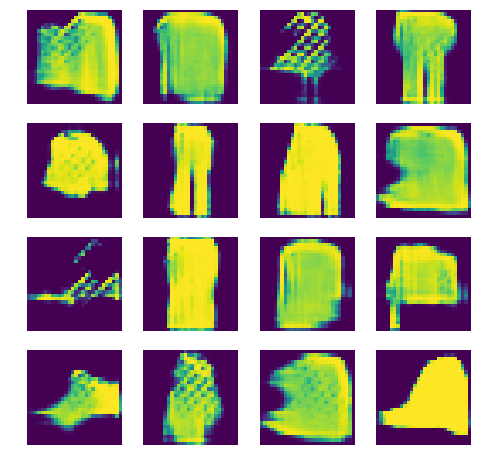

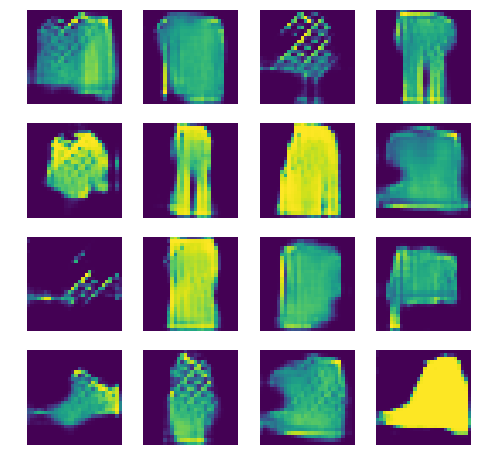

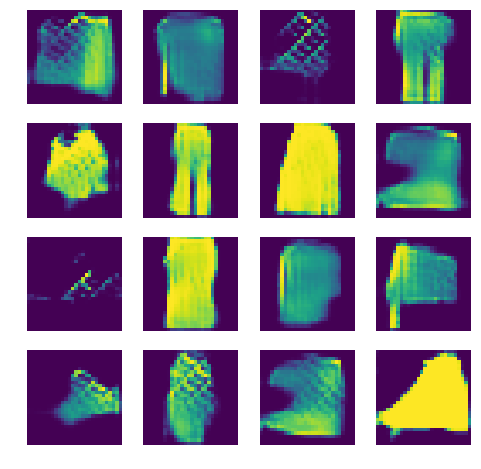

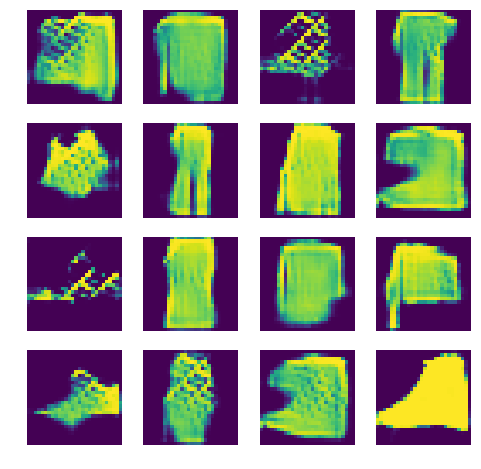

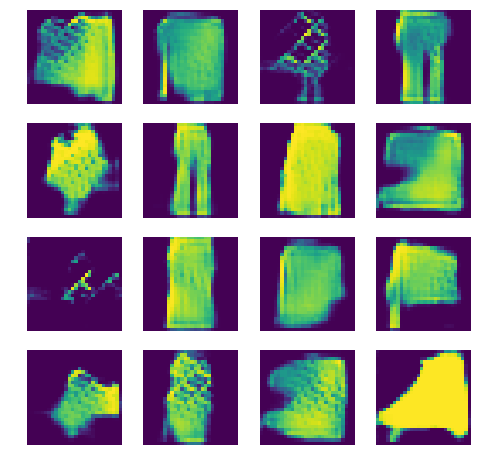

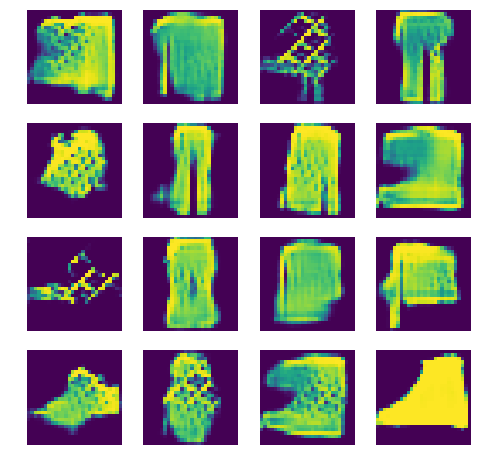

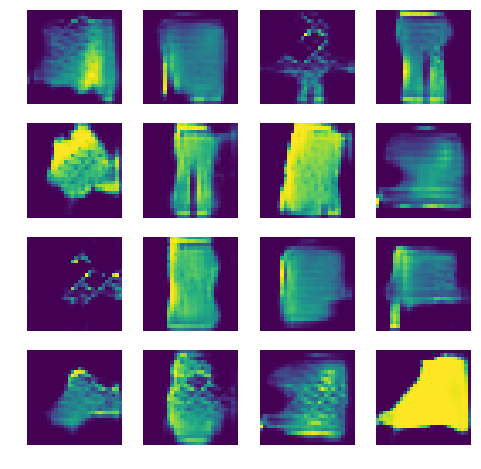

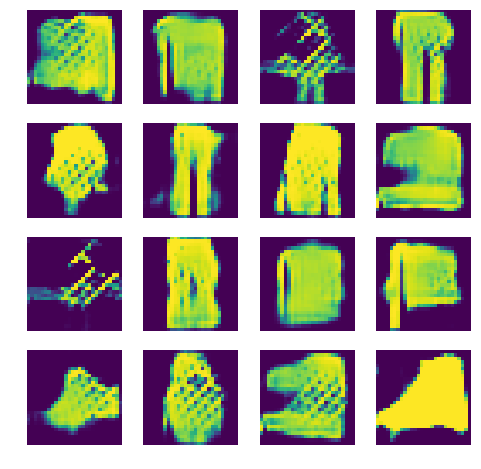

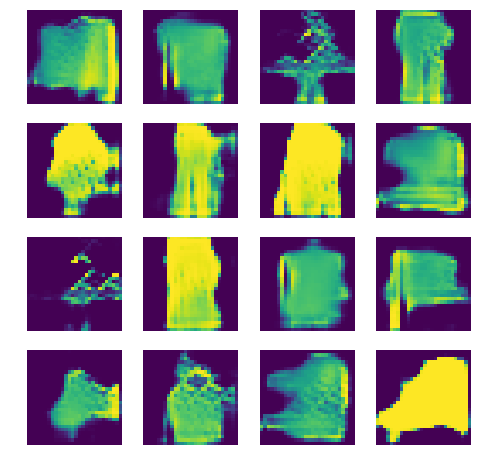

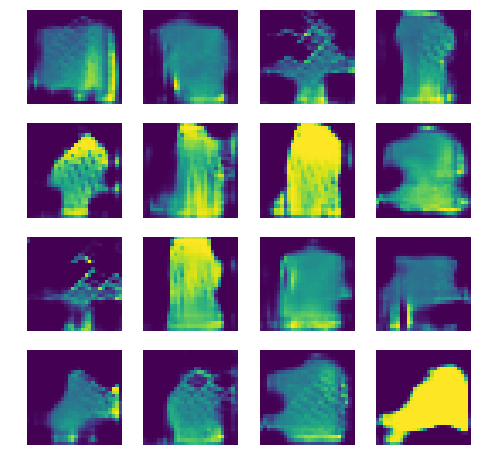

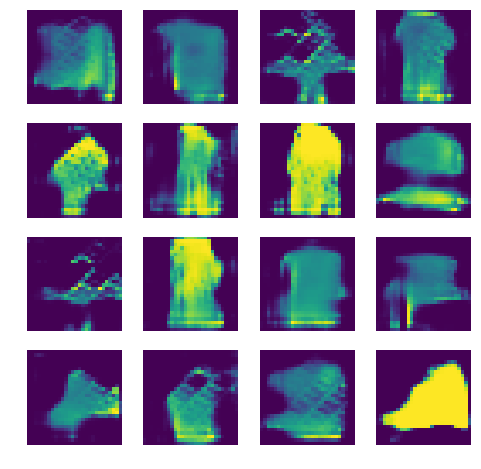

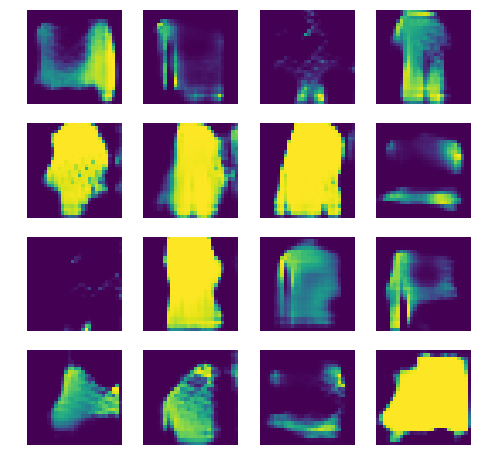

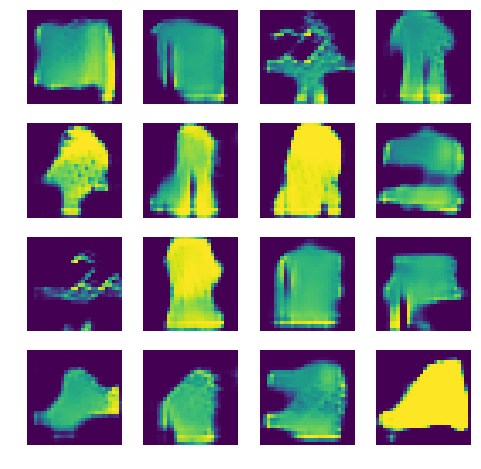

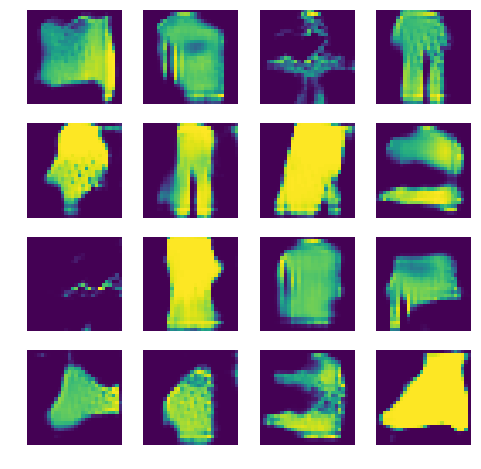

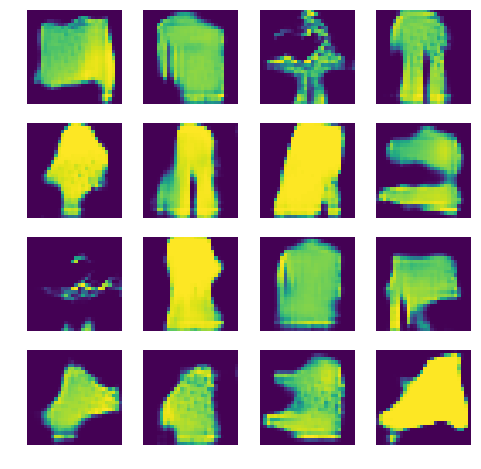

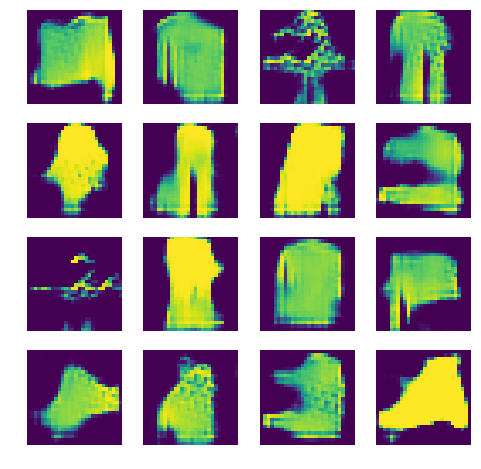

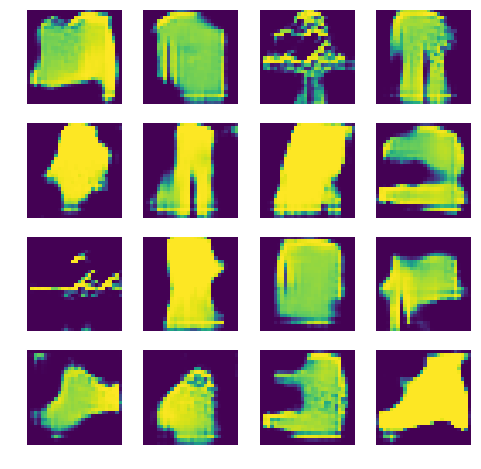

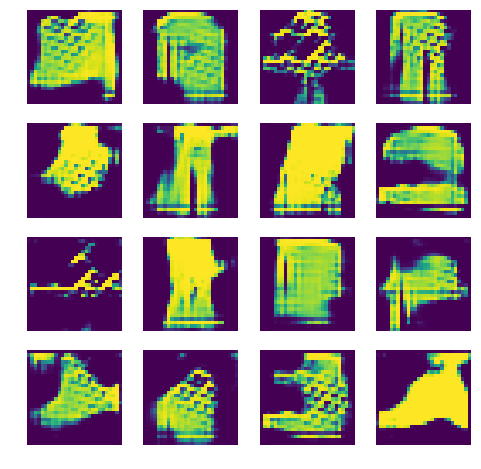

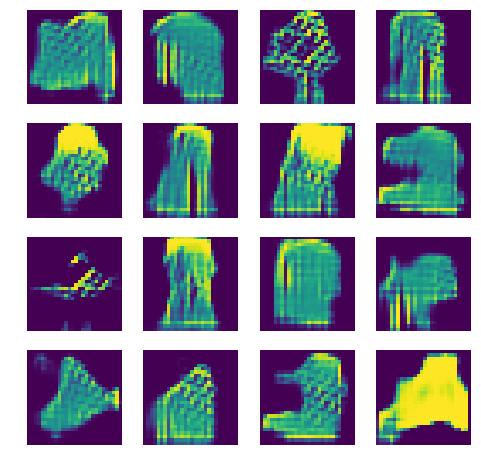

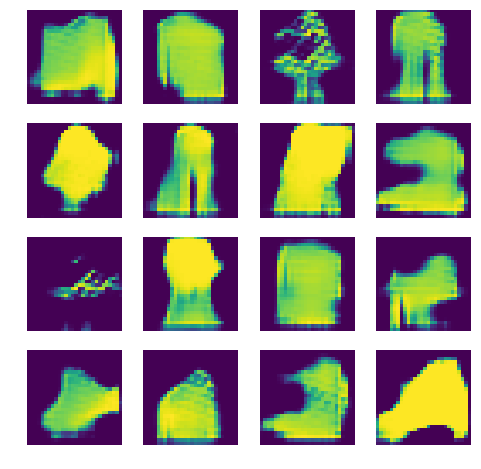

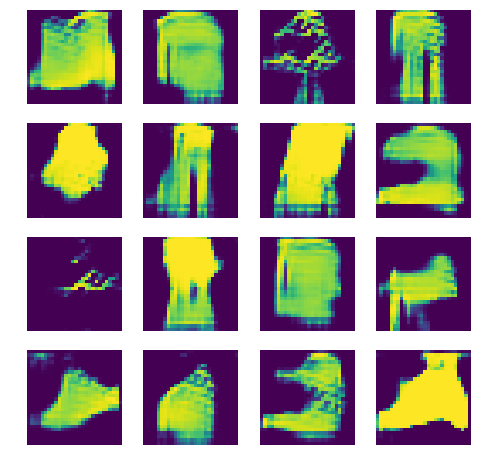

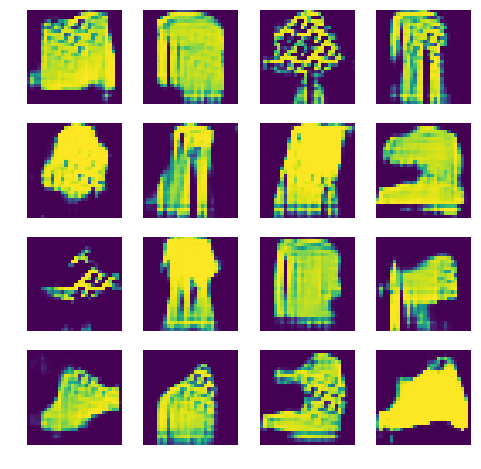

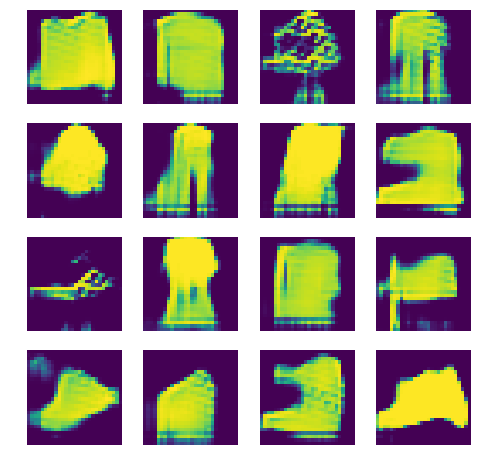

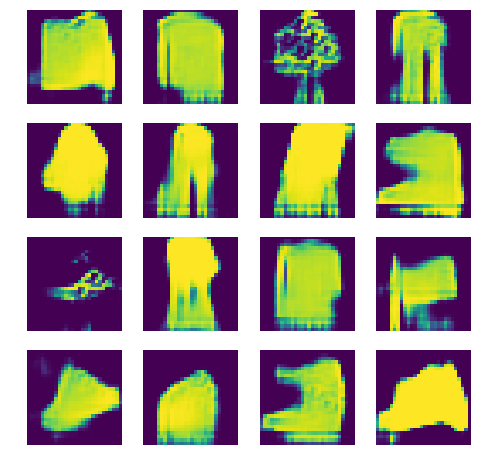

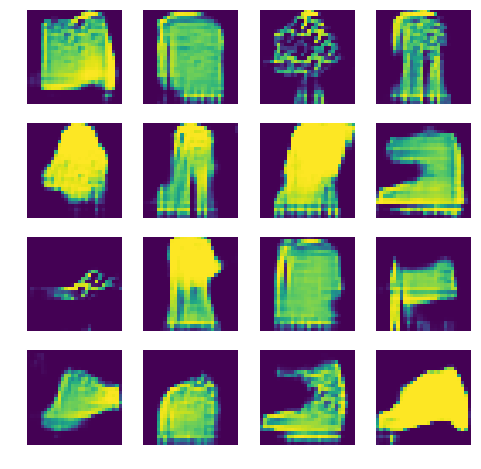

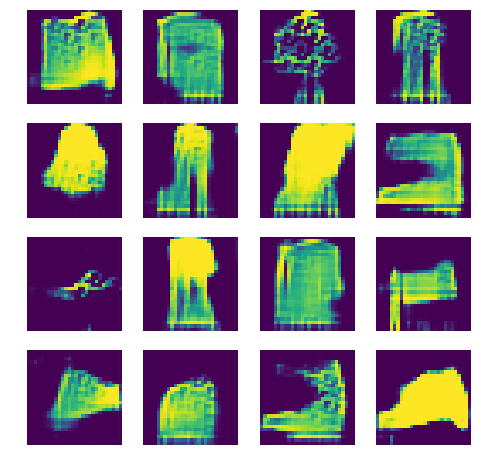

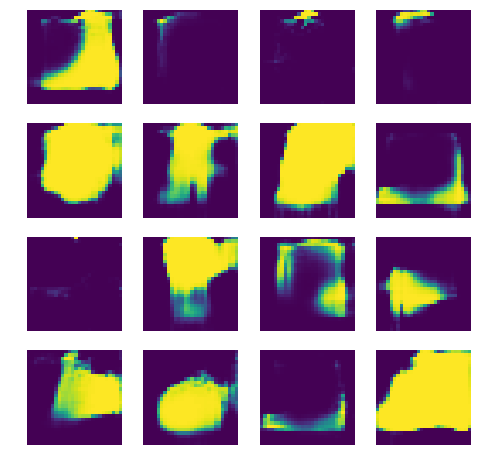

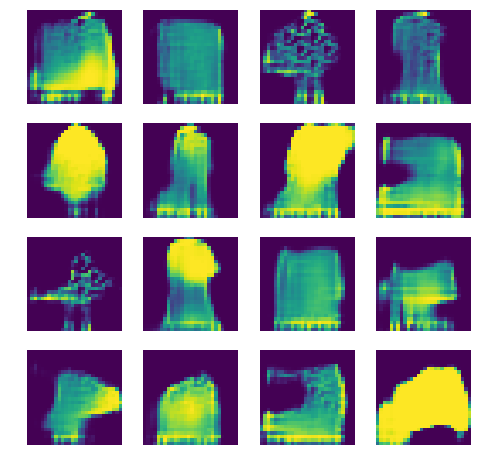

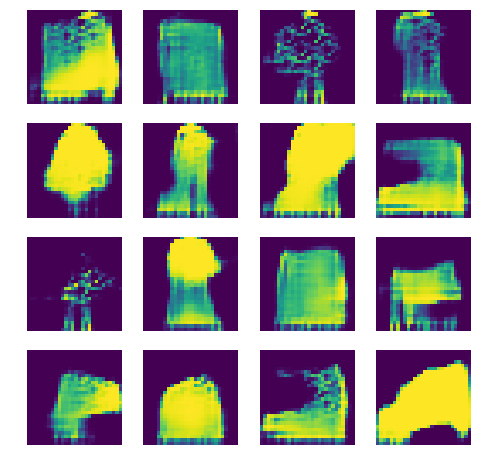

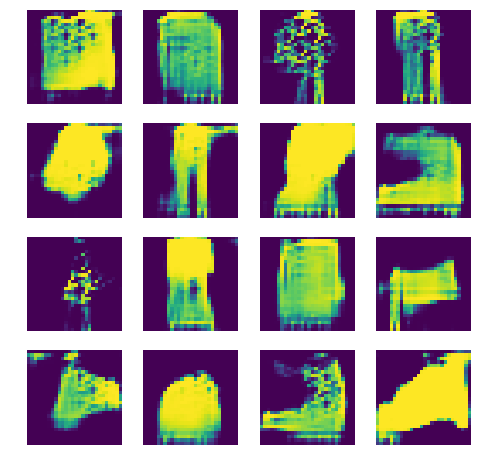

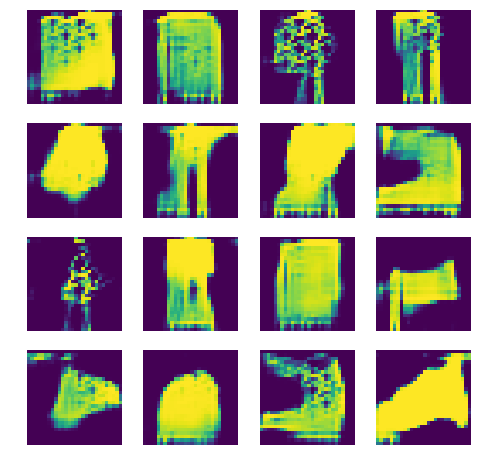

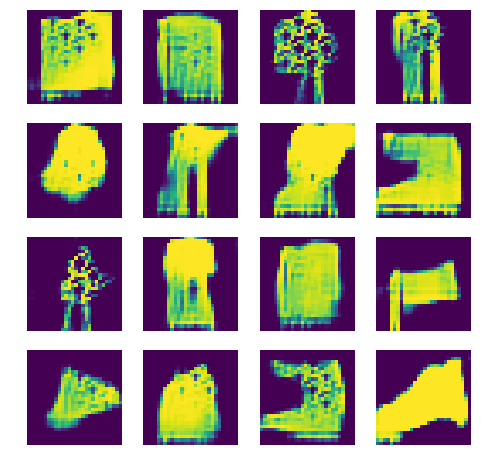

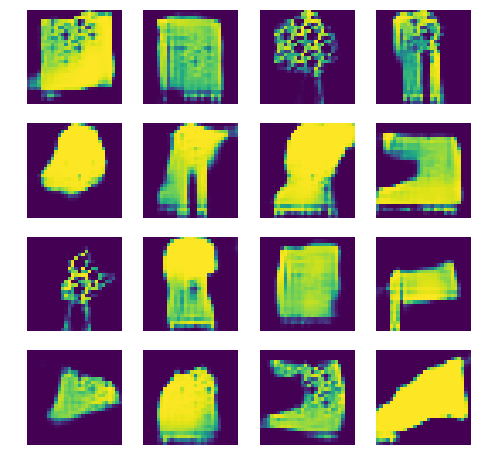

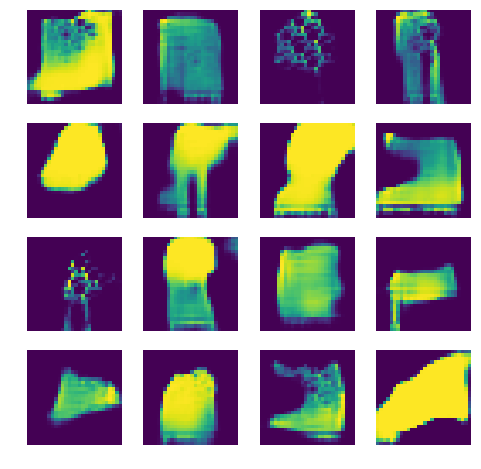

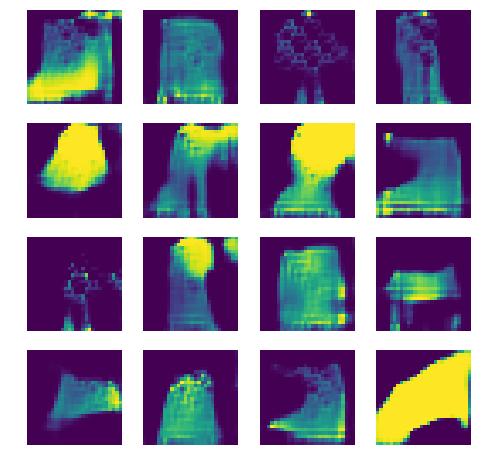

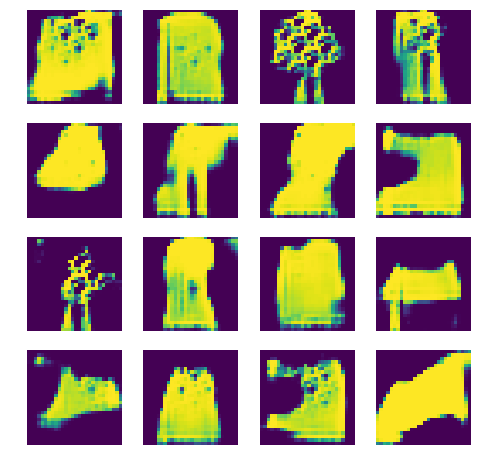

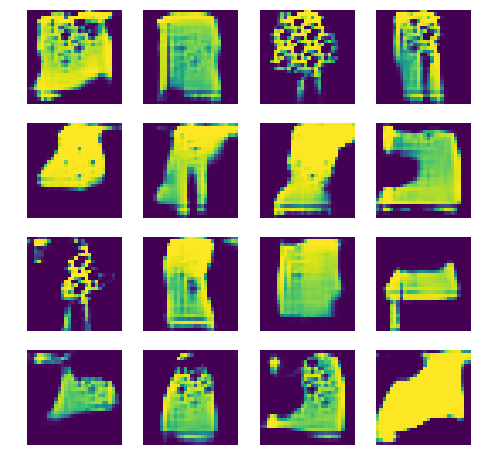

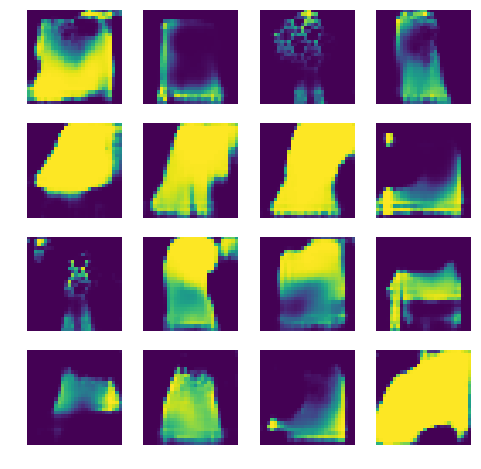

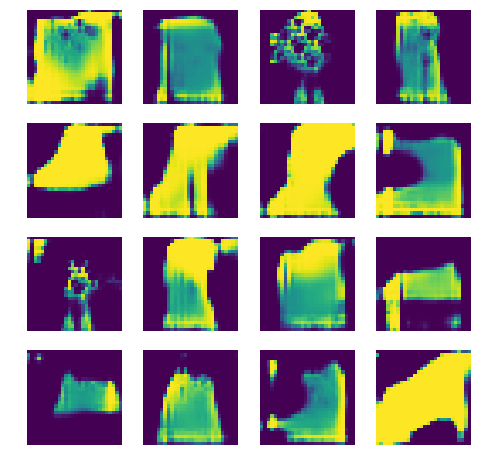

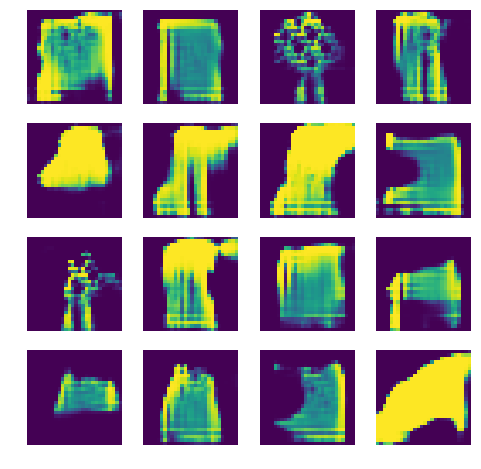

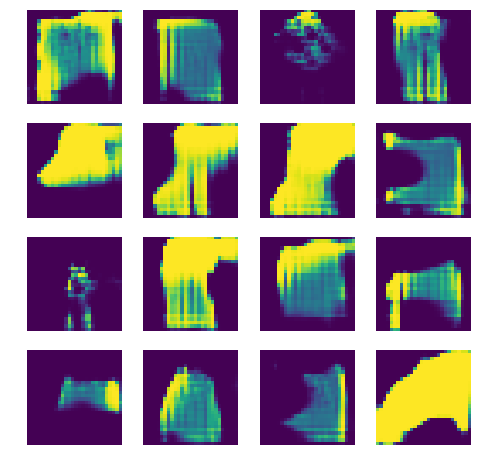

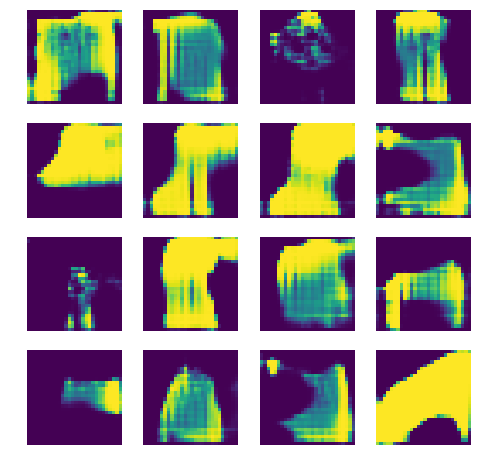

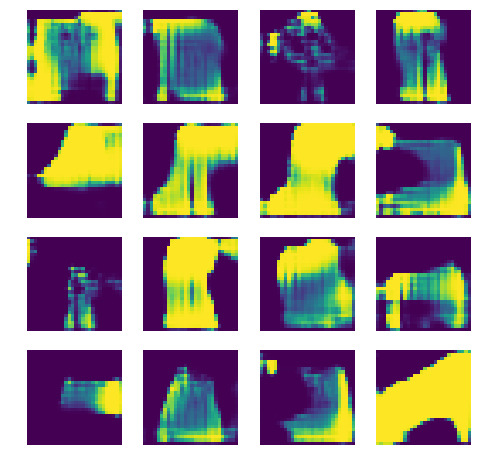

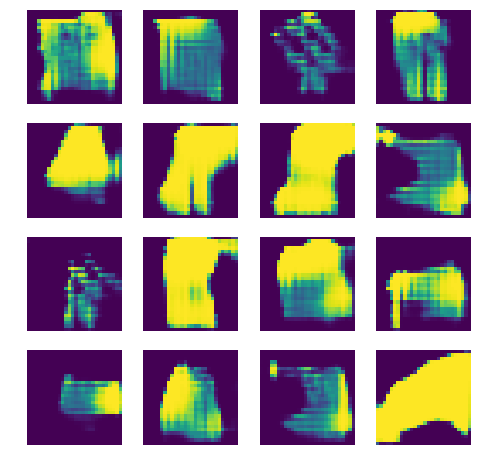

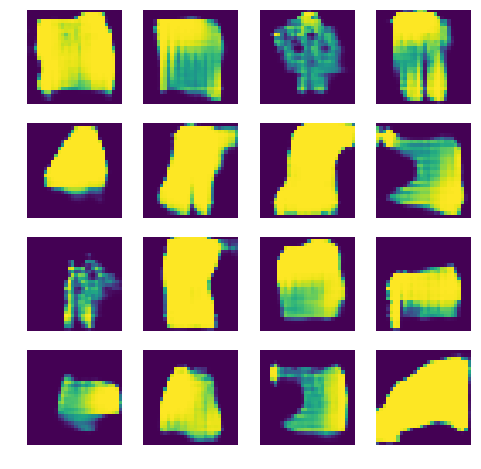

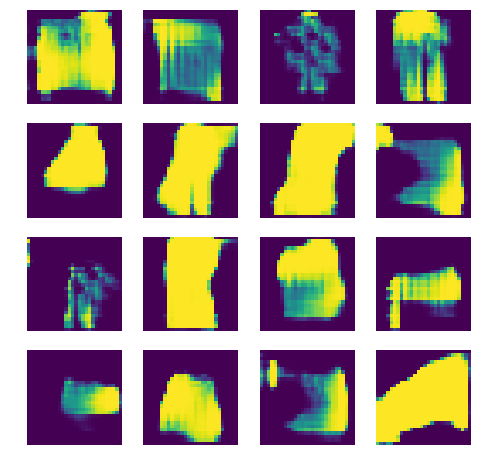

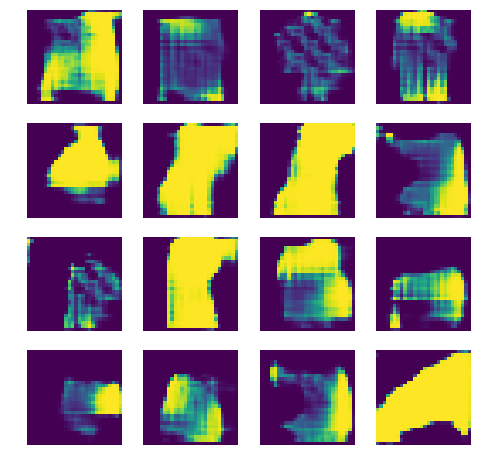

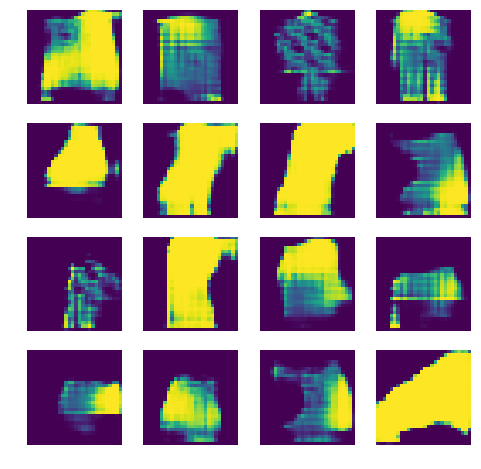

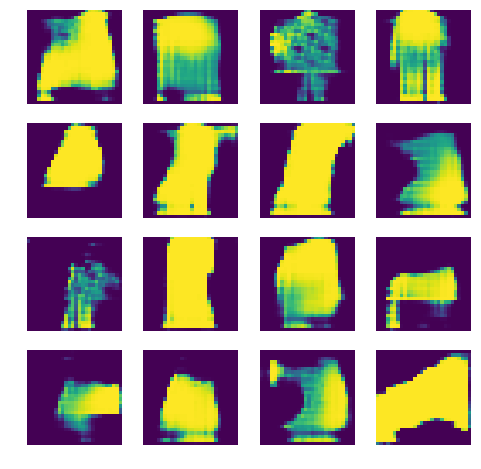

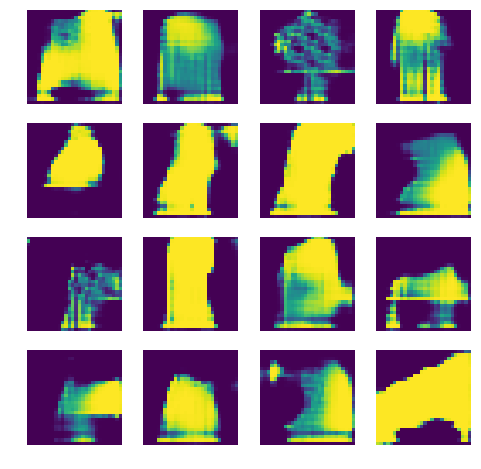

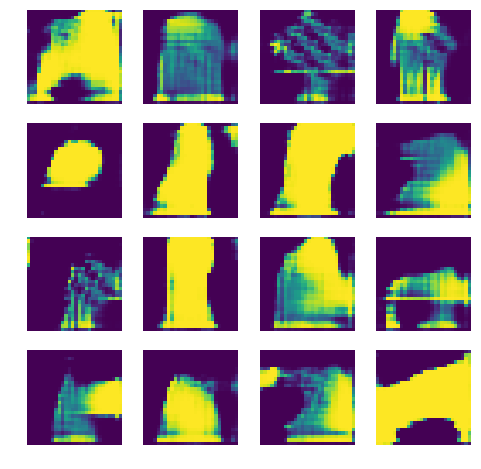

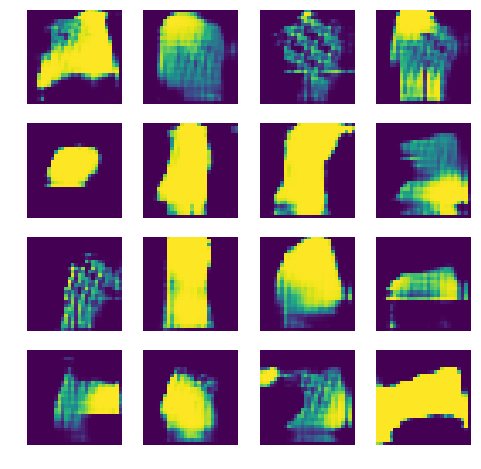

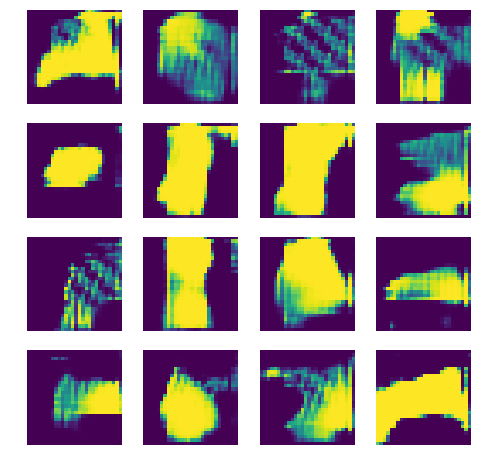

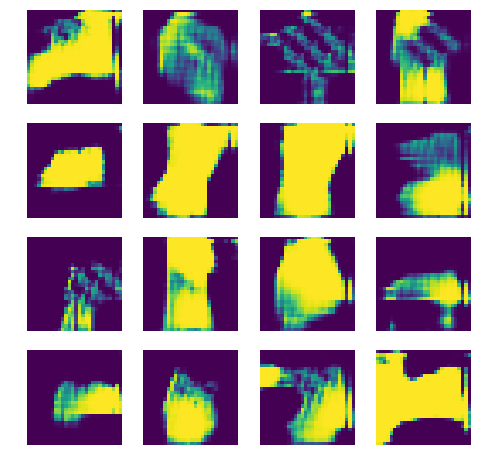

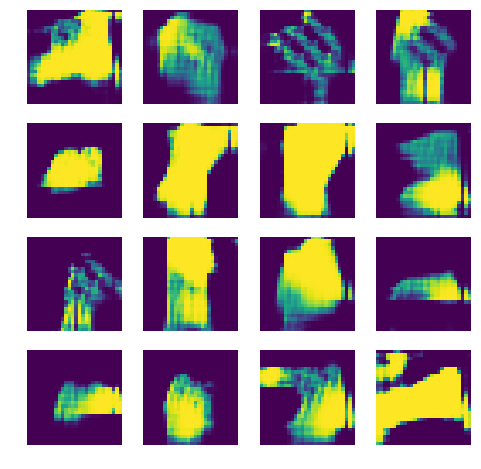

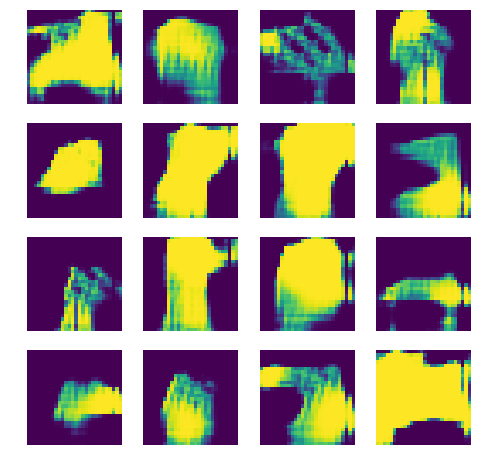

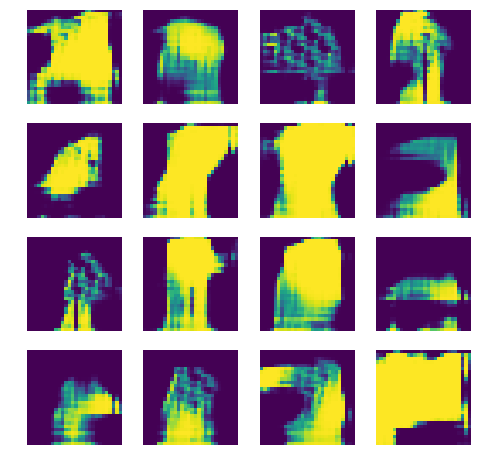

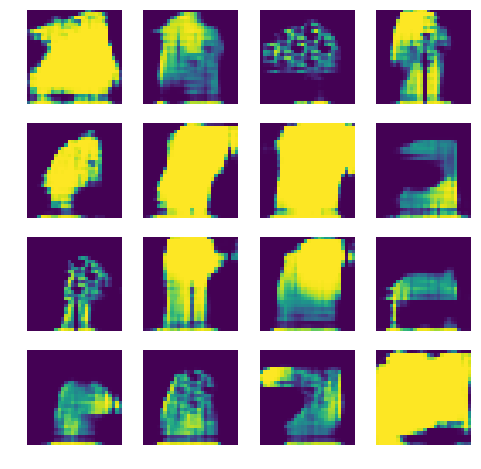

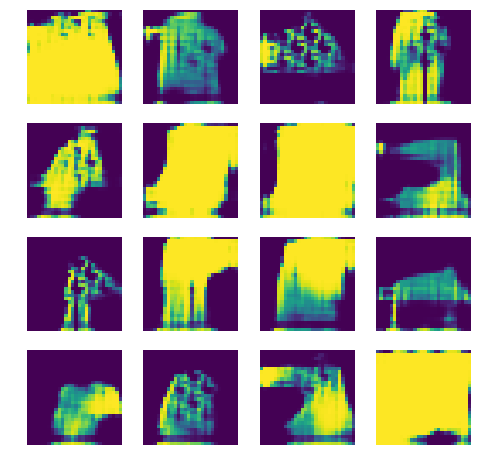

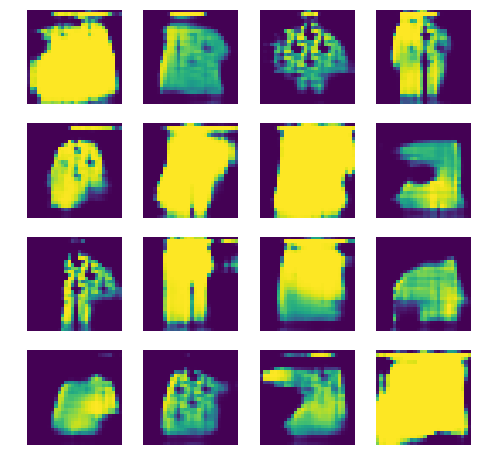

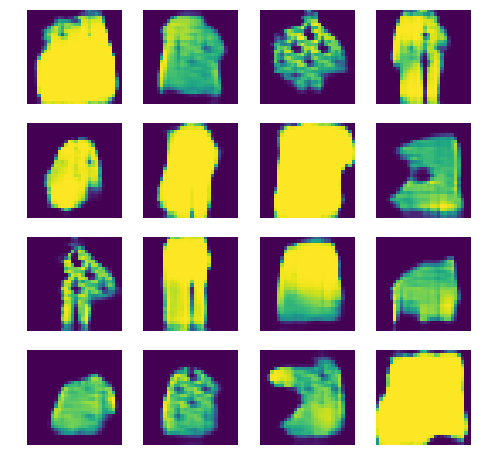

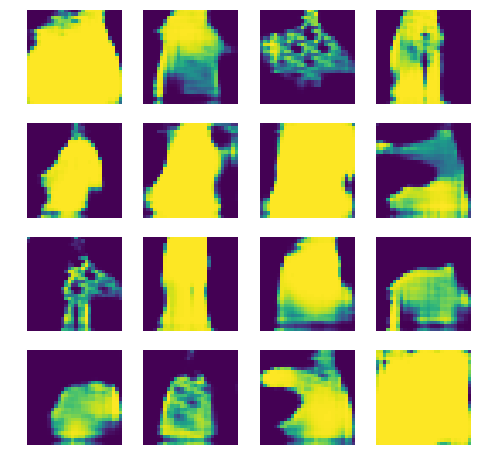

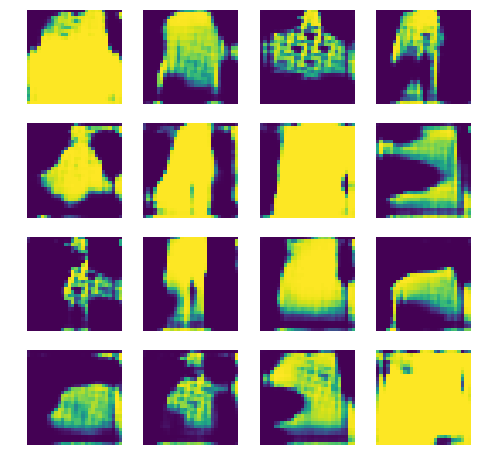

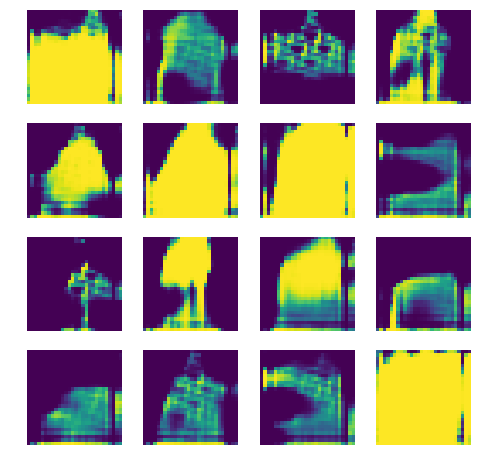

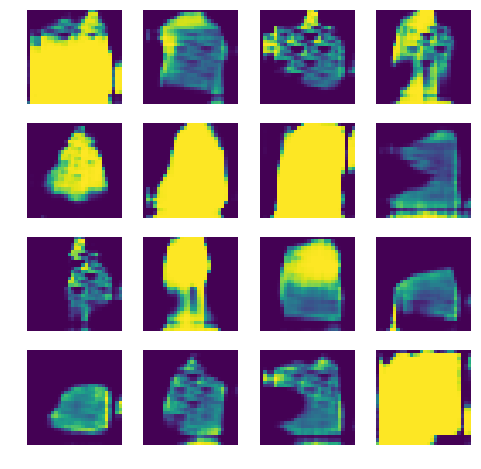

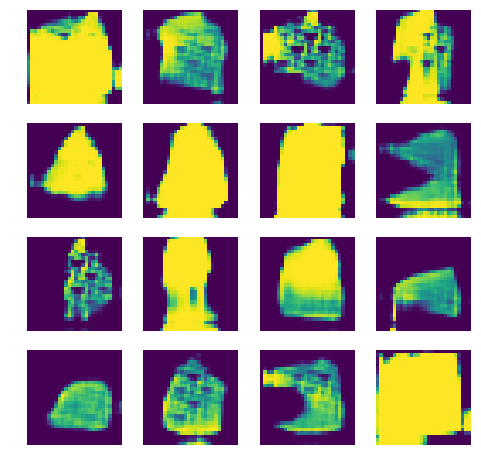

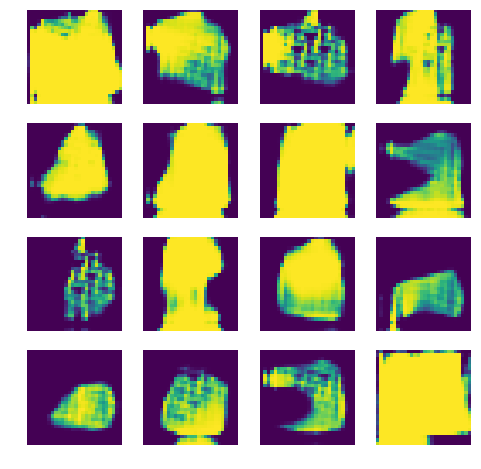

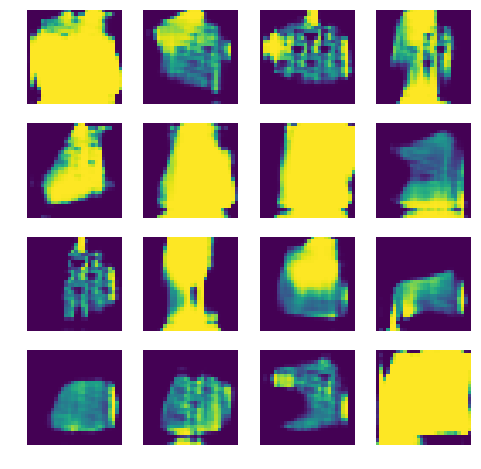

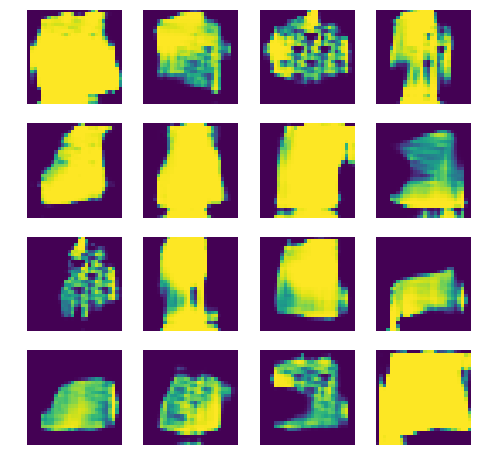

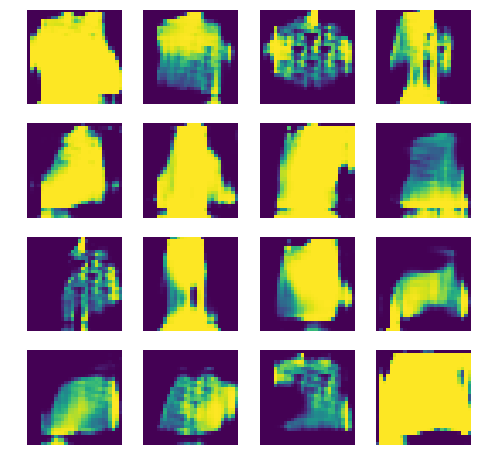

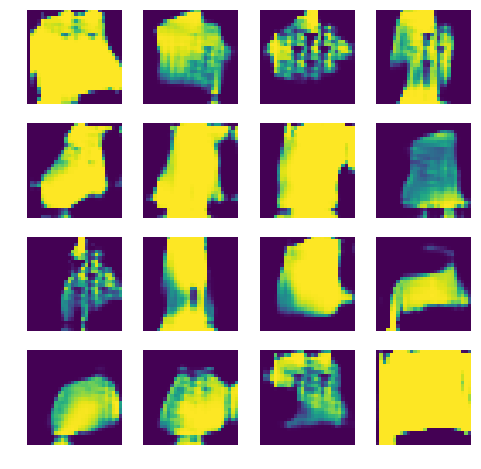

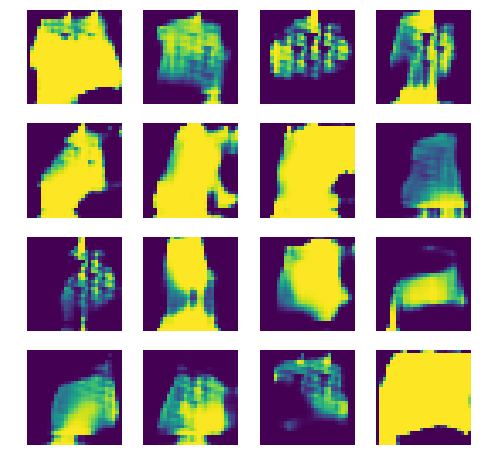

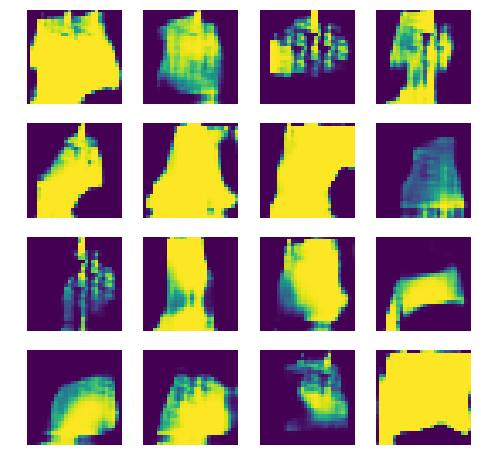

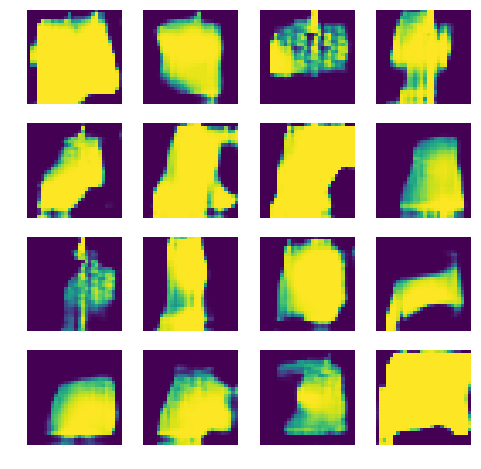

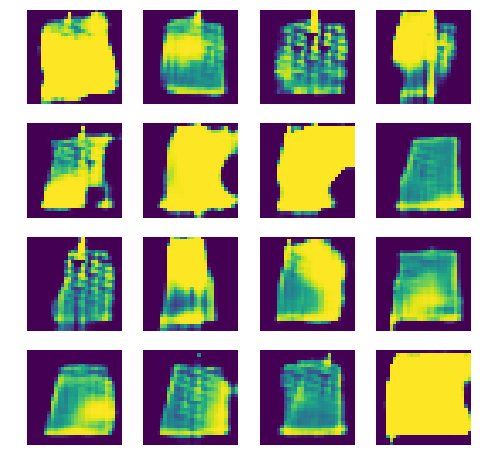

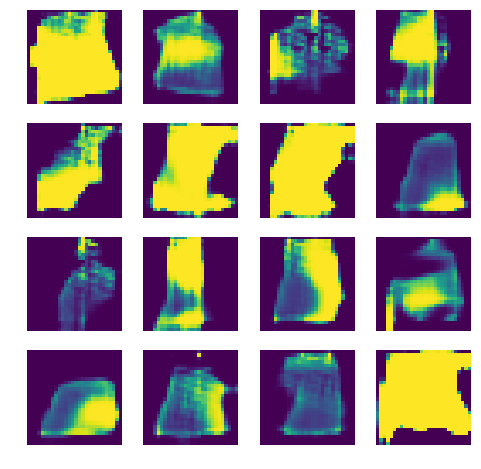

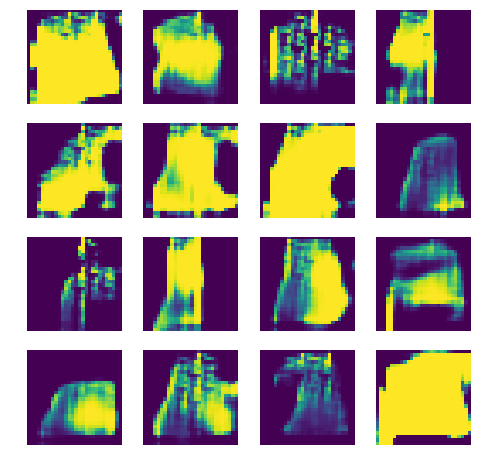

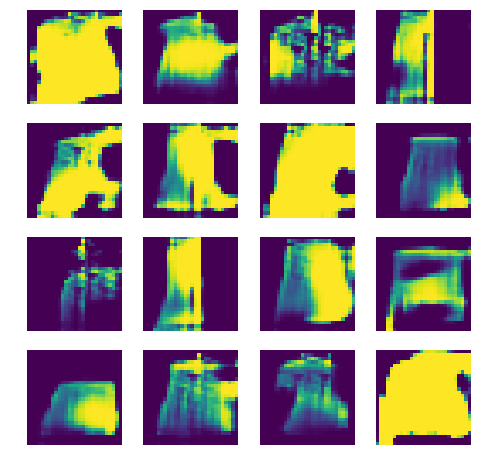

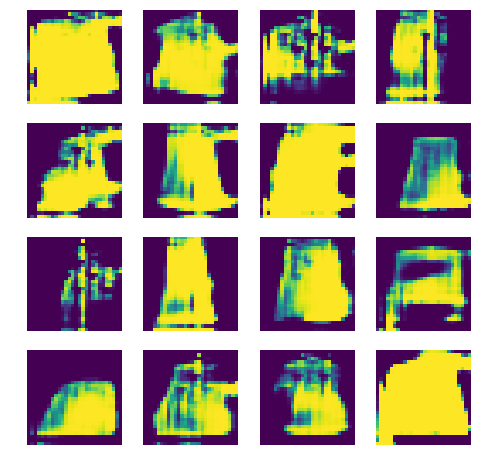

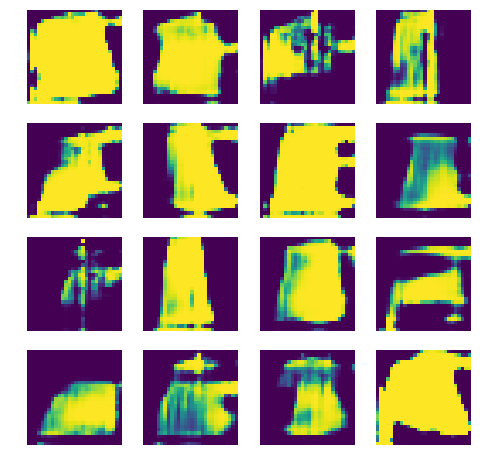

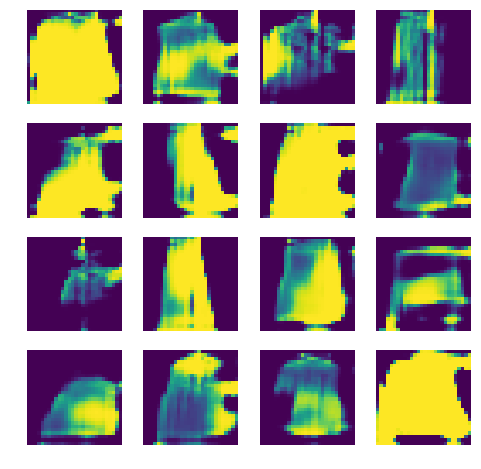

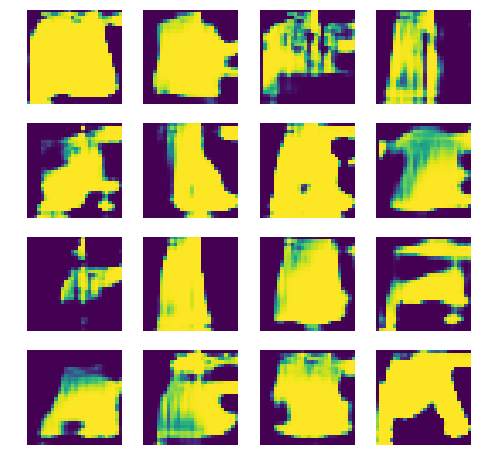

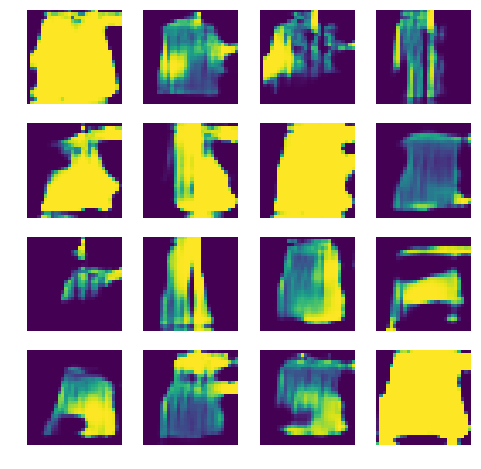

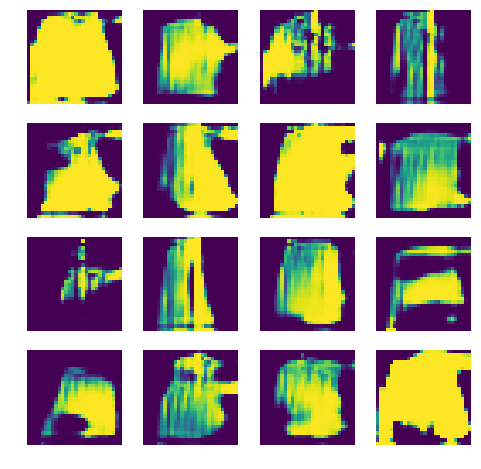

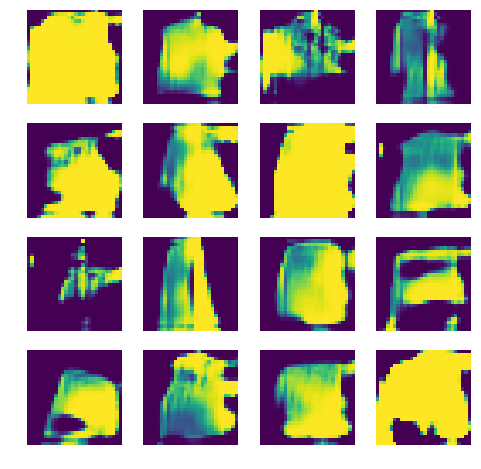

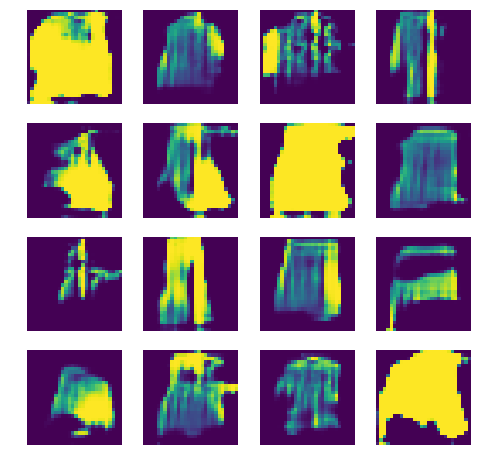

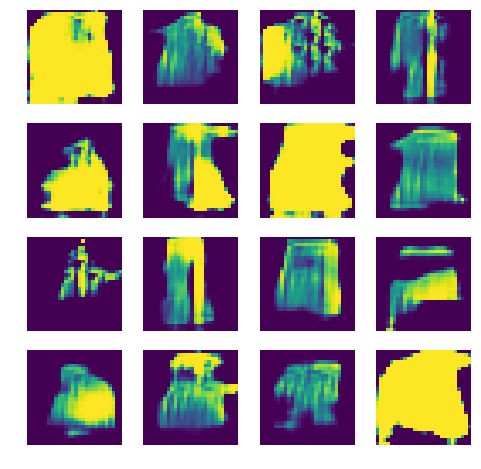

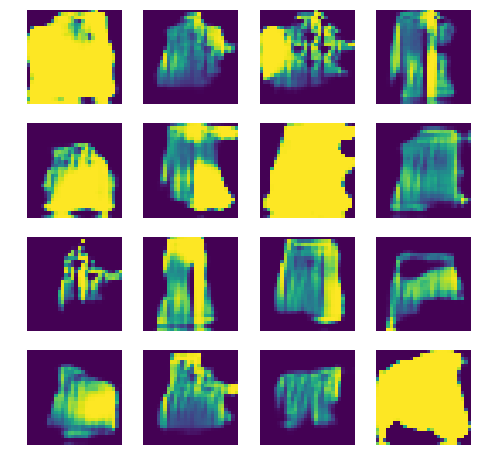

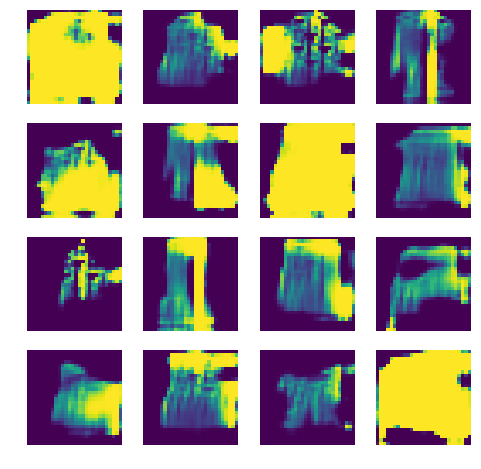

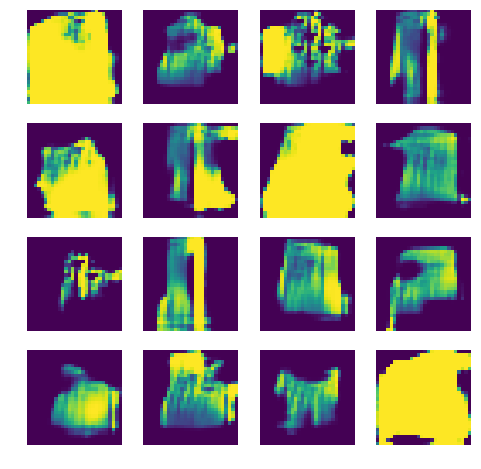

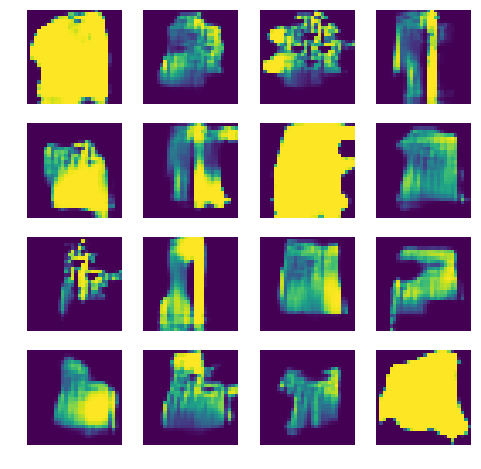

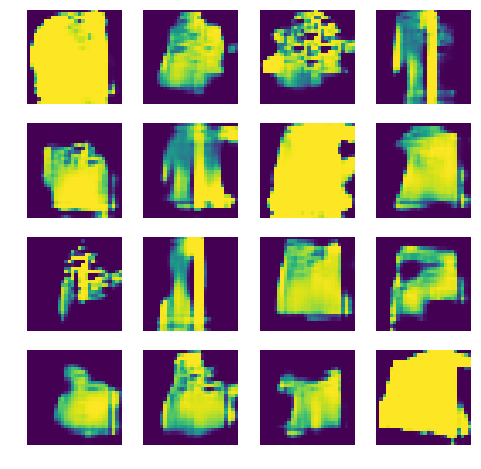

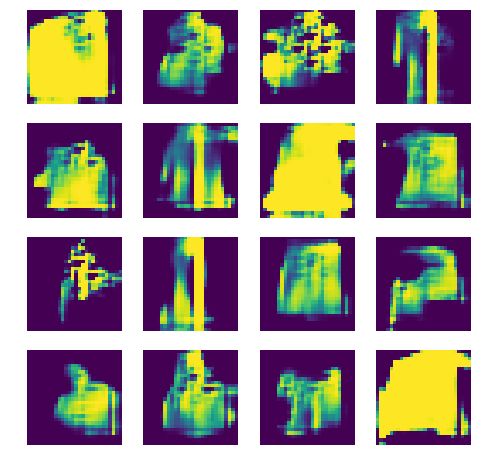

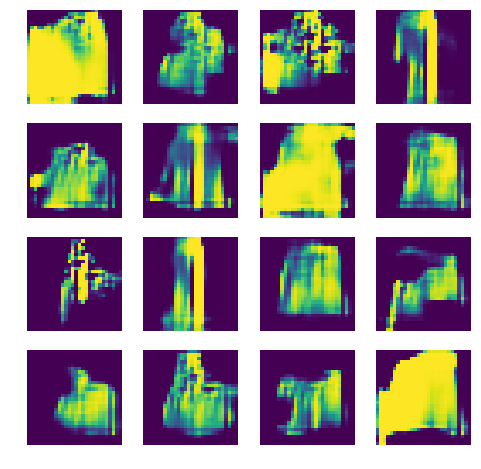

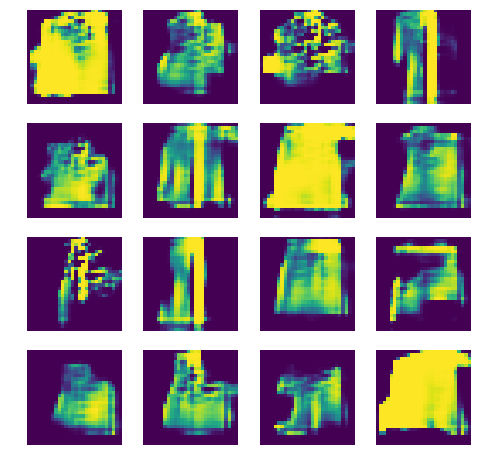

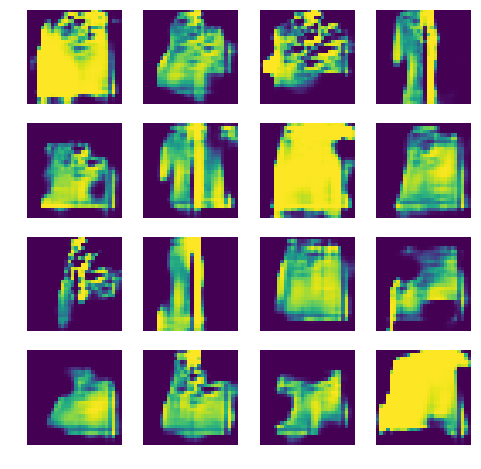

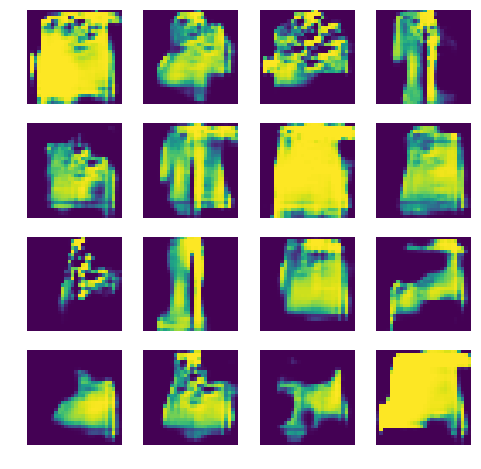

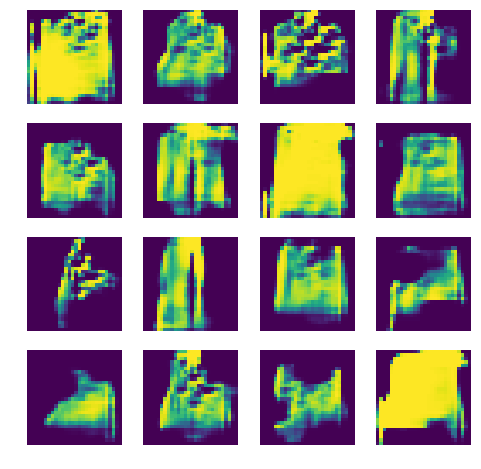

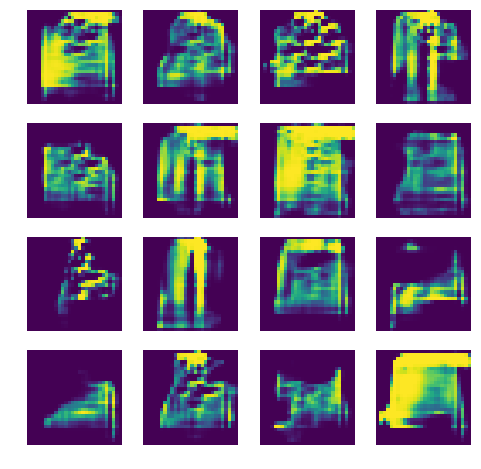

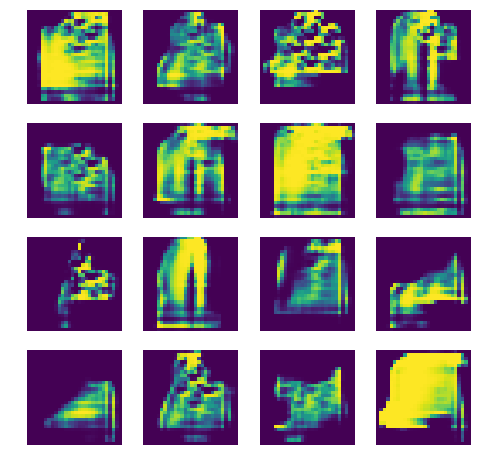

In [28]:
np.random.seed(seed)

epochs = 10000
batch_size = 256
plot_interval = 1000

retrain_discriminator = True

def plot_img(i_w, synthetic_images, i, j):
    pyplot.figure(figsize=(i_w, i_w))
    for im in range( synthetic_images.shape[0] ):
        pyplot.subplot(4, 4, im+1)
        synthetic_image = np.reshape(synthetic_images[im, :, :, :], [i, j])
        pyplot.imshow(synthetic_image)
        pyplot.axis("off")

for e in tqdm(range(epochs)):
    # stage 1: train the discriminator
    if retrain_discriminator:    
        # select batch_size entries from the train set
        x_train__ = x_train_[np.random.randint(0, x_train_.shape[0], size=batch_size), :, :, :]
        # generate fake instances from random noise
        d_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        images_fake = generator.predict(d_noise)
        d_x = np.concatenate((x_train__, images_fake))
        # create a 2*batch_size array initially set to 1
        d_y = np.ones([2*batch_size, 1])
        # set the second half (fake images) to 0
        d_y[batch_size:, :] = 0
        # train the discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(d_x, d_y)
        print "%d: [Discriminator loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
    
    # stage 2: train the generator-discriminator as adversarial
    input_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    gan_y = np.ones([batch_size, 1])
    discriminator.trainable = False
    ga_loss = gan.train_on_batch(input_noise, gan_y)
    print "%d: [GA loss: %f, acc: %f]" % (e, ga_loss[0], ga_loss[1])
    
    # plot after plot_interval epochs
    if (e+1)%plot_interval == 0:            
        # plot the output images from the test noise
        synthetic_images = generator.predict(test_noise)
        i_w = test_size / 2
        plot_img(i_w, synthetic_images, x_train_.shape[1], x_train_.shape[2])

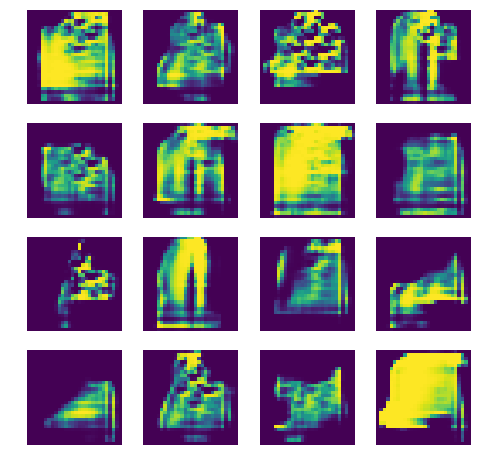

In [29]:
synthetic_images = generator.predict(test_noise)
i_w = test_size / 2
plot_img(i_w, synthetic_images, x_train_.shape[1], x_train_.shape[2])